In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, AlphaDropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Directorios de los datasets
train_dir = "../datos/train"
val_dir = "../datos/val"
test_dir = "../datos/test"

In [3]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    #Normalización y preprocesado
    rescale=1.0/255,
    #Transformaciones geométricas
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.2,  # Desplazamiento horizontal del 10%
    height_shift_range=0.2,  # Desplazamiento vertical del 10%
    shear_range=0.3,  # Transformación de cizallamiento del 10%
    zoom_range=0.3,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    channel_shift_range=50.0,  # Cambios fuertes en el color
    # Transformaciones de color e intensidad
    brightness_range=[0.05, 1.5],  # Ajuste de brillo entre 0.1 y 1.0
)
 # Evitamos el sobreajuste
datagen_val_test = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.


Found 2000 images belonging to 4 classes.


Found 800 images belonging to 4 classes.


In [4]:
# Cargar modelo preentrenado ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelamos las capas del modelo base

In [5]:
# Construcción del modelo
x = base_model.layers[-117].output #Equivalent to two (2) CORE block deduction.

# Capa convolucional
x = Conv2D(filters=192, kernel_size=6, strides=1, padding='valid',
           activation='selu', kernel_initializer='lecun_normal')(x)

# Capa de Average Pooling 
x = AveragePooling2D(pool_size=3, strides=3, padding='valid')(x)

# Global Average Pooling para reducir dimensiones antes de la capa densa
x = GlobalAveragePooling2D()(x)

# Capa fully connected
x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)  # 512 neuronas

# Dropout ajustado 
x = AlphaDropout(0.3)(x)  # Reducimos sobreajuste apagando el 20% de las neuronas

# Capa de salida con 4 clases y activación softmax
outputs = Dense(num_classes, activation='softmax')(x)

# Creación del modelo
model = Model(inputs=base_model.input, outputs=outputs)

In [6]:
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               


                                )]                                                                


 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                


 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              


                                )                                                                 


 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_conv[0][0]']             


                                )                                                                 


 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              


 conv2_block1_preact_bn (BatchN  (None, 56, 56, 64)  256         ['pool1_pool[0][0]']             


 ormalization)                                                                                    


 conv2_block1_preact_relu (Acti  (None, 56, 56, 64)  0           ['conv2_block1_preact_bn[0][0]'] 


 vation)                                                                                          


 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4096        ['conv2_block1_preact_relu[0][0]'


                                                                 ]                                


 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    


 ization)                                                                                         


 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      


 n)                                                                                               


 conv2_block1_2_pad (ZeroPaddin  (None, 58, 58, 64)  0           ['conv2_block1_1_relu[0][0]']    


 g2D)                                                                                             


 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36864       ['conv2_block1_2_pad[0][0]']     


 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    


 ization)                                                                                         


 conv2_block1_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_2_bn[0][0]']      


 n)                                                                                               


 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_preact_relu[0][0]'


                                                                 ]                                


 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    


 conv2_block1_out (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_conv[0][0]',    


                                                                  'conv2_block1_3_conv[0][0]']    


 conv2_block2_preact_bn (BatchN  (None, 56, 56, 256)  1024       ['conv2_block1_out[0][0]']       


 ormalization)                                                                                    


 conv2_block2_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block2_preact_bn[0][0]'] 


 vation)                                                                                          


 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block2_preact_relu[0][0]'


                                                                 ]                                


 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    


 ization)                                                                                         


 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      


 n)                                                                                               


 conv2_block2_2_pad (ZeroPaddin  (None, 58, 58, 64)  0           ['conv2_block2_1_relu[0][0]']    


 g2D)                                                                                             


 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36864       ['conv2_block2_2_pad[0][0]']     


 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    


 ization)                                                                                         


 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      


 n)                                                                                               


 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    


 conv2_block2_out (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       


                                                                  'conv2_block2_3_conv[0][0]']    


 conv2_block3_preact_bn (BatchN  (None, 56, 56, 256)  1024       ['conv2_block2_out[0][0]']       


 ormalization)                                                                                    


 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 


 vation)                                                                                          


 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'


                                                                 ]                                


 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    


 ization)                                                                                         


 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      


 n)                                                                                               


 conv2_block3_2_pad (ZeroPaddin  (None, 58, 58, 64)  0           ['conv2_block3_1_relu[0][0]']    


 g2D)                                                                                             


 conv2_block3_2_conv (Conv2D)   (None, 28, 28, 64)   36864       ['conv2_block3_2_pad[0][0]']     


 conv2_block3_2_bn (BatchNormal  (None, 28, 28, 64)  256         ['conv2_block3_2_conv[0][0]']    


 ization)                                                                                         


 conv2_block3_2_relu (Activatio  (None, 28, 28, 64)  0           ['conv2_block3_2_bn[0][0]']      


 n)                                                                                               


 max_pooling2d (MaxPooling2D)   (None, 28, 28, 256)  0           ['conv2_block2_out[0][0]']       


 conv2_block3_3_conv (Conv2D)   (None, 28, 28, 256)  16640       ['conv2_block3_2_relu[0][0]']    


 conv2_block3_out (Add)         (None, 28, 28, 256)  0           ['max_pooling2d[0][0]',          


                                                                  'conv2_block3_3_conv[0][0]']    


 conv3_block1_preact_bn (BatchN  (None, 28, 28, 256)  1024       ['conv2_block3_out[0][0]']       


 ormalization)                                                                                    


 conv3_block1_preact_relu (Acti  (None, 28, 28, 256)  0          ['conv3_block1_preact_bn[0][0]'] 


 vation)                                                                                          


 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32768       ['conv3_block1_preact_relu[0][0]'


                                                                 ]                                


 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    


 ization)                                                                                         


 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      


 n)                                                                                               


 conv3_block1_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block1_1_relu[0][0]']    


 g2D)                                                                                             


 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block1_2_pad[0][0]']     


 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    


 ization)                                                                                         


 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      


 n)                                                                                               


 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv3_block1_preact_relu[0][0]'


                                                                 ]                                


 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    


 conv3_block1_out (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_conv[0][0]',    


                                                                  'conv3_block1_3_conv[0][0]']    


 conv3_block2_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block1_out[0][0]']       


 ormalization)                                                                                    


 conv3_block2_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block2_preact_bn[0][0]'] 


 vation)                                                                                          


 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block2_preact_relu[0][0]'


                                                                 ]                                


 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    


 ization)                                                                                         


 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      


 n)                                                                                               


 conv3_block2_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block2_1_relu[0][0]']    


 g2D)                                                                                             


 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     


 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    


 ization)                                                                                         


 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      


 n)                                                                                               


 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    


 conv3_block2_out (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       


                                                                  'conv3_block2_3_conv[0][0]']    


 conv3_block3_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block2_out[0][0]']       


 ormalization)                                                                                    


 conv3_block3_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block3_preact_bn[0][0]'] 


 vation)                                                                                          


 conv3_block3_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block3_preact_relu[0][0]'


                                                                 ]                                


 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    


 ization)                                                                                         


 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      


 n)                                                                                               


 conv3_block3_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block3_1_relu[0][0]']    


 g2D)                                                                                             


 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block3_2_pad[0][0]']     


 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    


 ization)                                                                                         


 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      


 n)                                                                                               


 conv3_block3_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block3_2_relu[0][0]']    


 conv3_block3_out (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       


                                                                  'conv3_block3_3_conv[0][0]']    


 conv2d (Conv2D)                (None, 23, 23, 192)  3539136     ['conv3_block3_out[0][0]']       


 average_pooling2d (AveragePool  (None, 7, 7, 192)   0           ['conv2d[0][0]']                 


 ing2D)                                                                                           


 global_average_pooling2d (Glob  (None, 192)         0           ['average_pooling2d[0][0]']      


 alAveragePooling2D)                                                                              


 dense (Dense)                  (None, 512)          98816       ['global_average_pooling2d[0][0]'


                                                                 ]                                


 alpha_dropout (AlphaDropout)   (None, 512)          0           ['dense[0][0]']                  


 dense_1 (Dense)                (None, 4)            2052        ['alpha_dropout[0][0]']          


Total params: 4,811,460


Trainable params: 3,640,004


Non-trainable params: 1,171,456


__________________________________________________________________________________________________


In [ ]:
# Compilación del modelo
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #con funcion de perdida porque es multiclase

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50v2_best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) # Reduce LR si no hay mejora en 2 épocas

In [9]:
# Entrenamiento del modelo
epochs = 500 # Puede detenerse antes si no mejora la validacion
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500



  1/400 [..............................] - ETA: 18:03 - loss: 2.1143 - accuracy: 0.2500


  3/400 [..............................] - ETA: 21s - loss: 18.4167 - accuracy: 0.1667 


  4/400 [..............................] - ETA: 24s - loss: 16.6016 - accuracy: 0.1562


  5/400 [..............................] - ETA: 25s - loss: 18.7795 - accuracy: 0.1500


  6/400 [..............................] - ETA: 26s - loss: 17.9161 - accuracy: 0.1667


  7/400 [..............................] - ETA: 27s - loss: 17.1451 - accuracy: 0.1964


  8/400 [..............................] - ETA: 28s - loss: 18.0050 - accuracy: 0.1875


  9/400 [..............................] - ETA: 27s - loss: 16.8163 - accuracy: 0.2222


 10/400 [..............................] - ETA: 28s - loss: 15.8888 - accuracy: 0.2625


 11/400 [..............................] - ETA: 28s - loss: 15.4420 - accuracy: 0.2614


 12/400 [..............................] - ETA: 28s - loss: 14.6774 - accuracy: 0.2708


 13/400 [..............................] - ETA: 28s - loss: 14.4130 - accuracy: 0.2500


 14/400 [>.............................] - ETA: 28s - loss: 14.2126 - accuracy: 0.2500


 15/400 [>.............................] - ETA: 28s - loss: 14.3223 - accuracy: 0.2417


 16/400 [>.............................] - ETA: 28s - loss: 14.5349 - accuracy: 0.2422


 17/400 [>.............................] - ETA: 29s - loss: 14.6556 - accuracy: 0.2353


 18/400 [>.............................] - ETA: 28s - loss: 14.1692 - accuracy: 0.2431


 19/400 [>.............................] - ETA: 28s - loss: 13.5662 - accuracy: 0.2632


 20/400 [>.............................] - ETA: 29s - loss: 13.7600 - accuracy: 0.2625


 21/400 [>.............................] - ETA: 29s - loss: 13.5445 - accuracy: 0.2619


 22/400 [>.............................] - ETA: 29s - loss: 13.3115 - accuracy: 0.2557


 23/400 [>.............................] - ETA: 29s - loss: 12.9501 - accuracy: 0.2717


 24/400 [>.............................] - ETA: 29s - loss: 12.7554 - accuracy: 0.2760


 25/400 [>.............................] - ETA: 29s - loss: 12.5696 - accuracy: 0.2850


 26/400 [>.............................] - ETA: 29s - loss: 12.2522 - accuracy: 0.2933


 27/400 [=>............................] - ETA: 29s - loss: 12.1520 - accuracy: 0.2917


 28/400 [=>............................] - ETA: 29s - loss: 11.8707 - accuracy: 0.2902


 29/400 [=>............................] - ETA: 29s - loss: 11.6429 - accuracy: 0.2888


 30/400 [=>............................] - ETA: 29s - loss: 11.3711 - accuracy: 0.2917


 31/400 [=>............................] - ETA: 29s - loss: 11.1089 - accuracy: 0.2944


 32/400 [=>............................] - ETA: 29s - loss: 10.8422 - accuracy: 0.3008


 33/400 [=>............................] - ETA: 29s - loss: 10.7343 - accuracy: 0.3030


 34/400 [=>............................] - ETA: 29s - loss: 10.5248 - accuracy: 0.3051


 35/400 [=>............................] - ETA: 29s - loss: 10.3295 - accuracy: 0.3071


 36/400 [=>............................] - ETA: 29s - loss: 10.1884 - accuracy: 0.3056


 37/400 [=>............................] - ETA: 29s - loss: 10.0287 - accuracy: 0.3108


 38/400 [=>............................] - ETA: 28s - loss: 9.9603 - accuracy: 0.3092 


 39/400 [=>............................] - ETA: 28s - loss: 9.8511 - accuracy: 0.3109


 40/400 [==>...........................] - ETA: 28s - loss: 9.6589 - accuracy: 0.3156


 41/400 [==>...........................] - ETA: 28s - loss: 9.5667 - accuracy: 0.3171


 42/400 [==>...........................] - ETA: 28s - loss: 9.3945 - accuracy: 0.3214


 43/400 [==>...........................] - ETA: 28s - loss: 9.2492 - accuracy: 0.3169


 44/400 [==>...........................] - ETA: 28s - loss: 9.0841 - accuracy: 0.3182


 45/400 [==>...........................] - ETA: 28s - loss: 8.9246 - accuracy: 0.3111


 46/400 [==>...........................] - ETA: 28s - loss: 8.7782 - accuracy: 0.3152


 47/400 [==>...........................] - ETA: 28s - loss: 8.6240 - accuracy: 0.3191


 48/400 [==>...........................] - ETA: 28s - loss: 8.4840 - accuracy: 0.3255


 49/400 [==>...........................] - ETA: 28s - loss: 8.3530 - accuracy: 0.3291


 50/400 [==>...........................] - ETA: 28s - loss: 8.2054 - accuracy: 0.3300


 51/400 [==>...........................] - ETA: 28s - loss: 8.1496 - accuracy: 0.3235


 52/400 [==>...........................] - ETA: 28s - loss: 8.0349 - accuracy: 0.3269


 53/400 [==>...........................] - ETA: 28s - loss: 7.9252 - accuracy: 0.3302


 54/400 [===>..........................] - ETA: 28s - loss: 7.8414 - accuracy: 0.3264


 55/400 [===>..........................] - ETA: 28s - loss: 7.7273 - accuracy: 0.3295


 56/400 [===>..........................] - ETA: 28s - loss: 7.6395 - accuracy: 0.3259


 57/400 [===>..........................] - ETA: 28s - loss: 7.5289 - accuracy: 0.3268


 58/400 [===>..........................] - ETA: 28s - loss: 7.4693 - accuracy: 0.3276


 59/400 [===>..........................] - ETA: 28s - loss: 7.4031 - accuracy: 0.3284


 60/400 [===>..........................] - ETA: 28s - loss: 7.3919 - accuracy: 0.3250


 61/400 [===>..........................] - ETA: 28s - loss: 7.3055 - accuracy: 0.3258


 62/400 [===>..........................] - ETA: 27s - loss: 7.2477 - accuracy: 0.3226


 63/400 [===>..........................] - ETA: 27s - loss: 7.1490 - accuracy: 0.3254


 64/400 [===>..........................] - ETA: 27s - loss: 7.0653 - accuracy: 0.3281


 65/400 [===>..........................] - ETA: 27s - loss: 6.9881 - accuracy: 0.3269


 66/400 [===>..........................] - ETA: 27s - loss: 6.9130 - accuracy: 0.3314


 67/400 [====>.........................] - ETA: 27s - loss: 6.8557 - accuracy: 0.3265


 68/400 [====>.........................] - ETA: 27s - loss: 6.8071 - accuracy: 0.3272


 69/400 [====>.........................] - ETA: 27s - loss: 6.7468 - accuracy: 0.3225


 70/400 [====>.........................] - ETA: 27s - loss: 6.6674 - accuracy: 0.3286


 71/400 [====>.........................] - ETA: 27s - loss: 6.5934 - accuracy: 0.3257


 72/400 [====>.........................] - ETA: 27s - loss: 6.5341 - accuracy: 0.3247


 73/400 [====>.........................] - ETA: 26s - loss: 6.4737 - accuracy: 0.3236


 74/400 [====>.........................] - ETA: 26s - loss: 6.4096 - accuracy: 0.3226


 75/400 [====>.........................] - ETA: 26s - loss: 6.3466 - accuracy: 0.3217


 76/400 [====>.........................] - ETA: 26s - loss: 6.2834 - accuracy: 0.3224


 77/400 [====>.........................] - ETA: 26s - loss: 6.2319 - accuracy: 0.3214


 78/400 [====>.........................] - ETA: 26s - loss: 6.1680 - accuracy: 0.3269


 79/400 [====>.........................] - ETA: 26s - loss: 6.1211 - accuracy: 0.3275


 80/400 [=====>........................] - ETA: 26s - loss: 6.0682 - accuracy: 0.3281


 81/400 [=====>........................] - ETA: 26s - loss: 6.0057 - accuracy: 0.3302


 82/400 [=====>........................] - ETA: 26s - loss: 5.9631 - accuracy: 0.3293


 83/400 [=====>........................] - ETA: 26s - loss: 5.9069 - accuracy: 0.3298


 84/400 [=====>........................] - ETA: 26s - loss: 5.8563 - accuracy: 0.3274


 85/400 [=====>........................] - ETA: 26s - loss: 5.8100 - accuracy: 0.3250


 86/400 [=====>........................] - ETA: 25s - loss: 5.7592 - accuracy: 0.3270


 87/400 [=====>........................] - ETA: 25s - loss: 5.7102 - accuracy: 0.3276


 88/400 [=====>........................] - ETA: 25s - loss: 5.6640 - accuracy: 0.3281


 89/400 [=====>........................] - ETA: 25s - loss: 5.6117 - accuracy: 0.3301


 90/400 [=====>........................] - ETA: 25s - loss: 5.5637 - accuracy: 0.3319


 91/400 [=====>........................] - ETA: 25s - loss: 5.5207 - accuracy: 0.3352


 92/400 [=====>........................] - ETA: 25s - loss: 5.4753 - accuracy: 0.3356


 93/400 [=====>........................] - ETA: 25s - loss: 5.4309 - accuracy: 0.3374


 94/400 [======>.......................] - ETA: 25s - loss: 5.3861 - accuracy: 0.3391


 95/400 [======>.......................] - ETA: 25s - loss: 5.3467 - accuracy: 0.3408


 96/400 [======>.......................] - ETA: 25s - loss: 5.3116 - accuracy: 0.3411


 97/400 [======>.......................] - ETA: 25s - loss: 5.2760 - accuracy: 0.3415


 98/400 [======>.......................] - ETA: 25s - loss: 5.2529 - accuracy: 0.3393


 99/400 [======>.......................] - ETA: 24s - loss: 5.2209 - accuracy: 0.3384


100/400 [======>.......................] - ETA: 24s - loss: 5.1809 - accuracy: 0.3388


101/400 [======>.......................] - ETA: 24s - loss: 5.1372 - accuracy: 0.3416


102/400 [======>.......................] - ETA: 24s - loss: 5.1028 - accuracy: 0.3395


103/400 [======>.......................] - ETA: 24s - loss: 5.0703 - accuracy: 0.3398


104/400 [======>.......................] - ETA: 24s - loss: 5.0410 - accuracy: 0.3377


105/400 [======>.......................] - ETA: 24s - loss: 5.0069 - accuracy: 0.3369


106/400 [======>.......................] - ETA: 24s - loss: 4.9725 - accuracy: 0.3396


107/400 [=======>......................] - ETA: 24s - loss: 4.9452 - accuracy: 0.3411


108/400 [=======>......................] - ETA: 24s - loss: 4.9067 - accuracy: 0.3438


109/400 [=======>......................] - ETA: 23s - loss: 4.8677 - accuracy: 0.3475


110/400 [=======>......................] - ETA: 23s - loss: 4.8418 - accuracy: 0.3489


111/400 [=======>......................] - ETA: 23s - loss: 4.8105 - accuracy: 0.3514


112/400 [=======>......................] - ETA: 23s - loss: 4.7919 - accuracy: 0.3516


113/400 [=======>......................] - ETA: 23s - loss: 4.7599 - accuracy: 0.3529


114/400 [=======>......................] - ETA: 23s - loss: 4.7321 - accuracy: 0.3520


115/400 [=======>......................] - ETA: 23s - loss: 4.7048 - accuracy: 0.3522


116/400 [=======>......................] - ETA: 23s - loss: 4.6701 - accuracy: 0.3545


117/400 [=======>......................] - ETA: 23s - loss: 4.6540 - accuracy: 0.3536


118/400 [=======>......................] - ETA: 23s - loss: 4.6256 - accuracy: 0.3528


119/400 [=======>......................] - ETA: 23s - loss: 4.5967 - accuracy: 0.3529


120/400 [========>.....................] - ETA: 22s - loss: 4.5666 - accuracy: 0.3531


121/400 [========>.....................] - ETA: 22s - loss: 4.5425 - accuracy: 0.3523


122/400 [========>.....................] - ETA: 22s - loss: 4.5128 - accuracy: 0.3555


123/400 [========>.....................] - ETA: 22s - loss: 4.4858 - accuracy: 0.3557


124/400 [========>.....................] - ETA: 22s - loss: 4.4555 - accuracy: 0.3579


125/400 [========>.....................] - ETA: 22s - loss: 4.4394 - accuracy: 0.3590


126/400 [========>.....................] - ETA: 22s - loss: 4.4098 - accuracy: 0.3621


127/400 [========>.....................] - ETA: 22s - loss: 4.3858 - accuracy: 0.3632


128/400 [========>.....................] - ETA: 22s - loss: 4.3617 - accuracy: 0.3643


129/400 [========>.....................] - ETA: 22s - loss: 4.3331 - accuracy: 0.3672


130/400 [========>.....................] - ETA: 22s - loss: 4.3068 - accuracy: 0.3692


131/400 [========>.....................] - ETA: 22s - loss: 4.2887 - accuracy: 0.3693


132/400 [========>.....................] - ETA: 22s - loss: 4.2801 - accuracy: 0.3684


133/400 [========>.....................] - ETA: 21s - loss: 4.2589 - accuracy: 0.3703


134/400 [=========>....................] - ETA: 21s - loss: 4.2356 - accuracy: 0.3722


135/400 [=========>....................] - ETA: 21s - loss: 4.2180 - accuracy: 0.3722


136/400 [=========>....................] - ETA: 21s - loss: 4.1985 - accuracy: 0.3722


137/400 [=========>....................] - ETA: 21s - loss: 4.1776 - accuracy: 0.3723


138/400 [=========>....................] - ETA: 21s - loss: 4.1571 - accuracy: 0.3723


139/400 [=========>....................] - ETA: 21s - loss: 4.1420 - accuracy: 0.3732


140/400 [=========>....................] - ETA: 21s - loss: 4.1209 - accuracy: 0.3723


141/400 [=========>....................] - ETA: 21s - loss: 4.0990 - accuracy: 0.3732


142/400 [=========>....................] - ETA: 21s - loss: 4.0777 - accuracy: 0.3759


143/400 [=========>....................] - ETA: 21s - loss: 4.0597 - accuracy: 0.3776


144/400 [=========>....................] - ETA: 21s - loss: 4.0407 - accuracy: 0.3767


145/400 [=========>....................] - ETA: 20s - loss: 4.0208 - accuracy: 0.3767


146/400 [=========>....................] - ETA: 20s - loss: 3.9993 - accuracy: 0.3784


147/400 [==========>...................] - ETA: 20s - loss: 3.9804 - accuracy: 0.3784


148/400 [==========>...................] - ETA: 20s - loss: 3.9589 - accuracy: 0.3801


149/400 [==========>...................] - ETA: 20s - loss: 3.9443 - accuracy: 0.3800


150/400 [==========>...................] - ETA: 20s - loss: 3.9325 - accuracy: 0.3800


151/400 [==========>...................] - ETA: 20s - loss: 3.9140 - accuracy: 0.3808


152/400 [==========>...................] - ETA: 20s - loss: 3.8950 - accuracy: 0.3808


153/400 [==========>...................] - ETA: 20s - loss: 3.8780 - accuracy: 0.3807


154/400 [==========>...................] - ETA: 20s - loss: 3.8645 - accuracy: 0.3807


155/400 [==========>...................] - ETA: 20s - loss: 3.8490 - accuracy: 0.3806


156/400 [==========>...................] - ETA: 20s - loss: 3.8287 - accuracy: 0.3830


157/400 [==========>...................] - ETA: 19s - loss: 3.8231 - accuracy: 0.3814


158/400 [==========>...................] - ETA: 19s - loss: 3.8063 - accuracy: 0.3821


159/400 [==========>...................] - ETA: 19s - loss: 3.7883 - accuracy: 0.3836


160/400 [===========>..................] - ETA: 19s - loss: 3.7696 - accuracy: 0.3859


161/400 [===========>..................] - ETA: 19s - loss: 3.7555 - accuracy: 0.3866


162/400 [===========>..................] - ETA: 19s - loss: 3.7401 - accuracy: 0.3873


163/400 [===========>..................] - ETA: 19s - loss: 3.7284 - accuracy: 0.3865


164/400 [===========>..................] - ETA: 19s - loss: 3.7117 - accuracy: 0.3880


165/400 [===========>..................] - ETA: 19s - loss: 3.6987 - accuracy: 0.3871


166/400 [===========>..................] - ETA: 19s - loss: 3.6890 - accuracy: 0.3848


167/400 [===========>..................] - ETA: 19s - loss: 3.6738 - accuracy: 0.3847


168/400 [===========>..................] - ETA: 18s - loss: 3.6621 - accuracy: 0.3839


169/400 [===========>..................] - ETA: 18s - loss: 3.6491 - accuracy: 0.3846


170/400 [===========>..................] - ETA: 18s - loss: 3.6340 - accuracy: 0.3853


171/400 [===========>..................] - ETA: 18s - loss: 3.6178 - accuracy: 0.3867


172/400 [===========>..................] - ETA: 18s - loss: 3.6089 - accuracy: 0.3866


173/400 [===========>..................] - ETA: 18s - loss: 3.5935 - accuracy: 0.3880


174/400 [============>.................] - ETA: 18s - loss: 3.5786 - accuracy: 0.3894


175/400 [============>.................] - ETA: 18s - loss: 3.5623 - accuracy: 0.3907


176/400 [============>.................] - ETA: 18s - loss: 3.5473 - accuracy: 0.3913


177/400 [============>.................] - ETA: 18s - loss: 3.5346 - accuracy: 0.3919


178/400 [============>.................] - ETA: 18s - loss: 3.5215 - accuracy: 0.3926


179/400 [============>.................] - ETA: 18s - loss: 3.5086 - accuracy: 0.3946


180/400 [============>.................] - ETA: 18s - loss: 3.4946 - accuracy: 0.3958


181/400 [============>.................] - ETA: 17s - loss: 3.4807 - accuracy: 0.3964


182/400 [============>.................] - ETA: 17s - loss: 3.4673 - accuracy: 0.3977


183/400 [============>.................] - ETA: 17s - loss: 3.4567 - accuracy: 0.3982


184/400 [============>.................] - ETA: 17s - loss: 3.4487 - accuracy: 0.3981


185/400 [============>.................] - ETA: 17s - loss: 3.4369 - accuracy: 0.3993


186/400 [============>.................] - ETA: 17s - loss: 3.4237 - accuracy: 0.3999


187/400 [=============>................] - ETA: 17s - loss: 3.4138 - accuracy: 0.3991


188/400 [=============>................] - ETA: 17s - loss: 3.4023 - accuracy: 0.3989


189/400 [=============>................] - ETA: 17s - loss: 3.3883 - accuracy: 0.4015


190/400 [=============>................] - ETA: 17s - loss: 3.3754 - accuracy: 0.4026


191/400 [=============>................] - ETA: 17s - loss: 3.3643 - accuracy: 0.4031


192/400 [=============>................] - ETA: 17s - loss: 3.3541 - accuracy: 0.4043


193/400 [=============>................] - ETA: 16s - loss: 3.3411 - accuracy: 0.4054


194/400 [=============>................] - ETA: 16s - loss: 3.3316 - accuracy: 0.4046


195/400 [=============>................] - ETA: 16s - loss: 3.3219 - accuracy: 0.4045


196/400 [=============>................] - ETA: 16s - loss: 3.3115 - accuracy: 0.4043


197/400 [=============>................] - ETA: 16s - loss: 3.2995 - accuracy: 0.4055


198/400 [=============>................] - ETA: 16s - loss: 3.2886 - accuracy: 0.4059


199/400 [=============>................] - ETA: 16s - loss: 3.2810 - accuracy: 0.4058


200/400 [==============>...............] - ETA: 16s - loss: 3.2730 - accuracy: 0.4050


201/400 [==============>...............] - ETA: 16s - loss: 3.2652 - accuracy: 0.4061


202/400 [==============>...............] - ETA: 16s - loss: 3.2524 - accuracy: 0.4078


203/400 [==============>...............] - ETA: 16s - loss: 3.2432 - accuracy: 0.4089


204/400 [==============>...............] - ETA: 16s - loss: 3.2383 - accuracy: 0.4075


205/400 [==============>...............] - ETA: 16s - loss: 3.2268 - accuracy: 0.4085


206/400 [==============>...............] - ETA: 15s - loss: 3.2163 - accuracy: 0.4096


207/400 [==============>...............] - ETA: 15s - loss: 3.2076 - accuracy: 0.4100


208/400 [==============>...............] - ETA: 15s - loss: 3.2002 - accuracy: 0.4105


209/400 [==============>...............] - ETA: 15s - loss: 3.1961 - accuracy: 0.4103


210/400 [==============>...............] - ETA: 15s - loss: 3.1957 - accuracy: 0.4095


211/400 [==============>...............] - ETA: 15s - loss: 3.1895 - accuracy: 0.4094


212/400 [==============>...............] - ETA: 15s - loss: 3.1825 - accuracy: 0.4092


213/400 [==============>...............] - ETA: 15s - loss: 3.1751 - accuracy: 0.4096


214/400 [===============>..............] - ETA: 15s - loss: 3.1704 - accuracy: 0.4089


215/400 [===============>..............] - ETA: 15s - loss: 3.1599 - accuracy: 0.4105


216/400 [===============>..............] - ETA: 15s - loss: 3.1561 - accuracy: 0.4103


217/400 [===============>..............] - ETA: 15s - loss: 3.1528 - accuracy: 0.4096


218/400 [===============>..............] - ETA: 14s - loss: 3.1448 - accuracy: 0.4106


219/400 [===============>..............] - ETA: 14s - loss: 3.1369 - accuracy: 0.4110


220/400 [===============>..............] - ETA: 14s - loss: 3.1310 - accuracy: 0.4114


221/400 [===============>..............] - ETA: 14s - loss: 3.1254 - accuracy: 0.4106


222/400 [===============>..............] - ETA: 14s - loss: 3.1186 - accuracy: 0.4105


223/400 [===============>..............] - ETA: 14s - loss: 3.1143 - accuracy: 0.4103


224/400 [===============>..............] - ETA: 14s - loss: 3.1048 - accuracy: 0.4118


225/400 [===============>..............] - ETA: 14s - loss: 3.0986 - accuracy: 0.4117


226/400 [===============>..............] - ETA: 14s - loss: 3.0897 - accuracy: 0.4115


227/400 [================>.............] - ETA: 14s - loss: 3.0826 - accuracy: 0.4113


228/400 [================>.............] - ETA: 14s - loss: 3.0734 - accuracy: 0.4117


229/400 [================>.............] - ETA: 14s - loss: 3.0672 - accuracy: 0.4116


230/400 [================>.............] - ETA: 13s - loss: 3.0642 - accuracy: 0.4109


231/400 [================>.............] - ETA: 13s - loss: 3.0555 - accuracy: 0.4113


232/400 [================>.............] - ETA: 13s - loss: 3.0494 - accuracy: 0.4111


233/400 [================>.............] - ETA: 13s - loss: 3.0447 - accuracy: 0.4104


234/400 [================>.............] - ETA: 13s - loss: 3.0375 - accuracy: 0.4108


235/400 [================>.............] - ETA: 13s - loss: 3.0285 - accuracy: 0.4128


236/400 [================>.............] - ETA: 13s - loss: 3.0235 - accuracy: 0.4121


237/400 [================>.............] - ETA: 13s - loss: 3.0204 - accuracy: 0.4119


238/400 [================>.............] - ETA: 13s - loss: 3.0131 - accuracy: 0.4128


239/400 [================>.............] - ETA: 13s - loss: 3.0064 - accuracy: 0.4132


240/400 [=================>............] - ETA: 13s - loss: 2.9998 - accuracy: 0.4125


241/400 [=================>............] - ETA: 13s - loss: 2.9940 - accuracy: 0.4129


242/400 [=================>............] - ETA: 13s - loss: 2.9845 - accuracy: 0.4143


243/400 [=================>............] - ETA: 12s - loss: 2.9787 - accuracy: 0.4141


244/400 [=================>............] - ETA: 12s - loss: 2.9706 - accuracy: 0.4144


245/400 [=================>............] - ETA: 12s - loss: 2.9639 - accuracy: 0.4138


246/400 [=================>............] - ETA: 12s - loss: 2.9545 - accuracy: 0.4151


247/400 [=================>............] - ETA: 12s - loss: 2.9477 - accuracy: 0.4160


248/400 [=================>............] - ETA: 12s - loss: 2.9397 - accuracy: 0.4163


249/400 [=================>............] - ETA: 12s - loss: 2.9296 - accuracy: 0.4182


250/400 [=================>............] - ETA: 12s - loss: 2.9244 - accuracy: 0.4190


251/400 [=================>............] - ETA: 12s - loss: 2.9168 - accuracy: 0.4198


252/400 [=================>............] - ETA: 12s - loss: 2.9089 - accuracy: 0.4206


253/400 [=================>............] - ETA: 12s - loss: 2.9025 - accuracy: 0.4209


254/400 [==================>...........] - ETA: 12s - loss: 2.8942 - accuracy: 0.4208


255/400 [==================>...........] - ETA: 11s - loss: 2.8853 - accuracy: 0.4225


256/400 [==================>...........] - ETA: 11s - loss: 2.8782 - accuracy: 0.4229


257/400 [==================>...........] - ETA: 11s - loss: 2.8719 - accuracy: 0.4227


258/400 [==================>...........] - ETA: 11s - loss: 2.8635 - accuracy: 0.4244


259/400 [==================>...........] - ETA: 11s - loss: 2.8560 - accuracy: 0.4252


260/400 [==================>...........] - ETA: 11s - loss: 2.8507 - accuracy: 0.4250


261/400 [==================>...........] - ETA: 11s - loss: 2.8429 - accuracy: 0.4253


262/400 [==================>...........] - ETA: 11s - loss: 2.8353 - accuracy: 0.4260


263/400 [==================>...........] - ETA: 11s - loss: 2.8286 - accuracy: 0.4268


264/400 [==================>...........] - ETA: 11s - loss: 2.8208 - accuracy: 0.4285


265/400 [==================>...........] - ETA: 11s - loss: 2.8128 - accuracy: 0.4302


266/400 [==================>...........] - ETA: 11s - loss: 2.8049 - accuracy: 0.4309


267/400 [===================>..........] - ETA: 10s - loss: 2.7977 - accuracy: 0.4312


268/400 [===================>..........] - ETA: 10s - loss: 2.7897 - accuracy: 0.4319


269/400 [===================>..........] - ETA: 10s - loss: 2.7850 - accuracy: 0.4312


270/400 [===================>..........] - ETA: 10s - loss: 2.7773 - accuracy: 0.4319


271/400 [===================>..........] - ETA: 10s - loss: 2.7718 - accuracy: 0.4317


272/400 [===================>..........] - ETA: 10s - loss: 2.7660 - accuracy: 0.4315


273/400 [===================>..........] - ETA: 10s - loss: 2.7593 - accuracy: 0.4322


274/400 [===================>..........] - ETA: 10s - loss: 2.7527 - accuracy: 0.4325


275/400 [===================>..........] - ETA: 10s - loss: 2.7450 - accuracy: 0.4341


276/400 [===================>..........] - ETA: 10s - loss: 2.7372 - accuracy: 0.4352


277/400 [===================>..........] - ETA: 10s - loss: 2.7319 - accuracy: 0.4355


278/400 [===================>..........] - ETA: 10s - loss: 2.7283 - accuracy: 0.4362


279/400 [===================>..........] - ETA: 9s - loss: 2.7207 - accuracy: 0.4373 


280/400 [====================>.........] - ETA: 9s - loss: 2.7139 - accuracy: 0.4379


281/400 [====================>.........] - ETA: 9s - loss: 2.7066 - accuracy: 0.4386


282/400 [====================>.........] - ETA: 9s - loss: 2.7006 - accuracy: 0.4379


283/400 [====================>.........] - ETA: 9s - loss: 2.6948 - accuracy: 0.4382


284/400 [====================>.........] - ETA: 9s - loss: 2.6893 - accuracy: 0.4379


285/400 [====================>.........] - ETA: 9s - loss: 2.6828 - accuracy: 0.4382


286/400 [====================>.........] - ETA: 9s - loss: 2.6770 - accuracy: 0.4388


287/400 [====================>.........] - ETA: 9s - loss: 2.6710 - accuracy: 0.4395


288/400 [====================>.........] - ETA: 9s - loss: 2.6649 - accuracy: 0.4405


289/400 [====================>.........] - ETA: 9s - loss: 2.6592 - accuracy: 0.4407


290/400 [====================>.........] - ETA: 9s - loss: 2.6551 - accuracy: 0.4401


291/400 [====================>.........] - ETA: 8s - loss: 2.6475 - accuracy: 0.4416


292/400 [====================>.........] - ETA: 8s - loss: 2.6405 - accuracy: 0.4426


293/400 [====================>.........] - ETA: 8s - loss: 2.6337 - accuracy: 0.4441


294/400 [=====================>........] - ETA: 8s - loss: 2.6280 - accuracy: 0.4443


295/400 [=====================>........] - ETA: 8s - loss: 2.6207 - accuracy: 0.4453


296/400 [=====================>........] - ETA: 8s - loss: 2.6157 - accuracy: 0.4455


297/400 [=====================>........] - ETA: 8s - loss: 2.6099 - accuracy: 0.4461


298/400 [=====================>........] - ETA: 8s - loss: 2.6053 - accuracy: 0.4463


299/400 [=====================>........] - ETA: 8s - loss: 2.5994 - accuracy: 0.4473


300/400 [=====================>........] - ETA: 8s - loss: 2.5938 - accuracy: 0.4479


301/400 [=====================>........] - ETA: 8s - loss: 2.5885 - accuracy: 0.4481


302/400 [=====================>........] - ETA: 8s - loss: 2.5816 - accuracy: 0.4495


303/400 [=====================>........] - ETA: 7s - loss: 2.5766 - accuracy: 0.4505


304/400 [=====================>........] - ETA: 7s - loss: 2.5689 - accuracy: 0.4523


305/400 [=====================>........] - ETA: 7s - loss: 2.5633 - accuracy: 0.4525


306/400 [=====================>........] - ETA: 7s - loss: 2.5582 - accuracy: 0.4530


307/400 [======================>.......] - ETA: 7s - loss: 2.5517 - accuracy: 0.4540


308/400 [======================>.......] - ETA: 7s - loss: 2.5491 - accuracy: 0.4537


309/400 [======================>.......] - ETA: 7s - loss: 2.5438 - accuracy: 0.4543


310/400 [======================>.......] - ETA: 7s - loss: 2.5392 - accuracy: 0.4548


311/400 [======================>.......] - ETA: 7s - loss: 2.5337 - accuracy: 0.4554


312/400 [======================>.......] - ETA: 7s - loss: 2.5295 - accuracy: 0.4555


313/400 [======================>.......] - ETA: 7s - loss: 2.5254 - accuracy: 0.4549


314/400 [======================>.......] - ETA: 7s - loss: 2.5196 - accuracy: 0.4554


315/400 [======================>.......] - ETA: 7s - loss: 2.5144 - accuracy: 0.4560


316/400 [======================>.......] - ETA: 6s - loss: 2.5114 - accuracy: 0.4553


317/400 [======================>.......] - ETA: 6s - loss: 2.5063 - accuracy: 0.4558


318/400 [======================>.......] - ETA: 6s - loss: 2.5024 - accuracy: 0.4556


319/400 [======================>.......] - ETA: 6s - loss: 2.4970 - accuracy: 0.4565


320/400 [=======================>......] - ETA: 6s - loss: 2.4919 - accuracy: 0.4574


321/400 [=======================>......] - ETA: 6s - loss: 2.4867 - accuracy: 0.4579


322/400 [=======================>......] - ETA: 6s - loss: 2.4809 - accuracy: 0.4589


323/400 [=======================>......] - ETA: 6s - loss: 2.4753 - accuracy: 0.4598


324/400 [=======================>......] - ETA: 6s - loss: 2.4699 - accuracy: 0.4603


325/400 [=======================>......] - ETA: 6s - loss: 2.4658 - accuracy: 0.4600


326/400 [=======================>......] - ETA: 6s - loss: 2.4596 - accuracy: 0.4613


327/400 [=======================>......] - ETA: 6s - loss: 2.4532 - accuracy: 0.4622


328/400 [=======================>......] - ETA: 5s - loss: 2.4506 - accuracy: 0.4623


329/400 [=======================>......] - ETA: 5s - loss: 2.4450 - accuracy: 0.4631


330/400 [=======================>......] - ETA: 5s - loss: 2.4424 - accuracy: 0.4633


331/400 [=======================>......] - ETA: 5s - loss: 2.4374 - accuracy: 0.4637


332/400 [=======================>......] - ETA: 5s - loss: 2.4324 - accuracy: 0.4642


333/400 [=======================>......] - ETA: 5s - loss: 2.4265 - accuracy: 0.4647


334/400 [========================>.....] - ETA: 5s - loss: 2.4223 - accuracy: 0.4648


335/400 [========================>.....] - ETA: 5s - loss: 2.4178 - accuracy: 0.4653


336/400 [========================>.....] - ETA: 5s - loss: 2.4133 - accuracy: 0.4658


337/400 [========================>.....] - ETA: 5s - loss: 2.4071 - accuracy: 0.4670


338/400 [========================>.....] - ETA: 5s - loss: 2.4027 - accuracy: 0.4675


339/400 [========================>.....] - ETA: 5s - loss: 2.3985 - accuracy: 0.4676


340/400 [========================>.....] - ETA: 4s - loss: 2.3939 - accuracy: 0.4688


341/400 [========================>.....] - ETA: 4s - loss: 2.3912 - accuracy: 0.4685


342/400 [========================>.....] - ETA: 4s - loss: 2.3862 - accuracy: 0.4693


343/400 [========================>.....] - ETA: 4s - loss: 2.3830 - accuracy: 0.4687


344/400 [========================>.....] - ETA: 4s - loss: 2.3793 - accuracy: 0.4691


345/400 [========================>.....] - ETA: 4s - loss: 2.3745 - accuracy: 0.4692


346/400 [========================>.....] - ETA: 4s - loss: 2.3688 - accuracy: 0.4700


347/400 [=========================>....] - ETA: 4s - loss: 2.3647 - accuracy: 0.4705


348/400 [=========================>....] - ETA: 4s - loss: 2.3590 - accuracy: 0.4716


349/400 [=========================>....] - ETA: 4s - loss: 2.3541 - accuracy: 0.4724


350/400 [=========================>....] - ETA: 4s - loss: 2.3492 - accuracy: 0.4732


351/400 [=========================>....] - ETA: 4s - loss: 2.3435 - accuracy: 0.4740


352/400 [=========================>....] - ETA: 3s - loss: 2.3391 - accuracy: 0.4741


353/400 [=========================>....] - ETA: 3s - loss: 2.3343 - accuracy: 0.4749


354/400 [=========================>....] - ETA: 3s - loss: 2.3305 - accuracy: 0.4749


355/400 [=========================>....] - ETA: 3s - loss: 2.3260 - accuracy: 0.4754


356/400 [=========================>....] - ETA: 3s - loss: 2.3217 - accuracy: 0.4758


357/400 [=========================>....] - ETA: 3s - loss: 2.3179 - accuracy: 0.4762


358/400 [=========================>....] - ETA: 3s - loss: 2.3141 - accuracy: 0.4766


359/400 [=========================>....] - ETA: 3s - loss: 2.3102 - accuracy: 0.4763


360/400 [==========================>...] - ETA: 3s - loss: 2.3057 - accuracy: 0.4767


361/400 [==========================>...] - ETA: 3s - loss: 2.3011 - accuracy: 0.4775


362/400 [==========================>...] - ETA: 3s - loss: 2.2975 - accuracy: 0.4779


363/400 [==========================>...] - ETA: 3s - loss: 2.2941 - accuracy: 0.4780


364/400 [==========================>...] - ETA: 2s - loss: 2.2898 - accuracy: 0.4787


365/400 [==========================>...] - ETA: 2s - loss: 2.2845 - accuracy: 0.4801


366/400 [==========================>...] - ETA: 2s - loss: 2.2801 - accuracy: 0.4805


367/400 [==========================>...] - ETA: 2s - loss: 2.2766 - accuracy: 0.4806


368/400 [==========================>...] - ETA: 2s - loss: 2.2727 - accuracy: 0.4813


369/400 [==========================>...] - ETA: 2s - loss: 2.2682 - accuracy: 0.4817


370/400 [==========================>...] - ETA: 2s - loss: 2.2662 - accuracy: 0.4818


371/400 [==========================>...] - ETA: 2s - loss: 2.2616 - accuracy: 0.4825


372/400 [==========================>...] - ETA: 2s - loss: 2.2599 - accuracy: 0.4822


373/400 [==========================>...] - ETA: 2s - loss: 2.2555 - accuracy: 0.4829


374/400 [===========================>..] - ETA: 2s - loss: 2.2518 - accuracy: 0.4823


375/400 [===========================>..] - ETA: 2s - loss: 2.2500 - accuracy: 0.4817


376/400 [===========================>..] - ETA: 1s - loss: 2.2467 - accuracy: 0.4820


377/400 [===========================>..] - ETA: 1s - loss: 2.2450 - accuracy: 0.4824


378/400 [===========================>..] - ETA: 1s - loss: 2.2405 - accuracy: 0.4835


379/400 [===========================>..] - ETA: 1s - loss: 2.2393 - accuracy: 0.4832


380/400 [===========================>..] - ETA: 1s - loss: 2.2358 - accuracy: 0.4836


381/400 [===========================>..] - ETA: 1s - loss: 2.2337 - accuracy: 0.4829


382/400 [===========================>..] - ETA: 1s - loss: 2.2296 - accuracy: 0.4836


383/400 [===========================>..] - ETA: 1s - loss: 2.2246 - accuracy: 0.4850


384/400 [===========================>..] - ETA: 1s - loss: 2.2202 - accuracy: 0.4860


385/400 [===========================>..] - ETA: 1s - loss: 2.2173 - accuracy: 0.4860


386/400 [===========================>..] - ETA: 1s - loss: 2.2157 - accuracy: 0.4861


387/400 [============================>.] - ETA: 1s - loss: 2.2103 - accuracy: 0.4874


388/400 [============================>.] - ETA: 0s - loss: 2.2057 - accuracy: 0.4884


389/400 [============================>.] - ETA: 0s - loss: 2.2034 - accuracy: 0.4884


390/400 [============================>.] - ETA: 0s - loss: 2.2002 - accuracy: 0.4888


391/400 [============================>.] - ETA: 0s - loss: 2.1961 - accuracy: 0.4898


392/400 [============================>.] - ETA: 0s - loss: 2.1939 - accuracy: 0.4898


393/400 [============================>.] - ETA: 0s - loss: 2.1910 - accuracy: 0.4898


394/400 [============================>.] - ETA: 0s - loss: 2.1882 - accuracy: 0.4902


395/400 [============================>.] - ETA: 0s - loss: 2.1844 - accuracy: 0.4902


396/400 [============================>.] - ETA: 0s - loss: 2.1799 - accuracy: 0.4912


397/400 [============================>.] - ETA: 0s - loss: 2.1769 - accuracy: 0.4915


398/400 [============================>.] - ETA: 0s - loss: 2.1760 - accuracy: 0.4912


399/400 [============================>.] - ETA: 0s - loss: 2.1746 - accuracy: 0.4915


400/400 [==============================] - ETA: 0s - loss: 2.1714 - accuracy: 0.4919


400/400 [==============================] - 45s 107ms/step - loss: 2.1714 - accuracy: 0.4919 - val_loss: 0.5501 - val_accuracy: 0.8020 - lr: 0.0010


Epoch 2/500



  1/400 [..............................] - ETA: 43s - loss: 0.3724 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3741 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.3971 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.6426 - accuracy: 0.7188


  5/400 [..............................] - ETA: 32s - loss: 0.7065 - accuracy: 0.6750


  6/400 [..............................] - ETA: 33s - loss: 0.7474 - accuracy: 0.7083


  7/400 [..............................] - ETA: 32s - loss: 0.7223 - accuracy: 0.7143


  8/400 [..............................] - ETA: 33s - loss: 0.8097 - accuracy: 0.6875


  9/400 [..............................] - ETA: 33s - loss: 0.8018 - accuracy: 0.6944


 10/400 [..............................] - ETA: 33s - loss: 0.8352 - accuracy: 0.6750


 11/400 [..............................] - ETA: 32s - loss: 0.8420 - accuracy: 0.6477


 12/400 [..............................] - ETA: 32s - loss: 0.8496 - accuracy: 0.6354


 13/400 [..............................] - ETA: 32s - loss: 0.8494 - accuracy: 0.6250


 14/400 [>.............................] - ETA: 32s - loss: 0.8250 - accuracy: 0.6339


 15/400 [>.............................] - ETA: 33s - loss: 0.8306 - accuracy: 0.6333


 16/400 [>.............................] - ETA: 32s - loss: 0.8432 - accuracy: 0.6250


 17/400 [>.............................] - ETA: 32s - loss: 0.8784 - accuracy: 0.6103


 18/400 [>.............................] - ETA: 31s - loss: 0.8736 - accuracy: 0.6042


 19/400 [>.............................] - ETA: 31s - loss: 0.8727 - accuracy: 0.6118


 20/400 [>.............................] - ETA: 31s - loss: 0.8536 - accuracy: 0.6187


 21/400 [>.............................] - ETA: 31s - loss: 0.8559 - accuracy: 0.6190


 22/400 [>.............................] - ETA: 31s - loss: 0.8571 - accuracy: 0.6193


 23/400 [>.............................] - ETA: 31s - loss: 0.8363 - accuracy: 0.6304


 24/400 [>.............................] - ETA: 31s - loss: 0.8304 - accuracy: 0.6302


 25/400 [>.............................] - ETA: 31s - loss: 0.8075 - accuracy: 0.6450


 26/400 [>.............................] - ETA: 31s - loss: 0.8103 - accuracy: 0.6490


 27/400 [=>............................] - ETA: 31s - loss: 0.7917 - accuracy: 0.6574


 28/400 [=>............................] - ETA: 31s - loss: 0.8271 - accuracy: 0.6518


 29/400 [=>............................] - ETA: 31s - loss: 0.8315 - accuracy: 0.6509


 30/400 [=>............................] - ETA: 31s - loss: 0.8154 - accuracy: 0.6625


 31/400 [=>............................] - ETA: 31s - loss: 0.8204 - accuracy: 0.6613


 32/400 [=>............................] - ETA: 30s - loss: 0.8160 - accuracy: 0.6602


 33/400 [=>............................] - ETA: 30s - loss: 0.8251 - accuracy: 0.6515


 34/400 [=>............................] - ETA: 30s - loss: 0.8292 - accuracy: 0.6507


 35/400 [=>............................] - ETA: 30s - loss: 0.8219 - accuracy: 0.6500


 36/400 [=>............................] - ETA: 30s - loss: 0.8099 - accuracy: 0.6562


 37/400 [=>............................] - ETA: 30s - loss: 0.8084 - accuracy: 0.6588


 38/400 [=>............................] - ETA: 30s - loss: 0.8024 - accuracy: 0.6612


 39/400 [=>............................] - ETA: 30s - loss: 0.7998 - accuracy: 0.6603


 40/400 [==>...........................] - ETA: 30s - loss: 0.7961 - accuracy: 0.6625


 41/400 [==>...........................] - ETA: 30s - loss: 0.7877 - accuracy: 0.6677


 42/400 [==>...........................] - ETA: 30s - loss: 0.7807 - accuracy: 0.6726


 43/400 [==>...........................] - ETA: 30s - loss: 0.7883 - accuracy: 0.6686


 44/400 [==>...........................] - ETA: 29s - loss: 0.7870 - accuracy: 0.6705


 45/400 [==>...........................] - ETA: 29s - loss: 0.7868 - accuracy: 0.6722


 46/400 [==>...........................] - ETA: 29s - loss: 0.7913 - accuracy: 0.6712


 47/400 [==>...........................] - ETA: 29s - loss: 0.7855 - accuracy: 0.6729


 48/400 [==>...........................] - ETA: 29s - loss: 0.7815 - accuracy: 0.6745


 49/400 [==>...........................] - ETA: 29s - loss: 0.7693 - accuracy: 0.6811


 50/400 [==>...........................] - ETA: 29s - loss: 0.7645 - accuracy: 0.6825


 51/400 [==>...........................] - ETA: 29s - loss: 0.7645 - accuracy: 0.6814


 52/400 [==>...........................] - ETA: 29s - loss: 0.7636 - accuracy: 0.6851


 53/400 [==>...........................] - ETA: 29s - loss: 0.7568 - accuracy: 0.6887


 54/400 [===>..........................] - ETA: 28s - loss: 0.7566 - accuracy: 0.6898


 55/400 [===>..........................] - ETA: 28s - loss: 0.7488 - accuracy: 0.6932


 56/400 [===>..........................] - ETA: 28s - loss: 0.7608 - accuracy: 0.6808


 57/400 [===>..........................] - ETA: 28s - loss: 0.7647 - accuracy: 0.6798


 58/400 [===>..........................] - ETA: 28s - loss: 0.7573 - accuracy: 0.6810


 59/400 [===>..........................] - ETA: 28s - loss: 0.7510 - accuracy: 0.6843


 60/400 [===>..........................] - ETA: 28s - loss: 0.7520 - accuracy: 0.6833


 61/400 [===>..........................] - ETA: 28s - loss: 0.7500 - accuracy: 0.6844


 62/400 [===>..........................] - ETA: 28s - loss: 0.7578 - accuracy: 0.6835


 63/400 [===>..........................] - ETA: 28s - loss: 0.7594 - accuracy: 0.6845


 64/400 [===>..........................] - ETA: 27s - loss: 0.7496 - accuracy: 0.6895


 65/400 [===>..........................] - ETA: 27s - loss: 0.7490 - accuracy: 0.6904


 66/400 [===>..........................] - ETA: 27s - loss: 0.7553 - accuracy: 0.6875


 67/400 [====>.........................] - ETA: 27s - loss: 0.7586 - accuracy: 0.6866


 68/400 [====>.........................] - ETA: 27s - loss: 0.7528 - accuracy: 0.6893


 69/400 [====>.........................] - ETA: 27s - loss: 0.7500 - accuracy: 0.6866


 70/400 [====>.........................] - ETA: 27s - loss: 0.7556 - accuracy: 0.6821


 71/400 [====>.........................] - ETA: 27s - loss: 0.7568 - accuracy: 0.6813


 72/400 [====>.........................] - ETA: 27s - loss: 0.7665 - accuracy: 0.6771


 73/400 [====>.........................] - ETA: 27s - loss: 0.7653 - accuracy: 0.6781


 74/400 [====>.........................] - ETA: 27s - loss: 0.7671 - accuracy: 0.6774


 75/400 [====>.........................] - ETA: 27s - loss: 0.7685 - accuracy: 0.6767


 76/400 [====>.........................] - ETA: 27s - loss: 0.7645 - accuracy: 0.6793


 77/400 [====>.........................] - ETA: 27s - loss: 0.7775 - accuracy: 0.6769


 78/400 [====>.........................] - ETA: 27s - loss: 0.7842 - accuracy: 0.6763


 79/400 [====>.........................] - ETA: 26s - loss: 0.7964 - accuracy: 0.6741


 80/400 [=====>........................] - ETA: 26s - loss: 0.8001 - accuracy: 0.6687


 81/400 [=====>........................] - ETA: 26s - loss: 0.7951 - accuracy: 0.6713


 82/400 [=====>........................] - ETA: 26s - loss: 0.7921 - accuracy: 0.6723


 83/400 [=====>........................] - ETA: 26s - loss: 0.7916 - accuracy: 0.6717


 84/400 [=====>........................] - ETA: 26s - loss: 0.7927 - accuracy: 0.6726


 85/400 [=====>........................] - ETA: 26s - loss: 0.7918 - accuracy: 0.6721


 86/400 [=====>........................] - ETA: 26s - loss: 0.7915 - accuracy: 0.6686


 87/400 [=====>........................] - ETA: 26s - loss: 0.7902 - accuracy: 0.6695


 88/400 [=====>........................] - ETA: 26s - loss: 0.7892 - accuracy: 0.6705


 89/400 [=====>........................] - ETA: 25s - loss: 0.7870 - accuracy: 0.6699


 90/400 [=====>........................] - ETA: 25s - loss: 0.7882 - accuracy: 0.6708


 91/400 [=====>........................] - ETA: 25s - loss: 0.7886 - accuracy: 0.6703


 92/400 [=====>........................] - ETA: 25s - loss: 0.7930 - accuracy: 0.6698


 93/400 [=====>........................] - ETA: 25s - loss: 0.7970 - accuracy: 0.6667


 94/400 [======>.......................] - ETA: 25s - loss: 0.7952 - accuracy: 0.6662


 95/400 [======>.......................] - ETA: 25s - loss: 0.7910 - accuracy: 0.6684


 96/400 [======>.......................] - ETA: 25s - loss: 0.7930 - accuracy: 0.6667


 97/400 [======>.......................] - ETA: 25s - loss: 0.7927 - accuracy: 0.6662


 98/400 [======>.......................] - ETA: 25s - loss: 0.8003 - accuracy: 0.6645


 99/400 [======>.......................] - ETA: 25s - loss: 0.8044 - accuracy: 0.6616


100/400 [======>.......................] - ETA: 24s - loss: 0.8053 - accuracy: 0.6612


101/400 [======>.......................] - ETA: 24s - loss: 0.8042 - accuracy: 0.6609


102/400 [======>.......................] - ETA: 24s - loss: 0.8038 - accuracy: 0.6593


103/400 [======>.......................] - ETA: 24s - loss: 0.8025 - accuracy: 0.6590


104/400 [======>.......................] - ETA: 24s - loss: 0.8081 - accuracy: 0.6575


105/400 [======>.......................] - ETA: 24s - loss: 0.8098 - accuracy: 0.6583


106/400 [======>.......................] - ETA: 24s - loss: 0.8107 - accuracy: 0.6557


107/400 [=======>......................] - ETA: 24s - loss: 0.8102 - accuracy: 0.6554


108/400 [=======>......................] - ETA: 24s - loss: 0.8100 - accuracy: 0.6551


109/400 [=======>......................] - ETA: 24s - loss: 0.8107 - accuracy: 0.6525


110/400 [=======>......................] - ETA: 24s - loss: 0.8092 - accuracy: 0.6534


111/400 [=======>......................] - ETA: 24s - loss: 0.8097 - accuracy: 0.6532


112/400 [=======>......................] - ETA: 23s - loss: 0.8088 - accuracy: 0.6518


113/400 [=======>......................] - ETA: 23s - loss: 0.8071 - accuracy: 0.6515


114/400 [=======>......................] - ETA: 23s - loss: 0.8048 - accuracy: 0.6535


115/400 [=======>......................] - ETA: 23s - loss: 0.8021 - accuracy: 0.6543


116/400 [=======>......................] - ETA: 23s - loss: 0.7990 - accuracy: 0.6562


117/400 [=======>......................] - ETA: 23s - loss: 0.8010 - accuracy: 0.6549


118/400 [=======>......................] - ETA: 23s - loss: 0.7977 - accuracy: 0.6557


119/400 [=======>......................] - ETA: 23s - loss: 0.7952 - accuracy: 0.6576


120/400 [========>.....................] - ETA: 23s - loss: 0.8174 - accuracy: 0.6552


121/400 [========>.....................] - ETA: 23s - loss: 0.8130 - accuracy: 0.6570


122/400 [========>.....................] - ETA: 23s - loss: 0.8278 - accuracy: 0.6557


123/400 [========>.....................] - ETA: 23s - loss: 0.8234 - accuracy: 0.6575


124/400 [========>.....................] - ETA: 23s - loss: 0.8220 - accuracy: 0.6583


125/400 [========>.....................] - ETA: 22s - loss: 0.8186 - accuracy: 0.6600


126/400 [========>.....................] - ETA: 22s - loss: 0.8212 - accuracy: 0.6597


127/400 [========>.....................] - ETA: 22s - loss: 0.8311 - accuracy: 0.6575


128/400 [========>.....................] - ETA: 22s - loss: 0.8315 - accuracy: 0.6562


129/400 [========>.....................] - ETA: 22s - loss: 0.8382 - accuracy: 0.6531


130/400 [========>.....................] - ETA: 22s - loss: 0.8357 - accuracy: 0.6529


131/400 [========>.....................] - ETA: 22s - loss: 0.8367 - accuracy: 0.6527


132/400 [========>.....................] - ETA: 22s - loss: 0.8348 - accuracy: 0.6525


133/400 [========>.....................] - ETA: 22s - loss: 0.8295 - accuracy: 0.6551


134/400 [=========>....................] - ETA: 22s - loss: 0.8267 - accuracy: 0.6558


135/400 [=========>....................] - ETA: 22s - loss: 0.8244 - accuracy: 0.6565


136/400 [=========>....................] - ETA: 21s - loss: 0.8270 - accuracy: 0.6562


137/400 [=========>....................] - ETA: 21s - loss: 0.8253 - accuracy: 0.6560


138/400 [=========>....................] - ETA: 21s - loss: 0.8291 - accuracy: 0.6558


139/400 [=========>....................] - ETA: 21s - loss: 0.8264 - accuracy: 0.6574


140/400 [=========>....................] - ETA: 21s - loss: 0.8240 - accuracy: 0.6580


141/400 [=========>....................] - ETA: 21s - loss: 0.8210 - accuracy: 0.6596


142/400 [=========>....................] - ETA: 21s - loss: 0.8200 - accuracy: 0.6593


143/400 [=========>....................] - ETA: 21s - loss: 0.8193 - accuracy: 0.6582


144/400 [=========>....................] - ETA: 21s - loss: 0.8193 - accuracy: 0.6580


145/400 [=========>....................] - ETA: 21s - loss: 0.8208 - accuracy: 0.6578


146/400 [=========>....................] - ETA: 21s - loss: 0.8204 - accuracy: 0.6584


147/400 [==========>...................] - ETA: 21s - loss: 0.8218 - accuracy: 0.6590


148/400 [==========>...................] - ETA: 20s - loss: 0.8189 - accuracy: 0.6605


149/400 [==========>...................] - ETA: 20s - loss: 0.8170 - accuracy: 0.6619


150/400 [==========>...................] - ETA: 20s - loss: 0.8155 - accuracy: 0.6633


151/400 [==========>...................] - ETA: 20s - loss: 0.8177 - accuracy: 0.6623


152/400 [==========>...................] - ETA: 20s - loss: 0.8181 - accuracy: 0.6620


153/400 [==========>...................] - ETA: 20s - loss: 0.8171 - accuracy: 0.6626


154/400 [==========>...................] - ETA: 20s - loss: 0.8165 - accuracy: 0.6631


155/400 [==========>...................] - ETA: 20s - loss: 0.8154 - accuracy: 0.6637


156/400 [==========>...................] - ETA: 20s - loss: 0.8190 - accuracy: 0.6627


157/400 [==========>...................] - ETA: 20s - loss: 0.8199 - accuracy: 0.6616


158/400 [==========>...................] - ETA: 20s - loss: 0.8179 - accuracy: 0.6638


159/400 [==========>...................] - ETA: 19s - loss: 0.8169 - accuracy: 0.6643


160/400 [===========>..................] - ETA: 19s - loss: 0.8161 - accuracy: 0.6648


161/400 [===========>..................] - ETA: 19s - loss: 0.8156 - accuracy: 0.6646


162/400 [===========>..................] - ETA: 19s - loss: 0.8134 - accuracy: 0.6659


163/400 [===========>..................] - ETA: 19s - loss: 0.8110 - accuracy: 0.6664


164/400 [===========>..................] - ETA: 19s - loss: 0.8091 - accuracy: 0.6677


165/400 [===========>..................] - ETA: 19s - loss: 0.8086 - accuracy: 0.6682


166/400 [===========>..................] - ETA: 19s - loss: 0.8072 - accuracy: 0.6694


167/400 [===========>..................] - ETA: 19s - loss: 0.8067 - accuracy: 0.6684


168/400 [===========>..................] - ETA: 19s - loss: 0.8043 - accuracy: 0.6696


169/400 [===========>..................] - ETA: 19s - loss: 0.8018 - accuracy: 0.6709


170/400 [===========>..................] - ETA: 19s - loss: 0.8007 - accuracy: 0.6713


171/400 [===========>..................] - ETA: 19s - loss: 0.7966 - accuracy: 0.6732


172/400 [===========>..................] - ETA: 18s - loss: 0.7951 - accuracy: 0.6744


173/400 [===========>..................] - ETA: 18s - loss: 0.7933 - accuracy: 0.6756


174/400 [============>.................] - ETA: 18s - loss: 0.7910 - accuracy: 0.6774


175/400 [============>.................] - ETA: 18s - loss: 0.7902 - accuracy: 0.6779


176/400 [============>.................] - ETA: 18s - loss: 0.7883 - accuracy: 0.6783


177/400 [============>.................] - ETA: 18s - loss: 0.7872 - accuracy: 0.6780


178/400 [============>.................] - ETA: 18s - loss: 0.7876 - accuracy: 0.6784


179/400 [============>.................] - ETA: 18s - loss: 0.7860 - accuracy: 0.6795


180/400 [============>.................] - ETA: 18s - loss: 0.7845 - accuracy: 0.6792


181/400 [============>.................] - ETA: 18s - loss: 0.7816 - accuracy: 0.6809


182/400 [============>.................] - ETA: 18s - loss: 0.7827 - accuracy: 0.6813


183/400 [============>.................] - ETA: 18s - loss: 0.7797 - accuracy: 0.6824


184/400 [============>.................] - ETA: 17s - loss: 0.7788 - accuracy: 0.6834


185/400 [============>.................] - ETA: 17s - loss: 0.7806 - accuracy: 0.6824


186/400 [============>.................] - ETA: 17s - loss: 0.7800 - accuracy: 0.6835


187/400 [=============>................] - ETA: 17s - loss: 0.7775 - accuracy: 0.6838


188/400 [=============>................] - ETA: 17s - loss: 0.7753 - accuracy: 0.6855


189/400 [=============>................] - ETA: 17s - loss: 0.7733 - accuracy: 0.6865


190/400 [=============>................] - ETA: 17s - loss: 0.7735 - accuracy: 0.6862


191/400 [=============>................] - ETA: 17s - loss: 0.7728 - accuracy: 0.6859


192/400 [=============>................] - ETA: 17s - loss: 0.7713 - accuracy: 0.6855


193/400 [=============>................] - ETA: 17s - loss: 0.7697 - accuracy: 0.6852


194/400 [=============>................] - ETA: 17s - loss: 0.7719 - accuracy: 0.6862


195/400 [=============>................] - ETA: 17s - loss: 0.7742 - accuracy: 0.6865


196/400 [=============>................] - ETA: 17s - loss: 0.7753 - accuracy: 0.6862


197/400 [=============>................] - ETA: 16s - loss: 0.7755 - accuracy: 0.6859


198/400 [=============>................] - ETA: 16s - loss: 0.7730 - accuracy: 0.6869


199/400 [=============>................] - ETA: 16s - loss: 0.7723 - accuracy: 0.6872


200/400 [==============>...............] - ETA: 16s - loss: 0.7712 - accuracy: 0.6869


201/400 [==============>...............] - ETA: 16s - loss: 0.7699 - accuracy: 0.6872


202/400 [==============>...............] - ETA: 16s - loss: 0.7684 - accuracy: 0.6875


203/400 [==============>...............] - ETA: 16s - loss: 0.7689 - accuracy: 0.6872


204/400 [==============>...............] - ETA: 16s - loss: 0.7708 - accuracy: 0.6863


205/400 [==============>...............] - ETA: 16s - loss: 0.7694 - accuracy: 0.6872


206/400 [==============>...............] - ETA: 16s - loss: 0.7695 - accuracy: 0.6875


207/400 [==============>...............] - ETA: 16s - loss: 0.7731 - accuracy: 0.6866


208/400 [==============>...............] - ETA: 15s - loss: 0.7718 - accuracy: 0.6869


209/400 [==============>...............] - ETA: 15s - loss: 0.7738 - accuracy: 0.6854


210/400 [==============>...............] - ETA: 15s - loss: 0.7722 - accuracy: 0.6863


211/400 [==============>...............] - ETA: 15s - loss: 0.7694 - accuracy: 0.6878


212/400 [==============>...............] - ETA: 15s - loss: 0.7683 - accuracy: 0.6881


213/400 [==============>...............] - ETA: 15s - loss: 0.7730 - accuracy: 0.6866


214/400 [===============>..............] - ETA: 15s - loss: 0.7715 - accuracy: 0.6869


215/400 [===============>..............] - ETA: 15s - loss: 0.7713 - accuracy: 0.6872


216/400 [===============>..............] - ETA: 15s - loss: 0.7751 - accuracy: 0.6852


217/400 [===============>..............] - ETA: 15s - loss: 0.7726 - accuracy: 0.6861


218/400 [===============>..............] - ETA: 15s - loss: 0.7741 - accuracy: 0.6864


219/400 [===============>..............] - ETA: 15s - loss: 0.7755 - accuracy: 0.6866


220/400 [===============>..............] - ETA: 14s - loss: 0.7752 - accuracy: 0.6864


221/400 [===============>..............] - ETA: 14s - loss: 0.7744 - accuracy: 0.6867


222/400 [===============>..............] - ETA: 14s - loss: 0.7720 - accuracy: 0.6881


223/400 [===============>..............] - ETA: 14s - loss: 0.7709 - accuracy: 0.6878


224/400 [===============>..............] - ETA: 14s - loss: 0.7709 - accuracy: 0.6875


225/400 [===============>..............] - ETA: 14s - loss: 0.7792 - accuracy: 0.6850


226/400 [===============>..............] - ETA: 14s - loss: 0.7790 - accuracy: 0.6847


227/400 [================>.............] - ETA: 14s - loss: 0.7813 - accuracy: 0.6834


228/400 [================>.............] - ETA: 14s - loss: 0.7834 - accuracy: 0.6820


229/400 [================>.............] - ETA: 14s - loss: 0.7821 - accuracy: 0.6818


230/400 [================>.............] - ETA: 14s - loss: 0.7816 - accuracy: 0.6826


231/400 [================>.............] - ETA: 14s - loss: 0.7804 - accuracy: 0.6834


232/400 [================>.............] - ETA: 13s - loss: 0.7810 - accuracy: 0.6832


233/400 [================>.............] - ETA: 13s - loss: 0.7843 - accuracy: 0.6824


234/400 [================>.............] - ETA: 13s - loss: 0.7837 - accuracy: 0.6827


235/400 [================>.............] - ETA: 13s - loss: 0.7818 - accuracy: 0.6835


236/400 [================>.............] - ETA: 13s - loss: 0.7796 - accuracy: 0.6843


237/400 [================>.............] - ETA: 13s - loss: 0.7806 - accuracy: 0.6835


238/400 [================>.............] - ETA: 13s - loss: 0.7799 - accuracy: 0.6833


239/400 [================>.............] - ETA: 13s - loss: 0.7792 - accuracy: 0.6836


240/400 [=================>............] - ETA: 13s - loss: 0.7775 - accuracy: 0.6849


241/400 [=================>............] - ETA: 13s - loss: 0.7779 - accuracy: 0.6846


242/400 [=================>............] - ETA: 13s - loss: 0.7789 - accuracy: 0.6839


243/400 [=================>............] - ETA: 13s - loss: 0.7789 - accuracy: 0.6831


244/400 [=================>............] - ETA: 12s - loss: 0.7781 - accuracy: 0.6834


245/400 [=================>............] - ETA: 12s - loss: 0.7785 - accuracy: 0.6832


246/400 [=================>............] - ETA: 12s - loss: 0.7773 - accuracy: 0.6829


247/400 [=================>............] - ETA: 12s - loss: 0.7778 - accuracy: 0.6832


248/400 [=================>............] - ETA: 12s - loss: 0.7768 - accuracy: 0.6835


249/400 [=================>............] - ETA: 12s - loss: 0.7772 - accuracy: 0.6827


250/400 [=================>............] - ETA: 12s - loss: 0.7765 - accuracy: 0.6830


251/400 [=================>............] - ETA: 12s - loss: 0.7797 - accuracy: 0.6808


252/400 [=================>............] - ETA: 12s - loss: 0.7795 - accuracy: 0.6806


253/400 [=================>............] - ETA: 12s - loss: 0.7793 - accuracy: 0.6803


254/400 [==================>...........] - ETA: 12s - loss: 0.7790 - accuracy: 0.6796


255/400 [==================>...........] - ETA: 12s - loss: 0.7808 - accuracy: 0.6794


256/400 [==================>...........] - ETA: 11s - loss: 0.7815 - accuracy: 0.6782


257/400 [==================>...........] - ETA: 11s - loss: 0.7824 - accuracy: 0.6780


258/400 [==================>...........] - ETA: 11s - loss: 0.7815 - accuracy: 0.6783


259/400 [==================>...........] - ETA: 11s - loss: 0.7832 - accuracy: 0.6776


260/400 [==================>...........] - ETA: 11s - loss: 0.7832 - accuracy: 0.6779


261/400 [==================>...........] - ETA: 11s - loss: 0.7821 - accuracy: 0.6782


262/400 [==================>...........] - ETA: 11s - loss: 0.7810 - accuracy: 0.6789


263/400 [==================>...........] - ETA: 11s - loss: 0.7816 - accuracy: 0.6787


264/400 [==================>...........] - ETA: 11s - loss: 0.7821 - accuracy: 0.6776


265/400 [==================>...........] - ETA: 11s - loss: 0.7818 - accuracy: 0.6778


266/400 [==================>...........] - ETA: 11s - loss: 0.7794 - accuracy: 0.6786


267/400 [===================>..........] - ETA: 11s - loss: 0.7774 - accuracy: 0.6793


268/400 [===================>..........] - ETA: 10s - loss: 0.7783 - accuracy: 0.6791


269/400 [===================>..........] - ETA: 10s - loss: 0.7769 - accuracy: 0.6798


270/400 [===================>..........] - ETA: 10s - loss: 0.7773 - accuracy: 0.6801


271/400 [===================>..........] - ETA: 10s - loss: 0.7751 - accuracy: 0.6813


272/400 [===================>..........] - ETA: 10s - loss: 0.7774 - accuracy: 0.6806


273/400 [===================>..........] - ETA: 10s - loss: 0.7784 - accuracy: 0.6799


274/400 [===================>..........] - ETA: 10s - loss: 0.7771 - accuracy: 0.6807


275/400 [===================>..........] - ETA: 10s - loss: 0.7771 - accuracy: 0.6800


276/400 [===================>..........] - ETA: 10s - loss: 0.7765 - accuracy: 0.6798


277/400 [===================>..........] - ETA: 10s - loss: 0.7768 - accuracy: 0.6787


278/400 [===================>..........] - ETA: 10s - loss: 0.7799 - accuracy: 0.6781


279/400 [===================>..........] - ETA: 10s - loss: 0.7808 - accuracy: 0.6779


280/400 [====================>.........] - ETA: 9s - loss: 0.7807 - accuracy: 0.6777 


281/400 [====================>.........] - ETA: 9s - loss: 0.7801 - accuracy: 0.6779


282/400 [====================>.........] - ETA: 9s - loss: 0.7791 - accuracy: 0.6782


283/400 [====================>.........] - ETA: 9s - loss: 0.7795 - accuracy: 0.6780


284/400 [====================>.........] - ETA: 9s - loss: 0.7822 - accuracy: 0.6765


285/400 [====================>.........] - ETA: 9s - loss: 0.7816 - accuracy: 0.6768


286/400 [====================>.........] - ETA: 9s - loss: 0.7827 - accuracy: 0.6761


287/400 [====================>.........] - ETA: 9s - loss: 0.7824 - accuracy: 0.6764


288/400 [====================>.........] - ETA: 9s - loss: 0.7837 - accuracy: 0.6753


289/400 [====================>.........] - ETA: 9s - loss: 0.7857 - accuracy: 0.6743


290/400 [====================>.........] - ETA: 9s - loss: 0.7861 - accuracy: 0.6741


291/400 [====================>.........] - ETA: 9s - loss: 0.7867 - accuracy: 0.6735


292/400 [====================>.........] - ETA: 8s - loss: 0.7873 - accuracy: 0.6734


293/400 [====================>.........] - ETA: 8s - loss: 0.7880 - accuracy: 0.6732


294/400 [=====================>........] - ETA: 8s - loss: 0.7876 - accuracy: 0.6735


295/400 [=====================>........] - ETA: 8s - loss: 0.7875 - accuracy: 0.6733


296/400 [=====================>........] - ETA: 8s - loss: 0.7869 - accuracy: 0.6731


297/400 [=====================>........] - ETA: 8s - loss: 0.7865 - accuracy: 0.6734


298/400 [=====================>........] - ETA: 8s - loss: 0.7855 - accuracy: 0.6741


299/400 [=====================>........] - ETA: 8s - loss: 0.7871 - accuracy: 0.6731


300/400 [=====================>........] - ETA: 8s - loss: 0.7893 - accuracy: 0.6721


301/400 [=====================>........] - ETA: 8s - loss: 0.7900 - accuracy: 0.6715


302/400 [=====================>........] - ETA: 8s - loss: 0.7886 - accuracy: 0.6726


303/400 [=====================>........] - ETA: 8s - loss: 0.7888 - accuracy: 0.6724


304/400 [=====================>........] - ETA: 7s - loss: 0.7881 - accuracy: 0.6727


305/400 [=====================>........] - ETA: 7s - loss: 0.7875 - accuracy: 0.6725


306/400 [=====================>........] - ETA: 7s - loss: 0.7882 - accuracy: 0.6724


307/400 [======================>.......] - ETA: 7s - loss: 0.7904 - accuracy: 0.6722


308/400 [======================>.......] - ETA: 7s - loss: 0.7900 - accuracy: 0.6725


309/400 [======================>.......] - ETA: 7s - loss: 0.7891 - accuracy: 0.6727


310/400 [======================>.......] - ETA: 7s - loss: 0.7888 - accuracy: 0.6730


311/400 [======================>.......] - ETA: 7s - loss: 0.7878 - accuracy: 0.6736


312/400 [======================>.......] - ETA: 7s - loss: 0.7858 - accuracy: 0.6743


313/400 [======================>.......] - ETA: 7s - loss: 0.7854 - accuracy: 0.6741


314/400 [======================>.......] - ETA: 7s - loss: 0.7855 - accuracy: 0.6740


315/400 [======================>.......] - ETA: 7s - loss: 0.7857 - accuracy: 0.6738


316/400 [======================>.......] - ETA: 6s - loss: 0.7872 - accuracy: 0.6737


317/400 [======================>.......] - ETA: 6s - loss: 0.7903 - accuracy: 0.6727


318/400 [======================>.......] - ETA: 6s - loss: 0.7904 - accuracy: 0.6718


319/400 [======================>.......] - ETA: 6s - loss: 0.7895 - accuracy: 0.6716


320/400 [=======================>......] - ETA: 6s - loss: 0.7890 - accuracy: 0.6719


321/400 [=======================>......] - ETA: 6s - loss: 0.7898 - accuracy: 0.6717


322/400 [=======================>......] - ETA: 6s - loss: 0.7890 - accuracy: 0.6724


323/400 [=======================>......] - ETA: 6s - loss: 0.7885 - accuracy: 0.6726


324/400 [=======================>......] - ETA: 6s - loss: 0.7879 - accuracy: 0.6732


325/400 [=======================>......] - ETA: 6s - loss: 0.7877 - accuracy: 0.6735


326/400 [=======================>......] - ETA: 6s - loss: 0.7858 - accuracy: 0.6745


327/400 [=======================>......] - ETA: 6s - loss: 0.7850 - accuracy: 0.6747


328/400 [=======================>......] - ETA: 5s - loss: 0.7862 - accuracy: 0.6742


329/400 [=======================>......] - ETA: 5s - loss: 0.7856 - accuracy: 0.6740


330/400 [=======================>......] - ETA: 5s - loss: 0.7848 - accuracy: 0.6746


331/400 [=======================>......] - ETA: 5s - loss: 0.7836 - accuracy: 0.6748


332/400 [=======================>......] - ETA: 5s - loss: 0.7828 - accuracy: 0.6751


333/400 [=======================>......] - ETA: 5s - loss: 0.7818 - accuracy: 0.6753


334/400 [========================>.....] - ETA: 5s - loss: 0.7811 - accuracy: 0.6755


335/400 [========================>.....] - ETA: 5s - loss: 0.7800 - accuracy: 0.6761


336/400 [========================>.....] - ETA: 5s - loss: 0.7799 - accuracy: 0.6760


337/400 [========================>.....] - ETA: 5s - loss: 0.7791 - accuracy: 0.6758


338/400 [========================>.....] - ETA: 5s - loss: 0.7789 - accuracy: 0.6760


339/400 [========================>.....] - ETA: 5s - loss: 0.7789 - accuracy: 0.6751


340/400 [========================>.....] - ETA: 4s - loss: 0.7820 - accuracy: 0.6746


341/400 [========================>.....] - ETA: 4s - loss: 0.7812 - accuracy: 0.6745


342/400 [========================>.....] - ETA: 4s - loss: 0.7803 - accuracy: 0.6751


343/400 [========================>.....] - ETA: 4s - loss: 0.7805 - accuracy: 0.6746


344/400 [========================>.....] - ETA: 4s - loss: 0.7800 - accuracy: 0.6748


345/400 [========================>.....] - ETA: 4s - loss: 0.7794 - accuracy: 0.6750


346/400 [========================>.....] - ETA: 4s - loss: 0.7815 - accuracy: 0.6741


347/400 [=========================>....] - ETA: 4s - loss: 0.7802 - accuracy: 0.6751


348/400 [=========================>....] - ETA: 4s - loss: 0.7798 - accuracy: 0.6753


349/400 [=========================>....] - ETA: 4s - loss: 0.7785 - accuracy: 0.6762


350/400 [=========================>....] - ETA: 4s - loss: 0.7773 - accuracy: 0.6768


351/400 [=========================>....] - ETA: 4s - loss: 0.7778 - accuracy: 0.6766


352/400 [=========================>....] - ETA: 3s - loss: 0.7761 - accuracy: 0.6776


353/400 [=========================>....] - ETA: 3s - loss: 0.7764 - accuracy: 0.6774


354/400 [=========================>....] - ETA: 3s - loss: 0.7749 - accuracy: 0.6780


355/400 [=========================>....] - ETA: 3s - loss: 0.7747 - accuracy: 0.6778


356/400 [=========================>....] - ETA: 3s - loss: 0.7742 - accuracy: 0.6780


357/400 [=========================>....] - ETA: 3s - loss: 0.7735 - accuracy: 0.6782


358/400 [=========================>....] - ETA: 3s - loss: 0.7736 - accuracy: 0.6781


359/400 [=========================>....] - ETA: 3s - loss: 0.7757 - accuracy: 0.6772


360/400 [==========================>...] - ETA: 3s - loss: 0.7756 - accuracy: 0.6767


361/400 [==========================>...] - ETA: 3s - loss: 0.7760 - accuracy: 0.6766


362/400 [==========================>...] - ETA: 3s - loss: 0.7756 - accuracy: 0.6765


363/400 [==========================>...] - ETA: 3s - loss: 0.7739 - accuracy: 0.6770


364/400 [==========================>...] - ETA: 2s - loss: 0.7725 - accuracy: 0.6775


365/400 [==========================>...] - ETA: 2s - loss: 0.7713 - accuracy: 0.6781


366/400 [==========================>...] - ETA: 2s - loss: 0.7719 - accuracy: 0.6779


367/400 [==========================>...] - ETA: 2s - loss: 0.7724 - accuracy: 0.6775


368/400 [==========================>...] - ETA: 2s - loss: 0.7719 - accuracy: 0.6773


369/400 [==========================>...] - ETA: 2s - loss: 0.7706 - accuracy: 0.6782


370/400 [==========================>...] - ETA: 2s - loss: 0.7708 - accuracy: 0.6777


371/400 [==========================>...] - ETA: 2s - loss: 0.7719 - accuracy: 0.6769


372/400 [==========================>...] - ETA: 2s - loss: 0.7714 - accuracy: 0.6771


373/400 [==========================>...] - ETA: 2s - loss: 0.7702 - accuracy: 0.6776


374/400 [===========================>..] - ETA: 2s - loss: 0.7702 - accuracy: 0.6771


375/400 [===========================>..] - ETA: 2s - loss: 0.7701 - accuracy: 0.6773


376/400 [===========================>..] - ETA: 1s - loss: 0.7683 - accuracy: 0.6782


377/400 [===========================>..] - ETA: 1s - loss: 0.7688 - accuracy: 0.6777


378/400 [===========================>..] - ETA: 1s - loss: 0.7683 - accuracy: 0.6776


379/400 [===========================>..] - ETA: 1s - loss: 0.7680 - accuracy: 0.6781


380/400 [===========================>..] - ETA: 1s - loss: 0.7689 - accuracy: 0.6780


381/400 [===========================>..] - ETA: 1s - loss: 0.7690 - accuracy: 0.6778


382/400 [===========================>..] - ETA: 1s - loss: 0.7683 - accuracy: 0.6783


383/400 [===========================>..] - ETA: 1s - loss: 0.7682 - accuracy: 0.6782


384/400 [===========================>..] - ETA: 1s - loss: 0.7673 - accuracy: 0.6787


385/400 [===========================>..] - ETA: 1s - loss: 0.7670 - accuracy: 0.6782


386/400 [===========================>..] - ETA: 1s - loss: 0.7665 - accuracy: 0.6788


387/400 [============================>.] - ETA: 1s - loss: 0.7676 - accuracy: 0.6786


388/400 [============================>.] - ETA: 0s - loss: 0.7666 - accuracy: 0.6794


389/400 [============================>.] - ETA: 0s - loss: 0.7663 - accuracy: 0.6796


390/400 [============================>.] - ETA: 0s - loss: 0.7654 - accuracy: 0.6801


391/400 [============================>.] - ETA: 0s - loss: 0.7657 - accuracy: 0.6797


392/400 [============================>.] - ETA: 0s - loss: 0.7651 - accuracy: 0.6798


393/400 [============================>.] - ETA: 0s - loss: 0.7646 - accuracy: 0.6800


394/400 [============================>.] - ETA: 0s - loss: 0.7634 - accuracy: 0.6805


395/400 [============================>.] - ETA: 0s - loss: 0.7643 - accuracy: 0.6801


396/400 [============================>.] - ETA: 0s - loss: 0.7644 - accuracy: 0.6799


397/400 [============================>.] - ETA: 0s - loss: 0.7644 - accuracy: 0.6795


398/400 [============================>.] - ETA: 0s - loss: 0.7636 - accuracy: 0.6796


399/400 [============================>.] - ETA: 0s - loss: 0.7627 - accuracy: 0.6801


400/400 [==============================] - ETA: 0s - loss: 0.7624 - accuracy: 0.6803


400/400 [==============================] - 43s 107ms/step - loss: 0.7624 - accuracy: 0.6803 - val_loss: 0.4874 - val_accuracy: 0.7780 - lr: 0.0010


Epoch 3/500



  1/400 [..............................] - ETA: 49s - loss: 0.5947 - accuracy: 0.6250


  2/400 [..............................] - ETA: 31s - loss: 0.4955 - accuracy: 0.7500


  3/400 [..............................] - ETA: 34s - loss: 0.6120 - accuracy: 0.6250


  4/400 [..............................] - ETA: 35s - loss: 0.5393 - accuracy: 0.6875


  5/400 [..............................] - ETA: 33s - loss: 0.8464 - accuracy: 0.6750


  6/400 [..............................] - ETA: 33s - loss: 0.8098 - accuracy: 0.6667


  7/400 [..............................] - ETA: 32s - loss: 0.7618 - accuracy: 0.6964


  8/400 [..............................] - ETA: 33s - loss: 0.7832 - accuracy: 0.6875


  9/400 [..............................] - ETA: 32s - loss: 0.8110 - accuracy: 0.6806


 10/400 [..............................] - ETA: 33s - loss: 0.7807 - accuracy: 0.6875


 11/400 [..............................] - ETA: 33s - loss: 0.7408 - accuracy: 0.6932


 12/400 [..............................] - ETA: 33s - loss: 0.7088 - accuracy: 0.7188


 13/400 [..............................] - ETA: 32s - loss: 0.7072 - accuracy: 0.7212


 14/400 [>.............................] - ETA: 32s - loss: 0.6883 - accuracy: 0.7321


 15/400 [>.............................] - ETA: 32s - loss: 0.7251 - accuracy: 0.7250


 16/400 [>.............................] - ETA: 31s - loss: 0.7312 - accuracy: 0.7188


 17/400 [>.............................] - ETA: 31s - loss: 0.7453 - accuracy: 0.7132


 18/400 [>.............................] - ETA: 31s - loss: 0.7254 - accuracy: 0.7222


 19/400 [>.............................] - ETA: 31s - loss: 0.7217 - accuracy: 0.7237


 20/400 [>.............................] - ETA: 31s - loss: 0.7107 - accuracy: 0.7250


 21/400 [>.............................] - ETA: 31s - loss: 0.7035 - accuracy: 0.7262


 22/400 [>.............................] - ETA: 30s - loss: 0.7057 - accuracy: 0.7159


 23/400 [>.............................] - ETA: 30s - loss: 0.7006 - accuracy: 0.7120


 24/400 [>.............................] - ETA: 30s - loss: 0.7071 - accuracy: 0.7031


 25/400 [>.............................] - ETA: 30s - loss: 0.7010 - accuracy: 0.7050


 26/400 [>.............................] - ETA: 30s - loss: 0.7056 - accuracy: 0.6971


 27/400 [=>............................] - ETA: 30s - loss: 0.7077 - accuracy: 0.6944


 28/400 [=>............................] - ETA: 30s - loss: 0.6943 - accuracy: 0.6964


 29/400 [=>............................] - ETA: 30s - loss: 0.7024 - accuracy: 0.6940


 30/400 [=>............................] - ETA: 30s - loss: 0.6967 - accuracy: 0.6917


 31/400 [=>............................] - ETA: 30s - loss: 0.6869 - accuracy: 0.6935


 32/400 [=>............................] - ETA: 30s - loss: 0.6843 - accuracy: 0.6914


 33/400 [=>............................] - ETA: 30s - loss: 0.6780 - accuracy: 0.6932


 34/400 [=>............................] - ETA: 30s - loss: 0.6939 - accuracy: 0.6875


 35/400 [=>............................] - ETA: 30s - loss: 0.7281 - accuracy: 0.6750


 36/400 [=>............................] - ETA: 30s - loss: 0.7365 - accuracy: 0.6736


 37/400 [=>............................] - ETA: 30s - loss: 0.7244 - accuracy: 0.6791


 38/400 [=>............................] - ETA: 29s - loss: 0.7210 - accuracy: 0.6842


 39/400 [=>............................] - ETA: 29s - loss: 0.7172 - accuracy: 0.6827


 40/400 [==>...........................] - ETA: 29s - loss: 0.7109 - accuracy: 0.6844


 41/400 [==>...........................] - ETA: 29s - loss: 0.7203 - accuracy: 0.6860


 42/400 [==>...........................] - ETA: 29s - loss: 0.7381 - accuracy: 0.6845


 43/400 [==>...........................] - ETA: 29s - loss: 0.7557 - accuracy: 0.6773


 44/400 [==>...........................] - ETA: 29s - loss: 0.7546 - accuracy: 0.6818


 45/400 [==>...........................] - ETA: 29s - loss: 0.7495 - accuracy: 0.6833


 46/400 [==>...........................] - ETA: 29s - loss: 0.7512 - accuracy: 0.6848


 47/400 [==>...........................] - ETA: 28s - loss: 0.7470 - accuracy: 0.6862


 48/400 [==>...........................] - ETA: 28s - loss: 0.7423 - accuracy: 0.6901


 49/400 [==>...........................] - ETA: 28s - loss: 0.7464 - accuracy: 0.6862


 50/400 [==>...........................] - ETA: 28s - loss: 0.7408 - accuracy: 0.6875


 51/400 [==>...........................] - ETA: 28s - loss: 0.7337 - accuracy: 0.6887


 52/400 [==>...........................] - ETA: 28s - loss: 0.7296 - accuracy: 0.6875


 53/400 [==>...........................] - ETA: 28s - loss: 0.7315 - accuracy: 0.6840


 54/400 [===>..........................] - ETA: 28s - loss: 0.7296 - accuracy: 0.6852


 55/400 [===>..........................] - ETA: 28s - loss: 0.7295 - accuracy: 0.6864


 56/400 [===>..........................] - ETA: 28s - loss: 0.7431 - accuracy: 0.6830


 57/400 [===>..........................] - ETA: 28s - loss: 0.7400 - accuracy: 0.6842


 58/400 [===>..........................] - ETA: 28s - loss: 0.7445 - accuracy: 0.6832


 59/400 [===>..........................] - ETA: 27s - loss: 0.7393 - accuracy: 0.6864


 60/400 [===>..........................] - ETA: 27s - loss: 0.7455 - accuracy: 0.6833


 61/400 [===>..........................] - ETA: 27s - loss: 0.7529 - accuracy: 0.6824


 62/400 [===>..........................] - ETA: 27s - loss: 0.7474 - accuracy: 0.6835


 63/400 [===>..........................] - ETA: 27s - loss: 0.7487 - accuracy: 0.6806


 64/400 [===>..........................] - ETA: 27s - loss: 0.7452 - accuracy: 0.6816


 65/400 [===>..........................] - ETA: 27s - loss: 0.7482 - accuracy: 0.6808


 66/400 [===>..........................] - ETA: 27s - loss: 0.7404 - accuracy: 0.6837


 67/400 [====>.........................] - ETA: 27s - loss: 0.7418 - accuracy: 0.6828


 68/400 [====>.........................] - ETA: 27s - loss: 0.7402 - accuracy: 0.6838


 69/400 [====>.........................] - ETA: 27s - loss: 0.7414 - accuracy: 0.6793


 70/400 [====>.........................] - ETA: 27s - loss: 0.7415 - accuracy: 0.6786


 71/400 [====>.........................] - ETA: 27s - loss: 0.7322 - accuracy: 0.6831


 72/400 [====>.........................] - ETA: 27s - loss: 0.7344 - accuracy: 0.6806


 73/400 [====>.........................] - ETA: 27s - loss: 0.7280 - accuracy: 0.6849


 74/400 [====>.........................] - ETA: 27s - loss: 0.7266 - accuracy: 0.6858


 75/400 [====>.........................] - ETA: 26s - loss: 0.7203 - accuracy: 0.6900


 76/400 [====>.........................] - ETA: 26s - loss: 0.7249 - accuracy: 0.6891


 77/400 [====>.........................] - ETA: 26s - loss: 0.7234 - accuracy: 0.6883


 78/400 [====>.........................] - ETA: 26s - loss: 0.7299 - accuracy: 0.6859


 79/400 [====>.........................] - ETA: 26s - loss: 0.7294 - accuracy: 0.6851


 80/400 [=====>........................] - ETA: 26s - loss: 0.7272 - accuracy: 0.6859


 81/400 [=====>........................] - ETA: 26s - loss: 0.7317 - accuracy: 0.6821


 82/400 [=====>........................] - ETA: 26s - loss: 0.7350 - accuracy: 0.6784


 83/400 [=====>........................] - ETA: 26s - loss: 0.7324 - accuracy: 0.6792


 84/400 [=====>........................] - ETA: 26s - loss: 0.7293 - accuracy: 0.6786


 85/400 [=====>........................] - ETA: 26s - loss: 0.7288 - accuracy: 0.6794


 86/400 [=====>........................] - ETA: 25s - loss: 0.7275 - accuracy: 0.6802


 87/400 [=====>........................] - ETA: 25s - loss: 0.7254 - accuracy: 0.6796


 88/400 [=====>........................] - ETA: 25s - loss: 0.7254 - accuracy: 0.6776


 89/400 [=====>........................] - ETA: 25s - loss: 0.7272 - accuracy: 0.6784


 90/400 [=====>........................] - ETA: 25s - loss: 0.7304 - accuracy: 0.6764


 91/400 [=====>........................] - ETA: 25s - loss: 0.7315 - accuracy: 0.6758


 92/400 [=====>........................] - ETA: 25s - loss: 0.7262 - accuracy: 0.6780


 93/400 [=====>........................] - ETA: 25s - loss: 0.7247 - accuracy: 0.6761


 94/400 [======>.......................] - ETA: 25s - loss: 0.7236 - accuracy: 0.6769


 95/400 [======>.......................] - ETA: 25s - loss: 0.7212 - accuracy: 0.6789


 96/400 [======>.......................] - ETA: 25s - loss: 0.7180 - accuracy: 0.6823


 97/400 [======>.......................] - ETA: 24s - loss: 0.7120 - accuracy: 0.6856


 98/400 [======>.......................] - ETA: 24s - loss: 0.7097 - accuracy: 0.6862


 99/400 [======>.......................] - ETA: 24s - loss: 0.7049 - accuracy: 0.6881


100/400 [======>.......................] - ETA: 24s - loss: 0.7062 - accuracy: 0.6862


101/400 [======>.......................] - ETA: 24s - loss: 0.7026 - accuracy: 0.6881


102/400 [======>.......................] - ETA: 24s - loss: 0.6995 - accuracy: 0.6900


103/400 [======>.......................] - ETA: 24s - loss: 0.6982 - accuracy: 0.6905


104/400 [======>.......................] - ETA: 24s - loss: 0.6966 - accuracy: 0.6911


105/400 [======>.......................] - ETA: 24s - loss: 0.6989 - accuracy: 0.6893


106/400 [======>.......................] - ETA: 24s - loss: 0.6968 - accuracy: 0.6899


107/400 [=======>......................] - ETA: 24s - loss: 0.6971 - accuracy: 0.6893


108/400 [=======>......................] - ETA: 24s - loss: 0.6940 - accuracy: 0.6910


109/400 [=======>......................] - ETA: 23s - loss: 0.6929 - accuracy: 0.6915


110/400 [=======>......................] - ETA: 23s - loss: 0.6944 - accuracy: 0.6909


111/400 [=======>......................] - ETA: 23s - loss: 0.6917 - accuracy: 0.6914


112/400 [=======>......................] - ETA: 23s - loss: 0.6900 - accuracy: 0.6931


113/400 [=======>......................] - ETA: 23s - loss: 0.6916 - accuracy: 0.6925


114/400 [=======>......................] - ETA: 23s - loss: 0.6905 - accuracy: 0.6930


115/400 [=======>......................] - ETA: 23s - loss: 0.6882 - accuracy: 0.6935


116/400 [=======>......................] - ETA: 23s - loss: 0.6945 - accuracy: 0.6907


117/400 [=======>......................] - ETA: 23s - loss: 0.6944 - accuracy: 0.6902


118/400 [=======>......................] - ETA: 23s - loss: 0.6926 - accuracy: 0.6907


119/400 [=======>......................] - ETA: 23s - loss: 0.6926 - accuracy: 0.6912


120/400 [========>.....................] - ETA: 23s - loss: 0.6926 - accuracy: 0.6906


121/400 [========>.....................] - ETA: 22s - loss: 0.6900 - accuracy: 0.6911


122/400 [========>.....................] - ETA: 22s - loss: 0.6929 - accuracy: 0.6885


123/400 [========>.....................] - ETA: 22s - loss: 0.6893 - accuracy: 0.6911


124/400 [========>.....................] - ETA: 22s - loss: 0.6875 - accuracy: 0.6925


125/400 [========>.....................] - ETA: 22s - loss: 0.6860 - accuracy: 0.6940


126/400 [========>.....................] - ETA: 22s - loss: 0.6878 - accuracy: 0.6944


127/400 [========>.....................] - ETA: 22s - loss: 0.6943 - accuracy: 0.6949


128/400 [========>.....................] - ETA: 22s - loss: 0.6951 - accuracy: 0.6953


129/400 [========>.....................] - ETA: 22s - loss: 0.6983 - accuracy: 0.6957


130/400 [========>.....................] - ETA: 22s - loss: 0.6961 - accuracy: 0.6962


131/400 [========>.....................] - ETA: 22s - loss: 0.6952 - accuracy: 0.6975


132/400 [========>.....................] - ETA: 22s - loss: 0.6923 - accuracy: 0.6989


133/400 [========>.....................] - ETA: 21s - loss: 0.6931 - accuracy: 0.6983


134/400 [=========>....................] - ETA: 21s - loss: 0.7042 - accuracy: 0.6959


135/400 [=========>....................] - ETA: 21s - loss: 0.7094 - accuracy: 0.6954


136/400 [=========>....................] - ETA: 21s - loss: 0.7080 - accuracy: 0.6958


137/400 [=========>....................] - ETA: 21s - loss: 0.7087 - accuracy: 0.6943


138/400 [=========>....................] - ETA: 21s - loss: 0.7106 - accuracy: 0.6947


139/400 [=========>....................] - ETA: 21s - loss: 0.7133 - accuracy: 0.6951


140/400 [=========>....................] - ETA: 21s - loss: 0.7112 - accuracy: 0.6955


141/400 [=========>....................] - ETA: 21s - loss: 0.7172 - accuracy: 0.6941


142/400 [=========>....................] - ETA: 21s - loss: 0.7267 - accuracy: 0.6910


143/400 [=========>....................] - ETA: 21s - loss: 0.7293 - accuracy: 0.6906


144/400 [=========>....................] - ETA: 21s - loss: 0.7273 - accuracy: 0.6910


145/400 [=========>....................] - ETA: 21s - loss: 0.7276 - accuracy: 0.6905


146/400 [=========>....................] - ETA: 20s - loss: 0.7273 - accuracy: 0.6901


147/400 [==========>...................] - ETA: 20s - loss: 0.7254 - accuracy: 0.6905


148/400 [==========>...................] - ETA: 20s - loss: 0.7277 - accuracy: 0.6892


149/400 [==========>...................] - ETA: 20s - loss: 0.7272 - accuracy: 0.6896


150/400 [==========>...................] - ETA: 20s - loss: 0.7279 - accuracy: 0.6892


151/400 [==========>...................] - ETA: 20s - loss: 0.7265 - accuracy: 0.6896


152/400 [==========>...................] - ETA: 20s - loss: 0.7267 - accuracy: 0.6900


153/400 [==========>...................] - ETA: 20s - loss: 0.7246 - accuracy: 0.6904


154/400 [==========>...................] - ETA: 20s - loss: 0.7266 - accuracy: 0.6899


155/400 [==========>...................] - ETA: 20s - loss: 0.7247 - accuracy: 0.6911


156/400 [==========>...................] - ETA: 20s - loss: 0.7263 - accuracy: 0.6899


157/400 [==========>...................] - ETA: 19s - loss: 0.7285 - accuracy: 0.6887


158/400 [==========>...................] - ETA: 19s - loss: 0.7278 - accuracy: 0.6883


159/400 [==========>...................] - ETA: 19s - loss: 0.7255 - accuracy: 0.6895


160/400 [===========>..................] - ETA: 19s - loss: 0.7246 - accuracy: 0.6891


161/400 [===========>..................] - ETA: 19s - loss: 0.7237 - accuracy: 0.6902


162/400 [===========>..................] - ETA: 19s - loss: 0.7256 - accuracy: 0.6906


163/400 [===========>..................] - ETA: 19s - loss: 0.7227 - accuracy: 0.6925


164/400 [===========>..................] - ETA: 19s - loss: 0.7220 - accuracy: 0.6921


165/400 [===========>..................] - ETA: 19s - loss: 0.7230 - accuracy: 0.6917


166/400 [===========>..................] - ETA: 19s - loss: 0.7209 - accuracy: 0.6920


167/400 [===========>..................] - ETA: 19s - loss: 0.7219 - accuracy: 0.6909


168/400 [===========>..................] - ETA: 19s - loss: 0.7243 - accuracy: 0.6912


169/400 [===========>..................] - ETA: 18s - loss: 0.7231 - accuracy: 0.6916


170/400 [===========>..................] - ETA: 18s - loss: 0.7209 - accuracy: 0.6934


171/400 [===========>..................] - ETA: 18s - loss: 0.7176 - accuracy: 0.6944


172/400 [===========>..................] - ETA: 18s - loss: 0.7177 - accuracy: 0.6948


173/400 [===========>..................] - ETA: 18s - loss: 0.7160 - accuracy: 0.6951


174/400 [============>.................] - ETA: 18s - loss: 0.7130 - accuracy: 0.6968


175/400 [============>.................] - ETA: 18s - loss: 0.7116 - accuracy: 0.6979


176/400 [============>.................] - ETA: 18s - loss: 0.7118 - accuracy: 0.6974


177/400 [============>.................] - ETA: 18s - loss: 0.7119 - accuracy: 0.6970


178/400 [============>.................] - ETA: 18s - loss: 0.7141 - accuracy: 0.6959


179/400 [============>.................] - ETA: 18s - loss: 0.7139 - accuracy: 0.6962


180/400 [============>.................] - ETA: 18s - loss: 0.7129 - accuracy: 0.6965


181/400 [============>.................] - ETA: 17s - loss: 0.7151 - accuracy: 0.6954


182/400 [============>.................] - ETA: 17s - loss: 0.7217 - accuracy: 0.6937


183/400 [============>.................] - ETA: 17s - loss: 0.7204 - accuracy: 0.6933


184/400 [============>.................] - ETA: 17s - loss: 0.7190 - accuracy: 0.6943


185/400 [============>.................] - ETA: 17s - loss: 0.7182 - accuracy: 0.6953


186/400 [============>.................] - ETA: 17s - loss: 0.7218 - accuracy: 0.6942


187/400 [=============>................] - ETA: 17s - loss: 0.7215 - accuracy: 0.6945


188/400 [=============>................] - ETA: 17s - loss: 0.7220 - accuracy: 0.6941


189/400 [=============>................] - ETA: 17s - loss: 0.7216 - accuracy: 0.6944


190/400 [=============>................] - ETA: 17s - loss: 0.7216 - accuracy: 0.6941


191/400 [=============>................] - ETA: 17s - loss: 0.7198 - accuracy: 0.6950


192/400 [=============>................] - ETA: 17s - loss: 0.7190 - accuracy: 0.6953


193/400 [=============>................] - ETA: 16s - loss: 0.7174 - accuracy: 0.6956


194/400 [=============>................] - ETA: 16s - loss: 0.7166 - accuracy: 0.6952


195/400 [=============>................] - ETA: 16s - loss: 0.7160 - accuracy: 0.6955


196/400 [=============>................] - ETA: 16s - loss: 0.7203 - accuracy: 0.6932


197/400 [=============>................] - ETA: 16s - loss: 0.7200 - accuracy: 0.6929


198/400 [=============>................] - ETA: 16s - loss: 0.7186 - accuracy: 0.6926


199/400 [=============>................] - ETA: 16s - loss: 0.7220 - accuracy: 0.6922


200/400 [==============>...............] - ETA: 16s - loss: 0.7207 - accuracy: 0.6931


201/400 [==============>...............] - ETA: 16s - loss: 0.7209 - accuracy: 0.6915


202/400 [==============>...............] - ETA: 16s - loss: 0.7206 - accuracy: 0.6918


203/400 [==============>...............] - ETA: 16s - loss: 0.7191 - accuracy: 0.6927


204/400 [==============>...............] - ETA: 16s - loss: 0.7183 - accuracy: 0.6930


205/400 [==============>...............] - ETA: 16s - loss: 0.7171 - accuracy: 0.6933


206/400 [==============>...............] - ETA: 15s - loss: 0.7203 - accuracy: 0.6911


207/400 [==============>...............] - ETA: 15s - loss: 0.7183 - accuracy: 0.6920


208/400 [==============>...............] - ETA: 15s - loss: 0.7185 - accuracy: 0.6911


209/400 [==============>...............] - ETA: 15s - loss: 0.7164 - accuracy: 0.6920


210/400 [==============>...............] - ETA: 15s - loss: 0.7133 - accuracy: 0.6935


211/400 [==============>...............] - ETA: 15s - loss: 0.7161 - accuracy: 0.6925


212/400 [==============>...............] - ETA: 15s - loss: 0.7171 - accuracy: 0.6928


213/400 [==============>...............] - ETA: 15s - loss: 0.7184 - accuracy: 0.6919


214/400 [===============>..............] - ETA: 15s - loss: 0.7168 - accuracy: 0.6928


215/400 [===============>..............] - ETA: 15s - loss: 0.7153 - accuracy: 0.6936


216/400 [===============>..............] - ETA: 15s - loss: 0.7143 - accuracy: 0.6939


217/400 [===============>..............] - ETA: 15s - loss: 0.7137 - accuracy: 0.6941


218/400 [===============>..............] - ETA: 14s - loss: 0.7132 - accuracy: 0.6938


219/400 [===============>..............] - ETA: 14s - loss: 0.7121 - accuracy: 0.6941


220/400 [===============>..............] - ETA: 14s - loss: 0.7116 - accuracy: 0.6943


221/400 [===============>..............] - ETA: 14s - loss: 0.7103 - accuracy: 0.6946


222/400 [===============>..............] - ETA: 14s - loss: 0.7103 - accuracy: 0.6943


223/400 [===============>..............] - ETA: 14s - loss: 0.7092 - accuracy: 0.6945


224/400 [===============>..............] - ETA: 14s - loss: 0.7104 - accuracy: 0.6931


225/400 [===============>..............] - ETA: 14s - loss: 0.7096 - accuracy: 0.6939


226/400 [===============>..............] - ETA: 14s - loss: 0.7088 - accuracy: 0.6941


227/400 [================>.............] - ETA: 14s - loss: 0.7095 - accuracy: 0.6933


228/400 [================>.............] - ETA: 14s - loss: 0.7095 - accuracy: 0.6930


229/400 [================>.............] - ETA: 14s - loss: 0.7148 - accuracy: 0.6910


230/400 [================>.............] - ETA: 13s - loss: 0.7132 - accuracy: 0.6918


231/400 [================>.............] - ETA: 13s - loss: 0.7114 - accuracy: 0.6926


232/400 [================>.............] - ETA: 13s - loss: 0.7103 - accuracy: 0.6934


233/400 [================>.............] - ETA: 13s - loss: 0.7104 - accuracy: 0.6942


234/400 [================>.............] - ETA: 13s - loss: 0.7086 - accuracy: 0.6950


235/400 [================>.............] - ETA: 13s - loss: 0.7084 - accuracy: 0.6941


236/400 [================>.............] - ETA: 13s - loss: 0.7078 - accuracy: 0.6939


237/400 [================>.............] - ETA: 13s - loss: 0.7077 - accuracy: 0.6936


238/400 [================>.............] - ETA: 13s - loss: 0.7080 - accuracy: 0.6928


239/400 [================>.............] - ETA: 13s - loss: 0.7072 - accuracy: 0.6925


240/400 [=================>............] - ETA: 13s - loss: 0.7063 - accuracy: 0.6927


241/400 [=================>............] - ETA: 13s - loss: 0.7084 - accuracy: 0.6924


242/400 [=================>............] - ETA: 12s - loss: 0.7075 - accuracy: 0.6927


243/400 [=================>............] - ETA: 12s - loss: 0.7077 - accuracy: 0.6929


244/400 [=================>............] - ETA: 12s - loss: 0.7072 - accuracy: 0.6936


245/400 [=================>............] - ETA: 12s - loss: 0.7076 - accuracy: 0.6929


246/400 [=================>............] - ETA: 12s - loss: 0.7080 - accuracy: 0.6921


247/400 [=================>............] - ETA: 12s - loss: 0.7077 - accuracy: 0.6918


248/400 [=================>............] - ETA: 12s - loss: 0.7059 - accuracy: 0.6930


249/400 [=================>............] - ETA: 12s - loss: 0.7051 - accuracy: 0.6933


250/400 [=================>............] - ETA: 12s - loss: 0.7048 - accuracy: 0.6935


251/400 [=================>............] - ETA: 12s - loss: 0.7046 - accuracy: 0.6937


252/400 [=================>............] - ETA: 12s - loss: 0.7054 - accuracy: 0.6935


253/400 [=================>............] - ETA: 12s - loss: 0.7043 - accuracy: 0.6932


254/400 [==================>...........] - ETA: 11s - loss: 0.7035 - accuracy: 0.6939


255/400 [==================>...........] - ETA: 11s - loss: 0.7032 - accuracy: 0.6931


256/400 [==================>...........] - ETA: 11s - loss: 0.7011 - accuracy: 0.6943


257/400 [==================>...........] - ETA: 11s - loss: 0.6991 - accuracy: 0.6955


258/400 [==================>...........] - ETA: 11s - loss: 0.6990 - accuracy: 0.6957


259/400 [==================>...........] - ETA: 11s - loss: 0.6990 - accuracy: 0.6955


260/400 [==================>...........] - ETA: 11s - loss: 0.6985 - accuracy: 0.6957


261/400 [==================>...........] - ETA: 11s - loss: 0.6971 - accuracy: 0.6964


262/400 [==================>...........] - ETA: 11s - loss: 0.6951 - accuracy: 0.6975


263/400 [==================>...........] - ETA: 11s - loss: 0.6971 - accuracy: 0.6972


264/400 [==================>...........] - ETA: 11s - loss: 0.6978 - accuracy: 0.6974


265/400 [==================>...........] - ETA: 11s - loss: 0.7000 - accuracy: 0.6962


266/400 [==================>...........] - ETA: 11s - loss: 0.7019 - accuracy: 0.6945


267/400 [===================>..........] - ETA: 10s - loss: 0.7033 - accuracy: 0.6943


268/400 [===================>..........] - ETA: 10s - loss: 0.7023 - accuracy: 0.6945


269/400 [===================>..........] - ETA: 10s - loss: 0.7033 - accuracy: 0.6942


270/400 [===================>..........] - ETA: 10s - loss: 0.7018 - accuracy: 0.6949


271/400 [===================>..........] - ETA: 10s - loss: 0.7041 - accuracy: 0.6946


272/400 [===================>..........] - ETA: 10s - loss: 0.7056 - accuracy: 0.6939


273/400 [===================>..........] - ETA: 10s - loss: 0.7067 - accuracy: 0.6946


274/400 [===================>..........] - ETA: 10s - loss: 0.7080 - accuracy: 0.6948


275/400 [===================>..........] - ETA: 10s - loss: 0.7073 - accuracy: 0.6955


276/400 [===================>..........] - ETA: 10s - loss: 0.7113 - accuracy: 0.6947


277/400 [===================>..........] - ETA: 10s - loss: 0.7109 - accuracy: 0.6949


278/400 [===================>..........] - ETA: 10s - loss: 0.7118 - accuracy: 0.6933


279/400 [===================>..........] - ETA: 9s - loss: 0.7114 - accuracy: 0.6927 


280/400 [====================>.........] - ETA: 9s - loss: 0.7125 - accuracy: 0.6924


281/400 [====================>.........] - ETA: 9s - loss: 0.7134 - accuracy: 0.6922


282/400 [====================>.........] - ETA: 9s - loss: 0.7127 - accuracy: 0.6924


283/400 [====================>.........] - ETA: 9s - loss: 0.7142 - accuracy: 0.6930


284/400 [====================>.........] - ETA: 9s - loss: 0.7150 - accuracy: 0.6919


285/400 [====================>.........] - ETA: 9s - loss: 0.7135 - accuracy: 0.6925


286/400 [====================>.........] - ETA: 9s - loss: 0.7125 - accuracy: 0.6932


287/400 [====================>.........] - ETA: 9s - loss: 0.7116 - accuracy: 0.6934


288/400 [====================>.........] - ETA: 9s - loss: 0.7109 - accuracy: 0.6936


289/400 [====================>.........] - ETA: 9s - loss: 0.7100 - accuracy: 0.6938


290/400 [====================>.........] - ETA: 9s - loss: 0.7088 - accuracy: 0.6940


291/400 [====================>.........] - ETA: 8s - loss: 0.7068 - accuracy: 0.6950


292/400 [====================>.........] - ETA: 8s - loss: 0.7054 - accuracy: 0.6956


293/400 [====================>.........] - ETA: 8s - loss: 0.7041 - accuracy: 0.6962


294/400 [=====================>........] - ETA: 8s - loss: 0.7054 - accuracy: 0.6960


295/400 [=====================>........] - ETA: 8s - loss: 0.7054 - accuracy: 0.6958


296/400 [=====================>........] - ETA: 8s - loss: 0.7045 - accuracy: 0.6964


297/400 [=====================>........] - ETA: 8s - loss: 0.7058 - accuracy: 0.6957


298/400 [=====================>........] - ETA: 8s - loss: 0.7038 - accuracy: 0.6967


299/400 [=====================>........] - ETA: 8s - loss: 0.7024 - accuracy: 0.6977


300/400 [=====================>........] - ETA: 8s - loss: 0.7027 - accuracy: 0.6979


301/400 [=====================>........] - ETA: 8s - loss: 0.7020 - accuracy: 0.6981


302/400 [=====================>........] - ETA: 8s - loss: 0.7014 - accuracy: 0.6983


303/400 [=====================>........] - ETA: 8s - loss: 0.6999 - accuracy: 0.6988


304/400 [=====================>........] - ETA: 7s - loss: 0.6988 - accuracy: 0.6994


305/400 [=====================>........] - ETA: 7s - loss: 0.6987 - accuracy: 0.6996


306/400 [=====================>........] - ETA: 7s - loss: 0.6997 - accuracy: 0.6989


307/400 [======================>.......] - ETA: 7s - loss: 0.6997 - accuracy: 0.6995


308/400 [======================>.......] - ETA: 7s - loss: 0.6996 - accuracy: 0.6989


309/400 [======================>.......] - ETA: 7s - loss: 0.6990 - accuracy: 0.6990


310/400 [======================>.......] - ETA: 7s - loss: 0.6974 - accuracy: 0.6996


311/400 [======================>.......] - ETA: 7s - loss: 0.6970 - accuracy: 0.6998


312/400 [======================>.......] - ETA: 7s - loss: 0.6973 - accuracy: 0.6999


313/400 [======================>.......] - ETA: 7s - loss: 0.6973 - accuracy: 0.7001


314/400 [======================>.......] - ETA: 7s - loss: 0.6979 - accuracy: 0.6998


315/400 [======================>.......] - ETA: 7s - loss: 0.6986 - accuracy: 0.6996


316/400 [======================>.......] - ETA: 6s - loss: 0.6980 - accuracy: 0.6994


317/400 [======================>.......] - ETA: 6s - loss: 0.6972 - accuracy: 0.6991


318/400 [======================>.......] - ETA: 6s - loss: 0.6965 - accuracy: 0.6989


319/400 [======================>.......] - ETA: 6s - loss: 0.6981 - accuracy: 0.6987


320/400 [=======================>......] - ETA: 6s - loss: 0.6987 - accuracy: 0.6980


321/400 [=======================>......] - ETA: 6s - loss: 0.6981 - accuracy: 0.6982


322/400 [=======================>......] - ETA: 6s - loss: 0.6974 - accuracy: 0.6984


323/400 [=======================>......] - ETA: 6s - loss: 0.6966 - accuracy: 0.6989


324/400 [=======================>......] - ETA: 6s - loss: 0.6966 - accuracy: 0.6987


325/400 [=======================>......] - ETA: 6s - loss: 0.6957 - accuracy: 0.6992


326/400 [=======================>......] - ETA: 6s - loss: 0.6944 - accuracy: 0.6998


327/400 [=======================>......] - ETA: 6s - loss: 0.6942 - accuracy: 0.6995


328/400 [=======================>......] - ETA: 5s - loss: 0.6950 - accuracy: 0.6993


329/400 [=======================>......] - ETA: 5s - loss: 0.6935 - accuracy: 0.7002


330/400 [=======================>......] - ETA: 5s - loss: 0.6925 - accuracy: 0.7004


331/400 [=======================>......] - ETA: 5s - loss: 0.6942 - accuracy: 0.6998


332/400 [=======================>......] - ETA: 5s - loss: 0.6938 - accuracy: 0.6999


333/400 [=======================>......] - ETA: 5s - loss: 0.6938 - accuracy: 0.7001


334/400 [========================>.....] - ETA: 5s - loss: 0.6924 - accuracy: 0.7006


335/400 [========================>.....] - ETA: 5s - loss: 0.6912 - accuracy: 0.7011


336/400 [========================>.....] - ETA: 5s - loss: 0.6928 - accuracy: 0.7005


337/400 [========================>.....] - ETA: 5s - loss: 0.6934 - accuracy: 0.6996


338/400 [========================>.....] - ETA: 5s - loss: 0.6937 - accuracy: 0.7001


339/400 [========================>.....] - ETA: 5s - loss: 0.6934 - accuracy: 0.6999


340/400 [========================>.....] - ETA: 4s - loss: 0.6923 - accuracy: 0.7004


341/400 [========================>.....] - ETA: 4s - loss: 0.6957 - accuracy: 0.6998


342/400 [========================>.....] - ETA: 4s - loss: 0.6956 - accuracy: 0.6999


343/400 [========================>.....] - ETA: 4s - loss: 0.6953 - accuracy: 0.7001


344/400 [========================>.....] - ETA: 4s - loss: 0.6969 - accuracy: 0.6999


345/400 [========================>.....] - ETA: 4s - loss: 0.6963 - accuracy: 0.7000


346/400 [========================>.....] - ETA: 4s - loss: 0.6962 - accuracy: 0.6998


347/400 [=========================>....] - ETA: 4s - loss: 0.6956 - accuracy: 0.7003


348/400 [=========================>....] - ETA: 4s - loss: 0.6946 - accuracy: 0.7008


349/400 [=========================>....] - ETA: 4s - loss: 0.6960 - accuracy: 0.7006


350/400 [=========================>....] - ETA: 4s - loss: 0.6951 - accuracy: 0.7011


351/400 [=========================>....] - ETA: 4s - loss: 0.6951 - accuracy: 0.7012


352/400 [=========================>....] - ETA: 3s - loss: 0.6953 - accuracy: 0.7013


353/400 [=========================>....] - ETA: 3s - loss: 0.6948 - accuracy: 0.7015


354/400 [=========================>....] - ETA: 3s - loss: 0.6962 - accuracy: 0.7009


355/400 [=========================>....] - ETA: 3s - loss: 0.6969 - accuracy: 0.7004


356/400 [=========================>....] - ETA: 3s - loss: 0.6960 - accuracy: 0.7005


357/400 [=========================>....] - ETA: 3s - loss: 0.6964 - accuracy: 0.6996


358/400 [=========================>....] - ETA: 3s - loss: 0.6971 - accuracy: 0.6990


359/400 [=========================>....] - ETA: 3s - loss: 0.6971 - accuracy: 0.6992


360/400 [==========================>...] - ETA: 3s - loss: 0.6976 - accuracy: 0.6990


361/400 [==========================>...] - ETA: 3s - loss: 0.6967 - accuracy: 0.6994


362/400 [==========================>...] - ETA: 3s - loss: 0.6976 - accuracy: 0.6996


363/400 [==========================>...] - ETA: 3s - loss: 0.6971 - accuracy: 0.6994


364/400 [==========================>...] - ETA: 2s - loss: 0.6980 - accuracy: 0.6992


365/400 [==========================>...] - ETA: 2s - loss: 0.6979 - accuracy: 0.6993


366/400 [==========================>...] - ETA: 2s - loss: 0.6967 - accuracy: 0.6998


367/400 [==========================>...] - ETA: 2s - loss: 0.6971 - accuracy: 0.6996


368/400 [==========================>...] - ETA: 2s - loss: 0.6960 - accuracy: 0.7001


369/400 [==========================>...] - ETA: 2s - loss: 0.6956 - accuracy: 0.7002


370/400 [==========================>...] - ETA: 2s - loss: 0.6950 - accuracy: 0.7007


371/400 [==========================>...] - ETA: 2s - loss: 0.6945 - accuracy: 0.7005


372/400 [==========================>...] - ETA: 2s - loss: 0.6943 - accuracy: 0.7009


373/400 [==========================>...] - ETA: 2s - loss: 0.6935 - accuracy: 0.7011


374/400 [===========================>..] - ETA: 2s - loss: 0.6927 - accuracy: 0.7019


375/400 [===========================>..] - ETA: 2s - loss: 0.6916 - accuracy: 0.7023


376/400 [===========================>..] - ETA: 1s - loss: 0.6918 - accuracy: 0.7021


377/400 [===========================>..] - ETA: 1s - loss: 0.6924 - accuracy: 0.7023


378/400 [===========================>..] - ETA: 1s - loss: 0.6923 - accuracy: 0.7017


379/400 [===========================>..] - ETA: 1s - loss: 0.6918 - accuracy: 0.7015


380/400 [===========================>..] - ETA: 1s - loss: 0.6913 - accuracy: 0.7013


381/400 [===========================>..] - ETA: 1s - loss: 0.6907 - accuracy: 0.7014


382/400 [===========================>..] - ETA: 1s - loss: 0.6905 - accuracy: 0.7016


383/400 [===========================>..] - ETA: 1s - loss: 0.6925 - accuracy: 0.7007


384/400 [===========================>..] - ETA: 1s - loss: 0.6916 - accuracy: 0.7012


385/400 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.7006


386/400 [===========================>..] - ETA: 1s - loss: 0.6947 - accuracy: 0.7001


387/400 [============================>.] - ETA: 1s - loss: 0.6946 - accuracy: 0.7003


388/400 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.7001


389/400 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.7002


390/400 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.7003


391/400 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.6998


392/400 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.6999


393/400 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.7001


394/400 [============================>.] - ETA: 0s - loss: 0.6948 - accuracy: 0.6996


395/400 [============================>.] - ETA: 0s - loss: 0.6948 - accuracy: 0.6994


396/400 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.6995


397/400 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.6999


398/400 [============================>.] - ETA: 0s - loss: 0.6948 - accuracy: 0.6988


399/400 [============================>.] - ETA: 0s - loss: 0.6952 - accuracy: 0.6986


400/400 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.6984


400/400 [==============================] - 42s 106ms/step - loss: 0.6960 - accuracy: 0.6984 - val_loss: 0.6138 - val_accuracy: 0.7520 - lr: 0.0010


Epoch 4/500



  1/400 [..............................] - ETA: 49s - loss: 0.4606 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.7027 - accuracy: 0.6250


  3/400 [..............................] - ETA: 34s - loss: 0.9641 - accuracy: 0.6667


  4/400 [..............................] - ETA: 30s - loss: 0.8502 - accuracy: 0.6875


  5/400 [..............................] - ETA: 30s - loss: 0.7644 - accuracy: 0.7250


  6/400 [..............................] - ETA: 30s - loss: 0.6881 - accuracy: 0.7500


  7/400 [..............................] - ETA: 30s - loss: 0.7821 - accuracy: 0.6964


  8/400 [..............................] - ETA: 31s - loss: 0.7420 - accuracy: 0.7031


  9/400 [..............................] - ETA: 32s - loss: 0.7038 - accuracy: 0.7222


 10/400 [..............................] - ETA: 31s - loss: 0.7027 - accuracy: 0.7125


 11/400 [..............................] - ETA: 31s - loss: 0.7176 - accuracy: 0.7045


 12/400 [..............................] - ETA: 31s - loss: 0.7433 - accuracy: 0.6875


 13/400 [..............................] - ETA: 31s - loss: 0.7792 - accuracy: 0.6635


 14/400 [>.............................] - ETA: 31s - loss: 0.7557 - accuracy: 0.6696


 15/400 [>.............................] - ETA: 31s - loss: 0.7300 - accuracy: 0.6833


 16/400 [>.............................] - ETA: 31s - loss: 0.7136 - accuracy: 0.6875


 17/400 [>.............................] - ETA: 31s - loss: 0.6902 - accuracy: 0.6985


 18/400 [>.............................] - ETA: 31s - loss: 0.6698 - accuracy: 0.7083


 19/400 [>.............................] - ETA: 32s - loss: 0.6644 - accuracy: 0.7039


 20/400 [>.............................] - ETA: 31s - loss: 0.6821 - accuracy: 0.6812


 21/400 [>.............................] - ETA: 31s - loss: 0.6903 - accuracy: 0.6786


 22/400 [>.............................] - ETA: 31s - loss: 0.6766 - accuracy: 0.6761


 23/400 [>.............................] - ETA: 31s - loss: 0.6734 - accuracy: 0.6739


 24/400 [>.............................] - ETA: 31s - loss: 0.6662 - accuracy: 0.6823


 25/400 [>.............................] - ETA: 31s - loss: 0.6598 - accuracy: 0.6850


 26/400 [>.............................] - ETA: 31s - loss: 0.6840 - accuracy: 0.6683


 27/400 [=>............................] - ETA: 31s - loss: 0.6724 - accuracy: 0.6806


 28/400 [=>............................] - ETA: 30s - loss: 0.6599 - accuracy: 0.6875


 29/400 [=>............................] - ETA: 30s - loss: 0.6672 - accuracy: 0.6853


 30/400 [=>............................] - ETA: 30s - loss: 0.6599 - accuracy: 0.6875


 31/400 [=>............................] - ETA: 30s - loss: 0.6508 - accuracy: 0.6895


 32/400 [=>............................] - ETA: 30s - loss: 0.6473 - accuracy: 0.6914


 33/400 [=>............................] - ETA: 30s - loss: 0.6391 - accuracy: 0.6970


 34/400 [=>............................] - ETA: 30s - loss: 0.6278 - accuracy: 0.7059


 35/400 [=>............................] - ETA: 30s - loss: 0.6207 - accuracy: 0.7071


 36/400 [=>............................] - ETA: 30s - loss: 0.6323 - accuracy: 0.6979


 37/400 [=>............................] - ETA: 30s - loss: 0.6229 - accuracy: 0.7027


 38/400 [=>............................] - ETA: 30s - loss: 0.6152 - accuracy: 0.7072


 39/400 [=>............................] - ETA: 29s - loss: 0.6104 - accuracy: 0.7083


 40/400 [==>...........................] - ETA: 29s - loss: 0.6077 - accuracy: 0.7094


 41/400 [==>...........................] - ETA: 29s - loss: 0.6055 - accuracy: 0.7104


 42/400 [==>...........................] - ETA: 29s - loss: 0.6112 - accuracy: 0.7143


 43/400 [==>...........................] - ETA: 29s - loss: 0.6118 - accuracy: 0.7151


 44/400 [==>...........................] - ETA: 29s - loss: 0.6098 - accuracy: 0.7188


 45/400 [==>...........................] - ETA: 29s - loss: 0.6025 - accuracy: 0.7250


 46/400 [==>...........................] - ETA: 29s - loss: 0.5993 - accuracy: 0.7228


 47/400 [==>...........................] - ETA: 29s - loss: 0.5949 - accuracy: 0.7261


 48/400 [==>...........................] - ETA: 29s - loss: 0.5900 - accuracy: 0.7266


 49/400 [==>...........................] - ETA: 29s - loss: 0.5871 - accuracy: 0.7245


 50/400 [==>...........................] - ETA: 29s - loss: 0.5897 - accuracy: 0.7225


 51/400 [==>...........................] - ETA: 28s - loss: 0.5956 - accuracy: 0.7230


 52/400 [==>...........................] - ETA: 28s - loss: 0.5942 - accuracy: 0.7236


 53/400 [==>...........................] - ETA: 28s - loss: 0.5896 - accuracy: 0.7241


 54/400 [===>..........................] - ETA: 28s - loss: 0.5929 - accuracy: 0.7199


 55/400 [===>..........................] - ETA: 28s - loss: 0.5946 - accuracy: 0.7182


 56/400 [===>..........................] - ETA: 28s - loss: 0.5956 - accuracy: 0.7143


 57/400 [===>..........................] - ETA: 28s - loss: 0.5928 - accuracy: 0.7171


 58/400 [===>..........................] - ETA: 27s - loss: 0.5924 - accuracy: 0.7198


 59/400 [===>..........................] - ETA: 27s - loss: 0.5882 - accuracy: 0.7203


 60/400 [===>..........................] - ETA: 27s - loss: 0.5888 - accuracy: 0.7188


 61/400 [===>..........................] - ETA: 27s - loss: 0.5863 - accuracy: 0.7213


 62/400 [===>..........................] - ETA: 27s - loss: 0.5825 - accuracy: 0.7218


 63/400 [===>..........................] - ETA: 27s - loss: 0.5835 - accuracy: 0.7202


 64/400 [===>..........................] - ETA: 27s - loss: 0.5839 - accuracy: 0.7188


 65/400 [===>..........................] - ETA: 27s - loss: 0.5816 - accuracy: 0.7192


 66/400 [===>..........................] - ETA: 27s - loss: 0.5907 - accuracy: 0.7159


 67/400 [====>.........................] - ETA: 27s - loss: 0.5942 - accuracy: 0.7108


 68/400 [====>.........................] - ETA: 27s - loss: 0.5896 - accuracy: 0.7151


 69/400 [====>.........................] - ETA: 27s - loss: 0.5914 - accuracy: 0.7138


 70/400 [====>.........................] - ETA: 26s - loss: 0.5931 - accuracy: 0.7143


 71/400 [====>.........................] - ETA: 26s - loss: 0.5972 - accuracy: 0.7148


 72/400 [====>.........................] - ETA: 26s - loss: 0.5971 - accuracy: 0.7135


 73/400 [====>.........................] - ETA: 26s - loss: 0.5921 - accuracy: 0.7175


 74/400 [====>.........................] - ETA: 26s - loss: 0.5939 - accuracy: 0.7179


 75/400 [====>.........................] - ETA: 26s - loss: 0.5909 - accuracy: 0.7200


 76/400 [====>.........................] - ETA: 26s - loss: 0.5921 - accuracy: 0.7204


 77/400 [====>.........................] - ETA: 26s - loss: 0.5958 - accuracy: 0.7192


 78/400 [====>.........................] - ETA: 26s - loss: 0.5955 - accuracy: 0.7212


 79/400 [====>.........................] - ETA: 26s - loss: 0.5911 - accuracy: 0.7247


 80/400 [=====>........................] - ETA: 26s - loss: 0.5872 - accuracy: 0.7266


 81/400 [=====>........................] - ETA: 26s - loss: 0.5917 - accuracy: 0.7269


 82/400 [=====>........................] - ETA: 26s - loss: 0.5985 - accuracy: 0.7256


 83/400 [=====>........................] - ETA: 25s - loss: 0.5982 - accuracy: 0.7259


 84/400 [=====>........................] - ETA: 25s - loss: 0.5960 - accuracy: 0.7262


 85/400 [=====>........................] - ETA: 25s - loss: 0.5932 - accuracy: 0.7265


 86/400 [=====>........................] - ETA: 25s - loss: 0.5976 - accuracy: 0.7253


 87/400 [=====>........................] - ETA: 25s - loss: 0.5962 - accuracy: 0.7256


 88/400 [=====>........................] - ETA: 25s - loss: 0.6044 - accuracy: 0.7216


 89/400 [=====>........................] - ETA: 25s - loss: 0.6056 - accuracy: 0.7219


 90/400 [=====>........................] - ETA: 25s - loss: 0.6040 - accuracy: 0.7236


 91/400 [=====>........................] - ETA: 25s - loss: 0.6031 - accuracy: 0.7239


 92/400 [=====>........................] - ETA: 25s - loss: 0.6074 - accuracy: 0.7201


 93/400 [=====>........................] - ETA: 25s - loss: 0.6044 - accuracy: 0.7218


 94/400 [======>.......................] - ETA: 25s - loss: 0.6046 - accuracy: 0.7221


 95/400 [======>.......................] - ETA: 25s - loss: 0.6030 - accuracy: 0.7224


 96/400 [======>.......................] - ETA: 24s - loss: 0.6090 - accuracy: 0.7227


 97/400 [======>.......................] - ETA: 24s - loss: 0.6072 - accuracy: 0.7242


 98/400 [======>.......................] - ETA: 24s - loss: 0.6064 - accuracy: 0.7245


 99/400 [======>.......................] - ETA: 24s - loss: 0.6063 - accuracy: 0.7247


100/400 [======>.......................] - ETA: 24s - loss: 0.6071 - accuracy: 0.7250


101/400 [======>.......................] - ETA: 24s - loss: 0.6054 - accuracy: 0.7252


102/400 [======>.......................] - ETA: 24s - loss: 0.6049 - accuracy: 0.7255


103/400 [======>.......................] - ETA: 24s - loss: 0.6004 - accuracy: 0.7282


104/400 [======>.......................] - ETA: 24s - loss: 0.6008 - accuracy: 0.7272


105/400 [======>.......................] - ETA: 24s - loss: 0.6026 - accuracy: 0.7250


106/400 [======>.......................] - ETA: 24s - loss: 0.5991 - accuracy: 0.7264


107/400 [=======>......................] - ETA: 24s - loss: 0.5985 - accuracy: 0.7266


108/400 [=======>......................] - ETA: 24s - loss: 0.5973 - accuracy: 0.7269


109/400 [=======>......................] - ETA: 24s - loss: 0.5951 - accuracy: 0.7271


110/400 [=======>......................] - ETA: 24s - loss: 0.5949 - accuracy: 0.7273


111/400 [=======>......................] - ETA: 23s - loss: 0.5954 - accuracy: 0.7252


112/400 [=======>......................] - ETA: 23s - loss: 0.5940 - accuracy: 0.7254


113/400 [=======>......................] - ETA: 23s - loss: 0.5930 - accuracy: 0.7246


114/400 [=======>......................] - ETA: 23s - loss: 0.5905 - accuracy: 0.7270


115/400 [=======>......................] - ETA: 23s - loss: 0.5892 - accuracy: 0.7272


116/400 [=======>......................] - ETA: 23s - loss: 0.5865 - accuracy: 0.7295


117/400 [=======>......................] - ETA: 23s - loss: 0.5882 - accuracy: 0.7308


118/400 [=======>......................] - ETA: 23s - loss: 0.5896 - accuracy: 0.7309


119/400 [=======>......................] - ETA: 23s - loss: 0.6032 - accuracy: 0.7279


120/400 [========>.....................] - ETA: 23s - loss: 0.6061 - accuracy: 0.7271


121/400 [========>.....................] - ETA: 23s - loss: 0.6072 - accuracy: 0.7273


122/400 [========>.....................] - ETA: 23s - loss: 0.6085 - accuracy: 0.7254


123/400 [========>.....................] - ETA: 22s - loss: 0.6082 - accuracy: 0.7266


124/400 [========>.....................] - ETA: 22s - loss: 0.6102 - accuracy: 0.7258


125/400 [========>.....................] - ETA: 22s - loss: 0.6084 - accuracy: 0.7270


126/400 [========>.....................] - ETA: 22s - loss: 0.6109 - accuracy: 0.7252


127/400 [========>.....................] - ETA: 22s - loss: 0.6131 - accuracy: 0.7224


128/400 [========>.....................] - ETA: 22s - loss: 0.6095 - accuracy: 0.7236


129/400 [========>.....................] - ETA: 22s - loss: 0.6119 - accuracy: 0.7229


130/400 [========>.....................] - ETA: 22s - loss: 0.6095 - accuracy: 0.7250


131/400 [========>.....................] - ETA: 22s - loss: 0.6107 - accuracy: 0.7252


132/400 [========>.....................] - ETA: 22s - loss: 0.6094 - accuracy: 0.7263


133/400 [========>.....................] - ETA: 22s - loss: 0.6087 - accuracy: 0.7256


134/400 [=========>....................] - ETA: 22s - loss: 0.6144 - accuracy: 0.7229


135/400 [=========>....................] - ETA: 21s - loss: 0.6152 - accuracy: 0.7231


136/400 [=========>....................] - ETA: 21s - loss: 0.6184 - accuracy: 0.7224


137/400 [=========>....................] - ETA: 21s - loss: 0.6208 - accuracy: 0.7199


138/400 [=========>....................] - ETA: 21s - loss: 0.6206 - accuracy: 0.7201


139/400 [=========>....................] - ETA: 21s - loss: 0.6208 - accuracy: 0.7194


140/400 [=========>....................] - ETA: 21s - loss: 0.6203 - accuracy: 0.7188


141/400 [=========>....................] - ETA: 21s - loss: 0.6268 - accuracy: 0.7163


142/400 [=========>....................] - ETA: 21s - loss: 0.6255 - accuracy: 0.7174


143/400 [=========>....................] - ETA: 21s - loss: 0.6261 - accuracy: 0.7150


144/400 [=========>....................] - ETA: 21s - loss: 0.6281 - accuracy: 0.7135


145/400 [=========>....................] - ETA: 21s - loss: 0.6308 - accuracy: 0.7129


146/400 [=========>....................] - ETA: 21s - loss: 0.6274 - accuracy: 0.7149


147/400 [==========>...................] - ETA: 20s - loss: 0.6270 - accuracy: 0.7143


148/400 [==========>...................] - ETA: 20s - loss: 0.6267 - accuracy: 0.7145


149/400 [==========>...................] - ETA: 20s - loss: 0.6345 - accuracy: 0.7131


150/400 [==========>...................] - ETA: 20s - loss: 0.6384 - accuracy: 0.7133


151/400 [==========>...................] - ETA: 20s - loss: 0.6420 - accuracy: 0.7136


152/400 [==========>...................] - ETA: 20s - loss: 0.6415 - accuracy: 0.7138


153/400 [==========>...................] - ETA: 20s - loss: 0.6408 - accuracy: 0.7124


154/400 [==========>...................] - ETA: 20s - loss: 0.6412 - accuracy: 0.7119


155/400 [==========>...................] - ETA: 20s - loss: 0.6464 - accuracy: 0.7113


156/400 [==========>...................] - ETA: 20s - loss: 0.6527 - accuracy: 0.7091


157/400 [==========>...................] - ETA: 20s - loss: 0.6533 - accuracy: 0.7078


158/400 [==========>...................] - ETA: 20s - loss: 0.6530 - accuracy: 0.7089


159/400 [==========>...................] - ETA: 19s - loss: 0.6545 - accuracy: 0.7075


160/400 [===========>..................] - ETA: 19s - loss: 0.6546 - accuracy: 0.7063


161/400 [===========>..................] - ETA: 19s - loss: 0.6558 - accuracy: 0.7057


162/400 [===========>..................] - ETA: 19s - loss: 0.6561 - accuracy: 0.7060


163/400 [===========>..................] - ETA: 19s - loss: 0.6555 - accuracy: 0.7071


164/400 [===========>..................] - ETA: 19s - loss: 0.6574 - accuracy: 0.7073


165/400 [===========>..................] - ETA: 19s - loss: 0.6614 - accuracy: 0.7053


166/400 [===========>..................] - ETA: 19s - loss: 0.6628 - accuracy: 0.7048


167/400 [===========>..................] - ETA: 19s - loss: 0.6636 - accuracy: 0.7036


168/400 [===========>..................] - ETA: 19s - loss: 0.6660 - accuracy: 0.7024


169/400 [===========>..................] - ETA: 19s - loss: 0.6653 - accuracy: 0.7034


170/400 [===========>..................] - ETA: 19s - loss: 0.6642 - accuracy: 0.7044


171/400 [===========>..................] - ETA: 19s - loss: 0.6659 - accuracy: 0.7039


172/400 [===========>..................] - ETA: 18s - loss: 0.6648 - accuracy: 0.7049


173/400 [===========>..................] - ETA: 18s - loss: 0.6635 - accuracy: 0.7059


174/400 [============>.................] - ETA: 18s - loss: 0.6606 - accuracy: 0.7076


175/400 [============>.................] - ETA: 18s - loss: 0.6614 - accuracy: 0.7071


176/400 [============>.................] - ETA: 18s - loss: 0.6671 - accuracy: 0.7053


177/400 [============>.................] - ETA: 18s - loss: 0.6653 - accuracy: 0.7062


178/400 [============>.................] - ETA: 18s - loss: 0.6644 - accuracy: 0.7058


179/400 [============>.................] - ETA: 18s - loss: 0.6656 - accuracy: 0.7053


180/400 [============>.................] - ETA: 18s - loss: 0.6659 - accuracy: 0.7056


181/400 [============>.................] - ETA: 18s - loss: 0.6629 - accuracy: 0.7072


182/400 [============>.................] - ETA: 18s - loss: 0.6664 - accuracy: 0.7047


183/400 [============>.................] - ETA: 18s - loss: 0.6662 - accuracy: 0.7049


184/400 [============>.................] - ETA: 17s - loss: 0.6650 - accuracy: 0.7052


185/400 [============>.................] - ETA: 17s - loss: 0.6642 - accuracy: 0.7054


186/400 [============>.................] - ETA: 17s - loss: 0.6669 - accuracy: 0.7036


187/400 [=============>................] - ETA: 17s - loss: 0.6665 - accuracy: 0.7039


188/400 [=============>................] - ETA: 17s - loss: 0.6668 - accuracy: 0.7028


189/400 [=============>................] - ETA: 17s - loss: 0.6660 - accuracy: 0.7030


190/400 [=============>................] - ETA: 17s - loss: 0.6662 - accuracy: 0.7013


191/400 [=============>................] - ETA: 17s - loss: 0.6636 - accuracy: 0.7029


192/400 [=============>................] - ETA: 17s - loss: 0.6634 - accuracy: 0.7031


193/400 [=============>................] - ETA: 17s - loss: 0.6634 - accuracy: 0.7034


194/400 [=============>................] - ETA: 17s - loss: 0.6623 - accuracy: 0.7043


195/400 [=============>................] - ETA: 17s - loss: 0.6638 - accuracy: 0.7026


196/400 [=============>................] - ETA: 16s - loss: 0.6686 - accuracy: 0.7009


197/400 [=============>................] - ETA: 16s - loss: 0.6681 - accuracy: 0.7005


198/400 [=============>................] - ETA: 16s - loss: 0.6684 - accuracy: 0.7001


199/400 [=============>................] - ETA: 16s - loss: 0.6691 - accuracy: 0.6991


200/400 [==============>...............] - ETA: 16s - loss: 0.6688 - accuracy: 0.6994


201/400 [==============>...............] - ETA: 16s - loss: 0.6692 - accuracy: 0.6990


202/400 [==============>...............] - ETA: 16s - loss: 0.6684 - accuracy: 0.6999


203/400 [==============>...............] - ETA: 16s - loss: 0.6678 - accuracy: 0.7001


204/400 [==============>...............] - ETA: 16s - loss: 0.6670 - accuracy: 0.7004


205/400 [==============>...............] - ETA: 16s - loss: 0.6652 - accuracy: 0.7012


206/400 [==============>...............] - ETA: 16s - loss: 0.6652 - accuracy: 0.7008


207/400 [==============>...............] - ETA: 15s - loss: 0.6634 - accuracy: 0.7017


208/400 [==============>...............] - ETA: 15s - loss: 0.6646 - accuracy: 0.7019


209/400 [==============>...............] - ETA: 15s - loss: 0.6659 - accuracy: 0.7016


210/400 [==============>...............] - ETA: 15s - loss: 0.6652 - accuracy: 0.7018


211/400 [==============>...............] - ETA: 15s - loss: 0.6639 - accuracy: 0.7020


212/400 [==============>...............] - ETA: 15s - loss: 0.6628 - accuracy: 0.7028


213/400 [==============>...............] - ETA: 15s - loss: 0.6642 - accuracy: 0.7031


214/400 [===============>..............] - ETA: 15s - loss: 0.6628 - accuracy: 0.7039


215/400 [===============>..............] - ETA: 15s - loss: 0.6627 - accuracy: 0.7035


216/400 [===============>..............] - ETA: 15s - loss: 0.6606 - accuracy: 0.7049


217/400 [===============>..............] - ETA: 15s - loss: 0.6618 - accuracy: 0.7045


218/400 [===============>..............] - ETA: 15s - loss: 0.6605 - accuracy: 0.7047


219/400 [===============>..............] - ETA: 14s - loss: 0.6597 - accuracy: 0.7049


220/400 [===============>..............] - ETA: 14s - loss: 0.6579 - accuracy: 0.7063


221/400 [===============>..............] - ETA: 14s - loss: 0.6572 - accuracy: 0.7070


222/400 [===============>..............] - ETA: 14s - loss: 0.6577 - accuracy: 0.7072


223/400 [===============>..............] - ETA: 14s - loss: 0.6585 - accuracy: 0.7057


224/400 [===============>..............] - ETA: 14s - loss: 0.6580 - accuracy: 0.7054


225/400 [===============>..............] - ETA: 14s - loss: 0.6566 - accuracy: 0.7061


226/400 [===============>..............] - ETA: 14s - loss: 0.6560 - accuracy: 0.7063


227/400 [================>.............] - ETA: 14s - loss: 0.6548 - accuracy: 0.7070


228/400 [================>.............] - ETA: 14s - loss: 0.6538 - accuracy: 0.7083


229/400 [================>.............] - ETA: 14s - loss: 0.6515 - accuracy: 0.7096


230/400 [================>.............] - ETA: 14s - loss: 0.6521 - accuracy: 0.7092


231/400 [================>.............] - ETA: 14s - loss: 0.6504 - accuracy: 0.7105


232/400 [================>.............] - ETA: 13s - loss: 0.6496 - accuracy: 0.7107


233/400 [================>.............] - ETA: 13s - loss: 0.6474 - accuracy: 0.7114


234/400 [================>.............] - ETA: 13s - loss: 0.6485 - accuracy: 0.7105


235/400 [================>.............] - ETA: 13s - loss: 0.6470 - accuracy: 0.7112


236/400 [================>.............] - ETA: 13s - loss: 0.6460 - accuracy: 0.7108


237/400 [================>.............] - ETA: 13s - loss: 0.6475 - accuracy: 0.7099


238/400 [================>.............] - ETA: 13s - loss: 0.6464 - accuracy: 0.7101


239/400 [================>.............] - ETA: 13s - loss: 0.6466 - accuracy: 0.7097


240/400 [=================>............] - ETA: 13s - loss: 0.6465 - accuracy: 0.7104


241/400 [=================>............] - ETA: 13s - loss: 0.6462 - accuracy: 0.7111


242/400 [=================>............] - ETA: 13s - loss: 0.6465 - accuracy: 0.7113


243/400 [=================>............] - ETA: 13s - loss: 0.6463 - accuracy: 0.7114


244/400 [=================>............] - ETA: 12s - loss: 0.6442 - accuracy: 0.7126


245/400 [=================>............] - ETA: 12s - loss: 0.6419 - accuracy: 0.7138


246/400 [=================>............] - ETA: 12s - loss: 0.6441 - accuracy: 0.7134


247/400 [=================>............] - ETA: 12s - loss: 0.6452 - accuracy: 0.7131


248/400 [=================>............] - ETA: 12s - loss: 0.6458 - accuracy: 0.7132


249/400 [=================>............] - ETA: 12s - loss: 0.6461 - accuracy: 0.7129


250/400 [=================>............] - ETA: 12s - loss: 0.6449 - accuracy: 0.7135


251/400 [=================>............] - ETA: 12s - loss: 0.6437 - accuracy: 0.7141


252/400 [=================>............] - ETA: 12s - loss: 0.6434 - accuracy: 0.7138


253/400 [=================>............] - ETA: 12s - loss: 0.6421 - accuracy: 0.7144


254/400 [==================>...........] - ETA: 12s - loss: 0.6432 - accuracy: 0.7141


255/400 [==================>...........] - ETA: 12s - loss: 0.6448 - accuracy: 0.7127


256/400 [==================>...........] - ETA: 11s - loss: 0.6433 - accuracy: 0.7139


257/400 [==================>...........] - ETA: 11s - loss: 0.6442 - accuracy: 0.7130


258/400 [==================>...........] - ETA: 11s - loss: 0.6425 - accuracy: 0.7141


259/400 [==================>...........] - ETA: 11s - loss: 0.6417 - accuracy: 0.7143


260/400 [==================>...........] - ETA: 11s - loss: 0.6408 - accuracy: 0.7144


261/400 [==================>...........] - ETA: 11s - loss: 0.6394 - accuracy: 0.7150


262/400 [==================>...........] - ETA: 11s - loss: 0.6396 - accuracy: 0.7152


263/400 [==================>...........] - ETA: 11s - loss: 0.6441 - accuracy: 0.7148


264/400 [==================>...........] - ETA: 11s - loss: 0.6427 - accuracy: 0.7154


265/400 [==================>...........] - ETA: 11s - loss: 0.6449 - accuracy: 0.7146


266/400 [==================>...........] - ETA: 11s - loss: 0.6442 - accuracy: 0.7148


267/400 [===================>..........] - ETA: 11s - loss: 0.6437 - accuracy: 0.7154


268/400 [===================>..........] - ETA: 10s - loss: 0.6431 - accuracy: 0.7150


269/400 [===================>..........] - ETA: 10s - loss: 0.6421 - accuracy: 0.7161


270/400 [===================>..........] - ETA: 10s - loss: 0.6406 - accuracy: 0.7171


271/400 [===================>..........] - ETA: 10s - loss: 0.6410 - accuracy: 0.7159


272/400 [===================>..........] - ETA: 10s - loss: 0.6422 - accuracy: 0.7155


273/400 [===================>..........] - ETA: 10s - loss: 0.6430 - accuracy: 0.7147


274/400 [===================>..........] - ETA: 10s - loss: 0.6422 - accuracy: 0.7149


275/400 [===================>..........] - ETA: 10s - loss: 0.6430 - accuracy: 0.7145


276/400 [===================>..........] - ETA: 10s - loss: 0.6409 - accuracy: 0.7156


277/400 [===================>..........] - ETA: 10s - loss: 0.6409 - accuracy: 0.7153


278/400 [===================>..........] - ETA: 10s - loss: 0.6420 - accuracy: 0.7154


279/400 [===================>..........] - ETA: 10s - loss: 0.6429 - accuracy: 0.7146


280/400 [====================>.........] - ETA: 9s - loss: 0.6442 - accuracy: 0.7143 


281/400 [====================>.........] - ETA: 9s - loss: 0.6423 - accuracy: 0.7153


282/400 [====================>.........] - ETA: 9s - loss: 0.6413 - accuracy: 0.7154


283/400 [====================>.........] - ETA: 9s - loss: 0.6401 - accuracy: 0.7164


284/400 [====================>.........] - ETA: 9s - loss: 0.6413 - accuracy: 0.7165


285/400 [====================>.........] - ETA: 9s - loss: 0.6415 - accuracy: 0.7167


286/400 [====================>.........] - ETA: 9s - loss: 0.6421 - accuracy: 0.7163


287/400 [====================>.........] - ETA: 9s - loss: 0.6428 - accuracy: 0.7165


288/400 [====================>.........] - ETA: 9s - loss: 0.6438 - accuracy: 0.7153


289/400 [====================>.........] - ETA: 9s - loss: 0.6442 - accuracy: 0.7150


290/400 [====================>.........] - ETA: 9s - loss: 0.6448 - accuracy: 0.7142


291/400 [====================>.........] - ETA: 9s - loss: 0.6443 - accuracy: 0.7143


292/400 [====================>.........] - ETA: 8s - loss: 0.6438 - accuracy: 0.7145


293/400 [====================>.........] - ETA: 8s - loss: 0.6453 - accuracy: 0.7137


294/400 [=====================>........] - ETA: 8s - loss: 0.6447 - accuracy: 0.7139


295/400 [=====================>........] - ETA: 8s - loss: 0.6449 - accuracy: 0.7131


296/400 [=====================>........] - ETA: 8s - loss: 0.6447 - accuracy: 0.7128


297/400 [=====================>........] - ETA: 8s - loss: 0.6430 - accuracy: 0.7134


298/400 [=====================>........] - ETA: 8s - loss: 0.6443 - accuracy: 0.7127


299/400 [=====================>........] - ETA: 8s - loss: 0.6440 - accuracy: 0.7128


300/400 [=====================>........] - ETA: 8s - loss: 0.6438 - accuracy: 0.7125


301/400 [=====================>........] - ETA: 8s - loss: 0.6440 - accuracy: 0.7122


302/400 [=====================>........] - ETA: 8s - loss: 0.6439 - accuracy: 0.7119


303/400 [=====================>........] - ETA: 8s - loss: 0.6441 - accuracy: 0.7116


304/400 [=====================>........] - ETA: 7s - loss: 0.6432 - accuracy: 0.7126


305/400 [=====================>........] - ETA: 7s - loss: 0.6430 - accuracy: 0.7127


306/400 [=====================>........] - ETA: 7s - loss: 0.6427 - accuracy: 0.7124


307/400 [======================>.......] - ETA: 7s - loss: 0.6448 - accuracy: 0.7113


308/400 [======================>.......] - ETA: 7s - loss: 0.6440 - accuracy: 0.7114


309/400 [======================>.......] - ETA: 7s - loss: 0.6438 - accuracy: 0.7120


310/400 [======================>.......] - ETA: 7s - loss: 0.6434 - accuracy: 0.7121


311/400 [======================>.......] - ETA: 7s - loss: 0.6421 - accuracy: 0.7130


312/400 [======================>.......] - ETA: 7s - loss: 0.6416 - accuracy: 0.7135


313/400 [======================>.......] - ETA: 7s - loss: 0.6412 - accuracy: 0.7129


314/400 [======================>.......] - ETA: 7s - loss: 0.6410 - accuracy: 0.7130


315/400 [======================>.......] - ETA: 7s - loss: 0.6399 - accuracy: 0.7135


316/400 [======================>.......] - ETA: 6s - loss: 0.6388 - accuracy: 0.7144


317/400 [======================>.......] - ETA: 6s - loss: 0.6385 - accuracy: 0.7145


318/400 [======================>.......] - ETA: 6s - loss: 0.6385 - accuracy: 0.7146


319/400 [======================>.......] - ETA: 6s - loss: 0.6377 - accuracy: 0.7151


320/400 [=======================>......] - ETA: 6s - loss: 0.6390 - accuracy: 0.7145


321/400 [=======================>......] - ETA: 6s - loss: 0.6388 - accuracy: 0.7142


322/400 [=======================>......] - ETA: 6s - loss: 0.6387 - accuracy: 0.7143


323/400 [=======================>......] - ETA: 6s - loss: 0.6381 - accuracy: 0.7148


324/400 [=======================>......] - ETA: 6s - loss: 0.6382 - accuracy: 0.7145


325/400 [=======================>......] - ETA: 6s - loss: 0.6389 - accuracy: 0.7146


326/400 [=======================>......] - ETA: 6s - loss: 0.6386 - accuracy: 0.7143


327/400 [=======================>......] - ETA: 6s - loss: 0.6384 - accuracy: 0.7144


328/400 [=======================>......] - ETA: 5s - loss: 0.6374 - accuracy: 0.7149


329/400 [=======================>......] - ETA: 5s - loss: 0.6366 - accuracy: 0.7154


330/400 [=======================>......] - ETA: 5s - loss: 0.6353 - accuracy: 0.7163


331/400 [=======================>......] - ETA: 5s - loss: 0.6354 - accuracy: 0.7168


332/400 [=======================>......] - ETA: 5s - loss: 0.6352 - accuracy: 0.7165


333/400 [=======================>......] - ETA: 5s - loss: 0.6376 - accuracy: 0.7158


334/400 [========================>.....] - ETA: 5s - loss: 0.6364 - accuracy: 0.7167


335/400 [========================>.....] - ETA: 5s - loss: 0.6358 - accuracy: 0.7168


336/400 [========================>.....] - ETA: 5s - loss: 0.6348 - accuracy: 0.7173


337/400 [========================>.....] - ETA: 5s - loss: 0.6355 - accuracy: 0.7170


338/400 [========================>.....] - ETA: 5s - loss: 0.6359 - accuracy: 0.7167


339/400 [========================>.....] - ETA: 5s - loss: 0.6360 - accuracy: 0.7164


340/400 [========================>.....] - ETA: 4s - loss: 0.6353 - accuracy: 0.7169


341/400 [========================>.....] - ETA: 4s - loss: 0.6350 - accuracy: 0.7166


342/400 [========================>.....] - ETA: 4s - loss: 0.6355 - accuracy: 0.7164


343/400 [========================>.....] - ETA: 4s - loss: 0.6339 - accuracy: 0.7172


344/400 [========================>.....] - ETA: 4s - loss: 0.6324 - accuracy: 0.7180


345/400 [========================>.....] - ETA: 4s - loss: 0.6326 - accuracy: 0.7174


346/400 [========================>.....] - ETA: 4s - loss: 0.6344 - accuracy: 0.7168


347/400 [=========================>....] - ETA: 4s - loss: 0.6337 - accuracy: 0.7169


348/400 [=========================>....] - ETA: 4s - loss: 0.6343 - accuracy: 0.7170


349/400 [=========================>....] - ETA: 4s - loss: 0.6335 - accuracy: 0.7174


350/400 [=========================>....] - ETA: 4s - loss: 0.6355 - accuracy: 0.7171


351/400 [=========================>....] - ETA: 4s - loss: 0.6346 - accuracy: 0.7176


352/400 [=========================>....] - ETA: 3s - loss: 0.6342 - accuracy: 0.7173


353/400 [=========================>....] - ETA: 3s - loss: 0.6344 - accuracy: 0.7171


354/400 [=========================>....] - ETA: 3s - loss: 0.6349 - accuracy: 0.7175


355/400 [=========================>....] - ETA: 3s - loss: 0.6336 - accuracy: 0.7180


356/400 [=========================>....] - ETA: 3s - loss: 0.6342 - accuracy: 0.7177


357/400 [=========================>....] - ETA: 3s - loss: 0.6337 - accuracy: 0.7178


358/400 [=========================>....] - ETA: 3s - loss: 0.6333 - accuracy: 0.7182


359/400 [=========================>....] - ETA: 3s - loss: 0.6336 - accuracy: 0.7176


360/400 [==========================>...] - ETA: 3s - loss: 0.6339 - accuracy: 0.7174


361/400 [==========================>...] - ETA: 3s - loss: 0.6337 - accuracy: 0.7175


362/400 [==========================>...] - ETA: 3s - loss: 0.6333 - accuracy: 0.7175


363/400 [==========================>...] - ETA: 3s - loss: 0.6327 - accuracy: 0.7176


364/400 [==========================>...] - ETA: 2s - loss: 0.6326 - accuracy: 0.7181


365/400 [==========================>...] - ETA: 2s - loss: 0.6318 - accuracy: 0.7188


366/400 [==========================>...] - ETA: 2s - loss: 0.6332 - accuracy: 0.7179


367/400 [==========================>...] - ETA: 2s - loss: 0.6332 - accuracy: 0.7183


368/400 [==========================>...] - ETA: 2s - loss: 0.6329 - accuracy: 0.7184


369/400 [==========================>...] - ETA: 2s - loss: 0.6334 - accuracy: 0.7182


370/400 [==========================>...] - ETA: 2s - loss: 0.6324 - accuracy: 0.7189


371/400 [==========================>...] - ETA: 2s - loss: 0.6324 - accuracy: 0.7183


372/400 [==========================>...] - ETA: 2s - loss: 0.6309 - accuracy: 0.7191


373/400 [==========================>...] - ETA: 2s - loss: 0.6341 - accuracy: 0.7185


374/400 [===========================>..] - ETA: 2s - loss: 0.6343 - accuracy: 0.7189


375/400 [===========================>..] - ETA: 2s - loss: 0.6332 - accuracy: 0.7190


376/400 [===========================>..] - ETA: 1s - loss: 0.6332 - accuracy: 0.7191


377/400 [===========================>..] - ETA: 1s - loss: 0.6329 - accuracy: 0.7192


378/400 [===========================>..] - ETA: 1s - loss: 0.6318 - accuracy: 0.7199


379/400 [===========================>..] - ETA: 1s - loss: 0.6314 - accuracy: 0.7200


380/400 [===========================>..] - ETA: 1s - loss: 0.6300 - accuracy: 0.7207


381/400 [===========================>..] - ETA: 1s - loss: 0.6293 - accuracy: 0.7211


382/400 [===========================>..] - ETA: 1s - loss: 0.6290 - accuracy: 0.7209


383/400 [===========================>..] - ETA: 1s - loss: 0.6281 - accuracy: 0.7213


384/400 [===========================>..] - ETA: 1s - loss: 0.6278 - accuracy: 0.7214


385/400 [===========================>..] - ETA: 1s - loss: 0.6274 - accuracy: 0.7221


386/400 [===========================>..] - ETA: 1s - loss: 0.6271 - accuracy: 0.7225


387/400 [============================>.] - ETA: 1s - loss: 0.6278 - accuracy: 0.7219


388/400 [============================>.] - ETA: 0s - loss: 0.6273 - accuracy: 0.7220


389/400 [============================>.] - ETA: 0s - loss: 0.6266 - accuracy: 0.7224


390/400 [============================>.] - ETA: 0s - loss: 0.6263 - accuracy: 0.7224


391/400 [============================>.] - ETA: 0s - loss: 0.6255 - accuracy: 0.7231


392/400 [============================>.] - ETA: 0s - loss: 0.6249 - accuracy: 0.7239


393/400 [============================>.] - ETA: 0s - loss: 0.6247 - accuracy: 0.7236


394/400 [============================>.] - ETA: 0s - loss: 0.6237 - accuracy: 0.7243


395/400 [============================>.] - ETA: 0s - loss: 0.6236 - accuracy: 0.7244


396/400 [============================>.] - ETA: 0s - loss: 0.6227 - accuracy: 0.7247


397/400 [============================>.] - ETA: 0s - loss: 0.6216 - accuracy: 0.7254


398/400 [============================>.] - ETA: 0s - loss: 0.6221 - accuracy: 0.7252


399/400 [============================>.] - ETA: 0s - loss: 0.6230 - accuracy: 0.7246


400/400 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.7244


400/400 [==============================] - 42s 106ms/step - loss: 0.6237 - accuracy: 0.7244 - val_loss: 1.0550 - val_accuracy: 0.7130 - lr: 0.0010


Epoch 5/500



  1/400 [..............................] - ETA: 43s - loss: 0.8167 - accuracy: 0.5000


  2/400 [..............................] - ETA: 31s - loss: 0.6861 - accuracy: 0.5625


  3/400 [..............................] - ETA: 31s - loss: 0.6775 - accuracy: 0.5833


  4/400 [..............................] - ETA: 32s - loss: 0.5694 - accuracy: 0.6562


  5/400 [..............................] - ETA: 32s - loss: 0.5779 - accuracy: 0.6250


  6/400 [..............................] - ETA: 32s - loss: 0.5032 - accuracy: 0.6875


  7/400 [..............................] - ETA: 32s - loss: 0.4715 - accuracy: 0.7321


  8/400 [..............................] - ETA: 33s - loss: 0.4893 - accuracy: 0.7188


  9/400 [..............................] - ETA: 33s - loss: 0.4656 - accuracy: 0.7361


 10/400 [..............................] - ETA: 33s - loss: 0.4942 - accuracy: 0.7375


 11/400 [..............................] - ETA: 33s - loss: 0.5551 - accuracy: 0.7386


 12/400 [..............................] - ETA: 33s - loss: 0.5408 - accuracy: 0.7396


 13/400 [..............................] - ETA: 33s - loss: 0.5748 - accuracy: 0.7212


 14/400 [>.............................] - ETA: 33s - loss: 0.5798 - accuracy: 0.7232


 15/400 [>.............................] - ETA: 33s - loss: 0.6096 - accuracy: 0.7167


 16/400 [>.............................] - ETA: 33s - loss: 0.6220 - accuracy: 0.7031


 17/400 [>.............................] - ETA: 32s - loss: 0.6452 - accuracy: 0.6912


 18/400 [>.............................] - ETA: 32s - loss: 0.6532 - accuracy: 0.6944


 19/400 [>.............................] - ETA: 32s - loss: 0.6460 - accuracy: 0.6908


 20/400 [>.............................] - ETA: 31s - loss: 0.6500 - accuracy: 0.6875


 21/400 [>.............................] - ETA: 31s - loss: 0.6329 - accuracy: 0.6964


 22/400 [>.............................] - ETA: 31s - loss: 0.6191 - accuracy: 0.7102


 23/400 [>.............................] - ETA: 31s - loss: 0.6282 - accuracy: 0.7011


 24/400 [>.............................] - ETA: 31s - loss: 0.6164 - accuracy: 0.7083


 25/400 [>.............................] - ETA: 31s - loss: 0.6173 - accuracy: 0.7050


 26/400 [>.............................] - ETA: 31s - loss: 0.6339 - accuracy: 0.6971


 27/400 [=>............................] - ETA: 31s - loss: 0.6196 - accuracy: 0.7037


 28/400 [=>............................] - ETA: 31s - loss: 0.6306 - accuracy: 0.6964


 29/400 [=>............................] - ETA: 30s - loss: 0.6237 - accuracy: 0.6983


 30/400 [=>............................] - ETA: 30s - loss: 0.6139 - accuracy: 0.7042


 31/400 [=>............................] - ETA: 30s - loss: 0.6176 - accuracy: 0.6976


 32/400 [=>............................] - ETA: 30s - loss: 0.6051 - accuracy: 0.7031


 33/400 [=>............................] - ETA: 30s - loss: 0.6013 - accuracy: 0.7008


 34/400 [=>............................] - ETA: 30s - loss: 0.5905 - accuracy: 0.7096


 35/400 [=>............................] - ETA: 30s - loss: 0.5878 - accuracy: 0.7107


 36/400 [=>............................] - ETA: 30s - loss: 0.5943 - accuracy: 0.7083


 37/400 [=>............................] - ETA: 30s - loss: 0.6045 - accuracy: 0.7061


 38/400 [=>............................] - ETA: 30s - loss: 0.6057 - accuracy: 0.7039


 39/400 [=>............................] - ETA: 30s - loss: 0.6007 - accuracy: 0.7051


 40/400 [==>...........................] - ETA: 29s - loss: 0.5917 - accuracy: 0.7125


 41/400 [==>...........................] - ETA: 30s - loss: 0.5855 - accuracy: 0.7165


 42/400 [==>...........................] - ETA: 30s - loss: 0.5899 - accuracy: 0.7143


 43/400 [==>...........................] - ETA: 29s - loss: 0.5891 - accuracy: 0.7180


 44/400 [==>...........................] - ETA: 29s - loss: 0.5953 - accuracy: 0.7131


 45/400 [==>...........................] - ETA: 29s - loss: 0.5929 - accuracy: 0.7139


 46/400 [==>...........................] - ETA: 29s - loss: 0.5912 - accuracy: 0.7120


 47/400 [==>...........................] - ETA: 29s - loss: 0.5839 - accuracy: 0.7154


 48/400 [==>...........................] - ETA: 29s - loss: 0.5805 - accuracy: 0.7161


 49/400 [==>...........................] - ETA: 29s - loss: 0.5794 - accuracy: 0.7143


 50/400 [==>...........................] - ETA: 28s - loss: 0.5780 - accuracy: 0.7125


 51/400 [==>...........................] - ETA: 29s - loss: 0.5768 - accuracy: 0.7132


 52/400 [==>...........................] - ETA: 28s - loss: 0.5705 - accuracy: 0.7163


 53/400 [==>...........................] - ETA: 28s - loss: 0.5746 - accuracy: 0.7146


 54/400 [===>..........................] - ETA: 28s - loss: 0.5735 - accuracy: 0.7176


 55/400 [===>..........................] - ETA: 28s - loss: 0.5763 - accuracy: 0.7114


 56/400 [===>..........................] - ETA: 28s - loss: 0.5770 - accuracy: 0.7098


 57/400 [===>..........................] - ETA: 28s - loss: 0.5739 - accuracy: 0.7105


 58/400 [===>..........................] - ETA: 28s - loss: 0.5694 - accuracy: 0.7112


 59/400 [===>..........................] - ETA: 28s - loss: 0.5759 - accuracy: 0.7097


 60/400 [===>..........................] - ETA: 28s - loss: 0.5783 - accuracy: 0.7083


 61/400 [===>..........................] - ETA: 28s - loss: 0.5921 - accuracy: 0.7049


 62/400 [===>..........................] - ETA: 27s - loss: 0.5906 - accuracy: 0.7077


 63/400 [===>..........................] - ETA: 27s - loss: 0.5888 - accuracy: 0.7103


 64/400 [===>..........................] - ETA: 27s - loss: 0.5879 - accuracy: 0.7090


 65/400 [===>..........................] - ETA: 27s - loss: 0.5923 - accuracy: 0.7077


 66/400 [===>..........................] - ETA: 27s - loss: 0.5934 - accuracy: 0.7083


 67/400 [====>.........................] - ETA: 27s - loss: 0.5875 - accuracy: 0.7127


 68/400 [====>.........................] - ETA: 27s - loss: 0.5976 - accuracy: 0.7096


 69/400 [====>.........................] - ETA: 27s - loss: 0.5943 - accuracy: 0.7101


 70/400 [====>.........................] - ETA: 27s - loss: 0.5923 - accuracy: 0.7107


 71/400 [====>.........................] - ETA: 27s - loss: 0.5939 - accuracy: 0.7113


 72/400 [====>.........................] - ETA: 27s - loss: 0.6008 - accuracy: 0.7101


 73/400 [====>.........................] - ETA: 27s - loss: 0.6009 - accuracy: 0.7106


 74/400 [====>.........................] - ETA: 27s - loss: 0.5998 - accuracy: 0.7095


 75/400 [====>.........................] - ETA: 26s - loss: 0.5988 - accuracy: 0.7100


 76/400 [====>.........................] - ETA: 26s - loss: 0.5998 - accuracy: 0.7122


 77/400 [====>.........................] - ETA: 26s - loss: 0.5965 - accuracy: 0.7127


 78/400 [====>.........................] - ETA: 26s - loss: 0.6069 - accuracy: 0.7115


 79/400 [====>.........................] - ETA: 26s - loss: 0.6094 - accuracy: 0.7104


 80/400 [=====>........................] - ETA: 26s - loss: 0.6064 - accuracy: 0.7125


 81/400 [=====>........................] - ETA: 26s - loss: 0.6104 - accuracy: 0.7099


 82/400 [=====>........................] - ETA: 26s - loss: 0.6285 - accuracy: 0.7058


 83/400 [=====>........................] - ETA: 26s - loss: 0.6350 - accuracy: 0.7048


 84/400 [=====>........................] - ETA: 26s - loss: 0.6353 - accuracy: 0.7039


 85/400 [=====>........................] - ETA: 26s - loss: 0.6397 - accuracy: 0.7000


 86/400 [=====>........................] - ETA: 26s - loss: 0.6443 - accuracy: 0.7006


 87/400 [=====>........................] - ETA: 26s - loss: 0.6423 - accuracy: 0.7011


 88/400 [=====>........................] - ETA: 25s - loss: 0.6386 - accuracy: 0.7031


 89/400 [=====>........................] - ETA: 25s - loss: 0.6368 - accuracy: 0.7051


 90/400 [=====>........................] - ETA: 25s - loss: 0.6368 - accuracy: 0.7042


 91/400 [=====>........................] - ETA: 25s - loss: 0.6386 - accuracy: 0.7033


 92/400 [=====>........................] - ETA: 25s - loss: 0.6434 - accuracy: 0.7024


 93/400 [=====>........................] - ETA: 25s - loss: 0.6439 - accuracy: 0.7003


 94/400 [======>.......................] - ETA: 25s - loss: 0.6428 - accuracy: 0.7008


 95/400 [======>.......................] - ETA: 25s - loss: 0.6395 - accuracy: 0.7039


 96/400 [======>.......................] - ETA: 25s - loss: 0.6397 - accuracy: 0.7031


 97/400 [======>.......................] - ETA: 25s - loss: 0.6362 - accuracy: 0.7062


 98/400 [======>.......................] - ETA: 24s - loss: 0.6387 - accuracy: 0.7041


 99/400 [======>.......................] - ETA: 24s - loss: 0.6383 - accuracy: 0.7045


100/400 [======>.......................] - ETA: 24s - loss: 0.6350 - accuracy: 0.7050


101/400 [======>.......................] - ETA: 24s - loss: 0.6319 - accuracy: 0.7079


102/400 [======>.......................] - ETA: 24s - loss: 0.6314 - accuracy: 0.7083


103/400 [======>.......................] - ETA: 24s - loss: 0.6306 - accuracy: 0.7087


104/400 [======>.......................] - ETA: 24s - loss: 0.6298 - accuracy: 0.7091


105/400 [======>.......................] - ETA: 24s - loss: 0.6338 - accuracy: 0.7071


106/400 [======>.......................] - ETA: 24s - loss: 0.6323 - accuracy: 0.7087


107/400 [=======>......................] - ETA: 24s - loss: 0.6311 - accuracy: 0.7103


108/400 [=======>......................] - ETA: 24s - loss: 0.6347 - accuracy: 0.7083


109/400 [=======>......................] - ETA: 24s - loss: 0.6353 - accuracy: 0.7064


110/400 [=======>......................] - ETA: 24s - loss: 0.6373 - accuracy: 0.7057


111/400 [=======>......................] - ETA: 23s - loss: 0.6380 - accuracy: 0.7061


112/400 [=======>......................] - ETA: 23s - loss: 0.6357 - accuracy: 0.7076


113/400 [=======>......................] - ETA: 23s - loss: 0.6343 - accuracy: 0.7080


114/400 [=======>......................] - ETA: 23s - loss: 0.6376 - accuracy: 0.7061


115/400 [=======>......................] - ETA: 23s - loss: 0.6361 - accuracy: 0.7076


116/400 [=======>......................] - ETA: 23s - loss: 0.6366 - accuracy: 0.7080


117/400 [=======>......................] - ETA: 23s - loss: 0.6374 - accuracy: 0.7062


118/400 [=======>......................] - ETA: 23s - loss: 0.6412 - accuracy: 0.7055


119/400 [=======>......................] - ETA: 23s - loss: 0.6397 - accuracy: 0.7059


120/400 [========>.....................] - ETA: 23s - loss: 0.6406 - accuracy: 0.7042


121/400 [========>.....................] - ETA: 23s - loss: 0.6388 - accuracy: 0.7045


122/400 [========>.....................] - ETA: 23s - loss: 0.6365 - accuracy: 0.7049


123/400 [========>.....................] - ETA: 22s - loss: 0.6352 - accuracy: 0.7053


124/400 [========>.....................] - ETA: 22s - loss: 0.6360 - accuracy: 0.7056


125/400 [========>.....................] - ETA: 22s - loss: 0.6349 - accuracy: 0.7060


126/400 [========>.....................] - ETA: 22s - loss: 0.6413 - accuracy: 0.7044


127/400 [========>.....................] - ETA: 22s - loss: 0.6399 - accuracy: 0.7047


128/400 [========>.....................] - ETA: 22s - loss: 0.6415 - accuracy: 0.7041


129/400 [========>.....................] - ETA: 22s - loss: 0.6448 - accuracy: 0.7016


130/400 [========>.....................] - ETA: 22s - loss: 0.6431 - accuracy: 0.7029


131/400 [========>.....................] - ETA: 22s - loss: 0.6443 - accuracy: 0.7032


132/400 [========>.....................] - ETA: 22s - loss: 0.6442 - accuracy: 0.7036


133/400 [========>.....................] - ETA: 22s - loss: 0.6502 - accuracy: 0.7021


134/400 [=========>....................] - ETA: 22s - loss: 0.6497 - accuracy: 0.7015


135/400 [=========>....................] - ETA: 21s - loss: 0.6491 - accuracy: 0.7009


136/400 [=========>....................] - ETA: 21s - loss: 0.6498 - accuracy: 0.6994


137/400 [=========>....................] - ETA: 21s - loss: 0.6509 - accuracy: 0.7007


138/400 [=========>....................] - ETA: 21s - loss: 0.6524 - accuracy: 0.7002


139/400 [=========>....................] - ETA: 21s - loss: 0.6522 - accuracy: 0.7005


140/400 [=========>....................] - ETA: 21s - loss: 0.6520 - accuracy: 0.7000


141/400 [=========>....................] - ETA: 21s - loss: 0.6501 - accuracy: 0.7004


142/400 [=========>....................] - ETA: 21s - loss: 0.6495 - accuracy: 0.7007


143/400 [=========>....................] - ETA: 21s - loss: 0.6496 - accuracy: 0.7002


144/400 [=========>....................] - ETA: 21s - loss: 0.6504 - accuracy: 0.6979


145/400 [=========>....................] - ETA: 21s - loss: 0.6497 - accuracy: 0.6991


146/400 [=========>....................] - ETA: 20s - loss: 0.6481 - accuracy: 0.6986


147/400 [==========>...................] - ETA: 20s - loss: 0.6461 - accuracy: 0.6998


148/400 [==========>...................] - ETA: 20s - loss: 0.6477 - accuracy: 0.6985


149/400 [==========>...................] - ETA: 20s - loss: 0.6458 - accuracy: 0.6997


150/400 [==========>...................] - ETA: 20s - loss: 0.6461 - accuracy: 0.7000


151/400 [==========>...................] - ETA: 20s - loss: 0.6474 - accuracy: 0.7012


152/400 [==========>...................] - ETA: 20s - loss: 0.6450 - accuracy: 0.7023


153/400 [==========>...................] - ETA: 20s - loss: 0.6432 - accuracy: 0.7034


154/400 [==========>...................] - ETA: 20s - loss: 0.6471 - accuracy: 0.7021


155/400 [==========>...................] - ETA: 20s - loss: 0.6449 - accuracy: 0.7040


156/400 [==========>...................] - ETA: 20s - loss: 0.6442 - accuracy: 0.7043


157/400 [==========>...................] - ETA: 20s - loss: 0.6456 - accuracy: 0.7046


158/400 [==========>...................] - ETA: 19s - loss: 0.6438 - accuracy: 0.7049


159/400 [==========>...................] - ETA: 19s - loss: 0.6472 - accuracy: 0.7052


160/400 [===========>..................] - ETA: 19s - loss: 0.6461 - accuracy: 0.7055


161/400 [===========>..................] - ETA: 19s - loss: 0.6495 - accuracy: 0.7057


162/400 [===========>..................] - ETA: 19s - loss: 0.6475 - accuracy: 0.7068


163/400 [===========>..................] - ETA: 19s - loss: 0.6447 - accuracy: 0.7086


164/400 [===========>..................] - ETA: 19s - loss: 0.6418 - accuracy: 0.7104


165/400 [===========>..................] - ETA: 19s - loss: 0.6427 - accuracy: 0.7098


166/400 [===========>..................] - ETA: 19s - loss: 0.6396 - accuracy: 0.7116


167/400 [===========>..................] - ETA: 19s - loss: 0.6371 - accuracy: 0.7133


168/400 [===========>..................] - ETA: 19s - loss: 0.6417 - accuracy: 0.7121


169/400 [===========>..................] - ETA: 19s - loss: 0.6428 - accuracy: 0.7130


170/400 [===========>..................] - ETA: 19s - loss: 0.6403 - accuracy: 0.7140


171/400 [===========>..................] - ETA: 18s - loss: 0.6372 - accuracy: 0.7156


172/400 [===========>..................] - ETA: 18s - loss: 0.6375 - accuracy: 0.7151


173/400 [===========>..................] - ETA: 18s - loss: 0.6366 - accuracy: 0.7160


174/400 [============>.................] - ETA: 18s - loss: 0.6408 - accuracy: 0.7141


175/400 [============>.................] - ETA: 18s - loss: 0.6389 - accuracy: 0.7150


176/400 [============>.................] - ETA: 18s - loss: 0.6407 - accuracy: 0.7145


177/400 [============>.................] - ETA: 18s - loss: 0.6411 - accuracy: 0.7140


178/400 [============>.................] - ETA: 18s - loss: 0.6425 - accuracy: 0.7128


179/400 [============>.................] - ETA: 18s - loss: 0.6422 - accuracy: 0.7116


180/400 [============>.................] - ETA: 18s - loss: 0.6416 - accuracy: 0.7118


181/400 [============>.................] - ETA: 18s - loss: 0.6421 - accuracy: 0.7120


182/400 [============>.................] - ETA: 18s - loss: 0.6406 - accuracy: 0.7129


183/400 [============>.................] - ETA: 17s - loss: 0.6412 - accuracy: 0.7124


184/400 [============>.................] - ETA: 17s - loss: 0.6415 - accuracy: 0.7120


185/400 [============>.................] - ETA: 17s - loss: 0.6394 - accuracy: 0.7135


186/400 [============>.................] - ETA: 17s - loss: 0.6379 - accuracy: 0.7144


187/400 [=============>................] - ETA: 17s - loss: 0.6363 - accuracy: 0.7152


188/400 [=============>................] - ETA: 17s - loss: 0.6381 - accuracy: 0.7141


189/400 [=============>................] - ETA: 17s - loss: 0.6386 - accuracy: 0.7130


190/400 [=============>................] - ETA: 17s - loss: 0.6395 - accuracy: 0.7138


191/400 [=============>................] - ETA: 17s - loss: 0.6382 - accuracy: 0.7147


192/400 [=============>................] - ETA: 17s - loss: 0.6380 - accuracy: 0.7148


193/400 [=============>................] - ETA: 17s - loss: 0.6380 - accuracy: 0.7144


194/400 [=============>................] - ETA: 17s - loss: 0.6363 - accuracy: 0.7152


195/400 [=============>................] - ETA: 16s - loss: 0.6350 - accuracy: 0.7160


196/400 [=============>................] - ETA: 16s - loss: 0.6354 - accuracy: 0.7162


197/400 [=============>................] - ETA: 16s - loss: 0.6341 - accuracy: 0.7170


198/400 [=============>................] - ETA: 16s - loss: 0.6336 - accuracy: 0.7172


199/400 [=============>................] - ETA: 16s - loss: 0.6330 - accuracy: 0.7173


200/400 [==============>...............] - ETA: 16s - loss: 0.6324 - accuracy: 0.7175


201/400 [==============>...............] - ETA: 16s - loss: 0.6315 - accuracy: 0.7177


202/400 [==============>...............] - ETA: 16s - loss: 0.6317 - accuracy: 0.7172


203/400 [==============>...............] - ETA: 16s - loss: 0.6356 - accuracy: 0.7161


204/400 [==============>...............] - ETA: 16s - loss: 0.6332 - accuracy: 0.7175


205/400 [==============>...............] - ETA: 16s - loss: 0.6311 - accuracy: 0.7183


206/400 [==============>...............] - ETA: 16s - loss: 0.6301 - accuracy: 0.7184


207/400 [==============>...............] - ETA: 15s - loss: 0.6292 - accuracy: 0.7192


208/400 [==============>...............] - ETA: 15s - loss: 0.6291 - accuracy: 0.7188


209/400 [==============>...............] - ETA: 15s - loss: 0.6285 - accuracy: 0.7195


210/400 [==============>...............] - ETA: 15s - loss: 0.6273 - accuracy: 0.7202


211/400 [==============>...............] - ETA: 15s - loss: 0.6267 - accuracy: 0.7204


212/400 [==============>...............] - ETA: 15s - loss: 0.6265 - accuracy: 0.7205


213/400 [==============>...............] - ETA: 15s - loss: 0.6253 - accuracy: 0.7207


214/400 [===============>..............] - ETA: 15s - loss: 0.6240 - accuracy: 0.7214


215/400 [===============>..............] - ETA: 15s - loss: 0.6236 - accuracy: 0.7221


216/400 [===============>..............] - ETA: 15s - loss: 0.6221 - accuracy: 0.7228


217/400 [===============>..............] - ETA: 15s - loss: 0.6240 - accuracy: 0.7224


218/400 [===============>..............] - ETA: 15s - loss: 0.6226 - accuracy: 0.7236


219/400 [===============>..............] - ETA: 14s - loss: 0.6243 - accuracy: 0.7220


220/400 [===============>..............] - ETA: 14s - loss: 0.6222 - accuracy: 0.7227


221/400 [===============>..............] - ETA: 14s - loss: 0.6303 - accuracy: 0.7206


222/400 [===============>..............] - ETA: 14s - loss: 0.6296 - accuracy: 0.7207


223/400 [===============>..............] - ETA: 14s - loss: 0.6284 - accuracy: 0.7209


224/400 [===============>..............] - ETA: 14s - loss: 0.6270 - accuracy: 0.7215


225/400 [===============>..............] - ETA: 14s - loss: 0.6253 - accuracy: 0.7228


226/400 [===============>..............] - ETA: 14s - loss: 0.6254 - accuracy: 0.7229


227/400 [================>.............] - ETA: 14s - loss: 0.6247 - accuracy: 0.7230


228/400 [================>.............] - ETA: 14s - loss: 0.6236 - accuracy: 0.7231


229/400 [================>.............] - ETA: 14s - loss: 0.6216 - accuracy: 0.7243


230/400 [================>.............] - ETA: 14s - loss: 0.6204 - accuracy: 0.7250


231/400 [================>.............] - ETA: 13s - loss: 0.6215 - accuracy: 0.7240


232/400 [================>.............] - ETA: 13s - loss: 0.6209 - accuracy: 0.7241


233/400 [================>.............] - ETA: 13s - loss: 0.6207 - accuracy: 0.7242


234/400 [================>.............] - ETA: 13s - loss: 0.6192 - accuracy: 0.7249


235/400 [================>.............] - ETA: 13s - loss: 0.6220 - accuracy: 0.7239


236/400 [================>.............] - ETA: 13s - loss: 0.6209 - accuracy: 0.7246


237/400 [================>.............] - ETA: 13s - loss: 0.6193 - accuracy: 0.7257


238/400 [================>.............] - ETA: 13s - loss: 0.6182 - accuracy: 0.7264


239/400 [================>.............] - ETA: 13s - loss: 0.6200 - accuracy: 0.7254


240/400 [=================>............] - ETA: 13s - loss: 0.6179 - accuracy: 0.7266


241/400 [=================>............] - ETA: 13s - loss: 0.6225 - accuracy: 0.7261


242/400 [=================>............] - ETA: 13s - loss: 0.6205 - accuracy: 0.7273


243/400 [=================>............] - ETA: 12s - loss: 0.6188 - accuracy: 0.7284


244/400 [=================>............] - ETA: 12s - loss: 0.6179 - accuracy: 0.7290


245/400 [=================>............] - ETA: 12s - loss: 0.6169 - accuracy: 0.7296


246/400 [=================>............] - ETA: 12s - loss: 0.6198 - accuracy: 0.7292


247/400 [=================>............] - ETA: 12s - loss: 0.6202 - accuracy: 0.7287


248/400 [=================>............] - ETA: 12s - loss: 0.6186 - accuracy: 0.7298


249/400 [=================>............] - ETA: 12s - loss: 0.6199 - accuracy: 0.7299


250/400 [=================>............] - ETA: 12s - loss: 0.6188 - accuracy: 0.7305


251/400 [=================>............] - ETA: 12s - loss: 0.6193 - accuracy: 0.7301


252/400 [=================>............] - ETA: 12s - loss: 0.6189 - accuracy: 0.7302


253/400 [=================>............] - ETA: 12s - loss: 0.6212 - accuracy: 0.7288


254/400 [==================>...........] - ETA: 12s - loss: 0.6200 - accuracy: 0.7293


255/400 [==================>...........] - ETA: 11s - loss: 0.6194 - accuracy: 0.7294


256/400 [==================>...........] - ETA: 11s - loss: 0.6184 - accuracy: 0.7300


257/400 [==================>...........] - ETA: 11s - loss: 0.6184 - accuracy: 0.7291


258/400 [==================>...........] - ETA: 11s - loss: 0.6184 - accuracy: 0.7287


259/400 [==================>...........] - ETA: 11s - loss: 0.6185 - accuracy: 0.7288


260/400 [==================>...........] - ETA: 11s - loss: 0.6211 - accuracy: 0.7269


261/400 [==================>...........] - ETA: 11s - loss: 0.6239 - accuracy: 0.7261


262/400 [==================>...........] - ETA: 11s - loss: 0.6230 - accuracy: 0.7261


263/400 [==================>...........] - ETA: 11s - loss: 0.6228 - accuracy: 0.7262


264/400 [==================>...........] - ETA: 11s - loss: 0.6216 - accuracy: 0.7263


265/400 [==================>...........] - ETA: 11s - loss: 0.6221 - accuracy: 0.7259


266/400 [==================>...........] - ETA: 11s - loss: 0.6214 - accuracy: 0.7260


267/400 [===================>..........] - ETA: 10s - loss: 0.6208 - accuracy: 0.7266


268/400 [===================>..........] - ETA: 10s - loss: 0.6215 - accuracy: 0.7262


269/400 [===================>..........] - ETA: 10s - loss: 0.6202 - accuracy: 0.7272


270/400 [===================>..........] - ETA: 10s - loss: 0.6196 - accuracy: 0.7278


271/400 [===================>..........] - ETA: 10s - loss: 0.6223 - accuracy: 0.7274


272/400 [===================>..........] - ETA: 10s - loss: 0.6218 - accuracy: 0.7279


273/400 [===================>..........] - ETA: 10s - loss: 0.6232 - accuracy: 0.7266


274/400 [===================>..........] - ETA: 10s - loss: 0.6226 - accuracy: 0.7272


275/400 [===================>..........] - ETA: 10s - loss: 0.6216 - accuracy: 0.7273


276/400 [===================>..........] - ETA: 10s - loss: 0.6208 - accuracy: 0.7278


277/400 [===================>..........] - ETA: 10s - loss: 0.6207 - accuracy: 0.7279


278/400 [===================>..........] - ETA: 10s - loss: 0.6192 - accuracy: 0.7289


279/400 [===================>..........] - ETA: 9s - loss: 0.6217 - accuracy: 0.7289 


280/400 [====================>.........] - ETA: 9s - loss: 0.6198 - accuracy: 0.7299


281/400 [====================>.........] - ETA: 9s - loss: 0.6203 - accuracy: 0.7295


282/400 [====================>.........] - ETA: 9s - loss: 0.6201 - accuracy: 0.7292


283/400 [====================>.........] - ETA: 9s - loss: 0.6212 - accuracy: 0.7288


284/400 [====================>.........] - ETA: 9s - loss: 0.6206 - accuracy: 0.7293


285/400 [====================>.........] - ETA: 9s - loss: 0.6210 - accuracy: 0.7289


286/400 [====================>.........] - ETA: 9s - loss: 0.6219 - accuracy: 0.7281


287/400 [====================>.........] - ETA: 9s - loss: 0.6219 - accuracy: 0.7282


288/400 [====================>.........] - ETA: 9s - loss: 0.6227 - accuracy: 0.7274


289/400 [====================>.........] - ETA: 9s - loss: 0.6230 - accuracy: 0.7266


290/400 [====================>.........] - ETA: 9s - loss: 0.6214 - accuracy: 0.7272


291/400 [====================>.........] - ETA: 8s - loss: 0.6221 - accuracy: 0.7272


292/400 [====================>.........] - ETA: 8s - loss: 0.6221 - accuracy: 0.7273


293/400 [====================>.........] - ETA: 8s - loss: 0.6208 - accuracy: 0.7278


294/400 [=====================>........] - ETA: 8s - loss: 0.6203 - accuracy: 0.7275


295/400 [=====================>........] - ETA: 8s - loss: 0.6202 - accuracy: 0.7280


296/400 [=====================>........] - ETA: 8s - loss: 0.6197 - accuracy: 0.7280


297/400 [=====================>........] - ETA: 8s - loss: 0.6193 - accuracy: 0.7281


298/400 [=====================>........] - ETA: 8s - loss: 0.6181 - accuracy: 0.7286


299/400 [=====================>........] - ETA: 8s - loss: 0.6189 - accuracy: 0.7283


300/400 [=====================>........] - ETA: 8s - loss: 0.6182 - accuracy: 0.7287


301/400 [=====================>........] - ETA: 8s - loss: 0.6178 - accuracy: 0.7288


302/400 [=====================>........] - ETA: 8s - loss: 0.6165 - accuracy: 0.7297


303/400 [=====================>........] - ETA: 8s - loss: 0.6161 - accuracy: 0.7298


304/400 [=====================>........] - ETA: 7s - loss: 0.6162 - accuracy: 0.7294


305/400 [=====================>........] - ETA: 7s - loss: 0.6164 - accuracy: 0.7287


306/400 [=====================>........] - ETA: 7s - loss: 0.6160 - accuracy: 0.7288


307/400 [======================>.......] - ETA: 7s - loss: 0.6160 - accuracy: 0.7288


308/400 [======================>.......] - ETA: 7s - loss: 0.6165 - accuracy: 0.7289


309/400 [======================>.......] - ETA: 7s - loss: 0.6157 - accuracy: 0.7290


310/400 [======================>.......] - ETA: 7s - loss: 0.6170 - accuracy: 0.7278


311/400 [======================>.......] - ETA: 7s - loss: 0.6173 - accuracy: 0.7275


312/400 [======================>.......] - ETA: 7s - loss: 0.6176 - accuracy: 0.7268


313/400 [======================>.......] - ETA: 7s - loss: 0.6172 - accuracy: 0.7264


314/400 [======================>.......] - ETA: 7s - loss: 0.6178 - accuracy: 0.7261


315/400 [======================>.......] - ETA: 6s - loss: 0.6178 - accuracy: 0.7262


316/400 [======================>.......] - ETA: 6s - loss: 0.6174 - accuracy: 0.7263


317/400 [======================>.......] - ETA: 6s - loss: 0.6170 - accuracy: 0.7263


318/400 [======================>.......] - ETA: 6s - loss: 0.6158 - accuracy: 0.7272


319/400 [======================>.......] - ETA: 6s - loss: 0.6162 - accuracy: 0.7273


320/400 [=======================>......] - ETA: 6s - loss: 0.6168 - accuracy: 0.7273


321/400 [=======================>......] - ETA: 6s - loss: 0.6166 - accuracy: 0.7270


322/400 [=======================>......] - ETA: 6s - loss: 0.6170 - accuracy: 0.7263


323/400 [=======================>......] - ETA: 6s - loss: 0.6177 - accuracy: 0.7256


324/400 [=======================>......] - ETA: 6s - loss: 0.6169 - accuracy: 0.7257


325/400 [=======================>......] - ETA: 6s - loss: 0.6166 - accuracy: 0.7258


326/400 [=======================>......] - ETA: 6s - loss: 0.6162 - accuracy: 0.7258


327/400 [=======================>......] - ETA: 6s - loss: 0.6146 - accuracy: 0.7267


328/400 [=======================>......] - ETA: 5s - loss: 0.6149 - accuracy: 0.7264


329/400 [=======================>......] - ETA: 5s - loss: 0.6145 - accuracy: 0.7264


330/400 [=======================>......] - ETA: 5s - loss: 0.6153 - accuracy: 0.7261


331/400 [=======================>......] - ETA: 5s - loss: 0.6143 - accuracy: 0.7266


332/400 [=======================>......] - ETA: 5s - loss: 0.6151 - accuracy: 0.7263


333/400 [=======================>......] - ETA: 5s - loss: 0.6148 - accuracy: 0.7264


334/400 [========================>.....] - ETA: 5s - loss: 0.6137 - accuracy: 0.7272


335/400 [========================>.....] - ETA: 5s - loss: 0.6153 - accuracy: 0.7261


336/400 [========================>.....] - ETA: 5s - loss: 0.6156 - accuracy: 0.7266


337/400 [========================>.....] - ETA: 5s - loss: 0.6148 - accuracy: 0.7270


338/400 [========================>.....] - ETA: 5s - loss: 0.6145 - accuracy: 0.7271


339/400 [========================>.....] - ETA: 5s - loss: 0.6139 - accuracy: 0.7275


340/400 [========================>.....] - ETA: 4s - loss: 0.6141 - accuracy: 0.7272


341/400 [========================>.....] - ETA: 4s - loss: 0.6138 - accuracy: 0.7269


342/400 [========================>.....] - ETA: 4s - loss: 0.6134 - accuracy: 0.7273


343/400 [========================>.....] - ETA: 4s - loss: 0.6129 - accuracy: 0.7278


344/400 [========================>.....] - ETA: 4s - loss: 0.6142 - accuracy: 0.7275


345/400 [========================>.....] - ETA: 4s - loss: 0.6149 - accuracy: 0.7272


346/400 [========================>.....] - ETA: 4s - loss: 0.6150 - accuracy: 0.7272


347/400 [=========================>....] - ETA: 4s - loss: 0.6146 - accuracy: 0.7273


348/400 [=========================>....] - ETA: 4s - loss: 0.6147 - accuracy: 0.7270


349/400 [=========================>....] - ETA: 4s - loss: 0.6137 - accuracy: 0.7278


350/400 [=========================>....] - ETA: 4s - loss: 0.6135 - accuracy: 0.7279


351/400 [=========================>....] - ETA: 4s - loss: 0.6147 - accuracy: 0.7279


352/400 [=========================>....] - ETA: 3s - loss: 0.6154 - accuracy: 0.7280


353/400 [=========================>....] - ETA: 3s - loss: 0.6147 - accuracy: 0.7284


354/400 [=========================>....] - ETA: 3s - loss: 0.6134 - accuracy: 0.7288


355/400 [=========================>....] - ETA: 3s - loss: 0.6119 - accuracy: 0.7296


356/400 [=========================>....] - ETA: 3s - loss: 0.6116 - accuracy: 0.7293


357/400 [=========================>....] - ETA: 3s - loss: 0.6106 - accuracy: 0.7297


358/400 [=========================>....] - ETA: 3s - loss: 0.6101 - accuracy: 0.7297


359/400 [=========================>....] - ETA: 3s - loss: 0.6103 - accuracy: 0.7302


360/400 [==========================>...] - ETA: 3s - loss: 0.6113 - accuracy: 0.7299


361/400 [==========================>...] - ETA: 3s - loss: 0.6136 - accuracy: 0.7292


362/400 [==========================>...] - ETA: 3s - loss: 0.6198 - accuracy: 0.7286


363/400 [==========================>...] - ETA: 3s - loss: 0.6193 - accuracy: 0.7290


364/400 [==========================>...] - ETA: 2s - loss: 0.6211 - accuracy: 0.7284


365/400 [==========================>...] - ETA: 2s - loss: 0.6224 - accuracy: 0.7284


366/400 [==========================>...] - ETA: 2s - loss: 0.6244 - accuracy: 0.7275


367/400 [==========================>...] - ETA: 2s - loss: 0.6256 - accuracy: 0.7275


368/400 [==========================>...] - ETA: 2s - loss: 0.6259 - accuracy: 0.7272


369/400 [==========================>...] - ETA: 2s - loss: 0.6252 - accuracy: 0.7273


370/400 [==========================>...] - ETA: 2s - loss: 0.6252 - accuracy: 0.7274


371/400 [==========================>...] - ETA: 2s - loss: 0.6258 - accuracy: 0.7271


372/400 [==========================>...] - ETA: 2s - loss: 0.6254 - accuracy: 0.7272


373/400 [==========================>...] - ETA: 2s - loss: 0.6253 - accuracy: 0.7272


374/400 [===========================>..] - ETA: 2s - loss: 0.6250 - accuracy: 0.7269


375/400 [===========================>..] - ETA: 2s - loss: 0.6239 - accuracy: 0.7273


376/400 [===========================>..] - ETA: 1s - loss: 0.6246 - accuracy: 0.7271


377/400 [===========================>..] - ETA: 1s - loss: 0.6249 - accuracy: 0.7271


378/400 [===========================>..] - ETA: 1s - loss: 0.6246 - accuracy: 0.7272


379/400 [===========================>..] - ETA: 1s - loss: 0.6237 - accuracy: 0.7279


380/400 [===========================>..] - ETA: 1s - loss: 0.6248 - accuracy: 0.7273


381/400 [===========================>..] - ETA: 1s - loss: 0.6244 - accuracy: 0.7274


382/400 [===========================>..] - ETA: 1s - loss: 0.6241 - accuracy: 0.7274


383/400 [===========================>..] - ETA: 1s - loss: 0.6241 - accuracy: 0.7275


384/400 [===========================>..] - ETA: 1s - loss: 0.6229 - accuracy: 0.7282


385/400 [===========================>..] - ETA: 1s - loss: 0.6229 - accuracy: 0.7282


386/400 [===========================>..] - ETA: 1s - loss: 0.6221 - accuracy: 0.7290


387/400 [============================>.] - ETA: 1s - loss: 0.6219 - accuracy: 0.7290


388/400 [============================>.] - ETA: 0s - loss: 0.6226 - accuracy: 0.7284


389/400 [============================>.] - ETA: 0s - loss: 0.6217 - accuracy: 0.7288


390/400 [============================>.] - ETA: 0s - loss: 0.6217 - accuracy: 0.7288


391/400 [============================>.] - ETA: 0s - loss: 0.6212 - accuracy: 0.7286


392/400 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.7293


393/400 [============================>.] - ETA: 0s - loss: 0.6210 - accuracy: 0.7293


394/400 [============================>.] - ETA: 0s - loss: 0.6236 - accuracy: 0.7287


395/400 [============================>.] - ETA: 0s - loss: 0.6226 - accuracy: 0.7291


396/400 [============================>.] - ETA: 0s - loss: 0.6222 - accuracy: 0.7289


397/400 [============================>.] - ETA: 0s - loss: 0.6220 - accuracy: 0.7292


398/400 [============================>.] - ETA: 0s - loss: 0.6215 - accuracy: 0.7299


399/400 [============================>.] - ETA: 0s - loss: 0.6213 - accuracy: 0.7296


400/400 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.7300


400/400 [==============================] - 42s 106ms/step - loss: 0.6206 - accuracy: 0.7300 - val_loss: 0.6740 - val_accuracy: 0.7565 - lr: 0.0010


Epoch 6/500



  1/400 [..............................] - ETA: 43s - loss: 0.3562 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.4453 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.6189 - accuracy: 0.7083


  4/400 [..............................] - ETA: 30s - loss: 0.6350 - accuracy: 0.6875


  5/400 [..............................] - ETA: 30s - loss: 0.6077 - accuracy: 0.7500


  6/400 [..............................] - ETA: 30s - loss: 0.5953 - accuracy: 0.7500


  7/400 [..............................] - ETA: 31s - loss: 0.5803 - accuracy: 0.7321


  8/400 [..............................] - ETA: 31s - loss: 0.6173 - accuracy: 0.7344


  9/400 [..............................] - ETA: 31s - loss: 0.5707 - accuracy: 0.7500


 10/400 [..............................] - ETA: 31s - loss: 0.5799 - accuracy: 0.7500


 11/400 [..............................] - ETA: 31s - loss: 0.6218 - accuracy: 0.7386


 12/400 [..............................] - ETA: 30s - loss: 0.6083 - accuracy: 0.7500


 13/400 [..............................] - ETA: 30s - loss: 0.5922 - accuracy: 0.7596


 14/400 [>.............................] - ETA: 30s - loss: 0.5772 - accuracy: 0.7589


 15/400 [>.............................] - ETA: 30s - loss: 0.5816 - accuracy: 0.7583


 16/400 [>.............................] - ETA: 31s - loss: 0.5558 - accuracy: 0.7734


 17/400 [>.............................] - ETA: 31s - loss: 0.5989 - accuracy: 0.7574


 18/400 [>.............................] - ETA: 30s - loss: 0.6064 - accuracy: 0.7431


 19/400 [>.............................] - ETA: 30s - loss: 0.6324 - accuracy: 0.7368


 20/400 [>.............................] - ETA: 30s - loss: 0.6076 - accuracy: 0.7500


 21/400 [>.............................] - ETA: 30s - loss: 0.6035 - accuracy: 0.7560


 22/400 [>.............................] - ETA: 30s - loss: 0.6157 - accuracy: 0.7500


 23/400 [>.............................] - ETA: 30s - loss: 0.6266 - accuracy: 0.7446


 24/400 [>.............................] - ETA: 30s - loss: 0.6313 - accuracy: 0.7344


 25/400 [>.............................] - ETA: 30s - loss: 0.6659 - accuracy: 0.7100


 26/400 [>.............................] - ETA: 30s - loss: 0.6924 - accuracy: 0.7019


 27/400 [=>............................] - ETA: 30s - loss: 0.7476 - accuracy: 0.6852


 28/400 [=>............................] - ETA: 30s - loss: 0.7385 - accuracy: 0.6875


 29/400 [=>............................] - ETA: 30s - loss: 0.7317 - accuracy: 0.6940


 30/400 [=>............................] - ETA: 30s - loss: 0.7216 - accuracy: 0.6958


 31/400 [=>............................] - ETA: 30s - loss: 0.7205 - accuracy: 0.6976


 32/400 [=>............................] - ETA: 30s - loss: 0.7096 - accuracy: 0.7031


 33/400 [=>............................] - ETA: 30s - loss: 0.6939 - accuracy: 0.7083


 34/400 [=>............................] - ETA: 30s - loss: 0.6787 - accuracy: 0.7169


 35/400 [=>............................] - ETA: 30s - loss: 0.6649 - accuracy: 0.7214


 36/400 [=>............................] - ETA: 30s - loss: 0.6549 - accuracy: 0.7257


 37/400 [=>............................] - ETA: 30s - loss: 0.6568 - accuracy: 0.7196


 38/400 [=>............................] - ETA: 29s - loss: 0.6480 - accuracy: 0.7237


 39/400 [=>............................] - ETA: 29s - loss: 0.6679 - accuracy: 0.7244


 40/400 [==>...........................] - ETA: 29s - loss: 0.6636 - accuracy: 0.7219


 41/400 [==>...........................] - ETA: 29s - loss: 0.6519 - accuracy: 0.7287


 42/400 [==>...........................] - ETA: 29s - loss: 0.6433 - accuracy: 0.7321


 43/400 [==>...........................] - ETA: 29s - loss: 0.6389 - accuracy: 0.7326


 44/400 [==>...........................] - ETA: 29s - loss: 0.6504 - accuracy: 0.7301


 45/400 [==>...........................] - ETA: 29s - loss: 0.6403 - accuracy: 0.7361


 46/400 [==>...........................] - ETA: 29s - loss: 0.6373 - accuracy: 0.7364


 47/400 [==>...........................] - ETA: 29s - loss: 0.6296 - accuracy: 0.7420


 48/400 [==>...........................] - ETA: 29s - loss: 0.6201 - accuracy: 0.7474


 49/400 [==>...........................] - ETA: 29s - loss: 0.6247 - accuracy: 0.7449


 50/400 [==>...........................] - ETA: 29s - loss: 0.6197 - accuracy: 0.7425


 51/400 [==>...........................] - ETA: 29s - loss: 0.6135 - accuracy: 0.7426


 52/400 [==>...........................] - ETA: 28s - loss: 0.6111 - accuracy: 0.7428


 53/400 [==>...........................] - ETA: 28s - loss: 0.6178 - accuracy: 0.7406


 54/400 [===>..........................] - ETA: 28s - loss: 0.6114 - accuracy: 0.7431


 55/400 [===>..........................] - ETA: 28s - loss: 0.6181 - accuracy: 0.7386


 56/400 [===>..........................] - ETA: 28s - loss: 0.6181 - accuracy: 0.7388


 57/400 [===>..........................] - ETA: 28s - loss: 0.6180 - accuracy: 0.7346


 58/400 [===>..........................] - ETA: 28s - loss: 0.6169 - accuracy: 0.7328


 59/400 [===>..........................] - ETA: 28s - loss: 0.6191 - accuracy: 0.7352


 60/400 [===>..........................] - ETA: 28s - loss: 0.6142 - accuracy: 0.7375


 61/400 [===>..........................] - ETA: 28s - loss: 0.6131 - accuracy: 0.7377


 62/400 [===>..........................] - ETA: 28s - loss: 0.6162 - accuracy: 0.7339


 63/400 [===>..........................] - ETA: 28s - loss: 0.6186 - accuracy: 0.7341


 64/400 [===>..........................] - ETA: 27s - loss: 0.6183 - accuracy: 0.7344


 65/400 [===>..........................] - ETA: 27s - loss: 0.6117 - accuracy: 0.7385


 66/400 [===>..........................] - ETA: 27s - loss: 0.6059 - accuracy: 0.7405


 67/400 [====>.........................] - ETA: 27s - loss: 0.6040 - accuracy: 0.7407


 68/400 [====>.........................] - ETA: 27s - loss: 0.6074 - accuracy: 0.7371


 69/400 [====>.........................] - ETA: 27s - loss: 0.6134 - accuracy: 0.7373


 70/400 [====>.........................] - ETA: 27s - loss: 0.6096 - accuracy: 0.7393


 71/400 [====>.........................] - ETA: 27s - loss: 0.6046 - accuracy: 0.7412


 72/400 [====>.........................] - ETA: 27s - loss: 0.5997 - accuracy: 0.7431


 73/400 [====>.........................] - ETA: 27s - loss: 0.5985 - accuracy: 0.7432


 74/400 [====>.........................] - ETA: 27s - loss: 0.6010 - accuracy: 0.7432


 75/400 [====>.........................] - ETA: 27s - loss: 0.5995 - accuracy: 0.7433


 76/400 [====>.........................] - ETA: 27s - loss: 0.5955 - accuracy: 0.7451


 77/400 [====>.........................] - ETA: 27s - loss: 0.5984 - accuracy: 0.7435


 78/400 [====>.........................] - ETA: 27s - loss: 0.6017 - accuracy: 0.7404


 79/400 [====>.........................] - ETA: 27s - loss: 0.5998 - accuracy: 0.7405


 80/400 [=====>........................] - ETA: 27s - loss: 0.6018 - accuracy: 0.7391


 81/400 [=====>........................] - ETA: 26s - loss: 0.6084 - accuracy: 0.7330


 82/400 [=====>........................] - ETA: 26s - loss: 0.6073 - accuracy: 0.7348


 83/400 [=====>........................] - ETA: 26s - loss: 0.6036 - accuracy: 0.7364


 84/400 [=====>........................] - ETA: 26s - loss: 0.5985 - accuracy: 0.7381


 85/400 [=====>........................] - ETA: 26s - loss: 0.5974 - accuracy: 0.7382


 86/400 [=====>........................] - ETA: 26s - loss: 0.6017 - accuracy: 0.7369


 87/400 [=====>........................] - ETA: 26s - loss: 0.6006 - accuracy: 0.7371


 88/400 [=====>........................] - ETA: 26s - loss: 0.5998 - accuracy: 0.7386


 89/400 [=====>........................] - ETA: 26s - loss: 0.6085 - accuracy: 0.7388


 90/400 [=====>........................] - ETA: 26s - loss: 0.6052 - accuracy: 0.7403


 91/400 [=====>........................] - ETA: 26s - loss: 0.6040 - accuracy: 0.7404


 92/400 [=====>........................] - ETA: 26s - loss: 0.6125 - accuracy: 0.7364


 93/400 [=====>........................] - ETA: 25s - loss: 0.6216 - accuracy: 0.7312


 94/400 [======>.......................] - ETA: 25s - loss: 0.6208 - accuracy: 0.7301


 95/400 [======>.......................] - ETA: 25s - loss: 0.6229 - accuracy: 0.7276


 96/400 [======>.......................] - ETA: 25s - loss: 0.6253 - accuracy: 0.7253


 97/400 [======>.......................] - ETA: 25s - loss: 0.6295 - accuracy: 0.7229


 98/400 [======>.......................] - ETA: 25s - loss: 0.6266 - accuracy: 0.7245


 99/400 [======>.......................] - ETA: 25s - loss: 0.6232 - accuracy: 0.7260


100/400 [======>.......................] - ETA: 25s - loss: 0.6276 - accuracy: 0.7250


101/400 [======>.......................] - ETA: 25s - loss: 0.6392 - accuracy: 0.7215


102/400 [======>.......................] - ETA: 25s - loss: 0.6464 - accuracy: 0.7194


103/400 [======>.......................] - ETA: 25s - loss: 0.6416 - accuracy: 0.7209


104/400 [======>.......................] - ETA: 24s - loss: 0.6459 - accuracy: 0.7212


105/400 [======>.......................] - ETA: 24s - loss: 0.6437 - accuracy: 0.7202


106/400 [======>.......................] - ETA: 24s - loss: 0.6393 - accuracy: 0.7229


107/400 [=======>......................] - ETA: 24s - loss: 0.6374 - accuracy: 0.7220


108/400 [=======>......................] - ETA: 24s - loss: 0.6362 - accuracy: 0.7222


109/400 [=======>......................] - ETA: 24s - loss: 0.6348 - accuracy: 0.7213


110/400 [=======>......................] - ETA: 24s - loss: 0.6354 - accuracy: 0.7227


111/400 [=======>......................] - ETA: 24s - loss: 0.6350 - accuracy: 0.7230


112/400 [=======>......................] - ETA: 24s - loss: 0.6367 - accuracy: 0.7221


113/400 [=======>......................] - ETA: 24s - loss: 0.6334 - accuracy: 0.7235


114/400 [=======>......................] - ETA: 24s - loss: 0.6324 - accuracy: 0.7248


115/400 [=======>......................] - ETA: 24s - loss: 0.6329 - accuracy: 0.7250


116/400 [=======>......................] - ETA: 24s - loss: 0.6299 - accuracy: 0.7263


117/400 [=======>......................] - ETA: 23s - loss: 0.6280 - accuracy: 0.7265


118/400 [=======>......................] - ETA: 23s - loss: 0.6283 - accuracy: 0.7267


119/400 [=======>......................] - ETA: 23s - loss: 0.6258 - accuracy: 0.7279


120/400 [========>.....................] - ETA: 23s - loss: 0.6254 - accuracy: 0.7271


121/400 [========>.....................] - ETA: 23s - loss: 0.6242 - accuracy: 0.7273


122/400 [========>.....................] - ETA: 23s - loss: 0.6208 - accuracy: 0.7285


123/400 [========>.....................] - ETA: 23s - loss: 0.6180 - accuracy: 0.7297


124/400 [========>.....................] - ETA: 23s - loss: 0.6177 - accuracy: 0.7298


125/400 [========>.....................] - ETA: 23s - loss: 0.6138 - accuracy: 0.7320


126/400 [========>.....................] - ETA: 23s - loss: 0.6115 - accuracy: 0.7321


127/400 [========>.....................] - ETA: 23s - loss: 0.6111 - accuracy: 0.7323


128/400 [========>.....................] - ETA: 23s - loss: 0.6114 - accuracy: 0.7314


129/400 [========>.....................] - ETA: 22s - loss: 0.6117 - accuracy: 0.7316


130/400 [========>.....................] - ETA: 22s - loss: 0.6094 - accuracy: 0.7327


131/400 [========>.....................] - ETA: 22s - loss: 0.6114 - accuracy: 0.7319


132/400 [========>.....................] - ETA: 22s - loss: 0.6091 - accuracy: 0.7330


133/400 [========>.....................] - ETA: 22s - loss: 0.6096 - accuracy: 0.7321


134/400 [=========>....................] - ETA: 22s - loss: 0.6092 - accuracy: 0.7323


135/400 [=========>....................] - ETA: 22s - loss: 0.6106 - accuracy: 0.7324


136/400 [=========>....................] - ETA: 22s - loss: 0.6100 - accuracy: 0.7325


137/400 [=========>....................] - ETA: 22s - loss: 0.6117 - accuracy: 0.7308


138/400 [=========>....................] - ETA: 22s - loss: 0.6108 - accuracy: 0.7310


139/400 [=========>....................] - ETA: 22s - loss: 0.6112 - accuracy: 0.7302


140/400 [=========>....................] - ETA: 22s - loss: 0.6095 - accuracy: 0.7321


141/400 [=========>....................] - ETA: 21s - loss: 0.6120 - accuracy: 0.7323


142/400 [=========>....................] - ETA: 21s - loss: 0.6110 - accuracy: 0.7324


143/400 [=========>....................] - ETA: 21s - loss: 0.6078 - accuracy: 0.7343


144/400 [=========>....................] - ETA: 21s - loss: 0.6080 - accuracy: 0.7335


145/400 [=========>....................] - ETA: 21s - loss: 0.6075 - accuracy: 0.7345


146/400 [=========>....................] - ETA: 21s - loss: 0.6050 - accuracy: 0.7346


147/400 [==========>...................] - ETA: 21s - loss: 0.6046 - accuracy: 0.7338


148/400 [==========>...................] - ETA: 21s - loss: 0.6051 - accuracy: 0.7331


149/400 [==========>...................] - ETA: 21s - loss: 0.6034 - accuracy: 0.7332


150/400 [==========>...................] - ETA: 21s - loss: 0.6059 - accuracy: 0.7317


151/400 [==========>...................] - ETA: 21s - loss: 0.6057 - accuracy: 0.7318


152/400 [==========>...................] - ETA: 21s - loss: 0.6047 - accuracy: 0.7327


153/400 [==========>...................] - ETA: 20s - loss: 0.6064 - accuracy: 0.7320


154/400 [==========>...................] - ETA: 20s - loss: 0.6048 - accuracy: 0.7330


155/400 [==========>...................] - ETA: 20s - loss: 0.6047 - accuracy: 0.7331


156/400 [==========>...................] - ETA: 20s - loss: 0.6030 - accuracy: 0.7340


157/400 [==========>...................] - ETA: 20s - loss: 0.6040 - accuracy: 0.7341


158/400 [==========>...................] - ETA: 20s - loss: 0.6027 - accuracy: 0.7342


159/400 [==========>...................] - ETA: 20s - loss: 0.6047 - accuracy: 0.7335


160/400 [===========>..................] - ETA: 20s - loss: 0.6053 - accuracy: 0.7336


161/400 [===========>..................] - ETA: 20s - loss: 0.6070 - accuracy: 0.7337


162/400 [===========>..................] - ETA: 20s - loss: 0.6082 - accuracy: 0.7323


163/400 [===========>..................] - ETA: 20s - loss: 0.6054 - accuracy: 0.7339


164/400 [===========>..................] - ETA: 19s - loss: 0.6044 - accuracy: 0.7340


165/400 [===========>..................] - ETA: 19s - loss: 0.6035 - accuracy: 0.7348


166/400 [===========>..................] - ETA: 19s - loss: 0.6055 - accuracy: 0.7342


167/400 [===========>..................] - ETA: 19s - loss: 0.6055 - accuracy: 0.7343


168/400 [===========>..................] - ETA: 19s - loss: 0.6070 - accuracy: 0.7329


169/400 [===========>..................] - ETA: 19s - loss: 0.6094 - accuracy: 0.7322


170/400 [===========>..................] - ETA: 19s - loss: 0.6134 - accuracy: 0.7301


171/400 [===========>..................] - ETA: 19s - loss: 0.6128 - accuracy: 0.7303


172/400 [===========>..................] - ETA: 19s - loss: 0.6112 - accuracy: 0.7311


173/400 [===========>..................] - ETA: 19s - loss: 0.6125 - accuracy: 0.7305


174/400 [============>.................] - ETA: 19s - loss: 0.6115 - accuracy: 0.7313


175/400 [============>.................] - ETA: 19s - loss: 0.6100 - accuracy: 0.7329


176/400 [============>.................] - ETA: 18s - loss: 0.6102 - accuracy: 0.7337


177/400 [============>.................] - ETA: 18s - loss: 0.6109 - accuracy: 0.7331


178/400 [============>.................] - ETA: 18s - loss: 0.6087 - accuracy: 0.7338


179/400 [============>.................] - ETA: 18s - loss: 0.6081 - accuracy: 0.7339


180/400 [============>.................] - ETA: 18s - loss: 0.6083 - accuracy: 0.7333


181/400 [============>.................] - ETA: 18s - loss: 0.6079 - accuracy: 0.7341


182/400 [============>.................] - ETA: 18s - loss: 0.6096 - accuracy: 0.7335


183/400 [============>.................] - ETA: 18s - loss: 0.6085 - accuracy: 0.7336


184/400 [============>.................] - ETA: 18s - loss: 0.6066 - accuracy: 0.7344


185/400 [============>.................] - ETA: 18s - loss: 0.6047 - accuracy: 0.7358


186/400 [============>.................] - ETA: 18s - loss: 0.6028 - accuracy: 0.7366


187/400 [=============>................] - ETA: 18s - loss: 0.6019 - accuracy: 0.7366


188/400 [=============>................] - ETA: 17s - loss: 0.6016 - accuracy: 0.7354


189/400 [=============>................] - ETA: 17s - loss: 0.6006 - accuracy: 0.7354


190/400 [=============>................] - ETA: 17s - loss: 0.6029 - accuracy: 0.7349


191/400 [=============>................] - ETA: 17s - loss: 0.6043 - accuracy: 0.7343


192/400 [=============>................] - ETA: 17s - loss: 0.6048 - accuracy: 0.7344


193/400 [=============>................] - ETA: 17s - loss: 0.6092 - accuracy: 0.7338


194/400 [=============>................] - ETA: 17s - loss: 0.6082 - accuracy: 0.7339


195/400 [=============>................] - ETA: 17s - loss: 0.6092 - accuracy: 0.7327


196/400 [=============>................] - ETA: 17s - loss: 0.6131 - accuracy: 0.7309


197/400 [=============>................] - ETA: 17s - loss: 0.6139 - accuracy: 0.7303


198/400 [=============>................] - ETA: 17s - loss: 0.6173 - accuracy: 0.7304


199/400 [=============>................] - ETA: 17s - loss: 0.6179 - accuracy: 0.7299


200/400 [==============>...............] - ETA: 16s - loss: 0.6174 - accuracy: 0.7294


201/400 [==============>...............] - ETA: 16s - loss: 0.6186 - accuracy: 0.7295


202/400 [==============>...............] - ETA: 16s - loss: 0.6201 - accuracy: 0.7290


203/400 [==============>...............] - ETA: 16s - loss: 0.6204 - accuracy: 0.7291


204/400 [==============>...............] - ETA: 16s - loss: 0.6206 - accuracy: 0.7292


205/400 [==============>...............] - ETA: 16s - loss: 0.6197 - accuracy: 0.7299


206/400 [==============>...............] - ETA: 16s - loss: 0.6187 - accuracy: 0.7306


207/400 [==============>...............] - ETA: 16s - loss: 0.6199 - accuracy: 0.7301


208/400 [==============>...............] - ETA: 16s - loss: 0.6202 - accuracy: 0.7308


209/400 [==============>...............] - ETA: 16s - loss: 0.6196 - accuracy: 0.7303


210/400 [==============>...............] - ETA: 16s - loss: 0.6184 - accuracy: 0.7304


211/400 [==============>...............] - ETA: 15s - loss: 0.6171 - accuracy: 0.7310


212/400 [==============>...............] - ETA: 15s - loss: 0.6165 - accuracy: 0.7317


213/400 [==============>...............] - ETA: 15s - loss: 0.6173 - accuracy: 0.7312


214/400 [===============>..............] - ETA: 15s - loss: 0.6173 - accuracy: 0.7313


215/400 [===============>..............] - ETA: 15s - loss: 0.6159 - accuracy: 0.7320


216/400 [===============>..............] - ETA: 15s - loss: 0.6163 - accuracy: 0.7326


217/400 [===============>..............] - ETA: 15s - loss: 0.6149 - accuracy: 0.7339


218/400 [===============>..............] - ETA: 15s - loss: 0.6135 - accuracy: 0.7345


219/400 [===============>..............] - ETA: 15s - loss: 0.6135 - accuracy: 0.7346


220/400 [===============>..............] - ETA: 15s - loss: 0.6119 - accuracy: 0.7358


221/400 [===============>..............] - ETA: 15s - loss: 0.6100 - accuracy: 0.7370


222/400 [===============>..............] - ETA: 15s - loss: 0.6087 - accuracy: 0.7376


223/400 [===============>..............] - ETA: 14s - loss: 0.6081 - accuracy: 0.7382


224/400 [===============>..............] - ETA: 14s - loss: 0.6085 - accuracy: 0.7383


225/400 [===============>..............] - ETA: 14s - loss: 0.6085 - accuracy: 0.7378


226/400 [===============>..............] - ETA: 14s - loss: 0.6071 - accuracy: 0.7384


227/400 [================>.............] - ETA: 14s - loss: 0.6065 - accuracy: 0.7390


228/400 [================>.............] - ETA: 14s - loss: 0.6059 - accuracy: 0.7396


229/400 [================>.............] - ETA: 14s - loss: 0.6070 - accuracy: 0.7391


230/400 [================>.............] - ETA: 14s - loss: 0.6052 - accuracy: 0.7397


231/400 [================>.............] - ETA: 14s - loss: 0.6046 - accuracy: 0.7392


232/400 [================>.............] - ETA: 14s - loss: 0.6026 - accuracy: 0.7403


233/400 [================>.............] - ETA: 14s - loss: 0.6024 - accuracy: 0.7403


234/400 [================>.............] - ETA: 14s - loss: 0.6035 - accuracy: 0.7399


235/400 [================>.............] - ETA: 13s - loss: 0.6053 - accuracy: 0.7394


236/400 [================>.............] - ETA: 13s - loss: 0.6059 - accuracy: 0.7389


237/400 [================>.............] - ETA: 13s - loss: 0.6052 - accuracy: 0.7389


238/400 [================>.............] - ETA: 13s - loss: 0.6071 - accuracy: 0.7379


239/400 [================>.............] - ETA: 13s - loss: 0.6063 - accuracy: 0.7380


240/400 [=================>............] - ETA: 13s - loss: 0.6087 - accuracy: 0.7370


241/400 [=================>............] - ETA: 13s - loss: 0.6080 - accuracy: 0.7376


242/400 [=================>............] - ETA: 13s - loss: 0.6087 - accuracy: 0.7371


243/400 [=================>............] - ETA: 13s - loss: 0.6094 - accuracy: 0.7366


244/400 [=================>............] - ETA: 13s - loss: 0.6094 - accuracy: 0.7367


245/400 [=================>............] - ETA: 13s - loss: 0.6079 - accuracy: 0.7372


246/400 [=================>............] - ETA: 13s - loss: 0.6078 - accuracy: 0.7373


247/400 [=================>............] - ETA: 12s - loss: 0.6079 - accuracy: 0.7368


248/400 [=================>............] - ETA: 12s - loss: 0.6069 - accuracy: 0.7369


249/400 [=================>............] - ETA: 12s - loss: 0.6067 - accuracy: 0.7369


250/400 [=================>............] - ETA: 12s - loss: 0.6093 - accuracy: 0.7355


251/400 [=================>............] - ETA: 12s - loss: 0.6096 - accuracy: 0.7351


252/400 [=================>............] - ETA: 12s - loss: 0.6099 - accuracy: 0.7341


253/400 [=================>............] - ETA: 12s - loss: 0.6088 - accuracy: 0.7347


254/400 [==================>...........] - ETA: 12s - loss: 0.6094 - accuracy: 0.7343


255/400 [==================>...........] - ETA: 12s - loss: 0.6109 - accuracy: 0.7333


256/400 [==================>...........] - ETA: 12s - loss: 0.6096 - accuracy: 0.7334


257/400 [==================>...........] - ETA: 12s - loss: 0.6102 - accuracy: 0.7335


258/400 [==================>...........] - ETA: 12s - loss: 0.6126 - accuracy: 0.7326


259/400 [==================>...........] - ETA: 11s - loss: 0.6113 - accuracy: 0.7336


260/400 [==================>...........] - ETA: 11s - loss: 0.6121 - accuracy: 0.7332


261/400 [==================>...........] - ETA: 11s - loss: 0.6118 - accuracy: 0.7332


262/400 [==================>...........] - ETA: 11s - loss: 0.6109 - accuracy: 0.7333


263/400 [==================>...........] - ETA: 11s - loss: 0.6098 - accuracy: 0.7338


264/400 [==================>...........] - ETA: 11s - loss: 0.6110 - accuracy: 0.7334


265/400 [==================>...........] - ETA: 11s - loss: 0.6092 - accuracy: 0.7344


266/400 [==================>...........] - ETA: 11s - loss: 0.6121 - accuracy: 0.7336


267/400 [===================>..........] - ETA: 11s - loss: 0.6117 - accuracy: 0.7336


268/400 [===================>..........] - ETA: 11s - loss: 0.6103 - accuracy: 0.7341


269/400 [===================>..........] - ETA: 11s - loss: 0.6099 - accuracy: 0.7347


270/400 [===================>..........] - ETA: 10s - loss: 0.6114 - accuracy: 0.7347


271/400 [===================>..........] - ETA: 10s - loss: 0.6135 - accuracy: 0.7339


272/400 [===================>..........] - ETA: 10s - loss: 0.6126 - accuracy: 0.7339


273/400 [===================>..........] - ETA: 10s - loss: 0.6117 - accuracy: 0.7344


274/400 [===================>..........] - ETA: 10s - loss: 0.6110 - accuracy: 0.7349


275/400 [===================>..........] - ETA: 10s - loss: 0.6136 - accuracy: 0.7332


276/400 [===================>..........] - ETA: 10s - loss: 0.6144 - accuracy: 0.7332


277/400 [===================>..........] - ETA: 10s - loss: 0.6156 - accuracy: 0.7329


278/400 [===================>..........] - ETA: 10s - loss: 0.6166 - accuracy: 0.7325


279/400 [===================>..........] - ETA: 10s - loss: 0.6156 - accuracy: 0.7330


280/400 [====================>.........] - ETA: 10s - loss: 0.6176 - accuracy: 0.7321


281/400 [====================>.........] - ETA: 10s - loss: 0.6177 - accuracy: 0.7313


282/400 [====================>.........] - ETA: 9s - loss: 0.6191 - accuracy: 0.7314 


283/400 [====================>.........] - ETA: 9s - loss: 0.6203 - accuracy: 0.7306


284/400 [====================>.........] - ETA: 9s - loss: 0.6211 - accuracy: 0.7302


285/400 [====================>.........] - ETA: 9s - loss: 0.6197 - accuracy: 0.7307


286/400 [====================>.........] - ETA: 9s - loss: 0.6188 - accuracy: 0.7312


287/400 [====================>.........] - ETA: 9s - loss: 0.6195 - accuracy: 0.7308


288/400 [====================>.........] - ETA: 9s - loss: 0.6204 - accuracy: 0.7309


289/400 [====================>.........] - ETA: 9s - loss: 0.6231 - accuracy: 0.7301


290/400 [====================>.........] - ETA: 9s - loss: 0.6221 - accuracy: 0.7302


291/400 [====================>.........] - ETA: 9s - loss: 0.6222 - accuracy: 0.7302


292/400 [====================>.........] - ETA: 9s - loss: 0.6249 - accuracy: 0.7286


293/400 [====================>.........] - ETA: 9s - loss: 0.6245 - accuracy: 0.7282


294/400 [=====================>........] - ETA: 8s - loss: 0.6245 - accuracy: 0.7275


295/400 [=====================>........] - ETA: 8s - loss: 0.6239 - accuracy: 0.7280


296/400 [=====================>........] - ETA: 8s - loss: 0.6226 - accuracy: 0.7285


297/400 [=====================>........] - ETA: 8s - loss: 0.6235 - accuracy: 0.7277


298/400 [=====================>........] - ETA: 8s - loss: 0.6242 - accuracy: 0.7265


299/400 [=====================>........] - ETA: 8s - loss: 0.6232 - accuracy: 0.7270


300/400 [=====================>........] - ETA: 8s - loss: 0.6235 - accuracy: 0.7271


301/400 [=====================>........] - ETA: 8s - loss: 0.6234 - accuracy: 0.7272


302/400 [=====================>........] - ETA: 8s - loss: 0.6227 - accuracy: 0.7272


303/400 [=====================>........] - ETA: 8s - loss: 0.6216 - accuracy: 0.7277


304/400 [=====================>........] - ETA: 8s - loss: 0.6216 - accuracy: 0.7278


305/400 [=====================>........] - ETA: 8s - loss: 0.6224 - accuracy: 0.7275


306/400 [=====================>........] - ETA: 7s - loss: 0.6232 - accuracy: 0.7275


307/400 [======================>.......] - ETA: 7s - loss: 0.6226 - accuracy: 0.7280


308/400 [======================>.......] - ETA: 7s - loss: 0.6217 - accuracy: 0.7281


309/400 [======================>.......] - ETA: 7s - loss: 0.6216 - accuracy: 0.7278


310/400 [======================>.......] - ETA: 7s - loss: 0.6204 - accuracy: 0.7286


311/400 [======================>.......] - ETA: 7s - loss: 0.6202 - accuracy: 0.7283


312/400 [======================>.......] - ETA: 7s - loss: 0.6194 - accuracy: 0.7288


313/400 [======================>.......] - ETA: 7s - loss: 0.6194 - accuracy: 0.7284


314/400 [======================>.......] - ETA: 7s - loss: 0.6190 - accuracy: 0.7285


315/400 [======================>.......] - ETA: 7s - loss: 0.6186 - accuracy: 0.7290


316/400 [======================>.......] - ETA: 7s - loss: 0.6181 - accuracy: 0.7286


317/400 [======================>.......] - ETA: 7s - loss: 0.6186 - accuracy: 0.7283


318/400 [======================>.......] - ETA: 6s - loss: 0.6192 - accuracy: 0.7276


319/400 [======================>.......] - ETA: 6s - loss: 0.6204 - accuracy: 0.7261


320/400 [=======================>......] - ETA: 6s - loss: 0.6195 - accuracy: 0.7266


321/400 [=======================>......] - ETA: 6s - loss: 0.6192 - accuracy: 0.7266


322/400 [=======================>......] - ETA: 6s - loss: 0.6187 - accuracy: 0.7263


323/400 [=======================>......] - ETA: 6s - loss: 0.6181 - accuracy: 0.7264


324/400 [=======================>......] - ETA: 6s - loss: 0.6201 - accuracy: 0.7253


325/400 [=======================>......] - ETA: 6s - loss: 0.6212 - accuracy: 0.7246


326/400 [=======================>......] - ETA: 6s - loss: 0.6214 - accuracy: 0.7243


327/400 [=======================>......] - ETA: 6s - loss: 0.6215 - accuracy: 0.7248


328/400 [=======================>......] - ETA: 6s - loss: 0.6218 - accuracy: 0.7245


329/400 [=======================>......] - ETA: 5s - loss: 0.6210 - accuracy: 0.7249


330/400 [=======================>......] - ETA: 5s - loss: 0.6200 - accuracy: 0.7254


331/400 [=======================>......] - ETA: 5s - loss: 0.6195 - accuracy: 0.7255


332/400 [=======================>......] - ETA: 5s - loss: 0.6187 - accuracy: 0.7263


333/400 [=======================>......] - ETA: 5s - loss: 0.6190 - accuracy: 0.7264


334/400 [========================>.....] - ETA: 5s - loss: 0.6205 - accuracy: 0.7260


335/400 [========================>.....] - ETA: 5s - loss: 0.6191 - accuracy: 0.7269


336/400 [========================>.....] - ETA: 5s - loss: 0.6197 - accuracy: 0.7269


337/400 [========================>.....] - ETA: 5s - loss: 0.6248 - accuracy: 0.7255


338/400 [========================>.....] - ETA: 5s - loss: 0.6240 - accuracy: 0.7260


339/400 [========================>.....] - ETA: 5s - loss: 0.6258 - accuracy: 0.7257


340/400 [========================>.....] - ETA: 5s - loss: 0.6250 - accuracy: 0.7257


341/400 [========================>.....] - ETA: 4s - loss: 0.6262 - accuracy: 0.7251


342/400 [========================>.....] - ETA: 4s - loss: 0.6256 - accuracy: 0.7255


343/400 [========================>.....] - ETA: 4s - loss: 0.6248 - accuracy: 0.7256


344/400 [========================>.....] - ETA: 4s - loss: 0.6254 - accuracy: 0.7253


345/400 [========================>.....] - ETA: 4s - loss: 0.6253 - accuracy: 0.7257


346/400 [========================>.....] - ETA: 4s - loss: 0.6241 - accuracy: 0.7265


347/400 [=========================>....] - ETA: 4s - loss: 0.6232 - accuracy: 0.7269


348/400 [=========================>....] - ETA: 4s - loss: 0.6233 - accuracy: 0.7267


349/400 [=========================>....] - ETA: 4s - loss: 0.6218 - accuracy: 0.7274


350/400 [=========================>....] - ETA: 4s - loss: 0.6222 - accuracy: 0.7275


351/400 [=========================>....] - ETA: 4s - loss: 0.6222 - accuracy: 0.7276


352/400 [=========================>....] - ETA: 4s - loss: 0.6211 - accuracy: 0.7283


353/400 [=========================>....] - ETA: 3s - loss: 0.6200 - accuracy: 0.7288


354/400 [=========================>....] - ETA: 3s - loss: 0.6207 - accuracy: 0.7281


355/400 [=========================>....] - ETA: 3s - loss: 0.6205 - accuracy: 0.7278


356/400 [=========================>....] - ETA: 3s - loss: 0.6203 - accuracy: 0.7282


357/400 [=========================>....] - ETA: 3s - loss: 0.6198 - accuracy: 0.7286


358/400 [=========================>....] - ETA: 3s - loss: 0.6185 - accuracy: 0.7294


359/400 [=========================>....] - ETA: 3s - loss: 0.6191 - accuracy: 0.7291


360/400 [==========================>...] - ETA: 3s - loss: 0.6194 - accuracy: 0.7285


361/400 [==========================>...] - ETA: 3s - loss: 0.6199 - accuracy: 0.7282


362/400 [==========================>...] - ETA: 3s - loss: 0.6194 - accuracy: 0.7286


363/400 [==========================>...] - ETA: 3s - loss: 0.6186 - accuracy: 0.7293


364/400 [==========================>...] - ETA: 3s - loss: 0.6178 - accuracy: 0.7297


365/400 [==========================>...] - ETA: 2s - loss: 0.6190 - accuracy: 0.7295


366/400 [==========================>...] - ETA: 2s - loss: 0.6186 - accuracy: 0.7298


367/400 [==========================>...] - ETA: 2s - loss: 0.6193 - accuracy: 0.7296


368/400 [==========================>...] - ETA: 2s - loss: 0.6198 - accuracy: 0.7293


369/400 [==========================>...] - ETA: 2s - loss: 0.6188 - accuracy: 0.7297


370/400 [==========================>...] - ETA: 2s - loss: 0.6186 - accuracy: 0.7297


371/400 [==========================>...] - ETA: 2s - loss: 0.6176 - accuracy: 0.7305


372/400 [==========================>...] - ETA: 2s - loss: 0.6173 - accuracy: 0.7305


373/400 [==========================>...] - ETA: 2s - loss: 0.6168 - accuracy: 0.7306


374/400 [===========================>..] - ETA: 2s - loss: 0.6173 - accuracy: 0.7303


375/400 [===========================>..] - ETA: 2s - loss: 0.6164 - accuracy: 0.7307


376/400 [===========================>..] - ETA: 2s - loss: 0.6183 - accuracy: 0.7304


377/400 [===========================>..] - ETA: 1s - loss: 0.6171 - accuracy: 0.7308


378/400 [===========================>..] - ETA: 1s - loss: 0.6186 - accuracy: 0.7305


379/400 [===========================>..] - ETA: 1s - loss: 0.6179 - accuracy: 0.7309


380/400 [===========================>..] - ETA: 1s - loss: 0.6196 - accuracy: 0.7306


381/400 [===========================>..] - ETA: 1s - loss: 0.6201 - accuracy: 0.7303


382/400 [===========================>..] - ETA: 1s - loss: 0.6221 - accuracy: 0.7297


383/400 [===========================>..] - ETA: 1s - loss: 0.6216 - accuracy: 0.7301


384/400 [===========================>..] - ETA: 1s - loss: 0.6221 - accuracy: 0.7301


385/400 [===========================>..] - ETA: 1s - loss: 0.6269 - accuracy: 0.7302


386/400 [===========================>..] - ETA: 1s - loss: 0.6267 - accuracy: 0.7299


387/400 [============================>.] - ETA: 1s - loss: 0.6263 - accuracy: 0.7297


388/400 [============================>.] - ETA: 1s - loss: 0.6265 - accuracy: 0.7294


389/400 [============================>.] - ETA: 0s - loss: 0.6292 - accuracy: 0.7281


390/400 [============================>.] - ETA: 0s - loss: 0.6288 - accuracy: 0.7285


391/400 [============================>.] - ETA: 0s - loss: 0.6297 - accuracy: 0.7283


392/400 [============================>.] - ETA: 0s - loss: 0.6301 - accuracy: 0.7280


393/400 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.7281


394/400 [============================>.] - ETA: 0s - loss: 0.6303 - accuracy: 0.7275


395/400 [============================>.] - ETA: 0s - loss: 0.6303 - accuracy: 0.7272


396/400 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.7273


397/400 [============================>.] - ETA: 0s - loss: 0.6295 - accuracy: 0.7273


398/400 [============================>.] - ETA: 0s - loss: 0.6290 - accuracy: 0.7277


399/400 [============================>.] - ETA: 0s - loss: 0.6302 - accuracy: 0.7274


400/400 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.7275


400/400 [==============================] - 43s 108ms/step - loss: 0.6297 - accuracy: 0.7275 - val_loss: 0.8689 - val_accuracy: 0.7325 - lr: 0.0010


Epoch 7/500



  1/400 [..............................] - ETA: 56s - loss: 0.4994 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.8624 - accuracy: 0.6875


  3/400 [..............................] - ETA: 34s - loss: 0.7390 - accuracy: 0.7083


  4/400 [..............................] - ETA: 32s - loss: 0.6643 - accuracy: 0.7500


  5/400 [..............................] - ETA: 33s - loss: 0.6018 - accuracy: 0.7750


  6/400 [..............................] - ETA: 33s - loss: 0.5873 - accuracy: 0.7708


  7/400 [..............................] - ETA: 32s - loss: 0.6022 - accuracy: 0.7679


  8/400 [..............................] - ETA: 32s - loss: 0.6101 - accuracy: 0.7656


  9/400 [..............................] - ETA: 32s - loss: 0.5833 - accuracy: 0.7917


 10/400 [..............................] - ETA: 31s - loss: 0.5651 - accuracy: 0.7875


 11/400 [..............................] - ETA: 31s - loss: 0.5657 - accuracy: 0.7727


 12/400 [..............................] - ETA: 31s - loss: 0.5418 - accuracy: 0.7812


 13/400 [..............................] - ETA: 31s - loss: 0.5630 - accuracy: 0.7692


 14/400 [>.............................] - ETA: 31s - loss: 0.5756 - accuracy: 0.7589


 15/400 [>.............................] - ETA: 31s - loss: 0.5507 - accuracy: 0.7750


 16/400 [>.............................] - ETA: 31s - loss: 0.5446 - accuracy: 0.7734


 17/400 [>.............................] - ETA: 31s - loss: 0.5382 - accuracy: 0.7794


 18/400 [>.............................] - ETA: 31s - loss: 0.5446 - accuracy: 0.7778


 19/400 [>.............................] - ETA: 31s - loss: 0.5441 - accuracy: 0.7763


 20/400 [>.............................] - ETA: 30s - loss: 0.5723 - accuracy: 0.7688


 21/400 [>.............................] - ETA: 31s - loss: 0.5573 - accuracy: 0.7738


 22/400 [>.............................] - ETA: 31s - loss: 0.5560 - accuracy: 0.7784


 23/400 [>.............................] - ETA: 31s - loss: 0.5676 - accuracy: 0.7717


 24/400 [>.............................] - ETA: 31s - loss: 0.5525 - accuracy: 0.7708


 25/400 [>.............................] - ETA: 31s - loss: 0.5602 - accuracy: 0.7600


 26/400 [>.............................] - ETA: 30s - loss: 0.5605 - accuracy: 0.7596


 27/400 [=>............................] - ETA: 30s - loss: 0.5598 - accuracy: 0.7546


 28/400 [=>............................] - ETA: 30s - loss: 0.5504 - accuracy: 0.7634


 29/400 [=>............................] - ETA: 30s - loss: 0.5534 - accuracy: 0.7672


 30/400 [=>............................] - ETA: 30s - loss: 0.5577 - accuracy: 0.7583


 31/400 [=>............................] - ETA: 30s - loss: 0.5489 - accuracy: 0.7621


 32/400 [=>............................] - ETA: 30s - loss: 0.5369 - accuracy: 0.7656


 33/400 [=>............................] - ETA: 30s - loss: 0.5408 - accuracy: 0.7652


 34/400 [=>............................] - ETA: 30s - loss: 0.5368 - accuracy: 0.7647


 35/400 [=>............................] - ETA: 30s - loss: 0.5308 - accuracy: 0.7643


 36/400 [=>............................] - ETA: 30s - loss: 0.5254 - accuracy: 0.7674


 37/400 [=>............................] - ETA: 30s - loss: 0.5237 - accuracy: 0.7669


 38/400 [=>............................] - ETA: 30s - loss: 0.5283 - accuracy: 0.7632


 39/400 [=>............................] - ETA: 29s - loss: 0.5344 - accuracy: 0.7628


 40/400 [==>...........................] - ETA: 29s - loss: 0.5338 - accuracy: 0.7625


 41/400 [==>...........................] - ETA: 29s - loss: 0.5335 - accuracy: 0.7622


 42/400 [==>...........................] - ETA: 29s - loss: 0.5285 - accuracy: 0.7619


 43/400 [==>...........................] - ETA: 29s - loss: 0.5211 - accuracy: 0.7645


 44/400 [==>...........................] - ETA: 29s - loss: 0.5215 - accuracy: 0.7642


 45/400 [==>...........................] - ETA: 29s - loss: 0.5233 - accuracy: 0.7667


 46/400 [==>...........................] - ETA: 29s - loss: 0.5250 - accuracy: 0.7690


 47/400 [==>...........................] - ETA: 29s - loss: 0.5208 - accuracy: 0.7713


 48/400 [==>...........................] - ETA: 29s - loss: 0.5206 - accuracy: 0.7708


 49/400 [==>...........................] - ETA: 29s - loss: 0.5315 - accuracy: 0.7730


 50/400 [==>...........................] - ETA: 29s - loss: 0.5362 - accuracy: 0.7700


 51/400 [==>...........................] - ETA: 28s - loss: 0.5460 - accuracy: 0.7696


 52/400 [==>...........................] - ETA: 28s - loss: 0.5402 - accuracy: 0.7716


 53/400 [==>...........................] - ETA: 28s - loss: 0.5381 - accuracy: 0.7712


 54/400 [===>..........................] - ETA: 28s - loss: 0.5424 - accuracy: 0.7708


 55/400 [===>..........................] - ETA: 28s - loss: 0.5421 - accuracy: 0.7705


 56/400 [===>..........................] - ETA: 28s - loss: 0.5486 - accuracy: 0.7679


 57/400 [===>..........................] - ETA: 28s - loss: 0.5464 - accuracy: 0.7697


 58/400 [===>..........................] - ETA: 28s - loss: 0.5425 - accuracy: 0.7716


 59/400 [===>..........................] - ETA: 28s - loss: 0.5429 - accuracy: 0.7691


 60/400 [===>..........................] - ETA: 28s - loss: 0.5469 - accuracy: 0.7708


 61/400 [===>..........................] - ETA: 28s - loss: 0.5406 - accuracy: 0.7746


 62/400 [===>..........................] - ETA: 28s - loss: 0.5379 - accuracy: 0.7762


 63/400 [===>..........................] - ETA: 28s - loss: 0.5395 - accuracy: 0.7738


 64/400 [===>..........................] - ETA: 28s - loss: 0.5342 - accuracy: 0.7754


 65/400 [===>..........................] - ETA: 28s - loss: 0.5331 - accuracy: 0.7731


 66/400 [===>..........................] - ETA: 27s - loss: 0.5332 - accuracy: 0.7727


 67/400 [====>.........................] - ETA: 27s - loss: 0.5307 - accuracy: 0.7743


 68/400 [====>.........................] - ETA: 27s - loss: 0.5279 - accuracy: 0.7757


 69/400 [====>.........................] - ETA: 27s - loss: 0.5223 - accuracy: 0.7790


 70/400 [====>.........................] - ETA: 27s - loss: 0.5199 - accuracy: 0.7804


 71/400 [====>.........................] - ETA: 27s - loss: 0.5150 - accuracy: 0.7835


 72/400 [====>.........................] - ETA: 27s - loss: 0.5113 - accuracy: 0.7847


 73/400 [====>.........................] - ETA: 27s - loss: 0.5076 - accuracy: 0.7860


 74/400 [====>.........................] - ETA: 27s - loss: 0.5100 - accuracy: 0.7855


 75/400 [====>.........................] - ETA: 27s - loss: 0.5035 - accuracy: 0.7883


 76/400 [====>.........................] - ETA: 27s - loss: 0.5082 - accuracy: 0.7878


 77/400 [====>.........................] - ETA: 26s - loss: 0.5199 - accuracy: 0.7825


 78/400 [====>.........................] - ETA: 26s - loss: 0.5183 - accuracy: 0.7821


 79/400 [====>.........................] - ETA: 26s - loss: 0.5226 - accuracy: 0.7801


 80/400 [=====>........................] - ETA: 26s - loss: 0.5210 - accuracy: 0.7812


 81/400 [=====>........................] - ETA: 26s - loss: 0.5187 - accuracy: 0.7824


 82/400 [=====>........................] - ETA: 26s - loss: 0.5169 - accuracy: 0.7820


 83/400 [=====>........................] - ETA: 26s - loss: 0.5160 - accuracy: 0.7816


 84/400 [=====>........................] - ETA: 26s - loss: 0.5260 - accuracy: 0.7783


 85/400 [=====>........................] - ETA: 26s - loss: 0.5347 - accuracy: 0.7750


 86/400 [=====>........................] - ETA: 25s - loss: 0.5393 - accuracy: 0.7733


 87/400 [=====>........................] - ETA: 25s - loss: 0.5413 - accuracy: 0.7716


 88/400 [=====>........................] - ETA: 25s - loss: 0.5443 - accuracy: 0.7699


 89/400 [=====>........................] - ETA: 25s - loss: 0.5455 - accuracy: 0.7669


 90/400 [=====>........................] - ETA: 25s - loss: 0.5458 - accuracy: 0.7653


 91/400 [=====>........................] - ETA: 25s - loss: 0.5470 - accuracy: 0.7665


 92/400 [=====>........................] - ETA: 25s - loss: 0.5490 - accuracy: 0.7649


 93/400 [=====>........................] - ETA: 25s - loss: 0.5562 - accuracy: 0.7621


 94/400 [======>.......................] - ETA: 25s - loss: 0.5554 - accuracy: 0.7620


 95/400 [======>.......................] - ETA: 25s - loss: 0.5563 - accuracy: 0.7618


 96/400 [======>.......................] - ETA: 25s - loss: 0.5533 - accuracy: 0.7630


 97/400 [======>.......................] - ETA: 24s - loss: 0.5539 - accuracy: 0.7616


 98/400 [======>.......................] - ETA: 24s - loss: 0.5566 - accuracy: 0.7602


 99/400 [======>.......................] - ETA: 24s - loss: 0.5593 - accuracy: 0.7601


100/400 [======>.......................] - ETA: 24s - loss: 0.5589 - accuracy: 0.7600


101/400 [======>.......................] - ETA: 24s - loss: 0.5585 - accuracy: 0.7587


102/400 [======>.......................] - ETA: 24s - loss: 0.5572 - accuracy: 0.7586


103/400 [======>.......................] - ETA: 24s - loss: 0.5651 - accuracy: 0.7561


104/400 [======>.......................] - ETA: 24s - loss: 0.5624 - accuracy: 0.7572


105/400 [======>.......................] - ETA: 24s - loss: 0.5671 - accuracy: 0.7560


106/400 [======>.......................] - ETA: 24s - loss: 0.5743 - accuracy: 0.7524


107/400 [=======>......................] - ETA: 24s - loss: 0.5794 - accuracy: 0.7500


108/400 [=======>......................] - ETA: 24s - loss: 0.5791 - accuracy: 0.7512


109/400 [=======>......................] - ETA: 23s - loss: 0.5817 - accuracy: 0.7489


110/400 [=======>......................] - ETA: 23s - loss: 0.5798 - accuracy: 0.7489


111/400 [=======>......................] - ETA: 23s - loss: 0.5772 - accuracy: 0.7489


112/400 [=======>......................] - ETA: 23s - loss: 0.5735 - accuracy: 0.7511


113/400 [=======>......................] - ETA: 23s - loss: 0.5742 - accuracy: 0.7522


114/400 [=======>......................] - ETA: 23s - loss: 0.5759 - accuracy: 0.7522


115/400 [=======>......................] - ETA: 23s - loss: 0.5770 - accuracy: 0.7522


116/400 [=======>......................] - ETA: 23s - loss: 0.5771 - accuracy: 0.7522


117/400 [=======>......................] - ETA: 23s - loss: 0.5728 - accuracy: 0.7543


118/400 [=======>......................] - ETA: 23s - loss: 0.5720 - accuracy: 0.7542


119/400 [=======>......................] - ETA: 23s - loss: 0.5742 - accuracy: 0.7532


120/400 [========>.....................] - ETA: 23s - loss: 0.5725 - accuracy: 0.7542


121/400 [========>.....................] - ETA: 23s - loss: 0.5747 - accuracy: 0.7531


122/400 [========>.....................] - ETA: 22s - loss: 0.5736 - accuracy: 0.7541


123/400 [========>.....................] - ETA: 22s - loss: 0.5736 - accuracy: 0.7530


124/400 [========>.....................] - ETA: 22s - loss: 0.5736 - accuracy: 0.7540


125/400 [========>.....................] - ETA: 22s - loss: 0.5737 - accuracy: 0.7540


126/400 [========>.....................] - ETA: 22s - loss: 0.5836 - accuracy: 0.7520


127/400 [========>.....................] - ETA: 22s - loss: 0.5817 - accuracy: 0.7530


128/400 [========>.....................] - ETA: 22s - loss: 0.5804 - accuracy: 0.7529


129/400 [========>.....................] - ETA: 22s - loss: 0.5822 - accuracy: 0.7529


130/400 [========>.....................] - ETA: 22s - loss: 0.5795 - accuracy: 0.7538


131/400 [========>.....................] - ETA: 22s - loss: 0.5794 - accuracy: 0.7529


132/400 [========>.....................] - ETA: 22s - loss: 0.5819 - accuracy: 0.7500


133/400 [========>.....................] - ETA: 21s - loss: 0.5827 - accuracy: 0.7500


134/400 [=========>....................] - ETA: 21s - loss: 0.5814 - accuracy: 0.7509


135/400 [=========>....................] - ETA: 21s - loss: 0.5847 - accuracy: 0.7500


136/400 [=========>....................] - ETA: 21s - loss: 0.5858 - accuracy: 0.7491


137/400 [=========>....................] - ETA: 21s - loss: 0.5866 - accuracy: 0.7473


138/400 [=========>....................] - ETA: 21s - loss: 0.5875 - accuracy: 0.7464


139/400 [=========>....................] - ETA: 21s - loss: 0.5844 - accuracy: 0.7473


140/400 [=========>....................] - ETA: 21s - loss: 0.5842 - accuracy: 0.7482


141/400 [=========>....................] - ETA: 21s - loss: 0.5827 - accuracy: 0.7482


142/400 [=========>....................] - ETA: 21s - loss: 0.5807 - accuracy: 0.7500


143/400 [=========>....................] - ETA: 21s - loss: 0.5809 - accuracy: 0.7509


144/400 [=========>....................] - ETA: 21s - loss: 0.5828 - accuracy: 0.7500


145/400 [=========>....................] - ETA: 20s - loss: 0.5825 - accuracy: 0.7500


146/400 [=========>....................] - ETA: 20s - loss: 0.5820 - accuracy: 0.7500


147/400 [==========>...................] - ETA: 20s - loss: 0.5797 - accuracy: 0.7517


148/400 [==========>...................] - ETA: 20s - loss: 0.5782 - accuracy: 0.7517


149/400 [==========>...................] - ETA: 20s - loss: 0.5778 - accuracy: 0.7517


150/400 [==========>...................] - ETA: 20s - loss: 0.5751 - accuracy: 0.7525


151/400 [==========>...................] - ETA: 20s - loss: 0.5739 - accuracy: 0.7525


152/400 [==========>...................] - ETA: 20s - loss: 0.5751 - accuracy: 0.7516


153/400 [==========>...................] - ETA: 20s - loss: 0.5736 - accuracy: 0.7516


154/400 [==========>...................] - ETA: 20s - loss: 0.5741 - accuracy: 0.7524


155/400 [==========>...................] - ETA: 20s - loss: 0.5732 - accuracy: 0.7524


156/400 [==========>...................] - ETA: 20s - loss: 0.5723 - accuracy: 0.7524


157/400 [==========>...................] - ETA: 19s - loss: 0.5735 - accuracy: 0.7524


158/400 [==========>...................] - ETA: 19s - loss: 0.5715 - accuracy: 0.7532


159/400 [==========>...................] - ETA: 19s - loss: 0.5708 - accuracy: 0.7539


160/400 [===========>..................] - ETA: 19s - loss: 0.5707 - accuracy: 0.7531


161/400 [===========>..................] - ETA: 19s - loss: 0.5712 - accuracy: 0.7531


162/400 [===========>..................] - ETA: 19s - loss: 0.5711 - accuracy: 0.7531


163/400 [===========>..................] - ETA: 19s - loss: 0.5687 - accuracy: 0.7546


164/400 [===========>..................] - ETA: 19s - loss: 0.5670 - accuracy: 0.7561


165/400 [===========>..................] - ETA: 19s - loss: 0.5704 - accuracy: 0.7545


166/400 [===========>..................] - ETA: 19s - loss: 0.5695 - accuracy: 0.7553


167/400 [===========>..................] - ETA: 19s - loss: 0.5694 - accuracy: 0.7552


168/400 [===========>..................] - ETA: 19s - loss: 0.5720 - accuracy: 0.7552


169/400 [===========>..................] - ETA: 18s - loss: 0.5729 - accuracy: 0.7552


170/400 [===========>..................] - ETA: 18s - loss: 0.5720 - accuracy: 0.7566


171/400 [===========>..................] - ETA: 18s - loss: 0.5744 - accuracy: 0.7551


172/400 [===========>..................] - ETA: 18s - loss: 0.5715 - accuracy: 0.7565


173/400 [===========>..................] - ETA: 18s - loss: 0.5697 - accuracy: 0.7572


174/400 [============>.................] - ETA: 18s - loss: 0.5718 - accuracy: 0.7572


175/400 [============>.................] - ETA: 18s - loss: 0.5709 - accuracy: 0.7571


176/400 [============>.................] - ETA: 18s - loss: 0.5700 - accuracy: 0.7578


177/400 [============>.................] - ETA: 18s - loss: 0.5690 - accuracy: 0.7578


178/400 [============>.................] - ETA: 18s - loss: 0.5698 - accuracy: 0.7577


179/400 [============>.................] - ETA: 18s - loss: 0.5693 - accuracy: 0.7584


180/400 [============>.................] - ETA: 18s - loss: 0.5704 - accuracy: 0.7583


181/400 [============>.................] - ETA: 18s - loss: 0.5698 - accuracy: 0.7590


182/400 [============>.................] - ETA: 17s - loss: 0.5694 - accuracy: 0.7589


183/400 [============>.................] - ETA: 17s - loss: 0.5719 - accuracy: 0.7575


184/400 [============>.................] - ETA: 17s - loss: 0.5766 - accuracy: 0.7561


185/400 [============>.................] - ETA: 17s - loss: 0.5781 - accuracy: 0.7541


186/400 [============>.................] - ETA: 17s - loss: 0.5760 - accuracy: 0.7554


187/400 [=============>................] - ETA: 17s - loss: 0.5743 - accuracy: 0.7560


188/400 [=============>................] - ETA: 17s - loss: 0.5732 - accuracy: 0.7566


189/400 [=============>................] - ETA: 17s - loss: 0.5741 - accuracy: 0.7560


190/400 [=============>................] - ETA: 17s - loss: 0.5774 - accuracy: 0.7539


191/400 [=============>................] - ETA: 17s - loss: 0.5758 - accuracy: 0.7546


192/400 [=============>................] - ETA: 17s - loss: 0.5751 - accuracy: 0.7552


193/400 [=============>................] - ETA: 17s - loss: 0.5738 - accuracy: 0.7565


194/400 [=============>................] - ETA: 16s - loss: 0.5729 - accuracy: 0.7577


195/400 [=============>................] - ETA: 16s - loss: 0.5727 - accuracy: 0.7583


196/400 [=============>................] - ETA: 16s - loss: 0.5736 - accuracy: 0.7583


197/400 [=============>................] - ETA: 16s - loss: 0.5717 - accuracy: 0.7595


198/400 [=============>................] - ETA: 16s - loss: 0.5713 - accuracy: 0.7595


199/400 [=============>................] - ETA: 16s - loss: 0.5708 - accuracy: 0.7601


200/400 [==============>...............] - ETA: 16s - loss: 0.5719 - accuracy: 0.7600


201/400 [==============>...............] - ETA: 16s - loss: 0.5702 - accuracy: 0.7612


202/400 [==============>...............] - ETA: 16s - loss: 0.5691 - accuracy: 0.7611


203/400 [==============>...............] - ETA: 16s - loss: 0.5696 - accuracy: 0.7611


204/400 [==============>...............] - ETA: 16s - loss: 0.5703 - accuracy: 0.7598


205/400 [==============>...............] - ETA: 15s - loss: 0.5700 - accuracy: 0.7591


206/400 [==============>...............] - ETA: 15s - loss: 0.5711 - accuracy: 0.7579


207/400 [==============>...............] - ETA: 15s - loss: 0.5702 - accuracy: 0.7585


208/400 [==============>...............] - ETA: 15s - loss: 0.5705 - accuracy: 0.7578


209/400 [==============>...............] - ETA: 15s - loss: 0.5687 - accuracy: 0.7584


210/400 [==============>...............] - ETA: 15s - loss: 0.5688 - accuracy: 0.7583


211/400 [==============>...............] - ETA: 15s - loss: 0.5686 - accuracy: 0.7583


212/400 [==============>...............] - ETA: 15s - loss: 0.5680 - accuracy: 0.7588


213/400 [==============>...............] - ETA: 15s - loss: 0.5676 - accuracy: 0.7588


214/400 [===============>..............] - ETA: 15s - loss: 0.5703 - accuracy: 0.7593


215/400 [===============>..............] - ETA: 15s - loss: 0.5738 - accuracy: 0.7587


216/400 [===============>..............] - ETA: 15s - loss: 0.5726 - accuracy: 0.7593


217/400 [===============>..............] - ETA: 15s - loss: 0.5736 - accuracy: 0.7586


218/400 [===============>..............] - ETA: 14s - loss: 0.5756 - accuracy: 0.7580


219/400 [===============>..............] - ETA: 14s - loss: 0.5761 - accuracy: 0.7580


220/400 [===============>..............] - ETA: 14s - loss: 0.5778 - accuracy: 0.7563


221/400 [===============>..............] - ETA: 14s - loss: 0.5810 - accuracy: 0.7557


222/400 [===============>..............] - ETA: 14s - loss: 0.5805 - accuracy: 0.7556


223/400 [===============>..............] - ETA: 14s - loss: 0.5803 - accuracy: 0.7556


224/400 [===============>..............] - ETA: 14s - loss: 0.5800 - accuracy: 0.7556


225/400 [===============>..............] - ETA: 14s - loss: 0.5805 - accuracy: 0.7556


226/400 [===============>..............] - ETA: 14s - loss: 0.5806 - accuracy: 0.7555


227/400 [================>.............] - ETA: 14s - loss: 0.5802 - accuracy: 0.7550


228/400 [================>.............] - ETA: 14s - loss: 0.5798 - accuracy: 0.7555


229/400 [================>.............] - ETA: 14s - loss: 0.5809 - accuracy: 0.7544


230/400 [================>.............] - ETA: 13s - loss: 0.5791 - accuracy: 0.7549


231/400 [================>.............] - ETA: 13s - loss: 0.5774 - accuracy: 0.7560


232/400 [================>.............] - ETA: 13s - loss: 0.5771 - accuracy: 0.7559


233/400 [================>.............] - ETA: 13s - loss: 0.5762 - accuracy: 0.7559


234/400 [================>.............] - ETA: 13s - loss: 0.5756 - accuracy: 0.7564


235/400 [================>.............] - ETA: 13s - loss: 0.5753 - accuracy: 0.7553


236/400 [================>.............] - ETA: 13s - loss: 0.5744 - accuracy: 0.7558


237/400 [================>.............] - ETA: 13s - loss: 0.5744 - accuracy: 0.7553


238/400 [================>.............] - ETA: 13s - loss: 0.5751 - accuracy: 0.7547


239/400 [================>.............] - ETA: 13s - loss: 0.5756 - accuracy: 0.7547


240/400 [=================>............] - ETA: 13s - loss: 0.5746 - accuracy: 0.7552


241/400 [=================>............] - ETA: 13s - loss: 0.5746 - accuracy: 0.7557


242/400 [=================>............] - ETA: 12s - loss: 0.5758 - accuracy: 0.7557


243/400 [=================>............] - ETA: 12s - loss: 0.5749 - accuracy: 0.7557


244/400 [=================>............] - ETA: 12s - loss: 0.5756 - accuracy: 0.7546


245/400 [=================>............] - ETA: 12s - loss: 0.5749 - accuracy: 0.7551


246/400 [=================>............] - ETA: 12s - loss: 0.5767 - accuracy: 0.7546


247/400 [=================>............] - ETA: 12s - loss: 0.5763 - accuracy: 0.7551


248/400 [=================>............] - ETA: 12s - loss: 0.5754 - accuracy: 0.7555


249/400 [=================>............] - ETA: 12s - loss: 0.5754 - accuracy: 0.7555


250/400 [=================>............] - ETA: 12s - loss: 0.5742 - accuracy: 0.7560


251/400 [=================>............] - ETA: 12s - loss: 0.5760 - accuracy: 0.7555


252/400 [=================>............] - ETA: 12s - loss: 0.5748 - accuracy: 0.7555


253/400 [=================>............] - ETA: 12s - loss: 0.5743 - accuracy: 0.7559


254/400 [==================>...........] - ETA: 11s - loss: 0.5746 - accuracy: 0.7554


255/400 [==================>...........] - ETA: 11s - loss: 0.5740 - accuracy: 0.7554


256/400 [==================>...........] - ETA: 11s - loss: 0.5753 - accuracy: 0.7549


257/400 [==================>...........] - ETA: 11s - loss: 0.5746 - accuracy: 0.7549


258/400 [==================>...........] - ETA: 11s - loss: 0.5742 - accuracy: 0.7553


259/400 [==================>...........] - ETA: 11s - loss: 0.5726 - accuracy: 0.7563


260/400 [==================>...........] - ETA: 11s - loss: 0.5709 - accuracy: 0.7572


261/400 [==================>...........] - ETA: 11s - loss: 0.5713 - accuracy: 0.7562


262/400 [==================>...........] - ETA: 11s - loss: 0.5702 - accuracy: 0.7567


263/400 [==================>...........] - ETA: 11s - loss: 0.5697 - accuracy: 0.7571


264/400 [==================>...........] - ETA: 11s - loss: 0.5691 - accuracy: 0.7571


265/400 [==================>...........] - ETA: 11s - loss: 0.5697 - accuracy: 0.7566


266/400 [==================>...........] - ETA: 10s - loss: 0.5717 - accuracy: 0.7561


267/400 [===================>..........] - ETA: 10s - loss: 0.5720 - accuracy: 0.7566


268/400 [===================>..........] - ETA: 10s - loss: 0.5713 - accuracy: 0.7570


269/400 [===================>..........] - ETA: 10s - loss: 0.5702 - accuracy: 0.7574


270/400 [===================>..........] - ETA: 10s - loss: 0.5690 - accuracy: 0.7583


271/400 [===================>..........] - ETA: 10s - loss: 0.5695 - accuracy: 0.7578


272/400 [===================>..........] - ETA: 10s - loss: 0.5685 - accuracy: 0.7583


273/400 [===================>..........] - ETA: 10s - loss: 0.5717 - accuracy: 0.7573


274/400 [===================>..........] - ETA: 10s - loss: 0.5702 - accuracy: 0.7582


275/400 [===================>..........] - ETA: 10s - loss: 0.5690 - accuracy: 0.7586


276/400 [===================>..........] - ETA: 10s - loss: 0.5712 - accuracy: 0.7582


277/400 [===================>..........] - ETA: 10s - loss: 0.5697 - accuracy: 0.7590


278/400 [===================>..........] - ETA: 10s - loss: 0.5699 - accuracy: 0.7590


279/400 [===================>..........] - ETA: 9s - loss: 0.5692 - accuracy: 0.7594 


280/400 [====================>.........] - ETA: 9s - loss: 0.5680 - accuracy: 0.7598


281/400 [====================>.........] - ETA: 9s - loss: 0.5668 - accuracy: 0.7602


282/400 [====================>.........] - ETA: 9s - loss: 0.5688 - accuracy: 0.7598


283/400 [====================>.........] - ETA: 9s - loss: 0.5692 - accuracy: 0.7597


284/400 [====================>.........] - ETA: 9s - loss: 0.5701 - accuracy: 0.7592


285/400 [====================>.........] - ETA: 9s - loss: 0.5695 - accuracy: 0.7592


286/400 [====================>.........] - ETA: 9s - loss: 0.5698 - accuracy: 0.7592


287/400 [====================>.........] - ETA: 9s - loss: 0.5693 - accuracy: 0.7591


288/400 [====================>.........] - ETA: 9s - loss: 0.5701 - accuracy: 0.7578


289/400 [====================>.........] - ETA: 9s - loss: 0.5701 - accuracy: 0.7578


290/400 [====================>.........] - ETA: 9s - loss: 0.5695 - accuracy: 0.7582


291/400 [====================>.........] - ETA: 8s - loss: 0.5698 - accuracy: 0.7577


292/400 [====================>.........] - ETA: 8s - loss: 0.5687 - accuracy: 0.7581


293/400 [====================>.........] - ETA: 8s - loss: 0.5698 - accuracy: 0.7573


294/400 [=====================>........] - ETA: 8s - loss: 0.5689 - accuracy: 0.7577


295/400 [=====================>........] - ETA: 8s - loss: 0.5704 - accuracy: 0.7576


296/400 [=====================>........] - ETA: 8s - loss: 0.5693 - accuracy: 0.7580


297/400 [=====================>........] - ETA: 8s - loss: 0.5717 - accuracy: 0.7576


298/400 [=====================>........] - ETA: 8s - loss: 0.5718 - accuracy: 0.7580


299/400 [=====================>........] - ETA: 8s - loss: 0.5716 - accuracy: 0.7575


300/400 [=====================>........] - ETA: 8s - loss: 0.5723 - accuracy: 0.7575


301/400 [=====================>........] - ETA: 8s - loss: 0.5728 - accuracy: 0.7579


302/400 [=====================>........] - ETA: 8s - loss: 0.5716 - accuracy: 0.7583


303/400 [=====================>........] - ETA: 7s - loss: 0.5721 - accuracy: 0.7583


304/400 [=====================>........] - ETA: 7s - loss: 0.5719 - accuracy: 0.7582


305/400 [=====================>........] - ETA: 7s - loss: 0.5725 - accuracy: 0.7578


306/400 [=====================>........] - ETA: 7s - loss: 0.5742 - accuracy: 0.7578


307/400 [======================>.......] - ETA: 7s - loss: 0.5740 - accuracy: 0.7577


308/400 [======================>.......] - ETA: 7s - loss: 0.5742 - accuracy: 0.7573


309/400 [======================>.......] - ETA: 7s - loss: 0.5743 - accuracy: 0.7577


310/400 [======================>.......] - ETA: 7s - loss: 0.5737 - accuracy: 0.7581


311/400 [======================>.......] - ETA: 7s - loss: 0.5739 - accuracy: 0.7580


312/400 [======================>.......] - ETA: 7s - loss: 0.5730 - accuracy: 0.7584


313/400 [======================>.......] - ETA: 7s - loss: 0.5740 - accuracy: 0.7580


314/400 [======================>.......] - ETA: 7s - loss: 0.5723 - accuracy: 0.7588


315/400 [======================>.......] - ETA: 6s - loss: 0.5728 - accuracy: 0.7583


316/400 [======================>.......] - ETA: 6s - loss: 0.5735 - accuracy: 0.7583


317/400 [======================>.......] - ETA: 6s - loss: 0.5728 - accuracy: 0.7583


318/400 [======================>.......] - ETA: 6s - loss: 0.5718 - accuracy: 0.7586


319/400 [======================>.......] - ETA: 6s - loss: 0.5721 - accuracy: 0.7582


320/400 [=======================>......] - ETA: 6s - loss: 0.5708 - accuracy: 0.7590


321/400 [=======================>......] - ETA: 6s - loss: 0.5706 - accuracy: 0.7593


322/400 [=======================>......] - ETA: 6s - loss: 0.5698 - accuracy: 0.7597


323/400 [=======================>......] - ETA: 6s - loss: 0.5698 - accuracy: 0.7593


324/400 [=======================>......] - ETA: 6s - loss: 0.5714 - accuracy: 0.7585


325/400 [=======================>......] - ETA: 6s - loss: 0.5730 - accuracy: 0.7581


326/400 [=======================>......] - ETA: 6s - loss: 0.5744 - accuracy: 0.7581


327/400 [=======================>......] - ETA: 6s - loss: 0.5743 - accuracy: 0.7584


328/400 [=======================>......] - ETA: 5s - loss: 0.5776 - accuracy: 0.7576


329/400 [=======================>......] - ETA: 5s - loss: 0.5774 - accuracy: 0.7580


330/400 [=======================>......] - ETA: 5s - loss: 0.5788 - accuracy: 0.7572


331/400 [=======================>......] - ETA: 5s - loss: 0.5791 - accuracy: 0.7572


332/400 [=======================>......] - ETA: 5s - loss: 0.5787 - accuracy: 0.7572


333/400 [=======================>......] - ETA: 5s - loss: 0.5777 - accuracy: 0.7579


334/400 [========================>.....] - ETA: 5s - loss: 0.5767 - accuracy: 0.7586


335/400 [========================>.....] - ETA: 5s - loss: 0.5774 - accuracy: 0.7578


336/400 [========================>.....] - ETA: 5s - loss: 0.5766 - accuracy: 0.7582


337/400 [========================>.....] - ETA: 5s - loss: 0.5775 - accuracy: 0.7574


338/400 [========================>.....] - ETA: 5s - loss: 0.5773 - accuracy: 0.7574


339/400 [========================>.....] - ETA: 5s - loss: 0.5765 - accuracy: 0.7581


340/400 [========================>.....] - ETA: 4s - loss: 0.5758 - accuracy: 0.7585


341/400 [========================>.....] - ETA: 4s - loss: 0.5756 - accuracy: 0.7584


342/400 [========================>.....] - ETA: 4s - loss: 0.5755 - accuracy: 0.7580


343/400 [========================>.....] - ETA: 4s - loss: 0.5747 - accuracy: 0.7584


344/400 [========================>.....] - ETA: 4s - loss: 0.5738 - accuracy: 0.7584


345/400 [========================>.....] - ETA: 4s - loss: 0.5761 - accuracy: 0.7580


346/400 [========================>.....] - ETA: 4s - loss: 0.5784 - accuracy: 0.7576


347/400 [=========================>....] - ETA: 4s - loss: 0.5779 - accuracy: 0.7579


348/400 [=========================>....] - ETA: 4s - loss: 0.5787 - accuracy: 0.7572


349/400 [=========================>....] - ETA: 4s - loss: 0.5780 - accuracy: 0.7575


350/400 [=========================>....] - ETA: 4s - loss: 0.5777 - accuracy: 0.7579


351/400 [=========================>....] - ETA: 4s - loss: 0.5767 - accuracy: 0.7585


352/400 [=========================>....] - ETA: 3s - loss: 0.5768 - accuracy: 0.7585


353/400 [=========================>....] - ETA: 3s - loss: 0.5771 - accuracy: 0.7581


354/400 [=========================>....] - ETA: 3s - loss: 0.5763 - accuracy: 0.7581


355/400 [=========================>....] - ETA: 3s - loss: 0.5757 - accuracy: 0.7588


356/400 [=========================>....] - ETA: 3s - loss: 0.5751 - accuracy: 0.7588


357/400 [=========================>....] - ETA: 3s - loss: 0.5753 - accuracy: 0.7588


358/400 [=========================>....] - ETA: 3s - loss: 0.5749 - accuracy: 0.7584


359/400 [=========================>....] - ETA: 3s - loss: 0.5753 - accuracy: 0.7580


360/400 [==========================>...] - ETA: 3s - loss: 0.5756 - accuracy: 0.7576


361/400 [==========================>...] - ETA: 3s - loss: 0.5746 - accuracy: 0.7583


362/400 [==========================>...] - ETA: 3s - loss: 0.5749 - accuracy: 0.7579


363/400 [==========================>...] - ETA: 3s - loss: 0.5740 - accuracy: 0.7583


364/400 [==========================>...] - ETA: 2s - loss: 0.5731 - accuracy: 0.7586


365/400 [==========================>...] - ETA: 2s - loss: 0.5732 - accuracy: 0.7582


366/400 [==========================>...] - ETA: 2s - loss: 0.5736 - accuracy: 0.7575


367/400 [==========================>...] - ETA: 2s - loss: 0.5728 - accuracy: 0.7578


368/400 [==========================>...] - ETA: 2s - loss: 0.5743 - accuracy: 0.7571


369/400 [==========================>...] - ETA: 2s - loss: 0.5746 - accuracy: 0.7568


370/400 [==========================>...] - ETA: 2s - loss: 0.5740 - accuracy: 0.7571


371/400 [==========================>...] - ETA: 2s - loss: 0.5735 - accuracy: 0.7571


372/400 [==========================>...] - ETA: 2s - loss: 0.5727 - accuracy: 0.7574


373/400 [==========================>...] - ETA: 2s - loss: 0.5727 - accuracy: 0.7574


374/400 [===========================>..] - ETA: 2s - loss: 0.5730 - accuracy: 0.7567


375/400 [===========================>..] - ETA: 2s - loss: 0.5732 - accuracy: 0.7567


376/400 [===========================>..] - ETA: 1s - loss: 0.5728 - accuracy: 0.7570


377/400 [===========================>..] - ETA: 1s - loss: 0.5740 - accuracy: 0.7563


378/400 [===========================>..] - ETA: 1s - loss: 0.5734 - accuracy: 0.7566


379/400 [===========================>..] - ETA: 1s - loss: 0.5725 - accuracy: 0.7569


380/400 [===========================>..] - ETA: 1s - loss: 0.5718 - accuracy: 0.7572


381/400 [===========================>..] - ETA: 1s - loss: 0.5715 - accuracy: 0.7572


382/400 [===========================>..] - ETA: 1s - loss: 0.5728 - accuracy: 0.7569


383/400 [===========================>..] - ETA: 1s - loss: 0.5744 - accuracy: 0.7562


384/400 [===========================>..] - ETA: 1s - loss: 0.5737 - accuracy: 0.7565


385/400 [===========================>..] - ETA: 1s - loss: 0.5734 - accuracy: 0.7565


386/400 [===========================>..] - ETA: 1s - loss: 0.5728 - accuracy: 0.7571


387/400 [============================>.] - ETA: 1s - loss: 0.5716 - accuracy: 0.7578


388/400 [============================>.] - ETA: 0s - loss: 0.5717 - accuracy: 0.7577


389/400 [============================>.] - ETA: 0s - loss: 0.5715 - accuracy: 0.7577


390/400 [============================>.] - ETA: 0s - loss: 0.5714 - accuracy: 0.7577


391/400 [============================>.] - ETA: 0s - loss: 0.5721 - accuracy: 0.7577


392/400 [============================>.] - ETA: 0s - loss: 0.5721 - accuracy: 0.7573


393/400 [============================>.] - ETA: 0s - loss: 0.5713 - accuracy: 0.7576


394/400 [============================>.] - ETA: 0s - loss: 0.5705 - accuracy: 0.7582


395/400 [============================>.] - ETA: 0s - loss: 0.5698 - accuracy: 0.7585


396/400 [============================>.] - ETA: 0s - loss: 0.5689 - accuracy: 0.7588


397/400 [============================>.] - ETA: 0s - loss: 0.5696 - accuracy: 0.7585


398/400 [============================>.] - ETA: 0s - loss: 0.5713 - accuracy: 0.7585


399/400 [============================>.] - ETA: 0s - loss: 0.5701 - accuracy: 0.7591


400/400 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.7594


400/400 [==============================] - 42s 106ms/step - loss: 0.5690 - accuracy: 0.7594 - val_loss: 0.5079 - val_accuracy: 0.8505 - lr: 0.0010


Epoch 8/500



  1/400 [..............................] - ETA: 49s - loss: 0.3632 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.5872 - accuracy: 0.7500


  3/400 [..............................] - ETA: 31s - loss: 0.6545 - accuracy: 0.7083


  4/400 [..............................] - ETA: 32s - loss: 0.6179 - accuracy: 0.7500


  5/400 [..............................] - ETA: 32s - loss: 0.7173 - accuracy: 0.7000


  6/400 [..............................] - ETA: 33s - loss: 0.7203 - accuracy: 0.6875


  7/400 [..............................] - ETA: 32s - loss: 0.6753 - accuracy: 0.6964


  8/400 [..............................] - ETA: 32s - loss: 0.7491 - accuracy: 0.6562


  9/400 [..............................] - ETA: 32s - loss: 0.7419 - accuracy: 0.6389


 10/400 [..............................] - ETA: 31s - loss: 0.6957 - accuracy: 0.6625


 11/400 [..............................] - ETA: 31s - loss: 0.7022 - accuracy: 0.6591


 12/400 [..............................] - ETA: 30s - loss: 0.7314 - accuracy: 0.6250


 13/400 [..............................] - ETA: 30s - loss: 0.7091 - accuracy: 0.6442


 14/400 [>.............................] - ETA: 30s - loss: 0.6934 - accuracy: 0.6607


 15/400 [>.............................] - ETA: 30s - loss: 0.6835 - accuracy: 0.6583


 16/400 [>.............................] - ETA: 30s - loss: 0.6958 - accuracy: 0.6484


 17/400 [>.............................] - ETA: 30s - loss: 0.6738 - accuracy: 0.6544


 18/400 [>.............................] - ETA: 30s - loss: 0.6589 - accuracy: 0.6667


 19/400 [>.............................] - ETA: 30s - loss: 0.6328 - accuracy: 0.6776


 20/400 [>.............................] - ETA: 30s - loss: 0.6385 - accuracy: 0.6750


 21/400 [>.............................] - ETA: 30s - loss: 0.6510 - accuracy: 0.6845


 22/400 [>.............................] - ETA: 30s - loss: 0.6540 - accuracy: 0.6818


 23/400 [>.............................] - ETA: 30s - loss: 0.6467 - accuracy: 0.6793


 24/400 [>.............................] - ETA: 30s - loss: 0.6393 - accuracy: 0.6771


 25/400 [>.............................] - ETA: 30s - loss: 0.6313 - accuracy: 0.6800


 26/400 [>.............................] - ETA: 30s - loss: 0.6230 - accuracy: 0.6875


 27/400 [=>............................] - ETA: 30s - loss: 0.6149 - accuracy: 0.6898


 28/400 [=>............................] - ETA: 30s - loss: 0.6054 - accuracy: 0.6964


 29/400 [=>............................] - ETA: 30s - loss: 0.6130 - accuracy: 0.6983


 30/400 [=>............................] - ETA: 30s - loss: 0.6112 - accuracy: 0.7000


 31/400 [=>............................] - ETA: 30s - loss: 0.6040 - accuracy: 0.7056


 32/400 [=>............................] - ETA: 30s - loss: 0.6000 - accuracy: 0.7070


 33/400 [=>............................] - ETA: 29s - loss: 0.5898 - accuracy: 0.7083


 34/400 [=>............................] - ETA: 29s - loss: 0.5857 - accuracy: 0.7096


 35/400 [=>............................] - ETA: 29s - loss: 0.5833 - accuracy: 0.7071


 36/400 [=>............................] - ETA: 29s - loss: 0.5817 - accuracy: 0.7118


 37/400 [=>............................] - ETA: 29s - loss: 0.5871 - accuracy: 0.7061


 38/400 [=>............................] - ETA: 29s - loss: 0.5780 - accuracy: 0.7138


 39/400 [=>............................] - ETA: 29s - loss: 0.5759 - accuracy: 0.7147


 40/400 [==>...........................] - ETA: 29s - loss: 0.5790 - accuracy: 0.7156


 41/400 [==>...........................] - ETA: 29s - loss: 0.5813 - accuracy: 0.7134


 42/400 [==>...........................] - ETA: 29s - loss: 0.5731 - accuracy: 0.7173


 43/400 [==>...........................] - ETA: 29s - loss: 0.5787 - accuracy: 0.7180


 44/400 [==>...........................] - ETA: 29s - loss: 0.5744 - accuracy: 0.7188


 45/400 [==>...........................] - ETA: 28s - loss: 0.5762 - accuracy: 0.7194


 46/400 [==>...........................] - ETA: 29s - loss: 0.5713 - accuracy: 0.7201


 47/400 [==>...........................] - ETA: 28s - loss: 0.5697 - accuracy: 0.7207


 48/400 [==>...........................] - ETA: 28s - loss: 0.5692 - accuracy: 0.7214


 49/400 [==>...........................] - ETA: 28s - loss: 0.5692 - accuracy: 0.7219


 50/400 [==>...........................] - ETA: 28s - loss: 0.5681 - accuracy: 0.7250


 51/400 [==>...........................] - ETA: 28s - loss: 0.5642 - accuracy: 0.7255


 52/400 [==>...........................] - ETA: 28s - loss: 0.5757 - accuracy: 0.7212


 53/400 [==>...........................] - ETA: 28s - loss: 0.5764 - accuracy: 0.7193


 54/400 [===>..........................] - ETA: 28s - loss: 0.5702 - accuracy: 0.7245


 55/400 [===>..........................] - ETA: 28s - loss: 0.5663 - accuracy: 0.7250


 56/400 [===>..........................] - ETA: 28s - loss: 0.5683 - accuracy: 0.7210


 57/400 [===>..........................] - ETA: 27s - loss: 0.5631 - accuracy: 0.7237


 58/400 [===>..........................] - ETA: 27s - loss: 0.5609 - accuracy: 0.7220


 59/400 [===>..........................] - ETA: 27s - loss: 0.5563 - accuracy: 0.7246


 60/400 [===>..........................] - ETA: 27s - loss: 0.5490 - accuracy: 0.7292


 61/400 [===>..........................] - ETA: 27s - loss: 0.5442 - accuracy: 0.7316


 62/400 [===>..........................] - ETA: 27s - loss: 0.5559 - accuracy: 0.7298


 63/400 [===>..........................] - ETA: 27s - loss: 0.5550 - accuracy: 0.7302


 64/400 [===>..........................] - ETA: 27s - loss: 0.5470 - accuracy: 0.7344


 65/400 [===>..........................] - ETA: 27s - loss: 0.5422 - accuracy: 0.7365


 66/400 [===>..........................] - ETA: 27s - loss: 0.5379 - accuracy: 0.7367


 67/400 [====>.........................] - ETA: 27s - loss: 0.5420 - accuracy: 0.7351


 68/400 [====>.........................] - ETA: 27s - loss: 0.5464 - accuracy: 0.7353


 69/400 [====>.........................] - ETA: 27s - loss: 0.5413 - accuracy: 0.7391


 70/400 [====>.........................] - ETA: 27s - loss: 0.5401 - accuracy: 0.7393


 71/400 [====>.........................] - ETA: 27s - loss: 0.5374 - accuracy: 0.7394


 72/400 [====>.........................] - ETA: 27s - loss: 0.5327 - accuracy: 0.7413


 73/400 [====>.........................] - ETA: 27s - loss: 0.5321 - accuracy: 0.7397


 74/400 [====>.........................] - ETA: 26s - loss: 0.5326 - accuracy: 0.7399


 75/400 [====>.........................] - ETA: 26s - loss: 0.5317 - accuracy: 0.7400


 76/400 [====>.........................] - ETA: 26s - loss: 0.5297 - accuracy: 0.7418


 77/400 [====>.........................] - ETA: 26s - loss: 0.5306 - accuracy: 0.7419


 78/400 [====>.........................] - ETA: 26s - loss: 0.5320 - accuracy: 0.7404


 79/400 [====>.........................] - ETA: 26s - loss: 0.5273 - accuracy: 0.7437


 80/400 [=====>........................] - ETA: 26s - loss: 0.5288 - accuracy: 0.7437


 81/400 [=====>........................] - ETA: 26s - loss: 0.5302 - accuracy: 0.7423


 82/400 [=====>........................] - ETA: 26s - loss: 0.5262 - accuracy: 0.7439


 83/400 [=====>........................] - ETA: 26s - loss: 0.5278 - accuracy: 0.7455


 84/400 [=====>........................] - ETA: 26s - loss: 0.5267 - accuracy: 0.7470


 85/400 [=====>........................] - ETA: 26s - loss: 0.5236 - accuracy: 0.7485


 86/400 [=====>........................] - ETA: 25s - loss: 0.5247 - accuracy: 0.7485


 87/400 [=====>........................] - ETA: 25s - loss: 0.5217 - accuracy: 0.7514


 88/400 [=====>........................] - ETA: 25s - loss: 0.5203 - accuracy: 0.7514


 89/400 [=====>........................] - ETA: 25s - loss: 0.5202 - accuracy: 0.7514


 90/400 [=====>........................] - ETA: 25s - loss: 0.5152 - accuracy: 0.7542


 91/400 [=====>........................] - ETA: 25s - loss: 0.5171 - accuracy: 0.7527


 92/400 [=====>........................] - ETA: 25s - loss: 0.5132 - accuracy: 0.7541


 93/400 [=====>........................] - ETA: 25s - loss: 0.5127 - accuracy: 0.7540


 94/400 [======>.......................] - ETA: 25s - loss: 0.5107 - accuracy: 0.7553


 95/400 [======>.......................] - ETA: 25s - loss: 0.5123 - accuracy: 0.7539


 96/400 [======>.......................] - ETA: 25s - loss: 0.5116 - accuracy: 0.7552


 97/400 [======>.......................] - ETA: 25s - loss: 0.5099 - accuracy: 0.7564


 98/400 [======>.......................] - ETA: 24s - loss: 0.5083 - accuracy: 0.7589


 99/400 [======>.......................] - ETA: 24s - loss: 0.5088 - accuracy: 0.7576


100/400 [======>.......................] - ETA: 24s - loss: 0.5074 - accuracy: 0.7588


101/400 [======>.......................] - ETA: 24s - loss: 0.5064 - accuracy: 0.7574


102/400 [======>.......................] - ETA: 24s - loss: 0.5160 - accuracy: 0.7549


103/400 [======>.......................] - ETA: 24s - loss: 0.5132 - accuracy: 0.7561


104/400 [======>.......................] - ETA: 24s - loss: 0.5099 - accuracy: 0.7584


105/400 [======>.......................] - ETA: 24s - loss: 0.5096 - accuracy: 0.7571


106/400 [======>.......................] - ETA: 24s - loss: 0.5082 - accuracy: 0.7583


107/400 [=======>......................] - ETA: 24s - loss: 0.5072 - accuracy: 0.7582


108/400 [=======>......................] - ETA: 24s - loss: 0.5075 - accuracy: 0.7581


109/400 [=======>......................] - ETA: 23s - loss: 0.5076 - accuracy: 0.7592


110/400 [=======>......................] - ETA: 23s - loss: 0.5085 - accuracy: 0.7591


111/400 [=======>......................] - ETA: 23s - loss: 0.5099 - accuracy: 0.7601


112/400 [=======>......................] - ETA: 23s - loss: 0.5112 - accuracy: 0.7600


113/400 [=======>......................] - ETA: 23s - loss: 0.5130 - accuracy: 0.7588


114/400 [=======>......................] - ETA: 23s - loss: 0.5109 - accuracy: 0.7599


115/400 [=======>......................] - ETA: 23s - loss: 0.5135 - accuracy: 0.7598


116/400 [=======>......................] - ETA: 23s - loss: 0.5139 - accuracy: 0.7597


117/400 [=======>......................] - ETA: 23s - loss: 0.5129 - accuracy: 0.7607


118/400 [=======>......................] - ETA: 23s - loss: 0.5221 - accuracy: 0.7595


119/400 [=======>......................] - ETA: 23s - loss: 0.5269 - accuracy: 0.7595


120/400 [========>.....................] - ETA: 22s - loss: 0.5259 - accuracy: 0.7604


121/400 [========>.....................] - ETA: 22s - loss: 0.5256 - accuracy: 0.7614


122/400 [========>.....................] - ETA: 22s - loss: 0.5295 - accuracy: 0.7602


123/400 [========>.....................] - ETA: 22s - loss: 0.5300 - accuracy: 0.7591


124/400 [========>.....................] - ETA: 22s - loss: 0.5341 - accuracy: 0.7581


125/400 [========>.....................] - ETA: 22s - loss: 0.5321 - accuracy: 0.7590


126/400 [========>.....................] - ETA: 22s - loss: 0.5308 - accuracy: 0.7599


127/400 [========>.....................] - ETA: 22s - loss: 0.5283 - accuracy: 0.7618


128/400 [========>.....................] - ETA: 22s - loss: 0.5280 - accuracy: 0.7617


129/400 [========>.....................] - ETA: 22s - loss: 0.5274 - accuracy: 0.7607


130/400 [========>.....................] - ETA: 22s - loss: 0.5275 - accuracy: 0.7606


131/400 [========>.....................] - ETA: 22s - loss: 0.5313 - accuracy: 0.7595


132/400 [========>.....................] - ETA: 21s - loss: 0.5306 - accuracy: 0.7585


133/400 [========>.....................] - ETA: 21s - loss: 0.5319 - accuracy: 0.7585


134/400 [=========>....................] - ETA: 21s - loss: 0.5310 - accuracy: 0.7584


135/400 [=========>....................] - ETA: 21s - loss: 0.5394 - accuracy: 0.7574


136/400 [=========>....................] - ETA: 21s - loss: 0.5399 - accuracy: 0.7583


137/400 [=========>....................] - ETA: 21s - loss: 0.5423 - accuracy: 0.7573


138/400 [=========>....................] - ETA: 21s - loss: 0.5393 - accuracy: 0.7591


139/400 [=========>....................] - ETA: 21s - loss: 0.5432 - accuracy: 0.7590


140/400 [=========>....................] - ETA: 21s - loss: 0.5464 - accuracy: 0.7580


141/400 [=========>....................] - ETA: 21s - loss: 0.5462 - accuracy: 0.7580


142/400 [=========>....................] - ETA: 21s - loss: 0.5455 - accuracy: 0.7579


143/400 [=========>....................] - ETA: 21s - loss: 0.5444 - accuracy: 0.7587


144/400 [=========>....................] - ETA: 20s - loss: 0.5446 - accuracy: 0.7578


145/400 [=========>....................] - ETA: 20s - loss: 0.5416 - accuracy: 0.7586


146/400 [=========>....................] - ETA: 20s - loss: 0.5476 - accuracy: 0.7560


147/400 [==========>...................] - ETA: 20s - loss: 0.5505 - accuracy: 0.7543


148/400 [==========>...................] - ETA: 20s - loss: 0.5487 - accuracy: 0.7551


149/400 [==========>...................] - ETA: 20s - loss: 0.5483 - accuracy: 0.7550


150/400 [==========>...................] - ETA: 20s - loss: 0.5480 - accuracy: 0.7550


151/400 [==========>...................] - ETA: 20s - loss: 0.5485 - accuracy: 0.7541


152/400 [==========>...................] - ETA: 20s - loss: 0.5469 - accuracy: 0.7541


153/400 [==========>...................] - ETA: 20s - loss: 0.5453 - accuracy: 0.7549


154/400 [==========>...................] - ETA: 20s - loss: 0.5456 - accuracy: 0.7557


155/400 [==========>...................] - ETA: 20s - loss: 0.5434 - accuracy: 0.7573


156/400 [==========>...................] - ETA: 19s - loss: 0.5431 - accuracy: 0.7564


157/400 [==========>...................] - ETA: 19s - loss: 0.5442 - accuracy: 0.7564


158/400 [==========>...................] - ETA: 19s - loss: 0.5516 - accuracy: 0.7540


159/400 [==========>...................] - ETA: 19s - loss: 0.5505 - accuracy: 0.7547


160/400 [===========>..................] - ETA: 19s - loss: 0.5513 - accuracy: 0.7539


161/400 [===========>..................] - ETA: 19s - loss: 0.5492 - accuracy: 0.7554


162/400 [===========>..................] - ETA: 19s - loss: 0.5501 - accuracy: 0.7546


163/400 [===========>..................] - ETA: 19s - loss: 0.5489 - accuracy: 0.7546


164/400 [===========>..................] - ETA: 19s - loss: 0.5503 - accuracy: 0.7530


165/400 [===========>..................] - ETA: 19s - loss: 0.5518 - accuracy: 0.7530


166/400 [===========>..................] - ETA: 19s - loss: 0.5532 - accuracy: 0.7523


167/400 [===========>..................] - ETA: 19s - loss: 0.5522 - accuracy: 0.7522


168/400 [===========>..................] - ETA: 19s - loss: 0.5540 - accuracy: 0.7522


169/400 [===========>..................] - ETA: 18s - loss: 0.5560 - accuracy: 0.7515


170/400 [===========>..................] - ETA: 18s - loss: 0.5536 - accuracy: 0.7529


171/400 [===========>..................] - ETA: 18s - loss: 0.5539 - accuracy: 0.7537


172/400 [===========>..................] - ETA: 18s - loss: 0.5531 - accuracy: 0.7536


173/400 [===========>..................] - ETA: 18s - loss: 0.5530 - accuracy: 0.7536


174/400 [============>.................] - ETA: 18s - loss: 0.5507 - accuracy: 0.7543


175/400 [============>.................] - ETA: 18s - loss: 0.5509 - accuracy: 0.7536


176/400 [============>.................] - ETA: 18s - loss: 0.5538 - accuracy: 0.7514


177/400 [============>.................] - ETA: 18s - loss: 0.5534 - accuracy: 0.7514


178/400 [============>.................] - ETA: 18s - loss: 0.5521 - accuracy: 0.7521


179/400 [============>.................] - ETA: 18s - loss: 0.5517 - accuracy: 0.7528


180/400 [============>.................] - ETA: 18s - loss: 0.5552 - accuracy: 0.7521


181/400 [============>.................] - ETA: 17s - loss: 0.5534 - accuracy: 0.7535


182/400 [============>.................] - ETA: 17s - loss: 0.5540 - accuracy: 0.7521


183/400 [============>.................] - ETA: 17s - loss: 0.5568 - accuracy: 0.7514


184/400 [============>.................] - ETA: 17s - loss: 0.5567 - accuracy: 0.7507


185/400 [============>.................] - ETA: 17s - loss: 0.5553 - accuracy: 0.7514


186/400 [============>.................] - ETA: 17s - loss: 0.5528 - accuracy: 0.7527


187/400 [=============>................] - ETA: 17s - loss: 0.5530 - accuracy: 0.7533


188/400 [=============>................] - ETA: 17s - loss: 0.5544 - accuracy: 0.7533


189/400 [=============>................] - ETA: 17s - loss: 0.5530 - accuracy: 0.7540


190/400 [=============>................] - ETA: 17s - loss: 0.5543 - accuracy: 0.7533


191/400 [=============>................] - ETA: 17s - loss: 0.5561 - accuracy: 0.7533


192/400 [=============>................] - ETA: 17s - loss: 0.5592 - accuracy: 0.7500


193/400 [=============>................] - ETA: 16s - loss: 0.5635 - accuracy: 0.7481


194/400 [=============>................] - ETA: 16s - loss: 0.5654 - accuracy: 0.7481


195/400 [=============>................] - ETA: 16s - loss: 0.5676 - accuracy: 0.7474


196/400 [=============>................] - ETA: 16s - loss: 0.5756 - accuracy: 0.7455


197/400 [=============>................] - ETA: 16s - loss: 0.5771 - accuracy: 0.7456


198/400 [=============>................] - ETA: 16s - loss: 0.5776 - accuracy: 0.7449


199/400 [=============>................] - ETA: 16s - loss: 0.5795 - accuracy: 0.7443


200/400 [==============>...............] - ETA: 16s - loss: 0.5802 - accuracy: 0.7444


201/400 [==============>...............] - ETA: 16s - loss: 0.5782 - accuracy: 0.7450


202/400 [==============>...............] - ETA: 16s - loss: 0.5801 - accuracy: 0.7450


203/400 [==============>...............] - ETA: 16s - loss: 0.5815 - accuracy: 0.7451


204/400 [==============>...............] - ETA: 16s - loss: 0.5826 - accuracy: 0.7445


205/400 [==============>...............] - ETA: 15s - loss: 0.5817 - accuracy: 0.7445


206/400 [==============>...............] - ETA: 15s - loss: 0.5813 - accuracy: 0.7445


207/400 [==============>...............] - ETA: 15s - loss: 0.5803 - accuracy: 0.7452


208/400 [==============>...............] - ETA: 15s - loss: 0.5804 - accuracy: 0.7446


209/400 [==============>...............] - ETA: 15s - loss: 0.5785 - accuracy: 0.7458


210/400 [==============>...............] - ETA: 15s - loss: 0.5779 - accuracy: 0.7458


211/400 [==============>...............] - ETA: 15s - loss: 0.5769 - accuracy: 0.7464


212/400 [==============>...............] - ETA: 15s - loss: 0.5758 - accuracy: 0.7471


213/400 [==============>...............] - ETA: 15s - loss: 0.5774 - accuracy: 0.7471


214/400 [===============>..............] - ETA: 15s - loss: 0.5756 - accuracy: 0.7482


215/400 [===============>..............] - ETA: 15s - loss: 0.5760 - accuracy: 0.7488


216/400 [===============>..............] - ETA: 15s - loss: 0.5745 - accuracy: 0.7494


217/400 [===============>..............] - ETA: 15s - loss: 0.5732 - accuracy: 0.7500


218/400 [===============>..............] - ETA: 14s - loss: 0.5726 - accuracy: 0.7511


219/400 [===============>..............] - ETA: 14s - loss: 0.5724 - accuracy: 0.7506


220/400 [===============>..............] - ETA: 14s - loss: 0.5718 - accuracy: 0.7506


221/400 [===============>..............] - ETA: 14s - loss: 0.5733 - accuracy: 0.7506


222/400 [===============>..............] - ETA: 14s - loss: 0.5723 - accuracy: 0.7511


223/400 [===============>..............] - ETA: 14s - loss: 0.5710 - accuracy: 0.7522


224/400 [===============>..............] - ETA: 14s - loss: 0.5710 - accuracy: 0.7522


225/400 [===============>..............] - ETA: 14s - loss: 0.5697 - accuracy: 0.7528


226/400 [===============>..............] - ETA: 14s - loss: 0.5682 - accuracy: 0.7533


227/400 [================>.............] - ETA: 14s - loss: 0.5688 - accuracy: 0.7528


228/400 [================>.............] - ETA: 14s - loss: 0.5671 - accuracy: 0.7533


229/400 [================>.............] - ETA: 14s - loss: 0.5674 - accuracy: 0.7533


230/400 [================>.............] - ETA: 13s - loss: 0.5671 - accuracy: 0.7533


231/400 [================>.............] - ETA: 13s - loss: 0.5651 - accuracy: 0.7543


232/400 [================>.............] - ETA: 13s - loss: 0.5647 - accuracy: 0.7543


233/400 [================>.............] - ETA: 13s - loss: 0.5653 - accuracy: 0.7538


234/400 [================>.............] - ETA: 13s - loss: 0.5647 - accuracy: 0.7537


235/400 [================>.............] - ETA: 13s - loss: 0.5674 - accuracy: 0.7521


236/400 [================>.............] - ETA: 13s - loss: 0.5671 - accuracy: 0.7521


237/400 [================>.............] - ETA: 13s - loss: 0.5689 - accuracy: 0.7511


238/400 [================>.............] - ETA: 13s - loss: 0.5683 - accuracy: 0.7516


239/400 [================>.............] - ETA: 13s - loss: 0.5695 - accuracy: 0.7505


240/400 [=================>............] - ETA: 13s - loss: 0.5699 - accuracy: 0.7510


241/400 [=================>............] - ETA: 13s - loss: 0.5696 - accuracy: 0.7516


242/400 [=================>............] - ETA: 12s - loss: 0.5706 - accuracy: 0.7515


243/400 [=================>............] - ETA: 12s - loss: 0.5711 - accuracy: 0.7521


244/400 [=================>............] - ETA: 12s - loss: 0.5702 - accuracy: 0.7526


245/400 [=================>............] - ETA: 12s - loss: 0.5696 - accuracy: 0.7531


246/400 [=================>............] - ETA: 12s - loss: 0.5683 - accuracy: 0.7536


247/400 [=================>............] - ETA: 12s - loss: 0.5678 - accuracy: 0.7540


248/400 [=================>............] - ETA: 12s - loss: 0.5659 - accuracy: 0.7550


249/400 [=================>............] - ETA: 12s - loss: 0.5682 - accuracy: 0.7545


250/400 [=================>............] - ETA: 12s - loss: 0.5720 - accuracy: 0.7535


251/400 [=================>............] - ETA: 12s - loss: 0.5712 - accuracy: 0.7540


252/400 [=================>............] - ETA: 12s - loss: 0.5692 - accuracy: 0.7550


253/400 [=================>............] - ETA: 12s - loss: 0.5677 - accuracy: 0.7559


254/400 [==================>...........] - ETA: 12s - loss: 0.5664 - accuracy: 0.7564


255/400 [==================>...........] - ETA: 11s - loss: 0.5679 - accuracy: 0.7559


256/400 [==================>...........] - ETA: 11s - loss: 0.5675 - accuracy: 0.7559


257/400 [==================>...........] - ETA: 11s - loss: 0.5665 - accuracy: 0.7563


258/400 [==================>...........] - ETA: 11s - loss: 0.5656 - accuracy: 0.7563


259/400 [==================>...........] - ETA: 11s - loss: 0.5655 - accuracy: 0.7563


260/400 [==================>...........] - ETA: 11s - loss: 0.5658 - accuracy: 0.7563


261/400 [==================>...........] - ETA: 11s - loss: 0.5654 - accuracy: 0.7562


262/400 [==================>...........] - ETA: 11s - loss: 0.5654 - accuracy: 0.7557


263/400 [==================>...........] - ETA: 11s - loss: 0.5634 - accuracy: 0.7567


264/400 [==================>...........] - ETA: 11s - loss: 0.5626 - accuracy: 0.7571


265/400 [==================>...........] - ETA: 11s - loss: 0.5648 - accuracy: 0.7566


266/400 [==================>...........] - ETA: 11s - loss: 0.5668 - accuracy: 0.7561


267/400 [===================>..........] - ETA: 10s - loss: 0.5668 - accuracy: 0.7561


268/400 [===================>..........] - ETA: 10s - loss: 0.5676 - accuracy: 0.7561


269/400 [===================>..........] - ETA: 10s - loss: 0.5668 - accuracy: 0.7565


270/400 [===================>..........] - ETA: 10s - loss: 0.5658 - accuracy: 0.7569


271/400 [===================>..........] - ETA: 10s - loss: 0.5668 - accuracy: 0.7560


272/400 [===================>..........] - ETA: 10s - loss: 0.5656 - accuracy: 0.7569


273/400 [===================>..........] - ETA: 10s - loss: 0.5647 - accuracy: 0.7573


274/400 [===================>..........] - ETA: 10s - loss: 0.5648 - accuracy: 0.7573


275/400 [===================>..........] - ETA: 10s - loss: 0.5641 - accuracy: 0.7577


276/400 [===================>..........] - ETA: 10s - loss: 0.5645 - accuracy: 0.7577


277/400 [===================>..........] - ETA: 10s - loss: 0.5656 - accuracy: 0.7572


278/400 [===================>..........] - ETA: 10s - loss: 0.5679 - accuracy: 0.7558


279/400 [===================>..........] - ETA: 9s - loss: 0.5668 - accuracy: 0.7567 


280/400 [====================>.........] - ETA: 9s - loss: 0.5674 - accuracy: 0.7563


281/400 [====================>.........] - ETA: 9s - loss: 0.5672 - accuracy: 0.7567


282/400 [====================>.........] - ETA: 9s - loss: 0.5682 - accuracy: 0.7562


283/400 [====================>.........] - ETA: 9s - loss: 0.5678 - accuracy: 0.7566


284/400 [====================>.........] - ETA: 9s - loss: 0.5722 - accuracy: 0.7557


285/400 [====================>.........] - ETA: 9s - loss: 0.5713 - accuracy: 0.7561


286/400 [====================>.........] - ETA: 9s - loss: 0.5698 - accuracy: 0.7570


287/400 [====================>.........] - ETA: 9s - loss: 0.5682 - accuracy: 0.7574


288/400 [====================>.........] - ETA: 9s - loss: 0.5685 - accuracy: 0.7574


289/400 [====================>.........] - ETA: 9s - loss: 0.5674 - accuracy: 0.7582


290/400 [====================>.........] - ETA: 9s - loss: 0.5662 - accuracy: 0.7586


291/400 [====================>.........] - ETA: 8s - loss: 0.5667 - accuracy: 0.7582


292/400 [====================>.........] - ETA: 8s - loss: 0.5657 - accuracy: 0.7586


293/400 [====================>.........] - ETA: 8s - loss: 0.5665 - accuracy: 0.7581


294/400 [=====================>........] - ETA: 8s - loss: 0.5670 - accuracy: 0.7577


295/400 [=====================>........] - ETA: 8s - loss: 0.5668 - accuracy: 0.7581


296/400 [=====================>........] - ETA: 8s - loss: 0.5681 - accuracy: 0.7576


297/400 [=====================>........] - ETA: 8s - loss: 0.5668 - accuracy: 0.7580


298/400 [=====================>........] - ETA: 8s - loss: 0.5662 - accuracy: 0.7584


299/400 [=====================>........] - ETA: 8s - loss: 0.5662 - accuracy: 0.7584


300/400 [=====================>........] - ETA: 8s - loss: 0.5666 - accuracy: 0.7579


301/400 [=====================>........] - ETA: 8s - loss: 0.5669 - accuracy: 0.7575


302/400 [=====================>........] - ETA: 8s - loss: 0.5693 - accuracy: 0.7575


303/400 [=====================>........] - ETA: 7s - loss: 0.5688 - accuracy: 0.7574


304/400 [=====================>........] - ETA: 7s - loss: 0.5716 - accuracy: 0.7566


305/400 [=====================>........] - ETA: 7s - loss: 0.5709 - accuracy: 0.7566


306/400 [=====================>........] - ETA: 7s - loss: 0.5698 - accuracy: 0.7569


307/400 [======================>.......] - ETA: 7s - loss: 0.5699 - accuracy: 0.7569


308/400 [======================>.......] - ETA: 7s - loss: 0.5685 - accuracy: 0.7577


309/400 [======================>.......] - ETA: 7s - loss: 0.5694 - accuracy: 0.7577


310/400 [======================>.......] - ETA: 7s - loss: 0.5691 - accuracy: 0.7577


311/400 [======================>.......] - ETA: 7s - loss: 0.5676 - accuracy: 0.7584


312/400 [======================>.......] - ETA: 7s - loss: 0.5693 - accuracy: 0.7576


313/400 [======================>.......] - ETA: 7s - loss: 0.5693 - accuracy: 0.7576


314/400 [======================>.......] - ETA: 7s - loss: 0.5697 - accuracy: 0.7572


315/400 [======================>.......] - ETA: 7s - loss: 0.5690 - accuracy: 0.7579


316/400 [======================>.......] - ETA: 6s - loss: 0.5675 - accuracy: 0.7587


317/400 [======================>.......] - ETA: 6s - loss: 0.5675 - accuracy: 0.7583


318/400 [======================>.......] - ETA: 6s - loss: 0.5679 - accuracy: 0.7583


319/400 [======================>.......] - ETA: 6s - loss: 0.5674 - accuracy: 0.7582


320/400 [=======================>......] - ETA: 6s - loss: 0.5682 - accuracy: 0.7574


321/400 [=======================>......] - ETA: 6s - loss: 0.5690 - accuracy: 0.7566


322/400 [=======================>......] - ETA: 6s - loss: 0.5688 - accuracy: 0.7570


323/400 [=======================>......] - ETA: 6s - loss: 0.5681 - accuracy: 0.7574


324/400 [=======================>......] - ETA: 6s - loss: 0.5675 - accuracy: 0.7573


325/400 [=======================>......] - ETA: 6s - loss: 0.5667 - accuracy: 0.7581


326/400 [=======================>......] - ETA: 6s - loss: 0.5658 - accuracy: 0.7584


327/400 [=======================>......] - ETA: 6s - loss: 0.5650 - accuracy: 0.7588


328/400 [=======================>......] - ETA: 5s - loss: 0.5637 - accuracy: 0.7595


329/400 [=======================>......] - ETA: 5s - loss: 0.5637 - accuracy: 0.7599


330/400 [=======================>......] - ETA: 5s - loss: 0.5630 - accuracy: 0.7602


331/400 [=======================>......] - ETA: 5s - loss: 0.5641 - accuracy: 0.7598


332/400 [=======================>......] - ETA: 5s - loss: 0.5657 - accuracy: 0.7590


333/400 [=======================>......] - ETA: 5s - loss: 0.5653 - accuracy: 0.7590


334/400 [========================>.....] - ETA: 5s - loss: 0.5661 - accuracy: 0.7586


335/400 [========================>.....] - ETA: 5s - loss: 0.5661 - accuracy: 0.7582


336/400 [========================>.....] - ETA: 5s - loss: 0.5650 - accuracy: 0.7589


337/400 [========================>.....] - ETA: 5s - loss: 0.5643 - accuracy: 0.7596


338/400 [========================>.....] - ETA: 5s - loss: 0.5643 - accuracy: 0.7596


339/400 [========================>.....] - ETA: 5s - loss: 0.5653 - accuracy: 0.7596


340/400 [========================>.....] - ETA: 4s - loss: 0.5653 - accuracy: 0.7596


341/400 [========================>.....] - ETA: 4s - loss: 0.5652 - accuracy: 0.7592


342/400 [========================>.....] - ETA: 4s - loss: 0.5651 - accuracy: 0.7595


343/400 [========================>.....] - ETA: 4s - loss: 0.5646 - accuracy: 0.7598


344/400 [========================>.....] - ETA: 4s - loss: 0.5649 - accuracy: 0.7594


345/400 [========================>.....] - ETA: 4s - loss: 0.5645 - accuracy: 0.7594


346/400 [========================>.....] - ETA: 4s - loss: 0.5636 - accuracy: 0.7601


347/400 [=========================>....] - ETA: 4s - loss: 0.5628 - accuracy: 0.7604


348/400 [=========================>....] - ETA: 4s - loss: 0.5632 - accuracy: 0.7604


349/400 [=========================>....] - ETA: 4s - loss: 0.5626 - accuracy: 0.7607


350/400 [=========================>....] - ETA: 4s - loss: 0.5627 - accuracy: 0.7604


351/400 [=========================>....] - ETA: 4s - loss: 0.5624 - accuracy: 0.7603


352/400 [=========================>....] - ETA: 3s - loss: 0.5619 - accuracy: 0.7607


353/400 [=========================>....] - ETA: 3s - loss: 0.5606 - accuracy: 0.7613


354/400 [=========================>....] - ETA: 3s - loss: 0.5600 - accuracy: 0.7617


355/400 [=========================>....] - ETA: 3s - loss: 0.5598 - accuracy: 0.7620


356/400 [=========================>....] - ETA: 3s - loss: 0.5605 - accuracy: 0.7616


357/400 [=========================>....] - ETA: 3s - loss: 0.5602 - accuracy: 0.7616


358/400 [=========================>....] - ETA: 3s - loss: 0.5603 - accuracy: 0.7619


359/400 [=========================>....] - ETA: 3s - loss: 0.5609 - accuracy: 0.7618


360/400 [==========================>...] - ETA: 3s - loss: 0.5599 - accuracy: 0.7622


361/400 [==========================>...] - ETA: 3s - loss: 0.5604 - accuracy: 0.7621


362/400 [==========================>...] - ETA: 3s - loss: 0.5597 - accuracy: 0.7624


363/400 [==========================>...] - ETA: 3s - loss: 0.5610 - accuracy: 0.7621


364/400 [==========================>...] - ETA: 2s - loss: 0.5633 - accuracy: 0.7613


365/400 [==========================>...] - ETA: 2s - loss: 0.5622 - accuracy: 0.7620


366/400 [==========================>...] - ETA: 2s - loss: 0.5624 - accuracy: 0.7616


367/400 [==========================>...] - ETA: 2s - loss: 0.5621 - accuracy: 0.7612


368/400 [==========================>...] - ETA: 2s - loss: 0.5631 - accuracy: 0.7612


369/400 [==========================>...] - ETA: 2s - loss: 0.5625 - accuracy: 0.7612


370/400 [==========================>...] - ETA: 2s - loss: 0.5622 - accuracy: 0.7615


371/400 [==========================>...] - ETA: 2s - loss: 0.5633 - accuracy: 0.7615


372/400 [==========================>...] - ETA: 2s - loss: 0.5646 - accuracy: 0.7611


373/400 [==========================>...] - ETA: 2s - loss: 0.5647 - accuracy: 0.7611


374/400 [===========================>..] - ETA: 2s - loss: 0.5647 - accuracy: 0.7614


375/400 [===========================>..] - ETA: 2s - loss: 0.5649 - accuracy: 0.7617


376/400 [===========================>..] - ETA: 1s - loss: 0.5668 - accuracy: 0.7613


377/400 [===========================>..] - ETA: 1s - loss: 0.5659 - accuracy: 0.7616


378/400 [===========================>..] - ETA: 1s - loss: 0.5652 - accuracy: 0.7619


379/400 [===========================>..] - ETA: 1s - loss: 0.5653 - accuracy: 0.7615


380/400 [===========================>..] - ETA: 1s - loss: 0.5645 - accuracy: 0.7618


381/400 [===========================>..] - ETA: 1s - loss: 0.5650 - accuracy: 0.7612


382/400 [===========================>..] - ETA: 1s - loss: 0.5639 - accuracy: 0.7618


383/400 [===========================>..] - ETA: 1s - loss: 0.5648 - accuracy: 0.7617


384/400 [===========================>..] - ETA: 1s - loss: 0.5644 - accuracy: 0.7620


385/400 [===========================>..] - ETA: 1s - loss: 0.5649 - accuracy: 0.7623


386/400 [===========================>..] - ETA: 1s - loss: 0.5640 - accuracy: 0.7630


387/400 [============================>.] - ETA: 1s - loss: 0.5642 - accuracy: 0.7626


388/400 [============================>.] - ETA: 0s - loss: 0.5641 - accuracy: 0.7626


389/400 [============================>.] - ETA: 0s - loss: 0.5639 - accuracy: 0.7622


390/400 [============================>.] - ETA: 0s - loss: 0.5673 - accuracy: 0.7615


391/400 [============================>.] - ETA: 0s - loss: 0.5664 - accuracy: 0.7621


392/400 [============================>.] - ETA: 0s - loss: 0.5663 - accuracy: 0.7621


393/400 [============================>.] - ETA: 0s - loss: 0.5657 - accuracy: 0.7621


394/400 [============================>.] - ETA: 0s - loss: 0.5655 - accuracy: 0.7621


395/400 [============================>.] - ETA: 0s - loss: 0.5650 - accuracy: 0.7623


396/400 [============================>.] - ETA: 0s - loss: 0.5660 - accuracy: 0.7623


397/400 [============================>.] - ETA: 0s - loss: 0.5660 - accuracy: 0.7620


398/400 [============================>.] - ETA: 0s - loss: 0.5659 - accuracy: 0.7622


399/400 [============================>.] - ETA: 0s - loss: 0.5680 - accuracy: 0.7622


400/400 [==============================] - ETA: 0s - loss: 0.5678 - accuracy: 0.7625


400/400 [==============================] - 42s 106ms/step - loss: 0.5678 - accuracy: 0.7625 - val_loss: 0.6623 - val_accuracy: 0.7740 - lr: 0.0010


Epoch 9/500



  1/400 [..............................] - ETA: 43s - loss: 0.4544 - accuracy: 0.6250


  2/400 [..............................] - ETA: 37s - loss: 0.3606 - accuracy: 0.6875


  3/400 [..............................] - ETA: 31s - loss: 0.3984 - accuracy: 0.7917


  4/400 [..............................] - ETA: 32s - loss: 0.3832 - accuracy: 0.8125


  5/400 [..............................] - ETA: 32s - loss: 0.4278 - accuracy: 0.8000


  6/400 [..............................] - ETA: 32s - loss: 0.4374 - accuracy: 0.7917


  7/400 [..............................] - ETA: 33s - loss: 0.4379 - accuracy: 0.7857


  8/400 [..............................] - ETA: 34s - loss: 0.4550 - accuracy: 0.7656


  9/400 [..............................] - ETA: 34s - loss: 0.4384 - accuracy: 0.7778


 10/400 [..............................] - ETA: 33s - loss: 0.4751 - accuracy: 0.7750


 11/400 [..............................] - ETA: 34s - loss: 0.4483 - accuracy: 0.7955


 12/400 [..............................] - ETA: 33s - loss: 0.4576 - accuracy: 0.7812


 13/400 [..............................] - ETA: 33s - loss: 0.4866 - accuracy: 0.7596


 14/400 [>.............................] - ETA: 32s - loss: 0.4932 - accuracy: 0.7589


 15/400 [>.............................] - ETA: 33s - loss: 0.4710 - accuracy: 0.7750


 16/400 [>.............................] - ETA: 32s - loss: 0.4951 - accuracy: 0.7656


 17/400 [>.............................] - ETA: 32s - loss: 0.5115 - accuracy: 0.7647


 18/400 [>.............................] - ETA: 32s - loss: 0.4974 - accuracy: 0.7708


 19/400 [>.............................] - ETA: 32s - loss: 0.4997 - accuracy: 0.7697


 20/400 [>.............................] - ETA: 32s - loss: 0.4938 - accuracy: 0.7688


 21/400 [>.............................] - ETA: 32s - loss: 0.5073 - accuracy: 0.7619


 22/400 [>.............................] - ETA: 32s - loss: 0.5539 - accuracy: 0.7500


 23/400 [>.............................] - ETA: 32s - loss: 0.5428 - accuracy: 0.7609


 24/400 [>.............................] - ETA: 32s - loss: 0.5458 - accuracy: 0.7552


 25/400 [>.............................] - ETA: 31s - loss: 0.5285 - accuracy: 0.7650


 26/400 [>.............................] - ETA: 32s - loss: 0.5246 - accuracy: 0.7644


 27/400 [=>............................] - ETA: 31s - loss: 0.5257 - accuracy: 0.7546


 28/400 [=>............................] - ETA: 31s - loss: 0.5322 - accuracy: 0.7500


 29/400 [=>............................] - ETA: 31s - loss: 0.5186 - accuracy: 0.7586


 30/400 [=>............................] - ETA: 31s - loss: 0.5172 - accuracy: 0.7625


 31/400 [=>............................] - ETA: 31s - loss: 0.5291 - accuracy: 0.7621


 32/400 [=>............................] - ETA: 31s - loss: 0.5332 - accuracy: 0.7578


 33/400 [=>............................] - ETA: 31s - loss: 0.5224 - accuracy: 0.7652


 34/400 [=>............................] - ETA: 31s - loss: 0.5403 - accuracy: 0.7610


 35/400 [=>............................] - ETA: 30s - loss: 0.5412 - accuracy: 0.7607


 36/400 [=>............................] - ETA: 30s - loss: 0.5390 - accuracy: 0.7569


 37/400 [=>............................] - ETA: 30s - loss: 0.5450 - accuracy: 0.7601


 38/400 [=>............................] - ETA: 30s - loss: 0.5606 - accuracy: 0.7533


 39/400 [=>............................] - ETA: 30s - loss: 0.5646 - accuracy: 0.7500


 40/400 [==>...........................] - ETA: 30s - loss: 0.5932 - accuracy: 0.7437


 41/400 [==>...........................] - ETA: 30s - loss: 0.5959 - accuracy: 0.7409


 42/400 [==>...........................] - ETA: 30s - loss: 0.6009 - accuracy: 0.7381


 43/400 [==>...........................] - ETA: 30s - loss: 0.6002 - accuracy: 0.7384


 44/400 [==>...........................] - ETA: 29s - loss: 0.5935 - accuracy: 0.7386


 45/400 [==>...........................] - ETA: 29s - loss: 0.5901 - accuracy: 0.7389


 46/400 [==>...........................] - ETA: 29s - loss: 0.6009 - accuracy: 0.7364


 47/400 [==>...........................] - ETA: 29s - loss: 0.6119 - accuracy: 0.7314


 48/400 [==>...........................] - ETA: 29s - loss: 0.6073 - accuracy: 0.7318


 49/400 [==>...........................] - ETA: 29s - loss: 0.6081 - accuracy: 0.7270


 50/400 [==>...........................] - ETA: 29s - loss: 0.6031 - accuracy: 0.7300


 51/400 [==>...........................] - ETA: 29s - loss: 0.6008 - accuracy: 0.7304


 52/400 [==>...........................] - ETA: 29s - loss: 0.5929 - accuracy: 0.7332


 53/400 [==>...........................] - ETA: 28s - loss: 0.5928 - accuracy: 0.7335


 54/400 [===>..........................] - ETA: 28s - loss: 0.5870 - accuracy: 0.7384


 55/400 [===>..........................] - ETA: 28s - loss: 0.5841 - accuracy: 0.7386


 56/400 [===>..........................] - ETA: 28s - loss: 0.5761 - accuracy: 0.7433


 57/400 [===>..........................] - ETA: 28s - loss: 0.5755 - accuracy: 0.7434


 58/400 [===>..........................] - ETA: 28s - loss: 0.5777 - accuracy: 0.7414


 59/400 [===>..........................] - ETA: 28s - loss: 0.5865 - accuracy: 0.7394


 60/400 [===>..........................] - ETA: 28s - loss: 0.5799 - accuracy: 0.7437


 61/400 [===>..........................] - ETA: 28s - loss: 0.5768 - accuracy: 0.7459


 62/400 [===>..........................] - ETA: 28s - loss: 0.5720 - accuracy: 0.7480


 63/400 [===>..........................] - ETA: 28s - loss: 0.5758 - accuracy: 0.7440


 64/400 [===>..........................] - ETA: 28s - loss: 0.5735 - accuracy: 0.7461


 65/400 [===>..........................] - ETA: 28s - loss: 0.5764 - accuracy: 0.7462


 66/400 [===>..........................] - ETA: 27s - loss: 0.5774 - accuracy: 0.7443


 67/400 [====>.........................] - ETA: 27s - loss: 0.5805 - accuracy: 0.7444


 68/400 [====>.........................] - ETA: 27s - loss: 0.5799 - accuracy: 0.7445


 69/400 [====>.........................] - ETA: 27s - loss: 0.5753 - accuracy: 0.7464


 70/400 [====>.........................] - ETA: 27s - loss: 0.5713 - accuracy: 0.7482


 71/400 [====>.........................] - ETA: 27s - loss: 0.5757 - accuracy: 0.7482


 72/400 [====>.........................] - ETA: 27s - loss: 0.5717 - accuracy: 0.7517


 73/400 [====>.........................] - ETA: 27s - loss: 0.5723 - accuracy: 0.7500


 74/400 [====>.........................] - ETA: 27s - loss: 0.5671 - accuracy: 0.7517


 75/400 [====>.........................] - ETA: 27s - loss: 0.5692 - accuracy: 0.7500


 76/400 [====>.........................] - ETA: 26s - loss: 0.5667 - accuracy: 0.7516


 77/400 [====>.........................] - ETA: 26s - loss: 0.5698 - accuracy: 0.7516


 78/400 [====>.........................] - ETA: 26s - loss: 0.5716 - accuracy: 0.7516


 79/400 [====>.........................] - ETA: 26s - loss: 0.5726 - accuracy: 0.7500


 80/400 [=====>........................] - ETA: 26s - loss: 0.5778 - accuracy: 0.7500


 81/400 [=====>........................] - ETA: 26s - loss: 0.5776 - accuracy: 0.7500


 82/400 [=====>........................] - ETA: 26s - loss: 0.5730 - accuracy: 0.7515


 83/400 [=====>........................] - ETA: 26s - loss: 0.5779 - accuracy: 0.7485


 84/400 [=====>........................] - ETA: 26s - loss: 0.5802 - accuracy: 0.7485


 85/400 [=====>........................] - ETA: 26s - loss: 0.5787 - accuracy: 0.7500


 86/400 [=====>........................] - ETA: 26s - loss: 0.5741 - accuracy: 0.7529


 87/400 [=====>........................] - ETA: 26s - loss: 0.5699 - accuracy: 0.7557


 88/400 [=====>........................] - ETA: 25s - loss: 0.5670 - accuracy: 0.7585


 89/400 [=====>........................] - ETA: 25s - loss: 0.5646 - accuracy: 0.7598


 90/400 [=====>........................] - ETA: 25s - loss: 0.5616 - accuracy: 0.7597


 91/400 [=====>........................] - ETA: 25s - loss: 0.5609 - accuracy: 0.7596


 92/400 [=====>........................] - ETA: 25s - loss: 0.5618 - accuracy: 0.7609


 93/400 [=====>........................] - ETA: 25s - loss: 0.5583 - accuracy: 0.7621


 94/400 [======>.......................] - ETA: 25s - loss: 0.5595 - accuracy: 0.7620


 95/400 [======>.......................] - ETA: 25s - loss: 0.5581 - accuracy: 0.7618


 96/400 [======>.......................] - ETA: 25s - loss: 0.5649 - accuracy: 0.7565


 97/400 [======>.......................] - ETA: 25s - loss: 0.5668 - accuracy: 0.7552


 98/400 [======>.......................] - ETA: 25s - loss: 0.5641 - accuracy: 0.7564


 99/400 [======>.......................] - ETA: 24s - loss: 0.5653 - accuracy: 0.7563


100/400 [======>.......................] - ETA: 24s - loss: 0.5615 - accuracy: 0.7588


101/400 [======>.......................] - ETA: 24s - loss: 0.5593 - accuracy: 0.7599


102/400 [======>.......................] - ETA: 24s - loss: 0.5565 - accuracy: 0.7598


103/400 [======>.......................] - ETA: 24s - loss: 0.5559 - accuracy: 0.7609


104/400 [======>.......................] - ETA: 24s - loss: 0.5526 - accuracy: 0.7620


105/400 [======>.......................] - ETA: 24s - loss: 0.5536 - accuracy: 0.7619


106/400 [======>.......................] - ETA: 24s - loss: 0.5497 - accuracy: 0.7642


107/400 [=======>......................] - ETA: 24s - loss: 0.5497 - accuracy: 0.7640


108/400 [=======>......................] - ETA: 24s - loss: 0.5488 - accuracy: 0.7650


109/400 [=======>......................] - ETA: 24s - loss: 0.5484 - accuracy: 0.7649


110/400 [=======>......................] - ETA: 24s - loss: 0.5472 - accuracy: 0.7659


111/400 [=======>......................] - ETA: 24s - loss: 0.5482 - accuracy: 0.7646


112/400 [=======>......................] - ETA: 23s - loss: 0.5504 - accuracy: 0.7634


113/400 [=======>......................] - ETA: 23s - loss: 0.5500 - accuracy: 0.7633


114/400 [=======>......................] - ETA: 23s - loss: 0.5513 - accuracy: 0.7632


115/400 [=======>......................] - ETA: 23s - loss: 0.5492 - accuracy: 0.7641


116/400 [=======>......................] - ETA: 23s - loss: 0.5473 - accuracy: 0.7640


117/400 [=======>......................] - ETA: 23s - loss: 0.5458 - accuracy: 0.7639


118/400 [=======>......................] - ETA: 23s - loss: 0.5442 - accuracy: 0.7648


119/400 [=======>......................] - ETA: 23s - loss: 0.5436 - accuracy: 0.7647


120/400 [========>.....................] - ETA: 23s - loss: 0.5426 - accuracy: 0.7635


121/400 [========>.....................] - ETA: 23s - loss: 0.5408 - accuracy: 0.7634


122/400 [========>.....................] - ETA: 23s - loss: 0.5420 - accuracy: 0.7643


123/400 [========>.....................] - ETA: 22s - loss: 0.5442 - accuracy: 0.7632


124/400 [========>.....................] - ETA: 22s - loss: 0.5407 - accuracy: 0.7651


125/400 [========>.....................] - ETA: 22s - loss: 0.5385 - accuracy: 0.7660


126/400 [========>.....................] - ETA: 22s - loss: 0.5373 - accuracy: 0.7669


127/400 [========>.....................] - ETA: 22s - loss: 0.5336 - accuracy: 0.7687


128/400 [========>.....................] - ETA: 22s - loss: 0.5347 - accuracy: 0.7666


129/400 [========>.....................] - ETA: 22s - loss: 0.5353 - accuracy: 0.7655


130/400 [========>.....................] - ETA: 22s - loss: 0.5327 - accuracy: 0.7673


131/400 [========>.....................] - ETA: 22s - loss: 0.5304 - accuracy: 0.7691


132/400 [========>.....................] - ETA: 22s - loss: 0.5298 - accuracy: 0.7689


133/400 [========>.....................] - ETA: 22s - loss: 0.5320 - accuracy: 0.7688


134/400 [=========>....................] - ETA: 22s - loss: 0.5339 - accuracy: 0.7677


135/400 [=========>....................] - ETA: 22s - loss: 0.5418 - accuracy: 0.7667


136/400 [=========>....................] - ETA: 21s - loss: 0.5456 - accuracy: 0.7656


137/400 [=========>....................] - ETA: 21s - loss: 0.5448 - accuracy: 0.7664


138/400 [=========>....................] - ETA: 21s - loss: 0.5506 - accuracy: 0.7636


139/400 [=========>....................] - ETA: 21s - loss: 0.5489 - accuracy: 0.7644


140/400 [=========>....................] - ETA: 21s - loss: 0.5525 - accuracy: 0.7634


141/400 [=========>....................] - ETA: 21s - loss: 0.5598 - accuracy: 0.7606


142/400 [=========>....................] - ETA: 21s - loss: 0.5586 - accuracy: 0.7614


143/400 [=========>....................] - ETA: 21s - loss: 0.5737 - accuracy: 0.7587


144/400 [=========>....................] - ETA: 21s - loss: 0.5744 - accuracy: 0.7587


145/400 [=========>....................] - ETA: 21s - loss: 0.5744 - accuracy: 0.7595


146/400 [=========>....................] - ETA: 21s - loss: 0.5742 - accuracy: 0.7594


147/400 [==========>...................] - ETA: 21s - loss: 0.5762 - accuracy: 0.7585


148/400 [==========>...................] - ETA: 20s - loss: 0.5758 - accuracy: 0.7593


149/400 [==========>...................] - ETA: 20s - loss: 0.5794 - accuracy: 0.7584


150/400 [==========>...................] - ETA: 20s - loss: 0.5814 - accuracy: 0.7583


151/400 [==========>...................] - ETA: 20s - loss: 0.5813 - accuracy: 0.7591


152/400 [==========>...................] - ETA: 20s - loss: 0.5811 - accuracy: 0.7590


153/400 [==========>...................] - ETA: 20s - loss: 0.5809 - accuracy: 0.7590


154/400 [==========>...................] - ETA: 20s - loss: 0.5792 - accuracy: 0.7606


155/400 [==========>...................] - ETA: 20s - loss: 0.5776 - accuracy: 0.7613


156/400 [==========>...................] - ETA: 20s - loss: 0.5763 - accuracy: 0.7620


157/400 [==========>...................] - ETA: 20s - loss: 0.5775 - accuracy: 0.7604


158/400 [==========>...................] - ETA: 20s - loss: 0.5780 - accuracy: 0.7611


159/400 [==========>...................] - ETA: 19s - loss: 0.5783 - accuracy: 0.7610


160/400 [===========>..................] - ETA: 19s - loss: 0.5761 - accuracy: 0.7617


161/400 [===========>..................] - ETA: 19s - loss: 0.5760 - accuracy: 0.7616


162/400 [===========>..................] - ETA: 19s - loss: 0.5792 - accuracy: 0.7600


163/400 [===========>..................] - ETA: 19s - loss: 0.5783 - accuracy: 0.7607


164/400 [===========>..................] - ETA: 19s - loss: 0.5766 - accuracy: 0.7614


165/400 [===========>..................] - ETA: 19s - loss: 0.5755 - accuracy: 0.7621


166/400 [===========>..................] - ETA: 19s - loss: 0.5738 - accuracy: 0.7628


167/400 [===========>..................] - ETA: 19s - loss: 0.5715 - accuracy: 0.7635


168/400 [===========>..................] - ETA: 19s - loss: 0.5739 - accuracy: 0.7619


169/400 [===========>..................] - ETA: 19s - loss: 0.5734 - accuracy: 0.7618


170/400 [===========>..................] - ETA: 19s - loss: 0.5712 - accuracy: 0.7625


171/400 [===========>..................] - ETA: 19s - loss: 0.5711 - accuracy: 0.7617


172/400 [===========>..................] - ETA: 18s - loss: 0.5715 - accuracy: 0.7609


173/400 [===========>..................] - ETA: 18s - loss: 0.5704 - accuracy: 0.7616


174/400 [============>.................] - ETA: 18s - loss: 0.5716 - accuracy: 0.7608


175/400 [============>.................] - ETA: 18s - loss: 0.5748 - accuracy: 0.7600


176/400 [============>.................] - ETA: 18s - loss: 0.5736 - accuracy: 0.7607


177/400 [============>.................] - ETA: 18s - loss: 0.5723 - accuracy: 0.7613


178/400 [============>.................] - ETA: 18s - loss: 0.5726 - accuracy: 0.7605


179/400 [============>.................] - ETA: 18s - loss: 0.5699 - accuracy: 0.7619


180/400 [============>.................] - ETA: 18s - loss: 0.5725 - accuracy: 0.7604


181/400 [============>.................] - ETA: 18s - loss: 0.5726 - accuracy: 0.7604


182/400 [============>.................] - ETA: 18s - loss: 0.5745 - accuracy: 0.7603


183/400 [============>.................] - ETA: 17s - loss: 0.5747 - accuracy: 0.7609


184/400 [============>.................] - ETA: 17s - loss: 0.5721 - accuracy: 0.7622


185/400 [============>.................] - ETA: 17s - loss: 0.5743 - accuracy: 0.7622


186/400 [============>.................] - ETA: 17s - loss: 0.5734 - accuracy: 0.7628


187/400 [=============>................] - ETA: 17s - loss: 0.5737 - accuracy: 0.7627


188/400 [=============>................] - ETA: 17s - loss: 0.5711 - accuracy: 0.7640


189/400 [=============>................] - ETA: 17s - loss: 0.5731 - accuracy: 0.7626


190/400 [=============>................] - ETA: 17s - loss: 0.5710 - accuracy: 0.7632


191/400 [=============>................] - ETA: 17s - loss: 0.5754 - accuracy: 0.7605


192/400 [=============>................] - ETA: 17s - loss: 0.5761 - accuracy: 0.7598


193/400 [=============>................] - ETA: 17s - loss: 0.5751 - accuracy: 0.7604


194/400 [=============>................] - ETA: 17s - loss: 0.5752 - accuracy: 0.7597


195/400 [=============>................] - ETA: 16s - loss: 0.5751 - accuracy: 0.7590


196/400 [=============>................] - ETA: 16s - loss: 0.5775 - accuracy: 0.7577


197/400 [=============>................] - ETA: 16s - loss: 0.5820 - accuracy: 0.7563


198/400 [=============>................] - ETA: 16s - loss: 0.5838 - accuracy: 0.7563


199/400 [=============>................] - ETA: 16s - loss: 0.5821 - accuracy: 0.7575


200/400 [==============>...............] - ETA: 16s - loss: 0.5817 - accuracy: 0.7581


201/400 [==============>...............] - ETA: 16s - loss: 0.5794 - accuracy: 0.7593


202/400 [==============>...............] - ETA: 16s - loss: 0.5781 - accuracy: 0.7599


203/400 [==============>...............] - ETA: 16s - loss: 0.5777 - accuracy: 0.7605


204/400 [==============>...............] - ETA: 16s - loss: 0.5773 - accuracy: 0.7604


205/400 [==============>...............] - ETA: 16s - loss: 0.5775 - accuracy: 0.7610


206/400 [==============>...............] - ETA: 16s - loss: 0.5768 - accuracy: 0.7609


207/400 [==============>...............] - ETA: 15s - loss: 0.5751 - accuracy: 0.7615


208/400 [==============>...............] - ETA: 15s - loss: 0.5764 - accuracy: 0.7608


209/400 [==============>...............] - ETA: 15s - loss: 0.5749 - accuracy: 0.7620


210/400 [==============>...............] - ETA: 15s - loss: 0.5733 - accuracy: 0.7631


211/400 [==============>...............] - ETA: 15s - loss: 0.5724 - accuracy: 0.7630


212/400 [==============>...............] - ETA: 15s - loss: 0.5722 - accuracy: 0.7630


213/400 [==============>...............] - ETA: 15s - loss: 0.5719 - accuracy: 0.7629


214/400 [===============>..............] - ETA: 15s - loss: 0.5716 - accuracy: 0.7634


215/400 [===============>..............] - ETA: 15s - loss: 0.5719 - accuracy: 0.7634


216/400 [===============>..............] - ETA: 15s - loss: 0.5699 - accuracy: 0.7645


217/400 [===============>..............] - ETA: 15s - loss: 0.5701 - accuracy: 0.7644


218/400 [===============>..............] - ETA: 15s - loss: 0.5697 - accuracy: 0.7643


219/400 [===============>..............] - ETA: 14s - loss: 0.5707 - accuracy: 0.7637


220/400 [===============>..............] - ETA: 14s - loss: 0.5692 - accuracy: 0.7642


221/400 [===============>..............] - ETA: 14s - loss: 0.5683 - accuracy: 0.7647


222/400 [===============>..............] - ETA: 14s - loss: 0.5665 - accuracy: 0.7658


223/400 [===============>..............] - ETA: 14s - loss: 0.5658 - accuracy: 0.7663


224/400 [===============>..............] - ETA: 14s - loss: 0.5649 - accuracy: 0.7667


225/400 [===============>..............] - ETA: 14s - loss: 0.5656 - accuracy: 0.7661


226/400 [===============>..............] - ETA: 14s - loss: 0.5650 - accuracy: 0.7660


227/400 [================>.............] - ETA: 14s - loss: 0.5657 - accuracy: 0.7654


228/400 [================>.............] - ETA: 14s - loss: 0.5636 - accuracy: 0.7664


229/400 [================>.............] - ETA: 14s - loss: 0.5626 - accuracy: 0.7669


230/400 [================>.............] - ETA: 14s - loss: 0.5627 - accuracy: 0.7668


231/400 [================>.............] - ETA: 13s - loss: 0.5619 - accuracy: 0.7668


232/400 [================>.............] - ETA: 13s - loss: 0.5605 - accuracy: 0.7678


233/400 [================>.............] - ETA: 13s - loss: 0.5597 - accuracy: 0.7682


234/400 [================>.............] - ETA: 13s - loss: 0.5594 - accuracy: 0.7682


235/400 [================>.............] - ETA: 13s - loss: 0.5576 - accuracy: 0.7691


236/400 [================>.............] - ETA: 13s - loss: 0.5573 - accuracy: 0.7691


237/400 [================>.............] - ETA: 13s - loss: 0.5563 - accuracy: 0.7695


238/400 [================>.............] - ETA: 13s - loss: 0.5544 - accuracy: 0.7705


239/400 [================>.............] - ETA: 13s - loss: 0.5558 - accuracy: 0.7704


240/400 [=================>............] - ETA: 13s - loss: 0.5536 - accuracy: 0.7714


241/400 [=================>............] - ETA: 13s - loss: 0.5545 - accuracy: 0.7713


242/400 [=================>............] - ETA: 13s - loss: 0.5530 - accuracy: 0.7717


243/400 [=================>............] - ETA: 12s - loss: 0.5531 - accuracy: 0.7711


244/400 [=================>............] - ETA: 12s - loss: 0.5526 - accuracy: 0.7715


245/400 [=================>............] - ETA: 12s - loss: 0.5515 - accuracy: 0.7719


246/400 [=================>............] - ETA: 12s - loss: 0.5498 - accuracy: 0.7729


247/400 [=================>............] - ETA: 12s - loss: 0.5484 - accuracy: 0.7738


248/400 [=================>............] - ETA: 12s - loss: 0.5498 - accuracy: 0.7732


249/400 [=================>............] - ETA: 12s - loss: 0.5490 - accuracy: 0.7736


250/400 [=================>............] - ETA: 12s - loss: 0.5493 - accuracy: 0.7740


251/400 [=================>............] - ETA: 12s - loss: 0.5482 - accuracy: 0.7744


252/400 [=================>............] - ETA: 12s - loss: 0.5485 - accuracy: 0.7733


253/400 [=================>............] - ETA: 12s - loss: 0.5490 - accuracy: 0.7732


254/400 [==================>...........] - ETA: 12s - loss: 0.5482 - accuracy: 0.7736


255/400 [==================>...........] - ETA: 12s - loss: 0.5489 - accuracy: 0.7730


256/400 [==================>...........] - ETA: 11s - loss: 0.5491 - accuracy: 0.7734


257/400 [==================>...........] - ETA: 11s - loss: 0.5492 - accuracy: 0.7729


258/400 [==================>...........] - ETA: 11s - loss: 0.5494 - accuracy: 0.7723


259/400 [==================>...........] - ETA: 11s - loss: 0.5480 - accuracy: 0.7732


260/400 [==================>...........] - ETA: 11s - loss: 0.5465 - accuracy: 0.7740


261/400 [==================>...........] - ETA: 11s - loss: 0.5467 - accuracy: 0.7739


262/400 [==================>...........] - ETA: 11s - loss: 0.5467 - accuracy: 0.7734


263/400 [==================>...........] - ETA: 11s - loss: 0.5453 - accuracy: 0.7742


264/400 [==================>...........] - ETA: 11s - loss: 0.5473 - accuracy: 0.7741


265/400 [==================>...........] - ETA: 11s - loss: 0.5461 - accuracy: 0.7750


266/400 [==================>...........] - ETA: 11s - loss: 0.5463 - accuracy: 0.7744


267/400 [===================>..........] - ETA: 11s - loss: 0.5489 - accuracy: 0.7743


268/400 [===================>..........] - ETA: 10s - loss: 0.5495 - accuracy: 0.7743


269/400 [===================>..........] - ETA: 10s - loss: 0.5506 - accuracy: 0.7742


270/400 [===================>..........] - ETA: 10s - loss: 0.5500 - accuracy: 0.7741


271/400 [===================>..........] - ETA: 10s - loss: 0.5491 - accuracy: 0.7744


272/400 [===================>..........] - ETA: 10s - loss: 0.5507 - accuracy: 0.7744


273/400 [===================>..........] - ETA: 10s - loss: 0.5517 - accuracy: 0.7734


274/400 [===================>..........] - ETA: 10s - loss: 0.5506 - accuracy: 0.7737


275/400 [===================>..........] - ETA: 10s - loss: 0.5492 - accuracy: 0.7741


276/400 [===================>..........] - ETA: 10s - loss: 0.5495 - accuracy: 0.7740


277/400 [===================>..........] - ETA: 10s - loss: 0.5485 - accuracy: 0.7748


278/400 [===================>..........] - ETA: 10s - loss: 0.5470 - accuracy: 0.7756


279/400 [===================>..........] - ETA: 10s - loss: 0.5471 - accuracy: 0.7760


280/400 [====================>.........] - ETA: 9s - loss: 0.5463 - accuracy: 0.7763 


281/400 [====================>.........] - ETA: 9s - loss: 0.5471 - accuracy: 0.7758


282/400 [====================>.........] - ETA: 9s - loss: 0.5457 - accuracy: 0.7766


283/400 [====================>.........] - ETA: 9s - loss: 0.5455 - accuracy: 0.7761


284/400 [====================>.........] - ETA: 9s - loss: 0.5451 - accuracy: 0.7764


285/400 [====================>.........] - ETA: 9s - loss: 0.5450 - accuracy: 0.7763


286/400 [====================>.........] - ETA: 9s - loss: 0.5440 - accuracy: 0.7767


287/400 [====================>.........] - ETA: 9s - loss: 0.5427 - accuracy: 0.7774


288/400 [====================>.........] - ETA: 9s - loss: 0.5415 - accuracy: 0.7782


289/400 [====================>.........] - ETA: 9s - loss: 0.5400 - accuracy: 0.7790


290/400 [====================>.........] - ETA: 9s - loss: 0.5405 - accuracy: 0.7784


291/400 [====================>.........] - ETA: 9s - loss: 0.5415 - accuracy: 0.7784


292/400 [====================>.........] - ETA: 8s - loss: 0.5412 - accuracy: 0.7783


293/400 [====================>.........] - ETA: 8s - loss: 0.5399 - accuracy: 0.7790


294/400 [=====================>........] - ETA: 8s - loss: 0.5384 - accuracy: 0.7798


295/400 [=====================>........] - ETA: 8s - loss: 0.5376 - accuracy: 0.7801


296/400 [=====================>........] - ETA: 8s - loss: 0.5395 - accuracy: 0.7800


297/400 [=====================>........] - ETA: 8s - loss: 0.5388 - accuracy: 0.7807


298/400 [=====================>........] - ETA: 8s - loss: 0.5378 - accuracy: 0.7810


299/400 [=====================>........] - ETA: 8s - loss: 0.5379 - accuracy: 0.7814


300/400 [=====================>........] - ETA: 8s - loss: 0.5377 - accuracy: 0.7812


301/400 [=====================>........] - ETA: 8s - loss: 0.5375 - accuracy: 0.7816


302/400 [=====================>........] - ETA: 8s - loss: 0.5373 - accuracy: 0.7819


303/400 [=====================>........] - ETA: 8s - loss: 0.5365 - accuracy: 0.7822


304/400 [=====================>........] - ETA: 7s - loss: 0.5369 - accuracy: 0.7821


305/400 [=====================>........] - ETA: 7s - loss: 0.5374 - accuracy: 0.7816


306/400 [=====================>........] - ETA: 7s - loss: 0.5373 - accuracy: 0.7819


307/400 [======================>.......] - ETA: 7s - loss: 0.5363 - accuracy: 0.7822


308/400 [======================>.......] - ETA: 7s - loss: 0.5360 - accuracy: 0.7821


309/400 [======================>.......] - ETA: 7s - loss: 0.5353 - accuracy: 0.7820


310/400 [======================>.......] - ETA: 7s - loss: 0.5347 - accuracy: 0.7823


311/400 [======================>.......] - ETA: 7s - loss: 0.5339 - accuracy: 0.7826


312/400 [======================>.......] - ETA: 7s - loss: 0.5334 - accuracy: 0.7825


313/400 [======================>.......] - ETA: 7s - loss: 0.5347 - accuracy: 0.7819


314/400 [======================>.......] - ETA: 7s - loss: 0.5361 - accuracy: 0.7814


315/400 [======================>.......] - ETA: 7s - loss: 0.5370 - accuracy: 0.7813


316/400 [======================>.......] - ETA: 6s - loss: 0.5364 - accuracy: 0.7816


317/400 [======================>.......] - ETA: 6s - loss: 0.5362 - accuracy: 0.7819


318/400 [======================>.......] - ETA: 6s - loss: 0.5372 - accuracy: 0.7811


319/400 [======================>.......] - ETA: 6s - loss: 0.5374 - accuracy: 0.7806


320/400 [=======================>......] - ETA: 6s - loss: 0.5373 - accuracy: 0.7805


321/400 [=======================>......] - ETA: 6s - loss: 0.5364 - accuracy: 0.7808


322/400 [=======================>......] - ETA: 6s - loss: 0.5361 - accuracy: 0.7807


323/400 [=======================>......] - ETA: 6s - loss: 0.5349 - accuracy: 0.7813


324/400 [=======================>......] - ETA: 6s - loss: 0.5351 - accuracy: 0.7812


325/400 [=======================>......] - ETA: 6s - loss: 0.5344 - accuracy: 0.7815


326/400 [=======================>......] - ETA: 6s - loss: 0.5330 - accuracy: 0.7822


327/400 [=======================>......] - ETA: 6s - loss: 0.5355 - accuracy: 0.7810


328/400 [=======================>......] - ETA: 5s - loss: 0.5365 - accuracy: 0.7809


329/400 [=======================>......] - ETA: 5s - loss: 0.5364 - accuracy: 0.7808


330/400 [=======================>......] - ETA: 5s - loss: 0.5352 - accuracy: 0.7814


331/400 [=======================>......] - ETA: 5s - loss: 0.5340 - accuracy: 0.7821


332/400 [=======================>......] - ETA: 5s - loss: 0.5345 - accuracy: 0.7820


333/400 [=======================>......] - ETA: 5s - loss: 0.5340 - accuracy: 0.7823


334/400 [========================>.....] - ETA: 5s - loss: 0.5337 - accuracy: 0.7822


335/400 [========================>.....] - ETA: 5s - loss: 0.5334 - accuracy: 0.7825


336/400 [========================>.....] - ETA: 5s - loss: 0.5352 - accuracy: 0.7812


337/400 [========================>.....] - ETA: 5s - loss: 0.5349 - accuracy: 0.7812


338/400 [========================>.....] - ETA: 5s - loss: 0.5348 - accuracy: 0.7811


339/400 [========================>.....] - ETA: 5s - loss: 0.5339 - accuracy: 0.7813


340/400 [========================>.....] - ETA: 4s - loss: 0.5325 - accuracy: 0.7820


341/400 [========================>.....] - ETA: 4s - loss: 0.5328 - accuracy: 0.7815


342/400 [========================>.....] - ETA: 4s - loss: 0.5319 - accuracy: 0.7818


343/400 [========================>.....] - ETA: 4s - loss: 0.5335 - accuracy: 0.7813


344/400 [========================>.....] - ETA: 4s - loss: 0.5345 - accuracy: 0.7816


345/400 [========================>.....] - ETA: 4s - loss: 0.5338 - accuracy: 0.7819


346/400 [========================>.....] - ETA: 4s - loss: 0.5331 - accuracy: 0.7825


347/400 [=========================>....] - ETA: 4s - loss: 0.5327 - accuracy: 0.7824


348/400 [=========================>....] - ETA: 4s - loss: 0.5341 - accuracy: 0.7820


349/400 [=========================>....] - ETA: 4s - loss: 0.5333 - accuracy: 0.7822


350/400 [=========================>....] - ETA: 4s - loss: 0.5324 - accuracy: 0.7825


351/400 [=========================>....] - ETA: 4s - loss: 0.5320 - accuracy: 0.7824


352/400 [=========================>....] - ETA: 3s - loss: 0.5321 - accuracy: 0.7820


353/400 [=========================>....] - ETA: 3s - loss: 0.5318 - accuracy: 0.7822


354/400 [=========================>....] - ETA: 3s - loss: 0.5314 - accuracy: 0.7825


355/400 [=========================>....] - ETA: 3s - loss: 0.5345 - accuracy: 0.7820


356/400 [=========================>....] - ETA: 3s - loss: 0.5346 - accuracy: 0.7816


357/400 [=========================>....] - ETA: 3s - loss: 0.5352 - accuracy: 0.7815


358/400 [=========================>....] - ETA: 3s - loss: 0.5344 - accuracy: 0.7818


359/400 [=========================>....] - ETA: 3s - loss: 0.5344 - accuracy: 0.7813


360/400 [==========================>...] - ETA: 3s - loss: 0.5341 - accuracy: 0.7816


361/400 [==========================>...] - ETA: 3s - loss: 0.5355 - accuracy: 0.7808


362/400 [==========================>...] - ETA: 3s - loss: 0.5355 - accuracy: 0.7811


363/400 [==========================>...] - ETA: 3s - loss: 0.5350 - accuracy: 0.7813


364/400 [==========================>...] - ETA: 2s - loss: 0.5348 - accuracy: 0.7816


365/400 [==========================>...] - ETA: 2s - loss: 0.5354 - accuracy: 0.7815


366/400 [==========================>...] - ETA: 2s - loss: 0.5368 - accuracy: 0.7818


367/400 [==========================>...] - ETA: 2s - loss: 0.5375 - accuracy: 0.7817


368/400 [==========================>...] - ETA: 2s - loss: 0.5370 - accuracy: 0.7819


369/400 [==========================>...] - ETA: 2s - loss: 0.5362 - accuracy: 0.7822


370/400 [==========================>...] - ETA: 2s - loss: 0.5369 - accuracy: 0.7814


371/400 [==========================>...] - ETA: 2s - loss: 0.5374 - accuracy: 0.7817


372/400 [==========================>...] - ETA: 2s - loss: 0.5368 - accuracy: 0.7819


373/400 [==========================>...] - ETA: 2s - loss: 0.5367 - accuracy: 0.7818


374/400 [===========================>..] - ETA: 2s - loss: 0.5387 - accuracy: 0.7814


375/400 [===========================>..] - ETA: 2s - loss: 0.5378 - accuracy: 0.7817


376/400 [===========================>..] - ETA: 1s - loss: 0.5375 - accuracy: 0.7819


377/400 [===========================>..] - ETA: 1s - loss: 0.5373 - accuracy: 0.7818


378/400 [===========================>..] - ETA: 1s - loss: 0.5365 - accuracy: 0.7821


379/400 [===========================>..] - ETA: 1s - loss: 0.5363 - accuracy: 0.7823


380/400 [===========================>..] - ETA: 1s - loss: 0.5357 - accuracy: 0.7822


381/400 [===========================>..] - ETA: 1s - loss: 0.5360 - accuracy: 0.7822


382/400 [===========================>..] - ETA: 1s - loss: 0.5356 - accuracy: 0.7821


383/400 [===========================>..] - ETA: 1s - loss: 0.5348 - accuracy: 0.7826


384/400 [===========================>..] - ETA: 1s - loss: 0.5343 - accuracy: 0.7826


385/400 [===========================>..] - ETA: 1s - loss: 0.5336 - accuracy: 0.7831


386/400 [===========================>..] - ETA: 1s - loss: 0.5346 - accuracy: 0.7834


387/400 [============================>.] - ETA: 1s - loss: 0.5350 - accuracy: 0.7833


388/400 [============================>.] - ETA: 0s - loss: 0.5356 - accuracy: 0.7832


389/400 [============================>.] - ETA: 0s - loss: 0.5359 - accuracy: 0.7834


390/400 [============================>.] - ETA: 0s - loss: 0.5361 - accuracy: 0.7837


391/400 [============================>.] - ETA: 0s - loss: 0.5360 - accuracy: 0.7836


392/400 [============================>.] - ETA: 0s - loss: 0.5351 - accuracy: 0.7841


393/400 [============================>.] - ETA: 0s - loss: 0.5353 - accuracy: 0.7840


394/400 [============================>.] - ETA: 0s - loss: 0.5354 - accuracy: 0.7839


395/400 [============================>.] - ETA: 0s - loss: 0.5353 - accuracy: 0.7835


396/400 [============================>.] - ETA: 0s - loss: 0.5347 - accuracy: 0.7838


397/400 [============================>.] - ETA: 0s - loss: 0.5354 - accuracy: 0.7831


398/400 [============================>.] - ETA: 0s - loss: 0.5352 - accuracy: 0.7830


399/400 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.7835


400/400 [==============================] - ETA: 0s - loss: 0.5344 - accuracy: 0.7834


400/400 [==============================] - 42s 106ms/step - loss: 0.5344 - accuracy: 0.7834 - val_loss: 1.0589 - val_accuracy: 0.7400 - lr: 0.0010


Epoch 10/500



  1/400 [..............................] - ETA: 56s - loss: 0.1701 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.3672 - accuracy: 0.7500


  3/400 [..............................] - ETA: 27s - loss: 0.3442 - accuracy: 0.7500


  4/400 [..............................] - ETA: 28s - loss: 0.2896 - accuracy: 0.8125


  5/400 [..............................] - ETA: 30s - loss: 0.3168 - accuracy: 0.8250


  6/400 [..............................] - ETA: 30s - loss: 0.3464 - accuracy: 0.8125


  7/400 [..............................] - ETA: 29s - loss: 0.3870 - accuracy: 0.7679


  8/400 [..............................] - ETA: 29s - loss: 0.4272 - accuracy: 0.7656


  9/400 [..............................] - ETA: 29s - loss: 0.4489 - accuracy: 0.7639


 10/400 [..............................] - ETA: 29s - loss: 0.4402 - accuracy: 0.7625


 11/400 [..............................] - ETA: 29s - loss: 0.4440 - accuracy: 0.7727


 12/400 [..............................] - ETA: 29s - loss: 0.4169 - accuracy: 0.7917


 13/400 [..............................] - ETA: 29s - loss: 0.4610 - accuracy: 0.7788


 14/400 [>.............................] - ETA: 29s - loss: 0.4790 - accuracy: 0.7589


 15/400 [>.............................] - ETA: 29s - loss: 0.4674 - accuracy: 0.7667


 16/400 [>.............................] - ETA: 29s - loss: 0.4565 - accuracy: 0.7812


 17/400 [>.............................] - ETA: 29s - loss: 0.4638 - accuracy: 0.7721


 18/400 [>.............................] - ETA: 30s - loss: 0.5093 - accuracy: 0.7639


 19/400 [>.............................] - ETA: 30s - loss: 0.4938 - accuracy: 0.7697


 20/400 [>.............................] - ETA: 30s - loss: 0.4839 - accuracy: 0.7688


 21/400 [>.............................] - ETA: 30s - loss: 0.4752 - accuracy: 0.7738


 22/400 [>.............................] - ETA: 30s - loss: 0.4753 - accuracy: 0.7727


 23/400 [>.............................] - ETA: 30s - loss: 0.4663 - accuracy: 0.7826


 24/400 [>.............................] - ETA: 30s - loss: 0.4755 - accuracy: 0.7812


 25/400 [>.............................] - ETA: 30s - loss: 0.4677 - accuracy: 0.7850


 26/400 [>.............................] - ETA: 30s - loss: 0.4566 - accuracy: 0.7885


 27/400 [=>............................] - ETA: 30s - loss: 0.4434 - accuracy: 0.7963


 28/400 [=>............................] - ETA: 30s - loss: 0.4391 - accuracy: 0.7991


 29/400 [=>............................] - ETA: 30s - loss: 0.4819 - accuracy: 0.7974


 30/400 [=>............................] - ETA: 30s - loss: 0.4718 - accuracy: 0.8042


 31/400 [=>............................] - ETA: 30s - loss: 0.4701 - accuracy: 0.8065


 32/400 [=>............................] - ETA: 30s - loss: 0.4645 - accuracy: 0.8086


 33/400 [=>............................] - ETA: 30s - loss: 0.4574 - accuracy: 0.8144


 34/400 [=>............................] - ETA: 30s - loss: 0.4528 - accuracy: 0.8199


 35/400 [=>............................] - ETA: 30s - loss: 0.4484 - accuracy: 0.8214


 36/400 [=>............................] - ETA: 30s - loss: 0.4414 - accuracy: 0.8264


 37/400 [=>............................] - ETA: 30s - loss: 0.4377 - accuracy: 0.8277


 38/400 [=>............................] - ETA: 29s - loss: 0.4355 - accuracy: 0.8289


 39/400 [=>............................] - ETA: 29s - loss: 0.4315 - accuracy: 0.8333


 40/400 [==>...........................] - ETA: 29s - loss: 0.4268 - accuracy: 0.8344


 41/400 [==>...........................] - ETA: 29s - loss: 0.4213 - accuracy: 0.8384


 42/400 [==>...........................] - ETA: 29s - loss: 0.4424 - accuracy: 0.8304


 43/400 [==>...........................] - ETA: 29s - loss: 0.4403 - accuracy: 0.8314


 44/400 [==>...........................] - ETA: 29s - loss: 0.4322 - accuracy: 0.8352


 45/400 [==>...........................] - ETA: 29s - loss: 0.4324 - accuracy: 0.8361


 46/400 [==>...........................] - ETA: 29s - loss: 0.4402 - accuracy: 0.8315


 47/400 [==>...........................] - ETA: 29s - loss: 0.4545 - accuracy: 0.8245


 48/400 [==>...........................] - ETA: 29s - loss: 0.4508 - accuracy: 0.8281


 49/400 [==>...........................] - ETA: 29s - loss: 0.4480 - accuracy: 0.8291


 50/400 [==>...........................] - ETA: 29s - loss: 0.4544 - accuracy: 0.8300


 51/400 [==>...........................] - ETA: 29s - loss: 0.4518 - accuracy: 0.8309


 52/400 [==>...........................] - ETA: 29s - loss: 0.4495 - accuracy: 0.8317


 53/400 [==>...........................] - ETA: 29s - loss: 0.4473 - accuracy: 0.8325


 54/400 [===>..........................] - ETA: 29s - loss: 0.4421 - accuracy: 0.8333


 55/400 [===>..........................] - ETA: 29s - loss: 0.4440 - accuracy: 0.8318


 56/400 [===>..........................] - ETA: 28s - loss: 0.4371 - accuracy: 0.8348


 57/400 [===>..........................] - ETA: 28s - loss: 0.4318 - accuracy: 0.8355


 58/400 [===>..........................] - ETA: 28s - loss: 0.4271 - accuracy: 0.8384


 59/400 [===>..........................] - ETA: 28s - loss: 0.4232 - accuracy: 0.8411


 60/400 [===>..........................] - ETA: 28s - loss: 0.4209 - accuracy: 0.8417


 61/400 [===>..........................] - ETA: 28s - loss: 0.4151 - accuracy: 0.8443


 62/400 [===>..........................] - ETA: 28s - loss: 0.4103 - accuracy: 0.8468


 63/400 [===>..........................] - ETA: 28s - loss: 0.4146 - accuracy: 0.8452


 64/400 [===>..........................] - ETA: 28s - loss: 0.4117 - accuracy: 0.8457


 65/400 [===>..........................] - ETA: 28s - loss: 0.4092 - accuracy: 0.8481


 66/400 [===>..........................] - ETA: 28s - loss: 0.4089 - accuracy: 0.8447


 67/400 [====>.........................] - ETA: 27s - loss: 0.4083 - accuracy: 0.8433


 68/400 [====>.........................] - ETA: 27s - loss: 0.4046 - accuracy: 0.8438


 69/400 [====>.........................] - ETA: 27s - loss: 0.4108 - accuracy: 0.8406


 70/400 [====>.........................] - ETA: 27s - loss: 0.4147 - accuracy: 0.8393


 71/400 [====>.........................] - ETA: 27s - loss: 0.4136 - accuracy: 0.8398


 72/400 [====>.........................] - ETA: 27s - loss: 0.4181 - accuracy: 0.8385


 73/400 [====>.........................] - ETA: 27s - loss: 0.4165 - accuracy: 0.8390


 74/400 [====>.........................] - ETA: 27s - loss: 0.4179 - accuracy: 0.8395


 75/400 [====>.........................] - ETA: 27s - loss: 0.4173 - accuracy: 0.8383


 76/400 [====>.........................] - ETA: 27s - loss: 0.4207 - accuracy: 0.8355


 77/400 [====>.........................] - ETA: 27s - loss: 0.4178 - accuracy: 0.8360


 78/400 [====>.........................] - ETA: 26s - loss: 0.4156 - accuracy: 0.8365


 79/400 [====>.........................] - ETA: 26s - loss: 0.4138 - accuracy: 0.8370


 80/400 [=====>........................] - ETA: 26s - loss: 0.4109 - accuracy: 0.8391


 81/400 [=====>........................] - ETA: 26s - loss: 0.4115 - accuracy: 0.8395


 82/400 [=====>........................] - ETA: 26s - loss: 0.4164 - accuracy: 0.8369


 83/400 [=====>........................] - ETA: 26s - loss: 0.4134 - accuracy: 0.8389


 84/400 [=====>........................] - ETA: 26s - loss: 0.4164 - accuracy: 0.8378


 85/400 [=====>........................] - ETA: 26s - loss: 0.4169 - accuracy: 0.8353


 86/400 [=====>........................] - ETA: 26s - loss: 0.4134 - accuracy: 0.8358


 87/400 [=====>........................] - ETA: 26s - loss: 0.4160 - accuracy: 0.8348


 88/400 [=====>........................] - ETA: 26s - loss: 0.4264 - accuracy: 0.8310


 89/400 [=====>........................] - ETA: 26s - loss: 0.4260 - accuracy: 0.8315


 90/400 [=====>........................] - ETA: 25s - loss: 0.4241 - accuracy: 0.8319


 91/400 [=====>........................] - ETA: 25s - loss: 0.4218 - accuracy: 0.8324


 92/400 [=====>........................] - ETA: 25s - loss: 0.4254 - accuracy: 0.8302


 93/400 [=====>........................] - ETA: 25s - loss: 0.4265 - accuracy: 0.8293


 94/400 [======>.......................] - ETA: 25s - loss: 0.4263 - accuracy: 0.8285


 95/400 [======>.......................] - ETA: 25s - loss: 0.4292 - accuracy: 0.8263


 96/400 [======>.......................] - ETA: 25s - loss: 0.4265 - accuracy: 0.8268


 97/400 [======>.......................] - ETA: 25s - loss: 0.4250 - accuracy: 0.8260


 98/400 [======>.......................] - ETA: 25s - loss: 0.4265 - accuracy: 0.8240


 99/400 [======>.......................] - ETA: 25s - loss: 0.4240 - accuracy: 0.8245


100/400 [======>.......................] - ETA: 25s - loss: 0.4235 - accuracy: 0.8250


101/400 [======>.......................] - ETA: 24s - loss: 0.4228 - accuracy: 0.8255


102/400 [======>.......................] - ETA: 24s - loss: 0.4193 - accuracy: 0.8272


103/400 [======>.......................] - ETA: 24s - loss: 0.4186 - accuracy: 0.8277


104/400 [======>.......................] - ETA: 24s - loss: 0.4222 - accuracy: 0.8281


105/400 [======>.......................] - ETA: 24s - loss: 0.4244 - accuracy: 0.8274


106/400 [======>.......................] - ETA: 24s - loss: 0.4242 - accuracy: 0.8267


107/400 [=======>......................] - ETA: 24s - loss: 0.4268 - accuracy: 0.8271


108/400 [=======>......................] - ETA: 24s - loss: 0.4234 - accuracy: 0.8287


109/400 [=======>......................] - ETA: 24s - loss: 0.4264 - accuracy: 0.8280


110/400 [=======>......................] - ETA: 24s - loss: 0.4295 - accuracy: 0.8273


111/400 [=======>......................] - ETA: 24s - loss: 0.4262 - accuracy: 0.8288


112/400 [=======>......................] - ETA: 23s - loss: 0.4294 - accuracy: 0.8259


113/400 [=======>......................] - ETA: 23s - loss: 0.4273 - accuracy: 0.8263


114/400 [=======>......................] - ETA: 23s - loss: 0.4255 - accuracy: 0.8279


115/400 [=======>......................] - ETA: 23s - loss: 0.4227 - accuracy: 0.8293


116/400 [=======>......................] - ETA: 23s - loss: 0.4235 - accuracy: 0.8287


117/400 [=======>......................] - ETA: 23s - loss: 0.4234 - accuracy: 0.8291


118/400 [=======>......................] - ETA: 23s - loss: 0.4243 - accuracy: 0.8284


119/400 [=======>......................] - ETA: 23s - loss: 0.4229 - accuracy: 0.8288


120/400 [========>.....................] - ETA: 23s - loss: 0.4228 - accuracy: 0.8281


121/400 [========>.....................] - ETA: 23s - loss: 0.4281 - accuracy: 0.8264


122/400 [========>.....................] - ETA: 23s - loss: 0.4304 - accuracy: 0.8258


123/400 [========>.....................] - ETA: 22s - loss: 0.4295 - accuracy: 0.8262


124/400 [========>.....................] - ETA: 22s - loss: 0.4299 - accuracy: 0.8256


125/400 [========>.....................] - ETA: 22s - loss: 0.4304 - accuracy: 0.8260


126/400 [========>.....................] - ETA: 22s - loss: 0.4325 - accuracy: 0.8244


127/400 [========>.....................] - ETA: 22s - loss: 0.4330 - accuracy: 0.8238


128/400 [========>.....................] - ETA: 22s - loss: 0.4353 - accuracy: 0.8213


129/400 [========>.....................] - ETA: 22s - loss: 0.4362 - accuracy: 0.8207


130/400 [========>.....................] - ETA: 22s - loss: 0.4343 - accuracy: 0.8221


131/400 [========>.....................] - ETA: 22s - loss: 0.4360 - accuracy: 0.8216


132/400 [========>.....................] - ETA: 22s - loss: 0.4354 - accuracy: 0.8210


133/400 [========>.....................] - ETA: 22s - loss: 0.4366 - accuracy: 0.8205


134/400 [=========>....................] - ETA: 22s - loss: 0.4368 - accuracy: 0.8209


135/400 [=========>....................] - ETA: 21s - loss: 0.4366 - accuracy: 0.8213


136/400 [=========>....................] - ETA: 21s - loss: 0.4335 - accuracy: 0.8226


137/400 [=========>....................] - ETA: 21s - loss: 0.4403 - accuracy: 0.8203


138/400 [=========>....................] - ETA: 21s - loss: 0.4464 - accuracy: 0.8188


139/400 [=========>....................] - ETA: 21s - loss: 0.4443 - accuracy: 0.8201


140/400 [=========>....................] - ETA: 21s - loss: 0.4439 - accuracy: 0.8205


141/400 [=========>....................] - ETA: 21s - loss: 0.4468 - accuracy: 0.8191


142/400 [=========>....................] - ETA: 21s - loss: 0.4456 - accuracy: 0.8195


143/400 [=========>....................] - ETA: 21s - loss: 0.4454 - accuracy: 0.8199


144/400 [=========>....................] - ETA: 21s - loss: 0.4455 - accuracy: 0.8194


145/400 [=========>....................] - ETA: 21s - loss: 0.4437 - accuracy: 0.8198


146/400 [=========>....................] - ETA: 20s - loss: 0.4449 - accuracy: 0.8185


147/400 [==========>...................] - ETA: 20s - loss: 0.4476 - accuracy: 0.8180


148/400 [==========>...................] - ETA: 20s - loss: 0.4468 - accuracy: 0.8184


149/400 [==========>...................] - ETA: 20s - loss: 0.4492 - accuracy: 0.8180


150/400 [==========>...................] - ETA: 20s - loss: 0.4494 - accuracy: 0.8175


151/400 [==========>...................] - ETA: 20s - loss: 0.4484 - accuracy: 0.8179


152/400 [==========>...................] - ETA: 20s - loss: 0.4467 - accuracy: 0.8183


153/400 [==========>...................] - ETA: 20s - loss: 0.4473 - accuracy: 0.8178


154/400 [==========>...................] - ETA: 20s - loss: 0.4481 - accuracy: 0.8166


155/400 [==========>...................] - ETA: 20s - loss: 0.4544 - accuracy: 0.8153


156/400 [==========>...................] - ETA: 20s - loss: 0.4569 - accuracy: 0.8141


157/400 [==========>...................] - ETA: 20s - loss: 0.4584 - accuracy: 0.8129


158/400 [==========>...................] - ETA: 20s - loss: 0.4595 - accuracy: 0.8117


159/400 [==========>...................] - ETA: 19s - loss: 0.4579 - accuracy: 0.8121


160/400 [===========>..................] - ETA: 19s - loss: 0.4562 - accuracy: 0.8133


161/400 [===========>..................] - ETA: 19s - loss: 0.4587 - accuracy: 0.8121


162/400 [===========>..................] - ETA: 19s - loss: 0.4583 - accuracy: 0.8117


163/400 [===========>..................] - ETA: 19s - loss: 0.4591 - accuracy: 0.8121


164/400 [===========>..................] - ETA: 19s - loss: 0.4602 - accuracy: 0.8125


165/400 [===========>..................] - ETA: 19s - loss: 0.4603 - accuracy: 0.8121


166/400 [===========>..................] - ETA: 19s - loss: 0.4609 - accuracy: 0.8125


167/400 [===========>..................] - ETA: 19s - loss: 0.4593 - accuracy: 0.8129


168/400 [===========>..................] - ETA: 19s - loss: 0.4576 - accuracy: 0.8140


169/400 [===========>..................] - ETA: 19s - loss: 0.4577 - accuracy: 0.8136


170/400 [===========>..................] - ETA: 19s - loss: 0.4586 - accuracy: 0.8140


171/400 [===========>..................] - ETA: 18s - loss: 0.4630 - accuracy: 0.8129


172/400 [===========>..................] - ETA: 18s - loss: 0.4621 - accuracy: 0.8132


173/400 [===========>..................] - ETA: 18s - loss: 0.4626 - accuracy: 0.8121


174/400 [============>.................] - ETA: 18s - loss: 0.4618 - accuracy: 0.8125


175/400 [============>.................] - ETA: 18s - loss: 0.4642 - accuracy: 0.8107


176/400 [============>.................] - ETA: 18s - loss: 0.4632 - accuracy: 0.8111


177/400 [============>.................] - ETA: 18s - loss: 0.4609 - accuracy: 0.8121


178/400 [============>.................] - ETA: 18s - loss: 0.4625 - accuracy: 0.8118


179/400 [============>.................] - ETA: 18s - loss: 0.4637 - accuracy: 0.8115


180/400 [============>.................] - ETA: 18s - loss: 0.4647 - accuracy: 0.8118


181/400 [============>.................] - ETA: 18s - loss: 0.4657 - accuracy: 0.8115


182/400 [============>.................] - ETA: 18s - loss: 0.4720 - accuracy: 0.8091


183/400 [============>.................] - ETA: 17s - loss: 0.4738 - accuracy: 0.8081


184/400 [============>.................] - ETA: 17s - loss: 0.4751 - accuracy: 0.8071


185/400 [============>.................] - ETA: 17s - loss: 0.4754 - accuracy: 0.8074


186/400 [============>.................] - ETA: 17s - loss: 0.4754 - accuracy: 0.8065


187/400 [=============>................] - ETA: 17s - loss: 0.4744 - accuracy: 0.8061


188/400 [=============>................] - ETA: 17s - loss: 0.4752 - accuracy: 0.8059


189/400 [=============>................] - ETA: 17s - loss: 0.4746 - accuracy: 0.8062


190/400 [=============>................] - ETA: 17s - loss: 0.4807 - accuracy: 0.8046


191/400 [=============>................] - ETA: 17s - loss: 0.4798 - accuracy: 0.8050


192/400 [=============>................] - ETA: 17s - loss: 0.4868 - accuracy: 0.8040


193/400 [=============>................] - ETA: 17s - loss: 0.4847 - accuracy: 0.8051


194/400 [=============>................] - ETA: 16s - loss: 0.4837 - accuracy: 0.8061


195/400 [=============>................] - ETA: 16s - loss: 0.4832 - accuracy: 0.8064


196/400 [=============>................] - ETA: 16s - loss: 0.4829 - accuracy: 0.8061


197/400 [=============>................] - ETA: 16s - loss: 0.4818 - accuracy: 0.8065


198/400 [=============>................] - ETA: 16s - loss: 0.4835 - accuracy: 0.8056


199/400 [=============>................] - ETA: 16s - loss: 0.4825 - accuracy: 0.8065


200/400 [==============>...............] - ETA: 16s - loss: 0.4839 - accuracy: 0.8069


201/400 [==============>...............] - ETA: 16s - loss: 0.4827 - accuracy: 0.8072


202/400 [==============>...............] - ETA: 16s - loss: 0.4853 - accuracy: 0.8063


203/400 [==============>...............] - ETA: 16s - loss: 0.4835 - accuracy: 0.8067


204/400 [==============>...............] - ETA: 16s - loss: 0.4835 - accuracy: 0.8064


205/400 [==============>...............] - ETA: 16s - loss: 0.4814 - accuracy: 0.8073


206/400 [==============>...............] - ETA: 16s - loss: 0.4833 - accuracy: 0.8064


207/400 [==============>...............] - ETA: 15s - loss: 0.4827 - accuracy: 0.8068


208/400 [==============>...............] - ETA: 15s - loss: 0.4820 - accuracy: 0.8071


209/400 [==============>...............] - ETA: 15s - loss: 0.4842 - accuracy: 0.8068


210/400 [==============>...............] - ETA: 15s - loss: 0.4831 - accuracy: 0.8071


211/400 [==============>...............] - ETA: 15s - loss: 0.4849 - accuracy: 0.8069


212/400 [==============>...............] - ETA: 15s - loss: 0.4836 - accuracy: 0.8072


213/400 [==============>...............] - ETA: 15s - loss: 0.4823 - accuracy: 0.8081


214/400 [===============>..............] - ETA: 15s - loss: 0.4810 - accuracy: 0.8090


215/400 [===============>..............] - ETA: 15s - loss: 0.4798 - accuracy: 0.8093


216/400 [===============>..............] - ETA: 15s - loss: 0.4791 - accuracy: 0.8090


217/400 [===============>..............] - ETA: 15s - loss: 0.4801 - accuracy: 0.8088


218/400 [===============>..............] - ETA: 15s - loss: 0.4818 - accuracy: 0.8085


219/400 [===============>..............] - ETA: 14s - loss: 0.4805 - accuracy: 0.8088


220/400 [===============>..............] - ETA: 14s - loss: 0.4806 - accuracy: 0.8091


221/400 [===============>..............] - ETA: 14s - loss: 0.4802 - accuracy: 0.8094


222/400 [===============>..............] - ETA: 14s - loss: 0.4797 - accuracy: 0.8097


223/400 [===============>..............] - ETA: 14s - loss: 0.4821 - accuracy: 0.8083


224/400 [===============>..............] - ETA: 14s - loss: 0.4820 - accuracy: 0.8080


225/400 [===============>..............] - ETA: 14s - loss: 0.4821 - accuracy: 0.8083


226/400 [===============>..............] - ETA: 14s - loss: 0.4833 - accuracy: 0.8081


227/400 [================>.............] - ETA: 14s - loss: 0.4824 - accuracy: 0.8084


228/400 [================>.............] - ETA: 14s - loss: 0.4820 - accuracy: 0.8087


229/400 [================>.............] - ETA: 14s - loss: 0.4821 - accuracy: 0.8084


230/400 [================>.............] - ETA: 14s - loss: 0.4814 - accuracy: 0.8087


231/400 [================>.............] - ETA: 13s - loss: 0.4803 - accuracy: 0.8095


232/400 [================>.............] - ETA: 13s - loss: 0.4820 - accuracy: 0.8087


233/400 [================>.............] - ETA: 13s - loss: 0.4805 - accuracy: 0.8095


234/400 [================>.............] - ETA: 13s - loss: 0.4790 - accuracy: 0.8104


235/400 [================>.............] - ETA: 13s - loss: 0.4780 - accuracy: 0.8106


236/400 [================>.............] - ETA: 13s - loss: 0.4810 - accuracy: 0.8099


237/400 [================>.............] - ETA: 13s - loss: 0.4791 - accuracy: 0.8107


238/400 [================>.............] - ETA: 13s - loss: 0.4791 - accuracy: 0.8104


239/400 [================>.............] - ETA: 13s - loss: 0.4813 - accuracy: 0.8091


240/400 [=================>............] - ETA: 13s - loss: 0.4816 - accuracy: 0.8089


241/400 [=================>............] - ETA: 13s - loss: 0.4838 - accuracy: 0.8076


242/400 [=================>............] - ETA: 13s - loss: 0.4831 - accuracy: 0.8079


243/400 [=================>............] - ETA: 12s - loss: 0.4823 - accuracy: 0.8081


244/400 [=================>............] - ETA: 12s - loss: 0.4823 - accuracy: 0.8079


245/400 [=================>............] - ETA: 12s - loss: 0.4808 - accuracy: 0.8087


246/400 [=================>............] - ETA: 12s - loss: 0.4812 - accuracy: 0.8084


247/400 [=================>............] - ETA: 12s - loss: 0.4797 - accuracy: 0.8092


248/400 [=================>............] - ETA: 12s - loss: 0.4784 - accuracy: 0.8095


249/400 [=================>............] - ETA: 12s - loss: 0.4772 - accuracy: 0.8102


250/400 [=================>............] - ETA: 12s - loss: 0.4763 - accuracy: 0.8105


251/400 [=================>............] - ETA: 12s - loss: 0.4765 - accuracy: 0.8103


252/400 [=================>............] - ETA: 12s - loss: 0.4761 - accuracy: 0.8105


253/400 [=================>............] - ETA: 12s - loss: 0.4764 - accuracy: 0.8098


254/400 [==================>...........] - ETA: 12s - loss: 0.4748 - accuracy: 0.8105


255/400 [==================>...........] - ETA: 12s - loss: 0.4775 - accuracy: 0.8098


256/400 [==================>...........] - ETA: 11s - loss: 0.4770 - accuracy: 0.8101


257/400 [==================>...........] - ETA: 11s - loss: 0.4764 - accuracy: 0.8103


258/400 [==================>...........] - ETA: 11s - loss: 0.4756 - accuracy: 0.8106


259/400 [==================>...........] - ETA: 11s - loss: 0.4742 - accuracy: 0.8113


260/400 [==================>...........] - ETA: 11s - loss: 0.4738 - accuracy: 0.8115


261/400 [==================>...........] - ETA: 11s - loss: 0.4735 - accuracy: 0.8118


262/400 [==================>...........] - ETA: 11s - loss: 0.4720 - accuracy: 0.8125


263/400 [==================>...........] - ETA: 11s - loss: 0.4718 - accuracy: 0.8127


264/400 [==================>...........] - ETA: 11s - loss: 0.4714 - accuracy: 0.8125


265/400 [==================>...........] - ETA: 11s - loss: 0.4713 - accuracy: 0.8123


266/400 [==================>...........] - ETA: 11s - loss: 0.4715 - accuracy: 0.8120


267/400 [===================>..........] - ETA: 11s - loss: 0.4729 - accuracy: 0.8118


268/400 [===================>..........] - ETA: 10s - loss: 0.4749 - accuracy: 0.8116


269/400 [===================>..........] - ETA: 10s - loss: 0.4755 - accuracy: 0.8118


270/400 [===================>..........] - ETA: 10s - loss: 0.4745 - accuracy: 0.8125


271/400 [===================>..........] - ETA: 10s - loss: 0.4752 - accuracy: 0.8118


272/400 [===================>..........] - ETA: 10s - loss: 0.4752 - accuracy: 0.8120


273/400 [===================>..........] - ETA: 10s - loss: 0.4756 - accuracy: 0.8114


274/400 [===================>..........] - ETA: 10s - loss: 0.4742 - accuracy: 0.8120


275/400 [===================>..........] - ETA: 10s - loss: 0.4737 - accuracy: 0.8123


276/400 [===================>..........] - ETA: 10s - loss: 0.4738 - accuracy: 0.8120


277/400 [===================>..........] - ETA: 10s - loss: 0.4731 - accuracy: 0.8123


278/400 [===================>..........] - ETA: 10s - loss: 0.4721 - accuracy: 0.8125


279/400 [===================>..........] - ETA: 10s - loss: 0.4727 - accuracy: 0.8123


280/400 [====================>.........] - ETA: 9s - loss: 0.4720 - accuracy: 0.8121 


281/400 [====================>.........] - ETA: 9s - loss: 0.4736 - accuracy: 0.8114


282/400 [====================>.........] - ETA: 9s - loss: 0.4757 - accuracy: 0.8107


283/400 [====================>.........] - ETA: 9s - loss: 0.4774 - accuracy: 0.8101


284/400 [====================>.........] - ETA: 9s - loss: 0.4770 - accuracy: 0.8103


285/400 [====================>.........] - ETA: 9s - loss: 0.4773 - accuracy: 0.8105


286/400 [====================>.........] - ETA: 9s - loss: 0.4768 - accuracy: 0.8103


287/400 [====================>.........] - ETA: 9s - loss: 0.4775 - accuracy: 0.8101


288/400 [====================>.........] - ETA: 9s - loss: 0.4784 - accuracy: 0.8099


289/400 [====================>.........] - ETA: 9s - loss: 0.4784 - accuracy: 0.8093


290/400 [====================>.........] - ETA: 9s - loss: 0.4780 - accuracy: 0.8091


291/400 [====================>.........] - ETA: 9s - loss: 0.4829 - accuracy: 0.8084


292/400 [====================>.........] - ETA: 8s - loss: 0.4847 - accuracy: 0.8078


293/400 [====================>.........] - ETA: 8s - loss: 0.4845 - accuracy: 0.8076


294/400 [=====================>........] - ETA: 8s - loss: 0.4840 - accuracy: 0.8078


295/400 [=====================>........] - ETA: 8s - loss: 0.4841 - accuracy: 0.8076


296/400 [=====================>........] - ETA: 8s - loss: 0.4834 - accuracy: 0.8079


297/400 [=====================>........] - ETA: 8s - loss: 0.4854 - accuracy: 0.8077


298/400 [=====================>........] - ETA: 8s - loss: 0.4849 - accuracy: 0.8075


299/400 [=====================>........] - ETA: 8s - loss: 0.4845 - accuracy: 0.8077


300/400 [=====================>........] - ETA: 8s - loss: 0.4859 - accuracy: 0.8075


301/400 [=====================>........] - ETA: 8s - loss: 0.4857 - accuracy: 0.8073


302/400 [=====================>........] - ETA: 8s - loss: 0.4862 - accuracy: 0.8071


303/400 [=====================>........] - ETA: 8s - loss: 0.4862 - accuracy: 0.8069


304/400 [=====================>........] - ETA: 7s - loss: 0.4863 - accuracy: 0.8072


305/400 [=====================>........] - ETA: 7s - loss: 0.4857 - accuracy: 0.8074


306/400 [=====================>........] - ETA: 7s - loss: 0.4849 - accuracy: 0.8080


307/400 [======================>.......] - ETA: 7s - loss: 0.4839 - accuracy: 0.8082


308/400 [======================>.......] - ETA: 7s - loss: 0.4841 - accuracy: 0.8080


309/400 [======================>.......] - ETA: 7s - loss: 0.4837 - accuracy: 0.8083


310/400 [======================>.......] - ETA: 7s - loss: 0.4836 - accuracy: 0.8085


311/400 [======================>.......] - ETA: 7s - loss: 0.4833 - accuracy: 0.8083


312/400 [======================>.......] - ETA: 7s - loss: 0.4829 - accuracy: 0.8085


313/400 [======================>.......] - ETA: 7s - loss: 0.4820 - accuracy: 0.8091


314/400 [======================>.......] - ETA: 7s - loss: 0.4823 - accuracy: 0.8089


315/400 [======================>.......] - ETA: 7s - loss: 0.4834 - accuracy: 0.8087


316/400 [======================>.......] - ETA: 6s - loss: 0.4823 - accuracy: 0.8093


317/400 [======================>.......] - ETA: 6s - loss: 0.4821 - accuracy: 0.8091


318/400 [======================>.......] - ETA: 6s - loss: 0.4844 - accuracy: 0.8086


319/400 [======================>.......] - ETA: 6s - loss: 0.4843 - accuracy: 0.8088


320/400 [=======================>......] - ETA: 6s - loss: 0.4838 - accuracy: 0.8086


321/400 [=======================>......] - ETA: 6s - loss: 0.4833 - accuracy: 0.8088


322/400 [=======================>......] - ETA: 6s - loss: 0.4836 - accuracy: 0.8082


323/400 [=======================>......] - ETA: 6s - loss: 0.4832 - accuracy: 0.8080


324/400 [=======================>......] - ETA: 6s - loss: 0.4834 - accuracy: 0.8083


325/400 [=======================>......] - ETA: 6s - loss: 0.4823 - accuracy: 0.8088


326/400 [=======================>......] - ETA: 6s - loss: 0.4817 - accuracy: 0.8087


327/400 [=======================>......] - ETA: 6s - loss: 0.4807 - accuracy: 0.8093


328/400 [=======================>......] - ETA: 5s - loss: 0.4810 - accuracy: 0.8091


329/400 [=======================>......] - ETA: 5s - loss: 0.4804 - accuracy: 0.8093


330/400 [=======================>......] - ETA: 5s - loss: 0.4793 - accuracy: 0.8098


331/400 [=======================>......] - ETA: 5s - loss: 0.4785 - accuracy: 0.8104


332/400 [=======================>......] - ETA: 5s - loss: 0.4779 - accuracy: 0.8106


333/400 [=======================>......] - ETA: 5s - loss: 0.4797 - accuracy: 0.8101


334/400 [========================>.....] - ETA: 5s - loss: 0.4787 - accuracy: 0.8106


335/400 [========================>.....] - ETA: 5s - loss: 0.4777 - accuracy: 0.8112


336/400 [========================>.....] - ETA: 5s - loss: 0.4768 - accuracy: 0.8114


337/400 [========================>.....] - ETA: 5s - loss: 0.4779 - accuracy: 0.8116


338/400 [========================>.....] - ETA: 5s - loss: 0.4784 - accuracy: 0.8114


339/400 [========================>.....] - ETA: 5s - loss: 0.4780 - accuracy: 0.8116


340/400 [========================>.....] - ETA: 4s - loss: 0.4771 - accuracy: 0.8121


341/400 [========================>.....] - ETA: 4s - loss: 0.4766 - accuracy: 0.8123


342/400 [========================>.....] - ETA: 4s - loss: 0.4756 - accuracy: 0.8129


343/400 [========================>.....] - ETA: 4s - loss: 0.4771 - accuracy: 0.8123


344/400 [========================>.....] - ETA: 4s - loss: 0.4762 - accuracy: 0.8129


345/400 [========================>.....] - ETA: 4s - loss: 0.4774 - accuracy: 0.8127


346/400 [========================>.....] - ETA: 4s - loss: 0.4771 - accuracy: 0.8129


347/400 [=========================>....] - ETA: 4s - loss: 0.4765 - accuracy: 0.8134


348/400 [=========================>....] - ETA: 4s - loss: 0.4759 - accuracy: 0.8136


349/400 [=========================>....] - ETA: 4s - loss: 0.4750 - accuracy: 0.8138


350/400 [=========================>....] - ETA: 4s - loss: 0.4741 - accuracy: 0.8139


351/400 [=========================>....] - ETA: 4s - loss: 0.4748 - accuracy: 0.8130


352/400 [=========================>....] - ETA: 3s - loss: 0.4758 - accuracy: 0.8132


353/400 [=========================>....] - ETA: 3s - loss: 0.4772 - accuracy: 0.8127


354/400 [=========================>....] - ETA: 3s - loss: 0.4777 - accuracy: 0.8121


355/400 [=========================>....] - ETA: 3s - loss: 0.4777 - accuracy: 0.8123


356/400 [=========================>....] - ETA: 3s - loss: 0.4775 - accuracy: 0.8121


357/400 [=========================>....] - ETA: 3s - loss: 0.4775 - accuracy: 0.8123


358/400 [=========================>....] - ETA: 3s - loss: 0.4777 - accuracy: 0.8122


359/400 [=========================>....] - ETA: 3s - loss: 0.4793 - accuracy: 0.8120


360/400 [==========================>...] - ETA: 3s - loss: 0.4800 - accuracy: 0.8115


361/400 [==========================>...] - ETA: 3s - loss: 0.4794 - accuracy: 0.8116


362/400 [==========================>...] - ETA: 3s - loss: 0.4782 - accuracy: 0.8122


363/400 [==========================>...] - ETA: 3s - loss: 0.4791 - accuracy: 0.8113


364/400 [==========================>...] - ETA: 3s - loss: 0.4790 - accuracy: 0.8115


365/400 [==========================>...] - ETA: 2s - loss: 0.4795 - accuracy: 0.8110


366/400 [==========================>...] - ETA: 2s - loss: 0.4799 - accuracy: 0.8108


367/400 [==========================>...] - ETA: 2s - loss: 0.4807 - accuracy: 0.8103


368/400 [==========================>...] - ETA: 2s - loss: 0.4800 - accuracy: 0.8105


369/400 [==========================>...] - ETA: 2s - loss: 0.4802 - accuracy: 0.8106


370/400 [==========================>...] - ETA: 2s - loss: 0.4794 - accuracy: 0.8111


371/400 [==========================>...] - ETA: 2s - loss: 0.4788 - accuracy: 0.8117


372/400 [==========================>...] - ETA: 2s - loss: 0.4780 - accuracy: 0.8118


373/400 [==========================>...] - ETA: 2s - loss: 0.4774 - accuracy: 0.8120


374/400 [===========================>..] - ETA: 2s - loss: 0.4776 - accuracy: 0.8122


375/400 [===========================>..] - ETA: 2s - loss: 0.4800 - accuracy: 0.8107


376/400 [===========================>..] - ETA: 1s - loss: 0.4803 - accuracy: 0.8108


377/400 [===========================>..] - ETA: 1s - loss: 0.4808 - accuracy: 0.8107


378/400 [===========================>..] - ETA: 1s - loss: 0.4809 - accuracy: 0.8102


379/400 [===========================>..] - ETA: 1s - loss: 0.4800 - accuracy: 0.8107


380/400 [===========================>..] - ETA: 1s - loss: 0.4799 - accuracy: 0.8109


381/400 [===========================>..] - ETA: 1s - loss: 0.4790 - accuracy: 0.8114


382/400 [===========================>..] - ETA: 1s - loss: 0.4782 - accuracy: 0.8115


383/400 [===========================>..] - ETA: 1s - loss: 0.4776 - accuracy: 0.8117


384/400 [===========================>..] - ETA: 1s - loss: 0.4770 - accuracy: 0.8118


385/400 [===========================>..] - ETA: 1s - loss: 0.4781 - accuracy: 0.8110


386/400 [===========================>..] - ETA: 1s - loss: 0.4771 - accuracy: 0.8115


387/400 [============================>.] - ETA: 1s - loss: 0.4774 - accuracy: 0.8114


388/400 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.8106


389/400 [============================>.] - ETA: 0s - loss: 0.4798 - accuracy: 0.8101


390/400 [============================>.] - ETA: 0s - loss: 0.4790 - accuracy: 0.8106


391/400 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.8111


392/400 [============================>.] - ETA: 0s - loss: 0.4780 - accuracy: 0.8109


393/400 [============================>.] - ETA: 0s - loss: 0.4780 - accuracy: 0.8108


394/400 [============================>.] - ETA: 0s - loss: 0.4786 - accuracy: 0.8103


395/400 [============================>.] - ETA: 0s - loss: 0.4784 - accuracy: 0.8104


396/400 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.8106


397/400 [============================>.] - ETA: 0s - loss: 0.4784 - accuracy: 0.8105


398/400 [============================>.] - ETA: 0s - loss: 0.4801 - accuracy: 0.8100


399/400 [============================>.] - ETA: 0s - loss: 0.4801 - accuracy: 0.8102


400/400 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.8103


400/400 [==============================] - 43s 107ms/step - loss: 0.4810 - accuracy: 0.8103 - val_loss: 0.4174 - val_accuracy: 0.8370 - lr: 0.0010


Epoch 11/500



  1/400 [..............................] - ETA: 49s - loss: 0.2645 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.1804 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2140 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2390 - accuracy: 0.8750


  5/400 [..............................] - ETA: 30s - loss: 0.2311 - accuracy: 0.8750


  6/400 [..............................] - ETA: 30s - loss: 0.2528 - accuracy: 0.8542


  7/400 [..............................] - ETA: 32s - loss: 0.3103 - accuracy: 0.8393


  8/400 [..............................] - ETA: 32s - loss: 0.4217 - accuracy: 0.7969


  9/400 [..............................] - ETA: 32s - loss: 0.3946 - accuracy: 0.8056


 10/400 [..............................] - ETA: 31s - loss: 0.3802 - accuracy: 0.8250


 11/400 [..............................] - ETA: 32s - loss: 0.4049 - accuracy: 0.8182


 12/400 [..............................] - ETA: 31s - loss: 0.3960 - accuracy: 0.8333


 13/400 [..............................] - ETA: 32s - loss: 0.3834 - accuracy: 0.8365


 14/400 [>.............................] - ETA: 32s - loss: 0.3658 - accuracy: 0.8482


 15/400 [>.............................] - ETA: 32s - loss: 0.3669 - accuracy: 0.8417


 16/400 [>.............................] - ETA: 32s - loss: 0.3551 - accuracy: 0.8516


 17/400 [>.............................] - ETA: 32s - loss: 0.3623 - accuracy: 0.8529


 18/400 [>.............................] - ETA: 32s - loss: 0.3531 - accuracy: 0.8611


 19/400 [>.............................] - ETA: 32s - loss: 0.3678 - accuracy: 0.8421


 20/400 [>.............................] - ETA: 32s - loss: 0.3705 - accuracy: 0.8375


 21/400 [>.............................] - ETA: 32s - loss: 0.3600 - accuracy: 0.8393


 22/400 [>.............................] - ETA: 32s - loss: 0.3678 - accuracy: 0.8409


 23/400 [>.............................] - ETA: 31s - loss: 0.3704 - accuracy: 0.8424


 24/400 [>.............................] - ETA: 31s - loss: 0.3709 - accuracy: 0.8385


 25/400 [>.............................] - ETA: 31s - loss: 0.3815 - accuracy: 0.8300


 26/400 [>.............................] - ETA: 31s - loss: 0.4423 - accuracy: 0.8125


 27/400 [=>............................] - ETA: 31s - loss: 0.4365 - accuracy: 0.8148


 28/400 [=>............................] - ETA: 31s - loss: 0.4399 - accuracy: 0.8080


 29/400 [=>............................] - ETA: 31s - loss: 0.4332 - accuracy: 0.8103


 30/400 [=>............................] - ETA: 31s - loss: 0.4365 - accuracy: 0.8042


 31/400 [=>............................] - ETA: 31s - loss: 0.4311 - accuracy: 0.8065


 32/400 [=>............................] - ETA: 31s - loss: 0.4320 - accuracy: 0.8086


 33/400 [=>............................] - ETA: 30s - loss: 0.4479 - accuracy: 0.8030


 34/400 [=>............................] - ETA: 31s - loss: 0.4404 - accuracy: 0.8051


 35/400 [=>............................] - ETA: 31s - loss: 0.4419 - accuracy: 0.8036


 36/400 [=>............................] - ETA: 31s - loss: 0.4392 - accuracy: 0.8056


 37/400 [=>............................] - ETA: 31s - loss: 0.4354 - accuracy: 0.8074


 38/400 [=>............................] - ETA: 30s - loss: 0.4276 - accuracy: 0.8125


 39/400 [=>............................] - ETA: 30s - loss: 0.4296 - accuracy: 0.8141


 40/400 [==>...........................] - ETA: 30s - loss: 0.4262 - accuracy: 0.8156


 41/400 [==>...........................] - ETA: 30s - loss: 0.4237 - accuracy: 0.8171


 42/400 [==>...........................] - ETA: 30s - loss: 0.4169 - accuracy: 0.8214


 43/400 [==>...........................] - ETA: 30s - loss: 0.4156 - accuracy: 0.8227


 44/400 [==>...........................] - ETA: 30s - loss: 0.4179 - accuracy: 0.8210


 45/400 [==>...........................] - ETA: 30s - loss: 0.4125 - accuracy: 0.8222


 46/400 [==>...........................] - ETA: 30s - loss: 0.4166 - accuracy: 0.8234


 47/400 [==>...........................] - ETA: 29s - loss: 0.4188 - accuracy: 0.8218


 48/400 [==>...........................] - ETA: 29s - loss: 0.4150 - accuracy: 0.8255


 49/400 [==>...........................] - ETA: 29s - loss: 0.4224 - accuracy: 0.8214


 50/400 [==>...........................] - ETA: 29s - loss: 0.4225 - accuracy: 0.8200


 51/400 [==>...........................] - ETA: 29s - loss: 0.4265 - accuracy: 0.8186


 52/400 [==>...........................] - ETA: 29s - loss: 0.4434 - accuracy: 0.8125


 53/400 [==>...........................] - ETA: 29s - loss: 0.4434 - accuracy: 0.8113


 54/400 [===>..........................] - ETA: 29s - loss: 0.4416 - accuracy: 0.8102


 55/400 [===>..........................] - ETA: 29s - loss: 0.4474 - accuracy: 0.8114


 56/400 [===>..........................] - ETA: 29s - loss: 0.4489 - accuracy: 0.8125


 57/400 [===>..........................] - ETA: 29s - loss: 0.4576 - accuracy: 0.8048


 58/400 [===>..........................] - ETA: 28s - loss: 0.4726 - accuracy: 0.7996


 59/400 [===>..........................] - ETA: 28s - loss: 0.4771 - accuracy: 0.7945


 60/400 [===>..........................] - ETA: 28s - loss: 0.4801 - accuracy: 0.7937


 61/400 [===>..........................] - ETA: 28s - loss: 0.4770 - accuracy: 0.7971


 62/400 [===>..........................] - ETA: 28s - loss: 0.4788 - accuracy: 0.7964


 63/400 [===>..........................] - ETA: 28s - loss: 0.4818 - accuracy: 0.7976


 64/400 [===>..........................] - ETA: 28s - loss: 0.4853 - accuracy: 0.7969


 65/400 [===>..........................] - ETA: 28s - loss: 0.4800 - accuracy: 0.8000


 66/400 [===>..........................] - ETA: 28s - loss: 0.4764 - accuracy: 0.8011


 67/400 [====>.........................] - ETA: 27s - loss: 0.4717 - accuracy: 0.8041


 68/400 [====>.........................] - ETA: 27s - loss: 0.4770 - accuracy: 0.7996


 69/400 [====>.........................] - ETA: 28s - loss: 0.4788 - accuracy: 0.7971


 70/400 [====>.........................] - ETA: 27s - loss: 0.4749 - accuracy: 0.8000


 71/400 [====>.........................] - ETA: 27s - loss: 0.4735 - accuracy: 0.7993


 72/400 [====>.........................] - ETA: 27s - loss: 0.4782 - accuracy: 0.7986


 73/400 [====>.........................] - ETA: 27s - loss: 0.4760 - accuracy: 0.7997


 74/400 [====>.........................] - ETA: 27s - loss: 0.4750 - accuracy: 0.7990


 75/400 [====>.........................] - ETA: 27s - loss: 0.4749 - accuracy: 0.7983


 76/400 [====>.........................] - ETA: 27s - loss: 0.4712 - accuracy: 0.8010


 77/400 [====>.........................] - ETA: 27s - loss: 0.4754 - accuracy: 0.8003


 78/400 [====>.........................] - ETA: 27s - loss: 0.4765 - accuracy: 0.8013


 79/400 [====>.........................] - ETA: 27s - loss: 0.4794 - accuracy: 0.8006


 80/400 [=====>........................] - ETA: 27s - loss: 0.4808 - accuracy: 0.8016


 81/400 [=====>........................] - ETA: 27s - loss: 0.4798 - accuracy: 0.8025


 82/400 [=====>........................] - ETA: 27s - loss: 0.4780 - accuracy: 0.8034


 83/400 [=====>........................] - ETA: 27s - loss: 0.4779 - accuracy: 0.8027


 84/400 [=====>........................] - ETA: 26s - loss: 0.4754 - accuracy: 0.8036


 85/400 [=====>........................] - ETA: 26s - loss: 0.4720 - accuracy: 0.8044


 86/400 [=====>........................] - ETA: 26s - loss: 0.4685 - accuracy: 0.8052


 87/400 [=====>........................] - ETA: 26s - loss: 0.4663 - accuracy: 0.8060


 88/400 [=====>........................] - ETA: 26s - loss: 0.4654 - accuracy: 0.8068


 89/400 [=====>........................] - ETA: 26s - loss: 0.4658 - accuracy: 0.8062


 90/400 [=====>........................] - ETA: 26s - loss: 0.4626 - accuracy: 0.8069


 91/400 [=====>........................] - ETA: 26s - loss: 0.4629 - accuracy: 0.8077


 92/400 [=====>........................] - ETA: 26s - loss: 0.4609 - accuracy: 0.8084


 93/400 [=====>........................] - ETA: 26s - loss: 0.4592 - accuracy: 0.8091


 94/400 [======>.......................] - ETA: 26s - loss: 0.4561 - accuracy: 0.8112


 95/400 [======>.......................] - ETA: 26s - loss: 0.4544 - accuracy: 0.8118


 96/400 [======>.......................] - ETA: 25s - loss: 0.4608 - accuracy: 0.8099


 97/400 [======>.......................] - ETA: 25s - loss: 0.4614 - accuracy: 0.8080


 98/400 [======>.......................] - ETA: 25s - loss: 0.4638 - accuracy: 0.8061


 99/400 [======>.......................] - ETA: 25s - loss: 0.4638 - accuracy: 0.8056


100/400 [======>.......................] - ETA: 25s - loss: 0.4661 - accuracy: 0.8062


101/400 [======>.......................] - ETA: 25s - loss: 0.4648 - accuracy: 0.8069


102/400 [======>.......................] - ETA: 25s - loss: 0.4615 - accuracy: 0.8088


103/400 [======>.......................] - ETA: 25s - loss: 0.4592 - accuracy: 0.8095


104/400 [======>.......................] - ETA: 25s - loss: 0.4579 - accuracy: 0.8113


105/400 [======>.......................] - ETA: 25s - loss: 0.4559 - accuracy: 0.8119


106/400 [======>.......................] - ETA: 24s - loss: 0.4566 - accuracy: 0.8125


107/400 [=======>......................] - ETA: 24s - loss: 0.4536 - accuracy: 0.8143


108/400 [=======>......................] - ETA: 24s - loss: 0.4572 - accuracy: 0.8125


109/400 [=======>......................] - ETA: 24s - loss: 0.4588 - accuracy: 0.8119


110/400 [=======>......................] - ETA: 24s - loss: 0.4632 - accuracy: 0.8125


111/400 [=======>......................] - ETA: 24s - loss: 0.4664 - accuracy: 0.8108


112/400 [=======>......................] - ETA: 24s - loss: 0.4653 - accuracy: 0.8114


113/400 [=======>......................] - ETA: 24s - loss: 0.4619 - accuracy: 0.8131


114/400 [=======>......................] - ETA: 24s - loss: 0.4629 - accuracy: 0.8125


115/400 [=======>......................] - ETA: 24s - loss: 0.4630 - accuracy: 0.8120


116/400 [=======>......................] - ETA: 23s - loss: 0.4667 - accuracy: 0.8093


117/400 [=======>......................] - ETA: 23s - loss: 0.4631 - accuracy: 0.8109


118/400 [=======>......................] - ETA: 23s - loss: 0.4602 - accuracy: 0.8125


119/400 [=======>......................] - ETA: 23s - loss: 0.4593 - accuracy: 0.8120


120/400 [========>.....................] - ETA: 23s - loss: 0.4581 - accuracy: 0.8125


121/400 [========>.....................] - ETA: 23s - loss: 0.4550 - accuracy: 0.8140


122/400 [========>.....................] - ETA: 23s - loss: 0.4569 - accuracy: 0.8135


123/400 [========>.....................] - ETA: 23s - loss: 0.4561 - accuracy: 0.8140


124/400 [========>.....................] - ETA: 23s - loss: 0.4589 - accuracy: 0.8125


125/400 [========>.....................] - ETA: 23s - loss: 0.4579 - accuracy: 0.8130


126/400 [========>.....................] - ETA: 23s - loss: 0.4562 - accuracy: 0.8135


127/400 [========>.....................] - ETA: 23s - loss: 0.4569 - accuracy: 0.8120


128/400 [========>.....................] - ETA: 22s - loss: 0.4575 - accuracy: 0.8125


129/400 [========>.....................] - ETA: 22s - loss: 0.4560 - accuracy: 0.8130


130/400 [========>.....................] - ETA: 22s - loss: 0.4595 - accuracy: 0.8115


131/400 [========>.....................] - ETA: 22s - loss: 0.4599 - accuracy: 0.8111


132/400 [========>.....................] - ETA: 22s - loss: 0.4586 - accuracy: 0.8116


133/400 [========>.....................] - ETA: 22s - loss: 0.4572 - accuracy: 0.8120


134/400 [=========>....................] - ETA: 22s - loss: 0.4598 - accuracy: 0.8106


135/400 [=========>....................] - ETA: 22s - loss: 0.4601 - accuracy: 0.8093


136/400 [=========>....................] - ETA: 22s - loss: 0.4634 - accuracy: 0.8088


137/400 [=========>....................] - ETA: 22s - loss: 0.4609 - accuracy: 0.8102


138/400 [=========>....................] - ETA: 22s - loss: 0.4600 - accuracy: 0.8098


139/400 [=========>....................] - ETA: 22s - loss: 0.4591 - accuracy: 0.8094


140/400 [=========>....................] - ETA: 21s - loss: 0.4577 - accuracy: 0.8089


141/400 [=========>....................] - ETA: 21s - loss: 0.4613 - accuracy: 0.8076


142/400 [=========>....................] - ETA: 21s - loss: 0.4677 - accuracy: 0.8055


143/400 [=========>....................] - ETA: 21s - loss: 0.4679 - accuracy: 0.8051


144/400 [=========>....................] - ETA: 21s - loss: 0.4684 - accuracy: 0.8047


145/400 [=========>....................] - ETA: 21s - loss: 0.4666 - accuracy: 0.8052


146/400 [=========>....................] - ETA: 21s - loss: 0.4659 - accuracy: 0.8057


147/400 [==========>...................] - ETA: 21s - loss: 0.4689 - accuracy: 0.8044


148/400 [==========>...................] - ETA: 21s - loss: 0.4728 - accuracy: 0.8041


149/400 [==========>...................] - ETA: 21s - loss: 0.4701 - accuracy: 0.8054


150/400 [==========>...................] - ETA: 21s - loss: 0.4712 - accuracy: 0.8050


151/400 [==========>...................] - ETA: 21s - loss: 0.4721 - accuracy: 0.8046


152/400 [==========>...................] - ETA: 20s - loss: 0.4705 - accuracy: 0.8059


153/400 [==========>...................] - ETA: 20s - loss: 0.4706 - accuracy: 0.8056


154/400 [==========>...................] - ETA: 20s - loss: 0.4691 - accuracy: 0.8060


155/400 [==========>...................] - ETA: 20s - loss: 0.4689 - accuracy: 0.8056


156/400 [==========>...................] - ETA: 20s - loss: 0.4668 - accuracy: 0.8069


157/400 [==========>...................] - ETA: 20s - loss: 0.4651 - accuracy: 0.8073


158/400 [==========>...................] - ETA: 20s - loss: 0.4666 - accuracy: 0.8070


159/400 [==========>...................] - ETA: 20s - loss: 0.4699 - accuracy: 0.8042


160/400 [===========>..................] - ETA: 20s - loss: 0.4701 - accuracy: 0.8047


161/400 [===========>..................] - ETA: 20s - loss: 0.4713 - accuracy: 0.8051


162/400 [===========>..................] - ETA: 19s - loss: 0.4723 - accuracy: 0.8056


163/400 [===========>..................] - ETA: 19s - loss: 0.4825 - accuracy: 0.8044


164/400 [===========>..................] - ETA: 19s - loss: 0.4809 - accuracy: 0.8049


165/400 [===========>..................] - ETA: 19s - loss: 0.4809 - accuracy: 0.8053


166/400 [===========>..................] - ETA: 19s - loss: 0.4817 - accuracy: 0.8042


167/400 [===========>..................] - ETA: 19s - loss: 0.4855 - accuracy: 0.8024


168/400 [===========>..................] - ETA: 19s - loss: 0.4843 - accuracy: 0.8028


169/400 [===========>..................] - ETA: 19s - loss: 0.4837 - accuracy: 0.8033


170/400 [===========>..................] - ETA: 19s - loss: 0.4824 - accuracy: 0.8037


171/400 [===========>..................] - ETA: 19s - loss: 0.4816 - accuracy: 0.8041


172/400 [===========>..................] - ETA: 19s - loss: 0.4803 - accuracy: 0.8045


173/400 [===========>..................] - ETA: 19s - loss: 0.4790 - accuracy: 0.8056


174/400 [============>.................] - ETA: 18s - loss: 0.4816 - accuracy: 0.8053


175/400 [============>.................] - ETA: 18s - loss: 0.4834 - accuracy: 0.8057


176/400 [============>.................] - ETA: 18s - loss: 0.4830 - accuracy: 0.8054


177/400 [============>.................] - ETA: 18s - loss: 0.4833 - accuracy: 0.8058


178/400 [============>.................] - ETA: 18s - loss: 0.4860 - accuracy: 0.8041


179/400 [============>.................] - ETA: 18s - loss: 0.4861 - accuracy: 0.8038


180/400 [============>.................] - ETA: 18s - loss: 0.4891 - accuracy: 0.8028


181/400 [============>.................] - ETA: 18s - loss: 0.4889 - accuracy: 0.8025


182/400 [============>.................] - ETA: 18s - loss: 0.4869 - accuracy: 0.8036


183/400 [============>.................] - ETA: 18s - loss: 0.4888 - accuracy: 0.8033


184/400 [============>.................] - ETA: 18s - loss: 0.4875 - accuracy: 0.8043


185/400 [============>.................] - ETA: 17s - loss: 0.4873 - accuracy: 0.8041


186/400 [============>.................] - ETA: 17s - loss: 0.4873 - accuracy: 0.8044


187/400 [=============>................] - ETA: 17s - loss: 0.4896 - accuracy: 0.8035


188/400 [=============>................] - ETA: 17s - loss: 0.4888 - accuracy: 0.8039


189/400 [=============>................] - ETA: 17s - loss: 0.4888 - accuracy: 0.8036


190/400 [=============>................] - ETA: 17s - loss: 0.4886 - accuracy: 0.8039


191/400 [=============>................] - ETA: 17s - loss: 0.4871 - accuracy: 0.8043


192/400 [=============>................] - ETA: 17s - loss: 0.4872 - accuracy: 0.8040


193/400 [=============>................] - ETA: 17s - loss: 0.4863 - accuracy: 0.8051


194/400 [=============>................] - ETA: 17s - loss: 0.4850 - accuracy: 0.8054


195/400 [=============>................] - ETA: 17s - loss: 0.4933 - accuracy: 0.8045


196/400 [=============>................] - ETA: 17s - loss: 0.4946 - accuracy: 0.8036


197/400 [=============>................] - ETA: 16s - loss: 0.4941 - accuracy: 0.8039


198/400 [=============>................] - ETA: 16s - loss: 0.4929 - accuracy: 0.8043


199/400 [=============>................] - ETA: 16s - loss: 0.4942 - accuracy: 0.8034


200/400 [==============>...............] - ETA: 16s - loss: 0.4941 - accuracy: 0.8037


201/400 [==============>...............] - ETA: 16s - loss: 0.4959 - accuracy: 0.8035


202/400 [==============>...............] - ETA: 16s - loss: 0.4959 - accuracy: 0.8032


203/400 [==============>...............] - ETA: 16s - loss: 0.4985 - accuracy: 0.8017


204/400 [==============>...............] - ETA: 16s - loss: 0.5004 - accuracy: 0.8009


205/400 [==============>...............] - ETA: 16s - loss: 0.4993 - accuracy: 0.8012


206/400 [==============>...............] - ETA: 16s - loss: 0.4985 - accuracy: 0.8010


207/400 [==============>...............] - ETA: 16s - loss: 0.4974 - accuracy: 0.8013


208/400 [==============>...............] - ETA: 15s - loss: 0.4981 - accuracy: 0.8017


209/400 [==============>...............] - ETA: 15s - loss: 0.4976 - accuracy: 0.8014


210/400 [==============>...............] - ETA: 15s - loss: 0.4981 - accuracy: 0.8018


211/400 [==============>...............] - ETA: 15s - loss: 0.4972 - accuracy: 0.8021


212/400 [==============>...............] - ETA: 15s - loss: 0.5025 - accuracy: 0.8001


213/400 [==============>...............] - ETA: 15s - loss: 0.5076 - accuracy: 0.7981


214/400 [===============>..............] - ETA: 15s - loss: 0.5059 - accuracy: 0.7991


215/400 [===============>..............] - ETA: 15s - loss: 0.5062 - accuracy: 0.7988


216/400 [===============>..............] - ETA: 15s - loss: 0.5104 - accuracy: 0.7975


217/400 [===============>..............] - ETA: 15s - loss: 0.5122 - accuracy: 0.7967


218/400 [===============>..............] - ETA: 15s - loss: 0.5127 - accuracy: 0.7970


219/400 [===============>..............] - ETA: 15s - loss: 0.5122 - accuracy: 0.7974


220/400 [===============>..............] - ETA: 14s - loss: 0.5169 - accuracy: 0.7955


221/400 [===============>..............] - ETA: 14s - loss: 0.5207 - accuracy: 0.7941


222/400 [===============>..............] - ETA: 14s - loss: 0.5215 - accuracy: 0.7928


223/400 [===============>..............] - ETA: 14s - loss: 0.5200 - accuracy: 0.7937


224/400 [===============>..............] - ETA: 14s - loss: 0.5189 - accuracy: 0.7941


225/400 [===============>..............] - ETA: 14s - loss: 0.5209 - accuracy: 0.7928


226/400 [===============>..............] - ETA: 14s - loss: 0.5201 - accuracy: 0.7931


227/400 [================>.............] - ETA: 14s - loss: 0.5254 - accuracy: 0.7907


228/400 [================>.............] - ETA: 14s - loss: 0.5257 - accuracy: 0.7911


229/400 [================>.............] - ETA: 14s - loss: 0.5257 - accuracy: 0.7909


230/400 [================>.............] - ETA: 14s - loss: 0.5252 - accuracy: 0.7908


231/400 [================>.............] - ETA: 14s - loss: 0.5235 - accuracy: 0.7917


232/400 [================>.............] - ETA: 13s - loss: 0.5224 - accuracy: 0.7920


233/400 [================>.............] - ETA: 13s - loss: 0.5226 - accuracy: 0.7913


234/400 [================>.............] - ETA: 13s - loss: 0.5205 - accuracy: 0.7922


235/400 [================>.............] - ETA: 13s - loss: 0.5202 - accuracy: 0.7920


236/400 [================>.............] - ETA: 13s - loss: 0.5199 - accuracy: 0.7924


237/400 [================>.............] - ETA: 13s - loss: 0.5207 - accuracy: 0.7911


238/400 [================>.............] - ETA: 13s - loss: 0.5188 - accuracy: 0.7920


239/400 [================>.............] - ETA: 13s - loss: 0.5169 - accuracy: 0.7929


240/400 [=================>............] - ETA: 13s - loss: 0.5183 - accuracy: 0.7922


241/400 [=================>............] - ETA: 13s - loss: 0.5186 - accuracy: 0.7915


242/400 [=================>............] - ETA: 13s - loss: 0.5174 - accuracy: 0.7918


243/400 [=================>............] - ETA: 13s - loss: 0.5162 - accuracy: 0.7927


244/400 [=================>............] - ETA: 12s - loss: 0.5157 - accuracy: 0.7925


245/400 [=================>............] - ETA: 12s - loss: 0.5142 - accuracy: 0.7934


246/400 [=================>............] - ETA: 12s - loss: 0.5133 - accuracy: 0.7942


247/400 [=================>............] - ETA: 12s - loss: 0.5186 - accuracy: 0.7930


248/400 [=================>............] - ETA: 12s - loss: 0.5169 - accuracy: 0.7939


249/400 [=================>............] - ETA: 12s - loss: 0.5165 - accuracy: 0.7942


250/400 [=================>............] - ETA: 12s - loss: 0.5156 - accuracy: 0.7945


251/400 [=================>............] - ETA: 12s - loss: 0.5144 - accuracy: 0.7953


252/400 [=================>............] - ETA: 12s - loss: 0.5140 - accuracy: 0.7956


253/400 [=================>............] - ETA: 12s - loss: 0.5139 - accuracy: 0.7955


254/400 [==================>...........] - ETA: 12s - loss: 0.5123 - accuracy: 0.7963


255/400 [==================>...........] - ETA: 12s - loss: 0.5120 - accuracy: 0.7961


256/400 [==================>...........] - ETA: 11s - loss: 0.5126 - accuracy: 0.7959


257/400 [==================>...........] - ETA: 11s - loss: 0.5113 - accuracy: 0.7967


258/400 [==================>...........] - ETA: 11s - loss: 0.5124 - accuracy: 0.7965


259/400 [==================>...........] - ETA: 11s - loss: 0.5140 - accuracy: 0.7963


260/400 [==================>...........] - ETA: 11s - loss: 0.5146 - accuracy: 0.7957


261/400 [==================>...........] - ETA: 11s - loss: 0.5133 - accuracy: 0.7965


262/400 [==================>...........] - ETA: 11s - loss: 0.5125 - accuracy: 0.7968


263/400 [==================>...........] - ETA: 11s - loss: 0.5115 - accuracy: 0.7971


264/400 [==================>...........] - ETA: 11s - loss: 0.5101 - accuracy: 0.7978


265/400 [==================>...........] - ETA: 11s - loss: 0.5098 - accuracy: 0.7981


266/400 [==================>...........] - ETA: 11s - loss: 0.5085 - accuracy: 0.7984


267/400 [===================>..........] - ETA: 11s - loss: 0.5112 - accuracy: 0.7982


268/400 [===================>..........] - ETA: 11s - loss: 0.5115 - accuracy: 0.7980


269/400 [===================>..........] - ETA: 10s - loss: 0.5138 - accuracy: 0.7969


270/400 [===================>..........] - ETA: 10s - loss: 0.5126 - accuracy: 0.7977


271/400 [===================>..........] - ETA: 10s - loss: 0.5112 - accuracy: 0.7984


272/400 [===================>..........] - ETA: 10s - loss: 0.5111 - accuracy: 0.7983


273/400 [===================>..........] - ETA: 10s - loss: 0.5126 - accuracy: 0.7976


274/400 [===================>..........] - ETA: 10s - loss: 0.5128 - accuracy: 0.7974


275/400 [===================>..........] - ETA: 10s - loss: 0.5128 - accuracy: 0.7973


276/400 [===================>..........] - ETA: 10s - loss: 0.5148 - accuracy: 0.7966


277/400 [===================>..........] - ETA: 10s - loss: 0.5144 - accuracy: 0.7965


278/400 [===================>..........] - ETA: 10s - loss: 0.5135 - accuracy: 0.7968


279/400 [===================>..........] - ETA: 10s - loss: 0.5128 - accuracy: 0.7970


280/400 [====================>.........] - ETA: 9s - loss: 0.5132 - accuracy: 0.7969 


281/400 [====================>.........] - ETA: 9s - loss: 0.5128 - accuracy: 0.7972


282/400 [====================>.........] - ETA: 9s - loss: 0.5119 - accuracy: 0.7979


283/400 [====================>.........] - ETA: 9s - loss: 0.5112 - accuracy: 0.7981


284/400 [====================>.........] - ETA: 9s - loss: 0.5120 - accuracy: 0.7980


285/400 [====================>.........] - ETA: 9s - loss: 0.5107 - accuracy: 0.7987


286/400 [====================>.........] - ETA: 9s - loss: 0.5100 - accuracy: 0.7990


287/400 [====================>.........] - ETA: 9s - loss: 0.5093 - accuracy: 0.7992


288/400 [====================>.........] - ETA: 9s - loss: 0.5084 - accuracy: 0.7995


289/400 [====================>.........] - ETA: 9s - loss: 0.5072 - accuracy: 0.8002


290/400 [====================>.........] - ETA: 9s - loss: 0.5066 - accuracy: 0.8004


291/400 [====================>.........] - ETA: 9s - loss: 0.5090 - accuracy: 0.7998


292/400 [====================>.........] - ETA: 8s - loss: 0.5087 - accuracy: 0.8001


293/400 [====================>.........] - ETA: 8s - loss: 0.5098 - accuracy: 0.7995


294/400 [=====================>........] - ETA: 8s - loss: 0.5093 - accuracy: 0.7997


295/400 [=====================>........] - ETA: 8s - loss: 0.5084 - accuracy: 0.8000


296/400 [=====================>........] - ETA: 8s - loss: 0.5070 - accuracy: 0.8007


297/400 [=====================>........] - ETA: 8s - loss: 0.5063 - accuracy: 0.8009


298/400 [=====================>........] - ETA: 8s - loss: 0.5051 - accuracy: 0.8016


299/400 [=====================>........] - ETA: 8s - loss: 0.5068 - accuracy: 0.8014


300/400 [=====================>........] - ETA: 8s - loss: 0.5076 - accuracy: 0.8012


301/400 [=====================>........] - ETA: 8s - loss: 0.5096 - accuracy: 0.8002


302/400 [=====================>........] - ETA: 8s - loss: 0.5086 - accuracy: 0.8005


303/400 [=====================>........] - ETA: 8s - loss: 0.5095 - accuracy: 0.7999


304/400 [=====================>........] - ETA: 7s - loss: 0.5103 - accuracy: 0.7998


305/400 [=====================>........] - ETA: 7s - loss: 0.5093 - accuracy: 0.8000


306/400 [=====================>........] - ETA: 7s - loss: 0.5087 - accuracy: 0.8002


307/400 [======================>.......] - ETA: 7s - loss: 0.5115 - accuracy: 0.7997


308/400 [======================>.......] - ETA: 7s - loss: 0.5112 - accuracy: 0.7999


309/400 [======================>.......] - ETA: 7s - loss: 0.5113 - accuracy: 0.7994


310/400 [======================>.......] - ETA: 7s - loss: 0.5130 - accuracy: 0.7988


311/400 [======================>.......] - ETA: 7s - loss: 0.5131 - accuracy: 0.7982


312/400 [======================>.......] - ETA: 7s - loss: 0.5136 - accuracy: 0.7977


313/400 [======================>.......] - ETA: 7s - loss: 0.5125 - accuracy: 0.7983


314/400 [======================>.......] - ETA: 7s - loss: 0.5156 - accuracy: 0.7974


315/400 [======================>.......] - ETA: 7s - loss: 0.5202 - accuracy: 0.7968


316/400 [======================>.......] - ETA: 6s - loss: 0.5219 - accuracy: 0.7967


317/400 [======================>.......] - ETA: 6s - loss: 0.5205 - accuracy: 0.7973


318/400 [======================>.......] - ETA: 6s - loss: 0.5207 - accuracy: 0.7972


319/400 [======================>.......] - ETA: 6s - loss: 0.5213 - accuracy: 0.7970


320/400 [=======================>......] - ETA: 6s - loss: 0.5211 - accuracy: 0.7973


321/400 [=======================>......] - ETA: 6s - loss: 0.5199 - accuracy: 0.7979


322/400 [=======================>......] - ETA: 6s - loss: 0.5189 - accuracy: 0.7981


323/400 [=======================>......] - ETA: 6s - loss: 0.5193 - accuracy: 0.7980


324/400 [=======================>......] - ETA: 6s - loss: 0.5206 - accuracy: 0.7971


325/400 [=======================>......] - ETA: 6s - loss: 0.5197 - accuracy: 0.7973


326/400 [=======================>......] - ETA: 6s - loss: 0.5192 - accuracy: 0.7975


327/400 [=======================>......] - ETA: 6s - loss: 0.5190 - accuracy: 0.7974


328/400 [=======================>......] - ETA: 5s - loss: 0.5189 - accuracy: 0.7973


329/400 [=======================>......] - ETA: 5s - loss: 0.5187 - accuracy: 0.7971


330/400 [=======================>......] - ETA: 5s - loss: 0.5195 - accuracy: 0.7966


331/400 [=======================>......] - ETA: 5s - loss: 0.5196 - accuracy: 0.7968


332/400 [=======================>......] - ETA: 5s - loss: 0.5208 - accuracy: 0.7967


333/400 [=======================>......] - ETA: 5s - loss: 0.5203 - accuracy: 0.7969


334/400 [========================>.....] - ETA: 5s - loss: 0.5197 - accuracy: 0.7972


335/400 [========================>.....] - ETA: 5s - loss: 0.5210 - accuracy: 0.7966


336/400 [========================>.....] - ETA: 5s - loss: 0.5210 - accuracy: 0.7961


337/400 [========================>.....] - ETA: 5s - loss: 0.5214 - accuracy: 0.7960


338/400 [========================>.....] - ETA: 5s - loss: 0.5205 - accuracy: 0.7962


339/400 [========================>.....] - ETA: 5s - loss: 0.5219 - accuracy: 0.7957


340/400 [========================>.....] - ETA: 4s - loss: 0.5212 - accuracy: 0.7963


341/400 [========================>.....] - ETA: 4s - loss: 0.5203 - accuracy: 0.7969


342/400 [========================>.....] - ETA: 4s - loss: 0.5195 - accuracy: 0.7975


343/400 [========================>.....] - ETA: 4s - loss: 0.5183 - accuracy: 0.7981


344/400 [========================>.....] - ETA: 4s - loss: 0.5178 - accuracy: 0.7980


345/400 [========================>.....] - ETA: 4s - loss: 0.5186 - accuracy: 0.7978


346/400 [========================>.....] - ETA: 4s - loss: 0.5201 - accuracy: 0.7973


347/400 [=========================>....] - ETA: 4s - loss: 0.5198 - accuracy: 0.7976


348/400 [=========================>....] - ETA: 4s - loss: 0.5189 - accuracy: 0.7981


349/400 [=========================>....] - ETA: 4s - loss: 0.5185 - accuracy: 0.7984


350/400 [=========================>....] - ETA: 4s - loss: 0.5181 - accuracy: 0.7986


351/400 [=========================>....] - ETA: 4s - loss: 0.5183 - accuracy: 0.7977


352/400 [=========================>....] - ETA: 3s - loss: 0.5182 - accuracy: 0.7976


353/400 [=========================>....] - ETA: 3s - loss: 0.5177 - accuracy: 0.7978


354/400 [=========================>....] - ETA: 3s - loss: 0.5168 - accuracy: 0.7984


355/400 [=========================>....] - ETA: 3s - loss: 0.5154 - accuracy: 0.7989


356/400 [=========================>....] - ETA: 3s - loss: 0.5142 - accuracy: 0.7995


357/400 [=========================>....] - ETA: 3s - loss: 0.5139 - accuracy: 0.7997


358/400 [=========================>....] - ETA: 3s - loss: 0.5141 - accuracy: 0.7999


359/400 [=========================>....] - ETA: 3s - loss: 0.5146 - accuracy: 0.7994


360/400 [==========================>...] - ETA: 3s - loss: 0.5136 - accuracy: 0.7997


361/400 [==========================>...] - ETA: 3s - loss: 0.5137 - accuracy: 0.7995


362/400 [==========================>...] - ETA: 3s - loss: 0.5134 - accuracy: 0.7997


363/400 [==========================>...] - ETA: 3s - loss: 0.5136 - accuracy: 0.7999


364/400 [==========================>...] - ETA: 2s - loss: 0.5159 - accuracy: 0.7991


365/400 [==========================>...] - ETA: 2s - loss: 0.5161 - accuracy: 0.7993


366/400 [==========================>...] - ETA: 2s - loss: 0.5174 - accuracy: 0.7988


367/400 [==========================>...] - ETA: 2s - loss: 0.5166 - accuracy: 0.7994


368/400 [==========================>...] - ETA: 2s - loss: 0.5161 - accuracy: 0.7996


369/400 [==========================>...] - ETA: 2s - loss: 0.5157 - accuracy: 0.7995


370/400 [==========================>...] - ETA: 2s - loss: 0.5167 - accuracy: 0.7983


371/400 [==========================>...] - ETA: 2s - loss: 0.5163 - accuracy: 0.7982


372/400 [==========================>...] - ETA: 2s - loss: 0.5155 - accuracy: 0.7987


373/400 [==========================>...] - ETA: 2s - loss: 0.5148 - accuracy: 0.7993


374/400 [===========================>..] - ETA: 2s - loss: 0.5156 - accuracy: 0.7988


375/400 [===========================>..] - ETA: 2s - loss: 0.5162 - accuracy: 0.7987


376/400 [===========================>..] - ETA: 1s - loss: 0.5162 - accuracy: 0.7989


377/400 [===========================>..] - ETA: 1s - loss: 0.5156 - accuracy: 0.7987


378/400 [===========================>..] - ETA: 1s - loss: 0.5148 - accuracy: 0.7993


379/400 [===========================>..] - ETA: 1s - loss: 0.5148 - accuracy: 0.7995


380/400 [===========================>..] - ETA: 1s - loss: 0.5162 - accuracy: 0.7990


381/400 [===========================>..] - ETA: 1s - loss: 0.5172 - accuracy: 0.7989


382/400 [===========================>..] - ETA: 1s - loss: 0.5166 - accuracy: 0.7991


383/400 [===========================>..] - ETA: 1s - loss: 0.5161 - accuracy: 0.7990


384/400 [===========================>..] - ETA: 1s - loss: 0.5157 - accuracy: 0.7992


385/400 [===========================>..] - ETA: 1s - loss: 0.5150 - accuracy: 0.7994


386/400 [===========================>..] - ETA: 1s - loss: 0.5143 - accuracy: 0.7999


387/400 [============================>.] - ETA: 1s - loss: 0.5144 - accuracy: 0.7997


388/400 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.7996


389/400 [============================>.] - ETA: 0s - loss: 0.5139 - accuracy: 0.7995


390/400 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.7990


391/400 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.7992


392/400 [============================>.] - ETA: 0s - loss: 0.5145 - accuracy: 0.7994


393/400 [============================>.] - ETA: 0s - loss: 0.5134 - accuracy: 0.7999


394/400 [============================>.] - ETA: 0s - loss: 0.5147 - accuracy: 0.7992


395/400 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.7991


396/400 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.7992


397/400 [============================>.] - ETA: 0s - loss: 0.5133 - accuracy: 0.7997


398/400 [============================>.] - ETA: 0s - loss: 0.5162 - accuracy: 0.7990


399/400 [============================>.] - ETA: 0s - loss: 0.5164 - accuracy: 0.7992


400/400 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.7994


400/400 [==============================] - 43s 106ms/step - loss: 0.5162 - accuracy: 0.7994 - val_loss: 0.8498 - val_accuracy: 0.7805 - lr: 0.0010


Epoch 12/500



  1/400 [..............................] - ETA: 43s - loss: 0.3641 - accuracy: 0.8750


  2/400 [..............................] - ETA: 43s - loss: 0.3623 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.4044 - accuracy: 0.8333


  4/400 [..............................] - ETA: 35s - loss: 0.3504 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.3421 - accuracy: 0.8750


  6/400 [..............................] - ETA: 34s - loss: 0.6365 - accuracy: 0.7917


  7/400 [..............................] - ETA: 33s - loss: 0.5700 - accuracy: 0.8214


  8/400 [..............................] - ETA: 33s - loss: 0.5556 - accuracy: 0.8281


  9/400 [..............................] - ETA: 32s - loss: 0.5927 - accuracy: 0.8056


 10/400 [..............................] - ETA: 32s - loss: 0.5588 - accuracy: 0.8125


 11/400 [..............................] - ETA: 32s - loss: 0.5618 - accuracy: 0.8068


 12/400 [..............................] - ETA: 31s - loss: 0.5477 - accuracy: 0.8021


 13/400 [..............................] - ETA: 31s - loss: 0.5721 - accuracy: 0.7885


 14/400 [>.............................] - ETA: 31s - loss: 0.6172 - accuracy: 0.7679


 15/400 [>.............................] - ETA: 30s - loss: 0.6066 - accuracy: 0.7750


 16/400 [>.............................] - ETA: 30s - loss: 0.6240 - accuracy: 0.7734


 17/400 [>.............................] - ETA: 31s - loss: 0.6097 - accuracy: 0.7794


 18/400 [>.............................] - ETA: 30s - loss: 0.6302 - accuracy: 0.7708


 19/400 [>.............................] - ETA: 30s - loss: 0.6097 - accuracy: 0.7763


 20/400 [>.............................] - ETA: 30s - loss: 0.6019 - accuracy: 0.7750


 21/400 [>.............................] - ETA: 30s - loss: 0.6018 - accuracy: 0.7738


 22/400 [>.............................] - ETA: 30s - loss: 0.6164 - accuracy: 0.7614


 23/400 [>.............................] - ETA: 30s - loss: 0.5996 - accuracy: 0.7717


 24/400 [>.............................] - ETA: 30s - loss: 0.5876 - accuracy: 0.7760


 25/400 [>.............................] - ETA: 30s - loss: 0.5822 - accuracy: 0.7800


 26/400 [>.............................] - ETA: 30s - loss: 0.5899 - accuracy: 0.7788


 27/400 [=>............................] - ETA: 30s - loss: 0.5792 - accuracy: 0.7824


 28/400 [=>............................] - ETA: 30s - loss: 0.5889 - accuracy: 0.7723


 29/400 [=>............................] - ETA: 30s - loss: 0.6040 - accuracy: 0.7672


 30/400 [=>............................] - ETA: 30s - loss: 0.5928 - accuracy: 0.7708


 31/400 [=>............................] - ETA: 30s - loss: 0.5804 - accuracy: 0.7742


 32/400 [=>............................] - ETA: 30s - loss: 0.5783 - accuracy: 0.7695


 33/400 [=>............................] - ETA: 30s - loss: 0.5721 - accuracy: 0.7727


 34/400 [=>............................] - ETA: 30s - loss: 0.5795 - accuracy: 0.7684


 35/400 [=>............................] - ETA: 30s - loss: 0.6062 - accuracy: 0.7679


 36/400 [=>............................] - ETA: 30s - loss: 0.6164 - accuracy: 0.7674


 37/400 [=>............................] - ETA: 30s - loss: 0.6066 - accuracy: 0.7669


 38/400 [=>............................] - ETA: 30s - loss: 0.5938 - accuracy: 0.7730


 39/400 [=>............................] - ETA: 29s - loss: 0.6062 - accuracy: 0.7660


 40/400 [==>...........................] - ETA: 29s - loss: 0.5970 - accuracy: 0.7688


 41/400 [==>...........................] - ETA: 29s - loss: 0.5975 - accuracy: 0.7652


 42/400 [==>...........................] - ETA: 29s - loss: 0.5881 - accuracy: 0.7679


 43/400 [==>...........................] - ETA: 29s - loss: 0.5885 - accuracy: 0.7703


 44/400 [==>...........................] - ETA: 29s - loss: 0.5918 - accuracy: 0.7642


 45/400 [==>...........................] - ETA: 29s - loss: 0.5966 - accuracy: 0.7611


 46/400 [==>...........................] - ETA: 29s - loss: 0.5973 - accuracy: 0.7636


 47/400 [==>...........................] - ETA: 29s - loss: 0.5951 - accuracy: 0.7660


 48/400 [==>...........................] - ETA: 29s - loss: 0.5990 - accuracy: 0.7630


 49/400 [==>...........................] - ETA: 29s - loss: 0.5917 - accuracy: 0.7653


 50/400 [==>...........................] - ETA: 29s - loss: 0.5869 - accuracy: 0.7675


 51/400 [==>...........................] - ETA: 29s - loss: 0.5785 - accuracy: 0.7721


 52/400 [==>...........................] - ETA: 28s - loss: 0.5780 - accuracy: 0.7740


 53/400 [==>...........................] - ETA: 28s - loss: 0.5774 - accuracy: 0.7712


 54/400 [===>..........................] - ETA: 28s - loss: 0.5716 - accuracy: 0.7731


 55/400 [===>..........................] - ETA: 28s - loss: 0.5669 - accuracy: 0.7727


 56/400 [===>..........................] - ETA: 28s - loss: 0.5586 - accuracy: 0.7768


 57/400 [===>..........................] - ETA: 28s - loss: 0.5661 - accuracy: 0.7741


 58/400 [===>..........................] - ETA: 28s - loss: 0.5637 - accuracy: 0.7759


 59/400 [===>..........................] - ETA: 28s - loss: 0.5566 - accuracy: 0.7797


 60/400 [===>..........................] - ETA: 28s - loss: 0.5534 - accuracy: 0.7812


 61/400 [===>..........................] - ETA: 28s - loss: 0.5539 - accuracy: 0.7787


 62/400 [===>..........................] - ETA: 28s - loss: 0.5557 - accuracy: 0.7782


 63/400 [===>..........................] - ETA: 28s - loss: 0.5537 - accuracy: 0.7798


 64/400 [===>..........................] - ETA: 27s - loss: 0.5484 - accuracy: 0.7812


 65/400 [===>..........................] - ETA: 27s - loss: 0.5402 - accuracy: 0.7846


 66/400 [===>..........................] - ETA: 27s - loss: 0.5442 - accuracy: 0.7841


 67/400 [====>.........................] - ETA: 27s - loss: 0.5397 - accuracy: 0.7854


 68/400 [====>.........................] - ETA: 27s - loss: 0.5365 - accuracy: 0.7868


 69/400 [====>.........................] - ETA: 27s - loss: 0.5340 - accuracy: 0.7880


 70/400 [====>.........................] - ETA: 27s - loss: 0.5284 - accuracy: 0.7911


 71/400 [====>.........................] - ETA: 27s - loss: 0.5237 - accuracy: 0.7940


 72/400 [====>.........................] - ETA: 27s - loss: 0.5205 - accuracy: 0.7951


 73/400 [====>.........................] - ETA: 27s - loss: 0.5166 - accuracy: 0.7962


 74/400 [====>.........................] - ETA: 27s - loss: 0.5130 - accuracy: 0.7973


 75/400 [====>.........................] - ETA: 27s - loss: 0.5098 - accuracy: 0.7983


 76/400 [====>.........................] - ETA: 27s - loss: 0.5084 - accuracy: 0.7993


 77/400 [====>.........................] - ETA: 27s - loss: 0.5080 - accuracy: 0.7987


 78/400 [====>.........................] - ETA: 26s - loss: 0.5093 - accuracy: 0.7965


 79/400 [====>.........................] - ETA: 26s - loss: 0.5101 - accuracy: 0.7959


 80/400 [=====>........................] - ETA: 26s - loss: 0.5057 - accuracy: 0.7984


 81/400 [=====>........................] - ETA: 26s - loss: 0.5015 - accuracy: 0.8009


 82/400 [=====>........................] - ETA: 26s - loss: 0.5079 - accuracy: 0.8003


 83/400 [=====>........................] - ETA: 26s - loss: 0.5075 - accuracy: 0.7997


 84/400 [=====>........................] - ETA: 26s - loss: 0.5071 - accuracy: 0.7991


 85/400 [=====>........................] - ETA: 26s - loss: 0.5048 - accuracy: 0.7985


 86/400 [=====>........................] - ETA: 26s - loss: 0.5012 - accuracy: 0.7994


 87/400 [=====>........................] - ETA: 26s - loss: 0.5047 - accuracy: 0.7989


 88/400 [=====>........................] - ETA: 25s - loss: 0.5013 - accuracy: 0.8011


 89/400 [=====>........................] - ETA: 25s - loss: 0.4979 - accuracy: 0.8020


 90/400 [=====>........................] - ETA: 25s - loss: 0.4951 - accuracy: 0.8028


 91/400 [=====>........................] - ETA: 25s - loss: 0.5020 - accuracy: 0.8008


 92/400 [=====>........................] - ETA: 25s - loss: 0.5017 - accuracy: 0.8003


 93/400 [=====>........................] - ETA: 25s - loss: 0.4978 - accuracy: 0.8011


 94/400 [======>.......................] - ETA: 25s - loss: 0.5018 - accuracy: 0.7992


 95/400 [======>.......................] - ETA: 25s - loss: 0.5024 - accuracy: 0.8000


 96/400 [======>.......................] - ETA: 25s - loss: 0.5088 - accuracy: 0.7995


 97/400 [======>.......................] - ETA: 25s - loss: 0.5096 - accuracy: 0.7977


 98/400 [======>.......................] - ETA: 25s - loss: 0.5098 - accuracy: 0.7972


 99/400 [======>.......................] - ETA: 25s - loss: 0.5076 - accuracy: 0.7967


100/400 [======>.......................] - ETA: 25s - loss: 0.5043 - accuracy: 0.7987


101/400 [======>.......................] - ETA: 24s - loss: 0.5034 - accuracy: 0.7983


102/400 [======>.......................] - ETA: 24s - loss: 0.5044 - accuracy: 0.7978


103/400 [======>.......................] - ETA: 24s - loss: 0.5005 - accuracy: 0.7998


104/400 [======>.......................] - ETA: 24s - loss: 0.4985 - accuracy: 0.7993


105/400 [======>.......................] - ETA: 24s - loss: 0.4993 - accuracy: 0.7976


106/400 [======>.......................] - ETA: 24s - loss: 0.4959 - accuracy: 0.7983


107/400 [=======>......................] - ETA: 24s - loss: 0.4930 - accuracy: 0.8002


108/400 [=======>......................] - ETA: 24s - loss: 0.4920 - accuracy: 0.7998


109/400 [=======>......................] - ETA: 24s - loss: 0.4880 - accuracy: 0.8016


110/400 [=======>......................] - ETA: 24s - loss: 0.4892 - accuracy: 0.8011


111/400 [=======>......................] - ETA: 24s - loss: 0.4898 - accuracy: 0.8007


112/400 [=======>......................] - ETA: 24s - loss: 0.4885 - accuracy: 0.8002


113/400 [=======>......................] - ETA: 23s - loss: 0.4869 - accuracy: 0.8020


114/400 [=======>......................] - ETA: 23s - loss: 0.4879 - accuracy: 0.8004


115/400 [=======>......................] - ETA: 23s - loss: 0.4841 - accuracy: 0.8022


116/400 [=======>......................] - ETA: 23s - loss: 0.4815 - accuracy: 0.8039


117/400 [=======>......................] - ETA: 23s - loss: 0.4806 - accuracy: 0.8045


118/400 [=======>......................] - ETA: 23s - loss: 0.4849 - accuracy: 0.8040


119/400 [=======>......................] - ETA: 23s - loss: 0.4820 - accuracy: 0.8046


120/400 [========>.....................] - ETA: 23s - loss: 0.4836 - accuracy: 0.8042


121/400 [========>.....................] - ETA: 23s - loss: 0.4811 - accuracy: 0.8058


122/400 [========>.....................] - ETA: 23s - loss: 0.4795 - accuracy: 0.8074


123/400 [========>.....................] - ETA: 23s - loss: 0.4813 - accuracy: 0.8049


124/400 [========>.....................] - ETA: 23s - loss: 0.4781 - accuracy: 0.8065


125/400 [========>.....................] - ETA: 22s - loss: 0.4777 - accuracy: 0.8060


126/400 [========>.....................] - ETA: 22s - loss: 0.4806 - accuracy: 0.8056


127/400 [========>.....................] - ETA: 22s - loss: 0.4780 - accuracy: 0.8071


128/400 [========>.....................] - ETA: 22s - loss: 0.4845 - accuracy: 0.8047


129/400 [========>.....................] - ETA: 22s - loss: 0.4886 - accuracy: 0.8023


130/400 [========>.....................] - ETA: 22s - loss: 0.4871 - accuracy: 0.8029


131/400 [========>.....................] - ETA: 22s - loss: 0.4916 - accuracy: 0.8015


132/400 [========>.....................] - ETA: 22s - loss: 0.4888 - accuracy: 0.8030


133/400 [========>.....................] - ETA: 22s - loss: 0.4866 - accuracy: 0.8036


134/400 [=========>....................] - ETA: 22s - loss: 0.4879 - accuracy: 0.8032


135/400 [=========>....................] - ETA: 22s - loss: 0.4900 - accuracy: 0.8028


136/400 [=========>....................] - ETA: 21s - loss: 0.4933 - accuracy: 0.8015


137/400 [=========>....................] - ETA: 21s - loss: 0.5038 - accuracy: 0.8002


138/400 [=========>....................] - ETA: 21s - loss: 0.5028 - accuracy: 0.8007


139/400 [=========>....................] - ETA: 21s - loss: 0.5013 - accuracy: 0.8022


140/400 [=========>....................] - ETA: 21s - loss: 0.4998 - accuracy: 0.8027


141/400 [=========>....................] - ETA: 21s - loss: 0.4973 - accuracy: 0.8041


142/400 [=========>....................] - ETA: 21s - loss: 0.4998 - accuracy: 0.8037


143/400 [=========>....................] - ETA: 21s - loss: 0.5027 - accuracy: 0.8016


144/400 [=========>....................] - ETA: 21s - loss: 0.5063 - accuracy: 0.8003


145/400 [=========>....................] - ETA: 21s - loss: 0.5079 - accuracy: 0.7991


146/400 [=========>....................] - ETA: 21s - loss: 0.5063 - accuracy: 0.7997


147/400 [==========>...................] - ETA: 20s - loss: 0.5056 - accuracy: 0.8002


148/400 [==========>...................] - ETA: 20s - loss: 0.5056 - accuracy: 0.7998


149/400 [==========>...................] - ETA: 20s - loss: 0.5065 - accuracy: 0.7995


150/400 [==========>...................] - ETA: 20s - loss: 0.5087 - accuracy: 0.7983


151/400 [==========>...................] - ETA: 20s - loss: 0.5073 - accuracy: 0.7988


152/400 [==========>...................] - ETA: 20s - loss: 0.5049 - accuracy: 0.8002


153/400 [==========>...................] - ETA: 20s - loss: 0.5034 - accuracy: 0.8015


154/400 [==========>...................] - ETA: 20s - loss: 0.5080 - accuracy: 0.8003


155/400 [==========>...................] - ETA: 20s - loss: 0.5072 - accuracy: 0.8000


156/400 [==========>...................] - ETA: 20s - loss: 0.5107 - accuracy: 0.7989


157/400 [==========>...................] - ETA: 20s - loss: 0.5148 - accuracy: 0.7970


158/400 [==========>...................] - ETA: 20s - loss: 0.5165 - accuracy: 0.7967


159/400 [==========>...................] - ETA: 19s - loss: 0.5156 - accuracy: 0.7956


160/400 [===========>..................] - ETA: 19s - loss: 0.5155 - accuracy: 0.7953


161/400 [===========>..................] - ETA: 19s - loss: 0.5156 - accuracy: 0.7950


162/400 [===========>..................] - ETA: 19s - loss: 0.5159 - accuracy: 0.7955


163/400 [===========>..................] - ETA: 19s - loss: 0.5181 - accuracy: 0.7952


164/400 [===========>..................] - ETA: 19s - loss: 0.5209 - accuracy: 0.7950


165/400 [===========>..................] - ETA: 19s - loss: 0.5230 - accuracy: 0.7932


166/400 [===========>..................] - ETA: 19s - loss: 0.5217 - accuracy: 0.7944


167/400 [===========>..................] - ETA: 19s - loss: 0.5201 - accuracy: 0.7949


168/400 [===========>..................] - ETA: 19s - loss: 0.5186 - accuracy: 0.7954


169/400 [===========>..................] - ETA: 19s - loss: 0.5174 - accuracy: 0.7959


170/400 [===========>..................] - ETA: 19s - loss: 0.5156 - accuracy: 0.7971


171/400 [===========>..................] - ETA: 18s - loss: 0.5147 - accuracy: 0.7968


172/400 [===========>..................] - ETA: 18s - loss: 0.5145 - accuracy: 0.7972


173/400 [===========>..................] - ETA: 18s - loss: 0.5135 - accuracy: 0.7984


174/400 [============>.................] - ETA: 18s - loss: 0.5121 - accuracy: 0.7989


175/400 [============>.................] - ETA: 18s - loss: 0.5118 - accuracy: 0.7993


176/400 [============>.................] - ETA: 18s - loss: 0.5135 - accuracy: 0.7990


177/400 [============>.................] - ETA: 18s - loss: 0.5203 - accuracy: 0.7980


178/400 [============>.................] - ETA: 18s - loss: 0.5212 - accuracy: 0.7978


179/400 [============>.................] - ETA: 18s - loss: 0.5231 - accuracy: 0.7968


180/400 [============>.................] - ETA: 18s - loss: 0.5287 - accuracy: 0.7951


181/400 [============>.................] - ETA: 18s - loss: 0.5276 - accuracy: 0.7949


182/400 [============>.................] - ETA: 17s - loss: 0.5288 - accuracy: 0.7940


183/400 [============>.................] - ETA: 17s - loss: 0.5276 - accuracy: 0.7951


184/400 [============>.................] - ETA: 17s - loss: 0.5270 - accuracy: 0.7948


185/400 [============>.................] - ETA: 17s - loss: 0.5262 - accuracy: 0.7953


186/400 [============>.................] - ETA: 17s - loss: 0.5259 - accuracy: 0.7944


187/400 [=============>................] - ETA: 17s - loss: 0.5264 - accuracy: 0.7948


188/400 [=============>................] - ETA: 17s - loss: 0.5271 - accuracy: 0.7945


189/400 [=============>................] - ETA: 17s - loss: 0.5276 - accuracy: 0.7943


190/400 [=============>................] - ETA: 17s - loss: 0.5297 - accuracy: 0.7934


191/400 [=============>................] - ETA: 17s - loss: 0.5273 - accuracy: 0.7945


192/400 [=============>................] - ETA: 17s - loss: 0.5301 - accuracy: 0.7949


193/400 [=============>................] - ETA: 17s - loss: 0.5286 - accuracy: 0.7953


194/400 [=============>................] - ETA: 16s - loss: 0.5267 - accuracy: 0.7957


195/400 [=============>................] - ETA: 16s - loss: 0.5302 - accuracy: 0.7949


196/400 [=============>................] - ETA: 16s - loss: 0.5307 - accuracy: 0.7953


197/400 [=============>................] - ETA: 16s - loss: 0.5327 - accuracy: 0.7944


198/400 [=============>................] - ETA: 16s - loss: 0.5351 - accuracy: 0.7929


199/400 [=============>................] - ETA: 16s - loss: 0.5332 - accuracy: 0.7940


200/400 [==============>...............] - ETA: 16s - loss: 0.5347 - accuracy: 0.7925


201/400 [==============>...............] - ETA: 16s - loss: 0.5345 - accuracy: 0.7929


202/400 [==============>...............] - ETA: 16s - loss: 0.5373 - accuracy: 0.7927


203/400 [==============>...............] - ETA: 16s - loss: 0.5365 - accuracy: 0.7925


204/400 [==============>...............] - ETA: 16s - loss: 0.5355 - accuracy: 0.7929


205/400 [==============>...............] - ETA: 16s - loss: 0.5348 - accuracy: 0.7933


206/400 [==============>...............] - ETA: 16s - loss: 0.5341 - accuracy: 0.7937


207/400 [==============>...............] - ETA: 15s - loss: 0.5324 - accuracy: 0.7947


208/400 [==============>...............] - ETA: 15s - loss: 0.5313 - accuracy: 0.7957


209/400 [==============>...............] - ETA: 15s - loss: 0.5296 - accuracy: 0.7967


210/400 [==============>...............] - ETA: 15s - loss: 0.5310 - accuracy: 0.7964


211/400 [==============>...............] - ETA: 15s - loss: 0.5300 - accuracy: 0.7968


212/400 [==============>...............] - ETA: 15s - loss: 0.5281 - accuracy: 0.7978


213/400 [==============>...............] - ETA: 15s - loss: 0.5262 - accuracy: 0.7987


214/400 [===============>..............] - ETA: 15s - loss: 0.5265 - accuracy: 0.7985


215/400 [===============>..............] - ETA: 15s - loss: 0.5248 - accuracy: 0.7988


216/400 [===============>..............] - ETA: 15s - loss: 0.5251 - accuracy: 0.7975


217/400 [===============>..............] - ETA: 15s - loss: 0.5248 - accuracy: 0.7978


218/400 [===============>..............] - ETA: 14s - loss: 0.5229 - accuracy: 0.7987


219/400 [===============>..............] - ETA: 14s - loss: 0.5208 - accuracy: 0.7997


220/400 [===============>..............] - ETA: 14s - loss: 0.5238 - accuracy: 0.7983


221/400 [===============>..............] - ETA: 14s - loss: 0.5231 - accuracy: 0.7986


222/400 [===============>..............] - ETA: 14s - loss: 0.5217 - accuracy: 0.7995


223/400 [===============>..............] - ETA: 14s - loss: 0.5201 - accuracy: 0.8004


224/400 [===============>..............] - ETA: 14s - loss: 0.5194 - accuracy: 0.8002


225/400 [===============>..............] - ETA: 14s - loss: 0.5182 - accuracy: 0.8006


226/400 [===============>..............] - ETA: 14s - loss: 0.5194 - accuracy: 0.7992


227/400 [================>.............] - ETA: 14s - loss: 0.5205 - accuracy: 0.7990


228/400 [================>.............] - ETA: 14s - loss: 0.5215 - accuracy: 0.7988


229/400 [================>.............] - ETA: 14s - loss: 0.5199 - accuracy: 0.7997


230/400 [================>.............] - ETA: 14s - loss: 0.5201 - accuracy: 0.8000


231/400 [================>.............] - ETA: 13s - loss: 0.5209 - accuracy: 0.8003


232/400 [================>.............] - ETA: 13s - loss: 0.5205 - accuracy: 0.8006


233/400 [================>.............] - ETA: 13s - loss: 0.5187 - accuracy: 0.8015


234/400 [================>.............] - ETA: 13s - loss: 0.5174 - accuracy: 0.8024


235/400 [================>.............] - ETA: 13s - loss: 0.5165 - accuracy: 0.8027


236/400 [================>.............] - ETA: 13s - loss: 0.5160 - accuracy: 0.8024


237/400 [================>.............] - ETA: 13s - loss: 0.5165 - accuracy: 0.8017


238/400 [================>.............] - ETA: 13s - loss: 0.5147 - accuracy: 0.8025


239/400 [================>.............] - ETA: 13s - loss: 0.5156 - accuracy: 0.8018


240/400 [=================>............] - ETA: 13s - loss: 0.5141 - accuracy: 0.8026


241/400 [=================>............] - ETA: 13s - loss: 0.5135 - accuracy: 0.8029


242/400 [=================>............] - ETA: 13s - loss: 0.5129 - accuracy: 0.8032


243/400 [=================>............] - ETA: 12s - loss: 0.5132 - accuracy: 0.8035


244/400 [=================>............] - ETA: 12s - loss: 0.5121 - accuracy: 0.8038


245/400 [=================>............] - ETA: 12s - loss: 0.5135 - accuracy: 0.8036


246/400 [=================>............] - ETA: 12s - loss: 0.5135 - accuracy: 0.8039


247/400 [=================>............] - ETA: 12s - loss: 0.5120 - accuracy: 0.8047


248/400 [=================>............] - ETA: 12s - loss: 0.5120 - accuracy: 0.8044


249/400 [=================>............] - ETA: 12s - loss: 0.5113 - accuracy: 0.8047


250/400 [=================>............] - ETA: 12s - loss: 0.5116 - accuracy: 0.8045


251/400 [=================>............] - ETA: 12s - loss: 0.5130 - accuracy: 0.8038


252/400 [=================>............] - ETA: 12s - loss: 0.5124 - accuracy: 0.8041


253/400 [=================>............] - ETA: 12s - loss: 0.5129 - accuracy: 0.8039


254/400 [==================>...........] - ETA: 12s - loss: 0.5131 - accuracy: 0.8036


255/400 [==================>...........] - ETA: 11s - loss: 0.5113 - accuracy: 0.8044


256/400 [==================>...........] - ETA: 11s - loss: 0.5108 - accuracy: 0.8047


257/400 [==================>...........] - ETA: 11s - loss: 0.5106 - accuracy: 0.8045


258/400 [==================>...........] - ETA: 11s - loss: 0.5091 - accuracy: 0.8047


259/400 [==================>...........] - ETA: 11s - loss: 0.5089 - accuracy: 0.8045


260/400 [==================>...........] - ETA: 11s - loss: 0.5101 - accuracy: 0.8043


261/400 [==================>...........] - ETA: 11s - loss: 0.5101 - accuracy: 0.8046


262/400 [==================>...........] - ETA: 11s - loss: 0.5116 - accuracy: 0.8039


263/400 [==================>...........] - ETA: 11s - loss: 0.5108 - accuracy: 0.8047


264/400 [==================>...........] - ETA: 11s - loss: 0.5129 - accuracy: 0.8040


265/400 [==================>...........] - ETA: 11s - loss: 0.5116 - accuracy: 0.8042


266/400 [==================>...........] - ETA: 11s - loss: 0.5111 - accuracy: 0.8050


267/400 [===================>..........] - ETA: 10s - loss: 0.5114 - accuracy: 0.8048


268/400 [===================>..........] - ETA: 10s - loss: 0.5100 - accuracy: 0.8055


269/400 [===================>..........] - ETA: 10s - loss: 0.5100 - accuracy: 0.8058


270/400 [===================>..........] - ETA: 10s - loss: 0.5112 - accuracy: 0.8056


271/400 [===================>..........] - ETA: 10s - loss: 0.5103 - accuracy: 0.8058


272/400 [===================>..........] - ETA: 10s - loss: 0.5107 - accuracy: 0.8056


273/400 [===================>..........] - ETA: 10s - loss: 0.5093 - accuracy: 0.8059


274/400 [===================>..........] - ETA: 10s - loss: 0.5083 - accuracy: 0.8057


275/400 [===================>..........] - ETA: 10s - loss: 0.5095 - accuracy: 0.8050


276/400 [===================>..........] - ETA: 10s - loss: 0.5086 - accuracy: 0.8053


277/400 [===================>..........] - ETA: 10s - loss: 0.5089 - accuracy: 0.8046


278/400 [===================>..........] - ETA: 10s - loss: 0.5094 - accuracy: 0.8040


279/400 [===================>..........] - ETA: 9s - loss: 0.5093 - accuracy: 0.8038 


280/400 [====================>.........] - ETA: 9s - loss: 0.5094 - accuracy: 0.8031


281/400 [====================>.........] - ETA: 9s - loss: 0.5095 - accuracy: 0.8029


282/400 [====================>.........] - ETA: 9s - loss: 0.5097 - accuracy: 0.8019


283/400 [====================>.........] - ETA: 9s - loss: 0.5099 - accuracy: 0.8017


284/400 [====================>.........] - ETA: 9s - loss: 0.5102 - accuracy: 0.8011


285/400 [====================>.........] - ETA: 9s - loss: 0.5093 - accuracy: 0.8018


286/400 [====================>.........] - ETA: 9s - loss: 0.5094 - accuracy: 0.8011


287/400 [====================>.........] - ETA: 9s - loss: 0.5087 - accuracy: 0.8014


288/400 [====================>.........] - ETA: 9s - loss: 0.5102 - accuracy: 0.8003


289/400 [====================>.........] - ETA: 9s - loss: 0.5097 - accuracy: 0.8006


290/400 [====================>.........] - ETA: 9s - loss: 0.5094 - accuracy: 0.8009


291/400 [====================>.........] - ETA: 8s - loss: 0.5078 - accuracy: 0.8015


292/400 [====================>.........] - ETA: 8s - loss: 0.5077 - accuracy: 0.8018


293/400 [====================>.........] - ETA: 8s - loss: 0.5072 - accuracy: 0.8020


294/400 [=====================>........] - ETA: 8s - loss: 0.5059 - accuracy: 0.8027


295/400 [=====================>........] - ETA: 8s - loss: 0.5071 - accuracy: 0.8025


296/400 [=====================>........] - ETA: 8s - loss: 0.5064 - accuracy: 0.8028


297/400 [=====================>........] - ETA: 8s - loss: 0.5087 - accuracy: 0.8026


298/400 [=====================>........] - ETA: 8s - loss: 0.5086 - accuracy: 0.8029


299/400 [=====================>........] - ETA: 8s - loss: 0.5076 - accuracy: 0.8035


300/400 [=====================>........] - ETA: 8s - loss: 0.5073 - accuracy: 0.8042


301/400 [=====================>........] - ETA: 8s - loss: 0.5069 - accuracy: 0.8044


302/400 [=====================>........] - ETA: 8s - loss: 0.5061 - accuracy: 0.8046


303/400 [=====================>........] - ETA: 8s - loss: 0.5054 - accuracy: 0.8049


304/400 [=====================>........] - ETA: 7s - loss: 0.5056 - accuracy: 0.8047


305/400 [=====================>........] - ETA: 7s - loss: 0.5073 - accuracy: 0.8041


306/400 [=====================>........] - ETA: 7s - loss: 0.5068 - accuracy: 0.8043


307/400 [======================>.......] - ETA: 7s - loss: 0.5089 - accuracy: 0.8037


308/400 [======================>.......] - ETA: 7s - loss: 0.5093 - accuracy: 0.8032


309/400 [======================>.......] - ETA: 7s - loss: 0.5086 - accuracy: 0.8034


310/400 [======================>.......] - ETA: 7s - loss: 0.5079 - accuracy: 0.8036


311/400 [======================>.......] - ETA: 7s - loss: 0.5076 - accuracy: 0.8039


312/400 [======================>.......] - ETA: 7s - loss: 0.5063 - accuracy: 0.8045


313/400 [======================>.......] - ETA: 7s - loss: 0.5071 - accuracy: 0.8043


314/400 [======================>.......] - ETA: 7s - loss: 0.5067 - accuracy: 0.8045


315/400 [======================>.......] - ETA: 7s - loss: 0.5064 - accuracy: 0.8048


316/400 [======================>.......] - ETA: 6s - loss: 0.5054 - accuracy: 0.8050


317/400 [======================>.......] - ETA: 6s - loss: 0.5057 - accuracy: 0.8048


318/400 [======================>.......] - ETA: 6s - loss: 0.5046 - accuracy: 0.8054


319/400 [======================>.......] - ETA: 6s - loss: 0.5050 - accuracy: 0.8049


320/400 [=======================>......] - ETA: 6s - loss: 0.5051 - accuracy: 0.8043


321/400 [=======================>......] - ETA: 6s - loss: 0.5047 - accuracy: 0.8041


322/400 [=======================>......] - ETA: 6s - loss: 0.5040 - accuracy: 0.8040


323/400 [=======================>......] - ETA: 6s - loss: 0.5040 - accuracy: 0.8038


324/400 [=======================>......] - ETA: 6s - loss: 0.5033 - accuracy: 0.8040


325/400 [=======================>......] - ETA: 6s - loss: 0.5027 - accuracy: 0.8042


326/400 [=======================>......] - ETA: 6s - loss: 0.5047 - accuracy: 0.8037


327/400 [=======================>......] - ETA: 6s - loss: 0.5048 - accuracy: 0.8035


328/400 [=======================>......] - ETA: 5s - loss: 0.5040 - accuracy: 0.8037


329/400 [=======================>......] - ETA: 5s - loss: 0.5044 - accuracy: 0.8040


330/400 [=======================>......] - ETA: 5s - loss: 0.5041 - accuracy: 0.8034


331/400 [=======================>......] - ETA: 5s - loss: 0.5034 - accuracy: 0.8036


332/400 [=======================>......] - ETA: 5s - loss: 0.5027 - accuracy: 0.8038


333/400 [=======================>......] - ETA: 5s - loss: 0.5023 - accuracy: 0.8041


334/400 [========================>.....] - ETA: 5s - loss: 0.5012 - accuracy: 0.8046


335/400 [========================>.....] - ETA: 5s - loss: 0.5024 - accuracy: 0.8045


336/400 [========================>.....] - ETA: 5s - loss: 0.5036 - accuracy: 0.8043


337/400 [========================>.....] - ETA: 5s - loss: 0.5040 - accuracy: 0.8042


338/400 [========================>.....] - ETA: 5s - loss: 0.5034 - accuracy: 0.8044


339/400 [========================>.....] - ETA: 5s - loss: 0.5030 - accuracy: 0.8042


340/400 [========================>.....] - ETA: 4s - loss: 0.5017 - accuracy: 0.8048


341/400 [========================>.....] - ETA: 4s - loss: 0.5016 - accuracy: 0.8043


342/400 [========================>.....] - ETA: 4s - loss: 0.5008 - accuracy: 0.8048


343/400 [========================>.....] - ETA: 4s - loss: 0.5008 - accuracy: 0.8047


344/400 [========================>.....] - ETA: 4s - loss: 0.4998 - accuracy: 0.8052


345/400 [========================>.....] - ETA: 4s - loss: 0.4996 - accuracy: 0.8051


346/400 [========================>.....] - ETA: 4s - loss: 0.4986 - accuracy: 0.8053


347/400 [=========================>....] - ETA: 4s - loss: 0.4976 - accuracy: 0.8055


348/400 [=========================>....] - ETA: 4s - loss: 0.4971 - accuracy: 0.8053


349/400 [=========================>....] - ETA: 4s - loss: 0.4961 - accuracy: 0.8059


350/400 [=========================>....] - ETA: 4s - loss: 0.4950 - accuracy: 0.8064


351/400 [=========================>....] - ETA: 4s - loss: 0.4963 - accuracy: 0.8063


352/400 [=========================>....] - ETA: 3s - loss: 0.4957 - accuracy: 0.8065


353/400 [=========================>....] - ETA: 3s - loss: 0.4955 - accuracy: 0.8067


354/400 [=========================>....] - ETA: 3s - loss: 0.4945 - accuracy: 0.8072


355/400 [=========================>....] - ETA: 3s - loss: 0.4934 - accuracy: 0.8077


356/400 [=========================>....] - ETA: 3s - loss: 0.4933 - accuracy: 0.8076


357/400 [=========================>....] - ETA: 3s - loss: 0.4926 - accuracy: 0.8078


358/400 [=========================>....] - ETA: 3s - loss: 0.4924 - accuracy: 0.8076


359/400 [=========================>....] - ETA: 3s - loss: 0.4914 - accuracy: 0.8081


360/400 [==========================>...] - ETA: 3s - loss: 0.4928 - accuracy: 0.8080


361/400 [==========================>...] - ETA: 3s - loss: 0.4925 - accuracy: 0.8078


362/400 [==========================>...] - ETA: 3s - loss: 0.4925 - accuracy: 0.8077


363/400 [==========================>...] - ETA: 3s - loss: 0.4946 - accuracy: 0.8072


364/400 [==========================>...] - ETA: 2s - loss: 0.4941 - accuracy: 0.8073


365/400 [==========================>...] - ETA: 2s - loss: 0.4932 - accuracy: 0.8075


366/400 [==========================>...] - ETA: 2s - loss: 0.4926 - accuracy: 0.8077


367/400 [==========================>...] - ETA: 2s - loss: 0.4926 - accuracy: 0.8079


368/400 [==========================>...] - ETA: 2s - loss: 0.4929 - accuracy: 0.8081


369/400 [==========================>...] - ETA: 2s - loss: 0.4926 - accuracy: 0.8083


370/400 [==========================>...] - ETA: 2s - loss: 0.4922 - accuracy: 0.8081


371/400 [==========================>...] - ETA: 2s - loss: 0.4913 - accuracy: 0.8083


372/400 [==========================>...] - ETA: 2s - loss: 0.4913 - accuracy: 0.8078


373/400 [==========================>...] - ETA: 2s - loss: 0.4918 - accuracy: 0.8076


374/400 [===========================>..] - ETA: 2s - loss: 0.4942 - accuracy: 0.8075


375/400 [===========================>..] - ETA: 2s - loss: 0.4939 - accuracy: 0.8073


376/400 [===========================>..] - ETA: 1s - loss: 0.4934 - accuracy: 0.8072


377/400 [===========================>..] - ETA: 1s - loss: 0.4925 - accuracy: 0.8077


378/400 [===========================>..] - ETA: 1s - loss: 0.4921 - accuracy: 0.8079


379/400 [===========================>..] - ETA: 1s - loss: 0.4911 - accuracy: 0.8084


380/400 [===========================>..] - ETA: 1s - loss: 0.4935 - accuracy: 0.8082


381/400 [===========================>..] - ETA: 1s - loss: 0.4944 - accuracy: 0.8081


382/400 [===========================>..] - ETA: 1s - loss: 0.4948 - accuracy: 0.8079


383/400 [===========================>..] - ETA: 1s - loss: 0.4968 - accuracy: 0.8071


384/400 [===========================>..] - ETA: 1s - loss: 0.4961 - accuracy: 0.8070


385/400 [===========================>..] - ETA: 1s - loss: 0.4972 - accuracy: 0.8065


386/400 [===========================>..] - ETA: 1s - loss: 0.4964 - accuracy: 0.8067


387/400 [============================>.] - ETA: 1s - loss: 0.4975 - accuracy: 0.8062


388/400 [============================>.] - ETA: 0s - loss: 0.4969 - accuracy: 0.8064


389/400 [============================>.] - ETA: 0s - loss: 0.4995 - accuracy: 0.8056


390/400 [============================>.] - ETA: 0s - loss: 0.5038 - accuracy: 0.8048


391/400 [============================>.] - ETA: 0s - loss: 0.5032 - accuracy: 0.8053


392/400 [============================>.] - ETA: 0s - loss: 0.5029 - accuracy: 0.8052


393/400 [============================>.] - ETA: 0s - loss: 0.5025 - accuracy: 0.8050


394/400 [============================>.] - ETA: 0s - loss: 0.5060 - accuracy: 0.8049


395/400 [============================>.] - ETA: 0s - loss: 0.5054 - accuracy: 0.8047


396/400 [============================>.] - ETA: 0s - loss: 0.5060 - accuracy: 0.8046


397/400 [============================>.] - ETA: 0s - loss: 0.5054 - accuracy: 0.8048


398/400 [============================>.] - ETA: 0s - loss: 0.5081 - accuracy: 0.8037


399/400 [============================>.] - ETA: 0s - loss: 0.5082 - accuracy: 0.8036


400/400 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.8037


400/400 [==============================] - 42s 105ms/step - loss: 0.5083 - accuracy: 0.8037 - val_loss: 0.6304 - val_accuracy: 0.7745 - lr: 0.0010


Epoch 13/500



  1/400 [..............................] - ETA: 56s - loss: 0.7974 - accuracy: 0.6250


  2/400 [..............................] - ETA: 24s - loss: 0.7477 - accuracy: 0.6875


  3/400 [..............................] - ETA: 31s - loss: 0.5545 - accuracy: 0.7917


  4/400 [..............................] - ETA: 30s - loss: 0.5190 - accuracy: 0.8125


  5/400 [..............................] - ETA: 32s - loss: 0.4844 - accuracy: 0.8250


  6/400 [..............................] - ETA: 32s - loss: 0.4588 - accuracy: 0.8333


  7/400 [..............................] - ETA: 31s - loss: 0.4290 - accuracy: 0.8393


  8/400 [..............................] - ETA: 33s - loss: 0.3986 - accuracy: 0.8594


  9/400 [..............................] - ETA: 32s - loss: 0.5058 - accuracy: 0.8056


 10/400 [..............................] - ETA: 33s - loss: 0.4884 - accuracy: 0.8125


 11/400 [..............................] - ETA: 32s - loss: 0.4472 - accuracy: 0.8295


 12/400 [..............................] - ETA: 33s - loss: 0.4258 - accuracy: 0.8438


 13/400 [..............................] - ETA: 33s - loss: 0.4241 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 32s - loss: 0.4119 - accuracy: 0.8482


 15/400 [>.............................] - ETA: 32s - loss: 0.3954 - accuracy: 0.8583


 16/400 [>.............................] - ETA: 32s - loss: 0.4382 - accuracy: 0.8438


 17/400 [>.............................] - ETA: 32s - loss: 0.4307 - accuracy: 0.8382


 18/400 [>.............................] - ETA: 32s - loss: 0.4485 - accuracy: 0.8194


 19/400 [>.............................] - ETA: 32s - loss: 0.4668 - accuracy: 0.8158


 20/400 [>.............................] - ETA: 32s - loss: 0.4847 - accuracy: 0.8125


 21/400 [>.............................] - ETA: 32s - loss: 0.4888 - accuracy: 0.8155


 22/400 [>.............................] - ETA: 32s - loss: 0.4752 - accuracy: 0.8182


 23/400 [>.............................] - ETA: 32s - loss: 0.4756 - accuracy: 0.8152


 24/400 [>.............................] - ETA: 32s - loss: 0.4649 - accuracy: 0.8229


 25/400 [>.............................] - ETA: 31s - loss: 0.4642 - accuracy: 0.8250


 26/400 [>.............................] - ETA: 31s - loss: 0.4505 - accuracy: 0.8317


 27/400 [=>............................] - ETA: 31s - loss: 0.4531 - accuracy: 0.8287


 28/400 [=>............................] - ETA: 31s - loss: 0.4655 - accuracy: 0.8259


 29/400 [=>............................] - ETA: 31s - loss: 0.4544 - accuracy: 0.8276


 30/400 [=>............................] - ETA: 31s - loss: 0.4607 - accuracy: 0.8208


 31/400 [=>............................] - ETA: 31s - loss: 0.4735 - accuracy: 0.8185


 32/400 [=>............................] - ETA: 30s - loss: 0.5046 - accuracy: 0.8086


 33/400 [=>............................] - ETA: 30s - loss: 0.5159 - accuracy: 0.8030


 34/400 [=>............................] - ETA: 30s - loss: 0.5094 - accuracy: 0.8015


 35/400 [=>............................] - ETA: 30s - loss: 0.4985 - accuracy: 0.8071


 36/400 [=>............................] - ETA: 30s - loss: 0.4971 - accuracy: 0.8056


 37/400 [=>............................] - ETA: 30s - loss: 0.5126 - accuracy: 0.8007


 38/400 [=>............................] - ETA: 30s - loss: 0.5029 - accuracy: 0.8059


 39/400 [=>............................] - ETA: 30s - loss: 0.5088 - accuracy: 0.7981


 40/400 [==>...........................] - ETA: 29s - loss: 0.5006 - accuracy: 0.8000


 41/400 [==>...........................] - ETA: 29s - loss: 0.4921 - accuracy: 0.8049


 42/400 [==>...........................] - ETA: 29s - loss: 0.4944 - accuracy: 0.8006


 43/400 [==>...........................] - ETA: 29s - loss: 0.5049 - accuracy: 0.7936


 44/400 [==>...........................] - ETA: 29s - loss: 0.5028 - accuracy: 0.7926


 45/400 [==>...........................] - ETA: 29s - loss: 0.5018 - accuracy: 0.7944


 46/400 [==>...........................] - ETA: 29s - loss: 0.4990 - accuracy: 0.7962


 47/400 [==>...........................] - ETA: 29s - loss: 0.4939 - accuracy: 0.8005


 48/400 [==>...........................] - ETA: 29s - loss: 0.5036 - accuracy: 0.7969


 49/400 [==>...........................] - ETA: 29s - loss: 0.5071 - accuracy: 0.7985


 50/400 [==>...........................] - ETA: 29s - loss: 0.5008 - accuracy: 0.8025


 51/400 [==>...........................] - ETA: 29s - loss: 0.5060 - accuracy: 0.7990


 52/400 [==>...........................] - ETA: 29s - loss: 0.5081 - accuracy: 0.7981


 53/400 [==>...........................] - ETA: 29s - loss: 0.5125 - accuracy: 0.7972


 54/400 [===>..........................] - ETA: 29s - loss: 0.5074 - accuracy: 0.8009


 55/400 [===>..........................] - ETA: 29s - loss: 0.5099 - accuracy: 0.8000


 56/400 [===>..........................] - ETA: 28s - loss: 0.5084 - accuracy: 0.7991


 57/400 [===>..........................] - ETA: 28s - loss: 0.5049 - accuracy: 0.8004


 58/400 [===>..........................] - ETA: 28s - loss: 0.5074 - accuracy: 0.7996


 59/400 [===>..........................] - ETA: 28s - loss: 0.5040 - accuracy: 0.8008


 60/400 [===>..........................] - ETA: 28s - loss: 0.5009 - accuracy: 0.8021


 61/400 [===>..........................] - ETA: 28s - loss: 0.5030 - accuracy: 0.8012


 62/400 [===>..........................] - ETA: 28s - loss: 0.5084 - accuracy: 0.8004


 63/400 [===>..........................] - ETA: 28s - loss: 0.5057 - accuracy: 0.7996


 64/400 [===>..........................] - ETA: 28s - loss: 0.5054 - accuracy: 0.8008


 65/400 [===>..........................] - ETA: 27s - loss: 0.5015 - accuracy: 0.8019


 66/400 [===>..........................] - ETA: 27s - loss: 0.4967 - accuracy: 0.8030


 67/400 [====>.........................] - ETA: 27s - loss: 0.4930 - accuracy: 0.8060


 68/400 [====>.........................] - ETA: 27s - loss: 0.4874 - accuracy: 0.8088


 69/400 [====>.........................] - ETA: 27s - loss: 0.4846 - accuracy: 0.8098


 70/400 [====>.........................] - ETA: 27s - loss: 0.4813 - accuracy: 0.8107


 71/400 [====>.........................] - ETA: 27s - loss: 0.4818 - accuracy: 0.8099


 72/400 [====>.........................] - ETA: 27s - loss: 0.4793 - accuracy: 0.8108


 73/400 [====>.........................] - ETA: 27s - loss: 0.4757 - accuracy: 0.8116


 74/400 [====>.........................] - ETA: 27s - loss: 0.4739 - accuracy: 0.8125


 75/400 [====>.........................] - ETA: 27s - loss: 0.4787 - accuracy: 0.8117


 76/400 [====>.........................] - ETA: 27s - loss: 0.4730 - accuracy: 0.8141


 77/400 [====>.........................] - ETA: 27s - loss: 0.4739 - accuracy: 0.8149


 78/400 [====>.........................] - ETA: 26s - loss: 0.4838 - accuracy: 0.8125


 79/400 [====>.........................] - ETA: 26s - loss: 0.4821 - accuracy: 0.8117


 80/400 [=====>........................] - ETA: 26s - loss: 0.4810 - accuracy: 0.8125


 81/400 [=====>........................] - ETA: 26s - loss: 0.4773 - accuracy: 0.8148


 82/400 [=====>........................] - ETA: 26s - loss: 0.4820 - accuracy: 0.8110


 83/400 [=====>........................] - ETA: 26s - loss: 0.4770 - accuracy: 0.8133


 84/400 [=====>........................] - ETA: 26s - loss: 0.4768 - accuracy: 0.8125


 85/400 [=====>........................] - ETA: 26s - loss: 0.4781 - accuracy: 0.8132


 86/400 [=====>........................] - ETA: 26s - loss: 0.4746 - accuracy: 0.8140


 87/400 [=====>........................] - ETA: 26s - loss: 0.4732 - accuracy: 0.8147


 88/400 [=====>........................] - ETA: 26s - loss: 0.4718 - accuracy: 0.8153


 89/400 [=====>........................] - ETA: 26s - loss: 0.4712 - accuracy: 0.8160


 90/400 [=====>........................] - ETA: 25s - loss: 0.4672 - accuracy: 0.8167


 91/400 [=====>........................] - ETA: 25s - loss: 0.4688 - accuracy: 0.8159


 92/400 [=====>........................] - ETA: 25s - loss: 0.4661 - accuracy: 0.8166


 93/400 [=====>........................] - ETA: 25s - loss: 0.4619 - accuracy: 0.8185


 94/400 [======>.......................] - ETA: 25s - loss: 0.4615 - accuracy: 0.8191


 95/400 [======>.......................] - ETA: 25s - loss: 0.4585 - accuracy: 0.8197


 96/400 [======>.......................] - ETA: 25s - loss: 0.4636 - accuracy: 0.8190


 97/400 [======>.......................] - ETA: 25s - loss: 0.4637 - accuracy: 0.8196


 98/400 [======>.......................] - ETA: 25s - loss: 0.4699 - accuracy: 0.8189


 99/400 [======>.......................] - ETA: 25s - loss: 0.4696 - accuracy: 0.8194


100/400 [======>.......................] - ETA: 25s - loss: 0.4689 - accuracy: 0.8188


101/400 [======>.......................] - ETA: 24s - loss: 0.4744 - accuracy: 0.8156


102/400 [======>.......................] - ETA: 24s - loss: 0.4732 - accuracy: 0.8150


103/400 [======>.......................] - ETA: 24s - loss: 0.4701 - accuracy: 0.8155


104/400 [======>.......................] - ETA: 24s - loss: 0.4700 - accuracy: 0.8161


105/400 [======>.......................] - ETA: 24s - loss: 0.4713 - accuracy: 0.8167


106/400 [======>.......................] - ETA: 24s - loss: 0.4735 - accuracy: 0.8160


107/400 [=======>......................] - ETA: 24s - loss: 0.4825 - accuracy: 0.8131


108/400 [=======>......................] - ETA: 24s - loss: 0.4792 - accuracy: 0.8148


109/400 [=======>......................] - ETA: 24s - loss: 0.4758 - accuracy: 0.8165


110/400 [=======>......................] - ETA: 24s - loss: 0.4728 - accuracy: 0.8182


111/400 [=======>......................] - ETA: 24s - loss: 0.4745 - accuracy: 0.8176


112/400 [=======>......................] - ETA: 23s - loss: 0.4740 - accuracy: 0.8181


113/400 [=======>......................] - ETA: 23s - loss: 0.4735 - accuracy: 0.8175


114/400 [=======>......................] - ETA: 23s - loss: 0.4720 - accuracy: 0.8169


115/400 [=======>......................] - ETA: 23s - loss: 0.4702 - accuracy: 0.8163


116/400 [=======>......................] - ETA: 23s - loss: 0.4689 - accuracy: 0.8168


117/400 [=======>......................] - ETA: 23s - loss: 0.4666 - accuracy: 0.8184


118/400 [=======>......................] - ETA: 23s - loss: 0.4644 - accuracy: 0.8189


119/400 [=======>......................] - ETA: 23s - loss: 0.4671 - accuracy: 0.8172


120/400 [========>.....................] - ETA: 23s - loss: 0.4674 - accuracy: 0.8177


121/400 [========>.....................] - ETA: 23s - loss: 0.4668 - accuracy: 0.8171


122/400 [========>.....................] - ETA: 23s - loss: 0.4695 - accuracy: 0.8166


123/400 [========>.....................] - ETA: 23s - loss: 0.4678 - accuracy: 0.8171


124/400 [========>.....................] - ETA: 22s - loss: 0.4667 - accuracy: 0.8165


125/400 [========>.....................] - ETA: 22s - loss: 0.4673 - accuracy: 0.8160


126/400 [========>.....................] - ETA: 22s - loss: 0.4667 - accuracy: 0.8165


127/400 [========>.....................] - ETA: 22s - loss: 0.4643 - accuracy: 0.8179


128/400 [========>.....................] - ETA: 22s - loss: 0.4610 - accuracy: 0.8193


129/400 [========>.....................] - ETA: 22s - loss: 0.4587 - accuracy: 0.8198


130/400 [========>.....................] - ETA: 22s - loss: 0.4569 - accuracy: 0.8202


131/400 [========>.....................] - ETA: 22s - loss: 0.4556 - accuracy: 0.8206


132/400 [========>.....................] - ETA: 22s - loss: 0.4554 - accuracy: 0.8210


133/400 [========>.....................] - ETA: 22s - loss: 0.4543 - accuracy: 0.8214


134/400 [=========>....................] - ETA: 22s - loss: 0.4535 - accuracy: 0.8218


135/400 [=========>....................] - ETA: 22s - loss: 0.4528 - accuracy: 0.8222


136/400 [=========>....................] - ETA: 22s - loss: 0.4511 - accuracy: 0.8226


137/400 [=========>....................] - ETA: 21s - loss: 0.4505 - accuracy: 0.8221


138/400 [=========>....................] - ETA: 21s - loss: 0.4513 - accuracy: 0.8216


139/400 [=========>....................] - ETA: 21s - loss: 0.4504 - accuracy: 0.8219


140/400 [=========>....................] - ETA: 21s - loss: 0.4482 - accuracy: 0.8232


141/400 [=========>....................] - ETA: 21s - loss: 0.4459 - accuracy: 0.8245


142/400 [=========>....................] - ETA: 21s - loss: 0.4450 - accuracy: 0.8248


143/400 [=========>....................] - ETA: 21s - loss: 0.4432 - accuracy: 0.8260


144/400 [=========>....................] - ETA: 21s - loss: 0.4407 - accuracy: 0.8273


145/400 [=========>....................] - ETA: 21s - loss: 0.4421 - accuracy: 0.8259


146/400 [=========>....................] - ETA: 21s - loss: 0.4398 - accuracy: 0.8271


147/400 [==========>...................] - ETA: 21s - loss: 0.4377 - accuracy: 0.8282


148/400 [==========>...................] - ETA: 20s - loss: 0.4380 - accuracy: 0.8277


149/400 [==========>...................] - ETA: 20s - loss: 0.4412 - accuracy: 0.8272


150/400 [==========>...................] - ETA: 20s - loss: 0.4402 - accuracy: 0.8275


151/400 [==========>...................] - ETA: 20s - loss: 0.4404 - accuracy: 0.8278


152/400 [==========>...................] - ETA: 20s - loss: 0.4399 - accuracy: 0.8273


153/400 [==========>...................] - ETA: 20s - loss: 0.4387 - accuracy: 0.8284


154/400 [==========>...................] - ETA: 20s - loss: 0.4405 - accuracy: 0.8279


155/400 [==========>...................] - ETA: 20s - loss: 0.4399 - accuracy: 0.8282


156/400 [==========>...................] - ETA: 20s - loss: 0.4501 - accuracy: 0.8261


157/400 [==========>...................] - ETA: 20s - loss: 0.4478 - accuracy: 0.8272


158/400 [==========>...................] - ETA: 20s - loss: 0.4483 - accuracy: 0.8267


159/400 [==========>...................] - ETA: 20s - loss: 0.4494 - accuracy: 0.8263


160/400 [===========>..................] - ETA: 19s - loss: 0.4498 - accuracy: 0.8258


161/400 [===========>..................] - ETA: 19s - loss: 0.4480 - accuracy: 0.8269


162/400 [===========>..................] - ETA: 19s - loss: 0.4533 - accuracy: 0.8256


163/400 [===========>..................] - ETA: 19s - loss: 0.4547 - accuracy: 0.8252


164/400 [===========>..................] - ETA: 19s - loss: 0.4626 - accuracy: 0.8224


165/400 [===========>..................] - ETA: 19s - loss: 0.4622 - accuracy: 0.8220


166/400 [===========>..................] - ETA: 19s - loss: 0.4624 - accuracy: 0.8223


167/400 [===========>..................] - ETA: 19s - loss: 0.4627 - accuracy: 0.8226


168/400 [===========>..................] - ETA: 19s - loss: 0.4622 - accuracy: 0.8222


169/400 [===========>..................] - ETA: 19s - loss: 0.4599 - accuracy: 0.8232


170/400 [===========>..................] - ETA: 19s - loss: 0.4579 - accuracy: 0.8243


171/400 [===========>..................] - ETA: 19s - loss: 0.4554 - accuracy: 0.8253


172/400 [===========>..................] - ETA: 18s - loss: 0.4541 - accuracy: 0.8256


173/400 [===========>..................] - ETA: 18s - loss: 0.4544 - accuracy: 0.8251


174/400 [============>.................] - ETA: 18s - loss: 0.4541 - accuracy: 0.8247


175/400 [============>.................] - ETA: 18s - loss: 0.4558 - accuracy: 0.8243


176/400 [============>.................] - ETA: 18s - loss: 0.4566 - accuracy: 0.8232


177/400 [============>.................] - ETA: 18s - loss: 0.4606 - accuracy: 0.8213


178/400 [============>.................] - ETA: 18s - loss: 0.4608 - accuracy: 0.8209


179/400 [============>.................] - ETA: 18s - loss: 0.4591 - accuracy: 0.8219


180/400 [============>.................] - ETA: 18s - loss: 0.4617 - accuracy: 0.8215


181/400 [============>.................] - ETA: 18s - loss: 0.4622 - accuracy: 0.8211


182/400 [============>.................] - ETA: 18s - loss: 0.4642 - accuracy: 0.8207


183/400 [============>.................] - ETA: 18s - loss: 0.4627 - accuracy: 0.8217


184/400 [============>.................] - ETA: 18s - loss: 0.4626 - accuracy: 0.8213


185/400 [============>.................] - ETA: 17s - loss: 0.4625 - accuracy: 0.8209


186/400 [============>.................] - ETA: 17s - loss: 0.4638 - accuracy: 0.8206


187/400 [=============>................] - ETA: 17s - loss: 0.4623 - accuracy: 0.8215


188/400 [=============>................] - ETA: 17s - loss: 0.4618 - accuracy: 0.8218


189/400 [=============>................] - ETA: 17s - loss: 0.4598 - accuracy: 0.8228


190/400 [=============>................] - ETA: 17s - loss: 0.4584 - accuracy: 0.8230


191/400 [=============>................] - ETA: 17s - loss: 0.4617 - accuracy: 0.8220


192/400 [=============>................] - ETA: 17s - loss: 0.4610 - accuracy: 0.8216


193/400 [=============>................] - ETA: 17s - loss: 0.4609 - accuracy: 0.8212


194/400 [=============>................] - ETA: 17s - loss: 0.4610 - accuracy: 0.8209


195/400 [=============>................] - ETA: 17s - loss: 0.4607 - accuracy: 0.8212


196/400 [=============>................] - ETA: 17s - loss: 0.4604 - accuracy: 0.8208


197/400 [=============>................] - ETA: 16s - loss: 0.4585 - accuracy: 0.8217


198/400 [=============>................] - ETA: 16s - loss: 0.4577 - accuracy: 0.8213


199/400 [=============>................] - ETA: 16s - loss: 0.4563 - accuracy: 0.8216


200/400 [==============>...............] - ETA: 16s - loss: 0.4553 - accuracy: 0.8219


201/400 [==============>...............] - ETA: 16s - loss: 0.4540 - accuracy: 0.8221


202/400 [==============>...............] - ETA: 16s - loss: 0.4526 - accuracy: 0.8224


203/400 [==============>...............] - ETA: 16s - loss: 0.4523 - accuracy: 0.8227


204/400 [==============>...............] - ETA: 16s - loss: 0.4530 - accuracy: 0.8223


205/400 [==============>...............] - ETA: 16s - loss: 0.4533 - accuracy: 0.8220


206/400 [==============>...............] - ETA: 16s - loss: 0.4534 - accuracy: 0.8222


207/400 [==============>...............] - ETA: 16s - loss: 0.4523 - accuracy: 0.8225


208/400 [==============>...............] - ETA: 16s - loss: 0.4531 - accuracy: 0.8221


209/400 [==============>...............] - ETA: 15s - loss: 0.4517 - accuracy: 0.8224


210/400 [==============>...............] - ETA: 15s - loss: 0.4529 - accuracy: 0.8214


211/400 [==============>...............] - ETA: 15s - loss: 0.4530 - accuracy: 0.8217


212/400 [==============>...............] - ETA: 15s - loss: 0.4548 - accuracy: 0.8213


213/400 [==============>...............] - ETA: 15s - loss: 0.4553 - accuracy: 0.8216


214/400 [===============>..............] - ETA: 15s - loss: 0.4577 - accuracy: 0.8207


215/400 [===============>..............] - ETA: 15s - loss: 0.4606 - accuracy: 0.8203


216/400 [===============>..............] - ETA: 15s - loss: 0.4604 - accuracy: 0.8200


217/400 [===============>..............] - ETA: 15s - loss: 0.4593 - accuracy: 0.8203


218/400 [===============>..............] - ETA: 15s - loss: 0.4579 - accuracy: 0.8211


219/400 [===============>..............] - ETA: 15s - loss: 0.4563 - accuracy: 0.8219


220/400 [===============>..............] - ETA: 15s - loss: 0.4556 - accuracy: 0.8222


221/400 [===============>..............] - ETA: 14s - loss: 0.4554 - accuracy: 0.8218


222/400 [===============>..............] - ETA: 14s - loss: 0.4542 - accuracy: 0.8221


223/400 [===============>..............] - ETA: 14s - loss: 0.4547 - accuracy: 0.8212


224/400 [===============>..............] - ETA: 14s - loss: 0.4543 - accuracy: 0.8214


225/400 [===============>..............] - ETA: 14s - loss: 0.4538 - accuracy: 0.8211


226/400 [===============>..............] - ETA: 14s - loss: 0.4533 - accuracy: 0.8213


227/400 [================>.............] - ETA: 14s - loss: 0.4525 - accuracy: 0.8216


228/400 [================>.............] - ETA: 14s - loss: 0.4522 - accuracy: 0.8218


229/400 [================>.............] - ETA: 14s - loss: 0.4516 - accuracy: 0.8221


230/400 [================>.............] - ETA: 14s - loss: 0.4500 - accuracy: 0.8228


231/400 [================>.............] - ETA: 14s - loss: 0.4494 - accuracy: 0.8231


232/400 [================>.............] - ETA: 14s - loss: 0.4476 - accuracy: 0.8238


233/400 [================>.............] - ETA: 13s - loss: 0.4487 - accuracy: 0.8230


234/400 [================>.............] - ETA: 13s - loss: 0.4481 - accuracy: 0.8232


235/400 [================>.............] - ETA: 13s - loss: 0.4479 - accuracy: 0.8234


236/400 [================>.............] - ETA: 13s - loss: 0.4462 - accuracy: 0.8242


237/400 [================>.............] - ETA: 13s - loss: 0.4444 - accuracy: 0.8249


238/400 [================>.............] - ETA: 13s - loss: 0.4445 - accuracy: 0.8251


239/400 [================>.............] - ETA: 13s - loss: 0.4461 - accuracy: 0.8248


240/400 [=================>............] - ETA: 13s - loss: 0.4449 - accuracy: 0.8255


241/400 [=================>............] - ETA: 13s - loss: 0.4441 - accuracy: 0.8257


242/400 [=================>............] - ETA: 13s - loss: 0.4443 - accuracy: 0.8249


243/400 [=================>............] - ETA: 13s - loss: 0.4436 - accuracy: 0.8251


244/400 [=================>............] - ETA: 13s - loss: 0.4425 - accuracy: 0.8258


245/400 [=================>............] - ETA: 12s - loss: 0.4420 - accuracy: 0.8250


246/400 [=================>............] - ETA: 12s - loss: 0.4440 - accuracy: 0.8247


247/400 [=================>............] - ETA: 12s - loss: 0.4427 - accuracy: 0.8254


248/400 [=================>............] - ETA: 12s - loss: 0.4417 - accuracy: 0.8256


249/400 [=================>............] - ETA: 12s - loss: 0.4409 - accuracy: 0.8258


250/400 [=================>............] - ETA: 12s - loss: 0.4399 - accuracy: 0.8260


251/400 [=================>............] - ETA: 12s - loss: 0.4386 - accuracy: 0.8262


252/400 [=================>............] - ETA: 12s - loss: 0.4377 - accuracy: 0.8264


253/400 [=================>............] - ETA: 12s - loss: 0.4372 - accuracy: 0.8266


254/400 [==================>...........] - ETA: 12s - loss: 0.4382 - accuracy: 0.8263


255/400 [==================>...........] - ETA: 12s - loss: 0.4394 - accuracy: 0.8260


256/400 [==================>...........] - ETA: 12s - loss: 0.4383 - accuracy: 0.8262


257/400 [==================>...........] - ETA: 11s - loss: 0.4381 - accuracy: 0.8259


258/400 [==================>...........] - ETA: 11s - loss: 0.4381 - accuracy: 0.8261


259/400 [==================>...........] - ETA: 11s - loss: 0.4368 - accuracy: 0.8267


260/400 [==================>...........] - ETA: 11s - loss: 0.4364 - accuracy: 0.8269


261/400 [==================>...........] - ETA: 11s - loss: 0.4357 - accuracy: 0.8271


262/400 [==================>...........] - ETA: 11s - loss: 0.4371 - accuracy: 0.8263


263/400 [==================>...........] - ETA: 11s - loss: 0.4370 - accuracy: 0.8265


264/400 [==================>...........] - ETA: 11s - loss: 0.4406 - accuracy: 0.8258


265/400 [==================>...........] - ETA: 11s - loss: 0.4403 - accuracy: 0.8259


266/400 [==================>...........] - ETA: 11s - loss: 0.4399 - accuracy: 0.8261


267/400 [===================>..........] - ETA: 11s - loss: 0.4433 - accuracy: 0.8244


268/400 [===================>..........] - ETA: 11s - loss: 0.4454 - accuracy: 0.8232


269/400 [===================>..........] - ETA: 10s - loss: 0.4457 - accuracy: 0.8230


270/400 [===================>..........] - ETA: 10s - loss: 0.4464 - accuracy: 0.8227


271/400 [===================>..........] - ETA: 10s - loss: 0.4469 - accuracy: 0.8220


272/400 [===================>..........] - ETA: 10s - loss: 0.4524 - accuracy: 0.8203


273/400 [===================>..........] - ETA: 10s - loss: 0.4541 - accuracy: 0.8191


274/400 [===================>..........] - ETA: 10s - loss: 0.4552 - accuracy: 0.8189


275/400 [===================>..........] - ETA: 10s - loss: 0.4592 - accuracy: 0.8182


276/400 [===================>..........] - ETA: 10s - loss: 0.4588 - accuracy: 0.8184


277/400 [===================>..........] - ETA: 10s - loss: 0.4583 - accuracy: 0.8186


278/400 [===================>..........] - ETA: 10s - loss: 0.4597 - accuracy: 0.8179


279/400 [===================>..........] - ETA: 10s - loss: 0.4633 - accuracy: 0.8168


280/400 [====================>.........] - ETA: 10s - loss: 0.4642 - accuracy: 0.8161


281/400 [====================>.........] - ETA: 9s - loss: 0.4637 - accuracy: 0.8163 


282/400 [====================>.........] - ETA: 9s - loss: 0.4650 - accuracy: 0.8160


283/400 [====================>.........] - ETA: 9s - loss: 0.4639 - accuracy: 0.8167


284/400 [====================>.........] - ETA: 9s - loss: 0.4630 - accuracy: 0.8173


285/400 [====================>.........] - ETA: 9s - loss: 0.4625 - accuracy: 0.8175


286/400 [====================>.........] - ETA: 9s - loss: 0.4623 - accuracy: 0.8177


287/400 [====================>.........] - ETA: 9s - loss: 0.4637 - accuracy: 0.8171


288/400 [====================>.........] - ETA: 9s - loss: 0.4626 - accuracy: 0.8177


289/400 [====================>.........] - ETA: 9s - loss: 0.4640 - accuracy: 0.8179


290/400 [====================>.........] - ETA: 9s - loss: 0.4630 - accuracy: 0.8181


291/400 [====================>.........] - ETA: 9s - loss: 0.4633 - accuracy: 0.8179


292/400 [====================>.........] - ETA: 9s - loss: 0.4625 - accuracy: 0.8181


293/400 [====================>.........] - ETA: 8s - loss: 0.4614 - accuracy: 0.8187


294/400 [=====================>........] - ETA: 8s - loss: 0.4606 - accuracy: 0.8189


295/400 [=====================>........] - ETA: 8s - loss: 0.4603 - accuracy: 0.8191


296/400 [=====================>........] - ETA: 8s - loss: 0.4599 - accuracy: 0.8193


297/400 [=====================>........] - ETA: 8s - loss: 0.4592 - accuracy: 0.8190


298/400 [=====================>........] - ETA: 8s - loss: 0.4599 - accuracy: 0.8188


299/400 [=====================>........] - ETA: 8s - loss: 0.4601 - accuracy: 0.8181


300/400 [=====================>........] - ETA: 8s - loss: 0.4598 - accuracy: 0.8175


301/400 [=====================>........] - ETA: 8s - loss: 0.4598 - accuracy: 0.8173


302/400 [=====================>........] - ETA: 8s - loss: 0.4605 - accuracy: 0.8171


303/400 [=====================>........] - ETA: 8s - loss: 0.4609 - accuracy: 0.8164


304/400 [=====================>........] - ETA: 8s - loss: 0.4616 - accuracy: 0.8154


305/400 [=====================>........] - ETA: 7s - loss: 0.4621 - accuracy: 0.8148


306/400 [=====================>........] - ETA: 7s - loss: 0.4619 - accuracy: 0.8145


307/400 [======================>.......] - ETA: 7s - loss: 0.4624 - accuracy: 0.8139


308/400 [======================>.......] - ETA: 7s - loss: 0.4614 - accuracy: 0.8145


309/400 [======================>.......] - ETA: 7s - loss: 0.4614 - accuracy: 0.8143


310/400 [======================>.......] - ETA: 7s - loss: 0.4627 - accuracy: 0.8133


311/400 [======================>.......] - ETA: 7s - loss: 0.4623 - accuracy: 0.8131


312/400 [======================>.......] - ETA: 7s - loss: 0.4624 - accuracy: 0.8133


313/400 [======================>.......] - ETA: 7s - loss: 0.4613 - accuracy: 0.8135


314/400 [======================>.......] - ETA: 7s - loss: 0.4631 - accuracy: 0.8133


315/400 [======================>.......] - ETA: 7s - loss: 0.4649 - accuracy: 0.8127


316/400 [======================>.......] - ETA: 6s - loss: 0.4639 - accuracy: 0.8133


317/400 [======================>.......] - ETA: 6s - loss: 0.4644 - accuracy: 0.8135


318/400 [======================>.......] - ETA: 6s - loss: 0.4634 - accuracy: 0.8137


319/400 [======================>.......] - ETA: 6s - loss: 0.4645 - accuracy: 0.8135


320/400 [=======================>......] - ETA: 6s - loss: 0.4637 - accuracy: 0.8137


321/400 [=======================>......] - ETA: 6s - loss: 0.4638 - accuracy: 0.8135


322/400 [=======================>......] - ETA: 6s - loss: 0.4637 - accuracy: 0.8133


323/400 [=======================>......] - ETA: 6s - loss: 0.4636 - accuracy: 0.8135


324/400 [=======================>......] - ETA: 6s - loss: 0.4634 - accuracy: 0.8137


325/400 [=======================>......] - ETA: 6s - loss: 0.4626 - accuracy: 0.8138


326/400 [=======================>......] - ETA: 6s - loss: 0.4627 - accuracy: 0.8140


327/400 [=======================>......] - ETA: 6s - loss: 0.4634 - accuracy: 0.8135


328/400 [=======================>......] - ETA: 5s - loss: 0.4625 - accuracy: 0.8136


329/400 [=======================>......] - ETA: 5s - loss: 0.4621 - accuracy: 0.8138


330/400 [=======================>......] - ETA: 5s - loss: 0.4617 - accuracy: 0.8140


331/400 [=======================>......] - ETA: 5s - loss: 0.4628 - accuracy: 0.8134


332/400 [=======================>......] - ETA: 5s - loss: 0.4621 - accuracy: 0.8140


333/400 [=======================>......] - ETA: 5s - loss: 0.4612 - accuracy: 0.8142


334/400 [========================>.....] - ETA: 5s - loss: 0.4599 - accuracy: 0.8147


335/400 [========================>.....] - ETA: 5s - loss: 0.4610 - accuracy: 0.8142


336/400 [========================>.....] - ETA: 5s - loss: 0.4608 - accuracy: 0.8140


337/400 [========================>.....] - ETA: 5s - loss: 0.4616 - accuracy: 0.8138


338/400 [========================>.....] - ETA: 5s - loss: 0.4631 - accuracy: 0.8132


339/400 [========================>.....] - ETA: 5s - loss: 0.4640 - accuracy: 0.8131


340/400 [========================>.....] - ETA: 5s - loss: 0.4643 - accuracy: 0.8121


341/400 [========================>.....] - ETA: 4s - loss: 0.4660 - accuracy: 0.8116


342/400 [========================>.....] - ETA: 4s - loss: 0.4667 - accuracy: 0.8110


343/400 [========================>.....] - ETA: 4s - loss: 0.4665 - accuracy: 0.8112


344/400 [========================>.....] - ETA: 4s - loss: 0.4682 - accuracy: 0.8110


345/400 [========================>.....] - ETA: 4s - loss: 0.4686 - accuracy: 0.8105


346/400 [========================>.....] - ETA: 4s - loss: 0.4681 - accuracy: 0.8107


347/400 [=========================>....] - ETA: 4s - loss: 0.4681 - accuracy: 0.8105


348/400 [=========================>....] - ETA: 4s - loss: 0.4671 - accuracy: 0.8111


349/400 [=========================>....] - ETA: 4s - loss: 0.4661 - accuracy: 0.8116


350/400 [=========================>....] - ETA: 4s - loss: 0.4667 - accuracy: 0.8111


351/400 [=========================>....] - ETA: 4s - loss: 0.4666 - accuracy: 0.8109


352/400 [=========================>....] - ETA: 3s - loss: 0.4676 - accuracy: 0.8104


353/400 [=========================>....] - ETA: 3s - loss: 0.4677 - accuracy: 0.8106


354/400 [=========================>....] - ETA: 3s - loss: 0.4676 - accuracy: 0.8107


355/400 [=========================>....] - ETA: 3s - loss: 0.4672 - accuracy: 0.8109


356/400 [=========================>....] - ETA: 3s - loss: 0.4670 - accuracy: 0.8107


357/400 [=========================>....] - ETA: 3s - loss: 0.4666 - accuracy: 0.8109


358/400 [=========================>....] - ETA: 3s - loss: 0.4667 - accuracy: 0.8108


359/400 [=========================>....] - ETA: 3s - loss: 0.4658 - accuracy: 0.8113


360/400 [==========================>...] - ETA: 3s - loss: 0.4652 - accuracy: 0.8115


361/400 [==========================>...] - ETA: 3s - loss: 0.4668 - accuracy: 0.8106


362/400 [==========================>...] - ETA: 3s - loss: 0.4669 - accuracy: 0.8104


363/400 [==========================>...] - ETA: 3s - loss: 0.4668 - accuracy: 0.8106


364/400 [==========================>...] - ETA: 2s - loss: 0.4669 - accuracy: 0.8101


365/400 [==========================>...] - ETA: 2s - loss: 0.4665 - accuracy: 0.8103


366/400 [==========================>...] - ETA: 2s - loss: 0.4664 - accuracy: 0.8101


367/400 [==========================>...] - ETA: 2s - loss: 0.4660 - accuracy: 0.8103


368/400 [==========================>...] - ETA: 2s - loss: 0.4673 - accuracy: 0.8094


369/400 [==========================>...] - ETA: 2s - loss: 0.4666 - accuracy: 0.8096


370/400 [==========================>...] - ETA: 2s - loss: 0.4667 - accuracy: 0.8095


371/400 [==========================>...] - ETA: 2s - loss: 0.4666 - accuracy: 0.8093


372/400 [==========================>...] - ETA: 2s - loss: 0.4664 - accuracy: 0.8091


373/400 [==========================>...] - ETA: 2s - loss: 0.4673 - accuracy: 0.8090


374/400 [===========================>..] - ETA: 2s - loss: 0.4668 - accuracy: 0.8092


375/400 [===========================>..] - ETA: 2s - loss: 0.4674 - accuracy: 0.8090


376/400 [===========================>..] - ETA: 1s - loss: 0.4668 - accuracy: 0.8092


377/400 [===========================>..] - ETA: 1s - loss: 0.4665 - accuracy: 0.8094


378/400 [===========================>..] - ETA: 1s - loss: 0.4663 - accuracy: 0.8095


379/400 [===========================>..] - ETA: 1s - loss: 0.4658 - accuracy: 0.8097


380/400 [===========================>..] - ETA: 1s - loss: 0.4670 - accuracy: 0.8095


381/400 [===========================>..] - ETA: 1s - loss: 0.4664 - accuracy: 0.8097


382/400 [===========================>..] - ETA: 1s - loss: 0.4662 - accuracy: 0.8099


383/400 [===========================>..] - ETA: 1s - loss: 0.4654 - accuracy: 0.8104


384/400 [===========================>..] - ETA: 1s - loss: 0.4646 - accuracy: 0.8109


385/400 [===========================>..] - ETA: 1s - loss: 0.4654 - accuracy: 0.8097


386/400 [===========================>..] - ETA: 1s - loss: 0.4650 - accuracy: 0.8102


387/400 [============================>.] - ETA: 1s - loss: 0.4646 - accuracy: 0.8104


388/400 [============================>.] - ETA: 0s - loss: 0.4636 - accuracy: 0.8109


389/400 [============================>.] - ETA: 0s - loss: 0.4650 - accuracy: 0.8111


390/400 [============================>.] - ETA: 0s - loss: 0.4644 - accuracy: 0.8112


391/400 [============================>.] - ETA: 0s - loss: 0.4653 - accuracy: 0.8114


392/400 [============================>.] - ETA: 0s - loss: 0.4647 - accuracy: 0.8119


393/400 [============================>.] - ETA: 0s - loss: 0.4654 - accuracy: 0.8117


394/400 [============================>.] - ETA: 0s - loss: 0.4659 - accuracy: 0.8112


395/400 [============================>.] - ETA: 0s - loss: 0.4668 - accuracy: 0.8111


396/400 [============================>.] - ETA: 0s - loss: 0.4662 - accuracy: 0.8112


397/400 [============================>.] - ETA: 0s - loss: 0.4661 - accuracy: 0.8111


398/400 [============================>.] - ETA: 0s - loss: 0.4676 - accuracy: 0.8106


399/400 [============================>.] - ETA: 0s - loss: 0.4697 - accuracy: 0.8102


400/400 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.8094


400/400 [==============================] - 43s 106ms/step - loss: 0.4725 - accuracy: 0.8094 - val_loss: 1.0515 - val_accuracy: 0.7165 - lr: 0.0010


Epoch 14/500



  1/400 [..............................] - ETA: 43s - loss: 0.9918 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.7055 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.7076 - accuracy: 0.7500


  4/400 [..............................] - ETA: 30s - loss: 0.6335 - accuracy: 0.7812


  5/400 [..............................] - ETA: 32s - loss: 0.5640 - accuracy: 0.8000


  6/400 [..............................] - ETA: 33s - loss: 0.5307 - accuracy: 0.7917


  7/400 [..............................] - ETA: 33s - loss: 0.7157 - accuracy: 0.7500


  8/400 [..............................] - ETA: 33s - loss: 0.7392 - accuracy: 0.7188


  9/400 [..............................] - ETA: 33s - loss: 0.6821 - accuracy: 0.7361


 10/400 [..............................] - ETA: 32s - loss: 0.6562 - accuracy: 0.7500


 11/400 [..............................] - ETA: 32s - loss: 0.6150 - accuracy: 0.7727


 12/400 [..............................] - ETA: 31s - loss: 0.6401 - accuracy: 0.7708


 13/400 [..............................] - ETA: 31s - loss: 0.6232 - accuracy: 0.7692


 14/400 [>.............................] - ETA: 32s - loss: 0.6203 - accuracy: 0.7768


 15/400 [>.............................] - ETA: 32s - loss: 0.6104 - accuracy: 0.7750


 16/400 [>.............................] - ETA: 32s - loss: 0.5931 - accuracy: 0.7812


 17/400 [>.............................] - ETA: 32s - loss: 0.5671 - accuracy: 0.7868


 18/400 [>.............................] - ETA: 32s - loss: 0.5447 - accuracy: 0.7986


 19/400 [>.............................] - ETA: 33s - loss: 0.5698 - accuracy: 0.7895


 20/400 [>.............................] - ETA: 32s - loss: 0.5478 - accuracy: 0.8000


 21/400 [>.............................] - ETA: 32s - loss: 0.5426 - accuracy: 0.8036


 22/400 [>.............................] - ETA: 32s - loss: 0.5592 - accuracy: 0.8011


 23/400 [>.............................] - ETA: 32s - loss: 0.5438 - accuracy: 0.8043


 24/400 [>.............................] - ETA: 31s - loss: 0.5837 - accuracy: 0.7917


 25/400 [>.............................] - ETA: 31s - loss: 0.5752 - accuracy: 0.7950


 26/400 [>.............................] - ETA: 31s - loss: 0.5619 - accuracy: 0.7981


 27/400 [=>............................] - ETA: 31s - loss: 0.5490 - accuracy: 0.8056


 28/400 [=>............................] - ETA: 31s - loss: 0.5612 - accuracy: 0.7991


 29/400 [=>............................] - ETA: 31s - loss: 0.5648 - accuracy: 0.7974


 30/400 [=>............................] - ETA: 31s - loss: 0.5835 - accuracy: 0.7917


 31/400 [=>............................] - ETA: 31s - loss: 0.5718 - accuracy: 0.7944


 32/400 [=>............................] - ETA: 31s - loss: 0.5658 - accuracy: 0.7969


 33/400 [=>............................] - ETA: 31s - loss: 0.5555 - accuracy: 0.7992


 34/400 [=>............................] - ETA: 31s - loss: 0.5674 - accuracy: 0.8015


 35/400 [=>............................] - ETA: 31s - loss: 0.5611 - accuracy: 0.8071


 36/400 [=>............................] - ETA: 30s - loss: 0.5537 - accuracy: 0.8125


 37/400 [=>............................] - ETA: 30s - loss: 0.5431 - accuracy: 0.8176


 38/400 [=>............................] - ETA: 30s - loss: 0.5955 - accuracy: 0.8059


 39/400 [=>............................] - ETA: 30s - loss: 0.5993 - accuracy: 0.8045


 40/400 [==>...........................] - ETA: 30s - loss: 0.5904 - accuracy: 0.8094


 41/400 [==>...........................] - ETA: 30s - loss: 0.5822 - accuracy: 0.8110


 42/400 [==>...........................] - ETA: 30s - loss: 0.5778 - accuracy: 0.8125


 43/400 [==>...........................] - ETA: 30s - loss: 0.5658 - accuracy: 0.8169


 44/400 [==>...........................] - ETA: 30s - loss: 0.5665 - accuracy: 0.8097


 45/400 [==>...........................] - ETA: 29s - loss: 0.5631 - accuracy: 0.8111


 46/400 [==>...........................] - ETA: 29s - loss: 0.5565 - accuracy: 0.8152


 47/400 [==>...........................] - ETA: 29s - loss: 0.5525 - accuracy: 0.8138


 48/400 [==>...........................] - ETA: 29s - loss: 0.5430 - accuracy: 0.8177


 49/400 [==>...........................] - ETA: 29s - loss: 0.5386 - accuracy: 0.8189


 50/400 [==>...........................] - ETA: 29s - loss: 0.5372 - accuracy: 0.8200


 51/400 [==>...........................] - ETA: 29s - loss: 0.5290 - accuracy: 0.8235


 52/400 [==>...........................] - ETA: 29s - loss: 0.5227 - accuracy: 0.8245


 53/400 [==>...........................] - ETA: 29s - loss: 0.5168 - accuracy: 0.8278


 54/400 [===>..........................] - ETA: 28s - loss: 0.5191 - accuracy: 0.8287


 55/400 [===>..........................] - ETA: 28s - loss: 0.5156 - accuracy: 0.8273


 56/400 [===>..........................] - ETA: 28s - loss: 0.5133 - accuracy: 0.8281


 57/400 [===>..........................] - ETA: 28s - loss: 0.5152 - accuracy: 0.8268


 58/400 [===>..........................] - ETA: 28s - loss: 0.5158 - accuracy: 0.8276


 59/400 [===>..........................] - ETA: 28s - loss: 0.5136 - accuracy: 0.8284


 60/400 [===>..........................] - ETA: 28s - loss: 0.5056 - accuracy: 0.8313


 61/400 [===>..........................] - ETA: 28s - loss: 0.5033 - accuracy: 0.8320


 62/400 [===>..........................] - ETA: 28s - loss: 0.5025 - accuracy: 0.8327


 63/400 [===>..........................] - ETA: 28s - loss: 0.5016 - accuracy: 0.8333


 64/400 [===>..........................] - ETA: 28s - loss: 0.4965 - accuracy: 0.8340


 65/400 [===>..........................] - ETA: 27s - loss: 0.4906 - accuracy: 0.8365


 66/400 [===>..........................] - ETA: 27s - loss: 0.4856 - accuracy: 0.8390


 67/400 [====>.........................] - ETA: 27s - loss: 0.4868 - accuracy: 0.8377


 68/400 [====>.........................] - ETA: 27s - loss: 0.4875 - accuracy: 0.8382


 69/400 [====>.........................] - ETA: 27s - loss: 0.4981 - accuracy: 0.8351


 70/400 [====>.........................] - ETA: 27s - loss: 0.4940 - accuracy: 0.8375


 71/400 [====>.........................] - ETA: 27s - loss: 0.4953 - accuracy: 0.8345


 72/400 [====>.........................] - ETA: 27s - loss: 0.4952 - accuracy: 0.8333


 73/400 [====>.........................] - ETA: 27s - loss: 0.4915 - accuracy: 0.8339


 74/400 [====>.........................] - ETA: 27s - loss: 0.4976 - accuracy: 0.8311


 75/400 [====>.........................] - ETA: 26s - loss: 0.4952 - accuracy: 0.8317


 76/400 [====>.........................] - ETA: 26s - loss: 0.4990 - accuracy: 0.8306


 77/400 [====>.........................] - ETA: 26s - loss: 0.4935 - accuracy: 0.8328


 78/400 [====>.........................] - ETA: 26s - loss: 0.4935 - accuracy: 0.8333


 79/400 [====>.........................] - ETA: 26s - loss: 0.4928 - accuracy: 0.8339


 80/400 [=====>........................] - ETA: 26s - loss: 0.4877 - accuracy: 0.8359


 81/400 [=====>........................] - ETA: 26s - loss: 0.4930 - accuracy: 0.8333


 82/400 [=====>........................] - ETA: 26s - loss: 0.4936 - accuracy: 0.8308


 83/400 [=====>........................] - ETA: 26s - loss: 0.4897 - accuracy: 0.8328


 84/400 [=====>........................] - ETA: 26s - loss: 0.4958 - accuracy: 0.8304


 85/400 [=====>........................] - ETA: 26s - loss: 0.4913 - accuracy: 0.8324


 86/400 [=====>........................] - ETA: 26s - loss: 0.4871 - accuracy: 0.8343


 87/400 [=====>........................] - ETA: 25s - loss: 0.4859 - accuracy: 0.8333


 88/400 [=====>........................] - ETA: 25s - loss: 0.4826 - accuracy: 0.8338


 89/400 [=====>........................] - ETA: 25s - loss: 0.4835 - accuracy: 0.8329


 90/400 [=====>........................] - ETA: 25s - loss: 0.4804 - accuracy: 0.8333


 91/400 [=====>........................] - ETA: 25s - loss: 0.4835 - accuracy: 0.8310


 92/400 [=====>........................] - ETA: 25s - loss: 0.4845 - accuracy: 0.8288


 93/400 [=====>........................] - ETA: 25s - loss: 0.4848 - accuracy: 0.8280


 94/400 [======>.......................] - ETA: 25s - loss: 0.4820 - accuracy: 0.8285


 95/400 [======>.......................] - ETA: 25s - loss: 0.4782 - accuracy: 0.8303


 96/400 [======>.......................] - ETA: 25s - loss: 0.4758 - accuracy: 0.8307


 97/400 [======>.......................] - ETA: 25s - loss: 0.4746 - accuracy: 0.8312


 98/400 [======>.......................] - ETA: 24s - loss: 0.4717 - accuracy: 0.8329


 99/400 [======>.......................] - ETA: 24s - loss: 0.4784 - accuracy: 0.8321


100/400 [======>.......................] - ETA: 24s - loss: 0.4811 - accuracy: 0.8313


101/400 [======>.......................] - ETA: 24s - loss: 0.4782 - accuracy: 0.8317


102/400 [======>.......................] - ETA: 24s - loss: 0.4794 - accuracy: 0.8297


103/400 [======>.......................] - ETA: 24s - loss: 0.4750 - accuracy: 0.8313


104/400 [======>.......................] - ETA: 24s - loss: 0.4755 - accuracy: 0.8305


105/400 [======>.......................] - ETA: 24s - loss: 0.4823 - accuracy: 0.8286


106/400 [======>.......................] - ETA: 24s - loss: 0.4880 - accuracy: 0.8290


107/400 [=======>......................] - ETA: 24s - loss: 0.4915 - accuracy: 0.8271


108/400 [=======>......................] - ETA: 24s - loss: 0.4919 - accuracy: 0.8275


109/400 [=======>......................] - ETA: 24s - loss: 0.4905 - accuracy: 0.8268


110/400 [=======>......................] - ETA: 23s - loss: 0.4927 - accuracy: 0.8261


111/400 [=======>......................] - ETA: 23s - loss: 0.4904 - accuracy: 0.8266


112/400 [=======>......................] - ETA: 23s - loss: 0.4873 - accuracy: 0.8281


113/400 [=======>......................] - ETA: 23s - loss: 0.4904 - accuracy: 0.8285


114/400 [=======>......................] - ETA: 23s - loss: 0.4963 - accuracy: 0.8268


115/400 [=======>......................] - ETA: 23s - loss: 0.5048 - accuracy: 0.8239


116/400 [=======>......................] - ETA: 23s - loss: 0.5042 - accuracy: 0.8233


117/400 [=======>......................] - ETA: 23s - loss: 0.5042 - accuracy: 0.8226


118/400 [=======>......................] - ETA: 23s - loss: 0.5034 - accuracy: 0.8210


119/400 [=======>......................] - ETA: 23s - loss: 0.5053 - accuracy: 0.8204


120/400 [========>.....................] - ETA: 23s - loss: 0.5022 - accuracy: 0.8219


121/400 [========>.....................] - ETA: 23s - loss: 0.5002 - accuracy: 0.8223


122/400 [========>.....................] - ETA: 22s - loss: 0.4997 - accuracy: 0.8217


123/400 [========>.....................] - ETA: 22s - loss: 0.5059 - accuracy: 0.8211


124/400 [========>.....................] - ETA: 22s - loss: 0.5075 - accuracy: 0.8216


125/400 [========>.....................] - ETA: 22s - loss: 0.5066 - accuracy: 0.8220


126/400 [========>.....................] - ETA: 22s - loss: 0.5059 - accuracy: 0.8224


127/400 [========>.....................] - ETA: 22s - loss: 0.5045 - accuracy: 0.8228


128/400 [========>.....................] - ETA: 22s - loss: 0.5027 - accuracy: 0.8232


129/400 [========>.....................] - ETA: 22s - loss: 0.5016 - accuracy: 0.8236


130/400 [========>.....................] - ETA: 22s - loss: 0.4990 - accuracy: 0.8250


131/400 [========>.....................] - ETA: 22s - loss: 0.4985 - accuracy: 0.8254


132/400 [========>.....................] - ETA: 22s - loss: 0.4956 - accuracy: 0.8267


133/400 [========>.....................] - ETA: 22s - loss: 0.4925 - accuracy: 0.8280


134/400 [=========>....................] - ETA: 21s - loss: 0.5010 - accuracy: 0.8256


135/400 [=========>....................] - ETA: 21s - loss: 0.4976 - accuracy: 0.8269


136/400 [=========>....................] - ETA: 21s - loss: 0.5010 - accuracy: 0.8244


137/400 [=========>....................] - ETA: 21s - loss: 0.5001 - accuracy: 0.8239


138/400 [=========>....................] - ETA: 21s - loss: 0.4978 - accuracy: 0.8243


139/400 [=========>....................] - ETA: 21s - loss: 0.4990 - accuracy: 0.8237


140/400 [=========>....................] - ETA: 21s - loss: 0.4979 - accuracy: 0.8241


141/400 [=========>....................] - ETA: 21s - loss: 0.4959 - accuracy: 0.8254


142/400 [=========>....................] - ETA: 21s - loss: 0.4977 - accuracy: 0.8239


143/400 [=========>....................] - ETA: 21s - loss: 0.5024 - accuracy: 0.8226


144/400 [=========>....................] - ETA: 21s - loss: 0.5016 - accuracy: 0.8220


145/400 [=========>....................] - ETA: 21s - loss: 0.5029 - accuracy: 0.8224


146/400 [=========>....................] - ETA: 21s - loss: 0.5028 - accuracy: 0.8219


147/400 [==========>...................] - ETA: 21s - loss: 0.5035 - accuracy: 0.8214


148/400 [==========>...................] - ETA: 20s - loss: 0.5037 - accuracy: 0.8201


149/400 [==========>...................] - ETA: 20s - loss: 0.5028 - accuracy: 0.8196


150/400 [==========>...................] - ETA: 20s - loss: 0.5020 - accuracy: 0.8200


151/400 [==========>...................] - ETA: 20s - loss: 0.5075 - accuracy: 0.8187


152/400 [==========>...................] - ETA: 20s - loss: 0.5087 - accuracy: 0.8183


153/400 [==========>...................] - ETA: 20s - loss: 0.5164 - accuracy: 0.8154


154/400 [==========>...................] - ETA: 20s - loss: 0.5168 - accuracy: 0.8149


155/400 [==========>...................] - ETA: 20s - loss: 0.5202 - accuracy: 0.8129


156/400 [==========>...................] - ETA: 20s - loss: 0.5212 - accuracy: 0.8117


157/400 [==========>...................] - ETA: 20s - loss: 0.5209 - accuracy: 0.8121


158/400 [==========>...................] - ETA: 20s - loss: 0.5192 - accuracy: 0.8125


159/400 [==========>...................] - ETA: 20s - loss: 0.5181 - accuracy: 0.8129


160/400 [===========>..................] - ETA: 19s - loss: 0.5172 - accuracy: 0.8133


161/400 [===========>..................] - ETA: 19s - loss: 0.5190 - accuracy: 0.8121


162/400 [===========>..................] - ETA: 19s - loss: 0.5192 - accuracy: 0.8110


163/400 [===========>..................] - ETA: 19s - loss: 0.5219 - accuracy: 0.8083


164/400 [===========>..................] - ETA: 19s - loss: 0.5238 - accuracy: 0.8064


165/400 [===========>..................] - ETA: 19s - loss: 0.5262 - accuracy: 0.8061


166/400 [===========>..................] - ETA: 19s - loss: 0.5254 - accuracy: 0.8065


167/400 [===========>..................] - ETA: 19s - loss: 0.5288 - accuracy: 0.8054


168/400 [===========>..................] - ETA: 19s - loss: 0.5318 - accuracy: 0.8051


169/400 [===========>..................] - ETA: 19s - loss: 0.5315 - accuracy: 0.8040


170/400 [===========>..................] - ETA: 19s - loss: 0.5306 - accuracy: 0.8044


171/400 [===========>..................] - ETA: 19s - loss: 0.5301 - accuracy: 0.8034


172/400 [===========>..................] - ETA: 18s - loss: 0.5303 - accuracy: 0.8031


173/400 [===========>..................] - ETA: 18s - loss: 0.5297 - accuracy: 0.8035


174/400 [============>.................] - ETA: 18s - loss: 0.5295 - accuracy: 0.8032


175/400 [============>.................] - ETA: 18s - loss: 0.5267 - accuracy: 0.8043


176/400 [============>.................] - ETA: 18s - loss: 0.5267 - accuracy: 0.8040


177/400 [============>.................] - ETA: 18s - loss: 0.5261 - accuracy: 0.8037


178/400 [============>.................] - ETA: 18s - loss: 0.5267 - accuracy: 0.8027


179/400 [============>.................] - ETA: 18s - loss: 0.5251 - accuracy: 0.8031


180/400 [============>.................] - ETA: 18s - loss: 0.5241 - accuracy: 0.8035


181/400 [============>.................] - ETA: 18s - loss: 0.5262 - accuracy: 0.8025


182/400 [============>.................] - ETA: 18s - loss: 0.5267 - accuracy: 0.8022


183/400 [============>.................] - ETA: 18s - loss: 0.5292 - accuracy: 0.8012


184/400 [============>.................] - ETA: 17s - loss: 0.5279 - accuracy: 0.8016


185/400 [============>.................] - ETA: 17s - loss: 0.5295 - accuracy: 0.8007


186/400 [============>.................] - ETA: 17s - loss: 0.5290 - accuracy: 0.8004


187/400 [=============>................] - ETA: 17s - loss: 0.5264 - accuracy: 0.8015


188/400 [=============>................] - ETA: 17s - loss: 0.5273 - accuracy: 0.8012


189/400 [=============>................] - ETA: 17s - loss: 0.5251 - accuracy: 0.8022


190/400 [=============>................] - ETA: 17s - loss: 0.5282 - accuracy: 0.8013


191/400 [=============>................] - ETA: 17s - loss: 0.5269 - accuracy: 0.8017


192/400 [=============>................] - ETA: 17s - loss: 0.5268 - accuracy: 0.8014


193/400 [=============>................] - ETA: 17s - loss: 0.5242 - accuracy: 0.8025


194/400 [=============>................] - ETA: 17s - loss: 0.5244 - accuracy: 0.8028


195/400 [=============>................] - ETA: 17s - loss: 0.5252 - accuracy: 0.8026


196/400 [=============>................] - ETA: 17s - loss: 0.5250 - accuracy: 0.8023


197/400 [=============>................] - ETA: 16s - loss: 0.5238 - accuracy: 0.8033


198/400 [=============>................] - ETA: 16s - loss: 0.5214 - accuracy: 0.8043


199/400 [=============>................] - ETA: 16s - loss: 0.5224 - accuracy: 0.8034


200/400 [==============>...............] - ETA: 16s - loss: 0.5245 - accuracy: 0.8025


201/400 [==============>...............] - ETA: 16s - loss: 0.5248 - accuracy: 0.8022


202/400 [==============>...............] - ETA: 16s - loss: 0.5239 - accuracy: 0.8020


203/400 [==============>...............] - ETA: 16s - loss: 0.5250 - accuracy: 0.8005


204/400 [==============>...............] - ETA: 16s - loss: 0.5280 - accuracy: 0.7984


205/400 [==============>...............] - ETA: 16s - loss: 0.5272 - accuracy: 0.7982


206/400 [==============>...............] - ETA: 16s - loss: 0.5266 - accuracy: 0.7979


207/400 [==============>...............] - ETA: 16s - loss: 0.5252 - accuracy: 0.7989


208/400 [==============>...............] - ETA: 16s - loss: 0.5318 - accuracy: 0.7981


209/400 [==============>...............] - ETA: 16s - loss: 0.5314 - accuracy: 0.7984


210/400 [==============>...............] - ETA: 15s - loss: 0.5296 - accuracy: 0.7994


211/400 [==============>...............] - ETA: 15s - loss: 0.5293 - accuracy: 0.7998


212/400 [==============>...............] - ETA: 15s - loss: 0.5292 - accuracy: 0.8001


213/400 [==============>...............] - ETA: 15s - loss: 0.5319 - accuracy: 0.7999


214/400 [===============>..............] - ETA: 15s - loss: 0.5322 - accuracy: 0.7996


215/400 [===============>..............] - ETA: 15s - loss: 0.5319 - accuracy: 0.8000


216/400 [===============>..............] - ETA: 15s - loss: 0.5313 - accuracy: 0.8003


217/400 [===============>..............] - ETA: 15s - loss: 0.5298 - accuracy: 0.8013


218/400 [===============>..............] - ETA: 15s - loss: 0.5327 - accuracy: 0.8005


219/400 [===============>..............] - ETA: 15s - loss: 0.5329 - accuracy: 0.8002


220/400 [===============>..............] - ETA: 15s - loss: 0.5335 - accuracy: 0.7994


221/400 [===============>..............] - ETA: 15s - loss: 0.5315 - accuracy: 0.8003


222/400 [===============>..............] - ETA: 14s - loss: 0.5307 - accuracy: 0.8007


223/400 [===============>..............] - ETA: 14s - loss: 0.5289 - accuracy: 0.8016


224/400 [===============>..............] - ETA: 14s - loss: 0.5289 - accuracy: 0.8013


225/400 [===============>..............] - ETA: 14s - loss: 0.5279 - accuracy: 0.8017


226/400 [===============>..............] - ETA: 14s - loss: 0.5270 - accuracy: 0.8020


227/400 [================>.............] - ETA: 14s - loss: 0.5255 - accuracy: 0.8029


228/400 [================>.............] - ETA: 14s - loss: 0.5249 - accuracy: 0.8032


229/400 [================>.............] - ETA: 14s - loss: 0.5238 - accuracy: 0.8040


230/400 [================>.............] - ETA: 14s - loss: 0.5234 - accuracy: 0.8038


231/400 [================>.............] - ETA: 14s - loss: 0.5228 - accuracy: 0.8036


232/400 [================>.............] - ETA: 14s - loss: 0.5213 - accuracy: 0.8044


233/400 [================>.............] - ETA: 14s - loss: 0.5229 - accuracy: 0.8031


234/400 [================>.............] - ETA: 13s - loss: 0.5218 - accuracy: 0.8034


235/400 [================>.............] - ETA: 13s - loss: 0.5218 - accuracy: 0.8032


236/400 [================>.............] - ETA: 13s - loss: 0.5201 - accuracy: 0.8040


237/400 [================>.............] - ETA: 13s - loss: 0.5228 - accuracy: 0.8033


238/400 [================>.............] - ETA: 13s - loss: 0.5211 - accuracy: 0.8041


239/400 [================>.............] - ETA: 13s - loss: 0.5224 - accuracy: 0.8039


240/400 [=================>............] - ETA: 13s - loss: 0.5220 - accuracy: 0.8042


241/400 [=================>............] - ETA: 13s - loss: 0.5228 - accuracy: 0.8039


242/400 [=================>............] - ETA: 13s - loss: 0.5241 - accuracy: 0.8037


243/400 [=================>............] - ETA: 13s - loss: 0.5245 - accuracy: 0.8030


244/400 [=================>............] - ETA: 13s - loss: 0.5250 - accuracy: 0.8028


245/400 [=================>............] - ETA: 13s - loss: 0.5260 - accuracy: 0.8026


246/400 [=================>............] - ETA: 13s - loss: 0.5287 - accuracy: 0.8013


247/400 [=================>............] - ETA: 12s - loss: 0.5286 - accuracy: 0.8016


248/400 [=================>............] - ETA: 12s - loss: 0.5287 - accuracy: 0.8014


249/400 [=================>............] - ETA: 12s - loss: 0.5287 - accuracy: 0.8017


250/400 [=================>............] - ETA: 12s - loss: 0.5302 - accuracy: 0.8010


251/400 [=================>............] - ETA: 12s - loss: 0.5332 - accuracy: 0.8003


252/400 [=================>............] - ETA: 12s - loss: 0.5342 - accuracy: 0.8001


253/400 [=================>............] - ETA: 12s - loss: 0.5353 - accuracy: 0.8004


254/400 [==================>...........] - ETA: 12s - loss: 0.5348 - accuracy: 0.8002


255/400 [==================>...........] - ETA: 12s - loss: 0.5357 - accuracy: 0.7995


256/400 [==================>...........] - ETA: 12s - loss: 0.5340 - accuracy: 0.8003


257/400 [==================>...........] - ETA: 12s - loss: 0.5324 - accuracy: 0.8006


258/400 [==================>...........] - ETA: 12s - loss: 0.5311 - accuracy: 0.8009


259/400 [==================>...........] - ETA: 11s - loss: 0.5337 - accuracy: 0.7997


260/400 [==================>...........] - ETA: 11s - loss: 0.5344 - accuracy: 0.7986


261/400 [==================>...........] - ETA: 11s - loss: 0.5337 - accuracy: 0.7984


262/400 [==================>...........] - ETA: 11s - loss: 0.5336 - accuracy: 0.7977


263/400 [==================>...........] - ETA: 11s - loss: 0.5328 - accuracy: 0.7980


264/400 [==================>...........] - ETA: 11s - loss: 0.5332 - accuracy: 0.7978


265/400 [==================>...........] - ETA: 11s - loss: 0.5323 - accuracy: 0.7986


266/400 [==================>...........] - ETA: 11s - loss: 0.5331 - accuracy: 0.7984


267/400 [===================>..........] - ETA: 11s - loss: 0.5339 - accuracy: 0.7978


268/400 [===================>..........] - ETA: 11s - loss: 0.5346 - accuracy: 0.7980


269/400 [===================>..........] - ETA: 11s - loss: 0.5336 - accuracy: 0.7983


270/400 [===================>..........] - ETA: 10s - loss: 0.5328 - accuracy: 0.7986


271/400 [===================>..........] - ETA: 10s - loss: 0.5319 - accuracy: 0.7994


272/400 [===================>..........] - ETA: 10s - loss: 0.5323 - accuracy: 0.7992


273/400 [===================>..........] - ETA: 10s - loss: 0.5328 - accuracy: 0.7985


274/400 [===================>..........] - ETA: 10s - loss: 0.5335 - accuracy: 0.7988


275/400 [===================>..........] - ETA: 10s - loss: 0.5327 - accuracy: 0.7991


276/400 [===================>..........] - ETA: 10s - loss: 0.5316 - accuracy: 0.7989


277/400 [===================>..........] - ETA: 10s - loss: 0.5304 - accuracy: 0.7992


278/400 [===================>..........] - ETA: 10s - loss: 0.5292 - accuracy: 0.7995


279/400 [===================>..........] - ETA: 10s - loss: 0.5297 - accuracy: 0.7993


280/400 [====================>.........] - ETA: 10s - loss: 0.5299 - accuracy: 0.7987


281/400 [====================>.........] - ETA: 10s - loss: 0.5286 - accuracy: 0.7994


282/400 [====================>.........] - ETA: 9s - loss: 0.5275 - accuracy: 0.7996 


283/400 [====================>.........] - ETA: 9s - loss: 0.5288 - accuracy: 0.7986


284/400 [====================>.........] - ETA: 9s - loss: 0.5279 - accuracy: 0.7989


285/400 [====================>.........] - ETA: 9s - loss: 0.5270 - accuracy: 0.7996


286/400 [====================>.........] - ETA: 9s - loss: 0.5261 - accuracy: 0.8003


287/400 [====================>.........] - ETA: 9s - loss: 0.5251 - accuracy: 0.8005


288/400 [====================>.........] - ETA: 9s - loss: 0.5262 - accuracy: 0.7995


289/400 [====================>.........] - ETA: 9s - loss: 0.5259 - accuracy: 0.7993


290/400 [====================>.........] - ETA: 9s - loss: 0.5255 - accuracy: 0.7991


291/400 [====================>.........] - ETA: 9s - loss: 0.5269 - accuracy: 0.7985


292/400 [====================>.........] - ETA: 9s - loss: 0.5276 - accuracy: 0.7979


293/400 [====================>.........] - ETA: 9s - loss: 0.5273 - accuracy: 0.7978


294/400 [=====================>........] - ETA: 8s - loss: 0.5274 - accuracy: 0.7980


295/400 [=====================>........] - ETA: 8s - loss: 0.5264 - accuracy: 0.7987


296/400 [=====================>........] - ETA: 8s - loss: 0.5279 - accuracy: 0.7981


297/400 [=====================>........] - ETA: 8s - loss: 0.5266 - accuracy: 0.7988


298/400 [=====================>........] - ETA: 8s - loss: 0.5263 - accuracy: 0.7987


299/400 [=====================>........] - ETA: 8s - loss: 0.5252 - accuracy: 0.7989


300/400 [=====================>........] - ETA: 8s - loss: 0.5253 - accuracy: 0.7987


301/400 [=====================>........] - ETA: 8s - loss: 0.5267 - accuracy: 0.7982


302/400 [=====================>........] - ETA: 8s - loss: 0.5256 - accuracy: 0.7984


303/400 [=====================>........] - ETA: 8s - loss: 0.5249 - accuracy: 0.7987


304/400 [=====================>........] - ETA: 8s - loss: 0.5254 - accuracy: 0.7977


305/400 [=====================>........] - ETA: 8s - loss: 0.5253 - accuracy: 0.7975


306/400 [=====================>........] - ETA: 7s - loss: 0.5245 - accuracy: 0.7978


307/400 [======================>.......] - ETA: 7s - loss: 0.5248 - accuracy: 0.7976


308/400 [======================>.......] - ETA: 7s - loss: 0.5248 - accuracy: 0.7971


309/400 [======================>.......] - ETA: 7s - loss: 0.5253 - accuracy: 0.7973


310/400 [======================>.......] - ETA: 7s - loss: 0.5246 - accuracy: 0.7976


311/400 [======================>.......] - ETA: 7s - loss: 0.5234 - accuracy: 0.7982


312/400 [======================>.......] - ETA: 7s - loss: 0.5247 - accuracy: 0.7977


313/400 [======================>.......] - ETA: 7s - loss: 0.5234 - accuracy: 0.7983


314/400 [======================>.......] - ETA: 7s - loss: 0.5234 - accuracy: 0.7982


315/400 [======================>.......] - ETA: 7s - loss: 0.5256 - accuracy: 0.7980


316/400 [======================>.......] - ETA: 7s - loss: 0.5251 - accuracy: 0.7983


317/400 [======================>.......] - ETA: 7s - loss: 0.5240 - accuracy: 0.7989


318/400 [======================>.......] - ETA: 6s - loss: 0.5240 - accuracy: 0.7987


319/400 [======================>.......] - ETA: 6s - loss: 0.5228 - accuracy: 0.7994


320/400 [=======================>......] - ETA: 6s - loss: 0.5235 - accuracy: 0.7992


321/400 [=======================>......] - ETA: 6s - loss: 0.5235 - accuracy: 0.7995


322/400 [=======================>......] - ETA: 6s - loss: 0.5271 - accuracy: 0.7981


323/400 [=======================>......] - ETA: 6s - loss: 0.5268 - accuracy: 0.7980


324/400 [=======================>......] - ETA: 6s - loss: 0.5263 - accuracy: 0.7982


325/400 [=======================>......] - ETA: 6s - loss: 0.5249 - accuracy: 0.7988


326/400 [=======================>......] - ETA: 6s - loss: 0.5252 - accuracy: 0.7991


327/400 [=======================>......] - ETA: 6s - loss: 0.5239 - accuracy: 0.7997


328/400 [=======================>......] - ETA: 6s - loss: 0.5229 - accuracy: 0.7999


329/400 [=======================>......] - ETA: 6s - loss: 0.5224 - accuracy: 0.7998


330/400 [=======================>......] - ETA: 5s - loss: 0.5221 - accuracy: 0.7996


331/400 [=======================>......] - ETA: 5s - loss: 0.5219 - accuracy: 0.7995


332/400 [=======================>......] - ETA: 5s - loss: 0.5216 - accuracy: 0.7997


333/400 [=======================>......] - ETA: 5s - loss: 0.5217 - accuracy: 0.7992


334/400 [========================>.....] - ETA: 5s - loss: 0.5211 - accuracy: 0.7994


335/400 [========================>.....] - ETA: 5s - loss: 0.5205 - accuracy: 0.7996


336/400 [========================>.....] - ETA: 5s - loss: 0.5192 - accuracy: 0.8002


337/400 [========================>.....] - ETA: 5s - loss: 0.5180 - accuracy: 0.8004


338/400 [========================>.....] - ETA: 5s - loss: 0.5195 - accuracy: 0.7999


339/400 [========================>.....] - ETA: 5s - loss: 0.5193 - accuracy: 0.8001


340/400 [========================>.....] - ETA: 5s - loss: 0.5179 - accuracy: 0.8007


341/400 [========================>.....] - ETA: 4s - loss: 0.5181 - accuracy: 0.8006


342/400 [========================>.....] - ETA: 4s - loss: 0.5181 - accuracy: 0.8004


343/400 [========================>.....] - ETA: 4s - loss: 0.5179 - accuracy: 0.8007


344/400 [========================>.....] - ETA: 4s - loss: 0.5169 - accuracy: 0.8012


345/400 [========================>.....] - ETA: 4s - loss: 0.5166 - accuracy: 0.8007


346/400 [========================>.....] - ETA: 4s - loss: 0.5165 - accuracy: 0.8009


347/400 [=========================>....] - ETA: 4s - loss: 0.5189 - accuracy: 0.8008


348/400 [=========================>....] - ETA: 4s - loss: 0.5193 - accuracy: 0.8006


349/400 [=========================>....] - ETA: 4s - loss: 0.5205 - accuracy: 0.7998


350/400 [=========================>....] - ETA: 4s - loss: 0.5206 - accuracy: 0.7996


351/400 [=========================>....] - ETA: 4s - loss: 0.5214 - accuracy: 0.7988


352/400 [=========================>....] - ETA: 4s - loss: 0.5220 - accuracy: 0.7987


353/400 [=========================>....] - ETA: 3s - loss: 0.5222 - accuracy: 0.7978


354/400 [=========================>....] - ETA: 3s - loss: 0.5211 - accuracy: 0.7984


355/400 [=========================>....] - ETA: 3s - loss: 0.5204 - accuracy: 0.7982


356/400 [=========================>....] - ETA: 3s - loss: 0.5222 - accuracy: 0.7978


357/400 [=========================>....] - ETA: 3s - loss: 0.5214 - accuracy: 0.7980


358/400 [=========================>....] - ETA: 3s - loss: 0.5247 - accuracy: 0.7971


359/400 [=========================>....] - ETA: 3s - loss: 0.5254 - accuracy: 0.7970


360/400 [==========================>...] - ETA: 3s - loss: 0.5284 - accuracy: 0.7962


361/400 [==========================>...] - ETA: 3s - loss: 0.5314 - accuracy: 0.7947


362/400 [==========================>...] - ETA: 3s - loss: 0.5308 - accuracy: 0.7945


363/400 [==========================>...] - ETA: 3s - loss: 0.5295 - accuracy: 0.7951


364/400 [==========================>...] - ETA: 3s - loss: 0.5290 - accuracy: 0.7953


365/400 [==========================>...] - ETA: 2s - loss: 0.5307 - accuracy: 0.7945


366/400 [==========================>...] - ETA: 2s - loss: 0.5319 - accuracy: 0.7947


367/400 [==========================>...] - ETA: 2s - loss: 0.5326 - accuracy: 0.7950


368/400 [==========================>...] - ETA: 2s - loss: 0.5333 - accuracy: 0.7948


369/400 [==========================>...] - ETA: 2s - loss: 0.5323 - accuracy: 0.7951


370/400 [==========================>...] - ETA: 2s - loss: 0.5359 - accuracy: 0.7943


371/400 [==========================>...] - ETA: 2s - loss: 0.5348 - accuracy: 0.7945


372/400 [==========================>...] - ETA: 2s - loss: 0.5345 - accuracy: 0.7947


373/400 [==========================>...] - ETA: 2s - loss: 0.5340 - accuracy: 0.7949


374/400 [===========================>..] - ETA: 2s - loss: 0.5349 - accuracy: 0.7945


375/400 [===========================>..] - ETA: 2s - loss: 0.5346 - accuracy: 0.7947


376/400 [===========================>..] - ETA: 2s - loss: 0.5332 - accuracy: 0.7952


377/400 [===========================>..] - ETA: 1s - loss: 0.5322 - accuracy: 0.7958


378/400 [===========================>..] - ETA: 1s - loss: 0.5331 - accuracy: 0.7950


379/400 [===========================>..] - ETA: 1s - loss: 0.5320 - accuracy: 0.7955


380/400 [===========================>..] - ETA: 1s - loss: 0.5311 - accuracy: 0.7961


381/400 [===========================>..] - ETA: 1s - loss: 0.5312 - accuracy: 0.7959


382/400 [===========================>..] - ETA: 1s - loss: 0.5315 - accuracy: 0.7961


383/400 [===========================>..] - ETA: 1s - loss: 0.5319 - accuracy: 0.7960


384/400 [===========================>..] - ETA: 1s - loss: 0.5349 - accuracy: 0.7949


385/400 [===========================>..] - ETA: 1s - loss: 0.5362 - accuracy: 0.7942


386/400 [===========================>..] - ETA: 1s - loss: 0.5352 - accuracy: 0.7944


387/400 [============================>.] - ETA: 1s - loss: 0.5345 - accuracy: 0.7946


388/400 [============================>.] - ETA: 1s - loss: 0.5349 - accuracy: 0.7935


389/400 [============================>.] - ETA: 0s - loss: 0.5340 - accuracy: 0.7937


390/400 [============================>.] - ETA: 0s - loss: 0.5330 - accuracy: 0.7939


391/400 [============================>.] - ETA: 0s - loss: 0.5328 - accuracy: 0.7938


392/400 [============================>.] - ETA: 0s - loss: 0.5324 - accuracy: 0.7937


393/400 [============================>.] - ETA: 0s - loss: 0.5321 - accuracy: 0.7936


394/400 [============================>.] - ETA: 0s - loss: 0.5319 - accuracy: 0.7935


395/400 [============================>.] - ETA: 0s - loss: 0.5318 - accuracy: 0.7934


396/400 [============================>.] - ETA: 0s - loss: 0.5306 - accuracy: 0.7939


397/400 [============================>.] - ETA: 0s - loss: 0.5306 - accuracy: 0.7938


398/400 [============================>.] - ETA: 0s - loss: 0.5297 - accuracy: 0.7943


399/400 [============================>.] - ETA: 0s - loss: 0.5288 - accuracy: 0.7945


400/400 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.7947


400/400 [==============================] - 43s 108ms/step - loss: 0.5289 - accuracy: 0.7947 - val_loss: 0.7604 - val_accuracy: 0.7665 - lr: 0.0010


Epoch 15/500



  1/400 [..............................] - ETA: 43s - loss: 0.3905 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.3896 - accuracy: 0.8125


  3/400 [..............................] - ETA: 37s - loss: 0.3049 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.3528 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.3511 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.3344 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.3684 - accuracy: 0.8750


  8/400 [..............................] - ETA: 33s - loss: 0.4716 - accuracy: 0.8281


  9/400 [..............................] - ETA: 33s - loss: 0.4585 - accuracy: 0.8194


 10/400 [..............................] - ETA: 33s - loss: 0.4778 - accuracy: 0.8125


 11/400 [..............................] - ETA: 34s - loss: 0.4430 - accuracy: 0.8295


 12/400 [..............................] - ETA: 34s - loss: 0.4969 - accuracy: 0.8021


 13/400 [..............................] - ETA: 34s - loss: 0.4694 - accuracy: 0.8173


 14/400 [>.............................] - ETA: 33s - loss: 0.4802 - accuracy: 0.8125


 15/400 [>.............................] - ETA: 33s - loss: 0.4651 - accuracy: 0.8250


 16/400 [>.............................] - ETA: 33s - loss: 0.4891 - accuracy: 0.8203


 17/400 [>.............................] - ETA: 33s - loss: 0.5058 - accuracy: 0.8162


 18/400 [>.............................] - ETA: 32s - loss: 0.4880 - accuracy: 0.8194


 19/400 [>.............................] - ETA: 32s - loss: 0.5352 - accuracy: 0.8092


 20/400 [>.............................] - ETA: 32s - loss: 0.5500 - accuracy: 0.8062


 21/400 [>.............................] - ETA: 32s - loss: 0.5651 - accuracy: 0.8095


 22/400 [>.............................] - ETA: 32s - loss: 0.5412 - accuracy: 0.8182


 23/400 [>.............................] - ETA: 32s - loss: 0.5201 - accuracy: 0.8261


 24/400 [>.............................] - ETA: 31s - loss: 0.5386 - accuracy: 0.8229


 25/400 [>.............................] - ETA: 31s - loss: 0.5241 - accuracy: 0.8250


 26/400 [>.............................] - ETA: 31s - loss: 0.5306 - accuracy: 0.8269


 27/400 [=>............................] - ETA: 31s - loss: 0.5271 - accuracy: 0.8287


 28/400 [=>............................] - ETA: 31s - loss: 0.5505 - accuracy: 0.8170


 29/400 [=>............................] - ETA: 31s - loss: 0.5427 - accuracy: 0.8147


 30/400 [=>............................] - ETA: 31s - loss: 0.5278 - accuracy: 0.8208


 31/400 [=>............................] - ETA: 31s - loss: 0.5406 - accuracy: 0.8105


 32/400 [=>............................] - ETA: 31s - loss: 0.5402 - accuracy: 0.8086


 33/400 [=>............................] - ETA: 31s - loss: 0.5304 - accuracy: 0.8106


 34/400 [=>............................] - ETA: 31s - loss: 0.5229 - accuracy: 0.8125


 35/400 [=>............................] - ETA: 31s - loss: 0.5163 - accuracy: 0.8143


 36/400 [=>............................] - ETA: 30s - loss: 0.5524 - accuracy: 0.8021


 37/400 [=>............................] - ETA: 30s - loss: 0.5590 - accuracy: 0.8041


 38/400 [=>............................] - ETA: 30s - loss: 0.5613 - accuracy: 0.7993


 39/400 [=>............................] - ETA: 30s - loss: 0.5656 - accuracy: 0.7981


 40/400 [==>...........................] - ETA: 30s - loss: 0.5685 - accuracy: 0.7969


 41/400 [==>...........................] - ETA: 30s - loss: 0.5641 - accuracy: 0.7957


 42/400 [==>...........................] - ETA: 30s - loss: 0.5540 - accuracy: 0.8006


 43/400 [==>...........................] - ETA: 30s - loss: 0.5466 - accuracy: 0.8023


 44/400 [==>...........................] - ETA: 30s - loss: 0.5425 - accuracy: 0.8040


 45/400 [==>...........................] - ETA: 29s - loss: 0.5428 - accuracy: 0.8028


 46/400 [==>...........................] - ETA: 29s - loss: 0.5393 - accuracy: 0.8043


 47/400 [==>...........................] - ETA: 29s - loss: 0.5298 - accuracy: 0.8085


 48/400 [==>...........................] - ETA: 29s - loss: 0.5220 - accuracy: 0.8125


 49/400 [==>...........................] - ETA: 29s - loss: 0.5168 - accuracy: 0.8138


 50/400 [==>...........................] - ETA: 29s - loss: 0.5194 - accuracy: 0.8125


 51/400 [==>...........................] - ETA: 29s - loss: 0.5117 - accuracy: 0.8162


 52/400 [==>...........................] - ETA: 29s - loss: 0.5193 - accuracy: 0.8125


 53/400 [==>...........................] - ETA: 29s - loss: 0.5152 - accuracy: 0.8137


 54/400 [===>..........................] - ETA: 29s - loss: 0.5140 - accuracy: 0.8125


 55/400 [===>..........................] - ETA: 28s - loss: 0.5166 - accuracy: 0.8114


 56/400 [===>..........................] - ETA: 28s - loss: 0.5154 - accuracy: 0.8103


 57/400 [===>..........................] - ETA: 28s - loss: 0.5117 - accuracy: 0.8114


 58/400 [===>..........................] - ETA: 28s - loss: 0.5153 - accuracy: 0.8103


 59/400 [===>..........................] - ETA: 28s - loss: 0.5331 - accuracy: 0.8051


 60/400 [===>..........................] - ETA: 28s - loss: 0.5441 - accuracy: 0.8000


 61/400 [===>..........................] - ETA: 28s - loss: 0.5368 - accuracy: 0.8033


 62/400 [===>..........................] - ETA: 28s - loss: 0.5446 - accuracy: 0.8004


 63/400 [===>..........................] - ETA: 28s - loss: 0.5478 - accuracy: 0.7976


 64/400 [===>..........................] - ETA: 27s - loss: 0.5631 - accuracy: 0.7930


 65/400 [===>..........................] - ETA: 27s - loss: 0.5635 - accuracy: 0.7923


 66/400 [===>..........................] - ETA: 27s - loss: 0.5562 - accuracy: 0.7955


 67/400 [====>.........................] - ETA: 27s - loss: 0.5527 - accuracy: 0.7966


 68/400 [====>.........................] - ETA: 27s - loss: 0.5503 - accuracy: 0.7960


 69/400 [====>.........................] - ETA: 27s - loss: 0.5433 - accuracy: 0.7989


 70/400 [====>.........................] - ETA: 27s - loss: 0.5438 - accuracy: 0.7964


 71/400 [====>.........................] - ETA: 27s - loss: 0.5426 - accuracy: 0.7958


 72/400 [====>.........................] - ETA: 27s - loss: 0.5444 - accuracy: 0.7951


 73/400 [====>.........................] - ETA: 27s - loss: 0.5514 - accuracy: 0.7945


 74/400 [====>.........................] - ETA: 27s - loss: 0.5494 - accuracy: 0.7939


 75/400 [====>.........................] - ETA: 27s - loss: 0.5439 - accuracy: 0.7967


 76/400 [====>.........................] - ETA: 26s - loss: 0.5423 - accuracy: 0.7944


 77/400 [====>.........................] - ETA: 26s - loss: 0.5362 - accuracy: 0.7971


 78/400 [====>.........................] - ETA: 26s - loss: 0.5301 - accuracy: 0.7997


 79/400 [====>.........................] - ETA: 26s - loss: 0.5321 - accuracy: 0.7975


 80/400 [=====>........................] - ETA: 26s - loss: 0.5264 - accuracy: 0.8000


 81/400 [=====>........................] - ETA: 26s - loss: 0.5205 - accuracy: 0.8025


 82/400 [=====>........................] - ETA: 26s - loss: 0.5230 - accuracy: 0.8018


 83/400 [=====>........................] - ETA: 26s - loss: 0.5229 - accuracy: 0.8012


 84/400 [=====>........................] - ETA: 26s - loss: 0.5219 - accuracy: 0.8021


 85/400 [=====>........................] - ETA: 26s - loss: 0.5277 - accuracy: 0.8015


 86/400 [=====>........................] - ETA: 26s - loss: 0.5230 - accuracy: 0.8038


 87/400 [=====>........................] - ETA: 26s - loss: 0.5231 - accuracy: 0.8046


 88/400 [=====>........................] - ETA: 25s - loss: 0.5281 - accuracy: 0.8026


 89/400 [=====>........................] - ETA: 25s - loss: 0.5256 - accuracy: 0.8034


 90/400 [=====>........................] - ETA: 25s - loss: 0.5280 - accuracy: 0.8014


 91/400 [=====>........................] - ETA: 25s - loss: 0.5236 - accuracy: 0.8036


 92/400 [=====>........................] - ETA: 25s - loss: 0.5191 - accuracy: 0.8057


 93/400 [=====>........................] - ETA: 25s - loss: 0.5185 - accuracy: 0.8051


 94/400 [======>.......................] - ETA: 25s - loss: 0.5208 - accuracy: 0.8045


 95/400 [======>.......................] - ETA: 25s - loss: 0.5211 - accuracy: 0.8053


 96/400 [======>.......................] - ETA: 25s - loss: 0.5195 - accuracy: 0.8060


 97/400 [======>.......................] - ETA: 25s - loss: 0.5190 - accuracy: 0.8067


 98/400 [======>.......................] - ETA: 25s - loss: 0.5159 - accuracy: 0.8074


 99/400 [======>.......................] - ETA: 24s - loss: 0.5156 - accuracy: 0.8068


100/400 [======>.......................] - ETA: 24s - loss: 0.5134 - accuracy: 0.8075


101/400 [======>.......................] - ETA: 24s - loss: 0.5213 - accuracy: 0.8057


102/400 [======>.......................] - ETA: 24s - loss: 0.5195 - accuracy: 0.8064


103/400 [======>.......................] - ETA: 24s - loss: 0.5193 - accuracy: 0.8070


104/400 [======>.......................] - ETA: 24s - loss: 0.5177 - accuracy: 0.8077


105/400 [======>.......................] - ETA: 24s - loss: 0.5168 - accuracy: 0.8083


106/400 [======>.......................] - ETA: 24s - loss: 0.5139 - accuracy: 0.8101


107/400 [=======>......................] - ETA: 24s - loss: 0.5159 - accuracy: 0.8096


108/400 [=======>......................] - ETA: 24s - loss: 0.5144 - accuracy: 0.8102


109/400 [=======>......................] - ETA: 24s - loss: 0.5142 - accuracy: 0.8108


110/400 [=======>......................] - ETA: 24s - loss: 0.5138 - accuracy: 0.8102


111/400 [=======>......................] - ETA: 24s - loss: 0.5130 - accuracy: 0.8108


112/400 [=======>......................] - ETA: 24s - loss: 0.5120 - accuracy: 0.8114


113/400 [=======>......................] - ETA: 23s - loss: 0.5080 - accuracy: 0.8131


114/400 [=======>......................] - ETA: 23s - loss: 0.5050 - accuracy: 0.8147


115/400 [=======>......................] - ETA: 23s - loss: 0.5035 - accuracy: 0.8152


116/400 [=======>......................] - ETA: 23s - loss: 0.5039 - accuracy: 0.8147


117/400 [=======>......................] - ETA: 23s - loss: 0.5001 - accuracy: 0.8162


118/400 [=======>......................] - ETA: 23s - loss: 0.4998 - accuracy: 0.8157


119/400 [=======>......................] - ETA: 23s - loss: 0.5013 - accuracy: 0.8151


120/400 [========>.....................] - ETA: 23s - loss: 0.5012 - accuracy: 0.8156


121/400 [========>.....................] - ETA: 23s - loss: 0.5004 - accuracy: 0.8161


122/400 [========>.....................] - ETA: 23s - loss: 0.4970 - accuracy: 0.8176


123/400 [========>.....................] - ETA: 23s - loss: 0.4993 - accuracy: 0.8171


124/400 [========>.....................] - ETA: 22s - loss: 0.4990 - accuracy: 0.8175


125/400 [========>.....................] - ETA: 22s - loss: 0.5030 - accuracy: 0.8140


126/400 [========>.....................] - ETA: 22s - loss: 0.5010 - accuracy: 0.8145


127/400 [========>.....................] - ETA: 22s - loss: 0.5009 - accuracy: 0.8140


128/400 [========>.....................] - ETA: 22s - loss: 0.5004 - accuracy: 0.8145


129/400 [========>.....................] - ETA: 22s - loss: 0.4969 - accuracy: 0.8159


130/400 [========>.....................] - ETA: 22s - loss: 0.4946 - accuracy: 0.8173


131/400 [========>.....................] - ETA: 22s - loss: 0.4925 - accuracy: 0.8177


132/400 [========>.....................] - ETA: 22s - loss: 0.5037 - accuracy: 0.8163


133/400 [========>.....................] - ETA: 22s - loss: 0.5043 - accuracy: 0.8158


134/400 [=========>....................] - ETA: 22s - loss: 0.5102 - accuracy: 0.8153


135/400 [=========>....................] - ETA: 22s - loss: 0.5127 - accuracy: 0.8157


136/400 [=========>....................] - ETA: 21s - loss: 0.5174 - accuracy: 0.8143


137/400 [=========>....................] - ETA: 21s - loss: 0.5204 - accuracy: 0.8139


138/400 [=========>....................] - ETA: 21s - loss: 0.5172 - accuracy: 0.8152


139/400 [=========>....................] - ETA: 21s - loss: 0.5140 - accuracy: 0.8165


140/400 [=========>....................] - ETA: 21s - loss: 0.5147 - accuracy: 0.8161


141/400 [=========>....................] - ETA: 21s - loss: 0.5138 - accuracy: 0.8165


142/400 [=========>....................] - ETA: 21s - loss: 0.5125 - accuracy: 0.8169


143/400 [=========>....................] - ETA: 21s - loss: 0.5106 - accuracy: 0.8173


144/400 [=========>....................] - ETA: 21s - loss: 0.5111 - accuracy: 0.8168


145/400 [=========>....................] - ETA: 21s - loss: 0.5112 - accuracy: 0.8164


146/400 [=========>....................] - ETA: 21s - loss: 0.5123 - accuracy: 0.8168


147/400 [==========>...................] - ETA: 21s - loss: 0.5104 - accuracy: 0.8180


148/400 [==========>...................] - ETA: 21s - loss: 0.5082 - accuracy: 0.8184


149/400 [==========>...................] - ETA: 20s - loss: 0.5060 - accuracy: 0.8196


150/400 [==========>...................] - ETA: 20s - loss: 0.5031 - accuracy: 0.8208


151/400 [==========>...................] - ETA: 20s - loss: 0.5041 - accuracy: 0.8212


152/400 [==========>...................] - ETA: 20s - loss: 0.5027 - accuracy: 0.8215


153/400 [==========>...................] - ETA: 20s - loss: 0.5033 - accuracy: 0.8203


154/400 [==========>...................] - ETA: 20s - loss: 0.5026 - accuracy: 0.8190


155/400 [==========>...................] - ETA: 20s - loss: 0.5020 - accuracy: 0.8194


156/400 [==========>...................] - ETA: 20s - loss: 0.5026 - accuracy: 0.8197


157/400 [==========>...................] - ETA: 20s - loss: 0.5005 - accuracy: 0.8209


158/400 [==========>...................] - ETA: 20s - loss: 0.4982 - accuracy: 0.8220


159/400 [==========>...................] - ETA: 20s - loss: 0.4990 - accuracy: 0.8223


160/400 [===========>..................] - ETA: 19s - loss: 0.4986 - accuracy: 0.8227


161/400 [===========>..................] - ETA: 19s - loss: 0.4972 - accuracy: 0.8230


162/400 [===========>..................] - ETA: 19s - loss: 0.4992 - accuracy: 0.8218


163/400 [===========>..................] - ETA: 19s - loss: 0.5035 - accuracy: 0.8206


164/400 [===========>..................] - ETA: 19s - loss: 0.5026 - accuracy: 0.8209


165/400 [===========>..................] - ETA: 19s - loss: 0.5011 - accuracy: 0.8212


166/400 [===========>..................] - ETA: 19s - loss: 0.5020 - accuracy: 0.8208


167/400 [===========>..................] - ETA: 19s - loss: 0.5025 - accuracy: 0.8204


168/400 [===========>..................] - ETA: 19s - loss: 0.5005 - accuracy: 0.8207


169/400 [===========>..................] - ETA: 19s - loss: 0.5017 - accuracy: 0.8203


170/400 [===========>..................] - ETA: 19s - loss: 0.5027 - accuracy: 0.8191


171/400 [===========>..................] - ETA: 19s - loss: 0.5025 - accuracy: 0.8194


172/400 [===========>..................] - ETA: 18s - loss: 0.5017 - accuracy: 0.8198


173/400 [===========>..................] - ETA: 18s - loss: 0.5043 - accuracy: 0.8194


174/400 [============>.................] - ETA: 18s - loss: 0.5026 - accuracy: 0.8204


175/400 [============>.................] - ETA: 18s - loss: 0.5019 - accuracy: 0.8207


176/400 [============>.................] - ETA: 18s - loss: 0.5001 - accuracy: 0.8210


177/400 [============>.................] - ETA: 18s - loss: 0.4983 - accuracy: 0.8213


178/400 [============>.................] - ETA: 18s - loss: 0.4964 - accuracy: 0.8223


179/400 [============>.................] - ETA: 18s - loss: 0.4988 - accuracy: 0.8212


180/400 [============>.................] - ETA: 18s - loss: 0.4970 - accuracy: 0.8222


181/400 [============>.................] - ETA: 18s - loss: 0.4947 - accuracy: 0.8232


182/400 [============>.................] - ETA: 18s - loss: 0.4989 - accuracy: 0.8214


183/400 [============>.................] - ETA: 18s - loss: 0.4988 - accuracy: 0.8210


184/400 [============>.................] - ETA: 17s - loss: 0.4972 - accuracy: 0.8220


185/400 [============>.................] - ETA: 17s - loss: 0.4969 - accuracy: 0.8216


186/400 [============>.................] - ETA: 17s - loss: 0.4991 - accuracy: 0.8219


187/400 [=============>................] - ETA: 17s - loss: 0.4981 - accuracy: 0.8222


188/400 [=============>................] - ETA: 17s - loss: 0.4994 - accuracy: 0.8211


189/400 [=============>................] - ETA: 17s - loss: 0.4993 - accuracy: 0.8214


190/400 [=============>................] - ETA: 17s - loss: 0.4990 - accuracy: 0.8211


191/400 [=============>................] - ETA: 17s - loss: 0.4976 - accuracy: 0.8213


192/400 [=============>................] - ETA: 17s - loss: 0.4969 - accuracy: 0.8210


193/400 [=============>................] - ETA: 17s - loss: 0.4972 - accuracy: 0.8199


194/400 [=============>................] - ETA: 17s - loss: 0.4969 - accuracy: 0.8202


195/400 [=============>................] - ETA: 16s - loss: 0.4958 - accuracy: 0.8205


196/400 [=============>................] - ETA: 16s - loss: 0.4943 - accuracy: 0.8214


197/400 [=============>................] - ETA: 16s - loss: 0.4939 - accuracy: 0.8204


198/400 [=============>................] - ETA: 16s - loss: 0.4935 - accuracy: 0.8207


199/400 [=============>................] - ETA: 16s - loss: 0.4948 - accuracy: 0.8191


200/400 [==============>...............] - ETA: 16s - loss: 0.4936 - accuracy: 0.8194


201/400 [==============>...............] - ETA: 16s - loss: 0.4927 - accuracy: 0.8197


202/400 [==============>...............] - ETA: 16s - loss: 0.4915 - accuracy: 0.8199


203/400 [==============>...............] - ETA: 16s - loss: 0.4905 - accuracy: 0.8202


204/400 [==============>...............] - ETA: 16s - loss: 0.4924 - accuracy: 0.8205


205/400 [==============>...............] - ETA: 16s - loss: 0.4920 - accuracy: 0.8201


206/400 [==============>...............] - ETA: 16s - loss: 0.4905 - accuracy: 0.8210


207/400 [==============>...............] - ETA: 15s - loss: 0.4890 - accuracy: 0.8213


208/400 [==============>...............] - ETA: 15s - loss: 0.4886 - accuracy: 0.8209


209/400 [==============>...............] - ETA: 15s - loss: 0.4875 - accuracy: 0.8212


210/400 [==============>...............] - ETA: 15s - loss: 0.4858 - accuracy: 0.8220


211/400 [==============>...............] - ETA: 15s - loss: 0.4842 - accuracy: 0.8223


212/400 [==============>...............] - ETA: 15s - loss: 0.4844 - accuracy: 0.8213


213/400 [==============>...............] - ETA: 15s - loss: 0.4855 - accuracy: 0.8204


214/400 [===============>..............] - ETA: 15s - loss: 0.4877 - accuracy: 0.8189


215/400 [===============>..............] - ETA: 15s - loss: 0.4864 - accuracy: 0.8192


216/400 [===============>..............] - ETA: 15s - loss: 0.4847 - accuracy: 0.8200


217/400 [===============>..............] - ETA: 15s - loss: 0.4851 - accuracy: 0.8197


218/400 [===============>..............] - ETA: 15s - loss: 0.4842 - accuracy: 0.8200


219/400 [===============>..............] - ETA: 14s - loss: 0.4832 - accuracy: 0.8202


220/400 [===============>..............] - ETA: 14s - loss: 0.4842 - accuracy: 0.8199


221/400 [===============>..............] - ETA: 14s - loss: 0.4849 - accuracy: 0.8190


222/400 [===============>..............] - ETA: 14s - loss: 0.4833 - accuracy: 0.8198


223/400 [===============>..............] - ETA: 14s - loss: 0.4827 - accuracy: 0.8201


224/400 [===============>..............] - ETA: 14s - loss: 0.4813 - accuracy: 0.8203


225/400 [===============>..............] - ETA: 14s - loss: 0.4807 - accuracy: 0.8206


226/400 [===============>..............] - ETA: 14s - loss: 0.4792 - accuracy: 0.8213


227/400 [================>.............] - ETA: 14s - loss: 0.4787 - accuracy: 0.8216


228/400 [================>.............] - ETA: 14s - loss: 0.4794 - accuracy: 0.8218


229/400 [================>.............] - ETA: 14s - loss: 0.4823 - accuracy: 0.8215


230/400 [================>.............] - ETA: 14s - loss: 0.4839 - accuracy: 0.8207


231/400 [================>.............] - ETA: 13s - loss: 0.4847 - accuracy: 0.8209


232/400 [================>.............] - ETA: 13s - loss: 0.4839 - accuracy: 0.8211


233/400 [================>.............] - ETA: 13s - loss: 0.4841 - accuracy: 0.8208


234/400 [================>.............] - ETA: 13s - loss: 0.4822 - accuracy: 0.8216


235/400 [================>.............] - ETA: 13s - loss: 0.4846 - accuracy: 0.8202


236/400 [================>.............] - ETA: 13s - loss: 0.4863 - accuracy: 0.8189


237/400 [================>.............] - ETA: 13s - loss: 0.4847 - accuracy: 0.8196


238/400 [================>.............] - ETA: 13s - loss: 0.4835 - accuracy: 0.8204


239/400 [================>.............] - ETA: 13s - loss: 0.4836 - accuracy: 0.8206


240/400 [=================>............] - ETA: 13s - loss: 0.4842 - accuracy: 0.8203


241/400 [=================>............] - ETA: 13s - loss: 0.4855 - accuracy: 0.8195


242/400 [=================>............] - ETA: 13s - loss: 0.4847 - accuracy: 0.8197


243/400 [=================>............] - ETA: 12s - loss: 0.4832 - accuracy: 0.8205


244/400 [=================>............] - ETA: 12s - loss: 0.4853 - accuracy: 0.8192


245/400 [=================>............] - ETA: 12s - loss: 0.4857 - accuracy: 0.8194


246/400 [=================>............] - ETA: 12s - loss: 0.4837 - accuracy: 0.8201


247/400 [=================>............] - ETA: 12s - loss: 0.4853 - accuracy: 0.8203


248/400 [=================>............] - ETA: 12s - loss: 0.4842 - accuracy: 0.8206


249/400 [=================>............] - ETA: 12s - loss: 0.4838 - accuracy: 0.8203


250/400 [=================>............] - ETA: 12s - loss: 0.4825 - accuracy: 0.8205


251/400 [=================>............] - ETA: 12s - loss: 0.4831 - accuracy: 0.8207


252/400 [=================>............] - ETA: 12s - loss: 0.4838 - accuracy: 0.8204


253/400 [=================>............] - ETA: 12s - loss: 0.4826 - accuracy: 0.8211


254/400 [==================>...........] - ETA: 12s - loss: 0.4816 - accuracy: 0.8214


255/400 [==================>...........] - ETA: 11s - loss: 0.4802 - accuracy: 0.8221


256/400 [==================>...........] - ETA: 11s - loss: 0.4791 - accuracy: 0.8228


257/400 [==================>...........] - ETA: 11s - loss: 0.4788 - accuracy: 0.8225


258/400 [==================>...........] - ETA: 11s - loss: 0.4804 - accuracy: 0.8217


259/400 [==================>...........] - ETA: 11s - loss: 0.4793 - accuracy: 0.8224


260/400 [==================>...........] - ETA: 11s - loss: 0.4845 - accuracy: 0.8216


261/400 [==================>...........] - ETA: 11s - loss: 0.4832 - accuracy: 0.8223


262/400 [==================>...........] - ETA: 11s - loss: 0.4825 - accuracy: 0.8230


263/400 [==================>...........] - ETA: 11s - loss: 0.4849 - accuracy: 0.8222


264/400 [==================>...........] - ETA: 11s - loss: 0.4836 - accuracy: 0.8224


265/400 [==================>...........] - ETA: 11s - loss: 0.4838 - accuracy: 0.8222


266/400 [==================>...........] - ETA: 11s - loss: 0.4824 - accuracy: 0.8228


267/400 [===================>..........] - ETA: 10s - loss: 0.4810 - accuracy: 0.8235


268/400 [===================>..........] - ETA: 10s - loss: 0.4795 - accuracy: 0.8242


269/400 [===================>..........] - ETA: 10s - loss: 0.4797 - accuracy: 0.8243


270/400 [===================>..........] - ETA: 10s - loss: 0.4803 - accuracy: 0.8236


271/400 [===================>..........] - ETA: 10s - loss: 0.4824 - accuracy: 0.8233


272/400 [===================>..........] - ETA: 10s - loss: 0.4824 - accuracy: 0.8235


273/400 [===================>..........] - ETA: 10s - loss: 0.4809 - accuracy: 0.8242


274/400 [===================>..........] - ETA: 10s - loss: 0.4821 - accuracy: 0.8234


275/400 [===================>..........] - ETA: 10s - loss: 0.4811 - accuracy: 0.8236


276/400 [===================>..........] - ETA: 10s - loss: 0.4798 - accuracy: 0.8243


277/400 [===================>..........] - ETA: 10s - loss: 0.4795 - accuracy: 0.8245


278/400 [===================>..........] - ETA: 10s - loss: 0.4793 - accuracy: 0.8242


279/400 [===================>..........] - ETA: 10s - loss: 0.4785 - accuracy: 0.8244


280/400 [====================>.........] - ETA: 9s - loss: 0.4811 - accuracy: 0.8237 


281/400 [====================>.........] - ETA: 9s - loss: 0.4803 - accuracy: 0.8243


282/400 [====================>.........] - ETA: 9s - loss: 0.4805 - accuracy: 0.8240


283/400 [====================>.........] - ETA: 9s - loss: 0.4820 - accuracy: 0.8233


284/400 [====================>.........] - ETA: 9s - loss: 0.4821 - accuracy: 0.8235


285/400 [====================>.........] - ETA: 9s - loss: 0.4808 - accuracy: 0.8241


286/400 [====================>.........] - ETA: 9s - loss: 0.4817 - accuracy: 0.8239


287/400 [====================>.........] - ETA: 9s - loss: 0.4815 - accuracy: 0.8240


288/400 [====================>.........] - ETA: 9s - loss: 0.4806 - accuracy: 0.8242


289/400 [====================>.........] - ETA: 9s - loss: 0.4805 - accuracy: 0.8240


290/400 [====================>.........] - ETA: 9s - loss: 0.4793 - accuracy: 0.8246


291/400 [====================>.........] - ETA: 9s - loss: 0.4790 - accuracy: 0.8243


292/400 [====================>.........] - ETA: 8s - loss: 0.4785 - accuracy: 0.8245


293/400 [====================>.........] - ETA: 8s - loss: 0.4798 - accuracy: 0.8242


294/400 [=====================>........] - ETA: 8s - loss: 0.4787 - accuracy: 0.8248


295/400 [=====================>........] - ETA: 8s - loss: 0.4784 - accuracy: 0.8246


296/400 [=====================>........] - ETA: 8s - loss: 0.4782 - accuracy: 0.8247


297/400 [=====================>........] - ETA: 8s - loss: 0.4774 - accuracy: 0.8253


298/400 [=====================>........] - ETA: 8s - loss: 0.4780 - accuracy: 0.8242


299/400 [=====================>........] - ETA: 8s - loss: 0.4776 - accuracy: 0.8244


300/400 [=====================>........] - ETA: 8s - loss: 0.4795 - accuracy: 0.8238


301/400 [=====================>........] - ETA: 8s - loss: 0.4788 - accuracy: 0.8235


302/400 [=====================>........] - ETA: 8s - loss: 0.4802 - accuracy: 0.8224


303/400 [=====================>........] - ETA: 8s - loss: 0.4801 - accuracy: 0.8226


304/400 [=====================>........] - ETA: 7s - loss: 0.4786 - accuracy: 0.8232


305/400 [=====================>........] - ETA: 7s - loss: 0.4822 - accuracy: 0.8217


306/400 [=====================>........] - ETA: 7s - loss: 0.4830 - accuracy: 0.8215


307/400 [======================>.......] - ETA: 7s - loss: 0.4841 - accuracy: 0.8217


308/400 [======================>.......] - ETA: 7s - loss: 0.4829 - accuracy: 0.8222


309/400 [======================>.......] - ETA: 7s - loss: 0.4834 - accuracy: 0.8220


310/400 [======================>.......] - ETA: 7s - loss: 0.4843 - accuracy: 0.8222


311/400 [======================>.......] - ETA: 7s - loss: 0.4840 - accuracy: 0.8219


312/400 [======================>.......] - ETA: 7s - loss: 0.4836 - accuracy: 0.8217


313/400 [======================>.......] - ETA: 7s - loss: 0.4831 - accuracy: 0.8219


314/400 [======================>.......] - ETA: 7s - loss: 0.4823 - accuracy: 0.8221


315/400 [======================>.......] - ETA: 7s - loss: 0.4826 - accuracy: 0.8218


316/400 [======================>.......] - ETA: 6s - loss: 0.4825 - accuracy: 0.8220


317/400 [======================>.......] - ETA: 6s - loss: 0.4826 - accuracy: 0.8214


318/400 [======================>.......] - ETA: 6s - loss: 0.4822 - accuracy: 0.8211


319/400 [======================>.......] - ETA: 6s - loss: 0.4827 - accuracy: 0.8205


320/400 [=======================>......] - ETA: 6s - loss: 0.4815 - accuracy: 0.8211


321/400 [=======================>......] - ETA: 6s - loss: 0.4846 - accuracy: 0.8205


322/400 [=======================>......] - ETA: 6s - loss: 0.4848 - accuracy: 0.8199


323/400 [=======================>......] - ETA: 6s - loss: 0.4837 - accuracy: 0.8200


324/400 [=======================>......] - ETA: 6s - loss: 0.4826 - accuracy: 0.8206


325/400 [=======================>......] - ETA: 6s - loss: 0.4839 - accuracy: 0.8204


326/400 [=======================>......] - ETA: 6s - loss: 0.4833 - accuracy: 0.8206


327/400 [=======================>......] - ETA: 6s - loss: 0.4827 - accuracy: 0.8207


328/400 [=======================>......] - ETA: 6s - loss: 0.4835 - accuracy: 0.8201


329/400 [=======================>......] - ETA: 5s - loss: 0.4832 - accuracy: 0.8203


330/400 [=======================>......] - ETA: 5s - loss: 0.4821 - accuracy: 0.8208


331/400 [=======================>......] - ETA: 5s - loss: 0.4825 - accuracy: 0.8206


332/400 [=======================>......] - ETA: 5s - loss: 0.4823 - accuracy: 0.8204


333/400 [=======================>......] - ETA: 5s - loss: 0.4826 - accuracy: 0.8202


334/400 [========================>.....] - ETA: 5s - loss: 0.4819 - accuracy: 0.8207


335/400 [========================>.....] - ETA: 5s - loss: 0.4828 - accuracy: 0.8209


336/400 [========================>.....] - ETA: 5s - loss: 0.4819 - accuracy: 0.8214


337/400 [========================>.....] - ETA: 5s - loss: 0.4808 - accuracy: 0.8216


338/400 [========================>.....] - ETA: 5s - loss: 0.4813 - accuracy: 0.8210


339/400 [========================>.....] - ETA: 5s - loss: 0.4811 - accuracy: 0.8212


340/400 [========================>.....] - ETA: 5s - loss: 0.4802 - accuracy: 0.8213


341/400 [========================>.....] - ETA: 4s - loss: 0.4806 - accuracy: 0.8215


342/400 [========================>.....] - ETA: 4s - loss: 0.4797 - accuracy: 0.8216


343/400 [========================>.....] - ETA: 4s - loss: 0.4806 - accuracy: 0.8211


344/400 [========================>.....] - ETA: 4s - loss: 0.4805 - accuracy: 0.8209


345/400 [========================>.....] - ETA: 4s - loss: 0.4799 - accuracy: 0.8210


346/400 [========================>.....] - ETA: 4s - loss: 0.4802 - accuracy: 0.8212


347/400 [=========================>....] - ETA: 4s - loss: 0.4794 - accuracy: 0.8217


348/400 [=========================>....] - ETA: 4s - loss: 0.4792 - accuracy: 0.8218


349/400 [=========================>....] - ETA: 4s - loss: 0.4799 - accuracy: 0.8209


350/400 [=========================>....] - ETA: 4s - loss: 0.4787 - accuracy: 0.8214


351/400 [=========================>....] - ETA: 4s - loss: 0.4775 - accuracy: 0.8219


352/400 [=========================>....] - ETA: 4s - loss: 0.4774 - accuracy: 0.8217


353/400 [=========================>....] - ETA: 3s - loss: 0.4765 - accuracy: 0.8222


354/400 [=========================>....] - ETA: 3s - loss: 0.4768 - accuracy: 0.8220


355/400 [=========================>....] - ETA: 3s - loss: 0.4757 - accuracy: 0.8225


356/400 [=========================>....] - ETA: 3s - loss: 0.4777 - accuracy: 0.8223


357/400 [=========================>....] - ETA: 3s - loss: 0.4777 - accuracy: 0.8218


358/400 [=========================>....] - ETA: 3s - loss: 0.4795 - accuracy: 0.8212


359/400 [=========================>....] - ETA: 3s - loss: 0.4790 - accuracy: 0.8214


360/400 [==========================>...] - ETA: 3s - loss: 0.4797 - accuracy: 0.8215


361/400 [==========================>...] - ETA: 3s - loss: 0.4799 - accuracy: 0.8213


362/400 [==========================>...] - ETA: 3s - loss: 0.4820 - accuracy: 0.8211


363/400 [==========================>...] - ETA: 3s - loss: 0.4809 - accuracy: 0.8216


364/400 [==========================>...] - ETA: 3s - loss: 0.4816 - accuracy: 0.8218


365/400 [==========================>...] - ETA: 2s - loss: 0.4809 - accuracy: 0.8219


366/400 [==========================>...] - ETA: 2s - loss: 0.4804 - accuracy: 0.8221


367/400 [==========================>...] - ETA: 2s - loss: 0.4825 - accuracy: 0.8215


368/400 [==========================>...] - ETA: 2s - loss: 0.4814 - accuracy: 0.8220


369/400 [==========================>...] - ETA: 2s - loss: 0.4805 - accuracy: 0.8225


370/400 [==========================>...] - ETA: 2s - loss: 0.4796 - accuracy: 0.8226


371/400 [==========================>...] - ETA: 2s - loss: 0.4814 - accuracy: 0.8221


372/400 [==========================>...] - ETA: 2s - loss: 0.4811 - accuracy: 0.8219


373/400 [==========================>...] - ETA: 2s - loss: 0.4836 - accuracy: 0.8214


374/400 [===========================>..] - ETA: 2s - loss: 0.4839 - accuracy: 0.8212


375/400 [===========================>..] - ETA: 2s - loss: 0.4848 - accuracy: 0.8210


376/400 [===========================>..] - ETA: 2s - loss: 0.4844 - accuracy: 0.8208


377/400 [===========================>..] - ETA: 1s - loss: 0.4844 - accuracy: 0.8206


378/400 [===========================>..] - ETA: 1s - loss: 0.4843 - accuracy: 0.8204


379/400 [===========================>..] - ETA: 1s - loss: 0.4834 - accuracy: 0.8209


380/400 [===========================>..] - ETA: 1s - loss: 0.4835 - accuracy: 0.8207


381/400 [===========================>..] - ETA: 1s - loss: 0.4833 - accuracy: 0.8205


382/400 [===========================>..] - ETA: 1s - loss: 0.4826 - accuracy: 0.8207


383/400 [===========================>..] - ETA: 1s - loss: 0.4826 - accuracy: 0.8205


384/400 [===========================>..] - ETA: 1s - loss: 0.4814 - accuracy: 0.8210


385/400 [===========================>..] - ETA: 1s - loss: 0.4806 - accuracy: 0.8214


386/400 [===========================>..] - ETA: 1s - loss: 0.4801 - accuracy: 0.8216


387/400 [============================>.] - ETA: 1s - loss: 0.4796 - accuracy: 0.8214


388/400 [============================>.] - ETA: 1s - loss: 0.4819 - accuracy: 0.8199


389/400 [============================>.] - ETA: 0s - loss: 0.4813 - accuracy: 0.8201


390/400 [============================>.] - ETA: 0s - loss: 0.4831 - accuracy: 0.8189


391/400 [============================>.] - ETA: 0s - loss: 0.4832 - accuracy: 0.8187


392/400 [============================>.] - ETA: 0s - loss: 0.4829 - accuracy: 0.8189


393/400 [============================>.] - ETA: 0s - loss: 0.4825 - accuracy: 0.8190


394/400 [============================>.] - ETA: 0s - loss: 0.4816 - accuracy: 0.8195


395/400 [============================>.] - ETA: 0s - loss: 0.4810 - accuracy: 0.8199


396/400 [============================>.] - ETA: 0s - loss: 0.4828 - accuracy: 0.8194


397/400 [============================>.] - ETA: 0s - loss: 0.4820 - accuracy: 0.8199


398/400 [============================>.] - ETA: 0s - loss: 0.4821 - accuracy: 0.8194


399/400 [============================>.] - ETA: 0s - loss: 0.4817 - accuracy: 0.8195


400/400 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.8200


400/400 [==============================] - 43s 108ms/step - loss: 0.4808 - accuracy: 0.8200 - val_loss: 0.7815 - val_accuracy: 0.7725 - lr: 0.0010


Epoch 16/500



  1/400 [..............................] - ETA: 56s - loss: 0.2215 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2324 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.2868 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2303 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.2882 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.2540 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.2421 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.2379 - accuracy: 0.9375


  9/400 [..............................] - ETA: 33s - loss: 0.2353 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.2968 - accuracy: 0.9250


 11/400 [..............................] - ETA: 33s - loss: 0.3295 - accuracy: 0.9091


 12/400 [..............................] - ETA: 33s - loss: 0.3552 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.3642 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 32s - loss: 0.3854 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 32s - loss: 0.3716 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 32s - loss: 0.3662 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 32s - loss: 0.3481 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 32s - loss: 0.3413 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 32s - loss: 0.3278 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 31s - loss: 0.3394 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 31s - loss: 0.3749 - accuracy: 0.8690


 22/400 [>.............................] - ETA: 31s - loss: 0.3695 - accuracy: 0.8693


 23/400 [>.............................] - ETA: 31s - loss: 0.3687 - accuracy: 0.8641


 24/400 [>.............................] - ETA: 31s - loss: 0.3589 - accuracy: 0.8646


 25/400 [>.............................] - ETA: 31s - loss: 0.3592 - accuracy: 0.8600


 26/400 [>.............................] - ETA: 31s - loss: 0.3924 - accuracy: 0.8558


 27/400 [=>............................] - ETA: 31s - loss: 0.4084 - accuracy: 0.8472


 28/400 [=>............................] - ETA: 31s - loss: 0.4066 - accuracy: 0.8438


 29/400 [=>............................] - ETA: 31s - loss: 0.4177 - accuracy: 0.8405


 30/400 [=>............................] - ETA: 30s - loss: 0.4088 - accuracy: 0.8417


 31/400 [=>............................] - ETA: 30s - loss: 0.4069 - accuracy: 0.8427


 32/400 [=>............................] - ETA: 30s - loss: 0.4001 - accuracy: 0.8438


 33/400 [=>............................] - ETA: 30s - loss: 0.4240 - accuracy: 0.8409


 34/400 [=>............................] - ETA: 30s - loss: 0.4691 - accuracy: 0.8309


 35/400 [=>............................] - ETA: 30s - loss: 0.4609 - accuracy: 0.8357


 36/400 [=>............................] - ETA: 30s - loss: 0.4594 - accuracy: 0.8333


 37/400 [=>............................] - ETA: 29s - loss: 0.4785 - accuracy: 0.8243


 38/400 [=>............................] - ETA: 29s - loss: 0.4754 - accuracy: 0.8257


 39/400 [=>............................] - ETA: 29s - loss: 0.4988 - accuracy: 0.8141


 40/400 [==>...........................] - ETA: 29s - loss: 0.4903 - accuracy: 0.8156


 41/400 [==>...........................] - ETA: 29s - loss: 0.4886 - accuracy: 0.8171


 42/400 [==>...........................] - ETA: 29s - loss: 0.5026 - accuracy: 0.8155


 43/400 [==>...........................] - ETA: 29s - loss: 0.5177 - accuracy: 0.8140


 44/400 [==>...........................] - ETA: 29s - loss: 0.5179 - accuracy: 0.8125


 45/400 [==>...........................] - ETA: 29s - loss: 0.5094 - accuracy: 0.8167


 46/400 [==>...........................] - ETA: 29s - loss: 0.5106 - accuracy: 0.8152


 47/400 [==>...........................] - ETA: 29s - loss: 0.5084 - accuracy: 0.8165


 48/400 [==>...........................] - ETA: 29s - loss: 0.5051 - accuracy: 0.8151


 49/400 [==>...........................] - ETA: 29s - loss: 0.5046 - accuracy: 0.8163


 50/400 [==>...........................] - ETA: 29s - loss: 0.5046 - accuracy: 0.8150


 51/400 [==>...........................] - ETA: 29s - loss: 0.5226 - accuracy: 0.8137


 52/400 [==>...........................] - ETA: 28s - loss: 0.5164 - accuracy: 0.8149


 53/400 [==>...........................] - ETA: 28s - loss: 0.5217 - accuracy: 0.8090


 54/400 [===>..........................] - ETA: 28s - loss: 0.5207 - accuracy: 0.8079


 55/400 [===>..........................] - ETA: 28s - loss: 0.5128 - accuracy: 0.8114


 56/400 [===>..........................] - ETA: 28s - loss: 0.5220 - accuracy: 0.8080


 57/400 [===>..........................] - ETA: 28s - loss: 0.5157 - accuracy: 0.8114


 58/400 [===>..........................] - ETA: 28s - loss: 0.5175 - accuracy: 0.8082


 59/400 [===>..........................] - ETA: 28s - loss: 0.5122 - accuracy: 0.8093


 60/400 [===>..........................] - ETA: 28s - loss: 0.5062 - accuracy: 0.8104


 61/400 [===>..........................] - ETA: 28s - loss: 0.5028 - accuracy: 0.8115


 62/400 [===>..........................] - ETA: 27s - loss: 0.5076 - accuracy: 0.8065


 63/400 [===>..........................] - ETA: 27s - loss: 0.5095 - accuracy: 0.8075


 64/400 [===>..........................] - ETA: 27s - loss: 0.5127 - accuracy: 0.8086


 65/400 [===>..........................] - ETA: 27s - loss: 0.5131 - accuracy: 0.8096


 66/400 [===>..........................] - ETA: 27s - loss: 0.5172 - accuracy: 0.8087


 67/400 [====>.........................] - ETA: 27s - loss: 0.5201 - accuracy: 0.8097


 68/400 [====>.........................] - ETA: 27s - loss: 0.5229 - accuracy: 0.8088


 69/400 [====>.........................] - ETA: 27s - loss: 0.5171 - accuracy: 0.8116


 70/400 [====>.........................] - ETA: 27s - loss: 0.5287 - accuracy: 0.8071


 71/400 [====>.........................] - ETA: 27s - loss: 0.5237 - accuracy: 0.8099


 72/400 [====>.........................] - ETA: 27s - loss: 0.5204 - accuracy: 0.8108


 73/400 [====>.........................] - ETA: 27s - loss: 0.5148 - accuracy: 0.8134


 74/400 [====>.........................] - ETA: 27s - loss: 0.5158 - accuracy: 0.8142


 75/400 [====>.........................] - ETA: 26s - loss: 0.5141 - accuracy: 0.8150


 76/400 [====>.........................] - ETA: 26s - loss: 0.5171 - accuracy: 0.8109


 77/400 [====>.........................] - ETA: 26s - loss: 0.5232 - accuracy: 0.8084


 78/400 [====>.........................] - ETA: 26s - loss: 0.5198 - accuracy: 0.8093


 79/400 [====>.........................] - ETA: 26s - loss: 0.5170 - accuracy: 0.8101


 80/400 [=====>........................] - ETA: 26s - loss: 0.5137 - accuracy: 0.8125


 81/400 [=====>........................] - ETA: 26s - loss: 0.5090 - accuracy: 0.8148


 82/400 [=====>........................] - ETA: 26s - loss: 0.5117 - accuracy: 0.8140


 83/400 [=====>........................] - ETA: 26s - loss: 0.5132 - accuracy: 0.8133


 84/400 [=====>........................] - ETA: 26s - loss: 0.5097 - accuracy: 0.8155


 85/400 [=====>........................] - ETA: 26s - loss: 0.5127 - accuracy: 0.8147


 86/400 [=====>........................] - ETA: 26s - loss: 0.5106 - accuracy: 0.8154


 87/400 [=====>........................] - ETA: 25s - loss: 0.5054 - accuracy: 0.8175


 88/400 [=====>........................] - ETA: 25s - loss: 0.5119 - accuracy: 0.8139


 89/400 [=====>........................] - ETA: 25s - loss: 0.5069 - accuracy: 0.8160


 90/400 [=====>........................] - ETA: 25s - loss: 0.5061 - accuracy: 0.8153


 91/400 [=====>........................] - ETA: 25s - loss: 0.5096 - accuracy: 0.8118


 92/400 [=====>........................] - ETA: 25s - loss: 0.5089 - accuracy: 0.8111


 93/400 [=====>........................] - ETA: 25s - loss: 0.5086 - accuracy: 0.8105


 94/400 [======>.......................] - ETA: 25s - loss: 0.5075 - accuracy: 0.8098


 95/400 [======>.......................] - ETA: 25s - loss: 0.5053 - accuracy: 0.8105


 96/400 [======>.......................] - ETA: 25s - loss: 0.5046 - accuracy: 0.8112


 97/400 [======>.......................] - ETA: 24s - loss: 0.5023 - accuracy: 0.8119


 98/400 [======>.......................] - ETA: 24s - loss: 0.5024 - accuracy: 0.8099


 99/400 [======>.......................] - ETA: 24s - loss: 0.4995 - accuracy: 0.8106


100/400 [======>.......................] - ETA: 24s - loss: 0.4963 - accuracy: 0.8125


101/400 [======>.......................] - ETA: 24s - loss: 0.4957 - accuracy: 0.8119


102/400 [======>.......................] - ETA: 24s - loss: 0.4919 - accuracy: 0.8137


103/400 [======>.......................] - ETA: 24s - loss: 0.4901 - accuracy: 0.8143


104/400 [======>.......................] - ETA: 24s - loss: 0.4906 - accuracy: 0.8149


105/400 [======>.......................] - ETA: 24s - loss: 0.4886 - accuracy: 0.8143


106/400 [======>.......................] - ETA: 24s - loss: 0.4905 - accuracy: 0.8137


107/400 [=======>......................] - ETA: 24s - loss: 0.4911 - accuracy: 0.8119


108/400 [=======>......................] - ETA: 24s - loss: 0.4910 - accuracy: 0.8113


109/400 [=======>......................] - ETA: 24s - loss: 0.4887 - accuracy: 0.8119


110/400 [=======>......................] - ETA: 23s - loss: 0.4864 - accuracy: 0.8125


111/400 [=======>......................] - ETA: 23s - loss: 0.4855 - accuracy: 0.8131


112/400 [=======>......................] - ETA: 23s - loss: 0.4825 - accuracy: 0.8147


113/400 [=======>......................] - ETA: 23s - loss: 0.4797 - accuracy: 0.8164


114/400 [=======>......................] - ETA: 23s - loss: 0.4767 - accuracy: 0.8169


115/400 [=======>......................] - ETA: 23s - loss: 0.4767 - accuracy: 0.8163


116/400 [=======>......................] - ETA: 23s - loss: 0.4761 - accuracy: 0.8168


117/400 [=======>......................] - ETA: 23s - loss: 0.4750 - accuracy: 0.8173


118/400 [=======>......................] - ETA: 23s - loss: 0.4758 - accuracy: 0.8157


119/400 [=======>......................] - ETA: 23s - loss: 0.4741 - accuracy: 0.8172


120/400 [========>.....................] - ETA: 23s - loss: 0.4716 - accuracy: 0.8177


121/400 [========>.....................] - ETA: 23s - loss: 0.4694 - accuracy: 0.8182


122/400 [========>.....................] - ETA: 22s - loss: 0.4696 - accuracy: 0.8186


123/400 [========>.....................] - ETA: 22s - loss: 0.4678 - accuracy: 0.8191


124/400 [========>.....................] - ETA: 22s - loss: 0.4665 - accuracy: 0.8196


125/400 [========>.....................] - ETA: 22s - loss: 0.4723 - accuracy: 0.8180


126/400 [========>.....................] - ETA: 22s - loss: 0.4692 - accuracy: 0.8194


127/400 [========>.....................] - ETA: 22s - loss: 0.4665 - accuracy: 0.8199


128/400 [========>.....................] - ETA: 22s - loss: 0.4640 - accuracy: 0.8213


129/400 [========>.....................] - ETA: 22s - loss: 0.4621 - accuracy: 0.8227


130/400 [========>.....................] - ETA: 22s - loss: 0.4601 - accuracy: 0.8240


131/400 [========>.....................] - ETA: 22s - loss: 0.4608 - accuracy: 0.8225


132/400 [========>.....................] - ETA: 22s - loss: 0.4604 - accuracy: 0.8229


133/400 [========>.....................] - ETA: 22s - loss: 0.4619 - accuracy: 0.8224


134/400 [=========>....................] - ETA: 21s - loss: 0.4629 - accuracy: 0.8228


135/400 [=========>....................] - ETA: 21s - loss: 0.4607 - accuracy: 0.8231


136/400 [=========>....................] - ETA: 21s - loss: 0.4602 - accuracy: 0.8235


137/400 [=========>....................] - ETA: 21s - loss: 0.4675 - accuracy: 0.8230


138/400 [=========>....................] - ETA: 21s - loss: 0.4695 - accuracy: 0.8234


139/400 [=========>....................] - ETA: 21s - loss: 0.4751 - accuracy: 0.8219


140/400 [=========>....................] - ETA: 21s - loss: 0.4741 - accuracy: 0.8223


141/400 [=========>....................] - ETA: 21s - loss: 0.4727 - accuracy: 0.8236


142/400 [=========>....................] - ETA: 21s - loss: 0.4698 - accuracy: 0.8248


143/400 [=========>....................] - ETA: 21s - loss: 0.4673 - accuracy: 0.8260


144/400 [=========>....................] - ETA: 21s - loss: 0.4651 - accuracy: 0.8273


145/400 [=========>....................] - ETA: 21s - loss: 0.4654 - accuracy: 0.8267


146/400 [=========>....................] - ETA: 20s - loss: 0.4643 - accuracy: 0.8262


147/400 [==========>...................] - ETA: 20s - loss: 0.4656 - accuracy: 0.8265


148/400 [==========>...................] - ETA: 20s - loss: 0.4647 - accuracy: 0.8269


149/400 [==========>...................] - ETA: 20s - loss: 0.4637 - accuracy: 0.8272


150/400 [==========>...................] - ETA: 20s - loss: 0.4640 - accuracy: 0.8275


151/400 [==========>...................] - ETA: 20s - loss: 0.4645 - accuracy: 0.8270


152/400 [==========>...................] - ETA: 20s - loss: 0.4631 - accuracy: 0.8281


153/400 [==========>...................] - ETA: 20s - loss: 0.4631 - accuracy: 0.8268


154/400 [==========>...................] - ETA: 20s - loss: 0.4631 - accuracy: 0.8271


155/400 [==========>...................] - ETA: 20s - loss: 0.4612 - accuracy: 0.8282


156/400 [==========>...................] - ETA: 20s - loss: 0.4595 - accuracy: 0.8285


157/400 [==========>...................] - ETA: 20s - loss: 0.4591 - accuracy: 0.8280


158/400 [==========>...................] - ETA: 19s - loss: 0.4570 - accuracy: 0.8283


159/400 [==========>...................] - ETA: 19s - loss: 0.4609 - accuracy: 0.8286


160/400 [===========>..................] - ETA: 19s - loss: 0.4635 - accuracy: 0.8281


161/400 [===========>..................] - ETA: 19s - loss: 0.4632 - accuracy: 0.8276


162/400 [===========>..................] - ETA: 19s - loss: 0.4649 - accuracy: 0.8272


163/400 [===========>..................] - ETA: 19s - loss: 0.4650 - accuracy: 0.8275


164/400 [===========>..................] - ETA: 19s - loss: 0.4643 - accuracy: 0.8270


165/400 [===========>..................] - ETA: 19s - loss: 0.4632 - accuracy: 0.8273


166/400 [===========>..................] - ETA: 19s - loss: 0.4635 - accuracy: 0.8276


167/400 [===========>..................] - ETA: 19s - loss: 0.4635 - accuracy: 0.8278


168/400 [===========>..................] - ETA: 19s - loss: 0.4635 - accuracy: 0.8274


169/400 [===========>..................] - ETA: 18s - loss: 0.4614 - accuracy: 0.8284


170/400 [===========>..................] - ETA: 18s - loss: 0.4612 - accuracy: 0.8279


171/400 [===========>..................] - ETA: 18s - loss: 0.4598 - accuracy: 0.8282


172/400 [===========>..................] - ETA: 18s - loss: 0.4596 - accuracy: 0.8285


173/400 [===========>..................] - ETA: 18s - loss: 0.4601 - accuracy: 0.8280


174/400 [============>.................] - ETA: 18s - loss: 0.4602 - accuracy: 0.8283


175/400 [============>.................] - ETA: 18s - loss: 0.4589 - accuracy: 0.8286


176/400 [============>.................] - ETA: 18s - loss: 0.4576 - accuracy: 0.8295


177/400 [============>.................] - ETA: 18s - loss: 0.4550 - accuracy: 0.8305


178/400 [============>.................] - ETA: 18s - loss: 0.4544 - accuracy: 0.8308


179/400 [============>.................] - ETA: 18s - loss: 0.4556 - accuracy: 0.8296


180/400 [============>.................] - ETA: 18s - loss: 0.4592 - accuracy: 0.8285


181/400 [============>.................] - ETA: 18s - loss: 0.4582 - accuracy: 0.8280


182/400 [============>.................] - ETA: 17s - loss: 0.4559 - accuracy: 0.8290


183/400 [============>.................] - ETA: 17s - loss: 0.4562 - accuracy: 0.8279


184/400 [============>.................] - ETA: 17s - loss: 0.4562 - accuracy: 0.8274


185/400 [============>.................] - ETA: 17s - loss: 0.4568 - accuracy: 0.8270


186/400 [============>.................] - ETA: 17s - loss: 0.4556 - accuracy: 0.8273


187/400 [=============>................] - ETA: 17s - loss: 0.4550 - accuracy: 0.8269


188/400 [=============>................] - ETA: 17s - loss: 0.4561 - accuracy: 0.8258


189/400 [=============>................] - ETA: 17s - loss: 0.4597 - accuracy: 0.8241


190/400 [=============>................] - ETA: 17s - loss: 0.4584 - accuracy: 0.8243


191/400 [=============>................] - ETA: 17s - loss: 0.4581 - accuracy: 0.8246


192/400 [=============>................] - ETA: 17s - loss: 0.4564 - accuracy: 0.8249


193/400 [=============>................] - ETA: 17s - loss: 0.4549 - accuracy: 0.8251


194/400 [=============>................] - ETA: 17s - loss: 0.4549 - accuracy: 0.8247


195/400 [=============>................] - ETA: 16s - loss: 0.4530 - accuracy: 0.8256


196/400 [=============>................] - ETA: 16s - loss: 0.4535 - accuracy: 0.8259


197/400 [=============>................] - ETA: 16s - loss: 0.4519 - accuracy: 0.8268


198/400 [=============>................] - ETA: 16s - loss: 0.4511 - accuracy: 0.8270


199/400 [=============>................] - ETA: 16s - loss: 0.4495 - accuracy: 0.8279


200/400 [==============>...............] - ETA: 16s - loss: 0.4493 - accuracy: 0.8275


201/400 [==============>...............] - ETA: 16s - loss: 0.4489 - accuracy: 0.8284


202/400 [==============>...............] - ETA: 16s - loss: 0.4500 - accuracy: 0.8280


203/400 [==============>...............] - ETA: 16s - loss: 0.4509 - accuracy: 0.8276


204/400 [==============>...............] - ETA: 16s - loss: 0.4509 - accuracy: 0.8272


205/400 [==============>...............] - ETA: 16s - loss: 0.4501 - accuracy: 0.8268


206/400 [==============>...............] - ETA: 16s - loss: 0.4482 - accuracy: 0.8277


207/400 [==============>...............] - ETA: 15s - loss: 0.4469 - accuracy: 0.8279


208/400 [==============>...............] - ETA: 15s - loss: 0.4459 - accuracy: 0.8275


209/400 [==============>...............] - ETA: 15s - loss: 0.4454 - accuracy: 0.8278


210/400 [==============>...............] - ETA: 15s - loss: 0.4513 - accuracy: 0.8262


211/400 [==============>...............] - ETA: 15s - loss: 0.4513 - accuracy: 0.8258


212/400 [==============>...............] - ETA: 15s - loss: 0.4509 - accuracy: 0.8261


213/400 [==============>...............] - ETA: 15s - loss: 0.4507 - accuracy: 0.8263


214/400 [===============>..............] - ETA: 15s - loss: 0.4494 - accuracy: 0.8265


215/400 [===============>..............] - ETA: 15s - loss: 0.4487 - accuracy: 0.8267


216/400 [===============>..............] - ETA: 15s - loss: 0.4470 - accuracy: 0.8275


217/400 [===============>..............] - ETA: 15s - loss: 0.4453 - accuracy: 0.8283


218/400 [===============>..............] - ETA: 15s - loss: 0.4449 - accuracy: 0.8280


219/400 [===============>..............] - ETA: 14s - loss: 0.4450 - accuracy: 0.8282


220/400 [===============>..............] - ETA: 14s - loss: 0.4438 - accuracy: 0.8284


221/400 [===============>..............] - ETA: 14s - loss: 0.4442 - accuracy: 0.8281


222/400 [===============>..............] - ETA: 14s - loss: 0.4433 - accuracy: 0.8283


223/400 [===============>..............] - ETA: 14s - loss: 0.4423 - accuracy: 0.8285


224/400 [===============>..............] - ETA: 14s - loss: 0.4432 - accuracy: 0.8281


225/400 [===============>..............] - ETA: 14s - loss: 0.4422 - accuracy: 0.8283


226/400 [===============>..............] - ETA: 14s - loss: 0.4406 - accuracy: 0.8291


227/400 [================>.............] - ETA: 14s - loss: 0.4413 - accuracy: 0.8287


228/400 [================>.............] - ETA: 14s - loss: 0.4403 - accuracy: 0.8295


229/400 [================>.............] - ETA: 14s - loss: 0.4397 - accuracy: 0.8297


230/400 [================>.............] - ETA: 13s - loss: 0.4412 - accuracy: 0.8293


231/400 [================>.............] - ETA: 13s - loss: 0.4395 - accuracy: 0.8301


232/400 [================>.............] - ETA: 13s - loss: 0.4403 - accuracy: 0.8297


233/400 [================>.............] - ETA: 13s - loss: 0.4417 - accuracy: 0.8294


234/400 [================>.............] - ETA: 13s - loss: 0.4400 - accuracy: 0.8301


235/400 [================>.............] - ETA: 13s - loss: 0.4406 - accuracy: 0.8298


236/400 [================>.............] - ETA: 13s - loss: 0.4392 - accuracy: 0.8305


237/400 [================>.............] - ETA: 13s - loss: 0.4386 - accuracy: 0.8307


238/400 [================>.............] - ETA: 13s - loss: 0.4377 - accuracy: 0.8309


239/400 [================>.............] - ETA: 13s - loss: 0.4388 - accuracy: 0.8305


240/400 [=================>............] - ETA: 13s - loss: 0.4400 - accuracy: 0.8302


241/400 [=================>............] - ETA: 13s - loss: 0.4419 - accuracy: 0.8299


242/400 [=================>............] - ETA: 12s - loss: 0.4403 - accuracy: 0.8306


243/400 [=================>............] - ETA: 12s - loss: 0.4387 - accuracy: 0.8313


244/400 [=================>............] - ETA: 12s - loss: 0.4407 - accuracy: 0.8304


245/400 [=================>............] - ETA: 12s - loss: 0.4410 - accuracy: 0.8301


246/400 [=================>............] - ETA: 12s - loss: 0.4408 - accuracy: 0.8303


247/400 [=================>............] - ETA: 12s - loss: 0.4408 - accuracy: 0.8300


248/400 [=================>............] - ETA: 12s - loss: 0.4425 - accuracy: 0.8296


249/400 [=================>............] - ETA: 12s - loss: 0.4454 - accuracy: 0.8283


250/400 [=================>............] - ETA: 12s - loss: 0.4464 - accuracy: 0.8285


251/400 [=================>............] - ETA: 12s - loss: 0.4460 - accuracy: 0.8282


252/400 [=================>............] - ETA: 12s - loss: 0.4447 - accuracy: 0.8289


253/400 [=================>............] - ETA: 12s - loss: 0.4486 - accuracy: 0.8276


254/400 [==================>...........] - ETA: 12s - loss: 0.4492 - accuracy: 0.8273


255/400 [==================>...........] - ETA: 11s - loss: 0.4499 - accuracy: 0.8275


256/400 [==================>...........] - ETA: 11s - loss: 0.4511 - accuracy: 0.8267


257/400 [==================>...........] - ETA: 11s - loss: 0.4500 - accuracy: 0.8273


258/400 [==================>...........] - ETA: 11s - loss: 0.4496 - accuracy: 0.8270


259/400 [==================>...........] - ETA: 11s - loss: 0.4486 - accuracy: 0.8277


260/400 [==================>...........] - ETA: 11s - loss: 0.4478 - accuracy: 0.8279


261/400 [==================>...........] - ETA: 11s - loss: 0.4474 - accuracy: 0.8276


262/400 [==================>...........] - ETA: 11s - loss: 0.4499 - accuracy: 0.8263


263/400 [==================>...........] - ETA: 11s - loss: 0.4509 - accuracy: 0.8260


264/400 [==================>...........] - ETA: 11s - loss: 0.4512 - accuracy: 0.8258


265/400 [==================>...........] - ETA: 11s - loss: 0.4501 - accuracy: 0.8264


266/400 [==================>...........] - ETA: 11s - loss: 0.4505 - accuracy: 0.8266


267/400 [===================>..........] - ETA: 10s - loss: 0.4525 - accuracy: 0.8263


268/400 [===================>..........] - ETA: 10s - loss: 0.4548 - accuracy: 0.8251


269/400 [===================>..........] - ETA: 10s - loss: 0.4549 - accuracy: 0.8243


270/400 [===================>..........] - ETA: 10s - loss: 0.4536 - accuracy: 0.8250


271/400 [===================>..........] - ETA: 10s - loss: 0.4521 - accuracy: 0.8256


272/400 [===================>..........] - ETA: 10s - loss: 0.4522 - accuracy: 0.8258


273/400 [===================>..........] - ETA: 10s - loss: 0.4552 - accuracy: 0.8246


274/400 [===================>..........] - ETA: 10s - loss: 0.4554 - accuracy: 0.8248


275/400 [===================>..........] - ETA: 10s - loss: 0.4564 - accuracy: 0.8250


276/400 [===================>..........] - ETA: 10s - loss: 0.4550 - accuracy: 0.8256


277/400 [===================>..........] - ETA: 10s - loss: 0.4546 - accuracy: 0.8254


278/400 [===================>..........] - ETA: 10s - loss: 0.4551 - accuracy: 0.8251


279/400 [===================>..........] - ETA: 9s - loss: 0.4540 - accuracy: 0.8253 


280/400 [====================>.........] - ETA: 9s - loss: 0.4529 - accuracy: 0.8259


281/400 [====================>.........] - ETA: 9s - loss: 0.4526 - accuracy: 0.8261


282/400 [====================>.........] - ETA: 9s - loss: 0.4521 - accuracy: 0.8262


283/400 [====================>.........] - ETA: 9s - loss: 0.4514 - accuracy: 0.8264


284/400 [====================>.........] - ETA: 9s - loss: 0.4505 - accuracy: 0.8266


285/400 [====================>.........] - ETA: 9s - loss: 0.4496 - accuracy: 0.8268


286/400 [====================>.........] - ETA: 9s - loss: 0.4518 - accuracy: 0.8256


287/400 [====================>.........] - ETA: 9s - loss: 0.4514 - accuracy: 0.8253


288/400 [====================>.........] - ETA: 9s - loss: 0.4532 - accuracy: 0.8255


289/400 [====================>.........] - ETA: 9s - loss: 0.4521 - accuracy: 0.8261


290/400 [====================>.........] - ETA: 9s - loss: 0.4518 - accuracy: 0.8259


291/400 [====================>.........] - ETA: 8s - loss: 0.4516 - accuracy: 0.8256


292/400 [====================>.........] - ETA: 8s - loss: 0.4503 - accuracy: 0.8262


293/400 [====================>.........] - ETA: 8s - loss: 0.4495 - accuracy: 0.8268


294/400 [=====================>........] - ETA: 8s - loss: 0.4482 - accuracy: 0.8274


295/400 [=====================>........] - ETA: 8s - loss: 0.4497 - accuracy: 0.8275


296/400 [=====================>........] - ETA: 8s - loss: 0.4490 - accuracy: 0.8277


297/400 [=====================>........] - ETA: 8s - loss: 0.4489 - accuracy: 0.8274


298/400 [=====================>........] - ETA: 8s - loss: 0.4496 - accuracy: 0.8268


299/400 [=====================>........] - ETA: 8s - loss: 0.4484 - accuracy: 0.8273


300/400 [=====================>........] - ETA: 8s - loss: 0.4471 - accuracy: 0.8279


301/400 [=====================>........] - ETA: 8s - loss: 0.4461 - accuracy: 0.8285


302/400 [=====================>........] - ETA: 8s - loss: 0.4448 - accuracy: 0.8291


303/400 [=====================>........] - ETA: 7s - loss: 0.4437 - accuracy: 0.8296


304/400 [=====================>........] - ETA: 7s - loss: 0.4437 - accuracy: 0.8294


305/400 [=====================>........] - ETA: 7s - loss: 0.4442 - accuracy: 0.8287


306/400 [=====================>........] - ETA: 7s - loss: 0.4443 - accuracy: 0.8288


307/400 [======================>.......] - ETA: 7s - loss: 0.4435 - accuracy: 0.8294


308/400 [======================>.......] - ETA: 7s - loss: 0.4430 - accuracy: 0.8295


309/400 [======================>.......] - ETA: 7s - loss: 0.4450 - accuracy: 0.8293


310/400 [======================>.......] - ETA: 7s - loss: 0.4439 - accuracy: 0.8298


311/400 [======================>.......] - ETA: 7s - loss: 0.4454 - accuracy: 0.8292


312/400 [======================>.......] - ETA: 7s - loss: 0.4452 - accuracy: 0.8293


313/400 [======================>.......] - ETA: 7s - loss: 0.4441 - accuracy: 0.8299


314/400 [======================>.......] - ETA: 7s - loss: 0.4442 - accuracy: 0.8296


315/400 [======================>.......] - ETA: 6s - loss: 0.4432 - accuracy: 0.8302


316/400 [======================>.......] - ETA: 6s - loss: 0.4425 - accuracy: 0.8303


317/400 [======================>.......] - ETA: 6s - loss: 0.4416 - accuracy: 0.8308


318/400 [======================>.......] - ETA: 6s - loss: 0.4444 - accuracy: 0.8302


319/400 [======================>.......] - ETA: 6s - loss: 0.4479 - accuracy: 0.8288


320/400 [=======================>......] - ETA: 6s - loss: 0.4482 - accuracy: 0.8285


321/400 [=======================>......] - ETA: 6s - loss: 0.4483 - accuracy: 0.8283


322/400 [=======================>......] - ETA: 6s - loss: 0.4478 - accuracy: 0.8284


323/400 [=======================>......] - ETA: 6s - loss: 0.4469 - accuracy: 0.8289


324/400 [=======================>......] - ETA: 6s - loss: 0.4468 - accuracy: 0.8291


325/400 [=======================>......] - ETA: 6s - loss: 0.4468 - accuracy: 0.8292


326/400 [=======================>......] - ETA: 6s - loss: 0.4456 - accuracy: 0.8298


327/400 [=======================>......] - ETA: 6s - loss: 0.4454 - accuracy: 0.8295


328/400 [=======================>......] - ETA: 5s - loss: 0.4454 - accuracy: 0.8293


329/400 [=======================>......] - ETA: 5s - loss: 0.4464 - accuracy: 0.8290


330/400 [=======================>......] - ETA: 5s - loss: 0.4454 - accuracy: 0.8295


331/400 [=======================>......] - ETA: 5s - loss: 0.4454 - accuracy: 0.8297


332/400 [=======================>......] - ETA: 5s - loss: 0.4453 - accuracy: 0.8298


333/400 [=======================>......] - ETA: 5s - loss: 0.4454 - accuracy: 0.8300


334/400 [========================>.....] - ETA: 5s - loss: 0.4448 - accuracy: 0.8301


335/400 [========================>.....] - ETA: 5s - loss: 0.4441 - accuracy: 0.8302


336/400 [========================>.....] - ETA: 5s - loss: 0.4470 - accuracy: 0.8292


337/400 [========================>.....] - ETA: 5s - loss: 0.4470 - accuracy: 0.8290


338/400 [========================>.....] - ETA: 5s - loss: 0.4460 - accuracy: 0.8295


339/400 [========================>.....] - ETA: 5s - loss: 0.4459 - accuracy: 0.8293


340/400 [========================>.....] - ETA: 4s - loss: 0.4460 - accuracy: 0.8294


341/400 [========================>.....] - ETA: 4s - loss: 0.4480 - accuracy: 0.8288


342/400 [========================>.....] - ETA: 4s - loss: 0.4514 - accuracy: 0.8282


343/400 [========================>.....] - ETA: 4s - loss: 0.4531 - accuracy: 0.8273


344/400 [========================>.....] - ETA: 4s - loss: 0.4526 - accuracy: 0.8270


345/400 [========================>.....] - ETA: 4s - loss: 0.4524 - accuracy: 0.8268


346/400 [========================>.....] - ETA: 4s - loss: 0.4537 - accuracy: 0.8270


347/400 [=========================>....] - ETA: 4s - loss: 0.4538 - accuracy: 0.8271


348/400 [=========================>....] - ETA: 4s - loss: 0.4540 - accuracy: 0.8272


349/400 [=========================>....] - ETA: 4s - loss: 0.4559 - accuracy: 0.8263


350/400 [=========================>....] - ETA: 4s - loss: 0.4565 - accuracy: 0.8257


351/400 [=========================>....] - ETA: 4s - loss: 0.4602 - accuracy: 0.8248


352/400 [=========================>....] - ETA: 3s - loss: 0.4624 - accuracy: 0.8242


353/400 [=========================>....] - ETA: 3s - loss: 0.4620 - accuracy: 0.8240


354/400 [=========================>....] - ETA: 3s - loss: 0.4637 - accuracy: 0.8234


355/400 [=========================>....] - ETA: 3s - loss: 0.4638 - accuracy: 0.8236


356/400 [=========================>....] - ETA: 3s - loss: 0.4647 - accuracy: 0.8237


357/400 [=========================>....] - ETA: 3s - loss: 0.4635 - accuracy: 0.8242


358/400 [=========================>....] - ETA: 3s - loss: 0.4629 - accuracy: 0.8244


359/400 [=========================>....] - ETA: 3s - loss: 0.4629 - accuracy: 0.8242


360/400 [==========================>...] - ETA: 3s - loss: 0.4646 - accuracy: 0.8240


361/400 [==========================>...] - ETA: 3s - loss: 0.4654 - accuracy: 0.8238


362/400 [==========================>...] - ETA: 3s - loss: 0.4646 - accuracy: 0.8239


363/400 [==========================>...] - ETA: 3s - loss: 0.4640 - accuracy: 0.8240


364/400 [==========================>...] - ETA: 2s - loss: 0.4639 - accuracy: 0.8242


365/400 [==========================>...] - ETA: 2s - loss: 0.4637 - accuracy: 0.8243


366/400 [==========================>...] - ETA: 2s - loss: 0.4643 - accuracy: 0.8238


367/400 [==========================>...] - ETA: 2s - loss: 0.4649 - accuracy: 0.8239


368/400 [==========================>...] - ETA: 2s - loss: 0.4645 - accuracy: 0.8240


369/400 [==========================>...] - ETA: 2s - loss: 0.4650 - accuracy: 0.8238


370/400 [==========================>...] - ETA: 2s - loss: 0.4644 - accuracy: 0.8240


371/400 [==========================>...] - ETA: 2s - loss: 0.4636 - accuracy: 0.8245


372/400 [==========================>...] - ETA: 2s - loss: 0.4629 - accuracy: 0.8249


373/400 [==========================>...] - ETA: 2s - loss: 0.4623 - accuracy: 0.8254


374/400 [===========================>..] - ETA: 2s - loss: 0.4616 - accuracy: 0.8255


375/400 [===========================>..] - ETA: 2s - loss: 0.4612 - accuracy: 0.8253


376/400 [===========================>..] - ETA: 1s - loss: 0.4610 - accuracy: 0.8251


377/400 [===========================>..] - ETA: 1s - loss: 0.4601 - accuracy: 0.8253


378/400 [===========================>..] - ETA: 1s - loss: 0.4595 - accuracy: 0.8254


379/400 [===========================>..] - ETA: 1s - loss: 0.4591 - accuracy: 0.8252


380/400 [===========================>..] - ETA: 1s - loss: 0.4587 - accuracy: 0.8250


381/400 [===========================>..] - ETA: 1s - loss: 0.4589 - accuracy: 0.8248


382/400 [===========================>..] - ETA: 1s - loss: 0.4590 - accuracy: 0.8246


383/400 [===========================>..] - ETA: 1s - loss: 0.4587 - accuracy: 0.8244


384/400 [===========================>..] - ETA: 1s - loss: 0.4584 - accuracy: 0.8245


385/400 [===========================>..] - ETA: 1s - loss: 0.4578 - accuracy: 0.8250


386/400 [===========================>..] - ETA: 1s - loss: 0.4572 - accuracy: 0.8251


387/400 [============================>.] - ETA: 1s - loss: 0.4563 - accuracy: 0.8256


388/400 [============================>.] - ETA: 0s - loss: 0.4558 - accuracy: 0.8257


389/400 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.8258


390/400 [============================>.] - ETA: 0s - loss: 0.4544 - accuracy: 0.8263


391/400 [============================>.] - ETA: 0s - loss: 0.4547 - accuracy: 0.8261


392/400 [============================>.] - ETA: 0s - loss: 0.4550 - accuracy: 0.8259


393/400 [============================>.] - ETA: 0s - loss: 0.4555 - accuracy: 0.8254


394/400 [============================>.] - ETA: 0s - loss: 0.4557 - accuracy: 0.8252


395/400 [============================>.] - ETA: 0s - loss: 0.4562 - accuracy: 0.8253


396/400 [============================>.] - ETA: 0s - loss: 0.4558 - accuracy: 0.8254


397/400 [============================>.] - ETA: 0s - loss: 0.4561 - accuracy: 0.8253


398/400 [============================>.] - ETA: 0s - loss: 0.4565 - accuracy: 0.8254


399/400 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.8258


400/400 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.8259


400/400 [==============================] - 42s 106ms/step - loss: 0.4547 - accuracy: 0.8259 - val_loss: 1.0257 - val_accuracy: 0.7555 - lr: 0.0010


Epoch 17/500



  1/400 [..............................] - ETA: 56s - loss: 0.4770 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.6332 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.6552 - accuracy: 0.7917


  4/400 [..............................] - ETA: 32s - loss: 0.6133 - accuracy: 0.7812


  5/400 [..............................] - ETA: 32s - loss: 0.5407 - accuracy: 0.8000


  6/400 [..............................] - ETA: 33s - loss: 0.5774 - accuracy: 0.7500


  7/400 [..............................] - ETA: 32s - loss: 0.5205 - accuracy: 0.7857


  8/400 [..............................] - ETA: 33s - loss: 0.5857 - accuracy: 0.7812


  9/400 [..............................] - ETA: 32s - loss: 0.5495 - accuracy: 0.7917


 10/400 [..............................] - ETA: 32s - loss: 0.5398 - accuracy: 0.8000


 11/400 [..............................] - ETA: 32s - loss: 0.5500 - accuracy: 0.7841


 12/400 [..............................] - ETA: 32s - loss: 0.5331 - accuracy: 0.7812


 13/400 [..............................] - ETA: 32s - loss: 0.5095 - accuracy: 0.7885


 14/400 [>.............................] - ETA: 32s - loss: 0.4883 - accuracy: 0.8036


 15/400 [>.............................] - ETA: 32s - loss: 0.4715 - accuracy: 0.8083


 16/400 [>.............................] - ETA: 31s - loss: 0.4488 - accuracy: 0.8203


 17/400 [>.............................] - ETA: 32s - loss: 0.4520 - accuracy: 0.8162


 18/400 [>.............................] - ETA: 32s - loss: 0.4562 - accuracy: 0.8194


 19/400 [>.............................] - ETA: 32s - loss: 0.4382 - accuracy: 0.8289


 20/400 [>.............................] - ETA: 32s - loss: 0.4241 - accuracy: 0.8375


 21/400 [>.............................] - ETA: 31s - loss: 0.4239 - accuracy: 0.8333


 22/400 [>.............................] - ETA: 32s - loss: 0.4109 - accuracy: 0.8409


 23/400 [>.............................] - ETA: 32s - loss: 0.4377 - accuracy: 0.8370


 24/400 [>.............................] - ETA: 32s - loss: 0.4268 - accuracy: 0.8438


 25/400 [>.............................] - ETA: 31s - loss: 0.4137 - accuracy: 0.8500


 26/400 [>.............................] - ETA: 32s - loss: 0.4164 - accuracy: 0.8462


 27/400 [=>............................] - ETA: 31s - loss: 0.4208 - accuracy: 0.8380


 28/400 [=>............................] - ETA: 31s - loss: 0.4156 - accuracy: 0.8393


 29/400 [=>............................] - ETA: 31s - loss: 0.4117 - accuracy: 0.8362


 30/400 [=>............................] - ETA: 31s - loss: 0.4218 - accuracy: 0.8333


 31/400 [=>............................] - ETA: 31s - loss: 0.4137 - accuracy: 0.8387


 32/400 [=>............................] - ETA: 31s - loss: 0.4052 - accuracy: 0.8438


 33/400 [=>............................] - ETA: 31s - loss: 0.4093 - accuracy: 0.8409


 34/400 [=>............................] - ETA: 31s - loss: 0.4148 - accuracy: 0.8382


 35/400 [=>............................] - ETA: 31s - loss: 0.4094 - accuracy: 0.8393


 36/400 [=>............................] - ETA: 30s - loss: 0.3999 - accuracy: 0.8438


 37/400 [=>............................] - ETA: 30s - loss: 0.3918 - accuracy: 0.8480


 38/400 [=>............................] - ETA: 30s - loss: 0.4040 - accuracy: 0.8454


 39/400 [=>............................] - ETA: 30s - loss: 0.4247 - accuracy: 0.8397


 40/400 [==>...........................] - ETA: 30s - loss: 0.4326 - accuracy: 0.8344


 41/400 [==>...........................] - ETA: 30s - loss: 0.4299 - accuracy: 0.8323


 42/400 [==>...........................] - ETA: 30s - loss: 0.4312 - accuracy: 0.8333


 43/400 [==>...........................] - ETA: 30s - loss: 0.4256 - accuracy: 0.8372


 44/400 [==>...........................] - ETA: 29s - loss: 0.4442 - accuracy: 0.8324


 45/400 [==>...........................] - ETA: 29s - loss: 0.4411 - accuracy: 0.8333


 46/400 [==>...........................] - ETA: 29s - loss: 0.4352 - accuracy: 0.8370


 47/400 [==>...........................] - ETA: 29s - loss: 0.4297 - accuracy: 0.8378


 48/400 [==>...........................] - ETA: 29s - loss: 0.4257 - accuracy: 0.8385


 49/400 [==>...........................] - ETA: 29s - loss: 0.4223 - accuracy: 0.8367


 50/400 [==>...........................] - ETA: 29s - loss: 0.4337 - accuracy: 0.8325


 51/400 [==>...........................] - ETA: 29s - loss: 0.4259 - accuracy: 0.8358


 52/400 [==>...........................] - ETA: 29s - loss: 0.4321 - accuracy: 0.8317


 53/400 [==>...........................] - ETA: 29s - loss: 0.4380 - accuracy: 0.8302


 54/400 [===>..........................] - ETA: 29s - loss: 0.4306 - accuracy: 0.8333


 55/400 [===>..........................] - ETA: 29s - loss: 0.4407 - accuracy: 0.8318


 56/400 [===>..........................] - ETA: 29s - loss: 0.4543 - accuracy: 0.8304


 57/400 [===>..........................] - ETA: 28s - loss: 0.4521 - accuracy: 0.8289


 58/400 [===>..........................] - ETA: 28s - loss: 0.4544 - accuracy: 0.8276


 59/400 [===>..........................] - ETA: 28s - loss: 0.4695 - accuracy: 0.8178


 60/400 [===>..........................] - ETA: 28s - loss: 0.4640 - accuracy: 0.8208


 61/400 [===>..........................] - ETA: 28s - loss: 0.4588 - accuracy: 0.8238


 62/400 [===>..........................] - ETA: 28s - loss: 0.4541 - accuracy: 0.8266


 63/400 [===>..........................] - ETA: 28s - loss: 0.4502 - accuracy: 0.8274


 64/400 [===>..........................] - ETA: 28s - loss: 0.4488 - accuracy: 0.8281


 65/400 [===>..........................] - ETA: 28s - loss: 0.4429 - accuracy: 0.8308


 66/400 [===>..........................] - ETA: 27s - loss: 0.4373 - accuracy: 0.8333


 67/400 [====>.........................] - ETA: 27s - loss: 0.4317 - accuracy: 0.8358


 68/400 [====>.........................] - ETA: 27s - loss: 0.4283 - accuracy: 0.8364


 69/400 [====>.........................] - ETA: 27s - loss: 0.4266 - accuracy: 0.8370


 70/400 [====>.........................] - ETA: 27s - loss: 0.4212 - accuracy: 0.8393


 71/400 [====>.........................] - ETA: 27s - loss: 0.4324 - accuracy: 0.8380


 72/400 [====>.........................] - ETA: 27s - loss: 0.4333 - accuracy: 0.8385


 73/400 [====>.........................] - ETA: 27s - loss: 0.4335 - accuracy: 0.8390


 74/400 [====>.........................] - ETA: 27s - loss: 0.4365 - accuracy: 0.8378


 75/400 [====>.........................] - ETA: 27s - loss: 0.4371 - accuracy: 0.8350


 76/400 [====>.........................] - ETA: 27s - loss: 0.4357 - accuracy: 0.8355


 77/400 [====>.........................] - ETA: 27s - loss: 0.4359 - accuracy: 0.8344


 78/400 [====>.........................] - ETA: 26s - loss: 0.4676 - accuracy: 0.8301


 79/400 [====>.........................] - ETA: 26s - loss: 0.4783 - accuracy: 0.8259


 80/400 [=====>........................] - ETA: 26s - loss: 0.4760 - accuracy: 0.8266


 81/400 [=====>........................] - ETA: 26s - loss: 0.4772 - accuracy: 0.8241


 82/400 [=====>........................] - ETA: 26s - loss: 0.4778 - accuracy: 0.8232


 83/400 [=====>........................] - ETA: 26s - loss: 0.4933 - accuracy: 0.8193


 84/400 [=====>........................] - ETA: 26s - loss: 0.4977 - accuracy: 0.8170


 85/400 [=====>........................] - ETA: 26s - loss: 0.4939 - accuracy: 0.8191


 86/400 [=====>........................] - ETA: 26s - loss: 0.4893 - accuracy: 0.8212


 87/400 [=====>........................] - ETA: 26s - loss: 0.4887 - accuracy: 0.8218


 88/400 [=====>........................] - ETA: 25s - loss: 0.4888 - accuracy: 0.8210


 89/400 [=====>........................] - ETA: 25s - loss: 0.4907 - accuracy: 0.8202


 90/400 [=====>........................] - ETA: 25s - loss: 0.4961 - accuracy: 0.8194


 91/400 [=====>........................] - ETA: 25s - loss: 0.4969 - accuracy: 0.8187


 92/400 [=====>........................] - ETA: 25s - loss: 0.4918 - accuracy: 0.8207


 93/400 [=====>........................] - ETA: 25s - loss: 0.4906 - accuracy: 0.8212


 94/400 [======>.......................] - ETA: 25s - loss: 0.4872 - accuracy: 0.8218


 95/400 [======>.......................] - ETA: 25s - loss: 0.4844 - accuracy: 0.8224


 96/400 [======>.......................] - ETA: 25s - loss: 0.4856 - accuracy: 0.8203


 97/400 [======>.......................] - ETA: 25s - loss: 0.4825 - accuracy: 0.8222


 98/400 [======>.......................] - ETA: 25s - loss: 0.4782 - accuracy: 0.8240


 99/400 [======>.......................] - ETA: 25s - loss: 0.4765 - accuracy: 0.8258


100/400 [======>.......................] - ETA: 25s - loss: 0.4746 - accuracy: 0.8263


101/400 [======>.......................] - ETA: 25s - loss: 0.4733 - accuracy: 0.8267


102/400 [======>.......................] - ETA: 24s - loss: 0.4719 - accuracy: 0.8272


103/400 [======>.......................] - ETA: 24s - loss: 0.4714 - accuracy: 0.8265


104/400 [======>.......................] - ETA: 24s - loss: 0.4722 - accuracy: 0.8269


105/400 [======>.......................] - ETA: 24s - loss: 0.4688 - accuracy: 0.8286


106/400 [======>.......................] - ETA: 24s - loss: 0.4685 - accuracy: 0.8290


107/400 [=======>......................] - ETA: 24s - loss: 0.4670 - accuracy: 0.8294


108/400 [=======>......................] - ETA: 24s - loss: 0.4663 - accuracy: 0.8299


109/400 [=======>......................] - ETA: 24s - loss: 0.4636 - accuracy: 0.8314


110/400 [=======>......................] - ETA: 24s - loss: 0.4632 - accuracy: 0.8295


111/400 [=======>......................] - ETA: 24s - loss: 0.4612 - accuracy: 0.8300


112/400 [=======>......................] - ETA: 24s - loss: 0.4602 - accuracy: 0.8304


113/400 [=======>......................] - ETA: 24s - loss: 0.4571 - accuracy: 0.8319


114/400 [=======>......................] - ETA: 23s - loss: 0.4584 - accuracy: 0.8311


115/400 [=======>......................] - ETA: 23s - loss: 0.4595 - accuracy: 0.8304


116/400 [=======>......................] - ETA: 23s - loss: 0.4575 - accuracy: 0.8308


117/400 [=======>......................] - ETA: 23s - loss: 0.4599 - accuracy: 0.8301


118/400 [=======>......................] - ETA: 23s - loss: 0.4608 - accuracy: 0.8305


119/400 [=======>......................] - ETA: 23s - loss: 0.4583 - accuracy: 0.8309


120/400 [========>.....................] - ETA: 23s - loss: 0.4618 - accuracy: 0.8281


121/400 [========>.....................] - ETA: 23s - loss: 0.4623 - accuracy: 0.8275


122/400 [========>.....................] - ETA: 23s - loss: 0.4604 - accuracy: 0.8289


123/400 [========>.....................] - ETA: 23s - loss: 0.4593 - accuracy: 0.8283


124/400 [========>.....................] - ETA: 23s - loss: 0.4581 - accuracy: 0.8286


125/400 [========>.....................] - ETA: 23s - loss: 0.4566 - accuracy: 0.8280


126/400 [========>.....................] - ETA: 22s - loss: 0.4569 - accuracy: 0.8274


127/400 [========>.....................] - ETA: 22s - loss: 0.4549 - accuracy: 0.8278


128/400 [========>.....................] - ETA: 22s - loss: 0.4561 - accuracy: 0.8271


129/400 [========>.....................] - ETA: 22s - loss: 0.4529 - accuracy: 0.8285


130/400 [========>.....................] - ETA: 22s - loss: 0.4508 - accuracy: 0.8298


131/400 [========>.....................] - ETA: 22s - loss: 0.4613 - accuracy: 0.8273


132/400 [========>.....................] - ETA: 22s - loss: 0.4597 - accuracy: 0.8277


133/400 [========>.....................] - ETA: 22s - loss: 0.4610 - accuracy: 0.8271


134/400 [=========>....................] - ETA: 22s - loss: 0.4585 - accuracy: 0.8274


135/400 [=========>....................] - ETA: 22s - loss: 0.4561 - accuracy: 0.8287


136/400 [=========>....................] - ETA: 22s - loss: 0.4557 - accuracy: 0.8290


137/400 [=========>....................] - ETA: 21s - loss: 0.4557 - accuracy: 0.8294


138/400 [=========>....................] - ETA: 21s - loss: 0.4534 - accuracy: 0.8306


139/400 [=========>....................] - ETA: 21s - loss: 0.4530 - accuracy: 0.8309


140/400 [=========>....................] - ETA: 21s - loss: 0.4529 - accuracy: 0.8304


141/400 [=========>....................] - ETA: 21s - loss: 0.4539 - accuracy: 0.8298


142/400 [=========>....................] - ETA: 21s - loss: 0.4528 - accuracy: 0.8301


143/400 [=========>....................] - ETA: 21s - loss: 0.4534 - accuracy: 0.8304


144/400 [=========>....................] - ETA: 21s - loss: 0.4508 - accuracy: 0.8316


145/400 [=========>....................] - ETA: 21s - loss: 0.4517 - accuracy: 0.8302


146/400 [=========>....................] - ETA: 21s - loss: 0.4501 - accuracy: 0.8305


147/400 [==========>...................] - ETA: 21s - loss: 0.4481 - accuracy: 0.8316


148/400 [==========>...................] - ETA: 20s - loss: 0.4457 - accuracy: 0.8328


149/400 [==========>...................] - ETA: 20s - loss: 0.4447 - accuracy: 0.8339


150/400 [==========>...................] - ETA: 20s - loss: 0.4474 - accuracy: 0.8325


151/400 [==========>...................] - ETA: 20s - loss: 0.4461 - accuracy: 0.8328


152/400 [==========>...................] - ETA: 20s - loss: 0.4458 - accuracy: 0.8331


153/400 [==========>...................] - ETA: 20s - loss: 0.4433 - accuracy: 0.8342


154/400 [==========>...................] - ETA: 20s - loss: 0.4424 - accuracy: 0.8344


155/400 [==========>...................] - ETA: 20s - loss: 0.4405 - accuracy: 0.8347


156/400 [==========>...................] - ETA: 20s - loss: 0.4392 - accuracy: 0.8349


157/400 [==========>...................] - ETA: 20s - loss: 0.4370 - accuracy: 0.8360


158/400 [==========>...................] - ETA: 20s - loss: 0.4407 - accuracy: 0.8347


159/400 [==========>...................] - ETA: 20s - loss: 0.4394 - accuracy: 0.8349


160/400 [===========>..................] - ETA: 19s - loss: 0.4404 - accuracy: 0.8344


161/400 [===========>..................] - ETA: 19s - loss: 0.4386 - accuracy: 0.8354


162/400 [===========>..................] - ETA: 19s - loss: 0.4392 - accuracy: 0.8356


163/400 [===========>..................] - ETA: 19s - loss: 0.4380 - accuracy: 0.8359


164/400 [===========>..................] - ETA: 19s - loss: 0.4365 - accuracy: 0.8369


165/400 [===========>..................] - ETA: 19s - loss: 0.4351 - accuracy: 0.8371


166/400 [===========>..................] - ETA: 19s - loss: 0.4337 - accuracy: 0.8381


167/400 [===========>..................] - ETA: 19s - loss: 0.4333 - accuracy: 0.8376


168/400 [===========>..................] - ETA: 19s - loss: 0.4335 - accuracy: 0.8378


169/400 [===========>..................] - ETA: 19s - loss: 0.4322 - accuracy: 0.8380


170/400 [===========>..................] - ETA: 19s - loss: 0.4310 - accuracy: 0.8382


171/400 [===========>..................] - ETA: 19s - loss: 0.4292 - accuracy: 0.8392


172/400 [===========>..................] - ETA: 18s - loss: 0.4284 - accuracy: 0.8394


173/400 [===========>..................] - ETA: 18s - loss: 0.4311 - accuracy: 0.8396


174/400 [============>.................] - ETA: 18s - loss: 0.4295 - accuracy: 0.8398


175/400 [============>.................] - ETA: 18s - loss: 0.4305 - accuracy: 0.8386


176/400 [============>.................] - ETA: 18s - loss: 0.4282 - accuracy: 0.8395


177/400 [============>.................] - ETA: 18s - loss: 0.4273 - accuracy: 0.8397


178/400 [============>.................] - ETA: 18s - loss: 0.4268 - accuracy: 0.8399


179/400 [============>.................] - ETA: 18s - loss: 0.4315 - accuracy: 0.8387


180/400 [============>.................] - ETA: 18s - loss: 0.4307 - accuracy: 0.8389


181/400 [============>.................] - ETA: 18s - loss: 0.4309 - accuracy: 0.8384


182/400 [============>.................] - ETA: 18s - loss: 0.4290 - accuracy: 0.8393


183/400 [============>.................] - ETA: 18s - loss: 0.4300 - accuracy: 0.8388


184/400 [============>.................] - ETA: 17s - loss: 0.4288 - accuracy: 0.8390


185/400 [============>.................] - ETA: 17s - loss: 0.4266 - accuracy: 0.8399


186/400 [============>.................] - ETA: 17s - loss: 0.4251 - accuracy: 0.8407


187/400 [=============>................] - ETA: 17s - loss: 0.4229 - accuracy: 0.8416


188/400 [=============>................] - ETA: 17s - loss: 0.4237 - accuracy: 0.8418


189/400 [=============>................] - ETA: 17s - loss: 0.4250 - accuracy: 0.8413


190/400 [=============>................] - ETA: 17s - loss: 0.4257 - accuracy: 0.8414


191/400 [=============>................] - ETA: 17s - loss: 0.4236 - accuracy: 0.8423


192/400 [=============>................] - ETA: 17s - loss: 0.4311 - accuracy: 0.8418


193/400 [=============>................] - ETA: 17s - loss: 0.4291 - accuracy: 0.8426


194/400 [=============>................] - ETA: 17s - loss: 0.4300 - accuracy: 0.8421


195/400 [=============>................] - ETA: 17s - loss: 0.4305 - accuracy: 0.8417


196/400 [=============>................] - ETA: 16s - loss: 0.4302 - accuracy: 0.8418


197/400 [=============>................] - ETA: 16s - loss: 0.4307 - accuracy: 0.8407


198/400 [=============>................] - ETA: 16s - loss: 0.4322 - accuracy: 0.8396


199/400 [=============>................] - ETA: 16s - loss: 0.4303 - accuracy: 0.8405


200/400 [==============>...............] - ETA: 16s - loss: 0.4287 - accuracy: 0.8413


201/400 [==============>...............] - ETA: 16s - loss: 0.4291 - accuracy: 0.8408


202/400 [==============>...............] - ETA: 16s - loss: 0.4320 - accuracy: 0.8397


203/400 [==============>...............] - ETA: 16s - loss: 0.4343 - accuracy: 0.8393


204/400 [==============>...............] - ETA: 16s - loss: 0.4330 - accuracy: 0.8401


205/400 [==============>...............] - ETA: 16s - loss: 0.4311 - accuracy: 0.8409


206/400 [==============>...............] - ETA: 16s - loss: 0.4318 - accuracy: 0.8398


207/400 [==============>...............] - ETA: 16s - loss: 0.4366 - accuracy: 0.8376


208/400 [==============>...............] - ETA: 15s - loss: 0.4366 - accuracy: 0.8377


209/400 [==============>...............] - ETA: 15s - loss: 0.4347 - accuracy: 0.8385


210/400 [==============>...............] - ETA: 15s - loss: 0.4349 - accuracy: 0.8387


211/400 [==============>...............] - ETA: 15s - loss: 0.4361 - accuracy: 0.8383


212/400 [==============>...............] - ETA: 15s - loss: 0.4359 - accuracy: 0.8384


213/400 [==============>...............] - ETA: 15s - loss: 0.4389 - accuracy: 0.8386


214/400 [===============>..............] - ETA: 15s - loss: 0.4379 - accuracy: 0.8388


215/400 [===============>..............] - ETA: 15s - loss: 0.4364 - accuracy: 0.8395


216/400 [===============>..............] - ETA: 15s - loss: 0.4358 - accuracy: 0.8391


217/400 [===============>..............] - ETA: 15s - loss: 0.4353 - accuracy: 0.8387


218/400 [===============>..............] - ETA: 15s - loss: 0.4388 - accuracy: 0.8377


219/400 [===============>..............] - ETA: 15s - loss: 0.4385 - accuracy: 0.8373


220/400 [===============>..............] - ETA: 14s - loss: 0.4384 - accuracy: 0.8375


221/400 [===============>..............] - ETA: 14s - loss: 0.4372 - accuracy: 0.8377


222/400 [===============>..............] - ETA: 14s - loss: 0.4357 - accuracy: 0.8384


223/400 [===============>..............] - ETA: 14s - loss: 0.4350 - accuracy: 0.8386


224/400 [===============>..............] - ETA: 14s - loss: 0.4375 - accuracy: 0.8376


225/400 [===============>..............] - ETA: 14s - loss: 0.4370 - accuracy: 0.8378


226/400 [===============>..............] - ETA: 14s - loss: 0.4372 - accuracy: 0.8374


227/400 [================>.............] - ETA: 14s - loss: 0.4360 - accuracy: 0.8376


228/400 [================>.............] - ETA: 14s - loss: 0.4359 - accuracy: 0.8372


229/400 [================>.............] - ETA: 14s - loss: 0.4352 - accuracy: 0.8373


230/400 [================>.............] - ETA: 14s - loss: 0.4340 - accuracy: 0.8380


231/400 [================>.............] - ETA: 14s - loss: 0.4329 - accuracy: 0.8387


232/400 [================>.............] - ETA: 13s - loss: 0.4346 - accuracy: 0.8373


233/400 [================>.............] - ETA: 13s - loss: 0.4334 - accuracy: 0.8374


234/400 [================>.............] - ETA: 13s - loss: 0.4344 - accuracy: 0.8376


235/400 [================>.............] - ETA: 13s - loss: 0.4327 - accuracy: 0.8383


236/400 [================>.............] - ETA: 13s - loss: 0.4327 - accuracy: 0.8385


237/400 [================>.............] - ETA: 13s - loss: 0.4322 - accuracy: 0.8381


238/400 [================>.............] - ETA: 13s - loss: 0.4314 - accuracy: 0.8382


239/400 [================>.............] - ETA: 13s - loss: 0.4298 - accuracy: 0.8389


240/400 [=================>............] - ETA: 13s - loss: 0.4302 - accuracy: 0.8385


241/400 [=================>............] - ETA: 13s - loss: 0.4352 - accuracy: 0.8377


242/400 [=================>............] - ETA: 13s - loss: 0.4370 - accuracy: 0.8368


243/400 [=================>............] - ETA: 12s - loss: 0.4363 - accuracy: 0.8369


244/400 [=================>............] - ETA: 12s - loss: 0.4357 - accuracy: 0.8371


245/400 [=================>............] - ETA: 12s - loss: 0.4346 - accuracy: 0.8372


246/400 [=================>............] - ETA: 12s - loss: 0.4334 - accuracy: 0.8379


247/400 [=================>............] - ETA: 12s - loss: 0.4324 - accuracy: 0.8381


248/400 [=================>............] - ETA: 12s - loss: 0.4343 - accuracy: 0.8377


249/400 [=================>............] - ETA: 12s - loss: 0.4369 - accuracy: 0.8368


250/400 [=================>............] - ETA: 12s - loss: 0.4358 - accuracy: 0.8370


251/400 [=================>............] - ETA: 12s - loss: 0.4361 - accuracy: 0.8367


252/400 [=================>............] - ETA: 12s - loss: 0.4381 - accuracy: 0.8368


253/400 [=================>............] - ETA: 12s - loss: 0.4372 - accuracy: 0.8370


254/400 [==================>...........] - ETA: 12s - loss: 0.4387 - accuracy: 0.8361


255/400 [==================>...........] - ETA: 12s - loss: 0.4390 - accuracy: 0.8358


256/400 [==================>...........] - ETA: 11s - loss: 0.4388 - accuracy: 0.8359


257/400 [==================>...........] - ETA: 11s - loss: 0.4421 - accuracy: 0.8346


258/400 [==================>...........] - ETA: 11s - loss: 0.4421 - accuracy: 0.8348


259/400 [==================>...........] - ETA: 11s - loss: 0.4438 - accuracy: 0.8340


260/400 [==================>...........] - ETA: 11s - loss: 0.4428 - accuracy: 0.8341


261/400 [==================>...........] - ETA: 11s - loss: 0.4438 - accuracy: 0.8333


262/400 [==================>...........] - ETA: 11s - loss: 0.4455 - accuracy: 0.8330


263/400 [==================>...........] - ETA: 11s - loss: 0.4468 - accuracy: 0.8322


264/400 [==================>...........] - ETA: 11s - loss: 0.4458 - accuracy: 0.8329


265/400 [==================>...........] - ETA: 11s - loss: 0.4462 - accuracy: 0.8325


266/400 [==================>...........] - ETA: 11s - loss: 0.4458 - accuracy: 0.8322


267/400 [===================>..........] - ETA: 11s - loss: 0.4452 - accuracy: 0.8324


268/400 [===================>..........] - ETA: 10s - loss: 0.4452 - accuracy: 0.8326


269/400 [===================>..........] - ETA: 10s - loss: 0.4453 - accuracy: 0.8322


270/400 [===================>..........] - ETA: 10s - loss: 0.4447 - accuracy: 0.8324


271/400 [===================>..........] - ETA: 10s - loss: 0.4445 - accuracy: 0.8321


272/400 [===================>..........] - ETA: 10s - loss: 0.4450 - accuracy: 0.8323


273/400 [===================>..........] - ETA: 10s - loss: 0.4447 - accuracy: 0.8324


274/400 [===================>..........] - ETA: 10s - loss: 0.4442 - accuracy: 0.8321


275/400 [===================>..........] - ETA: 10s - loss: 0.4450 - accuracy: 0.8318


276/400 [===================>..........] - ETA: 10s - loss: 0.4463 - accuracy: 0.8320


277/400 [===================>..........] - ETA: 10s - loss: 0.4454 - accuracy: 0.8321


278/400 [===================>..........] - ETA: 10s - loss: 0.4444 - accuracy: 0.8327


279/400 [===================>..........] - ETA: 10s - loss: 0.4454 - accuracy: 0.8324


280/400 [====================>.........] - ETA: 9s - loss: 0.4467 - accuracy: 0.8317 


281/400 [====================>.........] - ETA: 9s - loss: 0.4455 - accuracy: 0.8323


282/400 [====================>.........] - ETA: 9s - loss: 0.4445 - accuracy: 0.8329


283/400 [====================>.........] - ETA: 9s - loss: 0.4448 - accuracy: 0.8326


284/400 [====================>.........] - ETA: 9s - loss: 0.4457 - accuracy: 0.8323


285/400 [====================>.........] - ETA: 9s - loss: 0.4487 - accuracy: 0.8307


286/400 [====================>.........] - ETA: 9s - loss: 0.4513 - accuracy: 0.8300


287/400 [====================>.........] - ETA: 9s - loss: 0.4518 - accuracy: 0.8301


288/400 [====================>.........] - ETA: 9s - loss: 0.4539 - accuracy: 0.8299


289/400 [====================>.........] - ETA: 9s - loss: 0.4552 - accuracy: 0.8287


290/400 [====================>.........] - ETA: 9s - loss: 0.4557 - accuracy: 0.8284


291/400 [====================>.........] - ETA: 9s - loss: 0.4567 - accuracy: 0.8282


292/400 [====================>.........] - ETA: 8s - loss: 0.4563 - accuracy: 0.8283


293/400 [====================>.........] - ETA: 8s - loss: 0.4556 - accuracy: 0.8285


294/400 [=====================>........] - ETA: 8s - loss: 0.4550 - accuracy: 0.8291


295/400 [=====================>........] - ETA: 8s - loss: 0.4565 - accuracy: 0.8284


296/400 [=====================>........] - ETA: 8s - loss: 0.4590 - accuracy: 0.8277


297/400 [=====================>........] - ETA: 8s - loss: 0.4594 - accuracy: 0.8279


298/400 [=====================>........] - ETA: 8s - loss: 0.4598 - accuracy: 0.8268


299/400 [=====================>........] - ETA: 8s - loss: 0.4610 - accuracy: 0.8261


300/400 [=====================>........] - ETA: 8s - loss: 0.4598 - accuracy: 0.8267


301/400 [=====================>........] - ETA: 8s - loss: 0.4594 - accuracy: 0.8268


302/400 [=====================>........] - ETA: 8s - loss: 0.4592 - accuracy: 0.8270


303/400 [=====================>........] - ETA: 8s - loss: 0.4588 - accuracy: 0.8271


304/400 [=====================>........] - ETA: 7s - loss: 0.4588 - accuracy: 0.8269


305/400 [=====================>........] - ETA: 7s - loss: 0.4584 - accuracy: 0.8270


306/400 [=====================>........] - ETA: 7s - loss: 0.4595 - accuracy: 0.8264


307/400 [======================>.......] - ETA: 7s - loss: 0.4607 - accuracy: 0.8261


308/400 [======================>.......] - ETA: 7s - loss: 0.4600 - accuracy: 0.8263


309/400 [======================>.......] - ETA: 7s - loss: 0.4592 - accuracy: 0.8265


310/400 [======================>.......] - ETA: 7s - loss: 0.4598 - accuracy: 0.8262


311/400 [======================>.......] - ETA: 7s - loss: 0.4592 - accuracy: 0.8264


312/400 [======================>.......] - ETA: 7s - loss: 0.4606 - accuracy: 0.8261


313/400 [======================>.......] - ETA: 7s - loss: 0.4607 - accuracy: 0.8263


314/400 [======================>.......] - ETA: 7s - loss: 0.4609 - accuracy: 0.8264


315/400 [======================>.......] - ETA: 7s - loss: 0.4608 - accuracy: 0.8266


316/400 [======================>.......] - ETA: 6s - loss: 0.4611 - accuracy: 0.8259


317/400 [======================>.......] - ETA: 6s - loss: 0.4617 - accuracy: 0.8257


318/400 [======================>.......] - ETA: 6s - loss: 0.4619 - accuracy: 0.8259


319/400 [======================>.......] - ETA: 6s - loss: 0.4640 - accuracy: 0.8248


320/400 [=======================>......] - ETA: 6s - loss: 0.4645 - accuracy: 0.8242


321/400 [=======================>......] - ETA: 6s - loss: 0.4651 - accuracy: 0.8240


322/400 [=======================>......] - ETA: 6s - loss: 0.4649 - accuracy: 0.8241


323/400 [=======================>......] - ETA: 6s - loss: 0.4639 - accuracy: 0.8243


324/400 [=======================>......] - ETA: 6s - loss: 0.4630 - accuracy: 0.8248


325/400 [=======================>......] - ETA: 6s - loss: 0.4631 - accuracy: 0.8246


326/400 [=======================>......] - ETA: 6s - loss: 0.4625 - accuracy: 0.8248


327/400 [=======================>......] - ETA: 6s - loss: 0.4633 - accuracy: 0.8245


328/400 [=======================>......] - ETA: 5s - loss: 0.4629 - accuracy: 0.8247


329/400 [=======================>......] - ETA: 5s - loss: 0.4633 - accuracy: 0.8241


330/400 [=======================>......] - ETA: 5s - loss: 0.4622 - accuracy: 0.8246


331/400 [=======================>......] - ETA: 5s - loss: 0.4613 - accuracy: 0.8252


332/400 [=======================>......] - ETA: 5s - loss: 0.4605 - accuracy: 0.8253


333/400 [=======================>......] - ETA: 5s - loss: 0.4599 - accuracy: 0.8255


334/400 [========================>.....] - ETA: 5s - loss: 0.4614 - accuracy: 0.8252


335/400 [========================>.....] - ETA: 5s - loss: 0.4602 - accuracy: 0.8257


336/400 [========================>.....] - ETA: 5s - loss: 0.4609 - accuracy: 0.8251


337/400 [========================>.....] - ETA: 5s - loss: 0.4599 - accuracy: 0.8257


338/400 [========================>.....] - ETA: 5s - loss: 0.4587 - accuracy: 0.8262


339/400 [========================>.....] - ETA: 5s - loss: 0.4581 - accuracy: 0.8263


340/400 [========================>.....] - ETA: 4s - loss: 0.4571 - accuracy: 0.8268


341/400 [========================>.....] - ETA: 4s - loss: 0.4577 - accuracy: 0.8266


342/400 [========================>.....] - ETA: 4s - loss: 0.4581 - accuracy: 0.8264


343/400 [========================>.....] - ETA: 4s - loss: 0.4570 - accuracy: 0.8269


344/400 [========================>.....] - ETA: 4s - loss: 0.4574 - accuracy: 0.8267


345/400 [========================>.....] - ETA: 4s - loss: 0.4583 - accuracy: 0.8257


346/400 [========================>.....] - ETA: 4s - loss: 0.4594 - accuracy: 0.8255


347/400 [=========================>....] - ETA: 4s - loss: 0.4590 - accuracy: 0.8253


348/400 [=========================>....] - ETA: 4s - loss: 0.4587 - accuracy: 0.8254


349/400 [=========================>....] - ETA: 4s - loss: 0.4602 - accuracy: 0.8252


350/400 [=========================>....] - ETA: 4s - loss: 0.4593 - accuracy: 0.8257


351/400 [=========================>....] - ETA: 4s - loss: 0.4607 - accuracy: 0.8251


352/400 [=========================>....] - ETA: 3s - loss: 0.4603 - accuracy: 0.8249


353/400 [=========================>....] - ETA: 3s - loss: 0.4599 - accuracy: 0.8251


354/400 [=========================>....] - ETA: 3s - loss: 0.4597 - accuracy: 0.8252


355/400 [=========================>....] - ETA: 3s - loss: 0.4590 - accuracy: 0.8254


356/400 [=========================>....] - ETA: 3s - loss: 0.4592 - accuracy: 0.8255


357/400 [=========================>....] - ETA: 3s - loss: 0.4592 - accuracy: 0.8253


358/400 [=========================>....] - ETA: 3s - loss: 0.4585 - accuracy: 0.8258


359/400 [=========================>....] - ETA: 3s - loss: 0.4573 - accuracy: 0.8263


360/400 [==========================>...] - ETA: 3s - loss: 0.4564 - accuracy: 0.8267


361/400 [==========================>...] - ETA: 3s - loss: 0.4566 - accuracy: 0.8265


362/400 [==========================>...] - ETA: 3s - loss: 0.4566 - accuracy: 0.8263


363/400 [==========================>...] - ETA: 3s - loss: 0.4573 - accuracy: 0.8261


364/400 [==========================>...] - ETA: 2s - loss: 0.4578 - accuracy: 0.8259


365/400 [==========================>...] - ETA: 2s - loss: 0.4597 - accuracy: 0.8253


366/400 [==========================>...] - ETA: 2s - loss: 0.4594 - accuracy: 0.8255


367/400 [==========================>...] - ETA: 2s - loss: 0.4593 - accuracy: 0.8253


368/400 [==========================>...] - ETA: 2s - loss: 0.4590 - accuracy: 0.8254


369/400 [==========================>...] - ETA: 2s - loss: 0.4587 - accuracy: 0.8252


370/400 [==========================>...] - ETA: 2s - loss: 0.4595 - accuracy: 0.8250


371/400 [==========================>...] - ETA: 2s - loss: 0.4588 - accuracy: 0.8251


372/400 [==========================>...] - ETA: 2s - loss: 0.4593 - accuracy: 0.8249


373/400 [==========================>...] - ETA: 2s - loss: 0.4592 - accuracy: 0.8247


374/400 [===========================>..] - ETA: 2s - loss: 0.4608 - accuracy: 0.8239


375/400 [===========================>..] - ETA: 2s - loss: 0.4597 - accuracy: 0.8243


376/400 [===========================>..] - ETA: 1s - loss: 0.4587 - accuracy: 0.8248


377/400 [===========================>..] - ETA: 1s - loss: 0.4583 - accuracy: 0.8253


378/400 [===========================>..] - ETA: 1s - loss: 0.4575 - accuracy: 0.8254


379/400 [===========================>..] - ETA: 1s - loss: 0.4574 - accuracy: 0.8252


380/400 [===========================>..] - ETA: 1s - loss: 0.4573 - accuracy: 0.8253


381/400 [===========================>..] - ETA: 1s - loss: 0.4574 - accuracy: 0.8251


382/400 [===========================>..] - ETA: 1s - loss: 0.4611 - accuracy: 0.8243


383/400 [===========================>..] - ETA: 1s - loss: 0.4599 - accuracy: 0.8247


384/400 [===========================>..] - ETA: 1s - loss: 0.4611 - accuracy: 0.8239


385/400 [===========================>..] - ETA: 1s - loss: 0.4636 - accuracy: 0.8237


386/400 [===========================>..] - ETA: 1s - loss: 0.4638 - accuracy: 0.8235


387/400 [============================>.] - ETA: 1s - loss: 0.4635 - accuracy: 0.8236


388/400 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.8235


389/400 [============================>.] - ETA: 0s - loss: 0.4633 - accuracy: 0.8233


390/400 [============================>.] - ETA: 0s - loss: 0.4628 - accuracy: 0.8234


391/400 [============================>.] - ETA: 0s - loss: 0.4642 - accuracy: 0.8229


392/400 [============================>.] - ETA: 0s - loss: 0.4632 - accuracy: 0.8233


393/400 [============================>.] - ETA: 0s - loss: 0.4631 - accuracy: 0.8232


394/400 [============================>.] - ETA: 0s - loss: 0.4625 - accuracy: 0.8230


395/400 [============================>.] - ETA: 0s - loss: 0.4657 - accuracy: 0.8228


396/400 [============================>.] - ETA: 0s - loss: 0.4676 - accuracy: 0.8223


397/400 [============================>.] - ETA: 0s - loss: 0.4668 - accuracy: 0.8227


398/400 [============================>.] - ETA: 0s - loss: 0.4661 - accuracy: 0.8229


399/400 [============================>.] - ETA: 0s - loss: 0.4658 - accuracy: 0.8227


400/400 [==============================] - ETA: 0s - loss: 0.4657 - accuracy: 0.8225


400/400 [==============================] - 43s 107ms/step - loss: 0.4657 - accuracy: 0.8225 - val_loss: 0.8237 - val_accuracy: 0.7650 - lr: 0.0010


Epoch 18/500



  1/400 [..............................] - ETA: 49s - loss: 0.1283 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.6483 - accuracy: 0.6875


  3/400 [..............................] - ETA: 37s - loss: 0.7086 - accuracy: 0.6250


  4/400 [..............................] - ETA: 39s - loss: 0.6714 - accuracy: 0.6875


  5/400 [..............................] - ETA: 35s - loss: 0.7632 - accuracy: 0.7000


  6/400 [..............................] - ETA: 34s - loss: 0.7042 - accuracy: 0.7083


  7/400 [..............................] - ETA: 34s - loss: 0.6231 - accuracy: 0.7500


  8/400 [..............................] - ETA: 34s - loss: 0.5616 - accuracy: 0.7812


  9/400 [..............................] - ETA: 35s - loss: 0.5204 - accuracy: 0.7917


 10/400 [..............................] - ETA: 34s - loss: 0.4943 - accuracy: 0.8000


 11/400 [..............................] - ETA: 34s - loss: 0.4529 - accuracy: 0.8182


 12/400 [..............................] - ETA: 34s - loss: 0.4445 - accuracy: 0.8229


 13/400 [..............................] - ETA: 34s - loss: 0.4210 - accuracy: 0.8365


 14/400 [>.............................] - ETA: 34s - loss: 0.4721 - accuracy: 0.8304


 15/400 [>.............................] - ETA: 33s - loss: 0.4735 - accuracy: 0.8250


 16/400 [>.............................] - ETA: 33s - loss: 0.4700 - accuracy: 0.8281


 17/400 [>.............................] - ETA: 33s - loss: 0.4889 - accuracy: 0.8235


 18/400 [>.............................] - ETA: 33s - loss: 0.4859 - accuracy: 0.8194


 19/400 [>.............................] - ETA: 33s - loss: 0.4674 - accuracy: 0.8224


 20/400 [>.............................] - ETA: 33s - loss: 0.4510 - accuracy: 0.8313


 21/400 [>.............................] - ETA: 32s - loss: 0.4660 - accuracy: 0.8214


 22/400 [>.............................] - ETA: 32s - loss: 0.4569 - accuracy: 0.8239


 23/400 [>.............................] - ETA: 32s - loss: 0.4531 - accuracy: 0.8207


 24/400 [>.............................] - ETA: 32s - loss: 0.4426 - accuracy: 0.8281


 25/400 [>.............................] - ETA: 31s - loss: 0.4374 - accuracy: 0.8300


 26/400 [>.............................] - ETA: 31s - loss: 0.4243 - accuracy: 0.8365


 27/400 [=>............................] - ETA: 31s - loss: 0.4126 - accuracy: 0.8426


 28/400 [=>............................] - ETA: 31s - loss: 0.4138 - accuracy: 0.8393


 29/400 [=>............................] - ETA: 31s - loss: 0.4016 - accuracy: 0.8448


 30/400 [=>............................] - ETA: 31s - loss: 0.4157 - accuracy: 0.8333


 31/400 [=>............................] - ETA: 31s - loss: 0.4270 - accuracy: 0.8266


 32/400 [=>............................] - ETA: 31s - loss: 0.4159 - accuracy: 0.8320


 33/400 [=>............................] - ETA: 31s - loss: 0.4273 - accuracy: 0.8295


 34/400 [=>............................] - ETA: 30s - loss: 0.4236 - accuracy: 0.8346


 35/400 [=>............................] - ETA: 30s - loss: 0.4418 - accuracy: 0.8286


 36/400 [=>............................] - ETA: 30s - loss: 0.4392 - accuracy: 0.8299


 37/400 [=>............................] - ETA: 30s - loss: 0.4423 - accuracy: 0.8277


 38/400 [=>............................] - ETA: 30s - loss: 0.4350 - accuracy: 0.8322


 39/400 [=>............................] - ETA: 30s - loss: 0.4284 - accuracy: 0.8365


 40/400 [==>...........................] - ETA: 30s - loss: 0.4208 - accuracy: 0.8406


 41/400 [==>...........................] - ETA: 30s - loss: 0.4119 - accuracy: 0.8445


 42/400 [==>...........................] - ETA: 29s - loss: 0.4084 - accuracy: 0.8452


 43/400 [==>...........................] - ETA: 29s - loss: 0.4006 - accuracy: 0.8488


 44/400 [==>...........................] - ETA: 29s - loss: 0.4091 - accuracy: 0.8438


 45/400 [==>...........................] - ETA: 29s - loss: 0.4014 - accuracy: 0.8472


 46/400 [==>...........................] - ETA: 29s - loss: 0.4075 - accuracy: 0.8451


 47/400 [==>...........................] - ETA: 29s - loss: 0.3993 - accuracy: 0.8484


 48/400 [==>...........................] - ETA: 29s - loss: 0.3979 - accuracy: 0.8490


 49/400 [==>...........................] - ETA: 29s - loss: 0.3986 - accuracy: 0.8469


 50/400 [==>...........................] - ETA: 29s - loss: 0.3984 - accuracy: 0.8450


 51/400 [==>...........................] - ETA: 29s - loss: 0.3983 - accuracy: 0.8431


 52/400 [==>...........................] - ETA: 29s - loss: 0.3940 - accuracy: 0.8462


 53/400 [==>...........................] - ETA: 29s - loss: 0.3959 - accuracy: 0.8443


 54/400 [===>..........................] - ETA: 28s - loss: 0.3980 - accuracy: 0.8426


 55/400 [===>..........................] - ETA: 28s - loss: 0.3913 - accuracy: 0.8455


 56/400 [===>..........................] - ETA: 28s - loss: 0.3856 - accuracy: 0.8482


 57/400 [===>..........................] - ETA: 28s - loss: 0.3852 - accuracy: 0.8465


 58/400 [===>..........................] - ETA: 28s - loss: 0.3921 - accuracy: 0.8448


 59/400 [===>..........................] - ETA: 28s - loss: 0.3926 - accuracy: 0.8453


 60/400 [===>..........................] - ETA: 28s - loss: 0.3934 - accuracy: 0.8458


 61/400 [===>..........................] - ETA: 28s - loss: 0.4159 - accuracy: 0.8463


 62/400 [===>..........................] - ETA: 27s - loss: 0.4180 - accuracy: 0.8468


 63/400 [===>..........................] - ETA: 27s - loss: 0.4126 - accuracy: 0.8492


 64/400 [===>..........................] - ETA: 27s - loss: 0.4158 - accuracy: 0.8457


 65/400 [===>..........................] - ETA: 27s - loss: 0.4105 - accuracy: 0.8481


 66/400 [===>..........................] - ETA: 27s - loss: 0.4103 - accuracy: 0.8466


 67/400 [====>.........................] - ETA: 27s - loss: 0.4086 - accuracy: 0.8470


 68/400 [====>.........................] - ETA: 27s - loss: 0.4048 - accuracy: 0.8493


 69/400 [====>.........................] - ETA: 27s - loss: 0.4058 - accuracy: 0.8478


 70/400 [====>.........................] - ETA: 27s - loss: 0.4055 - accuracy: 0.8482


 71/400 [====>.........................] - ETA: 27s - loss: 0.4030 - accuracy: 0.8486


 72/400 [====>.........................] - ETA: 27s - loss: 0.4091 - accuracy: 0.8455


 73/400 [====>.........................] - ETA: 27s - loss: 0.4064 - accuracy: 0.8459


 74/400 [====>.........................] - ETA: 26s - loss: 0.4119 - accuracy: 0.8463


 75/400 [====>.........................] - ETA: 26s - loss: 0.4088 - accuracy: 0.8467


 76/400 [====>.........................] - ETA: 26s - loss: 0.4071 - accuracy: 0.8470


 77/400 [====>.........................] - ETA: 26s - loss: 0.4088 - accuracy: 0.8474


 78/400 [====>.........................] - ETA: 26s - loss: 0.4337 - accuracy: 0.8429


 79/400 [====>.........................] - ETA: 26s - loss: 0.4334 - accuracy: 0.8418


 80/400 [=====>........................] - ETA: 26s - loss: 0.4308 - accuracy: 0.8422


 81/400 [=====>........................] - ETA: 26s - loss: 0.4286 - accuracy: 0.8426


 82/400 [=====>........................] - ETA: 26s - loss: 0.4290 - accuracy: 0.8430


 83/400 [=====>........................] - ETA: 26s - loss: 0.4312 - accuracy: 0.8419


 84/400 [=====>........................] - ETA: 26s - loss: 0.4361 - accuracy: 0.8408


 85/400 [=====>........................] - ETA: 26s - loss: 0.4436 - accuracy: 0.8382


 86/400 [=====>........................] - ETA: 26s - loss: 0.4459 - accuracy: 0.8358


 87/400 [=====>........................] - ETA: 25s - loss: 0.4443 - accuracy: 0.8362


 88/400 [=====>........................] - ETA: 25s - loss: 0.4414 - accuracy: 0.8381


 89/400 [=====>........................] - ETA: 25s - loss: 0.4428 - accuracy: 0.8357


 90/400 [=====>........................] - ETA: 25s - loss: 0.4505 - accuracy: 0.8306


 91/400 [=====>........................] - ETA: 25s - loss: 0.4523 - accuracy: 0.8297


 92/400 [=====>........................] - ETA: 25s - loss: 0.4543 - accuracy: 0.8274


 93/400 [=====>........................] - ETA: 25s - loss: 0.4594 - accuracy: 0.8253


 94/400 [======>.......................] - ETA: 25s - loss: 0.4586 - accuracy: 0.8245


 95/400 [======>.......................] - ETA: 25s - loss: 0.4605 - accuracy: 0.8237


 96/400 [======>.......................] - ETA: 25s - loss: 0.4584 - accuracy: 0.8242


 97/400 [======>.......................] - ETA: 24s - loss: 0.4550 - accuracy: 0.8260


 98/400 [======>.......................] - ETA: 24s - loss: 0.4537 - accuracy: 0.8253


 99/400 [======>.......................] - ETA: 24s - loss: 0.4512 - accuracy: 0.8270


100/400 [======>.......................] - ETA: 24s - loss: 0.4609 - accuracy: 0.8250


101/400 [======>.......................] - ETA: 24s - loss: 0.4583 - accuracy: 0.8267


102/400 [======>.......................] - ETA: 24s - loss: 0.4561 - accuracy: 0.8272


103/400 [======>.......................] - ETA: 24s - loss: 0.4553 - accuracy: 0.8277


104/400 [======>.......................] - ETA: 24s - loss: 0.4545 - accuracy: 0.8281


105/400 [======>.......................] - ETA: 24s - loss: 0.4534 - accuracy: 0.8286


106/400 [======>.......................] - ETA: 24s - loss: 0.4503 - accuracy: 0.8302


107/400 [=======>......................] - ETA: 24s - loss: 0.4513 - accuracy: 0.8283


108/400 [=======>......................] - ETA: 24s - loss: 0.4545 - accuracy: 0.8287


109/400 [=======>......................] - ETA: 24s - loss: 0.4544 - accuracy: 0.8268


110/400 [=======>......................] - ETA: 24s - loss: 0.4538 - accuracy: 0.8273


111/400 [=======>......................] - ETA: 23s - loss: 0.4534 - accuracy: 0.8277


112/400 [=======>......................] - ETA: 23s - loss: 0.4514 - accuracy: 0.8281


113/400 [=======>......................] - ETA: 23s - loss: 0.4517 - accuracy: 0.8263


114/400 [=======>......................] - ETA: 23s - loss: 0.4539 - accuracy: 0.8268


115/400 [=======>......................] - ETA: 23s - loss: 0.4510 - accuracy: 0.8283


116/400 [=======>......................] - ETA: 23s - loss: 0.4483 - accuracy: 0.8287


117/400 [=======>......................] - ETA: 23s - loss: 0.4515 - accuracy: 0.8280


118/400 [=======>......................] - ETA: 23s - loss: 0.4493 - accuracy: 0.8284


119/400 [=======>......................] - ETA: 23s - loss: 0.4467 - accuracy: 0.8298


120/400 [========>.....................] - ETA: 23s - loss: 0.4472 - accuracy: 0.8302


121/400 [========>.....................] - ETA: 23s - loss: 0.4467 - accuracy: 0.8306


122/400 [========>.....................] - ETA: 23s - loss: 0.4454 - accuracy: 0.8309


123/400 [========>.....................] - ETA: 23s - loss: 0.4479 - accuracy: 0.8283


124/400 [========>.....................] - ETA: 22s - loss: 0.4492 - accuracy: 0.8266


125/400 [========>.....................] - ETA: 22s - loss: 0.4511 - accuracy: 0.8260


126/400 [========>.....................] - ETA: 22s - loss: 0.4493 - accuracy: 0.8264


127/400 [========>.....................] - ETA: 22s - loss: 0.4478 - accuracy: 0.8278


128/400 [========>.....................] - ETA: 22s - loss: 0.4495 - accuracy: 0.8262


129/400 [========>.....................] - ETA: 22s - loss: 0.4486 - accuracy: 0.8266


130/400 [========>.....................] - ETA: 22s - loss: 0.4474 - accuracy: 0.8269


131/400 [========>.....................] - ETA: 22s - loss: 0.4452 - accuracy: 0.8273


132/400 [========>.....................] - ETA: 22s - loss: 0.4452 - accuracy: 0.8267


133/400 [========>.....................] - ETA: 22s - loss: 0.4453 - accuracy: 0.8271


134/400 [=========>....................] - ETA: 22s - loss: 0.4490 - accuracy: 0.8246


135/400 [=========>....................] - ETA: 21s - loss: 0.4477 - accuracy: 0.8250


136/400 [=========>....................] - ETA: 21s - loss: 0.4521 - accuracy: 0.8208


137/400 [=========>....................] - ETA: 21s - loss: 0.4524 - accuracy: 0.8212


138/400 [=========>....................] - ETA: 21s - loss: 0.4500 - accuracy: 0.8225


139/400 [=========>....................] - ETA: 21s - loss: 0.4497 - accuracy: 0.8219


140/400 [=========>....................] - ETA: 21s - loss: 0.4497 - accuracy: 0.8214


141/400 [=========>....................] - ETA: 21s - loss: 0.4495 - accuracy: 0.8209


142/400 [=========>....................] - ETA: 21s - loss: 0.4499 - accuracy: 0.8204


143/400 [=========>....................] - ETA: 21s - loss: 0.4506 - accuracy: 0.8199


144/400 [=========>....................] - ETA: 21s - loss: 0.4517 - accuracy: 0.8194


145/400 [=========>....................] - ETA: 21s - loss: 0.4517 - accuracy: 0.8198


146/400 [=========>....................] - ETA: 20s - loss: 0.4539 - accuracy: 0.8193


147/400 [==========>...................] - ETA: 20s - loss: 0.4549 - accuracy: 0.8189


148/400 [==========>...................] - ETA: 20s - loss: 0.4537 - accuracy: 0.8193


149/400 [==========>...................] - ETA: 20s - loss: 0.4514 - accuracy: 0.8205


150/400 [==========>...................] - ETA: 20s - loss: 0.4506 - accuracy: 0.8208


151/400 [==========>...................] - ETA: 20s - loss: 0.4525 - accuracy: 0.8195


152/400 [==========>...................] - ETA: 20s - loss: 0.4515 - accuracy: 0.8199


153/400 [==========>...................] - ETA: 20s - loss: 0.4513 - accuracy: 0.8203


154/400 [==========>...................] - ETA: 20s - loss: 0.4519 - accuracy: 0.8206


155/400 [==========>...................] - ETA: 20s - loss: 0.4498 - accuracy: 0.8218


156/400 [==========>...................] - ETA: 20s - loss: 0.4481 - accuracy: 0.8229


157/400 [==========>...................] - ETA: 20s - loss: 0.4463 - accuracy: 0.8240


158/400 [==========>...................] - ETA: 19s - loss: 0.4478 - accuracy: 0.8244


159/400 [==========>...................] - ETA: 19s - loss: 0.4470 - accuracy: 0.8247


160/400 [===========>..................] - ETA: 19s - loss: 0.4459 - accuracy: 0.8258


161/400 [===========>..................] - ETA: 19s - loss: 0.4434 - accuracy: 0.8269


162/400 [===========>..................] - ETA: 19s - loss: 0.4427 - accuracy: 0.8264


163/400 [===========>..................] - ETA: 19s - loss: 0.4402 - accuracy: 0.8275


164/400 [===========>..................] - ETA: 19s - loss: 0.4441 - accuracy: 0.8262


165/400 [===========>..................] - ETA: 19s - loss: 0.4431 - accuracy: 0.8265


166/400 [===========>..................] - ETA: 19s - loss: 0.4424 - accuracy: 0.8268


167/400 [===========>..................] - ETA: 19s - loss: 0.4460 - accuracy: 0.8271


168/400 [===========>..................] - ETA: 19s - loss: 0.4442 - accuracy: 0.8281


169/400 [===========>..................] - ETA: 19s - loss: 0.4459 - accuracy: 0.8284


170/400 [===========>..................] - ETA: 18s - loss: 0.4442 - accuracy: 0.8287


171/400 [===========>..................] - ETA: 18s - loss: 0.4431 - accuracy: 0.8289


172/400 [===========>..................] - ETA: 18s - loss: 0.4434 - accuracy: 0.8292


173/400 [===========>..................] - ETA: 18s - loss: 0.4431 - accuracy: 0.8295


174/400 [============>.................] - ETA: 18s - loss: 0.4421 - accuracy: 0.8297


175/400 [============>.................] - ETA: 18s - loss: 0.4397 - accuracy: 0.8307


176/400 [============>.................] - ETA: 18s - loss: 0.4376 - accuracy: 0.8317


177/400 [============>.................] - ETA: 18s - loss: 0.4360 - accuracy: 0.8326


178/400 [============>.................] - ETA: 18s - loss: 0.4375 - accuracy: 0.8322


179/400 [============>.................] - ETA: 18s - loss: 0.4375 - accuracy: 0.8317


180/400 [============>.................] - ETA: 18s - loss: 0.4369 - accuracy: 0.8319


181/400 [============>.................] - ETA: 18s - loss: 0.4349 - accuracy: 0.8329


182/400 [============>.................] - ETA: 17s - loss: 0.4335 - accuracy: 0.8331


183/400 [============>.................] - ETA: 17s - loss: 0.4322 - accuracy: 0.8340


184/400 [============>.................] - ETA: 17s - loss: 0.4387 - accuracy: 0.8315


185/400 [============>.................] - ETA: 17s - loss: 0.4374 - accuracy: 0.8318


186/400 [============>.................] - ETA: 17s - loss: 0.4372 - accuracy: 0.8320


187/400 [=============>................] - ETA: 17s - loss: 0.4351 - accuracy: 0.8329


188/400 [=============>................] - ETA: 17s - loss: 0.4354 - accuracy: 0.8324


189/400 [=============>................] - ETA: 17s - loss: 0.4333 - accuracy: 0.8333


190/400 [=============>................] - ETA: 17s - loss: 0.4336 - accuracy: 0.8329


191/400 [=============>................] - ETA: 17s - loss: 0.4341 - accuracy: 0.8331


192/400 [=============>................] - ETA: 17s - loss: 0.4325 - accuracy: 0.8340


193/400 [=============>................] - ETA: 17s - loss: 0.4346 - accuracy: 0.8335


194/400 [=============>................] - ETA: 17s - loss: 0.4347 - accuracy: 0.8331


195/400 [=============>................] - ETA: 16s - loss: 0.4394 - accuracy: 0.8327


196/400 [=============>................] - ETA: 16s - loss: 0.4381 - accuracy: 0.8335


197/400 [=============>................] - ETA: 16s - loss: 0.4361 - accuracy: 0.8344


198/400 [=============>................] - ETA: 16s - loss: 0.4369 - accuracy: 0.8333


199/400 [=============>................] - ETA: 16s - loss: 0.4353 - accuracy: 0.8342


200/400 [==============>...............] - ETA: 16s - loss: 0.4353 - accuracy: 0.8344


201/400 [==============>...............] - ETA: 16s - loss: 0.4373 - accuracy: 0.8340


202/400 [==============>...............] - ETA: 16s - loss: 0.4365 - accuracy: 0.8342


203/400 [==============>...............] - ETA: 16s - loss: 0.4378 - accuracy: 0.8331


204/400 [==============>...............] - ETA: 16s - loss: 0.4364 - accuracy: 0.8333


205/400 [==============>...............] - ETA: 16s - loss: 0.4356 - accuracy: 0.8335


206/400 [==============>...............] - ETA: 16s - loss: 0.4346 - accuracy: 0.8337


207/400 [==============>...............] - ETA: 15s - loss: 0.4344 - accuracy: 0.8333


208/400 [==============>...............] - ETA: 15s - loss: 0.4361 - accuracy: 0.8317


209/400 [==============>...............] - ETA: 15s - loss: 0.4362 - accuracy: 0.8313


210/400 [==============>...............] - ETA: 15s - loss: 0.4347 - accuracy: 0.8321


211/400 [==============>...............] - ETA: 15s - loss: 0.4337 - accuracy: 0.8323


212/400 [==============>...............] - ETA: 15s - loss: 0.4322 - accuracy: 0.8331


213/400 [==============>...............] - ETA: 15s - loss: 0.4348 - accuracy: 0.8333


214/400 [===============>..............] - ETA: 15s - loss: 0.4334 - accuracy: 0.8341


215/400 [===============>..............] - ETA: 15s - loss: 0.4348 - accuracy: 0.8337


216/400 [===============>..............] - ETA: 15s - loss: 0.4345 - accuracy: 0.8339


217/400 [===============>..............] - ETA: 15s - loss: 0.4329 - accuracy: 0.8347


218/400 [===============>..............] - ETA: 15s - loss: 0.4330 - accuracy: 0.8349


219/400 [===============>..............] - ETA: 15s - loss: 0.4336 - accuracy: 0.8350


220/400 [===============>..............] - ETA: 14s - loss: 0.4360 - accuracy: 0.8347


221/400 [===============>..............] - ETA: 14s - loss: 0.4377 - accuracy: 0.8348


222/400 [===============>..............] - ETA: 14s - loss: 0.4380 - accuracy: 0.8350


223/400 [===============>..............] - ETA: 14s - loss: 0.4362 - accuracy: 0.8358


224/400 [===============>..............] - ETA: 14s - loss: 0.4368 - accuracy: 0.8359


225/400 [===============>..............] - ETA: 14s - loss: 0.4372 - accuracy: 0.8356


226/400 [===============>..............] - ETA: 14s - loss: 0.4369 - accuracy: 0.8357


227/400 [================>.............] - ETA: 14s - loss: 0.4355 - accuracy: 0.8365


228/400 [================>.............] - ETA: 14s - loss: 0.4360 - accuracy: 0.8366


229/400 [================>.............] - ETA: 14s - loss: 0.4364 - accuracy: 0.8368


230/400 [================>.............] - ETA: 14s - loss: 0.4351 - accuracy: 0.8375


231/400 [================>.............] - ETA: 13s - loss: 0.4336 - accuracy: 0.8382


232/400 [================>.............] - ETA: 13s - loss: 0.4369 - accuracy: 0.8373


233/400 [================>.............] - ETA: 13s - loss: 0.4363 - accuracy: 0.8374


234/400 [================>.............] - ETA: 13s - loss: 0.4372 - accuracy: 0.8376


235/400 [================>.............] - ETA: 13s - loss: 0.4380 - accuracy: 0.8378


236/400 [================>.............] - ETA: 13s - loss: 0.4367 - accuracy: 0.8385


237/400 [================>.............] - ETA: 13s - loss: 0.4354 - accuracy: 0.8391


238/400 [================>.............] - ETA: 13s - loss: 0.4377 - accuracy: 0.8382


239/400 [================>.............] - ETA: 13s - loss: 0.4384 - accuracy: 0.8379


240/400 [=================>............] - ETA: 13s - loss: 0.4369 - accuracy: 0.8385


241/400 [=================>............] - ETA: 13s - loss: 0.4353 - accuracy: 0.8392


242/400 [=================>............] - ETA: 13s - loss: 0.4376 - accuracy: 0.8383


243/400 [=================>............] - ETA: 12s - loss: 0.4387 - accuracy: 0.8385


244/400 [=================>............] - ETA: 12s - loss: 0.4383 - accuracy: 0.8386


245/400 [=================>............] - ETA: 12s - loss: 0.4386 - accuracy: 0.8388


246/400 [=================>............] - ETA: 12s - loss: 0.4373 - accuracy: 0.8394


247/400 [=================>............] - ETA: 12s - loss: 0.4367 - accuracy: 0.8391


248/400 [=================>............] - ETA: 12s - loss: 0.4350 - accuracy: 0.8397


249/400 [=================>............] - ETA: 12s - loss: 0.4341 - accuracy: 0.8404


250/400 [=================>............] - ETA: 12s - loss: 0.4343 - accuracy: 0.8405


251/400 [=================>............] - ETA: 12s - loss: 0.4331 - accuracy: 0.8406


252/400 [=================>............] - ETA: 12s - loss: 0.4350 - accuracy: 0.8398


253/400 [=================>............] - ETA: 12s - loss: 0.4334 - accuracy: 0.8404


254/400 [==================>...........] - ETA: 12s - loss: 0.4345 - accuracy: 0.8396


255/400 [==================>...........] - ETA: 11s - loss: 0.4334 - accuracy: 0.8397


256/400 [==================>...........] - ETA: 11s - loss: 0.4366 - accuracy: 0.8379


257/400 [==================>...........] - ETA: 11s - loss: 0.4396 - accuracy: 0.8375


258/400 [==================>...........] - ETA: 11s - loss: 0.4398 - accuracy: 0.8372


259/400 [==================>...........] - ETA: 11s - loss: 0.4392 - accuracy: 0.8374


260/400 [==================>...........] - ETA: 11s - loss: 0.4384 - accuracy: 0.8375


261/400 [==================>...........] - ETA: 11s - loss: 0.4383 - accuracy: 0.8376


262/400 [==================>...........] - ETA: 11s - loss: 0.4380 - accuracy: 0.8378


263/400 [==================>...........] - ETA: 11s - loss: 0.4385 - accuracy: 0.8375


264/400 [==================>...........] - ETA: 11s - loss: 0.4396 - accuracy: 0.8366


265/400 [==================>...........] - ETA: 11s - loss: 0.4385 - accuracy: 0.8373


266/400 [==================>...........] - ETA: 11s - loss: 0.4381 - accuracy: 0.8374


267/400 [===================>..........] - ETA: 10s - loss: 0.4369 - accuracy: 0.8380


268/400 [===================>..........] - ETA: 10s - loss: 0.4367 - accuracy: 0.8382


269/400 [===================>..........] - ETA: 10s - loss: 0.4366 - accuracy: 0.8383


270/400 [===================>..........] - ETA: 10s - loss: 0.4375 - accuracy: 0.8384


271/400 [===================>..........] - ETA: 10s - loss: 0.4369 - accuracy: 0.8386


272/400 [===================>..........] - ETA: 10s - loss: 0.4362 - accuracy: 0.8387


273/400 [===================>..........] - ETA: 10s - loss: 0.4348 - accuracy: 0.8393


274/400 [===================>..........] - ETA: 10s - loss: 0.4349 - accuracy: 0.8390


275/400 [===================>..........] - ETA: 10s - loss: 0.4347 - accuracy: 0.8391


276/400 [===================>..........] - ETA: 10s - loss: 0.4339 - accuracy: 0.8397


277/400 [===================>..........] - ETA: 10s - loss: 0.4335 - accuracy: 0.8398


278/400 [===================>..........] - ETA: 10s - loss: 0.4335 - accuracy: 0.8395


279/400 [===================>..........] - ETA: 9s - loss: 0.4332 - accuracy: 0.8396 


280/400 [====================>.........] - ETA: 9s - loss: 0.4340 - accuracy: 0.8397


281/400 [====================>.........] - ETA: 9s - loss: 0.4332 - accuracy: 0.8399


282/400 [====================>.........] - ETA: 9s - loss: 0.4320 - accuracy: 0.8404


283/400 [====================>.........] - ETA: 9s - loss: 0.4312 - accuracy: 0.8405


284/400 [====================>.........] - ETA: 9s - loss: 0.4325 - accuracy: 0.8398


285/400 [====================>.........] - ETA: 9s - loss: 0.4317 - accuracy: 0.8404


286/400 [====================>.........] - ETA: 9s - loss: 0.4312 - accuracy: 0.8400


287/400 [====================>.........] - ETA: 9s - loss: 0.4303 - accuracy: 0.8406


288/400 [====================>.........] - ETA: 9s - loss: 0.4292 - accuracy: 0.8411


289/400 [====================>.........] - ETA: 9s - loss: 0.4292 - accuracy: 0.8413


290/400 [====================>.........] - ETA: 9s - loss: 0.4286 - accuracy: 0.8409


291/400 [====================>.........] - ETA: 8s - loss: 0.4284 - accuracy: 0.8411


292/400 [====================>.........] - ETA: 8s - loss: 0.4280 - accuracy: 0.8412


293/400 [====================>.........] - ETA: 8s - loss: 0.4275 - accuracy: 0.8417


294/400 [=====================>........] - ETA: 8s - loss: 0.4277 - accuracy: 0.8418


295/400 [=====================>........] - ETA: 8s - loss: 0.4263 - accuracy: 0.8424


296/400 [=====================>........] - ETA: 8s - loss: 0.4260 - accuracy: 0.8425


297/400 [=====================>........] - ETA: 8s - loss: 0.4247 - accuracy: 0.8430


298/400 [=====================>........] - ETA: 8s - loss: 0.4265 - accuracy: 0.8427


299/400 [=====================>........] - ETA: 8s - loss: 0.4265 - accuracy: 0.8424


300/400 [=====================>........] - ETA: 8s - loss: 0.4265 - accuracy: 0.8425


301/400 [=====================>........] - ETA: 8s - loss: 0.4253 - accuracy: 0.8430


302/400 [=====================>........] - ETA: 8s - loss: 0.4246 - accuracy: 0.8431


303/400 [=====================>........] - ETA: 7s - loss: 0.4239 - accuracy: 0.8432


304/400 [=====================>........] - ETA: 7s - loss: 0.4250 - accuracy: 0.8429


305/400 [=====================>........] - ETA: 7s - loss: 0.4241 - accuracy: 0.8434


306/400 [=====================>........] - ETA: 7s - loss: 0.4263 - accuracy: 0.8419


307/400 [======================>.......] - ETA: 7s - loss: 0.4254 - accuracy: 0.8420


308/400 [======================>.......] - ETA: 7s - loss: 0.4252 - accuracy: 0.8417


309/400 [======================>.......] - ETA: 7s - loss: 0.4250 - accuracy: 0.8418


310/400 [======================>.......] - ETA: 7s - loss: 0.4248 - accuracy: 0.8419


311/400 [======================>.......] - ETA: 7s - loss: 0.4263 - accuracy: 0.8416


312/400 [======================>.......] - ETA: 7s - loss: 0.4273 - accuracy: 0.8417


313/400 [======================>.......] - ETA: 7s - loss: 0.4271 - accuracy: 0.8419


314/400 [======================>.......] - ETA: 7s - loss: 0.4275 - accuracy: 0.8412


315/400 [======================>.......] - ETA: 6s - loss: 0.4269 - accuracy: 0.8413


316/400 [======================>.......] - ETA: 6s - loss: 0.4280 - accuracy: 0.8410


317/400 [======================>.......] - ETA: 6s - loss: 0.4286 - accuracy: 0.8403


318/400 [======================>.......] - ETA: 6s - loss: 0.4286 - accuracy: 0.8396


319/400 [======================>.......] - ETA: 6s - loss: 0.4279 - accuracy: 0.8397


320/400 [=======================>......] - ETA: 6s - loss: 0.4288 - accuracy: 0.8387


321/400 [=======================>......] - ETA: 6s - loss: 0.4287 - accuracy: 0.8384


322/400 [=======================>......] - ETA: 6s - loss: 0.4277 - accuracy: 0.8389


323/400 [=======================>......] - ETA: 6s - loss: 0.4265 - accuracy: 0.8394


324/400 [=======================>......] - ETA: 6s - loss: 0.4258 - accuracy: 0.8395


325/400 [=======================>......] - ETA: 6s - loss: 0.4271 - accuracy: 0.8396


326/400 [=======================>......] - ETA: 6s - loss: 0.4291 - accuracy: 0.8393


327/400 [=======================>......] - ETA: 6s - loss: 0.4283 - accuracy: 0.8394


328/400 [=======================>......] - ETA: 5s - loss: 0.4271 - accuracy: 0.8399


329/400 [=======================>......] - ETA: 5s - loss: 0.4262 - accuracy: 0.8404


330/400 [=======================>......] - ETA: 5s - loss: 0.4259 - accuracy: 0.8405


331/400 [=======================>......] - ETA: 5s - loss: 0.4271 - accuracy: 0.8403


332/400 [=======================>......] - ETA: 5s - loss: 0.4276 - accuracy: 0.8396


333/400 [=======================>......] - ETA: 5s - loss: 0.4268 - accuracy: 0.8397


334/400 [========================>.....] - ETA: 5s - loss: 0.4262 - accuracy: 0.8398


335/400 [========================>.....] - ETA: 5s - loss: 0.4259 - accuracy: 0.8396


336/400 [========================>.....] - ETA: 5s - loss: 0.4251 - accuracy: 0.8400


337/400 [========================>.....] - ETA: 5s - loss: 0.4249 - accuracy: 0.8398


338/400 [========================>.....] - ETA: 5s - loss: 0.4250 - accuracy: 0.8399


339/400 [========================>.....] - ETA: 5s - loss: 0.4248 - accuracy: 0.8396


340/400 [========================>.....] - ETA: 4s - loss: 0.4249 - accuracy: 0.8390


341/400 [========================>.....] - ETA: 4s - loss: 0.4260 - accuracy: 0.8380


342/400 [========================>.....] - ETA: 4s - loss: 0.4257 - accuracy: 0.8381


343/400 [========================>.....] - ETA: 4s - loss: 0.4255 - accuracy: 0.8382


344/400 [========================>.....] - ETA: 4s - loss: 0.4281 - accuracy: 0.8376


345/400 [========================>.....] - ETA: 4s - loss: 0.4277 - accuracy: 0.8373


346/400 [========================>.....] - ETA: 4s - loss: 0.4274 - accuracy: 0.8371


347/400 [=========================>....] - ETA: 4s - loss: 0.4265 - accuracy: 0.8372


348/400 [=========================>....] - ETA: 4s - loss: 0.4265 - accuracy: 0.8373


349/400 [=========================>....] - ETA: 4s - loss: 0.4265 - accuracy: 0.8370


350/400 [=========================>....] - ETA: 4s - loss: 0.4256 - accuracy: 0.8375


351/400 [=========================>....] - ETA: 4s - loss: 0.4273 - accuracy: 0.8369


352/400 [=========================>....] - ETA: 3s - loss: 0.4276 - accuracy: 0.8366


353/400 [=========================>....] - ETA: 3s - loss: 0.4274 - accuracy: 0.8368


354/400 [=========================>....] - ETA: 3s - loss: 0.4267 - accuracy: 0.8372


355/400 [=========================>....] - ETA: 3s - loss: 0.4262 - accuracy: 0.8370


356/400 [=========================>....] - ETA: 3s - loss: 0.4254 - accuracy: 0.8374


357/400 [=========================>....] - ETA: 3s - loss: 0.4252 - accuracy: 0.8375


358/400 [=========================>....] - ETA: 3s - loss: 0.4253 - accuracy: 0.8369


359/400 [=========================>....] - ETA: 3s - loss: 0.4272 - accuracy: 0.8364


360/400 [==========================>...] - ETA: 3s - loss: 0.4280 - accuracy: 0.8361


361/400 [==========================>...] - ETA: 3s - loss: 0.4277 - accuracy: 0.8362


362/400 [==========================>...] - ETA: 3s - loss: 0.4270 - accuracy: 0.8367


363/400 [==========================>...] - ETA: 3s - loss: 0.4263 - accuracy: 0.8371


364/400 [==========================>...] - ETA: 2s - loss: 0.4260 - accuracy: 0.8372


365/400 [==========================>...] - ETA: 2s - loss: 0.4265 - accuracy: 0.8373


366/400 [==========================>...] - ETA: 2s - loss: 0.4256 - accuracy: 0.8374


367/400 [==========================>...] - ETA: 2s - loss: 0.4251 - accuracy: 0.8379


368/400 [==========================>...] - ETA: 2s - loss: 0.4251 - accuracy: 0.8376


369/400 [==========================>...] - ETA: 2s - loss: 0.4241 - accuracy: 0.8381


370/400 [==========================>...] - ETA: 2s - loss: 0.4251 - accuracy: 0.8372


371/400 [==========================>...] - ETA: 2s - loss: 0.4260 - accuracy: 0.8373


372/400 [==========================>...] - ETA: 2s - loss: 0.4254 - accuracy: 0.8377


373/400 [==========================>...] - ETA: 2s - loss: 0.4249 - accuracy: 0.8378


374/400 [===========================>..] - ETA: 2s - loss: 0.4242 - accuracy: 0.8379


375/400 [===========================>..] - ETA: 2s - loss: 0.4240 - accuracy: 0.8380


376/400 [===========================>..] - ETA: 1s - loss: 0.4239 - accuracy: 0.8381


377/400 [===========================>..] - ETA: 1s - loss: 0.4239 - accuracy: 0.8382


378/400 [===========================>..] - ETA: 1s - loss: 0.4234 - accuracy: 0.8386


379/400 [===========================>..] - ETA: 1s - loss: 0.4262 - accuracy: 0.8381


380/400 [===========================>..] - ETA: 1s - loss: 0.4266 - accuracy: 0.8375


381/400 [===========================>..] - ETA: 1s - loss: 0.4265 - accuracy: 0.8376


382/400 [===========================>..] - ETA: 1s - loss: 0.4275 - accuracy: 0.8374


383/400 [===========================>..] - ETA: 1s - loss: 0.4270 - accuracy: 0.8375


384/400 [===========================>..] - ETA: 1s - loss: 0.4289 - accuracy: 0.8369


385/400 [===========================>..] - ETA: 1s - loss: 0.4291 - accuracy: 0.8370


386/400 [===========================>..] - ETA: 1s - loss: 0.4287 - accuracy: 0.8371


387/400 [============================>.] - ETA: 1s - loss: 0.4291 - accuracy: 0.8366


388/400 [============================>.] - ETA: 0s - loss: 0.4288 - accuracy: 0.8367


389/400 [============================>.] - ETA: 0s - loss: 0.4288 - accuracy: 0.8364


390/400 [============================>.] - ETA: 0s - loss: 0.4279 - accuracy: 0.8369


391/400 [============================>.] - ETA: 0s - loss: 0.4305 - accuracy: 0.8363


392/400 [============================>.] - ETA: 0s - loss: 0.4313 - accuracy: 0.8355


393/400 [============================>.] - ETA: 0s - loss: 0.4303 - accuracy: 0.8359


394/400 [============================>.] - ETA: 0s - loss: 0.4296 - accuracy: 0.8363


395/400 [============================>.] - ETA: 0s - loss: 0.4289 - accuracy: 0.8364


396/400 [============================>.] - ETA: 0s - loss: 0.4284 - accuracy: 0.8368


397/400 [============================>.] - ETA: 0s - loss: 0.4274 - accuracy: 0.8372


398/400 [============================>.] - ETA: 0s - loss: 0.4272 - accuracy: 0.8373


399/400 [============================>.] - ETA: 0s - loss: 0.4264 - accuracy: 0.8377


400/400 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8381


400/400 [==============================] - 43s 106ms/step - loss: 0.4254 - accuracy: 0.8381 - val_loss: 0.3410 - val_accuracy: 0.8695 - lr: 0.0010


Epoch 19/500



  1/400 [..............................] - ETA: 49s - loss: 0.4218 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.4517 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.3179 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.3085 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.3123 - accuracy: 0.8750


  6/400 [..............................] - ETA: 30s - loss: 0.3210 - accuracy: 0.8542


  7/400 [..............................] - ETA: 30s - loss: 0.2909 - accuracy: 0.8750


  8/400 [..............................] - ETA: 31s - loss: 0.3220 - accuracy: 0.8594


  9/400 [..............................] - ETA: 31s - loss: 0.3175 - accuracy: 0.8611


 10/400 [..............................] - ETA: 31s - loss: 0.3018 - accuracy: 0.8750


 11/400 [..............................] - ETA: 31s - loss: 0.3072 - accuracy: 0.8750


 12/400 [..............................] - ETA: 31s - loss: 0.2913 - accuracy: 0.8854


 13/400 [..............................] - ETA: 31s - loss: 0.2847 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 31s - loss: 0.2659 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 30s - loss: 0.2982 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 30s - loss: 0.3249 - accuracy: 0.8750


 17/400 [>.............................] - ETA: 30s - loss: 0.3124 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 30s - loss: 0.2995 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 30s - loss: 0.3198 - accuracy: 0.8750


 20/400 [>.............................] - ETA: 30s - loss: 0.3148 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 30s - loss: 0.3209 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 30s - loss: 0.3263 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 30s - loss: 0.3238 - accuracy: 0.8804


 24/400 [>.............................] - ETA: 30s - loss: 0.3433 - accuracy: 0.8698


 25/400 [>.............................] - ETA: 30s - loss: 0.3604 - accuracy: 0.8600


 26/400 [>.............................] - ETA: 30s - loss: 0.3738 - accuracy: 0.8413


 27/400 [=>............................] - ETA: 30s - loss: 0.3657 - accuracy: 0.8426


 28/400 [=>............................] - ETA: 29s - loss: 0.3584 - accuracy: 0.8438


 29/400 [=>............................] - ETA: 29s - loss: 0.3579 - accuracy: 0.8405


 30/400 [=>............................] - ETA: 29s - loss: 0.3631 - accuracy: 0.8417


 31/400 [=>............................] - ETA: 29s - loss: 0.3746 - accuracy: 0.8347


 32/400 [=>............................] - ETA: 29s - loss: 0.3792 - accuracy: 0.8359


 33/400 [=>............................] - ETA: 29s - loss: 0.3689 - accuracy: 0.8409


 34/400 [=>............................] - ETA: 29s - loss: 0.3623 - accuracy: 0.8456


 35/400 [=>............................] - ETA: 29s - loss: 0.3531 - accuracy: 0.8500


 36/400 [=>............................] - ETA: 29s - loss: 0.3446 - accuracy: 0.8542


 37/400 [=>............................] - ETA: 29s - loss: 0.3569 - accuracy: 0.8514


 38/400 [=>............................] - ETA: 29s - loss: 0.3494 - accuracy: 0.8553


 39/400 [=>............................] - ETA: 29s - loss: 0.3560 - accuracy: 0.8526


 40/400 [==>...........................] - ETA: 29s - loss: 0.3550 - accuracy: 0.8531


 41/400 [==>...........................] - ETA: 29s - loss: 0.3476 - accuracy: 0.8567


 42/400 [==>...........................] - ETA: 29s - loss: 0.3567 - accuracy: 0.8512


 43/400 [==>...........................] - ETA: 29s - loss: 0.3526 - accuracy: 0.8547


 44/400 [==>...........................] - ETA: 29s - loss: 0.3549 - accuracy: 0.8523


 45/400 [==>...........................] - ETA: 29s - loss: 0.3678 - accuracy: 0.8500


 46/400 [==>...........................] - ETA: 29s - loss: 0.3621 - accuracy: 0.8533


 47/400 [==>...........................] - ETA: 29s - loss: 0.3671 - accuracy: 0.8511


 48/400 [==>...........................] - ETA: 29s - loss: 0.3763 - accuracy: 0.8516


 49/400 [==>...........................] - ETA: 28s - loss: 0.3908 - accuracy: 0.8469


 50/400 [==>...........................] - ETA: 28s - loss: 0.4040 - accuracy: 0.8425


 51/400 [==>...........................] - ETA: 28s - loss: 0.4053 - accuracy: 0.8431


 52/400 [==>...........................] - ETA: 28s - loss: 0.4046 - accuracy: 0.8413


 53/400 [==>...........................] - ETA: 28s - loss: 0.4002 - accuracy: 0.8443


 54/400 [===>..........................] - ETA: 28s - loss: 0.4011 - accuracy: 0.8426


 55/400 [===>..........................] - ETA: 28s - loss: 0.4190 - accuracy: 0.8364


 56/400 [===>..........................] - ETA: 28s - loss: 0.4264 - accuracy: 0.8371


 57/400 [===>..........................] - ETA: 28s - loss: 0.4248 - accuracy: 0.8399


 58/400 [===>..........................] - ETA: 28s - loss: 0.4206 - accuracy: 0.8405


 59/400 [===>..........................] - ETA: 28s - loss: 0.4160 - accuracy: 0.8432


 60/400 [===>..........................] - ETA: 27s - loss: 0.4140 - accuracy: 0.8458


 61/400 [===>..........................] - ETA: 27s - loss: 0.4090 - accuracy: 0.8484


 62/400 [===>..........................] - ETA: 27s - loss: 0.4117 - accuracy: 0.8468


 63/400 [===>..........................] - ETA: 27s - loss: 0.4157 - accuracy: 0.8452


 64/400 [===>..........................] - ETA: 27s - loss: 0.4229 - accuracy: 0.8438


 65/400 [===>..........................] - ETA: 27s - loss: 0.4234 - accuracy: 0.8442


 66/400 [===>..........................] - ETA: 27s - loss: 0.4190 - accuracy: 0.8447


 67/400 [====>.........................] - ETA: 27s - loss: 0.4222 - accuracy: 0.8433


 68/400 [====>.........................] - ETA: 27s - loss: 0.4267 - accuracy: 0.8382


 69/400 [====>.........................] - ETA: 27s - loss: 0.4342 - accuracy: 0.8370


 70/400 [====>.........................] - ETA: 27s - loss: 0.4311 - accuracy: 0.8375


 71/400 [====>.........................] - ETA: 27s - loss: 0.4309 - accuracy: 0.8380


 72/400 [====>.........................] - ETA: 27s - loss: 0.4321 - accuracy: 0.8368


 73/400 [====>.........................] - ETA: 27s - loss: 0.4329 - accuracy: 0.8373


 74/400 [====>.........................] - ETA: 27s - loss: 0.4309 - accuracy: 0.8378


 75/400 [====>.........................] - ETA: 27s - loss: 0.4307 - accuracy: 0.8383


 76/400 [====>.........................] - ETA: 27s - loss: 0.4259 - accuracy: 0.8405


 77/400 [====>.........................] - ETA: 27s - loss: 0.4214 - accuracy: 0.8425


 78/400 [====>.........................] - ETA: 27s - loss: 0.4171 - accuracy: 0.8446


 79/400 [====>.........................] - ETA: 26s - loss: 0.4206 - accuracy: 0.8434


 80/400 [=====>........................] - ETA: 26s - loss: 0.4216 - accuracy: 0.8438


 81/400 [=====>........................] - ETA: 26s - loss: 0.4199 - accuracy: 0.8441


 82/400 [=====>........................] - ETA: 26s - loss: 0.4219 - accuracy: 0.8430


 83/400 [=====>........................] - ETA: 26s - loss: 0.4193 - accuracy: 0.8434


 84/400 [=====>........................] - ETA: 26s - loss: 0.4168 - accuracy: 0.8452


 85/400 [=====>........................] - ETA: 26s - loss: 0.4130 - accuracy: 0.8471


 86/400 [=====>........................] - ETA: 26s - loss: 0.4116 - accuracy: 0.8474


 87/400 [=====>........................] - ETA: 26s - loss: 0.4140 - accuracy: 0.8477


 88/400 [=====>........................] - ETA: 26s - loss: 0.4115 - accuracy: 0.8480


 89/400 [=====>........................] - ETA: 26s - loss: 0.4070 - accuracy: 0.8497


 90/400 [=====>........................] - ETA: 25s - loss: 0.4043 - accuracy: 0.8500


 91/400 [=====>........................] - ETA: 25s - loss: 0.4015 - accuracy: 0.8503


 92/400 [=====>........................] - ETA: 25s - loss: 0.4075 - accuracy: 0.8478


 93/400 [=====>........................] - ETA: 25s - loss: 0.4102 - accuracy: 0.8468


 94/400 [======>.......................] - ETA: 25s - loss: 0.4086 - accuracy: 0.8471


 95/400 [======>.......................] - ETA: 25s - loss: 0.4098 - accuracy: 0.8461


 96/400 [======>.......................] - ETA: 25s - loss: 0.4094 - accuracy: 0.8451


 97/400 [======>.......................] - ETA: 25s - loss: 0.4076 - accuracy: 0.8454


 98/400 [======>.......................] - ETA: 25s - loss: 0.4115 - accuracy: 0.8457


 99/400 [======>.......................] - ETA: 25s - loss: 0.4117 - accuracy: 0.8447


100/400 [======>.......................] - ETA: 25s - loss: 0.4124 - accuracy: 0.8438


101/400 [======>.......................] - ETA: 25s - loss: 0.4125 - accuracy: 0.8428


102/400 [======>.......................] - ETA: 25s - loss: 0.4124 - accuracy: 0.8419


103/400 [======>.......................] - ETA: 25s - loss: 0.4121 - accuracy: 0.8422


104/400 [======>.......................] - ETA: 24s - loss: 0.4085 - accuracy: 0.8438


105/400 [======>.......................] - ETA: 24s - loss: 0.4081 - accuracy: 0.8440


106/400 [======>.......................] - ETA: 24s - loss: 0.4055 - accuracy: 0.8443


107/400 [=======>......................] - ETA: 24s - loss: 0.4024 - accuracy: 0.8458


108/400 [=======>......................] - ETA: 24s - loss: 0.4033 - accuracy: 0.8438


109/400 [=======>......................] - ETA: 24s - loss: 0.4011 - accuracy: 0.8440


110/400 [=======>......................] - ETA: 24s - loss: 0.3992 - accuracy: 0.8443


111/400 [=======>......................] - ETA: 24s - loss: 0.4001 - accuracy: 0.8446


112/400 [=======>......................] - ETA: 24s - loss: 0.3991 - accuracy: 0.8449


113/400 [=======>......................] - ETA: 24s - loss: 0.3975 - accuracy: 0.8451


114/400 [=======>......................] - ETA: 24s - loss: 0.3991 - accuracy: 0.8443


115/400 [=======>......................] - ETA: 24s - loss: 0.3972 - accuracy: 0.8457


116/400 [=======>......................] - ETA: 23s - loss: 0.3975 - accuracy: 0.8459


117/400 [=======>......................] - ETA: 23s - loss: 0.4006 - accuracy: 0.8429


118/400 [=======>......................] - ETA: 23s - loss: 0.3990 - accuracy: 0.8432


119/400 [=======>......................] - ETA: 23s - loss: 0.3979 - accuracy: 0.8435


120/400 [========>.....................] - ETA: 23s - loss: 0.3966 - accuracy: 0.8438


121/400 [========>.....................] - ETA: 23s - loss: 0.3951 - accuracy: 0.8450


122/400 [========>.....................] - ETA: 23s - loss: 0.3940 - accuracy: 0.8453


123/400 [========>.....................] - ETA: 23s - loss: 0.3941 - accuracy: 0.8445


124/400 [========>.....................] - ETA: 23s - loss: 0.3957 - accuracy: 0.8438


125/400 [========>.....................] - ETA: 23s - loss: 0.3948 - accuracy: 0.8430


126/400 [========>.....................] - ETA: 22s - loss: 0.3928 - accuracy: 0.8442


127/400 [========>.....................] - ETA: 22s - loss: 0.3914 - accuracy: 0.8455


128/400 [========>.....................] - ETA: 22s - loss: 0.3920 - accuracy: 0.8457


129/400 [========>.....................] - ETA: 22s - loss: 0.3905 - accuracy: 0.8469


130/400 [========>.....................] - ETA: 22s - loss: 0.3931 - accuracy: 0.8462


131/400 [========>.....................] - ETA: 22s - loss: 0.3934 - accuracy: 0.8454


132/400 [========>.....................] - ETA: 22s - loss: 0.3999 - accuracy: 0.8447


133/400 [========>.....................] - ETA: 22s - loss: 0.3974 - accuracy: 0.8459


134/400 [=========>....................] - ETA: 22s - loss: 0.3976 - accuracy: 0.8451


135/400 [=========>....................] - ETA: 22s - loss: 0.3991 - accuracy: 0.8454


136/400 [=========>....................] - ETA: 22s - loss: 0.4001 - accuracy: 0.8438


137/400 [=========>....................] - ETA: 22s - loss: 0.3991 - accuracy: 0.8440


138/400 [=========>....................] - ETA: 21s - loss: 0.3999 - accuracy: 0.8433


139/400 [=========>....................] - ETA: 21s - loss: 0.4028 - accuracy: 0.8426


140/400 [=========>....................] - ETA: 21s - loss: 0.4017 - accuracy: 0.8429


141/400 [=========>....................] - ETA: 21s - loss: 0.4014 - accuracy: 0.8422


142/400 [=========>....................] - ETA: 21s - loss: 0.4011 - accuracy: 0.8415


143/400 [=========>....................] - ETA: 21s - loss: 0.3998 - accuracy: 0.8409


144/400 [=========>....................] - ETA: 21s - loss: 0.3986 - accuracy: 0.8411


145/400 [=========>....................] - ETA: 21s - loss: 0.3981 - accuracy: 0.8405


146/400 [=========>....................] - ETA: 21s - loss: 0.3962 - accuracy: 0.8416


147/400 [==========>...................] - ETA: 21s - loss: 0.3939 - accuracy: 0.8427


148/400 [==========>...................] - ETA: 21s - loss: 0.3933 - accuracy: 0.8429


149/400 [==========>...................] - ETA: 21s - loss: 0.3964 - accuracy: 0.8414


150/400 [==========>...................] - ETA: 20s - loss: 0.3943 - accuracy: 0.8425


151/400 [==========>...................] - ETA: 20s - loss: 0.3937 - accuracy: 0.8427


152/400 [==========>...................] - ETA: 20s - loss: 0.3968 - accuracy: 0.8396


153/400 [==========>...................] - ETA: 20s - loss: 0.3954 - accuracy: 0.8407


154/400 [==========>...................] - ETA: 20s - loss: 0.3932 - accuracy: 0.8417


155/400 [==========>...................] - ETA: 20s - loss: 0.3911 - accuracy: 0.8427


156/400 [==========>...................] - ETA: 20s - loss: 0.3948 - accuracy: 0.8421


157/400 [==========>...................] - ETA: 20s - loss: 0.3981 - accuracy: 0.8416


158/400 [==========>...................] - ETA: 20s - loss: 0.3958 - accuracy: 0.8426


159/400 [==========>...................] - ETA: 20s - loss: 0.3969 - accuracy: 0.8420


160/400 [===========>..................] - ETA: 20s - loss: 0.3951 - accuracy: 0.8430


161/400 [===========>..................] - ETA: 19s - loss: 0.3955 - accuracy: 0.8432


162/400 [===========>..................] - ETA: 19s - loss: 0.3958 - accuracy: 0.8426


163/400 [===========>..................] - ETA: 19s - loss: 0.3948 - accuracy: 0.8428


164/400 [===========>..................] - ETA: 19s - loss: 0.3950 - accuracy: 0.8422


165/400 [===========>..................] - ETA: 19s - loss: 0.3949 - accuracy: 0.8424


166/400 [===========>..................] - ETA: 19s - loss: 0.3950 - accuracy: 0.8419


167/400 [===========>..................] - ETA: 19s - loss: 0.3951 - accuracy: 0.8421


168/400 [===========>..................] - ETA: 19s - loss: 0.3944 - accuracy: 0.8415


169/400 [===========>..................] - ETA: 19s - loss: 0.3946 - accuracy: 0.8417


170/400 [===========>..................] - ETA: 19s - loss: 0.3945 - accuracy: 0.8419


171/400 [===========>..................] - ETA: 19s - loss: 0.3952 - accuracy: 0.8406


172/400 [===========>..................] - ETA: 19s - loss: 0.3937 - accuracy: 0.8408


173/400 [===========>..................] - ETA: 18s - loss: 0.3927 - accuracy: 0.8418


174/400 [============>.................] - ETA: 18s - loss: 0.3923 - accuracy: 0.8412


175/400 [============>.................] - ETA: 18s - loss: 0.3905 - accuracy: 0.8421


176/400 [============>.................] - ETA: 18s - loss: 0.3922 - accuracy: 0.8423


177/400 [============>.................] - ETA: 18s - loss: 0.3922 - accuracy: 0.8425


178/400 [============>.................] - ETA: 18s - loss: 0.3920 - accuracy: 0.8420


179/400 [============>.................] - ETA: 18s - loss: 0.3943 - accuracy: 0.8415


180/400 [============>.................] - ETA: 18s - loss: 0.3924 - accuracy: 0.8424


181/400 [============>.................] - ETA: 18s - loss: 0.3918 - accuracy: 0.8419


182/400 [============>.................] - ETA: 18s - loss: 0.3904 - accuracy: 0.8420


183/400 [============>.................] - ETA: 18s - loss: 0.3897 - accuracy: 0.8422


184/400 [============>.................] - ETA: 18s - loss: 0.3900 - accuracy: 0.8417


185/400 [============>.................] - ETA: 17s - loss: 0.3913 - accuracy: 0.8405


186/400 [============>.................] - ETA: 17s - loss: 0.3900 - accuracy: 0.8414


187/400 [=============>................] - ETA: 17s - loss: 0.3884 - accuracy: 0.8422


188/400 [=============>................] - ETA: 17s - loss: 0.3872 - accuracy: 0.8424


189/400 [=============>................] - ETA: 17s - loss: 0.3874 - accuracy: 0.8419


190/400 [=============>................] - ETA: 17s - loss: 0.3864 - accuracy: 0.8421


191/400 [=============>................] - ETA: 17s - loss: 0.3852 - accuracy: 0.8429


192/400 [=============>................] - ETA: 17s - loss: 0.3835 - accuracy: 0.8438


193/400 [=============>................] - ETA: 17s - loss: 0.3840 - accuracy: 0.8439


194/400 [=============>................] - ETA: 17s - loss: 0.3844 - accuracy: 0.8434


195/400 [=============>................] - ETA: 17s - loss: 0.3851 - accuracy: 0.8429


196/400 [=============>................] - ETA: 17s - loss: 0.3835 - accuracy: 0.8438


197/400 [=============>................] - ETA: 16s - loss: 0.3834 - accuracy: 0.8433


198/400 [=============>................] - ETA: 16s - loss: 0.3824 - accuracy: 0.8434


199/400 [=============>................] - ETA: 16s - loss: 0.3887 - accuracy: 0.8423


200/400 [==============>...............] - ETA: 16s - loss: 0.3925 - accuracy: 0.8419


201/400 [==============>...............] - ETA: 16s - loss: 0.3909 - accuracy: 0.8427


202/400 [==============>...............] - ETA: 16s - loss: 0.3905 - accuracy: 0.8428


203/400 [==============>...............] - ETA: 16s - loss: 0.3922 - accuracy: 0.8424


204/400 [==============>...............] - ETA: 16s - loss: 0.3937 - accuracy: 0.8413


205/400 [==============>...............] - ETA: 16s - loss: 0.3941 - accuracy: 0.8409


206/400 [==============>...............] - ETA: 16s - loss: 0.3970 - accuracy: 0.8392


207/400 [==============>...............] - ETA: 16s - loss: 0.3999 - accuracy: 0.8388


208/400 [==============>...............] - ETA: 16s - loss: 0.4008 - accuracy: 0.8389


209/400 [==============>...............] - ETA: 15s - loss: 0.3992 - accuracy: 0.8397


210/400 [==============>...............] - ETA: 15s - loss: 0.4000 - accuracy: 0.8393


211/400 [==============>...............] - ETA: 15s - loss: 0.3999 - accuracy: 0.8395


212/400 [==============>...............] - ETA: 15s - loss: 0.4022 - accuracy: 0.8390


213/400 [==============>...............] - ETA: 15s - loss: 0.4015 - accuracy: 0.8386


214/400 [===============>..............] - ETA: 15s - loss: 0.4016 - accuracy: 0.8388


215/400 [===============>..............] - ETA: 15s - loss: 0.4061 - accuracy: 0.8378


216/400 [===============>..............] - ETA: 15s - loss: 0.4096 - accuracy: 0.8368


217/400 [===============>..............] - ETA: 15s - loss: 0.4106 - accuracy: 0.8370


218/400 [===============>..............] - ETA: 15s - loss: 0.4100 - accuracy: 0.8372


219/400 [===============>..............] - ETA: 15s - loss: 0.4088 - accuracy: 0.8379


220/400 [===============>..............] - ETA: 14s - loss: 0.4080 - accuracy: 0.8381


221/400 [===============>..............] - ETA: 14s - loss: 0.4086 - accuracy: 0.8377


222/400 [===============>..............] - ETA: 14s - loss: 0.4099 - accuracy: 0.8367


223/400 [===============>..............] - ETA: 14s - loss: 0.4089 - accuracy: 0.8369


224/400 [===============>..............] - ETA: 14s - loss: 0.4122 - accuracy: 0.8359


225/400 [===============>..............] - ETA: 14s - loss: 0.4133 - accuracy: 0.8356


226/400 [===============>..............] - ETA: 14s - loss: 0.4143 - accuracy: 0.8352


227/400 [================>.............] - ETA: 14s - loss: 0.4132 - accuracy: 0.8359


228/400 [================>.............] - ETA: 14s - loss: 0.4124 - accuracy: 0.8361


229/400 [================>.............] - ETA: 14s - loss: 0.4121 - accuracy: 0.8362


230/400 [================>.............] - ETA: 14s - loss: 0.4118 - accuracy: 0.8364


231/400 [================>.............] - ETA: 14s - loss: 0.4113 - accuracy: 0.8366


232/400 [================>.............] - ETA: 13s - loss: 0.4098 - accuracy: 0.8373


233/400 [================>.............] - ETA: 13s - loss: 0.4096 - accuracy: 0.8374


234/400 [================>.............] - ETA: 13s - loss: 0.4093 - accuracy: 0.8376


235/400 [================>.............] - ETA: 13s - loss: 0.4139 - accuracy: 0.8362


236/400 [================>.............] - ETA: 13s - loss: 0.4139 - accuracy: 0.8363


237/400 [================>.............] - ETA: 13s - loss: 0.4128 - accuracy: 0.8370


238/400 [================>.............] - ETA: 13s - loss: 0.4136 - accuracy: 0.8372


239/400 [================>.............] - ETA: 13s - loss: 0.4127 - accuracy: 0.8379


240/400 [=================>............] - ETA: 13s - loss: 0.4112 - accuracy: 0.8385


241/400 [=================>............] - ETA: 13s - loss: 0.4108 - accuracy: 0.8382


242/400 [=================>............] - ETA: 13s - loss: 0.4122 - accuracy: 0.8378


243/400 [=================>............] - ETA: 13s - loss: 0.4130 - accuracy: 0.8374


244/400 [=================>............] - ETA: 12s - loss: 0.4125 - accuracy: 0.8376


245/400 [=================>............] - ETA: 12s - loss: 0.4135 - accuracy: 0.8367


246/400 [=================>............] - ETA: 12s - loss: 0.4137 - accuracy: 0.8369


247/400 [=================>............] - ETA: 12s - loss: 0.4122 - accuracy: 0.8376


248/400 [=================>............] - ETA: 12s - loss: 0.4119 - accuracy: 0.8377


249/400 [=================>............] - ETA: 12s - loss: 0.4108 - accuracy: 0.8384


250/400 [=================>............] - ETA: 12s - loss: 0.4126 - accuracy: 0.8385


251/400 [=================>............] - ETA: 12s - loss: 0.4135 - accuracy: 0.8386


252/400 [=================>............] - ETA: 12s - loss: 0.4161 - accuracy: 0.8378


253/400 [=================>............] - ETA: 12s - loss: 0.4177 - accuracy: 0.8370


254/400 [==================>...........] - ETA: 12s - loss: 0.4169 - accuracy: 0.8371


255/400 [==================>...........] - ETA: 12s - loss: 0.4155 - accuracy: 0.8377


256/400 [==================>...........] - ETA: 12s - loss: 0.4144 - accuracy: 0.8384


257/400 [==================>...........] - ETA: 11s - loss: 0.4138 - accuracy: 0.8385


258/400 [==================>...........] - ETA: 11s - loss: 0.4143 - accuracy: 0.8382


259/400 [==================>...........] - ETA: 11s - loss: 0.4163 - accuracy: 0.8374


260/400 [==================>...........] - ETA: 11s - loss: 0.4156 - accuracy: 0.8375


261/400 [==================>...........] - ETA: 11s - loss: 0.4172 - accuracy: 0.8376


262/400 [==================>...........] - ETA: 11s - loss: 0.4167 - accuracy: 0.8378


263/400 [==================>...........] - ETA: 11s - loss: 0.4154 - accuracy: 0.8384


264/400 [==================>...........] - ETA: 11s - loss: 0.4146 - accuracy: 0.8385


265/400 [==================>...........] - ETA: 11s - loss: 0.4136 - accuracy: 0.8387


266/400 [==================>...........] - ETA: 11s - loss: 0.4136 - accuracy: 0.8383


267/400 [===================>..........] - ETA: 11s - loss: 0.4149 - accuracy: 0.8375


268/400 [===================>..........] - ETA: 11s - loss: 0.4157 - accuracy: 0.8368


269/400 [===================>..........] - ETA: 10s - loss: 0.4168 - accuracy: 0.8364


270/400 [===================>..........] - ETA: 10s - loss: 0.4163 - accuracy: 0.8370


271/400 [===================>..........] - ETA: 10s - loss: 0.4157 - accuracy: 0.8372


272/400 [===================>..........] - ETA: 10s - loss: 0.4154 - accuracy: 0.8373


273/400 [===================>..........] - ETA: 10s - loss: 0.4172 - accuracy: 0.8365


274/400 [===================>..........] - ETA: 10s - loss: 0.4178 - accuracy: 0.8362


275/400 [===================>..........] - ETA: 10s - loss: 0.4164 - accuracy: 0.8368


276/400 [===================>..........] - ETA: 10s - loss: 0.4185 - accuracy: 0.8361


277/400 [===================>..........] - ETA: 10s - loss: 0.4225 - accuracy: 0.8353


278/400 [===================>..........] - ETA: 10s - loss: 0.4216 - accuracy: 0.8359


279/400 [===================>..........] - ETA: 10s - loss: 0.4205 - accuracy: 0.8365


280/400 [====================>.........] - ETA: 10s - loss: 0.4225 - accuracy: 0.8357


281/400 [====================>.........] - ETA: 9s - loss: 0.4216 - accuracy: 0.8359 


282/400 [====================>.........] - ETA: 9s - loss: 0.4211 - accuracy: 0.8360


283/400 [====================>.........] - ETA: 9s - loss: 0.4203 - accuracy: 0.8361


284/400 [====================>.........] - ETA: 9s - loss: 0.4199 - accuracy: 0.8363


285/400 [====================>.........] - ETA: 9s - loss: 0.4186 - accuracy: 0.8368


286/400 [====================>.........] - ETA: 9s - loss: 0.4174 - accuracy: 0.8374


287/400 [====================>.........] - ETA: 9s - loss: 0.4173 - accuracy: 0.8375


288/400 [====================>.........] - ETA: 9s - loss: 0.4172 - accuracy: 0.8377


289/400 [====================>.........] - ETA: 9s - loss: 0.4176 - accuracy: 0.8378


290/400 [====================>.........] - ETA: 9s - loss: 0.4177 - accuracy: 0.8379


291/400 [====================>.........] - ETA: 9s - loss: 0.4204 - accuracy: 0.8372


292/400 [====================>.........] - ETA: 9s - loss: 0.4191 - accuracy: 0.8378


293/400 [====================>.........] - ETA: 8s - loss: 0.4184 - accuracy: 0.8379


294/400 [=====================>........] - ETA: 8s - loss: 0.4185 - accuracy: 0.8376


295/400 [=====================>........] - ETA: 8s - loss: 0.4183 - accuracy: 0.8373


296/400 [=====================>........] - ETA: 8s - loss: 0.4194 - accuracy: 0.8370


297/400 [=====================>........] - ETA: 8s - loss: 0.4204 - accuracy: 0.8363


298/400 [=====================>........] - ETA: 8s - loss: 0.4194 - accuracy: 0.8368


299/400 [=====================>........] - ETA: 8s - loss: 0.4197 - accuracy: 0.8361


300/400 [=====================>........] - ETA: 8s - loss: 0.4187 - accuracy: 0.8367


301/400 [=====================>........] - ETA: 8s - loss: 0.4178 - accuracy: 0.8372


302/400 [=====================>........] - ETA: 8s - loss: 0.4177 - accuracy: 0.8373


303/400 [=====================>........] - ETA: 8s - loss: 0.4171 - accuracy: 0.8379


304/400 [=====================>........] - ETA: 8s - loss: 0.4170 - accuracy: 0.8376


305/400 [=====================>........] - ETA: 7s - loss: 0.4160 - accuracy: 0.8381


306/400 [=====================>........] - ETA: 7s - loss: 0.4159 - accuracy: 0.8378


307/400 [======================>.......] - ETA: 7s - loss: 0.4154 - accuracy: 0.8379


308/400 [======================>.......] - ETA: 7s - loss: 0.4162 - accuracy: 0.8377


309/400 [======================>.......] - ETA: 7s - loss: 0.4151 - accuracy: 0.8382


310/400 [======================>.......] - ETA: 7s - loss: 0.4145 - accuracy: 0.8387


311/400 [======================>.......] - ETA: 7s - loss: 0.4147 - accuracy: 0.8384


312/400 [======================>.......] - ETA: 7s - loss: 0.4142 - accuracy: 0.8385


313/400 [======================>.......] - ETA: 7s - loss: 0.4134 - accuracy: 0.8391


314/400 [======================>.......] - ETA: 7s - loss: 0.4132 - accuracy: 0.8392


315/400 [======================>.......] - ETA: 7s - loss: 0.4127 - accuracy: 0.8393


316/400 [======================>.......] - ETA: 7s - loss: 0.4117 - accuracy: 0.8398


317/400 [======================>.......] - ETA: 6s - loss: 0.4113 - accuracy: 0.8399


318/400 [======================>.......] - ETA: 6s - loss: 0.4121 - accuracy: 0.8400


319/400 [======================>.......] - ETA: 6s - loss: 0.4128 - accuracy: 0.8397


320/400 [=======================>......] - ETA: 6s - loss: 0.4120 - accuracy: 0.8402


321/400 [=======================>......] - ETA: 6s - loss: 0.4109 - accuracy: 0.8407


322/400 [=======================>......] - ETA: 6s - loss: 0.4108 - accuracy: 0.8405


323/400 [=======================>......] - ETA: 6s - loss: 0.4105 - accuracy: 0.8406


324/400 [=======================>......] - ETA: 6s - loss: 0.4104 - accuracy: 0.8407


325/400 [=======================>......] - ETA: 6s - loss: 0.4101 - accuracy: 0.8408


326/400 [=======================>......] - ETA: 6s - loss: 0.4091 - accuracy: 0.8413


327/400 [=======================>......] - ETA: 6s - loss: 0.4083 - accuracy: 0.8414


328/400 [=======================>......] - ETA: 6s - loss: 0.4104 - accuracy: 0.8411


329/400 [=======================>......] - ETA: 5s - loss: 0.4112 - accuracy: 0.8404


330/400 [=======================>......] - ETA: 5s - loss: 0.4138 - accuracy: 0.8402


331/400 [=======================>......] - ETA: 5s - loss: 0.4130 - accuracy: 0.8403


332/400 [=======================>......] - ETA: 5s - loss: 0.4126 - accuracy: 0.8400


333/400 [=======================>......] - ETA: 5s - loss: 0.4122 - accuracy: 0.8401


334/400 [========================>.....] - ETA: 5s - loss: 0.4121 - accuracy: 0.8398


335/400 [========================>.....] - ETA: 5s - loss: 0.4117 - accuracy: 0.8396


336/400 [========================>.....] - ETA: 5s - loss: 0.4136 - accuracy: 0.8389


337/400 [========================>.....] - ETA: 5s - loss: 0.4144 - accuracy: 0.8390


338/400 [========================>.....] - ETA: 5s - loss: 0.4135 - accuracy: 0.8395


339/400 [========================>.....] - ETA: 5s - loss: 0.4142 - accuracy: 0.8389


340/400 [========================>.....] - ETA: 5s - loss: 0.4138 - accuracy: 0.8390


341/400 [========================>.....] - ETA: 4s - loss: 0.4136 - accuracy: 0.8391


342/400 [========================>.....] - ETA: 4s - loss: 0.4130 - accuracy: 0.8392


343/400 [========================>.....] - ETA: 4s - loss: 0.4121 - accuracy: 0.8397


344/400 [========================>.....] - ETA: 4s - loss: 0.4120 - accuracy: 0.8394


345/400 [========================>.....] - ETA: 4s - loss: 0.4111 - accuracy: 0.8395


346/400 [========================>.....] - ETA: 4s - loss: 0.4106 - accuracy: 0.8396


347/400 [=========================>....] - ETA: 4s - loss: 0.4099 - accuracy: 0.8397


348/400 [=========================>....] - ETA: 4s - loss: 0.4090 - accuracy: 0.8402


349/400 [=========================>....] - ETA: 4s - loss: 0.4091 - accuracy: 0.8403


350/400 [=========================>....] - ETA: 4s - loss: 0.4085 - accuracy: 0.8404


351/400 [=========================>....] - ETA: 4s - loss: 0.4081 - accuracy: 0.8405


352/400 [=========================>....] - ETA: 4s - loss: 0.4097 - accuracy: 0.8398


353/400 [=========================>....] - ETA: 3s - loss: 0.4123 - accuracy: 0.8392


354/400 [=========================>....] - ETA: 3s - loss: 0.4127 - accuracy: 0.8390


355/400 [=========================>....] - ETA: 3s - loss: 0.4127 - accuracy: 0.8387


356/400 [=========================>....] - ETA: 3s - loss: 0.4134 - accuracy: 0.8385


357/400 [=========================>....] - ETA: 3s - loss: 0.4131 - accuracy: 0.8386


358/400 [=========================>....] - ETA: 3s - loss: 0.4122 - accuracy: 0.8390


359/400 [=========================>....] - ETA: 3s - loss: 0.4116 - accuracy: 0.8391


360/400 [==========================>...] - ETA: 3s - loss: 0.4106 - accuracy: 0.8396


361/400 [==========================>...] - ETA: 3s - loss: 0.4123 - accuracy: 0.8383


362/400 [==========================>...] - ETA: 3s - loss: 0.4117 - accuracy: 0.8384


363/400 [==========================>...] - ETA: 3s - loss: 0.4110 - accuracy: 0.8385


364/400 [==========================>...] - ETA: 3s - loss: 0.4106 - accuracy: 0.8386


365/400 [==========================>...] - ETA: 2s - loss: 0.4106 - accuracy: 0.8384


366/400 [==========================>...] - ETA: 2s - loss: 0.4107 - accuracy: 0.8385


367/400 [==========================>...] - ETA: 2s - loss: 0.4117 - accuracy: 0.8386


368/400 [==========================>...] - ETA: 2s - loss: 0.4150 - accuracy: 0.8376


369/400 [==========================>...] - ETA: 2s - loss: 0.4147 - accuracy: 0.8377


370/400 [==========================>...] - ETA: 2s - loss: 0.4154 - accuracy: 0.8375


371/400 [==========================>...] - ETA: 2s - loss: 0.4163 - accuracy: 0.8373


372/400 [==========================>...] - ETA: 2s - loss: 0.4192 - accuracy: 0.8364


373/400 [==========================>...] - ETA: 2s - loss: 0.4202 - accuracy: 0.8361


374/400 [===========================>..] - ETA: 2s - loss: 0.4202 - accuracy: 0.8359


375/400 [===========================>..] - ETA: 2s - loss: 0.4207 - accuracy: 0.8360


376/400 [===========================>..] - ETA: 2s - loss: 0.4208 - accuracy: 0.8361


377/400 [===========================>..] - ETA: 1s - loss: 0.4198 - accuracy: 0.8365


378/400 [===========================>..] - ETA: 1s - loss: 0.4198 - accuracy: 0.8363


379/400 [===========================>..] - ETA: 1s - loss: 0.4207 - accuracy: 0.8361


380/400 [===========================>..] - ETA: 1s - loss: 0.4224 - accuracy: 0.8355


381/400 [===========================>..] - ETA: 1s - loss: 0.4221 - accuracy: 0.8356


382/400 [===========================>..] - ETA: 1s - loss: 0.4226 - accuracy: 0.8357


383/400 [===========================>..] - ETA: 1s - loss: 0.4236 - accuracy: 0.8355


384/400 [===========================>..] - ETA: 1s - loss: 0.4233 - accuracy: 0.8356


385/400 [===========================>..] - ETA: 1s - loss: 0.4251 - accuracy: 0.8344


386/400 [===========================>..] - ETA: 1s - loss: 0.4242 - accuracy: 0.8348


387/400 [============================>.] - ETA: 1s - loss: 0.4233 - accuracy: 0.8353


388/400 [============================>.] - ETA: 1s - loss: 0.4229 - accuracy: 0.8354


389/400 [============================>.] - ETA: 0s - loss: 0.4219 - accuracy: 0.8358


390/400 [============================>.] - ETA: 0s - loss: 0.4213 - accuracy: 0.8359


391/400 [============================>.] - ETA: 0s - loss: 0.4210 - accuracy: 0.8360


392/400 [============================>.] - ETA: 0s - loss: 0.4203 - accuracy: 0.8361


393/400 [============================>.] - ETA: 0s - loss: 0.4213 - accuracy: 0.8359


394/400 [============================>.] - ETA: 0s - loss: 0.4209 - accuracy: 0.8357


395/400 [============================>.] - ETA: 0s - loss: 0.4200 - accuracy: 0.8361


396/400 [============================>.] - ETA: 0s - loss: 0.4210 - accuracy: 0.8359


397/400 [============================>.] - ETA: 0s - loss: 0.4210 - accuracy: 0.8360


398/400 [============================>.] - ETA: 0s - loss: 0.4218 - accuracy: 0.8357


399/400 [============================>.] - ETA: 0s - loss: 0.4216 - accuracy: 0.8358


400/400 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8359


400/400 [==============================] - 43s 107ms/step - loss: 0.4210 - accuracy: 0.8359 - val_loss: 0.9729 - val_accuracy: 0.7695 - lr: 0.0010


Epoch 20/500



  1/400 [..............................] - ETA: 43s - loss: 0.1434 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.2896 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2876 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.3383 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.2722 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.4385 - accuracy: 0.8542


  7/400 [..............................] - ETA: 32s - loss: 0.3868 - accuracy: 0.8750


  8/400 [..............................] - ETA: 32s - loss: 0.4289 - accuracy: 0.8594


  9/400 [..............................] - ETA: 32s - loss: 0.4287 - accuracy: 0.8611


 10/400 [..............................] - ETA: 32s - loss: 0.4242 - accuracy: 0.8500


 11/400 [..............................] - ETA: 32s - loss: 0.4418 - accuracy: 0.8409


 12/400 [..............................] - ETA: 33s - loss: 0.4300 - accuracy: 0.8438


 13/400 [..............................] - ETA: 32s - loss: 0.4740 - accuracy: 0.8269


 14/400 [>.............................] - ETA: 32s - loss: 0.4671 - accuracy: 0.8214


 15/400 [>.............................] - ETA: 32s - loss: 0.4570 - accuracy: 0.8167


 16/400 [>.............................] - ETA: 32s - loss: 0.4545 - accuracy: 0.8125


 17/400 [>.............................] - ETA: 32s - loss: 0.4544 - accuracy: 0.8088


 18/400 [>.............................] - ETA: 32s - loss: 0.4567 - accuracy: 0.8125


 19/400 [>.............................] - ETA: 32s - loss: 0.4626 - accuracy: 0.8158


 20/400 [>.............................] - ETA: 32s - loss: 0.4562 - accuracy: 0.8188


 21/400 [>.............................] - ETA: 32s - loss: 0.4660 - accuracy: 0.8155


 22/400 [>.............................] - ETA: 32s - loss: 0.4524 - accuracy: 0.8239


 23/400 [>.............................] - ETA: 32s - loss: 0.4562 - accuracy: 0.8207


 24/400 [>.............................] - ETA: 31s - loss: 0.4402 - accuracy: 0.8281


 25/400 [>.............................] - ETA: 32s - loss: 0.4248 - accuracy: 0.8350


 26/400 [>.............................] - ETA: 32s - loss: 0.4352 - accuracy: 0.8221


 27/400 [=>............................] - ETA: 31s - loss: 0.4357 - accuracy: 0.8102


 28/400 [=>............................] - ETA: 31s - loss: 0.4269 - accuracy: 0.8125


 29/400 [=>............................] - ETA: 31s - loss: 0.4345 - accuracy: 0.8103


 30/400 [=>............................] - ETA: 31s - loss: 0.4379 - accuracy: 0.8083


 31/400 [=>............................] - ETA: 31s - loss: 0.4504 - accuracy: 0.8024


 32/400 [=>............................] - ETA: 31s - loss: 0.4482 - accuracy: 0.8047


 33/400 [=>............................] - ETA: 31s - loss: 0.4357 - accuracy: 0.8106


 34/400 [=>............................] - ETA: 31s - loss: 0.4371 - accuracy: 0.8051


 35/400 [=>............................] - ETA: 31s - loss: 0.4362 - accuracy: 0.8036


 36/400 [=>............................] - ETA: 30s - loss: 0.4368 - accuracy: 0.8021


 37/400 [=>............................] - ETA: 30s - loss: 0.4329 - accuracy: 0.8007


 38/400 [=>............................] - ETA: 30s - loss: 0.4327 - accuracy: 0.8026


 39/400 [=>............................] - ETA: 30s - loss: 0.4237 - accuracy: 0.8077


 40/400 [==>...........................] - ETA: 30s - loss: 0.4329 - accuracy: 0.8031


 41/400 [==>...........................] - ETA: 30s - loss: 0.4304 - accuracy: 0.8049


 42/400 [==>...........................] - ETA: 30s - loss: 0.4272 - accuracy: 0.8065


 43/400 [==>...........................] - ETA: 30s - loss: 0.4280 - accuracy: 0.8052


 44/400 [==>...........................] - ETA: 29s - loss: 0.4268 - accuracy: 0.8097


 45/400 [==>...........................] - ETA: 29s - loss: 0.4315 - accuracy: 0.8028


 46/400 [==>...........................] - ETA: 29s - loss: 0.4319 - accuracy: 0.8016


 47/400 [==>...........................] - ETA: 29s - loss: 0.4293 - accuracy: 0.8032


 48/400 [==>...........................] - ETA: 29s - loss: 0.4305 - accuracy: 0.8047


 49/400 [==>...........................] - ETA: 29s - loss: 0.4563 - accuracy: 0.8010


 50/400 [==>...........................] - ETA: 29s - loss: 0.4499 - accuracy: 0.8050


 51/400 [==>...........................] - ETA: 28s - loss: 0.4459 - accuracy: 0.8088


 52/400 [==>...........................] - ETA: 28s - loss: 0.4431 - accuracy: 0.8101


 53/400 [==>...........................] - ETA: 28s - loss: 0.4399 - accuracy: 0.8113


 54/400 [===>..........................] - ETA: 28s - loss: 0.4417 - accuracy: 0.8102


 55/400 [===>..........................] - ETA: 28s - loss: 0.4408 - accuracy: 0.8114


 56/400 [===>..........................] - ETA: 28s - loss: 0.4361 - accuracy: 0.8125


 57/400 [===>..........................] - ETA: 28s - loss: 0.4537 - accuracy: 0.8114


 58/400 [===>..........................] - ETA: 28s - loss: 0.4499 - accuracy: 0.8147


 59/400 [===>..........................] - ETA: 28s - loss: 0.4534 - accuracy: 0.8136


 60/400 [===>..........................] - ETA: 28s - loss: 0.4530 - accuracy: 0.8146


 61/400 [===>..........................] - ETA: 27s - loss: 0.4476 - accuracy: 0.8176


 62/400 [===>..........................] - ETA: 27s - loss: 0.4453 - accuracy: 0.8185


 63/400 [===>..........................] - ETA: 27s - loss: 0.4417 - accuracy: 0.8194


 64/400 [===>..........................] - ETA: 27s - loss: 0.4365 - accuracy: 0.8223


 65/400 [===>..........................] - ETA: 27s - loss: 0.4302 - accuracy: 0.8250


 66/400 [===>..........................] - ETA: 27s - loss: 0.4358 - accuracy: 0.8239


 67/400 [====>.........................] - ETA: 27s - loss: 0.4311 - accuracy: 0.8246


 68/400 [====>.........................] - ETA: 27s - loss: 0.4281 - accuracy: 0.8254


 69/400 [====>.........................] - ETA: 27s - loss: 0.4294 - accuracy: 0.8243


 70/400 [====>.........................] - ETA: 27s - loss: 0.4267 - accuracy: 0.8250


 71/400 [====>.........................] - ETA: 27s - loss: 0.4273 - accuracy: 0.8239


 72/400 [====>.........................] - ETA: 27s - loss: 0.4252 - accuracy: 0.8247


 73/400 [====>.........................] - ETA: 26s - loss: 0.4206 - accuracy: 0.8271


 74/400 [====>.........................] - ETA: 26s - loss: 0.4211 - accuracy: 0.8277


 75/400 [====>.........................] - ETA: 26s - loss: 0.4229 - accuracy: 0.8250


 76/400 [====>.........................] - ETA: 26s - loss: 0.4205 - accuracy: 0.8257


 77/400 [====>.........................] - ETA: 26s - loss: 0.4158 - accuracy: 0.8279


 78/400 [====>.........................] - ETA: 26s - loss: 0.4129 - accuracy: 0.8301


 79/400 [====>.........................] - ETA: 26s - loss: 0.4085 - accuracy: 0.8323


 80/400 [=====>........................] - ETA: 26s - loss: 0.4053 - accuracy: 0.8328


 81/400 [=====>........................] - ETA: 26s - loss: 0.4067 - accuracy: 0.8318


 82/400 [=====>........................] - ETA: 26s - loss: 0.4023 - accuracy: 0.8338


 83/400 [=====>........................] - ETA: 26s - loss: 0.3991 - accuracy: 0.8343


 84/400 [=====>........................] - ETA: 26s - loss: 0.3983 - accuracy: 0.8333


 85/400 [=====>........................] - ETA: 26s - loss: 0.4067 - accuracy: 0.8324


 86/400 [=====>........................] - ETA: 26s - loss: 0.4041 - accuracy: 0.8343


 87/400 [=====>........................] - ETA: 25s - loss: 0.4051 - accuracy: 0.8348


 88/400 [=====>........................] - ETA: 25s - loss: 0.4141 - accuracy: 0.8338


 89/400 [=====>........................] - ETA: 25s - loss: 0.4114 - accuracy: 0.8357


 90/400 [=====>........................] - ETA: 25s - loss: 0.4070 - accuracy: 0.8375


 91/400 [=====>........................] - ETA: 25s - loss: 0.4072 - accuracy: 0.8365


 92/400 [=====>........................] - ETA: 25s - loss: 0.4032 - accuracy: 0.8383


 93/400 [=====>........................] - ETA: 25s - loss: 0.4049 - accuracy: 0.8374


 94/400 [======>.......................] - ETA: 25s - loss: 0.4132 - accuracy: 0.8364


 95/400 [======>.......................] - ETA: 25s - loss: 0.4168 - accuracy: 0.8355


 96/400 [======>.......................] - ETA: 25s - loss: 0.4156 - accuracy: 0.8359


 97/400 [======>.......................] - ETA: 25s - loss: 0.4130 - accuracy: 0.8363


 98/400 [======>.......................] - ETA: 25s - loss: 0.4110 - accuracy: 0.8367


 99/400 [======>.......................] - ETA: 25s - loss: 0.4087 - accuracy: 0.8371


100/400 [======>.......................] - ETA: 24s - loss: 0.4048 - accuracy: 0.8388


101/400 [======>.......................] - ETA: 24s - loss: 0.4070 - accuracy: 0.8379


102/400 [======>.......................] - ETA: 24s - loss: 0.4050 - accuracy: 0.8395


103/400 [======>.......................] - ETA: 24s - loss: 0.4039 - accuracy: 0.8398


104/400 [======>.......................] - ETA: 24s - loss: 0.4053 - accuracy: 0.8401


105/400 [======>.......................] - ETA: 24s - loss: 0.4080 - accuracy: 0.8381


106/400 [======>.......................] - ETA: 24s - loss: 0.4066 - accuracy: 0.8373


107/400 [=======>......................] - ETA: 24s - loss: 0.4038 - accuracy: 0.8388


108/400 [=======>......................] - ETA: 24s - loss: 0.4008 - accuracy: 0.8403


109/400 [=======>......................] - ETA: 24s - loss: 0.4048 - accuracy: 0.8406


110/400 [=======>......................] - ETA: 24s - loss: 0.4045 - accuracy: 0.8409


111/400 [=======>......................] - ETA: 24s - loss: 0.4028 - accuracy: 0.8423


112/400 [=======>......................] - ETA: 23s - loss: 0.4038 - accuracy: 0.8415


113/400 [=======>......................] - ETA: 23s - loss: 0.4147 - accuracy: 0.8385


114/400 [=======>......................] - ETA: 23s - loss: 0.4160 - accuracy: 0.8366


115/400 [=======>......................] - ETA: 23s - loss: 0.4167 - accuracy: 0.8359


116/400 [=======>......................] - ETA: 23s - loss: 0.4141 - accuracy: 0.8373


117/400 [=======>......................] - ETA: 23s - loss: 0.4119 - accuracy: 0.8376


118/400 [=======>......................] - ETA: 23s - loss: 0.4136 - accuracy: 0.8379


119/400 [=======>......................] - ETA: 23s - loss: 0.4127 - accuracy: 0.8382


120/400 [========>.....................] - ETA: 23s - loss: 0.4148 - accuracy: 0.8385


121/400 [========>.....................] - ETA: 23s - loss: 0.4154 - accuracy: 0.8388


122/400 [========>.....................] - ETA: 23s - loss: 0.4143 - accuracy: 0.8391


123/400 [========>.....................] - ETA: 22s - loss: 0.4125 - accuracy: 0.8394


124/400 [========>.....................] - ETA: 22s - loss: 0.4106 - accuracy: 0.8407


125/400 [========>.....................] - ETA: 22s - loss: 0.4109 - accuracy: 0.8400


126/400 [========>.....................] - ETA: 22s - loss: 0.4133 - accuracy: 0.8403


127/400 [========>.....................] - ETA: 22s - loss: 0.4152 - accuracy: 0.8396


128/400 [========>.....................] - ETA: 22s - loss: 0.4128 - accuracy: 0.8408


129/400 [========>.....................] - ETA: 22s - loss: 0.4117 - accuracy: 0.8421


130/400 [========>.....................] - ETA: 22s - loss: 0.4092 - accuracy: 0.8433


131/400 [========>.....................] - ETA: 22s - loss: 0.4079 - accuracy: 0.8445


132/400 [========>.....................] - ETA: 22s - loss: 0.4063 - accuracy: 0.8447


133/400 [========>.....................] - ETA: 22s - loss: 0.4080 - accuracy: 0.8440


134/400 [=========>....................] - ETA: 22s - loss: 0.4075 - accuracy: 0.8442


135/400 [=========>....................] - ETA: 21s - loss: 0.4132 - accuracy: 0.8426


136/400 [=========>....................] - ETA: 21s - loss: 0.4133 - accuracy: 0.8428


137/400 [=========>....................] - ETA: 21s - loss: 0.4139 - accuracy: 0.8431


138/400 [=========>....................] - ETA: 21s - loss: 0.4143 - accuracy: 0.8415


139/400 [=========>....................] - ETA: 21s - loss: 0.4132 - accuracy: 0.8417


140/400 [=========>....................] - ETA: 21s - loss: 0.4152 - accuracy: 0.8411


141/400 [=========>....................] - ETA: 21s - loss: 0.4126 - accuracy: 0.8422


142/400 [=========>....................] - ETA: 21s - loss: 0.4128 - accuracy: 0.8415


143/400 [=========>....................] - ETA: 21s - loss: 0.4119 - accuracy: 0.8409


144/400 [=========>....................] - ETA: 21s - loss: 0.4103 - accuracy: 0.8411


145/400 [=========>....................] - ETA: 21s - loss: 0.4086 - accuracy: 0.8422


146/400 [=========>....................] - ETA: 21s - loss: 0.4221 - accuracy: 0.8408


147/400 [==========>...................] - ETA: 21s - loss: 0.4207 - accuracy: 0.8410


148/400 [==========>...................] - ETA: 20s - loss: 0.4225 - accuracy: 0.8404


149/400 [==========>...................] - ETA: 20s - loss: 0.4200 - accuracy: 0.8414


150/400 [==========>...................] - ETA: 20s - loss: 0.4194 - accuracy: 0.8417


151/400 [==========>...................] - ETA: 20s - loss: 0.4229 - accuracy: 0.8411


152/400 [==========>...................] - ETA: 20s - loss: 0.4206 - accuracy: 0.8421


153/400 [==========>...................] - ETA: 20s - loss: 0.4192 - accuracy: 0.8431


154/400 [==========>...................] - ETA: 20s - loss: 0.4200 - accuracy: 0.8417


155/400 [==========>...................] - ETA: 20s - loss: 0.4187 - accuracy: 0.8419


156/400 [==========>...................] - ETA: 20s - loss: 0.4175 - accuracy: 0.8421


157/400 [==========>...................] - ETA: 20s - loss: 0.4153 - accuracy: 0.8432


158/400 [==========>...................] - ETA: 20s - loss: 0.4175 - accuracy: 0.8434


159/400 [==========>...................] - ETA: 20s - loss: 0.4165 - accuracy: 0.8436


160/400 [===========>..................] - ETA: 19s - loss: 0.4166 - accuracy: 0.8430


161/400 [===========>..................] - ETA: 19s - loss: 0.4163 - accuracy: 0.8432


162/400 [===========>..................] - ETA: 19s - loss: 0.4160 - accuracy: 0.8434


163/400 [===========>..................] - ETA: 19s - loss: 0.4143 - accuracy: 0.8443


164/400 [===========>..................] - ETA: 19s - loss: 0.4137 - accuracy: 0.8445


165/400 [===========>..................] - ETA: 19s - loss: 0.4144 - accuracy: 0.8439


166/400 [===========>..................] - ETA: 19s - loss: 0.4168 - accuracy: 0.8434


167/400 [===========>..................] - ETA: 19s - loss: 0.4184 - accuracy: 0.8421


168/400 [===========>..................] - ETA: 19s - loss: 0.4175 - accuracy: 0.8423


169/400 [===========>..................] - ETA: 19s - loss: 0.4183 - accuracy: 0.8410


170/400 [===========>..................] - ETA: 19s - loss: 0.4164 - accuracy: 0.8419


171/400 [===========>..................] - ETA: 19s - loss: 0.4162 - accuracy: 0.8414


172/400 [===========>..................] - ETA: 18s - loss: 0.4182 - accuracy: 0.8408


173/400 [===========>..................] - ETA: 18s - loss: 0.4169 - accuracy: 0.8410


174/400 [============>.................] - ETA: 18s - loss: 0.4188 - accuracy: 0.8398


175/400 [============>.................] - ETA: 18s - loss: 0.4172 - accuracy: 0.8407


176/400 [============>.................] - ETA: 18s - loss: 0.4157 - accuracy: 0.8416


177/400 [============>.................] - ETA: 18s - loss: 0.4152 - accuracy: 0.8418


178/400 [============>.................] - ETA: 18s - loss: 0.4187 - accuracy: 0.8413


179/400 [============>.................] - ETA: 18s - loss: 0.4297 - accuracy: 0.8408


180/400 [============>.................] - ETA: 18s - loss: 0.4288 - accuracy: 0.8410


181/400 [============>.................] - ETA: 18s - loss: 0.4266 - accuracy: 0.8419


182/400 [============>.................] - ETA: 18s - loss: 0.4278 - accuracy: 0.8420


183/400 [============>.................] - ETA: 18s - loss: 0.4258 - accuracy: 0.8429


184/400 [============>.................] - ETA: 18s - loss: 0.4351 - accuracy: 0.8404


185/400 [============>.................] - ETA: 17s - loss: 0.4361 - accuracy: 0.8399


186/400 [============>.................] - ETA: 17s - loss: 0.4345 - accuracy: 0.8407


187/400 [=============>................] - ETA: 17s - loss: 0.4332 - accuracy: 0.8416


188/400 [=============>................] - ETA: 17s - loss: 0.4324 - accuracy: 0.8418


189/400 [=============>................] - ETA: 17s - loss: 0.4369 - accuracy: 0.8406


190/400 [=============>................] - ETA: 17s - loss: 0.4377 - accuracy: 0.8401


191/400 [=============>................] - ETA: 17s - loss: 0.4393 - accuracy: 0.8397


192/400 [=============>................] - ETA: 17s - loss: 0.4427 - accuracy: 0.8385


193/400 [=============>................] - ETA: 17s - loss: 0.4435 - accuracy: 0.8387


194/400 [=============>................] - ETA: 17s - loss: 0.4439 - accuracy: 0.8383


195/400 [=============>................] - ETA: 17s - loss: 0.4443 - accuracy: 0.8378


196/400 [=============>................] - ETA: 16s - loss: 0.4436 - accuracy: 0.8374


197/400 [=============>................] - ETA: 16s - loss: 0.4419 - accuracy: 0.8382


198/400 [=============>................] - ETA: 16s - loss: 0.4403 - accuracy: 0.8390


199/400 [=============>................] - ETA: 16s - loss: 0.4383 - accuracy: 0.8398


200/400 [==============>...............] - ETA: 16s - loss: 0.4369 - accuracy: 0.8406


201/400 [==============>...............] - ETA: 16s - loss: 0.4382 - accuracy: 0.8402


202/400 [==============>...............] - ETA: 16s - loss: 0.4365 - accuracy: 0.8410


203/400 [==============>...............] - ETA: 16s - loss: 0.4359 - accuracy: 0.8405


204/400 [==============>...............] - ETA: 16s - loss: 0.4346 - accuracy: 0.8413


205/400 [==============>...............] - ETA: 16s - loss: 0.4377 - accuracy: 0.8409


206/400 [==============>...............] - ETA: 16s - loss: 0.4367 - accuracy: 0.8410


207/400 [==============>...............] - ETA: 16s - loss: 0.4348 - accuracy: 0.8418


208/400 [==============>...............] - ETA: 15s - loss: 0.4369 - accuracy: 0.8413


209/400 [==============>...............] - ETA: 15s - loss: 0.4356 - accuracy: 0.8421


210/400 [==============>...............] - ETA: 15s - loss: 0.4372 - accuracy: 0.8417


211/400 [==============>...............] - ETA: 15s - loss: 0.4389 - accuracy: 0.8406


212/400 [==============>...............] - ETA: 15s - loss: 0.4383 - accuracy: 0.8408


213/400 [==============>...............] - ETA: 15s - loss: 0.4392 - accuracy: 0.8404


214/400 [===============>..............] - ETA: 15s - loss: 0.4385 - accuracy: 0.8405


215/400 [===============>..............] - ETA: 15s - loss: 0.4379 - accuracy: 0.8407


216/400 [===============>..............] - ETA: 15s - loss: 0.4364 - accuracy: 0.8409


217/400 [===============>..............] - ETA: 15s - loss: 0.4363 - accuracy: 0.8404


218/400 [===============>..............] - ETA: 15s - loss: 0.4372 - accuracy: 0.8400


219/400 [===============>..............] - ETA: 14s - loss: 0.4412 - accuracy: 0.8390


220/400 [===============>..............] - ETA: 14s - loss: 0.4414 - accuracy: 0.8386


221/400 [===============>..............] - ETA: 14s - loss: 0.4436 - accuracy: 0.8382


222/400 [===============>..............] - ETA: 14s - loss: 0.4422 - accuracy: 0.8390


223/400 [===============>..............] - ETA: 14s - loss: 0.4416 - accuracy: 0.8391


224/400 [===============>..............] - ETA: 14s - loss: 0.4405 - accuracy: 0.8393


225/400 [===============>..............] - ETA: 14s - loss: 0.4422 - accuracy: 0.8389


226/400 [===============>..............] - ETA: 14s - loss: 0.4457 - accuracy: 0.8374


227/400 [================>.............] - ETA: 14s - loss: 0.4457 - accuracy: 0.8376


228/400 [================>.............] - ETA: 14s - loss: 0.4447 - accuracy: 0.8377


229/400 [================>.............] - ETA: 14s - loss: 0.4472 - accuracy: 0.8362


230/400 [================>.............] - ETA: 14s - loss: 0.4499 - accuracy: 0.8359


231/400 [================>.............] - ETA: 13s - loss: 0.4485 - accuracy: 0.8366


232/400 [================>.............] - ETA: 13s - loss: 0.4479 - accuracy: 0.8367


233/400 [================>.............] - ETA: 13s - loss: 0.4467 - accuracy: 0.8369


234/400 [================>.............] - ETA: 13s - loss: 0.4458 - accuracy: 0.8371


235/400 [================>.............] - ETA: 13s - loss: 0.4455 - accuracy: 0.8372


236/400 [================>.............] - ETA: 13s - loss: 0.4465 - accuracy: 0.8369


237/400 [================>.............] - ETA: 13s - loss: 0.4472 - accuracy: 0.8365


238/400 [================>.............] - ETA: 13s - loss: 0.4481 - accuracy: 0.8356


239/400 [================>.............] - ETA: 13s - loss: 0.4467 - accuracy: 0.8363


240/400 [=================>............] - ETA: 13s - loss: 0.4475 - accuracy: 0.8354


241/400 [=================>............] - ETA: 13s - loss: 0.4470 - accuracy: 0.8356


242/400 [=================>............] - ETA: 13s - loss: 0.4456 - accuracy: 0.8363


243/400 [=================>............] - ETA: 13s - loss: 0.4461 - accuracy: 0.8354


244/400 [=================>............] - ETA: 12s - loss: 0.4446 - accuracy: 0.8361


245/400 [=================>............] - ETA: 12s - loss: 0.4435 - accuracy: 0.8362


246/400 [=================>............] - ETA: 12s - loss: 0.4434 - accuracy: 0.8364


247/400 [=================>............] - ETA: 12s - loss: 0.4423 - accuracy: 0.8365


248/400 [=================>............] - ETA: 12s - loss: 0.4430 - accuracy: 0.8367


249/400 [=================>............] - ETA: 12s - loss: 0.4418 - accuracy: 0.8373


250/400 [=================>............] - ETA: 12s - loss: 0.4405 - accuracy: 0.8380


251/400 [=================>............] - ETA: 12s - loss: 0.4400 - accuracy: 0.8381


252/400 [=================>............] - ETA: 12s - loss: 0.4387 - accuracy: 0.8388


253/400 [=================>............] - ETA: 12s - loss: 0.4380 - accuracy: 0.8389


254/400 [==================>...........] - ETA: 12s - loss: 0.4387 - accuracy: 0.8391


255/400 [==================>...........] - ETA: 12s - loss: 0.4378 - accuracy: 0.8392


256/400 [==================>...........] - ETA: 11s - loss: 0.4369 - accuracy: 0.8398


257/400 [==================>...........] - ETA: 11s - loss: 0.4360 - accuracy: 0.8405


258/400 [==================>...........] - ETA: 11s - loss: 0.4379 - accuracy: 0.8396


259/400 [==================>...........] - ETA: 11s - loss: 0.4364 - accuracy: 0.8403


260/400 [==================>...........] - ETA: 11s - loss: 0.4364 - accuracy: 0.8399


261/400 [==================>...........] - ETA: 11s - loss: 0.4361 - accuracy: 0.8396


262/400 [==================>...........] - ETA: 11s - loss: 0.4351 - accuracy: 0.8397


263/400 [==================>...........] - ETA: 11s - loss: 0.4347 - accuracy: 0.8398


264/400 [==================>...........] - ETA: 11s - loss: 0.4345 - accuracy: 0.8395


265/400 [==================>...........] - ETA: 11s - loss: 0.4342 - accuracy: 0.8392


266/400 [==================>...........] - ETA: 11s - loss: 0.4335 - accuracy: 0.8398


267/400 [===================>..........] - ETA: 11s - loss: 0.4332 - accuracy: 0.8399


268/400 [===================>..........] - ETA: 10s - loss: 0.4353 - accuracy: 0.8391


269/400 [===================>..........] - ETA: 10s - loss: 0.4342 - accuracy: 0.8397


270/400 [===================>..........] - ETA: 10s - loss: 0.4342 - accuracy: 0.8394


271/400 [===================>..........] - ETA: 10s - loss: 0.4343 - accuracy: 0.8390


272/400 [===================>..........] - ETA: 10s - loss: 0.4334 - accuracy: 0.8392


273/400 [===================>..........] - ETA: 10s - loss: 0.4320 - accuracy: 0.8397


274/400 [===================>..........] - ETA: 10s - loss: 0.4323 - accuracy: 0.8394


275/400 [===================>..........] - ETA: 10s - loss: 0.4335 - accuracy: 0.8382


276/400 [===================>..........] - ETA: 10s - loss: 0.4332 - accuracy: 0.8383


277/400 [===================>..........] - ETA: 10s - loss: 0.4327 - accuracy: 0.8384


278/400 [===================>..........] - ETA: 10s - loss: 0.4344 - accuracy: 0.8377


279/400 [===================>..........] - ETA: 10s - loss: 0.4368 - accuracy: 0.8374


280/400 [====================>.........] - ETA: 9s - loss: 0.4371 - accuracy: 0.8371 


281/400 [====================>.........] - ETA: 9s - loss: 0.4356 - accuracy: 0.8376


282/400 [====================>.........] - ETA: 9s - loss: 0.4347 - accuracy: 0.8382


283/400 [====================>.........] - ETA: 9s - loss: 0.4343 - accuracy: 0.8383


284/400 [====================>.........] - ETA: 9s - loss: 0.4330 - accuracy: 0.8389


285/400 [====================>.........] - ETA: 9s - loss: 0.4322 - accuracy: 0.8390


286/400 [====================>.........] - ETA: 9s - loss: 0.4320 - accuracy: 0.8387


287/400 [====================>.........] - ETA: 9s - loss: 0.4329 - accuracy: 0.8389


288/400 [====================>.........] - ETA: 9s - loss: 0.4364 - accuracy: 0.8385


289/400 [====================>.........] - ETA: 9s - loss: 0.4368 - accuracy: 0.8378


290/400 [====================>.........] - ETA: 9s - loss: 0.4358 - accuracy: 0.8384


291/400 [====================>.........] - ETA: 9s - loss: 0.4347 - accuracy: 0.8389


292/400 [====================>.........] - ETA: 8s - loss: 0.4337 - accuracy: 0.8395


293/400 [====================>.........] - ETA: 8s - loss: 0.4333 - accuracy: 0.8396


294/400 [=====================>........] - ETA: 8s - loss: 0.4331 - accuracy: 0.8397


295/400 [=====================>........] - ETA: 8s - loss: 0.4327 - accuracy: 0.8398


296/400 [=====================>........] - ETA: 8s - loss: 0.4314 - accuracy: 0.8404


297/400 [=====================>........] - ETA: 8s - loss: 0.4312 - accuracy: 0.8401


298/400 [=====================>........] - ETA: 8s - loss: 0.4302 - accuracy: 0.8406


299/400 [=====================>........] - ETA: 8s - loss: 0.4335 - accuracy: 0.8399


300/400 [=====================>........] - ETA: 8s - loss: 0.4326 - accuracy: 0.8400


301/400 [=====================>........] - ETA: 8s - loss: 0.4317 - accuracy: 0.8405


302/400 [=====================>........] - ETA: 8s - loss: 0.4320 - accuracy: 0.8406


303/400 [=====================>........] - ETA: 8s - loss: 0.4328 - accuracy: 0.8403


304/400 [=====================>........] - ETA: 7s - loss: 0.4314 - accuracy: 0.8409


305/400 [=====================>........] - ETA: 7s - loss: 0.4311 - accuracy: 0.8410


306/400 [=====================>........] - ETA: 7s - loss: 0.4301 - accuracy: 0.8411


307/400 [======================>.......] - ETA: 7s - loss: 0.4299 - accuracy: 0.8408


308/400 [======================>.......] - ETA: 7s - loss: 0.4288 - accuracy: 0.8413


309/400 [======================>.......] - ETA: 7s - loss: 0.4315 - accuracy: 0.8410


310/400 [======================>.......] - ETA: 7s - loss: 0.4303 - accuracy: 0.8415


311/400 [======================>.......] - ETA: 7s - loss: 0.4290 - accuracy: 0.8420


312/400 [======================>.......] - ETA: 7s - loss: 0.4284 - accuracy: 0.8421


313/400 [======================>.......] - ETA: 7s - loss: 0.4289 - accuracy: 0.8411


314/400 [======================>.......] - ETA: 7s - loss: 0.4283 - accuracy: 0.8412


315/400 [======================>.......] - ETA: 7s - loss: 0.4284 - accuracy: 0.8413


316/400 [======================>.......] - ETA: 6s - loss: 0.4286 - accuracy: 0.8410


317/400 [======================>.......] - ETA: 6s - loss: 0.4277 - accuracy: 0.8415


318/400 [======================>.......] - ETA: 6s - loss: 0.4265 - accuracy: 0.8420


319/400 [======================>.......] - ETA: 6s - loss: 0.4275 - accuracy: 0.8413


320/400 [=======================>......] - ETA: 6s - loss: 0.4278 - accuracy: 0.8414


321/400 [=======================>......] - ETA: 6s - loss: 0.4271 - accuracy: 0.8415


322/400 [=======================>......] - ETA: 6s - loss: 0.4272 - accuracy: 0.8412


323/400 [=======================>......] - ETA: 6s - loss: 0.4268 - accuracy: 0.8413


324/400 [=======================>......] - ETA: 6s - loss: 0.4282 - accuracy: 0.8407


325/400 [=======================>......] - ETA: 6s - loss: 0.4283 - accuracy: 0.8408


326/400 [=======================>......] - ETA: 6s - loss: 0.4278 - accuracy: 0.8409


327/400 [=======================>......] - ETA: 6s - loss: 0.4287 - accuracy: 0.8406


328/400 [=======================>......] - ETA: 5s - loss: 0.4275 - accuracy: 0.8411


329/400 [=======================>......] - ETA: 5s - loss: 0.4291 - accuracy: 0.8400


330/400 [=======================>......] - ETA: 5s - loss: 0.4295 - accuracy: 0.8402


331/400 [=======================>......] - ETA: 5s - loss: 0.4293 - accuracy: 0.8403


332/400 [=======================>......] - ETA: 5s - loss: 0.4282 - accuracy: 0.8407


333/400 [=======================>......] - ETA: 5s - loss: 0.4270 - accuracy: 0.8412


334/400 [========================>.....] - ETA: 5s - loss: 0.4260 - accuracy: 0.8417


335/400 [========================>.....] - ETA: 5s - loss: 0.4291 - accuracy: 0.8410


336/400 [========================>.....] - ETA: 5s - loss: 0.4298 - accuracy: 0.8404


337/400 [========================>.....] - ETA: 5s - loss: 0.4306 - accuracy: 0.8401


338/400 [========================>.....] - ETA: 5s - loss: 0.4327 - accuracy: 0.8399


339/400 [========================>.....] - ETA: 5s - loss: 0.4327 - accuracy: 0.8396


340/400 [========================>.....] - ETA: 4s - loss: 0.4333 - accuracy: 0.8393


341/400 [========================>.....] - ETA: 4s - loss: 0.4337 - accuracy: 0.8391


342/400 [========================>.....] - ETA: 4s - loss: 0.4325 - accuracy: 0.8395


343/400 [========================>.....] - ETA: 4s - loss: 0.4323 - accuracy: 0.8393


344/400 [========================>.....] - ETA: 4s - loss: 0.4342 - accuracy: 0.8387


345/400 [========================>.....] - ETA: 4s - loss: 0.4330 - accuracy: 0.8391


346/400 [========================>.....] - ETA: 4s - loss: 0.4328 - accuracy: 0.8392


347/400 [=========================>....] - ETA: 4s - loss: 0.4329 - accuracy: 0.8390


348/400 [=========================>....] - ETA: 4s - loss: 0.4334 - accuracy: 0.8387


349/400 [=========================>....] - ETA: 4s - loss: 0.4323 - accuracy: 0.8392


350/400 [=========================>....] - ETA: 4s - loss: 0.4322 - accuracy: 0.8393


351/400 [=========================>....] - ETA: 4s - loss: 0.4315 - accuracy: 0.8397


352/400 [=========================>....] - ETA: 3s - loss: 0.4319 - accuracy: 0.8395


353/400 [=========================>....] - ETA: 3s - loss: 0.4309 - accuracy: 0.8399


354/400 [=========================>....] - ETA: 3s - loss: 0.4307 - accuracy: 0.8397


355/400 [=========================>....] - ETA: 3s - loss: 0.4297 - accuracy: 0.8401


356/400 [=========================>....] - ETA: 3s - loss: 0.4299 - accuracy: 0.8399


357/400 [=========================>....] - ETA: 3s - loss: 0.4292 - accuracy: 0.8400


358/400 [=========================>....] - ETA: 3s - loss: 0.4288 - accuracy: 0.8401


359/400 [=========================>....] - ETA: 3s - loss: 0.4280 - accuracy: 0.8402


360/400 [==========================>...] - ETA: 3s - loss: 0.4287 - accuracy: 0.8399


361/400 [==========================>...] - ETA: 3s - loss: 0.4284 - accuracy: 0.8397


362/400 [==========================>...] - ETA: 3s - loss: 0.4286 - accuracy: 0.8398


363/400 [==========================>...] - ETA: 3s - loss: 0.4288 - accuracy: 0.8399


364/400 [==========================>...] - ETA: 2s - loss: 0.4293 - accuracy: 0.8400


365/400 [==========================>...] - ETA: 2s - loss: 0.4286 - accuracy: 0.8401


366/400 [==========================>...] - ETA: 2s - loss: 0.4280 - accuracy: 0.8402


367/400 [==========================>...] - ETA: 2s - loss: 0.4292 - accuracy: 0.8396


368/400 [==========================>...] - ETA: 2s - loss: 0.4292 - accuracy: 0.8393


369/400 [==========================>...] - ETA: 2s - loss: 0.4285 - accuracy: 0.8394


370/400 [==========================>...] - ETA: 2s - loss: 0.4295 - accuracy: 0.8392


371/400 [==========================>...] - ETA: 2s - loss: 0.4289 - accuracy: 0.8396


372/400 [==========================>...] - ETA: 2s - loss: 0.4298 - accuracy: 0.8394


373/400 [==========================>...] - ETA: 2s - loss: 0.4293 - accuracy: 0.8398


374/400 [===========================>..] - ETA: 2s - loss: 0.4294 - accuracy: 0.8396


375/400 [===========================>..] - ETA: 2s - loss: 0.4285 - accuracy: 0.8400


376/400 [===========================>..] - ETA: 1s - loss: 0.4292 - accuracy: 0.8398


377/400 [===========================>..] - ETA: 1s - loss: 0.4314 - accuracy: 0.8392


378/400 [===========================>..] - ETA: 1s - loss: 0.4327 - accuracy: 0.8386


379/400 [===========================>..] - ETA: 1s - loss: 0.4317 - accuracy: 0.8391


380/400 [===========================>..] - ETA: 1s - loss: 0.4310 - accuracy: 0.8391


381/400 [===========================>..] - ETA: 1s - loss: 0.4311 - accuracy: 0.8392


382/400 [===========================>..] - ETA: 1s - loss: 0.4305 - accuracy: 0.8397


383/400 [===========================>..] - ETA: 1s - loss: 0.4308 - accuracy: 0.8394


384/400 [===========================>..] - ETA: 1s - loss: 0.4304 - accuracy: 0.8395


385/400 [===========================>..] - ETA: 1s - loss: 0.4310 - accuracy: 0.8390


386/400 [===========================>..] - ETA: 1s - loss: 0.4306 - accuracy: 0.8391


387/400 [============================>.] - ETA: 1s - loss: 0.4296 - accuracy: 0.8395


388/400 [============================>.] - ETA: 0s - loss: 0.4288 - accuracy: 0.8396


389/400 [============================>.] - ETA: 0s - loss: 0.4287 - accuracy: 0.8393


390/400 [============================>.] - ETA: 0s - loss: 0.4287 - accuracy: 0.8391


391/400 [============================>.] - ETA: 0s - loss: 0.4283 - accuracy: 0.8389


392/400 [============================>.] - ETA: 0s - loss: 0.4276 - accuracy: 0.8390


393/400 [============================>.] - ETA: 0s - loss: 0.4276 - accuracy: 0.8387


394/400 [============================>.] - ETA: 0s - loss: 0.4280 - accuracy: 0.8388


395/400 [============================>.] - ETA: 0s - loss: 0.4272 - accuracy: 0.8392


396/400 [============================>.] - ETA: 0s - loss: 0.4274 - accuracy: 0.8393


397/400 [============================>.] - ETA: 0s - loss: 0.4275 - accuracy: 0.8391


398/400 [============================>.] - ETA: 0s - loss: 0.4274 - accuracy: 0.8392


399/400 [============================>.] - ETA: 0s - loss: 0.4275 - accuracy: 0.8393


400/400 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.8388


400/400 [==============================] - 42s 106ms/step - loss: 0.4289 - accuracy: 0.8388 - val_loss: 0.7033 - val_accuracy: 0.8005 - lr: 0.0010


Epoch 21/500



  1/400 [..............................] - ETA: 49s - loss: 0.4063 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.7094 - accuracy: 0.6875


  3/400 [..............................] - ETA: 31s - loss: 0.5367 - accuracy: 0.7500


  4/400 [..............................] - ETA: 32s - loss: 0.4274 - accuracy: 0.8125


  5/400 [..............................] - ETA: 32s - loss: 0.4864 - accuracy: 0.7750


  6/400 [..............................] - ETA: 32s - loss: 0.4311 - accuracy: 0.8125


  7/400 [..............................] - ETA: 31s - loss: 0.4081 - accuracy: 0.8214


  8/400 [..............................] - ETA: 31s - loss: 0.4410 - accuracy: 0.8125


  9/400 [..............................] - ETA: 32s - loss: 0.4277 - accuracy: 0.8194


 10/400 [..............................] - ETA: 31s - loss: 0.3925 - accuracy: 0.8375


 11/400 [..............................] - ETA: 31s - loss: 0.4003 - accuracy: 0.8409


 12/400 [..............................] - ETA: 30s - loss: 0.5072 - accuracy: 0.8125


 13/400 [..............................] - ETA: 30s - loss: 0.5146 - accuracy: 0.8173


 14/400 [>.............................] - ETA: 31s - loss: 0.5162 - accuracy: 0.8214


 15/400 [>.............................] - ETA: 30s - loss: 0.5029 - accuracy: 0.8167


 16/400 [>.............................] - ETA: 30s - loss: 0.4886 - accuracy: 0.8125


 17/400 [>.............................] - ETA: 31s - loss: 0.5092 - accuracy: 0.8015


 18/400 [>.............................] - ETA: 30s - loss: 0.4941 - accuracy: 0.8056


 19/400 [>.............................] - ETA: 30s - loss: 0.4830 - accuracy: 0.8092


 20/400 [>.............................] - ETA: 30s - loss: 0.4773 - accuracy: 0.8125


 21/400 [>.............................] - ETA: 30s - loss: 0.4933 - accuracy: 0.8155


 22/400 [>.............................] - ETA: 30s - loss: 0.4840 - accuracy: 0.8182


 23/400 [>.............................] - ETA: 31s - loss: 0.4770 - accuracy: 0.8207


 24/400 [>.............................] - ETA: 31s - loss: 0.5042 - accuracy: 0.8177


 25/400 [>.............................] - ETA: 30s - loss: 0.4963 - accuracy: 0.8200


 26/400 [>.............................] - ETA: 30s - loss: 0.4847 - accuracy: 0.8221


 27/400 [=>............................] - ETA: 30s - loss: 0.4794 - accuracy: 0.8194


 28/400 [=>............................] - ETA: 30s - loss: 0.4691 - accuracy: 0.8214


 29/400 [=>............................] - ETA: 30s - loss: 0.4600 - accuracy: 0.8233


 30/400 [=>............................] - ETA: 30s - loss: 0.4525 - accuracy: 0.8250


 31/400 [=>............................] - ETA: 29s - loss: 0.4671 - accuracy: 0.8145


 32/400 [=>............................] - ETA: 29s - loss: 0.4711 - accuracy: 0.8125


 33/400 [=>............................] - ETA: 29s - loss: 0.4684 - accuracy: 0.8144


 34/400 [=>............................] - ETA: 29s - loss: 0.4707 - accuracy: 0.8162


 35/400 [=>............................] - ETA: 29s - loss: 0.4628 - accuracy: 0.8179


 36/400 [=>............................] - ETA: 29s - loss: 0.4981 - accuracy: 0.8090


 37/400 [=>............................] - ETA: 29s - loss: 0.4983 - accuracy: 0.8074


 38/400 [=>............................] - ETA: 29s - loss: 0.4867 - accuracy: 0.8125


 39/400 [=>............................] - ETA: 29s - loss: 0.4890 - accuracy: 0.8109


 40/400 [==>...........................] - ETA: 29s - loss: 0.4924 - accuracy: 0.8094


 41/400 [==>...........................] - ETA: 29s - loss: 0.4925 - accuracy: 0.8110


 42/400 [==>...........................] - ETA: 29s - loss: 0.4916 - accuracy: 0.8125


 43/400 [==>...........................] - ETA: 29s - loss: 0.4855 - accuracy: 0.8169


 44/400 [==>...........................] - ETA: 29s - loss: 0.4899 - accuracy: 0.8125


 45/400 [==>...........................] - ETA: 28s - loss: 0.5005 - accuracy: 0.8083


 46/400 [==>...........................] - ETA: 28s - loss: 0.4946 - accuracy: 0.8098


 47/400 [==>...........................] - ETA: 28s - loss: 0.4864 - accuracy: 0.8138


 48/400 [==>...........................] - ETA: 28s - loss: 0.4808 - accuracy: 0.8177


 49/400 [==>...........................] - ETA: 28s - loss: 0.4806 - accuracy: 0.8189


 50/400 [==>...........................] - ETA: 28s - loss: 0.4805 - accuracy: 0.8150


 51/400 [==>...........................] - ETA: 28s - loss: 0.4880 - accuracy: 0.8137


 52/400 [==>...........................] - ETA: 28s - loss: 0.4843 - accuracy: 0.8125


 53/400 [==>...........................] - ETA: 28s - loss: 0.4757 - accuracy: 0.8160


 54/400 [===>..........................] - ETA: 28s - loss: 0.4695 - accuracy: 0.8194


 55/400 [===>..........................] - ETA: 28s - loss: 0.4645 - accuracy: 0.8205


 56/400 [===>..........................] - ETA: 28s - loss: 0.4663 - accuracy: 0.8170


 57/400 [===>..........................] - ETA: 28s - loss: 0.4601 - accuracy: 0.8202


 58/400 [===>..........................] - ETA: 28s - loss: 0.4603 - accuracy: 0.8211


 59/400 [===>..........................] - ETA: 28s - loss: 0.4583 - accuracy: 0.8220


 60/400 [===>..........................] - ETA: 27s - loss: 0.4731 - accuracy: 0.8167


 61/400 [===>..........................] - ETA: 27s - loss: 0.4717 - accuracy: 0.8156


 62/400 [===>..........................] - ETA: 27s - loss: 0.4675 - accuracy: 0.8165


 63/400 [===>..........................] - ETA: 27s - loss: 0.4679 - accuracy: 0.8155


 64/400 [===>..........................] - ETA: 27s - loss: 0.4655 - accuracy: 0.8145


 65/400 [===>..........................] - ETA: 27s - loss: 0.4674 - accuracy: 0.8135


 66/400 [===>..........................] - ETA: 27s - loss: 0.4637 - accuracy: 0.8163


 67/400 [====>.........................] - ETA: 27s - loss: 0.4695 - accuracy: 0.8153


 68/400 [====>.........................] - ETA: 27s - loss: 0.4785 - accuracy: 0.8143


 69/400 [====>.........................] - ETA: 27s - loss: 0.4764 - accuracy: 0.8152


 70/400 [====>.........................] - ETA: 26s - loss: 0.4701 - accuracy: 0.8179


 71/400 [====>.........................] - ETA: 26s - loss: 0.4677 - accuracy: 0.8187


 72/400 [====>.........................] - ETA: 26s - loss: 0.4627 - accuracy: 0.8212


 73/400 [====>.........................] - ETA: 26s - loss: 0.4608 - accuracy: 0.8219


 74/400 [====>.........................] - ETA: 26s - loss: 0.4570 - accuracy: 0.8226


 75/400 [====>.........................] - ETA: 26s - loss: 0.4563 - accuracy: 0.8233


 76/400 [====>.........................] - ETA: 26s - loss: 0.4542 - accuracy: 0.8224


 77/400 [====>.........................] - ETA: 26s - loss: 0.4516 - accuracy: 0.8231


 78/400 [====>.........................] - ETA: 26s - loss: 0.4522 - accuracy: 0.8221


 79/400 [====>.........................] - ETA: 26s - loss: 0.4492 - accuracy: 0.8228


 80/400 [=====>........................] - ETA: 26s - loss: 0.4493 - accuracy: 0.8219


 81/400 [=====>........................] - ETA: 26s - loss: 0.4503 - accuracy: 0.8225


 82/400 [=====>........................] - ETA: 26s - loss: 0.4541 - accuracy: 0.8216


 83/400 [=====>........................] - ETA: 26s - loss: 0.4704 - accuracy: 0.8178


 84/400 [=====>........................] - ETA: 25s - loss: 0.4653 - accuracy: 0.8199


 85/400 [=====>........................] - ETA: 25s - loss: 0.4640 - accuracy: 0.8206


 86/400 [=====>........................] - ETA: 25s - loss: 0.4627 - accuracy: 0.8198


 87/400 [=====>........................] - ETA: 25s - loss: 0.4642 - accuracy: 0.8190


 88/400 [=====>........................] - ETA: 25s - loss: 0.4628 - accuracy: 0.8182


 89/400 [=====>........................] - ETA: 25s - loss: 0.4609 - accuracy: 0.8202


 90/400 [=====>........................] - ETA: 25s - loss: 0.4618 - accuracy: 0.8194


 91/400 [=====>........................] - ETA: 25s - loss: 0.4588 - accuracy: 0.8214


 92/400 [=====>........................] - ETA: 25s - loss: 0.4590 - accuracy: 0.8220


 93/400 [=====>........................] - ETA: 25s - loss: 0.4571 - accuracy: 0.8226


 94/400 [======>.......................] - ETA: 25s - loss: 0.4598 - accuracy: 0.8231


 95/400 [======>.......................] - ETA: 25s - loss: 0.4567 - accuracy: 0.8237


 96/400 [======>.......................] - ETA: 25s - loss: 0.4670 - accuracy: 0.8216


 97/400 [======>.......................] - ETA: 24s - loss: 0.4668 - accuracy: 0.8222


 98/400 [======>.......................] - ETA: 24s - loss: 0.4649 - accuracy: 0.8240


 99/400 [======>.......................] - ETA: 24s - loss: 0.4613 - accuracy: 0.8258


100/400 [======>.......................] - ETA: 24s - loss: 0.4592 - accuracy: 0.8263


101/400 [======>.......................] - ETA: 24s - loss: 0.4590 - accuracy: 0.8255


102/400 [======>.......................] - ETA: 24s - loss: 0.4564 - accuracy: 0.8272


103/400 [======>.......................] - ETA: 24s - loss: 0.4545 - accuracy: 0.8277


104/400 [======>.......................] - ETA: 24s - loss: 0.4523 - accuracy: 0.8293


105/400 [======>.......................] - ETA: 24s - loss: 0.4587 - accuracy: 0.8262


106/400 [======>.......................] - ETA: 24s - loss: 0.4602 - accuracy: 0.8243


107/400 [=======>......................] - ETA: 24s - loss: 0.4572 - accuracy: 0.8248


108/400 [=======>......................] - ETA: 24s - loss: 0.4565 - accuracy: 0.8241


109/400 [=======>......................] - ETA: 24s - loss: 0.4540 - accuracy: 0.8257


110/400 [=======>......................] - ETA: 23s - loss: 0.4506 - accuracy: 0.8273


111/400 [=======>......................] - ETA: 23s - loss: 0.4484 - accuracy: 0.8277


112/400 [=======>......................] - ETA: 23s - loss: 0.4464 - accuracy: 0.8281


113/400 [=======>......................] - ETA: 23s - loss: 0.4523 - accuracy: 0.8263


114/400 [=======>......................] - ETA: 23s - loss: 0.4491 - accuracy: 0.8279


115/400 [=======>......................] - ETA: 23s - loss: 0.4478 - accuracy: 0.8283


116/400 [=======>......................] - ETA: 23s - loss: 0.4456 - accuracy: 0.8287


117/400 [=======>......................] - ETA: 23s - loss: 0.4450 - accuracy: 0.8291


118/400 [=======>......................] - ETA: 23s - loss: 0.4449 - accuracy: 0.8284


119/400 [=======>......................] - ETA: 23s - loss: 0.4449 - accuracy: 0.8267


120/400 [========>.....................] - ETA: 23s - loss: 0.4441 - accuracy: 0.8271


121/400 [========>.....................] - ETA: 23s - loss: 0.4455 - accuracy: 0.8264


122/400 [========>.....................] - ETA: 23s - loss: 0.4421 - accuracy: 0.8279


123/400 [========>.....................] - ETA: 22s - loss: 0.4398 - accuracy: 0.8283


124/400 [========>.....................] - ETA: 22s - loss: 0.4365 - accuracy: 0.8296


125/400 [========>.....................] - ETA: 22s - loss: 0.4331 - accuracy: 0.8310


126/400 [========>.....................] - ETA: 22s - loss: 0.4340 - accuracy: 0.8304


127/400 [========>.....................] - ETA: 22s - loss: 0.4339 - accuracy: 0.8307


128/400 [========>.....................] - ETA: 22s - loss: 0.4322 - accuracy: 0.8311


129/400 [========>.....................] - ETA: 22s - loss: 0.4302 - accuracy: 0.8324


130/400 [========>.....................] - ETA: 22s - loss: 0.4270 - accuracy: 0.8337


131/400 [========>.....................] - ETA: 22s - loss: 0.4270 - accuracy: 0.8340


132/400 [========>.....................] - ETA: 22s - loss: 0.4257 - accuracy: 0.8343


133/400 [========>.....................] - ETA: 22s - loss: 0.4240 - accuracy: 0.8346


134/400 [=========>....................] - ETA: 22s - loss: 0.4243 - accuracy: 0.8330


135/400 [=========>....................] - ETA: 22s - loss: 0.4242 - accuracy: 0.8333


136/400 [=========>....................] - ETA: 21s - loss: 0.4282 - accuracy: 0.8327


137/400 [=========>....................] - ETA: 21s - loss: 0.4269 - accuracy: 0.8330


138/400 [=========>....................] - ETA: 21s - loss: 0.4275 - accuracy: 0.8324


139/400 [=========>....................] - ETA: 21s - loss: 0.4261 - accuracy: 0.8327


140/400 [=========>....................] - ETA: 21s - loss: 0.4287 - accuracy: 0.8321


141/400 [=========>....................] - ETA: 21s - loss: 0.4276 - accuracy: 0.8324


142/400 [=========>....................] - ETA: 21s - loss: 0.4256 - accuracy: 0.8336


143/400 [=========>....................] - ETA: 21s - loss: 0.4299 - accuracy: 0.8313


144/400 [=========>....................] - ETA: 21s - loss: 0.4300 - accuracy: 0.8316


145/400 [=========>....................] - ETA: 21s - loss: 0.4280 - accuracy: 0.8328


146/400 [=========>....................] - ETA: 21s - loss: 0.4264 - accuracy: 0.8330


147/400 [==========>...................] - ETA: 21s - loss: 0.4258 - accuracy: 0.8333


148/400 [==========>...................] - ETA: 20s - loss: 0.4242 - accuracy: 0.8345


149/400 [==========>...................] - ETA: 20s - loss: 0.4260 - accuracy: 0.8339


150/400 [==========>...................] - ETA: 20s - loss: 0.4258 - accuracy: 0.8342


151/400 [==========>...................] - ETA: 20s - loss: 0.4242 - accuracy: 0.8344


152/400 [==========>...................] - ETA: 20s - loss: 0.4238 - accuracy: 0.8339


153/400 [==========>...................] - ETA: 20s - loss: 0.4236 - accuracy: 0.8333


154/400 [==========>...................] - ETA: 20s - loss: 0.4236 - accuracy: 0.8336


155/400 [==========>...................] - ETA: 20s - loss: 0.4284 - accuracy: 0.8331


156/400 [==========>...................] - ETA: 20s - loss: 0.4279 - accuracy: 0.8333


157/400 [==========>...................] - ETA: 20s - loss: 0.4326 - accuracy: 0.8320


158/400 [==========>...................] - ETA: 20s - loss: 0.4306 - accuracy: 0.8323


159/400 [==========>...................] - ETA: 20s - loss: 0.4289 - accuracy: 0.8325


160/400 [===========>..................] - ETA: 19s - loss: 0.4286 - accuracy: 0.8336


161/400 [===========>..................] - ETA: 19s - loss: 0.4296 - accuracy: 0.8331


162/400 [===========>..................] - ETA: 19s - loss: 0.4314 - accuracy: 0.8318


163/400 [===========>..................] - ETA: 19s - loss: 0.4356 - accuracy: 0.8305


164/400 [===========>..................] - ETA: 19s - loss: 0.4339 - accuracy: 0.8316


165/400 [===========>..................] - ETA: 19s - loss: 0.4339 - accuracy: 0.8303


166/400 [===========>..................] - ETA: 19s - loss: 0.4321 - accuracy: 0.8313


167/400 [===========>..................] - ETA: 19s - loss: 0.4323 - accuracy: 0.8308


168/400 [===========>..................] - ETA: 19s - loss: 0.4304 - accuracy: 0.8318


169/400 [===========>..................] - ETA: 19s - loss: 0.4290 - accuracy: 0.8321


170/400 [===========>..................] - ETA: 19s - loss: 0.4290 - accuracy: 0.8324


171/400 [===========>..................] - ETA: 19s - loss: 0.4280 - accuracy: 0.8326


172/400 [===========>..................] - ETA: 18s - loss: 0.4304 - accuracy: 0.8314


173/400 [===========>..................] - ETA: 18s - loss: 0.4292 - accuracy: 0.8316


174/400 [============>.................] - ETA: 18s - loss: 0.4301 - accuracy: 0.8319


175/400 [============>.................] - ETA: 18s - loss: 0.4321 - accuracy: 0.8314


176/400 [============>.................] - ETA: 18s - loss: 0.4298 - accuracy: 0.8324


177/400 [============>.................] - ETA: 18s - loss: 0.4348 - accuracy: 0.8312


178/400 [============>.................] - ETA: 18s - loss: 0.4342 - accuracy: 0.8315


179/400 [============>.................] - ETA: 18s - loss: 0.4356 - accuracy: 0.8317


180/400 [============>.................] - ETA: 18s - loss: 0.4339 - accuracy: 0.8326


181/400 [============>.................] - ETA: 18s - loss: 0.4320 - accuracy: 0.8336


182/400 [============>.................] - ETA: 18s - loss: 0.4316 - accuracy: 0.8338


183/400 [============>.................] - ETA: 18s - loss: 0.4295 - accuracy: 0.8347


184/400 [============>.................] - ETA: 17s - loss: 0.4299 - accuracy: 0.8336


185/400 [============>.................] - ETA: 17s - loss: 0.4288 - accuracy: 0.8345


186/400 [============>.................] - ETA: 17s - loss: 0.4269 - accuracy: 0.8353


187/400 [=============>................] - ETA: 17s - loss: 0.4271 - accuracy: 0.8349


188/400 [=============>................] - ETA: 17s - loss: 0.4275 - accuracy: 0.8351


189/400 [=============>................] - ETA: 17s - loss: 0.4258 - accuracy: 0.8360


190/400 [=============>................] - ETA: 17s - loss: 0.4279 - accuracy: 0.8362


191/400 [=============>................] - ETA: 17s - loss: 0.4296 - accuracy: 0.8357


192/400 [=============>................] - ETA: 17s - loss: 0.4290 - accuracy: 0.8353


193/400 [=============>................] - ETA: 17s - loss: 0.4296 - accuracy: 0.8348


194/400 [=============>................] - ETA: 17s - loss: 0.4287 - accuracy: 0.8351


195/400 [=============>................] - ETA: 17s - loss: 0.4269 - accuracy: 0.8359


196/400 [=============>................] - ETA: 16s - loss: 0.4280 - accuracy: 0.8355


197/400 [=============>................] - ETA: 16s - loss: 0.4305 - accuracy: 0.8357


198/400 [=============>................] - ETA: 16s - loss: 0.4351 - accuracy: 0.8346


199/400 [=============>................] - ETA: 16s - loss: 0.4333 - accuracy: 0.8354


200/400 [==============>...............] - ETA: 16s - loss: 0.4319 - accuracy: 0.8356


201/400 [==============>...............] - ETA: 16s - loss: 0.4298 - accuracy: 0.8364


202/400 [==============>...............] - ETA: 16s - loss: 0.4287 - accuracy: 0.8366


203/400 [==============>...............] - ETA: 16s - loss: 0.4281 - accuracy: 0.8368


204/400 [==============>...............] - ETA: 16s - loss: 0.4262 - accuracy: 0.8376


205/400 [==============>...............] - ETA: 16s - loss: 0.4245 - accuracy: 0.8384


206/400 [==============>...............] - ETA: 16s - loss: 0.4244 - accuracy: 0.8386


207/400 [==============>...............] - ETA: 16s - loss: 0.4235 - accuracy: 0.8388


208/400 [==============>...............] - ETA: 15s - loss: 0.4230 - accuracy: 0.8389


209/400 [==============>...............] - ETA: 15s - loss: 0.4228 - accuracy: 0.8391


210/400 [==============>...............] - ETA: 15s - loss: 0.4209 - accuracy: 0.8399


211/400 [==============>...............] - ETA: 15s - loss: 0.4218 - accuracy: 0.8395


212/400 [==============>...............] - ETA: 15s - loss: 0.4212 - accuracy: 0.8396


213/400 [==============>...............] - ETA: 15s - loss: 0.4209 - accuracy: 0.8392


214/400 [===============>..............] - ETA: 15s - loss: 0.4206 - accuracy: 0.8394


215/400 [===============>..............] - ETA: 15s - loss: 0.4189 - accuracy: 0.8401


216/400 [===============>..............] - ETA: 15s - loss: 0.4187 - accuracy: 0.8403


217/400 [===============>..............] - ETA: 15s - loss: 0.4220 - accuracy: 0.8387


218/400 [===============>..............] - ETA: 15s - loss: 0.4202 - accuracy: 0.8394


219/400 [===============>..............] - ETA: 15s - loss: 0.4205 - accuracy: 0.8396


220/400 [===============>..............] - ETA: 14s - loss: 0.4196 - accuracy: 0.8398


221/400 [===============>..............] - ETA: 14s - loss: 0.4179 - accuracy: 0.8405


222/400 [===============>..............] - ETA: 14s - loss: 0.4188 - accuracy: 0.8395


223/400 [===============>..............] - ETA: 14s - loss: 0.4188 - accuracy: 0.8386


224/400 [===============>..............] - ETA: 14s - loss: 0.4189 - accuracy: 0.8387


225/400 [===============>..............] - ETA: 14s - loss: 0.4192 - accuracy: 0.8389


226/400 [===============>..............] - ETA: 14s - loss: 0.4175 - accuracy: 0.8396


227/400 [================>.............] - ETA: 14s - loss: 0.4161 - accuracy: 0.8403


228/400 [================>.............] - ETA: 14s - loss: 0.4147 - accuracy: 0.8410


229/400 [================>.............] - ETA: 14s - loss: 0.4135 - accuracy: 0.8417


230/400 [================>.............] - ETA: 14s - loss: 0.4119 - accuracy: 0.8424


231/400 [================>.............] - ETA: 14s - loss: 0.4115 - accuracy: 0.8425


232/400 [================>.............] - ETA: 13s - loss: 0.4122 - accuracy: 0.8427


233/400 [================>.............] - ETA: 13s - loss: 0.4133 - accuracy: 0.8417


234/400 [================>.............] - ETA: 13s - loss: 0.4123 - accuracy: 0.8424


235/400 [================>.............] - ETA: 13s - loss: 0.4114 - accuracy: 0.8426


236/400 [================>.............] - ETA: 13s - loss: 0.4107 - accuracy: 0.8427


237/400 [================>.............] - ETA: 13s - loss: 0.4093 - accuracy: 0.8434


238/400 [================>.............] - ETA: 13s - loss: 0.4109 - accuracy: 0.8424


239/400 [================>.............] - ETA: 13s - loss: 0.4110 - accuracy: 0.8421


240/400 [=================>............] - ETA: 13s - loss: 0.4095 - accuracy: 0.8427


241/400 [=================>............] - ETA: 13s - loss: 0.4087 - accuracy: 0.8428


242/400 [=================>............] - ETA: 13s - loss: 0.4073 - accuracy: 0.8435


243/400 [=================>............] - ETA: 13s - loss: 0.4072 - accuracy: 0.8436


244/400 [=================>............] - ETA: 12s - loss: 0.4070 - accuracy: 0.8432


245/400 [=================>............] - ETA: 12s - loss: 0.4077 - accuracy: 0.8429


246/400 [=================>............] - ETA: 12s - loss: 0.4064 - accuracy: 0.8435


247/400 [=================>............] - ETA: 12s - loss: 0.4054 - accuracy: 0.8436


248/400 [=================>............] - ETA: 12s - loss: 0.4047 - accuracy: 0.8438


249/400 [=================>............] - ETA: 12s - loss: 0.4040 - accuracy: 0.8439


250/400 [=================>............] - ETA: 12s - loss: 0.4024 - accuracy: 0.8445


251/400 [=================>............] - ETA: 12s - loss: 0.4038 - accuracy: 0.8436


252/400 [=================>............] - ETA: 12s - loss: 0.4043 - accuracy: 0.8433


253/400 [=================>............] - ETA: 12s - loss: 0.4032 - accuracy: 0.8439


254/400 [==================>...........] - ETA: 12s - loss: 0.4038 - accuracy: 0.8440


255/400 [==================>...........] - ETA: 12s - loss: 0.4041 - accuracy: 0.8441


256/400 [==================>...........] - ETA: 11s - loss: 0.4056 - accuracy: 0.8438


257/400 [==================>...........] - ETA: 11s - loss: 0.4051 - accuracy: 0.8439


258/400 [==================>...........] - ETA: 11s - loss: 0.4050 - accuracy: 0.8435


259/400 [==================>...........] - ETA: 11s - loss: 0.4062 - accuracy: 0.8431


260/400 [==================>...........] - ETA: 11s - loss: 0.4089 - accuracy: 0.8428


261/400 [==================>...........] - ETA: 11s - loss: 0.4079 - accuracy: 0.8429


262/400 [==================>...........] - ETA: 11s - loss: 0.4085 - accuracy: 0.8430


263/400 [==================>...........] - ETA: 11s - loss: 0.4095 - accuracy: 0.8432


264/400 [==================>...........] - ETA: 11s - loss: 0.4104 - accuracy: 0.8428


265/400 [==================>...........] - ETA: 11s - loss: 0.4095 - accuracy: 0.8429


266/400 [==================>...........] - ETA: 11s - loss: 0.4099 - accuracy: 0.8430


267/400 [===================>..........] - ETA: 11s - loss: 0.4106 - accuracy: 0.8432


268/400 [===================>..........] - ETA: 10s - loss: 0.4114 - accuracy: 0.8428


269/400 [===================>..........] - ETA: 10s - loss: 0.4121 - accuracy: 0.8425


270/400 [===================>..........] - ETA: 10s - loss: 0.4109 - accuracy: 0.8426


271/400 [===================>..........] - ETA: 10s - loss: 0.4099 - accuracy: 0.8427


272/400 [===================>..........] - ETA: 10s - loss: 0.4107 - accuracy: 0.8424


273/400 [===================>..........] - ETA: 10s - loss: 0.4096 - accuracy: 0.8429


274/400 [===================>..........] - ETA: 10s - loss: 0.4101 - accuracy: 0.8426


275/400 [===================>..........] - ETA: 10s - loss: 0.4091 - accuracy: 0.8432


276/400 [===================>..........] - ETA: 10s - loss: 0.4086 - accuracy: 0.8433


277/400 [===================>..........] - ETA: 10s - loss: 0.4074 - accuracy: 0.8439


278/400 [===================>..........] - ETA: 10s - loss: 0.4068 - accuracy: 0.8440


279/400 [===================>..........] - ETA: 10s - loss: 0.4066 - accuracy: 0.8436


280/400 [====================>.........] - ETA: 10s - loss: 0.4068 - accuracy: 0.8433


281/400 [====================>.........] - ETA: 9s - loss: 0.4073 - accuracy: 0.8434 


282/400 [====================>.........] - ETA: 9s - loss: 0.4062 - accuracy: 0.8440


283/400 [====================>.........] - ETA: 9s - loss: 0.4053 - accuracy: 0.8441


284/400 [====================>.........] - ETA: 9s - loss: 0.4060 - accuracy: 0.8442


285/400 [====================>.........] - ETA: 9s - loss: 0.4053 - accuracy: 0.8443


286/400 [====================>.........] - ETA: 9s - loss: 0.4041 - accuracy: 0.8448


287/400 [====================>.........] - ETA: 9s - loss: 0.4036 - accuracy: 0.8449


288/400 [====================>.........] - ETA: 9s - loss: 0.4046 - accuracy: 0.8442


289/400 [====================>.........] - ETA: 9s - loss: 0.4039 - accuracy: 0.8443


290/400 [====================>.........] - ETA: 9s - loss: 0.4040 - accuracy: 0.8435


291/400 [====================>.........] - ETA: 9s - loss: 0.4071 - accuracy: 0.8415


292/400 [====================>.........] - ETA: 9s - loss: 0.4069 - accuracy: 0.8412


293/400 [====================>.........] - ETA: 8s - loss: 0.4065 - accuracy: 0.8413


294/400 [=====================>........] - ETA: 8s - loss: 0.4059 - accuracy: 0.8414


295/400 [=====================>........] - ETA: 8s - loss: 0.4064 - accuracy: 0.8411


296/400 [=====================>........] - ETA: 8s - loss: 0.4056 - accuracy: 0.8412


297/400 [=====================>........] - ETA: 8s - loss: 0.4047 - accuracy: 0.8418


298/400 [=====================>........] - ETA: 8s - loss: 0.4038 - accuracy: 0.8423


299/400 [=====================>........] - ETA: 8s - loss: 0.4030 - accuracy: 0.8428


300/400 [=====================>........] - ETA: 8s - loss: 0.4022 - accuracy: 0.8433


301/400 [=====================>........] - ETA: 8s - loss: 0.4010 - accuracy: 0.8439


302/400 [=====================>........] - ETA: 8s - loss: 0.4003 - accuracy: 0.8440


303/400 [=====================>........] - ETA: 8s - loss: 0.4010 - accuracy: 0.8436


304/400 [=====================>........] - ETA: 7s - loss: 0.4004 - accuracy: 0.8438


305/400 [=====================>........] - ETA: 7s - loss: 0.3993 - accuracy: 0.8443


306/400 [=====================>........] - ETA: 7s - loss: 0.3987 - accuracy: 0.8444


307/400 [======================>.......] - ETA: 7s - loss: 0.3989 - accuracy: 0.8441


308/400 [======================>.......] - ETA: 7s - loss: 0.3989 - accuracy: 0.8438


309/400 [======================>.......] - ETA: 7s - loss: 0.3980 - accuracy: 0.8443


310/400 [======================>.......] - ETA: 7s - loss: 0.3985 - accuracy: 0.8444


311/400 [======================>.......] - ETA: 7s - loss: 0.3981 - accuracy: 0.8445


312/400 [======================>.......] - ETA: 7s - loss: 0.3990 - accuracy: 0.8442


313/400 [======================>.......] - ETA: 7s - loss: 0.3978 - accuracy: 0.8446


314/400 [======================>.......] - ETA: 7s - loss: 0.3968 - accuracy: 0.8451


315/400 [======================>.......] - ETA: 7s - loss: 0.3977 - accuracy: 0.8444


316/400 [======================>.......] - ETA: 6s - loss: 0.3984 - accuracy: 0.8445


317/400 [======================>.......] - ETA: 6s - loss: 0.3985 - accuracy: 0.8446


318/400 [======================>.......] - ETA: 6s - loss: 0.3982 - accuracy: 0.8447


319/400 [======================>.......] - ETA: 6s - loss: 0.3986 - accuracy: 0.8444


320/400 [=======================>......] - ETA: 6s - loss: 0.3980 - accuracy: 0.8445


321/400 [=======================>......] - ETA: 6s - loss: 0.3971 - accuracy: 0.8450


322/400 [=======================>......] - ETA: 6s - loss: 0.3975 - accuracy: 0.8451


323/400 [=======================>......] - ETA: 6s - loss: 0.3970 - accuracy: 0.8452


324/400 [=======================>......] - ETA: 6s - loss: 0.3962 - accuracy: 0.8453


325/400 [=======================>......] - ETA: 6s - loss: 0.3959 - accuracy: 0.8454


326/400 [=======================>......] - ETA: 6s - loss: 0.3963 - accuracy: 0.8451


327/400 [=======================>......] - ETA: 6s - loss: 0.3985 - accuracy: 0.8440


328/400 [=======================>......] - ETA: 5s - loss: 0.3977 - accuracy: 0.8445


329/400 [=======================>......] - ETA: 5s - loss: 0.3992 - accuracy: 0.8438


330/400 [=======================>......] - ETA: 5s - loss: 0.3980 - accuracy: 0.8443


331/400 [=======================>......] - ETA: 5s - loss: 0.4010 - accuracy: 0.8437


332/400 [=======================>......] - ETA: 5s - loss: 0.4005 - accuracy: 0.8438


333/400 [=======================>......] - ETA: 5s - loss: 0.4024 - accuracy: 0.8427


334/400 [========================>.....] - ETA: 5s - loss: 0.4022 - accuracy: 0.8428


335/400 [========================>.....] - ETA: 5s - loss: 0.4011 - accuracy: 0.8433


336/400 [========================>.....] - ETA: 5s - loss: 0.4009 - accuracy: 0.8434


337/400 [========================>.....] - ETA: 5s - loss: 0.4017 - accuracy: 0.8431


338/400 [========================>.....] - ETA: 5s - loss: 0.4026 - accuracy: 0.8428


339/400 [========================>.....] - ETA: 5s - loss: 0.4036 - accuracy: 0.8422


340/400 [========================>.....] - ETA: 4s - loss: 0.4040 - accuracy: 0.8419


341/400 [========================>.....] - ETA: 4s - loss: 0.4031 - accuracy: 0.8424


342/400 [========================>.....] - ETA: 4s - loss: 0.4033 - accuracy: 0.8421


343/400 [========================>.....] - ETA: 4s - loss: 0.4022 - accuracy: 0.8426


344/400 [========================>.....] - ETA: 4s - loss: 0.4022 - accuracy: 0.8423


345/400 [========================>.....] - ETA: 4s - loss: 0.4026 - accuracy: 0.8420


346/400 [========================>.....] - ETA: 4s - loss: 0.4019 - accuracy: 0.8421


347/400 [=========================>....] - ETA: 4s - loss: 0.4028 - accuracy: 0.8411


348/400 [=========================>....] - ETA: 4s - loss: 0.4019 - accuracy: 0.8416


349/400 [=========================>....] - ETA: 4s - loss: 0.4009 - accuracy: 0.8420


350/400 [=========================>....] - ETA: 4s - loss: 0.4002 - accuracy: 0.8421


351/400 [=========================>....] - ETA: 4s - loss: 0.3996 - accuracy: 0.8422


352/400 [=========================>....] - ETA: 3s - loss: 0.4005 - accuracy: 0.8416


353/400 [=========================>....] - ETA: 3s - loss: 0.4002 - accuracy: 0.8417


354/400 [=========================>....] - ETA: 3s - loss: 0.4000 - accuracy: 0.8415


355/400 [=========================>....] - ETA: 3s - loss: 0.3992 - accuracy: 0.8419


356/400 [=========================>....] - ETA: 3s - loss: 0.3988 - accuracy: 0.8423


357/400 [=========================>....] - ETA: 3s - loss: 0.3994 - accuracy: 0.8421


358/400 [=========================>....] - ETA: 3s - loss: 0.3993 - accuracy: 0.8422


359/400 [=========================>....] - ETA: 3s - loss: 0.3983 - accuracy: 0.8426


360/400 [==========================>...] - ETA: 3s - loss: 0.3983 - accuracy: 0.8427


361/400 [==========================>...] - ETA: 3s - loss: 0.3973 - accuracy: 0.8431


362/400 [==========================>...] - ETA: 3s - loss: 0.3993 - accuracy: 0.8432


363/400 [==========================>...] - ETA: 3s - loss: 0.3989 - accuracy: 0.8433


364/400 [==========================>...] - ETA: 2s - loss: 0.3985 - accuracy: 0.8434


365/400 [==========================>...] - ETA: 2s - loss: 0.3981 - accuracy: 0.8435


366/400 [==========================>...] - ETA: 2s - loss: 0.3973 - accuracy: 0.8439


367/400 [==========================>...] - ETA: 2s - loss: 0.3970 - accuracy: 0.8437


368/400 [==========================>...] - ETA: 2s - loss: 0.3965 - accuracy: 0.8438


369/400 [==========================>...] - ETA: 2s - loss: 0.3966 - accuracy: 0.8438


370/400 [==========================>...] - ETA: 2s - loss: 0.3968 - accuracy: 0.8436


371/400 [==========================>...] - ETA: 2s - loss: 0.3976 - accuracy: 0.8430


372/400 [==========================>...] - ETA: 2s - loss: 0.3971 - accuracy: 0.8431


373/400 [==========================>...] - ETA: 2s - loss: 0.3969 - accuracy: 0.8432


374/400 [===========================>..] - ETA: 2s - loss: 0.3963 - accuracy: 0.8436


375/400 [===========================>..] - ETA: 2s - loss: 0.3953 - accuracy: 0.8440


376/400 [===========================>..] - ETA: 1s - loss: 0.3952 - accuracy: 0.8441


377/400 [===========================>..] - ETA: 1s - loss: 0.3943 - accuracy: 0.8445


378/400 [===========================>..] - ETA: 1s - loss: 0.3943 - accuracy: 0.8442


379/400 [===========================>..] - ETA: 1s - loss: 0.3937 - accuracy: 0.8443


380/400 [===========================>..] - ETA: 1s - loss: 0.3927 - accuracy: 0.8447


381/400 [===========================>..] - ETA: 1s - loss: 0.3921 - accuracy: 0.8448


382/400 [===========================>..] - ETA: 1s - loss: 0.3924 - accuracy: 0.8449


383/400 [===========================>..] - ETA: 1s - loss: 0.3917 - accuracy: 0.8453


384/400 [===========================>..] - ETA: 1s - loss: 0.3924 - accuracy: 0.8454


385/400 [===========================>..] - ETA: 1s - loss: 0.3916 - accuracy: 0.8458


386/400 [===========================>..] - ETA: 1s - loss: 0.3919 - accuracy: 0.8455


387/400 [============================>.] - ETA: 1s - loss: 0.3929 - accuracy: 0.8453


388/400 [============================>.] - ETA: 0s - loss: 0.3931 - accuracy: 0.8454


389/400 [============================>.] - ETA: 0s - loss: 0.3935 - accuracy: 0.8454


390/400 [============================>.] - ETA: 0s - loss: 0.3937 - accuracy: 0.8455


391/400 [============================>.] - ETA: 0s - loss: 0.3932 - accuracy: 0.8456


392/400 [============================>.] - ETA: 0s - loss: 0.3933 - accuracy: 0.8457


393/400 [============================>.] - ETA: 0s - loss: 0.3932 - accuracy: 0.8457


394/400 [============================>.] - ETA: 0s - loss: 0.3945 - accuracy: 0.8455


395/400 [============================>.] - ETA: 0s - loss: 0.3964 - accuracy: 0.8446


396/400 [============================>.] - ETA: 0s - loss: 0.3956 - accuracy: 0.8450


397/400 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8451


398/400 [============================>.] - ETA: 0s - loss: 0.3944 - accuracy: 0.8455


399/400 [============================>.] - ETA: 0s - loss: 0.3937 - accuracy: 0.8459


400/400 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8462


400/400 [==============================] - 43s 106ms/step - loss: 0.3929 - accuracy: 0.8462 - val_loss: 0.5651 - val_accuracy: 0.8460 - lr: 0.0010


Epoch 22/500



  1/400 [..............................] - ETA: 43s - loss: 0.4532 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2424 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2571 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2532 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.5875 - accuracy: 0.8000


  6/400 [..............................] - ETA: 32s - loss: 0.6795 - accuracy: 0.7917


  7/400 [..............................] - ETA: 30s - loss: 0.6810 - accuracy: 0.7857


  8/400 [..............................] - ETA: 30s - loss: 0.7365 - accuracy: 0.7656


  9/400 [..............................] - ETA: 30s - loss: 0.7484 - accuracy: 0.7639


 10/400 [..............................] - ETA: 31s - loss: 0.7567 - accuracy: 0.7625


 11/400 [..............................] - ETA: 31s - loss: 0.6991 - accuracy: 0.7841


 12/400 [..............................] - ETA: 30s - loss: 0.7019 - accuracy: 0.7812


 13/400 [..............................] - ETA: 31s - loss: 0.6626 - accuracy: 0.7885


 14/400 [>.............................] - ETA: 31s - loss: 0.6771 - accuracy: 0.7857


 15/400 [>.............................] - ETA: 31s - loss: 0.6428 - accuracy: 0.7917


 16/400 [>.............................] - ETA: 31s - loss: 0.6251 - accuracy: 0.7969


 17/400 [>.............................] - ETA: 31s - loss: 0.6177 - accuracy: 0.8015


 18/400 [>.............................] - ETA: 30s - loss: 0.6621 - accuracy: 0.7917


 19/400 [>.............................] - ETA: 31s - loss: 0.6690 - accuracy: 0.7895


 20/400 [>.............................] - ETA: 30s - loss: 0.6417 - accuracy: 0.8000


 21/400 [>.............................] - ETA: 30s - loss: 0.6141 - accuracy: 0.8095


 22/400 [>.............................] - ETA: 30s - loss: 0.5946 - accuracy: 0.8182


 23/400 [>.............................] - ETA: 30s - loss: 0.5878 - accuracy: 0.8207


 24/400 [>.............................] - ETA: 30s - loss: 0.5649 - accuracy: 0.8281


 25/400 [>.............................] - ETA: 30s - loss: 0.5806 - accuracy: 0.8200


 26/400 [>.............................] - ETA: 30s - loss: 0.5792 - accuracy: 0.8173


 27/400 [=>............................] - ETA: 30s - loss: 0.5962 - accuracy: 0.8102


 28/400 [=>............................] - ETA: 30s - loss: 0.5831 - accuracy: 0.8125


 29/400 [=>............................] - ETA: 29s - loss: 0.5874 - accuracy: 0.8147


 30/400 [=>............................] - ETA: 29s - loss: 0.6060 - accuracy: 0.8125


 31/400 [=>............................] - ETA: 29s - loss: 0.5916 - accuracy: 0.8185


 32/400 [=>............................] - ETA: 29s - loss: 0.5860 - accuracy: 0.8164


 33/400 [=>............................] - ETA: 29s - loss: 0.5762 - accuracy: 0.8220


 34/400 [=>............................] - ETA: 29s - loss: 0.5735 - accuracy: 0.8235


 35/400 [=>............................] - ETA: 29s - loss: 0.5697 - accuracy: 0.8250


 36/400 [=>............................] - ETA: 29s - loss: 0.5708 - accuracy: 0.8194


 37/400 [=>............................] - ETA: 28s - loss: 0.5576 - accuracy: 0.8243


 38/400 [=>............................] - ETA: 29s - loss: 0.5673 - accuracy: 0.8191


 39/400 [=>............................] - ETA: 28s - loss: 0.5550 - accuracy: 0.8237


 40/400 [==>...........................] - ETA: 29s - loss: 0.5464 - accuracy: 0.8281


 41/400 [==>...........................] - ETA: 28s - loss: 0.5526 - accuracy: 0.8232


 42/400 [==>...........................] - ETA: 28s - loss: 0.5669 - accuracy: 0.8185


 43/400 [==>...........................] - ETA: 28s - loss: 0.5764 - accuracy: 0.8140


 44/400 [==>...........................] - ETA: 28s - loss: 0.5734 - accuracy: 0.8125


 45/400 [==>...........................] - ETA: 28s - loss: 0.5765 - accuracy: 0.8111


 46/400 [==>...........................] - ETA: 28s - loss: 0.5715 - accuracy: 0.8125


 47/400 [==>...........................] - ETA: 28s - loss: 0.5748 - accuracy: 0.8112


 48/400 [==>...........................] - ETA: 28s - loss: 0.5796 - accuracy: 0.8099


 49/400 [==>...........................] - ETA: 28s - loss: 0.5820 - accuracy: 0.8087


 50/400 [==>...........................] - ETA: 28s - loss: 0.5729 - accuracy: 0.8125


 51/400 [==>...........................] - ETA: 28s - loss: 0.5751 - accuracy: 0.8113


 52/400 [==>...........................] - ETA: 28s - loss: 0.5688 - accuracy: 0.8149


 53/400 [==>...........................] - ETA: 28s - loss: 0.5595 - accuracy: 0.8184


 54/400 [===>..........................] - ETA: 28s - loss: 0.5568 - accuracy: 0.8148


 55/400 [===>..........................] - ETA: 28s - loss: 0.5477 - accuracy: 0.8182


 56/400 [===>..........................] - ETA: 28s - loss: 0.5388 - accuracy: 0.8214


 57/400 [===>..........................] - ETA: 27s - loss: 0.5321 - accuracy: 0.8224


 58/400 [===>..........................] - ETA: 27s - loss: 0.5313 - accuracy: 0.8190


 59/400 [===>..........................] - ETA: 27s - loss: 0.5253 - accuracy: 0.8199


 60/400 [===>..........................] - ETA: 27s - loss: 0.5268 - accuracy: 0.8208


 61/400 [===>..........................] - ETA: 27s - loss: 0.5239 - accuracy: 0.8217


 62/400 [===>..........................] - ETA: 27s - loss: 0.5208 - accuracy: 0.8226


 63/400 [===>..........................] - ETA: 27s - loss: 0.5174 - accuracy: 0.8234


 64/400 [===>..........................] - ETA: 27s - loss: 0.5147 - accuracy: 0.8242


 65/400 [===>..........................] - ETA: 27s - loss: 0.5110 - accuracy: 0.8250


 66/400 [===>..........................] - ETA: 27s - loss: 0.5046 - accuracy: 0.8277


 67/400 [====>.........................] - ETA: 27s - loss: 0.4993 - accuracy: 0.8302


 68/400 [====>.........................] - ETA: 27s - loss: 0.4972 - accuracy: 0.8309


 69/400 [====>.........................] - ETA: 27s - loss: 0.4907 - accuracy: 0.8333


 70/400 [====>.........................] - ETA: 27s - loss: 0.4892 - accuracy: 0.8321


 71/400 [====>.........................] - ETA: 27s - loss: 0.4869 - accuracy: 0.8327


 72/400 [====>.........................] - ETA: 26s - loss: 0.4832 - accuracy: 0.8333


 73/400 [====>.........................] - ETA: 26s - loss: 0.4916 - accuracy: 0.8288


 74/400 [====>.........................] - ETA: 26s - loss: 0.4859 - accuracy: 0.8311


 75/400 [====>.........................] - ETA: 26s - loss: 0.4847 - accuracy: 0.8300


 76/400 [====>.........................] - ETA: 26s - loss: 0.4823 - accuracy: 0.8289


 77/400 [====>.........................] - ETA: 26s - loss: 0.4802 - accuracy: 0.8279


 78/400 [====>.........................] - ETA: 26s - loss: 0.4821 - accuracy: 0.8269


 79/400 [====>.........................] - ETA: 26s - loss: 0.4787 - accuracy: 0.8275


 80/400 [=====>........................] - ETA: 26s - loss: 0.4747 - accuracy: 0.8281


 81/400 [=====>........................] - ETA: 26s - loss: 0.4795 - accuracy: 0.8272


 82/400 [=====>........................] - ETA: 26s - loss: 0.4799 - accuracy: 0.8277


 83/400 [=====>........................] - ETA: 26s - loss: 0.4791 - accuracy: 0.8283


 84/400 [=====>........................] - ETA: 25s - loss: 0.4754 - accuracy: 0.8304


 85/400 [=====>........................] - ETA: 25s - loss: 0.4704 - accuracy: 0.8324


 86/400 [=====>........................] - ETA: 25s - loss: 0.4691 - accuracy: 0.8328


 87/400 [=====>........................] - ETA: 25s - loss: 0.4758 - accuracy: 0.8305


 88/400 [=====>........................] - ETA: 25s - loss: 0.4770 - accuracy: 0.8295


 89/400 [=====>........................] - ETA: 25s - loss: 0.4737 - accuracy: 0.8301


 90/400 [=====>........................] - ETA: 25s - loss: 0.4706 - accuracy: 0.8319


 91/400 [=====>........................] - ETA: 25s - loss: 0.4714 - accuracy: 0.8310


 92/400 [=====>........................] - ETA: 25s - loss: 0.4771 - accuracy: 0.8302


 93/400 [=====>........................] - ETA: 25s - loss: 0.4771 - accuracy: 0.8280


 94/400 [======>.......................] - ETA: 25s - loss: 0.4858 - accuracy: 0.8245


 95/400 [======>.......................] - ETA: 24s - loss: 0.4845 - accuracy: 0.8250


 96/400 [======>.......................] - ETA: 24s - loss: 0.4855 - accuracy: 0.8242


 97/400 [======>.......................] - ETA: 24s - loss: 0.4827 - accuracy: 0.8247


 98/400 [======>.......................] - ETA: 24s - loss: 0.4846 - accuracy: 0.8240


 99/400 [======>.......................] - ETA: 24s - loss: 0.4848 - accuracy: 0.8232


100/400 [======>.......................] - ETA: 24s - loss: 0.4841 - accuracy: 0.8238


101/400 [======>.......................] - ETA: 24s - loss: 0.4843 - accuracy: 0.8230


102/400 [======>.......................] - ETA: 24s - loss: 0.4835 - accuracy: 0.8235


103/400 [======>.......................] - ETA: 24s - loss: 0.4794 - accuracy: 0.8252


104/400 [======>.......................] - ETA: 24s - loss: 0.4764 - accuracy: 0.8269


105/400 [======>.......................] - ETA: 24s - loss: 0.4735 - accuracy: 0.8286


106/400 [======>.......................] - ETA: 24s - loss: 0.4701 - accuracy: 0.8302


107/400 [=======>......................] - ETA: 23s - loss: 0.4682 - accuracy: 0.8306


108/400 [=======>......................] - ETA: 23s - loss: 0.4656 - accuracy: 0.8310


109/400 [=======>......................] - ETA: 23s - loss: 0.4623 - accuracy: 0.8326


110/400 [=======>......................] - ETA: 23s - loss: 0.4593 - accuracy: 0.8341


111/400 [=======>......................] - ETA: 23s - loss: 0.4602 - accuracy: 0.8345


112/400 [=======>......................] - ETA: 23s - loss: 0.4564 - accuracy: 0.8359


113/400 [=======>......................] - ETA: 23s - loss: 0.4531 - accuracy: 0.8374


114/400 [=======>......................] - ETA: 23s - loss: 0.4561 - accuracy: 0.8377


115/400 [=======>......................] - ETA: 23s - loss: 0.4537 - accuracy: 0.8391


116/400 [=======>......................] - ETA: 23s - loss: 0.4582 - accuracy: 0.8384


117/400 [=======>......................] - ETA: 23s - loss: 0.4612 - accuracy: 0.8376


118/400 [=======>......................] - ETA: 23s - loss: 0.4590 - accuracy: 0.8379


119/400 [=======>......................] - ETA: 22s - loss: 0.4588 - accuracy: 0.8372


120/400 [========>.....................] - ETA: 22s - loss: 0.4551 - accuracy: 0.8385


121/400 [========>.....................] - ETA: 22s - loss: 0.4516 - accuracy: 0.8399


122/400 [========>.....................] - ETA: 22s - loss: 0.4486 - accuracy: 0.8412


123/400 [========>.....................] - ETA: 22s - loss: 0.4464 - accuracy: 0.8415


124/400 [========>.....................] - ETA: 22s - loss: 0.4460 - accuracy: 0.8417


125/400 [========>.....................] - ETA: 22s - loss: 0.4435 - accuracy: 0.8420


126/400 [========>.....................] - ETA: 22s - loss: 0.4414 - accuracy: 0.8423


127/400 [========>.....................] - ETA: 22s - loss: 0.4408 - accuracy: 0.8425


128/400 [========>.....................] - ETA: 22s - loss: 0.4398 - accuracy: 0.8418


129/400 [========>.....................] - ETA: 22s - loss: 0.4382 - accuracy: 0.8421


130/400 [========>.....................] - ETA: 22s - loss: 0.4369 - accuracy: 0.8423


131/400 [========>.....................] - ETA: 22s - loss: 0.4346 - accuracy: 0.8435


132/400 [========>.....................] - ETA: 21s - loss: 0.4335 - accuracy: 0.8438


133/400 [========>.....................] - ETA: 21s - loss: 0.4304 - accuracy: 0.8449


134/400 [=========>....................] - ETA: 21s - loss: 0.4282 - accuracy: 0.8461


135/400 [=========>....................] - ETA: 21s - loss: 0.4270 - accuracy: 0.8463


136/400 [=========>....................] - ETA: 21s - loss: 0.4283 - accuracy: 0.8465


137/400 [=========>....................] - ETA: 21s - loss: 0.4256 - accuracy: 0.8476


138/400 [=========>....................] - ETA: 21s - loss: 0.4262 - accuracy: 0.8478


139/400 [=========>....................] - ETA: 21s - loss: 0.4239 - accuracy: 0.8489


140/400 [=========>....................] - ETA: 21s - loss: 0.4225 - accuracy: 0.8482


141/400 [=========>....................] - ETA: 21s - loss: 0.4219 - accuracy: 0.8484


142/400 [=========>....................] - ETA: 21s - loss: 0.4222 - accuracy: 0.8477


143/400 [=========>....................] - ETA: 21s - loss: 0.4211 - accuracy: 0.8479


144/400 [=========>....................] - ETA: 21s - loss: 0.4305 - accuracy: 0.8464


145/400 [=========>....................] - ETA: 20s - loss: 0.4287 - accuracy: 0.8474


146/400 [=========>....................] - ETA: 20s - loss: 0.4281 - accuracy: 0.8476


147/400 [==========>...................] - ETA: 20s - loss: 0.4257 - accuracy: 0.8486


148/400 [==========>...................] - ETA: 20s - loss: 0.4230 - accuracy: 0.8497


149/400 [==========>...................] - ETA: 20s - loss: 0.4235 - accuracy: 0.8498


150/400 [==========>...................] - ETA: 20s - loss: 0.4213 - accuracy: 0.8508


151/400 [==========>...................] - ETA: 20s - loss: 0.4245 - accuracy: 0.8502


152/400 [==========>...................] - ETA: 20s - loss: 0.4228 - accuracy: 0.8512


153/400 [==========>...................] - ETA: 20s - loss: 0.4214 - accuracy: 0.8513


154/400 [==========>...................] - ETA: 20s - loss: 0.4210 - accuracy: 0.8506


155/400 [==========>...................] - ETA: 20s - loss: 0.4212 - accuracy: 0.8508


156/400 [==========>...................] - ETA: 20s - loss: 0.4193 - accuracy: 0.8518


157/400 [==========>...................] - ETA: 20s - loss: 0.4176 - accuracy: 0.8519


158/400 [==========>...................] - ETA: 19s - loss: 0.4216 - accuracy: 0.8497


159/400 [==========>...................] - ETA: 19s - loss: 0.4239 - accuracy: 0.8491


160/400 [===========>..................] - ETA: 19s - loss: 0.4247 - accuracy: 0.8484


161/400 [===========>..................] - ETA: 19s - loss: 0.4233 - accuracy: 0.8494


162/400 [===========>..................] - ETA: 19s - loss: 0.4235 - accuracy: 0.8488


163/400 [===========>..................] - ETA: 19s - loss: 0.4252 - accuracy: 0.8482


164/400 [===========>..................] - ETA: 19s - loss: 0.4228 - accuracy: 0.8491


165/400 [===========>..................] - ETA: 19s - loss: 0.4220 - accuracy: 0.8500


166/400 [===========>..................] - ETA: 19s - loss: 0.4276 - accuracy: 0.8486


167/400 [===========>..................] - ETA: 19s - loss: 0.4262 - accuracy: 0.8496


168/400 [===========>..................] - ETA: 19s - loss: 0.4255 - accuracy: 0.8497


169/400 [===========>..................] - ETA: 18s - loss: 0.4258 - accuracy: 0.8491


170/400 [===========>..................] - ETA: 18s - loss: 0.4250 - accuracy: 0.8493


171/400 [===========>..................] - ETA: 18s - loss: 0.4252 - accuracy: 0.8487


172/400 [===========>..................] - ETA: 18s - loss: 0.4252 - accuracy: 0.8488


173/400 [===========>..................] - ETA: 18s - loss: 0.4242 - accuracy: 0.8483


174/400 [============>.................] - ETA: 18s - loss: 0.4219 - accuracy: 0.8491


175/400 [============>.................] - ETA: 18s - loss: 0.4210 - accuracy: 0.8493


176/400 [============>.................] - ETA: 18s - loss: 0.4199 - accuracy: 0.8494


177/400 [============>.................] - ETA: 18s - loss: 0.4187 - accuracy: 0.8496


178/400 [============>.................] - ETA: 18s - loss: 0.4167 - accuracy: 0.8504


179/400 [============>.................] - ETA: 18s - loss: 0.4185 - accuracy: 0.8499


180/400 [============>.................] - ETA: 18s - loss: 0.4192 - accuracy: 0.8500


181/400 [============>.................] - ETA: 17s - loss: 0.4203 - accuracy: 0.8494


182/400 [============>.................] - ETA: 17s - loss: 0.4240 - accuracy: 0.8496


183/400 [============>.................] - ETA: 17s - loss: 0.4221 - accuracy: 0.8504


184/400 [============>.................] - ETA: 17s - loss: 0.4202 - accuracy: 0.8512


185/400 [============>.................] - ETA: 17s - loss: 0.4248 - accuracy: 0.8500


186/400 [============>.................] - ETA: 17s - loss: 0.4234 - accuracy: 0.8501


187/400 [=============>................] - ETA: 17s - loss: 0.4227 - accuracy: 0.8503


188/400 [=============>................] - ETA: 17s - loss: 0.4225 - accuracy: 0.8497


189/400 [=============>................] - ETA: 17s - loss: 0.4210 - accuracy: 0.8505


190/400 [=============>................] - ETA: 17s - loss: 0.4224 - accuracy: 0.8493


191/400 [=============>................] - ETA: 17s - loss: 0.4215 - accuracy: 0.8495


192/400 [=============>................] - ETA: 17s - loss: 0.4205 - accuracy: 0.8496


193/400 [=============>................] - ETA: 17s - loss: 0.4188 - accuracy: 0.8504


194/400 [=============>................] - ETA: 16s - loss: 0.4174 - accuracy: 0.8512


195/400 [=============>................] - ETA: 16s - loss: 0.4171 - accuracy: 0.8513


196/400 [=============>................] - ETA: 16s - loss: 0.4150 - accuracy: 0.8520


197/400 [=============>................] - ETA: 16s - loss: 0.4180 - accuracy: 0.8515


198/400 [=============>................] - ETA: 16s - loss: 0.4176 - accuracy: 0.8516


199/400 [=============>................] - ETA: 16s - loss: 0.4188 - accuracy: 0.8511


200/400 [==============>...............] - ETA: 16s - loss: 0.4209 - accuracy: 0.8494


201/400 [==============>...............] - ETA: 16s - loss: 0.4229 - accuracy: 0.8489


202/400 [==============>...............] - ETA: 16s - loss: 0.4216 - accuracy: 0.8496


203/400 [==============>...............] - ETA: 16s - loss: 0.4230 - accuracy: 0.8479


204/400 [==============>...............] - ETA: 16s - loss: 0.4222 - accuracy: 0.8480


205/400 [==============>...............] - ETA: 16s - loss: 0.4216 - accuracy: 0.8482


206/400 [==============>...............] - ETA: 16s - loss: 0.4217 - accuracy: 0.8483


207/400 [==============>...............] - ETA: 15s - loss: 0.4202 - accuracy: 0.8490


208/400 [==============>...............] - ETA: 15s - loss: 0.4189 - accuracy: 0.8498


209/400 [==============>...............] - ETA: 15s - loss: 0.4181 - accuracy: 0.8499


210/400 [==============>...............] - ETA: 15s - loss: 0.4172 - accuracy: 0.8500


211/400 [==============>...............] - ETA: 15s - loss: 0.4161 - accuracy: 0.8501


212/400 [==============>...............] - ETA: 15s - loss: 0.4146 - accuracy: 0.8508


213/400 [==============>...............] - ETA: 15s - loss: 0.4129 - accuracy: 0.8515


214/400 [===============>..............] - ETA: 15s - loss: 0.4119 - accuracy: 0.8516


215/400 [===============>..............] - ETA: 15s - loss: 0.4105 - accuracy: 0.8523


216/400 [===============>..............] - ETA: 15s - loss: 0.4114 - accuracy: 0.8519


217/400 [===============>..............] - ETA: 15s - loss: 0.4106 - accuracy: 0.8520


218/400 [===============>..............] - ETA: 15s - loss: 0.4089 - accuracy: 0.8526


219/400 [===============>..............] - ETA: 14s - loss: 0.4075 - accuracy: 0.8533


220/400 [===============>..............] - ETA: 14s - loss: 0.4079 - accuracy: 0.8528


221/400 [===============>..............] - ETA: 14s - loss: 0.4063 - accuracy: 0.8535


222/400 [===============>..............] - ETA: 14s - loss: 0.4075 - accuracy: 0.8530


223/400 [===============>..............] - ETA: 14s - loss: 0.4063 - accuracy: 0.8537


224/400 [===============>..............] - ETA: 14s - loss: 0.4057 - accuracy: 0.8538


225/400 [===============>..............] - ETA: 14s - loss: 0.4047 - accuracy: 0.8539


226/400 [===============>..............] - ETA: 14s - loss: 0.4037 - accuracy: 0.8545


227/400 [================>.............] - ETA: 14s - loss: 0.4076 - accuracy: 0.8535


228/400 [================>.............] - ETA: 14s - loss: 0.4061 - accuracy: 0.8542


229/400 [================>.............] - ETA: 14s - loss: 0.4046 - accuracy: 0.8548


230/400 [================>.............] - ETA: 14s - loss: 0.4040 - accuracy: 0.8549


231/400 [================>.............] - ETA: 13s - loss: 0.4041 - accuracy: 0.8544


232/400 [================>.............] - ETA: 13s - loss: 0.4033 - accuracy: 0.8545


233/400 [================>.............] - ETA: 13s - loss: 0.4049 - accuracy: 0.8535


234/400 [================>.............] - ETA: 13s - loss: 0.4039 - accuracy: 0.8536


235/400 [================>.............] - ETA: 13s - loss: 0.4031 - accuracy: 0.8543


236/400 [================>.............] - ETA: 13s - loss: 0.4039 - accuracy: 0.8528


237/400 [================>.............] - ETA: 13s - loss: 0.4032 - accuracy: 0.8528


238/400 [================>.............] - ETA: 13s - loss: 0.4017 - accuracy: 0.8535


239/400 [================>.............] - ETA: 13s - loss: 0.4014 - accuracy: 0.8530


240/400 [=================>............] - ETA: 13s - loss: 0.4003 - accuracy: 0.8531


241/400 [=================>............] - ETA: 13s - loss: 0.3997 - accuracy: 0.8527


242/400 [=================>............] - ETA: 13s - loss: 0.4029 - accuracy: 0.8518


243/400 [=================>............] - ETA: 12s - loss: 0.4030 - accuracy: 0.8519


244/400 [=================>............] - ETA: 12s - loss: 0.4046 - accuracy: 0.8514


245/400 [=================>............] - ETA: 12s - loss: 0.4033 - accuracy: 0.8520


246/400 [=================>............] - ETA: 12s - loss: 0.4020 - accuracy: 0.8526


247/400 [=================>............] - ETA: 12s - loss: 0.4015 - accuracy: 0.8527


248/400 [=================>............] - ETA: 12s - loss: 0.4008 - accuracy: 0.8528


249/400 [=================>............] - ETA: 12s - loss: 0.4012 - accuracy: 0.8524


250/400 [=================>............] - ETA: 12s - loss: 0.4004 - accuracy: 0.8530


251/400 [=================>............] - ETA: 12s - loss: 0.3989 - accuracy: 0.8536


252/400 [=================>............] - ETA: 12s - loss: 0.4013 - accuracy: 0.8532


253/400 [=================>............] - ETA: 12s - loss: 0.4015 - accuracy: 0.8528


254/400 [==================>...........] - ETA: 12s - loss: 0.4010 - accuracy: 0.8529


255/400 [==================>...........] - ETA: 11s - loss: 0.4014 - accuracy: 0.8529


256/400 [==================>...........] - ETA: 11s - loss: 0.4005 - accuracy: 0.8530


257/400 [==================>...........] - ETA: 11s - loss: 0.4001 - accuracy: 0.8531


258/400 [==================>...........] - ETA: 11s - loss: 0.3998 - accuracy: 0.8532


259/400 [==================>...........] - ETA: 11s - loss: 0.3984 - accuracy: 0.8538


260/400 [==================>...........] - ETA: 11s - loss: 0.3975 - accuracy: 0.8543


261/400 [==================>...........] - ETA: 11s - loss: 0.3961 - accuracy: 0.8549


262/400 [==================>...........] - ETA: 11s - loss: 0.3960 - accuracy: 0.8545


263/400 [==================>...........] - ETA: 11s - loss: 0.3959 - accuracy: 0.8541


264/400 [==================>...........] - ETA: 11s - loss: 0.3949 - accuracy: 0.8546


265/400 [==================>...........] - ETA: 11s - loss: 0.3955 - accuracy: 0.8538


266/400 [==================>...........] - ETA: 11s - loss: 0.3941 - accuracy: 0.8543


267/400 [===================>..........] - ETA: 11s - loss: 0.3966 - accuracy: 0.8544


268/400 [===================>..........] - ETA: 10s - loss: 0.3967 - accuracy: 0.8545


269/400 [===================>..........] - ETA: 10s - loss: 0.3960 - accuracy: 0.8546


270/400 [===================>..........] - ETA: 10s - loss: 0.3965 - accuracy: 0.8542


271/400 [===================>..........] - ETA: 10s - loss: 0.3953 - accuracy: 0.8547


272/400 [===================>..........] - ETA: 10s - loss: 0.3957 - accuracy: 0.8543


273/400 [===================>..........] - ETA: 10s - loss: 0.3951 - accuracy: 0.8544


274/400 [===================>..........] - ETA: 10s - loss: 0.3947 - accuracy: 0.8540


275/400 [===================>..........] - ETA: 10s - loss: 0.3962 - accuracy: 0.8527


276/400 [===================>..........] - ETA: 10s - loss: 0.3955 - accuracy: 0.8528


277/400 [===================>..........] - ETA: 10s - loss: 0.3959 - accuracy: 0.8529


278/400 [===================>..........] - ETA: 10s - loss: 0.3949 - accuracy: 0.8534


279/400 [===================>..........] - ETA: 10s - loss: 0.3973 - accuracy: 0.8526


280/400 [====================>.........] - ETA: 9s - loss: 0.3964 - accuracy: 0.8527 


281/400 [====================>.........] - ETA: 9s - loss: 0.3962 - accuracy: 0.8523


282/400 [====================>.........] - ETA: 9s - loss: 0.3954 - accuracy: 0.8524


283/400 [====================>.........] - ETA: 9s - loss: 0.3952 - accuracy: 0.8525


284/400 [====================>.........] - ETA: 9s - loss: 0.3940 - accuracy: 0.8530


285/400 [====================>.........] - ETA: 9s - loss: 0.3953 - accuracy: 0.8531


286/400 [====================>.........] - ETA: 9s - loss: 0.3948 - accuracy: 0.8531


287/400 [====================>.........] - ETA: 9s - loss: 0.3945 - accuracy: 0.8532


288/400 [====================>.........] - ETA: 9s - loss: 0.3994 - accuracy: 0.8524


289/400 [====================>.........] - ETA: 9s - loss: 0.4015 - accuracy: 0.8521


290/400 [====================>.........] - ETA: 9s - loss: 0.4006 - accuracy: 0.8522


291/400 [====================>.........] - ETA: 9s - loss: 0.4005 - accuracy: 0.8518


292/400 [====================>.........] - ETA: 8s - loss: 0.4028 - accuracy: 0.8510


293/400 [====================>.........] - ETA: 8s - loss: 0.4024 - accuracy: 0.8511


294/400 [=====================>........] - ETA: 8s - loss: 0.4023 - accuracy: 0.8508


295/400 [=====================>........] - ETA: 8s - loss: 0.4023 - accuracy: 0.8508


296/400 [=====================>........] - ETA: 8s - loss: 0.4033 - accuracy: 0.8505


297/400 [=====================>........] - ETA: 8s - loss: 0.4025 - accuracy: 0.8510


298/400 [=====================>........] - ETA: 8s - loss: 0.4022 - accuracy: 0.8511


299/400 [=====================>........] - ETA: 8s - loss: 0.4022 - accuracy: 0.8512


300/400 [=====================>........] - ETA: 8s - loss: 0.4065 - accuracy: 0.8504


301/400 [=====================>........] - ETA: 8s - loss: 0.4061 - accuracy: 0.8505


302/400 [=====================>........] - ETA: 8s - loss: 0.4052 - accuracy: 0.8510


303/400 [=====================>........] - ETA: 8s - loss: 0.4044 - accuracy: 0.8515


304/400 [=====================>........] - ETA: 7s - loss: 0.4041 - accuracy: 0.8512


305/400 [=====================>........] - ETA: 7s - loss: 0.4035 - accuracy: 0.8512


306/400 [=====================>........] - ETA: 7s - loss: 0.4031 - accuracy: 0.8509


307/400 [======================>.......] - ETA: 7s - loss: 0.4031 - accuracy: 0.8510


308/400 [======================>.......] - ETA: 7s - loss: 0.4037 - accuracy: 0.8511


309/400 [======================>.......] - ETA: 7s - loss: 0.4045 - accuracy: 0.8511


310/400 [======================>.......] - ETA: 7s - loss: 0.4035 - accuracy: 0.8516


311/400 [======================>.......] - ETA: 7s - loss: 0.4038 - accuracy: 0.8513


312/400 [======================>.......] - ETA: 7s - loss: 0.4035 - accuracy: 0.8514


313/400 [======================>.......] - ETA: 7s - loss: 0.4045 - accuracy: 0.8514


314/400 [======================>.......] - ETA: 7s - loss: 0.4062 - accuracy: 0.8511


315/400 [======================>.......] - ETA: 7s - loss: 0.4068 - accuracy: 0.8512


316/400 [======================>.......] - ETA: 6s - loss: 0.4073 - accuracy: 0.8509


317/400 [======================>.......] - ETA: 6s - loss: 0.4070 - accuracy: 0.8506


318/400 [======================>.......] - ETA: 6s - loss: 0.4081 - accuracy: 0.8506


319/400 [======================>.......] - ETA: 6s - loss: 0.4076 - accuracy: 0.8507


320/400 [=======================>......] - ETA: 6s - loss: 0.4071 - accuracy: 0.8508


321/400 [=======================>......] - ETA: 6s - loss: 0.4075 - accuracy: 0.8501


322/400 [=======================>......] - ETA: 6s - loss: 0.4075 - accuracy: 0.8498


323/400 [=======================>......] - ETA: 6s - loss: 0.4075 - accuracy: 0.8495


324/400 [=======================>......] - ETA: 6s - loss: 0.4087 - accuracy: 0.8492


325/400 [=======================>......] - ETA: 6s - loss: 0.4089 - accuracy: 0.8488


326/400 [=======================>......] - ETA: 6s - loss: 0.4080 - accuracy: 0.8493


327/400 [=======================>......] - ETA: 6s - loss: 0.4069 - accuracy: 0.8498


328/400 [=======================>......] - ETA: 5s - loss: 0.4064 - accuracy: 0.8498


329/400 [=======================>......] - ETA: 5s - loss: 0.4060 - accuracy: 0.8499


330/400 [=======================>......] - ETA: 5s - loss: 0.4054 - accuracy: 0.8500


331/400 [=======================>......] - ETA: 5s - loss: 0.4049 - accuracy: 0.8501


332/400 [=======================>......] - ETA: 5s - loss: 0.4045 - accuracy: 0.8502


333/400 [=======================>......] - ETA: 5s - loss: 0.4054 - accuracy: 0.8495


334/400 [========================>.....] - ETA: 5s - loss: 0.4053 - accuracy: 0.8492


335/400 [========================>.....] - ETA: 5s - loss: 0.4055 - accuracy: 0.8489


336/400 [========================>.....] - ETA: 5s - loss: 0.4087 - accuracy: 0.8482


337/400 [========================>.....] - ETA: 5s - loss: 0.4095 - accuracy: 0.8476


338/400 [========================>.....] - ETA: 5s - loss: 0.4088 - accuracy: 0.8476


339/400 [========================>.....] - ETA: 5s - loss: 0.4087 - accuracy: 0.8477


340/400 [========================>.....] - ETA: 4s - loss: 0.4079 - accuracy: 0.8478


341/400 [========================>.....] - ETA: 4s - loss: 0.4081 - accuracy: 0.8479


342/400 [========================>.....] - ETA: 4s - loss: 0.4080 - accuracy: 0.8480


343/400 [========================>.....] - ETA: 4s - loss: 0.4076 - accuracy: 0.8480


344/400 [========================>.....] - ETA: 4s - loss: 0.4078 - accuracy: 0.8477


345/400 [========================>.....] - ETA: 4s - loss: 0.4075 - accuracy: 0.8478


346/400 [========================>.....] - ETA: 4s - loss: 0.4070 - accuracy: 0.8479


347/400 [=========================>....] - ETA: 4s - loss: 0.4065 - accuracy: 0.8483


348/400 [=========================>....] - ETA: 4s - loss: 0.4059 - accuracy: 0.8484


349/400 [=========================>....] - ETA: 4s - loss: 0.4056 - accuracy: 0.8485


350/400 [=========================>....] - ETA: 4s - loss: 0.4055 - accuracy: 0.8486


351/400 [=========================>....] - ETA: 4s - loss: 0.4044 - accuracy: 0.8490


352/400 [=========================>....] - ETA: 3s - loss: 0.4045 - accuracy: 0.8487


353/400 [=========================>....] - ETA: 3s - loss: 0.4048 - accuracy: 0.8484


354/400 [=========================>....] - ETA: 3s - loss: 0.4068 - accuracy: 0.8482


355/400 [=========================>....] - ETA: 3s - loss: 0.4069 - accuracy: 0.8482


356/400 [=========================>....] - ETA: 3s - loss: 0.4077 - accuracy: 0.8476


357/400 [=========================>....] - ETA: 3s - loss: 0.4069 - accuracy: 0.8480


358/400 [=========================>....] - ETA: 3s - loss: 0.4071 - accuracy: 0.8478


359/400 [=========================>....] - ETA: 3s - loss: 0.4061 - accuracy: 0.8482


360/400 [==========================>...] - ETA: 3s - loss: 0.4055 - accuracy: 0.8483


361/400 [==========================>...] - ETA: 3s - loss: 0.4049 - accuracy: 0.8487


362/400 [==========================>...] - ETA: 3s - loss: 0.4060 - accuracy: 0.8484


363/400 [==========================>...] - ETA: 3s - loss: 0.4059 - accuracy: 0.8481


364/400 [==========================>...] - ETA: 2s - loss: 0.4053 - accuracy: 0.8482


365/400 [==========================>...] - ETA: 2s - loss: 0.4052 - accuracy: 0.8479


366/400 [==========================>...] - ETA: 2s - loss: 0.4067 - accuracy: 0.8470


367/400 [==========================>...] - ETA: 2s - loss: 0.4058 - accuracy: 0.8474


368/400 [==========================>...] - ETA: 2s - loss: 0.4059 - accuracy: 0.8471


369/400 [==========================>...] - ETA: 2s - loss: 0.4063 - accuracy: 0.8472


370/400 [==========================>...] - ETA: 2s - loss: 0.4071 - accuracy: 0.8470


371/400 [==========================>...] - ETA: 2s - loss: 0.4083 - accuracy: 0.8467


372/400 [==========================>...] - ETA: 2s - loss: 0.4080 - accuracy: 0.8464


373/400 [==========================>...] - ETA: 2s - loss: 0.4074 - accuracy: 0.8468


374/400 [===========================>..] - ETA: 2s - loss: 0.4084 - accuracy: 0.8463


375/400 [===========================>..] - ETA: 2s - loss: 0.4077 - accuracy: 0.8467


376/400 [===========================>..] - ETA: 1s - loss: 0.4077 - accuracy: 0.8467


377/400 [===========================>..] - ETA: 1s - loss: 0.4076 - accuracy: 0.8468


378/400 [===========================>..] - ETA: 1s - loss: 0.4083 - accuracy: 0.8469


379/400 [===========================>..] - ETA: 1s - loss: 0.4077 - accuracy: 0.8470


380/400 [===========================>..] - ETA: 1s - loss: 0.4073 - accuracy: 0.8470


381/400 [===========================>..] - ETA: 1s - loss: 0.4065 - accuracy: 0.8474


382/400 [===========================>..] - ETA: 1s - loss: 0.4056 - accuracy: 0.8478


383/400 [===========================>..] - ETA: 1s - loss: 0.4053 - accuracy: 0.8479


384/400 [===========================>..] - ETA: 1s - loss: 0.4061 - accuracy: 0.8480


385/400 [===========================>..] - ETA: 1s - loss: 0.4060 - accuracy: 0.8477


386/400 [===========================>..] - ETA: 1s - loss: 0.4069 - accuracy: 0.8468


387/400 [============================>.] - ETA: 1s - loss: 0.4064 - accuracy: 0.8472


388/400 [============================>.] - ETA: 0s - loss: 0.4065 - accuracy: 0.8473


389/400 [============================>.] - ETA: 0s - loss: 0.4068 - accuracy: 0.8470


390/400 [============================>.] - ETA: 0s - loss: 0.4070 - accuracy: 0.8468


391/400 [============================>.] - ETA: 0s - loss: 0.4078 - accuracy: 0.8469


392/400 [============================>.] - ETA: 0s - loss: 0.4075 - accuracy: 0.8469


393/400 [============================>.] - ETA: 0s - loss: 0.4073 - accuracy: 0.8470


394/400 [============================>.] - ETA: 0s - loss: 0.4079 - accuracy: 0.8471


395/400 [============================>.] - ETA: 0s - loss: 0.4085 - accuracy: 0.8468


396/400 [============================>.] - ETA: 0s - loss: 0.4083 - accuracy: 0.8466


397/400 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.8467


398/400 [============================>.] - ETA: 0s - loss: 0.4110 - accuracy: 0.8461


399/400 [============================>.] - ETA: 0s - loss: 0.4110 - accuracy: 0.8459


400/400 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8462


400/400 [==============================] - 42s 106ms/step - loss: 0.4104 - accuracy: 0.8462 - val_loss: 0.4640 - val_accuracy: 0.8600 - lr: 0.0010


Epoch 23/500



  1/400 [..............................] - ETA: 43s - loss: 0.5074 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.3203 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.3520 - accuracy: 0.7917


  4/400 [..............................] - ETA: 32s - loss: 0.2976 - accuracy: 0.8438


  5/400 [..............................] - ETA: 33s - loss: 0.3293 - accuracy: 0.8500


  6/400 [..............................] - ETA: 32s - loss: 0.3988 - accuracy: 0.8125


  7/400 [..............................] - ETA: 32s - loss: 0.4189 - accuracy: 0.7857


  8/400 [..............................] - ETA: 32s - loss: 0.3871 - accuracy: 0.8125


  9/400 [..............................] - ETA: 32s - loss: 0.3650 - accuracy: 0.8333


 10/400 [..............................] - ETA: 32s - loss: 0.3491 - accuracy: 0.8500


 11/400 [..............................] - ETA: 32s - loss: 0.3232 - accuracy: 0.8636


 12/400 [..............................] - ETA: 32s - loss: 0.3420 - accuracy: 0.8438


 13/400 [..............................] - ETA: 31s - loss: 0.3480 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 32s - loss: 0.3585 - accuracy: 0.8393


 15/400 [>.............................] - ETA: 31s - loss: 0.3480 - accuracy: 0.8417


 16/400 [>.............................] - ETA: 31s - loss: 0.3569 - accuracy: 0.8438


 17/400 [>.............................] - ETA: 31s - loss: 0.3550 - accuracy: 0.8456


 18/400 [>.............................] - ETA: 31s - loss: 0.3521 - accuracy: 0.8542


 19/400 [>.............................] - ETA: 31s - loss: 0.3786 - accuracy: 0.8553


 20/400 [>.............................] - ETA: 31s - loss: 0.3628 - accuracy: 0.8625


 21/400 [>.............................] - ETA: 31s - loss: 0.3617 - accuracy: 0.8571


 22/400 [>.............................] - ETA: 31s - loss: 0.3546 - accuracy: 0.8580


 23/400 [>.............................] - ETA: 31s - loss: 0.3485 - accuracy: 0.8587


 24/400 [>.............................] - ETA: 31s - loss: 0.3456 - accuracy: 0.8594


 25/400 [>.............................] - ETA: 30s - loss: 0.3546 - accuracy: 0.8500


 26/400 [>.............................] - ETA: 30s - loss: 0.3454 - accuracy: 0.8558


 27/400 [=>............................] - ETA: 30s - loss: 0.3626 - accuracy: 0.8472


 28/400 [=>............................] - ETA: 30s - loss: 0.3514 - accuracy: 0.8527


 29/400 [=>............................] - ETA: 30s - loss: 0.3421 - accuracy: 0.8578


 30/400 [=>............................] - ETA: 30s - loss: 0.3512 - accuracy: 0.8583


 31/400 [=>............................] - ETA: 30s - loss: 0.3512 - accuracy: 0.8589


 32/400 [=>............................] - ETA: 30s - loss: 0.3498 - accuracy: 0.8594


 33/400 [=>............................] - ETA: 30s - loss: 0.3474 - accuracy: 0.8598


 34/400 [=>............................] - ETA: 29s - loss: 0.3429 - accuracy: 0.8640


 35/400 [=>............................] - ETA: 30s - loss: 0.3365 - accuracy: 0.8679


 36/400 [=>............................] - ETA: 29s - loss: 0.3305 - accuracy: 0.8715


 37/400 [=>............................] - ETA: 29s - loss: 0.3296 - accuracy: 0.8716


 38/400 [=>............................] - ETA: 29s - loss: 0.3445 - accuracy: 0.8651


 39/400 [=>............................] - ETA: 29s - loss: 0.3412 - accuracy: 0.8654


 40/400 [==>...........................] - ETA: 29s - loss: 0.3330 - accuracy: 0.8687


 41/400 [==>...........................] - ETA: 29s - loss: 0.3258 - accuracy: 0.8720


 42/400 [==>...........................] - ETA: 29s - loss: 0.3253 - accuracy: 0.8750


 43/400 [==>...........................] - ETA: 29s - loss: 0.3240 - accuracy: 0.8750


 44/400 [==>...........................] - ETA: 29s - loss: 0.3172 - accuracy: 0.8778


 45/400 [==>...........................] - ETA: 29s - loss: 0.3132 - accuracy: 0.8806


 46/400 [==>...........................] - ETA: 29s - loss: 0.3154 - accuracy: 0.8777


 47/400 [==>...........................] - ETA: 29s - loss: 0.3129 - accuracy: 0.8777


 48/400 [==>...........................] - ETA: 29s - loss: 0.3143 - accuracy: 0.8776


 49/400 [==>...........................] - ETA: 29s - loss: 0.3097 - accuracy: 0.8801


 50/400 [==>...........................] - ETA: 28s - loss: 0.3073 - accuracy: 0.8800


 51/400 [==>...........................] - ETA: 28s - loss: 0.3029 - accuracy: 0.8824


 52/400 [==>...........................] - ETA: 28s - loss: 0.2976 - accuracy: 0.8846


 53/400 [==>...........................] - ETA: 28s - loss: 0.2926 - accuracy: 0.8868


 54/400 [===>..........................] - ETA: 28s - loss: 0.2948 - accuracy: 0.8843


 55/400 [===>..........................] - ETA: 28s - loss: 0.2974 - accuracy: 0.8818


 56/400 [===>..........................] - ETA: 28s - loss: 0.2956 - accuracy: 0.8839


 57/400 [===>..........................] - ETA: 28s - loss: 0.2940 - accuracy: 0.8838


 58/400 [===>..........................] - ETA: 28s - loss: 0.2911 - accuracy: 0.8858


 59/400 [===>..........................] - ETA: 27s - loss: 0.2954 - accuracy: 0.8835


 60/400 [===>..........................] - ETA: 27s - loss: 0.2954 - accuracy: 0.8833


 61/400 [===>..........................] - ETA: 27s - loss: 0.2926 - accuracy: 0.8852


 62/400 [===>..........................] - ETA: 27s - loss: 0.2933 - accuracy: 0.8831


 63/400 [===>..........................] - ETA: 27s - loss: 0.2907 - accuracy: 0.8829


 64/400 [===>..........................] - ETA: 27s - loss: 0.2944 - accuracy: 0.8809


 65/400 [===>..........................] - ETA: 27s - loss: 0.2907 - accuracy: 0.8827


 66/400 [===>..........................] - ETA: 27s - loss: 0.3007 - accuracy: 0.8769


 67/400 [====>.........................] - ETA: 27s - loss: 0.3011 - accuracy: 0.8769


 68/400 [====>.........................] - ETA: 27s - loss: 0.2992 - accuracy: 0.8768


 69/400 [====>.........................] - ETA: 27s - loss: 0.3014 - accuracy: 0.8750


 70/400 [====>.........................] - ETA: 27s - loss: 0.2973 - accuracy: 0.8768


 71/400 [====>.........................] - ETA: 27s - loss: 0.2962 - accuracy: 0.8768


 72/400 [====>.........................] - ETA: 27s - loss: 0.2957 - accuracy: 0.8767


 73/400 [====>.........................] - ETA: 27s - loss: 0.2969 - accuracy: 0.8767


 74/400 [====>.........................] - ETA: 26s - loss: 0.2986 - accuracy: 0.8767


 75/400 [====>.........................] - ETA: 26s - loss: 0.2952 - accuracy: 0.8783


 76/400 [====>.........................] - ETA: 26s - loss: 0.2930 - accuracy: 0.8799


 77/400 [====>.........................] - ETA: 26s - loss: 0.3062 - accuracy: 0.8766


 78/400 [====>.........................] - ETA: 26s - loss: 0.3042 - accuracy: 0.8782


 79/400 [====>.........................] - ETA: 26s - loss: 0.3056 - accuracy: 0.8782


 80/400 [=====>........................] - ETA: 26s - loss: 0.3036 - accuracy: 0.8781


 81/400 [=====>........................] - ETA: 26s - loss: 0.3015 - accuracy: 0.8796


 82/400 [=====>........................] - ETA: 26s - loss: 0.2985 - accuracy: 0.8811


 83/400 [=====>........................] - ETA: 26s - loss: 0.2958 - accuracy: 0.8825


 84/400 [=====>........................] - ETA: 26s - loss: 0.3037 - accuracy: 0.8810


 85/400 [=====>........................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8824


 86/400 [=====>........................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8823


 87/400 [=====>........................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8822


 88/400 [=====>........................] - ETA: 25s - loss: 0.3209 - accuracy: 0.8793


 89/400 [=====>........................] - ETA: 25s - loss: 0.3235 - accuracy: 0.8792


 90/400 [=====>........................] - ETA: 25s - loss: 0.3216 - accuracy: 0.8792


 91/400 [=====>........................] - ETA: 25s - loss: 0.3195 - accuracy: 0.8805


 92/400 [=====>........................] - ETA: 25s - loss: 0.3182 - accuracy: 0.8804


 93/400 [=====>........................] - ETA: 25s - loss: 0.3166 - accuracy: 0.8804


 94/400 [======>.......................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8816


 95/400 [======>.......................] - ETA: 25s - loss: 0.3121 - accuracy: 0.8816


 96/400 [======>.......................] - ETA: 25s - loss: 0.3176 - accuracy: 0.8815


 97/400 [======>.......................] - ETA: 25s - loss: 0.3179 - accuracy: 0.8814


 98/400 [======>.......................] - ETA: 25s - loss: 0.3304 - accuracy: 0.8788


 99/400 [======>.......................] - ETA: 24s - loss: 0.3291 - accuracy: 0.8801


100/400 [======>.......................] - ETA: 24s - loss: 0.3290 - accuracy: 0.8800


101/400 [======>.......................] - ETA: 24s - loss: 0.3302 - accuracy: 0.8800


102/400 [======>.......................] - ETA: 24s - loss: 0.3290 - accuracy: 0.8799


103/400 [======>.......................] - ETA: 24s - loss: 0.3302 - accuracy: 0.8774


104/400 [======>.......................] - ETA: 24s - loss: 0.3286 - accuracy: 0.8774


105/400 [======>.......................] - ETA: 24s - loss: 0.3309 - accuracy: 0.8750


106/400 [======>.......................] - ETA: 24s - loss: 0.3298 - accuracy: 0.8750


107/400 [=======>......................] - ETA: 24s - loss: 0.3298 - accuracy: 0.8738


108/400 [=======>......................] - ETA: 24s - loss: 0.3287 - accuracy: 0.8738


109/400 [=======>......................] - ETA: 24s - loss: 0.3272 - accuracy: 0.8750


110/400 [=======>......................] - ETA: 24s - loss: 0.3288 - accuracy: 0.8750


111/400 [=======>......................] - ETA: 24s - loss: 0.3259 - accuracy: 0.8761


112/400 [=======>......................] - ETA: 23s - loss: 0.3251 - accuracy: 0.8761


113/400 [=======>......................] - ETA: 23s - loss: 0.3230 - accuracy: 0.8772


114/400 [=======>......................] - ETA: 23s - loss: 0.3207 - accuracy: 0.8783


115/400 [=======>......................] - ETA: 23s - loss: 0.3184 - accuracy: 0.8793


116/400 [=======>......................] - ETA: 23s - loss: 0.3168 - accuracy: 0.8804


117/400 [=======>......................] - ETA: 23s - loss: 0.3167 - accuracy: 0.8793


118/400 [=======>......................] - ETA: 23s - loss: 0.3198 - accuracy: 0.8771


119/400 [=======>......................] - ETA: 23s - loss: 0.3189 - accuracy: 0.8761


120/400 [========>.....................] - ETA: 23s - loss: 0.3167 - accuracy: 0.8771


121/400 [========>.....................] - ETA: 23s - loss: 0.3175 - accuracy: 0.8760


122/400 [========>.....................] - ETA: 23s - loss: 0.3163 - accuracy: 0.8760


123/400 [========>.....................] - ETA: 23s - loss: 0.3150 - accuracy: 0.8770


124/400 [========>.....................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8760


125/400 [========>.....................] - ETA: 22s - loss: 0.3142 - accuracy: 0.8770


126/400 [========>.....................] - ETA: 22s - loss: 0.3154 - accuracy: 0.8770


127/400 [========>.....................] - ETA: 22s - loss: 0.3154 - accuracy: 0.8770


128/400 [========>.....................] - ETA: 22s - loss: 0.3174 - accuracy: 0.8750


129/400 [========>.....................] - ETA: 22s - loss: 0.3177 - accuracy: 0.8740


130/400 [========>.....................] - ETA: 22s - loss: 0.3169 - accuracy: 0.8740


131/400 [========>.....................] - ETA: 22s - loss: 0.3155 - accuracy: 0.8750


132/400 [========>.....................] - ETA: 22s - loss: 0.3141 - accuracy: 0.8759


133/400 [========>.....................] - ETA: 22s - loss: 0.3197 - accuracy: 0.8741


134/400 [=========>....................] - ETA: 22s - loss: 0.3193 - accuracy: 0.8741


135/400 [=========>....................] - ETA: 22s - loss: 0.3200 - accuracy: 0.8741


136/400 [=========>....................] - ETA: 21s - loss: 0.3222 - accuracy: 0.8722


137/400 [=========>....................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8723


138/400 [=========>....................] - ETA: 21s - loss: 0.3253 - accuracy: 0.8705


139/400 [=========>....................] - ETA: 21s - loss: 0.3238 - accuracy: 0.8714


140/400 [=========>....................] - ETA: 21s - loss: 0.3247 - accuracy: 0.8696


141/400 [=========>....................] - ETA: 21s - loss: 0.3241 - accuracy: 0.8706


142/400 [=========>....................] - ETA: 21s - loss: 0.3242 - accuracy: 0.8706


143/400 [=========>....................] - ETA: 21s - loss: 0.3234 - accuracy: 0.8706


144/400 [=========>....................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8715


145/400 [=========>....................] - ETA: 21s - loss: 0.3196 - accuracy: 0.8724


146/400 [=========>....................] - ETA: 21s - loss: 0.3174 - accuracy: 0.8733


147/400 [==========>...................] - ETA: 21s - loss: 0.3181 - accuracy: 0.8724


148/400 [==========>...................] - ETA: 20s - loss: 0.3161 - accuracy: 0.8733


149/400 [==========>...................] - ETA: 20s - loss: 0.3150 - accuracy: 0.8733


150/400 [==========>...................] - ETA: 20s - loss: 0.3175 - accuracy: 0.8733


151/400 [==========>...................] - ETA: 20s - loss: 0.3165 - accuracy: 0.8733


152/400 [==========>...................] - ETA: 20s - loss: 0.3160 - accuracy: 0.8734


153/400 [==========>...................] - ETA: 20s - loss: 0.3164 - accuracy: 0.8725


154/400 [==========>...................] - ETA: 20s - loss: 0.3183 - accuracy: 0.8726


155/400 [==========>...................] - ETA: 20s - loss: 0.3200 - accuracy: 0.8726


156/400 [==========>...................] - ETA: 20s - loss: 0.3229 - accuracy: 0.8726


157/400 [==========>...................] - ETA: 20s - loss: 0.3239 - accuracy: 0.8726


158/400 [==========>...................] - ETA: 20s - loss: 0.3223 - accuracy: 0.8734


159/400 [==========>...................] - ETA: 20s - loss: 0.3242 - accuracy: 0.8726


160/400 [===========>..................] - ETA: 20s - loss: 0.3244 - accuracy: 0.8727


161/400 [===========>..................] - ETA: 19s - loss: 0.3261 - accuracy: 0.8719


162/400 [===========>..................] - ETA: 19s - loss: 0.3288 - accuracy: 0.8704


163/400 [===========>..................] - ETA: 19s - loss: 0.3325 - accuracy: 0.8689


164/400 [===========>..................] - ETA: 19s - loss: 0.3314 - accuracy: 0.8697


165/400 [===========>..................] - ETA: 19s - loss: 0.3318 - accuracy: 0.8689


166/400 [===========>..................] - ETA: 19s - loss: 0.3300 - accuracy: 0.8697


167/400 [===========>..................] - ETA: 19s - loss: 0.3315 - accuracy: 0.8690


168/400 [===========>..................] - ETA: 19s - loss: 0.3323 - accuracy: 0.8690


169/400 [===========>..................] - ETA: 19s - loss: 0.3313 - accuracy: 0.8691


170/400 [===========>..................] - ETA: 19s - loss: 0.3301 - accuracy: 0.8699


171/400 [===========>..................] - ETA: 19s - loss: 0.3295 - accuracy: 0.8699


172/400 [===========>..................] - ETA: 18s - loss: 0.3333 - accuracy: 0.8685


173/400 [===========>..................] - ETA: 18s - loss: 0.3356 - accuracy: 0.8685


174/400 [============>.................] - ETA: 18s - loss: 0.3368 - accuracy: 0.8678


175/400 [============>.................] - ETA: 18s - loss: 0.3372 - accuracy: 0.8679


176/400 [============>.................] - ETA: 18s - loss: 0.3356 - accuracy: 0.8686


177/400 [============>.................] - ETA: 18s - loss: 0.3343 - accuracy: 0.8694


178/400 [============>.................] - ETA: 18s - loss: 0.3337 - accuracy: 0.8694


179/400 [============>.................] - ETA: 18s - loss: 0.3340 - accuracy: 0.8687


180/400 [============>.................] - ETA: 18s - loss: 0.3337 - accuracy: 0.8687


181/400 [============>.................] - ETA: 18s - loss: 0.3339 - accuracy: 0.8688


182/400 [============>.................] - ETA: 18s - loss: 0.3326 - accuracy: 0.8695


183/400 [============>.................] - ETA: 18s - loss: 0.3316 - accuracy: 0.8702


184/400 [============>.................] - ETA: 18s - loss: 0.3315 - accuracy: 0.8696


185/400 [============>.................] - ETA: 17s - loss: 0.3312 - accuracy: 0.8696


186/400 [============>.................] - ETA: 17s - loss: 0.3320 - accuracy: 0.8690


187/400 [=============>................] - ETA: 17s - loss: 0.3314 - accuracy: 0.8690


188/400 [=============>................] - ETA: 17s - loss: 0.3307 - accuracy: 0.8697


189/400 [=============>................] - ETA: 17s - loss: 0.3300 - accuracy: 0.8697


190/400 [=============>................] - ETA: 17s - loss: 0.3318 - accuracy: 0.8697


191/400 [=============>................] - ETA: 17s - loss: 0.3320 - accuracy: 0.8691


192/400 [=============>................] - ETA: 17s - loss: 0.3316 - accuracy: 0.8698


193/400 [=============>................] - ETA: 17s - loss: 0.3306 - accuracy: 0.8705


194/400 [=============>................] - ETA: 17s - loss: 0.3341 - accuracy: 0.8692


195/400 [=============>................] - ETA: 17s - loss: 0.3339 - accuracy: 0.8699


196/400 [=============>................] - ETA: 17s - loss: 0.3373 - accuracy: 0.8699


197/400 [=============>................] - ETA: 16s - loss: 0.3368 - accuracy: 0.8693


198/400 [=============>................] - ETA: 16s - loss: 0.3382 - accuracy: 0.8687


199/400 [=============>................] - ETA: 16s - loss: 0.3416 - accuracy: 0.8675


200/400 [==============>...............] - ETA: 16s - loss: 0.3416 - accuracy: 0.8669


201/400 [==============>...............] - ETA: 16s - loss: 0.3415 - accuracy: 0.8663


202/400 [==============>...............] - ETA: 16s - loss: 0.3411 - accuracy: 0.8663


203/400 [==============>...............] - ETA: 16s - loss: 0.3401 - accuracy: 0.8670


204/400 [==============>...............] - ETA: 16s - loss: 0.3396 - accuracy: 0.8676


205/400 [==============>...............] - ETA: 16s - loss: 0.3392 - accuracy: 0.8677


206/400 [==============>...............] - ETA: 16s - loss: 0.3381 - accuracy: 0.8683


207/400 [==============>...............] - ETA: 16s - loss: 0.3374 - accuracy: 0.8690


208/400 [==============>...............] - ETA: 16s - loss: 0.3374 - accuracy: 0.8684


209/400 [==============>...............] - ETA: 15s - loss: 0.3380 - accuracy: 0.8684


210/400 [==============>...............] - ETA: 15s - loss: 0.3401 - accuracy: 0.8673


211/400 [==============>...............] - ETA: 15s - loss: 0.3387 - accuracy: 0.8679


212/400 [==============>...............] - ETA: 15s - loss: 0.3373 - accuracy: 0.8685


213/400 [==============>...............] - ETA: 15s - loss: 0.3364 - accuracy: 0.8691


214/400 [===============>..............] - ETA: 15s - loss: 0.3395 - accuracy: 0.8686


215/400 [===============>..............] - ETA: 15s - loss: 0.3425 - accuracy: 0.8680


216/400 [===============>..............] - ETA: 15s - loss: 0.3482 - accuracy: 0.8669


217/400 [===============>..............] - ETA: 15s - loss: 0.3489 - accuracy: 0.8664


218/400 [===============>..............] - ETA: 15s - loss: 0.3507 - accuracy: 0.8658


219/400 [===============>..............] - ETA: 15s - loss: 0.3494 - accuracy: 0.8664


220/400 [===============>..............] - ETA: 15s - loss: 0.3485 - accuracy: 0.8670


221/400 [===============>..............] - ETA: 14s - loss: 0.3516 - accuracy: 0.8660


222/400 [===============>..............] - ETA: 14s - loss: 0.3510 - accuracy: 0.8666


223/400 [===============>..............] - ETA: 14s - loss: 0.3518 - accuracy: 0.8666


224/400 [===============>..............] - ETA: 14s - loss: 0.3526 - accuracy: 0.8661


225/400 [===============>..............] - ETA: 14s - loss: 0.3528 - accuracy: 0.8656


226/400 [===============>..............] - ETA: 14s - loss: 0.3541 - accuracy: 0.8650


227/400 [================>.............] - ETA: 14s - loss: 0.3537 - accuracy: 0.8651


228/400 [================>.............] - ETA: 14s - loss: 0.3532 - accuracy: 0.8657


229/400 [================>.............] - ETA: 14s - loss: 0.3547 - accuracy: 0.8652


230/400 [================>.............] - ETA: 14s - loss: 0.3578 - accuracy: 0.8647


231/400 [================>.............] - ETA: 14s - loss: 0.3589 - accuracy: 0.8636


232/400 [================>.............] - ETA: 14s - loss: 0.3644 - accuracy: 0.8626


233/400 [================>.............] - ETA: 13s - loss: 0.3630 - accuracy: 0.8632


234/400 [================>.............] - ETA: 13s - loss: 0.3624 - accuracy: 0.8632


235/400 [================>.............] - ETA: 13s - loss: 0.3634 - accuracy: 0.8628


236/400 [================>.............] - ETA: 13s - loss: 0.3621 - accuracy: 0.8633


237/400 [================>.............] - ETA: 13s - loss: 0.3622 - accuracy: 0.8629


238/400 [================>.............] - ETA: 13s - loss: 0.3627 - accuracy: 0.8629


239/400 [================>.............] - ETA: 13s - loss: 0.3661 - accuracy: 0.8624


240/400 [=================>............] - ETA: 13s - loss: 0.3661 - accuracy: 0.8620


241/400 [=================>............] - ETA: 13s - loss: 0.3669 - accuracy: 0.8620


242/400 [=================>............] - ETA: 13s - loss: 0.3688 - accuracy: 0.8616


243/400 [=================>............] - ETA: 13s - loss: 0.3697 - accuracy: 0.8606


244/400 [=================>............] - ETA: 13s - loss: 0.3699 - accuracy: 0.8601


245/400 [=================>............] - ETA: 12s - loss: 0.3686 - accuracy: 0.8607


246/400 [=================>............] - ETA: 12s - loss: 0.3677 - accuracy: 0.8613


247/400 [=================>............] - ETA: 12s - loss: 0.3699 - accuracy: 0.8598


248/400 [=================>............] - ETA: 12s - loss: 0.3693 - accuracy: 0.8599


249/400 [=================>............] - ETA: 12s - loss: 0.3702 - accuracy: 0.8594


250/400 [=================>............] - ETA: 12s - loss: 0.3690 - accuracy: 0.8600


251/400 [=================>............] - ETA: 12s - loss: 0.3690 - accuracy: 0.8601


252/400 [=================>............] - ETA: 12s - loss: 0.3702 - accuracy: 0.8596


253/400 [=================>............] - ETA: 12s - loss: 0.3723 - accuracy: 0.8587


254/400 [==================>...........] - ETA: 12s - loss: 0.3740 - accuracy: 0.8583


255/400 [==================>...........] - ETA: 12s - loss: 0.3738 - accuracy: 0.8583


256/400 [==================>...........] - ETA: 12s - loss: 0.3733 - accuracy: 0.8584


257/400 [==================>...........] - ETA: 11s - loss: 0.3725 - accuracy: 0.8585


258/400 [==================>...........] - ETA: 11s - loss: 0.3716 - accuracy: 0.8590


259/400 [==================>...........] - ETA: 11s - loss: 0.3717 - accuracy: 0.8591


260/400 [==================>...........] - ETA: 11s - loss: 0.3716 - accuracy: 0.8587


261/400 [==================>...........] - ETA: 11s - loss: 0.3710 - accuracy: 0.8592


262/400 [==================>...........] - ETA: 11s - loss: 0.3702 - accuracy: 0.8597


263/400 [==================>...........] - ETA: 11s - loss: 0.3693 - accuracy: 0.8598


264/400 [==================>...........] - ETA: 11s - loss: 0.3682 - accuracy: 0.8603


265/400 [==================>...........] - ETA: 11s - loss: 0.3682 - accuracy: 0.8604


266/400 [==================>...........] - ETA: 11s - loss: 0.3687 - accuracy: 0.8595


267/400 [===================>..........] - ETA: 11s - loss: 0.3676 - accuracy: 0.8600


268/400 [===================>..........] - ETA: 11s - loss: 0.3664 - accuracy: 0.8605


269/400 [===================>..........] - ETA: 10s - loss: 0.3670 - accuracy: 0.8606


270/400 [===================>..........] - ETA: 10s - loss: 0.3673 - accuracy: 0.8606


271/400 [===================>..........] - ETA: 10s - loss: 0.3666 - accuracy: 0.8607


272/400 [===================>..........] - ETA: 10s - loss: 0.3666 - accuracy: 0.8608


273/400 [===================>..........] - ETA: 10s - loss: 0.3655 - accuracy: 0.8613


274/400 [===================>..........] - ETA: 10s - loss: 0.3647 - accuracy: 0.8613


275/400 [===================>..........] - ETA: 10s - loss: 0.3661 - accuracy: 0.8605


276/400 [===================>..........] - ETA: 10s - loss: 0.3667 - accuracy: 0.8596


277/400 [===================>..........] - ETA: 10s - loss: 0.3663 - accuracy: 0.8597


278/400 [===================>..........] - ETA: 10s - loss: 0.3674 - accuracy: 0.8593


279/400 [===================>..........] - ETA: 10s - loss: 0.3671 - accuracy: 0.8593


280/400 [====================>.........] - ETA: 9s - loss: 0.3666 - accuracy: 0.8594 


281/400 [====================>.........] - ETA: 9s - loss: 0.3696 - accuracy: 0.8590


282/400 [====================>.........] - ETA: 9s - loss: 0.3686 - accuracy: 0.8595


283/400 [====================>.........] - ETA: 9s - loss: 0.3698 - accuracy: 0.8587


284/400 [====================>.........] - ETA: 9s - loss: 0.3694 - accuracy: 0.8592


285/400 [====================>.........] - ETA: 9s - loss: 0.3686 - accuracy: 0.8596


286/400 [====================>.........] - ETA: 9s - loss: 0.3693 - accuracy: 0.8597


287/400 [====================>.........] - ETA: 9s - loss: 0.3682 - accuracy: 0.8602


288/400 [====================>.........] - ETA: 9s - loss: 0.3697 - accuracy: 0.8598


289/400 [====================>.........] - ETA: 9s - loss: 0.3693 - accuracy: 0.8599


290/400 [====================>.........] - ETA: 9s - loss: 0.3698 - accuracy: 0.8595


291/400 [====================>.........] - ETA: 9s - loss: 0.3726 - accuracy: 0.8595


292/400 [====================>.........] - ETA: 8s - loss: 0.3736 - accuracy: 0.8592


293/400 [====================>.........] - ETA: 8s - loss: 0.3741 - accuracy: 0.8588


294/400 [=====================>........] - ETA: 8s - loss: 0.3737 - accuracy: 0.8588


295/400 [=====================>........] - ETA: 8s - loss: 0.3726 - accuracy: 0.8593


296/400 [=====================>........] - ETA: 8s - loss: 0.3730 - accuracy: 0.8590


297/400 [=====================>........] - ETA: 8s - loss: 0.3786 - accuracy: 0.8582


298/400 [=====================>........] - ETA: 8s - loss: 0.3815 - accuracy: 0.8574


299/400 [=====================>........] - ETA: 8s - loss: 0.3804 - accuracy: 0.8579


300/400 [=====================>........] - ETA: 8s - loss: 0.3797 - accuracy: 0.8583


301/400 [=====================>........] - ETA: 8s - loss: 0.3802 - accuracy: 0.8584


302/400 [=====================>........] - ETA: 8s - loss: 0.3823 - accuracy: 0.8576


303/400 [=====================>........] - ETA: 8s - loss: 0.3813 - accuracy: 0.8581


304/400 [=====================>........] - ETA: 7s - loss: 0.3810 - accuracy: 0.8581


305/400 [=====================>........] - ETA: 7s - loss: 0.3819 - accuracy: 0.8578


306/400 [=====================>........] - ETA: 7s - loss: 0.3824 - accuracy: 0.8570


307/400 [======================>.......] - ETA: 7s - loss: 0.3832 - accuracy: 0.8563


308/400 [======================>.......] - ETA: 7s - loss: 0.3835 - accuracy: 0.8563


309/400 [======================>.......] - ETA: 7s - loss: 0.3826 - accuracy: 0.8568


310/400 [======================>.......] - ETA: 7s - loss: 0.3839 - accuracy: 0.8565


311/400 [======================>.......] - ETA: 7s - loss: 0.3836 - accuracy: 0.8565


312/400 [======================>.......] - ETA: 7s - loss: 0.3824 - accuracy: 0.8570


313/400 [======================>.......] - ETA: 7s - loss: 0.3814 - accuracy: 0.8574


314/400 [======================>.......] - ETA: 7s - loss: 0.3826 - accuracy: 0.8563


315/400 [======================>.......] - ETA: 7s - loss: 0.3828 - accuracy: 0.8560


316/400 [======================>.......] - ETA: 7s - loss: 0.3824 - accuracy: 0.8560


317/400 [======================>.......] - ETA: 6s - loss: 0.3844 - accuracy: 0.8553


318/400 [======================>.......] - ETA: 6s - loss: 0.3846 - accuracy: 0.8553


319/400 [======================>.......] - ETA: 6s - loss: 0.3864 - accuracy: 0.8538


320/400 [=======================>......] - ETA: 6s - loss: 0.3856 - accuracy: 0.8543


321/400 [=======================>......] - ETA: 6s - loss: 0.3851 - accuracy: 0.8544


322/400 [=======================>......] - ETA: 6s - loss: 0.3864 - accuracy: 0.8533


323/400 [=======================>......] - ETA: 6s - loss: 0.3868 - accuracy: 0.8529


324/400 [=======================>......] - ETA: 6s - loss: 0.3866 - accuracy: 0.8530


325/400 [=======================>......] - ETA: 6s - loss: 0.3859 - accuracy: 0.8531


326/400 [=======================>......] - ETA: 6s - loss: 0.3850 - accuracy: 0.8535


327/400 [=======================>......] - ETA: 6s - loss: 0.3859 - accuracy: 0.8532


328/400 [=======================>......] - ETA: 6s - loss: 0.3855 - accuracy: 0.8533


329/400 [=======================>......] - ETA: 5s - loss: 0.3853 - accuracy: 0.8533


330/400 [=======================>......] - ETA: 5s - loss: 0.3856 - accuracy: 0.8527


331/400 [=======================>......] - ETA: 5s - loss: 0.3863 - accuracy: 0.8523


332/400 [=======================>......] - ETA: 5s - loss: 0.3853 - accuracy: 0.8528


333/400 [=======================>......] - ETA: 5s - loss: 0.3849 - accuracy: 0.8529


334/400 [========================>.....] - ETA: 5s - loss: 0.3864 - accuracy: 0.8522


335/400 [========================>.....] - ETA: 5s - loss: 0.3860 - accuracy: 0.8522


336/400 [========================>.....] - ETA: 5s - loss: 0.3854 - accuracy: 0.8523


337/400 [========================>.....] - ETA: 5s - loss: 0.3847 - accuracy: 0.8524


338/400 [========================>.....] - ETA: 5s - loss: 0.3837 - accuracy: 0.8528


339/400 [========================>.....] - ETA: 5s - loss: 0.3845 - accuracy: 0.8529


340/400 [========================>.....] - ETA: 5s - loss: 0.3848 - accuracy: 0.8529


341/400 [========================>.....] - ETA: 4s - loss: 0.3838 - accuracy: 0.8534


342/400 [========================>.....] - ETA: 4s - loss: 0.3834 - accuracy: 0.8534


343/400 [========================>.....] - ETA: 4s - loss: 0.3823 - accuracy: 0.8539


344/400 [========================>.....] - ETA: 4s - loss: 0.3833 - accuracy: 0.8536


345/400 [========================>.....] - ETA: 4s - loss: 0.3868 - accuracy: 0.8525


346/400 [========================>.....] - ETA: 4s - loss: 0.3886 - accuracy: 0.8522


347/400 [=========================>....] - ETA: 4s - loss: 0.3878 - accuracy: 0.8527


348/400 [=========================>....] - ETA: 4s - loss: 0.3875 - accuracy: 0.8527


349/400 [=========================>....] - ETA: 4s - loss: 0.3879 - accuracy: 0.8524


350/400 [=========================>....] - ETA: 4s - loss: 0.3902 - accuracy: 0.8518


351/400 [=========================>....] - ETA: 4s - loss: 0.3920 - accuracy: 0.8515


352/400 [=========================>....] - ETA: 3s - loss: 0.3926 - accuracy: 0.8512


353/400 [=========================>....] - ETA: 3s - loss: 0.3919 - accuracy: 0.8516


354/400 [=========================>....] - ETA: 3s - loss: 0.3912 - accuracy: 0.8520


355/400 [=========================>....] - ETA: 3s - loss: 0.3928 - accuracy: 0.8514


356/400 [=========================>....] - ETA: 3s - loss: 0.3928 - accuracy: 0.8515


357/400 [=========================>....] - ETA: 3s - loss: 0.3923 - accuracy: 0.8519


358/400 [=========================>....] - ETA: 3s - loss: 0.3922 - accuracy: 0.8516


359/400 [=========================>....] - ETA: 3s - loss: 0.3915 - accuracy: 0.8517


360/400 [==========================>...] - ETA: 3s - loss: 0.3917 - accuracy: 0.8517


361/400 [==========================>...] - ETA: 3s - loss: 0.3916 - accuracy: 0.8518


362/400 [==========================>...] - ETA: 3s - loss: 0.3920 - accuracy: 0.8519


363/400 [==========================>...] - ETA: 3s - loss: 0.3915 - accuracy: 0.8519


364/400 [==========================>...] - ETA: 3s - loss: 0.3914 - accuracy: 0.8516


365/400 [==========================>...] - ETA: 2s - loss: 0.3906 - accuracy: 0.8521


366/400 [==========================>...] - ETA: 2s - loss: 0.3900 - accuracy: 0.8521


367/400 [==========================>...] - ETA: 2s - loss: 0.3905 - accuracy: 0.8518


368/400 [==========================>...] - ETA: 2s - loss: 0.3909 - accuracy: 0.8512


369/400 [==========================>...] - ETA: 2s - loss: 0.3908 - accuracy: 0.8509


370/400 [==========================>...] - ETA: 2s - loss: 0.3899 - accuracy: 0.8514


371/400 [==========================>...] - ETA: 2s - loss: 0.3898 - accuracy: 0.8511


372/400 [==========================>...] - ETA: 2s - loss: 0.3896 - accuracy: 0.8511


373/400 [==========================>...] - ETA: 2s - loss: 0.3910 - accuracy: 0.8505


374/400 [===========================>..] - ETA: 2s - loss: 0.3905 - accuracy: 0.8506


375/400 [===========================>..] - ETA: 2s - loss: 0.3908 - accuracy: 0.8503


376/400 [===========================>..] - ETA: 2s - loss: 0.3911 - accuracy: 0.8497


377/400 [===========================>..] - ETA: 1s - loss: 0.3912 - accuracy: 0.8495


378/400 [===========================>..] - ETA: 1s - loss: 0.3905 - accuracy: 0.8499


379/400 [===========================>..] - ETA: 1s - loss: 0.3895 - accuracy: 0.8503


380/400 [===========================>..] - ETA: 1s - loss: 0.3901 - accuracy: 0.8500


381/400 [===========================>..] - ETA: 1s - loss: 0.3921 - accuracy: 0.8501


382/400 [===========================>..] - ETA: 1s - loss: 0.3915 - accuracy: 0.8505


383/400 [===========================>..] - ETA: 1s - loss: 0.3909 - accuracy: 0.8508


384/400 [===========================>..] - ETA: 1s - loss: 0.3910 - accuracy: 0.8506


385/400 [===========================>..] - ETA: 1s - loss: 0.3912 - accuracy: 0.8506


386/400 [===========================>..] - ETA: 1s - loss: 0.3907 - accuracy: 0.8510


387/400 [============================>.] - ETA: 1s - loss: 0.3908 - accuracy: 0.8508


388/400 [============================>.] - ETA: 1s - loss: 0.3908 - accuracy: 0.8508


389/400 [============================>.] - ETA: 0s - loss: 0.3903 - accuracy: 0.8509


390/400 [============================>.] - ETA: 0s - loss: 0.3900 - accuracy: 0.8510


391/400 [============================>.] - ETA: 0s - loss: 0.3911 - accuracy: 0.8507


392/400 [============================>.] - ETA: 0s - loss: 0.3903 - accuracy: 0.8511


393/400 [============================>.] - ETA: 0s - loss: 0.3904 - accuracy: 0.8505


394/400 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.8499


395/400 [============================>.] - ETA: 0s - loss: 0.3908 - accuracy: 0.8500


396/400 [============================>.] - ETA: 0s - loss: 0.3907 - accuracy: 0.8497


397/400 [============================>.] - ETA: 0s - loss: 0.3902 - accuracy: 0.8501


398/400 [============================>.] - ETA: 0s - loss: 0.3894 - accuracy: 0.8505


399/400 [============================>.] - ETA: 0s - loss: 0.3893 - accuracy: 0.8506


400/400 [==============================] - ETA: 0s - loss: 0.3902 - accuracy: 0.8506


400/400 [==============================] - 43s 107ms/step - loss: 0.3902 - accuracy: 0.8506 - val_loss: 0.3818 - val_accuracy: 0.8730 - lr: 0.0010


Epoch 24/500



  1/400 [..............................] - ETA: 49s - loss: 0.1518 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.3231 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.2251 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.4977 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.4152 - accuracy: 0.9000


  6/400 [..............................] - ETA: 34s - loss: 0.3832 - accuracy: 0.9167


  7/400 [..............................] - ETA: 34s - loss: 0.3326 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.3037 - accuracy: 0.9219


  9/400 [..............................] - ETA: 35s - loss: 0.3017 - accuracy: 0.9167


 10/400 [..............................] - ETA: 35s - loss: 0.3666 - accuracy: 0.8875


 11/400 [..............................] - ETA: 35s - loss: 0.3917 - accuracy: 0.8750


 12/400 [..............................] - ETA: 34s - loss: 0.3644 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.3620 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 33s - loss: 0.3391 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 33s - loss: 0.4011 - accuracy: 0.8583


 16/400 [>.............................] - ETA: 33s - loss: 0.3780 - accuracy: 0.8672


 17/400 [>.............................] - ETA: 32s - loss: 0.3620 - accuracy: 0.8750


 18/400 [>.............................] - ETA: 32s - loss: 0.3820 - accuracy: 0.8681


 19/400 [>.............................] - ETA: 32s - loss: 0.3964 - accuracy: 0.8618


 20/400 [>.............................] - ETA: 32s - loss: 0.3868 - accuracy: 0.8625


 21/400 [>.............................] - ETA: 32s - loss: 0.3884 - accuracy: 0.8631


 22/400 [>.............................] - ETA: 32s - loss: 0.3778 - accuracy: 0.8693


 23/400 [>.............................] - ETA: 32s - loss: 0.3817 - accuracy: 0.8641


 24/400 [>.............................] - ETA: 31s - loss: 0.3848 - accuracy: 0.8646


 25/400 [>.............................] - ETA: 31s - loss: 0.3832 - accuracy: 0.8650


 26/400 [>.............................] - ETA: 31s - loss: 0.3962 - accuracy: 0.8510


 27/400 [=>............................] - ETA: 31s - loss: 0.3846 - accuracy: 0.8565


 28/400 [=>............................] - ETA: 31s - loss: 0.3798 - accuracy: 0.8571


 29/400 [=>............................] - ETA: 31s - loss: 0.3747 - accuracy: 0.8578


 30/400 [=>............................] - ETA: 31s - loss: 0.3703 - accuracy: 0.8542


 31/400 [=>............................] - ETA: 30s - loss: 0.3595 - accuracy: 0.8589


 32/400 [=>............................] - ETA: 30s - loss: 0.3551 - accuracy: 0.8594


 33/400 [=>............................] - ETA: 30s - loss: 0.3476 - accuracy: 0.8636


 34/400 [=>............................] - ETA: 30s - loss: 0.3418 - accuracy: 0.8676


 35/400 [=>............................] - ETA: 30s - loss: 0.3417 - accuracy: 0.8679


 36/400 [=>............................] - ETA: 30s - loss: 0.3330 - accuracy: 0.8715


 37/400 [=>............................] - ETA: 30s - loss: 0.3332 - accuracy: 0.8716


 38/400 [=>............................] - ETA: 30s - loss: 0.3354 - accuracy: 0.8717


 39/400 [=>............................] - ETA: 30s - loss: 0.3298 - accuracy: 0.8750


 40/400 [==>...........................] - ETA: 30s - loss: 0.3499 - accuracy: 0.8656


 41/400 [==>...........................] - ETA: 30s - loss: 0.3431 - accuracy: 0.8689


 42/400 [==>...........................] - ETA: 30s - loss: 0.3358 - accuracy: 0.8720


 43/400 [==>...........................] - ETA: 30s - loss: 0.3433 - accuracy: 0.8692


 44/400 [==>...........................] - ETA: 30s - loss: 0.3455 - accuracy: 0.8665


 45/400 [==>...........................] - ETA: 29s - loss: 0.3398 - accuracy: 0.8694


 46/400 [==>...........................] - ETA: 29s - loss: 0.3378 - accuracy: 0.8723


 47/400 [==>...........................] - ETA: 29s - loss: 0.3345 - accuracy: 0.8723


 48/400 [==>...........................] - ETA: 29s - loss: 0.3348 - accuracy: 0.8724


 49/400 [==>...........................] - ETA: 29s - loss: 0.3474 - accuracy: 0.8648


 50/400 [==>...........................] - ETA: 29s - loss: 0.3474 - accuracy: 0.8650


 51/400 [==>...........................] - ETA: 29s - loss: 0.3432 - accuracy: 0.8676


 52/400 [==>...........................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8678


 53/400 [==>...........................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8679


 54/400 [===>..........................] - ETA: 29s - loss: 0.3382 - accuracy: 0.8681


 55/400 [===>..........................] - ETA: 29s - loss: 0.3343 - accuracy: 0.8705


 56/400 [===>..........................] - ETA: 29s - loss: 0.3392 - accuracy: 0.8683


 57/400 [===>..........................] - ETA: 28s - loss: 0.3478 - accuracy: 0.8662


 58/400 [===>..........................] - ETA: 28s - loss: 0.3483 - accuracy: 0.8664


 59/400 [===>..........................] - ETA: 28s - loss: 0.3572 - accuracy: 0.8644


 60/400 [===>..........................] - ETA: 28s - loss: 0.3565 - accuracy: 0.8646


 61/400 [===>..........................] - ETA: 28s - loss: 0.3593 - accuracy: 0.8648


 62/400 [===>..........................] - ETA: 28s - loss: 0.3558 - accuracy: 0.8669


 63/400 [===>..........................] - ETA: 28s - loss: 0.3579 - accuracy: 0.8671


 64/400 [===>..........................] - ETA: 28s - loss: 0.3685 - accuracy: 0.8633


 65/400 [===>..........................] - ETA: 27s - loss: 0.3651 - accuracy: 0.8635


 66/400 [===>..........................] - ETA: 27s - loss: 0.3640 - accuracy: 0.8636


 67/400 [====>.........................] - ETA: 27s - loss: 0.3635 - accuracy: 0.8638


 68/400 [====>.........................] - ETA: 27s - loss: 0.3639 - accuracy: 0.8621


 69/400 [====>.........................] - ETA: 27s - loss: 0.3635 - accuracy: 0.8623


 70/400 [====>.........................] - ETA: 27s - loss: 0.3709 - accuracy: 0.8589


 71/400 [====>.........................] - ETA: 27s - loss: 0.3730 - accuracy: 0.8574


 72/400 [====>.........................] - ETA: 27s - loss: 0.3793 - accuracy: 0.8559


 73/400 [====>.........................] - ETA: 27s - loss: 0.3840 - accuracy: 0.8562


 74/400 [====>.........................] - ETA: 27s - loss: 0.3886 - accuracy: 0.8547


 75/400 [====>.........................] - ETA: 26s - loss: 0.3886 - accuracy: 0.8550


 76/400 [====>.........................] - ETA: 26s - loss: 0.3850 - accuracy: 0.8553


 77/400 [====>.........................] - ETA: 26s - loss: 0.3826 - accuracy: 0.8555


 78/400 [====>.........................] - ETA: 26s - loss: 0.3840 - accuracy: 0.8542


 79/400 [====>.........................] - ETA: 26s - loss: 0.3913 - accuracy: 0.8513


 80/400 [=====>........................] - ETA: 26s - loss: 0.3895 - accuracy: 0.8531


 81/400 [=====>........................] - ETA: 26s - loss: 0.3908 - accuracy: 0.8519


 82/400 [=====>........................] - ETA: 26s - loss: 0.3886 - accuracy: 0.8521


 83/400 [=====>........................] - ETA: 26s - loss: 0.3849 - accuracy: 0.8539


 84/400 [=====>........................] - ETA: 26s - loss: 0.3859 - accuracy: 0.8542


 85/400 [=====>........................] - ETA: 26s - loss: 0.3841 - accuracy: 0.8544


 86/400 [=====>........................] - ETA: 26s - loss: 0.3888 - accuracy: 0.8532


 87/400 [=====>........................] - ETA: 25s - loss: 0.3953 - accuracy: 0.8506


 88/400 [=====>........................] - ETA: 25s - loss: 0.3922 - accuracy: 0.8523


 89/400 [=====>........................] - ETA: 25s - loss: 0.3937 - accuracy: 0.8511


 90/400 [=====>........................] - ETA: 25s - loss: 0.3912 - accuracy: 0.8528


 91/400 [=====>........................] - ETA: 25s - loss: 0.3875 - accuracy: 0.8544


 92/400 [=====>........................] - ETA: 25s - loss: 0.3862 - accuracy: 0.8546


 93/400 [=====>........................] - ETA: 25s - loss: 0.3833 - accuracy: 0.8562


 94/400 [======>.......................] - ETA: 25s - loss: 0.3795 - accuracy: 0.8577


 95/400 [======>.......................] - ETA: 25s - loss: 0.3761 - accuracy: 0.8592


 96/400 [======>.......................] - ETA: 25s - loss: 0.3728 - accuracy: 0.8607


 97/400 [======>.......................] - ETA: 25s - loss: 0.3724 - accuracy: 0.8608


 98/400 [======>.......................] - ETA: 25s - loss: 0.3698 - accuracy: 0.8610


 99/400 [======>.......................] - ETA: 25s - loss: 0.3677 - accuracy: 0.8624


100/400 [======>.......................] - ETA: 24s - loss: 0.3682 - accuracy: 0.8612


101/400 [======>.......................] - ETA: 24s - loss: 0.3671 - accuracy: 0.8614


102/400 [======>.......................] - ETA: 24s - loss: 0.3651 - accuracy: 0.8627


103/400 [======>.......................] - ETA: 24s - loss: 0.3639 - accuracy: 0.8629


104/400 [======>.......................] - ETA: 24s - loss: 0.3616 - accuracy: 0.8642


105/400 [======>.......................] - ETA: 24s - loss: 0.3605 - accuracy: 0.8643


106/400 [======>.......................] - ETA: 24s - loss: 0.3665 - accuracy: 0.8632


107/400 [=======>......................] - ETA: 24s - loss: 0.3704 - accuracy: 0.8621


108/400 [=======>......................] - ETA: 24s - loss: 0.3707 - accuracy: 0.8611


109/400 [=======>......................] - ETA: 24s - loss: 0.3685 - accuracy: 0.8624


110/400 [=======>......................] - ETA: 24s - loss: 0.3668 - accuracy: 0.8636


111/400 [=======>......................] - ETA: 24s - loss: 0.3648 - accuracy: 0.8649


112/400 [=======>......................] - ETA: 24s - loss: 0.3686 - accuracy: 0.8627


113/400 [=======>......................] - ETA: 24s - loss: 0.3746 - accuracy: 0.8617


114/400 [=======>......................] - ETA: 23s - loss: 0.3742 - accuracy: 0.8629


115/400 [=======>......................] - ETA: 23s - loss: 0.3751 - accuracy: 0.8620


116/400 [=======>......................] - ETA: 23s - loss: 0.3719 - accuracy: 0.8631


117/400 [=======>......................] - ETA: 23s - loss: 0.3728 - accuracy: 0.8611


118/400 [=======>......................] - ETA: 23s - loss: 0.3721 - accuracy: 0.8612


119/400 [=======>......................] - ETA: 23s - loss: 0.3710 - accuracy: 0.8613


120/400 [========>.....................] - ETA: 23s - loss: 0.3712 - accuracy: 0.8615


121/400 [========>.....................] - ETA: 23s - loss: 0.3722 - accuracy: 0.8616


122/400 [========>.....................] - ETA: 23s - loss: 0.3820 - accuracy: 0.8607


123/400 [========>.....................] - ETA: 23s - loss: 0.3823 - accuracy: 0.8608


124/400 [========>.....................] - ETA: 23s - loss: 0.3824 - accuracy: 0.8599


125/400 [========>.....................] - ETA: 23s - loss: 0.3812 - accuracy: 0.8600


126/400 [========>.....................] - ETA: 22s - loss: 0.3824 - accuracy: 0.8601


127/400 [========>.....................] - ETA: 22s - loss: 0.3802 - accuracy: 0.8612


128/400 [========>.....................] - ETA: 22s - loss: 0.3809 - accuracy: 0.8604


129/400 [========>.....................] - ETA: 22s - loss: 0.3823 - accuracy: 0.8605


130/400 [========>.....................] - ETA: 22s - loss: 0.3812 - accuracy: 0.8615


131/400 [========>.....................] - ETA: 22s - loss: 0.3817 - accuracy: 0.8607


132/400 [========>.....................] - ETA: 22s - loss: 0.3916 - accuracy: 0.8589


133/400 [========>.....................] - ETA: 22s - loss: 0.3940 - accuracy: 0.8581


134/400 [=========>....................] - ETA: 22s - loss: 0.3921 - accuracy: 0.8582


135/400 [=========>....................] - ETA: 22s - loss: 0.3906 - accuracy: 0.8593


136/400 [=========>....................] - ETA: 22s - loss: 0.3994 - accuracy: 0.8575


137/400 [=========>....................] - ETA: 22s - loss: 0.3994 - accuracy: 0.8568


138/400 [=========>....................] - ETA: 21s - loss: 0.3985 - accuracy: 0.8560


139/400 [=========>....................] - ETA: 21s - loss: 0.3981 - accuracy: 0.8561


140/400 [=========>....................] - ETA: 21s - loss: 0.4043 - accuracy: 0.8545


141/400 [=========>....................] - ETA: 21s - loss: 0.4077 - accuracy: 0.8546


142/400 [=========>....................] - ETA: 21s - loss: 0.4064 - accuracy: 0.8556


143/400 [=========>....................] - ETA: 21s - loss: 0.4052 - accuracy: 0.8558


144/400 [=========>....................] - ETA: 21s - loss: 0.4038 - accuracy: 0.8559


145/400 [=========>....................] - ETA: 21s - loss: 0.4018 - accuracy: 0.8569


146/400 [=========>....................] - ETA: 21s - loss: 0.3998 - accuracy: 0.8570


147/400 [==========>...................] - ETA: 21s - loss: 0.3997 - accuracy: 0.8571


148/400 [==========>...................] - ETA: 21s - loss: 0.3977 - accuracy: 0.8581


149/400 [==========>...................] - ETA: 21s - loss: 0.3961 - accuracy: 0.8591


150/400 [==========>...................] - ETA: 20s - loss: 0.3949 - accuracy: 0.8600


151/400 [==========>...................] - ETA: 20s - loss: 0.3961 - accuracy: 0.8593


152/400 [==========>...................] - ETA: 20s - loss: 0.3967 - accuracy: 0.8586


153/400 [==========>...................] - ETA: 20s - loss: 0.3958 - accuracy: 0.8595


154/400 [==========>...................] - ETA: 20s - loss: 0.3947 - accuracy: 0.8604


155/400 [==========>...................] - ETA: 20s - loss: 0.3960 - accuracy: 0.8597


156/400 [==========>...................] - ETA: 20s - loss: 0.3939 - accuracy: 0.8606


157/400 [==========>...................] - ETA: 20s - loss: 0.3926 - accuracy: 0.8607


158/400 [==========>...................] - ETA: 20s - loss: 0.3922 - accuracy: 0.8608


159/400 [==========>...................] - ETA: 20s - loss: 0.3932 - accuracy: 0.8608


160/400 [===========>..................] - ETA: 20s - loss: 0.3970 - accuracy: 0.8594


161/400 [===========>..................] - ETA: 19s - loss: 0.3957 - accuracy: 0.8602


162/400 [===========>..................] - ETA: 19s - loss: 0.3944 - accuracy: 0.8611


163/400 [===========>..................] - ETA: 19s - loss: 0.3932 - accuracy: 0.8620


164/400 [===========>..................] - ETA: 19s - loss: 0.3914 - accuracy: 0.8628


165/400 [===========>..................] - ETA: 19s - loss: 0.3917 - accuracy: 0.8621


166/400 [===========>..................] - ETA: 19s - loss: 0.3903 - accuracy: 0.8630


167/400 [===========>..................] - ETA: 19s - loss: 0.3885 - accuracy: 0.8638


168/400 [===========>..................] - ETA: 19s - loss: 0.3897 - accuracy: 0.8631


169/400 [===========>..................] - ETA: 19s - loss: 0.3875 - accuracy: 0.8639


170/400 [===========>..................] - ETA: 19s - loss: 0.3879 - accuracy: 0.8640


171/400 [===========>..................] - ETA: 19s - loss: 0.3893 - accuracy: 0.8640


172/400 [===========>..................] - ETA: 19s - loss: 0.3876 - accuracy: 0.8648


173/400 [===========>..................] - ETA: 18s - loss: 0.3872 - accuracy: 0.8649


174/400 [============>.................] - ETA: 18s - loss: 0.3883 - accuracy: 0.8628


175/400 [============>.................] - ETA: 18s - loss: 0.3864 - accuracy: 0.8636


176/400 [============>.................] - ETA: 18s - loss: 0.3858 - accuracy: 0.8636


177/400 [============>.................] - ETA: 18s - loss: 0.3860 - accuracy: 0.8630


178/400 [============>.................] - ETA: 18s - loss: 0.3846 - accuracy: 0.8638


179/400 [============>.................] - ETA: 18s - loss: 0.3874 - accuracy: 0.8631


180/400 [============>.................] - ETA: 18s - loss: 0.3911 - accuracy: 0.8618


181/400 [============>.................] - ETA: 18s - loss: 0.3898 - accuracy: 0.8626


182/400 [============>.................] - ETA: 18s - loss: 0.3884 - accuracy: 0.8633


183/400 [============>.................] - ETA: 18s - loss: 0.3872 - accuracy: 0.8641


184/400 [============>.................] - ETA: 17s - loss: 0.3855 - accuracy: 0.8648


185/400 [============>.................] - ETA: 17s - loss: 0.3844 - accuracy: 0.8655


186/400 [============>.................] - ETA: 17s - loss: 0.3835 - accuracy: 0.8656


187/400 [=============>................] - ETA: 17s - loss: 0.3826 - accuracy: 0.8656


188/400 [=============>................] - ETA: 17s - loss: 0.3816 - accuracy: 0.8657


189/400 [=============>................] - ETA: 17s - loss: 0.3803 - accuracy: 0.8664


190/400 [=============>................] - ETA: 17s - loss: 0.3827 - accuracy: 0.8658


191/400 [=============>................] - ETA: 17s - loss: 0.3824 - accuracy: 0.8652


192/400 [=============>................] - ETA: 17s - loss: 0.3816 - accuracy: 0.8659


193/400 [=============>................] - ETA: 17s - loss: 0.3886 - accuracy: 0.8640


194/400 [=============>................] - ETA: 17s - loss: 0.3937 - accuracy: 0.8628


195/400 [=============>................] - ETA: 17s - loss: 0.3932 - accuracy: 0.8628


196/400 [=============>................] - ETA: 16s - loss: 0.3941 - accuracy: 0.8622


197/400 [=============>................] - ETA: 16s - loss: 0.3927 - accuracy: 0.8629


198/400 [=============>................] - ETA: 16s - loss: 0.3951 - accuracy: 0.8624


199/400 [=============>................] - ETA: 16s - loss: 0.3938 - accuracy: 0.8631


200/400 [==============>...............] - ETA: 16s - loss: 0.3961 - accuracy: 0.8619


201/400 [==============>...............] - ETA: 16s - loss: 0.3962 - accuracy: 0.8613


202/400 [==============>...............] - ETA: 16s - loss: 0.3955 - accuracy: 0.8614


203/400 [==============>...............] - ETA: 16s - loss: 0.3956 - accuracy: 0.8615


204/400 [==============>...............] - ETA: 16s - loss: 0.3971 - accuracy: 0.8609


205/400 [==============>...............] - ETA: 16s - loss: 0.3967 - accuracy: 0.8616


206/400 [==============>...............] - ETA: 16s - loss: 0.3948 - accuracy: 0.8623


207/400 [==============>...............] - ETA: 16s - loss: 0.3944 - accuracy: 0.8623


208/400 [==============>...............] - ETA: 15s - loss: 0.3949 - accuracy: 0.8624


209/400 [==============>...............] - ETA: 15s - loss: 0.3934 - accuracy: 0.8630


210/400 [==============>...............] - ETA: 15s - loss: 0.3947 - accuracy: 0.8625


211/400 [==============>...............] - ETA: 15s - loss: 0.3980 - accuracy: 0.8620


212/400 [==============>...............] - ETA: 15s - loss: 0.3967 - accuracy: 0.8620


213/400 [==============>...............] - ETA: 15s - loss: 0.3955 - accuracy: 0.8627


214/400 [===============>..............] - ETA: 15s - loss: 0.3950 - accuracy: 0.8627


215/400 [===============>..............] - ETA: 15s - loss: 0.3951 - accuracy: 0.8622


216/400 [===============>..............] - ETA: 15s - loss: 0.3947 - accuracy: 0.8623


217/400 [===============>..............] - ETA: 15s - loss: 0.3946 - accuracy: 0.8618


218/400 [===============>..............] - ETA: 15s - loss: 0.3955 - accuracy: 0.8618


219/400 [===============>..............] - ETA: 14s - loss: 0.3962 - accuracy: 0.8613


220/400 [===============>..............] - ETA: 14s - loss: 0.3946 - accuracy: 0.8619


221/400 [===============>..............] - ETA: 14s - loss: 0.3959 - accuracy: 0.8614


222/400 [===============>..............] - ETA: 14s - loss: 0.3946 - accuracy: 0.8620


223/400 [===============>..............] - ETA: 14s - loss: 0.3952 - accuracy: 0.8610


224/400 [===============>..............] - ETA: 14s - loss: 0.3956 - accuracy: 0.8605


225/400 [===============>..............] - ETA: 14s - loss: 0.3955 - accuracy: 0.8606


226/400 [===============>..............] - ETA: 14s - loss: 0.3950 - accuracy: 0.8606


227/400 [================>.............] - ETA: 14s - loss: 0.3947 - accuracy: 0.8607


228/400 [================>.............] - ETA: 14s - loss: 0.3958 - accuracy: 0.8607


229/400 [================>.............] - ETA: 14s - loss: 0.3961 - accuracy: 0.8603


230/400 [================>.............] - ETA: 14s - loss: 0.3947 - accuracy: 0.8609


231/400 [================>.............] - ETA: 14s - loss: 0.3934 - accuracy: 0.8615


232/400 [================>.............] - ETA: 13s - loss: 0.3927 - accuracy: 0.8621


233/400 [================>.............] - ETA: 13s - loss: 0.3914 - accuracy: 0.8627


234/400 [================>.............] - ETA: 13s - loss: 0.3905 - accuracy: 0.8632


235/400 [================>.............] - ETA: 13s - loss: 0.3894 - accuracy: 0.8638


236/400 [================>.............] - ETA: 13s - loss: 0.3893 - accuracy: 0.8633


237/400 [================>.............] - ETA: 13s - loss: 0.3887 - accuracy: 0.8634


238/400 [================>.............] - ETA: 13s - loss: 0.3890 - accuracy: 0.8634


239/400 [================>.............] - ETA: 13s - loss: 0.3892 - accuracy: 0.8635


240/400 [=================>............] - ETA: 13s - loss: 0.3877 - accuracy: 0.8641


241/400 [=================>............] - ETA: 13s - loss: 0.3896 - accuracy: 0.8636


242/400 [=================>............] - ETA: 13s - loss: 0.3890 - accuracy: 0.8636


243/400 [=================>............] - ETA: 12s - loss: 0.3889 - accuracy: 0.8637


244/400 [=================>............] - ETA: 12s - loss: 0.3936 - accuracy: 0.8632


245/400 [=================>............] - ETA: 12s - loss: 0.3923 - accuracy: 0.8638


246/400 [=================>............] - ETA: 12s - loss: 0.3947 - accuracy: 0.8638


247/400 [=================>............] - ETA: 12s - loss: 0.3935 - accuracy: 0.8644


248/400 [=================>............] - ETA: 12s - loss: 0.3921 - accuracy: 0.8649


249/400 [=================>............] - ETA: 12s - loss: 0.3913 - accuracy: 0.8655


250/400 [=================>............] - ETA: 12s - loss: 0.3902 - accuracy: 0.8660


251/400 [=================>............] - ETA: 12s - loss: 0.3905 - accuracy: 0.8655


252/400 [=================>............] - ETA: 12s - loss: 0.3895 - accuracy: 0.8656


253/400 [=================>............] - ETA: 12s - loss: 0.3896 - accuracy: 0.8651


254/400 [==================>...........] - ETA: 12s - loss: 0.3918 - accuracy: 0.8637


255/400 [==================>...........] - ETA: 11s - loss: 0.3910 - accuracy: 0.8637


256/400 [==================>...........] - ETA: 11s - loss: 0.3901 - accuracy: 0.8638


257/400 [==================>...........] - ETA: 11s - loss: 0.3918 - accuracy: 0.8628


258/400 [==================>...........] - ETA: 11s - loss: 0.3913 - accuracy: 0.8629


259/400 [==================>...........] - ETA: 11s - loss: 0.3914 - accuracy: 0.8625


260/400 [==================>...........] - ETA: 11s - loss: 0.3900 - accuracy: 0.8630


261/400 [==================>...........] - ETA: 11s - loss: 0.3889 - accuracy: 0.8635


262/400 [==================>...........] - ETA: 11s - loss: 0.3899 - accuracy: 0.8635


263/400 [==================>...........] - ETA: 11s - loss: 0.3899 - accuracy: 0.8631


264/400 [==================>...........] - ETA: 11s - loss: 0.3899 - accuracy: 0.8632


265/400 [==================>...........] - ETA: 11s - loss: 0.3890 - accuracy: 0.8632


266/400 [==================>...........] - ETA: 11s - loss: 0.3884 - accuracy: 0.8633


267/400 [===================>..........] - ETA: 10s - loss: 0.3890 - accuracy: 0.8628


268/400 [===================>..........] - ETA: 10s - loss: 0.3882 - accuracy: 0.8629


269/400 [===================>..........] - ETA: 10s - loss: 0.3896 - accuracy: 0.8629


270/400 [===================>..........] - ETA: 10s - loss: 0.3928 - accuracy: 0.8620


271/400 [===================>..........] - ETA: 10s - loss: 0.3928 - accuracy: 0.8621


272/400 [===================>..........] - ETA: 10s - loss: 0.3920 - accuracy: 0.8626


273/400 [===================>..........] - ETA: 10s - loss: 0.3921 - accuracy: 0.8622


274/400 [===================>..........] - ETA: 10s - loss: 0.3917 - accuracy: 0.8622


275/400 [===================>..........] - ETA: 10s - loss: 0.3948 - accuracy: 0.8609


276/400 [===================>..........] - ETA: 10s - loss: 0.3968 - accuracy: 0.8610


277/400 [===================>..........] - ETA: 10s - loss: 0.3962 - accuracy: 0.8610


278/400 [===================>..........] - ETA: 10s - loss: 0.3964 - accuracy: 0.8611


279/400 [===================>..........] - ETA: 9s - loss: 0.3956 - accuracy: 0.8616 


280/400 [====================>.........] - ETA: 9s - loss: 0.3944 - accuracy: 0.8621


281/400 [====================>.........] - ETA: 9s - loss: 0.3934 - accuracy: 0.8625


282/400 [====================>.........] - ETA: 9s - loss: 0.3936 - accuracy: 0.8621


283/400 [====================>.........] - ETA: 9s - loss: 0.3934 - accuracy: 0.8622


284/400 [====================>.........] - ETA: 9s - loss: 0.3923 - accuracy: 0.8627


285/400 [====================>.........] - ETA: 9s - loss: 0.3939 - accuracy: 0.8618


286/400 [====================>.........] - ETA: 9s - loss: 0.3935 - accuracy: 0.8619


287/400 [====================>.........] - ETA: 9s - loss: 0.3925 - accuracy: 0.8624


288/400 [====================>.........] - ETA: 9s - loss: 0.3928 - accuracy: 0.8624


289/400 [====================>.........] - ETA: 9s - loss: 0.3927 - accuracy: 0.8625


290/400 [====================>.........] - ETA: 9s - loss: 0.3926 - accuracy: 0.8625


291/400 [====================>.........] - ETA: 8s - loss: 0.3915 - accuracy: 0.8630


292/400 [====================>.........] - ETA: 8s - loss: 0.3906 - accuracy: 0.8634


293/400 [====================>.........] - ETA: 8s - loss: 0.3908 - accuracy: 0.8635


294/400 [=====================>........] - ETA: 8s - loss: 0.3905 - accuracy: 0.8635


295/400 [=====================>........] - ETA: 8s - loss: 0.3904 - accuracy: 0.8631


296/400 [=====================>........] - ETA: 8s - loss: 0.3901 - accuracy: 0.8632


297/400 [=====================>........] - ETA: 8s - loss: 0.3907 - accuracy: 0.8632


298/400 [=====================>........] - ETA: 8s - loss: 0.3897 - accuracy: 0.8637


299/400 [=====================>........] - ETA: 8s - loss: 0.3884 - accuracy: 0.8641


300/400 [=====================>........] - ETA: 8s - loss: 0.3875 - accuracy: 0.8646


301/400 [=====================>........] - ETA: 8s - loss: 0.3895 - accuracy: 0.8638


302/400 [=====================>........] - ETA: 8s - loss: 0.3905 - accuracy: 0.8626


303/400 [=====================>........] - ETA: 8s - loss: 0.3905 - accuracy: 0.8622


304/400 [=====================>........] - ETA: 7s - loss: 0.3902 - accuracy: 0.8623


305/400 [=====================>........] - ETA: 7s - loss: 0.3902 - accuracy: 0.8623


306/400 [=====================>........] - ETA: 7s - loss: 0.3902 - accuracy: 0.8623


307/400 [======================>.......] - ETA: 7s - loss: 0.3904 - accuracy: 0.8624


308/400 [======================>.......] - ETA: 7s - loss: 0.3914 - accuracy: 0.8624


309/400 [======================>.......] - ETA: 7s - loss: 0.3908 - accuracy: 0.8625


310/400 [======================>.......] - ETA: 7s - loss: 0.3907 - accuracy: 0.8625


311/400 [======================>.......] - ETA: 7s - loss: 0.3908 - accuracy: 0.8621


312/400 [======================>.......] - ETA: 7s - loss: 0.3898 - accuracy: 0.8626


313/400 [======================>.......] - ETA: 7s - loss: 0.3897 - accuracy: 0.8626


314/400 [======================>.......] - ETA: 7s - loss: 0.3915 - accuracy: 0.8627


315/400 [======================>.......] - ETA: 7s - loss: 0.3935 - accuracy: 0.8619


316/400 [======================>.......] - ETA: 6s - loss: 0.3927 - accuracy: 0.8623


317/400 [======================>.......] - ETA: 6s - loss: 0.3921 - accuracy: 0.8624


318/400 [======================>.......] - ETA: 6s - loss: 0.3921 - accuracy: 0.8624


319/400 [======================>.......] - ETA: 6s - loss: 0.3933 - accuracy: 0.8621


320/400 [=======================>......] - ETA: 6s - loss: 0.3926 - accuracy: 0.8621


321/400 [=======================>......] - ETA: 6s - loss: 0.3926 - accuracy: 0.8621


322/400 [=======================>......] - ETA: 6s - loss: 0.3944 - accuracy: 0.8614


323/400 [=======================>......] - ETA: 6s - loss: 0.3949 - accuracy: 0.8611


324/400 [=======================>......] - ETA: 6s - loss: 0.3942 - accuracy: 0.8611


325/400 [=======================>......] - ETA: 6s - loss: 0.3941 - accuracy: 0.8608


326/400 [=======================>......] - ETA: 6s - loss: 0.3950 - accuracy: 0.8604


327/400 [=======================>......] - ETA: 6s - loss: 0.3965 - accuracy: 0.8601


328/400 [=======================>......] - ETA: 5s - loss: 0.3979 - accuracy: 0.8598


329/400 [=======================>......] - ETA: 5s - loss: 0.4001 - accuracy: 0.8594


330/400 [=======================>......] - ETA: 5s - loss: 0.4006 - accuracy: 0.8595


331/400 [=======================>......] - ETA: 5s - loss: 0.4014 - accuracy: 0.8595


332/400 [=======================>......] - ETA: 5s - loss: 0.4061 - accuracy: 0.8588


333/400 [=======================>......] - ETA: 5s - loss: 0.4058 - accuracy: 0.8589


334/400 [========================>.....] - ETA: 5s - loss: 0.4086 - accuracy: 0.8585


335/400 [========================>.....] - ETA: 5s - loss: 0.4098 - accuracy: 0.8578


336/400 [========================>.....] - ETA: 5s - loss: 0.4089 - accuracy: 0.8583


337/400 [========================>.....] - ETA: 5s - loss: 0.4098 - accuracy: 0.8576


338/400 [========================>.....] - ETA: 5s - loss: 0.4093 - accuracy: 0.8576


339/400 [========================>.....] - ETA: 5s - loss: 0.4117 - accuracy: 0.8569


340/400 [========================>.....] - ETA: 4s - loss: 0.4109 - accuracy: 0.8574


341/400 [========================>.....] - ETA: 4s - loss: 0.4103 - accuracy: 0.8578


342/400 [========================>.....] - ETA: 4s - loss: 0.4096 - accuracy: 0.8582


343/400 [========================>.....] - ETA: 4s - loss: 0.4101 - accuracy: 0.8575


344/400 [========================>.....] - ETA: 4s - loss: 0.4101 - accuracy: 0.8572


345/400 [========================>.....] - ETA: 4s - loss: 0.4091 - accuracy: 0.8576


346/400 [========================>.....] - ETA: 4s - loss: 0.4083 - accuracy: 0.8580


347/400 [=========================>....] - ETA: 4s - loss: 0.4099 - accuracy: 0.8581


348/400 [=========================>....] - ETA: 4s - loss: 0.4110 - accuracy: 0.8581


349/400 [=========================>....] - ETA: 4s - loss: 0.4109 - accuracy: 0.8578


350/400 [=========================>....] - ETA: 4s - loss: 0.4102 - accuracy: 0.8582


351/400 [=========================>....] - ETA: 4s - loss: 0.4119 - accuracy: 0.8579


352/400 [=========================>....] - ETA: 3s - loss: 0.4122 - accuracy: 0.8576


353/400 [=========================>....] - ETA: 3s - loss: 0.4113 - accuracy: 0.8580


354/400 [=========================>....] - ETA: 3s - loss: 0.4109 - accuracy: 0.8581


355/400 [=========================>....] - ETA: 3s - loss: 0.4107 - accuracy: 0.8577


356/400 [=========================>....] - ETA: 3s - loss: 0.4097 - accuracy: 0.8581


357/400 [=========================>....] - ETA: 3s - loss: 0.4093 - accuracy: 0.8582


358/400 [=========================>....] - ETA: 3s - loss: 0.4105 - accuracy: 0.8579


359/400 [=========================>....] - ETA: 3s - loss: 0.4095 - accuracy: 0.8583


360/400 [==========================>...] - ETA: 3s - loss: 0.4104 - accuracy: 0.8580


361/400 [==========================>...] - ETA: 3s - loss: 0.4096 - accuracy: 0.8580


362/400 [==========================>...] - ETA: 3s - loss: 0.4120 - accuracy: 0.8574


363/400 [==========================>...] - ETA: 3s - loss: 0.4112 - accuracy: 0.8574


364/400 [==========================>...] - ETA: 2s - loss: 0.4110 - accuracy: 0.8575


365/400 [==========================>...] - ETA: 2s - loss: 0.4109 - accuracy: 0.8575


366/400 [==========================>...] - ETA: 2s - loss: 0.4110 - accuracy: 0.8572


367/400 [==========================>...] - ETA: 2s - loss: 0.4104 - accuracy: 0.8576


368/400 [==========================>...] - ETA: 2s - loss: 0.4097 - accuracy: 0.8580


369/400 [==========================>...] - ETA: 2s - loss: 0.4093 - accuracy: 0.8581


370/400 [==========================>...] - ETA: 2s - loss: 0.4098 - accuracy: 0.8578


371/400 [==========================>...] - ETA: 2s - loss: 0.4108 - accuracy: 0.8571


372/400 [==========================>...] - ETA: 2s - loss: 0.4104 - accuracy: 0.8572


373/400 [==========================>...] - ETA: 2s - loss: 0.4097 - accuracy: 0.8576


374/400 [===========================>..] - ETA: 2s - loss: 0.4119 - accuracy: 0.8573


375/400 [===========================>..] - ETA: 2s - loss: 0.4122 - accuracy: 0.8567


376/400 [===========================>..] - ETA: 1s - loss: 0.4126 - accuracy: 0.8567


377/400 [===========================>..] - ETA: 1s - loss: 0.4119 - accuracy: 0.8568


378/400 [===========================>..] - ETA: 1s - loss: 0.4115 - accuracy: 0.8568


379/400 [===========================>..] - ETA: 1s - loss: 0.4113 - accuracy: 0.8565


380/400 [===========================>..] - ETA: 1s - loss: 0.4110 - accuracy: 0.8562


381/400 [===========================>..] - ETA: 1s - loss: 0.4105 - accuracy: 0.8563


382/400 [===========================>..] - ETA: 1s - loss: 0.4111 - accuracy: 0.8560


383/400 [===========================>..] - ETA: 1s - loss: 0.4130 - accuracy: 0.8554


384/400 [===========================>..] - ETA: 1s - loss: 0.4129 - accuracy: 0.8555


385/400 [===========================>..] - ETA: 1s - loss: 0.4128 - accuracy: 0.8555


386/400 [===========================>..] - ETA: 1s - loss: 0.4131 - accuracy: 0.8552


387/400 [============================>.] - ETA: 1s - loss: 0.4130 - accuracy: 0.8553


388/400 [============================>.] - ETA: 0s - loss: 0.4121 - accuracy: 0.8557


389/400 [============================>.] - ETA: 0s - loss: 0.4114 - accuracy: 0.8560


390/400 [============================>.] - ETA: 0s - loss: 0.4107 - accuracy: 0.8561


391/400 [============================>.] - ETA: 0s - loss: 0.4105 - accuracy: 0.8561


392/400 [============================>.] - ETA: 0s - loss: 0.4102 - accuracy: 0.8562


393/400 [============================>.] - ETA: 0s - loss: 0.4123 - accuracy: 0.8553


394/400 [============================>.] - ETA: 0s - loss: 0.4119 - accuracy: 0.8553


395/400 [============================>.] - ETA: 0s - loss: 0.4110 - accuracy: 0.8557


396/400 [============================>.] - ETA: 0s - loss: 0.4118 - accuracy: 0.8554


397/400 [============================>.] - ETA: 0s - loss: 0.4118 - accuracy: 0.8555


398/400 [============================>.] - ETA: 0s - loss: 0.4113 - accuracy: 0.8558


399/400 [============================>.] - ETA: 0s - loss: 0.4108 - accuracy: 0.8562


400/400 [==============================] - ETA: 0s - loss: 0.4102 - accuracy: 0.8566


400/400 [==============================] - 42s 106ms/step - loss: 0.4102 - accuracy: 0.8566 - val_loss: 0.5974 - val_accuracy: 0.8400 - lr: 0.0010


Epoch 25/500



  1/400 [..............................] - ETA: 43s - loss: 0.5497 - accuracy: 0.7500


  2/400 [..............................] - ETA: 24s - loss: 0.4234 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.3620 - accuracy: 0.8333


  4/400 [..............................] - ETA: 35s - loss: 0.2934 - accuracy: 0.8750


  5/400 [..............................] - ETA: 35s - loss: 0.3776 - accuracy: 0.8500


  6/400 [..............................] - ETA: 34s - loss: 0.3259 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.2881 - accuracy: 0.8929


  8/400 [..............................] - ETA: 33s - loss: 0.2944 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.2823 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.3076 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.2977 - accuracy: 0.8864


 12/400 [..............................] - ETA: 31s - loss: 0.3504 - accuracy: 0.8646


 13/400 [..............................] - ETA: 32s - loss: 0.3410 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 32s - loss: 0.3261 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 31s - loss: 0.3262 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 31s - loss: 0.3164 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 31s - loss: 0.3015 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 31s - loss: 0.2924 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 31s - loss: 0.2889 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 31s - loss: 0.2836 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.2814 - accuracy: 0.9048


 22/400 [>.............................] - ETA: 31s - loss: 0.3025 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 31s - loss: 0.3072 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 30s - loss: 0.3086 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 30s - loss: 0.3097 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 30s - loss: 0.3015 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 30s - loss: 0.2917 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 30s - loss: 0.2836 - accuracy: 0.8973


 29/400 [=>............................] - ETA: 30s - loss: 0.2974 - accuracy: 0.8879


 30/400 [=>............................] - ETA: 30s - loss: 0.3133 - accuracy: 0.8833


 31/400 [=>............................] - ETA: 30s - loss: 0.3084 - accuracy: 0.8831


 32/400 [=>............................] - ETA: 30s - loss: 0.3076 - accuracy: 0.8789


 33/400 [=>............................] - ETA: 30s - loss: 0.3168 - accuracy: 0.8712


 34/400 [=>............................] - ETA: 30s - loss: 0.3099 - accuracy: 0.8750


 35/400 [=>............................] - ETA: 30s - loss: 0.3143 - accuracy: 0.8750


 36/400 [=>............................] - ETA: 30s - loss: 0.3090 - accuracy: 0.8785


 37/400 [=>............................] - ETA: 30s - loss: 0.3139 - accuracy: 0.8750


 38/400 [=>............................] - ETA: 30s - loss: 0.3127 - accuracy: 0.8750


 39/400 [=>............................] - ETA: 30s - loss: 0.3117 - accuracy: 0.8750


 40/400 [==>...........................] - ETA: 29s - loss: 0.3056 - accuracy: 0.8781


 41/400 [==>...........................] - ETA: 29s - loss: 0.2988 - accuracy: 0.8811


 42/400 [==>...........................] - ETA: 29s - loss: 0.3035 - accuracy: 0.8780


 43/400 [==>...........................] - ETA: 29s - loss: 0.3290 - accuracy: 0.8721


 44/400 [==>...........................] - ETA: 29s - loss: 0.3216 - accuracy: 0.8750


 45/400 [==>...........................] - ETA: 29s - loss: 0.3217 - accuracy: 0.8722


 46/400 [==>...........................] - ETA: 29s - loss: 0.3181 - accuracy: 0.8723


 47/400 [==>...........................] - ETA: 29s - loss: 0.3161 - accuracy: 0.8723


 48/400 [==>...........................] - ETA: 29s - loss: 0.3181 - accuracy: 0.8724


 49/400 [==>...........................] - ETA: 29s - loss: 0.3232 - accuracy: 0.8673


 50/400 [==>...........................] - ETA: 29s - loss: 0.3194 - accuracy: 0.8700


 51/400 [==>...........................] - ETA: 29s - loss: 0.3209 - accuracy: 0.8676


 52/400 [==>...........................] - ETA: 28s - loss: 0.3330 - accuracy: 0.8678


 53/400 [==>...........................] - ETA: 28s - loss: 0.3368 - accuracy: 0.8679


 54/400 [===>..........................] - ETA: 28s - loss: 0.3399 - accuracy: 0.8657


 55/400 [===>..........................] - ETA: 28s - loss: 0.3416 - accuracy: 0.8636


 56/400 [===>..........................] - ETA: 28s - loss: 0.3453 - accuracy: 0.8616


 57/400 [===>..........................] - ETA: 28s - loss: 0.3420 - accuracy: 0.8640


 58/400 [===>..........................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8642


 59/400 [===>..........................] - ETA: 28s - loss: 0.3382 - accuracy: 0.8665


 60/400 [===>..........................] - ETA: 28s - loss: 0.3411 - accuracy: 0.8646


 61/400 [===>..........................] - ETA: 28s - loss: 0.3418 - accuracy: 0.8648


 62/400 [===>..........................] - ETA: 28s - loss: 0.3387 - accuracy: 0.8669


 63/400 [===>..........................] - ETA: 28s - loss: 0.3344 - accuracy: 0.8690


 64/400 [===>..........................] - ETA: 27s - loss: 0.3356 - accuracy: 0.8691


 65/400 [===>..........................] - ETA: 27s - loss: 0.3394 - accuracy: 0.8692


 66/400 [===>..........................] - ETA: 27s - loss: 0.3365 - accuracy: 0.8693


 67/400 [====>.........................] - ETA: 27s - loss: 0.3340 - accuracy: 0.8713


 68/400 [====>.........................] - ETA: 27s - loss: 0.3316 - accuracy: 0.8713


 69/400 [====>.........................] - ETA: 27s - loss: 0.3275 - accuracy: 0.8732


 70/400 [====>.........................] - ETA: 27s - loss: 0.3251 - accuracy: 0.8732


 71/400 [====>.........................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8750


 72/400 [====>.........................] - ETA: 27s - loss: 0.3226 - accuracy: 0.8733


 73/400 [====>.........................] - ETA: 27s - loss: 0.3189 - accuracy: 0.8750


 74/400 [====>.........................] - ETA: 27s - loss: 0.3177 - accuracy: 0.8750


 75/400 [====>.........................] - ETA: 26s - loss: 0.3139 - accuracy: 0.8767


 76/400 [====>.........................] - ETA: 26s - loss: 0.3140 - accuracy: 0.8766


 77/400 [====>.........................] - ETA: 26s - loss: 0.3131 - accuracy: 0.8766


 78/400 [====>.........................] - ETA: 26s - loss: 0.3136 - accuracy: 0.8750


 79/400 [====>.........................] - ETA: 26s - loss: 0.3130 - accuracy: 0.8750


 80/400 [=====>........................] - ETA: 26s - loss: 0.3137 - accuracy: 0.8734


 81/400 [=====>........................] - ETA: 26s - loss: 0.3195 - accuracy: 0.8719


 82/400 [=====>........................] - ETA: 26s - loss: 0.3226 - accuracy: 0.8704


 83/400 [=====>........................] - ETA: 26s - loss: 0.3217 - accuracy: 0.8690


 84/400 [=====>........................] - ETA: 26s - loss: 0.3307 - accuracy: 0.8661


 85/400 [=====>........................] - ETA: 26s - loss: 0.3313 - accuracy: 0.8647


 86/400 [=====>........................] - ETA: 25s - loss: 0.3379 - accuracy: 0.8634


 87/400 [=====>........................] - ETA: 25s - loss: 0.3411 - accuracy: 0.8621


 88/400 [=====>........................] - ETA: 25s - loss: 0.3385 - accuracy: 0.8636


 89/400 [=====>........................] - ETA: 25s - loss: 0.3453 - accuracy: 0.8610


 90/400 [=====>........................] - ETA: 25s - loss: 0.3450 - accuracy: 0.8611


 91/400 [=====>........................] - ETA: 25s - loss: 0.3437 - accuracy: 0.8626


 92/400 [=====>........................] - ETA: 25s - loss: 0.3429 - accuracy: 0.8614


 93/400 [=====>........................] - ETA: 25s - loss: 0.3405 - accuracy: 0.8629


 94/400 [======>.......................] - ETA: 25s - loss: 0.3396 - accuracy: 0.8630


 95/400 [======>.......................] - ETA: 25s - loss: 0.3381 - accuracy: 0.8632


 96/400 [======>.......................] - ETA: 25s - loss: 0.3385 - accuracy: 0.8633


 97/400 [======>.......................] - ETA: 25s - loss: 0.3398 - accuracy: 0.8621


 98/400 [======>.......................] - ETA: 24s - loss: 0.3385 - accuracy: 0.8622


 99/400 [======>.......................] - ETA: 24s - loss: 0.3400 - accuracy: 0.8624


100/400 [======>.......................] - ETA: 24s - loss: 0.3374 - accuracy: 0.8637


101/400 [======>.......................] - ETA: 24s - loss: 0.3342 - accuracy: 0.8651


102/400 [======>.......................] - ETA: 24s - loss: 0.3350 - accuracy: 0.8640


103/400 [======>.......................] - ETA: 24s - loss: 0.3318 - accuracy: 0.8653


104/400 [======>.......................] - ETA: 24s - loss: 0.3294 - accuracy: 0.8666


105/400 [======>.......................] - ETA: 24s - loss: 0.3305 - accuracy: 0.8667


106/400 [======>.......................] - ETA: 24s - loss: 0.3297 - accuracy: 0.8667


107/400 [=======>......................] - ETA: 24s - loss: 0.3276 - accuracy: 0.8680


108/400 [=======>......................] - ETA: 24s - loss: 0.3278 - accuracy: 0.8681


109/400 [=======>......................] - ETA: 23s - loss: 0.3271 - accuracy: 0.8693


110/400 [=======>......................] - ETA: 23s - loss: 0.3265 - accuracy: 0.8705


111/400 [=======>......................] - ETA: 23s - loss: 0.3253 - accuracy: 0.8705


112/400 [=======>......................] - ETA: 23s - loss: 0.3284 - accuracy: 0.8683


113/400 [=======>......................] - ETA: 23s - loss: 0.3259 - accuracy: 0.8695


114/400 [=======>......................] - ETA: 23s - loss: 0.3262 - accuracy: 0.8684


115/400 [=======>......................] - ETA: 23s - loss: 0.3295 - accuracy: 0.8674


116/400 [=======>......................] - ETA: 23s - loss: 0.3382 - accuracy: 0.8642


117/400 [=======>......................] - ETA: 23s - loss: 0.3359 - accuracy: 0.8654


118/400 [=======>......................] - ETA: 23s - loss: 0.3346 - accuracy: 0.8655


119/400 [=======>......................] - ETA: 23s - loss: 0.3333 - accuracy: 0.8655


120/400 [========>.....................] - ETA: 23s - loss: 0.3341 - accuracy: 0.8646


121/400 [========>.....................] - ETA: 23s - loss: 0.3365 - accuracy: 0.8647


122/400 [========>.....................] - ETA: 23s - loss: 0.3340 - accuracy: 0.8658


123/400 [========>.....................] - ETA: 22s - loss: 0.3365 - accuracy: 0.8648


124/400 [========>.....................] - ETA: 22s - loss: 0.3379 - accuracy: 0.8649


125/400 [========>.....................] - ETA: 22s - loss: 0.3360 - accuracy: 0.8660


126/400 [========>.....................] - ETA: 22s - loss: 0.3346 - accuracy: 0.8671


127/400 [========>.....................] - ETA: 22s - loss: 0.3324 - accuracy: 0.8681


128/400 [========>.....................] - ETA: 22s - loss: 0.3303 - accuracy: 0.8691


129/400 [========>.....................] - ETA: 22s - loss: 0.3279 - accuracy: 0.8702


130/400 [========>.....................] - ETA: 22s - loss: 0.3257 - accuracy: 0.8712


131/400 [========>.....................] - ETA: 22s - loss: 0.3239 - accuracy: 0.8721


132/400 [========>.....................] - ETA: 22s - loss: 0.3296 - accuracy: 0.8703


133/400 [========>.....................] - ETA: 22s - loss: 0.3295 - accuracy: 0.8703


134/400 [=========>....................] - ETA: 22s - loss: 0.3280 - accuracy: 0.8713


135/400 [=========>....................] - ETA: 21s - loss: 0.3259 - accuracy: 0.8722


136/400 [=========>....................] - ETA: 21s - loss: 0.3238 - accuracy: 0.8732


137/400 [=========>....................] - ETA: 21s - loss: 0.3248 - accuracy: 0.8732


138/400 [=========>....................] - ETA: 21s - loss: 0.3268 - accuracy: 0.8723


139/400 [=========>....................] - ETA: 21s - loss: 0.3273 - accuracy: 0.8723


140/400 [=========>....................] - ETA: 21s - loss: 0.3255 - accuracy: 0.8732


141/400 [=========>....................] - ETA: 21s - loss: 0.3286 - accuracy: 0.8732


142/400 [=========>....................] - ETA: 21s - loss: 0.3309 - accuracy: 0.8732


143/400 [=========>....................] - ETA: 21s - loss: 0.3306 - accuracy: 0.8733


144/400 [=========>....................] - ETA: 21s - loss: 0.3297 - accuracy: 0.8733


145/400 [=========>....................] - ETA: 21s - loss: 0.3294 - accuracy: 0.8733


146/400 [=========>....................] - ETA: 21s - loss: 0.3290 - accuracy: 0.8733


147/400 [==========>...................] - ETA: 21s - loss: 0.3296 - accuracy: 0.8724


148/400 [==========>...................] - ETA: 20s - loss: 0.3279 - accuracy: 0.8733


149/400 [==========>...................] - ETA: 20s - loss: 0.3284 - accuracy: 0.8733


150/400 [==========>...................] - ETA: 20s - loss: 0.3298 - accuracy: 0.8717


151/400 [==========>...................] - ETA: 20s - loss: 0.3283 - accuracy: 0.8725


152/400 [==========>...................] - ETA: 20s - loss: 0.3284 - accuracy: 0.8725


153/400 [==========>...................] - ETA: 20s - loss: 0.3281 - accuracy: 0.8725


154/400 [==========>...................] - ETA: 20s - loss: 0.3271 - accuracy: 0.8734


155/400 [==========>...................] - ETA: 20s - loss: 0.3358 - accuracy: 0.8710


156/400 [==========>...................] - ETA: 20s - loss: 0.3350 - accuracy: 0.8710


157/400 [==========>...................] - ETA: 20s - loss: 0.3338 - accuracy: 0.8718


158/400 [==========>...................] - ETA: 20s - loss: 0.3350 - accuracy: 0.8710


159/400 [==========>...................] - ETA: 20s - loss: 0.3330 - accuracy: 0.8719


160/400 [===========>..................] - ETA: 19s - loss: 0.3338 - accuracy: 0.8719


161/400 [===========>..................] - ETA: 19s - loss: 0.3326 - accuracy: 0.8719


162/400 [===========>..................] - ETA: 19s - loss: 0.3341 - accuracy: 0.8711


163/400 [===========>..................] - ETA: 19s - loss: 0.3330 - accuracy: 0.8712


164/400 [===========>..................] - ETA: 19s - loss: 0.3321 - accuracy: 0.8712


165/400 [===========>..................] - ETA: 19s - loss: 0.3335 - accuracy: 0.8712


166/400 [===========>..................] - ETA: 19s - loss: 0.3361 - accuracy: 0.8697


167/400 [===========>..................] - ETA: 19s - loss: 0.3366 - accuracy: 0.8690


168/400 [===========>..................] - ETA: 19s - loss: 0.3353 - accuracy: 0.8690


169/400 [===========>..................] - ETA: 19s - loss: 0.3350 - accuracy: 0.8691


170/400 [===========>..................] - ETA: 19s - loss: 0.3347 - accuracy: 0.8691


171/400 [===========>..................] - ETA: 19s - loss: 0.3333 - accuracy: 0.8699


172/400 [===========>..................] - ETA: 18s - loss: 0.3328 - accuracy: 0.8692


173/400 [===========>..................] - ETA: 18s - loss: 0.3329 - accuracy: 0.8692


174/400 [============>.................] - ETA: 18s - loss: 0.3314 - accuracy: 0.8700


175/400 [============>.................] - ETA: 18s - loss: 0.3302 - accuracy: 0.8707


176/400 [============>.................] - ETA: 18s - loss: 0.3284 - accuracy: 0.8714


177/400 [============>.................] - ETA: 18s - loss: 0.3297 - accuracy: 0.8708


178/400 [============>.................] - ETA: 18s - loss: 0.3297 - accuracy: 0.8708


179/400 [============>.................] - ETA: 18s - loss: 0.3304 - accuracy: 0.8701


180/400 [============>.................] - ETA: 18s - loss: 0.3308 - accuracy: 0.8701


181/400 [============>.................] - ETA: 18s - loss: 0.3297 - accuracy: 0.8702


182/400 [============>.................] - ETA: 18s - loss: 0.3299 - accuracy: 0.8702


183/400 [============>.................] - ETA: 18s - loss: 0.3357 - accuracy: 0.8675


184/400 [============>.................] - ETA: 17s - loss: 0.3380 - accuracy: 0.8668


185/400 [============>.................] - ETA: 17s - loss: 0.3405 - accuracy: 0.8662


186/400 [============>.................] - ETA: 17s - loss: 0.3389 - accuracy: 0.8669


187/400 [=============>................] - ETA: 17s - loss: 0.3380 - accuracy: 0.8670


188/400 [=============>................] - ETA: 17s - loss: 0.3370 - accuracy: 0.8670


189/400 [=============>................] - ETA: 17s - loss: 0.3363 - accuracy: 0.8677


190/400 [=============>................] - ETA: 17s - loss: 0.3374 - accuracy: 0.8678


191/400 [=============>................] - ETA: 17s - loss: 0.3357 - accuracy: 0.8685


192/400 [=============>................] - ETA: 17s - loss: 0.3355 - accuracy: 0.8685


193/400 [=============>................] - ETA: 17s - loss: 0.3347 - accuracy: 0.8685


194/400 [=============>................] - ETA: 17s - loss: 0.3341 - accuracy: 0.8686


195/400 [=============>................] - ETA: 17s - loss: 0.3346 - accuracy: 0.8686


196/400 [=============>................] - ETA: 16s - loss: 0.3344 - accuracy: 0.8686


197/400 [=============>................] - ETA: 16s - loss: 0.3347 - accuracy: 0.8687


198/400 [=============>................] - ETA: 16s - loss: 0.3338 - accuracy: 0.8693


199/400 [=============>................] - ETA: 16s - loss: 0.3338 - accuracy: 0.8687


200/400 [==============>...............] - ETA: 16s - loss: 0.3336 - accuracy: 0.8687


201/400 [==============>...............] - ETA: 16s - loss: 0.3321 - accuracy: 0.8694


202/400 [==============>...............] - ETA: 16s - loss: 0.3332 - accuracy: 0.8688


203/400 [==============>...............] - ETA: 16s - loss: 0.3329 - accuracy: 0.8688


204/400 [==============>...............] - ETA: 16s - loss: 0.3317 - accuracy: 0.8695


205/400 [==============>...............] - ETA: 16s - loss: 0.3366 - accuracy: 0.8683


206/400 [==============>...............] - ETA: 16s - loss: 0.3367 - accuracy: 0.8671


207/400 [==============>...............] - ETA: 15s - loss: 0.3353 - accuracy: 0.8678


208/400 [==============>...............] - ETA: 15s - loss: 0.3347 - accuracy: 0.8684


209/400 [==============>...............] - ETA: 15s - loss: 0.3397 - accuracy: 0.8672


210/400 [==============>...............] - ETA: 15s - loss: 0.3411 - accuracy: 0.8661


211/400 [==============>...............] - ETA: 15s - loss: 0.3420 - accuracy: 0.8649


212/400 [==============>...............] - ETA: 15s - loss: 0.3427 - accuracy: 0.8650


213/400 [==============>...............] - ETA: 15s - loss: 0.3425 - accuracy: 0.8650


214/400 [===============>..............] - ETA: 15s - loss: 0.3409 - accuracy: 0.8657


215/400 [===============>..............] - ETA: 15s - loss: 0.3431 - accuracy: 0.8651


216/400 [===============>..............] - ETA: 15s - loss: 0.3430 - accuracy: 0.8652


217/400 [===============>..............] - ETA: 15s - loss: 0.3415 - accuracy: 0.8658


218/400 [===============>..............] - ETA: 15s - loss: 0.3420 - accuracy: 0.8653


219/400 [===============>..............] - ETA: 15s - loss: 0.3411 - accuracy: 0.8659


220/400 [===============>..............] - ETA: 14s - loss: 0.3411 - accuracy: 0.8653


221/400 [===============>..............] - ETA: 14s - loss: 0.3418 - accuracy: 0.8648


222/400 [===============>..............] - ETA: 14s - loss: 0.3420 - accuracy: 0.8643


223/400 [===============>..............] - ETA: 14s - loss: 0.3416 - accuracy: 0.8643


224/400 [===============>..............] - ETA: 14s - loss: 0.3410 - accuracy: 0.8644


225/400 [===============>..............] - ETA: 14s - loss: 0.3419 - accuracy: 0.8633


226/400 [===============>..............] - ETA: 14s - loss: 0.3405 - accuracy: 0.8639


227/400 [================>.............] - ETA: 14s - loss: 0.3408 - accuracy: 0.8634


228/400 [================>.............] - ETA: 14s - loss: 0.3403 - accuracy: 0.8635


229/400 [================>.............] - ETA: 14s - loss: 0.3436 - accuracy: 0.8630


230/400 [================>.............] - ETA: 14s - loss: 0.3442 - accuracy: 0.8625


231/400 [================>.............] - ETA: 14s - loss: 0.3428 - accuracy: 0.8631


232/400 [================>.............] - ETA: 13s - loss: 0.3415 - accuracy: 0.8637


233/400 [================>.............] - ETA: 13s - loss: 0.3403 - accuracy: 0.8643


234/400 [================>.............] - ETA: 13s - loss: 0.3412 - accuracy: 0.8643


235/400 [================>.............] - ETA: 13s - loss: 0.3400 - accuracy: 0.8649


236/400 [================>.............] - ETA: 13s - loss: 0.3391 - accuracy: 0.8649


237/400 [================>.............] - ETA: 13s - loss: 0.3405 - accuracy: 0.8650


238/400 [================>.............] - ETA: 13s - loss: 0.3406 - accuracy: 0.8650


239/400 [================>.............] - ETA: 13s - loss: 0.3394 - accuracy: 0.8656


240/400 [=================>............] - ETA: 13s - loss: 0.3389 - accuracy: 0.8656


241/400 [=================>............] - ETA: 13s - loss: 0.3388 - accuracy: 0.8657


242/400 [=================>............] - ETA: 13s - loss: 0.3376 - accuracy: 0.8662


243/400 [=================>............] - ETA: 13s - loss: 0.3367 - accuracy: 0.8663


244/400 [=================>............] - ETA: 12s - loss: 0.3354 - accuracy: 0.8668


245/400 [=================>............] - ETA: 12s - loss: 0.3349 - accuracy: 0.8668


246/400 [=================>............] - ETA: 12s - loss: 0.3345 - accuracy: 0.8674


247/400 [=================>............] - ETA: 12s - loss: 0.3358 - accuracy: 0.8669


248/400 [=================>............] - ETA: 12s - loss: 0.3349 - accuracy: 0.8669


249/400 [=================>............] - ETA: 12s - loss: 0.3355 - accuracy: 0.8665


250/400 [=================>............] - ETA: 12s - loss: 0.3362 - accuracy: 0.8665


251/400 [=================>............] - ETA: 12s - loss: 0.3353 - accuracy: 0.8670


252/400 [=================>............] - ETA: 12s - loss: 0.3342 - accuracy: 0.8676


253/400 [=================>............] - ETA: 12s - loss: 0.3377 - accuracy: 0.8671


254/400 [==================>...........] - ETA: 12s - loss: 0.3375 - accuracy: 0.8671


255/400 [==================>...........] - ETA: 12s - loss: 0.3381 - accuracy: 0.8672


256/400 [==================>...........] - ETA: 11s - loss: 0.3368 - accuracy: 0.8677


257/400 [==================>...........] - ETA: 11s - loss: 0.3356 - accuracy: 0.8682


258/400 [==================>...........] - ETA: 11s - loss: 0.3351 - accuracy: 0.8682


259/400 [==================>...........] - ETA: 11s - loss: 0.3350 - accuracy: 0.8682


260/400 [==================>...........] - ETA: 11s - loss: 0.3368 - accuracy: 0.8673


261/400 [==================>...........] - ETA: 11s - loss: 0.3377 - accuracy: 0.8673


262/400 [==================>...........] - ETA: 11s - loss: 0.3367 - accuracy: 0.8678


263/400 [==================>...........] - ETA: 11s - loss: 0.3362 - accuracy: 0.8679


264/400 [==================>...........] - ETA: 11s - loss: 0.3364 - accuracy: 0.8674


265/400 [==================>...........] - ETA: 11s - loss: 0.3364 - accuracy: 0.8670


266/400 [==================>...........] - ETA: 11s - loss: 0.3356 - accuracy: 0.8675


267/400 [===================>..........] - ETA: 11s - loss: 0.3350 - accuracy: 0.8680


268/400 [===================>..........] - ETA: 10s - loss: 0.3348 - accuracy: 0.8680


269/400 [===================>..........] - ETA: 10s - loss: 0.3340 - accuracy: 0.8685


270/400 [===================>..........] - ETA: 10s - loss: 0.3330 - accuracy: 0.8690


271/400 [===================>..........] - ETA: 10s - loss: 0.3338 - accuracy: 0.8685


272/400 [===================>..........] - ETA: 10s - loss: 0.3331 - accuracy: 0.8690


273/400 [===================>..........] - ETA: 10s - loss: 0.3324 - accuracy: 0.8690


274/400 [===================>..........] - ETA: 10s - loss: 0.3335 - accuracy: 0.8686


275/400 [===================>..........] - ETA: 10s - loss: 0.3331 - accuracy: 0.8686


276/400 [===================>..........] - ETA: 10s - loss: 0.3320 - accuracy: 0.8691


277/400 [===================>..........] - ETA: 10s - loss: 0.3323 - accuracy: 0.8691


278/400 [===================>..........] - ETA: 10s - loss: 0.3319 - accuracy: 0.8692


279/400 [===================>..........] - ETA: 10s - loss: 0.3327 - accuracy: 0.8692


280/400 [====================>.........] - ETA: 9s - loss: 0.3330 - accuracy: 0.8692 


281/400 [====================>.........] - ETA: 9s - loss: 0.3320 - accuracy: 0.8697


282/400 [====================>.........] - ETA: 9s - loss: 0.3315 - accuracy: 0.8697


283/400 [====================>.........] - ETA: 9s - loss: 0.3320 - accuracy: 0.8688


284/400 [====================>.........] - ETA: 9s - loss: 0.3349 - accuracy: 0.8684


285/400 [====================>.........] - ETA: 9s - loss: 0.3348 - accuracy: 0.8680


286/400 [====================>.........] - ETA: 9s - loss: 0.3385 - accuracy: 0.8671


287/400 [====================>.........] - ETA: 9s - loss: 0.3389 - accuracy: 0.8667


288/400 [====================>.........] - ETA: 9s - loss: 0.3415 - accuracy: 0.8663


289/400 [====================>.........] - ETA: 9s - loss: 0.3422 - accuracy: 0.8659


290/400 [====================>.........] - ETA: 9s - loss: 0.3416 - accuracy: 0.8659


291/400 [====================>.........] - ETA: 9s - loss: 0.3442 - accuracy: 0.8655


292/400 [====================>.........] - ETA: 8s - loss: 0.3434 - accuracy: 0.8660


293/400 [====================>.........] - ETA: 8s - loss: 0.3441 - accuracy: 0.8656


294/400 [=====================>........] - ETA: 8s - loss: 0.3457 - accuracy: 0.8639


295/400 [=====================>........] - ETA: 8s - loss: 0.3462 - accuracy: 0.8640


296/400 [=====================>........] - ETA: 8s - loss: 0.3451 - accuracy: 0.8644


297/400 [=====================>........] - ETA: 8s - loss: 0.3451 - accuracy: 0.8645


298/400 [=====================>........] - ETA: 8s - loss: 0.3471 - accuracy: 0.8645


299/400 [=====================>........] - ETA: 8s - loss: 0.3478 - accuracy: 0.8641


300/400 [=====================>........] - ETA: 8s - loss: 0.3468 - accuracy: 0.8646


301/400 [=====================>........] - ETA: 8s - loss: 0.3483 - accuracy: 0.8646


302/400 [=====================>........] - ETA: 8s - loss: 0.3497 - accuracy: 0.8642


303/400 [=====================>........] - ETA: 8s - loss: 0.3507 - accuracy: 0.8639


304/400 [=====================>........] - ETA: 7s - loss: 0.3509 - accuracy: 0.8635


305/400 [=====================>........] - ETA: 7s - loss: 0.3508 - accuracy: 0.8635


306/400 [=====================>........] - ETA: 7s - loss: 0.3520 - accuracy: 0.8632


307/400 [======================>.......] - ETA: 7s - loss: 0.3538 - accuracy: 0.8624


308/400 [======================>.......] - ETA: 7s - loss: 0.3529 - accuracy: 0.8628


309/400 [======================>.......] - ETA: 7s - loss: 0.3518 - accuracy: 0.8633


310/400 [======================>.......] - ETA: 7s - loss: 0.3545 - accuracy: 0.8625


311/400 [======================>.......] - ETA: 7s - loss: 0.3549 - accuracy: 0.8625


312/400 [======================>.......] - ETA: 7s - loss: 0.3560 - accuracy: 0.8618


313/400 [======================>.......] - ETA: 7s - loss: 0.3566 - accuracy: 0.8614


314/400 [======================>.......] - ETA: 7s - loss: 0.3556 - accuracy: 0.8619


315/400 [======================>.......] - ETA: 7s - loss: 0.3554 - accuracy: 0.8615


316/400 [======================>.......] - ETA: 6s - loss: 0.3551 - accuracy: 0.8612


317/400 [======================>.......] - ETA: 6s - loss: 0.3567 - accuracy: 0.8604


318/400 [======================>.......] - ETA: 6s - loss: 0.3577 - accuracy: 0.8597


319/400 [======================>.......] - ETA: 6s - loss: 0.3589 - accuracy: 0.8593


320/400 [=======================>......] - ETA: 6s - loss: 0.3582 - accuracy: 0.8598


321/400 [=======================>......] - ETA: 6s - loss: 0.3585 - accuracy: 0.8594


322/400 [=======================>......] - ETA: 6s - loss: 0.3598 - accuracy: 0.8587


323/400 [=======================>......] - ETA: 6s - loss: 0.3600 - accuracy: 0.8587


324/400 [=======================>......] - ETA: 6s - loss: 0.3606 - accuracy: 0.8584


325/400 [=======================>......] - ETA: 6s - loss: 0.3606 - accuracy: 0.8585


326/400 [=======================>......] - ETA: 6s - loss: 0.3599 - accuracy: 0.8589


327/400 [=======================>......] - ETA: 6s - loss: 0.3594 - accuracy: 0.8589


328/400 [=======================>......] - ETA: 5s - loss: 0.3618 - accuracy: 0.8579


329/400 [=======================>......] - ETA: 5s - loss: 0.3610 - accuracy: 0.8579


330/400 [=======================>......] - ETA: 5s - loss: 0.3611 - accuracy: 0.8580


331/400 [=======================>......] - ETA: 5s - loss: 0.3609 - accuracy: 0.8576


332/400 [=======================>......] - ETA: 5s - loss: 0.3618 - accuracy: 0.8573


333/400 [=======================>......] - ETA: 5s - loss: 0.3615 - accuracy: 0.8574


334/400 [========================>.....] - ETA: 5s - loss: 0.3615 - accuracy: 0.8570


335/400 [========================>.....] - ETA: 5s - loss: 0.3627 - accuracy: 0.8567


336/400 [========================>.....] - ETA: 5s - loss: 0.3619 - accuracy: 0.8571


337/400 [========================>.....] - ETA: 5s - loss: 0.3618 - accuracy: 0.8572


338/400 [========================>.....] - ETA: 5s - loss: 0.3625 - accuracy: 0.8569


339/400 [========================>.....] - ETA: 5s - loss: 0.3634 - accuracy: 0.8569


340/400 [========================>.....] - ETA: 4s - loss: 0.3631 - accuracy: 0.8570


341/400 [========================>.....] - ETA: 4s - loss: 0.3621 - accuracy: 0.8574


342/400 [========================>.....] - ETA: 4s - loss: 0.3617 - accuracy: 0.8575


343/400 [========================>.....] - ETA: 4s - loss: 0.3612 - accuracy: 0.8579


344/400 [========================>.....] - ETA: 4s - loss: 0.3617 - accuracy: 0.8576


345/400 [========================>.....] - ETA: 4s - loss: 0.3635 - accuracy: 0.8576


346/400 [========================>.....] - ETA: 4s - loss: 0.3633 - accuracy: 0.8573


347/400 [=========================>....] - ETA: 4s - loss: 0.3627 - accuracy: 0.8577


348/400 [=========================>....] - ETA: 4s - loss: 0.3630 - accuracy: 0.8578


349/400 [=========================>....] - ETA: 4s - loss: 0.3625 - accuracy: 0.8582


350/400 [=========================>....] - ETA: 4s - loss: 0.3616 - accuracy: 0.8586


351/400 [=========================>....] - ETA: 4s - loss: 0.3610 - accuracy: 0.8590


352/400 [=========================>....] - ETA: 3s - loss: 0.3610 - accuracy: 0.8590


353/400 [=========================>....] - ETA: 3s - loss: 0.3619 - accuracy: 0.8587


354/400 [=========================>....] - ETA: 3s - loss: 0.3630 - accuracy: 0.8584


355/400 [=========================>....] - ETA: 3s - loss: 0.3628 - accuracy: 0.8585


356/400 [=========================>....] - ETA: 3s - loss: 0.3624 - accuracy: 0.8585


357/400 [=========================>....] - ETA: 3s - loss: 0.3627 - accuracy: 0.8582


358/400 [=========================>....] - ETA: 3s - loss: 0.3626 - accuracy: 0.8582


359/400 [=========================>....] - ETA: 3s - loss: 0.3617 - accuracy: 0.8586


360/400 [==========================>...] - ETA: 3s - loss: 0.3614 - accuracy: 0.8587


361/400 [==========================>...] - ETA: 3s - loss: 0.3613 - accuracy: 0.8587


362/400 [==========================>...] - ETA: 3s - loss: 0.3613 - accuracy: 0.8588


363/400 [==========================>...] - ETA: 3s - loss: 0.3619 - accuracy: 0.8585


364/400 [==========================>...] - ETA: 2s - loss: 0.3611 - accuracy: 0.8589


365/400 [==========================>...] - ETA: 2s - loss: 0.3604 - accuracy: 0.8592


366/400 [==========================>...] - ETA: 2s - loss: 0.3617 - accuracy: 0.8583


367/400 [==========================>...] - ETA: 2s - loss: 0.3611 - accuracy: 0.8583


368/400 [==========================>...] - ETA: 2s - loss: 0.3603 - accuracy: 0.8587


369/400 [==========================>...] - ETA: 2s - loss: 0.3603 - accuracy: 0.8584


370/400 [==========================>...] - ETA: 2s - loss: 0.3607 - accuracy: 0.8581


371/400 [==========================>...] - ETA: 2s - loss: 0.3600 - accuracy: 0.8585


372/400 [==========================>...] - ETA: 2s - loss: 0.3595 - accuracy: 0.8589


373/400 [==========================>...] - ETA: 2s - loss: 0.3586 - accuracy: 0.8592


374/400 [===========================>..] - ETA: 2s - loss: 0.3581 - accuracy: 0.8596


375/400 [===========================>..] - ETA: 2s - loss: 0.3606 - accuracy: 0.8587


376/400 [===========================>..] - ETA: 1s - loss: 0.3606 - accuracy: 0.8587


377/400 [===========================>..] - ETA: 1s - loss: 0.3613 - accuracy: 0.8584


378/400 [===========================>..] - ETA: 1s - loss: 0.3606 - accuracy: 0.8588


379/400 [===========================>..] - ETA: 1s - loss: 0.3601 - accuracy: 0.8588


380/400 [===========================>..] - ETA: 1s - loss: 0.3604 - accuracy: 0.8589


381/400 [===========================>..] - ETA: 1s - loss: 0.3601 - accuracy: 0.8589


382/400 [===========================>..] - ETA: 1s - loss: 0.3598 - accuracy: 0.8590


383/400 [===========================>..] - ETA: 1s - loss: 0.3600 - accuracy: 0.8590


384/400 [===========================>..] - ETA: 1s - loss: 0.3599 - accuracy: 0.8587


385/400 [===========================>..] - ETA: 1s - loss: 0.3592 - accuracy: 0.8591


386/400 [===========================>..] - ETA: 1s - loss: 0.3590 - accuracy: 0.8591


387/400 [============================>.] - ETA: 1s - loss: 0.3595 - accuracy: 0.8589


388/400 [============================>.] - ETA: 0s - loss: 0.3598 - accuracy: 0.8586


389/400 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.8583


390/400 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.8583


391/400 [============================>.] - ETA: 0s - loss: 0.3622 - accuracy: 0.8581


392/400 [============================>.] - ETA: 0s - loss: 0.3620 - accuracy: 0.8581


393/400 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8585


394/400 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.8585


395/400 [============================>.] - ETA: 0s - loss: 0.3605 - accuracy: 0.8589


396/400 [============================>.] - ETA: 0s - loss: 0.3622 - accuracy: 0.8583


397/400 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8586


398/400 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8584


399/400 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8578


400/400 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8578


400/400 [==============================] - 43s 107ms/step - loss: 0.3636 - accuracy: 0.8578 - val_loss: 0.3093 - val_accuracy: 0.8985 - lr: 0.0010


Epoch 26/500



  1/400 [..............................] - ETA: 43s - loss: 0.4508 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.2558 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.3537 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.3017 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.5770 - accuracy: 0.8250


  6/400 [..............................] - ETA: 32s - loss: 0.5290 - accuracy: 0.8333


  7/400 [..............................] - ETA: 32s - loss: 0.4601 - accuracy: 0.8571


  8/400 [..............................] - ETA: 32s - loss: 0.5158 - accuracy: 0.8438


  9/400 [..............................] - ETA: 32s - loss: 0.5613 - accuracy: 0.8333


 10/400 [..............................] - ETA: 32s - loss: 0.5632 - accuracy: 0.8375


 11/400 [..............................] - ETA: 32s - loss: 0.5340 - accuracy: 0.8409


 12/400 [..............................] - ETA: 32s - loss: 0.6187 - accuracy: 0.8333


 13/400 [..............................] - ETA: 32s - loss: 0.5991 - accuracy: 0.8269


 14/400 [>.............................] - ETA: 32s - loss: 0.5798 - accuracy: 0.8304


 15/400 [>.............................] - ETA: 32s - loss: 0.5446 - accuracy: 0.8417


 16/400 [>.............................] - ETA: 31s - loss: 0.5610 - accuracy: 0.8359


 17/400 [>.............................] - ETA: 32s - loss: 0.5291 - accuracy: 0.8456


 18/400 [>.............................] - ETA: 31s - loss: 0.5138 - accuracy: 0.8472


 19/400 [>.............................] - ETA: 31s - loss: 0.4923 - accuracy: 0.8553


 20/400 [>.............................] - ETA: 31s - loss: 0.4780 - accuracy: 0.8562


 21/400 [>.............................] - ETA: 31s - loss: 0.4608 - accuracy: 0.8571


 22/400 [>.............................] - ETA: 31s - loss: 0.4496 - accuracy: 0.8580


 23/400 [>.............................] - ETA: 31s - loss: 0.4511 - accuracy: 0.8533


 24/400 [>.............................] - ETA: 31s - loss: 0.4629 - accuracy: 0.8438


 25/400 [>.............................] - ETA: 31s - loss: 0.4574 - accuracy: 0.8450


 26/400 [>.............................] - ETA: 31s - loss: 0.4426 - accuracy: 0.8510


 27/400 [=>............................] - ETA: 31s - loss: 0.4292 - accuracy: 0.8565


 28/400 [=>............................] - ETA: 31s - loss: 0.4521 - accuracy: 0.8438


 29/400 [=>............................] - ETA: 31s - loss: 0.4630 - accuracy: 0.8319


 30/400 [=>............................] - ETA: 31s - loss: 0.4647 - accuracy: 0.8250


 31/400 [=>............................] - ETA: 30s - loss: 0.4566 - accuracy: 0.8306


 32/400 [=>............................] - ETA: 30s - loss: 0.4483 - accuracy: 0.8320


 33/400 [=>............................] - ETA: 30s - loss: 0.4421 - accuracy: 0.8333


 34/400 [=>............................] - ETA: 30s - loss: 0.4367 - accuracy: 0.8346


 35/400 [=>............................] - ETA: 30s - loss: 0.4494 - accuracy: 0.8286


 36/400 [=>............................] - ETA: 30s - loss: 0.4727 - accuracy: 0.8229


 37/400 [=>............................] - ETA: 29s - loss: 0.4633 - accuracy: 0.8277


 38/400 [=>............................] - ETA: 29s - loss: 0.4519 - accuracy: 0.8322


 39/400 [=>............................] - ETA: 29s - loss: 0.4585 - accuracy: 0.8333


 40/400 [==>...........................] - ETA: 29s - loss: 0.4504 - accuracy: 0.8375


 41/400 [==>...........................] - ETA: 29s - loss: 0.4471 - accuracy: 0.8384


 42/400 [==>...........................] - ETA: 29s - loss: 0.4443 - accuracy: 0.8393


 43/400 [==>...........................] - ETA: 29s - loss: 0.4398 - accuracy: 0.8401


 44/400 [==>...........................] - ETA: 29s - loss: 0.4350 - accuracy: 0.8409


 45/400 [==>...........................] - ETA: 29s - loss: 0.4344 - accuracy: 0.8417


 46/400 [==>...........................] - ETA: 29s - loss: 0.4601 - accuracy: 0.8342


 47/400 [==>...........................] - ETA: 29s - loss: 0.4578 - accuracy: 0.8324


 48/400 [==>...........................] - ETA: 29s - loss: 0.4648 - accuracy: 0.8281


 49/400 [==>...........................] - ETA: 28s - loss: 0.4661 - accuracy: 0.8291


 50/400 [==>...........................] - ETA: 28s - loss: 0.4598 - accuracy: 0.8325


 51/400 [==>...........................] - ETA: 28s - loss: 0.4509 - accuracy: 0.8358


 52/400 [==>...........................] - ETA: 28s - loss: 0.4625 - accuracy: 0.8365


 53/400 [==>...........................] - ETA: 28s - loss: 0.4670 - accuracy: 0.8325


 54/400 [===>..........................] - ETA: 28s - loss: 0.4898 - accuracy: 0.8218


 55/400 [===>..........................] - ETA: 28s - loss: 0.5118 - accuracy: 0.8182


 56/400 [===>..........................] - ETA: 28s - loss: 0.5030 - accuracy: 0.8214


 57/400 [===>..........................] - ETA: 28s - loss: 0.5170 - accuracy: 0.8180


 58/400 [===>..........................] - ETA: 27s - loss: 0.5109 - accuracy: 0.8211


 59/400 [===>..........................] - ETA: 27s - loss: 0.5048 - accuracy: 0.8242


 60/400 [===>..........................] - ETA: 27s - loss: 0.5058 - accuracy: 0.8229


 61/400 [===>..........................] - ETA: 27s - loss: 0.5082 - accuracy: 0.8217


 62/400 [===>..........................] - ETA: 27s - loss: 0.5041 - accuracy: 0.8246


 63/400 [===>..........................] - ETA: 27s - loss: 0.4992 - accuracy: 0.8254


 64/400 [===>..........................] - ETA: 27s - loss: 0.4967 - accuracy: 0.8242


 65/400 [===>..........................] - ETA: 27s - loss: 0.4897 - accuracy: 0.8269


 66/400 [===>..........................] - ETA: 27s - loss: 0.4912 - accuracy: 0.8277


 67/400 [====>.........................] - ETA: 27s - loss: 0.4930 - accuracy: 0.8265


 68/400 [====>.........................] - ETA: 27s - loss: 0.4932 - accuracy: 0.8254


 69/400 [====>.........................] - ETA: 27s - loss: 0.4894 - accuracy: 0.8261


 70/400 [====>.........................] - ETA: 27s - loss: 0.4861 - accuracy: 0.8268


 71/400 [====>.........................] - ETA: 27s - loss: 0.4800 - accuracy: 0.8292


 72/400 [====>.........................] - ETA: 27s - loss: 0.4750 - accuracy: 0.8299


 73/400 [====>.........................] - ETA: 27s - loss: 0.4723 - accuracy: 0.8288


 74/400 [====>.........................] - ETA: 27s - loss: 0.4720 - accuracy: 0.8294


 75/400 [====>.........................] - ETA: 27s - loss: 0.4706 - accuracy: 0.8300


 76/400 [====>.........................] - ETA: 27s - loss: 0.4692 - accuracy: 0.8306


 77/400 [====>.........................] - ETA: 27s - loss: 0.4785 - accuracy: 0.8295


 78/400 [====>.........................] - ETA: 27s - loss: 0.4737 - accuracy: 0.8317


 79/400 [====>.........................] - ETA: 26s - loss: 0.4732 - accuracy: 0.8291


 80/400 [=====>........................] - ETA: 26s - loss: 0.4693 - accuracy: 0.8313


 81/400 [=====>........................] - ETA: 26s - loss: 0.4703 - accuracy: 0.8318


 82/400 [=====>........................] - ETA: 26s - loss: 0.4664 - accuracy: 0.8338


 83/400 [=====>........................] - ETA: 26s - loss: 0.4645 - accuracy: 0.8343


 84/400 [=====>........................] - ETA: 26s - loss: 0.4639 - accuracy: 0.8333


 85/400 [=====>........................] - ETA: 26s - loss: 0.4603 - accuracy: 0.8353


 86/400 [=====>........................] - ETA: 26s - loss: 0.4583 - accuracy: 0.8358


 87/400 [=====>........................] - ETA: 26s - loss: 0.4660 - accuracy: 0.8333


 88/400 [=====>........................] - ETA: 26s - loss: 0.4627 - accuracy: 0.8338


 89/400 [=====>........................] - ETA: 26s - loss: 0.4623 - accuracy: 0.8343


 90/400 [=====>........................] - ETA: 26s - loss: 0.4607 - accuracy: 0.8347


 91/400 [=====>........................] - ETA: 26s - loss: 0.4567 - accuracy: 0.8365


 92/400 [=====>........................] - ETA: 25s - loss: 0.4531 - accuracy: 0.8383


 93/400 [=====>........................] - ETA: 25s - loss: 0.4539 - accuracy: 0.8360


 94/400 [======>.......................] - ETA: 25s - loss: 0.4503 - accuracy: 0.8364


 95/400 [======>.......................] - ETA: 25s - loss: 0.4480 - accuracy: 0.8368


 96/400 [======>.......................] - ETA: 25s - loss: 0.4543 - accuracy: 0.8359


 97/400 [======>.......................] - ETA: 25s - loss: 0.4568 - accuracy: 0.8351


 98/400 [======>.......................] - ETA: 25s - loss: 0.4535 - accuracy: 0.8355


 99/400 [======>.......................] - ETA: 25s - loss: 0.4598 - accuracy: 0.8346


100/400 [======>.......................] - ETA: 25s - loss: 0.4632 - accuracy: 0.8350


101/400 [======>.......................] - ETA: 25s - loss: 0.4623 - accuracy: 0.8342


102/400 [======>.......................] - ETA: 25s - loss: 0.4595 - accuracy: 0.8346


103/400 [======>.......................] - ETA: 24s - loss: 0.4561 - accuracy: 0.8362


104/400 [======>.......................] - ETA: 24s - loss: 0.4524 - accuracy: 0.8377


105/400 [======>.......................] - ETA: 24s - loss: 0.4547 - accuracy: 0.8369


106/400 [======>.......................] - ETA: 24s - loss: 0.4530 - accuracy: 0.8361


107/400 [=======>......................] - ETA: 24s - loss: 0.4526 - accuracy: 0.8364


108/400 [=======>......................] - ETA: 24s - loss: 0.4518 - accuracy: 0.8368


109/400 [=======>......................] - ETA: 24s - loss: 0.4602 - accuracy: 0.8349


110/400 [=======>......................] - ETA: 24s - loss: 0.4573 - accuracy: 0.8364


111/400 [=======>......................] - ETA: 24s - loss: 0.4592 - accuracy: 0.8356


112/400 [=======>......................] - ETA: 24s - loss: 0.4573 - accuracy: 0.8371


113/400 [=======>......................] - ETA: 24s - loss: 0.4555 - accuracy: 0.8363


114/400 [=======>......................] - ETA: 23s - loss: 0.4541 - accuracy: 0.8355


115/400 [=======>......................] - ETA: 23s - loss: 0.4549 - accuracy: 0.8359


116/400 [=======>......................] - ETA: 23s - loss: 0.4576 - accuracy: 0.8341


117/400 [=======>......................] - ETA: 23s - loss: 0.4582 - accuracy: 0.8344


118/400 [=======>......................] - ETA: 23s - loss: 0.4564 - accuracy: 0.8347


119/400 [=======>......................] - ETA: 23s - loss: 0.4548 - accuracy: 0.8351


120/400 [========>.....................] - ETA: 23s - loss: 0.4531 - accuracy: 0.8354


121/400 [========>.....................] - ETA: 23s - loss: 0.4521 - accuracy: 0.8357


122/400 [========>.....................] - ETA: 23s - loss: 0.4522 - accuracy: 0.8350


123/400 [========>.....................] - ETA: 23s - loss: 0.4490 - accuracy: 0.8364


124/400 [========>.....................] - ETA: 23s - loss: 0.4469 - accuracy: 0.8377


125/400 [========>.....................] - ETA: 23s - loss: 0.4471 - accuracy: 0.8380


126/400 [========>.....................] - ETA: 22s - loss: 0.4513 - accuracy: 0.8373


127/400 [========>.....................] - ETA: 22s - loss: 0.4512 - accuracy: 0.8366


128/400 [========>.....................] - ETA: 22s - loss: 0.4494 - accuracy: 0.8369


129/400 [========>.....................] - ETA: 22s - loss: 0.4477 - accuracy: 0.8372


130/400 [========>.....................] - ETA: 22s - loss: 0.4447 - accuracy: 0.8385


131/400 [========>.....................] - ETA: 22s - loss: 0.4475 - accuracy: 0.8378


132/400 [========>.....................] - ETA: 22s - loss: 0.4482 - accuracy: 0.8371


133/400 [========>.....................] - ETA: 22s - loss: 0.4463 - accuracy: 0.8374


134/400 [=========>....................] - ETA: 22s - loss: 0.4485 - accuracy: 0.8368


135/400 [=========>....................] - ETA: 22s - loss: 0.4471 - accuracy: 0.8370


136/400 [=========>....................] - ETA: 22s - loss: 0.4442 - accuracy: 0.8382


137/400 [=========>....................] - ETA: 21s - loss: 0.4433 - accuracy: 0.8385


138/400 [=========>....................] - ETA: 21s - loss: 0.4429 - accuracy: 0.8388


139/400 [=========>....................] - ETA: 21s - loss: 0.4414 - accuracy: 0.8390


140/400 [=========>....................] - ETA: 21s - loss: 0.4387 - accuracy: 0.8402


141/400 [=========>....................] - ETA: 21s - loss: 0.4377 - accuracy: 0.8395


142/400 [=========>....................] - ETA: 21s - loss: 0.4379 - accuracy: 0.8389


143/400 [=========>....................] - ETA: 21s - loss: 0.4353 - accuracy: 0.8400


144/400 [=========>....................] - ETA: 21s - loss: 0.4352 - accuracy: 0.8394


145/400 [=========>....................] - ETA: 21s - loss: 0.4332 - accuracy: 0.8405


146/400 [=========>....................] - ETA: 21s - loss: 0.4325 - accuracy: 0.8408


147/400 [==========>...................] - ETA: 21s - loss: 0.4301 - accuracy: 0.8418


148/400 [==========>...................] - ETA: 21s - loss: 0.4277 - accuracy: 0.8429


149/400 [==========>...................] - ETA: 20s - loss: 0.4295 - accuracy: 0.8423


150/400 [==========>...................] - ETA: 20s - loss: 0.4302 - accuracy: 0.8425


151/400 [==========>...................] - ETA: 20s - loss: 0.4297 - accuracy: 0.8427


152/400 [==========>...................] - ETA: 20s - loss: 0.4273 - accuracy: 0.8438


153/400 [==========>...................] - ETA: 20s - loss: 0.4257 - accuracy: 0.8440


154/400 [==========>...................] - ETA: 20s - loss: 0.4235 - accuracy: 0.8450


155/400 [==========>...................] - ETA: 20s - loss: 0.4215 - accuracy: 0.8452


156/400 [==========>...................] - ETA: 20s - loss: 0.4211 - accuracy: 0.8446


157/400 [==========>...................] - ETA: 20s - loss: 0.4206 - accuracy: 0.8447


158/400 [==========>...................] - ETA: 20s - loss: 0.4180 - accuracy: 0.8457


159/400 [==========>...................] - ETA: 20s - loss: 0.4180 - accuracy: 0.8459


160/400 [===========>..................] - ETA: 20s - loss: 0.4190 - accuracy: 0.8453


161/400 [===========>..................] - ETA: 20s - loss: 0.4213 - accuracy: 0.8439


162/400 [===========>..................] - ETA: 19s - loss: 0.4197 - accuracy: 0.8449


163/400 [===========>..................] - ETA: 19s - loss: 0.4185 - accuracy: 0.8451


164/400 [===========>..................] - ETA: 19s - loss: 0.4166 - accuracy: 0.8460


165/400 [===========>..................] - ETA: 19s - loss: 0.4238 - accuracy: 0.8455


166/400 [===========>..................] - ETA: 19s - loss: 0.4240 - accuracy: 0.8449


167/400 [===========>..................] - ETA: 19s - loss: 0.4273 - accuracy: 0.8443


168/400 [===========>..................] - ETA: 19s - loss: 0.4277 - accuracy: 0.8438


169/400 [===========>..................] - ETA: 19s - loss: 0.4293 - accuracy: 0.8439


170/400 [===========>..................] - ETA: 19s - loss: 0.4292 - accuracy: 0.8434


171/400 [===========>..................] - ETA: 19s - loss: 0.4283 - accuracy: 0.8436


172/400 [===========>..................] - ETA: 19s - loss: 0.4272 - accuracy: 0.8438


173/400 [===========>..................] - ETA: 18s - loss: 0.4256 - accuracy: 0.8439


174/400 [============>.................] - ETA: 18s - loss: 0.4251 - accuracy: 0.8434


175/400 [============>.................] - ETA: 18s - loss: 0.4303 - accuracy: 0.8429


176/400 [============>.................] - ETA: 18s - loss: 0.4342 - accuracy: 0.8423


177/400 [============>.................] - ETA: 18s - loss: 0.4341 - accuracy: 0.8418


178/400 [============>.................] - ETA: 18s - loss: 0.4357 - accuracy: 0.8413


179/400 [============>.................] - ETA: 18s - loss: 0.4336 - accuracy: 0.8422


180/400 [============>.................] - ETA: 18s - loss: 0.4321 - accuracy: 0.8431


181/400 [============>.................] - ETA: 18s - loss: 0.4311 - accuracy: 0.8432


182/400 [============>.................] - ETA: 18s - loss: 0.4297 - accuracy: 0.8434


183/400 [============>.................] - ETA: 18s - loss: 0.4281 - accuracy: 0.8436


184/400 [============>.................] - ETA: 18s - loss: 0.4272 - accuracy: 0.8438


185/400 [============>.................] - ETA: 17s - loss: 0.4260 - accuracy: 0.8439


186/400 [============>.................] - ETA: 17s - loss: 0.4259 - accuracy: 0.8441


187/400 [=============>................] - ETA: 17s - loss: 0.4246 - accuracy: 0.8443


188/400 [=============>................] - ETA: 17s - loss: 0.4223 - accuracy: 0.8451


189/400 [=============>................] - ETA: 17s - loss: 0.4218 - accuracy: 0.8452


190/400 [=============>................] - ETA: 17s - loss: 0.4240 - accuracy: 0.8447


191/400 [=============>................] - ETA: 17s - loss: 0.4221 - accuracy: 0.8455


192/400 [=============>................] - ETA: 17s - loss: 0.4211 - accuracy: 0.8457


193/400 [=============>................] - ETA: 17s - loss: 0.4208 - accuracy: 0.8452


194/400 [=============>................] - ETA: 17s - loss: 0.4201 - accuracy: 0.8454


195/400 [=============>................] - ETA: 17s - loss: 0.4203 - accuracy: 0.8449


196/400 [=============>................] - ETA: 17s - loss: 0.4201 - accuracy: 0.8450


197/400 [=============>................] - ETA: 16s - loss: 0.4202 - accuracy: 0.8445


198/400 [=============>................] - ETA: 16s - loss: 0.4194 - accuracy: 0.8447


199/400 [=============>................] - ETA: 16s - loss: 0.4236 - accuracy: 0.8423


200/400 [==============>...............] - ETA: 16s - loss: 0.4240 - accuracy: 0.8419


201/400 [==============>...............] - ETA: 16s - loss: 0.4266 - accuracy: 0.8414


202/400 [==============>...............] - ETA: 16s - loss: 0.4305 - accuracy: 0.8410


203/400 [==============>...............] - ETA: 16s - loss: 0.4329 - accuracy: 0.8411


204/400 [==============>...............] - ETA: 16s - loss: 0.4327 - accuracy: 0.8407


205/400 [==============>...............] - ETA: 16s - loss: 0.4337 - accuracy: 0.8409


206/400 [==============>...............] - ETA: 16s - loss: 0.4338 - accuracy: 0.8404


207/400 [==============>...............] - ETA: 16s - loss: 0.4338 - accuracy: 0.8406


208/400 [==============>...............] - ETA: 16s - loss: 0.4423 - accuracy: 0.8389


209/400 [==============>...............] - ETA: 15s - loss: 0.4437 - accuracy: 0.8391


210/400 [==============>...............] - ETA: 15s - loss: 0.4462 - accuracy: 0.8381


211/400 [==============>...............] - ETA: 15s - loss: 0.4469 - accuracy: 0.8383


212/400 [==============>...............] - ETA: 15s - loss: 0.4452 - accuracy: 0.8390


213/400 [==============>...............] - ETA: 15s - loss: 0.4468 - accuracy: 0.8374


214/400 [===============>..............] - ETA: 15s - loss: 0.4458 - accuracy: 0.8376


215/400 [===============>..............] - ETA: 15s - loss: 0.4456 - accuracy: 0.8378


216/400 [===============>..............] - ETA: 15s - loss: 0.4456 - accuracy: 0.8380


217/400 [===============>..............] - ETA: 15s - loss: 0.4440 - accuracy: 0.8387


218/400 [===============>..............] - ETA: 15s - loss: 0.4441 - accuracy: 0.8389


219/400 [===============>..............] - ETA: 15s - loss: 0.4424 - accuracy: 0.8396


220/400 [===============>..............] - ETA: 15s - loss: 0.4422 - accuracy: 0.8398


221/400 [===============>..............] - ETA: 14s - loss: 0.4413 - accuracy: 0.8399


222/400 [===============>..............] - ETA: 14s - loss: 0.4405 - accuracy: 0.8401


223/400 [===============>..............] - ETA: 14s - loss: 0.4416 - accuracy: 0.8386


224/400 [===============>..............] - ETA: 14s - loss: 0.4408 - accuracy: 0.8393


225/400 [===============>..............] - ETA: 14s - loss: 0.4394 - accuracy: 0.8400


226/400 [===============>..............] - ETA: 14s - loss: 0.4395 - accuracy: 0.8396


227/400 [================>.............] - ETA: 14s - loss: 0.4398 - accuracy: 0.8387


228/400 [================>.............] - ETA: 14s - loss: 0.4398 - accuracy: 0.8383


229/400 [================>.............] - ETA: 14s - loss: 0.4393 - accuracy: 0.8384


230/400 [================>.............] - ETA: 14s - loss: 0.4408 - accuracy: 0.8386


231/400 [================>.............] - ETA: 14s - loss: 0.4400 - accuracy: 0.8393


232/400 [================>.............] - ETA: 14s - loss: 0.4392 - accuracy: 0.8389


233/400 [================>.............] - ETA: 13s - loss: 0.4400 - accuracy: 0.8380


234/400 [================>.............] - ETA: 13s - loss: 0.4384 - accuracy: 0.8387


235/400 [================>.............] - ETA: 13s - loss: 0.4369 - accuracy: 0.8394


236/400 [================>.............] - ETA: 13s - loss: 0.4368 - accuracy: 0.8395


237/400 [================>.............] - ETA: 13s - loss: 0.4366 - accuracy: 0.8397


238/400 [================>.............] - ETA: 13s - loss: 0.4363 - accuracy: 0.8398


239/400 [================>.............] - ETA: 13s - loss: 0.4352 - accuracy: 0.8405


240/400 [=================>............] - ETA: 13s - loss: 0.4343 - accuracy: 0.8411


241/400 [=================>............] - ETA: 13s - loss: 0.4340 - accuracy: 0.8408


242/400 [=================>............] - ETA: 13s - loss: 0.4379 - accuracy: 0.8399


243/400 [=================>............] - ETA: 13s - loss: 0.4367 - accuracy: 0.8405


244/400 [=================>............] - ETA: 13s - loss: 0.4354 - accuracy: 0.8412


245/400 [=================>............] - ETA: 12s - loss: 0.4352 - accuracy: 0.8408


246/400 [=================>............] - ETA: 12s - loss: 0.4339 - accuracy: 0.8415


247/400 [=================>............] - ETA: 12s - loss: 0.4349 - accuracy: 0.8411


248/400 [=================>............] - ETA: 12s - loss: 0.4343 - accuracy: 0.8417


249/400 [=================>............] - ETA: 12s - loss: 0.4339 - accuracy: 0.8419


250/400 [=================>............] - ETA: 12s - loss: 0.4330 - accuracy: 0.8420


251/400 [=================>............] - ETA: 12s - loss: 0.4315 - accuracy: 0.8426


252/400 [=================>............] - ETA: 12s - loss: 0.4314 - accuracy: 0.8428


253/400 [=================>............] - ETA: 12s - loss: 0.4330 - accuracy: 0.8419


254/400 [==================>...........] - ETA: 12s - loss: 0.4344 - accuracy: 0.8415


255/400 [==================>...........] - ETA: 12s - loss: 0.4329 - accuracy: 0.8422


256/400 [==================>...........] - ETA: 12s - loss: 0.4320 - accuracy: 0.8428


257/400 [==================>...........] - ETA: 11s - loss: 0.4337 - accuracy: 0.8419


258/400 [==================>...........] - ETA: 11s - loss: 0.4343 - accuracy: 0.8421


259/400 [==================>...........] - ETA: 11s - loss: 0.4332 - accuracy: 0.8427


260/400 [==================>...........] - ETA: 11s - loss: 0.4319 - accuracy: 0.8433


261/400 [==================>...........] - ETA: 11s - loss: 0.4315 - accuracy: 0.8429


262/400 [==================>...........] - ETA: 11s - loss: 0.4304 - accuracy: 0.8435


263/400 [==================>...........] - ETA: 11s - loss: 0.4290 - accuracy: 0.8441


264/400 [==================>...........] - ETA: 11s - loss: 0.4280 - accuracy: 0.8442


265/400 [==================>...........] - ETA: 11s - loss: 0.4284 - accuracy: 0.8443


266/400 [==================>...........] - ETA: 11s - loss: 0.4269 - accuracy: 0.8449


267/400 [===================>..........] - ETA: 11s - loss: 0.4254 - accuracy: 0.8455


268/400 [===================>..........] - ETA: 11s - loss: 0.4247 - accuracy: 0.8456


269/400 [===================>..........] - ETA: 10s - loss: 0.4233 - accuracy: 0.8462


270/400 [===================>..........] - ETA: 10s - loss: 0.4223 - accuracy: 0.8468


271/400 [===================>..........] - ETA: 10s - loss: 0.4222 - accuracy: 0.8469


272/400 [===================>..........] - ETA: 10s - loss: 0.4212 - accuracy: 0.8470


273/400 [===================>..........] - ETA: 10s - loss: 0.4216 - accuracy: 0.8466


274/400 [===================>..........] - ETA: 10s - loss: 0.4212 - accuracy: 0.8467


275/400 [===================>..........] - ETA: 10s - loss: 0.4198 - accuracy: 0.8473


276/400 [===================>..........] - ETA: 10s - loss: 0.4186 - accuracy: 0.8478


277/400 [===================>..........] - ETA: 10s - loss: 0.4180 - accuracy: 0.8484


278/400 [===================>..........] - ETA: 10s - loss: 0.4186 - accuracy: 0.8485


279/400 [===================>..........] - ETA: 10s - loss: 0.4183 - accuracy: 0.8486


280/400 [====================>.........] - ETA: 10s - loss: 0.4181 - accuracy: 0.8487


281/400 [====================>.........] - ETA: 9s - loss: 0.4181 - accuracy: 0.8488 


282/400 [====================>.........] - ETA: 9s - loss: 0.4168 - accuracy: 0.8493


283/400 [====================>.........] - ETA: 9s - loss: 0.4161 - accuracy: 0.8494


284/400 [====================>.........] - ETA: 9s - loss: 0.4167 - accuracy: 0.8490


285/400 [====================>.........] - ETA: 9s - loss: 0.4168 - accuracy: 0.8487


286/400 [====================>.........] - ETA: 9s - loss: 0.4167 - accuracy: 0.8483


287/400 [====================>.........] - ETA: 9s - loss: 0.4160 - accuracy: 0.8480


288/400 [====================>.........] - ETA: 9s - loss: 0.4148 - accuracy: 0.8485


289/400 [====================>.........] - ETA: 9s - loss: 0.4146 - accuracy: 0.8486


290/400 [====================>.........] - ETA: 9s - loss: 0.4149 - accuracy: 0.8487


291/400 [====================>.........] - ETA: 9s - loss: 0.4158 - accuracy: 0.8479


292/400 [====================>.........] - ETA: 9s - loss: 0.4158 - accuracy: 0.8480


293/400 [====================>.........] - ETA: 8s - loss: 0.4149 - accuracy: 0.8485


294/400 [=====================>........] - ETA: 8s - loss: 0.4137 - accuracy: 0.8491


295/400 [=====================>........] - ETA: 8s - loss: 0.4142 - accuracy: 0.8492


296/400 [=====================>........] - ETA: 8s - loss: 0.4159 - accuracy: 0.8480


297/400 [=====================>........] - ETA: 8s - loss: 0.4157 - accuracy: 0.8481


298/400 [=====================>........] - ETA: 8s - loss: 0.4161 - accuracy: 0.8477


299/400 [=====================>........] - ETA: 8s - loss: 0.4158 - accuracy: 0.8482


300/400 [=====================>........] - ETA: 8s - loss: 0.4146 - accuracy: 0.8487


301/400 [=====================>........] - ETA: 8s - loss: 0.4148 - accuracy: 0.8488


302/400 [=====================>........] - ETA: 8s - loss: 0.4138 - accuracy: 0.8493


303/400 [=====================>........] - ETA: 8s - loss: 0.4162 - accuracy: 0.8494


304/400 [=====================>........] - ETA: 8s - loss: 0.4153 - accuracy: 0.8495


305/400 [=====================>........] - ETA: 7s - loss: 0.4149 - accuracy: 0.8496


306/400 [=====================>........] - ETA: 7s - loss: 0.4160 - accuracy: 0.8493


307/400 [======================>.......] - ETA: 7s - loss: 0.4182 - accuracy: 0.8485


308/400 [======================>.......] - ETA: 7s - loss: 0.4208 - accuracy: 0.8482


309/400 [======================>.......] - ETA: 7s - loss: 0.4213 - accuracy: 0.8479


310/400 [======================>.......] - ETA: 7s - loss: 0.4218 - accuracy: 0.8476


311/400 [======================>.......] - ETA: 7s - loss: 0.4228 - accuracy: 0.8473


312/400 [======================>.......] - ETA: 7s - loss: 0.4223 - accuracy: 0.8474


313/400 [======================>.......] - ETA: 7s - loss: 0.4216 - accuracy: 0.8474


314/400 [======================>.......] - ETA: 7s - loss: 0.4211 - accuracy: 0.8475


315/400 [======================>.......] - ETA: 7s - loss: 0.4215 - accuracy: 0.8468


316/400 [======================>.......] - ETA: 7s - loss: 0.4218 - accuracy: 0.8461


317/400 [======================>.......] - ETA: 6s - loss: 0.4212 - accuracy: 0.8466


318/400 [======================>.......] - ETA: 6s - loss: 0.4212 - accuracy: 0.8467


319/400 [======================>.......] - ETA: 6s - loss: 0.4210 - accuracy: 0.8468


320/400 [=======================>......] - ETA: 6s - loss: 0.4207 - accuracy: 0.8469


321/400 [=======================>......] - ETA: 6s - loss: 0.4226 - accuracy: 0.8466


322/400 [=======================>......] - ETA: 6s - loss: 0.4224 - accuracy: 0.8467


323/400 [=======================>......] - ETA: 6s - loss: 0.4212 - accuracy: 0.8471


324/400 [=======================>......] - ETA: 6s - loss: 0.4209 - accuracy: 0.8472


325/400 [=======================>......] - ETA: 6s - loss: 0.4207 - accuracy: 0.8473


326/400 [=======================>......] - ETA: 6s - loss: 0.4202 - accuracy: 0.8474


327/400 [=======================>......] - ETA: 6s - loss: 0.4197 - accuracy: 0.8479


328/400 [=======================>......] - ETA: 6s - loss: 0.4198 - accuracy: 0.8479


329/400 [=======================>......] - ETA: 5s - loss: 0.4204 - accuracy: 0.8476


330/400 [=======================>......] - ETA: 5s - loss: 0.4207 - accuracy: 0.8477


331/400 [=======================>......] - ETA: 5s - loss: 0.4198 - accuracy: 0.8482


332/400 [=======================>......] - ETA: 5s - loss: 0.4208 - accuracy: 0.8475


333/400 [=======================>......] - ETA: 5s - loss: 0.4202 - accuracy: 0.8476


334/400 [========================>.....] - ETA: 5s - loss: 0.4207 - accuracy: 0.8477


335/400 [========================>.....] - ETA: 5s - loss: 0.4214 - accuracy: 0.8478


336/400 [========================>.....] - ETA: 5s - loss: 0.4221 - accuracy: 0.8467


337/400 [========================>.....] - ETA: 5s - loss: 0.4215 - accuracy: 0.8468


338/400 [========================>.....] - ETA: 5s - loss: 0.4210 - accuracy: 0.8465


339/400 [========================>.....] - ETA: 5s - loss: 0.4198 - accuracy: 0.8470


340/400 [========================>.....] - ETA: 5s - loss: 0.4205 - accuracy: 0.8467


341/400 [========================>.....] - ETA: 4s - loss: 0.4203 - accuracy: 0.8468


342/400 [========================>.....] - ETA: 4s - loss: 0.4214 - accuracy: 0.8465


343/400 [========================>.....] - ETA: 4s - loss: 0.4212 - accuracy: 0.8462


344/400 [========================>.....] - ETA: 4s - loss: 0.4202 - accuracy: 0.8467


345/400 [========================>.....] - ETA: 4s - loss: 0.4211 - accuracy: 0.8464


346/400 [========================>.....] - ETA: 4s - loss: 0.4211 - accuracy: 0.8465


347/400 [=========================>....] - ETA: 4s - loss: 0.4204 - accuracy: 0.8469


348/400 [=========================>....] - ETA: 4s - loss: 0.4195 - accuracy: 0.8473


349/400 [=========================>....] - ETA: 4s - loss: 0.4190 - accuracy: 0.8471


350/400 [=========================>....] - ETA: 4s - loss: 0.4183 - accuracy: 0.8471


351/400 [=========================>....] - ETA: 4s - loss: 0.4180 - accuracy: 0.8472


352/400 [=========================>....] - ETA: 4s - loss: 0.4223 - accuracy: 0.8462


353/400 [=========================>....] - ETA: 3s - loss: 0.4224 - accuracy: 0.8460


354/400 [=========================>....] - ETA: 3s - loss: 0.4221 - accuracy: 0.8460


355/400 [=========================>....] - ETA: 3s - loss: 0.4222 - accuracy: 0.8461


356/400 [=========================>....] - ETA: 3s - loss: 0.4212 - accuracy: 0.8466


357/400 [=========================>....] - ETA: 3s - loss: 0.4204 - accuracy: 0.8470


358/400 [=========================>....] - ETA: 3s - loss: 0.4202 - accuracy: 0.8471


359/400 [=========================>....] - ETA: 3s - loss: 0.4193 - accuracy: 0.8471


360/400 [==========================>...] - ETA: 3s - loss: 0.4213 - accuracy: 0.8465


361/400 [==========================>...] - ETA: 3s - loss: 0.4248 - accuracy: 0.8459


362/400 [==========================>...] - ETA: 3s - loss: 0.4244 - accuracy: 0.8460


363/400 [==========================>...] - ETA: 3s - loss: 0.4240 - accuracy: 0.8457


364/400 [==========================>...] - ETA: 3s - loss: 0.4248 - accuracy: 0.8455


365/400 [==========================>...] - ETA: 2s - loss: 0.4252 - accuracy: 0.8452


366/400 [==========================>...] - ETA: 2s - loss: 0.4243 - accuracy: 0.8453


367/400 [==========================>...] - ETA: 2s - loss: 0.4236 - accuracy: 0.8457


368/400 [==========================>...] - ETA: 2s - loss: 0.4238 - accuracy: 0.8458


369/400 [==========================>...] - ETA: 2s - loss: 0.4258 - accuracy: 0.8452


370/400 [==========================>...] - ETA: 2s - loss: 0.4272 - accuracy: 0.8446


371/400 [==========================>...] - ETA: 2s - loss: 0.4277 - accuracy: 0.8440


372/400 [==========================>...] - ETA: 2s - loss: 0.4266 - accuracy: 0.8444


373/400 [==========================>...] - ETA: 2s - loss: 0.4263 - accuracy: 0.8445


374/400 [===========================>..] - ETA: 2s - loss: 0.4273 - accuracy: 0.8443


375/400 [===========================>..] - ETA: 2s - loss: 0.4264 - accuracy: 0.8447


376/400 [===========================>..] - ETA: 2s - loss: 0.4287 - accuracy: 0.8447


377/400 [===========================>..] - ETA: 1s - loss: 0.4277 - accuracy: 0.8452


378/400 [===========================>..] - ETA: 1s - loss: 0.4278 - accuracy: 0.8449


379/400 [===========================>..] - ETA: 1s - loss: 0.4297 - accuracy: 0.8443


380/400 [===========================>..] - ETA: 1s - loss: 0.4300 - accuracy: 0.8441


381/400 [===========================>..] - ETA: 1s - loss: 0.4316 - accuracy: 0.8432


382/400 [===========================>..] - ETA: 1s - loss: 0.4319 - accuracy: 0.8433


383/400 [===========================>..] - ETA: 1s - loss: 0.4317 - accuracy: 0.8437


384/400 [===========================>..] - ETA: 1s - loss: 0.4317 - accuracy: 0.8438


385/400 [===========================>..] - ETA: 1s - loss: 0.4315 - accuracy: 0.8435


386/400 [===========================>..] - ETA: 1s - loss: 0.4311 - accuracy: 0.8436


387/400 [============================>.] - ETA: 1s - loss: 0.4312 - accuracy: 0.8433


388/400 [============================>.] - ETA: 1s - loss: 0.4320 - accuracy: 0.8431


389/400 [============================>.] - ETA: 0s - loss: 0.4321 - accuracy: 0.8425


390/400 [============================>.] - ETA: 0s - loss: 0.4326 - accuracy: 0.8420


391/400 [============================>.] - ETA: 0s - loss: 0.4325 - accuracy: 0.8418


392/400 [============================>.] - ETA: 0s - loss: 0.4323 - accuracy: 0.8415


393/400 [============================>.] - ETA: 0s - loss: 0.4314 - accuracy: 0.8419


394/400 [============================>.] - ETA: 0s - loss: 0.4320 - accuracy: 0.8420


395/400 [============================>.] - ETA: 0s - loss: 0.4315 - accuracy: 0.8421


396/400 [============================>.] - ETA: 0s - loss: 0.4308 - accuracy: 0.8425


397/400 [============================>.] - ETA: 0s - loss: 0.4307 - accuracy: 0.8423


398/400 [============================>.] - ETA: 0s - loss: 0.4299 - accuracy: 0.8427


399/400 [============================>.] - ETA: 0s - loss: 0.4291 - accuracy: 0.8430


400/400 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.8428


400/400 [==============================] - 43s 106ms/step - loss: 0.4289 - accuracy: 0.8428 - val_loss: 0.5269 - val_accuracy: 0.8485 - lr: 0.0010


Epoch 27/500



  1/400 [..............................] - ETA: 56s - loss: 0.1044 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1179 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.1517 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1733 - accuracy: 0.9688


  5/400 [..............................] - ETA: 30s - loss: 0.1978 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.1676 - accuracy: 0.9583


  7/400 [..............................] - ETA: 32s - loss: 0.2037 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.2056 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1952 - accuracy: 0.9444


 10/400 [..............................] - ETA: 31s - loss: 0.1843 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1897 - accuracy: 0.9432


 12/400 [..............................] - ETA: 32s - loss: 0.1952 - accuracy: 0.9375


 13/400 [..............................] - ETA: 31s - loss: 0.1918 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.2004 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 31s - loss: 0.1981 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 31s - loss: 0.2523 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 31s - loss: 0.2480 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 31s - loss: 0.2820 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 31s - loss: 0.2766 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 31s - loss: 0.2759 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.2928 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 31s - loss: 0.3071 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 31s - loss: 0.2996 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 31s - loss: 0.2882 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 31s - loss: 0.2863 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 31s - loss: 0.2833 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 30s - loss: 0.2756 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 30s - loss: 0.2830 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 30s - loss: 0.2883 - accuracy: 0.9138


 30/400 [=>............................] - ETA: 30s - loss: 0.3060 - accuracy: 0.9042


 31/400 [=>............................] - ETA: 30s - loss: 0.2997 - accuracy: 0.9073


 32/400 [=>............................] - ETA: 30s - loss: 0.3161 - accuracy: 0.9023


 33/400 [=>............................] - ETA: 30s - loss: 0.3187 - accuracy: 0.9053


 34/400 [=>............................] - ETA: 30s - loss: 0.3171 - accuracy: 0.9044


 35/400 [=>............................] - ETA: 30s - loss: 0.3252 - accuracy: 0.9000


 36/400 [=>............................] - ETA: 30s - loss: 0.3257 - accuracy: 0.8993


 37/400 [=>............................] - ETA: 29s - loss: 0.3220 - accuracy: 0.8986


 38/400 [=>............................] - ETA: 29s - loss: 0.3202 - accuracy: 0.8980


 39/400 [=>............................] - ETA: 29s - loss: 0.3145 - accuracy: 0.9006


 40/400 [==>...........................] - ETA: 29s - loss: 0.3162 - accuracy: 0.8969


 41/400 [==>...........................] - ETA: 29s - loss: 0.3091 - accuracy: 0.8994


 42/400 [==>...........................] - ETA: 29s - loss: 0.3109 - accuracy: 0.8988


 43/400 [==>...........................] - ETA: 29s - loss: 0.3241 - accuracy: 0.8983


 44/400 [==>...........................] - ETA: 29s - loss: 0.3204 - accuracy: 0.9006


 45/400 [==>...........................] - ETA: 29s - loss: 0.3241 - accuracy: 0.8944


 46/400 [==>...........................] - ETA: 28s - loss: 0.3247 - accuracy: 0.8940


 47/400 [==>...........................] - ETA: 29s - loss: 0.3216 - accuracy: 0.8936


 48/400 [==>...........................] - ETA: 28s - loss: 0.3232 - accuracy: 0.8906


 49/400 [==>...........................] - ETA: 28s - loss: 0.3242 - accuracy: 0.8903


 50/400 [==>...........................] - ETA: 28s - loss: 0.3207 - accuracy: 0.8925


 51/400 [==>...........................] - ETA: 28s - loss: 0.3178 - accuracy: 0.8922


 52/400 [==>...........................] - ETA: 28s - loss: 0.3218 - accuracy: 0.8894


 53/400 [==>...........................] - ETA: 28s - loss: 0.3240 - accuracy: 0.8892


 54/400 [===>..........................] - ETA: 28s - loss: 0.3190 - accuracy: 0.8912


 55/400 [===>..........................] - ETA: 28s - loss: 0.3170 - accuracy: 0.8932


 56/400 [===>..........................] - ETA: 28s - loss: 0.3182 - accuracy: 0.8906


 57/400 [===>..........................] - ETA: 28s - loss: 0.3151 - accuracy: 0.8904


 58/400 [===>..........................] - ETA: 28s - loss: 0.3181 - accuracy: 0.8879


 59/400 [===>..........................] - ETA: 28s - loss: 0.3133 - accuracy: 0.8898


 60/400 [===>..........................] - ETA: 28s - loss: 0.3089 - accuracy: 0.8917


 61/400 [===>..........................] - ETA: 27s - loss: 0.3095 - accuracy: 0.8914


 62/400 [===>..........................] - ETA: 27s - loss: 0.3103 - accuracy: 0.8911


 63/400 [===>..........................] - ETA: 27s - loss: 0.3135 - accuracy: 0.8889


 64/400 [===>..........................] - ETA: 27s - loss: 0.3090 - accuracy: 0.8906


 65/400 [===>..........................] - ETA: 27s - loss: 0.3044 - accuracy: 0.8923


 66/400 [===>..........................] - ETA: 27s - loss: 0.3118 - accuracy: 0.8883


 67/400 [====>.........................] - ETA: 27s - loss: 0.3170 - accuracy: 0.8862


 68/400 [====>.........................] - ETA: 27s - loss: 0.3181 - accuracy: 0.8842


 69/400 [====>.........................] - ETA: 27s - loss: 0.3173 - accuracy: 0.8841


 70/400 [====>.........................] - ETA: 27s - loss: 0.3228 - accuracy: 0.8821


 71/400 [====>.........................] - ETA: 27s - loss: 0.3248 - accuracy: 0.8803


 72/400 [====>.........................] - ETA: 27s - loss: 0.3387 - accuracy: 0.8767


 73/400 [====>.........................] - ETA: 27s - loss: 0.3391 - accuracy: 0.8750


 74/400 [====>.........................] - ETA: 26s - loss: 0.3382 - accuracy: 0.8750


 75/400 [====>.........................] - ETA: 26s - loss: 0.3364 - accuracy: 0.8750


 76/400 [====>.........................] - ETA: 26s - loss: 0.3337 - accuracy: 0.8766


 77/400 [====>.........................] - ETA: 26s - loss: 0.3328 - accuracy: 0.8766


 78/400 [====>.........................] - ETA: 26s - loss: 0.3337 - accuracy: 0.8766


 79/400 [====>.........................] - ETA: 26s - loss: 0.3379 - accuracy: 0.8750


 80/400 [=====>........................] - ETA: 26s - loss: 0.3390 - accuracy: 0.8734


 81/400 [=====>........................] - ETA: 26s - loss: 0.3438 - accuracy: 0.8719


 82/400 [=====>........................] - ETA: 26s - loss: 0.3472 - accuracy: 0.8704


 83/400 [=====>........................] - ETA: 26s - loss: 0.3597 - accuracy: 0.8690


 84/400 [=====>........................] - ETA: 26s - loss: 0.3566 - accuracy: 0.8705


 85/400 [=====>........................] - ETA: 26s - loss: 0.3548 - accuracy: 0.8706


 86/400 [=====>........................] - ETA: 26s - loss: 0.3523 - accuracy: 0.8721


 87/400 [=====>........................] - ETA: 25s - loss: 0.3484 - accuracy: 0.8736


 88/400 [=====>........................] - ETA: 25s - loss: 0.3455 - accuracy: 0.8750


 89/400 [=====>........................] - ETA: 25s - loss: 0.3550 - accuracy: 0.8708


 90/400 [=====>........................] - ETA: 25s - loss: 0.3561 - accuracy: 0.8708


 91/400 [=====>........................] - ETA: 25s - loss: 0.3535 - accuracy: 0.8723


 92/400 [=====>........................] - ETA: 25s - loss: 0.3504 - accuracy: 0.8736


 93/400 [=====>........................] - ETA: 25s - loss: 0.3582 - accuracy: 0.8683


 94/400 [======>.......................] - ETA: 25s - loss: 0.3602 - accuracy: 0.8670


 95/400 [======>.......................] - ETA: 25s - loss: 0.3658 - accuracy: 0.8658


 96/400 [======>.......................] - ETA: 25s - loss: 0.3649 - accuracy: 0.8659


 97/400 [======>.......................] - ETA: 25s - loss: 0.3613 - accuracy: 0.8673


 98/400 [======>.......................] - ETA: 24s - loss: 0.3597 - accuracy: 0.8673


 99/400 [======>.......................] - ETA: 24s - loss: 0.3636 - accuracy: 0.8649


100/400 [======>.......................] - ETA: 24s - loss: 0.3613 - accuracy: 0.8650


101/400 [======>.......................] - ETA: 24s - loss: 0.3645 - accuracy: 0.8639


102/400 [======>.......................] - ETA: 24s - loss: 0.3700 - accuracy: 0.8627


103/400 [======>.......................] - ETA: 24s - loss: 0.3720 - accuracy: 0.8617


104/400 [======>.......................] - ETA: 24s - loss: 0.3711 - accuracy: 0.8618


105/400 [======>.......................] - ETA: 24s - loss: 0.3725 - accuracy: 0.8607


106/400 [======>.......................] - ETA: 24s - loss: 0.3702 - accuracy: 0.8620


107/400 [=======>......................] - ETA: 24s - loss: 0.3697 - accuracy: 0.8621


108/400 [=======>......................] - ETA: 24s - loss: 0.3708 - accuracy: 0.8600


109/400 [=======>......................] - ETA: 24s - loss: 0.3709 - accuracy: 0.8601


110/400 [=======>......................] - ETA: 24s - loss: 0.3712 - accuracy: 0.8580


111/400 [=======>......................] - ETA: 23s - loss: 0.3729 - accuracy: 0.8570


112/400 [=======>......................] - ETA: 23s - loss: 0.3704 - accuracy: 0.8583


113/400 [=======>......................] - ETA: 23s - loss: 0.3753 - accuracy: 0.8573


114/400 [=======>......................] - ETA: 23s - loss: 0.3744 - accuracy: 0.8575


115/400 [=======>......................] - ETA: 23s - loss: 0.3761 - accuracy: 0.8565


116/400 [=======>......................] - ETA: 23s - loss: 0.3794 - accuracy: 0.8567


117/400 [=======>......................] - ETA: 23s - loss: 0.3799 - accuracy: 0.8547


118/400 [=======>......................] - ETA: 23s - loss: 0.3790 - accuracy: 0.8549


119/400 [=======>......................] - ETA: 23s - loss: 0.3808 - accuracy: 0.8540


120/400 [========>.....................] - ETA: 23s - loss: 0.3802 - accuracy: 0.8531


121/400 [========>.....................] - ETA: 23s - loss: 0.3780 - accuracy: 0.8543


122/400 [========>.....................] - ETA: 23s - loss: 0.3774 - accuracy: 0.8535


123/400 [========>.....................] - ETA: 22s - loss: 0.3750 - accuracy: 0.8547


124/400 [========>.....................] - ETA: 22s - loss: 0.3754 - accuracy: 0.8548


125/400 [========>.....................] - ETA: 22s - loss: 0.3731 - accuracy: 0.8560


126/400 [========>.....................] - ETA: 22s - loss: 0.3719 - accuracy: 0.8562


127/400 [========>.....................] - ETA: 22s - loss: 0.3715 - accuracy: 0.8563


128/400 [========>.....................] - ETA: 22s - loss: 0.3737 - accuracy: 0.8564


129/400 [========>.....................] - ETA: 22s - loss: 0.3807 - accuracy: 0.8547


130/400 [========>.....................] - ETA: 22s - loss: 0.3852 - accuracy: 0.8529


131/400 [========>.....................] - ETA: 22s - loss: 0.3874 - accuracy: 0.8521


132/400 [========>.....................] - ETA: 22s - loss: 0.3870 - accuracy: 0.8523


133/400 [========>.....................] - ETA: 22s - loss: 0.3876 - accuracy: 0.8524


134/400 [=========>....................] - ETA: 21s - loss: 0.3857 - accuracy: 0.8535


135/400 [=========>....................] - ETA: 21s - loss: 0.3838 - accuracy: 0.8546


136/400 [=========>....................] - ETA: 21s - loss: 0.3863 - accuracy: 0.8539


137/400 [=========>....................] - ETA: 21s - loss: 0.3844 - accuracy: 0.8540


138/400 [=========>....................] - ETA: 21s - loss: 0.3823 - accuracy: 0.8551


139/400 [=========>....................] - ETA: 21s - loss: 0.3906 - accuracy: 0.8534


140/400 [=========>....................] - ETA: 21s - loss: 0.3928 - accuracy: 0.8527


141/400 [=========>....................] - ETA: 21s - loss: 0.3949 - accuracy: 0.8528


142/400 [=========>....................] - ETA: 21s - loss: 0.3961 - accuracy: 0.8521


143/400 [=========>....................] - ETA: 21s - loss: 0.3950 - accuracy: 0.8514


144/400 [=========>....................] - ETA: 21s - loss: 0.3927 - accuracy: 0.8524


145/400 [=========>....................] - ETA: 21s - loss: 0.3906 - accuracy: 0.8534


146/400 [=========>....................] - ETA: 21s - loss: 0.3902 - accuracy: 0.8545


147/400 [==========>...................] - ETA: 20s - loss: 0.3912 - accuracy: 0.8546


148/400 [==========>...................] - ETA: 20s - loss: 0.3891 - accuracy: 0.8556


149/400 [==========>...................] - ETA: 20s - loss: 0.3921 - accuracy: 0.8540


150/400 [==========>...................] - ETA: 20s - loss: 0.3906 - accuracy: 0.8542


151/400 [==========>...................] - ETA: 20s - loss: 0.3898 - accuracy: 0.8543


152/400 [==========>...................] - ETA: 20s - loss: 0.3882 - accuracy: 0.8544


153/400 [==========>...................] - ETA: 20s - loss: 0.3917 - accuracy: 0.8538


154/400 [==========>...................] - ETA: 20s - loss: 0.3899 - accuracy: 0.8547


155/400 [==========>...................] - ETA: 20s - loss: 0.3918 - accuracy: 0.8540


156/400 [==========>...................] - ETA: 20s - loss: 0.3935 - accuracy: 0.8534


157/400 [==========>...................] - ETA: 20s - loss: 0.3925 - accuracy: 0.8535


158/400 [==========>...................] - ETA: 19s - loss: 0.3910 - accuracy: 0.8536


159/400 [==========>...................] - ETA: 19s - loss: 0.3908 - accuracy: 0.8530


160/400 [===========>..................] - ETA: 19s - loss: 0.3898 - accuracy: 0.8523


161/400 [===========>..................] - ETA: 19s - loss: 0.3878 - accuracy: 0.8533


162/400 [===========>..................] - ETA: 19s - loss: 0.3888 - accuracy: 0.8511


163/400 [===========>..................] - ETA: 19s - loss: 0.3895 - accuracy: 0.8505


164/400 [===========>..................] - ETA: 19s - loss: 0.3920 - accuracy: 0.8498


165/400 [===========>..................] - ETA: 19s - loss: 0.3898 - accuracy: 0.8508


166/400 [===========>..................] - ETA: 19s - loss: 0.3888 - accuracy: 0.8509


167/400 [===========>..................] - ETA: 19s - loss: 0.3915 - accuracy: 0.8510


168/400 [===========>..................] - ETA: 19s - loss: 0.3926 - accuracy: 0.8504


169/400 [===========>..................] - ETA: 19s - loss: 0.3920 - accuracy: 0.8506


170/400 [===========>..................] - ETA: 18s - loss: 0.3914 - accuracy: 0.8507


171/400 [===========>..................] - ETA: 18s - loss: 0.3925 - accuracy: 0.8509


172/400 [===========>..................] - ETA: 18s - loss: 0.3913 - accuracy: 0.8510


173/400 [===========>..................] - ETA: 18s - loss: 0.3940 - accuracy: 0.8504


174/400 [============>.................] - ETA: 18s - loss: 0.3929 - accuracy: 0.8513


175/400 [============>.................] - ETA: 18s - loss: 0.3951 - accuracy: 0.8507


176/400 [============>.................] - ETA: 18s - loss: 0.3991 - accuracy: 0.8501


177/400 [============>.................] - ETA: 18s - loss: 0.3978 - accuracy: 0.8510


178/400 [============>.................] - ETA: 18s - loss: 0.3972 - accuracy: 0.8511


179/400 [============>.................] - ETA: 18s - loss: 0.3957 - accuracy: 0.8520


180/400 [============>.................] - ETA: 18s - loss: 0.3958 - accuracy: 0.8521


181/400 [============>.................] - ETA: 18s - loss: 0.3946 - accuracy: 0.8529


182/400 [============>.................] - ETA: 18s - loss: 0.3956 - accuracy: 0.8523


183/400 [============>.................] - ETA: 17s - loss: 0.3994 - accuracy: 0.8511


184/400 [============>.................] - ETA: 17s - loss: 0.3974 - accuracy: 0.8519


185/400 [============>.................] - ETA: 17s - loss: 0.3954 - accuracy: 0.8527


186/400 [============>.................] - ETA: 17s - loss: 0.3934 - accuracy: 0.8535


187/400 [=============>................] - ETA: 17s - loss: 0.3925 - accuracy: 0.8536


188/400 [=============>................] - ETA: 17s - loss: 0.3916 - accuracy: 0.8537


189/400 [=============>................] - ETA: 17s - loss: 0.3907 - accuracy: 0.8538


190/400 [=============>................] - ETA: 17s - loss: 0.3906 - accuracy: 0.8539


191/400 [=============>................] - ETA: 17s - loss: 0.3887 - accuracy: 0.8547


192/400 [=============>................] - ETA: 17s - loss: 0.3912 - accuracy: 0.8535


193/400 [=============>................] - ETA: 17s - loss: 0.3900 - accuracy: 0.8536


194/400 [=============>................] - ETA: 17s - loss: 0.3917 - accuracy: 0.8531


195/400 [=============>................] - ETA: 16s - loss: 0.3904 - accuracy: 0.8538


196/400 [=============>................] - ETA: 16s - loss: 0.3912 - accuracy: 0.8540


197/400 [=============>................] - ETA: 16s - loss: 0.3901 - accuracy: 0.8541


198/400 [=============>................] - ETA: 16s - loss: 0.3909 - accuracy: 0.8542


199/400 [=============>................] - ETA: 16s - loss: 0.3893 - accuracy: 0.8549


200/400 [==============>...............] - ETA: 16s - loss: 0.3877 - accuracy: 0.8556


201/400 [==============>...............] - ETA: 16s - loss: 0.3890 - accuracy: 0.8557


202/400 [==============>...............] - ETA: 16s - loss: 0.3875 - accuracy: 0.8564


203/400 [==============>...............] - ETA: 16s - loss: 0.3863 - accuracy: 0.8571


204/400 [==============>...............] - ETA: 16s - loss: 0.3868 - accuracy: 0.8572


205/400 [==============>...............] - ETA: 16s - loss: 0.3858 - accuracy: 0.8573


206/400 [==============>...............] - ETA: 16s - loss: 0.3879 - accuracy: 0.8568


207/400 [==============>...............] - ETA: 15s - loss: 0.3863 - accuracy: 0.8575


208/400 [==============>...............] - ETA: 15s - loss: 0.3873 - accuracy: 0.8564


209/400 [==============>...............] - ETA: 15s - loss: 0.3859 - accuracy: 0.8571


210/400 [==============>...............] - ETA: 15s - loss: 0.3851 - accuracy: 0.8571


211/400 [==============>...............] - ETA: 15s - loss: 0.3863 - accuracy: 0.8566


212/400 [==============>...............] - ETA: 15s - loss: 0.3856 - accuracy: 0.8567


213/400 [==============>...............] - ETA: 15s - loss: 0.3879 - accuracy: 0.8556


214/400 [===============>..............] - ETA: 15s - loss: 0.3936 - accuracy: 0.8546


215/400 [===============>..............] - ETA: 15s - loss: 0.3927 - accuracy: 0.8547


216/400 [===============>..............] - ETA: 15s - loss: 0.3945 - accuracy: 0.8542


217/400 [===============>..............] - ETA: 15s - loss: 0.3941 - accuracy: 0.8543


218/400 [===============>..............] - ETA: 15s - loss: 0.3947 - accuracy: 0.8538


219/400 [===============>..............] - ETA: 14s - loss: 0.3958 - accuracy: 0.8539


220/400 [===============>..............] - ETA: 14s - loss: 0.3972 - accuracy: 0.8534


221/400 [===============>..............] - ETA: 14s - loss: 0.3965 - accuracy: 0.8535


222/400 [===============>..............] - ETA: 14s - loss: 0.3959 - accuracy: 0.8530


223/400 [===============>..............] - ETA: 14s - loss: 0.4017 - accuracy: 0.8526


224/400 [===============>..............] - ETA: 14s - loss: 0.4031 - accuracy: 0.8521


225/400 [===============>..............] - ETA: 14s - loss: 0.4040 - accuracy: 0.8517


226/400 [===============>..............] - ETA: 14s - loss: 0.4106 - accuracy: 0.8496


227/400 [================>.............] - ETA: 14s - loss: 0.4093 - accuracy: 0.8502


228/400 [================>.............] - ETA: 14s - loss: 0.4080 - accuracy: 0.8509


229/400 [================>.............] - ETA: 14s - loss: 0.4065 - accuracy: 0.8515


230/400 [================>.............] - ETA: 14s - loss: 0.4075 - accuracy: 0.8511


231/400 [================>.............] - ETA: 13s - loss: 0.4066 - accuracy: 0.8512


232/400 [================>.............] - ETA: 13s - loss: 0.4055 - accuracy: 0.8518


233/400 [================>.............] - ETA: 13s - loss: 0.4068 - accuracy: 0.8514


234/400 [================>.............] - ETA: 13s - loss: 0.4068 - accuracy: 0.8515


235/400 [================>.............] - ETA: 13s - loss: 0.4078 - accuracy: 0.8511


236/400 [================>.............] - ETA: 13s - loss: 0.4078 - accuracy: 0.8506


237/400 [================>.............] - ETA: 13s - loss: 0.4078 - accuracy: 0.8507


238/400 [================>.............] - ETA: 13s - loss: 0.4064 - accuracy: 0.8514


239/400 [================>.............] - ETA: 13s - loss: 0.4051 - accuracy: 0.8520


240/400 [=================>............] - ETA: 13s - loss: 0.4040 - accuracy: 0.8521


241/400 [=================>............] - ETA: 13s - loss: 0.4045 - accuracy: 0.8511


242/400 [=================>............] - ETA: 13s - loss: 0.4035 - accuracy: 0.8512


243/400 [=================>............] - ETA: 13s - loss: 0.4038 - accuracy: 0.8508


244/400 [=================>............] - ETA: 12s - loss: 0.4050 - accuracy: 0.8504


245/400 [=================>............] - ETA: 12s - loss: 0.4036 - accuracy: 0.8510


246/400 [=================>............] - ETA: 12s - loss: 0.4064 - accuracy: 0.8506


247/400 [=================>............] - ETA: 12s - loss: 0.4062 - accuracy: 0.8507


248/400 [=================>............] - ETA: 12s - loss: 0.4050 - accuracy: 0.8513


249/400 [=================>............] - ETA: 12s - loss: 0.4049 - accuracy: 0.8514


250/400 [=================>............] - ETA: 12s - loss: 0.4055 - accuracy: 0.8515


251/400 [=================>............] - ETA: 12s - loss: 0.4060 - accuracy: 0.8511


252/400 [=================>............] - ETA: 12s - loss: 0.4067 - accuracy: 0.8507


253/400 [=================>............] - ETA: 12s - loss: 0.4058 - accuracy: 0.8508


254/400 [==================>...........] - ETA: 12s - loss: 0.4067 - accuracy: 0.8504


255/400 [==================>...........] - ETA: 12s - loss: 0.4093 - accuracy: 0.8490


256/400 [==================>...........] - ETA: 11s - loss: 0.4095 - accuracy: 0.8486


257/400 [==================>...........] - ETA: 11s - loss: 0.4092 - accuracy: 0.8487


258/400 [==================>...........] - ETA: 11s - loss: 0.4093 - accuracy: 0.8484


259/400 [==================>...........] - ETA: 11s - loss: 0.4083 - accuracy: 0.8489


260/400 [==================>...........] - ETA: 11s - loss: 0.4096 - accuracy: 0.8486


261/400 [==================>...........] - ETA: 11s - loss: 0.4093 - accuracy: 0.8487


262/400 [==================>...........] - ETA: 11s - loss: 0.4150 - accuracy: 0.8473


263/400 [==================>...........] - ETA: 11s - loss: 0.4135 - accuracy: 0.8479


264/400 [==================>...........] - ETA: 11s - loss: 0.4124 - accuracy: 0.8485


265/400 [==================>...........] - ETA: 11s - loss: 0.4137 - accuracy: 0.8476


266/400 [==================>...........] - ETA: 11s - loss: 0.4124 - accuracy: 0.8482


267/400 [===================>..........] - ETA: 11s - loss: 0.4122 - accuracy: 0.8483


268/400 [===================>..........] - ETA: 10s - loss: 0.4126 - accuracy: 0.8479


269/400 [===================>..........] - ETA: 10s - loss: 0.4121 - accuracy: 0.8480


270/400 [===================>..........] - ETA: 10s - loss: 0.4110 - accuracy: 0.8486


271/400 [===================>..........] - ETA: 10s - loss: 0.4113 - accuracy: 0.8482


272/400 [===================>..........] - ETA: 10s - loss: 0.4103 - accuracy: 0.8488


273/400 [===================>..........] - ETA: 10s - loss: 0.4103 - accuracy: 0.8484


274/400 [===================>..........] - ETA: 10s - loss: 0.4107 - accuracy: 0.8476


275/400 [===================>..........] - ETA: 10s - loss: 0.4121 - accuracy: 0.8473


276/400 [===================>..........] - ETA: 10s - loss: 0.4107 - accuracy: 0.8478


277/400 [===================>..........] - ETA: 10s - loss: 0.4097 - accuracy: 0.8484


278/400 [===================>..........] - ETA: 10s - loss: 0.4094 - accuracy: 0.8485


279/400 [===================>..........] - ETA: 10s - loss: 0.4081 - accuracy: 0.8490


280/400 [====================>.........] - ETA: 9s - loss: 0.4068 - accuracy: 0.8496 


281/400 [====================>.........] - ETA: 9s - loss: 0.4070 - accuracy: 0.8496


282/400 [====================>.........] - ETA: 9s - loss: 0.4071 - accuracy: 0.8493


283/400 [====================>.........] - ETA: 9s - loss: 0.4063 - accuracy: 0.8494


284/400 [====================>.........] - ETA: 9s - loss: 0.4057 - accuracy: 0.8495


285/400 [====================>.........] - ETA: 9s - loss: 0.4045 - accuracy: 0.8500


286/400 [====================>.........] - ETA: 9s - loss: 0.4033 - accuracy: 0.8505


287/400 [====================>.........] - ETA: 9s - loss: 0.4058 - accuracy: 0.8497


288/400 [====================>.........] - ETA: 9s - loss: 0.4047 - accuracy: 0.8503


289/400 [====================>.........] - ETA: 9s - loss: 0.4039 - accuracy: 0.8508


290/400 [====================>.........] - ETA: 9s - loss: 0.4030 - accuracy: 0.8513


291/400 [====================>.........] - ETA: 9s - loss: 0.4019 - accuracy: 0.8518


292/400 [====================>.........] - ETA: 8s - loss: 0.4022 - accuracy: 0.8515


293/400 [====================>.........] - ETA: 8s - loss: 0.4019 - accuracy: 0.8511


294/400 [=====================>........] - ETA: 8s - loss: 0.4030 - accuracy: 0.8508


295/400 [=====================>........] - ETA: 8s - loss: 0.4038 - accuracy: 0.8504


296/400 [=====================>........] - ETA: 8s - loss: 0.4028 - accuracy: 0.8509


297/400 [=====================>........] - ETA: 8s - loss: 0.4033 - accuracy: 0.8506


298/400 [=====================>........] - ETA: 8s - loss: 0.4022 - accuracy: 0.8511


299/400 [=====================>........] - ETA: 8s - loss: 0.4009 - accuracy: 0.8516


300/400 [=====================>........] - ETA: 8s - loss: 0.4033 - accuracy: 0.8512


301/400 [=====================>........] - ETA: 8s - loss: 0.4022 - accuracy: 0.8517


302/400 [=====================>........] - ETA: 8s - loss: 0.4010 - accuracy: 0.8522


303/400 [=====================>........] - ETA: 8s - loss: 0.4008 - accuracy: 0.8523


304/400 [=====================>........] - ETA: 7s - loss: 0.4001 - accuracy: 0.8528


305/400 [=====================>........] - ETA: 7s - loss: 0.3998 - accuracy: 0.8525


306/400 [=====================>........] - ETA: 7s - loss: 0.3987 - accuracy: 0.8529


307/400 [======================>.......] - ETA: 7s - loss: 0.3977 - accuracy: 0.8534


308/400 [======================>.......] - ETA: 7s - loss: 0.3969 - accuracy: 0.8539


309/400 [======================>.......] - ETA: 7s - loss: 0.3962 - accuracy: 0.8540


310/400 [======================>.......] - ETA: 7s - loss: 0.3953 - accuracy: 0.8544


311/400 [======================>.......] - ETA: 7s - loss: 0.3953 - accuracy: 0.8545


312/400 [======================>.......] - ETA: 7s - loss: 0.3950 - accuracy: 0.8546


313/400 [======================>.......] - ETA: 7s - loss: 0.3942 - accuracy: 0.8550


314/400 [======================>.......] - ETA: 7s - loss: 0.3933 - accuracy: 0.8555


315/400 [======================>.......] - ETA: 7s - loss: 0.3927 - accuracy: 0.8556


316/400 [======================>.......] - ETA: 6s - loss: 0.3924 - accuracy: 0.8556


317/400 [======================>.......] - ETA: 6s - loss: 0.3913 - accuracy: 0.8561


318/400 [======================>.......] - ETA: 6s - loss: 0.3912 - accuracy: 0.8557


319/400 [======================>.......] - ETA: 6s - loss: 0.3917 - accuracy: 0.8558


320/400 [=======================>......] - ETA: 6s - loss: 0.3919 - accuracy: 0.8559


321/400 [=======================>......] - ETA: 6s - loss: 0.3911 - accuracy: 0.8563


322/400 [=======================>......] - ETA: 6s - loss: 0.3899 - accuracy: 0.8568


323/400 [=======================>......] - ETA: 6s - loss: 0.3900 - accuracy: 0.8568


324/400 [=======================>......] - ETA: 6s - loss: 0.3927 - accuracy: 0.8565


325/400 [=======================>......] - ETA: 6s - loss: 0.3925 - accuracy: 0.8562


326/400 [=======================>......] - ETA: 6s - loss: 0.3931 - accuracy: 0.8558


327/400 [=======================>......] - ETA: 6s - loss: 0.3927 - accuracy: 0.8555


328/400 [=======================>......] - ETA: 5s - loss: 0.3920 - accuracy: 0.8556


329/400 [=======================>......] - ETA: 5s - loss: 0.3920 - accuracy: 0.8556


330/400 [=======================>......] - ETA: 5s - loss: 0.3913 - accuracy: 0.8561


331/400 [=======================>......] - ETA: 5s - loss: 0.3926 - accuracy: 0.8557


332/400 [=======================>......] - ETA: 5s - loss: 0.3920 - accuracy: 0.8558


333/400 [=======================>......] - ETA: 5s - loss: 0.3917 - accuracy: 0.8559


334/400 [========================>.....] - ETA: 5s - loss: 0.3912 - accuracy: 0.8559


335/400 [========================>.....] - ETA: 5s - loss: 0.3917 - accuracy: 0.8556


336/400 [========================>.....] - ETA: 5s - loss: 0.3919 - accuracy: 0.8553


337/400 [========================>.....] - ETA: 5s - loss: 0.3929 - accuracy: 0.8550


338/400 [========================>.....] - ETA: 5s - loss: 0.3926 - accuracy: 0.8550


339/400 [========================>.....] - ETA: 5s - loss: 0.3939 - accuracy: 0.8547


340/400 [========================>.....] - ETA: 4s - loss: 0.3929 - accuracy: 0.8551


341/400 [========================>.....] - ETA: 4s - loss: 0.3930 - accuracy: 0.8548


342/400 [========================>.....] - ETA: 4s - loss: 0.3928 - accuracy: 0.8549


343/400 [========================>.....] - ETA: 4s - loss: 0.3923 - accuracy: 0.8553


344/400 [========================>.....] - ETA: 4s - loss: 0.3931 - accuracy: 0.8554


345/400 [========================>.....] - ETA: 4s - loss: 0.3921 - accuracy: 0.8558


346/400 [========================>.....] - ETA: 4s - loss: 0.3911 - accuracy: 0.8562


347/400 [=========================>....] - ETA: 4s - loss: 0.3902 - accuracy: 0.8566


348/400 [=========================>....] - ETA: 4s - loss: 0.3921 - accuracy: 0.8560


349/400 [=========================>....] - ETA: 4s - loss: 0.3944 - accuracy: 0.8553


350/400 [=========================>....] - ETA: 4s - loss: 0.3958 - accuracy: 0.8554


351/400 [=========================>....] - ETA: 4s - loss: 0.3965 - accuracy: 0.8551


352/400 [=========================>....] - ETA: 3s - loss: 0.3981 - accuracy: 0.8548


353/400 [=========================>....] - ETA: 3s - loss: 0.4009 - accuracy: 0.8541


354/400 [=========================>....] - ETA: 3s - loss: 0.4001 - accuracy: 0.8545


355/400 [=========================>....] - ETA: 3s - loss: 0.3991 - accuracy: 0.8549


356/400 [=========================>....] - ETA: 3s - loss: 0.3981 - accuracy: 0.8553


357/400 [=========================>....] - ETA: 3s - loss: 0.3977 - accuracy: 0.8554


358/400 [=========================>....] - ETA: 3s - loss: 0.3970 - accuracy: 0.8554


359/400 [=========================>....] - ETA: 3s - loss: 0.3994 - accuracy: 0.8548


360/400 [==========================>...] - ETA: 3s - loss: 0.3990 - accuracy: 0.8549


361/400 [==========================>...] - ETA: 3s - loss: 0.3999 - accuracy: 0.8546


362/400 [==========================>...] - ETA: 3s - loss: 0.4014 - accuracy: 0.8546


363/400 [==========================>...] - ETA: 3s - loss: 0.4011 - accuracy: 0.8543


364/400 [==========================>...] - ETA: 2s - loss: 0.4009 - accuracy: 0.8541


365/400 [==========================>...] - ETA: 2s - loss: 0.3998 - accuracy: 0.8545


366/400 [==========================>...] - ETA: 2s - loss: 0.3999 - accuracy: 0.8542


367/400 [==========================>...] - ETA: 2s - loss: 0.4016 - accuracy: 0.8535


368/400 [==========================>...] - ETA: 2s - loss: 0.4027 - accuracy: 0.8533


369/400 [==========================>...] - ETA: 2s - loss: 0.4053 - accuracy: 0.8526


370/400 [==========================>...] - ETA: 2s - loss: 0.4047 - accuracy: 0.8530


371/400 [==========================>...] - ETA: 2s - loss: 0.4045 - accuracy: 0.8531


372/400 [==========================>...] - ETA: 2s - loss: 0.4044 - accuracy: 0.8532


373/400 [==========================>...] - ETA: 2s - loss: 0.4039 - accuracy: 0.8532


374/400 [===========================>..] - ETA: 2s - loss: 0.4050 - accuracy: 0.8526


375/400 [===========================>..] - ETA: 2s - loss: 0.4057 - accuracy: 0.8517


376/400 [===========================>..] - ETA: 1s - loss: 0.4050 - accuracy: 0.8521


377/400 [===========================>..] - ETA: 1s - loss: 0.4070 - accuracy: 0.8511


378/400 [===========================>..] - ETA: 1s - loss: 0.4075 - accuracy: 0.8509


379/400 [===========================>..] - ETA: 1s - loss: 0.4083 - accuracy: 0.8506


380/400 [===========================>..] - ETA: 1s - loss: 0.4073 - accuracy: 0.8510


381/400 [===========================>..] - ETA: 1s - loss: 0.4074 - accuracy: 0.8507


382/400 [===========================>..] - ETA: 1s - loss: 0.4070 - accuracy: 0.8508


383/400 [===========================>..] - ETA: 1s - loss: 0.4061 - accuracy: 0.8512


384/400 [===========================>..] - ETA: 1s - loss: 0.4070 - accuracy: 0.8509


385/400 [===========================>..] - ETA: 1s - loss: 0.4068 - accuracy: 0.8506


386/400 [===========================>..] - ETA: 1s - loss: 0.4067 - accuracy: 0.8504


387/400 [============================>.] - ETA: 1s - loss: 0.4064 - accuracy: 0.8505


388/400 [============================>.] - ETA: 0s - loss: 0.4060 - accuracy: 0.8505


389/400 [============================>.] - ETA: 0s - loss: 0.4054 - accuracy: 0.8509


390/400 [============================>.] - ETA: 0s - loss: 0.4074 - accuracy: 0.8503


391/400 [============================>.] - ETA: 0s - loss: 0.4078 - accuracy: 0.8504


392/400 [============================>.] - ETA: 0s - loss: 0.4083 - accuracy: 0.8501


393/400 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.8502


394/400 [============================>.] - ETA: 0s - loss: 0.4087 - accuracy: 0.8496


395/400 [============================>.] - ETA: 0s - loss: 0.4083 - accuracy: 0.8497


396/400 [============================>.] - ETA: 0s - loss: 0.4076 - accuracy: 0.8497


397/400 [============================>.] - ETA: 0s - loss: 0.4070 - accuracy: 0.8498


398/400 [============================>.] - ETA: 0s - loss: 0.4065 - accuracy: 0.8499


399/400 [============================>.] - ETA: 0s - loss: 0.4091 - accuracy: 0.8490


400/400 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.8484


400/400 [==============================] - 43s 106ms/step - loss: 0.4095 - accuracy: 0.8484 - val_loss: 0.4905 - val_accuracy: 0.8510 - lr: 0.0010


Epoch 28/500



  1/400 [..............................] - ETA: 49s - loss: 0.2709 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2500 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.2396 - accuracy: 0.8750


  4/400 [..............................] - ETA: 30s - loss: 0.4771 - accuracy: 0.8125


  5/400 [..............................] - ETA: 30s - loss: 0.4849 - accuracy: 0.8250


  6/400 [..............................] - ETA: 30s - loss: 0.4399 - accuracy: 0.8333


  7/400 [..............................] - ETA: 30s - loss: 0.4003 - accuracy: 0.8393


  8/400 [..............................] - ETA: 30s - loss: 0.4375 - accuracy: 0.8125


  9/400 [..............................] - ETA: 31s - loss: 0.4307 - accuracy: 0.8056


 10/400 [..............................] - ETA: 31s - loss: 0.4371 - accuracy: 0.7875


 11/400 [..............................] - ETA: 31s - loss: 0.4023 - accuracy: 0.8068


 12/400 [..............................] - ETA: 31s - loss: 0.4094 - accuracy: 0.7917


 13/400 [..............................] - ETA: 31s - loss: 0.3834 - accuracy: 0.8077


 14/400 [>.............................] - ETA: 32s - loss: 0.3603 - accuracy: 0.8214


 15/400 [>.............................] - ETA: 32s - loss: 0.3533 - accuracy: 0.8250


 16/400 [>.............................] - ETA: 31s - loss: 0.3332 - accuracy: 0.8359


 17/400 [>.............................] - ETA: 31s - loss: 0.3907 - accuracy: 0.8162


 18/400 [>.............................] - ETA: 31s - loss: 0.3721 - accuracy: 0.8264


 19/400 [>.............................] - ETA: 31s - loss: 0.3841 - accuracy: 0.8224


 20/400 [>.............................] - ETA: 31s - loss: 0.3861 - accuracy: 0.8188


 21/400 [>.............................] - ETA: 31s - loss: 0.3897 - accuracy: 0.8155


 22/400 [>.............................] - ETA: 31s - loss: 0.3936 - accuracy: 0.8182


 23/400 [>.............................] - ETA: 31s - loss: 0.3877 - accuracy: 0.8207


 24/400 [>.............................] - ETA: 31s - loss: 0.3796 - accuracy: 0.8281


 25/400 [>.............................] - ETA: 30s - loss: 0.3650 - accuracy: 0.8350


 26/400 [>.............................] - ETA: 31s - loss: 0.3687 - accuracy: 0.8365


 27/400 [=>............................] - ETA: 30s - loss: 0.3852 - accuracy: 0.8287


 28/400 [=>............................] - ETA: 30s - loss: 0.4201 - accuracy: 0.8304


 29/400 [=>............................] - ETA: 30s - loss: 0.4357 - accuracy: 0.8233


 30/400 [=>............................] - ETA: 30s - loss: 0.4236 - accuracy: 0.8292


 31/400 [=>............................] - ETA: 30s - loss: 0.4246 - accuracy: 0.8266


 32/400 [=>............................] - ETA: 30s - loss: 0.4230 - accuracy: 0.8242


 33/400 [=>............................] - ETA: 30s - loss: 0.4197 - accuracy: 0.8258


 34/400 [=>............................] - ETA: 30s - loss: 0.4320 - accuracy: 0.8162


 35/400 [=>............................] - ETA: 30s - loss: 0.4257 - accuracy: 0.8179


 36/400 [=>............................] - ETA: 30s - loss: 0.4259 - accuracy: 0.8160


 37/400 [=>............................] - ETA: 30s - loss: 0.4307 - accuracy: 0.8142


 38/400 [=>............................] - ETA: 29s - loss: 0.4218 - accuracy: 0.8191


 39/400 [=>............................] - ETA: 29s - loss: 0.4155 - accuracy: 0.8237


 40/400 [==>...........................] - ETA: 29s - loss: 0.4067 - accuracy: 0.8281


 41/400 [==>...........................] - ETA: 29s - loss: 0.4308 - accuracy: 0.8262


 42/400 [==>...........................] - ETA: 29s - loss: 0.4257 - accuracy: 0.8274


 43/400 [==>...........................] - ETA: 29s - loss: 0.4166 - accuracy: 0.8314


 44/400 [==>...........................] - ETA: 29s - loss: 0.4247 - accuracy: 0.8295


 45/400 [==>...........................] - ETA: 29s - loss: 0.4158 - accuracy: 0.8333


 46/400 [==>...........................] - ETA: 29s - loss: 0.4153 - accuracy: 0.8342


 47/400 [==>...........................] - ETA: 29s - loss: 0.4184 - accuracy: 0.8351


 48/400 [==>...........................] - ETA: 28s - loss: 0.4184 - accuracy: 0.8359


 49/400 [==>...........................] - ETA: 28s - loss: 0.4183 - accuracy: 0.8342


 50/400 [==>...........................] - ETA: 28s - loss: 0.4305 - accuracy: 0.8300


 51/400 [==>...........................] - ETA: 28s - loss: 0.4250 - accuracy: 0.8333


 52/400 [==>...........................] - ETA: 28s - loss: 0.4389 - accuracy: 0.8293


 53/400 [==>...........................] - ETA: 28s - loss: 0.4325 - accuracy: 0.8325


 54/400 [===>..........................] - ETA: 28s - loss: 0.4395 - accuracy: 0.8287


 55/400 [===>..........................] - ETA: 28s - loss: 0.4605 - accuracy: 0.8227


 56/400 [===>..........................] - ETA: 28s - loss: 0.4605 - accuracy: 0.8214


 57/400 [===>..........................] - ETA: 28s - loss: 0.4528 - accuracy: 0.8246


 58/400 [===>..........................] - ETA: 27s - loss: 0.4591 - accuracy: 0.8233


 59/400 [===>..........................] - ETA: 27s - loss: 0.4551 - accuracy: 0.8242


 60/400 [===>..........................] - ETA: 27s - loss: 0.4560 - accuracy: 0.8229


 61/400 [===>..........................] - ETA: 27s - loss: 0.4635 - accuracy: 0.8217


 62/400 [===>..........................] - ETA: 27s - loss: 0.4590 - accuracy: 0.8226


 63/400 [===>..........................] - ETA: 27s - loss: 0.4523 - accuracy: 0.8254


 64/400 [===>..........................] - ETA: 27s - loss: 0.4516 - accuracy: 0.8262


 65/400 [===>..........................] - ETA: 27s - loss: 0.4509 - accuracy: 0.8269


 66/400 [===>..........................] - ETA: 27s - loss: 0.4506 - accuracy: 0.8277


 67/400 [====>.........................] - ETA: 27s - loss: 0.4517 - accuracy: 0.8265


 68/400 [====>.........................] - ETA: 27s - loss: 0.4509 - accuracy: 0.8254


 69/400 [====>.........................] - ETA: 27s - loss: 0.4497 - accuracy: 0.8243


 70/400 [====>.........................] - ETA: 27s - loss: 0.4451 - accuracy: 0.8268


 71/400 [====>.........................] - ETA: 27s - loss: 0.4445 - accuracy: 0.8275


 72/400 [====>.........................] - ETA: 27s - loss: 0.4477 - accuracy: 0.8247


 73/400 [====>.........................] - ETA: 26s - loss: 0.4562 - accuracy: 0.8219


 74/400 [====>.........................] - ETA: 26s - loss: 0.4552 - accuracy: 0.8226


 75/400 [====>.........................] - ETA: 26s - loss: 0.4501 - accuracy: 0.8250


 76/400 [====>.........................] - ETA: 26s - loss: 0.4482 - accuracy: 0.8257


 77/400 [====>.........................] - ETA: 26s - loss: 0.4455 - accuracy: 0.8263


 78/400 [====>.........................] - ETA: 26s - loss: 0.4431 - accuracy: 0.8269


 79/400 [====>.........................] - ETA: 26s - loss: 0.4387 - accuracy: 0.8291


 80/400 [=====>........................] - ETA: 26s - loss: 0.4347 - accuracy: 0.8313


 81/400 [=====>........................] - ETA: 26s - loss: 0.4305 - accuracy: 0.8333


 82/400 [=====>........................] - ETA: 26s - loss: 0.4292 - accuracy: 0.8338


 83/400 [=====>........................] - ETA: 26s - loss: 0.4309 - accuracy: 0.8343


 84/400 [=====>........................] - ETA: 26s - loss: 0.4276 - accuracy: 0.8348


 85/400 [=====>........................] - ETA: 25s - loss: 0.4267 - accuracy: 0.8338


 86/400 [=====>........................] - ETA: 25s - loss: 0.4232 - accuracy: 0.8358


 87/400 [=====>........................] - ETA: 25s - loss: 0.4193 - accuracy: 0.8376


 88/400 [=====>........................] - ETA: 25s - loss: 0.4150 - accuracy: 0.8395


 89/400 [=====>........................] - ETA: 25s - loss: 0.4138 - accuracy: 0.8399


 90/400 [=====>........................] - ETA: 25s - loss: 0.4131 - accuracy: 0.8403


 91/400 [=====>........................] - ETA: 25s - loss: 0.4092 - accuracy: 0.8420


 92/400 [=====>........................] - ETA: 25s - loss: 0.4071 - accuracy: 0.8424


 93/400 [=====>........................] - ETA: 25s - loss: 0.4045 - accuracy: 0.8427


 94/400 [======>.......................] - ETA: 25s - loss: 0.4058 - accuracy: 0.8431


 95/400 [======>.......................] - ETA: 25s - loss: 0.4032 - accuracy: 0.8447


 96/400 [======>.......................] - ETA: 24s - loss: 0.4001 - accuracy: 0.8464


 97/400 [======>.......................] - ETA: 24s - loss: 0.4003 - accuracy: 0.8466


 98/400 [======>.......................] - ETA: 24s - loss: 0.4009 - accuracy: 0.8457


 99/400 [======>.......................] - ETA: 24s - loss: 0.4015 - accuracy: 0.8447


100/400 [======>.......................] - ETA: 24s - loss: 0.4040 - accuracy: 0.8438


101/400 [======>.......................] - ETA: 24s - loss: 0.4065 - accuracy: 0.8428


102/400 [======>.......................] - ETA: 24s - loss: 0.4103 - accuracy: 0.8431


103/400 [======>.......................] - ETA: 24s - loss: 0.4155 - accuracy: 0.8398


104/400 [======>.......................] - ETA: 24s - loss: 0.4153 - accuracy: 0.8401


105/400 [======>.......................] - ETA: 24s - loss: 0.4156 - accuracy: 0.8393


106/400 [======>.......................] - ETA: 24s - loss: 0.4171 - accuracy: 0.8384


107/400 [=======>......................] - ETA: 24s - loss: 0.4194 - accuracy: 0.8388


108/400 [=======>......................] - ETA: 23s - loss: 0.4162 - accuracy: 0.8403


109/400 [=======>......................] - ETA: 23s - loss: 0.4136 - accuracy: 0.8406


110/400 [=======>......................] - ETA: 23s - loss: 0.4123 - accuracy: 0.8409


111/400 [=======>......................] - ETA: 23s - loss: 0.4142 - accuracy: 0.8401


112/400 [=======>......................] - ETA: 23s - loss: 0.4145 - accuracy: 0.8393


113/400 [=======>......................] - ETA: 23s - loss: 0.4130 - accuracy: 0.8396


114/400 [=======>......................] - ETA: 23s - loss: 0.4128 - accuracy: 0.8399


115/400 [=======>......................] - ETA: 23s - loss: 0.4099 - accuracy: 0.8413


116/400 [=======>......................] - ETA: 23s - loss: 0.4077 - accuracy: 0.8427


117/400 [=======>......................] - ETA: 23s - loss: 0.4079 - accuracy: 0.8419


118/400 [=======>......................] - ETA: 23s - loss: 0.4091 - accuracy: 0.8411


119/400 [=======>......................] - ETA: 23s - loss: 0.4066 - accuracy: 0.8424


120/400 [========>.....................] - ETA: 23s - loss: 0.4054 - accuracy: 0.8427


121/400 [========>.....................] - ETA: 23s - loss: 0.4028 - accuracy: 0.8440


122/400 [========>.....................] - ETA: 22s - loss: 0.4028 - accuracy: 0.8432


123/400 [========>.....................] - ETA: 22s - loss: 0.4033 - accuracy: 0.8435


124/400 [========>.....................] - ETA: 22s - loss: 0.4009 - accuracy: 0.8448


125/400 [========>.....................] - ETA: 22s - loss: 0.4023 - accuracy: 0.8440


126/400 [========>.....................] - ETA: 22s - loss: 0.4012 - accuracy: 0.8442


127/400 [========>.....................] - ETA: 22s - loss: 0.4002 - accuracy: 0.8455


128/400 [========>.....................] - ETA: 22s - loss: 0.3999 - accuracy: 0.8447


129/400 [========>.....................] - ETA: 22s - loss: 0.3990 - accuracy: 0.8450


130/400 [========>.....................] - ETA: 22s - loss: 0.4052 - accuracy: 0.8423


131/400 [========>.....................] - ETA: 22s - loss: 0.4047 - accuracy: 0.8426


132/400 [========>.....................] - ETA: 22s - loss: 0.4049 - accuracy: 0.8419


133/400 [========>.....................] - ETA: 22s - loss: 0.4048 - accuracy: 0.8421


134/400 [=========>....................] - ETA: 21s - loss: 0.4044 - accuracy: 0.8424


135/400 [=========>....................] - ETA: 21s - loss: 0.4058 - accuracy: 0.8417


136/400 [=========>....................] - ETA: 21s - loss: 0.4047 - accuracy: 0.8419


137/400 [=========>....................] - ETA: 21s - loss: 0.4033 - accuracy: 0.8422


138/400 [=========>....................] - ETA: 21s - loss: 0.4038 - accuracy: 0.8424


139/400 [=========>....................] - ETA: 21s - loss: 0.4035 - accuracy: 0.8426


140/400 [=========>....................] - ETA: 21s - loss: 0.4013 - accuracy: 0.8438


141/400 [=========>....................] - ETA: 21s - loss: 0.3988 - accuracy: 0.8449


142/400 [=========>....................] - ETA: 21s - loss: 0.3977 - accuracy: 0.8451


143/400 [=========>....................] - ETA: 21s - loss: 0.4006 - accuracy: 0.8444


144/400 [=========>....................] - ETA: 21s - loss: 0.4022 - accuracy: 0.8438


145/400 [=========>....................] - ETA: 20s - loss: 0.4009 - accuracy: 0.8440


146/400 [=========>....................] - ETA: 20s - loss: 0.4014 - accuracy: 0.8442


147/400 [==========>...................] - ETA: 20s - loss: 0.4000 - accuracy: 0.8452


148/400 [==========>...................] - ETA: 20s - loss: 0.3996 - accuracy: 0.8454


149/400 [==========>...................] - ETA: 20s - loss: 0.3982 - accuracy: 0.8456


150/400 [==========>...................] - ETA: 20s - loss: 0.3979 - accuracy: 0.8458


151/400 [==========>...................] - ETA: 20s - loss: 0.3956 - accuracy: 0.8469


152/400 [==========>...................] - ETA: 20s - loss: 0.3939 - accuracy: 0.8470


153/400 [==========>...................] - ETA: 20s - loss: 0.4005 - accuracy: 0.8448


154/400 [==========>...................] - ETA: 20s - loss: 0.4018 - accuracy: 0.8442


155/400 [==========>...................] - ETA: 20s - loss: 0.3998 - accuracy: 0.8452


156/400 [==========>...................] - ETA: 20s - loss: 0.3984 - accuracy: 0.8454


157/400 [==========>...................] - ETA: 20s - loss: 0.3973 - accuracy: 0.8455


158/400 [==========>...................] - ETA: 19s - loss: 0.3996 - accuracy: 0.8441


159/400 [==========>...................] - ETA: 19s - loss: 0.4038 - accuracy: 0.8420


160/400 [===========>..................] - ETA: 19s - loss: 0.4022 - accuracy: 0.8422


161/400 [===========>..................] - ETA: 19s - loss: 0.4014 - accuracy: 0.8424


162/400 [===========>..................] - ETA: 19s - loss: 0.4060 - accuracy: 0.8410


163/400 [===========>..................] - ETA: 19s - loss: 0.4079 - accuracy: 0.8405


164/400 [===========>..................] - ETA: 19s - loss: 0.4056 - accuracy: 0.8415


165/400 [===========>..................] - ETA: 19s - loss: 0.4048 - accuracy: 0.8417


166/400 [===========>..................] - ETA: 19s - loss: 0.4062 - accuracy: 0.8411


167/400 [===========>..................] - ETA: 19s - loss: 0.4039 - accuracy: 0.8421


168/400 [===========>..................] - ETA: 19s - loss: 0.4033 - accuracy: 0.8423


169/400 [===========>..................] - ETA: 19s - loss: 0.4039 - accuracy: 0.8417


170/400 [===========>..................] - ETA: 18s - loss: 0.4056 - accuracy: 0.8419


171/400 [===========>..................] - ETA: 18s - loss: 0.4077 - accuracy: 0.8414


172/400 [===========>..................] - ETA: 18s - loss: 0.4073 - accuracy: 0.8416


173/400 [===========>..................] - ETA: 18s - loss: 0.4058 - accuracy: 0.8418


174/400 [============>.................] - ETA: 18s - loss: 0.4061 - accuracy: 0.8412


175/400 [============>.................] - ETA: 18s - loss: 0.4059 - accuracy: 0.8414


176/400 [============>.................] - ETA: 18s - loss: 0.4039 - accuracy: 0.8423


177/400 [============>.................] - ETA: 18s - loss: 0.4036 - accuracy: 0.8418


178/400 [============>.................] - ETA: 18s - loss: 0.4041 - accuracy: 0.8413


179/400 [============>.................] - ETA: 18s - loss: 0.4032 - accuracy: 0.8415


180/400 [============>.................] - ETA: 18s - loss: 0.4040 - accuracy: 0.8403


181/400 [============>.................] - ETA: 18s - loss: 0.4047 - accuracy: 0.8398


182/400 [============>.................] - ETA: 18s - loss: 0.4028 - accuracy: 0.8407


183/400 [============>.................] - ETA: 17s - loss: 0.4019 - accuracy: 0.8415


184/400 [============>.................] - ETA: 17s - loss: 0.4009 - accuracy: 0.8417


185/400 [============>.................] - ETA: 17s - loss: 0.3987 - accuracy: 0.8426


186/400 [============>.................] - ETA: 17s - loss: 0.3980 - accuracy: 0.8421


187/400 [=============>................] - ETA: 17s - loss: 0.3997 - accuracy: 0.8416


188/400 [=============>................] - ETA: 17s - loss: 0.3982 - accuracy: 0.8418


189/400 [=============>................] - ETA: 17s - loss: 0.3973 - accuracy: 0.8419


190/400 [=============>................] - ETA: 17s - loss: 0.3962 - accuracy: 0.8421


191/400 [=============>................] - ETA: 17s - loss: 0.3960 - accuracy: 0.8423


192/400 [=============>................] - ETA: 17s - loss: 0.3961 - accuracy: 0.8424


193/400 [=============>................] - ETA: 17s - loss: 0.3999 - accuracy: 0.8413


194/400 [=============>................] - ETA: 17s - loss: 0.4018 - accuracy: 0.8396


195/400 [=============>................] - ETA: 16s - loss: 0.3999 - accuracy: 0.8404


196/400 [=============>................] - ETA: 16s - loss: 0.4000 - accuracy: 0.8406


197/400 [=============>................] - ETA: 16s - loss: 0.3990 - accuracy: 0.8407


198/400 [=============>................] - ETA: 16s - loss: 0.3986 - accuracy: 0.8403


199/400 [=============>................] - ETA: 16s - loss: 0.3990 - accuracy: 0.8405


200/400 [==============>...............] - ETA: 16s - loss: 0.4002 - accuracy: 0.8394


201/400 [==============>...............] - ETA: 16s - loss: 0.4034 - accuracy: 0.8389


202/400 [==============>...............] - ETA: 16s - loss: 0.4050 - accuracy: 0.8385


203/400 [==============>...............] - ETA: 16s - loss: 0.4061 - accuracy: 0.8374


204/400 [==============>...............] - ETA: 16s - loss: 0.4054 - accuracy: 0.8376


205/400 [==============>...............] - ETA: 16s - loss: 0.4048 - accuracy: 0.8378


206/400 [==============>...............] - ETA: 15s - loss: 0.4047 - accuracy: 0.8374


207/400 [==============>...............] - ETA: 15s - loss: 0.4053 - accuracy: 0.8376


208/400 [==============>...............] - ETA: 15s - loss: 0.4045 - accuracy: 0.8377


209/400 [==============>...............] - ETA: 15s - loss: 0.4031 - accuracy: 0.8385


210/400 [==============>...............] - ETA: 15s - loss: 0.4030 - accuracy: 0.8387


211/400 [==============>...............] - ETA: 15s - loss: 0.4020 - accuracy: 0.8389


212/400 [==============>...............] - ETA: 15s - loss: 0.4008 - accuracy: 0.8390


213/400 [==============>...............] - ETA: 15s - loss: 0.3992 - accuracy: 0.8398


214/400 [===============>..............] - ETA: 15s - loss: 0.4005 - accuracy: 0.8388


215/400 [===============>..............] - ETA: 15s - loss: 0.3988 - accuracy: 0.8395


216/400 [===============>..............] - ETA: 15s - loss: 0.3992 - accuracy: 0.8397


217/400 [===============>..............] - ETA: 15s - loss: 0.3976 - accuracy: 0.8404


218/400 [===============>..............] - ETA: 14s - loss: 0.3964 - accuracy: 0.8412


219/400 [===============>..............] - ETA: 14s - loss: 0.3961 - accuracy: 0.8413


220/400 [===============>..............] - ETA: 14s - loss: 0.3975 - accuracy: 0.8409


221/400 [===============>..............] - ETA: 14s - loss: 0.3993 - accuracy: 0.8405


222/400 [===============>..............] - ETA: 14s - loss: 0.4006 - accuracy: 0.8401


223/400 [===============>..............] - ETA: 14s - loss: 0.4023 - accuracy: 0.8397


224/400 [===============>..............] - ETA: 14s - loss: 0.4006 - accuracy: 0.8404


225/400 [===============>..............] - ETA: 14s - loss: 0.3991 - accuracy: 0.8411


226/400 [===============>..............] - ETA: 14s - loss: 0.3981 - accuracy: 0.8413


227/400 [================>.............] - ETA: 14s - loss: 0.3971 - accuracy: 0.8414


228/400 [================>.............] - ETA: 14s - loss: 0.3964 - accuracy: 0.8416


229/400 [================>.............] - ETA: 14s - loss: 0.3960 - accuracy: 0.8417


230/400 [================>.............] - ETA: 14s - loss: 0.3959 - accuracy: 0.8418


231/400 [================>.............] - ETA: 13s - loss: 0.3973 - accuracy: 0.8420


232/400 [================>.............] - ETA: 13s - loss: 0.3998 - accuracy: 0.8411


233/400 [================>.............] - ETA: 13s - loss: 0.4000 - accuracy: 0.8407


234/400 [================>.............] - ETA: 13s - loss: 0.4001 - accuracy: 0.8403


235/400 [================>.............] - ETA: 13s - loss: 0.3989 - accuracy: 0.8410


236/400 [================>.............] - ETA: 13s - loss: 0.3976 - accuracy: 0.8416


237/400 [================>.............] - ETA: 13s - loss: 0.3976 - accuracy: 0.8412


238/400 [================>.............] - ETA: 13s - loss: 0.3992 - accuracy: 0.8409


239/400 [================>.............] - ETA: 13s - loss: 0.4000 - accuracy: 0.8405


240/400 [=================>............] - ETA: 13s - loss: 0.4007 - accuracy: 0.8401


241/400 [=================>............] - ETA: 13s - loss: 0.3993 - accuracy: 0.8408


242/400 [=================>............] - ETA: 13s - loss: 0.3996 - accuracy: 0.8404


243/400 [=================>............] - ETA: 12s - loss: 0.3986 - accuracy: 0.8410


244/400 [=================>............] - ETA: 12s - loss: 0.3987 - accuracy: 0.8412


245/400 [=================>............] - ETA: 12s - loss: 0.3976 - accuracy: 0.8418


246/400 [=================>............] - ETA: 12s - loss: 0.3965 - accuracy: 0.8425


247/400 [=================>............] - ETA: 12s - loss: 0.3956 - accuracy: 0.8426


248/400 [=================>............] - ETA: 12s - loss: 0.3955 - accuracy: 0.8427


249/400 [=================>............] - ETA: 12s - loss: 0.3956 - accuracy: 0.8429


250/400 [=================>............] - ETA: 12s - loss: 0.3951 - accuracy: 0.8430


251/400 [=================>............] - ETA: 12s - loss: 0.3963 - accuracy: 0.8426


252/400 [=================>............] - ETA: 12s - loss: 0.3963 - accuracy: 0.8423


253/400 [=================>............] - ETA: 12s - loss: 0.3955 - accuracy: 0.8424


254/400 [==================>...........] - ETA: 12s - loss: 0.3939 - accuracy: 0.8430


255/400 [==================>...........] - ETA: 11s - loss: 0.3934 - accuracy: 0.8431


256/400 [==================>...........] - ETA: 11s - loss: 0.3948 - accuracy: 0.8428


257/400 [==================>...........] - ETA: 11s - loss: 0.3940 - accuracy: 0.8429


258/400 [==================>...........] - ETA: 11s - loss: 0.3930 - accuracy: 0.8435


259/400 [==================>...........] - ETA: 11s - loss: 0.3943 - accuracy: 0.8431


260/400 [==================>...........] - ETA: 11s - loss: 0.3934 - accuracy: 0.8433


261/400 [==================>...........] - ETA: 11s - loss: 0.3923 - accuracy: 0.8439


262/400 [==================>...........] - ETA: 11s - loss: 0.3930 - accuracy: 0.8435


263/400 [==================>...........] - ETA: 11s - loss: 0.3923 - accuracy: 0.8436


264/400 [==================>...........] - ETA: 11s - loss: 0.3937 - accuracy: 0.8433


265/400 [==================>...........] - ETA: 11s - loss: 0.3942 - accuracy: 0.8434


266/400 [==================>...........] - ETA: 11s - loss: 0.3936 - accuracy: 0.8435


267/400 [===================>..........] - ETA: 10s - loss: 0.3927 - accuracy: 0.8441


268/400 [===================>..........] - ETA: 10s - loss: 0.3929 - accuracy: 0.8438


269/400 [===================>..........] - ETA: 10s - loss: 0.3925 - accuracy: 0.8434


270/400 [===================>..........] - ETA: 10s - loss: 0.3913 - accuracy: 0.8440


271/400 [===================>..........] - ETA: 10s - loss: 0.3950 - accuracy: 0.8423


272/400 [===================>..........] - ETA: 10s - loss: 0.3938 - accuracy: 0.8428


273/400 [===================>..........] - ETA: 10s - loss: 0.3932 - accuracy: 0.8429


274/400 [===================>..........] - ETA: 10s - loss: 0.3929 - accuracy: 0.8431


275/400 [===================>..........] - ETA: 10s - loss: 0.3930 - accuracy: 0.8432


276/400 [===================>..........] - ETA: 10s - loss: 0.3924 - accuracy: 0.8433


277/400 [===================>..........] - ETA: 10s - loss: 0.3929 - accuracy: 0.8434


278/400 [===================>..........] - ETA: 10s - loss: 0.3925 - accuracy: 0.8435


279/400 [===================>..........] - ETA: 9s - loss: 0.3929 - accuracy: 0.8436 


280/400 [====================>.........] - ETA: 9s - loss: 0.3937 - accuracy: 0.8433


281/400 [====================>.........] - ETA: 9s - loss: 0.3932 - accuracy: 0.8434


282/400 [====================>.........] - ETA: 9s - loss: 0.3927 - accuracy: 0.8435


283/400 [====================>.........] - ETA: 9s - loss: 0.3916 - accuracy: 0.8441


284/400 [====================>.........] - ETA: 9s - loss: 0.3903 - accuracy: 0.8446


285/400 [====================>.........] - ETA: 9s - loss: 0.3895 - accuracy: 0.8452


286/400 [====================>.........] - ETA: 9s - loss: 0.3892 - accuracy: 0.8448


287/400 [====================>.........] - ETA: 9s - loss: 0.3899 - accuracy: 0.8445


288/400 [====================>.........] - ETA: 9s - loss: 0.3895 - accuracy: 0.8446


289/400 [====================>.........] - ETA: 9s - loss: 0.3936 - accuracy: 0.8443


290/400 [====================>.........] - ETA: 9s - loss: 0.3947 - accuracy: 0.8440


291/400 [====================>.........] - ETA: 8s - loss: 0.3934 - accuracy: 0.8445


292/400 [====================>.........] - ETA: 8s - loss: 0.3929 - accuracy: 0.8450


293/400 [====================>.........] - ETA: 8s - loss: 0.3926 - accuracy: 0.8447


294/400 [=====================>........] - ETA: 8s - loss: 0.3925 - accuracy: 0.8444


295/400 [=====================>........] - ETA: 8s - loss: 0.3923 - accuracy: 0.8445


296/400 [=====================>........] - ETA: 8s - loss: 0.3925 - accuracy: 0.8442


297/400 [=====================>........] - ETA: 8s - loss: 0.3927 - accuracy: 0.8439


298/400 [=====================>........] - ETA: 8s - loss: 0.3936 - accuracy: 0.8440


299/400 [=====================>........] - ETA: 8s - loss: 0.3925 - accuracy: 0.8445


300/400 [=====================>........] - ETA: 8s - loss: 0.3919 - accuracy: 0.8446


301/400 [=====================>........] - ETA: 8s - loss: 0.3912 - accuracy: 0.8447


302/400 [=====================>........] - ETA: 8s - loss: 0.3906 - accuracy: 0.8448


303/400 [=====================>........] - ETA: 7s - loss: 0.3928 - accuracy: 0.8445


304/400 [=====================>........] - ETA: 7s - loss: 0.3923 - accuracy: 0.8450


305/400 [=====================>........] - ETA: 7s - loss: 0.3924 - accuracy: 0.8447


306/400 [=====================>........] - ETA: 7s - loss: 0.3913 - accuracy: 0.8452


307/400 [======================>.......] - ETA: 7s - loss: 0.3915 - accuracy: 0.8449


308/400 [======================>.......] - ETA: 7s - loss: 0.3906 - accuracy: 0.8450


309/400 [======================>.......] - ETA: 7s - loss: 0.3895 - accuracy: 0.8455


310/400 [======================>.......] - ETA: 7s - loss: 0.3892 - accuracy: 0.8456


311/400 [======================>.......] - ETA: 7s - loss: 0.3888 - accuracy: 0.8457


312/400 [======================>.......] - ETA: 7s - loss: 0.3889 - accuracy: 0.8458


313/400 [======================>.......] - ETA: 7s - loss: 0.3898 - accuracy: 0.8454


314/400 [======================>.......] - ETA: 7s - loss: 0.3904 - accuracy: 0.8451


315/400 [======================>.......] - ETA: 7s - loss: 0.3905 - accuracy: 0.8452


316/400 [======================>.......] - ETA: 6s - loss: 0.3902 - accuracy: 0.8453


317/400 [======================>.......] - ETA: 6s - loss: 0.3902 - accuracy: 0.8454


318/400 [======================>.......] - ETA: 6s - loss: 0.3896 - accuracy: 0.8459


319/400 [======================>.......] - ETA: 6s - loss: 0.3891 - accuracy: 0.8464


320/400 [=======================>......] - ETA: 6s - loss: 0.3886 - accuracy: 0.8465


321/400 [=======================>......] - ETA: 6s - loss: 0.3886 - accuracy: 0.8466


322/400 [=======================>......] - ETA: 6s - loss: 0.3892 - accuracy: 0.8463


323/400 [=======================>......] - ETA: 6s - loss: 0.3900 - accuracy: 0.8456


324/400 [=======================>......] - ETA: 6s - loss: 0.3889 - accuracy: 0.8461


325/400 [=======================>......] - ETA: 6s - loss: 0.3884 - accuracy: 0.8462


326/400 [=======================>......] - ETA: 6s - loss: 0.3872 - accuracy: 0.8466


327/400 [=======================>......] - ETA: 6s - loss: 0.3866 - accuracy: 0.8467


328/400 [=======================>......] - ETA: 5s - loss: 0.3866 - accuracy: 0.8468


329/400 [=======================>......] - ETA: 5s - loss: 0.3867 - accuracy: 0.8469


330/400 [=======================>......] - ETA: 5s - loss: 0.3865 - accuracy: 0.8473


331/400 [=======================>......] - ETA: 5s - loss: 0.3885 - accuracy: 0.8467


332/400 [=======================>......] - ETA: 5s - loss: 0.3887 - accuracy: 0.8468


333/400 [=======================>......] - ETA: 5s - loss: 0.3893 - accuracy: 0.8465


334/400 [========================>.....] - ETA: 5s - loss: 0.3894 - accuracy: 0.8466


335/400 [========================>.....] - ETA: 5s - loss: 0.3904 - accuracy: 0.8466


336/400 [========================>.....] - ETA: 5s - loss: 0.3910 - accuracy: 0.8464


337/400 [========================>.....] - ETA: 5s - loss: 0.3938 - accuracy: 0.8461


338/400 [========================>.....] - ETA: 5s - loss: 0.3963 - accuracy: 0.8447


339/400 [========================>.....] - ETA: 5s - loss: 0.3959 - accuracy: 0.8448


340/400 [========================>.....] - ETA: 4s - loss: 0.3955 - accuracy: 0.8449


341/400 [========================>.....] - ETA: 4s - loss: 0.3944 - accuracy: 0.8453


342/400 [========================>.....] - ETA: 4s - loss: 0.3960 - accuracy: 0.8454


343/400 [========================>.....] - ETA: 4s - loss: 0.3981 - accuracy: 0.8451


344/400 [========================>.....] - ETA: 4s - loss: 0.3972 - accuracy: 0.8456


345/400 [========================>.....] - ETA: 4s - loss: 0.3980 - accuracy: 0.8453


346/400 [========================>.....] - ETA: 4s - loss: 0.3970 - accuracy: 0.8457


347/400 [=========================>....] - ETA: 4s - loss: 0.3977 - accuracy: 0.8458


348/400 [=========================>....] - ETA: 4s - loss: 0.3968 - accuracy: 0.8463


349/400 [=========================>....] - ETA: 4s - loss: 0.3960 - accuracy: 0.8467


350/400 [=========================>....] - ETA: 4s - loss: 0.3960 - accuracy: 0.8468


351/400 [=========================>....] - ETA: 4s - loss: 0.3965 - accuracy: 0.8462


352/400 [=========================>....] - ETA: 3s - loss: 0.3963 - accuracy: 0.8462


353/400 [=========================>....] - ETA: 3s - loss: 0.3965 - accuracy: 0.8460


354/400 [=========================>....] - ETA: 3s - loss: 0.3967 - accuracy: 0.8457


355/400 [=========================>....] - ETA: 3s - loss: 0.3963 - accuracy: 0.8458


356/400 [=========================>....] - ETA: 3s - loss: 0.3957 - accuracy: 0.8462


357/400 [=========================>....] - ETA: 3s - loss: 0.3956 - accuracy: 0.8463


358/400 [=========================>....] - ETA: 3s - loss: 0.3981 - accuracy: 0.8453


359/400 [=========================>....] - ETA: 3s - loss: 0.3980 - accuracy: 0.8451


360/400 [==========================>...] - ETA: 3s - loss: 0.3979 - accuracy: 0.8448


361/400 [==========================>...] - ETA: 3s - loss: 0.3981 - accuracy: 0.8449


362/400 [==========================>...] - ETA: 3s - loss: 0.3977 - accuracy: 0.8450


363/400 [==========================>...] - ETA: 3s - loss: 0.3987 - accuracy: 0.8450


364/400 [==========================>...] - ETA: 2s - loss: 0.3979 - accuracy: 0.8451


365/400 [==========================>...] - ETA: 2s - loss: 0.3978 - accuracy: 0.8452


366/400 [==========================>...] - ETA: 2s - loss: 0.3976 - accuracy: 0.8453


367/400 [==========================>...] - ETA: 2s - loss: 0.3967 - accuracy: 0.8457


368/400 [==========================>...] - ETA: 2s - loss: 0.3973 - accuracy: 0.8454


369/400 [==========================>...] - ETA: 2s - loss: 0.3978 - accuracy: 0.8452


370/400 [==========================>...] - ETA: 2s - loss: 0.3987 - accuracy: 0.8446


371/400 [==========================>...] - ETA: 2s - loss: 0.3978 - accuracy: 0.8450


372/400 [==========================>...] - ETA: 2s - loss: 0.3987 - accuracy: 0.8448


373/400 [==========================>...] - ETA: 2s - loss: 0.3981 - accuracy: 0.8452


374/400 [===========================>..] - ETA: 2s - loss: 0.3977 - accuracy: 0.8453


375/400 [===========================>..] - ETA: 2s - loss: 0.3988 - accuracy: 0.8453


376/400 [===========================>..] - ETA: 1s - loss: 0.3989 - accuracy: 0.8454


377/400 [===========================>..] - ETA: 1s - loss: 0.3991 - accuracy: 0.8455


378/400 [===========================>..] - ETA: 1s - loss: 0.4009 - accuracy: 0.8452


379/400 [===========================>..] - ETA: 1s - loss: 0.4016 - accuracy: 0.8447


380/400 [===========================>..] - ETA: 1s - loss: 0.4010 - accuracy: 0.8447


381/400 [===========================>..] - ETA: 1s - loss: 0.4010 - accuracy: 0.8445


382/400 [===========================>..] - ETA: 1s - loss: 0.4002 - accuracy: 0.8449


383/400 [===========================>..] - ETA: 1s - loss: 0.4030 - accuracy: 0.8450


384/400 [===========================>..] - ETA: 1s - loss: 0.4036 - accuracy: 0.8444


385/400 [===========================>..] - ETA: 1s - loss: 0.4037 - accuracy: 0.8445


386/400 [===========================>..] - ETA: 1s - loss: 0.4040 - accuracy: 0.8442


387/400 [============================>.] - ETA: 1s - loss: 0.4036 - accuracy: 0.8446


388/400 [============================>.] - ETA: 0s - loss: 0.4038 - accuracy: 0.8444


389/400 [============================>.] - ETA: 0s - loss: 0.4037 - accuracy: 0.8445


390/400 [============================>.] - ETA: 0s - loss: 0.4058 - accuracy: 0.8439


391/400 [============================>.] - ETA: 0s - loss: 0.4049 - accuracy: 0.8443


392/400 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8444


393/400 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8445


394/400 [============================>.] - ETA: 0s - loss: 0.4056 - accuracy: 0.8442


395/400 [============================>.] - ETA: 0s - loss: 0.4083 - accuracy: 0.8440


396/400 [============================>.] - ETA: 0s - loss: 0.4083 - accuracy: 0.8441


397/400 [============================>.] - ETA: 0s - loss: 0.4079 - accuracy: 0.8441


398/400 [============================>.] - ETA: 0s - loss: 0.4077 - accuracy: 0.8439


399/400 [============================>.] - ETA: 0s - loss: 0.4085 - accuracy: 0.8437


400/400 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.8431


400/400 [==============================] - 42s 106ms/step - loss: 0.4095 - accuracy: 0.8431 - val_loss: 0.9139 - val_accuracy: 0.7690 - lr: 0.0010


Epoch 29/500



  1/400 [..............................] - ETA: 49s - loss: 0.6968 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.5461 - accuracy: 0.7500


  3/400 [..............................] - ETA: 27s - loss: 0.4862 - accuracy: 0.7917


  4/400 [..............................] - ETA: 35s - loss: 0.5631 - accuracy: 0.7812


  5/400 [..............................] - ETA: 35s - loss: 0.5471 - accuracy: 0.7750


  6/400 [..............................] - ETA: 34s - loss: 0.5457 - accuracy: 0.7500


  7/400 [..............................] - ETA: 33s - loss: 0.4807 - accuracy: 0.7857


  8/400 [..............................] - ETA: 33s - loss: 0.5110 - accuracy: 0.7969


  9/400 [..............................] - ETA: 33s - loss: 0.4862 - accuracy: 0.8056


 10/400 [..............................] - ETA: 33s - loss: 0.4632 - accuracy: 0.8125


 11/400 [..............................] - ETA: 34s - loss: 0.4376 - accuracy: 0.8182


 12/400 [..............................] - ETA: 33s - loss: 0.4067 - accuracy: 0.8333


 13/400 [..............................] - ETA: 33s - loss: 0.3982 - accuracy: 0.8365


 14/400 [>.............................] - ETA: 33s - loss: 0.3829 - accuracy: 0.8393


 15/400 [>.............................] - ETA: 33s - loss: 0.3642 - accuracy: 0.8500


 16/400 [>.............................] - ETA: 33s - loss: 0.3714 - accuracy: 0.8438


 17/400 [>.............................] - ETA: 34s - loss: 0.3598 - accuracy: 0.8529


 18/400 [>.............................] - ETA: 33s - loss: 0.3667 - accuracy: 0.8542


 19/400 [>.............................] - ETA: 33s - loss: 0.3614 - accuracy: 0.8553


 20/400 [>.............................] - ETA: 33s - loss: 0.3494 - accuracy: 0.8625


 21/400 [>.............................] - ETA: 33s - loss: 0.3421 - accuracy: 0.8631


 22/400 [>.............................] - ETA: 32s - loss: 0.3507 - accuracy: 0.8580


 23/400 [>.............................] - ETA: 32s - loss: 0.3566 - accuracy: 0.8533


 24/400 [>.............................] - ETA: 32s - loss: 0.3829 - accuracy: 0.8490


 25/400 [>.............................] - ETA: 32s - loss: 0.3880 - accuracy: 0.8500


 26/400 [>.............................] - ETA: 32s - loss: 0.3910 - accuracy: 0.8462


 27/400 [=>............................] - ETA: 32s - loss: 0.3848 - accuracy: 0.8472


 28/400 [=>............................] - ETA: 32s - loss: 0.3720 - accuracy: 0.8527


 29/400 [=>............................] - ETA: 32s - loss: 0.3671 - accuracy: 0.8578


 30/400 [=>............................] - ETA: 32s - loss: 0.3695 - accuracy: 0.8542


 31/400 [=>............................] - ETA: 31s - loss: 0.3848 - accuracy: 0.8508


 32/400 [=>............................] - ETA: 31s - loss: 0.3779 - accuracy: 0.8555


 33/400 [=>............................] - ETA: 31s - loss: 0.3697 - accuracy: 0.8598


 34/400 [=>............................] - ETA: 31s - loss: 0.3822 - accuracy: 0.8566


 35/400 [=>............................] - ETA: 31s - loss: 0.3812 - accuracy: 0.8536


 36/400 [=>............................] - ETA: 31s - loss: 0.3916 - accuracy: 0.8507


 37/400 [=>............................] - ETA: 31s - loss: 0.3909 - accuracy: 0.8514


 38/400 [=>............................] - ETA: 30s - loss: 0.3912 - accuracy: 0.8520


 39/400 [=>............................] - ETA: 30s - loss: 0.3892 - accuracy: 0.8526


 40/400 [==>...........................] - ETA: 30s - loss: 0.3914 - accuracy: 0.8531


 41/400 [==>...........................] - ETA: 30s - loss: 0.3876 - accuracy: 0.8537


 42/400 [==>...........................] - ETA: 30s - loss: 0.3814 - accuracy: 0.8571


 43/400 [==>...........................] - ETA: 30s - loss: 0.3809 - accuracy: 0.8547


 44/400 [==>...........................] - ETA: 30s - loss: 0.3808 - accuracy: 0.8523


 45/400 [==>...........................] - ETA: 29s - loss: 0.3893 - accuracy: 0.8500


 46/400 [==>...........................] - ETA: 29s - loss: 0.3870 - accuracy: 0.8533


 47/400 [==>...........................] - ETA: 29s - loss: 0.3860 - accuracy: 0.8511


 48/400 [==>...........................] - ETA: 29s - loss: 0.3812 - accuracy: 0.8542


 49/400 [==>...........................] - ETA: 29s - loss: 0.3778 - accuracy: 0.8546


 50/400 [==>...........................] - ETA: 29s - loss: 0.3890 - accuracy: 0.8525


 51/400 [==>...........................] - ETA: 29s - loss: 0.3910 - accuracy: 0.8505


 52/400 [==>...........................] - ETA: 29s - loss: 0.3847 - accuracy: 0.8534


 53/400 [==>...........................] - ETA: 29s - loss: 0.3904 - accuracy: 0.8467


 54/400 [===>..........................] - ETA: 28s - loss: 0.3933 - accuracy: 0.8449


 55/400 [===>..........................] - ETA: 28s - loss: 0.3933 - accuracy: 0.8455


 56/400 [===>..........................] - ETA: 28s - loss: 0.3917 - accuracy: 0.8438


 57/400 [===>..........................] - ETA: 28s - loss: 0.3971 - accuracy: 0.8443


 58/400 [===>..........................] - ETA: 28s - loss: 0.3939 - accuracy: 0.8448


 59/400 [===>..........................] - ETA: 28s - loss: 0.4029 - accuracy: 0.8453


 60/400 [===>..........................] - ETA: 28s - loss: 0.3963 - accuracy: 0.8479


 61/400 [===>..........................] - ETA: 28s - loss: 0.3988 - accuracy: 0.8443


 62/400 [===>..........................] - ETA: 28s - loss: 0.3948 - accuracy: 0.8468


 63/400 [===>..........................] - ETA: 28s - loss: 0.3982 - accuracy: 0.8452


 64/400 [===>..........................] - ETA: 27s - loss: 0.3980 - accuracy: 0.8457


 65/400 [===>..........................] - ETA: 27s - loss: 0.3977 - accuracy: 0.8442


 66/400 [===>..........................] - ETA: 27s - loss: 0.3977 - accuracy: 0.8428


 67/400 [====>.........................] - ETA: 27s - loss: 0.4039 - accuracy: 0.8433


 68/400 [====>.........................] - ETA: 27s - loss: 0.4027 - accuracy: 0.8419


 69/400 [====>.........................] - ETA: 27s - loss: 0.3973 - accuracy: 0.8442


 70/400 [====>.........................] - ETA: 27s - loss: 0.3937 - accuracy: 0.8464


 71/400 [====>.........................] - ETA: 27s - loss: 0.3945 - accuracy: 0.8451


 72/400 [====>.........................] - ETA: 27s - loss: 0.3898 - accuracy: 0.8472


 73/400 [====>.........................] - ETA: 27s - loss: 0.3893 - accuracy: 0.8476


 74/400 [====>.........................] - ETA: 26s - loss: 0.3939 - accuracy: 0.8446


 75/400 [====>.........................] - ETA: 26s - loss: 0.3983 - accuracy: 0.8400


 76/400 [====>.........................] - ETA: 26s - loss: 0.3975 - accuracy: 0.8405


 77/400 [====>.........................] - ETA: 26s - loss: 0.3954 - accuracy: 0.8409


 78/400 [====>.........................] - ETA: 26s - loss: 0.3962 - accuracy: 0.8413


 79/400 [====>.........................] - ETA: 26s - loss: 0.3971 - accuracy: 0.8402


 80/400 [=====>........................] - ETA: 26s - loss: 0.3956 - accuracy: 0.8406


 81/400 [=====>........................] - ETA: 26s - loss: 0.3973 - accuracy: 0.8410


 82/400 [=====>........................] - ETA: 26s - loss: 0.4009 - accuracy: 0.8399


 83/400 [=====>........................] - ETA: 26s - loss: 0.3973 - accuracy: 0.8419


 84/400 [=====>........................] - ETA: 26s - loss: 0.3953 - accuracy: 0.8423


 85/400 [=====>........................] - ETA: 26s - loss: 0.3943 - accuracy: 0.8426


 86/400 [=====>........................] - ETA: 25s - loss: 0.3929 - accuracy: 0.8416


 87/400 [=====>........................] - ETA: 25s - loss: 0.3991 - accuracy: 0.8405


 88/400 [=====>........................] - ETA: 25s - loss: 0.3950 - accuracy: 0.8423


 89/400 [=====>........................] - ETA: 25s - loss: 0.3934 - accuracy: 0.8427


 90/400 [=====>........................] - ETA: 25s - loss: 0.3995 - accuracy: 0.8403


 91/400 [=====>........................] - ETA: 25s - loss: 0.4009 - accuracy: 0.8393


 92/400 [=====>........................] - ETA: 25s - loss: 0.3978 - accuracy: 0.8410


 93/400 [=====>........................] - ETA: 25s - loss: 0.4017 - accuracy: 0.8414


 94/400 [======>.......................] - ETA: 25s - loss: 0.3998 - accuracy: 0.8418


 95/400 [======>.......................] - ETA: 25s - loss: 0.3982 - accuracy: 0.8421


 96/400 [======>.......................] - ETA: 25s - loss: 0.3961 - accuracy: 0.8424


 97/400 [======>.......................] - ETA: 24s - loss: 0.3977 - accuracy: 0.8415


 98/400 [======>.......................] - ETA: 24s - loss: 0.3976 - accuracy: 0.8418


 99/400 [======>.......................] - ETA: 24s - loss: 0.3975 - accuracy: 0.8422


100/400 [======>.......................] - ETA: 24s - loss: 0.3940 - accuracy: 0.8438


101/400 [======>.......................] - ETA: 24s - loss: 0.3920 - accuracy: 0.8441


102/400 [======>.......................] - ETA: 24s - loss: 0.3884 - accuracy: 0.8456


103/400 [======>.......................] - ETA: 24s - loss: 0.3897 - accuracy: 0.8434


104/400 [======>.......................] - ETA: 24s - loss: 0.3866 - accuracy: 0.8450


105/400 [======>.......................] - ETA: 24s - loss: 0.3858 - accuracy: 0.8452


106/400 [======>.......................] - ETA: 24s - loss: 0.3837 - accuracy: 0.8467


107/400 [=======>......................] - ETA: 24s - loss: 0.3930 - accuracy: 0.8458


108/400 [=======>......................] - ETA: 24s - loss: 0.3947 - accuracy: 0.8449


109/400 [=======>......................] - ETA: 24s - loss: 0.3918 - accuracy: 0.8463


110/400 [=======>......................] - ETA: 24s - loss: 0.3925 - accuracy: 0.8466


111/400 [=======>......................] - ETA: 23s - loss: 0.3950 - accuracy: 0.8457


112/400 [=======>......................] - ETA: 23s - loss: 0.3919 - accuracy: 0.8471


113/400 [=======>......................] - ETA: 23s - loss: 0.3891 - accuracy: 0.8485


114/400 [=======>......................] - ETA: 23s - loss: 0.3859 - accuracy: 0.8498


115/400 [=======>......................] - ETA: 23s - loss: 0.3856 - accuracy: 0.8500


116/400 [=======>......................] - ETA: 23s - loss: 0.3849 - accuracy: 0.8502


117/400 [=======>......................] - ETA: 23s - loss: 0.3888 - accuracy: 0.8483


118/400 [=======>......................] - ETA: 23s - loss: 0.3862 - accuracy: 0.8496


119/400 [=======>......................] - ETA: 23s - loss: 0.3900 - accuracy: 0.8456


120/400 [========>.....................] - ETA: 23s - loss: 0.3888 - accuracy: 0.8458


121/400 [========>.....................] - ETA: 23s - loss: 0.3900 - accuracy: 0.8461


122/400 [========>.....................] - ETA: 23s - loss: 0.3883 - accuracy: 0.8473


123/400 [========>.....................] - ETA: 23s - loss: 0.3855 - accuracy: 0.8486


124/400 [========>.....................] - ETA: 22s - loss: 0.3836 - accuracy: 0.8498


125/400 [========>.....................] - ETA: 22s - loss: 0.3846 - accuracy: 0.8490


126/400 [========>.....................] - ETA: 22s - loss: 0.3825 - accuracy: 0.8502


127/400 [========>.....................] - ETA: 22s - loss: 0.3820 - accuracy: 0.8504


128/400 [========>.....................] - ETA: 22s - loss: 0.3818 - accuracy: 0.8506


129/400 [========>.....................] - ETA: 22s - loss: 0.3828 - accuracy: 0.8498


130/400 [========>.....................] - ETA: 22s - loss: 0.3843 - accuracy: 0.8500


131/400 [========>.....................] - ETA: 22s - loss: 0.3828 - accuracy: 0.8511


132/400 [========>.....................] - ETA: 22s - loss: 0.3815 - accuracy: 0.8513


133/400 [========>.....................] - ETA: 22s - loss: 0.3793 - accuracy: 0.8524


134/400 [=========>....................] - ETA: 21s - loss: 0.3782 - accuracy: 0.8526


135/400 [=========>....................] - ETA: 21s - loss: 0.3822 - accuracy: 0.8519


136/400 [=========>....................] - ETA: 21s - loss: 0.3840 - accuracy: 0.8511


137/400 [=========>....................] - ETA: 21s - loss: 0.3824 - accuracy: 0.8522


138/400 [=========>....................] - ETA: 21s - loss: 0.3841 - accuracy: 0.8505


139/400 [=========>....................] - ETA: 21s - loss: 0.3824 - accuracy: 0.8507


140/400 [=========>....................] - ETA: 21s - loss: 0.3811 - accuracy: 0.8518


141/400 [=========>....................] - ETA: 21s - loss: 0.3798 - accuracy: 0.8520


142/400 [=========>....................] - ETA: 21s - loss: 0.3795 - accuracy: 0.8521


143/400 [=========>....................] - ETA: 21s - loss: 0.3783 - accuracy: 0.8523


144/400 [=========>....................] - ETA: 21s - loss: 0.3794 - accuracy: 0.8524


145/400 [=========>....................] - ETA: 21s - loss: 0.3776 - accuracy: 0.8534


146/400 [=========>....................] - ETA: 21s - loss: 0.3757 - accuracy: 0.8545


147/400 [==========>...................] - ETA: 20s - loss: 0.3743 - accuracy: 0.8554


148/400 [==========>...................] - ETA: 20s - loss: 0.3724 - accuracy: 0.8564


149/400 [==========>...................] - ETA: 20s - loss: 0.3731 - accuracy: 0.8557


150/400 [==========>...................] - ETA: 20s - loss: 0.3718 - accuracy: 0.8558


151/400 [==========>...................] - ETA: 20s - loss: 0.3718 - accuracy: 0.8560


152/400 [==========>...................] - ETA: 20s - loss: 0.3704 - accuracy: 0.8569


153/400 [==========>...................] - ETA: 20s - loss: 0.3683 - accuracy: 0.8578


154/400 [==========>...................] - ETA: 20s - loss: 0.3687 - accuracy: 0.8580


155/400 [==========>...................] - ETA: 20s - loss: 0.3674 - accuracy: 0.8589


156/400 [==========>...................] - ETA: 20s - loss: 0.3655 - accuracy: 0.8598


157/400 [==========>...................] - ETA: 20s - loss: 0.3640 - accuracy: 0.8607


158/400 [==========>...................] - ETA: 20s - loss: 0.3637 - accuracy: 0.8600


159/400 [==========>...................] - ETA: 19s - loss: 0.3635 - accuracy: 0.8601


160/400 [===========>..................] - ETA: 19s - loss: 0.3623 - accuracy: 0.8602


161/400 [===========>..................] - ETA: 19s - loss: 0.3630 - accuracy: 0.8595


162/400 [===========>..................] - ETA: 19s - loss: 0.3692 - accuracy: 0.8588


163/400 [===========>..................] - ETA: 19s - loss: 0.3703 - accuracy: 0.8589


164/400 [===========>..................] - ETA: 19s - loss: 0.3692 - accuracy: 0.8590


165/400 [===========>..................] - ETA: 19s - loss: 0.3675 - accuracy: 0.8598


166/400 [===========>..................] - ETA: 19s - loss: 0.3658 - accuracy: 0.8607


167/400 [===========>..................] - ETA: 19s - loss: 0.3637 - accuracy: 0.8615


168/400 [===========>..................] - ETA: 19s - loss: 0.3627 - accuracy: 0.8616


169/400 [===========>..................] - ETA: 19s - loss: 0.3665 - accuracy: 0.8609


170/400 [===========>..................] - ETA: 19s - loss: 0.3678 - accuracy: 0.8610


171/400 [===========>..................] - ETA: 18s - loss: 0.3687 - accuracy: 0.8604


172/400 [===========>..................] - ETA: 18s - loss: 0.3681 - accuracy: 0.8605


173/400 [===========>..................] - ETA: 18s - loss: 0.3683 - accuracy: 0.8598


174/400 [============>.................] - ETA: 18s - loss: 0.3671 - accuracy: 0.8599


175/400 [============>.................] - ETA: 18s - loss: 0.3701 - accuracy: 0.8586


176/400 [============>.................] - ETA: 18s - loss: 0.3731 - accuracy: 0.8565


177/400 [============>.................] - ETA: 18s - loss: 0.3721 - accuracy: 0.8573


178/400 [============>.................] - ETA: 18s - loss: 0.3704 - accuracy: 0.8581


179/400 [============>.................] - ETA: 18s - loss: 0.3736 - accuracy: 0.8575


180/400 [============>.................] - ETA: 18s - loss: 0.3717 - accuracy: 0.8583


181/400 [============>.................] - ETA: 18s - loss: 0.3730 - accuracy: 0.8570


182/400 [============>.................] - ETA: 17s - loss: 0.3732 - accuracy: 0.8571


183/400 [============>.................] - ETA: 17s - loss: 0.3728 - accuracy: 0.8572


184/400 [============>.................] - ETA: 17s - loss: 0.3746 - accuracy: 0.8573


185/400 [============>.................] - ETA: 17s - loss: 0.3736 - accuracy: 0.8574


186/400 [============>.................] - ETA: 17s - loss: 0.3720 - accuracy: 0.8582


187/400 [=============>................] - ETA: 17s - loss: 0.3708 - accuracy: 0.8590


188/400 [=============>................] - ETA: 17s - loss: 0.3690 - accuracy: 0.8597


189/400 [=============>................] - ETA: 17s - loss: 0.3713 - accuracy: 0.8585


190/400 [=============>................] - ETA: 17s - loss: 0.3706 - accuracy: 0.8586


191/400 [=============>................] - ETA: 17s - loss: 0.3713 - accuracy: 0.8580


192/400 [=============>................] - ETA: 17s - loss: 0.3700 - accuracy: 0.8587


193/400 [=============>................] - ETA: 17s - loss: 0.3711 - accuracy: 0.8582


194/400 [=============>................] - ETA: 17s - loss: 0.3706 - accuracy: 0.8582


195/400 [=============>................] - ETA: 16s - loss: 0.3688 - accuracy: 0.8590


196/400 [=============>................] - ETA: 16s - loss: 0.3732 - accuracy: 0.8571


197/400 [=============>................] - ETA: 16s - loss: 0.3738 - accuracy: 0.8566


198/400 [=============>................] - ETA: 16s - loss: 0.3744 - accuracy: 0.8561


199/400 [=============>................] - ETA: 16s - loss: 0.3777 - accuracy: 0.8555


200/400 [==============>...............] - ETA: 16s - loss: 0.3799 - accuracy: 0.8550


201/400 [==============>...............] - ETA: 16s - loss: 0.3785 - accuracy: 0.8557


202/400 [==============>...............] - ETA: 16s - loss: 0.3776 - accuracy: 0.8558


203/400 [==============>...............] - ETA: 16s - loss: 0.3772 - accuracy: 0.8559


204/400 [==============>...............] - ETA: 16s - loss: 0.3755 - accuracy: 0.8566


205/400 [==============>...............] - ETA: 16s - loss: 0.3761 - accuracy: 0.8567


206/400 [==============>...............] - ETA: 16s - loss: 0.3762 - accuracy: 0.8562


207/400 [==============>...............] - ETA: 15s - loss: 0.3782 - accuracy: 0.8557


208/400 [==============>...............] - ETA: 15s - loss: 0.3803 - accuracy: 0.8552


209/400 [==============>...............] - ETA: 15s - loss: 0.3799 - accuracy: 0.8553


210/400 [==============>...............] - ETA: 15s - loss: 0.3792 - accuracy: 0.8554


211/400 [==============>...............] - ETA: 15s - loss: 0.3803 - accuracy: 0.8549


212/400 [==============>...............] - ETA: 15s - loss: 0.3808 - accuracy: 0.8550


213/400 [==============>...............] - ETA: 15s - loss: 0.3791 - accuracy: 0.8556


214/400 [===============>..............] - ETA: 15s - loss: 0.3801 - accuracy: 0.8546


215/400 [===============>..............] - ETA: 15s - loss: 0.3809 - accuracy: 0.8541


216/400 [===============>..............] - ETA: 15s - loss: 0.3805 - accuracy: 0.8542


217/400 [===============>..............] - ETA: 15s - loss: 0.3808 - accuracy: 0.8537


218/400 [===============>..............] - ETA: 15s - loss: 0.3797 - accuracy: 0.8544


219/400 [===============>..............] - ETA: 14s - loss: 0.3802 - accuracy: 0.8539


220/400 [===============>..............] - ETA: 14s - loss: 0.3797 - accuracy: 0.8545


221/400 [===============>..............] - ETA: 14s - loss: 0.3783 - accuracy: 0.8552


222/400 [===============>..............] - ETA: 14s - loss: 0.3779 - accuracy: 0.8553


223/400 [===============>..............] - ETA: 14s - loss: 0.3775 - accuracy: 0.8554


224/400 [===============>..............] - ETA: 14s - loss: 0.3759 - accuracy: 0.8560


225/400 [===============>..............] - ETA: 14s - loss: 0.3790 - accuracy: 0.8544


226/400 [===============>..............] - ETA: 14s - loss: 0.3790 - accuracy: 0.8545


227/400 [================>.............] - ETA: 14s - loss: 0.3774 - accuracy: 0.8552


228/400 [================>.............] - ETA: 14s - loss: 0.3759 - accuracy: 0.8558


229/400 [================>.............] - ETA: 14s - loss: 0.3744 - accuracy: 0.8564


230/400 [================>.............] - ETA: 14s - loss: 0.3730 - accuracy: 0.8571


231/400 [================>.............] - ETA: 13s - loss: 0.3719 - accuracy: 0.8577


232/400 [================>.............] - ETA: 13s - loss: 0.3705 - accuracy: 0.8583


233/400 [================>.............] - ETA: 13s - loss: 0.3689 - accuracy: 0.8589


234/400 [================>.............] - ETA: 13s - loss: 0.3743 - accuracy: 0.8579


235/400 [================>.............] - ETA: 13s - loss: 0.3750 - accuracy: 0.8574


236/400 [================>.............] - ETA: 13s - loss: 0.3736 - accuracy: 0.8581


237/400 [================>.............] - ETA: 13s - loss: 0.3746 - accuracy: 0.8576


238/400 [================>.............] - ETA: 13s - loss: 0.3736 - accuracy: 0.8582


239/400 [================>.............] - ETA: 13s - loss: 0.3734 - accuracy: 0.8588


240/400 [=================>............] - ETA: 13s - loss: 0.3727 - accuracy: 0.8589


241/400 [=================>............] - ETA: 13s - loss: 0.3737 - accuracy: 0.8579


242/400 [=================>............] - ETA: 13s - loss: 0.3723 - accuracy: 0.8585


243/400 [=================>............] - ETA: 13s - loss: 0.3725 - accuracy: 0.8580


244/400 [=================>............] - ETA: 12s - loss: 0.3717 - accuracy: 0.8581


245/400 [=================>............] - ETA: 12s - loss: 0.3704 - accuracy: 0.8587


246/400 [=================>............] - ETA: 12s - loss: 0.3702 - accuracy: 0.8587


247/400 [=================>............] - ETA: 12s - loss: 0.3695 - accuracy: 0.8593


248/400 [=================>............] - ETA: 12s - loss: 0.3698 - accuracy: 0.8594


249/400 [=================>............] - ETA: 12s - loss: 0.3685 - accuracy: 0.8599


250/400 [=================>............] - ETA: 12s - loss: 0.3679 - accuracy: 0.8600


251/400 [=================>............] - ETA: 12s - loss: 0.3668 - accuracy: 0.8606


252/400 [=================>............] - ETA: 12s - loss: 0.3659 - accuracy: 0.8606


253/400 [=================>............] - ETA: 12s - loss: 0.3680 - accuracy: 0.8607


254/400 [==================>...........] - ETA: 12s - loss: 0.3668 - accuracy: 0.8612


255/400 [==================>...........] - ETA: 12s - loss: 0.3657 - accuracy: 0.8618


256/400 [==================>...........] - ETA: 11s - loss: 0.3659 - accuracy: 0.8618


257/400 [==================>...........] - ETA: 11s - loss: 0.3654 - accuracy: 0.8619


258/400 [==================>...........] - ETA: 11s - loss: 0.3642 - accuracy: 0.8624


259/400 [==================>...........] - ETA: 11s - loss: 0.3646 - accuracy: 0.8620


260/400 [==================>...........] - ETA: 11s - loss: 0.3646 - accuracy: 0.8620


261/400 [==================>...........] - ETA: 11s - loss: 0.3634 - accuracy: 0.8625


262/400 [==================>...........] - ETA: 11s - loss: 0.3629 - accuracy: 0.8631


263/400 [==================>...........] - ETA: 11s - loss: 0.3619 - accuracy: 0.8636


264/400 [==================>...........] - ETA: 11s - loss: 0.3629 - accuracy: 0.8636


265/400 [==================>...........] - ETA: 11s - loss: 0.3665 - accuracy: 0.8632


266/400 [==================>...........] - ETA: 11s - loss: 0.3671 - accuracy: 0.8633


267/400 [===================>..........] - ETA: 11s - loss: 0.3666 - accuracy: 0.8633


268/400 [===================>..........] - ETA: 10s - loss: 0.3666 - accuracy: 0.8629


269/400 [===================>..........] - ETA: 10s - loss: 0.3671 - accuracy: 0.8625


270/400 [===================>..........] - ETA: 10s - loss: 0.3668 - accuracy: 0.8625


271/400 [===================>..........] - ETA: 10s - loss: 0.3658 - accuracy: 0.8630


272/400 [===================>..........] - ETA: 10s - loss: 0.3651 - accuracy: 0.8631


273/400 [===================>..........] - ETA: 10s - loss: 0.3648 - accuracy: 0.8631


274/400 [===================>..........] - ETA: 10s - loss: 0.3640 - accuracy: 0.8631


275/400 [===================>..........] - ETA: 10s - loss: 0.3639 - accuracy: 0.8632


276/400 [===================>..........] - ETA: 10s - loss: 0.3633 - accuracy: 0.8637


277/400 [===================>..........] - ETA: 10s - loss: 0.3639 - accuracy: 0.8624


278/400 [===================>..........] - ETA: 10s - loss: 0.3634 - accuracy: 0.8624


279/400 [===================>..........] - ETA: 10s - loss: 0.3639 - accuracy: 0.8620


280/400 [====================>.........] - ETA: 9s - loss: 0.3643 - accuracy: 0.8616 


281/400 [====================>.........] - ETA: 9s - loss: 0.3630 - accuracy: 0.8621


282/400 [====================>.........] - ETA: 9s - loss: 0.3646 - accuracy: 0.8617


283/400 [====================>.........] - ETA: 9s - loss: 0.3660 - accuracy: 0.8613


284/400 [====================>.........] - ETA: 9s - loss: 0.3669 - accuracy: 0.8614


285/400 [====================>.........] - ETA: 9s - loss: 0.3659 - accuracy: 0.8618


286/400 [====================>.........] - ETA: 9s - loss: 0.3647 - accuracy: 0.8623


287/400 [====================>.........] - ETA: 9s - loss: 0.3638 - accuracy: 0.8628


288/400 [====================>.........] - ETA: 9s - loss: 0.3632 - accuracy: 0.8628


289/400 [====================>.........] - ETA: 9s - loss: 0.3626 - accuracy: 0.8629


290/400 [====================>.........] - ETA: 9s - loss: 0.3620 - accuracy: 0.8629


291/400 [====================>.........] - ETA: 9s - loss: 0.3617 - accuracy: 0.8630


292/400 [====================>.........] - ETA: 8s - loss: 0.3628 - accuracy: 0.8630


293/400 [====================>.........] - ETA: 8s - loss: 0.3650 - accuracy: 0.8631


294/400 [=====================>........] - ETA: 8s - loss: 0.3644 - accuracy: 0.8631


295/400 [=====================>........] - ETA: 8s - loss: 0.3637 - accuracy: 0.8631


296/400 [=====================>........] - ETA: 8s - loss: 0.3626 - accuracy: 0.8636


297/400 [=====================>........] - ETA: 8s - loss: 0.3617 - accuracy: 0.8641


298/400 [=====================>........] - ETA: 8s - loss: 0.3618 - accuracy: 0.8637


299/400 [=====================>........] - ETA: 8s - loss: 0.3624 - accuracy: 0.8637


300/400 [=====================>........] - ETA: 8s - loss: 0.3623 - accuracy: 0.8637


301/400 [=====================>........] - ETA: 8s - loss: 0.3623 - accuracy: 0.8638


302/400 [=====================>........] - ETA: 8s - loss: 0.3622 - accuracy: 0.8634


303/400 [=====================>........] - ETA: 8s - loss: 0.3614 - accuracy: 0.8639


304/400 [=====================>........] - ETA: 7s - loss: 0.3603 - accuracy: 0.8643


305/400 [=====================>........] - ETA: 7s - loss: 0.3596 - accuracy: 0.8648


306/400 [=====================>........] - ETA: 7s - loss: 0.3587 - accuracy: 0.8652


307/400 [======================>.......] - ETA: 7s - loss: 0.3582 - accuracy: 0.8652


308/400 [======================>.......] - ETA: 7s - loss: 0.3578 - accuracy: 0.8657


309/400 [======================>.......] - ETA: 7s - loss: 0.3579 - accuracy: 0.8657


310/400 [======================>.......] - ETA: 7s - loss: 0.3571 - accuracy: 0.8661


311/400 [======================>.......] - ETA: 7s - loss: 0.3573 - accuracy: 0.8662


312/400 [======================>.......] - ETA: 7s - loss: 0.3597 - accuracy: 0.8654


313/400 [======================>.......] - ETA: 7s - loss: 0.3593 - accuracy: 0.8658


314/400 [======================>.......] - ETA: 7s - loss: 0.3582 - accuracy: 0.8662


315/400 [======================>.......] - ETA: 7s - loss: 0.3590 - accuracy: 0.8659


316/400 [======================>.......] - ETA: 6s - loss: 0.3580 - accuracy: 0.8663


317/400 [======================>.......] - ETA: 6s - loss: 0.3593 - accuracy: 0.8659


318/400 [======================>.......] - ETA: 6s - loss: 0.3583 - accuracy: 0.8664


319/400 [======================>.......] - ETA: 6s - loss: 0.3609 - accuracy: 0.8656


320/400 [=======================>......] - ETA: 6s - loss: 0.3606 - accuracy: 0.8652


321/400 [=======================>......] - ETA: 6s - loss: 0.3602 - accuracy: 0.8649


322/400 [=======================>......] - ETA: 6s - loss: 0.3599 - accuracy: 0.8649


323/400 [=======================>......] - ETA: 6s - loss: 0.3608 - accuracy: 0.8646


324/400 [=======================>......] - ETA: 6s - loss: 0.3598 - accuracy: 0.8650


325/400 [=======================>......] - ETA: 6s - loss: 0.3593 - accuracy: 0.8650


326/400 [=======================>......] - ETA: 6s - loss: 0.3598 - accuracy: 0.8646


327/400 [=======================>......] - ETA: 6s - loss: 0.3592 - accuracy: 0.8647


328/400 [=======================>......] - ETA: 5s - loss: 0.3589 - accuracy: 0.8647


329/400 [=======================>......] - ETA: 5s - loss: 0.3609 - accuracy: 0.8640


330/400 [=======================>......] - ETA: 5s - loss: 0.3600 - accuracy: 0.8644


331/400 [=======================>......] - ETA: 5s - loss: 0.3591 - accuracy: 0.8648


332/400 [=======================>......] - ETA: 5s - loss: 0.3582 - accuracy: 0.8652


333/400 [=======================>......] - ETA: 5s - loss: 0.3578 - accuracy: 0.8652


334/400 [========================>.....] - ETA: 5s - loss: 0.3577 - accuracy: 0.8653


335/400 [========================>.....] - ETA: 5s - loss: 0.3571 - accuracy: 0.8653


336/400 [========================>.....] - ETA: 5s - loss: 0.3569 - accuracy: 0.8653


337/400 [========================>.....] - ETA: 5s - loss: 0.3569 - accuracy: 0.8654


338/400 [========================>.....] - ETA: 5s - loss: 0.3581 - accuracy: 0.8646


339/400 [========================>.....] - ETA: 5s - loss: 0.3577 - accuracy: 0.8647


340/400 [========================>.....] - ETA: 4s - loss: 0.3574 - accuracy: 0.8647


341/400 [========================>.....] - ETA: 4s - loss: 0.3566 - accuracy: 0.8651


342/400 [========================>.....] - ETA: 4s - loss: 0.3557 - accuracy: 0.8655


343/400 [========================>.....] - ETA: 4s - loss: 0.3551 - accuracy: 0.8659


344/400 [========================>.....] - ETA: 4s - loss: 0.3545 - accuracy: 0.8663


345/400 [========================>.....] - ETA: 4s - loss: 0.3544 - accuracy: 0.8663


346/400 [========================>.....] - ETA: 4s - loss: 0.3548 - accuracy: 0.8663


347/400 [=========================>....] - ETA: 4s - loss: 0.3552 - accuracy: 0.8660


348/400 [=========================>....] - ETA: 4s - loss: 0.3552 - accuracy: 0.8657


349/400 [=========================>....] - ETA: 4s - loss: 0.3551 - accuracy: 0.8657


350/400 [=========================>....] - ETA: 4s - loss: 0.3557 - accuracy: 0.8657


351/400 [=========================>....] - ETA: 4s - loss: 0.3611 - accuracy: 0.8647


352/400 [=========================>....] - ETA: 4s - loss: 0.3628 - accuracy: 0.8640


353/400 [=========================>....] - ETA: 3s - loss: 0.3625 - accuracy: 0.8640


354/400 [=========================>....] - ETA: 3s - loss: 0.3623 - accuracy: 0.8641


355/400 [=========================>....] - ETA: 3s - loss: 0.3624 - accuracy: 0.8641


356/400 [=========================>....] - ETA: 3s - loss: 0.3642 - accuracy: 0.8634


357/400 [=========================>....] - ETA: 3s - loss: 0.3637 - accuracy: 0.8638


358/400 [=========================>....] - ETA: 3s - loss: 0.3638 - accuracy: 0.8635


359/400 [=========================>....] - ETA: 3s - loss: 0.3643 - accuracy: 0.8635


360/400 [==========================>...] - ETA: 3s - loss: 0.3642 - accuracy: 0.8635


361/400 [==========================>...] - ETA: 3s - loss: 0.3651 - accuracy: 0.8632


362/400 [==========================>...] - ETA: 3s - loss: 0.3642 - accuracy: 0.8636


363/400 [==========================>...] - ETA: 3s - loss: 0.3655 - accuracy: 0.8629


364/400 [==========================>...] - ETA: 2s - loss: 0.3650 - accuracy: 0.8630


365/400 [==========================>...] - ETA: 2s - loss: 0.3657 - accuracy: 0.8630


366/400 [==========================>...] - ETA: 2s - loss: 0.3647 - accuracy: 0.8634


367/400 [==========================>...] - ETA: 2s - loss: 0.3652 - accuracy: 0.8631


368/400 [==========================>...] - ETA: 2s - loss: 0.3644 - accuracy: 0.8635


369/400 [==========================>...] - ETA: 2s - loss: 0.3652 - accuracy: 0.8635


370/400 [==========================>...] - ETA: 2s - loss: 0.3673 - accuracy: 0.8632


371/400 [==========================>...] - ETA: 2s - loss: 0.3666 - accuracy: 0.8635


372/400 [==========================>...] - ETA: 2s - loss: 0.3670 - accuracy: 0.8636


373/400 [==========================>...] - ETA: 2s - loss: 0.3660 - accuracy: 0.8639


374/400 [===========================>..] - ETA: 2s - loss: 0.3661 - accuracy: 0.8640


375/400 [===========================>..] - ETA: 2s - loss: 0.3655 - accuracy: 0.8643


376/400 [===========================>..] - ETA: 1s - loss: 0.3652 - accuracy: 0.8644


377/400 [===========================>..] - ETA: 1s - loss: 0.3648 - accuracy: 0.8644


378/400 [===========================>..] - ETA: 1s - loss: 0.3642 - accuracy: 0.8647


379/400 [===========================>..] - ETA: 1s - loss: 0.3640 - accuracy: 0.8648


380/400 [===========================>..] - ETA: 1s - loss: 0.3652 - accuracy: 0.8645


381/400 [===========================>..] - ETA: 1s - loss: 0.3664 - accuracy: 0.8638


382/400 [===========================>..] - ETA: 1s - loss: 0.3661 - accuracy: 0.8639


383/400 [===========================>..] - ETA: 1s - loss: 0.3652 - accuracy: 0.8642


384/400 [===========================>..] - ETA: 1s - loss: 0.3649 - accuracy: 0.8643


385/400 [===========================>..] - ETA: 1s - loss: 0.3641 - accuracy: 0.8646


386/400 [===========================>..] - ETA: 1s - loss: 0.3638 - accuracy: 0.8643


387/400 [============================>.] - ETA: 1s - loss: 0.3629 - accuracy: 0.8647


388/400 [============================>.] - ETA: 0s - loss: 0.3634 - accuracy: 0.8644


389/400 [============================>.] - ETA: 0s - loss: 0.3638 - accuracy: 0.8644


390/400 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8644


391/400 [============================>.] - ETA: 0s - loss: 0.3663 - accuracy: 0.8638


392/400 [============================>.] - ETA: 0s - loss: 0.3666 - accuracy: 0.8638


393/400 [============================>.] - ETA: 0s - loss: 0.3669 - accuracy: 0.8635


394/400 [============================>.] - ETA: 0s - loss: 0.3677 - accuracy: 0.8629


395/400 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8630


396/400 [============================>.] - ETA: 0s - loss: 0.3674 - accuracy: 0.8627


397/400 [============================>.] - ETA: 0s - loss: 0.3668 - accuracy: 0.8630


398/400 [============================>.] - ETA: 0s - loss: 0.3670 - accuracy: 0.8631


399/400 [============================>.] - ETA: 0s - loss: 0.3670 - accuracy: 0.8631


400/400 [==============================] - ETA: 0s - loss: 0.3674 - accuracy: 0.8631


400/400 [==============================] - 43s 107ms/step - loss: 0.3674 - accuracy: 0.8631 - val_loss: 0.2481 - val_accuracy: 0.9010 - lr: 0.0010


Epoch 30/500



  1/400 [..............................] - ETA: 43s - loss: 0.4877 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.5509 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.3972 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.4455 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.3900 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.3966 - accuracy: 0.8958


  7/400 [..............................] - ETA: 32s - loss: 0.3742 - accuracy: 0.8750


  8/400 [..............................] - ETA: 33s - loss: 0.3405 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.3250 - accuracy: 0.8889


 10/400 [..............................] - ETA: 32s - loss: 0.3243 - accuracy: 0.8875


 11/400 [..............................] - ETA: 32s - loss: 0.3001 - accuracy: 0.8977


 12/400 [..............................] - ETA: 32s - loss: 0.2901 - accuracy: 0.9062


 13/400 [..............................] - ETA: 32s - loss: 0.2888 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 32s - loss: 0.3029 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 32s - loss: 0.2864 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 31s - loss: 0.2867 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 32s - loss: 0.2876 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 31s - loss: 0.2837 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 31s - loss: 0.2714 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 31s - loss: 0.2683 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.2617 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 32s - loss: 0.2679 - accuracy: 0.9091


 23/400 [>.............................] - ETA: 31s - loss: 0.2865 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 31s - loss: 0.2975 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 31s - loss: 0.3182 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 31s - loss: 0.3133 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 31s - loss: 0.3077 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 31s - loss: 0.3050 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 31s - loss: 0.2957 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 31s - loss: 0.3019 - accuracy: 0.8917


 31/400 [=>............................] - ETA: 31s - loss: 0.3221 - accuracy: 0.8831


 32/400 [=>............................] - ETA: 31s - loss: 0.3218 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 30s - loss: 0.3301 - accuracy: 0.8788


 34/400 [=>............................] - ETA: 30s - loss: 0.3295 - accuracy: 0.8787


 35/400 [=>............................] - ETA: 30s - loss: 0.3216 - accuracy: 0.8821


 36/400 [=>............................] - ETA: 30s - loss: 0.3302 - accuracy: 0.8785


 37/400 [=>............................] - ETA: 30s - loss: 0.3511 - accuracy: 0.8750


 38/400 [=>............................] - ETA: 30s - loss: 0.3467 - accuracy: 0.8750


 39/400 [=>............................] - ETA: 30s - loss: 0.3590 - accuracy: 0.8718


 40/400 [==>...........................] - ETA: 29s - loss: 0.3540 - accuracy: 0.8750


 41/400 [==>...........................] - ETA: 29s - loss: 0.3800 - accuracy: 0.8689


 42/400 [==>...........................] - ETA: 29s - loss: 0.3872 - accuracy: 0.8631


 43/400 [==>...........................] - ETA: 29s - loss: 0.3810 - accuracy: 0.8663


 44/400 [==>...........................] - ETA: 29s - loss: 0.3827 - accuracy: 0.8665


 45/400 [==>...........................] - ETA: 29s - loss: 0.3877 - accuracy: 0.8611


 46/400 [==>...........................] - ETA: 29s - loss: 0.3996 - accuracy: 0.8533


 47/400 [==>...........................] - ETA: 29s - loss: 0.4088 - accuracy: 0.8484


 48/400 [==>...........................] - ETA: 28s - loss: 0.4109 - accuracy: 0.8464


 49/400 [==>...........................] - ETA: 28s - loss: 0.4233 - accuracy: 0.8444


 50/400 [==>...........................] - ETA: 28s - loss: 0.4843 - accuracy: 0.8325


 51/400 [==>...........................] - ETA: 28s - loss: 0.4870 - accuracy: 0.8333


 52/400 [==>...........................] - ETA: 28s - loss: 0.4791 - accuracy: 0.8365


 53/400 [==>...........................] - ETA: 28s - loss: 0.4776 - accuracy: 0.8349


 54/400 [===>..........................] - ETA: 28s - loss: 0.4710 - accuracy: 0.8380


 55/400 [===>..........................] - ETA: 28s - loss: 0.4715 - accuracy: 0.8386


 56/400 [===>..........................] - ETA: 28s - loss: 0.4632 - accuracy: 0.8415


 57/400 [===>..........................] - ETA: 28s - loss: 0.4659 - accuracy: 0.8399


 58/400 [===>..........................] - ETA: 28s - loss: 0.4646 - accuracy: 0.8384


 59/400 [===>..........................] - ETA: 28s - loss: 0.4675 - accuracy: 0.8369


 60/400 [===>..........................] - ETA: 27s - loss: 0.4635 - accuracy: 0.8396


 61/400 [===>..........................] - ETA: 27s - loss: 0.4578 - accuracy: 0.8402


 62/400 [===>..........................] - ETA: 27s - loss: 0.4563 - accuracy: 0.8407


 63/400 [===>..........................] - ETA: 27s - loss: 0.4578 - accuracy: 0.8393


 64/400 [===>..........................] - ETA: 27s - loss: 0.4567 - accuracy: 0.8398


 65/400 [===>..........................] - ETA: 27s - loss: 0.4569 - accuracy: 0.8385


 66/400 [===>..........................] - ETA: 27s - loss: 0.4599 - accuracy: 0.8371


 67/400 [====>.........................] - ETA: 27s - loss: 0.4575 - accuracy: 0.8377


 68/400 [====>.........................] - ETA: 27s - loss: 0.4532 - accuracy: 0.8401


 69/400 [====>.........................] - ETA: 27s - loss: 0.4570 - accuracy: 0.8370


 70/400 [====>.........................] - ETA: 27s - loss: 0.4525 - accuracy: 0.8393


 71/400 [====>.........................] - ETA: 27s - loss: 0.4506 - accuracy: 0.8398


 72/400 [====>.........................] - ETA: 27s - loss: 0.4463 - accuracy: 0.8420


 73/400 [====>.........................] - ETA: 27s - loss: 0.4461 - accuracy: 0.8408


 74/400 [====>.........................] - ETA: 27s - loss: 0.4482 - accuracy: 0.8378


 75/400 [====>.........................] - ETA: 27s - loss: 0.4454 - accuracy: 0.8383


 76/400 [====>.........................] - ETA: 27s - loss: 0.4430 - accuracy: 0.8388


 77/400 [====>.........................] - ETA: 27s - loss: 0.4394 - accuracy: 0.8393


 78/400 [====>.........................] - ETA: 27s - loss: 0.4375 - accuracy: 0.8397


 79/400 [====>.........................] - ETA: 27s - loss: 0.4390 - accuracy: 0.8402


 80/400 [=====>........................] - ETA: 27s - loss: 0.4408 - accuracy: 0.8406


 81/400 [=====>........................] - ETA: 27s - loss: 0.4380 - accuracy: 0.8410


 82/400 [=====>........................] - ETA: 27s - loss: 0.4434 - accuracy: 0.8384


 83/400 [=====>........................] - ETA: 26s - loss: 0.4394 - accuracy: 0.8404


 84/400 [=====>........................] - ETA: 26s - loss: 0.4430 - accuracy: 0.8393


 85/400 [=====>........................] - ETA: 26s - loss: 0.4396 - accuracy: 0.8412


 86/400 [=====>........................] - ETA: 26s - loss: 0.4450 - accuracy: 0.8387


 87/400 [=====>........................] - ETA: 26s - loss: 0.4443 - accuracy: 0.8376


 88/400 [=====>........................] - ETA: 26s - loss: 0.4404 - accuracy: 0.8395


 89/400 [=====>........................] - ETA: 26s - loss: 0.4413 - accuracy: 0.8371


 90/400 [=====>........................] - ETA: 26s - loss: 0.4441 - accuracy: 0.8375


 91/400 [=====>........................] - ETA: 26s - loss: 0.4429 - accuracy: 0.8379


 92/400 [=====>........................] - ETA: 26s - loss: 0.4410 - accuracy: 0.8397


 93/400 [=====>........................] - ETA: 26s - loss: 0.4368 - accuracy: 0.8414


 94/400 [======>.......................] - ETA: 25s - loss: 0.4349 - accuracy: 0.8418


 95/400 [======>.......................] - ETA: 25s - loss: 0.4340 - accuracy: 0.8421


 96/400 [======>.......................] - ETA: 25s - loss: 0.4317 - accuracy: 0.8438


 97/400 [======>.......................] - ETA: 25s - loss: 0.4282 - accuracy: 0.8454


 98/400 [======>.......................] - ETA: 25s - loss: 0.4255 - accuracy: 0.8469


 99/400 [======>.......................] - ETA: 25s - loss: 0.4240 - accuracy: 0.8472


100/400 [======>.......................] - ETA: 25s - loss: 0.4285 - accuracy: 0.8462


101/400 [======>.......................] - ETA: 25s - loss: 0.4282 - accuracy: 0.8465


102/400 [======>.......................] - ETA: 25s - loss: 0.4275 - accuracy: 0.8468


103/400 [======>.......................] - ETA: 25s - loss: 0.4292 - accuracy: 0.8471


104/400 [======>.......................] - ETA: 24s - loss: 0.4280 - accuracy: 0.8474


105/400 [======>.......................] - ETA: 24s - loss: 0.4258 - accuracy: 0.8488


106/400 [======>.......................] - ETA: 24s - loss: 0.4235 - accuracy: 0.8502


107/400 [=======>......................] - ETA: 24s - loss: 0.4218 - accuracy: 0.8505


108/400 [=======>......................] - ETA: 24s - loss: 0.4184 - accuracy: 0.8519


109/400 [=======>......................] - ETA: 24s - loss: 0.4155 - accuracy: 0.8532


110/400 [=======>......................] - ETA: 24s - loss: 0.4122 - accuracy: 0.8545


111/400 [=======>......................] - ETA: 24s - loss: 0.4100 - accuracy: 0.8559


112/400 [=======>......................] - ETA: 24s - loss: 0.4088 - accuracy: 0.8560


113/400 [=======>......................] - ETA: 24s - loss: 0.4078 - accuracy: 0.8562


114/400 [=======>......................] - ETA: 24s - loss: 0.4121 - accuracy: 0.8564


115/400 [=======>......................] - ETA: 24s - loss: 0.4218 - accuracy: 0.8543


116/400 [=======>......................] - ETA: 23s - loss: 0.4242 - accuracy: 0.8534


117/400 [=======>......................] - ETA: 23s - loss: 0.4211 - accuracy: 0.8547


118/400 [=======>......................] - ETA: 23s - loss: 0.4226 - accuracy: 0.8538


119/400 [=======>......................] - ETA: 23s - loss: 0.4282 - accuracy: 0.8529


120/400 [========>.....................] - ETA: 23s - loss: 0.4274 - accuracy: 0.8521


121/400 [========>.....................] - ETA: 23s - loss: 0.4259 - accuracy: 0.8523


122/400 [========>.....................] - ETA: 23s - loss: 0.4236 - accuracy: 0.8535


123/400 [========>.....................] - ETA: 23s - loss: 0.4218 - accuracy: 0.8547


124/400 [========>.....................] - ETA: 23s - loss: 0.4191 - accuracy: 0.8558


125/400 [========>.....................] - ETA: 23s - loss: 0.4178 - accuracy: 0.8560


126/400 [========>.....................] - ETA: 23s - loss: 0.4156 - accuracy: 0.8562


127/400 [========>.....................] - ETA: 22s - loss: 0.4156 - accuracy: 0.8563


128/400 [========>.....................] - ETA: 22s - loss: 0.4158 - accuracy: 0.8564


129/400 [========>.....................] - ETA: 22s - loss: 0.4163 - accuracy: 0.8547


130/400 [========>.....................] - ETA: 22s - loss: 0.4176 - accuracy: 0.8548


131/400 [========>.....................] - ETA: 22s - loss: 0.4168 - accuracy: 0.8550


132/400 [========>.....................] - ETA: 22s - loss: 0.4162 - accuracy: 0.8542


133/400 [========>.....................] - ETA: 22s - loss: 0.4146 - accuracy: 0.8543


134/400 [=========>....................] - ETA: 22s - loss: 0.4129 - accuracy: 0.8545


135/400 [=========>....................] - ETA: 22s - loss: 0.4173 - accuracy: 0.8546


136/400 [=========>....................] - ETA: 22s - loss: 0.4225 - accuracy: 0.8539


137/400 [=========>....................] - ETA: 22s - loss: 0.4351 - accuracy: 0.8522


138/400 [=========>....................] - ETA: 22s - loss: 0.4327 - accuracy: 0.8533


139/400 [=========>....................] - ETA: 21s - loss: 0.4342 - accuracy: 0.8534


140/400 [=========>....................] - ETA: 21s - loss: 0.4314 - accuracy: 0.8545


141/400 [=========>....................] - ETA: 21s - loss: 0.4331 - accuracy: 0.8537


142/400 [=========>....................] - ETA: 21s - loss: 0.4322 - accuracy: 0.8539


143/400 [=========>....................] - ETA: 21s - loss: 0.4308 - accuracy: 0.8531


144/400 [=========>....................] - ETA: 21s - loss: 0.4303 - accuracy: 0.8524


145/400 [=========>....................] - ETA: 21s - loss: 0.4293 - accuracy: 0.8526


146/400 [=========>....................] - ETA: 21s - loss: 0.4302 - accuracy: 0.8527


147/400 [==========>...................] - ETA: 21s - loss: 0.4309 - accuracy: 0.8520


148/400 [==========>...................] - ETA: 21s - loss: 0.4393 - accuracy: 0.8514


149/400 [==========>...................] - ETA: 21s - loss: 0.4381 - accuracy: 0.8515


150/400 [==========>...................] - ETA: 21s - loss: 0.4357 - accuracy: 0.8525


151/400 [==========>...................] - ETA: 20s - loss: 0.4339 - accuracy: 0.8526


152/400 [==========>...................] - ETA: 20s - loss: 0.4353 - accuracy: 0.8512


153/400 [==========>...................] - ETA: 20s - loss: 0.4333 - accuracy: 0.8521


154/400 [==========>...................] - ETA: 20s - loss: 0.4340 - accuracy: 0.8506


155/400 [==========>...................] - ETA: 20s - loss: 0.4360 - accuracy: 0.8508


156/400 [==========>...................] - ETA: 20s - loss: 0.4343 - accuracy: 0.8518


157/400 [==========>...................] - ETA: 20s - loss: 0.4324 - accuracy: 0.8527


158/400 [==========>...................] - ETA: 20s - loss: 0.4308 - accuracy: 0.8528


159/400 [==========>...................] - ETA: 20s - loss: 0.4292 - accuracy: 0.8530


160/400 [===========>..................] - ETA: 20s - loss: 0.4295 - accuracy: 0.8523


161/400 [===========>..................] - ETA: 20s - loss: 0.4297 - accuracy: 0.8517


162/400 [===========>..................] - ETA: 19s - loss: 0.4286 - accuracy: 0.8519


163/400 [===========>..................] - ETA: 19s - loss: 0.4278 - accuracy: 0.8520


164/400 [===========>..................] - ETA: 19s - loss: 0.4253 - accuracy: 0.8529


165/400 [===========>..................] - ETA: 19s - loss: 0.4253 - accuracy: 0.8515


166/400 [===========>..................] - ETA: 19s - loss: 0.4242 - accuracy: 0.8517


167/400 [===========>..................] - ETA: 19s - loss: 0.4222 - accuracy: 0.8525


168/400 [===========>..................] - ETA: 19s - loss: 0.4230 - accuracy: 0.8519


169/400 [===========>..................] - ETA: 19s - loss: 0.4243 - accuracy: 0.8506


170/400 [===========>..................] - ETA: 19s - loss: 0.4229 - accuracy: 0.8507


171/400 [===========>..................] - ETA: 19s - loss: 0.4216 - accuracy: 0.8509


172/400 [===========>..................] - ETA: 19s - loss: 0.4218 - accuracy: 0.8510


173/400 [===========>..................] - ETA: 19s - loss: 0.4197 - accuracy: 0.8519


174/400 [============>.................] - ETA: 18s - loss: 0.4185 - accuracy: 0.8520


175/400 [============>.................] - ETA: 18s - loss: 0.4177 - accuracy: 0.8521


176/400 [============>.................] - ETA: 18s - loss: 0.4215 - accuracy: 0.8509


177/400 [============>.................] - ETA: 18s - loss: 0.4219 - accuracy: 0.8510


178/400 [============>.................] - ETA: 18s - loss: 0.4231 - accuracy: 0.8504


179/400 [============>.................] - ETA: 18s - loss: 0.4279 - accuracy: 0.8492


180/400 [============>.................] - ETA: 18s - loss: 0.4283 - accuracy: 0.8493


181/400 [============>.................] - ETA: 18s - loss: 0.4276 - accuracy: 0.8494


182/400 [============>.................] - ETA: 18s - loss: 0.4269 - accuracy: 0.8496


183/400 [============>.................] - ETA: 18s - loss: 0.4249 - accuracy: 0.8504


184/400 [============>.................] - ETA: 18s - loss: 0.4280 - accuracy: 0.8492


185/400 [============>.................] - ETA: 18s - loss: 0.4330 - accuracy: 0.8480


186/400 [============>.................] - ETA: 17s - loss: 0.4311 - accuracy: 0.8488


187/400 [=============>................] - ETA: 17s - loss: 0.4295 - accuracy: 0.8496


188/400 [=============>................] - ETA: 17s - loss: 0.4282 - accuracy: 0.8497


189/400 [=============>................] - ETA: 17s - loss: 0.4263 - accuracy: 0.8505


190/400 [=============>................] - ETA: 17s - loss: 0.4244 - accuracy: 0.8513


191/400 [=============>................] - ETA: 17s - loss: 0.4232 - accuracy: 0.8521


192/400 [=============>................] - ETA: 17s - loss: 0.4224 - accuracy: 0.8522


193/400 [=============>................] - ETA: 17s - loss: 0.4205 - accuracy: 0.8530


194/400 [=============>................] - ETA: 17s - loss: 0.4208 - accuracy: 0.8531


195/400 [=============>................] - ETA: 17s - loss: 0.4207 - accuracy: 0.8532


196/400 [=============>................] - ETA: 17s - loss: 0.4204 - accuracy: 0.8533


197/400 [=============>................] - ETA: 16s - loss: 0.4196 - accuracy: 0.8534


198/400 [=============>................] - ETA: 16s - loss: 0.4183 - accuracy: 0.8542


199/400 [=============>................] - ETA: 16s - loss: 0.4178 - accuracy: 0.8543


200/400 [==============>...............] - ETA: 16s - loss: 0.4200 - accuracy: 0.8531


201/400 [==============>...............] - ETA: 16s - loss: 0.4180 - accuracy: 0.8539


202/400 [==============>...............] - ETA: 16s - loss: 0.4174 - accuracy: 0.8540


203/400 [==============>...............] - ETA: 16s - loss: 0.4184 - accuracy: 0.8528


204/400 [==============>...............] - ETA: 16s - loss: 0.4198 - accuracy: 0.8523


205/400 [==============>...............] - ETA: 16s - loss: 0.4183 - accuracy: 0.8530


206/400 [==============>...............] - ETA: 16s - loss: 0.4220 - accuracy: 0.8519


207/400 [==============>...............] - ETA: 16s - loss: 0.4236 - accuracy: 0.8521


208/400 [==============>...............] - ETA: 16s - loss: 0.4223 - accuracy: 0.8528


209/400 [==============>...............] - ETA: 15s - loss: 0.4235 - accuracy: 0.8517


210/400 [==============>...............] - ETA: 15s - loss: 0.4219 - accuracy: 0.8524


211/400 [==============>...............] - ETA: 15s - loss: 0.4202 - accuracy: 0.8531


212/400 [==============>...............] - ETA: 15s - loss: 0.4241 - accuracy: 0.8520


213/400 [==============>...............] - ETA: 15s - loss: 0.4223 - accuracy: 0.8527


214/400 [===============>..............] - ETA: 15s - loss: 0.4222 - accuracy: 0.8522


215/400 [===============>..............] - ETA: 15s - loss: 0.4252 - accuracy: 0.8523


216/400 [===============>..............] - ETA: 15s - loss: 0.4259 - accuracy: 0.8513


217/400 [===============>..............] - ETA: 15s - loss: 0.4247 - accuracy: 0.8514


218/400 [===============>..............] - ETA: 15s - loss: 0.4230 - accuracy: 0.8521


219/400 [===============>..............] - ETA: 15s - loss: 0.4211 - accuracy: 0.8527


220/400 [===============>..............] - ETA: 15s - loss: 0.4195 - accuracy: 0.8534


221/400 [===============>..............] - ETA: 14s - loss: 0.4183 - accuracy: 0.8541


222/400 [===============>..............] - ETA: 14s - loss: 0.4180 - accuracy: 0.8542


223/400 [===============>..............] - ETA: 14s - loss: 0.4214 - accuracy: 0.8531


224/400 [===============>..............] - ETA: 14s - loss: 0.4227 - accuracy: 0.8527


225/400 [===============>..............] - ETA: 14s - loss: 0.4220 - accuracy: 0.8533


226/400 [===============>..............] - ETA: 14s - loss: 0.4230 - accuracy: 0.8534


227/400 [================>.............] - ETA: 14s - loss: 0.4219 - accuracy: 0.8541


228/400 [================>.............] - ETA: 14s - loss: 0.4214 - accuracy: 0.8542


229/400 [================>.............] - ETA: 14s - loss: 0.4199 - accuracy: 0.8548


230/400 [================>.............] - ETA: 14s - loss: 0.4202 - accuracy: 0.8543


231/400 [================>.............] - ETA: 14s - loss: 0.4216 - accuracy: 0.8539


232/400 [================>.............] - ETA: 14s - loss: 0.4216 - accuracy: 0.8540


233/400 [================>.............] - ETA: 13s - loss: 0.4205 - accuracy: 0.8546


234/400 [================>.............] - ETA: 13s - loss: 0.4226 - accuracy: 0.8536


235/400 [================>.............] - ETA: 13s - loss: 0.4264 - accuracy: 0.8527


236/400 [================>.............] - ETA: 13s - loss: 0.4250 - accuracy: 0.8533


237/400 [================>.............] - ETA: 13s - loss: 0.4243 - accuracy: 0.8534


238/400 [================>.............] - ETA: 13s - loss: 0.4229 - accuracy: 0.8540


239/400 [================>.............] - ETA: 13s - loss: 0.4218 - accuracy: 0.8546


240/400 [=================>............] - ETA: 13s - loss: 0.4211 - accuracy: 0.8547


241/400 [=================>............] - ETA: 13s - loss: 0.4197 - accuracy: 0.8553


242/400 [=================>............] - ETA: 13s - loss: 0.4183 - accuracy: 0.8559


243/400 [=================>............] - ETA: 13s - loss: 0.4169 - accuracy: 0.8565


244/400 [=================>............] - ETA: 13s - loss: 0.4153 - accuracy: 0.8571


245/400 [=================>............] - ETA: 12s - loss: 0.4159 - accuracy: 0.8566


246/400 [=================>............] - ETA: 12s - loss: 0.4172 - accuracy: 0.8562


247/400 [=================>............] - ETA: 12s - loss: 0.4161 - accuracy: 0.8563


248/400 [=================>............] - ETA: 12s - loss: 0.4155 - accuracy: 0.8569


249/400 [=================>............] - ETA: 12s - loss: 0.4151 - accuracy: 0.8569


250/400 [=================>............] - ETA: 12s - loss: 0.4193 - accuracy: 0.8560


251/400 [=================>............] - ETA: 12s - loss: 0.4187 - accuracy: 0.8566


252/400 [=================>............] - ETA: 12s - loss: 0.4181 - accuracy: 0.8571


253/400 [=================>............] - ETA: 12s - loss: 0.4178 - accuracy: 0.8567


254/400 [==================>...........] - ETA: 12s - loss: 0.4180 - accuracy: 0.8568


255/400 [==================>...........] - ETA: 12s - loss: 0.4191 - accuracy: 0.8564


256/400 [==================>...........] - ETA: 12s - loss: 0.4191 - accuracy: 0.8560


257/400 [==================>...........] - ETA: 11s - loss: 0.4180 - accuracy: 0.8565


258/400 [==================>...........] - ETA: 11s - loss: 0.4178 - accuracy: 0.8566


259/400 [==================>...........] - ETA: 11s - loss: 0.4199 - accuracy: 0.8552


260/400 [==================>...........] - ETA: 11s - loss: 0.4202 - accuracy: 0.8553


261/400 [==================>...........] - ETA: 11s - loss: 0.4203 - accuracy: 0.8554


262/400 [==================>...........] - ETA: 11s - loss: 0.4191 - accuracy: 0.8559


263/400 [==================>...........] - ETA: 11s - loss: 0.4180 - accuracy: 0.8565


264/400 [==================>...........] - ETA: 11s - loss: 0.4172 - accuracy: 0.8565


265/400 [==================>...........] - ETA: 11s - loss: 0.4167 - accuracy: 0.8566


266/400 [==================>...........] - ETA: 11s - loss: 0.4171 - accuracy: 0.8562


267/400 [===================>..........] - ETA: 11s - loss: 0.4163 - accuracy: 0.8563


268/400 [===================>..........] - ETA: 11s - loss: 0.4150 - accuracy: 0.8568


269/400 [===================>..........] - ETA: 10s - loss: 0.4140 - accuracy: 0.8573


270/400 [===================>..........] - ETA: 10s - loss: 0.4125 - accuracy: 0.8579


271/400 [===================>..........] - ETA: 10s - loss: 0.4122 - accuracy: 0.8579


272/400 [===================>..........] - ETA: 10s - loss: 0.4130 - accuracy: 0.8575


273/400 [===================>..........] - ETA: 10s - loss: 0.4162 - accuracy: 0.8562


274/400 [===================>..........] - ETA: 10s - loss: 0.4169 - accuracy: 0.8558


275/400 [===================>..........] - ETA: 10s - loss: 0.4174 - accuracy: 0.8555


276/400 [===================>..........] - ETA: 10s - loss: 0.4171 - accuracy: 0.8551


277/400 [===================>..........] - ETA: 10s - loss: 0.4167 - accuracy: 0.8551


278/400 [===================>..........] - ETA: 10s - loss: 0.4164 - accuracy: 0.8552


279/400 [===================>..........] - ETA: 10s - loss: 0.4171 - accuracy: 0.8553


280/400 [====================>.........] - ETA: 10s - loss: 0.4163 - accuracy: 0.8554


281/400 [====================>.........] - ETA: 9s - loss: 0.4152 - accuracy: 0.8559 


282/400 [====================>.........] - ETA: 9s - loss: 0.4139 - accuracy: 0.8564


283/400 [====================>.........] - ETA: 9s - loss: 0.4135 - accuracy: 0.8560


284/400 [====================>.........] - ETA: 9s - loss: 0.4121 - accuracy: 0.8565


285/400 [====================>.........] - ETA: 9s - loss: 0.4126 - accuracy: 0.8561


286/400 [====================>.........] - ETA: 9s - loss: 0.4150 - accuracy: 0.8558


287/400 [====================>.........] - ETA: 9s - loss: 0.4137 - accuracy: 0.8563


288/400 [====================>.........] - ETA: 9s - loss: 0.4125 - accuracy: 0.8568


289/400 [====================>.........] - ETA: 9s - loss: 0.4119 - accuracy: 0.8568


290/400 [====================>.........] - ETA: 9s - loss: 0.4125 - accuracy: 0.8569


291/400 [====================>.........] - ETA: 9s - loss: 0.4134 - accuracy: 0.8561


292/400 [====================>.........] - ETA: 9s - loss: 0.4140 - accuracy: 0.8557


293/400 [====================>.........] - ETA: 8s - loss: 0.4133 - accuracy: 0.8558


294/400 [=====================>........] - ETA: 8s - loss: 0.4166 - accuracy: 0.8550


295/400 [=====================>........] - ETA: 8s - loss: 0.4162 - accuracy: 0.8547


296/400 [=====================>........] - ETA: 8s - loss: 0.4178 - accuracy: 0.8547


297/400 [=====================>........] - ETA: 8s - loss: 0.4199 - accuracy: 0.8544


298/400 [=====================>........] - ETA: 8s - loss: 0.4188 - accuracy: 0.8549


299/400 [=====================>........] - ETA: 8s - loss: 0.4185 - accuracy: 0.8549


300/400 [=====================>........] - ETA: 8s - loss: 0.4185 - accuracy: 0.8546


301/400 [=====================>........] - ETA: 8s - loss: 0.4178 - accuracy: 0.8547


302/400 [=====================>........] - ETA: 8s - loss: 0.4174 - accuracy: 0.8547


303/400 [=====================>........] - ETA: 8s - loss: 0.4184 - accuracy: 0.8548


304/400 [=====================>........] - ETA: 8s - loss: 0.4177 - accuracy: 0.8549


305/400 [=====================>........] - ETA: 7s - loss: 0.4167 - accuracy: 0.8553


306/400 [=====================>........] - ETA: 7s - loss: 0.4166 - accuracy: 0.8550


307/400 [======================>.......] - ETA: 7s - loss: 0.4159 - accuracy: 0.8550


308/400 [======================>.......] - ETA: 7s - loss: 0.4153 - accuracy: 0.8551


309/400 [======================>.......] - ETA: 7s - loss: 0.4142 - accuracy: 0.8556


310/400 [======================>.......] - ETA: 7s - loss: 0.4129 - accuracy: 0.8560


311/400 [======================>.......] - ETA: 7s - loss: 0.4117 - accuracy: 0.8565


312/400 [======================>.......] - ETA: 7s - loss: 0.4112 - accuracy: 0.8562


313/400 [======================>.......] - ETA: 7s - loss: 0.4103 - accuracy: 0.8562


314/400 [======================>.......] - ETA: 7s - loss: 0.4109 - accuracy: 0.8559


315/400 [======================>.......] - ETA: 7s - loss: 0.4110 - accuracy: 0.8556


316/400 [======================>.......] - ETA: 7s - loss: 0.4101 - accuracy: 0.8560


317/400 [======================>.......] - ETA: 6s - loss: 0.4089 - accuracy: 0.8565


318/400 [======================>.......] - ETA: 6s - loss: 0.4083 - accuracy: 0.8569


319/400 [======================>.......] - ETA: 6s - loss: 0.4096 - accuracy: 0.8562


320/400 [=======================>......] - ETA: 6s - loss: 0.4100 - accuracy: 0.8559


321/400 [=======================>......] - ETA: 6s - loss: 0.4090 - accuracy: 0.8563


322/400 [=======================>......] - ETA: 6s - loss: 0.4085 - accuracy: 0.8560


323/400 [=======================>......] - ETA: 6s - loss: 0.4076 - accuracy: 0.8564


324/400 [=======================>......] - ETA: 6s - loss: 0.4067 - accuracy: 0.8565


325/400 [=======================>......] - ETA: 6s - loss: 0.4056 - accuracy: 0.8569


326/400 [=======================>......] - ETA: 6s - loss: 0.4054 - accuracy: 0.8566


327/400 [=======================>......] - ETA: 6s - loss: 0.4043 - accuracy: 0.8570


328/400 [=======================>......] - ETA: 6s - loss: 0.4038 - accuracy: 0.8571


329/400 [=======================>......] - ETA: 5s - loss: 0.4035 - accuracy: 0.8571


330/400 [=======================>......] - ETA: 5s - loss: 0.4026 - accuracy: 0.8576


331/400 [=======================>......] - ETA: 5s - loss: 0.4017 - accuracy: 0.8580


332/400 [=======================>......] - ETA: 5s - loss: 0.4011 - accuracy: 0.8581


333/400 [=======================>......] - ETA: 5s - loss: 0.4013 - accuracy: 0.8581


334/400 [========================>.....] - ETA: 5s - loss: 0.4004 - accuracy: 0.8585


335/400 [========================>.....] - ETA: 5s - loss: 0.4004 - accuracy: 0.8586


336/400 [========================>.....] - ETA: 5s - loss: 0.4021 - accuracy: 0.8586


337/400 [========================>.....] - ETA: 5s - loss: 0.4015 - accuracy: 0.8591


338/400 [========================>.....] - ETA: 5s - loss: 0.4007 - accuracy: 0.8591


339/400 [========================>.....] - ETA: 5s - loss: 0.4002 - accuracy: 0.8591


340/400 [========================>.....] - ETA: 5s - loss: 0.4001 - accuracy: 0.8592


341/400 [========================>.....] - ETA: 4s - loss: 0.4020 - accuracy: 0.8589


342/400 [========================>.....] - ETA: 4s - loss: 0.4026 - accuracy: 0.8586


343/400 [========================>.....] - ETA: 4s - loss: 0.4026 - accuracy: 0.8582


344/400 [========================>.....] - ETA: 4s - loss: 0.4017 - accuracy: 0.8586


345/400 [========================>.....] - ETA: 4s - loss: 0.4014 - accuracy: 0.8583


346/400 [========================>.....] - ETA: 4s - loss: 0.4025 - accuracy: 0.8580


347/400 [=========================>....] - ETA: 4s - loss: 0.4048 - accuracy: 0.8577


348/400 [=========================>....] - ETA: 4s - loss: 0.4040 - accuracy: 0.8581


349/400 [=========================>....] - ETA: 4s - loss: 0.4030 - accuracy: 0.8585


350/400 [=========================>....] - ETA: 4s - loss: 0.4041 - accuracy: 0.8579


351/400 [=========================>....] - ETA: 4s - loss: 0.4041 - accuracy: 0.8575


352/400 [=========================>....] - ETA: 4s - loss: 0.4055 - accuracy: 0.8569


353/400 [=========================>....] - ETA: 3s - loss: 0.4046 - accuracy: 0.8573


354/400 [=========================>....] - ETA: 3s - loss: 0.4038 - accuracy: 0.8573


355/400 [=========================>....] - ETA: 3s - loss: 0.4031 - accuracy: 0.8577


356/400 [=========================>....] - ETA: 3s - loss: 0.4024 - accuracy: 0.8581


357/400 [=========================>....] - ETA: 3s - loss: 0.4021 - accuracy: 0.8582


358/400 [=========================>....] - ETA: 3s - loss: 0.4030 - accuracy: 0.8582


359/400 [=========================>....] - ETA: 3s - loss: 0.4021 - accuracy: 0.8586


360/400 [==========================>...] - ETA: 3s - loss: 0.4024 - accuracy: 0.8587


361/400 [==========================>...] - ETA: 3s - loss: 0.4050 - accuracy: 0.8584


362/400 [==========================>...] - ETA: 3s - loss: 0.4070 - accuracy: 0.8584


363/400 [==========================>...] - ETA: 3s - loss: 0.4070 - accuracy: 0.8581


364/400 [==========================>...] - ETA: 3s - loss: 0.4069 - accuracy: 0.8582


365/400 [==========================>...] - ETA: 2s - loss: 0.4059 - accuracy: 0.8586


366/400 [==========================>...] - ETA: 2s - loss: 0.4054 - accuracy: 0.8586


367/400 [==========================>...] - ETA: 2s - loss: 0.4051 - accuracy: 0.8583


368/400 [==========================>...] - ETA: 2s - loss: 0.4059 - accuracy: 0.8580


369/400 [==========================>...] - ETA: 2s - loss: 0.4050 - accuracy: 0.8584


370/400 [==========================>...] - ETA: 2s - loss: 0.4051 - accuracy: 0.8581


371/400 [==========================>...] - ETA: 2s - loss: 0.4057 - accuracy: 0.8578


372/400 [==========================>...] - ETA: 2s - loss: 0.4054 - accuracy: 0.8575


373/400 [==========================>...] - ETA: 2s - loss: 0.4050 - accuracy: 0.8572


374/400 [===========================>..] - ETA: 2s - loss: 0.4049 - accuracy: 0.8570


375/400 [===========================>..] - ETA: 2s - loss: 0.4052 - accuracy: 0.8567


376/400 [===========================>..] - ETA: 2s - loss: 0.4057 - accuracy: 0.8564


377/400 [===========================>..] - ETA: 1s - loss: 0.4047 - accuracy: 0.8568


378/400 [===========================>..] - ETA: 1s - loss: 0.4038 - accuracy: 0.8571


379/400 [===========================>..] - ETA: 1s - loss: 0.4029 - accuracy: 0.8575


380/400 [===========================>..] - ETA: 1s - loss: 0.4031 - accuracy: 0.8576


381/400 [===========================>..] - ETA: 1s - loss: 0.4026 - accuracy: 0.8576


382/400 [===========================>..] - ETA: 1s - loss: 0.4033 - accuracy: 0.8573


383/400 [===========================>..] - ETA: 1s - loss: 0.4030 - accuracy: 0.8577


384/400 [===========================>..] - ETA: 1s - loss: 0.4024 - accuracy: 0.8577


385/400 [===========================>..] - ETA: 1s - loss: 0.4018 - accuracy: 0.8578


386/400 [===========================>..] - ETA: 1s - loss: 0.4022 - accuracy: 0.8578


387/400 [============================>.] - ETA: 1s - loss: 0.4027 - accuracy: 0.8579


388/400 [============================>.] - ETA: 1s - loss: 0.4048 - accuracy: 0.8573


389/400 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.8576


390/400 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.8577


391/400 [============================>.] - ETA: 0s - loss: 0.4035 - accuracy: 0.8577


392/400 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8575


393/400 [============================>.] - ETA: 0s - loss: 0.4053 - accuracy: 0.8569


394/400 [============================>.] - ETA: 0s - loss: 0.4047 - accuracy: 0.8569


395/400 [============================>.] - ETA: 0s - loss: 0.4048 - accuracy: 0.8570


396/400 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8573


397/400 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8577


398/400 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.8577


399/400 [============================>.] - ETA: 0s - loss: 0.4027 - accuracy: 0.8578


400/400 [==============================] - ETA: 0s - loss: 0.4022 - accuracy: 0.8578


400/400 [==============================] - 43s 107ms/step - loss: 0.4022 - accuracy: 0.8578 - val_loss: 0.2780 - val_accuracy: 0.9115 - lr: 0.0010


Epoch 31/500



  1/400 [..............................] - ETA: 43s - loss: 0.3660 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.4274 - accuracy: 0.6875


  3/400 [..............................] - ETA: 34s - loss: 0.3322 - accuracy: 0.7917


  4/400 [..............................] - ETA: 35s - loss: 0.2507 - accuracy: 0.8438


  5/400 [..............................] - ETA: 32s - loss: 0.2674 - accuracy: 0.8500


  6/400 [..............................] - ETA: 32s - loss: 0.2594 - accuracy: 0.8542


  7/400 [..............................] - ETA: 31s - loss: 0.2388 - accuracy: 0.8750


  8/400 [..............................] - ETA: 31s - loss: 0.2353 - accuracy: 0.8750


  9/400 [..............................] - ETA: 31s - loss: 0.2797 - accuracy: 0.8611


 10/400 [..............................] - ETA: 31s - loss: 0.3372 - accuracy: 0.8500


 11/400 [..............................] - ETA: 31s - loss: 0.3178 - accuracy: 0.8636


 12/400 [..............................] - ETA: 31s - loss: 0.3122 - accuracy: 0.8646


 13/400 [..............................] - ETA: 31s - loss: 0.3662 - accuracy: 0.8365


 14/400 [>.............................] - ETA: 31s - loss: 0.3500 - accuracy: 0.8482


 15/400 [>.............................] - ETA: 31s - loss: 0.3467 - accuracy: 0.8500


 16/400 [>.............................] - ETA: 31s - loss: 0.3299 - accuracy: 0.8594


 17/400 [>.............................] - ETA: 30s - loss: 0.3160 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 30s - loss: 0.3071 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 30s - loss: 0.2955 - accuracy: 0.8816


 20/400 [>.............................] - ETA: 30s - loss: 0.2957 - accuracy: 0.8750


 21/400 [>.............................] - ETA: 30s - loss: 0.3149 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 30s - loss: 0.3213 - accuracy: 0.8636


 23/400 [>.............................] - ETA: 30s - loss: 0.3475 - accuracy: 0.8641


 24/400 [>.............................] - ETA: 30s - loss: 0.3421 - accuracy: 0.8646


 25/400 [>.............................] - ETA: 30s - loss: 0.3326 - accuracy: 0.8700


 26/400 [>.............................] - ETA: 30s - loss: 0.3223 - accuracy: 0.8750


 27/400 [=>............................] - ETA: 30s - loss: 0.3247 - accuracy: 0.8704


 28/400 [=>............................] - ETA: 30s - loss: 0.3191 - accuracy: 0.8705


 29/400 [=>............................] - ETA: 30s - loss: 0.3142 - accuracy: 0.8707


 30/400 [=>............................] - ETA: 30s - loss: 0.3156 - accuracy: 0.8708


 31/400 [=>............................] - ETA: 30s - loss: 0.3205 - accuracy: 0.8669


 32/400 [=>............................] - ETA: 30s - loss: 0.3125 - accuracy: 0.8711


 33/400 [=>............................] - ETA: 30s - loss: 0.3047 - accuracy: 0.8750


 34/400 [=>............................] - ETA: 30s - loss: 0.2963 - accuracy: 0.8787


 35/400 [=>............................] - ETA: 30s - loss: 0.2891 - accuracy: 0.8821


 36/400 [=>............................] - ETA: 30s - loss: 0.3029 - accuracy: 0.8785


 37/400 [=>............................] - ETA: 29s - loss: 0.3067 - accuracy: 0.8750


 38/400 [=>............................] - ETA: 29s - loss: 0.3085 - accuracy: 0.8717


 39/400 [=>............................] - ETA: 29s - loss: 0.3046 - accuracy: 0.8718


 40/400 [==>...........................] - ETA: 29s - loss: 0.3045 - accuracy: 0.8687


 41/400 [==>...........................] - ETA: 29s - loss: 0.3070 - accuracy: 0.8659


 42/400 [==>...........................] - ETA: 29s - loss: 0.3009 - accuracy: 0.8690


 43/400 [==>...........................] - ETA: 29s - loss: 0.3026 - accuracy: 0.8692


 44/400 [==>...........................] - ETA: 29s - loss: 0.3015 - accuracy: 0.8693


 45/400 [==>...........................] - ETA: 29s - loss: 0.3049 - accuracy: 0.8694


 46/400 [==>...........................] - ETA: 29s - loss: 0.3005 - accuracy: 0.8723


 47/400 [==>...........................] - ETA: 29s - loss: 0.2986 - accuracy: 0.8723


 48/400 [==>...........................] - ETA: 29s - loss: 0.2975 - accuracy: 0.8724


 49/400 [==>...........................] - ETA: 29s - loss: 0.2937 - accuracy: 0.8750


 50/400 [==>...........................] - ETA: 29s - loss: 0.2880 - accuracy: 0.8775


 51/400 [==>...........................] - ETA: 29s - loss: 0.2832 - accuracy: 0.8799


 52/400 [==>...........................] - ETA: 28s - loss: 0.2926 - accuracy: 0.8774


 53/400 [==>...........................] - ETA: 28s - loss: 0.2872 - accuracy: 0.8797


 54/400 [===>..........................] - ETA: 28s - loss: 0.2855 - accuracy: 0.8796


 55/400 [===>..........................] - ETA: 28s - loss: 0.2818 - accuracy: 0.8818


 56/400 [===>..........................] - ETA: 28s - loss: 0.2844 - accuracy: 0.8795


 57/400 [===>..........................] - ETA: 28s - loss: 0.2855 - accuracy: 0.8794


 58/400 [===>..........................] - ETA: 28s - loss: 0.2930 - accuracy: 0.8772


 59/400 [===>..........................] - ETA: 28s - loss: 0.2909 - accuracy: 0.8771


 60/400 [===>..........................] - ETA: 28s - loss: 0.2881 - accuracy: 0.8771


 61/400 [===>..........................] - ETA: 28s - loss: 0.2901 - accuracy: 0.8770


 62/400 [===>..........................] - ETA: 28s - loss: 0.2902 - accuracy: 0.8770


 63/400 [===>..........................] - ETA: 28s - loss: 0.2978 - accuracy: 0.8750


 64/400 [===>..........................] - ETA: 28s - loss: 0.2969 - accuracy: 0.8750


 65/400 [===>..........................] - ETA: 27s - loss: 0.3121 - accuracy: 0.8712


 66/400 [===>..........................] - ETA: 27s - loss: 0.3089 - accuracy: 0.8731


 67/400 [====>.........................] - ETA: 27s - loss: 0.3092 - accuracy: 0.8713


 68/400 [====>.........................] - ETA: 27s - loss: 0.3054 - accuracy: 0.8732


 69/400 [====>.........................] - ETA: 27s - loss: 0.3053 - accuracy: 0.8732


 70/400 [====>.........................] - ETA: 27s - loss: 0.3026 - accuracy: 0.8750


 71/400 [====>.........................] - ETA: 27s - loss: 0.3077 - accuracy: 0.8750


 72/400 [====>.........................] - ETA: 27s - loss: 0.3072 - accuracy: 0.8750


 73/400 [====>.........................] - ETA: 27s - loss: 0.3128 - accuracy: 0.8750


 74/400 [====>.........................] - ETA: 27s - loss: 0.3089 - accuracy: 0.8767


 75/400 [====>.........................] - ETA: 27s - loss: 0.3201 - accuracy: 0.8750


 76/400 [====>.........................] - ETA: 27s - loss: 0.3179 - accuracy: 0.8766


 77/400 [====>.........................] - ETA: 27s - loss: 0.3152 - accuracy: 0.8782


 78/400 [====>.........................] - ETA: 27s - loss: 0.3136 - accuracy: 0.8782


 79/400 [====>.........................] - ETA: 27s - loss: 0.3121 - accuracy: 0.8797


 80/400 [=====>........................] - ETA: 26s - loss: 0.3178 - accuracy: 0.8766


 81/400 [=====>........................] - ETA: 26s - loss: 0.3144 - accuracy: 0.8781


 82/400 [=====>........................] - ETA: 26s - loss: 0.3180 - accuracy: 0.8765


 83/400 [=====>........................] - ETA: 26s - loss: 0.3210 - accuracy: 0.8765


 84/400 [=====>........................] - ETA: 26s - loss: 0.3196 - accuracy: 0.8765


 85/400 [=====>........................] - ETA: 26s - loss: 0.3177 - accuracy: 0.8779


 86/400 [=====>........................] - ETA: 26s - loss: 0.3177 - accuracy: 0.8765


 87/400 [=====>........................] - ETA: 26s - loss: 0.3157 - accuracy: 0.8779


 88/400 [=====>........................] - ETA: 26s - loss: 0.3183 - accuracy: 0.8764


 89/400 [=====>........................] - ETA: 25s - loss: 0.3157 - accuracy: 0.8778


 90/400 [=====>........................] - ETA: 25s - loss: 0.3148 - accuracy: 0.8792


 91/400 [=====>........................] - ETA: 25s - loss: 0.3122 - accuracy: 0.8805


 92/400 [=====>........................] - ETA: 25s - loss: 0.3099 - accuracy: 0.8818


 93/400 [=====>........................] - ETA: 25s - loss: 0.3068 - accuracy: 0.8831


 94/400 [======>.......................] - ETA: 25s - loss: 0.3064 - accuracy: 0.8830


 95/400 [======>.......................] - ETA: 25s - loss: 0.3053 - accuracy: 0.8829


 96/400 [======>.......................] - ETA: 25s - loss: 0.3053 - accuracy: 0.8828


 97/400 [======>.......................] - ETA: 25s - loss: 0.3065 - accuracy: 0.8827


 98/400 [======>.......................] - ETA: 25s - loss: 0.3062 - accuracy: 0.8839


 99/400 [======>.......................] - ETA: 24s - loss: 0.3061 - accuracy: 0.8838


100/400 [======>.......................] - ETA: 24s - loss: 0.3069 - accuracy: 0.8825


101/400 [======>.......................] - ETA: 24s - loss: 0.3090 - accuracy: 0.8824


102/400 [======>.......................] - ETA: 24s - loss: 0.3087 - accuracy: 0.8824


103/400 [======>.......................] - ETA: 24s - loss: 0.3070 - accuracy: 0.8835


104/400 [======>.......................] - ETA: 24s - loss: 0.3079 - accuracy: 0.8822


105/400 [======>.......................] - ETA: 24s - loss: 0.3061 - accuracy: 0.8833


106/400 [======>.......................] - ETA: 24s - loss: 0.3051 - accuracy: 0.8833


107/400 [=======>......................] - ETA: 24s - loss: 0.3074 - accuracy: 0.8832


108/400 [=======>......................] - ETA: 24s - loss: 0.3060 - accuracy: 0.8843


109/400 [=======>......................] - ETA: 24s - loss: 0.3084 - accuracy: 0.8842


110/400 [=======>......................] - ETA: 24s - loss: 0.3067 - accuracy: 0.8852


111/400 [=======>......................] - ETA: 23s - loss: 0.3059 - accuracy: 0.8851


112/400 [=======>......................] - ETA: 23s - loss: 0.3044 - accuracy: 0.8862


113/400 [=======>......................] - ETA: 23s - loss: 0.3104 - accuracy: 0.8827


114/400 [=======>......................] - ETA: 23s - loss: 0.3081 - accuracy: 0.8838


115/400 [=======>......................] - ETA: 23s - loss: 0.3065 - accuracy: 0.8848


116/400 [=======>......................] - ETA: 23s - loss: 0.3103 - accuracy: 0.8825


117/400 [=======>......................] - ETA: 23s - loss: 0.3125 - accuracy: 0.8814


118/400 [=======>......................] - ETA: 23s - loss: 0.3150 - accuracy: 0.8792


119/400 [=======>......................] - ETA: 23s - loss: 0.3165 - accuracy: 0.8792


120/400 [========>.....................] - ETA: 23s - loss: 0.3143 - accuracy: 0.8802


121/400 [========>.....................] - ETA: 23s - loss: 0.3133 - accuracy: 0.8802


122/400 [========>.....................] - ETA: 22s - loss: 0.3174 - accuracy: 0.8791


123/400 [========>.....................] - ETA: 22s - loss: 0.3183 - accuracy: 0.8791


124/400 [========>.....................] - ETA: 22s - loss: 0.3229 - accuracy: 0.8790


125/400 [========>.....................] - ETA: 22s - loss: 0.3301 - accuracy: 0.8760


126/400 [========>.....................] - ETA: 22s - loss: 0.3323 - accuracy: 0.8750


127/400 [========>.....................] - ETA: 22s - loss: 0.3333 - accuracy: 0.8750


128/400 [========>.....................] - ETA: 22s - loss: 0.3364 - accuracy: 0.8730


129/400 [========>.....................] - ETA: 22s - loss: 0.3368 - accuracy: 0.8721


130/400 [========>.....................] - ETA: 22s - loss: 0.3401 - accuracy: 0.8721


131/400 [========>.....................] - ETA: 22s - loss: 0.3474 - accuracy: 0.8702


132/400 [========>.....................] - ETA: 22s - loss: 0.3502 - accuracy: 0.8684


133/400 [========>.....................] - ETA: 22s - loss: 0.3544 - accuracy: 0.8675


134/400 [=========>....................] - ETA: 21s - loss: 0.3536 - accuracy: 0.8675


135/400 [=========>....................] - ETA: 21s - loss: 0.3566 - accuracy: 0.8657


136/400 [=========>....................] - ETA: 21s - loss: 0.3553 - accuracy: 0.8658


137/400 [=========>....................] - ETA: 21s - loss: 0.3571 - accuracy: 0.8650


138/400 [=========>....................] - ETA: 21s - loss: 0.3565 - accuracy: 0.8650


139/400 [=========>....................] - ETA: 21s - loss: 0.3544 - accuracy: 0.8660


140/400 [=========>....................] - ETA: 21s - loss: 0.3570 - accuracy: 0.8652


141/400 [=========>....................] - ETA: 21s - loss: 0.3556 - accuracy: 0.8661


142/400 [=========>....................] - ETA: 21s - loss: 0.3576 - accuracy: 0.8653


143/400 [=========>....................] - ETA: 21s - loss: 0.3591 - accuracy: 0.8645


144/400 [=========>....................] - ETA: 21s - loss: 0.3616 - accuracy: 0.8637


145/400 [=========>....................] - ETA: 21s - loss: 0.3629 - accuracy: 0.8629


146/400 [=========>....................] - ETA: 20s - loss: 0.3631 - accuracy: 0.8630


147/400 [==========>...................] - ETA: 20s - loss: 0.3653 - accuracy: 0.8622


148/400 [==========>...................] - ETA: 20s - loss: 0.3691 - accuracy: 0.8615


149/400 [==========>...................] - ETA: 20s - loss: 0.3686 - accuracy: 0.8616


150/400 [==========>...................] - ETA: 20s - loss: 0.3706 - accuracy: 0.8608


151/400 [==========>...................] - ETA: 20s - loss: 0.3781 - accuracy: 0.8576


152/400 [==========>...................] - ETA: 20s - loss: 0.3790 - accuracy: 0.8569


153/400 [==========>...................] - ETA: 20s - loss: 0.3799 - accuracy: 0.8562


154/400 [==========>...................] - ETA: 20s - loss: 0.3780 - accuracy: 0.8571


155/400 [==========>...................] - ETA: 20s - loss: 0.3779 - accuracy: 0.8573


156/400 [==========>...................] - ETA: 20s - loss: 0.3794 - accuracy: 0.8550


157/400 [==========>...................] - ETA: 20s - loss: 0.3779 - accuracy: 0.8559


158/400 [==========>...................] - ETA: 19s - loss: 0.3781 - accuracy: 0.8560


159/400 [==========>...................] - ETA: 19s - loss: 0.3817 - accuracy: 0.8553


160/400 [===========>..................] - ETA: 19s - loss: 0.3801 - accuracy: 0.8562


161/400 [===========>..................] - ETA: 19s - loss: 0.3819 - accuracy: 0.8564


162/400 [===========>..................] - ETA: 19s - loss: 0.3822 - accuracy: 0.8565


163/400 [===========>..................] - ETA: 19s - loss: 0.3822 - accuracy: 0.8558


164/400 [===========>..................] - ETA: 19s - loss: 0.3800 - accuracy: 0.8567


165/400 [===========>..................] - ETA: 19s - loss: 0.3793 - accuracy: 0.8568


166/400 [===========>..................] - ETA: 19s - loss: 0.3795 - accuracy: 0.8569


167/400 [===========>..................] - ETA: 19s - loss: 0.3784 - accuracy: 0.8570


168/400 [===========>..................] - ETA: 19s - loss: 0.3795 - accuracy: 0.8564


169/400 [===========>..................] - ETA: 19s - loss: 0.3799 - accuracy: 0.8558


170/400 [===========>..................] - ETA: 18s - loss: 0.3786 - accuracy: 0.8566


171/400 [===========>..................] - ETA: 18s - loss: 0.3778 - accuracy: 0.8567


172/400 [===========>..................] - ETA: 18s - loss: 0.3768 - accuracy: 0.8568


173/400 [===========>..................] - ETA: 18s - loss: 0.3784 - accuracy: 0.8569


174/400 [============>.................] - ETA: 18s - loss: 0.3773 - accuracy: 0.8578


175/400 [============>.................] - ETA: 18s - loss: 0.3757 - accuracy: 0.8586


176/400 [============>.................] - ETA: 18s - loss: 0.3763 - accuracy: 0.8572


177/400 [============>.................] - ETA: 18s - loss: 0.3793 - accuracy: 0.8566


178/400 [============>.................] - ETA: 18s - loss: 0.3788 - accuracy: 0.8567


179/400 [============>.................] - ETA: 18s - loss: 0.3821 - accuracy: 0.8568


180/400 [============>.................] - ETA: 18s - loss: 0.3814 - accuracy: 0.8576


181/400 [============>.................] - ETA: 18s - loss: 0.3816 - accuracy: 0.8570


182/400 [============>.................] - ETA: 18s - loss: 0.3806 - accuracy: 0.8578


183/400 [============>.................] - ETA: 17s - loss: 0.3788 - accuracy: 0.8586


184/400 [============>.................] - ETA: 17s - loss: 0.3776 - accuracy: 0.8594


185/400 [============>.................] - ETA: 17s - loss: 0.3764 - accuracy: 0.8601


186/400 [============>.................] - ETA: 17s - loss: 0.3754 - accuracy: 0.8602


187/400 [=============>................] - ETA: 17s - loss: 0.3746 - accuracy: 0.8603


188/400 [=============>................] - ETA: 17s - loss: 0.3732 - accuracy: 0.8610


189/400 [=============>................] - ETA: 17s - loss: 0.3756 - accuracy: 0.8591


190/400 [=============>................] - ETA: 17s - loss: 0.3748 - accuracy: 0.8592


191/400 [=============>................] - ETA: 17s - loss: 0.3744 - accuracy: 0.8593


192/400 [=============>................] - ETA: 17s - loss: 0.3732 - accuracy: 0.8600


193/400 [=============>................] - ETA: 17s - loss: 0.3738 - accuracy: 0.8595


194/400 [=============>................] - ETA: 17s - loss: 0.3724 - accuracy: 0.8602


195/400 [=============>................] - ETA: 16s - loss: 0.3707 - accuracy: 0.8609


196/400 [=============>................] - ETA: 16s - loss: 0.3707 - accuracy: 0.8610


197/400 [=============>................] - ETA: 16s - loss: 0.3690 - accuracy: 0.8617


198/400 [=============>................] - ETA: 16s - loss: 0.3674 - accuracy: 0.8624


199/400 [=============>................] - ETA: 16s - loss: 0.3659 - accuracy: 0.8631


200/400 [==============>...............] - ETA: 16s - loss: 0.3679 - accuracy: 0.8625


201/400 [==============>...............] - ETA: 16s - loss: 0.3694 - accuracy: 0.8619


202/400 [==============>...............] - ETA: 16s - loss: 0.3700 - accuracy: 0.8614


203/400 [==============>...............] - ETA: 16s - loss: 0.3689 - accuracy: 0.8615


204/400 [==============>...............] - ETA: 16s - loss: 0.3690 - accuracy: 0.8615


205/400 [==============>...............] - ETA: 16s - loss: 0.3675 - accuracy: 0.8622


206/400 [==============>...............] - ETA: 16s - loss: 0.3672 - accuracy: 0.8623


207/400 [==============>...............] - ETA: 15s - loss: 0.3663 - accuracy: 0.8623


208/400 [==============>...............] - ETA: 15s - loss: 0.3656 - accuracy: 0.8624


209/400 [==============>...............] - ETA: 15s - loss: 0.3667 - accuracy: 0.8618


210/400 [==============>...............] - ETA: 15s - loss: 0.3662 - accuracy: 0.8619


211/400 [==============>...............] - ETA: 15s - loss: 0.3656 - accuracy: 0.8620


212/400 [==============>...............] - ETA: 15s - loss: 0.3647 - accuracy: 0.8620


213/400 [==============>...............] - ETA: 15s - loss: 0.3636 - accuracy: 0.8627


214/400 [===============>..............] - ETA: 15s - loss: 0.3631 - accuracy: 0.8627


215/400 [===============>..............] - ETA: 15s - loss: 0.3620 - accuracy: 0.8634


216/400 [===============>..............] - ETA: 15s - loss: 0.3610 - accuracy: 0.8640


217/400 [===============>..............] - ETA: 15s - loss: 0.3607 - accuracy: 0.8641


218/400 [===============>..............] - ETA: 15s - loss: 0.3618 - accuracy: 0.8635


219/400 [===============>..............] - ETA: 14s - loss: 0.3605 - accuracy: 0.8642


220/400 [===============>..............] - ETA: 14s - loss: 0.3596 - accuracy: 0.8648


221/400 [===============>..............] - ETA: 14s - loss: 0.3585 - accuracy: 0.8654


222/400 [===============>..............] - ETA: 14s - loss: 0.3578 - accuracy: 0.8654


223/400 [===============>..............] - ETA: 14s - loss: 0.3585 - accuracy: 0.8649


224/400 [===============>..............] - ETA: 14s - loss: 0.3633 - accuracy: 0.8638


225/400 [===============>..............] - ETA: 14s - loss: 0.3619 - accuracy: 0.8644


226/400 [===============>..............] - ETA: 14s - loss: 0.3606 - accuracy: 0.8650


227/400 [================>.............] - ETA: 14s - loss: 0.3600 - accuracy: 0.8651


228/400 [================>.............] - ETA: 14s - loss: 0.3608 - accuracy: 0.8651


229/400 [================>.............] - ETA: 14s - loss: 0.3601 - accuracy: 0.8652


230/400 [================>.............] - ETA: 14s - loss: 0.3600 - accuracy: 0.8652


231/400 [================>.............] - ETA: 13s - loss: 0.3586 - accuracy: 0.8658


232/400 [================>.............] - ETA: 13s - loss: 0.3581 - accuracy: 0.8658


233/400 [================>.............] - ETA: 13s - loss: 0.3580 - accuracy: 0.8659


234/400 [================>.............] - ETA: 13s - loss: 0.3566 - accuracy: 0.8665


235/400 [================>.............] - ETA: 13s - loss: 0.3571 - accuracy: 0.8660


236/400 [================>.............] - ETA: 13s - loss: 0.3584 - accuracy: 0.8660


237/400 [================>.............] - ETA: 13s - loss: 0.3572 - accuracy: 0.8666


238/400 [================>.............] - ETA: 13s - loss: 0.3559 - accuracy: 0.8671


239/400 [================>.............] - ETA: 13s - loss: 0.3569 - accuracy: 0.8666


240/400 [=================>............] - ETA: 13s - loss: 0.3567 - accuracy: 0.8667


241/400 [=================>............] - ETA: 13s - loss: 0.3580 - accuracy: 0.8667


242/400 [=================>............] - ETA: 13s - loss: 0.3569 - accuracy: 0.8673


243/400 [=================>............] - ETA: 12s - loss: 0.3560 - accuracy: 0.8678


244/400 [=================>............] - ETA: 12s - loss: 0.3560 - accuracy: 0.8678


245/400 [=================>............] - ETA: 12s - loss: 0.3547 - accuracy: 0.8684


246/400 [=================>............] - ETA: 12s - loss: 0.3539 - accuracy: 0.8684


247/400 [=================>............] - ETA: 12s - loss: 0.3559 - accuracy: 0.8674


248/400 [=================>............] - ETA: 12s - loss: 0.3553 - accuracy: 0.8674


249/400 [=================>............] - ETA: 12s - loss: 0.3549 - accuracy: 0.8675


250/400 [=================>............] - ETA: 12s - loss: 0.3544 - accuracy: 0.8675


251/400 [=================>............] - ETA: 12s - loss: 0.3531 - accuracy: 0.8680


252/400 [=================>............] - ETA: 12s - loss: 0.3522 - accuracy: 0.8681


253/400 [=================>............] - ETA: 12s - loss: 0.3520 - accuracy: 0.8681


254/400 [==================>...........] - ETA: 12s - loss: 0.3539 - accuracy: 0.8676


255/400 [==================>...........] - ETA: 11s - loss: 0.3545 - accuracy: 0.8667


256/400 [==================>...........] - ETA: 11s - loss: 0.3534 - accuracy: 0.8672


257/400 [==================>...........] - ETA: 11s - loss: 0.3530 - accuracy: 0.8672


258/400 [==================>...........] - ETA: 11s - loss: 0.3529 - accuracy: 0.8672


259/400 [==================>...........] - ETA: 11s - loss: 0.3523 - accuracy: 0.8673


260/400 [==================>...........] - ETA: 11s - loss: 0.3527 - accuracy: 0.8668


261/400 [==================>...........] - ETA: 11s - loss: 0.3515 - accuracy: 0.8673


262/400 [==================>...........] - ETA: 11s - loss: 0.3505 - accuracy: 0.8678


263/400 [==================>...........] - ETA: 11s - loss: 0.3528 - accuracy: 0.8669


264/400 [==================>...........] - ETA: 11s - loss: 0.3521 - accuracy: 0.8674


265/400 [==================>...........] - ETA: 11s - loss: 0.3516 - accuracy: 0.8675


266/400 [==================>...........] - ETA: 11s - loss: 0.3528 - accuracy: 0.8670


267/400 [===================>..........] - ETA: 10s - loss: 0.3534 - accuracy: 0.8666


268/400 [===================>..........] - ETA: 10s - loss: 0.3575 - accuracy: 0.8661


269/400 [===================>..........] - ETA: 10s - loss: 0.3609 - accuracy: 0.8657


270/400 [===================>..........] - ETA: 10s - loss: 0.3603 - accuracy: 0.8657


271/400 [===================>..........] - ETA: 10s - loss: 0.3602 - accuracy: 0.8658


272/400 [===================>..........] - ETA: 10s - loss: 0.3599 - accuracy: 0.8658


273/400 [===================>..........] - ETA: 10s - loss: 0.3618 - accuracy: 0.8654


274/400 [===================>..........] - ETA: 10s - loss: 0.3632 - accuracy: 0.8645


275/400 [===================>..........] - ETA: 10s - loss: 0.3662 - accuracy: 0.8641


276/400 [===================>..........] - ETA: 10s - loss: 0.3658 - accuracy: 0.8641


277/400 [===================>..........] - ETA: 10s - loss: 0.3676 - accuracy: 0.8633


278/400 [===================>..........] - ETA: 10s - loss: 0.3672 - accuracy: 0.8633


279/400 [===================>..........] - ETA: 9s - loss: 0.3667 - accuracy: 0.8634 


280/400 [====================>.........] - ETA: 9s - loss: 0.3668 - accuracy: 0.8625


281/400 [====================>.........] - ETA: 9s - loss: 0.3670 - accuracy: 0.8625


282/400 [====================>.........] - ETA: 9s - loss: 0.3681 - accuracy: 0.8626


283/400 [====================>.........] - ETA: 9s - loss: 0.3711 - accuracy: 0.8617


284/400 [====================>.........] - ETA: 9s - loss: 0.3727 - accuracy: 0.8618


285/400 [====================>.........] - ETA: 9s - loss: 0.3731 - accuracy: 0.8618


286/400 [====================>.........] - ETA: 9s - loss: 0.3740 - accuracy: 0.8615


287/400 [====================>.........] - ETA: 9s - loss: 0.3733 - accuracy: 0.8619


288/400 [====================>.........] - ETA: 9s - loss: 0.3725 - accuracy: 0.8624


289/400 [====================>.........] - ETA: 9s - loss: 0.3718 - accuracy: 0.8629


290/400 [====================>.........] - ETA: 9s - loss: 0.3709 - accuracy: 0.8634


291/400 [====================>.........] - ETA: 8s - loss: 0.3704 - accuracy: 0.8634


292/400 [====================>.........] - ETA: 8s - loss: 0.3694 - accuracy: 0.8639


293/400 [====================>.........] - ETA: 8s - loss: 0.3687 - accuracy: 0.8639


294/400 [=====================>........] - ETA: 8s - loss: 0.3694 - accuracy: 0.8639


295/400 [=====================>........] - ETA: 8s - loss: 0.3683 - accuracy: 0.8644


296/400 [=====================>........] - ETA: 8s - loss: 0.3674 - accuracy: 0.8649


297/400 [=====================>........] - ETA: 8s - loss: 0.3668 - accuracy: 0.8649


298/400 [=====================>........] - ETA: 8s - loss: 0.3677 - accuracy: 0.8645


299/400 [=====================>........] - ETA: 8s - loss: 0.3678 - accuracy: 0.8645


300/400 [=====================>........] - ETA: 8s - loss: 0.3683 - accuracy: 0.8637


301/400 [=====================>........] - ETA: 8s - loss: 0.3676 - accuracy: 0.8638


302/400 [=====================>........] - ETA: 8s - loss: 0.3669 - accuracy: 0.8642


303/400 [=====================>........] - ETA: 7s - loss: 0.3669 - accuracy: 0.8639


304/400 [=====================>........] - ETA: 7s - loss: 0.3682 - accuracy: 0.8631


305/400 [=====================>........] - ETA: 7s - loss: 0.3674 - accuracy: 0.8635


306/400 [=====================>........] - ETA: 7s - loss: 0.3669 - accuracy: 0.8640


307/400 [======================>.......] - ETA: 7s - loss: 0.3659 - accuracy: 0.8644


308/400 [======================>.......] - ETA: 7s - loss: 0.3691 - accuracy: 0.8644


309/400 [======================>.......] - ETA: 7s - loss: 0.3704 - accuracy: 0.8641


310/400 [======================>.......] - ETA: 7s - loss: 0.3701 - accuracy: 0.8641


311/400 [======================>.......] - ETA: 7s - loss: 0.3695 - accuracy: 0.8641


312/400 [======================>.......] - ETA: 7s - loss: 0.3689 - accuracy: 0.8642


313/400 [======================>.......] - ETA: 7s - loss: 0.3687 - accuracy: 0.8642


314/400 [======================>.......] - ETA: 7s - loss: 0.3686 - accuracy: 0.8643


315/400 [======================>.......] - ETA: 7s - loss: 0.3679 - accuracy: 0.8647


316/400 [======================>.......] - ETA: 6s - loss: 0.3689 - accuracy: 0.8647


317/400 [======================>.......] - ETA: 6s - loss: 0.3687 - accuracy: 0.8647


318/400 [======================>.......] - ETA: 6s - loss: 0.3703 - accuracy: 0.8640


319/400 [======================>.......] - ETA: 6s - loss: 0.3693 - accuracy: 0.8644


320/400 [=======================>......] - ETA: 6s - loss: 0.3691 - accuracy: 0.8641


321/400 [=======================>......] - ETA: 6s - loss: 0.3693 - accuracy: 0.8637


322/400 [=======================>......] - ETA: 6s - loss: 0.3685 - accuracy: 0.8641


323/400 [=======================>......] - ETA: 6s - loss: 0.3684 - accuracy: 0.8638


324/400 [=======================>......] - ETA: 6s - loss: 0.3680 - accuracy: 0.8638


325/400 [=======================>......] - ETA: 6s - loss: 0.3672 - accuracy: 0.8638


326/400 [=======================>......] - ETA: 6s - loss: 0.3678 - accuracy: 0.8639


327/400 [=======================>......] - ETA: 6s - loss: 0.3678 - accuracy: 0.8639


328/400 [=======================>......] - ETA: 5s - loss: 0.3718 - accuracy: 0.8628


329/400 [=======================>......] - ETA: 5s - loss: 0.3717 - accuracy: 0.8625


330/400 [=======================>......] - ETA: 5s - loss: 0.3721 - accuracy: 0.8625


331/400 [=======================>......] - ETA: 5s - loss: 0.3716 - accuracy: 0.8625


332/400 [=======================>......] - ETA: 5s - loss: 0.3739 - accuracy: 0.8618


333/400 [=======================>......] - ETA: 5s - loss: 0.3735 - accuracy: 0.8619


334/400 [========================>.....] - ETA: 5s - loss: 0.3730 - accuracy: 0.8619


335/400 [========================>.....] - ETA: 5s - loss: 0.3737 - accuracy: 0.8616


336/400 [========================>.....] - ETA: 5s - loss: 0.3734 - accuracy: 0.8616


337/400 [========================>.....] - ETA: 5s - loss: 0.3745 - accuracy: 0.8616


338/400 [========================>.....] - ETA: 5s - loss: 0.3736 - accuracy: 0.8621


339/400 [========================>.....] - ETA: 5s - loss: 0.3727 - accuracy: 0.8625


340/400 [========================>.....] - ETA: 4s - loss: 0.3720 - accuracy: 0.8625


341/400 [========================>.....] - ETA: 4s - loss: 0.3716 - accuracy: 0.8625


342/400 [========================>.....] - ETA: 4s - loss: 0.3765 - accuracy: 0.8618


343/400 [========================>.....] - ETA: 4s - loss: 0.3759 - accuracy: 0.8619


344/400 [========================>.....] - ETA: 4s - loss: 0.3748 - accuracy: 0.8623


345/400 [========================>.....] - ETA: 4s - loss: 0.3763 - accuracy: 0.8623


346/400 [========================>.....] - ETA: 4s - loss: 0.3753 - accuracy: 0.8627


347/400 [=========================>....] - ETA: 4s - loss: 0.3753 - accuracy: 0.8628


348/400 [=========================>....] - ETA: 4s - loss: 0.3743 - accuracy: 0.8631


349/400 [=========================>....] - ETA: 4s - loss: 0.3752 - accuracy: 0.8632


350/400 [=========================>....] - ETA: 4s - loss: 0.3747 - accuracy: 0.8632


351/400 [=========================>....] - ETA: 4s - loss: 0.3739 - accuracy: 0.8636


352/400 [=========================>....] - ETA: 3s - loss: 0.3733 - accuracy: 0.8636


353/400 [=========================>....] - ETA: 3s - loss: 0.3739 - accuracy: 0.8633


354/400 [=========================>....] - ETA: 3s - loss: 0.3732 - accuracy: 0.8637


355/400 [=========================>....] - ETA: 3s - loss: 0.3744 - accuracy: 0.8630


356/400 [=========================>....] - ETA: 3s - loss: 0.3736 - accuracy: 0.8634


357/400 [=========================>....] - ETA: 3s - loss: 0.3733 - accuracy: 0.8634


358/400 [=========================>....] - ETA: 3s - loss: 0.3735 - accuracy: 0.8635


359/400 [=========================>....] - ETA: 3s - loss: 0.3738 - accuracy: 0.8635


360/400 [==========================>...] - ETA: 3s - loss: 0.3737 - accuracy: 0.8635


361/400 [==========================>...] - ETA: 3s - loss: 0.3730 - accuracy: 0.8639


362/400 [==========================>...] - ETA: 3s - loss: 0.3722 - accuracy: 0.8643


363/400 [==========================>...] - ETA: 3s - loss: 0.3720 - accuracy: 0.8640


364/400 [==========================>...] - ETA: 2s - loss: 0.3717 - accuracy: 0.8640


365/400 [==========================>...] - ETA: 2s - loss: 0.3717 - accuracy: 0.8640


366/400 [==========================>...] - ETA: 2s - loss: 0.3710 - accuracy: 0.8644


367/400 [==========================>...] - ETA: 2s - loss: 0.3723 - accuracy: 0.8641


368/400 [==========================>...] - ETA: 2s - loss: 0.3736 - accuracy: 0.8638


369/400 [==========================>...] - ETA: 2s - loss: 0.3744 - accuracy: 0.8635


370/400 [==========================>...] - ETA: 2s - loss: 0.3742 - accuracy: 0.8635


371/400 [==========================>...] - ETA: 2s - loss: 0.3740 - accuracy: 0.8635


372/400 [==========================>...] - ETA: 2s - loss: 0.3732 - accuracy: 0.8639


373/400 [==========================>...] - ETA: 2s - loss: 0.3733 - accuracy: 0.8636


374/400 [===========================>..] - ETA: 2s - loss: 0.3725 - accuracy: 0.8640


375/400 [===========================>..] - ETA: 2s - loss: 0.3716 - accuracy: 0.8643


376/400 [===========================>..] - ETA: 1s - loss: 0.3732 - accuracy: 0.8640


377/400 [===========================>..] - ETA: 1s - loss: 0.3726 - accuracy: 0.8644


378/400 [===========================>..] - ETA: 1s - loss: 0.3731 - accuracy: 0.8644


379/400 [===========================>..] - ETA: 1s - loss: 0.3742 - accuracy: 0.8641


380/400 [===========================>..] - ETA: 1s - loss: 0.3736 - accuracy: 0.8645


381/400 [===========================>..] - ETA: 1s - loss: 0.3738 - accuracy: 0.8642


382/400 [===========================>..] - ETA: 1s - loss: 0.3729 - accuracy: 0.8645


383/400 [===========================>..] - ETA: 1s - loss: 0.3746 - accuracy: 0.8639


384/400 [===========================>..] - ETA: 1s - loss: 0.3765 - accuracy: 0.8630


385/400 [===========================>..] - ETA: 1s - loss: 0.3769 - accuracy: 0.8627


386/400 [===========================>..] - ETA: 1s - loss: 0.3767 - accuracy: 0.8627


387/400 [============================>.] - ETA: 1s - loss: 0.3768 - accuracy: 0.8624


388/400 [============================>.] - ETA: 0s - loss: 0.3761 - accuracy: 0.8628


389/400 [============================>.] - ETA: 0s - loss: 0.3774 - accuracy: 0.8625


390/400 [============================>.] - ETA: 0s - loss: 0.3797 - accuracy: 0.8615


391/400 [============================>.] - ETA: 0s - loss: 0.3791 - accuracy: 0.8616


392/400 [============================>.] - ETA: 0s - loss: 0.3793 - accuracy: 0.8613


393/400 [============================>.] - ETA: 0s - loss: 0.3790 - accuracy: 0.8613


394/400 [============================>.] - ETA: 0s - loss: 0.3788 - accuracy: 0.8614


395/400 [============================>.] - ETA: 0s - loss: 0.3789 - accuracy: 0.8614


396/400 [============================>.] - ETA: 0s - loss: 0.3791 - accuracy: 0.8614


397/400 [============================>.] - ETA: 0s - loss: 0.3814 - accuracy: 0.8611


398/400 [============================>.] - ETA: 0s - loss: 0.3811 - accuracy: 0.8612


399/400 [============================>.] - ETA: 0s - loss: 0.3806 - accuracy: 0.8615


400/400 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8619


400/400 [==============================] - 43s 106ms/step - loss: 0.3798 - accuracy: 0.8619 - val_loss: 0.3625 - val_accuracy: 0.8840 - lr: 0.0010


Epoch 32/500



  1/400 [..............................] - ETA: 49s - loss: 0.1006 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.2376 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.2195 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.3882 - accuracy: 0.8438


  5/400 [..............................] - ETA: 35s - loss: 0.3275 - accuracy: 0.8750


  6/400 [..............................] - ETA: 34s - loss: 0.3188 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.3042 - accuracy: 0.8750


  8/400 [..............................] - ETA: 32s - loss: 0.2962 - accuracy: 0.8750


  9/400 [..............................] - ETA: 32s - loss: 0.3145 - accuracy: 0.8611


 10/400 [..............................] - ETA: 32s - loss: 0.3269 - accuracy: 0.8500


 11/400 [..............................] - ETA: 32s - loss: 0.3692 - accuracy: 0.8409


 12/400 [..............................] - ETA: 31s - loss: 0.3815 - accuracy: 0.8438


 13/400 [..............................] - ETA: 32s - loss: 0.3809 - accuracy: 0.8365


 14/400 [>.............................] - ETA: 32s - loss: 0.3658 - accuracy: 0.8393


 15/400 [>.............................] - ETA: 32s - loss: 0.3466 - accuracy: 0.8500


 16/400 [>.............................] - ETA: 32s - loss: 0.3343 - accuracy: 0.8516


 17/400 [>.............................] - ETA: 32s - loss: 0.3814 - accuracy: 0.8382


 18/400 [>.............................] - ETA: 32s - loss: 0.3932 - accuracy: 0.8333


 19/400 [>.............................] - ETA: 32s - loss: 0.3747 - accuracy: 0.8421


 20/400 [>.............................] - ETA: 32s - loss: 0.3956 - accuracy: 0.8375


 21/400 [>.............................] - ETA: 32s - loss: 0.3880 - accuracy: 0.8452


 22/400 [>.............................] - ETA: 32s - loss: 0.3726 - accuracy: 0.8523


 23/400 [>.............................] - ETA: 32s - loss: 0.3766 - accuracy: 0.8424


 24/400 [>.............................] - ETA: 32s - loss: 0.3709 - accuracy: 0.8438


 25/400 [>.............................] - ETA: 31s - loss: 0.3732 - accuracy: 0.8450


 26/400 [>.............................] - ETA: 31s - loss: 0.3660 - accuracy: 0.8462


 27/400 [=>............................] - ETA: 31s - loss: 0.3552 - accuracy: 0.8519


 28/400 [=>............................] - ETA: 31s - loss: 0.3493 - accuracy: 0.8527


 29/400 [=>............................] - ETA: 31s - loss: 0.3616 - accuracy: 0.8491


 30/400 [=>............................] - ETA: 31s - loss: 0.3537 - accuracy: 0.8542


 31/400 [=>............................] - ETA: 31s - loss: 0.3474 - accuracy: 0.8589


 32/400 [=>............................] - ETA: 30s - loss: 0.3438 - accuracy: 0.8594


 33/400 [=>............................] - ETA: 30s - loss: 0.3403 - accuracy: 0.8598


 34/400 [=>............................] - ETA: 31s - loss: 0.3359 - accuracy: 0.8603


 35/400 [=>............................] - ETA: 30s - loss: 0.3308 - accuracy: 0.8607


 36/400 [=>............................] - ETA: 30s - loss: 0.3450 - accuracy: 0.8611


 37/400 [=>............................] - ETA: 30s - loss: 0.3585 - accuracy: 0.8581


 38/400 [=>............................] - ETA: 30s - loss: 0.3517 - accuracy: 0.8586


 39/400 [=>............................] - ETA: 30s - loss: 0.3452 - accuracy: 0.8622


 40/400 [==>...........................] - ETA: 30s - loss: 0.3497 - accuracy: 0.8562


 41/400 [==>...........................] - ETA: 30s - loss: 0.3416 - accuracy: 0.8598


 42/400 [==>...........................] - ETA: 30s - loss: 0.3350 - accuracy: 0.8631


 43/400 [==>...........................] - ETA: 30s - loss: 0.3396 - accuracy: 0.8605


 44/400 [==>...........................] - ETA: 30s - loss: 0.3523 - accuracy: 0.8551


 45/400 [==>...........................] - ETA: 29s - loss: 0.3490 - accuracy: 0.8556


 46/400 [==>...........................] - ETA: 29s - loss: 0.3483 - accuracy: 0.8533


 47/400 [==>...........................] - ETA: 29s - loss: 0.3468 - accuracy: 0.8537


 48/400 [==>...........................] - ETA: 29s - loss: 0.3427 - accuracy: 0.8542


 49/400 [==>...........................] - ETA: 29s - loss: 0.3417 - accuracy: 0.8546


 50/400 [==>...........................] - ETA: 29s - loss: 0.3412 - accuracy: 0.8550


 51/400 [==>...........................] - ETA: 29s - loss: 0.3359 - accuracy: 0.8578


 52/400 [==>...........................] - ETA: 29s - loss: 0.3427 - accuracy: 0.8534


 53/400 [==>...........................] - ETA: 29s - loss: 0.3375 - accuracy: 0.8561


 54/400 [===>..........................] - ETA: 29s - loss: 0.3330 - accuracy: 0.8588


 55/400 [===>..........................] - ETA: 29s - loss: 0.3434 - accuracy: 0.8568


 56/400 [===>..........................] - ETA: 29s - loss: 0.3423 - accuracy: 0.8571


 57/400 [===>..........................] - ETA: 29s - loss: 0.3434 - accuracy: 0.8553


 58/400 [===>..........................] - ETA: 29s - loss: 0.3431 - accuracy: 0.8556


 59/400 [===>..........................] - ETA: 29s - loss: 0.3398 - accuracy: 0.8581


 60/400 [===>..........................] - ETA: 28s - loss: 0.3355 - accuracy: 0.8604


 61/400 [===>..........................] - ETA: 28s - loss: 0.3388 - accuracy: 0.8566


 62/400 [===>..........................] - ETA: 28s - loss: 0.3353 - accuracy: 0.8589


 63/400 [===>..........................] - ETA: 28s - loss: 0.3341 - accuracy: 0.8591


 64/400 [===>..........................] - ETA: 28s - loss: 0.3307 - accuracy: 0.8613


 65/400 [===>..........................] - ETA: 28s - loss: 0.3261 - accuracy: 0.8635


 66/400 [===>..........................] - ETA: 28s - loss: 0.3229 - accuracy: 0.8655


 67/400 [====>.........................] - ETA: 28s - loss: 0.3293 - accuracy: 0.8638


 68/400 [====>.........................] - ETA: 28s - loss: 0.3271 - accuracy: 0.8640


 69/400 [====>.........................] - ETA: 27s - loss: 0.3385 - accuracy: 0.8605


 70/400 [====>.........................] - ETA: 27s - loss: 0.3395 - accuracy: 0.8589


 71/400 [====>.........................] - ETA: 27s - loss: 0.3355 - accuracy: 0.8609


 72/400 [====>.........................] - ETA: 27s - loss: 0.3312 - accuracy: 0.8628


 73/400 [====>.........................] - ETA: 27s - loss: 0.3290 - accuracy: 0.8630


 74/400 [====>.........................] - ETA: 27s - loss: 0.3297 - accuracy: 0.8632


 75/400 [====>.........................] - ETA: 27s - loss: 0.3260 - accuracy: 0.8650


 76/400 [====>.........................] - ETA: 27s - loss: 0.3320 - accuracy: 0.8635


 77/400 [====>.........................] - ETA: 27s - loss: 0.3302 - accuracy: 0.8636


 78/400 [====>.........................] - ETA: 27s - loss: 0.3264 - accuracy: 0.8654


 79/400 [====>.........................] - ETA: 27s - loss: 0.3277 - accuracy: 0.8639


 80/400 [=====>........................] - ETA: 27s - loss: 0.3313 - accuracy: 0.8625


 81/400 [=====>........................] - ETA: 27s - loss: 0.3312 - accuracy: 0.8627


 82/400 [=====>........................] - ETA: 26s - loss: 0.3293 - accuracy: 0.8628


 83/400 [=====>........................] - ETA: 26s - loss: 0.3266 - accuracy: 0.8645


 84/400 [=====>........................] - ETA: 26s - loss: 0.3303 - accuracy: 0.8631


 85/400 [=====>........................] - ETA: 26s - loss: 0.3338 - accuracy: 0.8618


 86/400 [=====>........................] - ETA: 26s - loss: 0.3332 - accuracy: 0.8619


 87/400 [=====>........................] - ETA: 26s - loss: 0.3312 - accuracy: 0.8635


 88/400 [=====>........................] - ETA: 26s - loss: 0.3340 - accuracy: 0.8622


 89/400 [=====>........................] - ETA: 26s - loss: 0.3323 - accuracy: 0.8624


 90/400 [=====>........................] - ETA: 26s - loss: 0.3379 - accuracy: 0.8611


 91/400 [=====>........................] - ETA: 26s - loss: 0.3352 - accuracy: 0.8626


 92/400 [=====>........................] - ETA: 26s - loss: 0.3316 - accuracy: 0.8641


 93/400 [=====>........................] - ETA: 26s - loss: 0.3283 - accuracy: 0.8656


 94/400 [======>.......................] - ETA: 25s - loss: 0.3257 - accuracy: 0.8670


 95/400 [======>.......................] - ETA: 25s - loss: 0.3277 - accuracy: 0.8671


 96/400 [======>.......................] - ETA: 25s - loss: 0.3255 - accuracy: 0.8685


 97/400 [======>.......................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8686


 98/400 [======>.......................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8686


 99/400 [======>.......................] - ETA: 25s - loss: 0.3231 - accuracy: 0.8699


100/400 [======>.......................] - ETA: 25s - loss: 0.3242 - accuracy: 0.8687


101/400 [======>.......................] - ETA: 25s - loss: 0.3245 - accuracy: 0.8688


102/400 [======>.......................] - ETA: 25s - loss: 0.3245 - accuracy: 0.8689


103/400 [======>.......................] - ETA: 25s - loss: 0.3217 - accuracy: 0.8701


104/400 [======>.......................] - ETA: 25s - loss: 0.3242 - accuracy: 0.8690


105/400 [======>.......................] - ETA: 24s - loss: 0.3239 - accuracy: 0.8679


106/400 [======>.......................] - ETA: 24s - loss: 0.3222 - accuracy: 0.8679


107/400 [=======>......................] - ETA: 24s - loss: 0.3217 - accuracy: 0.8680


108/400 [=======>......................] - ETA: 24s - loss: 0.3223 - accuracy: 0.8681


109/400 [=======>......................] - ETA: 24s - loss: 0.3221 - accuracy: 0.8681


110/400 [=======>......................] - ETA: 24s - loss: 0.3268 - accuracy: 0.8659


111/400 [=======>......................] - ETA: 24s - loss: 0.3248 - accuracy: 0.8671


112/400 [=======>......................] - ETA: 24s - loss: 0.3223 - accuracy: 0.8683


113/400 [=======>......................] - ETA: 24s - loss: 0.3214 - accuracy: 0.8684


114/400 [=======>......................] - ETA: 24s - loss: 0.3270 - accuracy: 0.8673


115/400 [=======>......................] - ETA: 24s - loss: 0.3328 - accuracy: 0.8663


116/400 [=======>......................] - ETA: 23s - loss: 0.3303 - accuracy: 0.8675


117/400 [=======>......................] - ETA: 23s - loss: 0.3324 - accuracy: 0.8675


118/400 [=======>......................] - ETA: 23s - loss: 0.3320 - accuracy: 0.8676


119/400 [=======>......................] - ETA: 23s - loss: 0.3341 - accuracy: 0.8676


120/400 [========>.....................] - ETA: 23s - loss: 0.3324 - accuracy: 0.8687


121/400 [========>.....................] - ETA: 23s - loss: 0.3334 - accuracy: 0.8688


122/400 [========>.....................] - ETA: 23s - loss: 0.3381 - accuracy: 0.8678


123/400 [========>.....................] - ETA: 23s - loss: 0.3355 - accuracy: 0.8689


124/400 [========>.....................] - ETA: 23s - loss: 0.3341 - accuracy: 0.8690


125/400 [========>.....................] - ETA: 23s - loss: 0.3353 - accuracy: 0.8690


126/400 [========>.....................] - ETA: 23s - loss: 0.3328 - accuracy: 0.8700


127/400 [========>.....................] - ETA: 22s - loss: 0.3399 - accuracy: 0.8691


128/400 [========>.....................] - ETA: 22s - loss: 0.3380 - accuracy: 0.8701


129/400 [========>.....................] - ETA: 22s - loss: 0.3355 - accuracy: 0.8711


130/400 [========>.....................] - ETA: 22s - loss: 0.3351 - accuracy: 0.8712


131/400 [========>.....................] - ETA: 22s - loss: 0.3344 - accuracy: 0.8721


132/400 [========>.....................] - ETA: 22s - loss: 0.3348 - accuracy: 0.8712


133/400 [========>.....................] - ETA: 22s - loss: 0.3326 - accuracy: 0.8722


134/400 [=========>....................] - ETA: 22s - loss: 0.3317 - accuracy: 0.8722


135/400 [=========>....................] - ETA: 22s - loss: 0.3361 - accuracy: 0.8694


136/400 [=========>....................] - ETA: 22s - loss: 0.3338 - accuracy: 0.8704


137/400 [=========>....................] - ETA: 22s - loss: 0.3329 - accuracy: 0.8714


138/400 [=========>....................] - ETA: 21s - loss: 0.3319 - accuracy: 0.8723


139/400 [=========>....................] - ETA: 21s - loss: 0.3307 - accuracy: 0.8723


140/400 [=========>....................] - ETA: 21s - loss: 0.3314 - accuracy: 0.8714


141/400 [=========>....................] - ETA: 21s - loss: 0.3322 - accuracy: 0.8715


142/400 [=========>....................] - ETA: 21s - loss: 0.3308 - accuracy: 0.8724


143/400 [=========>....................] - ETA: 21s - loss: 0.3324 - accuracy: 0.8715


144/400 [=========>....................] - ETA: 21s - loss: 0.3330 - accuracy: 0.8707


145/400 [=========>....................] - ETA: 21s - loss: 0.3324 - accuracy: 0.8707


146/400 [=========>....................] - ETA: 21s - loss: 0.3360 - accuracy: 0.8690


147/400 [==========>...................] - ETA: 21s - loss: 0.3370 - accuracy: 0.8682


148/400 [==========>...................] - ETA: 21s - loss: 0.3352 - accuracy: 0.8691


149/400 [==========>...................] - ETA: 20s - loss: 0.3356 - accuracy: 0.8683


150/400 [==========>...................] - ETA: 20s - loss: 0.3340 - accuracy: 0.8683


151/400 [==========>...................] - ETA: 20s - loss: 0.3332 - accuracy: 0.8684


152/400 [==========>...................] - ETA: 20s - loss: 0.3315 - accuracy: 0.8692


153/400 [==========>...................] - ETA: 20s - loss: 0.3303 - accuracy: 0.8701


154/400 [==========>...................] - ETA: 20s - loss: 0.3291 - accuracy: 0.8709


155/400 [==========>...................] - ETA: 20s - loss: 0.3276 - accuracy: 0.8718


156/400 [==========>...................] - ETA: 20s - loss: 0.3274 - accuracy: 0.8718


157/400 [==========>...................] - ETA: 20s - loss: 0.3256 - accuracy: 0.8726


158/400 [==========>...................] - ETA: 20s - loss: 0.3252 - accuracy: 0.8718


159/400 [==========>...................] - ETA: 20s - loss: 0.3247 - accuracy: 0.8719


160/400 [===========>..................] - ETA: 19s - loss: 0.3250 - accuracy: 0.8719


161/400 [===========>..................] - ETA: 19s - loss: 0.3244 - accuracy: 0.8719


162/400 [===========>..................] - ETA: 19s - loss: 0.3255 - accuracy: 0.8719


163/400 [===========>..................] - ETA: 19s - loss: 0.3247 - accuracy: 0.8727


164/400 [===========>..................] - ETA: 19s - loss: 0.3267 - accuracy: 0.8727


165/400 [===========>..................] - ETA: 19s - loss: 0.3265 - accuracy: 0.8720


166/400 [===========>..................] - ETA: 19s - loss: 0.3286 - accuracy: 0.8712


167/400 [===========>..................] - ETA: 19s - loss: 0.3356 - accuracy: 0.8690


168/400 [===========>..................] - ETA: 19s - loss: 0.3354 - accuracy: 0.8690


169/400 [===========>..................] - ETA: 19s - loss: 0.3354 - accuracy: 0.8691


170/400 [===========>..................] - ETA: 19s - loss: 0.3342 - accuracy: 0.8691


171/400 [===========>..................] - ETA: 18s - loss: 0.3341 - accuracy: 0.8692


172/400 [===========>..................] - ETA: 18s - loss: 0.3344 - accuracy: 0.8692


173/400 [===========>..................] - ETA: 18s - loss: 0.3331 - accuracy: 0.8699


174/400 [============>.................] - ETA: 18s - loss: 0.3315 - accuracy: 0.8707


175/400 [============>.................] - ETA: 18s - loss: 0.3305 - accuracy: 0.8714


176/400 [============>.................] - ETA: 18s - loss: 0.3314 - accuracy: 0.8707


177/400 [============>.................] - ETA: 18s - loss: 0.3302 - accuracy: 0.8715


178/400 [============>.................] - ETA: 18s - loss: 0.3323 - accuracy: 0.8701


179/400 [============>.................] - ETA: 18s - loss: 0.3319 - accuracy: 0.8701


180/400 [============>.................] - ETA: 18s - loss: 0.3357 - accuracy: 0.8681


181/400 [============>.................] - ETA: 18s - loss: 0.3351 - accuracy: 0.8681


182/400 [============>.................] - ETA: 18s - loss: 0.3336 - accuracy: 0.8688


183/400 [============>.................] - ETA: 17s - loss: 0.3364 - accuracy: 0.8682


184/400 [============>.................] - ETA: 17s - loss: 0.3370 - accuracy: 0.8682


185/400 [============>.................] - ETA: 17s - loss: 0.3353 - accuracy: 0.8689


186/400 [============>.................] - ETA: 17s - loss: 0.3353 - accuracy: 0.8683


187/400 [=============>................] - ETA: 17s - loss: 0.3370 - accuracy: 0.8676


188/400 [=============>................] - ETA: 17s - loss: 0.3361 - accuracy: 0.8684


189/400 [=============>................] - ETA: 17s - loss: 0.3362 - accuracy: 0.8684


190/400 [=============>................] - ETA: 17s - loss: 0.3367 - accuracy: 0.8684


191/400 [=============>................] - ETA: 17s - loss: 0.3387 - accuracy: 0.8678


192/400 [=============>................] - ETA: 17s - loss: 0.3375 - accuracy: 0.8685


193/400 [=============>................] - ETA: 17s - loss: 0.3382 - accuracy: 0.8685


194/400 [=============>................] - ETA: 16s - loss: 0.3377 - accuracy: 0.8686


195/400 [=============>................] - ETA: 16s - loss: 0.3398 - accuracy: 0.8679


196/400 [=============>................] - ETA: 16s - loss: 0.3415 - accuracy: 0.8673


197/400 [=============>................] - ETA: 16s - loss: 0.3419 - accuracy: 0.8661


198/400 [=============>................] - ETA: 16s - loss: 0.3411 - accuracy: 0.8662


199/400 [=============>................] - ETA: 16s - loss: 0.3398 - accuracy: 0.8668


200/400 [==============>...............] - ETA: 16s - loss: 0.3385 - accuracy: 0.8675


201/400 [==============>...............] - ETA: 16s - loss: 0.3374 - accuracy: 0.8682


202/400 [==============>...............] - ETA: 16s - loss: 0.3368 - accuracy: 0.8682


203/400 [==============>...............] - ETA: 16s - loss: 0.3375 - accuracy: 0.8676


204/400 [==============>...............] - ETA: 16s - loss: 0.3370 - accuracy: 0.8676


205/400 [==============>...............] - ETA: 16s - loss: 0.3369 - accuracy: 0.8677


206/400 [==============>...............] - ETA: 15s - loss: 0.3356 - accuracy: 0.8683


207/400 [==============>...............] - ETA: 15s - loss: 0.3374 - accuracy: 0.8671


208/400 [==============>...............] - ETA: 15s - loss: 0.3381 - accuracy: 0.8660


209/400 [==============>...............] - ETA: 15s - loss: 0.3394 - accuracy: 0.8654


210/400 [==============>...............] - ETA: 15s - loss: 0.3387 - accuracy: 0.8655


211/400 [==============>...............] - ETA: 15s - loss: 0.3390 - accuracy: 0.8649


212/400 [==============>...............] - ETA: 15s - loss: 0.3379 - accuracy: 0.8656


213/400 [==============>...............] - ETA: 15s - loss: 0.3368 - accuracy: 0.8662


214/400 [===============>..............] - ETA: 15s - loss: 0.3411 - accuracy: 0.8639


215/400 [===============>..............] - ETA: 15s - loss: 0.3414 - accuracy: 0.8640


216/400 [===============>..............] - ETA: 15s - loss: 0.3401 - accuracy: 0.8646


217/400 [===============>..............] - ETA: 15s - loss: 0.3392 - accuracy: 0.8646


218/400 [===============>..............] - ETA: 14s - loss: 0.3380 - accuracy: 0.8653


219/400 [===============>..............] - ETA: 14s - loss: 0.3385 - accuracy: 0.8647


220/400 [===============>..............] - ETA: 14s - loss: 0.3379 - accuracy: 0.8648


221/400 [===============>..............] - ETA: 14s - loss: 0.3375 - accuracy: 0.8648


222/400 [===============>..............] - ETA: 14s - loss: 0.3380 - accuracy: 0.8649


223/400 [===============>..............] - ETA: 14s - loss: 0.3412 - accuracy: 0.8643


224/400 [===============>..............] - ETA: 14s - loss: 0.3472 - accuracy: 0.8644


225/400 [===============>..............] - ETA: 14s - loss: 0.3468 - accuracy: 0.8644


226/400 [===============>..............] - ETA: 14s - loss: 0.3463 - accuracy: 0.8645


227/400 [================>.............] - ETA: 14s - loss: 0.3469 - accuracy: 0.8640


228/400 [================>.............] - ETA: 14s - loss: 0.3493 - accuracy: 0.8629


229/400 [================>.............] - ETA: 14s - loss: 0.3480 - accuracy: 0.8635


230/400 [================>.............] - ETA: 13s - loss: 0.3477 - accuracy: 0.8636


231/400 [================>.............] - ETA: 13s - loss: 0.3469 - accuracy: 0.8636


232/400 [================>.............] - ETA: 13s - loss: 0.3469 - accuracy: 0.8631


233/400 [================>.............] - ETA: 13s - loss: 0.3457 - accuracy: 0.8637


234/400 [================>.............] - ETA: 13s - loss: 0.3457 - accuracy: 0.8632


235/400 [================>.............] - ETA: 13s - loss: 0.3453 - accuracy: 0.8633


236/400 [================>.............] - ETA: 13s - loss: 0.3441 - accuracy: 0.8639


237/400 [================>.............] - ETA: 13s - loss: 0.3487 - accuracy: 0.8634


238/400 [================>.............] - ETA: 13s - loss: 0.3498 - accuracy: 0.8624


239/400 [================>.............] - ETA: 13s - loss: 0.3490 - accuracy: 0.8624


240/400 [=================>............] - ETA: 13s - loss: 0.3488 - accuracy: 0.8625


241/400 [=================>............] - ETA: 13s - loss: 0.3491 - accuracy: 0.8620


242/400 [=================>............] - ETA: 12s - loss: 0.3503 - accuracy: 0.8605


243/400 [=================>............] - ETA: 12s - loss: 0.3495 - accuracy: 0.8606


244/400 [=================>............] - ETA: 12s - loss: 0.3497 - accuracy: 0.8601


245/400 [=================>............] - ETA: 12s - loss: 0.3507 - accuracy: 0.8602


246/400 [=================>............] - ETA: 12s - loss: 0.3505 - accuracy: 0.8603


247/400 [=================>............] - ETA: 12s - loss: 0.3497 - accuracy: 0.8608


248/400 [=================>............] - ETA: 12s - loss: 0.3517 - accuracy: 0.8599


249/400 [=================>............] - ETA: 12s - loss: 0.3534 - accuracy: 0.8594


250/400 [=================>............] - ETA: 12s - loss: 0.3529 - accuracy: 0.8595


251/400 [=================>............] - ETA: 12s - loss: 0.3530 - accuracy: 0.8591


252/400 [=================>............] - ETA: 12s - loss: 0.3527 - accuracy: 0.8591


253/400 [=================>............] - ETA: 12s - loss: 0.3517 - accuracy: 0.8592


254/400 [==================>...........] - ETA: 11s - loss: 0.3511 - accuracy: 0.8593


255/400 [==================>...........] - ETA: 11s - loss: 0.3503 - accuracy: 0.8598


256/400 [==================>...........] - ETA: 11s - loss: 0.3499 - accuracy: 0.8599


257/400 [==================>...........] - ETA: 11s - loss: 0.3490 - accuracy: 0.8604


258/400 [==================>...........] - ETA: 11s - loss: 0.3490 - accuracy: 0.8605


259/400 [==================>...........] - ETA: 11s - loss: 0.3479 - accuracy: 0.8610


260/400 [==================>...........] - ETA: 11s - loss: 0.3469 - accuracy: 0.8615


261/400 [==================>...........] - ETA: 11s - loss: 0.3478 - accuracy: 0.8611


262/400 [==================>...........] - ETA: 11s - loss: 0.3511 - accuracy: 0.8607


263/400 [==================>...........] - ETA: 11s - loss: 0.3541 - accuracy: 0.8598


264/400 [==================>...........] - ETA: 11s - loss: 0.3542 - accuracy: 0.8598


265/400 [==================>...........] - ETA: 11s - loss: 0.3533 - accuracy: 0.8599


266/400 [==================>...........] - ETA: 11s - loss: 0.3537 - accuracy: 0.8600


267/400 [===================>..........] - ETA: 10s - loss: 0.3553 - accuracy: 0.8596


268/400 [===================>..........] - ETA: 10s - loss: 0.3579 - accuracy: 0.8591


269/400 [===================>..........] - ETA: 10s - loss: 0.3581 - accuracy: 0.8592


270/400 [===================>..........] - ETA: 10s - loss: 0.3593 - accuracy: 0.8583


271/400 [===================>..........] - ETA: 10s - loss: 0.3587 - accuracy: 0.8584


272/400 [===================>..........] - ETA: 10s - loss: 0.3584 - accuracy: 0.8585


273/400 [===================>..........] - ETA: 10s - loss: 0.3577 - accuracy: 0.8585


274/400 [===================>..........] - ETA: 10s - loss: 0.3600 - accuracy: 0.8577


275/400 [===================>..........] - ETA: 10s - loss: 0.3639 - accuracy: 0.8568


276/400 [===================>..........] - ETA: 10s - loss: 0.3648 - accuracy: 0.8560


277/400 [===================>..........] - ETA: 10s - loss: 0.3653 - accuracy: 0.8556


278/400 [===================>..........] - ETA: 10s - loss: 0.3647 - accuracy: 0.8557


279/400 [===================>..........] - ETA: 9s - loss: 0.3635 - accuracy: 0.8562 


280/400 [====================>.........] - ETA: 9s - loss: 0.3635 - accuracy: 0.8562


281/400 [====================>.........] - ETA: 9s - loss: 0.3669 - accuracy: 0.8554


282/400 [====================>.........] - ETA: 9s - loss: 0.3677 - accuracy: 0.8551


283/400 [====================>.........] - ETA: 9s - loss: 0.3678 - accuracy: 0.8547


284/400 [====================>.........] - ETA: 9s - loss: 0.3678 - accuracy: 0.8548


285/400 [====================>.........] - ETA: 9s - loss: 0.3683 - accuracy: 0.8544


286/400 [====================>.........] - ETA: 9s - loss: 0.3683 - accuracy: 0.8545


287/400 [====================>.........] - ETA: 9s - loss: 0.3701 - accuracy: 0.8541


288/400 [====================>.........] - ETA: 9s - loss: 0.3697 - accuracy: 0.8537


289/400 [====================>.........] - ETA: 9s - loss: 0.3710 - accuracy: 0.8529


290/400 [====================>.........] - ETA: 9s - loss: 0.3706 - accuracy: 0.8530


291/400 [====================>.........] - ETA: 8s - loss: 0.3708 - accuracy: 0.8527


292/400 [====================>.........] - ETA: 8s - loss: 0.3724 - accuracy: 0.8523


293/400 [====================>.........] - ETA: 8s - loss: 0.3730 - accuracy: 0.8520


294/400 [=====================>........] - ETA: 8s - loss: 0.3754 - accuracy: 0.8508


295/400 [=====================>........] - ETA: 8s - loss: 0.3751 - accuracy: 0.8508


296/400 [=====================>........] - ETA: 8s - loss: 0.3752 - accuracy: 0.8505


297/400 [=====================>........] - ETA: 8s - loss: 0.3753 - accuracy: 0.8506


298/400 [=====================>........] - ETA: 8s - loss: 0.3760 - accuracy: 0.8503


299/400 [=====================>........] - ETA: 8s - loss: 0.3751 - accuracy: 0.8508


300/400 [=====================>........] - ETA: 8s - loss: 0.3740 - accuracy: 0.8512


301/400 [=====================>........] - ETA: 8s - loss: 0.3734 - accuracy: 0.8513


302/400 [=====================>........] - ETA: 8s - loss: 0.3724 - accuracy: 0.8518


303/400 [=====================>........] - ETA: 7s - loss: 0.3719 - accuracy: 0.8519


304/400 [=====================>........] - ETA: 7s - loss: 0.3711 - accuracy: 0.8524


305/400 [=====================>........] - ETA: 7s - loss: 0.3724 - accuracy: 0.8520


306/400 [=====================>........] - ETA: 7s - loss: 0.3713 - accuracy: 0.8525


307/400 [======================>.......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8526


308/400 [======================>.......] - ETA: 7s - loss: 0.3748 - accuracy: 0.8519


309/400 [======================>.......] - ETA: 7s - loss: 0.3737 - accuracy: 0.8523


310/400 [======================>.......] - ETA: 7s - loss: 0.3730 - accuracy: 0.8528


311/400 [======================>.......] - ETA: 7s - loss: 0.3730 - accuracy: 0.8525


312/400 [======================>.......] - ETA: 7s - loss: 0.3729 - accuracy: 0.8526


313/400 [======================>.......] - ETA: 7s - loss: 0.3721 - accuracy: 0.8530


314/400 [======================>.......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8535


315/400 [======================>.......] - ETA: 6s - loss: 0.3708 - accuracy: 0.8536


316/400 [======================>.......] - ETA: 6s - loss: 0.3720 - accuracy: 0.8528


317/400 [======================>.......] - ETA: 6s - loss: 0.3714 - accuracy: 0.8533


318/400 [======================>.......] - ETA: 6s - loss: 0.3727 - accuracy: 0.8530


319/400 [======================>.......] - ETA: 6s - loss: 0.3722 - accuracy: 0.8531


320/400 [=======================>......] - ETA: 6s - loss: 0.3719 - accuracy: 0.8531


321/400 [=======================>......] - ETA: 6s - loss: 0.3707 - accuracy: 0.8536


322/400 [=======================>......] - ETA: 6s - loss: 0.3713 - accuracy: 0.8533


323/400 [=======================>......] - ETA: 6s - loss: 0.3708 - accuracy: 0.8533


324/400 [=======================>......] - ETA: 6s - loss: 0.3701 - accuracy: 0.8538


325/400 [=======================>......] - ETA: 6s - loss: 0.3692 - accuracy: 0.8542


326/400 [=======================>......] - ETA: 6s - loss: 0.3690 - accuracy: 0.8539


327/400 [=======================>......] - ETA: 6s - loss: 0.3682 - accuracy: 0.8544


328/400 [=======================>......] - ETA: 5s - loss: 0.3692 - accuracy: 0.8544


329/400 [=======================>......] - ETA: 5s - loss: 0.3727 - accuracy: 0.8541


330/400 [=======================>......] - ETA: 5s - loss: 0.3721 - accuracy: 0.8542


331/400 [=======================>......] - ETA: 5s - loss: 0.3718 - accuracy: 0.8542


332/400 [=======================>......] - ETA: 5s - loss: 0.3712 - accuracy: 0.8547


333/400 [=======================>......] - ETA: 5s - loss: 0.3705 - accuracy: 0.8551


334/400 [========================>.....] - ETA: 5s - loss: 0.3698 - accuracy: 0.8555


335/400 [========================>.....] - ETA: 5s - loss: 0.3707 - accuracy: 0.8552


336/400 [========================>.....] - ETA: 5s - loss: 0.3701 - accuracy: 0.8557


337/400 [========================>.....] - ETA: 5s - loss: 0.3694 - accuracy: 0.8557


338/400 [========================>.....] - ETA: 5s - loss: 0.3685 - accuracy: 0.8561


339/400 [========================>.....] - ETA: 5s - loss: 0.3719 - accuracy: 0.8555


340/400 [========================>.....] - ETA: 4s - loss: 0.3723 - accuracy: 0.8548


341/400 [========================>.....] - ETA: 4s - loss: 0.3727 - accuracy: 0.8545


342/400 [========================>.....] - ETA: 4s - loss: 0.3719 - accuracy: 0.8549


343/400 [========================>.....] - ETA: 4s - loss: 0.3710 - accuracy: 0.8553


344/400 [========================>.....] - ETA: 4s - loss: 0.3701 - accuracy: 0.8557


345/400 [========================>.....] - ETA: 4s - loss: 0.3697 - accuracy: 0.8562


346/400 [========================>.....] - ETA: 4s - loss: 0.3698 - accuracy: 0.8559


347/400 [=========================>....] - ETA: 4s - loss: 0.3702 - accuracy: 0.8559


348/400 [=========================>....] - ETA: 4s - loss: 0.3703 - accuracy: 0.8556


349/400 [=========================>....] - ETA: 4s - loss: 0.3695 - accuracy: 0.8560


350/400 [=========================>....] - ETA: 4s - loss: 0.3693 - accuracy: 0.8561


351/400 [=========================>....] - ETA: 4s - loss: 0.3693 - accuracy: 0.8561


352/400 [=========================>....] - ETA: 3s - loss: 0.3684 - accuracy: 0.8565


353/400 [=========================>....] - ETA: 3s - loss: 0.3674 - accuracy: 0.8569


354/400 [=========================>....] - ETA: 3s - loss: 0.3667 - accuracy: 0.8573


355/400 [=========================>....] - ETA: 3s - loss: 0.3657 - accuracy: 0.8577


356/400 [=========================>....] - ETA: 3s - loss: 0.3650 - accuracy: 0.8581


357/400 [=========================>....] - ETA: 3s - loss: 0.3647 - accuracy: 0.8582


358/400 [=========================>....] - ETA: 3s - loss: 0.3642 - accuracy: 0.8582


359/400 [=========================>....] - ETA: 3s - loss: 0.3635 - accuracy: 0.8586


360/400 [==========================>...] - ETA: 3s - loss: 0.3629 - accuracy: 0.8590


361/400 [==========================>...] - ETA: 3s - loss: 0.3621 - accuracy: 0.8594


362/400 [==========================>...] - ETA: 3s - loss: 0.3615 - accuracy: 0.8598


363/400 [==========================>...] - ETA: 3s - loss: 0.3618 - accuracy: 0.8598


364/400 [==========================>...] - ETA: 2s - loss: 0.3620 - accuracy: 0.8592


365/400 [==========================>...] - ETA: 2s - loss: 0.3611 - accuracy: 0.8596


366/400 [==========================>...] - ETA: 2s - loss: 0.3612 - accuracy: 0.8596


367/400 [==========================>...] - ETA: 2s - loss: 0.3606 - accuracy: 0.8597


368/400 [==========================>...] - ETA: 2s - loss: 0.3600 - accuracy: 0.8601


369/400 [==========================>...] - ETA: 2s - loss: 0.3613 - accuracy: 0.8594


370/400 [==========================>...] - ETA: 2s - loss: 0.3607 - accuracy: 0.8598


371/400 [==========================>...] - ETA: 2s - loss: 0.3600 - accuracy: 0.8602


372/400 [==========================>...] - ETA: 2s - loss: 0.3605 - accuracy: 0.8602


373/400 [==========================>...] - ETA: 2s - loss: 0.3601 - accuracy: 0.8606


374/400 [===========================>..] - ETA: 2s - loss: 0.3597 - accuracy: 0.8606


375/400 [===========================>..] - ETA: 2s - loss: 0.3589 - accuracy: 0.8610


376/400 [===========================>..] - ETA: 1s - loss: 0.3582 - accuracy: 0.8614


377/400 [===========================>..] - ETA: 1s - loss: 0.3582 - accuracy: 0.8614


378/400 [===========================>..] - ETA: 1s - loss: 0.3587 - accuracy: 0.8611


379/400 [===========================>..] - ETA: 1s - loss: 0.3578 - accuracy: 0.8615


380/400 [===========================>..] - ETA: 1s - loss: 0.3577 - accuracy: 0.8615


381/400 [===========================>..] - ETA: 1s - loss: 0.3579 - accuracy: 0.8615


382/400 [===========================>..] - ETA: 1s - loss: 0.3577 - accuracy: 0.8616


383/400 [===========================>..] - ETA: 1s - loss: 0.3587 - accuracy: 0.8613


384/400 [===========================>..] - ETA: 1s - loss: 0.3601 - accuracy: 0.8607


385/400 [===========================>..] - ETA: 1s - loss: 0.3595 - accuracy: 0.8610


386/400 [===========================>..] - ETA: 1s - loss: 0.3586 - accuracy: 0.8614


387/400 [============================>.] - ETA: 1s - loss: 0.3578 - accuracy: 0.8618


388/400 [============================>.] - ETA: 0s - loss: 0.3582 - accuracy: 0.8618


389/400 [============================>.] - ETA: 0s - loss: 0.3590 - accuracy: 0.8618


390/400 [============================>.] - ETA: 0s - loss: 0.3581 - accuracy: 0.8622


391/400 [============================>.] - ETA: 0s - loss: 0.3591 - accuracy: 0.8619


392/400 [============================>.] - ETA: 0s - loss: 0.3591 - accuracy: 0.8619


393/400 [============================>.] - ETA: 0s - loss: 0.3584 - accuracy: 0.8623


394/400 [============================>.] - ETA: 0s - loss: 0.3585 - accuracy: 0.8623


395/400 [============================>.] - ETA: 0s - loss: 0.3583 - accuracy: 0.8623


396/400 [============================>.] - ETA: 0s - loss: 0.3575 - accuracy: 0.8627


397/400 [============================>.] - ETA: 0s - loss: 0.3580 - accuracy: 0.8621


398/400 [============================>.] - ETA: 0s - loss: 0.3585 - accuracy: 0.8612


399/400 [============================>.] - ETA: 0s - loss: 0.3590 - accuracy: 0.8609


400/400 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.8612


400/400 [==============================] - 42s 106ms/step - loss: 0.3586 - accuracy: 0.8612 - val_loss: 0.2971 - val_accuracy: 0.8925 - lr: 0.0010


Epoch 33/500



  1/400 [..............................] - ETA: 37s - loss: 0.2259 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.4134 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.3488 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.3422 - accuracy: 0.8438


  5/400 [..............................] - ETA: 32s - loss: 0.3339 - accuracy: 0.8500


  6/400 [..............................] - ETA: 33s - loss: 0.3476 - accuracy: 0.8542


  7/400 [..............................] - ETA: 32s - loss: 0.3370 - accuracy: 0.8571


  8/400 [..............................] - ETA: 34s - loss: 0.2966 - accuracy: 0.8750


  9/400 [..............................] - ETA: 33s - loss: 0.2668 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.2448 - accuracy: 0.9000


 11/400 [..............................] - ETA: 32s - loss: 0.2699 - accuracy: 0.8864


 12/400 [..............................] - ETA: 32s - loss: 0.2573 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.2618 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.2605 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 32s - loss: 0.2533 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.2522 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 32s - loss: 0.2999 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 32s - loss: 0.2982 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 32s - loss: 0.2871 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 32s - loss: 0.2775 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 32s - loss: 0.2906 - accuracy: 0.8869


 22/400 [>.............................] - ETA: 32s - loss: 0.2988 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 32s - loss: 0.3241 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 31s - loss: 0.3245 - accuracy: 0.8750


 25/400 [>.............................] - ETA: 31s - loss: 0.3259 - accuracy: 0.8750


 26/400 [>.............................] - ETA: 31s - loss: 0.3680 - accuracy: 0.8654


 27/400 [=>............................] - ETA: 31s - loss: 0.3835 - accuracy: 0.8611


 28/400 [=>............................] - ETA: 31s - loss: 0.3735 - accuracy: 0.8661


 29/400 [=>............................] - ETA: 30s - loss: 0.4017 - accuracy: 0.8621


 30/400 [=>............................] - ETA: 30s - loss: 0.3932 - accuracy: 0.8625


 31/400 [=>............................] - ETA: 30s - loss: 0.3816 - accuracy: 0.8669


 32/400 [=>............................] - ETA: 30s - loss: 0.3741 - accuracy: 0.8711


 33/400 [=>............................] - ETA: 30s - loss: 0.3654 - accuracy: 0.8750


 34/400 [=>............................] - ETA: 30s - loss: 0.3665 - accuracy: 0.8750


 35/400 [=>............................] - ETA: 30s - loss: 0.3590 - accuracy: 0.8786


 36/400 [=>............................] - ETA: 30s - loss: 0.3506 - accuracy: 0.8819


 37/400 [=>............................] - ETA: 29s - loss: 0.3649 - accuracy: 0.8750


 38/400 [=>............................] - ETA: 29s - loss: 0.3714 - accuracy: 0.8750


 39/400 [=>............................] - ETA: 29s - loss: 0.3708 - accuracy: 0.8750


 40/400 [==>...........................] - ETA: 29s - loss: 0.3726 - accuracy: 0.8750


 41/400 [==>...........................] - ETA: 29s - loss: 0.3762 - accuracy: 0.8750


 42/400 [==>...........................] - ETA: 29s - loss: 0.3697 - accuracy: 0.8780


 43/400 [==>...........................] - ETA: 29s - loss: 0.3670 - accuracy: 0.8750


 44/400 [==>...........................] - ETA: 29s - loss: 0.3636 - accuracy: 0.8750


 45/400 [==>...........................] - ETA: 28s - loss: 0.3750 - accuracy: 0.8667


 46/400 [==>...........................] - ETA: 28s - loss: 0.3690 - accuracy: 0.8696


 47/400 [==>...........................] - ETA: 28s - loss: 0.3696 - accuracy: 0.8697


 48/400 [==>...........................] - ETA: 28s - loss: 0.3655 - accuracy: 0.8724


 49/400 [==>...........................] - ETA: 28s - loss: 0.3728 - accuracy: 0.8699


 50/400 [==>...........................] - ETA: 28s - loss: 0.3688 - accuracy: 0.8725


 51/400 [==>...........................] - ETA: 28s - loss: 0.3647 - accuracy: 0.8750


 52/400 [==>...........................] - ETA: 28s - loss: 0.3642 - accuracy: 0.8750


 53/400 [==>...........................] - ETA: 28s - loss: 0.3672 - accuracy: 0.8726


 54/400 [===>..........................] - ETA: 28s - loss: 0.3647 - accuracy: 0.8704


 55/400 [===>..........................] - ETA: 28s - loss: 0.3600 - accuracy: 0.8727


 56/400 [===>..........................] - ETA: 27s - loss: 0.3554 - accuracy: 0.8750


 57/400 [===>..........................] - ETA: 27s - loss: 0.3572 - accuracy: 0.8750


 58/400 [===>..........................] - ETA: 27s - loss: 0.3516 - accuracy: 0.8772


 59/400 [===>..........................] - ETA: 27s - loss: 0.3477 - accuracy: 0.8792


 60/400 [===>..........................] - ETA: 27s - loss: 0.3468 - accuracy: 0.8792


 61/400 [===>..........................] - ETA: 27s - loss: 0.3546 - accuracy: 0.8750


 62/400 [===>..........................] - ETA: 27s - loss: 0.3532 - accuracy: 0.8730


 63/400 [===>..........................] - ETA: 27s - loss: 0.3496 - accuracy: 0.8730


 64/400 [===>..........................] - ETA: 27s - loss: 0.3502 - accuracy: 0.8711


 65/400 [===>..........................] - ETA: 27s - loss: 0.3522 - accuracy: 0.8712


 66/400 [===>..........................] - ETA: 27s - loss: 0.3564 - accuracy: 0.8712


 67/400 [====>.........................] - ETA: 27s - loss: 0.3528 - accuracy: 0.8713


 68/400 [====>.........................] - ETA: 27s - loss: 0.3490 - accuracy: 0.8732


 69/400 [====>.........................] - ETA: 27s - loss: 0.3465 - accuracy: 0.8732


 70/400 [====>.........................] - ETA: 27s - loss: 0.3421 - accuracy: 0.8750


 71/400 [====>.........................] - ETA: 27s - loss: 0.3390 - accuracy: 0.8768


 72/400 [====>.........................] - ETA: 26s - loss: 0.3350 - accuracy: 0.8785


 73/400 [====>.........................] - ETA: 26s - loss: 0.3331 - accuracy: 0.8784


 74/400 [====>.........................] - ETA: 26s - loss: 0.3387 - accuracy: 0.8767


 75/400 [====>.........................] - ETA: 26s - loss: 0.3361 - accuracy: 0.8783


 76/400 [====>.........................] - ETA: 26s - loss: 0.3385 - accuracy: 0.8783


 77/400 [====>.........................] - ETA: 26s - loss: 0.3389 - accuracy: 0.8782


 78/400 [====>.........................] - ETA: 26s - loss: 0.3364 - accuracy: 0.8798


 79/400 [====>.........................] - ETA: 26s - loss: 0.3346 - accuracy: 0.8797


 80/400 [=====>........................] - ETA: 26s - loss: 0.3457 - accuracy: 0.8766


 81/400 [=====>........................] - ETA: 26s - loss: 0.3425 - accuracy: 0.8781


 82/400 [=====>........................] - ETA: 26s - loss: 0.3425 - accuracy: 0.8780


 83/400 [=====>........................] - ETA: 26s - loss: 0.3446 - accuracy: 0.8750


 84/400 [=====>........................] - ETA: 25s - loss: 0.3440 - accuracy: 0.8750


 85/400 [=====>........................] - ETA: 25s - loss: 0.3436 - accuracy: 0.8750


 86/400 [=====>........................] - ETA: 25s - loss: 0.3413 - accuracy: 0.8750


 87/400 [=====>........................] - ETA: 25s - loss: 0.3416 - accuracy: 0.8750


 88/400 [=====>........................] - ETA: 25s - loss: 0.3434 - accuracy: 0.8736


 89/400 [=====>........................] - ETA: 25s - loss: 0.3438 - accuracy: 0.8736


 90/400 [=====>........................] - ETA: 25s - loss: 0.3418 - accuracy: 0.8750


 91/400 [=====>........................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8750


 92/400 [=====>........................] - ETA: 25s - loss: 0.3435 - accuracy: 0.8736


 93/400 [=====>........................] - ETA: 25s - loss: 0.3413 - accuracy: 0.8737


 94/400 [======>.......................] - ETA: 25s - loss: 0.3378 - accuracy: 0.8750


 95/400 [======>.......................] - ETA: 25s - loss: 0.3395 - accuracy: 0.8750


 96/400 [======>.......................] - ETA: 24s - loss: 0.3378 - accuracy: 0.8750


 97/400 [======>.......................] - ETA: 24s - loss: 0.3369 - accuracy: 0.8750


 98/400 [======>.......................] - ETA: 24s - loss: 0.3390 - accuracy: 0.8737


 99/400 [======>.......................] - ETA: 24s - loss: 0.3358 - accuracy: 0.8750


100/400 [======>.......................] - ETA: 24s - loss: 0.3340 - accuracy: 0.8763


101/400 [======>.......................] - ETA: 24s - loss: 0.3336 - accuracy: 0.8762


102/400 [======>.......................] - ETA: 24s - loss: 0.3328 - accuracy: 0.8762


103/400 [======>.......................] - ETA: 24s - loss: 0.3326 - accuracy: 0.8762


104/400 [======>.......................] - ETA: 24s - loss: 0.3304 - accuracy: 0.8774


105/400 [======>.......................] - ETA: 24s - loss: 0.3278 - accuracy: 0.8786


106/400 [======>.......................] - ETA: 24s - loss: 0.3251 - accuracy: 0.8797


107/400 [=======>......................] - ETA: 24s - loss: 0.3234 - accuracy: 0.8808


108/400 [=======>......................] - ETA: 24s - loss: 0.3234 - accuracy: 0.8808


109/400 [=======>......................] - ETA: 24s - loss: 0.3235 - accuracy: 0.8807


110/400 [=======>......................] - ETA: 24s - loss: 0.3216 - accuracy: 0.8818


111/400 [=======>......................] - ETA: 24s - loss: 0.3196 - accuracy: 0.8818


112/400 [=======>......................] - ETA: 23s - loss: 0.3182 - accuracy: 0.8828


113/400 [=======>......................] - ETA: 23s - loss: 0.3180 - accuracy: 0.8827


114/400 [=======>......................] - ETA: 23s - loss: 0.3262 - accuracy: 0.8816


115/400 [=======>......................] - ETA: 23s - loss: 0.3249 - accuracy: 0.8815


116/400 [=======>......................] - ETA: 23s - loss: 0.3234 - accuracy: 0.8815


117/400 [=======>......................] - ETA: 23s - loss: 0.3250 - accuracy: 0.8814


118/400 [=======>......................] - ETA: 23s - loss: 0.3240 - accuracy: 0.8814


119/400 [=======>......................] - ETA: 23s - loss: 0.3214 - accuracy: 0.8824


120/400 [========>.....................] - ETA: 23s - loss: 0.3196 - accuracy: 0.8823


121/400 [========>.....................] - ETA: 23s - loss: 0.3172 - accuracy: 0.8833


122/400 [========>.....................] - ETA: 23s - loss: 0.3184 - accuracy: 0.8832


123/400 [========>.....................] - ETA: 23s - loss: 0.3191 - accuracy: 0.8831


124/400 [========>.....................] - ETA: 22s - loss: 0.3195 - accuracy: 0.8821


125/400 [========>.....................] - ETA: 22s - loss: 0.3207 - accuracy: 0.8810


126/400 [========>.....................] - ETA: 22s - loss: 0.3187 - accuracy: 0.8819


127/400 [========>.....................] - ETA: 22s - loss: 0.3196 - accuracy: 0.8809


128/400 [========>.....................] - ETA: 22s - loss: 0.3175 - accuracy: 0.8818


129/400 [========>.....................] - ETA: 22s - loss: 0.3154 - accuracy: 0.8828


130/400 [========>.....................] - ETA: 22s - loss: 0.3162 - accuracy: 0.8817


131/400 [========>.....................] - ETA: 22s - loss: 0.3202 - accuracy: 0.8807


132/400 [========>.....................] - ETA: 22s - loss: 0.3182 - accuracy: 0.8816


133/400 [========>.....................] - ETA: 22s - loss: 0.3201 - accuracy: 0.8816


134/400 [=========>....................] - ETA: 22s - loss: 0.3222 - accuracy: 0.8815


135/400 [=========>....................] - ETA: 22s - loss: 0.3202 - accuracy: 0.8824


136/400 [=========>....................] - ETA: 21s - loss: 0.3186 - accuracy: 0.8833


137/400 [=========>....................] - ETA: 21s - loss: 0.3176 - accuracy: 0.8832


138/400 [=========>....................] - ETA: 21s - loss: 0.3208 - accuracy: 0.8813


139/400 [=========>....................] - ETA: 21s - loss: 0.3221 - accuracy: 0.8813


140/400 [=========>....................] - ETA: 21s - loss: 0.3231 - accuracy: 0.8813


141/400 [=========>....................] - ETA: 21s - loss: 0.3248 - accuracy: 0.8812


142/400 [=========>....................] - ETA: 21s - loss: 0.3247 - accuracy: 0.8803


143/400 [=========>....................] - ETA: 21s - loss: 0.3228 - accuracy: 0.8811


144/400 [=========>....................] - ETA: 21s - loss: 0.3223 - accuracy: 0.8811


145/400 [=========>....................] - ETA: 21s - loss: 0.3213 - accuracy: 0.8810


146/400 [=========>....................] - ETA: 21s - loss: 0.3235 - accuracy: 0.8801


147/400 [==========>...................] - ETA: 21s - loss: 0.3226 - accuracy: 0.8801


148/400 [==========>...................] - ETA: 20s - loss: 0.3253 - accuracy: 0.8801


149/400 [==========>...................] - ETA: 20s - loss: 0.3258 - accuracy: 0.8800


150/400 [==========>...................] - ETA: 20s - loss: 0.3274 - accuracy: 0.8792


151/400 [==========>...................] - ETA: 20s - loss: 0.3258 - accuracy: 0.8800


152/400 [==========>...................] - ETA: 20s - loss: 0.3266 - accuracy: 0.8799


153/400 [==========>...................] - ETA: 20s - loss: 0.3247 - accuracy: 0.8807


154/400 [==========>...................] - ETA: 20s - loss: 0.3243 - accuracy: 0.8807


155/400 [==========>...................] - ETA: 20s - loss: 0.3266 - accuracy: 0.8798


156/400 [==========>...................] - ETA: 20s - loss: 0.3268 - accuracy: 0.8790


157/400 [==========>...................] - ETA: 20s - loss: 0.3258 - accuracy: 0.8798


158/400 [==========>...................] - ETA: 20s - loss: 0.3249 - accuracy: 0.8797


159/400 [==========>...................] - ETA: 19s - loss: 0.3241 - accuracy: 0.8805


160/400 [===========>..................] - ETA: 19s - loss: 0.3248 - accuracy: 0.8797


161/400 [===========>..................] - ETA: 19s - loss: 0.3238 - accuracy: 0.8804


162/400 [===========>..................] - ETA: 19s - loss: 0.3252 - accuracy: 0.8796


163/400 [===========>..................] - ETA: 19s - loss: 0.3242 - accuracy: 0.8796


164/400 [===========>..................] - ETA: 19s - loss: 0.3253 - accuracy: 0.8788


165/400 [===========>..................] - ETA: 19s - loss: 0.3267 - accuracy: 0.8788


166/400 [===========>..................] - ETA: 19s - loss: 0.3252 - accuracy: 0.8795


167/400 [===========>..................] - ETA: 19s - loss: 0.3246 - accuracy: 0.8795


168/400 [===========>..................] - ETA: 19s - loss: 0.3253 - accuracy: 0.8795


169/400 [===========>..................] - ETA: 19s - loss: 0.3235 - accuracy: 0.8802


170/400 [===========>..................] - ETA: 19s - loss: 0.3221 - accuracy: 0.8809


171/400 [===========>..................] - ETA: 18s - loss: 0.3245 - accuracy: 0.8801


172/400 [===========>..................] - ETA: 18s - loss: 0.3271 - accuracy: 0.8801


173/400 [===========>..................] - ETA: 18s - loss: 0.3300 - accuracy: 0.8793


174/400 [============>.................] - ETA: 18s - loss: 0.3305 - accuracy: 0.8793


175/400 [============>.................] - ETA: 18s - loss: 0.3296 - accuracy: 0.8800


176/400 [============>.................] - ETA: 18s - loss: 0.3283 - accuracy: 0.8807


177/400 [============>.................] - ETA: 18s - loss: 0.3268 - accuracy: 0.8814


178/400 [============>.................] - ETA: 18s - loss: 0.3255 - accuracy: 0.8820


179/400 [============>.................] - ETA: 18s - loss: 0.3240 - accuracy: 0.8827


180/400 [============>.................] - ETA: 18s - loss: 0.3256 - accuracy: 0.8826


181/400 [============>.................] - ETA: 18s - loss: 0.3266 - accuracy: 0.8819


182/400 [============>.................] - ETA: 18s - loss: 0.3251 - accuracy: 0.8826


183/400 [============>.................] - ETA: 18s - loss: 0.3253 - accuracy: 0.8825


184/400 [============>.................] - ETA: 17s - loss: 0.3296 - accuracy: 0.8818


185/400 [============>.................] - ETA: 17s - loss: 0.3299 - accuracy: 0.8818


186/400 [============>.................] - ETA: 17s - loss: 0.3304 - accuracy: 0.8817


187/400 [=============>................] - ETA: 17s - loss: 0.3297 - accuracy: 0.8817


188/400 [=============>................] - ETA: 17s - loss: 0.3281 - accuracy: 0.8823


189/400 [=============>................] - ETA: 17s - loss: 0.3327 - accuracy: 0.8810


190/400 [=============>................] - ETA: 17s - loss: 0.3328 - accuracy: 0.8809


191/400 [=============>................] - ETA: 17s - loss: 0.3313 - accuracy: 0.8815


192/400 [=============>................] - ETA: 17s - loss: 0.3310 - accuracy: 0.8815


193/400 [=============>................] - ETA: 17s - loss: 0.3320 - accuracy: 0.8802


194/400 [=============>................] - ETA: 17s - loss: 0.3311 - accuracy: 0.8808


195/400 [=============>................] - ETA: 17s - loss: 0.3303 - accuracy: 0.8808


196/400 [=============>................] - ETA: 16s - loss: 0.3295 - accuracy: 0.8807


197/400 [=============>................] - ETA: 16s - loss: 0.3286 - accuracy: 0.8813


198/400 [=============>................] - ETA: 16s - loss: 0.3331 - accuracy: 0.8807


199/400 [=============>................] - ETA: 16s - loss: 0.3322 - accuracy: 0.8807


200/400 [==============>...............] - ETA: 16s - loss: 0.3307 - accuracy: 0.8813


201/400 [==============>...............] - ETA: 16s - loss: 0.3295 - accuracy: 0.8818


202/400 [==============>...............] - ETA: 16s - loss: 0.3318 - accuracy: 0.8800


203/400 [==============>...............] - ETA: 16s - loss: 0.3305 - accuracy: 0.8805


204/400 [==============>...............] - ETA: 16s - loss: 0.3298 - accuracy: 0.8811


205/400 [==============>...............] - ETA: 16s - loss: 0.3326 - accuracy: 0.8805


206/400 [==============>...............] - ETA: 16s - loss: 0.3312 - accuracy: 0.8811


207/400 [==============>...............] - ETA: 16s - loss: 0.3321 - accuracy: 0.8804


208/400 [==============>...............] - ETA: 15s - loss: 0.3322 - accuracy: 0.8798


209/400 [==============>...............] - ETA: 15s - loss: 0.3309 - accuracy: 0.8804


210/400 [==============>...............] - ETA: 15s - loss: 0.3300 - accuracy: 0.8810


211/400 [==============>...............] - ETA: 15s - loss: 0.3322 - accuracy: 0.8803


212/400 [==============>...............] - ETA: 15s - loss: 0.3334 - accuracy: 0.8803


213/400 [==============>...............] - ETA: 15s - loss: 0.3362 - accuracy: 0.8797


214/400 [===============>..............] - ETA: 15s - loss: 0.3355 - accuracy: 0.8803


215/400 [===============>..............] - ETA: 15s - loss: 0.3397 - accuracy: 0.8791


216/400 [===============>..............] - ETA: 15s - loss: 0.3435 - accuracy: 0.8785


217/400 [===============>..............] - ETA: 15s - loss: 0.3438 - accuracy: 0.8779


218/400 [===============>..............] - ETA: 15s - loss: 0.3441 - accuracy: 0.8779


219/400 [===============>..............] - ETA: 15s - loss: 0.3436 - accuracy: 0.8784


220/400 [===============>..............] - ETA: 14s - loss: 0.3439 - accuracy: 0.8784


221/400 [===============>..............] - ETA: 14s - loss: 0.3463 - accuracy: 0.8773


222/400 [===============>..............] - ETA: 14s - loss: 0.3493 - accuracy: 0.8767


223/400 [===============>..............] - ETA: 14s - loss: 0.3481 - accuracy: 0.8772


224/400 [===============>..............] - ETA: 14s - loss: 0.3473 - accuracy: 0.8778


225/400 [===============>..............] - ETA: 14s - loss: 0.3494 - accuracy: 0.8778


226/400 [===============>..............] - ETA: 14s - loss: 0.3490 - accuracy: 0.8778


227/400 [================>.............] - ETA: 14s - loss: 0.3509 - accuracy: 0.8767


228/400 [================>.............] - ETA: 14s - loss: 0.3510 - accuracy: 0.8766


229/400 [================>.............] - ETA: 14s - loss: 0.3517 - accuracy: 0.8766


230/400 [================>.............] - ETA: 14s - loss: 0.3521 - accuracy: 0.8755


231/400 [================>.............] - ETA: 14s - loss: 0.3523 - accuracy: 0.8755


232/400 [================>.............] - ETA: 13s - loss: 0.3513 - accuracy: 0.8755


233/400 [================>.............] - ETA: 13s - loss: 0.3524 - accuracy: 0.8750


234/400 [================>.............] - ETA: 13s - loss: 0.3526 - accuracy: 0.8745


235/400 [================>.............] - ETA: 13s - loss: 0.3541 - accuracy: 0.8739


236/400 [================>.............] - ETA: 13s - loss: 0.3534 - accuracy: 0.8745


237/400 [================>.............] - ETA: 13s - loss: 0.3531 - accuracy: 0.8745


238/400 [================>.............] - ETA: 13s - loss: 0.3568 - accuracy: 0.8739


239/400 [================>.............] - ETA: 13s - loss: 0.3557 - accuracy: 0.8745


240/400 [=================>............] - ETA: 13s - loss: 0.3548 - accuracy: 0.8750


241/400 [=================>............] - ETA: 13s - loss: 0.3543 - accuracy: 0.8755


242/400 [=================>............] - ETA: 13s - loss: 0.3589 - accuracy: 0.8740


243/400 [=================>............] - ETA: 13s - loss: 0.3587 - accuracy: 0.8740


244/400 [=================>............] - ETA: 12s - loss: 0.3590 - accuracy: 0.8740


245/400 [=================>............] - ETA: 12s - loss: 0.3585 - accuracy: 0.8740


246/400 [=================>............] - ETA: 12s - loss: 0.3588 - accuracy: 0.8735


247/400 [=================>............] - ETA: 12s - loss: 0.3578 - accuracy: 0.8740


248/400 [=================>............] - ETA: 12s - loss: 0.3575 - accuracy: 0.8740


249/400 [=================>............] - ETA: 12s - loss: 0.3585 - accuracy: 0.8735


250/400 [=================>............] - ETA: 12s - loss: 0.3573 - accuracy: 0.8740


251/400 [=================>............] - ETA: 12s - loss: 0.3571 - accuracy: 0.8740


252/400 [=================>............] - ETA: 12s - loss: 0.3581 - accuracy: 0.8735


253/400 [=================>............] - ETA: 12s - loss: 0.3591 - accuracy: 0.8730


254/400 [==================>...........] - ETA: 12s - loss: 0.3579 - accuracy: 0.8735


255/400 [==================>...........] - ETA: 12s - loss: 0.3575 - accuracy: 0.8735


256/400 [==================>...........] - ETA: 11s - loss: 0.3603 - accuracy: 0.8726


257/400 [==================>...........] - ETA: 11s - loss: 0.3597 - accuracy: 0.8726


258/400 [==================>...........] - ETA: 11s - loss: 0.3598 - accuracy: 0.8726


259/400 [==================>...........] - ETA: 11s - loss: 0.3593 - accuracy: 0.8726


260/400 [==================>...........] - ETA: 11s - loss: 0.3611 - accuracy: 0.8721


261/400 [==================>...........] - ETA: 11s - loss: 0.3607 - accuracy: 0.8721


262/400 [==================>...........] - ETA: 11s - loss: 0.3601 - accuracy: 0.8721


263/400 [==================>...........] - ETA: 11s - loss: 0.3598 - accuracy: 0.8717


264/400 [==================>...........] - ETA: 11s - loss: 0.3593 - accuracy: 0.8717


265/400 [==================>...........] - ETA: 11s - loss: 0.3588 - accuracy: 0.8717


266/400 [==================>...........] - ETA: 11s - loss: 0.3576 - accuracy: 0.8722


267/400 [===================>..........] - ETA: 11s - loss: 0.3572 - accuracy: 0.8727


268/400 [===================>..........] - ETA: 10s - loss: 0.3568 - accuracy: 0.8727


269/400 [===================>..........] - ETA: 10s - loss: 0.3588 - accuracy: 0.8717


270/400 [===================>..........] - ETA: 10s - loss: 0.3592 - accuracy: 0.8718


271/400 [===================>..........] - ETA: 10s - loss: 0.3579 - accuracy: 0.8722


272/400 [===================>..........] - ETA: 10s - loss: 0.3578 - accuracy: 0.8718


273/400 [===================>..........] - ETA: 10s - loss: 0.3568 - accuracy: 0.8723


274/400 [===================>..........] - ETA: 10s - loss: 0.3560 - accuracy: 0.8727


275/400 [===================>..........] - ETA: 10s - loss: 0.3551 - accuracy: 0.8732


276/400 [===================>..........] - ETA: 10s - loss: 0.3600 - accuracy: 0.8723


277/400 [===================>..........] - ETA: 10s - loss: 0.3617 - accuracy: 0.8718


278/400 [===================>..........] - ETA: 10s - loss: 0.3636 - accuracy: 0.8710


279/400 [===================>..........] - ETA: 9s - loss: 0.3646 - accuracy: 0.8710 


280/400 [====================>.........] - ETA: 9s - loss: 0.3651 - accuracy: 0.8710


281/400 [====================>.........] - ETA: 9s - loss: 0.3647 - accuracy: 0.8710


282/400 [====================>.........] - ETA: 9s - loss: 0.3659 - accuracy: 0.8706


283/400 [====================>.........] - ETA: 9s - loss: 0.3688 - accuracy: 0.8697


284/400 [====================>.........] - ETA: 9s - loss: 0.3705 - accuracy: 0.8693


285/400 [====================>.........] - ETA: 9s - loss: 0.3699 - accuracy: 0.8697


286/400 [====================>.........] - ETA: 9s - loss: 0.3709 - accuracy: 0.8693


287/400 [====================>.........] - ETA: 9s - loss: 0.3715 - accuracy: 0.8689


288/400 [====================>.........] - ETA: 9s - loss: 0.3705 - accuracy: 0.8694


289/400 [====================>.........] - ETA: 9s - loss: 0.3696 - accuracy: 0.8698


290/400 [====================>.........] - ETA: 9s - loss: 0.3686 - accuracy: 0.8703


291/400 [====================>.........] - ETA: 9s - loss: 0.3699 - accuracy: 0.8703


292/400 [====================>.........] - ETA: 8s - loss: 0.3695 - accuracy: 0.8703


293/400 [====================>.........] - ETA: 8s - loss: 0.3687 - accuracy: 0.8707


294/400 [=====================>........] - ETA: 8s - loss: 0.3686 - accuracy: 0.8707


295/400 [=====================>........] - ETA: 8s - loss: 0.3678 - accuracy: 0.8712


296/400 [=====================>........] - ETA: 8s - loss: 0.3709 - accuracy: 0.8708


297/400 [=====================>........] - ETA: 8s - loss: 0.3699 - accuracy: 0.8712


298/400 [=====================>........] - ETA: 8s - loss: 0.3694 - accuracy: 0.8712


299/400 [=====================>........] - ETA: 8s - loss: 0.3688 - accuracy: 0.8712


300/400 [=====================>........] - ETA: 8s - loss: 0.3686 - accuracy: 0.8712


301/400 [=====================>........] - ETA: 8s - loss: 0.3696 - accuracy: 0.8708


302/400 [=====================>........] - ETA: 8s - loss: 0.3695 - accuracy: 0.8709


303/400 [=====================>........] - ETA: 8s - loss: 0.3686 - accuracy: 0.8709


304/400 [=====================>........] - ETA: 7s - loss: 0.3688 - accuracy: 0.8709


305/400 [=====================>........] - ETA: 7s - loss: 0.3690 - accuracy: 0.8709


306/400 [=====================>........] - ETA: 7s - loss: 0.3678 - accuracy: 0.8713


307/400 [======================>.......] - ETA: 7s - loss: 0.3675 - accuracy: 0.8709


308/400 [======================>.......] - ETA: 7s - loss: 0.3689 - accuracy: 0.8705


309/400 [======================>.......] - ETA: 7s - loss: 0.3686 - accuracy: 0.8706


310/400 [======================>.......] - ETA: 7s - loss: 0.3691 - accuracy: 0.8702


311/400 [======================>.......] - ETA: 7s - loss: 0.3687 - accuracy: 0.8702


312/400 [======================>.......] - ETA: 7s - loss: 0.3690 - accuracy: 0.8698


313/400 [======================>.......] - ETA: 7s - loss: 0.3689 - accuracy: 0.8698


314/400 [======================>.......] - ETA: 7s - loss: 0.3679 - accuracy: 0.8702


315/400 [======================>.......] - ETA: 7s - loss: 0.3681 - accuracy: 0.8702


316/400 [======================>.......] - ETA: 6s - loss: 0.3671 - accuracy: 0.8706


317/400 [======================>.......] - ETA: 6s - loss: 0.3667 - accuracy: 0.8707


318/400 [======================>.......] - ETA: 6s - loss: 0.3660 - accuracy: 0.8711


319/400 [======================>.......] - ETA: 6s - loss: 0.3672 - accuracy: 0.8703


320/400 [=======================>......] - ETA: 6s - loss: 0.3664 - accuracy: 0.8707


321/400 [=======================>......] - ETA: 6s - loss: 0.3662 - accuracy: 0.8707


322/400 [=======================>......] - ETA: 6s - loss: 0.3682 - accuracy: 0.8700


323/400 [=======================>......] - ETA: 6s - loss: 0.3675 - accuracy: 0.8700


324/400 [=======================>......] - ETA: 6s - loss: 0.3676 - accuracy: 0.8692


325/400 [=======================>......] - ETA: 6s - loss: 0.3694 - accuracy: 0.8685


326/400 [=======================>......] - ETA: 6s - loss: 0.3682 - accuracy: 0.8689


327/400 [=======================>......] - ETA: 6s - loss: 0.3674 - accuracy: 0.8693


328/400 [=======================>......] - ETA: 5s - loss: 0.3666 - accuracy: 0.8697


329/400 [=======================>......] - ETA: 5s - loss: 0.3675 - accuracy: 0.8693


330/400 [=======================>......] - ETA: 5s - loss: 0.3672 - accuracy: 0.8693


331/400 [=======================>......] - ETA: 5s - loss: 0.3666 - accuracy: 0.8693


332/400 [=======================>......] - ETA: 5s - loss: 0.3656 - accuracy: 0.8697


333/400 [=======================>......] - ETA: 5s - loss: 0.3647 - accuracy: 0.8701


334/400 [========================>.....] - ETA: 5s - loss: 0.3642 - accuracy: 0.8705


335/400 [========================>.....] - ETA: 5s - loss: 0.3635 - accuracy: 0.8709


336/400 [========================>.....] - ETA: 5s - loss: 0.3633 - accuracy: 0.8709


337/400 [========================>.....] - ETA: 5s - loss: 0.3631 - accuracy: 0.8709


338/400 [========================>.....] - ETA: 5s - loss: 0.3626 - accuracy: 0.8713


339/400 [========================>.....] - ETA: 5s - loss: 0.3627 - accuracy: 0.8709


340/400 [========================>.....] - ETA: 4s - loss: 0.3623 - accuracy: 0.8713


341/400 [========================>.....] - ETA: 4s - loss: 0.3622 - accuracy: 0.8713


342/400 [========================>.....] - ETA: 4s - loss: 0.3619 - accuracy: 0.8710


343/400 [========================>.....] - ETA: 4s - loss: 0.3641 - accuracy: 0.8699


344/400 [========================>.....] - ETA: 4s - loss: 0.3632 - accuracy: 0.8703


345/400 [========================>.....] - ETA: 4s - loss: 0.3621 - accuracy: 0.8707


346/400 [========================>.....] - ETA: 4s - loss: 0.3615 - accuracy: 0.8710


347/400 [=========================>....] - ETA: 4s - loss: 0.3605 - accuracy: 0.8714


348/400 [=========================>....] - ETA: 4s - loss: 0.3607 - accuracy: 0.8714


349/400 [=========================>....] - ETA: 4s - loss: 0.3612 - accuracy: 0.8714


350/400 [=========================>....] - ETA: 4s - loss: 0.3614 - accuracy: 0.8711


351/400 [=========================>....] - ETA: 4s - loss: 0.3604 - accuracy: 0.8714


352/400 [=========================>....] - ETA: 3s - loss: 0.3594 - accuracy: 0.8718


353/400 [=========================>....] - ETA: 3s - loss: 0.3585 - accuracy: 0.8722


354/400 [=========================>....] - ETA: 3s - loss: 0.3578 - accuracy: 0.8725


355/400 [=========================>....] - ETA: 3s - loss: 0.3590 - accuracy: 0.8725


356/400 [=========================>....] - ETA: 3s - loss: 0.3580 - accuracy: 0.8729


357/400 [=========================>....] - ETA: 3s - loss: 0.3578 - accuracy: 0.8729


358/400 [=========================>....] - ETA: 3s - loss: 0.3570 - accuracy: 0.8733


359/400 [=========================>....] - ETA: 3s - loss: 0.3569 - accuracy: 0.8729


360/400 [==========================>...] - ETA: 3s - loss: 0.3565 - accuracy: 0.8729


361/400 [==========================>...] - ETA: 3s - loss: 0.3567 - accuracy: 0.8729


362/400 [==========================>...] - ETA: 3s - loss: 0.3567 - accuracy: 0.8726


363/400 [==========================>...] - ETA: 3s - loss: 0.3580 - accuracy: 0.8722


364/400 [==========================>...] - ETA: 2s - loss: 0.3576 - accuracy: 0.8723


365/400 [==========================>...] - ETA: 2s - loss: 0.3594 - accuracy: 0.8723


366/400 [==========================>...] - ETA: 2s - loss: 0.3594 - accuracy: 0.8719


367/400 [==========================>...] - ETA: 2s - loss: 0.3587 - accuracy: 0.8723


368/400 [==========================>...] - ETA: 2s - loss: 0.3608 - accuracy: 0.8709


369/400 [==========================>...] - ETA: 2s - loss: 0.3601 - accuracy: 0.8713


370/400 [==========================>...] - ETA: 2s - loss: 0.3601 - accuracy: 0.8709


371/400 [==========================>...] - ETA: 2s - loss: 0.3593 - accuracy: 0.8713


372/400 [==========================>...] - ETA: 2s - loss: 0.3588 - accuracy: 0.8716


373/400 [==========================>...] - ETA: 2s - loss: 0.3580 - accuracy: 0.8720


374/400 [===========================>..] - ETA: 2s - loss: 0.3578 - accuracy: 0.8720


375/400 [===========================>..] - ETA: 2s - loss: 0.3572 - accuracy: 0.8723


376/400 [===========================>..] - ETA: 1s - loss: 0.3584 - accuracy: 0.8720


377/400 [===========================>..] - ETA: 1s - loss: 0.3580 - accuracy: 0.8720


378/400 [===========================>..] - ETA: 1s - loss: 0.3589 - accuracy: 0.8714


379/400 [===========================>..] - ETA: 1s - loss: 0.3598 - accuracy: 0.8714


380/400 [===========================>..] - ETA: 1s - loss: 0.3591 - accuracy: 0.8717


381/400 [===========================>..] - ETA: 1s - loss: 0.3591 - accuracy: 0.8714


382/400 [===========================>..] - ETA: 1s - loss: 0.3606 - accuracy: 0.8711


383/400 [===========================>..] - ETA: 1s - loss: 0.3603 - accuracy: 0.8711


384/400 [===========================>..] - ETA: 1s - loss: 0.3601 - accuracy: 0.8711


385/400 [===========================>..] - ETA: 1s - loss: 0.3595 - accuracy: 0.8714


386/400 [===========================>..] - ETA: 1s - loss: 0.3591 - accuracy: 0.8714


387/400 [============================>.] - ETA: 1s - loss: 0.3586 - accuracy: 0.8714


388/400 [============================>.] - ETA: 0s - loss: 0.3578 - accuracy: 0.8718


389/400 [============================>.] - ETA: 0s - loss: 0.3577 - accuracy: 0.8718


390/400 [============================>.] - ETA: 0s - loss: 0.3569 - accuracy: 0.8721


391/400 [============================>.] - ETA: 0s - loss: 0.3574 - accuracy: 0.8721


392/400 [============================>.] - ETA: 0s - loss: 0.3577 - accuracy: 0.8721


393/400 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8725


394/400 [============================>.] - ETA: 0s - loss: 0.3593 - accuracy: 0.8718


395/400 [============================>.] - ETA: 0s - loss: 0.3586 - accuracy: 0.8722


396/400 [============================>.] - ETA: 0s - loss: 0.3587 - accuracy: 0.8718


397/400 [============================>.] - ETA: 0s - loss: 0.3579 - accuracy: 0.8722


398/400 [============================>.] - ETA: 0s - loss: 0.3575 - accuracy: 0.8722


399/400 [============================>.] - ETA: 0s - loss: 0.3570 - accuracy: 0.8722


400/400 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.8725


400/400 [==============================] - 43s 106ms/step - loss: 0.3563 - accuracy: 0.8725 - val_loss: 0.5327 - val_accuracy: 0.8770 - lr: 0.0010


Epoch 34/500



  1/400 [..............................] - ETA: 56s - loss: 0.1937 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.7120 - accuracy: 0.8750


  3/400 [..............................] - ETA: 40s - loss: 0.5525 - accuracy: 0.8750


  4/400 [..............................] - ETA: 37s - loss: 0.4237 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.3505 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.3058 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.2774 - accuracy: 0.9286


  8/400 [..............................] - ETA: 32s - loss: 0.2669 - accuracy: 0.9219


  9/400 [..............................] - ETA: 32s - loss: 0.2611 - accuracy: 0.9167


 10/400 [..............................] - ETA: 31s - loss: 0.2717 - accuracy: 0.9000


 11/400 [..............................] - ETA: 32s - loss: 0.2663 - accuracy: 0.8977


 12/400 [..............................] - ETA: 31s - loss: 0.2617 - accuracy: 0.9062


 13/400 [..............................] - ETA: 31s - loss: 0.2435 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 31s - loss: 0.2567 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 31s - loss: 0.2718 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 31s - loss: 0.2848 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 31s - loss: 0.3199 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 31s - loss: 0.3061 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 31s - loss: 0.2903 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 31s - loss: 0.2850 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.3066 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 31s - loss: 0.2997 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 31s - loss: 0.2979 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 31s - loss: 0.2969 - accuracy: 0.9010


 25/400 [>.............................] - ETA: 31s - loss: 0.2917 - accuracy: 0.9050


 26/400 [>.............................] - ETA: 31s - loss: 0.2838 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 31s - loss: 0.2919 - accuracy: 0.9074


 28/400 [=>............................] - ETA: 31s - loss: 0.2832 - accuracy: 0.9107


 29/400 [=>............................] - ETA: 30s - loss: 0.2781 - accuracy: 0.9138


 30/400 [=>............................] - ETA: 30s - loss: 0.2796 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 30s - loss: 0.2738 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 30s - loss: 0.2664 - accuracy: 0.9180


 33/400 [=>............................] - ETA: 30s - loss: 0.2651 - accuracy: 0.9167


 34/400 [=>............................] - ETA: 30s - loss: 0.2591 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 30s - loss: 0.2605 - accuracy: 0.9179


 36/400 [=>............................] - ETA: 30s - loss: 0.2673 - accuracy: 0.9132


 37/400 [=>............................] - ETA: 30s - loss: 0.2644 - accuracy: 0.9122


 38/400 [=>............................] - ETA: 30s - loss: 0.2667 - accuracy: 0.9112


 39/400 [=>............................] - ETA: 30s - loss: 0.2708 - accuracy: 0.9071


 40/400 [==>...........................] - ETA: 29s - loss: 0.2788 - accuracy: 0.9062


 41/400 [==>...........................] - ETA: 29s - loss: 0.2743 - accuracy: 0.9085


 42/400 [==>...........................] - ETA: 29s - loss: 0.2753 - accuracy: 0.9077


 43/400 [==>...........................] - ETA: 29s - loss: 0.2756 - accuracy: 0.9070


 44/400 [==>...........................] - ETA: 29s - loss: 0.2864 - accuracy: 0.9034


 45/400 [==>...........................] - ETA: 29s - loss: 0.2844 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 29s - loss: 0.2884 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 29s - loss: 0.2912 - accuracy: 0.8963


 48/400 [==>...........................] - ETA: 29s - loss: 0.2897 - accuracy: 0.8958


 49/400 [==>...........................] - ETA: 28s - loss: 0.3019 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 28s - loss: 0.3108 - accuracy: 0.8925


 51/400 [==>...........................] - ETA: 28s - loss: 0.3113 - accuracy: 0.8922


 52/400 [==>...........................] - ETA: 28s - loss: 0.3065 - accuracy: 0.8942


 53/400 [==>...........................] - ETA: 28s - loss: 0.3024 - accuracy: 0.8962


 54/400 [===>..........................] - ETA: 28s - loss: 0.3128 - accuracy: 0.8912


 55/400 [===>..........................] - ETA: 28s - loss: 0.3079 - accuracy: 0.8932


 56/400 [===>..........................] - ETA: 28s - loss: 0.3056 - accuracy: 0.8951


 57/400 [===>..........................] - ETA: 28s - loss: 0.3059 - accuracy: 0.8947


 58/400 [===>..........................] - ETA: 28s - loss: 0.3074 - accuracy: 0.8922


 59/400 [===>..........................] - ETA: 27s - loss: 0.3051 - accuracy: 0.8919


 60/400 [===>..........................] - ETA: 27s - loss: 0.3023 - accuracy: 0.8938


 61/400 [===>..........................] - ETA: 27s - loss: 0.3083 - accuracy: 0.8934


 62/400 [===>..........................] - ETA: 27s - loss: 0.3203 - accuracy: 0.8871


 63/400 [===>..........................] - ETA: 27s - loss: 0.3174 - accuracy: 0.8889


 64/400 [===>..........................] - ETA: 27s - loss: 0.3167 - accuracy: 0.8887


 65/400 [===>..........................] - ETA: 27s - loss: 0.3177 - accuracy: 0.8885


 66/400 [===>..........................] - ETA: 27s - loss: 0.3147 - accuracy: 0.8883


 67/400 [====>.........................] - ETA: 27s - loss: 0.3138 - accuracy: 0.8862


 68/400 [====>.........................] - ETA: 27s - loss: 0.3139 - accuracy: 0.8860


 69/400 [====>.........................] - ETA: 27s - loss: 0.3269 - accuracy: 0.8841


 70/400 [====>.........................] - ETA: 27s - loss: 0.3292 - accuracy: 0.8821


 71/400 [====>.........................] - ETA: 27s - loss: 0.3316 - accuracy: 0.8803


 72/400 [====>.........................] - ETA: 26s - loss: 0.3302 - accuracy: 0.8802


 73/400 [====>.........................] - ETA: 26s - loss: 0.3287 - accuracy: 0.8801


 74/400 [====>.........................] - ETA: 26s - loss: 0.3258 - accuracy: 0.8818


 75/400 [====>.........................] - ETA: 26s - loss: 0.3252 - accuracy: 0.8817


 76/400 [====>.........................] - ETA: 26s - loss: 0.3265 - accuracy: 0.8799


 77/400 [====>.........................] - ETA: 26s - loss: 0.3236 - accuracy: 0.8815


 78/400 [====>.........................] - ETA: 26s - loss: 0.3239 - accuracy: 0.8814


 79/400 [====>.........................] - ETA: 26s - loss: 0.3221 - accuracy: 0.8813


 80/400 [=====>........................] - ETA: 26s - loss: 0.3197 - accuracy: 0.8828


 81/400 [=====>........................] - ETA: 26s - loss: 0.3174 - accuracy: 0.8843


 82/400 [=====>........................] - ETA: 26s - loss: 0.3186 - accuracy: 0.8841


 83/400 [=====>........................] - ETA: 26s - loss: 0.3156 - accuracy: 0.8855


 84/400 [=====>........................] - ETA: 25s - loss: 0.3162 - accuracy: 0.8854


 85/400 [=====>........................] - ETA: 25s - loss: 0.3177 - accuracy: 0.8853


 86/400 [=====>........................] - ETA: 25s - loss: 0.3165 - accuracy: 0.8852


 87/400 [=====>........................] - ETA: 25s - loss: 0.3141 - accuracy: 0.8865


 88/400 [=====>........................] - ETA: 25s - loss: 0.3147 - accuracy: 0.8849


 89/400 [=====>........................] - ETA: 25s - loss: 0.3172 - accuracy: 0.8834


 90/400 [=====>........................] - ETA: 25s - loss: 0.3165 - accuracy: 0.8819


 91/400 [=====>........................] - ETA: 25s - loss: 0.3227 - accuracy: 0.8805


 92/400 [=====>........................] - ETA: 25s - loss: 0.3217 - accuracy: 0.8818


 93/400 [=====>........................] - ETA: 25s - loss: 0.3195 - accuracy: 0.8831


 94/400 [======>.......................] - ETA: 25s - loss: 0.3237 - accuracy: 0.8803


 95/400 [======>.......................] - ETA: 25s - loss: 0.3214 - accuracy: 0.8816


 96/400 [======>.......................] - ETA: 24s - loss: 0.3197 - accuracy: 0.8815


 97/400 [======>.......................] - ETA: 24s - loss: 0.3204 - accuracy: 0.8802


 98/400 [======>.......................] - ETA: 24s - loss: 0.3191 - accuracy: 0.8814


 99/400 [======>.......................] - ETA: 24s - loss: 0.3177 - accuracy: 0.8813


100/400 [======>.......................] - ETA: 24s - loss: 0.3201 - accuracy: 0.8800


101/400 [======>.......................] - ETA: 24s - loss: 0.3191 - accuracy: 0.8800


102/400 [======>.......................] - ETA: 24s - loss: 0.3218 - accuracy: 0.8799


103/400 [======>.......................] - ETA: 24s - loss: 0.3194 - accuracy: 0.8811


104/400 [======>.......................] - ETA: 24s - loss: 0.3184 - accuracy: 0.8810


105/400 [======>.......................] - ETA: 24s - loss: 0.3154 - accuracy: 0.8821


106/400 [======>.......................] - ETA: 24s - loss: 0.3179 - accuracy: 0.8821


107/400 [=======>......................] - ETA: 24s - loss: 0.3150 - accuracy: 0.8832


108/400 [=======>......................] - ETA: 24s - loss: 0.3298 - accuracy: 0.8808


109/400 [=======>......................] - ETA: 24s - loss: 0.3269 - accuracy: 0.8819


110/400 [=======>......................] - ETA: 23s - loss: 0.3289 - accuracy: 0.8818


111/400 [=======>......................] - ETA: 23s - loss: 0.3268 - accuracy: 0.8829


112/400 [=======>......................] - ETA: 23s - loss: 0.3313 - accuracy: 0.8817


113/400 [=======>......................] - ETA: 23s - loss: 0.3292 - accuracy: 0.8827


114/400 [=======>......................] - ETA: 23s - loss: 0.3443 - accuracy: 0.8816


115/400 [=======>......................] - ETA: 23s - loss: 0.3425 - accuracy: 0.8826


116/400 [=======>......................] - ETA: 23s - loss: 0.3421 - accuracy: 0.8825


117/400 [=======>......................] - ETA: 23s - loss: 0.3454 - accuracy: 0.8814


118/400 [=======>......................] - ETA: 23s - loss: 0.3454 - accuracy: 0.8814


119/400 [=======>......................] - ETA: 23s - loss: 0.3479 - accuracy: 0.8803


120/400 [========>.....................] - ETA: 23s - loss: 0.3468 - accuracy: 0.8802


121/400 [========>.....................] - ETA: 23s - loss: 0.3442 - accuracy: 0.8812


122/400 [========>.....................] - ETA: 22s - loss: 0.3458 - accuracy: 0.8801


123/400 [========>.....................] - ETA: 22s - loss: 0.3457 - accuracy: 0.8801


124/400 [========>.....................] - ETA: 22s - loss: 0.3437 - accuracy: 0.8810


125/400 [========>.....................] - ETA: 22s - loss: 0.3421 - accuracy: 0.8820


126/400 [========>.....................] - ETA: 22s - loss: 0.3503 - accuracy: 0.8790


127/400 [========>.....................] - ETA: 22s - loss: 0.3482 - accuracy: 0.8799


128/400 [========>.....................] - ETA: 22s - loss: 0.3470 - accuracy: 0.8809


129/400 [========>.....................] - ETA: 22s - loss: 0.3457 - accuracy: 0.8818


130/400 [========>.....................] - ETA: 22s - loss: 0.3435 - accuracy: 0.8827


131/400 [========>.....................] - ETA: 22s - loss: 0.3440 - accuracy: 0.8817


132/400 [========>.....................] - ETA: 22s - loss: 0.3450 - accuracy: 0.8816


133/400 [========>.....................] - ETA: 22s - loss: 0.3473 - accuracy: 0.8806


134/400 [=========>....................] - ETA: 21s - loss: 0.3457 - accuracy: 0.8815


135/400 [=========>....................] - ETA: 21s - loss: 0.3433 - accuracy: 0.8824


136/400 [=========>....................] - ETA: 21s - loss: 0.3459 - accuracy: 0.8805


137/400 [=========>....................] - ETA: 21s - loss: 0.3456 - accuracy: 0.8805


138/400 [=========>....................] - ETA: 21s - loss: 0.3457 - accuracy: 0.8795


139/400 [=========>....................] - ETA: 21s - loss: 0.3436 - accuracy: 0.8804


140/400 [=========>....................] - ETA: 21s - loss: 0.3482 - accuracy: 0.8795


141/400 [=========>....................] - ETA: 21s - loss: 0.3459 - accuracy: 0.8803


142/400 [=========>....................] - ETA: 21s - loss: 0.3478 - accuracy: 0.8794


143/400 [=========>....................] - ETA: 21s - loss: 0.3484 - accuracy: 0.8785


144/400 [=========>....................] - ETA: 21s - loss: 0.3485 - accuracy: 0.8785


145/400 [=========>....................] - ETA: 21s - loss: 0.3481 - accuracy: 0.8784


146/400 [=========>....................] - ETA: 21s - loss: 0.3462 - accuracy: 0.8793


147/400 [==========>...................] - ETA: 20s - loss: 0.3440 - accuracy: 0.8801


148/400 [==========>...................] - ETA: 20s - loss: 0.3446 - accuracy: 0.8801


149/400 [==========>...................] - ETA: 20s - loss: 0.3434 - accuracy: 0.8809


150/400 [==========>...................] - ETA: 20s - loss: 0.3418 - accuracy: 0.8817


151/400 [==========>...................] - ETA: 20s - loss: 0.3479 - accuracy: 0.8808


152/400 [==========>...................] - ETA: 20s - loss: 0.3486 - accuracy: 0.8808


153/400 [==========>...................] - ETA: 20s - loss: 0.3495 - accuracy: 0.8807


154/400 [==========>...................] - ETA: 20s - loss: 0.3499 - accuracy: 0.8807


155/400 [==========>...................] - ETA: 20s - loss: 0.3484 - accuracy: 0.8815


156/400 [==========>...................] - ETA: 20s - loss: 0.3494 - accuracy: 0.8814


157/400 [==========>...................] - ETA: 20s - loss: 0.3473 - accuracy: 0.8822


158/400 [==========>...................] - ETA: 20s - loss: 0.3512 - accuracy: 0.8813


159/400 [==========>...................] - ETA: 19s - loss: 0.3515 - accuracy: 0.8813


160/400 [===========>..................] - ETA: 19s - loss: 0.3528 - accuracy: 0.8805


161/400 [===========>..................] - ETA: 19s - loss: 0.3545 - accuracy: 0.8789


162/400 [===========>..................] - ETA: 19s - loss: 0.3534 - accuracy: 0.8789


163/400 [===========>..................] - ETA: 19s - loss: 0.3525 - accuracy: 0.8788


164/400 [===========>..................] - ETA: 19s - loss: 0.3519 - accuracy: 0.8796


165/400 [===========>..................] - ETA: 19s - loss: 0.3508 - accuracy: 0.8795


166/400 [===========>..................] - ETA: 19s - loss: 0.3503 - accuracy: 0.8795


167/400 [===========>..................] - ETA: 19s - loss: 0.3520 - accuracy: 0.8787


168/400 [===========>..................] - ETA: 19s - loss: 0.3508 - accuracy: 0.8787


169/400 [===========>..................] - ETA: 19s - loss: 0.3525 - accuracy: 0.8780


170/400 [===========>..................] - ETA: 19s - loss: 0.3535 - accuracy: 0.8772


171/400 [===========>..................] - ETA: 18s - loss: 0.3517 - accuracy: 0.8779


172/400 [===========>..................] - ETA: 18s - loss: 0.3561 - accuracy: 0.8772


173/400 [===========>..................] - ETA: 18s - loss: 0.3551 - accuracy: 0.8772


174/400 [============>.................] - ETA: 18s - loss: 0.3561 - accuracy: 0.8764


175/400 [============>.................] - ETA: 18s - loss: 0.3542 - accuracy: 0.8771


176/400 [============>.................] - ETA: 18s - loss: 0.3531 - accuracy: 0.8771


177/400 [============>.................] - ETA: 18s - loss: 0.3531 - accuracy: 0.8764


178/400 [============>.................] - ETA: 18s - loss: 0.3539 - accuracy: 0.8757


179/400 [============>.................] - ETA: 18s - loss: 0.3566 - accuracy: 0.8736


180/400 [============>.................] - ETA: 18s - loss: 0.3563 - accuracy: 0.8736


181/400 [============>.................] - ETA: 18s - loss: 0.3549 - accuracy: 0.8743


182/400 [============>.................] - ETA: 18s - loss: 0.3557 - accuracy: 0.8736


183/400 [============>.................] - ETA: 17s - loss: 0.3586 - accuracy: 0.8730


184/400 [============>.................] - ETA: 17s - loss: 0.3573 - accuracy: 0.8736


185/400 [============>.................] - ETA: 17s - loss: 0.3588 - accuracy: 0.8730


186/400 [============>.................] - ETA: 17s - loss: 0.3623 - accuracy: 0.8723


187/400 [=============>................] - ETA: 17s - loss: 0.3653 - accuracy: 0.8710


188/400 [=============>................] - ETA: 17s - loss: 0.3669 - accuracy: 0.8710


189/400 [=============>................] - ETA: 17s - loss: 0.3697 - accuracy: 0.8704


190/400 [=============>................] - ETA: 17s - loss: 0.3694 - accuracy: 0.8697


191/400 [=============>................] - ETA: 17s - loss: 0.3689 - accuracy: 0.8698


192/400 [=============>................] - ETA: 17s - loss: 0.3682 - accuracy: 0.8698


193/400 [=============>................] - ETA: 17s - loss: 0.3676 - accuracy: 0.8698


194/400 [=============>................] - ETA: 17s - loss: 0.3665 - accuracy: 0.8705


195/400 [=============>................] - ETA: 16s - loss: 0.3650 - accuracy: 0.8712


196/400 [=============>................] - ETA: 16s - loss: 0.3710 - accuracy: 0.8705


197/400 [=============>................] - ETA: 16s - loss: 0.3696 - accuracy: 0.8712


198/400 [=============>................] - ETA: 16s - loss: 0.3704 - accuracy: 0.8706


199/400 [=============>................] - ETA: 16s - loss: 0.3695 - accuracy: 0.8706


200/400 [==============>...............] - ETA: 16s - loss: 0.3679 - accuracy: 0.8712


201/400 [==============>...............] - ETA: 16s - loss: 0.3684 - accuracy: 0.8706


202/400 [==============>...............] - ETA: 16s - loss: 0.3707 - accuracy: 0.8694


203/400 [==============>...............] - ETA: 16s - loss: 0.3709 - accuracy: 0.8688


204/400 [==============>...............] - ETA: 16s - loss: 0.3707 - accuracy: 0.8683


205/400 [==============>...............] - ETA: 16s - loss: 0.3728 - accuracy: 0.8677


206/400 [==============>...............] - ETA: 16s - loss: 0.3733 - accuracy: 0.8671


207/400 [==============>...............] - ETA: 15s - loss: 0.3728 - accuracy: 0.8671


208/400 [==============>...............] - ETA: 15s - loss: 0.3734 - accuracy: 0.8666


209/400 [==============>...............] - ETA: 15s - loss: 0.3742 - accuracy: 0.8660


210/400 [==============>...............] - ETA: 15s - loss: 0.3747 - accuracy: 0.8655


211/400 [==============>...............] - ETA: 15s - loss: 0.3753 - accuracy: 0.8655


212/400 [==============>...............] - ETA: 15s - loss: 0.3751 - accuracy: 0.8656


213/400 [==============>...............] - ETA: 15s - loss: 0.3736 - accuracy: 0.8662


214/400 [===============>..............] - ETA: 15s - loss: 0.3733 - accuracy: 0.8662


215/400 [===============>..............] - ETA: 15s - loss: 0.3725 - accuracy: 0.8663


216/400 [===============>..............] - ETA: 15s - loss: 0.3738 - accuracy: 0.8663


217/400 [===============>..............] - ETA: 15s - loss: 0.3721 - accuracy: 0.8669


218/400 [===============>..............] - ETA: 15s - loss: 0.3710 - accuracy: 0.8675


219/400 [===============>..............] - ETA: 14s - loss: 0.3695 - accuracy: 0.8682


220/400 [===============>..............] - ETA: 14s - loss: 0.3683 - accuracy: 0.8687


221/400 [===============>..............] - ETA: 14s - loss: 0.3668 - accuracy: 0.8693


222/400 [===============>..............] - ETA: 14s - loss: 0.3694 - accuracy: 0.8694


223/400 [===============>..............] - ETA: 14s - loss: 0.3691 - accuracy: 0.8694


224/400 [===============>..............] - ETA: 14s - loss: 0.3693 - accuracy: 0.8689


225/400 [===============>..............] - ETA: 14s - loss: 0.3689 - accuracy: 0.8689


226/400 [===============>..............] - ETA: 14s - loss: 0.3674 - accuracy: 0.8695


227/400 [================>.............] - ETA: 14s - loss: 0.3673 - accuracy: 0.8695


228/400 [================>.............] - ETA: 14s - loss: 0.3662 - accuracy: 0.8695


229/400 [================>.............] - ETA: 14s - loss: 0.3651 - accuracy: 0.8701


230/400 [================>.............] - ETA: 14s - loss: 0.3664 - accuracy: 0.8696


231/400 [================>.............] - ETA: 13s - loss: 0.3662 - accuracy: 0.8696


232/400 [================>.............] - ETA: 13s - loss: 0.3689 - accuracy: 0.8691


233/400 [================>.............] - ETA: 13s - loss: 0.3677 - accuracy: 0.8696


234/400 [================>.............] - ETA: 13s - loss: 0.3695 - accuracy: 0.8686


235/400 [================>.............] - ETA: 13s - loss: 0.3716 - accuracy: 0.8686


236/400 [================>.............] - ETA: 13s - loss: 0.3703 - accuracy: 0.8692


237/400 [================>.............] - ETA: 13s - loss: 0.3689 - accuracy: 0.8697


238/400 [================>.............] - ETA: 13s - loss: 0.3720 - accuracy: 0.8682


239/400 [================>.............] - ETA: 13s - loss: 0.3722 - accuracy: 0.8682


240/400 [=================>............] - ETA: 13s - loss: 0.3711 - accuracy: 0.8687


241/400 [=================>............] - ETA: 13s - loss: 0.3704 - accuracy: 0.8693


242/400 [=================>............] - ETA: 13s - loss: 0.3701 - accuracy: 0.8693


243/400 [=================>............] - ETA: 12s - loss: 0.3694 - accuracy: 0.8693


244/400 [=================>............] - ETA: 12s - loss: 0.3688 - accuracy: 0.8694


245/400 [=================>............] - ETA: 12s - loss: 0.3679 - accuracy: 0.8694


246/400 [=================>............] - ETA: 12s - loss: 0.3680 - accuracy: 0.8694


247/400 [=================>............] - ETA: 12s - loss: 0.3692 - accuracy: 0.8694


248/400 [=================>............] - ETA: 12s - loss: 0.3692 - accuracy: 0.8695


249/400 [=================>............] - ETA: 12s - loss: 0.3687 - accuracy: 0.8695


250/400 [=================>............] - ETA: 12s - loss: 0.3673 - accuracy: 0.8700


251/400 [=================>............] - ETA: 12s - loss: 0.3674 - accuracy: 0.8695


252/400 [=================>............] - ETA: 12s - loss: 0.3678 - accuracy: 0.8690


253/400 [=================>............] - ETA: 12s - loss: 0.3666 - accuracy: 0.8696


254/400 [==================>...........] - ETA: 12s - loss: 0.3671 - accuracy: 0.8691


255/400 [==================>...........] - ETA: 12s - loss: 0.3658 - accuracy: 0.8696


256/400 [==================>...........] - ETA: 11s - loss: 0.3668 - accuracy: 0.8691


257/400 [==================>...........] - ETA: 11s - loss: 0.3700 - accuracy: 0.8677


258/400 [==================>...........] - ETA: 11s - loss: 0.3710 - accuracy: 0.8672


259/400 [==================>...........] - ETA: 11s - loss: 0.3713 - accuracy: 0.8673


260/400 [==================>...........] - ETA: 11s - loss: 0.3716 - accuracy: 0.8663


261/400 [==================>...........] - ETA: 11s - loss: 0.3715 - accuracy: 0.8659


262/400 [==================>...........] - ETA: 11s - loss: 0.3704 - accuracy: 0.8664


263/400 [==================>...........] - ETA: 11s - loss: 0.3693 - accuracy: 0.8669


264/400 [==================>...........] - ETA: 11s - loss: 0.3692 - accuracy: 0.8670


265/400 [==================>...........] - ETA: 11s - loss: 0.3680 - accuracy: 0.8675


266/400 [==================>...........] - ETA: 11s - loss: 0.3667 - accuracy: 0.8680


267/400 [===================>..........] - ETA: 11s - loss: 0.3675 - accuracy: 0.8675


268/400 [===================>..........] - ETA: 10s - loss: 0.3665 - accuracy: 0.8680


269/400 [===================>..........] - ETA: 10s - loss: 0.3666 - accuracy: 0.8680


270/400 [===================>..........] - ETA: 10s - loss: 0.3661 - accuracy: 0.8681


271/400 [===================>..........] - ETA: 10s - loss: 0.3655 - accuracy: 0.8681


272/400 [===================>..........] - ETA: 10s - loss: 0.3663 - accuracy: 0.8676


273/400 [===================>..........] - ETA: 10s - loss: 0.3672 - accuracy: 0.8668


274/400 [===================>..........] - ETA: 10s - loss: 0.3660 - accuracy: 0.8672


275/400 [===================>..........] - ETA: 10s - loss: 0.3654 - accuracy: 0.8677


276/400 [===================>..........] - ETA: 10s - loss: 0.3658 - accuracy: 0.8678


277/400 [===================>..........] - ETA: 10s - loss: 0.3664 - accuracy: 0.8678


278/400 [===================>..........] - ETA: 10s - loss: 0.3658 - accuracy: 0.8683


279/400 [===================>..........] - ETA: 10s - loss: 0.3654 - accuracy: 0.8683


280/400 [====================>.........] - ETA: 9s - loss: 0.3664 - accuracy: 0.8683 


281/400 [====================>.........] - ETA: 9s - loss: 0.3661 - accuracy: 0.8683


282/400 [====================>.........] - ETA: 9s - loss: 0.3668 - accuracy: 0.8679


283/400 [====================>.........] - ETA: 9s - loss: 0.3666 - accuracy: 0.8679


284/400 [====================>.........] - ETA: 9s - loss: 0.3719 - accuracy: 0.8671


285/400 [====================>.........] - ETA: 9s - loss: 0.3746 - accuracy: 0.8658


286/400 [====================>.........] - ETA: 9s - loss: 0.3749 - accuracy: 0.8654


287/400 [====================>.........] - ETA: 9s - loss: 0.3746 - accuracy: 0.8654


288/400 [====================>.........] - ETA: 9s - loss: 0.3747 - accuracy: 0.8650


289/400 [====================>.........] - ETA: 9s - loss: 0.3744 - accuracy: 0.8651


290/400 [====================>.........] - ETA: 9s - loss: 0.3738 - accuracy: 0.8655


291/400 [====================>.........] - ETA: 9s - loss: 0.3752 - accuracy: 0.8651


292/400 [====================>.........] - ETA: 8s - loss: 0.3744 - accuracy: 0.8652


293/400 [====================>.........] - ETA: 8s - loss: 0.3755 - accuracy: 0.8648


294/400 [=====================>........] - ETA: 8s - loss: 0.3768 - accuracy: 0.8644


295/400 [=====================>........] - ETA: 8s - loss: 0.3798 - accuracy: 0.8636


296/400 [=====================>........] - ETA: 8s - loss: 0.3788 - accuracy: 0.8640


297/400 [=====================>........] - ETA: 8s - loss: 0.3796 - accuracy: 0.8641


298/400 [=====================>........] - ETA: 8s - loss: 0.3800 - accuracy: 0.8633


299/400 [=====================>........] - ETA: 8s - loss: 0.3787 - accuracy: 0.8637


300/400 [=====================>........] - ETA: 8s - loss: 0.3783 - accuracy: 0.8637


301/400 [=====================>........] - ETA: 8s - loss: 0.3777 - accuracy: 0.8642


302/400 [=====================>........] - ETA: 8s - loss: 0.3783 - accuracy: 0.8638


303/400 [=====================>........] - ETA: 8s - loss: 0.3786 - accuracy: 0.8639


304/400 [=====================>........] - ETA: 7s - loss: 0.3774 - accuracy: 0.8643


305/400 [=====================>........] - ETA: 7s - loss: 0.3770 - accuracy: 0.8639


306/400 [=====================>........] - ETA: 7s - loss: 0.3758 - accuracy: 0.8644


307/400 [======================>.......] - ETA: 7s - loss: 0.3756 - accuracy: 0.8644


308/400 [======================>.......] - ETA: 7s - loss: 0.3791 - accuracy: 0.8640


309/400 [======================>.......] - ETA: 7s - loss: 0.3789 - accuracy: 0.8641


310/400 [======================>.......] - ETA: 7s - loss: 0.3782 - accuracy: 0.8641


311/400 [======================>.......] - ETA: 7s - loss: 0.3782 - accuracy: 0.8641


312/400 [======================>.......] - ETA: 7s - loss: 0.3785 - accuracy: 0.8638


313/400 [======================>.......] - ETA: 7s - loss: 0.3808 - accuracy: 0.8630


314/400 [======================>.......] - ETA: 7s - loss: 0.3810 - accuracy: 0.8627


315/400 [======================>.......] - ETA: 7s - loss: 0.3799 - accuracy: 0.8631


316/400 [======================>.......] - ETA: 6s - loss: 0.3797 - accuracy: 0.8631


317/400 [======================>.......] - ETA: 6s - loss: 0.3791 - accuracy: 0.8632


318/400 [======================>.......] - ETA: 6s - loss: 0.3780 - accuracy: 0.8636


319/400 [======================>.......] - ETA: 6s - loss: 0.3776 - accuracy: 0.8636


320/400 [=======================>......] - ETA: 6s - loss: 0.3782 - accuracy: 0.8633


321/400 [=======================>......] - ETA: 6s - loss: 0.3778 - accuracy: 0.8633


322/400 [=======================>......] - ETA: 6s - loss: 0.3773 - accuracy: 0.8634


323/400 [=======================>......] - ETA: 6s - loss: 0.3767 - accuracy: 0.8634


324/400 [=======================>......] - ETA: 6s - loss: 0.3774 - accuracy: 0.8627


325/400 [=======================>......] - ETA: 6s - loss: 0.3765 - accuracy: 0.8631


326/400 [=======================>......] - ETA: 6s - loss: 0.3756 - accuracy: 0.8635


327/400 [=======================>......] - ETA: 6s - loss: 0.3747 - accuracy: 0.8639


328/400 [=======================>......] - ETA: 5s - loss: 0.3745 - accuracy: 0.8639


329/400 [=======================>......] - ETA: 5s - loss: 0.3737 - accuracy: 0.8644


330/400 [=======================>......] - ETA: 5s - loss: 0.3732 - accuracy: 0.8644


331/400 [=======================>......] - ETA: 5s - loss: 0.3727 - accuracy: 0.8644


332/400 [=======================>......] - ETA: 5s - loss: 0.3741 - accuracy: 0.8641


333/400 [=======================>......] - ETA: 5s - loss: 0.3733 - accuracy: 0.8645


334/400 [========================>.....] - ETA: 5s - loss: 0.3725 - accuracy: 0.8649


335/400 [========================>.....] - ETA: 5s - loss: 0.3715 - accuracy: 0.8653


336/400 [========================>.....] - ETA: 5s - loss: 0.3720 - accuracy: 0.8650


337/400 [========================>.....] - ETA: 5s - loss: 0.3714 - accuracy: 0.8654


338/400 [========================>.....] - ETA: 5s - loss: 0.3710 - accuracy: 0.8654


339/400 [========================>.....] - ETA: 5s - loss: 0.3712 - accuracy: 0.8650


340/400 [========================>.....] - ETA: 4s - loss: 0.3705 - accuracy: 0.8654


341/400 [========================>.....] - ETA: 4s - loss: 0.3710 - accuracy: 0.8651


342/400 [========================>.....] - ETA: 4s - loss: 0.3718 - accuracy: 0.8648


343/400 [========================>.....] - ETA: 4s - loss: 0.3708 - accuracy: 0.8652


344/400 [========================>.....] - ETA: 4s - loss: 0.3697 - accuracy: 0.8656


345/400 [========================>.....] - ETA: 4s - loss: 0.3690 - accuracy: 0.8659


346/400 [========================>.....] - ETA: 4s - loss: 0.3684 - accuracy: 0.8663


347/400 [=========================>....] - ETA: 4s - loss: 0.3683 - accuracy: 0.8664


348/400 [=========================>....] - ETA: 4s - loss: 0.3677 - accuracy: 0.8667


349/400 [=========================>....] - ETA: 4s - loss: 0.3678 - accuracy: 0.8668


350/400 [=========================>....] - ETA: 4s - loss: 0.3678 - accuracy: 0.8668


351/400 [=========================>....] - ETA: 4s - loss: 0.3672 - accuracy: 0.8672


352/400 [=========================>....] - ETA: 3s - loss: 0.3665 - accuracy: 0.8672


353/400 [=========================>....] - ETA: 3s - loss: 0.3673 - accuracy: 0.8672


354/400 [=========================>....] - ETA: 3s - loss: 0.3664 - accuracy: 0.8676


355/400 [=========================>....] - ETA: 3s - loss: 0.3665 - accuracy: 0.8676


356/400 [=========================>....] - ETA: 3s - loss: 0.3658 - accuracy: 0.8680


357/400 [=========================>....] - ETA: 3s - loss: 0.3649 - accuracy: 0.8683


358/400 [=========================>....] - ETA: 3s - loss: 0.3655 - accuracy: 0.8677


359/400 [=========================>....] - ETA: 3s - loss: 0.3648 - accuracy: 0.8680


360/400 [==========================>...] - ETA: 3s - loss: 0.3652 - accuracy: 0.8677


361/400 [==========================>...] - ETA: 3s - loss: 0.3648 - accuracy: 0.8677


362/400 [==========================>...] - ETA: 3s - loss: 0.3638 - accuracy: 0.8681


363/400 [==========================>...] - ETA: 3s - loss: 0.3629 - accuracy: 0.8685


364/400 [==========================>...] - ETA: 2s - loss: 0.3628 - accuracy: 0.8685


365/400 [==========================>...] - ETA: 2s - loss: 0.3627 - accuracy: 0.8685


366/400 [==========================>...] - ETA: 2s - loss: 0.3622 - accuracy: 0.8685


367/400 [==========================>...] - ETA: 2s - loss: 0.3623 - accuracy: 0.8682


368/400 [==========================>...] - ETA: 2s - loss: 0.3625 - accuracy: 0.8679


369/400 [==========================>...] - ETA: 2s - loss: 0.3616 - accuracy: 0.8682


370/400 [==========================>...] - ETA: 2s - loss: 0.3617 - accuracy: 0.8682


371/400 [==========================>...] - ETA: 2s - loss: 0.3619 - accuracy: 0.8679


372/400 [==========================>...] - ETA: 2s - loss: 0.3618 - accuracy: 0.8676


373/400 [==========================>...] - ETA: 2s - loss: 0.3613 - accuracy: 0.8676


374/400 [===========================>..] - ETA: 2s - loss: 0.3625 - accuracy: 0.8673


375/400 [===========================>..] - ETA: 2s - loss: 0.3624 - accuracy: 0.8673


376/400 [===========================>..] - ETA: 1s - loss: 0.3617 - accuracy: 0.8674


377/400 [===========================>..] - ETA: 1s - loss: 0.3615 - accuracy: 0.8674


378/400 [===========================>..] - ETA: 1s - loss: 0.3613 - accuracy: 0.8674


379/400 [===========================>..] - ETA: 1s - loss: 0.3605 - accuracy: 0.8677


380/400 [===========================>..] - ETA: 1s - loss: 0.3597 - accuracy: 0.8681


381/400 [===========================>..] - ETA: 1s - loss: 0.3590 - accuracy: 0.8684


382/400 [===========================>..] - ETA: 1s - loss: 0.3588 - accuracy: 0.8681


383/400 [===========================>..] - ETA: 1s - loss: 0.3594 - accuracy: 0.8678


384/400 [===========================>..] - ETA: 1s - loss: 0.3590 - accuracy: 0.8678


385/400 [===========================>..] - ETA: 1s - loss: 0.3585 - accuracy: 0.8682


386/400 [===========================>..] - ETA: 1s - loss: 0.3578 - accuracy: 0.8685


387/400 [============================>.] - ETA: 1s - loss: 0.3600 - accuracy: 0.8682


388/400 [============================>.] - ETA: 0s - loss: 0.3596 - accuracy: 0.8682


389/400 [============================>.] - ETA: 0s - loss: 0.3591 - accuracy: 0.8686


390/400 [============================>.] - ETA: 0s - loss: 0.3596 - accuracy: 0.8683


391/400 [============================>.] - ETA: 0s - loss: 0.3592 - accuracy: 0.8686


392/400 [============================>.] - ETA: 0s - loss: 0.3600 - accuracy: 0.8683


393/400 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8680


394/400 [============================>.] - ETA: 0s - loss: 0.3631 - accuracy: 0.8680


395/400 [============================>.] - ETA: 0s - loss: 0.3622 - accuracy: 0.8684


396/400 [============================>.] - ETA: 0s - loss: 0.3617 - accuracy: 0.8687


397/400 [============================>.] - ETA: 0s - loss: 0.3609 - accuracy: 0.8690


398/400 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8690


399/400 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.8690


400/400 [==============================] - ETA: 0s - loss: 0.3619 - accuracy: 0.8687


400/400 [==============================] - 42s 106ms/step - loss: 0.3619 - accuracy: 0.8687 - val_loss: 0.4765 - val_accuracy: 0.8525 - lr: 0.0010


Epoch 35/500



  1/400 [..............................] - ETA: 49s - loss: 0.3511 - accuracy: 0.8750


  2/400 [..............................] - ETA: 24s - loss: 0.1993 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.3534 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.3607 - accuracy: 0.8438


  5/400 [..............................] - ETA: 33s - loss: 0.3674 - accuracy: 0.8250


  6/400 [..............................] - ETA: 33s - loss: 0.3489 - accuracy: 0.8333


  7/400 [..............................] - ETA: 32s - loss: 0.3146 - accuracy: 0.8571


  8/400 [..............................] - ETA: 32s - loss: 0.3525 - accuracy: 0.8594


  9/400 [..............................] - ETA: 32s - loss: 0.3864 - accuracy: 0.8472


 10/400 [..............................] - ETA: 32s - loss: 0.3807 - accuracy: 0.8500


 11/400 [..............................] - ETA: 32s - loss: 0.4678 - accuracy: 0.8182


 12/400 [..............................] - ETA: 31s - loss: 0.5933 - accuracy: 0.7917


 13/400 [..............................] - ETA: 32s - loss: 0.5600 - accuracy: 0.7981


 14/400 [>.............................] - ETA: 32s - loss: 0.5412 - accuracy: 0.7946


 15/400 [>.............................] - ETA: 32s - loss: 0.5438 - accuracy: 0.7917


 16/400 [>.............................] - ETA: 32s - loss: 0.5631 - accuracy: 0.7891


 17/400 [>.............................] - ETA: 32s - loss: 0.5450 - accuracy: 0.7868


 18/400 [>.............................] - ETA: 31s - loss: 0.5255 - accuracy: 0.7917


 19/400 [>.............................] - ETA: 32s - loss: 0.5151 - accuracy: 0.7961


 20/400 [>.............................] - ETA: 31s - loss: 0.5004 - accuracy: 0.8000


 21/400 [>.............................] - ETA: 31s - loss: 0.4867 - accuracy: 0.8095


 22/400 [>.............................] - ETA: 31s - loss: 0.4902 - accuracy: 0.8068


 23/400 [>.............................] - ETA: 31s - loss: 0.4791 - accuracy: 0.8098


 24/400 [>.............................] - ETA: 32s - loss: 0.4629 - accuracy: 0.8177


 25/400 [>.............................] - ETA: 32s - loss: 0.4713 - accuracy: 0.8150


 26/400 [>.............................] - ETA: 32s - loss: 0.4554 - accuracy: 0.8221


 27/400 [=>............................] - ETA: 31s - loss: 0.4404 - accuracy: 0.8287


 28/400 [=>............................] - ETA: 31s - loss: 0.4354 - accuracy: 0.8304


 29/400 [=>............................] - ETA: 31s - loss: 0.4231 - accuracy: 0.8362


 30/400 [=>............................] - ETA: 31s - loss: 0.4136 - accuracy: 0.8375


 31/400 [=>............................] - ETA: 31s - loss: 0.4054 - accuracy: 0.8387


 32/400 [=>............................] - ETA: 31s - loss: 0.4023 - accuracy: 0.8398


 33/400 [=>............................] - ETA: 31s - loss: 0.4052 - accuracy: 0.8409


 34/400 [=>............................] - ETA: 31s - loss: 0.3964 - accuracy: 0.8456


 35/400 [=>............................] - ETA: 31s - loss: 0.4025 - accuracy: 0.8429


 36/400 [=>............................] - ETA: 31s - loss: 0.4071 - accuracy: 0.8403


 37/400 [=>............................] - ETA: 30s - loss: 0.4062 - accuracy: 0.8378


 38/400 [=>............................] - ETA: 30s - loss: 0.4067 - accuracy: 0.8388


 39/400 [=>............................] - ETA: 30s - loss: 0.4026 - accuracy: 0.8429


 40/400 [==>...........................] - ETA: 30s - loss: 0.3932 - accuracy: 0.8469


 41/400 [==>...........................] - ETA: 30s - loss: 0.4026 - accuracy: 0.8476


 42/400 [==>...........................] - ETA: 30s - loss: 0.3938 - accuracy: 0.8512


 43/400 [==>...........................] - ETA: 30s - loss: 0.3958 - accuracy: 0.8488


 44/400 [==>...........................] - ETA: 30s - loss: 0.4248 - accuracy: 0.8438


 45/400 [==>...........................] - ETA: 29s - loss: 0.4213 - accuracy: 0.8444


 46/400 [==>...........................] - ETA: 29s - loss: 0.4181 - accuracy: 0.8451


 47/400 [==>...........................] - ETA: 29s - loss: 0.4126 - accuracy: 0.8484


 48/400 [==>...........................] - ETA: 29s - loss: 0.4053 - accuracy: 0.8516


 49/400 [==>...........................] - ETA: 29s - loss: 0.4016 - accuracy: 0.8546


 50/400 [==>...........................] - ETA: 29s - loss: 0.4015 - accuracy: 0.8550


 51/400 [==>...........................] - ETA: 29s - loss: 0.3971 - accuracy: 0.8554


 52/400 [==>...........................] - ETA: 29s - loss: 0.4090 - accuracy: 0.8510


 53/400 [==>...........................] - ETA: 29s - loss: 0.4115 - accuracy: 0.8514


 54/400 [===>..........................] - ETA: 29s - loss: 0.4131 - accuracy: 0.8495


 55/400 [===>..........................] - ETA: 28s - loss: 0.4090 - accuracy: 0.8523


 56/400 [===>..........................] - ETA: 28s - loss: 0.4041 - accuracy: 0.8549


 57/400 [===>..........................] - ETA: 28s - loss: 0.3984 - accuracy: 0.8575


 58/400 [===>..........................] - ETA: 28s - loss: 0.3933 - accuracy: 0.8599


 59/400 [===>..........................] - ETA: 28s - loss: 0.3964 - accuracy: 0.8581


 60/400 [===>..........................] - ETA: 28s - loss: 0.3942 - accuracy: 0.8583


 61/400 [===>..........................] - ETA: 28s - loss: 0.4031 - accuracy: 0.8566


 62/400 [===>..........................] - ETA: 28s - loss: 0.4119 - accuracy: 0.8569


 63/400 [===>..........................] - ETA: 28s - loss: 0.4083 - accuracy: 0.8571


 64/400 [===>..........................] - ETA: 28s - loss: 0.4061 - accuracy: 0.8555


 65/400 [===>..........................] - ETA: 27s - loss: 0.4049 - accuracy: 0.8558


 66/400 [===>..........................] - ETA: 27s - loss: 0.4009 - accuracy: 0.8561


 67/400 [====>.........................] - ETA: 27s - loss: 0.3953 - accuracy: 0.8582


 68/400 [====>.........................] - ETA: 27s - loss: 0.3930 - accuracy: 0.8585


 69/400 [====>.........................] - ETA: 27s - loss: 0.3920 - accuracy: 0.8587


 70/400 [====>.........................] - ETA: 27s - loss: 0.4008 - accuracy: 0.8571


 71/400 [====>.........................] - ETA: 27s - loss: 0.3993 - accuracy: 0.8574


 72/400 [====>.........................] - ETA: 27s - loss: 0.4012 - accuracy: 0.8576


 73/400 [====>.........................] - ETA: 27s - loss: 0.3971 - accuracy: 0.8596


 74/400 [====>.........................] - ETA: 27s - loss: 0.3950 - accuracy: 0.8598


 75/400 [====>.........................] - ETA: 26s - loss: 0.3970 - accuracy: 0.8583


 76/400 [====>.........................] - ETA: 26s - loss: 0.3957 - accuracy: 0.8569


 77/400 [====>.........................] - ETA: 26s - loss: 0.3921 - accuracy: 0.8571


 78/400 [====>.........................] - ETA: 26s - loss: 0.3873 - accuracy: 0.8590


 79/400 [====>.........................] - ETA: 26s - loss: 0.3847 - accuracy: 0.8608


 80/400 [=====>........................] - ETA: 26s - loss: 0.3864 - accuracy: 0.8578


 81/400 [=====>........................] - ETA: 26s - loss: 0.3851 - accuracy: 0.8580


 82/400 [=====>........................] - ETA: 26s - loss: 0.3835 - accuracy: 0.8582


 83/400 [=====>........................] - ETA: 26s - loss: 0.3825 - accuracy: 0.8584


 84/400 [=====>........................] - ETA: 26s - loss: 0.3862 - accuracy: 0.8586


 85/400 [=====>........................] - ETA: 26s - loss: 0.3827 - accuracy: 0.8603


 86/400 [=====>........................] - ETA: 25s - loss: 0.3836 - accuracy: 0.8590


 87/400 [=====>........................] - ETA: 25s - loss: 0.3815 - accuracy: 0.8592


 88/400 [=====>........................] - ETA: 25s - loss: 0.3784 - accuracy: 0.8608


 89/400 [=====>........................] - ETA: 25s - loss: 0.3767 - accuracy: 0.8610


 90/400 [=====>........................] - ETA: 25s - loss: 0.3755 - accuracy: 0.8611


 91/400 [=====>........................] - ETA: 25s - loss: 0.3859 - accuracy: 0.8571


 92/400 [=====>........................] - ETA: 25s - loss: 0.3880 - accuracy: 0.8560


 93/400 [=====>........................] - ETA: 25s - loss: 0.3965 - accuracy: 0.8548


 94/400 [======>.......................] - ETA: 25s - loss: 0.4011 - accuracy: 0.8524


 95/400 [======>.......................] - ETA: 25s - loss: 0.3970 - accuracy: 0.8539


 96/400 [======>.......................] - ETA: 25s - loss: 0.4010 - accuracy: 0.8516


 97/400 [======>.......................] - ETA: 25s - loss: 0.4185 - accuracy: 0.8492


 98/400 [======>.......................] - ETA: 24s - loss: 0.4280 - accuracy: 0.8457


 99/400 [======>.......................] - ETA: 24s - loss: 0.4237 - accuracy: 0.8472


100/400 [======>.......................] - ETA: 24s - loss: 0.4228 - accuracy: 0.8475


101/400 [======>.......................] - ETA: 24s - loss: 0.4191 - accuracy: 0.8490


102/400 [======>.......................] - ETA: 24s - loss: 0.4161 - accuracy: 0.8493


103/400 [======>.......................] - ETA: 24s - loss: 0.4139 - accuracy: 0.8495


104/400 [======>.......................] - ETA: 24s - loss: 0.4174 - accuracy: 0.8486


105/400 [======>.......................] - ETA: 24s - loss: 0.4223 - accuracy: 0.8464


106/400 [======>.......................] - ETA: 24s - loss: 0.4192 - accuracy: 0.8479


107/400 [=======>......................] - ETA: 24s - loss: 0.4159 - accuracy: 0.8493


108/400 [=======>......................] - ETA: 24s - loss: 0.4125 - accuracy: 0.8507


109/400 [=======>......................] - ETA: 24s - loss: 0.4094 - accuracy: 0.8521


110/400 [=======>......................] - ETA: 23s - loss: 0.4090 - accuracy: 0.8511


111/400 [=======>......................] - ETA: 23s - loss: 0.4054 - accuracy: 0.8525


112/400 [=======>......................] - ETA: 23s - loss: 0.4072 - accuracy: 0.8527


113/400 [=======>......................] - ETA: 23s - loss: 0.4039 - accuracy: 0.8540


114/400 [=======>......................] - ETA: 23s - loss: 0.4007 - accuracy: 0.8553


115/400 [=======>......................] - ETA: 23s - loss: 0.4038 - accuracy: 0.8533


116/400 [=======>......................] - ETA: 23s - loss: 0.4043 - accuracy: 0.8534


117/400 [=======>......................] - ETA: 23s - loss: 0.4024 - accuracy: 0.8547


118/400 [=======>......................] - ETA: 23s - loss: 0.4002 - accuracy: 0.8559


119/400 [=======>......................] - ETA: 23s - loss: 0.4011 - accuracy: 0.8561


120/400 [========>.....................] - ETA: 23s - loss: 0.3994 - accuracy: 0.8573


121/400 [========>.....................] - ETA: 23s - loss: 0.4033 - accuracy: 0.8574


122/400 [========>.....................] - ETA: 22s - loss: 0.4038 - accuracy: 0.8566


123/400 [========>.....................] - ETA: 22s - loss: 0.4057 - accuracy: 0.8557


124/400 [========>.....................] - ETA: 22s - loss: 0.4065 - accuracy: 0.8548


125/400 [========>.....................] - ETA: 22s - loss: 0.4063 - accuracy: 0.8550


126/400 [========>.....................] - ETA: 22s - loss: 0.4059 - accuracy: 0.8542


127/400 [========>.....................] - ETA: 22s - loss: 0.4041 - accuracy: 0.8543


128/400 [========>.....................] - ETA: 22s - loss: 0.4021 - accuracy: 0.8545


129/400 [========>.....................] - ETA: 22s - loss: 0.3998 - accuracy: 0.8556


130/400 [========>.....................] - ETA: 22s - loss: 0.3976 - accuracy: 0.8567


131/400 [========>.....................] - ETA: 22s - loss: 0.3962 - accuracy: 0.8569


132/400 [========>.....................] - ETA: 22s - loss: 0.3955 - accuracy: 0.8570


133/400 [========>.....................] - ETA: 22s - loss: 0.3967 - accuracy: 0.8553


134/400 [=========>....................] - ETA: 21s - loss: 0.3938 - accuracy: 0.8563


135/400 [=========>....................] - ETA: 21s - loss: 0.3912 - accuracy: 0.8574


136/400 [=========>....................] - ETA: 21s - loss: 0.3907 - accuracy: 0.8575


137/400 [=========>....................] - ETA: 21s - loss: 0.3890 - accuracy: 0.8586


138/400 [=========>....................] - ETA: 21s - loss: 0.3879 - accuracy: 0.8587


139/400 [=========>....................] - ETA: 21s - loss: 0.3860 - accuracy: 0.8597


140/400 [=========>....................] - ETA: 21s - loss: 0.3865 - accuracy: 0.8580


141/400 [=========>....................] - ETA: 21s - loss: 0.3852 - accuracy: 0.8582


142/400 [=========>....................] - ETA: 21s - loss: 0.3839 - accuracy: 0.8592


143/400 [=========>....................] - ETA: 21s - loss: 0.3825 - accuracy: 0.8593


144/400 [=========>....................] - ETA: 21s - loss: 0.3887 - accuracy: 0.8576


145/400 [=========>....................] - ETA: 21s - loss: 0.3887 - accuracy: 0.8569


146/400 [=========>....................] - ETA: 21s - loss: 0.3899 - accuracy: 0.8570


147/400 [==========>...................] - ETA: 20s - loss: 0.3898 - accuracy: 0.8571


148/400 [==========>...................] - ETA: 20s - loss: 0.3922 - accuracy: 0.8564


149/400 [==========>...................] - ETA: 20s - loss: 0.3917 - accuracy: 0.8574


150/400 [==========>...................] - ETA: 20s - loss: 0.3894 - accuracy: 0.8583


151/400 [==========>...................] - ETA: 20s - loss: 0.3873 - accuracy: 0.8593


152/400 [==========>...................] - ETA: 20s - loss: 0.3851 - accuracy: 0.8602


153/400 [==========>...................] - ETA: 20s - loss: 0.3840 - accuracy: 0.8603


154/400 [==========>...................] - ETA: 20s - loss: 0.3843 - accuracy: 0.8604


155/400 [==========>...................] - ETA: 20s - loss: 0.3834 - accuracy: 0.8605


156/400 [==========>...................] - ETA: 20s - loss: 0.3823 - accuracy: 0.8606


157/400 [==========>...................] - ETA: 20s - loss: 0.3812 - accuracy: 0.8607


158/400 [==========>...................] - ETA: 19s - loss: 0.3798 - accuracy: 0.8608


159/400 [==========>...................] - ETA: 19s - loss: 0.3808 - accuracy: 0.8593


160/400 [===========>..................] - ETA: 19s - loss: 0.3821 - accuracy: 0.8594


161/400 [===========>..................] - ETA: 19s - loss: 0.3801 - accuracy: 0.8602


162/400 [===========>..................] - ETA: 19s - loss: 0.3779 - accuracy: 0.8611


163/400 [===========>..................] - ETA: 19s - loss: 0.3760 - accuracy: 0.8620


164/400 [===========>..................] - ETA: 19s - loss: 0.3787 - accuracy: 0.8613


165/400 [===========>..................] - ETA: 19s - loss: 0.3774 - accuracy: 0.8621


166/400 [===========>..................] - ETA: 19s - loss: 0.3759 - accuracy: 0.8630


167/400 [===========>..................] - ETA: 19s - loss: 0.3745 - accuracy: 0.8630


168/400 [===========>..................] - ETA: 19s - loss: 0.3733 - accuracy: 0.8631


169/400 [===========>..................] - ETA: 19s - loss: 0.3767 - accuracy: 0.8624


170/400 [===========>..................] - ETA: 18s - loss: 0.3748 - accuracy: 0.8632


171/400 [===========>..................] - ETA: 18s - loss: 0.3744 - accuracy: 0.8633


172/400 [===========>..................] - ETA: 18s - loss: 0.3737 - accuracy: 0.8634


173/400 [===========>..................] - ETA: 18s - loss: 0.3744 - accuracy: 0.8634


174/400 [============>.................] - ETA: 18s - loss: 0.3735 - accuracy: 0.8635


175/400 [============>.................] - ETA: 18s - loss: 0.3724 - accuracy: 0.8643


176/400 [============>.................] - ETA: 18s - loss: 0.3720 - accuracy: 0.8643


177/400 [============>.................] - ETA: 18s - loss: 0.3727 - accuracy: 0.8637


178/400 [============>.................] - ETA: 18s - loss: 0.3754 - accuracy: 0.8631


179/400 [============>.................] - ETA: 18s - loss: 0.3751 - accuracy: 0.8631


180/400 [============>.................] - ETA: 18s - loss: 0.3779 - accuracy: 0.8625


181/400 [============>.................] - ETA: 17s - loss: 0.3764 - accuracy: 0.8633


182/400 [============>.................] - ETA: 17s - loss: 0.3782 - accuracy: 0.8633


183/400 [============>.................] - ETA: 17s - loss: 0.3775 - accuracy: 0.8634


184/400 [============>.................] - ETA: 17s - loss: 0.3768 - accuracy: 0.8635


185/400 [============>.................] - ETA: 17s - loss: 0.3776 - accuracy: 0.8635


186/400 [============>.................] - ETA: 17s - loss: 0.3768 - accuracy: 0.8636


187/400 [=============>................] - ETA: 17s - loss: 0.3769 - accuracy: 0.8636


188/400 [=============>................] - ETA: 17s - loss: 0.3752 - accuracy: 0.8644


189/400 [=============>................] - ETA: 17s - loss: 0.3767 - accuracy: 0.8644


190/400 [=============>................] - ETA: 17s - loss: 0.3750 - accuracy: 0.8651


191/400 [=============>................] - ETA: 17s - loss: 0.3733 - accuracy: 0.8658


192/400 [=============>................] - ETA: 17s - loss: 0.3761 - accuracy: 0.8646


193/400 [=============>................] - ETA: 17s - loss: 0.3750 - accuracy: 0.8646


194/400 [=============>................] - ETA: 16s - loss: 0.3737 - accuracy: 0.8653


195/400 [=============>................] - ETA: 16s - loss: 0.3736 - accuracy: 0.8647


196/400 [=============>................] - ETA: 16s - loss: 0.3739 - accuracy: 0.8642


197/400 [=============>................] - ETA: 16s - loss: 0.3733 - accuracy: 0.8642


198/400 [=============>................] - ETA: 16s - loss: 0.3733 - accuracy: 0.8643


199/400 [=============>................] - ETA: 16s - loss: 0.3718 - accuracy: 0.8649


200/400 [==============>...............] - ETA: 16s - loss: 0.3706 - accuracy: 0.8656


201/400 [==============>...............] - ETA: 16s - loss: 0.3696 - accuracy: 0.8657


202/400 [==============>...............] - ETA: 16s - loss: 0.3776 - accuracy: 0.8639


203/400 [==============>...............] - ETA: 16s - loss: 0.3792 - accuracy: 0.8633


204/400 [==============>...............] - ETA: 16s - loss: 0.3785 - accuracy: 0.8634


205/400 [==============>...............] - ETA: 16s - loss: 0.3783 - accuracy: 0.8634


206/400 [==============>...............] - ETA: 15s - loss: 0.3787 - accuracy: 0.8629


207/400 [==============>...............] - ETA: 15s - loss: 0.3802 - accuracy: 0.8623


208/400 [==============>...............] - ETA: 15s - loss: 0.3847 - accuracy: 0.8612


209/400 [==============>...............] - ETA: 15s - loss: 0.3876 - accuracy: 0.8606


210/400 [==============>...............] - ETA: 15s - loss: 0.3875 - accuracy: 0.8607


211/400 [==============>...............] - ETA: 15s - loss: 0.3862 - accuracy: 0.8614


212/400 [==============>...............] - ETA: 15s - loss: 0.3866 - accuracy: 0.8608


213/400 [==============>...............] - ETA: 15s - loss: 0.3879 - accuracy: 0.8597


214/400 [===============>..............] - ETA: 15s - loss: 0.3867 - accuracy: 0.8604


215/400 [===============>..............] - ETA: 15s - loss: 0.3868 - accuracy: 0.8599


216/400 [===============>..............] - ETA: 15s - loss: 0.3872 - accuracy: 0.8594


217/400 [===============>..............] - ETA: 15s - loss: 0.3892 - accuracy: 0.8583


218/400 [===============>..............] - ETA: 14s - loss: 0.3896 - accuracy: 0.8578


219/400 [===============>..............] - ETA: 14s - loss: 0.3896 - accuracy: 0.8579


220/400 [===============>..............] - ETA: 14s - loss: 0.3900 - accuracy: 0.8574


221/400 [===============>..............] - ETA: 14s - loss: 0.3916 - accuracy: 0.8569


222/400 [===============>..............] - ETA: 14s - loss: 0.3905 - accuracy: 0.8575


223/400 [===============>..............] - ETA: 14s - loss: 0.3902 - accuracy: 0.8576


224/400 [===============>..............] - ETA: 14s - loss: 0.3889 - accuracy: 0.8583


225/400 [===============>..............] - ETA: 14s - loss: 0.3895 - accuracy: 0.8578


226/400 [===============>..............] - ETA: 14s - loss: 0.3896 - accuracy: 0.8579


227/400 [================>.............] - ETA: 14s - loss: 0.3898 - accuracy: 0.8574


228/400 [================>.............] - ETA: 14s - loss: 0.3893 - accuracy: 0.8580


229/400 [================>.............] - ETA: 14s - loss: 0.3901 - accuracy: 0.8581


230/400 [================>.............] - ETA: 13s - loss: 0.3906 - accuracy: 0.8576


231/400 [================>.............] - ETA: 13s - loss: 0.3904 - accuracy: 0.8571


232/400 [================>.............] - ETA: 13s - loss: 0.3894 - accuracy: 0.8578


233/400 [================>.............] - ETA: 13s - loss: 0.3893 - accuracy: 0.8578


234/400 [================>.............] - ETA: 13s - loss: 0.3896 - accuracy: 0.8579


235/400 [================>.............] - ETA: 13s - loss: 0.3883 - accuracy: 0.8585


236/400 [================>.............] - ETA: 13s - loss: 0.3896 - accuracy: 0.8575


237/400 [================>.............] - ETA: 13s - loss: 0.3899 - accuracy: 0.8571


238/400 [================>.............] - ETA: 13s - loss: 0.3926 - accuracy: 0.8561


239/400 [================>.............] - ETA: 13s - loss: 0.3911 - accuracy: 0.8567


240/400 [=================>............] - ETA: 13s - loss: 0.3909 - accuracy: 0.8568


241/400 [=================>............] - ETA: 13s - loss: 0.3895 - accuracy: 0.8574


242/400 [=================>............] - ETA: 12s - loss: 0.3916 - accuracy: 0.8569


243/400 [=================>............] - ETA: 12s - loss: 0.3910 - accuracy: 0.8570


244/400 [=================>............] - ETA: 12s - loss: 0.3899 - accuracy: 0.8576


245/400 [=================>............] - ETA: 12s - loss: 0.3891 - accuracy: 0.8577


246/400 [=================>............] - ETA: 12s - loss: 0.3879 - accuracy: 0.8582


247/400 [=================>............] - ETA: 12s - loss: 0.3892 - accuracy: 0.8578


248/400 [=================>............] - ETA: 12s - loss: 0.3890 - accuracy: 0.8579


249/400 [=================>............] - ETA: 12s - loss: 0.3888 - accuracy: 0.8574


250/400 [=================>............] - ETA: 12s - loss: 0.3899 - accuracy: 0.8570


251/400 [=================>............] - ETA: 12s - loss: 0.3887 - accuracy: 0.8576


252/400 [=================>............] - ETA: 12s - loss: 0.3885 - accuracy: 0.8576


253/400 [=================>............] - ETA: 12s - loss: 0.3872 - accuracy: 0.8582


254/400 [==================>...........] - ETA: 11s - loss: 0.3875 - accuracy: 0.8578


255/400 [==================>...........] - ETA: 11s - loss: 0.3862 - accuracy: 0.8583


256/400 [==================>...........] - ETA: 11s - loss: 0.3871 - accuracy: 0.8574


257/400 [==================>...........] - ETA: 11s - loss: 0.3883 - accuracy: 0.8565


258/400 [==================>...........] - ETA: 11s - loss: 0.3871 - accuracy: 0.8571


259/400 [==================>...........] - ETA: 11s - loss: 0.3871 - accuracy: 0.8571


260/400 [==================>...........] - ETA: 11s - loss: 0.3891 - accuracy: 0.8562


261/400 [==================>...........] - ETA: 11s - loss: 0.3892 - accuracy: 0.8563


262/400 [==================>...........] - ETA: 11s - loss: 0.3920 - accuracy: 0.8550


263/400 [==================>...........] - ETA: 11s - loss: 0.3925 - accuracy: 0.8546


264/400 [==================>...........] - ETA: 11s - loss: 0.3945 - accuracy: 0.8542


265/400 [==================>...........] - ETA: 11s - loss: 0.3957 - accuracy: 0.8542


266/400 [==================>...........] - ETA: 11s - loss: 0.3947 - accuracy: 0.8548


267/400 [===================>..........] - ETA: 10s - loss: 0.3952 - accuracy: 0.8549


268/400 [===================>..........] - ETA: 10s - loss: 0.3940 - accuracy: 0.8554


269/400 [===================>..........] - ETA: 10s - loss: 0.3929 - accuracy: 0.8559


270/400 [===================>..........] - ETA: 10s - loss: 0.3931 - accuracy: 0.8560


271/400 [===================>..........] - ETA: 10s - loss: 0.3919 - accuracy: 0.8565


272/400 [===================>..........] - ETA: 10s - loss: 0.3932 - accuracy: 0.8557


273/400 [===================>..........] - ETA: 10s - loss: 0.3923 - accuracy: 0.8558


274/400 [===================>..........] - ETA: 10s - loss: 0.3913 - accuracy: 0.8563


275/400 [===================>..........] - ETA: 10s - loss: 0.3907 - accuracy: 0.8564


276/400 [===================>..........] - ETA: 10s - loss: 0.3908 - accuracy: 0.8564


277/400 [===================>..........] - ETA: 10s - loss: 0.3926 - accuracy: 0.8560


278/400 [===================>..........] - ETA: 10s - loss: 0.3933 - accuracy: 0.8561


279/400 [===================>..........] - ETA: 9s - loss: 0.3941 - accuracy: 0.8557 


280/400 [====================>.........] - ETA: 9s - loss: 0.3937 - accuracy: 0.8558


281/400 [====================>.........] - ETA: 9s - loss: 0.3924 - accuracy: 0.8563


282/400 [====================>.........] - ETA: 9s - loss: 0.3956 - accuracy: 0.8555


283/400 [====================>.........] - ETA: 9s - loss: 0.3949 - accuracy: 0.8556


284/400 [====================>.........] - ETA: 9s - loss: 0.3963 - accuracy: 0.8548


285/400 [====================>.........] - ETA: 9s - loss: 0.3962 - accuracy: 0.8548


286/400 [====================>.........] - ETA: 9s - loss: 0.3958 - accuracy: 0.8545


287/400 [====================>.........] - ETA: 9s - loss: 0.3965 - accuracy: 0.8541


288/400 [====================>.........] - ETA: 9s - loss: 0.3954 - accuracy: 0.8546


289/400 [====================>.........] - ETA: 9s - loss: 0.3948 - accuracy: 0.8547


290/400 [====================>.........] - ETA: 9s - loss: 0.3947 - accuracy: 0.8543


291/400 [====================>.........] - ETA: 8s - loss: 0.3954 - accuracy: 0.8540


292/400 [====================>.........] - ETA: 8s - loss: 0.3971 - accuracy: 0.8532


293/400 [====================>.........] - ETA: 8s - loss: 0.3973 - accuracy: 0.8532


294/400 [=====================>........] - ETA: 8s - loss: 0.4014 - accuracy: 0.8529


295/400 [=====================>........] - ETA: 8s - loss: 0.4024 - accuracy: 0.8530


296/400 [=====================>........] - ETA: 8s - loss: 0.4012 - accuracy: 0.8535


297/400 [=====================>........] - ETA: 8s - loss: 0.4026 - accuracy: 0.8531


298/400 [=====================>........] - ETA: 8s - loss: 0.4039 - accuracy: 0.8523


299/400 [=====================>........] - ETA: 8s - loss: 0.4059 - accuracy: 0.8516


300/400 [=====================>........] - ETA: 8s - loss: 0.4047 - accuracy: 0.8521


301/400 [=====================>........] - ETA: 8s - loss: 0.4043 - accuracy: 0.8522


302/400 [=====================>........] - ETA: 8s - loss: 0.4080 - accuracy: 0.8514


303/400 [=====================>........] - ETA: 7s - loss: 0.4111 - accuracy: 0.8507


304/400 [=====================>........] - ETA: 7s - loss: 0.4103 - accuracy: 0.8507


305/400 [=====================>........] - ETA: 7s - loss: 0.4099 - accuracy: 0.8508


306/400 [=====================>........] - ETA: 7s - loss: 0.4102 - accuracy: 0.8509


307/400 [======================>.......] - ETA: 7s - loss: 0.4112 - accuracy: 0.8510


308/400 [======================>.......] - ETA: 7s - loss: 0.4099 - accuracy: 0.8515


309/400 [======================>.......] - ETA: 7s - loss: 0.4090 - accuracy: 0.8519


310/400 [======================>.......] - ETA: 7s - loss: 0.4096 - accuracy: 0.8520


311/400 [======================>.......] - ETA: 7s - loss: 0.4085 - accuracy: 0.8525


312/400 [======================>.......] - ETA: 7s - loss: 0.4075 - accuracy: 0.8530


313/400 [======================>.......] - ETA: 7s - loss: 0.4074 - accuracy: 0.8530


314/400 [======================>.......] - ETA: 7s - loss: 0.4067 - accuracy: 0.8535


315/400 [======================>.......] - ETA: 6s - loss: 0.4062 - accuracy: 0.8536


316/400 [======================>.......] - ETA: 6s - loss: 0.4056 - accuracy: 0.8536


317/400 [======================>.......] - ETA: 6s - loss: 0.4045 - accuracy: 0.8541


318/400 [======================>.......] - ETA: 6s - loss: 0.4069 - accuracy: 0.8538


319/400 [======================>.......] - ETA: 6s - loss: 0.4082 - accuracy: 0.8534


320/400 [=======================>......] - ETA: 6s - loss: 0.4074 - accuracy: 0.8535


321/400 [=======================>......] - ETA: 6s - loss: 0.4068 - accuracy: 0.8536


322/400 [=======================>......] - ETA: 6s - loss: 0.4064 - accuracy: 0.8536


323/400 [=======================>......] - ETA: 6s - loss: 0.4062 - accuracy: 0.8537


324/400 [=======================>......] - ETA: 6s - loss: 0.4056 - accuracy: 0.8538


325/400 [=======================>......] - ETA: 6s - loss: 0.4060 - accuracy: 0.8538


326/400 [=======================>......] - ETA: 6s - loss: 0.4050 - accuracy: 0.8543


327/400 [=======================>......] - ETA: 6s - loss: 0.4048 - accuracy: 0.8544


328/400 [=======================>......] - ETA: 5s - loss: 0.4063 - accuracy: 0.8540


329/400 [=======================>......] - ETA: 5s - loss: 0.4062 - accuracy: 0.8537


330/400 [=======================>......] - ETA: 5s - loss: 0.4051 - accuracy: 0.8542


331/400 [=======================>......] - ETA: 5s - loss: 0.4047 - accuracy: 0.8542


332/400 [=======================>......] - ETA: 5s - loss: 0.4037 - accuracy: 0.8547


333/400 [=======================>......] - ETA: 5s - loss: 0.4052 - accuracy: 0.8540


334/400 [========================>.....] - ETA: 5s - loss: 0.4046 - accuracy: 0.8540


335/400 [========================>.....] - ETA: 5s - loss: 0.4041 - accuracy: 0.8541


336/400 [========================>.....] - ETA: 5s - loss: 0.4040 - accuracy: 0.8542


337/400 [========================>.....] - ETA: 5s - loss: 0.4030 - accuracy: 0.8546


338/400 [========================>.....] - ETA: 5s - loss: 0.4022 - accuracy: 0.8547


339/400 [========================>.....] - ETA: 5s - loss: 0.4010 - accuracy: 0.8551


340/400 [========================>.....] - ETA: 4s - loss: 0.4003 - accuracy: 0.8555


341/400 [========================>.....] - ETA: 4s - loss: 0.4010 - accuracy: 0.8548


342/400 [========================>.....] - ETA: 4s - loss: 0.4011 - accuracy: 0.8549


343/400 [========================>.....] - ETA: 4s - loss: 0.4018 - accuracy: 0.8550


344/400 [========================>.....] - ETA: 4s - loss: 0.4011 - accuracy: 0.8554


345/400 [========================>.....] - ETA: 4s - loss: 0.4000 - accuracy: 0.8558


346/400 [========================>.....] - ETA: 4s - loss: 0.3990 - accuracy: 0.8562


347/400 [=========================>....] - ETA: 4s - loss: 0.4000 - accuracy: 0.8563


348/400 [=========================>....] - ETA: 4s - loss: 0.3994 - accuracy: 0.8563


349/400 [=========================>....] - ETA: 4s - loss: 0.3988 - accuracy: 0.8567


350/400 [=========================>....] - ETA: 4s - loss: 0.4014 - accuracy: 0.8568


351/400 [=========================>....] - ETA: 4s - loss: 0.4003 - accuracy: 0.8572


352/400 [=========================>....] - ETA: 3s - loss: 0.3998 - accuracy: 0.8572


353/400 [=========================>....] - ETA: 3s - loss: 0.3988 - accuracy: 0.8576


354/400 [=========================>....] - ETA: 3s - loss: 0.3981 - accuracy: 0.8577


355/400 [=========================>....] - ETA: 3s - loss: 0.3993 - accuracy: 0.8570


356/400 [=========================>....] - ETA: 3s - loss: 0.3986 - accuracy: 0.8571


357/400 [=========================>....] - ETA: 3s - loss: 0.3982 - accuracy: 0.8571


358/400 [=========================>....] - ETA: 3s - loss: 0.3978 - accuracy: 0.8572


359/400 [=========================>....] - ETA: 3s - loss: 0.3969 - accuracy: 0.8576


360/400 [==========================>...] - ETA: 3s - loss: 0.3961 - accuracy: 0.8580


361/400 [==========================>...] - ETA: 3s - loss: 0.3969 - accuracy: 0.8577


362/400 [==========================>...] - ETA: 3s - loss: 0.3969 - accuracy: 0.8577


363/400 [==========================>...] - ETA: 3s - loss: 0.3966 - accuracy: 0.8581


364/400 [==========================>...] - ETA: 2s - loss: 0.3957 - accuracy: 0.8585


365/400 [==========================>...] - ETA: 2s - loss: 0.3951 - accuracy: 0.8586


366/400 [==========================>...] - ETA: 2s - loss: 0.3943 - accuracy: 0.8589


367/400 [==========================>...] - ETA: 2s - loss: 0.3933 - accuracy: 0.8593


368/400 [==========================>...] - ETA: 2s - loss: 0.3933 - accuracy: 0.8594


369/400 [==========================>...] - ETA: 2s - loss: 0.3937 - accuracy: 0.8591


370/400 [==========================>...] - ETA: 2s - loss: 0.3927 - accuracy: 0.8595


371/400 [==========================>...] - ETA: 2s - loss: 0.3922 - accuracy: 0.8595


372/400 [==========================>...] - ETA: 2s - loss: 0.3919 - accuracy: 0.8595


373/400 [==========================>...] - ETA: 2s - loss: 0.3909 - accuracy: 0.8599


374/400 [===========================>..] - ETA: 2s - loss: 0.3900 - accuracy: 0.8603


375/400 [===========================>..] - ETA: 2s - loss: 0.3897 - accuracy: 0.8600


376/400 [===========================>..] - ETA: 1s - loss: 0.3894 - accuracy: 0.8600


377/400 [===========================>..] - ETA: 1s - loss: 0.3890 - accuracy: 0.8601


378/400 [===========================>..] - ETA: 1s - loss: 0.3880 - accuracy: 0.8604


379/400 [===========================>..] - ETA: 1s - loss: 0.3887 - accuracy: 0.8605


380/400 [===========================>..] - ETA: 1s - loss: 0.3886 - accuracy: 0.8602


381/400 [===========================>..] - ETA: 1s - loss: 0.3888 - accuracy: 0.8599


382/400 [===========================>..] - ETA: 1s - loss: 0.3880 - accuracy: 0.8603


383/400 [===========================>..] - ETA: 1s - loss: 0.3872 - accuracy: 0.8606


384/400 [===========================>..] - ETA: 1s - loss: 0.3870 - accuracy: 0.8607


385/400 [===========================>..] - ETA: 1s - loss: 0.3869 - accuracy: 0.8604


386/400 [===========================>..] - ETA: 1s - loss: 0.3867 - accuracy: 0.8601


387/400 [============================>.] - ETA: 1s - loss: 0.3862 - accuracy: 0.8601


388/400 [============================>.] - ETA: 0s - loss: 0.3870 - accuracy: 0.8595


389/400 [============================>.] - ETA: 0s - loss: 0.3862 - accuracy: 0.8599


390/400 [============================>.] - ETA: 0s - loss: 0.3863 - accuracy: 0.8596


391/400 [============================>.] - ETA: 0s - loss: 0.3859 - accuracy: 0.8597


392/400 [============================>.] - ETA: 0s - loss: 0.3849 - accuracy: 0.8600


393/400 [============================>.] - ETA: 0s - loss: 0.3852 - accuracy: 0.8601


394/400 [============================>.] - ETA: 0s - loss: 0.3843 - accuracy: 0.8604


395/400 [============================>.] - ETA: 0s - loss: 0.3844 - accuracy: 0.8604


396/400 [============================>.] - ETA: 0s - loss: 0.3844 - accuracy: 0.8602


397/400 [============================>.] - ETA: 0s - loss: 0.3847 - accuracy: 0.8602


398/400 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.8596


399/400 [============================>.] - ETA: 0s - loss: 0.3862 - accuracy: 0.8593


400/400 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8587


400/400 [==============================] - 42s 106ms/step - loss: 0.3866 - accuracy: 0.8587 - val_loss: 0.6530 - val_accuracy: 0.8210 - lr: 0.0010


Epoch 36/500



  1/400 [..............................] - ETA: 43s - loss: 0.3031 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.5496 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.5481 - accuracy: 0.7917


  4/400 [..............................] - ETA: 35s - loss: 0.5074 - accuracy: 0.8125


  5/400 [..............................] - ETA: 33s - loss: 0.4860 - accuracy: 0.8250


  6/400 [..............................] - ETA: 33s - loss: 0.4352 - accuracy: 0.8542


  7/400 [..............................] - ETA: 31s - loss: 0.3855 - accuracy: 0.8750


  8/400 [..............................] - ETA: 31s - loss: 0.3518 - accuracy: 0.8906


  9/400 [..............................] - ETA: 31s - loss: 0.3395 - accuracy: 0.8889


 10/400 [..............................] - ETA: 31s - loss: 0.3301 - accuracy: 0.9000


 11/400 [..............................] - ETA: 32s - loss: 0.3130 - accuracy: 0.8977


 12/400 [..............................] - ETA: 33s - loss: 0.3276 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.3401 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.3485 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 32s - loss: 0.3279 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 31s - loss: 0.3360 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 32s - loss: 0.3367 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 32s - loss: 0.3314 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 32s - loss: 0.3382 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 32s - loss: 0.3418 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 32s - loss: 0.3293 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 32s - loss: 0.3235 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 32s - loss: 0.3327 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 31s - loss: 0.3293 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 31s - loss: 0.3280 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 31s - loss: 0.3233 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 31s - loss: 0.3805 - accuracy: 0.8796


 28/400 [=>............................] - ETA: 31s - loss: 0.3692 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 31s - loss: 0.3626 - accuracy: 0.8836


 30/400 [=>............................] - ETA: 31s - loss: 0.3548 - accuracy: 0.8875


 31/400 [=>............................] - ETA: 31s - loss: 0.3466 - accuracy: 0.8911


 32/400 [=>............................] - ETA: 31s - loss: 0.3454 - accuracy: 0.8867


 33/400 [=>............................] - ETA: 30s - loss: 0.3776 - accuracy: 0.8750


 34/400 [=>............................] - ETA: 30s - loss: 0.3694 - accuracy: 0.8787


 35/400 [=>............................] - ETA: 30s - loss: 0.3713 - accuracy: 0.8786


 36/400 [=>............................] - ETA: 30s - loss: 0.3985 - accuracy: 0.8750


 37/400 [=>............................] - ETA: 30s - loss: 0.3908 - accuracy: 0.8784


 38/400 [=>............................] - ETA: 30s - loss: 0.3940 - accuracy: 0.8783


 39/400 [=>............................] - ETA: 30s - loss: 0.4000 - accuracy: 0.8750


 40/400 [==>...........................] - ETA: 29s - loss: 0.4018 - accuracy: 0.8750


 41/400 [==>...........................] - ETA: 29s - loss: 0.4005 - accuracy: 0.8720


 42/400 [==>...........................] - ETA: 29s - loss: 0.3925 - accuracy: 0.8750


 43/400 [==>...........................] - ETA: 29s - loss: 0.3899 - accuracy: 0.8750


 44/400 [==>...........................] - ETA: 29s - loss: 0.3926 - accuracy: 0.8722


 45/400 [==>...........................] - ETA: 29s - loss: 0.3935 - accuracy: 0.8722


 46/400 [==>...........................] - ETA: 29s - loss: 0.3909 - accuracy: 0.8723


 47/400 [==>...........................] - ETA: 29s - loss: 0.3969 - accuracy: 0.8723


 48/400 [==>...........................] - ETA: 29s - loss: 0.3958 - accuracy: 0.8724


 49/400 [==>...........................] - ETA: 29s - loss: 0.3946 - accuracy: 0.8699


 50/400 [==>...........................] - ETA: 29s - loss: 0.3930 - accuracy: 0.8700


 51/400 [==>...........................] - ETA: 29s - loss: 0.3861 - accuracy: 0.8725


 52/400 [==>...........................] - ETA: 29s - loss: 0.3804 - accuracy: 0.8750


 53/400 [==>...........................] - ETA: 29s - loss: 0.3813 - accuracy: 0.8726


 54/400 [===>..........................] - ETA: 29s - loss: 0.3783 - accuracy: 0.8727


 55/400 [===>..........................] - ETA: 28s - loss: 0.3794 - accuracy: 0.8705


 56/400 [===>..........................] - ETA: 28s - loss: 0.3775 - accuracy: 0.8705


 57/400 [===>..........................] - ETA: 28s - loss: 0.3867 - accuracy: 0.8662


 58/400 [===>..........................] - ETA: 28s - loss: 0.3877 - accuracy: 0.8664


 59/400 [===>..........................] - ETA: 28s - loss: 0.3866 - accuracy: 0.8644


 60/400 [===>..........................] - ETA: 28s - loss: 0.3863 - accuracy: 0.8646


 61/400 [===>..........................] - ETA: 28s - loss: 0.3897 - accuracy: 0.8648


 62/400 [===>..........................] - ETA: 28s - loss: 0.3928 - accuracy: 0.8609


 63/400 [===>..........................] - ETA: 28s - loss: 0.3885 - accuracy: 0.8631


 64/400 [===>..........................] - ETA: 28s - loss: 0.3955 - accuracy: 0.8574


 65/400 [===>..........................] - ETA: 27s - loss: 0.3920 - accuracy: 0.8596


 66/400 [===>..........................] - ETA: 27s - loss: 0.3880 - accuracy: 0.8598


 67/400 [====>.........................] - ETA: 27s - loss: 0.3864 - accuracy: 0.8601


 68/400 [====>.........................] - ETA: 27s - loss: 0.3894 - accuracy: 0.8585


 69/400 [====>.........................] - ETA: 27s - loss: 0.3852 - accuracy: 0.8605


 70/400 [====>.........................] - ETA: 27s - loss: 0.3871 - accuracy: 0.8589


 71/400 [====>.........................] - ETA: 27s - loss: 0.3859 - accuracy: 0.8592


 72/400 [====>.........................] - ETA: 27s - loss: 0.3823 - accuracy: 0.8594


 73/400 [====>.........................] - ETA: 27s - loss: 0.3797 - accuracy: 0.8613


 74/400 [====>.........................] - ETA: 27s - loss: 0.3785 - accuracy: 0.8632


 75/400 [====>.........................] - ETA: 27s - loss: 0.3794 - accuracy: 0.8617


 76/400 [====>.........................] - ETA: 27s - loss: 0.3811 - accuracy: 0.8586


 77/400 [====>.........................] - ETA: 26s - loss: 0.3794 - accuracy: 0.8588


 78/400 [====>.........................] - ETA: 26s - loss: 0.3769 - accuracy: 0.8606


 79/400 [====>.........................] - ETA: 26s - loss: 0.3731 - accuracy: 0.8623


 80/400 [=====>........................] - ETA: 26s - loss: 0.3723 - accuracy: 0.8625


 81/400 [=====>........................] - ETA: 26s - loss: 0.3701 - accuracy: 0.8642


 82/400 [=====>........................] - ETA: 26s - loss: 0.3666 - accuracy: 0.8659


 83/400 [=====>........................] - ETA: 26s - loss: 0.3636 - accuracy: 0.8675


 84/400 [=====>........................] - ETA: 26s - loss: 0.3606 - accuracy: 0.8690


 85/400 [=====>........................] - ETA: 26s - loss: 0.3570 - accuracy: 0.8706


 86/400 [=====>........................] - ETA: 26s - loss: 0.3564 - accuracy: 0.8692


 87/400 [=====>........................] - ETA: 26s - loss: 0.3529 - accuracy: 0.8707


 88/400 [=====>........................] - ETA: 25s - loss: 0.3531 - accuracy: 0.8707


 89/400 [=====>........................] - ETA: 25s - loss: 0.3515 - accuracy: 0.8722


 90/400 [=====>........................] - ETA: 25s - loss: 0.3519 - accuracy: 0.8722


 91/400 [=====>........................] - ETA: 25s - loss: 0.3496 - accuracy: 0.8723


 92/400 [=====>........................] - ETA: 25s - loss: 0.3555 - accuracy: 0.8696


 93/400 [=====>........................] - ETA: 25s - loss: 0.3574 - accuracy: 0.8696


 94/400 [======>.......................] - ETA: 25s - loss: 0.3545 - accuracy: 0.8710


 95/400 [======>.......................] - ETA: 25s - loss: 0.3530 - accuracy: 0.8711


 96/400 [======>.......................] - ETA: 25s - loss: 0.3522 - accuracy: 0.8711


 97/400 [======>.......................] - ETA: 25s - loss: 0.3578 - accuracy: 0.8686


 98/400 [======>.......................] - ETA: 24s - loss: 0.3608 - accuracy: 0.8673


 99/400 [======>.......................] - ETA: 24s - loss: 0.3689 - accuracy: 0.8636


100/400 [======>.......................] - ETA: 24s - loss: 0.3665 - accuracy: 0.8650


101/400 [======>.......................] - ETA: 24s - loss: 0.3667 - accuracy: 0.8651


102/400 [======>.......................] - ETA: 24s - loss: 0.3748 - accuracy: 0.8640


103/400 [======>.......................] - ETA: 24s - loss: 0.3778 - accuracy: 0.8641


104/400 [======>.......................] - ETA: 24s - loss: 0.3752 - accuracy: 0.8654


105/400 [======>.......................] - ETA: 24s - loss: 0.3743 - accuracy: 0.8655


106/400 [======>.......................] - ETA: 24s - loss: 0.3767 - accuracy: 0.8644


107/400 [=======>......................] - ETA: 24s - loss: 0.3834 - accuracy: 0.8621


108/400 [=======>......................] - ETA: 24s - loss: 0.3877 - accuracy: 0.8611


109/400 [=======>......................] - ETA: 24s - loss: 0.3857 - accuracy: 0.8612


110/400 [=======>......................] - ETA: 23s - loss: 0.3831 - accuracy: 0.8625


111/400 [=======>......................] - ETA: 23s - loss: 0.3815 - accuracy: 0.8637


112/400 [=======>......................] - ETA: 23s - loss: 0.3799 - accuracy: 0.8638


113/400 [=======>......................] - ETA: 23s - loss: 0.3792 - accuracy: 0.8650


114/400 [=======>......................] - ETA: 23s - loss: 0.3821 - accuracy: 0.8640


115/400 [=======>......................] - ETA: 23s - loss: 0.3793 - accuracy: 0.8652


116/400 [=======>......................] - ETA: 23s - loss: 0.3829 - accuracy: 0.8642


117/400 [=======>......................] - ETA: 23s - loss: 0.3907 - accuracy: 0.8611


118/400 [=======>......................] - ETA: 23s - loss: 0.3935 - accuracy: 0.8591


119/400 [=======>......................] - ETA: 23s - loss: 0.3908 - accuracy: 0.8603


120/400 [========>.....................] - ETA: 23s - loss: 0.3924 - accuracy: 0.8594


121/400 [========>.....................] - ETA: 22s - loss: 0.3942 - accuracy: 0.8574


122/400 [========>.....................] - ETA: 22s - loss: 0.3933 - accuracy: 0.8576


123/400 [========>.....................] - ETA: 22s - loss: 0.3943 - accuracy: 0.8577


124/400 [========>.....................] - ETA: 22s - loss: 0.4019 - accuracy: 0.8569


125/400 [========>.....................] - ETA: 22s - loss: 0.4086 - accuracy: 0.8540


126/400 [========>.....................] - ETA: 22s - loss: 0.4124 - accuracy: 0.8532


127/400 [========>.....................] - ETA: 22s - loss: 0.4110 - accuracy: 0.8533


128/400 [========>.....................] - ETA: 22s - loss: 0.4082 - accuracy: 0.8545


129/400 [========>.....................] - ETA: 22s - loss: 0.4058 - accuracy: 0.8556


130/400 [========>.....................] - ETA: 22s - loss: 0.4071 - accuracy: 0.8548


131/400 [========>.....................] - ETA: 22s - loss: 0.4080 - accuracy: 0.8540


132/400 [========>.....................] - ETA: 22s - loss: 0.4082 - accuracy: 0.8542


133/400 [========>.....................] - ETA: 21s - loss: 0.4119 - accuracy: 0.8515


134/400 [=========>....................] - ETA: 21s - loss: 0.4106 - accuracy: 0.8507


135/400 [=========>....................] - ETA: 21s - loss: 0.4105 - accuracy: 0.8509


136/400 [=========>....................] - ETA: 21s - loss: 0.4079 - accuracy: 0.8520


137/400 [=========>....................] - ETA: 21s - loss: 0.4102 - accuracy: 0.8522


138/400 [=========>....................] - ETA: 21s - loss: 0.4088 - accuracy: 0.8524


139/400 [=========>....................] - ETA: 21s - loss: 0.4075 - accuracy: 0.8525


140/400 [=========>....................] - ETA: 21s - loss: 0.4080 - accuracy: 0.8509


141/400 [=========>....................] - ETA: 21s - loss: 0.4087 - accuracy: 0.8511


142/400 [=========>....................] - ETA: 21s - loss: 0.4065 - accuracy: 0.8521


143/400 [=========>....................] - ETA: 21s - loss: 0.4040 - accuracy: 0.8531


144/400 [=========>....................] - ETA: 21s - loss: 0.4025 - accuracy: 0.8533


145/400 [=========>....................] - ETA: 21s - loss: 0.4008 - accuracy: 0.8543


146/400 [=========>....................] - ETA: 20s - loss: 0.3987 - accuracy: 0.8553


147/400 [==========>...................] - ETA: 20s - loss: 0.3977 - accuracy: 0.8554


148/400 [==========>...................] - ETA: 20s - loss: 0.3963 - accuracy: 0.8556


149/400 [==========>...................] - ETA: 20s - loss: 0.3964 - accuracy: 0.8549


150/400 [==========>...................] - ETA: 20s - loss: 0.3945 - accuracy: 0.8558


151/400 [==========>...................] - ETA: 20s - loss: 0.3973 - accuracy: 0.8543


152/400 [==========>...................] - ETA: 20s - loss: 0.4003 - accuracy: 0.8528


153/400 [==========>...................] - ETA: 20s - loss: 0.3990 - accuracy: 0.8529


154/400 [==========>...................] - ETA: 20s - loss: 0.4000 - accuracy: 0.8523


155/400 [==========>...................] - ETA: 20s - loss: 0.3994 - accuracy: 0.8524


156/400 [==========>...................] - ETA: 20s - loss: 0.3991 - accuracy: 0.8518


157/400 [==========>...................] - ETA: 20s - loss: 0.3992 - accuracy: 0.8511


158/400 [==========>...................] - ETA: 19s - loss: 0.3990 - accuracy: 0.8513


159/400 [==========>...................] - ETA: 19s - loss: 0.3985 - accuracy: 0.8506


160/400 [===========>..................] - ETA: 19s - loss: 0.4008 - accuracy: 0.8492


161/400 [===========>..................] - ETA: 19s - loss: 0.3989 - accuracy: 0.8502


162/400 [===========>..................] - ETA: 19s - loss: 0.3993 - accuracy: 0.8503


163/400 [===========>..................] - ETA: 19s - loss: 0.3972 - accuracy: 0.8512


164/400 [===========>..................] - ETA: 19s - loss: 0.3962 - accuracy: 0.8521


165/400 [===========>..................] - ETA: 19s - loss: 0.3942 - accuracy: 0.8530


166/400 [===========>..................] - ETA: 19s - loss: 0.3978 - accuracy: 0.8524


167/400 [===========>..................] - ETA: 19s - loss: 0.3989 - accuracy: 0.8525


168/400 [===========>..................] - ETA: 19s - loss: 0.4013 - accuracy: 0.8519


169/400 [===========>..................] - ETA: 18s - loss: 0.3993 - accuracy: 0.8528


170/400 [===========>..................] - ETA: 18s - loss: 0.3972 - accuracy: 0.8537


171/400 [===========>..................] - ETA: 18s - loss: 0.3962 - accuracy: 0.8538


172/400 [===========>..................] - ETA: 18s - loss: 0.3945 - accuracy: 0.8547


173/400 [===========>..................] - ETA: 18s - loss: 0.3976 - accuracy: 0.8533


174/400 [============>.................] - ETA: 18s - loss: 0.3955 - accuracy: 0.8542


175/400 [============>.................] - ETA: 18s - loss: 0.3948 - accuracy: 0.8543


176/400 [============>.................] - ETA: 18s - loss: 0.3986 - accuracy: 0.8537


177/400 [============>.................] - ETA: 18s - loss: 0.3968 - accuracy: 0.8545


178/400 [============>.................] - ETA: 18s - loss: 0.3947 - accuracy: 0.8553


179/400 [============>.................] - ETA: 18s - loss: 0.3938 - accuracy: 0.8554


180/400 [============>.................] - ETA: 18s - loss: 0.3918 - accuracy: 0.8562


181/400 [============>.................] - ETA: 18s - loss: 0.3916 - accuracy: 0.8557


182/400 [============>.................] - ETA: 17s - loss: 0.3923 - accuracy: 0.8558


183/400 [============>.................] - ETA: 17s - loss: 0.3904 - accuracy: 0.8566


184/400 [============>.................] - ETA: 17s - loss: 0.3908 - accuracy: 0.8567


185/400 [============>.................] - ETA: 17s - loss: 0.3904 - accuracy: 0.8568


186/400 [============>.................] - ETA: 17s - loss: 0.3913 - accuracy: 0.8562


187/400 [=============>................] - ETA: 17s - loss: 0.3907 - accuracy: 0.8563


188/400 [=============>................] - ETA: 17s - loss: 0.3895 - accuracy: 0.8564


189/400 [=============>................] - ETA: 17s - loss: 0.3881 - accuracy: 0.8571


190/400 [=============>................] - ETA: 17s - loss: 0.3884 - accuracy: 0.8566


191/400 [=============>................] - ETA: 17s - loss: 0.3874 - accuracy: 0.8567


192/400 [=============>................] - ETA: 17s - loss: 0.3876 - accuracy: 0.8568


193/400 [=============>................] - ETA: 17s - loss: 0.3866 - accuracy: 0.8569


194/400 [=============>................] - ETA: 16s - loss: 0.3859 - accuracy: 0.8576


195/400 [=============>................] - ETA: 16s - loss: 0.3852 - accuracy: 0.8577


196/400 [=============>................] - ETA: 16s - loss: 0.3843 - accuracy: 0.8578


197/400 [=============>................] - ETA: 16s - loss: 0.3825 - accuracy: 0.8585


198/400 [=============>................] - ETA: 16s - loss: 0.3817 - accuracy: 0.8586


199/400 [=============>................] - ETA: 16s - loss: 0.3822 - accuracy: 0.8587


200/400 [==============>...............] - ETA: 16s - loss: 0.3811 - accuracy: 0.8594


201/400 [==============>...............] - ETA: 16s - loss: 0.3812 - accuracy: 0.8595


202/400 [==============>...............] - ETA: 16s - loss: 0.3794 - accuracy: 0.8601


203/400 [==============>...............] - ETA: 16s - loss: 0.3792 - accuracy: 0.8602


204/400 [==============>...............] - ETA: 16s - loss: 0.3805 - accuracy: 0.8597


205/400 [==============>...............] - ETA: 16s - loss: 0.3794 - accuracy: 0.8604


206/400 [==============>...............] - ETA: 15s - loss: 0.3810 - accuracy: 0.8604


207/400 [==============>...............] - ETA: 15s - loss: 0.3825 - accuracy: 0.8605


208/400 [==============>...............] - ETA: 15s - loss: 0.3823 - accuracy: 0.8606


209/400 [==============>...............] - ETA: 15s - loss: 0.3806 - accuracy: 0.8612


210/400 [==============>...............] - ETA: 15s - loss: 0.3799 - accuracy: 0.8613


211/400 [==============>...............] - ETA: 15s - loss: 0.3797 - accuracy: 0.8614


212/400 [==============>...............] - ETA: 15s - loss: 0.3784 - accuracy: 0.8620


213/400 [==============>...............] - ETA: 15s - loss: 0.3786 - accuracy: 0.8615


214/400 [===============>..............] - ETA: 15s - loss: 0.3853 - accuracy: 0.8604


215/400 [===============>..............] - ETA: 15s - loss: 0.3845 - accuracy: 0.8605


216/400 [===============>..............] - ETA: 15s - loss: 0.3882 - accuracy: 0.8582


217/400 [===============>..............] - ETA: 15s - loss: 0.3870 - accuracy: 0.8583


218/400 [===============>..............] - ETA: 14s - loss: 0.3854 - accuracy: 0.8589


219/400 [===============>..............] - ETA: 14s - loss: 0.3848 - accuracy: 0.8590


220/400 [===============>..............] - ETA: 14s - loss: 0.3833 - accuracy: 0.8597


221/400 [===============>..............] - ETA: 14s - loss: 0.3830 - accuracy: 0.8597


222/400 [===============>..............] - ETA: 14s - loss: 0.3820 - accuracy: 0.8598


223/400 [===============>..............] - ETA: 14s - loss: 0.3835 - accuracy: 0.8587


224/400 [===============>..............] - ETA: 14s - loss: 0.3821 - accuracy: 0.8594


225/400 [===============>..............] - ETA: 14s - loss: 0.3838 - accuracy: 0.8589


226/400 [===============>..............] - ETA: 14s - loss: 0.3833 - accuracy: 0.8595


227/400 [================>.............] - ETA: 14s - loss: 0.3839 - accuracy: 0.8590


228/400 [================>.............] - ETA: 14s - loss: 0.3858 - accuracy: 0.8580


229/400 [================>.............] - ETA: 14s - loss: 0.3843 - accuracy: 0.8586


230/400 [================>.............] - ETA: 13s - loss: 0.3831 - accuracy: 0.8592


231/400 [================>.............] - ETA: 13s - loss: 0.3819 - accuracy: 0.8598


232/400 [================>.............] - ETA: 13s - loss: 0.3807 - accuracy: 0.8605


233/400 [================>.............] - ETA: 13s - loss: 0.3797 - accuracy: 0.8605


234/400 [================>.............] - ETA: 13s - loss: 0.3795 - accuracy: 0.8600


235/400 [================>.............] - ETA: 13s - loss: 0.3824 - accuracy: 0.8596


236/400 [================>.............] - ETA: 13s - loss: 0.3860 - accuracy: 0.8586


237/400 [================>.............] - ETA: 13s - loss: 0.3860 - accuracy: 0.8581


238/400 [================>.............] - ETA: 13s - loss: 0.3855 - accuracy: 0.8582


239/400 [================>.............] - ETA: 13s - loss: 0.3859 - accuracy: 0.8577


240/400 [=================>............] - ETA: 13s - loss: 0.3845 - accuracy: 0.8583


241/400 [=================>............] - ETA: 13s - loss: 0.3853 - accuracy: 0.8584


242/400 [=================>............] - ETA: 13s - loss: 0.3857 - accuracy: 0.8574


243/400 [=================>............] - ETA: 12s - loss: 0.3862 - accuracy: 0.8570


244/400 [=================>............] - ETA: 12s - loss: 0.3859 - accuracy: 0.8566


245/400 [=================>............] - ETA: 12s - loss: 0.3868 - accuracy: 0.8566


246/400 [=================>............] - ETA: 12s - loss: 0.3857 - accuracy: 0.8572


247/400 [=================>............] - ETA: 12s - loss: 0.3867 - accuracy: 0.8568


248/400 [=================>............] - ETA: 12s - loss: 0.3911 - accuracy: 0.8558


249/400 [=================>............] - ETA: 12s - loss: 0.3937 - accuracy: 0.8554


250/400 [=================>............] - ETA: 12s - loss: 0.3929 - accuracy: 0.8555


251/400 [=================>............] - ETA: 12s - loss: 0.3918 - accuracy: 0.8556


252/400 [=================>............] - ETA: 12s - loss: 0.3914 - accuracy: 0.8557


253/400 [=================>............] - ETA: 12s - loss: 0.3899 - accuracy: 0.8562


254/400 [==================>...........] - ETA: 11s - loss: 0.3891 - accuracy: 0.8568


255/400 [==================>...........] - ETA: 11s - loss: 0.3911 - accuracy: 0.8564


256/400 [==================>...........] - ETA: 11s - loss: 0.3912 - accuracy: 0.8555


257/400 [==================>...........] - ETA: 11s - loss: 0.3913 - accuracy: 0.8551


258/400 [==================>...........] - ETA: 11s - loss: 0.3903 - accuracy: 0.8556


259/400 [==================>...........] - ETA: 11s - loss: 0.3894 - accuracy: 0.8557


260/400 [==================>...........] - ETA: 11s - loss: 0.3903 - accuracy: 0.8548


261/400 [==================>...........] - ETA: 11s - loss: 0.3889 - accuracy: 0.8554


262/400 [==================>...........] - ETA: 11s - loss: 0.3882 - accuracy: 0.8559


263/400 [==================>...........] - ETA: 11s - loss: 0.3889 - accuracy: 0.8560


264/400 [==================>...........] - ETA: 11s - loss: 0.3891 - accuracy: 0.8556


265/400 [==================>...........] - ETA: 11s - loss: 0.3881 - accuracy: 0.8561


266/400 [==================>...........] - ETA: 11s - loss: 0.3868 - accuracy: 0.8567


267/400 [===================>..........] - ETA: 10s - loss: 0.3872 - accuracy: 0.8563


268/400 [===================>..........] - ETA: 10s - loss: 0.3864 - accuracy: 0.8563


269/400 [===================>..........] - ETA: 10s - loss: 0.3856 - accuracy: 0.8569


270/400 [===================>..........] - ETA: 10s - loss: 0.3844 - accuracy: 0.8574


271/400 [===================>..........] - ETA: 10s - loss: 0.3835 - accuracy: 0.8579


272/400 [===================>..........] - ETA: 10s - loss: 0.3830 - accuracy: 0.8580


273/400 [===================>..........] - ETA: 10s - loss: 0.3856 - accuracy: 0.8571


274/400 [===================>..........] - ETA: 10s - loss: 0.3856 - accuracy: 0.8572


275/400 [===================>..........] - ETA: 10s - loss: 0.3846 - accuracy: 0.8577


276/400 [===================>..........] - ETA: 10s - loss: 0.3836 - accuracy: 0.8582


277/400 [===================>..........] - ETA: 10s - loss: 0.3828 - accuracy: 0.8588


278/400 [===================>..........] - ETA: 10s - loss: 0.3815 - accuracy: 0.8593


279/400 [===================>..........] - ETA: 9s - loss: 0.3807 - accuracy: 0.8598 


280/400 [====================>.........] - ETA: 9s - loss: 0.3825 - accuracy: 0.8598


281/400 [====================>.........] - ETA: 9s - loss: 0.3824 - accuracy: 0.8599


282/400 [====================>.........] - ETA: 9s - loss: 0.3813 - accuracy: 0.8604


283/400 [====================>.........] - ETA: 9s - loss: 0.3803 - accuracy: 0.8604


284/400 [====================>.........] - ETA: 9s - loss: 0.3796 - accuracy: 0.8609


285/400 [====================>.........] - ETA: 9s - loss: 0.3789 - accuracy: 0.8610


286/400 [====================>.........] - ETA: 9s - loss: 0.3789 - accuracy: 0.8606


287/400 [====================>.........] - ETA: 9s - loss: 0.3793 - accuracy: 0.8602


288/400 [====================>.........] - ETA: 9s - loss: 0.3780 - accuracy: 0.8607


289/400 [====================>.........] - ETA: 9s - loss: 0.3776 - accuracy: 0.8607


290/400 [====================>.........] - ETA: 9s - loss: 0.3784 - accuracy: 0.8603


291/400 [====================>.........] - ETA: 8s - loss: 0.3781 - accuracy: 0.8604


292/400 [====================>.........] - ETA: 8s - loss: 0.3771 - accuracy: 0.8609


293/400 [====================>.........] - ETA: 8s - loss: 0.3785 - accuracy: 0.8605


294/400 [=====================>........] - ETA: 8s - loss: 0.3804 - accuracy: 0.8601


295/400 [=====================>........] - ETA: 8s - loss: 0.3793 - accuracy: 0.8606


296/400 [=====================>........] - ETA: 8s - loss: 0.3803 - accuracy: 0.8602


297/400 [=====================>........] - ETA: 8s - loss: 0.3794 - accuracy: 0.8607


298/400 [=====================>........] - ETA: 8s - loss: 0.3814 - accuracy: 0.8599


299/400 [=====================>........] - ETA: 8s - loss: 0.3803 - accuracy: 0.8604


300/400 [=====================>........] - ETA: 8s - loss: 0.3792 - accuracy: 0.8608


301/400 [=====================>........] - ETA: 8s - loss: 0.3783 - accuracy: 0.8613


302/400 [=====================>........] - ETA: 8s - loss: 0.3773 - accuracy: 0.8618


303/400 [=====================>........] - ETA: 7s - loss: 0.3761 - accuracy: 0.8622


304/400 [=====================>........] - ETA: 7s - loss: 0.3752 - accuracy: 0.8627


305/400 [=====================>........] - ETA: 7s - loss: 0.3757 - accuracy: 0.8623


306/400 [=====================>........] - ETA: 7s - loss: 0.3751 - accuracy: 0.8623


307/400 [======================>.......] - ETA: 7s - loss: 0.3759 - accuracy: 0.8620


308/400 [======================>.......] - ETA: 7s - loss: 0.3756 - accuracy: 0.8620


309/400 [======================>.......] - ETA: 7s - loss: 0.3762 - accuracy: 0.8621


310/400 [======================>.......] - ETA: 7s - loss: 0.3768 - accuracy: 0.8617


311/400 [======================>.......] - ETA: 7s - loss: 0.3760 - accuracy: 0.8621


312/400 [======================>.......] - ETA: 7s - loss: 0.3804 - accuracy: 0.8618


313/400 [======================>.......] - ETA: 7s - loss: 0.3793 - accuracy: 0.8622


314/400 [======================>.......] - ETA: 7s - loss: 0.3803 - accuracy: 0.8615


315/400 [======================>.......] - ETA: 6s - loss: 0.3797 - accuracy: 0.8615


316/400 [======================>.......] - ETA: 6s - loss: 0.3789 - accuracy: 0.8616


317/400 [======================>.......] - ETA: 6s - loss: 0.3787 - accuracy: 0.8616


318/400 [======================>.......] - ETA: 6s - loss: 0.3778 - accuracy: 0.8620


319/400 [======================>.......] - ETA: 6s - loss: 0.3773 - accuracy: 0.8621


320/400 [=======================>......] - ETA: 6s - loss: 0.3778 - accuracy: 0.8621


321/400 [=======================>......] - ETA: 6s - loss: 0.3781 - accuracy: 0.8618


322/400 [=======================>......] - ETA: 6s - loss: 0.3789 - accuracy: 0.8614


323/400 [=======================>......] - ETA: 6s - loss: 0.3810 - accuracy: 0.8607


324/400 [=======================>......] - ETA: 6s - loss: 0.3808 - accuracy: 0.8607


325/400 [=======================>......] - ETA: 6s - loss: 0.3835 - accuracy: 0.8600


326/400 [=======================>......] - ETA: 6s - loss: 0.3835 - accuracy: 0.8597


327/400 [=======================>......] - ETA: 6s - loss: 0.3846 - accuracy: 0.8597


328/400 [=======================>......] - ETA: 5s - loss: 0.3840 - accuracy: 0.8601


329/400 [=======================>......] - ETA: 5s - loss: 0.3837 - accuracy: 0.8598


330/400 [=======================>......] - ETA: 5s - loss: 0.3834 - accuracy: 0.8598


331/400 [=======================>......] - ETA: 5s - loss: 0.3828 - accuracy: 0.8603


332/400 [=======================>......] - ETA: 5s - loss: 0.3825 - accuracy: 0.8603


333/400 [=======================>......] - ETA: 5s - loss: 0.3839 - accuracy: 0.8592


334/400 [========================>.....] - ETA: 5s - loss: 0.3847 - accuracy: 0.8585


335/400 [========================>.....] - ETA: 5s - loss: 0.3861 - accuracy: 0.8582


336/400 [========================>.....] - ETA: 5s - loss: 0.3862 - accuracy: 0.8579


337/400 [========================>.....] - ETA: 5s - loss: 0.3852 - accuracy: 0.8583


338/400 [========================>.....] - ETA: 5s - loss: 0.3845 - accuracy: 0.8587


339/400 [========================>.....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8591


340/400 [========================>.....] - ETA: 4s - loss: 0.3884 - accuracy: 0.8585


341/400 [========================>.....] - ETA: 4s - loss: 0.3883 - accuracy: 0.8585


342/400 [========================>.....] - ETA: 4s - loss: 0.3878 - accuracy: 0.8586


343/400 [========================>.....] - ETA: 4s - loss: 0.3873 - accuracy: 0.8590


344/400 [========================>.....] - ETA: 4s - loss: 0.3867 - accuracy: 0.8590


345/400 [========================>.....] - ETA: 4s - loss: 0.3858 - accuracy: 0.8594


346/400 [========================>.....] - ETA: 4s - loss: 0.3854 - accuracy: 0.8595


347/400 [=========================>....] - ETA: 4s - loss: 0.3854 - accuracy: 0.8591


348/400 [=========================>....] - ETA: 4s - loss: 0.3857 - accuracy: 0.8588


349/400 [=========================>....] - ETA: 4s - loss: 0.3847 - accuracy: 0.8592


350/400 [=========================>....] - ETA: 4s - loss: 0.3841 - accuracy: 0.8596


351/400 [=========================>....] - ETA: 4s - loss: 0.3831 - accuracy: 0.8600


352/400 [=========================>....] - ETA: 3s - loss: 0.3827 - accuracy: 0.8601


353/400 [=========================>....] - ETA: 3s - loss: 0.3829 - accuracy: 0.8598


354/400 [=========================>....] - ETA: 3s - loss: 0.3836 - accuracy: 0.8595


355/400 [=========================>....] - ETA: 3s - loss: 0.3831 - accuracy: 0.8595


356/400 [=========================>....] - ETA: 3s - loss: 0.3838 - accuracy: 0.8592


357/400 [=========================>....] - ETA: 3s - loss: 0.3837 - accuracy: 0.8592


358/400 [=========================>....] - ETA: 3s - loss: 0.3835 - accuracy: 0.8593


359/400 [=========================>....] - ETA: 3s - loss: 0.3835 - accuracy: 0.8590


360/400 [==========================>...] - ETA: 3s - loss: 0.3841 - accuracy: 0.8587


361/400 [==========================>...] - ETA: 3s - loss: 0.3840 - accuracy: 0.8587


362/400 [==========================>...] - ETA: 3s - loss: 0.3841 - accuracy: 0.8588


363/400 [==========================>...] - ETA: 3s - loss: 0.3832 - accuracy: 0.8592


364/400 [==========================>...] - ETA: 2s - loss: 0.3834 - accuracy: 0.8592


365/400 [==========================>...] - ETA: 2s - loss: 0.3825 - accuracy: 0.8596


366/400 [==========================>...] - ETA: 2s - loss: 0.3823 - accuracy: 0.8596


367/400 [==========================>...] - ETA: 2s - loss: 0.3821 - accuracy: 0.8597


368/400 [==========================>...] - ETA: 2s - loss: 0.3833 - accuracy: 0.8587


369/400 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8587


370/400 [==========================>...] - ETA: 2s - loss: 0.3827 - accuracy: 0.8588


371/400 [==========================>...] - ETA: 2s - loss: 0.3833 - accuracy: 0.8588


372/400 [==========================>...] - ETA: 2s - loss: 0.3823 - accuracy: 0.8592


373/400 [==========================>...] - ETA: 2s - loss: 0.3843 - accuracy: 0.8586


374/400 [===========================>..] - ETA: 2s - loss: 0.3843 - accuracy: 0.8583


375/400 [===========================>..] - ETA: 2s - loss: 0.3834 - accuracy: 0.8587


376/400 [===========================>..] - ETA: 1s - loss: 0.3837 - accuracy: 0.8584


377/400 [===========================>..] - ETA: 1s - loss: 0.3828 - accuracy: 0.8588


378/400 [===========================>..] - ETA: 1s - loss: 0.3832 - accuracy: 0.8588


379/400 [===========================>..] - ETA: 1s - loss: 0.3823 - accuracy: 0.8592


380/400 [===========================>..] - ETA: 1s - loss: 0.3819 - accuracy: 0.8592


381/400 [===========================>..] - ETA: 1s - loss: 0.3814 - accuracy: 0.8593


382/400 [===========================>..] - ETA: 1s - loss: 0.3814 - accuracy: 0.8593


383/400 [===========================>..] - ETA: 1s - loss: 0.3819 - accuracy: 0.8590


384/400 [===========================>..] - ETA: 1s - loss: 0.3823 - accuracy: 0.8587


385/400 [===========================>..] - ETA: 1s - loss: 0.3815 - accuracy: 0.8591


386/400 [===========================>..] - ETA: 1s - loss: 0.3811 - accuracy: 0.8591


387/400 [============================>.] - ETA: 1s - loss: 0.3805 - accuracy: 0.8592


388/400 [============================>.] - ETA: 0s - loss: 0.3796 - accuracy: 0.8595


389/400 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.8599


390/400 [============================>.] - ETA: 0s - loss: 0.3782 - accuracy: 0.8599


391/400 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.8597


392/400 [============================>.] - ETA: 0s - loss: 0.3785 - accuracy: 0.8594


393/400 [============================>.] - ETA: 0s - loss: 0.3776 - accuracy: 0.8597


394/400 [============================>.] - ETA: 0s - loss: 0.3776 - accuracy: 0.8595


395/400 [============================>.] - ETA: 0s - loss: 0.3782 - accuracy: 0.8585


396/400 [============================>.] - ETA: 0s - loss: 0.3774 - accuracy: 0.8589


397/400 [============================>.] - ETA: 0s - loss: 0.3775 - accuracy: 0.8586


398/400 [============================>.] - ETA: 0s - loss: 0.3771 - accuracy: 0.8590


399/400 [============================>.] - ETA: 0s - loss: 0.3766 - accuracy: 0.8593


400/400 [==============================] - ETA: 0s - loss: 0.3767 - accuracy: 0.8591


400/400 [==============================] - 42s 106ms/step - loss: 0.3767 - accuracy: 0.8591 - val_loss: 0.6426 - val_accuracy: 0.8390 - lr: 0.0010


Epoch 37/500



  1/400 [..............................] - ETA: 43s - loss: 0.6909 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.3493 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.4654 - accuracy: 0.7917


  4/400 [..............................] - ETA: 35s - loss: 0.4166 - accuracy: 0.8125


  5/400 [..............................] - ETA: 35s - loss: 0.4531 - accuracy: 0.8000


  6/400 [..............................] - ETA: 34s - loss: 0.4171 - accuracy: 0.8125


  7/400 [..............................] - ETA: 33s - loss: 0.4363 - accuracy: 0.8214


  8/400 [..............................] - ETA: 33s - loss: 0.3939 - accuracy: 0.8438


  9/400 [..............................] - ETA: 33s - loss: 0.3584 - accuracy: 0.8611


 10/400 [..............................] - ETA: 33s - loss: 0.3420 - accuracy: 0.8625


 11/400 [..............................] - ETA: 33s - loss: 0.3199 - accuracy: 0.8636


 12/400 [..............................] - ETA: 33s - loss: 0.3546 - accuracy: 0.8438


 13/400 [..............................] - ETA: 32s - loss: 0.3344 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 32s - loss: 0.3330 - accuracy: 0.8482


 15/400 [>.............................] - ETA: 32s - loss: 0.3395 - accuracy: 0.8417


 16/400 [>.............................] - ETA: 32s - loss: 0.3256 - accuracy: 0.8516


 17/400 [>.............................] - ETA: 32s - loss: 0.3281 - accuracy: 0.8529


 18/400 [>.............................] - ETA: 32s - loss: 0.3202 - accuracy: 0.8542


 19/400 [>.............................] - ETA: 32s - loss: 0.3235 - accuracy: 0.8553


 20/400 [>.............................] - ETA: 32s - loss: 0.3476 - accuracy: 0.8438


 21/400 [>.............................] - ETA: 32s - loss: 0.3699 - accuracy: 0.8452


 22/400 [>.............................] - ETA: 33s - loss: 0.3600 - accuracy: 0.8466


 23/400 [>.............................] - ETA: 32s - loss: 0.3844 - accuracy: 0.8478


 24/400 [>.............................] - ETA: 32s - loss: 0.3817 - accuracy: 0.8490


 25/400 [>.............................] - ETA: 32s - loss: 0.4066 - accuracy: 0.8500


 26/400 [>.............................] - ETA: 32s - loss: 0.3911 - accuracy: 0.8558


 27/400 [=>............................] - ETA: 32s - loss: 0.3794 - accuracy: 0.8611


 28/400 [=>............................] - ETA: 32s - loss: 0.3715 - accuracy: 0.8616


 29/400 [=>............................] - ETA: 32s - loss: 0.3693 - accuracy: 0.8621


 30/400 [=>............................] - ETA: 32s - loss: 0.3878 - accuracy: 0.8500


 31/400 [=>............................] - ETA: 32s - loss: 0.3890 - accuracy: 0.8508


 32/400 [=>............................] - ETA: 31s - loss: 0.3805 - accuracy: 0.8555


 33/400 [=>............................] - ETA: 31s - loss: 0.3813 - accuracy: 0.8561


 34/400 [=>............................] - ETA: 31s - loss: 0.3931 - accuracy: 0.8529


 35/400 [=>............................] - ETA: 31s - loss: 0.3844 - accuracy: 0.8571


 36/400 [=>............................] - ETA: 31s - loss: 0.3874 - accuracy: 0.8576


 37/400 [=>............................] - ETA: 31s - loss: 0.3824 - accuracy: 0.8615


 38/400 [=>............................] - ETA: 31s - loss: 0.3760 - accuracy: 0.8651


 39/400 [=>............................] - ETA: 30s - loss: 0.3752 - accuracy: 0.8654


 40/400 [==>...........................] - ETA: 30s - loss: 0.3839 - accuracy: 0.8594


 41/400 [==>...........................] - ETA: 30s - loss: 0.4012 - accuracy: 0.8537


 42/400 [==>...........................] - ETA: 30s - loss: 0.3979 - accuracy: 0.8542


 43/400 [==>...........................] - ETA: 30s - loss: 0.3901 - accuracy: 0.8576


 44/400 [==>...........................] - ETA: 30s - loss: 0.3874 - accuracy: 0.8580


 45/400 [==>...........................] - ETA: 30s - loss: 0.3818 - accuracy: 0.8583


 46/400 [==>...........................] - ETA: 30s - loss: 0.3761 - accuracy: 0.8614


 47/400 [==>...........................] - ETA: 30s - loss: 0.3735 - accuracy: 0.8617


 48/400 [==>...........................] - ETA: 29s - loss: 0.3816 - accuracy: 0.8620


 49/400 [==>...........................] - ETA: 29s - loss: 0.3877 - accuracy: 0.8597


 50/400 [==>...........................] - ETA: 29s - loss: 0.3830 - accuracy: 0.8600


 51/400 [==>...........................] - ETA: 29s - loss: 0.3795 - accuracy: 0.8603


 52/400 [==>...........................] - ETA: 29s - loss: 0.4118 - accuracy: 0.8558


 53/400 [==>...........................] - ETA: 29s - loss: 0.4191 - accuracy: 0.8538


 54/400 [===>..........................] - ETA: 29s - loss: 0.4153 - accuracy: 0.8565


 55/400 [===>..........................] - ETA: 29s - loss: 0.4139 - accuracy: 0.8568


 56/400 [===>..........................] - ETA: 29s - loss: 0.4107 - accuracy: 0.8571


 57/400 [===>..........................] - ETA: 28s - loss: 0.4102 - accuracy: 0.8553


 58/400 [===>..........................] - ETA: 28s - loss: 0.4089 - accuracy: 0.8556


 59/400 [===>..........................] - ETA: 28s - loss: 0.4063 - accuracy: 0.8559


 60/400 [===>..........................] - ETA: 28s - loss: 0.4000 - accuracy: 0.8583


 61/400 [===>..........................] - ETA: 28s - loss: 0.3943 - accuracy: 0.8607


 62/400 [===>..........................] - ETA: 28s - loss: 0.3911 - accuracy: 0.8609


 63/400 [===>..........................] - ETA: 28s - loss: 0.3907 - accuracy: 0.8611


 64/400 [===>..........................] - ETA: 28s - loss: 0.3865 - accuracy: 0.8633


 65/400 [===>..........................] - ETA: 28s - loss: 0.3865 - accuracy: 0.8635


 66/400 [===>..........................] - ETA: 28s - loss: 0.3861 - accuracy: 0.8636


 67/400 [====>.........................] - ETA: 27s - loss: 0.3835 - accuracy: 0.8638


 68/400 [====>.........................] - ETA: 27s - loss: 0.3809 - accuracy: 0.8640


 69/400 [====>.........................] - ETA: 27s - loss: 0.3796 - accuracy: 0.8641


 70/400 [====>.........................] - ETA: 27s - loss: 0.3762 - accuracy: 0.8661


 71/400 [====>.........................] - ETA: 27s - loss: 0.3767 - accuracy: 0.8662


 72/400 [====>.........................] - ETA: 27s - loss: 0.3729 - accuracy: 0.8681


 73/400 [====>.........................] - ETA: 27s - loss: 0.3689 - accuracy: 0.8699


 74/400 [====>.........................] - ETA: 27s - loss: 0.3654 - accuracy: 0.8716


 75/400 [====>.........................] - ETA: 27s - loss: 0.3642 - accuracy: 0.8700


 76/400 [====>.........................] - ETA: 26s - loss: 0.3596 - accuracy: 0.8717


 77/400 [====>.........................] - ETA: 26s - loss: 0.3616 - accuracy: 0.8701


 78/400 [====>.........................] - ETA: 26s - loss: 0.3592 - accuracy: 0.8718


 79/400 [====>.........................] - ETA: 26s - loss: 0.3644 - accuracy: 0.8718


 80/400 [=====>........................] - ETA: 26s - loss: 0.3653 - accuracy: 0.8703


 81/400 [=====>........................] - ETA: 26s - loss: 0.3683 - accuracy: 0.8704


 82/400 [=====>........................] - ETA: 26s - loss: 0.3720 - accuracy: 0.8689


 83/400 [=====>........................] - ETA: 26s - loss: 0.3694 - accuracy: 0.8705


 84/400 [=====>........................] - ETA: 26s - loss: 0.3714 - accuracy: 0.8705


 85/400 [=====>........................] - ETA: 26s - loss: 0.3705 - accuracy: 0.8706


 86/400 [=====>........................] - ETA: 26s - loss: 0.3733 - accuracy: 0.8692


 87/400 [=====>........................] - ETA: 25s - loss: 0.3721 - accuracy: 0.8693


 88/400 [=====>........................] - ETA: 25s - loss: 0.3680 - accuracy: 0.8707


 89/400 [=====>........................] - ETA: 25s - loss: 0.3689 - accuracy: 0.8708


 90/400 [=====>........................] - ETA: 25s - loss: 0.3736 - accuracy: 0.8681


 91/400 [=====>........................] - ETA: 25s - loss: 0.3790 - accuracy: 0.8668


 92/400 [=====>........................] - ETA: 25s - loss: 0.3756 - accuracy: 0.8682


 93/400 [=====>........................] - ETA: 25s - loss: 0.3727 - accuracy: 0.8696


 94/400 [======>.......................] - ETA: 25s - loss: 0.3739 - accuracy: 0.8670


 95/400 [======>.......................] - ETA: 25s - loss: 0.3715 - accuracy: 0.8684


 96/400 [======>.......................] - ETA: 25s - loss: 0.3677 - accuracy: 0.8698


 97/400 [======>.......................] - ETA: 25s - loss: 0.3652 - accuracy: 0.8698


 98/400 [======>.......................] - ETA: 25s - loss: 0.3629 - accuracy: 0.8712


 99/400 [======>.......................] - ETA: 25s - loss: 0.3638 - accuracy: 0.8699


100/400 [======>.......................] - ETA: 25s - loss: 0.3608 - accuracy: 0.8712


101/400 [======>.......................] - ETA: 25s - loss: 0.3596 - accuracy: 0.8713


102/400 [======>.......................] - ETA: 24s - loss: 0.3564 - accuracy: 0.8725


103/400 [======>.......................] - ETA: 24s - loss: 0.3569 - accuracy: 0.8726


104/400 [======>.......................] - ETA: 24s - loss: 0.3544 - accuracy: 0.8738


105/400 [======>.......................] - ETA: 24s - loss: 0.3534 - accuracy: 0.8738


106/400 [======>.......................] - ETA: 24s - loss: 0.3503 - accuracy: 0.8750


107/400 [=======>......................] - ETA: 24s - loss: 0.3487 - accuracy: 0.8762


108/400 [=======>......................] - ETA: 24s - loss: 0.3462 - accuracy: 0.8773


109/400 [=======>......................] - ETA: 24s - loss: 0.3501 - accuracy: 0.8761


110/400 [=======>......................] - ETA: 24s - loss: 0.3495 - accuracy: 0.8750


111/400 [=======>......................] - ETA: 24s - loss: 0.3536 - accuracy: 0.8727


112/400 [=======>......................] - ETA: 23s - loss: 0.3508 - accuracy: 0.8739


113/400 [=======>......................] - ETA: 23s - loss: 0.3481 - accuracy: 0.8750


114/400 [=======>......................] - ETA: 23s - loss: 0.3479 - accuracy: 0.8750


115/400 [=======>......................] - ETA: 23s - loss: 0.3458 - accuracy: 0.8761


116/400 [=======>......................] - ETA: 23s - loss: 0.3430 - accuracy: 0.8772


117/400 [=======>......................] - ETA: 23s - loss: 0.3420 - accuracy: 0.8771


118/400 [=======>......................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8771


119/400 [=======>......................] - ETA: 23s - loss: 0.3423 - accuracy: 0.8761


120/400 [========>.....................] - ETA: 23s - loss: 0.3437 - accuracy: 0.8750


121/400 [========>.....................] - ETA: 23s - loss: 0.3436 - accuracy: 0.8750


122/400 [========>.....................] - ETA: 23s - loss: 0.3446 - accuracy: 0.8750


123/400 [========>.....................] - ETA: 23s - loss: 0.3479 - accuracy: 0.8730


124/400 [========>.....................] - ETA: 22s - loss: 0.3456 - accuracy: 0.8740


125/400 [========>.....................] - ETA: 22s - loss: 0.3505 - accuracy: 0.8730


126/400 [========>.....................] - ETA: 22s - loss: 0.3481 - accuracy: 0.8740


127/400 [========>.....................] - ETA: 22s - loss: 0.3466 - accuracy: 0.8750


128/400 [========>.....................] - ETA: 22s - loss: 0.3459 - accuracy: 0.8750


129/400 [========>.....................] - ETA: 22s - loss: 0.3456 - accuracy: 0.8750


130/400 [========>.....................] - ETA: 22s - loss: 0.3446 - accuracy: 0.8760


131/400 [========>.....................] - ETA: 22s - loss: 0.3434 - accuracy: 0.8760


132/400 [========>.....................] - ETA: 22s - loss: 0.3416 - accuracy: 0.8769


133/400 [========>.....................] - ETA: 22s - loss: 0.3393 - accuracy: 0.8778


134/400 [=========>....................] - ETA: 22s - loss: 0.3384 - accuracy: 0.8778


135/400 [=========>....................] - ETA: 22s - loss: 0.3396 - accuracy: 0.8769


136/400 [=========>....................] - ETA: 22s - loss: 0.3396 - accuracy: 0.8768


137/400 [=========>....................] - ETA: 21s - loss: 0.3381 - accuracy: 0.8768


138/400 [=========>....................] - ETA: 21s - loss: 0.3398 - accuracy: 0.8759


139/400 [=========>....................] - ETA: 21s - loss: 0.3400 - accuracy: 0.8759


140/400 [=========>....................] - ETA: 21s - loss: 0.3419 - accuracy: 0.8750


141/400 [=========>....................] - ETA: 21s - loss: 0.3470 - accuracy: 0.8741


142/400 [=========>....................] - ETA: 21s - loss: 0.3446 - accuracy: 0.8750


143/400 [=========>....................] - ETA: 21s - loss: 0.3465 - accuracy: 0.8750


144/400 [=========>....................] - ETA: 21s - loss: 0.3528 - accuracy: 0.8733


145/400 [=========>....................] - ETA: 21s - loss: 0.3517 - accuracy: 0.8733


146/400 [=========>....................] - ETA: 21s - loss: 0.3546 - accuracy: 0.8724


147/400 [==========>...................] - ETA: 21s - loss: 0.3550 - accuracy: 0.8724


148/400 [==========>...................] - ETA: 20s - loss: 0.3532 - accuracy: 0.8733


149/400 [==========>...................] - ETA: 20s - loss: 0.3510 - accuracy: 0.8742


150/400 [==========>...................] - ETA: 20s - loss: 0.3496 - accuracy: 0.8750


151/400 [==========>...................] - ETA: 20s - loss: 0.3479 - accuracy: 0.8758


152/400 [==========>...................] - ETA: 20s - loss: 0.3526 - accuracy: 0.8750


153/400 [==========>...................] - ETA: 20s - loss: 0.3512 - accuracy: 0.8750


154/400 [==========>...................] - ETA: 20s - loss: 0.3524 - accuracy: 0.8750


155/400 [==========>...................] - ETA: 20s - loss: 0.3527 - accuracy: 0.8750


156/400 [==========>...................] - ETA: 20s - loss: 0.3521 - accuracy: 0.8742


157/400 [==========>...................] - ETA: 20s - loss: 0.3543 - accuracy: 0.8734


158/400 [==========>...................] - ETA: 20s - loss: 0.3551 - accuracy: 0.8734


159/400 [==========>...................] - ETA: 20s - loss: 0.3542 - accuracy: 0.8734


160/400 [===========>..................] - ETA: 19s - loss: 0.3617 - accuracy: 0.8719


161/400 [===========>..................] - ETA: 19s - loss: 0.3616 - accuracy: 0.8711


162/400 [===========>..................] - ETA: 19s - loss: 0.3674 - accuracy: 0.8704


163/400 [===========>..................] - ETA: 19s - loss: 0.3683 - accuracy: 0.8704


164/400 [===========>..................] - ETA: 19s - loss: 0.3674 - accuracy: 0.8712


165/400 [===========>..................] - ETA: 19s - loss: 0.3668 - accuracy: 0.8712


166/400 [===========>..................] - ETA: 19s - loss: 0.3702 - accuracy: 0.8697


167/400 [===========>..................] - ETA: 19s - loss: 0.3756 - accuracy: 0.8690


168/400 [===========>..................] - ETA: 19s - loss: 0.3744 - accuracy: 0.8698


169/400 [===========>..................] - ETA: 19s - loss: 0.3786 - accuracy: 0.8691


170/400 [===========>..................] - ETA: 19s - loss: 0.3770 - accuracy: 0.8699


171/400 [===========>..................] - ETA: 19s - loss: 0.3750 - accuracy: 0.8706


172/400 [===========>..................] - ETA: 18s - loss: 0.3745 - accuracy: 0.8699


173/400 [===========>..................] - ETA: 18s - loss: 0.3727 - accuracy: 0.8707


174/400 [============>.................] - ETA: 18s - loss: 0.3740 - accuracy: 0.8700


175/400 [============>.................] - ETA: 18s - loss: 0.3751 - accuracy: 0.8700


176/400 [============>.................] - ETA: 18s - loss: 0.3748 - accuracy: 0.8700


177/400 [============>.................] - ETA: 18s - loss: 0.3777 - accuracy: 0.8694


178/400 [============>.................] - ETA: 18s - loss: 0.3758 - accuracy: 0.8701


179/400 [============>.................] - ETA: 18s - loss: 0.3741 - accuracy: 0.8708


180/400 [============>.................] - ETA: 18s - loss: 0.3758 - accuracy: 0.8701


181/400 [============>.................] - ETA: 18s - loss: 0.3765 - accuracy: 0.8695


182/400 [============>.................] - ETA: 18s - loss: 0.3786 - accuracy: 0.8681


183/400 [============>.................] - ETA: 18s - loss: 0.3792 - accuracy: 0.8675


184/400 [============>.................] - ETA: 17s - loss: 0.3790 - accuracy: 0.8675


185/400 [============>.................] - ETA: 17s - loss: 0.3801 - accuracy: 0.8669


186/400 [============>.................] - ETA: 17s - loss: 0.3816 - accuracy: 0.8656


187/400 [=============>................] - ETA: 17s - loss: 0.3812 - accuracy: 0.8650


188/400 [=============>................] - ETA: 17s - loss: 0.3829 - accuracy: 0.8637


189/400 [=============>................] - ETA: 17s - loss: 0.3818 - accuracy: 0.8644


190/400 [=============>................] - ETA: 17s - loss: 0.3804 - accuracy: 0.8651


191/400 [=============>................] - ETA: 17s - loss: 0.3799 - accuracy: 0.8652


192/400 [=============>................] - ETA: 17s - loss: 0.3802 - accuracy: 0.8646


193/400 [=============>................] - ETA: 17s - loss: 0.3800 - accuracy: 0.8646


194/400 [=============>................] - ETA: 17s - loss: 0.3796 - accuracy: 0.8647


195/400 [=============>................] - ETA: 16s - loss: 0.3797 - accuracy: 0.8647


196/400 [=============>................] - ETA: 16s - loss: 0.3786 - accuracy: 0.8648


197/400 [=============>................] - ETA: 16s - loss: 0.3777 - accuracy: 0.8648


198/400 [=============>................] - ETA: 16s - loss: 0.3769 - accuracy: 0.8649


199/400 [=============>................] - ETA: 16s - loss: 0.3761 - accuracy: 0.8656


200/400 [==============>...............] - ETA: 16s - loss: 0.3744 - accuracy: 0.8662


201/400 [==============>...............] - ETA: 16s - loss: 0.3735 - accuracy: 0.8663


202/400 [==============>...............] - ETA: 16s - loss: 0.3734 - accuracy: 0.8663


203/400 [==============>...............] - ETA: 16s - loss: 0.3720 - accuracy: 0.8670


204/400 [==============>...............] - ETA: 16s - loss: 0.3704 - accuracy: 0.8676


205/400 [==============>...............] - ETA: 16s - loss: 0.3698 - accuracy: 0.8677


206/400 [==============>...............] - ETA: 16s - loss: 0.3703 - accuracy: 0.8677


207/400 [==============>...............] - ETA: 15s - loss: 0.3697 - accuracy: 0.8678


208/400 [==============>...............] - ETA: 15s - loss: 0.3685 - accuracy: 0.8684


209/400 [==============>...............] - ETA: 15s - loss: 0.3678 - accuracy: 0.8690


210/400 [==============>...............] - ETA: 15s - loss: 0.3682 - accuracy: 0.8690


211/400 [==============>...............] - ETA: 15s - loss: 0.3670 - accuracy: 0.8697


212/400 [==============>...............] - ETA: 15s - loss: 0.3698 - accuracy: 0.8679


213/400 [==============>...............] - ETA: 15s - loss: 0.3693 - accuracy: 0.8680


214/400 [===============>..............] - ETA: 15s - loss: 0.3692 - accuracy: 0.8680


215/400 [===============>..............] - ETA: 15s - loss: 0.3684 - accuracy: 0.8680


216/400 [===============>..............] - ETA: 15s - loss: 0.3679 - accuracy: 0.8681


217/400 [===============>..............] - ETA: 15s - loss: 0.3673 - accuracy: 0.8681


218/400 [===============>..............] - ETA: 15s - loss: 0.3682 - accuracy: 0.8675


219/400 [===============>..............] - ETA: 15s - loss: 0.3682 - accuracy: 0.8670


220/400 [===============>..............] - ETA: 14s - loss: 0.3674 - accuracy: 0.8676


221/400 [===============>..............] - ETA: 14s - loss: 0.3663 - accuracy: 0.8682


222/400 [===============>..............] - ETA: 14s - loss: 0.3651 - accuracy: 0.8688


223/400 [===============>..............] - ETA: 14s - loss: 0.3644 - accuracy: 0.8688


224/400 [===============>..............] - ETA: 14s - loss: 0.3632 - accuracy: 0.8694


225/400 [===============>..............] - ETA: 14s - loss: 0.3619 - accuracy: 0.8700


226/400 [===============>..............] - ETA: 14s - loss: 0.3614 - accuracy: 0.8700


227/400 [================>.............] - ETA: 14s - loss: 0.3603 - accuracy: 0.8706


228/400 [================>.............] - ETA: 14s - loss: 0.3588 - accuracy: 0.8712


229/400 [================>.............] - ETA: 14s - loss: 0.3592 - accuracy: 0.8712


230/400 [================>.............] - ETA: 14s - loss: 0.3597 - accuracy: 0.8707


231/400 [================>.............] - ETA: 14s - loss: 0.3583 - accuracy: 0.8712


232/400 [================>.............] - ETA: 13s - loss: 0.3574 - accuracy: 0.8718


233/400 [================>.............] - ETA: 13s - loss: 0.3560 - accuracy: 0.8723


234/400 [================>.............] - ETA: 13s - loss: 0.3569 - accuracy: 0.8718


235/400 [================>.............] - ETA: 13s - loss: 0.3587 - accuracy: 0.8718


236/400 [================>.............] - ETA: 13s - loss: 0.3587 - accuracy: 0.8718


237/400 [================>.............] - ETA: 13s - loss: 0.3601 - accuracy: 0.8713


238/400 [================>.............] - ETA: 13s - loss: 0.3603 - accuracy: 0.8713


239/400 [================>.............] - ETA: 13s - loss: 0.3598 - accuracy: 0.8713


240/400 [=================>............] - ETA: 13s - loss: 0.3583 - accuracy: 0.8719


241/400 [=================>............] - ETA: 13s - loss: 0.3612 - accuracy: 0.8709


242/400 [=================>............] - ETA: 13s - loss: 0.3630 - accuracy: 0.8704


243/400 [=================>............] - ETA: 13s - loss: 0.3615 - accuracy: 0.8709


244/400 [=================>............] - ETA: 12s - loss: 0.3637 - accuracy: 0.8704


245/400 [=================>............] - ETA: 12s - loss: 0.3646 - accuracy: 0.8699


246/400 [=================>............] - ETA: 12s - loss: 0.3659 - accuracy: 0.8694


247/400 [=================>............] - ETA: 12s - loss: 0.3659 - accuracy: 0.8689


248/400 [=================>............] - ETA: 12s - loss: 0.3665 - accuracy: 0.8679


249/400 [=================>............] - ETA: 12s - loss: 0.3670 - accuracy: 0.8680


250/400 [=================>............] - ETA: 12s - loss: 0.3669 - accuracy: 0.8680


251/400 [=================>............] - ETA: 12s - loss: 0.3685 - accuracy: 0.8680


252/400 [=================>............] - ETA: 12s - loss: 0.3670 - accuracy: 0.8686


253/400 [=================>............] - ETA: 12s - loss: 0.3657 - accuracy: 0.8691


254/400 [==================>...........] - ETA: 12s - loss: 0.3647 - accuracy: 0.8691


255/400 [==================>...........] - ETA: 12s - loss: 0.3650 - accuracy: 0.8691


256/400 [==================>...........] - ETA: 11s - loss: 0.3727 - accuracy: 0.8677


257/400 [==================>...........] - ETA: 11s - loss: 0.3769 - accuracy: 0.8662


258/400 [==================>...........] - ETA: 11s - loss: 0.3762 - accuracy: 0.8663


259/400 [==================>...........] - ETA: 11s - loss: 0.3758 - accuracy: 0.8663


260/400 [==================>...........] - ETA: 11s - loss: 0.3753 - accuracy: 0.8663


261/400 [==================>...........] - ETA: 11s - loss: 0.3740 - accuracy: 0.8669


262/400 [==================>...........] - ETA: 11s - loss: 0.3740 - accuracy: 0.8669


263/400 [==================>...........] - ETA: 11s - loss: 0.3730 - accuracy: 0.8674


264/400 [==================>...........] - ETA: 11s - loss: 0.3803 - accuracy: 0.8655


265/400 [==================>...........] - ETA: 11s - loss: 0.3816 - accuracy: 0.8656


266/400 [==================>...........] - ETA: 11s - loss: 0.3819 - accuracy: 0.8656


267/400 [===================>..........] - ETA: 11s - loss: 0.3821 - accuracy: 0.8656


268/400 [===================>..........] - ETA: 10s - loss: 0.3843 - accuracy: 0.8657


269/400 [===================>..........] - ETA: 10s - loss: 0.3853 - accuracy: 0.8657


270/400 [===================>..........] - ETA: 10s - loss: 0.3858 - accuracy: 0.8648


271/400 [===================>..........] - ETA: 10s - loss: 0.3851 - accuracy: 0.8653


272/400 [===================>..........] - ETA: 10s - loss: 0.3842 - accuracy: 0.8653


273/400 [===================>..........] - ETA: 10s - loss: 0.3832 - accuracy: 0.8658


274/400 [===================>..........] - ETA: 10s - loss: 0.3838 - accuracy: 0.8654


275/400 [===================>..........] - ETA: 10s - loss: 0.3861 - accuracy: 0.8655


276/400 [===================>..........] - ETA: 10s - loss: 0.3902 - accuracy: 0.8650


277/400 [===================>..........] - ETA: 10s - loss: 0.3906 - accuracy: 0.8651


278/400 [===================>..........] - ETA: 10s - loss: 0.3932 - accuracy: 0.8647


279/400 [===================>..........] - ETA: 10s - loss: 0.3929 - accuracy: 0.8647


280/400 [====================>.........] - ETA: 9s - loss: 0.3928 - accuracy: 0.8643 


281/400 [====================>.........] - ETA: 9s - loss: 0.3937 - accuracy: 0.8639


282/400 [====================>.........] - ETA: 9s - loss: 0.3949 - accuracy: 0.8626


283/400 [====================>.........] - ETA: 9s - loss: 0.3950 - accuracy: 0.8622


284/400 [====================>.........] - ETA: 9s - loss: 0.3961 - accuracy: 0.8622


285/400 [====================>.........] - ETA: 9s - loss: 0.3955 - accuracy: 0.8623


286/400 [====================>.........] - ETA: 9s - loss: 0.3962 - accuracy: 0.8615


287/400 [====================>.........] - ETA: 9s - loss: 0.3981 - accuracy: 0.8606


288/400 [====================>.........] - ETA: 9s - loss: 0.3977 - accuracy: 0.8607


289/400 [====================>.........] - ETA: 9s - loss: 0.3970 - accuracy: 0.8612


290/400 [====================>.........] - ETA: 9s - loss: 0.3964 - accuracy: 0.8612


291/400 [====================>.........] - ETA: 9s - loss: 0.3956 - accuracy: 0.8613


292/400 [====================>.........] - ETA: 8s - loss: 0.3949 - accuracy: 0.8613


293/400 [====================>.........] - ETA: 8s - loss: 0.3940 - accuracy: 0.8613


294/400 [=====================>........] - ETA: 8s - loss: 0.3947 - accuracy: 0.8605


295/400 [=====================>........] - ETA: 8s - loss: 0.3947 - accuracy: 0.8606


296/400 [=====================>........] - ETA: 8s - loss: 0.3941 - accuracy: 0.8606


297/400 [=====================>........] - ETA: 8s - loss: 0.3940 - accuracy: 0.8607


298/400 [=====================>........] - ETA: 8s - loss: 0.3950 - accuracy: 0.8603


299/400 [=====================>........] - ETA: 8s - loss: 0.3942 - accuracy: 0.8608


300/400 [=====================>........] - ETA: 8s - loss: 0.3939 - accuracy: 0.8608


301/400 [=====================>........] - ETA: 8s - loss: 0.3955 - accuracy: 0.8600


302/400 [=====================>........] - ETA: 8s - loss: 0.4019 - accuracy: 0.8597


303/400 [=====================>........] - ETA: 8s - loss: 0.4033 - accuracy: 0.8589


304/400 [=====================>........] - ETA: 7s - loss: 0.4030 - accuracy: 0.8590


305/400 [=====================>........] - ETA: 7s - loss: 0.4027 - accuracy: 0.8586


306/400 [=====================>........] - ETA: 7s - loss: 0.4023 - accuracy: 0.8587


307/400 [======================>.......] - ETA: 7s - loss: 0.4019 - accuracy: 0.8587


308/400 [======================>.......] - ETA: 7s - loss: 0.4025 - accuracy: 0.8584


309/400 [======================>.......] - ETA: 7s - loss: 0.4024 - accuracy: 0.8584


310/400 [======================>.......] - ETA: 7s - loss: 0.4027 - accuracy: 0.8585


311/400 [======================>.......] - ETA: 7s - loss: 0.4025 - accuracy: 0.8585


312/400 [======================>.......] - ETA: 7s - loss: 0.4079 - accuracy: 0.8574


313/400 [======================>.......] - ETA: 7s - loss: 0.4085 - accuracy: 0.8570


314/400 [======================>.......] - ETA: 7s - loss: 0.4077 - accuracy: 0.8571


315/400 [======================>.......] - ETA: 7s - loss: 0.4085 - accuracy: 0.8567


316/400 [======================>.......] - ETA: 6s - loss: 0.4079 - accuracy: 0.8568


317/400 [======================>.......] - ETA: 6s - loss: 0.4069 - accuracy: 0.8573


318/400 [======================>.......] - ETA: 6s - loss: 0.4062 - accuracy: 0.8577


319/400 [======================>.......] - ETA: 6s - loss: 0.4053 - accuracy: 0.8582


320/400 [=======================>......] - ETA: 6s - loss: 0.4047 - accuracy: 0.8582


321/400 [=======================>......] - ETA: 6s - loss: 0.4038 - accuracy: 0.8583


322/400 [=======================>......] - ETA: 6s - loss: 0.4041 - accuracy: 0.8583


323/400 [=======================>......] - ETA: 6s - loss: 0.4032 - accuracy: 0.8587


324/400 [=======================>......] - ETA: 6s - loss: 0.4024 - accuracy: 0.8588


325/400 [=======================>......] - ETA: 6s - loss: 0.4019 - accuracy: 0.8588


326/400 [=======================>......] - ETA: 6s - loss: 0.4013 - accuracy: 0.8593


327/400 [=======================>......] - ETA: 6s - loss: 0.4008 - accuracy: 0.8593


328/400 [=======================>......] - ETA: 5s - loss: 0.3998 - accuracy: 0.8598


329/400 [=======================>......] - ETA: 5s - loss: 0.3988 - accuracy: 0.8602


330/400 [=======================>......] - ETA: 5s - loss: 0.3980 - accuracy: 0.8606


331/400 [=======================>......] - ETA: 5s - loss: 0.3988 - accuracy: 0.8603


332/400 [=======================>......] - ETA: 5s - loss: 0.3993 - accuracy: 0.8603


333/400 [=======================>......] - ETA: 5s - loss: 0.3997 - accuracy: 0.8604


334/400 [========================>.....] - ETA: 5s - loss: 0.3989 - accuracy: 0.8608


335/400 [========================>.....] - ETA: 5s - loss: 0.3978 - accuracy: 0.8612


336/400 [========================>.....] - ETA: 5s - loss: 0.3969 - accuracy: 0.8616


337/400 [========================>.....] - ETA: 5s - loss: 0.3959 - accuracy: 0.8620


338/400 [========================>.....] - ETA: 5s - loss: 0.3964 - accuracy: 0.8617


339/400 [========================>.....] - ETA: 5s - loss: 0.3954 - accuracy: 0.8621


340/400 [========================>.....] - ETA: 4s - loss: 0.3946 - accuracy: 0.8625


341/400 [========================>.....] - ETA: 4s - loss: 0.3940 - accuracy: 0.8625


342/400 [========================>.....] - ETA: 4s - loss: 0.3941 - accuracy: 0.8626


343/400 [========================>.....] - ETA: 4s - loss: 0.3931 - accuracy: 0.8630


344/400 [========================>.....] - ETA: 4s - loss: 0.3935 - accuracy: 0.8630


345/400 [========================>.....] - ETA: 4s - loss: 0.3926 - accuracy: 0.8634


346/400 [========================>.....] - ETA: 4s - loss: 0.3917 - accuracy: 0.8638


347/400 [=========================>....] - ETA: 4s - loss: 0.3909 - accuracy: 0.8642


348/400 [=========================>....] - ETA: 4s - loss: 0.3903 - accuracy: 0.8646


349/400 [=========================>....] - ETA: 4s - loss: 0.3903 - accuracy: 0.8646


350/400 [=========================>....] - ETA: 4s - loss: 0.3914 - accuracy: 0.8646


351/400 [=========================>....] - ETA: 4s - loss: 0.3934 - accuracy: 0.8636


352/400 [=========================>....] - ETA: 3s - loss: 0.3930 - accuracy: 0.8636


353/400 [=========================>....] - ETA: 3s - loss: 0.3925 - accuracy: 0.8637


354/400 [=========================>....] - ETA: 3s - loss: 0.3923 - accuracy: 0.8633


355/400 [=========================>....] - ETA: 3s - loss: 0.3928 - accuracy: 0.8630


356/400 [=========================>....] - ETA: 3s - loss: 0.3931 - accuracy: 0.8627


357/400 [=========================>....] - ETA: 3s - loss: 0.3922 - accuracy: 0.8631


358/400 [=========================>....] - ETA: 3s - loss: 0.3934 - accuracy: 0.8628


359/400 [=========================>....] - ETA: 3s - loss: 0.3924 - accuracy: 0.8632


360/400 [==========================>...] - ETA: 3s - loss: 0.3914 - accuracy: 0.8635


361/400 [==========================>...] - ETA: 3s - loss: 0.3907 - accuracy: 0.8639


362/400 [==========================>...] - ETA: 3s - loss: 0.3898 - accuracy: 0.8643


363/400 [==========================>...] - ETA: 3s - loss: 0.3895 - accuracy: 0.8643


364/400 [==========================>...] - ETA: 2s - loss: 0.3904 - accuracy: 0.8637


365/400 [==========================>...] - ETA: 2s - loss: 0.3897 - accuracy: 0.8637


366/400 [==========================>...] - ETA: 2s - loss: 0.3888 - accuracy: 0.8641


367/400 [==========================>...] - ETA: 2s - loss: 0.3880 - accuracy: 0.8644


368/400 [==========================>...] - ETA: 2s - loss: 0.3882 - accuracy: 0.8645


369/400 [==========================>...] - ETA: 2s - loss: 0.3872 - accuracy: 0.8648


370/400 [==========================>...] - ETA: 2s - loss: 0.3863 - accuracy: 0.8652


371/400 [==========================>...] - ETA: 2s - loss: 0.3855 - accuracy: 0.8656


372/400 [==========================>...] - ETA: 2s - loss: 0.3849 - accuracy: 0.8656


373/400 [==========================>...] - ETA: 2s - loss: 0.3841 - accuracy: 0.8660


374/400 [===========================>..] - ETA: 2s - loss: 0.3851 - accuracy: 0.8656


375/400 [===========================>..] - ETA: 2s - loss: 0.3844 - accuracy: 0.8660


376/400 [===========================>..] - ETA: 1s - loss: 0.3844 - accuracy: 0.8660


377/400 [===========================>..] - ETA: 1s - loss: 0.3841 - accuracy: 0.8660


378/400 [===========================>..] - ETA: 1s - loss: 0.3844 - accuracy: 0.8661


379/400 [===========================>..] - ETA: 1s - loss: 0.3847 - accuracy: 0.8658


380/400 [===========================>..] - ETA: 1s - loss: 0.3844 - accuracy: 0.8658


381/400 [===========================>..] - ETA: 1s - loss: 0.3840 - accuracy: 0.8658


382/400 [===========================>..] - ETA: 1s - loss: 0.3842 - accuracy: 0.8658


383/400 [===========================>..] - ETA: 1s - loss: 0.3833 - accuracy: 0.8662


384/400 [===========================>..] - ETA: 1s - loss: 0.3828 - accuracy: 0.8662


385/400 [===========================>..] - ETA: 1s - loss: 0.3820 - accuracy: 0.8666


386/400 [===========================>..] - ETA: 1s - loss: 0.3815 - accuracy: 0.8666


387/400 [============================>.] - ETA: 1s - loss: 0.3820 - accuracy: 0.8663


388/400 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.8660


389/400 [============================>.] - ETA: 0s - loss: 0.3821 - accuracy: 0.8660


390/400 [============================>.] - ETA: 0s - loss: 0.3826 - accuracy: 0.8657


391/400 [============================>.] - ETA: 0s - loss: 0.3817 - accuracy: 0.8660


392/400 [============================>.] - ETA: 0s - loss: 0.3812 - accuracy: 0.8661


393/400 [============================>.] - ETA: 0s - loss: 0.3814 - accuracy: 0.8658


394/400 [============================>.] - ETA: 0s - loss: 0.3809 - accuracy: 0.8661


395/400 [============================>.] - ETA: 0s - loss: 0.3807 - accuracy: 0.8658


396/400 [============================>.] - ETA: 0s - loss: 0.3817 - accuracy: 0.8652


397/400 [============================>.] - ETA: 0s - loss: 0.3809 - accuracy: 0.8656


398/400 [============================>.] - ETA: 0s - loss: 0.3803 - accuracy: 0.8656


399/400 [============================>.] - ETA: 0s - loss: 0.3798 - accuracy: 0.8659


400/400 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.8659


400/400 [==============================] - 43s 106ms/step - loss: 0.3800 - accuracy: 0.8659 - val_loss: 0.2639 - val_accuracy: 0.9130 - lr: 0.0010


Epoch 38/500



  1/400 [..............................] - ETA: 43s - loss: 0.0702 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.1370 - accuracy: 0.9375


  3/400 [..............................] - ETA: 36s - loss: 0.1102 - accuracy: 0.9583


  4/400 [..............................] - ETA: 36s - loss: 0.1362 - accuracy: 0.9688


  5/400 [..............................] - ETA: 35s - loss: 0.1481 - accuracy: 0.9500


  6/400 [..............................] - ETA: 35s - loss: 0.1313 - accuracy: 0.9583


  7/400 [..............................] - ETA: 35s - loss: 0.1173 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1067 - accuracy: 0.9688


  9/400 [..............................] - ETA: 34s - loss: 0.1176 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.1398 - accuracy: 0.9375


 11/400 [..............................] - ETA: 33s - loss: 0.1299 - accuracy: 0.9432


 12/400 [..............................] - ETA: 32s - loss: 0.1660 - accuracy: 0.9271


 13/400 [..............................] - ETA: 32s - loss: 0.2068 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 32s - loss: 0.2053 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 32s - loss: 0.1961 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 32s - loss: 0.2011 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 32s - loss: 0.1940 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 32s - loss: 0.2066 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 32s - loss: 0.2318 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 31s - loss: 0.2280 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.2196 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 31s - loss: 0.2273 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 31s - loss: 0.2211 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 31s - loss: 0.2166 - accuracy: 0.9219


 25/400 [>.............................] - ETA: 30s - loss: 0.2286 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 30s - loss: 0.2255 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 30s - loss: 0.2202 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 30s - loss: 0.2217 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 30s - loss: 0.2247 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 30s - loss: 0.2302 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 30s - loss: 0.2452 - accuracy: 0.9113


 32/400 [=>............................] - ETA: 30s - loss: 0.2497 - accuracy: 0.9062


 33/400 [=>............................] - ETA: 30s - loss: 0.2441 - accuracy: 0.9091


 34/400 [=>............................] - ETA: 30s - loss: 0.2486 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 30s - loss: 0.2475 - accuracy: 0.9071


 36/400 [=>............................] - ETA: 30s - loss: 0.2687 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 29s - loss: 0.2669 - accuracy: 0.9054


 38/400 [=>............................] - ETA: 29s - loss: 0.2641 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 29s - loss: 0.2612 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 29s - loss: 0.2620 - accuracy: 0.9062


 41/400 [==>...........................] - ETA: 29s - loss: 0.2574 - accuracy: 0.9085


 42/400 [==>...........................] - ETA: 29s - loss: 0.2668 - accuracy: 0.9048


 43/400 [==>...........................] - ETA: 29s - loss: 0.2627 - accuracy: 0.9070


 44/400 [==>...........................] - ETA: 29s - loss: 0.2650 - accuracy: 0.9034


 45/400 [==>...........................] - ETA: 29s - loss: 0.2669 - accuracy: 0.9000


 46/400 [==>...........................] - ETA: 29s - loss: 0.2631 - accuracy: 0.9022


 47/400 [==>...........................] - ETA: 29s - loss: 0.2587 - accuracy: 0.9043


 48/400 [==>...........................] - ETA: 29s - loss: 0.2534 - accuracy: 0.9062


 49/400 [==>...........................] - ETA: 28s - loss: 0.2504 - accuracy: 0.9082


 50/400 [==>...........................] - ETA: 28s - loss: 0.2650 - accuracy: 0.9050


 51/400 [==>...........................] - ETA: 28s - loss: 0.2619 - accuracy: 0.9069


 52/400 [==>...........................] - ETA: 28s - loss: 0.2703 - accuracy: 0.9038


 53/400 [==>...........................] - ETA: 28s - loss: 0.2705 - accuracy: 0.9057


 54/400 [===>..........................] - ETA: 28s - loss: 0.2792 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 28s - loss: 0.2821 - accuracy: 0.8977


 56/400 [===>..........................] - ETA: 28s - loss: 0.2976 - accuracy: 0.8951


 57/400 [===>..........................] - ETA: 28s - loss: 0.2964 - accuracy: 0.8947


 58/400 [===>..........................] - ETA: 27s - loss: 0.2916 - accuracy: 0.8966


 59/400 [===>..........................] - ETA: 27s - loss: 0.3112 - accuracy: 0.8919


 60/400 [===>..........................] - ETA: 27s - loss: 0.3170 - accuracy: 0.8854


 61/400 [===>..........................] - ETA: 27s - loss: 0.3274 - accuracy: 0.8832


 62/400 [===>..........................] - ETA: 27s - loss: 0.3233 - accuracy: 0.8851


 63/400 [===>..........................] - ETA: 27s - loss: 0.3200 - accuracy: 0.8869


 64/400 [===>..........................] - ETA: 27s - loss: 0.3159 - accuracy: 0.8887


 65/400 [===>..........................] - ETA: 27s - loss: 0.3117 - accuracy: 0.8904


 66/400 [===>..........................] - ETA: 27s - loss: 0.3117 - accuracy: 0.8902


 67/400 [====>.........................] - ETA: 27s - loss: 0.3098 - accuracy: 0.8899


 68/400 [====>.........................] - ETA: 27s - loss: 0.3071 - accuracy: 0.8915


 69/400 [====>.........................] - ETA: 27s - loss: 0.3046 - accuracy: 0.8931


 70/400 [====>.........................] - ETA: 27s - loss: 0.3220 - accuracy: 0.8893


 71/400 [====>.........................] - ETA: 27s - loss: 0.3177 - accuracy: 0.8908


 72/400 [====>.........................] - ETA: 26s - loss: 0.3298 - accuracy: 0.8872


 73/400 [====>.........................] - ETA: 26s - loss: 0.3312 - accuracy: 0.8853


 74/400 [====>.........................] - ETA: 26s - loss: 0.3302 - accuracy: 0.8851


 75/400 [====>.........................] - ETA: 26s - loss: 0.3267 - accuracy: 0.8867


 76/400 [====>.........................] - ETA: 26s - loss: 0.3291 - accuracy: 0.8865


 77/400 [====>.........................] - ETA: 26s - loss: 0.3268 - accuracy: 0.8864


 78/400 [====>.........................] - ETA: 26s - loss: 0.3333 - accuracy: 0.8830


 79/400 [====>.........................] - ETA: 26s - loss: 0.3305 - accuracy: 0.8829


 80/400 [=====>........................] - ETA: 26s - loss: 0.3448 - accuracy: 0.8781


 81/400 [=====>........................] - ETA: 26s - loss: 0.3474 - accuracy: 0.8750


 82/400 [=====>........................] - ETA: 26s - loss: 0.3455 - accuracy: 0.8750


 83/400 [=====>........................] - ETA: 26s - loss: 0.3574 - accuracy: 0.8720


 84/400 [=====>........................] - ETA: 26s - loss: 0.3535 - accuracy: 0.8735


 85/400 [=====>........................] - ETA: 26s - loss: 0.3539 - accuracy: 0.8735


 86/400 [=====>........................] - ETA: 25s - loss: 0.3537 - accuracy: 0.8721


 87/400 [=====>........................] - ETA: 25s - loss: 0.3516 - accuracy: 0.8721


 88/400 [=====>........................] - ETA: 25s - loss: 0.3569 - accuracy: 0.8707


 89/400 [=====>........................] - ETA: 25s - loss: 0.3604 - accuracy: 0.8708


 90/400 [=====>........................] - ETA: 25s - loss: 0.3629 - accuracy: 0.8694


 91/400 [=====>........................] - ETA: 25s - loss: 0.3654 - accuracy: 0.8681


 92/400 [=====>........................] - ETA: 25s - loss: 0.3622 - accuracy: 0.8696


 93/400 [=====>........................] - ETA: 25s - loss: 0.3633 - accuracy: 0.8683


 94/400 [======>.......................] - ETA: 25s - loss: 0.3631 - accuracy: 0.8697


 95/400 [======>.......................] - ETA: 25s - loss: 0.3652 - accuracy: 0.8684


 96/400 [======>.......................] - ETA: 24s - loss: 0.3640 - accuracy: 0.8685


 97/400 [======>.......................] - ETA: 24s - loss: 0.3642 - accuracy: 0.8686


 98/400 [======>.......................] - ETA: 24s - loss: 0.3625 - accuracy: 0.8699


 99/400 [======>.......................] - ETA: 24s - loss: 0.3600 - accuracy: 0.8712


100/400 [======>.......................] - ETA: 24s - loss: 0.3594 - accuracy: 0.8700


101/400 [======>.......................] - ETA: 24s - loss: 0.3598 - accuracy: 0.8676


102/400 [======>.......................] - ETA: 24s - loss: 0.3591 - accuracy: 0.8676


103/400 [======>.......................] - ETA: 24s - loss: 0.3588 - accuracy: 0.8665


104/400 [======>.......................] - ETA: 24s - loss: 0.3556 - accuracy: 0.8678


105/400 [======>.......................] - ETA: 24s - loss: 0.3641 - accuracy: 0.8667


106/400 [======>.......................] - ETA: 24s - loss: 0.3631 - accuracy: 0.8656


107/400 [=======>......................] - ETA: 24s - loss: 0.3603 - accuracy: 0.8668


108/400 [=======>......................] - ETA: 24s - loss: 0.3573 - accuracy: 0.8681


109/400 [=======>......................] - ETA: 23s - loss: 0.3622 - accuracy: 0.8670


110/400 [=======>......................] - ETA: 23s - loss: 0.3624 - accuracy: 0.8659


111/400 [=======>......................] - ETA: 23s - loss: 0.3627 - accuracy: 0.8649


112/400 [=======>......................] - ETA: 23s - loss: 0.3669 - accuracy: 0.8638


113/400 [=======>......................] - ETA: 23s - loss: 0.3686 - accuracy: 0.8639


114/400 [=======>......................] - ETA: 23s - loss: 0.3670 - accuracy: 0.8640


115/400 [=======>......................] - ETA: 23s - loss: 0.3648 - accuracy: 0.8652


116/400 [=======>......................] - ETA: 23s - loss: 0.3646 - accuracy: 0.8642


117/400 [=======>......................] - ETA: 23s - loss: 0.3650 - accuracy: 0.8643


118/400 [=======>......................] - ETA: 23s - loss: 0.3664 - accuracy: 0.8623


119/400 [=======>......................] - ETA: 23s - loss: 0.3715 - accuracy: 0.8603


120/400 [========>.....................] - ETA: 23s - loss: 0.3691 - accuracy: 0.8615


121/400 [========>.....................] - ETA: 22s - loss: 0.3669 - accuracy: 0.8626


122/400 [========>.....................] - ETA: 22s - loss: 0.3643 - accuracy: 0.8637


123/400 [========>.....................] - ETA: 22s - loss: 0.3624 - accuracy: 0.8638


124/400 [========>.....................] - ETA: 22s - loss: 0.3672 - accuracy: 0.8629


125/400 [========>.....................] - ETA: 22s - loss: 0.3668 - accuracy: 0.8630


126/400 [========>.....................] - ETA: 22s - loss: 0.3643 - accuracy: 0.8641


127/400 [========>.....................] - ETA: 22s - loss: 0.3656 - accuracy: 0.8632


128/400 [========>.....................] - ETA: 22s - loss: 0.3634 - accuracy: 0.8643


129/400 [========>.....................] - ETA: 22s - loss: 0.3646 - accuracy: 0.8634


130/400 [========>.....................] - ETA: 22s - loss: 0.3703 - accuracy: 0.8625


131/400 [========>.....................] - ETA: 22s - loss: 0.3789 - accuracy: 0.8616


132/400 [========>.....................] - ETA: 22s - loss: 0.3791 - accuracy: 0.8608


133/400 [========>.....................] - ETA: 21s - loss: 0.3792 - accuracy: 0.8609


134/400 [=========>....................] - ETA: 21s - loss: 0.3772 - accuracy: 0.8619


135/400 [=========>....................] - ETA: 21s - loss: 0.3810 - accuracy: 0.8611


136/400 [=========>....................] - ETA: 21s - loss: 0.3809 - accuracy: 0.8612


137/400 [=========>....................] - ETA: 21s - loss: 0.3784 - accuracy: 0.8622


138/400 [=========>....................] - ETA: 21s - loss: 0.3771 - accuracy: 0.8623


139/400 [=========>....................] - ETA: 21s - loss: 0.3800 - accuracy: 0.8615


140/400 [=========>....................] - ETA: 21s - loss: 0.3798 - accuracy: 0.8607


141/400 [=========>....................] - ETA: 21s - loss: 0.3775 - accuracy: 0.8617


142/400 [=========>....................] - ETA: 21s - loss: 0.3784 - accuracy: 0.8600


143/400 [=========>....................] - ETA: 21s - loss: 0.3764 - accuracy: 0.8610


144/400 [=========>....................] - ETA: 21s - loss: 0.3757 - accuracy: 0.8620


145/400 [=========>....................] - ETA: 20s - loss: 0.3757 - accuracy: 0.8621


146/400 [=========>....................] - ETA: 20s - loss: 0.3733 - accuracy: 0.8630


147/400 [==========>...................] - ETA: 20s - loss: 0.3709 - accuracy: 0.8639


148/400 [==========>...................] - ETA: 20s - loss: 0.3729 - accuracy: 0.8640


149/400 [==========>...................] - ETA: 20s - loss: 0.3745 - accuracy: 0.8633


150/400 [==========>...................] - ETA: 20s - loss: 0.3734 - accuracy: 0.8633


151/400 [==========>...................] - ETA: 20s - loss: 0.3714 - accuracy: 0.8642


152/400 [==========>...................] - ETA: 20s - loss: 0.3690 - accuracy: 0.8651


153/400 [==========>...................] - ETA: 20s - loss: 0.3675 - accuracy: 0.8660


154/400 [==========>...................] - ETA: 20s - loss: 0.3673 - accuracy: 0.8661


155/400 [==========>...................] - ETA: 20s - loss: 0.3679 - accuracy: 0.8661


156/400 [==========>...................] - ETA: 20s - loss: 0.3729 - accuracy: 0.8646


157/400 [==========>...................] - ETA: 20s - loss: 0.3759 - accuracy: 0.8639


158/400 [==========>...................] - ETA: 19s - loss: 0.3747 - accuracy: 0.8647


159/400 [==========>...................] - ETA: 19s - loss: 0.3733 - accuracy: 0.8656


160/400 [===========>..................] - ETA: 19s - loss: 0.3721 - accuracy: 0.8656


161/400 [===========>..................] - ETA: 19s - loss: 0.3701 - accuracy: 0.8665


162/400 [===========>..................] - ETA: 19s - loss: 0.3751 - accuracy: 0.8657


163/400 [===========>..................] - ETA: 19s - loss: 0.3753 - accuracy: 0.8650


164/400 [===========>..................] - ETA: 19s - loss: 0.3789 - accuracy: 0.8643


165/400 [===========>..................] - ETA: 19s - loss: 0.3777 - accuracy: 0.8652


166/400 [===========>..................] - ETA: 19s - loss: 0.3787 - accuracy: 0.8645


167/400 [===========>..................] - ETA: 19s - loss: 0.3787 - accuracy: 0.8638


168/400 [===========>..................] - ETA: 19s - loss: 0.3783 - accuracy: 0.8638


169/400 [===========>..................] - ETA: 19s - loss: 0.3774 - accuracy: 0.8646


170/400 [===========>..................] - ETA: 18s - loss: 0.3760 - accuracy: 0.8654


171/400 [===========>..................] - ETA: 18s - loss: 0.3743 - accuracy: 0.8662


172/400 [===========>..................] - ETA: 18s - loss: 0.3742 - accuracy: 0.8663


173/400 [===========>..................] - ETA: 18s - loss: 0.3732 - accuracy: 0.8671


174/400 [============>.................] - ETA: 18s - loss: 0.3748 - accuracy: 0.8664


175/400 [============>.................] - ETA: 18s - loss: 0.3734 - accuracy: 0.8664


176/400 [============>.................] - ETA: 18s - loss: 0.3721 - accuracy: 0.8665


177/400 [============>.................] - ETA: 18s - loss: 0.3713 - accuracy: 0.8665


178/400 [============>.................] - ETA: 18s - loss: 0.3701 - accuracy: 0.8673


179/400 [============>.................] - ETA: 18s - loss: 0.3714 - accuracy: 0.8673


180/400 [============>.................] - ETA: 18s - loss: 0.3698 - accuracy: 0.8681


181/400 [============>.................] - ETA: 18s - loss: 0.3681 - accuracy: 0.8688


182/400 [============>.................] - ETA: 17s - loss: 0.3661 - accuracy: 0.8695


183/400 [============>.................] - ETA: 17s - loss: 0.3648 - accuracy: 0.8702


184/400 [============>.................] - ETA: 17s - loss: 0.3632 - accuracy: 0.8709


185/400 [============>.................] - ETA: 17s - loss: 0.3626 - accuracy: 0.8709


186/400 [============>.................] - ETA: 17s - loss: 0.3608 - accuracy: 0.8716


187/400 [=============>................] - ETA: 17s - loss: 0.3592 - accuracy: 0.8723


188/400 [=============>................] - ETA: 17s - loss: 0.3580 - accuracy: 0.8730


189/400 [=============>................] - ETA: 17s - loss: 0.3591 - accuracy: 0.8730


190/400 [=============>................] - ETA: 17s - loss: 0.3602 - accuracy: 0.8724


191/400 [=============>................] - ETA: 17s - loss: 0.3623 - accuracy: 0.8717


192/400 [=============>................] - ETA: 17s - loss: 0.3611 - accuracy: 0.8724


193/400 [=============>................] - ETA: 17s - loss: 0.3595 - accuracy: 0.8731


194/400 [=============>................] - ETA: 17s - loss: 0.3589 - accuracy: 0.8731


195/400 [=============>................] - ETA: 16s - loss: 0.3593 - accuracy: 0.8724


196/400 [=============>................] - ETA: 16s - loss: 0.3597 - accuracy: 0.8724


197/400 [=============>................] - ETA: 16s - loss: 0.3587 - accuracy: 0.8725


198/400 [=============>................] - ETA: 16s - loss: 0.3582 - accuracy: 0.8725


199/400 [=============>................] - ETA: 16s - loss: 0.3565 - accuracy: 0.8731


200/400 [==============>...............] - ETA: 16s - loss: 0.3551 - accuracy: 0.8737


201/400 [==============>...............] - ETA: 16s - loss: 0.3553 - accuracy: 0.8738


202/400 [==============>...............] - ETA: 16s - loss: 0.3545 - accuracy: 0.8744


203/400 [==============>...............] - ETA: 16s - loss: 0.3534 - accuracy: 0.8750


204/400 [==============>...............] - ETA: 16s - loss: 0.3543 - accuracy: 0.8750


205/400 [==============>...............] - ETA: 16s - loss: 0.3529 - accuracy: 0.8756


206/400 [==============>...............] - ETA: 16s - loss: 0.3529 - accuracy: 0.8750


207/400 [==============>...............] - ETA: 15s - loss: 0.3515 - accuracy: 0.8756


208/400 [==============>...............] - ETA: 15s - loss: 0.3504 - accuracy: 0.8762


209/400 [==============>...............] - ETA: 15s - loss: 0.3530 - accuracy: 0.8750


210/400 [==============>...............] - ETA: 15s - loss: 0.3515 - accuracy: 0.8756


211/400 [==============>...............] - ETA: 15s - loss: 0.3500 - accuracy: 0.8762


212/400 [==============>...............] - ETA: 15s - loss: 0.3501 - accuracy: 0.8762


213/400 [==============>...............] - ETA: 15s - loss: 0.3485 - accuracy: 0.8768


214/400 [===============>..............] - ETA: 15s - loss: 0.3483 - accuracy: 0.8768


215/400 [===============>..............] - ETA: 15s - loss: 0.3467 - accuracy: 0.8773


216/400 [===============>..............] - ETA: 15s - loss: 0.3451 - accuracy: 0.8779


217/400 [===============>..............] - ETA: 15s - loss: 0.3440 - accuracy: 0.8779


218/400 [===============>..............] - ETA: 15s - loss: 0.3451 - accuracy: 0.8773


219/400 [===============>..............] - ETA: 14s - loss: 0.3437 - accuracy: 0.8779


220/400 [===============>..............] - ETA: 14s - loss: 0.3438 - accuracy: 0.8778


221/400 [===============>..............] - ETA: 14s - loss: 0.3424 - accuracy: 0.8784


222/400 [===============>..............] - ETA: 14s - loss: 0.3414 - accuracy: 0.8789


223/400 [===============>..............] - ETA: 14s - loss: 0.3399 - accuracy: 0.8795


224/400 [===============>..............] - ETA: 14s - loss: 0.3385 - accuracy: 0.8800


225/400 [===============>..............] - ETA: 14s - loss: 0.3377 - accuracy: 0.8800


226/400 [===============>..............] - ETA: 14s - loss: 0.3365 - accuracy: 0.8805


227/400 [================>.............] - ETA: 14s - loss: 0.3355 - accuracy: 0.8811


228/400 [================>.............] - ETA: 14s - loss: 0.3360 - accuracy: 0.8810


229/400 [================>.............] - ETA: 14s - loss: 0.3359 - accuracy: 0.8805


230/400 [================>.............] - ETA: 14s - loss: 0.3350 - accuracy: 0.8810


231/400 [================>.............] - ETA: 14s - loss: 0.3338 - accuracy: 0.8815


232/400 [================>.............] - ETA: 13s - loss: 0.3341 - accuracy: 0.8809


233/400 [================>.............] - ETA: 13s - loss: 0.3330 - accuracy: 0.8814


234/400 [================>.............] - ETA: 13s - loss: 0.3318 - accuracy: 0.8819


235/400 [================>.............] - ETA: 13s - loss: 0.3316 - accuracy: 0.8819


236/400 [================>.............] - ETA: 13s - loss: 0.3306 - accuracy: 0.8819


237/400 [================>.............] - ETA: 13s - loss: 0.3336 - accuracy: 0.8808


238/400 [================>.............] - ETA: 13s - loss: 0.3325 - accuracy: 0.8813


239/400 [================>.............] - ETA: 13s - loss: 0.3311 - accuracy: 0.8818


240/400 [=================>............] - ETA: 13s - loss: 0.3311 - accuracy: 0.8818


241/400 [=================>............] - ETA: 13s - loss: 0.3301 - accuracy: 0.8823


242/400 [=================>............] - ETA: 13s - loss: 0.3300 - accuracy: 0.8822


243/400 [=================>............] - ETA: 13s - loss: 0.3301 - accuracy: 0.8817


244/400 [=================>............] - ETA: 12s - loss: 0.3311 - accuracy: 0.8811


245/400 [=================>............] - ETA: 12s - loss: 0.3304 - accuracy: 0.8811


246/400 [=================>............] - ETA: 12s - loss: 0.3341 - accuracy: 0.8801


247/400 [=================>............] - ETA: 12s - loss: 0.3359 - accuracy: 0.8801


248/400 [=================>............] - ETA: 12s - loss: 0.3365 - accuracy: 0.8800


249/400 [=================>............] - ETA: 12s - loss: 0.3352 - accuracy: 0.8805


250/400 [=================>............] - ETA: 12s - loss: 0.3363 - accuracy: 0.8800


251/400 [=================>............] - ETA: 12s - loss: 0.3368 - accuracy: 0.8795


252/400 [=================>............] - ETA: 12s - loss: 0.3359 - accuracy: 0.8800


253/400 [=================>............] - ETA: 12s - loss: 0.3350 - accuracy: 0.8804


254/400 [==================>...........] - ETA: 12s - loss: 0.3357 - accuracy: 0.8794


255/400 [==================>...........] - ETA: 11s - loss: 0.3354 - accuracy: 0.8794


256/400 [==================>...........] - ETA: 11s - loss: 0.3345 - accuracy: 0.8799


257/400 [==================>...........] - ETA: 11s - loss: 0.3354 - accuracy: 0.8794


258/400 [==================>...........] - ETA: 11s - loss: 0.3348 - accuracy: 0.8794


259/400 [==================>...........] - ETA: 11s - loss: 0.3339 - accuracy: 0.8798


260/400 [==================>...........] - ETA: 11s - loss: 0.3342 - accuracy: 0.8798


261/400 [==================>...........] - ETA: 11s - loss: 0.3337 - accuracy: 0.8798


262/400 [==================>...........] - ETA: 11s - loss: 0.3327 - accuracy: 0.8802


263/400 [==================>...........] - ETA: 11s - loss: 0.3317 - accuracy: 0.8807


264/400 [==================>...........] - ETA: 11s - loss: 0.3327 - accuracy: 0.8802


265/400 [==================>...........] - ETA: 11s - loss: 0.3320 - accuracy: 0.8802


266/400 [==================>...........] - ETA: 11s - loss: 0.3323 - accuracy: 0.8797


267/400 [===================>..........] - ETA: 10s - loss: 0.3319 - accuracy: 0.8797


268/400 [===================>..........] - ETA: 10s - loss: 0.3311 - accuracy: 0.8801


269/400 [===================>..........] - ETA: 10s - loss: 0.3312 - accuracy: 0.8801


270/400 [===================>..........] - ETA: 10s - loss: 0.3301 - accuracy: 0.8806


271/400 [===================>..........] - ETA: 10s - loss: 0.3291 - accuracy: 0.8810


272/400 [===================>..........] - ETA: 10s - loss: 0.3294 - accuracy: 0.8805


273/400 [===================>..........] - ETA: 10s - loss: 0.3329 - accuracy: 0.8791


274/400 [===================>..........] - ETA: 10s - loss: 0.3358 - accuracy: 0.8777


275/400 [===================>..........] - ETA: 10s - loss: 0.3353 - accuracy: 0.8777


276/400 [===================>..........] - ETA: 10s - loss: 0.3341 - accuracy: 0.8782


277/400 [===================>..........] - ETA: 10s - loss: 0.3361 - accuracy: 0.8773


278/400 [===================>..........] - ETA: 10s - loss: 0.3350 - accuracy: 0.8777


279/400 [===================>..........] - ETA: 9s - loss: 0.3340 - accuracy: 0.8781 


280/400 [====================>.........] - ETA: 9s - loss: 0.3366 - accuracy: 0.8772


281/400 [====================>.........] - ETA: 9s - loss: 0.3428 - accuracy: 0.8759


282/400 [====================>.........] - ETA: 9s - loss: 0.3443 - accuracy: 0.8750


283/400 [====================>.........] - ETA: 9s - loss: 0.3441 - accuracy: 0.8750


284/400 [====================>.........] - ETA: 9s - loss: 0.3438 - accuracy: 0.8750


285/400 [====================>.........] - ETA: 9s - loss: 0.3434 - accuracy: 0.8750


286/400 [====================>.........] - ETA: 9s - loss: 0.3428 - accuracy: 0.8750


287/400 [====================>.........] - ETA: 9s - loss: 0.3436 - accuracy: 0.8746


288/400 [====================>.........] - ETA: 9s - loss: 0.3476 - accuracy: 0.8741


289/400 [====================>.........] - ETA: 9s - loss: 0.3518 - accuracy: 0.8741


290/400 [====================>.........] - ETA: 9s - loss: 0.3519 - accuracy: 0.8741


291/400 [====================>.........] - ETA: 9s - loss: 0.3590 - accuracy: 0.8733


292/400 [====================>.........] - ETA: 8s - loss: 0.3615 - accuracy: 0.8729


293/400 [====================>.........] - ETA: 8s - loss: 0.3637 - accuracy: 0.8720


294/400 [=====================>........] - ETA: 8s - loss: 0.3633 - accuracy: 0.8720


295/400 [=====================>........] - ETA: 8s - loss: 0.3625 - accuracy: 0.8725


296/400 [=====================>........] - ETA: 8s - loss: 0.3620 - accuracy: 0.8729


297/400 [=====================>........] - ETA: 8s - loss: 0.3611 - accuracy: 0.8733


298/400 [=====================>........] - ETA: 8s - loss: 0.3613 - accuracy: 0.8733


299/400 [=====================>........] - ETA: 8s - loss: 0.3608 - accuracy: 0.8733


300/400 [=====================>........] - ETA: 8s - loss: 0.3609 - accuracy: 0.8729


301/400 [=====================>........] - ETA: 8s - loss: 0.3605 - accuracy: 0.8733


302/400 [=====================>........] - ETA: 8s - loss: 0.3616 - accuracy: 0.8729


303/400 [=====================>........] - ETA: 8s - loss: 0.3619 - accuracy: 0.8725


304/400 [=====================>........] - ETA: 7s - loss: 0.3623 - accuracy: 0.8725


305/400 [=====================>........] - ETA: 7s - loss: 0.3627 - accuracy: 0.8721


306/400 [=====================>........] - ETA: 7s - loss: 0.3631 - accuracy: 0.8717


307/400 [======================>.......] - ETA: 7s - loss: 0.3627 - accuracy: 0.8721


308/400 [======================>.......] - ETA: 7s - loss: 0.3631 - accuracy: 0.8722


309/400 [======================>.......] - ETA: 7s - loss: 0.3625 - accuracy: 0.8722


310/400 [======================>.......] - ETA: 7s - loss: 0.3629 - accuracy: 0.8714


311/400 [======================>.......] - ETA: 7s - loss: 0.3628 - accuracy: 0.8714


312/400 [======================>.......] - ETA: 7s - loss: 0.3633 - accuracy: 0.8706


313/400 [======================>.......] - ETA: 7s - loss: 0.3628 - accuracy: 0.8710


314/400 [======================>.......] - ETA: 7s - loss: 0.3625 - accuracy: 0.8706


315/400 [======================>.......] - ETA: 7s - loss: 0.3622 - accuracy: 0.8706


316/400 [======================>.......] - ETA: 6s - loss: 0.3616 - accuracy: 0.8710


317/400 [======================>.......] - ETA: 6s - loss: 0.3620 - accuracy: 0.8711


318/400 [======================>.......] - ETA: 6s - loss: 0.3627 - accuracy: 0.8707


319/400 [======================>.......] - ETA: 6s - loss: 0.3630 - accuracy: 0.8707


320/400 [=======================>......] - ETA: 6s - loss: 0.3636 - accuracy: 0.8703


321/400 [=======================>......] - ETA: 6s - loss: 0.3636 - accuracy: 0.8699


322/400 [=======================>......] - ETA: 6s - loss: 0.3629 - accuracy: 0.8703


323/400 [=======================>......] - ETA: 6s - loss: 0.3641 - accuracy: 0.8700


324/400 [=======================>......] - ETA: 6s - loss: 0.3638 - accuracy: 0.8700


325/400 [=======================>......] - ETA: 6s - loss: 0.3640 - accuracy: 0.8700


326/400 [=======================>......] - ETA: 6s - loss: 0.3634 - accuracy: 0.8704


327/400 [=======================>......] - ETA: 6s - loss: 0.3636 - accuracy: 0.8704


328/400 [=======================>......] - ETA: 5s - loss: 0.3627 - accuracy: 0.8708


329/400 [=======================>......] - ETA: 5s - loss: 0.3635 - accuracy: 0.8704


330/400 [=======================>......] - ETA: 5s - loss: 0.3641 - accuracy: 0.8705


331/400 [=======================>......] - ETA: 5s - loss: 0.3642 - accuracy: 0.8705


332/400 [=======================>......] - ETA: 5s - loss: 0.3635 - accuracy: 0.8705


333/400 [=======================>......] - ETA: 5s - loss: 0.3668 - accuracy: 0.8701


334/400 [========================>.....] - ETA: 5s - loss: 0.3658 - accuracy: 0.8705


335/400 [========================>.....] - ETA: 5s - loss: 0.3652 - accuracy: 0.8705


336/400 [========================>.....] - ETA: 5s - loss: 0.3648 - accuracy: 0.8705


337/400 [========================>.....] - ETA: 5s - loss: 0.3639 - accuracy: 0.8709


338/400 [========================>.....] - ETA: 5s - loss: 0.3634 - accuracy: 0.8709


339/400 [========================>.....] - ETA: 5s - loss: 0.3627 - accuracy: 0.8713


340/400 [========================>.....] - ETA: 4s - loss: 0.3619 - accuracy: 0.8717


341/400 [========================>.....] - ETA: 4s - loss: 0.3618 - accuracy: 0.8713


342/400 [========================>.....] - ETA: 4s - loss: 0.3616 - accuracy: 0.8713


343/400 [========================>.....] - ETA: 4s - loss: 0.3609 - accuracy: 0.8717


344/400 [========================>.....] - ETA: 4s - loss: 0.3602 - accuracy: 0.8721


345/400 [========================>.....] - ETA: 4s - loss: 0.3609 - accuracy: 0.8721


346/400 [========================>.....] - ETA: 4s - loss: 0.3600 - accuracy: 0.8725


347/400 [=========================>....] - ETA: 4s - loss: 0.3592 - accuracy: 0.8728


348/400 [=========================>....] - ETA: 4s - loss: 0.3587 - accuracy: 0.8728


349/400 [=========================>....] - ETA: 4s - loss: 0.3580 - accuracy: 0.8732


350/400 [=========================>....] - ETA: 4s - loss: 0.3581 - accuracy: 0.8729


351/400 [=========================>....] - ETA: 4s - loss: 0.3578 - accuracy: 0.8729


352/400 [=========================>....] - ETA: 3s - loss: 0.3591 - accuracy: 0.8725


353/400 [=========================>....] - ETA: 3s - loss: 0.3593 - accuracy: 0.8722


354/400 [=========================>....] - ETA: 3s - loss: 0.3602 - accuracy: 0.8718


355/400 [=========================>....] - ETA: 3s - loss: 0.3594 - accuracy: 0.8722


356/400 [=========================>....] - ETA: 3s - loss: 0.3584 - accuracy: 0.8725


357/400 [=========================>....] - ETA: 3s - loss: 0.3587 - accuracy: 0.8722


358/400 [=========================>....] - ETA: 3s - loss: 0.3584 - accuracy: 0.8722


359/400 [=========================>....] - ETA: 3s - loss: 0.3579 - accuracy: 0.8722


360/400 [==========================>...] - ETA: 3s - loss: 0.3575 - accuracy: 0.8722


361/400 [==========================>...] - ETA: 3s - loss: 0.3569 - accuracy: 0.8726


362/400 [==========================>...] - ETA: 3s - loss: 0.3560 - accuracy: 0.8729


363/400 [==========================>...] - ETA: 3s - loss: 0.3560 - accuracy: 0.8729


364/400 [==========================>...] - ETA: 2s - loss: 0.3572 - accuracy: 0.8726


365/400 [==========================>...] - ETA: 2s - loss: 0.3579 - accuracy: 0.8726


366/400 [==========================>...] - ETA: 2s - loss: 0.3574 - accuracy: 0.8730


367/400 [==========================>...] - ETA: 2s - loss: 0.3565 - accuracy: 0.8733


368/400 [==========================>...] - ETA: 2s - loss: 0.3560 - accuracy: 0.8736


369/400 [==========================>...] - ETA: 2s - loss: 0.3576 - accuracy: 0.8733


370/400 [==========================>...] - ETA: 2s - loss: 0.3567 - accuracy: 0.8736


371/400 [==========================>...] - ETA: 2s - loss: 0.3558 - accuracy: 0.8740


372/400 [==========================>...] - ETA: 2s - loss: 0.3549 - accuracy: 0.8743


373/400 [==========================>...] - ETA: 2s - loss: 0.3559 - accuracy: 0.8740


374/400 [===========================>..] - ETA: 2s - loss: 0.3557 - accuracy: 0.8740


375/400 [===========================>..] - ETA: 2s - loss: 0.3552 - accuracy: 0.8743


376/400 [===========================>..] - ETA: 1s - loss: 0.3547 - accuracy: 0.8743


377/400 [===========================>..] - ETA: 1s - loss: 0.3543 - accuracy: 0.8743


378/400 [===========================>..] - ETA: 1s - loss: 0.3540 - accuracy: 0.8743


379/400 [===========================>..] - ETA: 1s - loss: 0.3536 - accuracy: 0.8743


380/400 [===========================>..] - ETA: 1s - loss: 0.3542 - accuracy: 0.8737


381/400 [===========================>..] - ETA: 1s - loss: 0.3556 - accuracy: 0.8730


382/400 [===========================>..] - ETA: 1s - loss: 0.3553 - accuracy: 0.8730


383/400 [===========================>..] - ETA: 1s - loss: 0.3564 - accuracy: 0.8727


384/400 [===========================>..] - ETA: 1s - loss: 0.3575 - accuracy: 0.8721


385/400 [===========================>..] - ETA: 1s - loss: 0.3568 - accuracy: 0.8724


386/400 [===========================>..] - ETA: 1s - loss: 0.3564 - accuracy: 0.8724


387/400 [============================>.] - ETA: 1s - loss: 0.3557 - accuracy: 0.8727


388/400 [============================>.] - ETA: 0s - loss: 0.3587 - accuracy: 0.8721


389/400 [============================>.] - ETA: 0s - loss: 0.3590 - accuracy: 0.8721


390/400 [============================>.] - ETA: 0s - loss: 0.3588 - accuracy: 0.8721


391/400 [============================>.] - ETA: 0s - loss: 0.3590 - accuracy: 0.8721


392/400 [============================>.] - ETA: 0s - loss: 0.3586 - accuracy: 0.8721


393/400 [============================>.] - ETA: 0s - loss: 0.3580 - accuracy: 0.8725


394/400 [============================>.] - ETA: 0s - loss: 0.3590 - accuracy: 0.8718


395/400 [============================>.] - ETA: 0s - loss: 0.3593 - accuracy: 0.8715


396/400 [============================>.] - ETA: 0s - loss: 0.3629 - accuracy: 0.8706


397/400 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8706


398/400 [============================>.] - ETA: 0s - loss: 0.3632 - accuracy: 0.8700


399/400 [============================>.] - ETA: 0s - loss: 0.3635 - accuracy: 0.8700


400/400 [==============================] - ETA: 0s - loss: 0.3644 - accuracy: 0.8697


400/400 [==============================] - 42s 106ms/step - loss: 0.3644 - accuracy: 0.8697 - val_loss: 1.0446 - val_accuracy: 0.7370 - lr: 0.0010


Epoch 39/500



  1/400 [..............................] - ETA: 43s - loss: 0.6368 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.4956 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.5293 - accuracy: 0.7917


  4/400 [..............................] - ETA: 30s - loss: 0.4629 - accuracy: 0.8125


  5/400 [..............................] - ETA: 32s - loss: 0.4474 - accuracy: 0.8250


  6/400 [..............................] - ETA: 32s - loss: 0.4953 - accuracy: 0.8125


  7/400 [..............................] - ETA: 30s - loss: 0.5037 - accuracy: 0.8214


  8/400 [..............................] - ETA: 30s - loss: 0.5258 - accuracy: 0.8281


  9/400 [..............................] - ETA: 31s - loss: 0.7021 - accuracy: 0.8056


 10/400 [..............................] - ETA: 31s - loss: 0.6954 - accuracy: 0.8000


 11/400 [..............................] - ETA: 31s - loss: 0.6891 - accuracy: 0.7955


 12/400 [..............................] - ETA: 31s - loss: 0.6327 - accuracy: 0.8125


 13/400 [..............................] - ETA: 31s - loss: 0.5881 - accuracy: 0.8269


 14/400 [>.............................] - ETA: 31s - loss: 0.5560 - accuracy: 0.8393


 15/400 [>.............................] - ETA: 31s - loss: 0.5210 - accuracy: 0.8500


 16/400 [>.............................] - ETA: 31s - loss: 0.4905 - accuracy: 0.8594


 17/400 [>.............................] - ETA: 31s - loss: 0.5157 - accuracy: 0.8529


 18/400 [>.............................] - ETA: 31s - loss: 0.4945 - accuracy: 0.8611


 19/400 [>.............................] - ETA: 31s - loss: 0.4892 - accuracy: 0.8553


 20/400 [>.............................] - ETA: 31s - loss: 0.4714 - accuracy: 0.8562


 21/400 [>.............................] - ETA: 31s - loss: 0.4544 - accuracy: 0.8631


 22/400 [>.............................] - ETA: 31s - loss: 0.4508 - accuracy: 0.8580


 23/400 [>.............................] - ETA: 31s - loss: 0.4401 - accuracy: 0.8587


 24/400 [>.............................] - ETA: 31s - loss: 0.4943 - accuracy: 0.8385


 25/400 [>.............................] - ETA: 30s - loss: 0.4845 - accuracy: 0.8400


 26/400 [>.............................] - ETA: 30s - loss: 0.4749 - accuracy: 0.8413


 27/400 [=>............................] - ETA: 30s - loss: 0.4591 - accuracy: 0.8472


 28/400 [=>............................] - ETA: 30s - loss: 0.4473 - accuracy: 0.8482


 29/400 [=>............................] - ETA: 30s - loss: 0.4560 - accuracy: 0.8405


 30/400 [=>............................] - ETA: 30s - loss: 0.4597 - accuracy: 0.8375


 31/400 [=>............................] - ETA: 30s - loss: 0.4682 - accuracy: 0.8347


 32/400 [=>............................] - ETA: 30s - loss: 0.4651 - accuracy: 0.8359


 33/400 [=>............................] - ETA: 30s - loss: 0.4694 - accuracy: 0.8333


 34/400 [=>............................] - ETA: 30s - loss: 0.4952 - accuracy: 0.8235


 35/400 [=>............................] - ETA: 30s - loss: 0.5040 - accuracy: 0.8250


 36/400 [=>............................] - ETA: 30s - loss: 0.5010 - accuracy: 0.8264


 37/400 [=>............................] - ETA: 29s - loss: 0.4899 - accuracy: 0.8311


 38/400 [=>............................] - ETA: 29s - loss: 0.4806 - accuracy: 0.8355


 39/400 [=>............................] - ETA: 29s - loss: 0.5020 - accuracy: 0.8301


 40/400 [==>...........................] - ETA: 29s - loss: 0.5114 - accuracy: 0.8281


 41/400 [==>...........................] - ETA: 29s - loss: 0.5040 - accuracy: 0.8323


 42/400 [==>...........................] - ETA: 29s - loss: 0.4988 - accuracy: 0.8333


 43/400 [==>...........................] - ETA: 29s - loss: 0.5097 - accuracy: 0.8314


 44/400 [==>...........................] - ETA: 29s - loss: 0.5056 - accuracy: 0.8324


 45/400 [==>...........................] - ETA: 29s - loss: 0.5015 - accuracy: 0.8333


 46/400 [==>...........................] - ETA: 29s - loss: 0.5017 - accuracy: 0.8342


 47/400 [==>...........................] - ETA: 28s - loss: 0.4968 - accuracy: 0.8351


 48/400 [==>...........................] - ETA: 28s - loss: 0.4934 - accuracy: 0.8359


 49/400 [==>...........................] - ETA: 28s - loss: 0.4948 - accuracy: 0.8367


 50/400 [==>...........................] - ETA: 28s - loss: 0.4881 - accuracy: 0.8400


 51/400 [==>...........................] - ETA: 28s - loss: 0.4867 - accuracy: 0.8358


 52/400 [==>...........................] - ETA: 28s - loss: 0.4793 - accuracy: 0.8389


 53/400 [==>...........................] - ETA: 28s - loss: 0.4771 - accuracy: 0.8396


 54/400 [===>..........................] - ETA: 28s - loss: 0.4829 - accuracy: 0.8403


 55/400 [===>..........................] - ETA: 28s - loss: 0.4778 - accuracy: 0.8409


 56/400 [===>..........................] - ETA: 28s - loss: 0.4710 - accuracy: 0.8438


 57/400 [===>..........................] - ETA: 28s - loss: 0.4651 - accuracy: 0.8443


 58/400 [===>..........................] - ETA: 27s - loss: 0.4578 - accuracy: 0.8470


 59/400 [===>..........................] - ETA: 27s - loss: 0.4556 - accuracy: 0.8475


 60/400 [===>..........................] - ETA: 27s - loss: 0.4526 - accuracy: 0.8479


 61/400 [===>..........................] - ETA: 27s - loss: 0.4502 - accuracy: 0.8463


 62/400 [===>..........................] - ETA: 27s - loss: 0.4498 - accuracy: 0.8468


 63/400 [===>..........................] - ETA: 27s - loss: 0.4468 - accuracy: 0.8472


 64/400 [===>..........................] - ETA: 27s - loss: 0.4399 - accuracy: 0.8496


 65/400 [===>..........................] - ETA: 27s - loss: 0.4378 - accuracy: 0.8500


 66/400 [===>..........................] - ETA: 27s - loss: 0.4348 - accuracy: 0.8504


 67/400 [====>.........................] - ETA: 27s - loss: 0.4292 - accuracy: 0.8526


 68/400 [====>.........................] - ETA: 27s - loss: 0.4276 - accuracy: 0.8529


 69/400 [====>.........................] - ETA: 27s - loss: 0.4300 - accuracy: 0.8496


 70/400 [====>.........................] - ETA: 27s - loss: 0.4380 - accuracy: 0.8482


 71/400 [====>.........................] - ETA: 27s - loss: 0.4392 - accuracy: 0.8486


 72/400 [====>.........................] - ETA: 27s - loss: 0.4377 - accuracy: 0.8490


 73/400 [====>.........................] - ETA: 27s - loss: 0.4339 - accuracy: 0.8493


 74/400 [====>.........................] - ETA: 27s - loss: 0.4372 - accuracy: 0.8463


 75/400 [====>.........................] - ETA: 27s - loss: 0.4348 - accuracy: 0.8467


 76/400 [====>.........................] - ETA: 26s - loss: 0.4318 - accuracy: 0.8470


 77/400 [====>.........................] - ETA: 26s - loss: 0.4315 - accuracy: 0.8474


 78/400 [====>.........................] - ETA: 26s - loss: 0.4270 - accuracy: 0.8494


 79/400 [====>.........................] - ETA: 26s - loss: 0.4235 - accuracy: 0.8497


 80/400 [=====>........................] - ETA: 26s - loss: 0.4284 - accuracy: 0.8484


 81/400 [=====>........................] - ETA: 26s - loss: 0.4310 - accuracy: 0.8472


 82/400 [=====>........................] - ETA: 26s - loss: 0.4287 - accuracy: 0.8491


 83/400 [=====>........................] - ETA: 26s - loss: 0.4306 - accuracy: 0.8479


 84/400 [=====>........................] - ETA: 26s - loss: 0.4266 - accuracy: 0.8497


 85/400 [=====>........................] - ETA: 26s - loss: 0.4230 - accuracy: 0.8515


 86/400 [=====>........................] - ETA: 26s - loss: 0.4222 - accuracy: 0.8517


 87/400 [=====>........................] - ETA: 25s - loss: 0.4213 - accuracy: 0.8520


 88/400 [=====>........................] - ETA: 25s - loss: 0.4193 - accuracy: 0.8523


 89/400 [=====>........................] - ETA: 25s - loss: 0.4155 - accuracy: 0.8539


 90/400 [=====>........................] - ETA: 25s - loss: 0.4122 - accuracy: 0.8556


 91/400 [=====>........................] - ETA: 25s - loss: 0.4108 - accuracy: 0.8558


 92/400 [=====>........................] - ETA: 25s - loss: 0.4085 - accuracy: 0.8560


 93/400 [=====>........................] - ETA: 25s - loss: 0.4076 - accuracy: 0.8575


 94/400 [======>.......................] - ETA: 25s - loss: 0.4067 - accuracy: 0.8577


 95/400 [======>.......................] - ETA: 25s - loss: 0.4027 - accuracy: 0.8592


 96/400 [======>.......................] - ETA: 25s - loss: 0.3991 - accuracy: 0.8607


 97/400 [======>.......................] - ETA: 25s - loss: 0.4104 - accuracy: 0.8608


 98/400 [======>.......................] - ETA: 25s - loss: 0.4063 - accuracy: 0.8622


 99/400 [======>.......................] - ETA: 24s - loss: 0.4042 - accuracy: 0.8636


100/400 [======>.......................] - ETA: 24s - loss: 0.4029 - accuracy: 0.8637


101/400 [======>.......................] - ETA: 24s - loss: 0.4013 - accuracy: 0.8639


102/400 [======>.......................] - ETA: 24s - loss: 0.3998 - accuracy: 0.8640


103/400 [======>.......................] - ETA: 24s - loss: 0.3961 - accuracy: 0.8653


104/400 [======>.......................] - ETA: 24s - loss: 0.4025 - accuracy: 0.8642


105/400 [======>.......................] - ETA: 24s - loss: 0.3995 - accuracy: 0.8655


106/400 [======>.......................] - ETA: 24s - loss: 0.3968 - accuracy: 0.8667


107/400 [=======>......................] - ETA: 24s - loss: 0.3935 - accuracy: 0.8680


108/400 [=======>......................] - ETA: 24s - loss: 0.3915 - accuracy: 0.8681


109/400 [=======>......................] - ETA: 24s - loss: 0.3935 - accuracy: 0.8670


110/400 [=======>......................] - ETA: 24s - loss: 0.3928 - accuracy: 0.8670


111/400 [=======>......................] - ETA: 24s - loss: 0.3902 - accuracy: 0.8671


112/400 [=======>......................] - ETA: 23s - loss: 0.3868 - accuracy: 0.8683


113/400 [=======>......................] - ETA: 23s - loss: 0.3862 - accuracy: 0.8673


114/400 [=======>......................] - ETA: 23s - loss: 0.3919 - accuracy: 0.8662


115/400 [=======>......................] - ETA: 23s - loss: 0.3915 - accuracy: 0.8663


116/400 [=======>......................] - ETA: 23s - loss: 0.3886 - accuracy: 0.8675


117/400 [=======>......................] - ETA: 23s - loss: 0.3876 - accuracy: 0.8675


118/400 [=======>......................] - ETA: 23s - loss: 0.3862 - accuracy: 0.8676


119/400 [=======>......................] - ETA: 23s - loss: 0.3832 - accuracy: 0.8687


120/400 [========>.....................] - ETA: 23s - loss: 0.3825 - accuracy: 0.8687


121/400 [========>.....................] - ETA: 23s - loss: 0.3804 - accuracy: 0.8698


122/400 [========>.....................] - ETA: 23s - loss: 0.3788 - accuracy: 0.8709


123/400 [========>.....................] - ETA: 22s - loss: 0.3781 - accuracy: 0.8709


124/400 [========>.....................] - ETA: 22s - loss: 0.3757 - accuracy: 0.8720


125/400 [========>.....................] - ETA: 22s - loss: 0.3728 - accuracy: 0.8730


126/400 [========>.....................] - ETA: 22s - loss: 0.3700 - accuracy: 0.8740


127/400 [========>.....................] - ETA: 22s - loss: 0.3720 - accuracy: 0.8730


128/400 [========>.....................] - ETA: 22s - loss: 0.3698 - accuracy: 0.8740


129/400 [========>.....................] - ETA: 22s - loss: 0.3674 - accuracy: 0.8750


130/400 [========>.....................] - ETA: 22s - loss: 0.3664 - accuracy: 0.8750


131/400 [========>.....................] - ETA: 22s - loss: 0.3644 - accuracy: 0.8760


132/400 [========>.....................] - ETA: 22s - loss: 0.3628 - accuracy: 0.8769


133/400 [========>.....................] - ETA: 22s - loss: 0.3627 - accuracy: 0.8759


134/400 [=========>....................] - ETA: 21s - loss: 0.3603 - accuracy: 0.8769


135/400 [=========>....................] - ETA: 21s - loss: 0.3576 - accuracy: 0.8778


136/400 [=========>....................] - ETA: 21s - loss: 0.3554 - accuracy: 0.8787


137/400 [=========>....................] - ETA: 21s - loss: 0.3564 - accuracy: 0.8777


138/400 [=========>....................] - ETA: 21s - loss: 0.3542 - accuracy: 0.8786


139/400 [=========>....................] - ETA: 21s - loss: 0.3521 - accuracy: 0.8795


140/400 [=========>....................] - ETA: 21s - loss: 0.3503 - accuracy: 0.8804


141/400 [=========>....................] - ETA: 21s - loss: 0.3482 - accuracy: 0.8812


142/400 [=========>....................] - ETA: 21s - loss: 0.3506 - accuracy: 0.8812


143/400 [=========>....................] - ETA: 21s - loss: 0.3502 - accuracy: 0.8811


144/400 [=========>....................] - ETA: 21s - loss: 0.3480 - accuracy: 0.8819


145/400 [=========>....................] - ETA: 21s - loss: 0.3457 - accuracy: 0.8828


146/400 [=========>....................] - ETA: 21s - loss: 0.3522 - accuracy: 0.8818


147/400 [==========>...................] - ETA: 20s - loss: 0.3534 - accuracy: 0.8810


148/400 [==========>...................] - ETA: 20s - loss: 0.3529 - accuracy: 0.8809


149/400 [==========>...................] - ETA: 20s - loss: 0.3524 - accuracy: 0.8809


150/400 [==========>...................] - ETA: 20s - loss: 0.3523 - accuracy: 0.8808


151/400 [==========>...................] - ETA: 20s - loss: 0.3587 - accuracy: 0.8800


152/400 [==========>...................] - ETA: 20s - loss: 0.3582 - accuracy: 0.8799


153/400 [==========>...................] - ETA: 20s - loss: 0.3561 - accuracy: 0.8807


154/400 [==========>...................] - ETA: 20s - loss: 0.3549 - accuracy: 0.8807


155/400 [==========>...................] - ETA: 20s - loss: 0.3537 - accuracy: 0.8806


156/400 [==========>...................] - ETA: 20s - loss: 0.3577 - accuracy: 0.8798


157/400 [==========>...................] - ETA: 20s - loss: 0.3559 - accuracy: 0.8806


158/400 [==========>...................] - ETA: 20s - loss: 0.3546 - accuracy: 0.8813


159/400 [==========>...................] - ETA: 19s - loss: 0.3562 - accuracy: 0.8813


160/400 [===========>..................] - ETA: 19s - loss: 0.3554 - accuracy: 0.8820


161/400 [===========>..................] - ETA: 19s - loss: 0.3538 - accuracy: 0.8828


162/400 [===========>..................] - ETA: 19s - loss: 0.3521 - accuracy: 0.8835


163/400 [===========>..................] - ETA: 19s - loss: 0.3521 - accuracy: 0.8834


164/400 [===========>..................] - ETA: 19s - loss: 0.3502 - accuracy: 0.8841


165/400 [===========>..................] - ETA: 19s - loss: 0.3487 - accuracy: 0.8841


166/400 [===========>..................] - ETA: 19s - loss: 0.3505 - accuracy: 0.8840


167/400 [===========>..................] - ETA: 19s - loss: 0.3495 - accuracy: 0.8840


168/400 [===========>..................] - ETA: 19s - loss: 0.3492 - accuracy: 0.8839


169/400 [===========>..................] - ETA: 19s - loss: 0.3491 - accuracy: 0.8839


170/400 [===========>..................] - ETA: 19s - loss: 0.3485 - accuracy: 0.8831


171/400 [===========>..................] - ETA: 18s - loss: 0.3476 - accuracy: 0.8830


172/400 [===========>..................] - ETA: 18s - loss: 0.3497 - accuracy: 0.8815


173/400 [===========>..................] - ETA: 18s - loss: 0.3483 - accuracy: 0.8822


174/400 [============>.................] - ETA: 18s - loss: 0.3473 - accuracy: 0.8822


175/400 [============>.................] - ETA: 18s - loss: 0.3457 - accuracy: 0.8829


176/400 [============>.................] - ETA: 18s - loss: 0.3445 - accuracy: 0.8835


177/400 [============>.................] - ETA: 18s - loss: 0.3441 - accuracy: 0.8835


178/400 [============>.................] - ETA: 18s - loss: 0.3476 - accuracy: 0.8820


179/400 [============>.................] - ETA: 18s - loss: 0.3471 - accuracy: 0.8820


180/400 [============>.................] - ETA: 18s - loss: 0.3465 - accuracy: 0.8826


181/400 [============>.................] - ETA: 18s - loss: 0.3463 - accuracy: 0.8826


182/400 [============>.................] - ETA: 18s - loss: 0.3464 - accuracy: 0.8826


183/400 [============>.................] - ETA: 17s - loss: 0.3450 - accuracy: 0.8832


184/400 [============>.................] - ETA: 17s - loss: 0.3436 - accuracy: 0.8838


185/400 [============>.................] - ETA: 17s - loss: 0.3432 - accuracy: 0.8845


186/400 [============>.................] - ETA: 17s - loss: 0.3414 - accuracy: 0.8851


187/400 [=============>................] - ETA: 17s - loss: 0.3444 - accuracy: 0.8830


188/400 [=============>................] - ETA: 17s - loss: 0.3435 - accuracy: 0.8830


189/400 [=============>................] - ETA: 17s - loss: 0.3418 - accuracy: 0.8836


190/400 [=============>................] - ETA: 17s - loss: 0.3403 - accuracy: 0.8842


191/400 [=============>................] - ETA: 17s - loss: 0.3387 - accuracy: 0.8848


192/400 [=============>................] - ETA: 17s - loss: 0.3371 - accuracy: 0.8854


193/400 [=============>................] - ETA: 17s - loss: 0.3380 - accuracy: 0.8854


194/400 [=============>................] - ETA: 17s - loss: 0.3377 - accuracy: 0.8847


195/400 [=============>................] - ETA: 16s - loss: 0.3379 - accuracy: 0.8846


196/400 [=============>................] - ETA: 16s - loss: 0.3363 - accuracy: 0.8852


197/400 [=============>................] - ETA: 16s - loss: 0.3348 - accuracy: 0.8858


198/400 [=============>................] - ETA: 16s - loss: 0.3343 - accuracy: 0.8857


199/400 [=============>................] - ETA: 16s - loss: 0.3351 - accuracy: 0.8857


200/400 [==============>...............] - ETA: 16s - loss: 0.3341 - accuracy: 0.8856


201/400 [==============>...............] - ETA: 16s - loss: 0.3327 - accuracy: 0.8862


202/400 [==============>...............] - ETA: 16s - loss: 0.3325 - accuracy: 0.8861


203/400 [==============>...............] - ETA: 16s - loss: 0.3322 - accuracy: 0.8867


204/400 [==============>...............] - ETA: 16s - loss: 0.3356 - accuracy: 0.8860


205/400 [==============>...............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8841


206/400 [==============>...............] - ETA: 16s - loss: 0.3395 - accuracy: 0.8847


207/400 [==============>...............] - ETA: 15s - loss: 0.3382 - accuracy: 0.8853


208/400 [==============>...............] - ETA: 15s - loss: 0.3432 - accuracy: 0.8840


209/400 [==============>...............] - ETA: 15s - loss: 0.3416 - accuracy: 0.8846


210/400 [==============>...............] - ETA: 15s - loss: 0.3409 - accuracy: 0.8845


211/400 [==============>...............] - ETA: 15s - loss: 0.3414 - accuracy: 0.8839


212/400 [==============>...............] - ETA: 15s - loss: 0.3416 - accuracy: 0.8838


213/400 [==============>...............] - ETA: 15s - loss: 0.3426 - accuracy: 0.8832


214/400 [===============>..............] - ETA: 15s - loss: 0.3434 - accuracy: 0.8826


215/400 [===============>..............] - ETA: 15s - loss: 0.3423 - accuracy: 0.8831


216/400 [===============>..............] - ETA: 15s - loss: 0.3408 - accuracy: 0.8837


217/400 [===============>..............] - ETA: 15s - loss: 0.3396 - accuracy: 0.8842


218/400 [===============>..............] - ETA: 15s - loss: 0.3384 - accuracy: 0.8847


219/400 [===============>..............] - ETA: 14s - loss: 0.3379 - accuracy: 0.8847


220/400 [===============>..............] - ETA: 14s - loss: 0.3392 - accuracy: 0.8847


221/400 [===============>..............] - ETA: 14s - loss: 0.3391 - accuracy: 0.8846


222/400 [===============>..............] - ETA: 14s - loss: 0.3390 - accuracy: 0.8840


223/400 [===============>..............] - ETA: 14s - loss: 0.3379 - accuracy: 0.8845


224/400 [===============>..............] - ETA: 14s - loss: 0.3381 - accuracy: 0.8845


225/400 [===============>..............] - ETA: 14s - loss: 0.3369 - accuracy: 0.8850


226/400 [===============>..............] - ETA: 14s - loss: 0.3358 - accuracy: 0.8855


227/400 [================>.............] - ETA: 14s - loss: 0.3356 - accuracy: 0.8855


228/400 [================>.............] - ETA: 14s - loss: 0.3361 - accuracy: 0.8849


229/400 [================>.............] - ETA: 14s - loss: 0.3366 - accuracy: 0.8843


230/400 [================>.............] - ETA: 14s - loss: 0.3379 - accuracy: 0.8837


231/400 [================>.............] - ETA: 13s - loss: 0.3371 - accuracy: 0.8837


232/400 [================>.............] - ETA: 13s - loss: 0.3363 - accuracy: 0.8842


233/400 [================>.............] - ETA: 13s - loss: 0.3357 - accuracy: 0.8841


234/400 [================>.............] - ETA: 13s - loss: 0.3349 - accuracy: 0.8846


235/400 [================>.............] - ETA: 13s - loss: 0.3363 - accuracy: 0.8830


236/400 [================>.............] - ETA: 13s - loss: 0.3391 - accuracy: 0.8819


237/400 [================>.............] - ETA: 13s - loss: 0.3381 - accuracy: 0.8824


238/400 [================>.............] - ETA: 13s - loss: 0.3384 - accuracy: 0.8818


239/400 [================>.............] - ETA: 13s - loss: 0.3386 - accuracy: 0.8813


240/400 [=================>............] - ETA: 13s - loss: 0.3387 - accuracy: 0.8807


241/400 [=================>............] - ETA: 13s - loss: 0.3386 - accuracy: 0.8802


242/400 [=================>............] - ETA: 13s - loss: 0.3387 - accuracy: 0.8802


243/400 [=================>............] - ETA: 12s - loss: 0.3375 - accuracy: 0.8807


244/400 [=================>............] - ETA: 12s - loss: 0.3366 - accuracy: 0.8811


245/400 [=================>............] - ETA: 12s - loss: 0.3355 - accuracy: 0.8816


246/400 [=================>............] - ETA: 12s - loss: 0.3348 - accuracy: 0.8816


247/400 [=================>............] - ETA: 12s - loss: 0.3346 - accuracy: 0.8816


248/400 [=================>............] - ETA: 12s - loss: 0.3340 - accuracy: 0.8816


249/400 [=================>............] - ETA: 12s - loss: 0.3362 - accuracy: 0.8810


250/400 [=================>............] - ETA: 12s - loss: 0.3356 - accuracy: 0.8810


251/400 [=================>............] - ETA: 12s - loss: 0.3345 - accuracy: 0.8815


252/400 [=================>............] - ETA: 12s - loss: 0.3336 - accuracy: 0.8819


253/400 [=================>............] - ETA: 12s - loss: 0.3340 - accuracy: 0.8819


254/400 [==================>...........] - ETA: 12s - loss: 0.3342 - accuracy: 0.8819


255/400 [==================>...........] - ETA: 12s - loss: 0.3334 - accuracy: 0.8819


256/400 [==================>...........] - ETA: 11s - loss: 0.3322 - accuracy: 0.8823


257/400 [==================>...........] - ETA: 11s - loss: 0.3341 - accuracy: 0.8808


258/400 [==================>...........] - ETA: 11s - loss: 0.3372 - accuracy: 0.8798


259/400 [==================>...........] - ETA: 11s - loss: 0.3363 - accuracy: 0.8803


260/400 [==================>...........] - ETA: 11s - loss: 0.3355 - accuracy: 0.8808


261/400 [==================>...........] - ETA: 11s - loss: 0.3354 - accuracy: 0.8807


262/400 [==================>...........] - ETA: 11s - loss: 0.3373 - accuracy: 0.8802


263/400 [==================>...........] - ETA: 11s - loss: 0.3362 - accuracy: 0.8807


264/400 [==================>...........] - ETA: 11s - loss: 0.3377 - accuracy: 0.8802


265/400 [==================>...........] - ETA: 11s - loss: 0.3379 - accuracy: 0.8802


266/400 [==================>...........] - ETA: 11s - loss: 0.3366 - accuracy: 0.8806


267/400 [===================>..........] - ETA: 11s - loss: 0.3358 - accuracy: 0.8806


268/400 [===================>..........] - ETA: 10s - loss: 0.3361 - accuracy: 0.8801


269/400 [===================>..........] - ETA: 10s - loss: 0.3395 - accuracy: 0.8796


270/400 [===================>..........] - ETA: 10s - loss: 0.3384 - accuracy: 0.8801


271/400 [===================>..........] - ETA: 10s - loss: 0.3371 - accuracy: 0.8805


272/400 [===================>..........] - ETA: 10s - loss: 0.3365 - accuracy: 0.8810


273/400 [===================>..........] - ETA: 10s - loss: 0.3365 - accuracy: 0.8810


274/400 [===================>..........] - ETA: 10s - loss: 0.3366 - accuracy: 0.8809


275/400 [===================>..........] - ETA: 10s - loss: 0.3356 - accuracy: 0.8814


276/400 [===================>..........] - ETA: 10s - loss: 0.3370 - accuracy: 0.8813


277/400 [===================>..........] - ETA: 10s - loss: 0.3368 - accuracy: 0.8813


278/400 [===================>..........] - ETA: 10s - loss: 0.3357 - accuracy: 0.8817


279/400 [===================>..........] - ETA: 10s - loss: 0.3349 - accuracy: 0.8822


280/400 [====================>.........] - ETA: 9s - loss: 0.3345 - accuracy: 0.8821 


281/400 [====================>.........] - ETA: 9s - loss: 0.3355 - accuracy: 0.8821


282/400 [====================>.........] - ETA: 9s - loss: 0.3356 - accuracy: 0.8821


283/400 [====================>.........] - ETA: 9s - loss: 0.3363 - accuracy: 0.8816


284/400 [====================>.........] - ETA: 9s - loss: 0.3352 - accuracy: 0.8820


285/400 [====================>.........] - ETA: 9s - loss: 0.3348 - accuracy: 0.8820


286/400 [====================>.........] - ETA: 9s - loss: 0.3340 - accuracy: 0.8820


287/400 [====================>.........] - ETA: 9s - loss: 0.3337 - accuracy: 0.8820


288/400 [====================>.........] - ETA: 9s - loss: 0.3328 - accuracy: 0.8824


289/400 [====================>.........] - ETA: 9s - loss: 0.3346 - accuracy: 0.8811


290/400 [====================>.........] - ETA: 9s - loss: 0.3385 - accuracy: 0.8802


291/400 [====================>.........] - ETA: 9s - loss: 0.3378 - accuracy: 0.8806


292/400 [====================>.........] - ETA: 8s - loss: 0.3392 - accuracy: 0.8797


293/400 [====================>.........] - ETA: 8s - loss: 0.3382 - accuracy: 0.8801


294/400 [=====================>........] - ETA: 8s - loss: 0.3373 - accuracy: 0.8805


295/400 [=====================>........] - ETA: 8s - loss: 0.3377 - accuracy: 0.8801


296/400 [=====================>........] - ETA: 8s - loss: 0.3370 - accuracy: 0.8805


297/400 [=====================>........] - ETA: 8s - loss: 0.3374 - accuracy: 0.8801


298/400 [=====================>........] - ETA: 8s - loss: 0.3376 - accuracy: 0.8796


299/400 [=====================>........] - ETA: 8s - loss: 0.3371 - accuracy: 0.8796


300/400 [=====================>........] - ETA: 8s - loss: 0.3372 - accuracy: 0.8796


301/400 [=====================>........] - ETA: 8s - loss: 0.3376 - accuracy: 0.8796


302/400 [=====================>........] - ETA: 8s - loss: 0.3389 - accuracy: 0.8791


303/400 [=====================>........] - ETA: 8s - loss: 0.3394 - accuracy: 0.8787


304/400 [=====================>........] - ETA: 7s - loss: 0.3398 - accuracy: 0.8783


305/400 [=====================>........] - ETA: 7s - loss: 0.3399 - accuracy: 0.8783


306/400 [=====================>........] - ETA: 7s - loss: 0.3408 - accuracy: 0.8783


307/400 [======================>.......] - ETA: 7s - loss: 0.3417 - accuracy: 0.8779


308/400 [======================>.......] - ETA: 7s - loss: 0.3409 - accuracy: 0.8782


309/400 [======================>.......] - ETA: 7s - loss: 0.3400 - accuracy: 0.8786


310/400 [======================>.......] - ETA: 7s - loss: 0.3390 - accuracy: 0.8790


311/400 [======================>.......] - ETA: 7s - loss: 0.3402 - accuracy: 0.8790


312/400 [======================>.......] - ETA: 7s - loss: 0.3403 - accuracy: 0.8786


313/400 [======================>.......] - ETA: 7s - loss: 0.3395 - accuracy: 0.8790


314/400 [======================>.......] - ETA: 7s - loss: 0.3411 - accuracy: 0.8778


315/400 [======================>.......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8782


316/400 [======================>.......] - ETA: 6s - loss: 0.3400 - accuracy: 0.8782


317/400 [======================>.......] - ETA: 6s - loss: 0.3393 - accuracy: 0.8785


318/400 [======================>.......] - ETA: 6s - loss: 0.3408 - accuracy: 0.8785


319/400 [======================>.......] - ETA: 6s - loss: 0.3398 - accuracy: 0.8789


320/400 [=======================>......] - ETA: 6s - loss: 0.3396 - accuracy: 0.8789


321/400 [=======================>......] - ETA: 6s - loss: 0.3394 - accuracy: 0.8789


322/400 [=======================>......] - ETA: 6s - loss: 0.3401 - accuracy: 0.8785


323/400 [=======================>......] - ETA: 6s - loss: 0.3404 - accuracy: 0.8781


324/400 [=======================>......] - ETA: 6s - loss: 0.3398 - accuracy: 0.8785


325/400 [=======================>......] - ETA: 6s - loss: 0.3392 - accuracy: 0.8785


326/400 [=======================>......] - ETA: 6s - loss: 0.3390 - accuracy: 0.8785


327/400 [=======================>......] - ETA: 6s - loss: 0.3399 - accuracy: 0.8784


328/400 [=======================>......] - ETA: 5s - loss: 0.3390 - accuracy: 0.8788


329/400 [=======================>......] - ETA: 5s - loss: 0.3386 - accuracy: 0.8792


330/400 [=======================>......] - ETA: 5s - loss: 0.3382 - accuracy: 0.8795


331/400 [=======================>......] - ETA: 5s - loss: 0.3374 - accuracy: 0.8799


332/400 [=======================>......] - ETA: 5s - loss: 0.3376 - accuracy: 0.8799


333/400 [=======================>......] - ETA: 5s - loss: 0.3366 - accuracy: 0.8803


334/400 [========================>.....] - ETA: 5s - loss: 0.3365 - accuracy: 0.8802


335/400 [========================>.....] - ETA: 5s - loss: 0.3373 - accuracy: 0.8799


336/400 [========================>.....] - ETA: 5s - loss: 0.3379 - accuracy: 0.8798


337/400 [========================>.....] - ETA: 5s - loss: 0.3388 - accuracy: 0.8795


338/400 [========================>.....] - ETA: 5s - loss: 0.3421 - accuracy: 0.8787


339/400 [========================>.....] - ETA: 5s - loss: 0.3417 - accuracy: 0.8787


340/400 [========================>.....] - ETA: 4s - loss: 0.3418 - accuracy: 0.8787


341/400 [========================>.....] - ETA: 4s - loss: 0.3410 - accuracy: 0.8790


342/400 [========================>.....] - ETA: 4s - loss: 0.3402 - accuracy: 0.8794


343/400 [========================>.....] - ETA: 4s - loss: 0.3431 - accuracy: 0.8786


344/400 [========================>.....] - ETA: 4s - loss: 0.3433 - accuracy: 0.8783


345/400 [========================>.....] - ETA: 4s - loss: 0.3446 - accuracy: 0.8779


346/400 [========================>.....] - ETA: 4s - loss: 0.3476 - accuracy: 0.8772


347/400 [=========================>....] - ETA: 4s - loss: 0.3466 - accuracy: 0.8775


348/400 [=========================>....] - ETA: 4s - loss: 0.3476 - accuracy: 0.8772


349/400 [=========================>....] - ETA: 4s - loss: 0.3493 - accuracy: 0.8764


350/400 [=========================>....] - ETA: 4s - loss: 0.3484 - accuracy: 0.8768


351/400 [=========================>....] - ETA: 4s - loss: 0.3484 - accuracy: 0.8768


352/400 [=========================>....] - ETA: 3s - loss: 0.3495 - accuracy: 0.8768


353/400 [=========================>....] - ETA: 3s - loss: 0.3493 - accuracy: 0.8768


354/400 [=========================>....] - ETA: 3s - loss: 0.3496 - accuracy: 0.8764


355/400 [=========================>....] - ETA: 3s - loss: 0.3505 - accuracy: 0.8757


356/400 [=========================>....] - ETA: 3s - loss: 0.3499 - accuracy: 0.8761


357/400 [=========================>....] - ETA: 3s - loss: 0.3509 - accuracy: 0.8754


358/400 [=========================>....] - ETA: 3s - loss: 0.3508 - accuracy: 0.8753


359/400 [=========================>....] - ETA: 3s - loss: 0.3506 - accuracy: 0.8753


360/400 [==========================>...] - ETA: 3s - loss: 0.3510 - accuracy: 0.8753


361/400 [==========================>...] - ETA: 3s - loss: 0.3521 - accuracy: 0.8750


362/400 [==========================>...] - ETA: 3s - loss: 0.3539 - accuracy: 0.8747


363/400 [==========================>...] - ETA: 3s - loss: 0.3549 - accuracy: 0.8740


364/400 [==========================>...] - ETA: 2s - loss: 0.3559 - accuracy: 0.8733


365/400 [==========================>...] - ETA: 2s - loss: 0.3555 - accuracy: 0.8733


366/400 [==========================>...] - ETA: 2s - loss: 0.3560 - accuracy: 0.8730


367/400 [==========================>...] - ETA: 2s - loss: 0.3562 - accuracy: 0.8726


368/400 [==========================>...] - ETA: 2s - loss: 0.3582 - accuracy: 0.8723


369/400 [==========================>...] - ETA: 2s - loss: 0.3585 - accuracy: 0.8720


370/400 [==========================>...] - ETA: 2s - loss: 0.3587 - accuracy: 0.8713


371/400 [==========================>...] - ETA: 2s - loss: 0.3581 - accuracy: 0.8716


372/400 [==========================>...] - ETA: 2s - loss: 0.3573 - accuracy: 0.8720


373/400 [==========================>...] - ETA: 2s - loss: 0.3568 - accuracy: 0.8720


374/400 [===========================>..] - ETA: 2s - loss: 0.3575 - accuracy: 0.8717


375/400 [===========================>..] - ETA: 2s - loss: 0.3594 - accuracy: 0.8710


376/400 [===========================>..] - ETA: 1s - loss: 0.3598 - accuracy: 0.8707


377/400 [===========================>..] - ETA: 1s - loss: 0.3593 - accuracy: 0.8707


378/400 [===========================>..] - ETA: 1s - loss: 0.3588 - accuracy: 0.8707


379/400 [===========================>..] - ETA: 1s - loss: 0.3585 - accuracy: 0.8710


380/400 [===========================>..] - ETA: 1s - loss: 0.3583 - accuracy: 0.8711


381/400 [===========================>..] - ETA: 1s - loss: 0.3591 - accuracy: 0.8704


382/400 [===========================>..] - ETA: 1s - loss: 0.3599 - accuracy: 0.8704


383/400 [===========================>..] - ETA: 1s - loss: 0.3596 - accuracy: 0.8704


384/400 [===========================>..] - ETA: 1s - loss: 0.3594 - accuracy: 0.8704


385/400 [===========================>..] - ETA: 1s - loss: 0.3588 - accuracy: 0.8708


386/400 [===========================>..] - ETA: 1s - loss: 0.3596 - accuracy: 0.8701


387/400 [============================>.] - ETA: 1s - loss: 0.3587 - accuracy: 0.8705


388/400 [============================>.] - ETA: 0s - loss: 0.3593 - accuracy: 0.8705


389/400 [============================>.] - ETA: 0s - loss: 0.3595 - accuracy: 0.8705


390/400 [============================>.] - ETA: 0s - loss: 0.3588 - accuracy: 0.8708


391/400 [============================>.] - ETA: 0s - loss: 0.3600 - accuracy: 0.8705


392/400 [============================>.] - ETA: 0s - loss: 0.3593 - accuracy: 0.8709


393/400 [============================>.] - ETA: 0s - loss: 0.3584 - accuracy: 0.8712


394/400 [============================>.] - ETA: 0s - loss: 0.3578 - accuracy: 0.8715


395/400 [============================>.] - ETA: 0s - loss: 0.3586 - accuracy: 0.8712


396/400 [============================>.] - ETA: 0s - loss: 0.3581 - accuracy: 0.8712


397/400 [============================>.] - ETA: 0s - loss: 0.3577 - accuracy: 0.8712


398/400 [============================>.] - ETA: 0s - loss: 0.3570 - accuracy: 0.8715


399/400 [============================>.] - ETA: 0s - loss: 0.3573 - accuracy: 0.8712


400/400 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8712


Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



400/400 [==============================] - 43s 107ms/step - loss: 0.3568 - accuracy: 0.8712 - val_loss: 0.4403 - val_accuracy: 0.8770 - lr: 0.0010


Epoch 40/500



  1/400 [..............................] - ETA: 43s - loss: 0.0900 - accuracy: 1.0000


  2/400 [..............................] - ETA: 24s - loss: 0.1107 - accuracy: 0.9375


  3/400 [..............................] - ETA: 27s - loss: 0.1139 - accuracy: 0.9583


  4/400 [..............................] - ETA: 28s - loss: 0.1005 - accuracy: 0.9688


  5/400 [..............................] - ETA: 29s - loss: 0.0914 - accuracy: 0.9750


  6/400 [..............................] - ETA: 29s - loss: 0.0823 - accuracy: 0.9792


  7/400 [..............................] - ETA: 30s - loss: 0.1771 - accuracy: 0.9643


  8/400 [..............................] - ETA: 31s - loss: 0.1874 - accuracy: 0.9531


  9/400 [..............................] - ETA: 31s - loss: 0.2062 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.2522 - accuracy: 0.9125


 11/400 [..............................] - ETA: 30s - loss: 0.2488 - accuracy: 0.9091


 12/400 [..............................] - ETA: 31s - loss: 0.2603 - accuracy: 0.8958


 13/400 [..............................] - ETA: 31s - loss: 0.2566 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 30s - loss: 0.2501 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 30s - loss: 0.2620 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 30s - loss: 0.2561 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 30s - loss: 0.2492 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 30s - loss: 0.2558 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 31s - loss: 0.2522 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 31s - loss: 0.2486 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 31s - loss: 0.2784 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 30s - loss: 0.2735 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 30s - loss: 0.2650 - accuracy: 0.9076


 24/400 [>.............................] - ETA: 30s - loss: 0.2627 - accuracy: 0.9062


 25/400 [>.............................] - ETA: 30s - loss: 0.2778 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 30s - loss: 0.2759 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 30s - loss: 0.2675 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 30s - loss: 0.2629 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 30s - loss: 0.2931 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 30s - loss: 0.3134 - accuracy: 0.8958


 31/400 [=>............................] - ETA: 30s - loss: 0.3259 - accuracy: 0.8952


 32/400 [=>............................] - ETA: 30s - loss: 0.3175 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 29s - loss: 0.3122 - accuracy: 0.9015


 34/400 [=>............................] - ETA: 29s - loss: 0.3110 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 29s - loss: 0.3056 - accuracy: 0.9036


 36/400 [=>............................] - ETA: 29s - loss: 0.2992 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 29s - loss: 0.2941 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 29s - loss: 0.3022 - accuracy: 0.9046


 39/400 [=>............................] - ETA: 29s - loss: 0.3113 - accuracy: 0.9006


 40/400 [==>...........................] - ETA: 29s - loss: 0.3053 - accuracy: 0.9031


 41/400 [==>...........................] - ETA: 29s - loss: 0.3038 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 29s - loss: 0.3046 - accuracy: 0.9018


 43/400 [==>...........................] - ETA: 29s - loss: 0.3016 - accuracy: 0.9012


 44/400 [==>...........................] - ETA: 28s - loss: 0.2973 - accuracy: 0.9034


 45/400 [==>...........................] - ETA: 28s - loss: 0.2952 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 28s - loss: 0.2944 - accuracy: 0.9022


 47/400 [==>...........................] - ETA: 28s - loss: 0.2887 - accuracy: 0.9043


 48/400 [==>...........................] - ETA: 28s - loss: 0.2842 - accuracy: 0.9062


 49/400 [==>...........................] - ETA: 28s - loss: 0.2837 - accuracy: 0.9056


 50/400 [==>...........................] - ETA: 28s - loss: 0.2836 - accuracy: 0.9025


 51/400 [==>...........................] - ETA: 28s - loss: 0.2791 - accuracy: 0.9044


 52/400 [==>...........................] - ETA: 28s - loss: 0.2790 - accuracy: 0.9038


 53/400 [==>...........................] - ETA: 28s - loss: 0.2803 - accuracy: 0.9033


 54/400 [===>..........................] - ETA: 28s - loss: 0.2877 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 27s - loss: 0.2892 - accuracy: 0.8977


 56/400 [===>..........................] - ETA: 27s - loss: 0.2892 - accuracy: 0.8973


 57/400 [===>..........................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8947


 58/400 [===>..........................] - ETA: 27s - loss: 0.2929 - accuracy: 0.8966


 59/400 [===>..........................] - ETA: 27s - loss: 0.2915 - accuracy: 0.8962


 60/400 [===>..........................] - ETA: 27s - loss: 0.2954 - accuracy: 0.8958


 61/400 [===>..........................] - ETA: 27s - loss: 0.2981 - accuracy: 0.8934


 62/400 [===>..........................] - ETA: 27s - loss: 0.2935 - accuracy: 0.8952


 63/400 [===>..........................] - ETA: 27s - loss: 0.2971 - accuracy: 0.8929


 64/400 [===>..........................] - ETA: 27s - loss: 0.2989 - accuracy: 0.8906


 65/400 [===>..........................] - ETA: 27s - loss: 0.2951 - accuracy: 0.8923


 66/400 [===>..........................] - ETA: 27s - loss: 0.2979 - accuracy: 0.8902


 67/400 [====>.........................] - ETA: 27s - loss: 0.3022 - accuracy: 0.8899


 68/400 [====>.........................] - ETA: 27s - loss: 0.2988 - accuracy: 0.8915


 69/400 [====>.........................] - ETA: 27s - loss: 0.2972 - accuracy: 0.8913


 70/400 [====>.........................] - ETA: 27s - loss: 0.2938 - accuracy: 0.8929


 71/400 [====>.........................] - ETA: 27s - loss: 0.2957 - accuracy: 0.8926


 72/400 [====>.........................] - ETA: 26s - loss: 0.3000 - accuracy: 0.8906


 73/400 [====>.........................] - ETA: 26s - loss: 0.2976 - accuracy: 0.8921


 74/400 [====>.........................] - ETA: 26s - loss: 0.2953 - accuracy: 0.8919


 75/400 [====>.........................] - ETA: 26s - loss: 0.2965 - accuracy: 0.8917


 76/400 [====>.........................] - ETA: 26s - loss: 0.2940 - accuracy: 0.8931


 77/400 [====>.........................] - ETA: 26s - loss: 0.2954 - accuracy: 0.8929


 78/400 [====>.........................] - ETA: 26s - loss: 0.2946 - accuracy: 0.8926


 79/400 [====>.........................] - ETA: 26s - loss: 0.2950 - accuracy: 0.8924


 80/400 [=====>........................] - ETA: 26s - loss: 0.2968 - accuracy: 0.8891


 81/400 [=====>........................] - ETA: 26s - loss: 0.2952 - accuracy: 0.8889


 82/400 [=====>........................] - ETA: 26s - loss: 0.2985 - accuracy: 0.8872


 83/400 [=====>........................] - ETA: 25s - loss: 0.2963 - accuracy: 0.8886


 84/400 [=====>........................] - ETA: 25s - loss: 0.2930 - accuracy: 0.8899


 85/400 [=====>........................] - ETA: 25s - loss: 0.2906 - accuracy: 0.8912


 86/400 [=====>........................] - ETA: 25s - loss: 0.2924 - accuracy: 0.8910


 87/400 [=====>........................] - ETA: 25s - loss: 0.2893 - accuracy: 0.8922


 88/400 [=====>........................] - ETA: 25s - loss: 0.2866 - accuracy: 0.8935


 89/400 [=====>........................] - ETA: 25s - loss: 0.2871 - accuracy: 0.8933


 90/400 [=====>........................] - ETA: 25s - loss: 0.2850 - accuracy: 0.8944


 91/400 [=====>........................] - ETA: 25s - loss: 0.2819 - accuracy: 0.8956


 92/400 [=====>........................] - ETA: 25s - loss: 0.2823 - accuracy: 0.8954


 93/400 [=====>........................] - ETA: 25s - loss: 0.2811 - accuracy: 0.8952


 94/400 [======>.......................] - ETA: 25s - loss: 0.2837 - accuracy: 0.8923


 95/400 [======>.......................] - ETA: 24s - loss: 0.2843 - accuracy: 0.8921


 96/400 [======>.......................] - ETA: 24s - loss: 0.2819 - accuracy: 0.8932


 97/400 [======>.......................] - ETA: 24s - loss: 0.2797 - accuracy: 0.8943


 98/400 [======>.......................] - ETA: 24s - loss: 0.2774 - accuracy: 0.8954


 99/400 [======>.......................] - ETA: 24s - loss: 0.2775 - accuracy: 0.8952


100/400 [======>.......................] - ETA: 24s - loss: 0.2791 - accuracy: 0.8950


101/400 [======>.......................] - ETA: 24s - loss: 0.2764 - accuracy: 0.8960


102/400 [======>.......................] - ETA: 24s - loss: 0.2754 - accuracy: 0.8958


103/400 [======>.......................] - ETA: 24s - loss: 0.2769 - accuracy: 0.8944


104/400 [======>.......................] - ETA: 24s - loss: 0.2760 - accuracy: 0.8942


105/400 [======>.......................] - ETA: 24s - loss: 0.2740 - accuracy: 0.8952


106/400 [======>.......................] - ETA: 24s - loss: 0.2720 - accuracy: 0.8962


107/400 [=======>......................] - ETA: 24s - loss: 0.2718 - accuracy: 0.8949


108/400 [=======>......................] - ETA: 23s - loss: 0.2713 - accuracy: 0.8947


109/400 [=======>......................] - ETA: 23s - loss: 0.2704 - accuracy: 0.8956


110/400 [=======>......................] - ETA: 23s - loss: 0.2725 - accuracy: 0.8943


111/400 [=======>......................] - ETA: 23s - loss: 0.2708 - accuracy: 0.8953


112/400 [=======>......................] - ETA: 23s - loss: 0.2698 - accuracy: 0.8951


113/400 [=======>......................] - ETA: 23s - loss: 0.2700 - accuracy: 0.8949


114/400 [=======>......................] - ETA: 23s - loss: 0.2681 - accuracy: 0.8958


115/400 [=======>......................] - ETA: 23s - loss: 0.2669 - accuracy: 0.8967


116/400 [=======>......................] - ETA: 23s - loss: 0.2658 - accuracy: 0.8966


117/400 [=======>......................] - ETA: 23s - loss: 0.2647 - accuracy: 0.8964


118/400 [=======>......................] - ETA: 23s - loss: 0.2632 - accuracy: 0.8972


119/400 [=======>......................] - ETA: 23s - loss: 0.2613 - accuracy: 0.8981


120/400 [========>.....................] - ETA: 22s - loss: 0.2600 - accuracy: 0.8990


121/400 [========>.....................] - ETA: 22s - loss: 0.2584 - accuracy: 0.8998


122/400 [========>.....................] - ETA: 22s - loss: 0.2573 - accuracy: 0.8996


123/400 [========>.....................] - ETA: 22s - loss: 0.2561 - accuracy: 0.9004


124/400 [========>.....................] - ETA: 22s - loss: 0.2553 - accuracy: 0.9012


125/400 [========>.....................] - ETA: 22s - loss: 0.2556 - accuracy: 0.9010


126/400 [========>.....................] - ETA: 22s - loss: 0.2559 - accuracy: 0.8998


127/400 [========>.....................] - ETA: 22s - loss: 0.2548 - accuracy: 0.9006


128/400 [========>.....................] - ETA: 22s - loss: 0.2543 - accuracy: 0.9014


129/400 [========>.....................] - ETA: 22s - loss: 0.2524 - accuracy: 0.9021


130/400 [========>.....................] - ETA: 22s - loss: 0.2520 - accuracy: 0.9019


131/400 [========>.....................] - ETA: 22s - loss: 0.2518 - accuracy: 0.9027


132/400 [========>.....................] - ETA: 21s - loss: 0.2530 - accuracy: 0.9015


133/400 [========>.....................] - ETA: 21s - loss: 0.2530 - accuracy: 0.9023


134/400 [=========>....................] - ETA: 21s - loss: 0.2533 - accuracy: 0.9021


135/400 [=========>....................] - ETA: 21s - loss: 0.2516 - accuracy: 0.9028


136/400 [=========>....................] - ETA: 21s - loss: 0.2498 - accuracy: 0.9035


137/400 [=========>....................] - ETA: 21s - loss: 0.2506 - accuracy: 0.9033


138/400 [=========>....................] - ETA: 21s - loss: 0.2500 - accuracy: 0.9040


139/400 [=========>....................] - ETA: 21s - loss: 0.2483 - accuracy: 0.9047


140/400 [=========>....................] - ETA: 21s - loss: 0.2529 - accuracy: 0.9036


141/400 [=========>....................] - ETA: 21s - loss: 0.2514 - accuracy: 0.9043


142/400 [=========>....................] - ETA: 21s - loss: 0.2509 - accuracy: 0.9049


143/400 [=========>....................] - ETA: 21s - loss: 0.2517 - accuracy: 0.9038


144/400 [=========>....................] - ETA: 20s - loss: 0.2505 - accuracy: 0.9045


145/400 [=========>....................] - ETA: 20s - loss: 0.2507 - accuracy: 0.9043


146/400 [=========>....................] - ETA: 20s - loss: 0.2541 - accuracy: 0.9041


147/400 [==========>...................] - ETA: 20s - loss: 0.2525 - accuracy: 0.9048


148/400 [==========>...................] - ETA: 20s - loss: 0.2509 - accuracy: 0.9054


149/400 [==========>...................] - ETA: 20s - loss: 0.2497 - accuracy: 0.9060


150/400 [==========>...................] - ETA: 20s - loss: 0.2491 - accuracy: 0.9067


151/400 [==========>...................] - ETA: 20s - loss: 0.2529 - accuracy: 0.9048


152/400 [==========>...................] - ETA: 20s - loss: 0.2543 - accuracy: 0.9046


153/400 [==========>...................] - ETA: 20s - loss: 0.2552 - accuracy: 0.9044


154/400 [==========>...................] - ETA: 20s - loss: 0.2538 - accuracy: 0.9050


155/400 [==========>...................] - ETA: 20s - loss: 0.2524 - accuracy: 0.9056


156/400 [==========>...................] - ETA: 20s - loss: 0.2511 - accuracy: 0.9062


157/400 [==========>...................] - ETA: 20s - loss: 0.2528 - accuracy: 0.9061


158/400 [==========>...................] - ETA: 19s - loss: 0.2518 - accuracy: 0.9066


159/400 [==========>...................] - ETA: 19s - loss: 0.2509 - accuracy: 0.9072


160/400 [===========>..................] - ETA: 19s - loss: 0.2499 - accuracy: 0.9078


161/400 [===========>..................] - ETA: 19s - loss: 0.2531 - accuracy: 0.9061


162/400 [===========>..................] - ETA: 19s - loss: 0.2527 - accuracy: 0.9059


163/400 [===========>..................] - ETA: 19s - loss: 0.2563 - accuracy: 0.9041


164/400 [===========>..................] - ETA: 19s - loss: 0.2554 - accuracy: 0.9040


165/400 [===========>..................] - ETA: 19s - loss: 0.2593 - accuracy: 0.9038


166/400 [===========>..................] - ETA: 19s - loss: 0.2618 - accuracy: 0.9036


167/400 [===========>..................] - ETA: 19s - loss: 0.2645 - accuracy: 0.9034


168/400 [===========>..................] - ETA: 19s - loss: 0.2639 - accuracy: 0.9033


169/400 [===========>..................] - ETA: 19s - loss: 0.2633 - accuracy: 0.9038


170/400 [===========>..................] - ETA: 18s - loss: 0.2652 - accuracy: 0.9037


171/400 [===========>..................] - ETA: 18s - loss: 0.2647 - accuracy: 0.9042


172/400 [===========>..................] - ETA: 18s - loss: 0.2645 - accuracy: 0.9041


173/400 [===========>..................] - ETA: 18s - loss: 0.2650 - accuracy: 0.9039


174/400 [============>.................] - ETA: 18s - loss: 0.2638 - accuracy: 0.9045


175/400 [============>.................] - ETA: 18s - loss: 0.2627 - accuracy: 0.9050


176/400 [============>.................] - ETA: 18s - loss: 0.2613 - accuracy: 0.9055


177/400 [============>.................] - ETA: 18s - loss: 0.2606 - accuracy: 0.9061


178/400 [============>.................] - ETA: 18s - loss: 0.2604 - accuracy: 0.9066


179/400 [============>.................] - ETA: 18s - loss: 0.2605 - accuracy: 0.9064


180/400 [============>.................] - ETA: 18s - loss: 0.2591 - accuracy: 0.9069


181/400 [============>.................] - ETA: 18s - loss: 0.2593 - accuracy: 0.9068


182/400 [============>.................] - ETA: 18s - loss: 0.2589 - accuracy: 0.9066


183/400 [============>.................] - ETA: 17s - loss: 0.2585 - accuracy: 0.9071


184/400 [============>.................] - ETA: 17s - loss: 0.2587 - accuracy: 0.9069


185/400 [============>.................] - ETA: 17s - loss: 0.2592 - accuracy: 0.9068


186/400 [============>.................] - ETA: 17s - loss: 0.2581 - accuracy: 0.9073


187/400 [=============>................] - ETA: 17s - loss: 0.2575 - accuracy: 0.9078


188/400 [=============>................] - ETA: 17s - loss: 0.2586 - accuracy: 0.9076


189/400 [=============>................] - ETA: 17s - loss: 0.2591 - accuracy: 0.9074


190/400 [=============>................] - ETA: 17s - loss: 0.2590 - accuracy: 0.9066


191/400 [=============>................] - ETA: 17s - loss: 0.2596 - accuracy: 0.9064


192/400 [=============>................] - ETA: 17s - loss: 0.2595 - accuracy: 0.9069


193/400 [=============>................] - ETA: 17s - loss: 0.2585 - accuracy: 0.9074


194/400 [=============>................] - ETA: 16s - loss: 0.2588 - accuracy: 0.9072


195/400 [=============>................] - ETA: 16s - loss: 0.2581 - accuracy: 0.9077


196/400 [=============>................] - ETA: 16s - loss: 0.2590 - accuracy: 0.9069


197/400 [=============>................] - ETA: 16s - loss: 0.2578 - accuracy: 0.9074


198/400 [=============>................] - ETA: 16s - loss: 0.2566 - accuracy: 0.9078


199/400 [=============>................] - ETA: 16s - loss: 0.2562 - accuracy: 0.9077


200/400 [==============>...............] - ETA: 16s - loss: 0.2575 - accuracy: 0.9069


201/400 [==============>...............] - ETA: 16s - loss: 0.2594 - accuracy: 0.9061


202/400 [==============>...............] - ETA: 16s - loss: 0.2584 - accuracy: 0.9066


203/400 [==============>...............] - ETA: 16s - loss: 0.2576 - accuracy: 0.9070


204/400 [==============>...............] - ETA: 16s - loss: 0.2569 - accuracy: 0.9069


205/400 [==============>...............] - ETA: 16s - loss: 0.2559 - accuracy: 0.9073


206/400 [==============>...............] - ETA: 15s - loss: 0.2554 - accuracy: 0.9072


207/400 [==============>...............] - ETA: 15s - loss: 0.2554 - accuracy: 0.9070


208/400 [==============>...............] - ETA: 15s - loss: 0.2571 - accuracy: 0.9069


209/400 [==============>...............] - ETA: 15s - loss: 0.2567 - accuracy: 0.9067


210/400 [==============>...............] - ETA: 15s - loss: 0.2560 - accuracy: 0.9065


211/400 [==============>...............] - ETA: 15s - loss: 0.2549 - accuracy: 0.9070


212/400 [==============>...............] - ETA: 15s - loss: 0.2589 - accuracy: 0.9062


213/400 [==============>...............] - ETA: 15s - loss: 0.2580 - accuracy: 0.9067


214/400 [===============>..............] - ETA: 15s - loss: 0.2571 - accuracy: 0.9071


215/400 [===============>..............] - ETA: 15s - loss: 0.2572 - accuracy: 0.9070


216/400 [===============>..............] - ETA: 15s - loss: 0.2632 - accuracy: 0.9057


217/400 [===============>..............] - ETA: 15s - loss: 0.2630 - accuracy: 0.9055


218/400 [===============>..............] - ETA: 14s - loss: 0.2625 - accuracy: 0.9054


219/400 [===============>..............] - ETA: 14s - loss: 0.2645 - accuracy: 0.9047


220/400 [===============>..............] - ETA: 14s - loss: 0.2634 - accuracy: 0.9051


221/400 [===============>..............] - ETA: 14s - loss: 0.2631 - accuracy: 0.9055


222/400 [===============>..............] - ETA: 14s - loss: 0.2643 - accuracy: 0.9048


223/400 [===============>..............] - ETA: 14s - loss: 0.2645 - accuracy: 0.9041


224/400 [===============>..............] - ETA: 14s - loss: 0.2664 - accuracy: 0.9035


225/400 [===============>..............] - ETA: 14s - loss: 0.2654 - accuracy: 0.9039


226/400 [===============>..............] - ETA: 14s - loss: 0.2670 - accuracy: 0.9032


227/400 [================>.............] - ETA: 14s - loss: 0.2660 - accuracy: 0.9036


228/400 [================>.............] - ETA: 14s - loss: 0.2653 - accuracy: 0.9041


229/400 [================>.............] - ETA: 14s - loss: 0.2648 - accuracy: 0.9039


230/400 [================>.............] - ETA: 14s - loss: 0.2638 - accuracy: 0.9043


231/400 [================>.............] - ETA: 13s - loss: 0.2633 - accuracy: 0.9048


232/400 [================>.............] - ETA: 13s - loss: 0.2626 - accuracy: 0.9052


233/400 [================>.............] - ETA: 13s - loss: 0.2622 - accuracy: 0.9056


234/400 [================>.............] - ETA: 13s - loss: 0.2656 - accuracy: 0.9049


235/400 [================>.............] - ETA: 13s - loss: 0.2666 - accuracy: 0.9043


236/400 [================>.............] - ETA: 13s - loss: 0.2682 - accuracy: 0.9031


237/400 [================>.............] - ETA: 13s - loss: 0.2684 - accuracy: 0.9030


238/400 [================>.............] - ETA: 13s - loss: 0.2691 - accuracy: 0.9023


239/400 [================>.............] - ETA: 13s - loss: 0.2697 - accuracy: 0.9022


240/400 [=================>............] - ETA: 13s - loss: 0.2705 - accuracy: 0.9021


241/400 [=================>............] - ETA: 13s - loss: 0.2698 - accuracy: 0.9020


242/400 [=================>............] - ETA: 13s - loss: 0.2693 - accuracy: 0.9019


243/400 [=================>............] - ETA: 12s - loss: 0.2689 - accuracy: 0.9023


244/400 [=================>............] - ETA: 12s - loss: 0.2685 - accuracy: 0.9027


245/400 [=================>............] - ETA: 12s - loss: 0.2687 - accuracy: 0.9026


246/400 [=================>............] - ETA: 12s - loss: 0.2718 - accuracy: 0.9014


247/400 [=================>............] - ETA: 12s - loss: 0.2718 - accuracy: 0.9013


248/400 [=================>............] - ETA: 12s - loss: 0.2709 - accuracy: 0.9017


249/400 [=================>............] - ETA: 12s - loss: 0.2703 - accuracy: 0.9021


250/400 [=================>............] - ETA: 12s - loss: 0.2711 - accuracy: 0.9015


251/400 [=================>............] - ETA: 12s - loss: 0.2704 - accuracy: 0.9019


252/400 [=================>............] - ETA: 12s - loss: 0.2723 - accuracy: 0.9018


253/400 [=================>............] - ETA: 12s - loss: 0.2752 - accuracy: 0.9012


254/400 [==================>...........] - ETA: 12s - loss: 0.2749 - accuracy: 0.9011


255/400 [==================>...........] - ETA: 11s - loss: 0.2743 - accuracy: 0.9015


256/400 [==================>...........] - ETA: 11s - loss: 0.2747 - accuracy: 0.9014


257/400 [==================>...........] - ETA: 11s - loss: 0.2751 - accuracy: 0.9013


258/400 [==================>...........] - ETA: 11s - loss: 0.2754 - accuracy: 0.9012


259/400 [==================>...........] - ETA: 11s - loss: 0.2748 - accuracy: 0.9015


260/400 [==================>...........] - ETA: 11s - loss: 0.2748 - accuracy: 0.9014


261/400 [==================>...........] - ETA: 11s - loss: 0.2742 - accuracy: 0.9018


262/400 [==================>...........] - ETA: 11s - loss: 0.2733 - accuracy: 0.9022


263/400 [==================>...........] - ETA: 11s - loss: 0.2730 - accuracy: 0.9021


264/400 [==================>...........] - ETA: 11s - loss: 0.2737 - accuracy: 0.9015


265/400 [==================>...........] - ETA: 11s - loss: 0.2733 - accuracy: 0.9019


266/400 [==================>...........] - ETA: 11s - loss: 0.2724 - accuracy: 0.9023


267/400 [===================>..........] - ETA: 10s - loss: 0.2718 - accuracy: 0.9026


268/400 [===================>..........] - ETA: 10s - loss: 0.2709 - accuracy: 0.9030


269/400 [===================>..........] - ETA: 10s - loss: 0.2721 - accuracy: 0.9024


270/400 [===================>..........] - ETA: 10s - loss: 0.2713 - accuracy: 0.9028


271/400 [===================>..........] - ETA: 10s - loss: 0.2712 - accuracy: 0.9031


272/400 [===================>..........] - ETA: 10s - loss: 0.2704 - accuracy: 0.9035


273/400 [===================>..........] - ETA: 10s - loss: 0.2705 - accuracy: 0.9034


274/400 [===================>..........] - ETA: 10s - loss: 0.2699 - accuracy: 0.9037


275/400 [===================>..........] - ETA: 10s - loss: 0.2702 - accuracy: 0.9036


276/400 [===================>..........] - ETA: 10s - loss: 0.2721 - accuracy: 0.9035


277/400 [===================>..........] - ETA: 10s - loss: 0.2714 - accuracy: 0.9039


278/400 [===================>..........] - ETA: 10s - loss: 0.2707 - accuracy: 0.9042


279/400 [===================>..........] - ETA: 10s - loss: 0.2715 - accuracy: 0.9032


280/400 [====================>.........] - ETA: 10s - loss: 0.2725 - accuracy: 0.9027


281/400 [====================>.........] - ETA: 9s - loss: 0.2730 - accuracy: 0.9021 


282/400 [====================>.........] - ETA: 9s - loss: 0.2722 - accuracy: 0.9025


283/400 [====================>.........] - ETA: 9s - loss: 0.2722 - accuracy: 0.9024


284/400 [====================>.........] - ETA: 9s - loss: 0.2724 - accuracy: 0.9023


285/400 [====================>.........] - ETA: 9s - loss: 0.2747 - accuracy: 0.9022


286/400 [====================>.........] - ETA: 9s - loss: 0.2739 - accuracy: 0.9025


287/400 [====================>.........] - ETA: 9s - loss: 0.2739 - accuracy: 0.9024


288/400 [====================>.........] - ETA: 9s - loss: 0.2732 - accuracy: 0.9028


289/400 [====================>.........] - ETA: 9s - loss: 0.2731 - accuracy: 0.9031


290/400 [====================>.........] - ETA: 9s - loss: 0.2735 - accuracy: 0.9030


291/400 [====================>.........] - ETA: 9s - loss: 0.2748 - accuracy: 0.9025


292/400 [====================>.........] - ETA: 9s - loss: 0.2748 - accuracy: 0.9020


293/400 [====================>.........] - ETA: 8s - loss: 0.2745 - accuracy: 0.9023


294/400 [=====================>........] - ETA: 8s - loss: 0.2744 - accuracy: 0.9018


295/400 [=====================>........] - ETA: 8s - loss: 0.2741 - accuracy: 0.9017


296/400 [=====================>........] - ETA: 8s - loss: 0.2742 - accuracy: 0.9016


297/400 [=====================>........] - ETA: 8s - loss: 0.2735 - accuracy: 0.9019


298/400 [=====================>........] - ETA: 8s - loss: 0.2733 - accuracy: 0.9018


299/400 [=====================>........] - ETA: 8s - loss: 0.2729 - accuracy: 0.9022


300/400 [=====================>........] - ETA: 8s - loss: 0.2720 - accuracy: 0.9025


301/400 [=====================>........] - ETA: 8s - loss: 0.2721 - accuracy: 0.9024


302/400 [=====================>........] - ETA: 8s - loss: 0.2714 - accuracy: 0.9027


303/400 [=====================>........] - ETA: 8s - loss: 0.2728 - accuracy: 0.9022


304/400 [=====================>........] - ETA: 8s - loss: 0.2720 - accuracy: 0.9025


305/400 [=====================>........] - ETA: 8s - loss: 0.2723 - accuracy: 0.9025


306/400 [=====================>........] - ETA: 7s - loss: 0.2719 - accuracy: 0.9028


307/400 [======================>.......] - ETA: 7s - loss: 0.2721 - accuracy: 0.9027


308/400 [======================>.......] - ETA: 7s - loss: 0.2744 - accuracy: 0.9022


309/400 [======================>.......] - ETA: 7s - loss: 0.2736 - accuracy: 0.9025


310/400 [======================>.......] - ETA: 7s - loss: 0.2736 - accuracy: 0.9024


311/400 [======================>.......] - ETA: 7s - loss: 0.2729 - accuracy: 0.9027


312/400 [======================>.......] - ETA: 7s - loss: 0.2723 - accuracy: 0.9030


313/400 [======================>.......] - ETA: 7s - loss: 0.2720 - accuracy: 0.9030


314/400 [======================>.......] - ETA: 7s - loss: 0.2714 - accuracy: 0.9033


315/400 [======================>.......] - ETA: 7s - loss: 0.2753 - accuracy: 0.9028


316/400 [======================>.......] - ETA: 7s - loss: 0.2752 - accuracy: 0.9027


317/400 [======================>.......] - ETA: 7s - loss: 0.2746 - accuracy: 0.9030


318/400 [======================>.......] - ETA: 6s - loss: 0.2740 - accuracy: 0.9033


319/400 [======================>.......] - ETA: 6s - loss: 0.2735 - accuracy: 0.9036


320/400 [=======================>......] - ETA: 6s - loss: 0.2746 - accuracy: 0.9035


321/400 [=======================>......] - ETA: 6s - loss: 0.2760 - accuracy: 0.9030


322/400 [=======================>......] - ETA: 6s - loss: 0.2760 - accuracy: 0.9030


323/400 [=======================>......] - ETA: 6s - loss: 0.2764 - accuracy: 0.9029


324/400 [=======================>......] - ETA: 6s - loss: 0.2761 - accuracy: 0.9028


325/400 [=======================>......] - ETA: 6s - loss: 0.2776 - accuracy: 0.9019


326/400 [=======================>......] - ETA: 6s - loss: 0.2778 - accuracy: 0.9018


327/400 [=======================>......] - ETA: 6s - loss: 0.2785 - accuracy: 0.9014


328/400 [=======================>......] - ETA: 6s - loss: 0.2778 - accuracy: 0.9017


329/400 [=======================>......] - ETA: 5s - loss: 0.2785 - accuracy: 0.9016


330/400 [=======================>......] - ETA: 5s - loss: 0.2789 - accuracy: 0.9011


331/400 [=======================>......] - ETA: 5s - loss: 0.2791 - accuracy: 0.9011


332/400 [=======================>......] - ETA: 5s - loss: 0.2792 - accuracy: 0.9010


333/400 [=======================>......] - ETA: 5s - loss: 0.2787 - accuracy: 0.9013


334/400 [========================>.....] - ETA: 5s - loss: 0.2802 - accuracy: 0.9012


335/400 [========================>.....] - ETA: 5s - loss: 0.2813 - accuracy: 0.9004


336/400 [========================>.....] - ETA: 5s - loss: 0.2812 - accuracy: 0.9003


337/400 [========================>.....] - ETA: 5s - loss: 0.2819 - accuracy: 0.9002


338/400 [========================>.....] - ETA: 5s - loss: 0.2819 - accuracy: 0.9005


339/400 [========================>.....] - ETA: 5s - loss: 0.2817 - accuracy: 0.9004


340/400 [========================>.....] - ETA: 5s - loss: 0.2821 - accuracy: 0.9004


341/400 [========================>.....] - ETA: 4s - loss: 0.2819 - accuracy: 0.9003


342/400 [========================>.....] - ETA: 4s - loss: 0.2828 - accuracy: 0.9002


343/400 [========================>.....] - ETA: 4s - loss: 0.2826 - accuracy: 0.9001


344/400 [========================>.....] - ETA: 4s - loss: 0.2827 - accuracy: 0.8997


345/400 [========================>.....] - ETA: 4s - loss: 0.2827 - accuracy: 0.8996


346/400 [========================>.....] - ETA: 4s - loss: 0.2837 - accuracy: 0.8992


347/400 [=========================>....] - ETA: 4s - loss: 0.2833 - accuracy: 0.8995


348/400 [=========================>....] - ETA: 4s - loss: 0.2866 - accuracy: 0.8980


349/400 [=========================>....] - ETA: 4s - loss: 0.2864 - accuracy: 0.8979


350/400 [=========================>....] - ETA: 4s - loss: 0.2858 - accuracy: 0.8982


351/400 [=========================>....] - ETA: 4s - loss: 0.2857 - accuracy: 0.8981


352/400 [=========================>....] - ETA: 4s - loss: 0.2852 - accuracy: 0.8984


353/400 [=========================>....] - ETA: 3s - loss: 0.2846 - accuracy: 0.8987


354/400 [=========================>....] - ETA: 3s - loss: 0.2843 - accuracy: 0.8987


355/400 [=========================>....] - ETA: 3s - loss: 0.2881 - accuracy: 0.8982


356/400 [=========================>....] - ETA: 3s - loss: 0.2887 - accuracy: 0.8978


357/400 [=========================>....] - ETA: 3s - loss: 0.2879 - accuracy: 0.8981


358/400 [=========================>....] - ETA: 3s - loss: 0.2888 - accuracy: 0.8973


359/400 [=========================>....] - ETA: 3s - loss: 0.2891 - accuracy: 0.8969


360/400 [==========================>...] - ETA: 3s - loss: 0.2888 - accuracy: 0.8972


361/400 [==========================>...] - ETA: 3s - loss: 0.2881 - accuracy: 0.8975


362/400 [==========================>...] - ETA: 3s - loss: 0.2873 - accuracy: 0.8978


363/400 [==========================>...] - ETA: 3s - loss: 0.2880 - accuracy: 0.8977


364/400 [==========================>...] - ETA: 3s - loss: 0.2874 - accuracy: 0.8980


365/400 [==========================>...] - ETA: 2s - loss: 0.2881 - accuracy: 0.8979


366/400 [==========================>...] - ETA: 2s - loss: 0.2896 - accuracy: 0.8972


367/400 [==========================>...] - ETA: 2s - loss: 0.2889 - accuracy: 0.8975


368/400 [==========================>...] - ETA: 2s - loss: 0.2893 - accuracy: 0.8974


369/400 [==========================>...] - ETA: 2s - loss: 0.2901 - accuracy: 0.8970


370/400 [==========================>...] - ETA: 2s - loss: 0.2895 - accuracy: 0.8973


371/400 [==========================>...] - ETA: 2s - loss: 0.2890 - accuracy: 0.8976


372/400 [==========================>...] - ETA: 2s - loss: 0.2895 - accuracy: 0.8975


373/400 [==========================>...] - ETA: 2s - loss: 0.2889 - accuracy: 0.8978


374/400 [===========================>..] - ETA: 2s - loss: 0.2888 - accuracy: 0.8977


375/400 [===========================>..] - ETA: 2s - loss: 0.2884 - accuracy: 0.8977


376/400 [===========================>..] - ETA: 2s - loss: 0.2885 - accuracy: 0.8979


377/400 [===========================>..] - ETA: 1s - loss: 0.2883 - accuracy: 0.8979


378/400 [===========================>..] - ETA: 1s - loss: 0.2885 - accuracy: 0.8978


379/400 [===========================>..] - ETA: 1s - loss: 0.2879 - accuracy: 0.8981


380/400 [===========================>..] - ETA: 1s - loss: 0.2875 - accuracy: 0.8984


381/400 [===========================>..] - ETA: 1s - loss: 0.2874 - accuracy: 0.8983


382/400 [===========================>..] - ETA: 1s - loss: 0.2868 - accuracy: 0.8986


383/400 [===========================>..] - ETA: 1s - loss: 0.2863 - accuracy: 0.8988


384/400 [===========================>..] - ETA: 1s - loss: 0.2863 - accuracy: 0.8988


385/400 [===========================>..] - ETA: 1s - loss: 0.2865 - accuracy: 0.8984


386/400 [===========================>..] - ETA: 1s - loss: 0.2859 - accuracy: 0.8986


387/400 [============================>.] - ETA: 1s - loss: 0.2853 - accuracy: 0.8989


388/400 [============================>.] - ETA: 1s - loss: 0.2863 - accuracy: 0.8988


389/400 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.8988


390/400 [============================>.] - ETA: 0s - loss: 0.2864 - accuracy: 0.8987


391/400 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.8990


392/400 [============================>.] - ETA: 0s - loss: 0.2860 - accuracy: 0.8989


393/400 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.8992


394/400 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.8991


395/400 [============================>.] - ETA: 0s - loss: 0.2854 - accuracy: 0.8991


396/400 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8993


397/400 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8992


398/400 [============================>.] - ETA: 0s - loss: 0.2851 - accuracy: 0.8992


399/400 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.8994


400/400 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.8997


400/400 [==============================] - 43s 109ms/step - loss: 0.2843 - accuracy: 0.8997 - val_loss: 0.3395 - val_accuracy: 0.8840 - lr: 5.0000e-04


Epoch 41/500



  1/400 [..............................] - ETA: 43s - loss: 0.0620 - accuracy: 1.0000


  2/400 [..............................] - ETA: 32s - loss: 0.1440 - accuracy: 0.9375


  3/400 [..............................] - ETA: 32s - loss: 0.1195 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1101 - accuracy: 0.9688


  5/400 [..............................] - ETA: 31s - loss: 0.1956 - accuracy: 0.9250


  6/400 [..............................] - ETA: 31s - loss: 0.2160 - accuracy: 0.8958


  7/400 [..............................] - ETA: 31s - loss: 0.1945 - accuracy: 0.9107


  8/400 [..............................] - ETA: 31s - loss: 0.2275 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.2121 - accuracy: 0.9028


 10/400 [..............................] - ETA: 33s - loss: 0.2409 - accuracy: 0.9000


 11/400 [..............................] - ETA: 33s - loss: 0.2246 - accuracy: 0.9091


 12/400 [..............................] - ETA: 33s - loss: 0.2403 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.2362 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.2463 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 32s - loss: 0.2467 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 32s - loss: 0.2507 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 32s - loss: 0.2508 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 32s - loss: 0.2538 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 32s - loss: 0.2787 - accuracy: 0.8684


 20/400 [>.............................] - ETA: 32s - loss: 0.2929 - accuracy: 0.8625


 21/400 [>.............................] - ETA: 31s - loss: 0.3110 - accuracy: 0.8571


 22/400 [>.............................] - ETA: 31s - loss: 0.3127 - accuracy: 0.8580


 23/400 [>.............................] - ETA: 31s - loss: 0.3027 - accuracy: 0.8641


 24/400 [>.............................] - ETA: 31s - loss: 0.2910 - accuracy: 0.8698


 25/400 [>.............................] - ETA: 31s - loss: 0.2952 - accuracy: 0.8650


 26/400 [>.............................] - ETA: 31s - loss: 0.2986 - accuracy: 0.8654


 27/400 [=>............................] - ETA: 31s - loss: 0.2933 - accuracy: 0.8657


 28/400 [=>............................] - ETA: 31s - loss: 0.2941 - accuracy: 0.8661


 29/400 [=>............................] - ETA: 31s - loss: 0.2847 - accuracy: 0.8707


 30/400 [=>............................] - ETA: 30s - loss: 0.2872 - accuracy: 0.8708


 31/400 [=>............................] - ETA: 30s - loss: 0.2885 - accuracy: 0.8710


 32/400 [=>............................] - ETA: 30s - loss: 0.2864 - accuracy: 0.8750


 33/400 [=>............................] - ETA: 30s - loss: 0.2910 - accuracy: 0.8750


 34/400 [=>............................] - ETA: 30s - loss: 0.2839 - accuracy: 0.8787


 35/400 [=>............................] - ETA: 30s - loss: 0.2907 - accuracy: 0.8786


 36/400 [=>............................] - ETA: 30s - loss: 0.2968 - accuracy: 0.8750


 37/400 [=>............................] - ETA: 30s - loss: 0.2933 - accuracy: 0.8750


 38/400 [=>............................] - ETA: 30s - loss: 0.2887 - accuracy: 0.8783


 39/400 [=>............................] - ETA: 30s - loss: 0.2906 - accuracy: 0.8750


 40/400 [==>...........................] - ETA: 30s - loss: 0.2959 - accuracy: 0.8719


 41/400 [==>...........................] - ETA: 30s - loss: 0.2915 - accuracy: 0.8750


 42/400 [==>...........................] - ETA: 30s - loss: 0.2876 - accuracy: 0.8780


 43/400 [==>...........................] - ETA: 30s - loss: 0.2821 - accuracy: 0.8808


 44/400 [==>...........................] - ETA: 30s - loss: 0.2780 - accuracy: 0.8807


 45/400 [==>...........................] - ETA: 30s - loss: 0.2827 - accuracy: 0.8806


 46/400 [==>...........................] - ETA: 30s - loss: 0.2774 - accuracy: 0.8832


 47/400 [==>...........................] - ETA: 30s - loss: 0.2755 - accuracy: 0.8830


 48/400 [==>...........................] - ETA: 30s - loss: 0.2721 - accuracy: 0.8854


 49/400 [==>...........................] - ETA: 30s - loss: 0.2696 - accuracy: 0.8852


 50/400 [==>...........................] - ETA: 30s - loss: 0.2800 - accuracy: 0.8825


 51/400 [==>...........................] - ETA: 29s - loss: 0.2747 - accuracy: 0.8848


 52/400 [==>...........................] - ETA: 29s - loss: 0.2738 - accuracy: 0.8846


 53/400 [==>...........................] - ETA: 29s - loss: 0.2692 - accuracy: 0.8868


 54/400 [===>..........................] - ETA: 29s - loss: 0.2696 - accuracy: 0.8843


 55/400 [===>..........................] - ETA: 29s - loss: 0.2652 - accuracy: 0.8864


 56/400 [===>..........................] - ETA: 29s - loss: 0.2642 - accuracy: 0.8884


 57/400 [===>..........................] - ETA: 29s - loss: 0.2603 - accuracy: 0.8904


 58/400 [===>..........................] - ETA: 29s - loss: 0.2580 - accuracy: 0.8901


 59/400 [===>..........................] - ETA: 29s - loss: 0.2574 - accuracy: 0.8898


 60/400 [===>..........................] - ETA: 29s - loss: 0.2546 - accuracy: 0.8917


 61/400 [===>..........................] - ETA: 29s - loss: 0.2519 - accuracy: 0.8934


 62/400 [===>..........................] - ETA: 29s - loss: 0.2552 - accuracy: 0.8931


 63/400 [===>..........................] - ETA: 29s - loss: 0.2535 - accuracy: 0.8929


 64/400 [===>..........................] - ETA: 29s - loss: 0.2552 - accuracy: 0.8926


 65/400 [===>..........................] - ETA: 29s - loss: 0.2518 - accuracy: 0.8942


 66/400 [===>..........................] - ETA: 29s - loss: 0.2503 - accuracy: 0.8958


 67/400 [====>.........................] - ETA: 29s - loss: 0.2472 - accuracy: 0.8974


 68/400 [====>.........................] - ETA: 29s - loss: 0.2438 - accuracy: 0.8989


 69/400 [====>.........................] - ETA: 29s - loss: 0.2405 - accuracy: 0.9004


 70/400 [====>.........................] - ETA: 28s - loss: 0.2411 - accuracy: 0.9000


 71/400 [====>.........................] - ETA: 28s - loss: 0.2435 - accuracy: 0.8996


 72/400 [====>.........................] - ETA: 28s - loss: 0.2423 - accuracy: 0.8993


 73/400 [====>.........................] - ETA: 28s - loss: 0.2414 - accuracy: 0.8990


 74/400 [====>.........................] - ETA: 28s - loss: 0.2483 - accuracy: 0.8970


 75/400 [====>.........................] - ETA: 28s - loss: 0.2526 - accuracy: 0.8933


 76/400 [====>.........................] - ETA: 28s - loss: 0.2553 - accuracy: 0.8931


 77/400 [====>.........................] - ETA: 27s - loss: 0.2575 - accuracy: 0.8929


 78/400 [====>.........................] - ETA: 27s - loss: 0.2552 - accuracy: 0.8942


 79/400 [====>.........................] - ETA: 27s - loss: 0.2537 - accuracy: 0.8940


 80/400 [=====>........................] - ETA: 27s - loss: 0.2511 - accuracy: 0.8953


 81/400 [=====>........................] - ETA: 27s - loss: 0.2491 - accuracy: 0.8966


 82/400 [=====>........................] - ETA: 27s - loss: 0.2500 - accuracy: 0.8963


 83/400 [=====>........................] - ETA: 27s - loss: 0.2493 - accuracy: 0.8961


 84/400 [=====>........................] - ETA: 27s - loss: 0.2512 - accuracy: 0.8958


 85/400 [=====>........................] - ETA: 27s - loss: 0.2485 - accuracy: 0.8971


 86/400 [=====>........................] - ETA: 27s - loss: 0.2545 - accuracy: 0.8953


 87/400 [=====>........................] - ETA: 27s - loss: 0.2528 - accuracy: 0.8966


 88/400 [=====>........................] - ETA: 26s - loss: 0.2503 - accuracy: 0.8977


 89/400 [=====>........................] - ETA: 26s - loss: 0.2537 - accuracy: 0.8961


 90/400 [=====>........................] - ETA: 26s - loss: 0.2516 - accuracy: 0.8972


 91/400 [=====>........................] - ETA: 26s - loss: 0.2492 - accuracy: 0.8984


 92/400 [=====>........................] - ETA: 26s - loss: 0.2527 - accuracy: 0.8981


 93/400 [=====>........................] - ETA: 26s - loss: 0.2570 - accuracy: 0.8965


 94/400 [======>.......................] - ETA: 26s - loss: 0.2589 - accuracy: 0.8963


 95/400 [======>.......................] - ETA: 26s - loss: 0.2593 - accuracy: 0.8961


 96/400 [======>.......................] - ETA: 26s - loss: 0.2576 - accuracy: 0.8971


 97/400 [======>.......................] - ETA: 26s - loss: 0.2574 - accuracy: 0.8969


 98/400 [======>.......................] - ETA: 26s - loss: 0.2592 - accuracy: 0.8967


 99/400 [======>.......................] - ETA: 26s - loss: 0.2567 - accuracy: 0.8977


100/400 [======>.......................] - ETA: 25s - loss: 0.2560 - accuracy: 0.8988


101/400 [======>.......................] - ETA: 25s - loss: 0.2568 - accuracy: 0.8973


102/400 [======>.......................] - ETA: 25s - loss: 0.2581 - accuracy: 0.8971


103/400 [======>.......................] - ETA: 25s - loss: 0.2652 - accuracy: 0.8968


104/400 [======>.......................] - ETA: 25s - loss: 0.2628 - accuracy: 0.8978


105/400 [======>.......................] - ETA: 25s - loss: 0.2634 - accuracy: 0.8976


106/400 [======>.......................] - ETA: 25s - loss: 0.2616 - accuracy: 0.8986


107/400 [=======>......................] - ETA: 25s - loss: 0.2629 - accuracy: 0.8984


108/400 [=======>......................] - ETA: 25s - loss: 0.2612 - accuracy: 0.8993


109/400 [=======>......................] - ETA: 25s - loss: 0.2611 - accuracy: 0.8991


110/400 [=======>......................] - ETA: 24s - loss: 0.2602 - accuracy: 0.8989


111/400 [=======>......................] - ETA: 24s - loss: 0.2591 - accuracy: 0.8986


112/400 [=======>......................] - ETA: 24s - loss: 0.2609 - accuracy: 0.8984


113/400 [=======>......................] - ETA: 24s - loss: 0.2592 - accuracy: 0.8993


114/400 [=======>......................] - ETA: 24s - loss: 0.2570 - accuracy: 0.9002


115/400 [=======>......................] - ETA: 24s - loss: 0.2580 - accuracy: 0.8989


116/400 [=======>......................] - ETA: 24s - loss: 0.2562 - accuracy: 0.8998


117/400 [=======>......................] - ETA: 24s - loss: 0.2559 - accuracy: 0.8996


118/400 [=======>......................] - ETA: 24s - loss: 0.2543 - accuracy: 0.9004


119/400 [=======>......................] - ETA: 24s - loss: 0.2524 - accuracy: 0.9013


120/400 [========>.....................] - ETA: 24s - loss: 0.2508 - accuracy: 0.9021


121/400 [========>.....................] - ETA: 24s - loss: 0.2526 - accuracy: 0.9008


122/400 [========>.....................] - ETA: 24s - loss: 0.2549 - accuracy: 0.8996


123/400 [========>.....................] - ETA: 24s - loss: 0.2540 - accuracy: 0.9004


124/400 [========>.....................] - ETA: 23s - loss: 0.2542 - accuracy: 0.9002


125/400 [========>.....................] - ETA: 23s - loss: 0.2534 - accuracy: 0.9010


126/400 [========>.....................] - ETA: 23s - loss: 0.2519 - accuracy: 0.9018


127/400 [========>.....................] - ETA: 23s - loss: 0.2523 - accuracy: 0.9016


128/400 [========>.....................] - ETA: 23s - loss: 0.2564 - accuracy: 0.9004


129/400 [========>.....................] - ETA: 23s - loss: 0.2563 - accuracy: 0.9002


130/400 [========>.....................] - ETA: 23s - loss: 0.2557 - accuracy: 0.9010


131/400 [========>.....................] - ETA: 23s - loss: 0.2556 - accuracy: 0.9008


132/400 [========>.....................] - ETA: 23s - loss: 0.2577 - accuracy: 0.9006


133/400 [========>.....................] - ETA: 23s - loss: 0.2584 - accuracy: 0.9004


134/400 [=========>....................] - ETA: 23s - loss: 0.2573 - accuracy: 0.9011


135/400 [=========>....................] - ETA: 23s - loss: 0.2579 - accuracy: 0.9000


136/400 [=========>....................] - ETA: 23s - loss: 0.2606 - accuracy: 0.8998


137/400 [=========>....................] - ETA: 23s - loss: 0.2642 - accuracy: 0.8978


138/400 [=========>....................] - ETA: 23s - loss: 0.2651 - accuracy: 0.8976


139/400 [=========>....................] - ETA: 23s - loss: 0.2661 - accuracy: 0.8966


140/400 [=========>....................] - ETA: 23s - loss: 0.2655 - accuracy: 0.8964


141/400 [=========>....................] - ETA: 22s - loss: 0.2684 - accuracy: 0.8954


142/400 [=========>....................] - ETA: 22s - loss: 0.2675 - accuracy: 0.8952


143/400 [=========>....................] - ETA: 22s - loss: 0.2674 - accuracy: 0.8951


144/400 [=========>....................] - ETA: 22s - loss: 0.2673 - accuracy: 0.8950


145/400 [=========>....................] - ETA: 22s - loss: 0.2673 - accuracy: 0.8948


146/400 [=========>....................] - ETA: 22s - loss: 0.2682 - accuracy: 0.8947


147/400 [==========>...................] - ETA: 22s - loss: 0.2680 - accuracy: 0.8946


148/400 [==========>...................] - ETA: 22s - loss: 0.2679 - accuracy: 0.8944


149/400 [==========>...................] - ETA: 22s - loss: 0.2683 - accuracy: 0.8943


150/400 [==========>...................] - ETA: 22s - loss: 0.2719 - accuracy: 0.8925


151/400 [==========>...................] - ETA: 22s - loss: 0.2771 - accuracy: 0.8916


152/400 [==========>...................] - ETA: 22s - loss: 0.2761 - accuracy: 0.8914


153/400 [==========>...................] - ETA: 22s - loss: 0.2749 - accuracy: 0.8922


154/400 [==========>...................] - ETA: 21s - loss: 0.2738 - accuracy: 0.8929


155/400 [==========>...................] - ETA: 21s - loss: 0.2735 - accuracy: 0.8927


156/400 [==========>...................] - ETA: 21s - loss: 0.2761 - accuracy: 0.8910


157/400 [==========>...................] - ETA: 21s - loss: 0.2752 - accuracy: 0.8909


158/400 [==========>...................] - ETA: 21s - loss: 0.2737 - accuracy: 0.8916


159/400 [==========>...................] - ETA: 21s - loss: 0.2730 - accuracy: 0.8915


160/400 [===========>..................] - ETA: 21s - loss: 0.2720 - accuracy: 0.8922


161/400 [===========>..................] - ETA: 21s - loss: 0.2735 - accuracy: 0.8913


162/400 [===========>..................] - ETA: 21s - loss: 0.2745 - accuracy: 0.8904


163/400 [===========>..................] - ETA: 21s - loss: 0.2736 - accuracy: 0.8911


164/400 [===========>..................] - ETA: 21s - loss: 0.2742 - accuracy: 0.8902


165/400 [===========>..................] - ETA: 20s - loss: 0.2744 - accuracy: 0.8902


166/400 [===========>..................] - ETA: 20s - loss: 0.2767 - accuracy: 0.8893


167/400 [===========>..................] - ETA: 20s - loss: 0.2782 - accuracy: 0.8885


168/400 [===========>..................] - ETA: 20s - loss: 0.2774 - accuracy: 0.8891


169/400 [===========>..................] - ETA: 20s - loss: 0.2760 - accuracy: 0.8898


170/400 [===========>..................] - ETA: 20s - loss: 0.2769 - accuracy: 0.8897


171/400 [===========>..................] - ETA: 20s - loss: 0.2767 - accuracy: 0.8896


172/400 [===========>..................] - ETA: 20s - loss: 0.2775 - accuracy: 0.8895


173/400 [===========>..................] - ETA: 20s - loss: 0.2789 - accuracy: 0.8895


174/400 [============>.................] - ETA: 20s - loss: 0.2799 - accuracy: 0.8886


175/400 [============>.................] - ETA: 20s - loss: 0.2809 - accuracy: 0.8879


176/400 [============>.................] - ETA: 19s - loss: 0.2813 - accuracy: 0.8871


177/400 [============>.................] - ETA: 19s - loss: 0.2802 - accuracy: 0.8877


178/400 [============>.................] - ETA: 19s - loss: 0.2787 - accuracy: 0.8883


179/400 [============>.................] - ETA: 19s - loss: 0.2791 - accuracy: 0.8883


180/400 [============>.................] - ETA: 19s - loss: 0.2782 - accuracy: 0.8889


181/400 [============>.................] - ETA: 19s - loss: 0.2775 - accuracy: 0.8895


182/400 [============>.................] - ETA: 19s - loss: 0.2763 - accuracy: 0.8901


183/400 [============>.................] - ETA: 19s - loss: 0.2753 - accuracy: 0.8907


184/400 [============>.................] - ETA: 19s - loss: 0.2742 - accuracy: 0.8913


185/400 [============>.................] - ETA: 19s - loss: 0.2752 - accuracy: 0.8912


186/400 [============>.................] - ETA: 19s - loss: 0.2737 - accuracy: 0.8918


187/400 [=============>................] - ETA: 19s - loss: 0.2755 - accuracy: 0.8917


188/400 [=============>................] - ETA: 18s - loss: 0.2775 - accuracy: 0.8916


189/400 [=============>................] - ETA: 18s - loss: 0.2770 - accuracy: 0.8922


190/400 [=============>................] - ETA: 18s - loss: 0.2760 - accuracy: 0.8928


191/400 [=============>................] - ETA: 18s - loss: 0.2751 - accuracy: 0.8933


192/400 [=============>................] - ETA: 18s - loss: 0.2743 - accuracy: 0.8939


193/400 [=============>................] - ETA: 18s - loss: 0.2751 - accuracy: 0.8938


194/400 [=============>................] - ETA: 18s - loss: 0.2770 - accuracy: 0.8930


195/400 [=============>................] - ETA: 18s - loss: 0.2762 - accuracy: 0.8929


196/400 [=============>................] - ETA: 18s - loss: 0.2761 - accuracy: 0.8929


197/400 [=============>................] - ETA: 18s - loss: 0.2760 - accuracy: 0.8928


198/400 [=============>................] - ETA: 17s - loss: 0.2755 - accuracy: 0.8933


199/400 [=============>................] - ETA: 17s - loss: 0.2768 - accuracy: 0.8932


200/400 [==============>...............] - ETA: 17s - loss: 0.2757 - accuracy: 0.8938


201/400 [==============>...............] - ETA: 17s - loss: 0.2765 - accuracy: 0.8930


202/400 [==============>...............] - ETA: 17s - loss: 0.2759 - accuracy: 0.8929


203/400 [==============>...............] - ETA: 17s - loss: 0.2750 - accuracy: 0.8935


204/400 [==============>...............] - ETA: 17s - loss: 0.2740 - accuracy: 0.8940


205/400 [==============>...............] - ETA: 17s - loss: 0.2744 - accuracy: 0.8939


206/400 [==============>...............] - ETA: 17s - loss: 0.2735 - accuracy: 0.8944


207/400 [==============>...............] - ETA: 17s - loss: 0.2723 - accuracy: 0.8949


208/400 [==============>...............] - ETA: 17s - loss: 0.2715 - accuracy: 0.8954


209/400 [==============>...............] - ETA: 17s - loss: 0.2731 - accuracy: 0.8947


210/400 [==============>...............] - ETA: 16s - loss: 0.2742 - accuracy: 0.8940


211/400 [==============>...............] - ETA: 16s - loss: 0.2749 - accuracy: 0.8940


212/400 [==============>...............] - ETA: 16s - loss: 0.2738 - accuracy: 0.8945


213/400 [==============>...............] - ETA: 16s - loss: 0.2734 - accuracy: 0.8944


214/400 [===============>..............] - ETA: 16s - loss: 0.2744 - accuracy: 0.8943


215/400 [===============>..............] - ETA: 16s - loss: 0.2741 - accuracy: 0.8948


216/400 [===============>..............] - ETA: 16s - loss: 0.2731 - accuracy: 0.8953


217/400 [===============>..............] - ETA: 16s - loss: 0.2725 - accuracy: 0.8957


218/400 [===============>..............] - ETA: 16s - loss: 0.2716 - accuracy: 0.8962


219/400 [===============>..............] - ETA: 16s - loss: 0.2722 - accuracy: 0.8961


220/400 [===============>..............] - ETA: 16s - loss: 0.2718 - accuracy: 0.8960


221/400 [===============>..............] - ETA: 15s - loss: 0.2727 - accuracy: 0.8954


222/400 [===============>..............] - ETA: 15s - loss: 0.2732 - accuracy: 0.8953


223/400 [===============>..............] - ETA: 15s - loss: 0.2733 - accuracy: 0.8946


224/400 [===============>..............] - ETA: 15s - loss: 0.2724 - accuracy: 0.8951


225/400 [===============>..............] - ETA: 15s - loss: 0.2717 - accuracy: 0.8956


226/400 [===============>..............] - ETA: 15s - loss: 0.2709 - accuracy: 0.8960


227/400 [================>.............] - ETA: 15s - loss: 0.2702 - accuracy: 0.8965


228/400 [================>.............] - ETA: 15s - loss: 0.2707 - accuracy: 0.8964


229/400 [================>.............] - ETA: 15s - loss: 0.2704 - accuracy: 0.8963


230/400 [================>.............] - ETA: 15s - loss: 0.2694 - accuracy: 0.8967


231/400 [================>.............] - ETA: 14s - loss: 0.2694 - accuracy: 0.8966


232/400 [================>.............] - ETA: 14s - loss: 0.2684 - accuracy: 0.8971


233/400 [================>.............] - ETA: 14s - loss: 0.2686 - accuracy: 0.8970


234/400 [================>.............] - ETA: 14s - loss: 0.2691 - accuracy: 0.8969


235/400 [================>.............] - ETA: 14s - loss: 0.2694 - accuracy: 0.8968


236/400 [================>.............] - ETA: 14s - loss: 0.2685 - accuracy: 0.8972


237/400 [================>.............] - ETA: 14s - loss: 0.2682 - accuracy: 0.8972


238/400 [================>.............] - ETA: 14s - loss: 0.2672 - accuracy: 0.8976


239/400 [================>.............] - ETA: 14s - loss: 0.2682 - accuracy: 0.8964


240/400 [=================>............] - ETA: 14s - loss: 0.2693 - accuracy: 0.8964


241/400 [=================>............] - ETA: 14s - loss: 0.2693 - accuracy: 0.8963


242/400 [=================>............] - ETA: 13s - loss: 0.2706 - accuracy: 0.8957


243/400 [=================>............] - ETA: 13s - loss: 0.2717 - accuracy: 0.8956


244/400 [=================>............] - ETA: 13s - loss: 0.2716 - accuracy: 0.8955


245/400 [=================>............] - ETA: 13s - loss: 0.2711 - accuracy: 0.8959


246/400 [=================>............] - ETA: 13s - loss: 0.2707 - accuracy: 0.8963


247/400 [=================>............] - ETA: 13s - loss: 0.2766 - accuracy: 0.8952


248/400 [=================>............] - ETA: 13s - loss: 0.2761 - accuracy: 0.8952


249/400 [=================>............] - ETA: 13s - loss: 0.2754 - accuracy: 0.8956


250/400 [=================>............] - ETA: 13s - loss: 0.2752 - accuracy: 0.8960


251/400 [=================>............] - ETA: 13s - loss: 0.2747 - accuracy: 0.8959


252/400 [=================>............] - ETA: 13s - loss: 0.2753 - accuracy: 0.8953


253/400 [=================>............] - ETA: 12s - loss: 0.2757 - accuracy: 0.8953


254/400 [==================>...........] - ETA: 12s - loss: 0.2785 - accuracy: 0.8942


255/400 [==================>...........] - ETA: 12s - loss: 0.2797 - accuracy: 0.8941


256/400 [==================>...........] - ETA: 12s - loss: 0.2810 - accuracy: 0.8936


257/400 [==================>...........] - ETA: 12s - loss: 0.2822 - accuracy: 0.8935


258/400 [==================>...........] - ETA: 12s - loss: 0.2815 - accuracy: 0.8939


259/400 [==================>...........] - ETA: 12s - loss: 0.2813 - accuracy: 0.8938


260/400 [==================>...........] - ETA: 12s - loss: 0.2819 - accuracy: 0.8933


261/400 [==================>...........] - ETA: 12s - loss: 0.2810 - accuracy: 0.8937


262/400 [==================>...........] - ETA: 12s - loss: 0.2809 - accuracy: 0.8936


263/400 [==================>...........] - ETA: 12s - loss: 0.2807 - accuracy: 0.8935


264/400 [==================>...........] - ETA: 11s - loss: 0.2818 - accuracy: 0.8930


265/400 [==================>...........] - ETA: 11s - loss: 0.2810 - accuracy: 0.8934


266/400 [==================>...........] - ETA: 11s - loss: 0.2802 - accuracy: 0.8938


267/400 [===================>..........] - ETA: 11s - loss: 0.2813 - accuracy: 0.8937


268/400 [===================>..........] - ETA: 11s - loss: 0.2823 - accuracy: 0.8932


269/400 [===================>..........] - ETA: 11s - loss: 0.2836 - accuracy: 0.8931


270/400 [===================>..........] - ETA: 11s - loss: 0.2840 - accuracy: 0.8931


271/400 [===================>..........] - ETA: 11s - loss: 0.2844 - accuracy: 0.8930


272/400 [===================>..........] - ETA: 11s - loss: 0.2854 - accuracy: 0.8929


273/400 [===================>..........] - ETA: 11s - loss: 0.2846 - accuracy: 0.8933


274/400 [===================>..........] - ETA: 11s - loss: 0.2841 - accuracy: 0.8937


275/400 [===================>..........] - ETA: 10s - loss: 0.2845 - accuracy: 0.8932


276/400 [===================>..........] - ETA: 10s - loss: 0.2849 - accuracy: 0.8931


277/400 [===================>..........] - ETA: 10s - loss: 0.2839 - accuracy: 0.8935


278/400 [===================>..........] - ETA: 10s - loss: 0.2829 - accuracy: 0.8939


279/400 [===================>..........] - ETA: 10s - loss: 0.2831 - accuracy: 0.8938


280/400 [====================>.........] - ETA: 10s - loss: 0.2824 - accuracy: 0.8942


281/400 [====================>.........] - ETA: 10s - loss: 0.2815 - accuracy: 0.8946


282/400 [====================>.........] - ETA: 10s - loss: 0.2823 - accuracy: 0.8945


283/400 [====================>.........] - ETA: 10s - loss: 0.2815 - accuracy: 0.8949


284/400 [====================>.........] - ETA: 10s - loss: 0.2808 - accuracy: 0.8952


285/400 [====================>.........] - ETA: 10s - loss: 0.2825 - accuracy: 0.8952


286/400 [====================>.........] - ETA: 10s - loss: 0.2816 - accuracy: 0.8955


287/400 [====================>.........] - ETA: 9s - loss: 0.2812 - accuracy: 0.8959 


288/400 [====================>.........] - ETA: 9s - loss: 0.2815 - accuracy: 0.8958


289/400 [====================>.........] - ETA: 9s - loss: 0.2816 - accuracy: 0.8958


290/400 [====================>.........] - ETA: 9s - loss: 0.2813 - accuracy: 0.8957


291/400 [====================>.........] - ETA: 9s - loss: 0.2813 - accuracy: 0.8956


292/400 [====================>.........] - ETA: 9s - loss: 0.2820 - accuracy: 0.8955


293/400 [====================>.........] - ETA: 9s - loss: 0.2827 - accuracy: 0.8955


294/400 [=====================>........] - ETA: 9s - loss: 0.2837 - accuracy: 0.8950


295/400 [=====================>........] - ETA: 9s - loss: 0.2830 - accuracy: 0.8953


296/400 [=====================>........] - ETA: 9s - loss: 0.2832 - accuracy: 0.8948


297/400 [=====================>........] - ETA: 9s - loss: 0.2849 - accuracy: 0.8944


298/400 [=====================>........] - ETA: 8s - loss: 0.2841 - accuracy: 0.8947


299/400 [=====================>........] - ETA: 8s - loss: 0.2864 - accuracy: 0.8942


300/400 [=====================>........] - ETA: 8s - loss: 0.2863 - accuracy: 0.8942


301/400 [=====================>........] - ETA: 8s - loss: 0.2888 - accuracy: 0.8929


302/400 [=====================>........] - ETA: 8s - loss: 0.2885 - accuracy: 0.8932


303/400 [=====================>........] - ETA: 8s - loss: 0.2879 - accuracy: 0.8936


304/400 [=====================>........] - ETA: 8s - loss: 0.2877 - accuracy: 0.8935


305/400 [=====================>........] - ETA: 8s - loss: 0.2877 - accuracy: 0.8934


306/400 [=====================>........] - ETA: 8s - loss: 0.2876 - accuracy: 0.8938


307/400 [======================>.......] - ETA: 8s - loss: 0.2883 - accuracy: 0.8937


308/400 [======================>.......] - ETA: 8s - loss: 0.2879 - accuracy: 0.8937


309/400 [======================>.......] - ETA: 7s - loss: 0.2870 - accuracy: 0.8940


310/400 [======================>.......] - ETA: 7s - loss: 0.2874 - accuracy: 0.8940


311/400 [======================>.......] - ETA: 7s - loss: 0.2876 - accuracy: 0.8939


312/400 [======================>.......] - ETA: 7s - loss: 0.2874 - accuracy: 0.8938


313/400 [======================>.......] - ETA: 7s - loss: 0.2867 - accuracy: 0.8942


314/400 [======================>.......] - ETA: 7s - loss: 0.2859 - accuracy: 0.8945


315/400 [======================>.......] - ETA: 7s - loss: 0.2854 - accuracy: 0.8948


316/400 [======================>.......] - ETA: 7s - loss: 0.2858 - accuracy: 0.8948


317/400 [======================>.......] - ETA: 7s - loss: 0.2871 - accuracy: 0.8943


318/400 [======================>.......] - ETA: 7s - loss: 0.2864 - accuracy: 0.8947


319/400 [======================>.......] - ETA: 7s - loss: 0.2867 - accuracy: 0.8938


320/400 [=======================>......] - ETA: 7s - loss: 0.2861 - accuracy: 0.8941


321/400 [=======================>......] - ETA: 6s - loss: 0.2882 - accuracy: 0.8937


322/400 [=======================>......] - ETA: 6s - loss: 0.2881 - accuracy: 0.8936


323/400 [=======================>......] - ETA: 6s - loss: 0.2874 - accuracy: 0.8940


324/400 [=======================>......] - ETA: 6s - loss: 0.2866 - accuracy: 0.8943


325/400 [=======================>......] - ETA: 6s - loss: 0.2861 - accuracy: 0.8946


326/400 [=======================>......] - ETA: 6s - loss: 0.2873 - accuracy: 0.8946


327/400 [=======================>......] - ETA: 6s - loss: 0.2868 - accuracy: 0.8949


328/400 [=======================>......] - ETA: 6s - loss: 0.2866 - accuracy: 0.8948


329/400 [=======================>......] - ETA: 6s - loss: 0.2869 - accuracy: 0.8948


330/400 [=======================>......] - ETA: 6s - loss: 0.2870 - accuracy: 0.8943


331/400 [=======================>......] - ETA: 6s - loss: 0.2863 - accuracy: 0.8946


332/400 [=======================>......] - ETA: 5s - loss: 0.2876 - accuracy: 0.8938


333/400 [=======================>......] - ETA: 5s - loss: 0.2869 - accuracy: 0.8941


334/400 [========================>.....] - ETA: 5s - loss: 0.2877 - accuracy: 0.8937


335/400 [========================>.....] - ETA: 5s - loss: 0.2886 - accuracy: 0.8933


336/400 [========================>.....] - ETA: 5s - loss: 0.2880 - accuracy: 0.8932


337/400 [========================>.....] - ETA: 5s - loss: 0.2872 - accuracy: 0.8935


338/400 [========================>.....] - ETA: 5s - loss: 0.2879 - accuracy: 0.8931


339/400 [========================>.....] - ETA: 5s - loss: 0.2891 - accuracy: 0.8927


340/400 [========================>.....] - ETA: 5s - loss: 0.2884 - accuracy: 0.8930


341/400 [========================>.....] - ETA: 5s - loss: 0.2887 - accuracy: 0.8926


342/400 [========================>.....] - ETA: 5s - loss: 0.2880 - accuracy: 0.8929


343/400 [========================>.....] - ETA: 5s - loss: 0.2876 - accuracy: 0.8932


344/400 [========================>.....] - ETA: 4s - loss: 0.2885 - accuracy: 0.8928


345/400 [========================>.....] - ETA: 4s - loss: 0.2885 - accuracy: 0.8928


346/400 [========================>.....] - ETA: 4s - loss: 0.2880 - accuracy: 0.8931


347/400 [=========================>....] - ETA: 4s - loss: 0.2874 - accuracy: 0.8934


348/400 [=========================>....] - ETA: 4s - loss: 0.2873 - accuracy: 0.8933


349/400 [=========================>....] - ETA: 4s - loss: 0.2869 - accuracy: 0.8933


350/400 [=========================>....] - ETA: 4s - loss: 0.2862 - accuracy: 0.8936


351/400 [=========================>....] - ETA: 4s - loss: 0.2859 - accuracy: 0.8939


352/400 [=========================>....] - ETA: 4s - loss: 0.2855 - accuracy: 0.8942


353/400 [=========================>....] - ETA: 4s - loss: 0.2859 - accuracy: 0.8941


354/400 [=========================>....] - ETA: 4s - loss: 0.2859 - accuracy: 0.8941


355/400 [=========================>....] - ETA: 4s - loss: 0.2856 - accuracy: 0.8940


356/400 [=========================>....] - ETA: 3s - loss: 0.2857 - accuracy: 0.8940


357/400 [=========================>....] - ETA: 3s - loss: 0.2857 - accuracy: 0.8939


358/400 [=========================>....] - ETA: 3s - loss: 0.2864 - accuracy: 0.8935


359/400 [=========================>....] - ETA: 3s - loss: 0.2857 - accuracy: 0.8938


360/400 [==========================>...] - ETA: 3s - loss: 0.2870 - accuracy: 0.8931


361/400 [==========================>...] - ETA: 3s - loss: 0.2881 - accuracy: 0.8927


362/400 [==========================>...] - ETA: 3s - loss: 0.2887 - accuracy: 0.8926


363/400 [==========================>...] - ETA: 3s - loss: 0.2886 - accuracy: 0.8926


364/400 [==========================>...] - ETA: 3s - loss: 0.2885 - accuracy: 0.8925


365/400 [==========================>...] - ETA: 3s - loss: 0.2901 - accuracy: 0.8925


366/400 [==========================>...] - ETA: 3s - loss: 0.2895 - accuracy: 0.8928


367/400 [==========================>...] - ETA: 2s - loss: 0.2888 - accuracy: 0.8931


368/400 [==========================>...] - ETA: 2s - loss: 0.2883 - accuracy: 0.8933


369/400 [==========================>...] - ETA: 2s - loss: 0.2876 - accuracy: 0.8936


370/400 [==========================>...] - ETA: 2s - loss: 0.2874 - accuracy: 0.8936


371/400 [==========================>...] - ETA: 2s - loss: 0.2868 - accuracy: 0.8939


372/400 [==========================>...] - ETA: 2s - loss: 0.2864 - accuracy: 0.8938


373/400 [==========================>...] - ETA: 2s - loss: 0.2856 - accuracy: 0.8941


374/400 [===========================>..] - ETA: 2s - loss: 0.2850 - accuracy: 0.8944


375/400 [===========================>..] - ETA: 2s - loss: 0.2861 - accuracy: 0.8943


376/400 [===========================>..] - ETA: 2s - loss: 0.2871 - accuracy: 0.8943


377/400 [===========================>..] - ETA: 2s - loss: 0.2868 - accuracy: 0.8946


378/400 [===========================>..] - ETA: 1s - loss: 0.2869 - accuracy: 0.8942


379/400 [===========================>..] - ETA: 1s - loss: 0.2870 - accuracy: 0.8938


380/400 [===========================>..] - ETA: 1s - loss: 0.2862 - accuracy: 0.8941


381/400 [===========================>..] - ETA: 1s - loss: 0.2867 - accuracy: 0.8940


382/400 [===========================>..] - ETA: 1s - loss: 0.2868 - accuracy: 0.8940


383/400 [===========================>..] - ETA: 1s - loss: 0.2867 - accuracy: 0.8939


384/400 [===========================>..] - ETA: 1s - loss: 0.2866 - accuracy: 0.8939


385/400 [===========================>..] - ETA: 1s - loss: 0.2866 - accuracy: 0.8938


386/400 [===========================>..] - ETA: 1s - loss: 0.2873 - accuracy: 0.8938


387/400 [============================>.] - ETA: 1s - loss: 0.2869 - accuracy: 0.8937


388/400 [============================>.] - ETA: 1s - loss: 0.2862 - accuracy: 0.8940


389/400 [============================>.] - ETA: 0s - loss: 0.2866 - accuracy: 0.8940


390/400 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8942


391/400 [============================>.] - ETA: 0s - loss: 0.2866 - accuracy: 0.8939


392/400 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8941


393/400 [============================>.] - ETA: 0s - loss: 0.2859 - accuracy: 0.8944


394/400 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.8944


395/400 [============================>.] - ETA: 0s - loss: 0.2855 - accuracy: 0.8943


396/400 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.8939


397/400 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.8942


398/400 [============================>.] - ETA: 0s - loss: 0.2854 - accuracy: 0.8942


399/400 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.8938


400/400 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.8941


400/400 [==============================] - 45s 113ms/step - loss: 0.2851 - accuracy: 0.8941 - val_loss: 0.2689 - val_accuracy: 0.9135 - lr: 5.0000e-04


Epoch 42/500



  1/400 [..............................] - ETA: 48s - loss: 0.0955 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.3121 - accuracy: 0.8750


  3/400 [..............................] - ETA: 33s - loss: 0.4185 - accuracy: 0.8333


  4/400 [..............................] - ETA: 33s - loss: 0.4140 - accuracy: 0.8125


  5/400 [..............................] - ETA: 33s - loss: 0.3385 - accuracy: 0.8500


  6/400 [..............................] - ETA: 32s - loss: 0.3103 - accuracy: 0.8750


  7/400 [..............................] - ETA: 32s - loss: 0.3059 - accuracy: 0.8750


  8/400 [..............................] - ETA: 34s - loss: 0.3732 - accuracy: 0.8750


  9/400 [..............................] - ETA: 33s - loss: 0.4010 - accuracy: 0.8611


 10/400 [..............................] - ETA: 33s - loss: 0.3620 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.3495 - accuracy: 0.8750


 12/400 [..............................] - ETA: 33s - loss: 0.3238 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.3015 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 33s - loss: 0.2980 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 33s - loss: 0.2804 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 33s - loss: 0.2669 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 33s - loss: 0.2525 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 33s - loss: 0.2682 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 32s - loss: 0.2648 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 32s - loss: 0.2617 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 33s - loss: 0.2509 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 32s - loss: 0.2423 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 32s - loss: 0.2344 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 32s - loss: 0.2417 - accuracy: 0.9219


 25/400 [>.............................] - ETA: 32s - loss: 0.2467 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 32s - loss: 0.2419 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 32s - loss: 0.2535 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 32s - loss: 0.2473 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 32s - loss: 0.2508 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 32s - loss: 0.2567 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 32s - loss: 0.2540 - accuracy: 0.9194


 32/400 [=>............................] - ETA: 32s - loss: 0.2498 - accuracy: 0.9219


 33/400 [=>............................] - ETA: 32s - loss: 0.2480 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 32s - loss: 0.2512 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 32s - loss: 0.2635 - accuracy: 0.9179


 36/400 [=>............................] - ETA: 32s - loss: 0.2568 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 32s - loss: 0.2576 - accuracy: 0.9155


 38/400 [=>............................] - ETA: 31s - loss: 0.2648 - accuracy: 0.9145


 39/400 [=>............................] - ETA: 31s - loss: 0.2585 - accuracy: 0.9167


 40/400 [==>...........................] - ETA: 31s - loss: 0.2523 - accuracy: 0.9187


 41/400 [==>...........................] - ETA: 31s - loss: 0.2482 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 31s - loss: 0.2477 - accuracy: 0.9196


 43/400 [==>...........................] - ETA: 31s - loss: 0.2572 - accuracy: 0.9157


 44/400 [==>...........................] - ETA: 31s - loss: 0.2660 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 31s - loss: 0.2616 - accuracy: 0.9111


 46/400 [==>...........................] - ETA: 31s - loss: 0.2630 - accuracy: 0.9103


 47/400 [==>...........................] - ETA: 31s - loss: 0.2615 - accuracy: 0.9096


 48/400 [==>...........................] - ETA: 30s - loss: 0.2785 - accuracy: 0.9036


 49/400 [==>...........................] - ETA: 30s - loss: 0.2823 - accuracy: 0.9031


 50/400 [==>...........................] - ETA: 30s - loss: 0.2810 - accuracy: 0.9025


 51/400 [==>...........................] - ETA: 30s - loss: 0.2844 - accuracy: 0.9020


 52/400 [==>...........................] - ETA: 30s - loss: 0.2798 - accuracy: 0.9038


 53/400 [==>...........................] - ETA: 30s - loss: 0.2840 - accuracy: 0.9033


 54/400 [===>..........................] - ETA: 30s - loss: 0.2832 - accuracy: 0.9028


 55/400 [===>..........................] - ETA: 30s - loss: 0.2884 - accuracy: 0.9000


 56/400 [===>..........................] - ETA: 30s - loss: 0.2841 - accuracy: 0.9018


 57/400 [===>..........................] - ETA: 29s - loss: 0.2827 - accuracy: 0.9013


 58/400 [===>..........................] - ETA: 29s - loss: 0.2831 - accuracy: 0.9009


 59/400 [===>..........................] - ETA: 29s - loss: 0.2863 - accuracy: 0.9004


 60/400 [===>..........................] - ETA: 29s - loss: 0.2940 - accuracy: 0.9000


 61/400 [===>..........................] - ETA: 29s - loss: 0.2896 - accuracy: 0.9016


 62/400 [===>..........................] - ETA: 29s - loss: 0.2905 - accuracy: 0.9012


 63/400 [===>..........................] - ETA: 29s - loss: 0.2881 - accuracy: 0.9008


 64/400 [===>..........................] - ETA: 29s - loss: 0.2866 - accuracy: 0.9004


 65/400 [===>..........................] - ETA: 28s - loss: 0.2906 - accuracy: 0.8981


 66/400 [===>..........................] - ETA: 28s - loss: 0.2866 - accuracy: 0.8996


 67/400 [====>.........................] - ETA: 28s - loss: 0.2824 - accuracy: 0.9011


 68/400 [====>.........................] - ETA: 28s - loss: 0.2853 - accuracy: 0.8989


 69/400 [====>.........................] - ETA: 28s - loss: 0.2821 - accuracy: 0.9004


 70/400 [====>.........................] - ETA: 28s - loss: 0.2808 - accuracy: 0.9000


 71/400 [====>.........................] - ETA: 28s - loss: 0.2839 - accuracy: 0.8961


 72/400 [====>.........................] - ETA: 28s - loss: 0.2843 - accuracy: 0.8976


 73/400 [====>.........................] - ETA: 28s - loss: 0.2898 - accuracy: 0.8973


 74/400 [====>.........................] - ETA: 28s - loss: 0.2915 - accuracy: 0.8970


 75/400 [====>.........................] - ETA: 28s - loss: 0.2895 - accuracy: 0.8983


 76/400 [====>.........................] - ETA: 28s - loss: 0.2897 - accuracy: 0.8980


 77/400 [====>.........................] - ETA: 27s - loss: 0.2902 - accuracy: 0.8977


 78/400 [====>.........................] - ETA: 27s - loss: 0.2870 - accuracy: 0.8990


 79/400 [====>.........................] - ETA: 27s - loss: 0.2857 - accuracy: 0.8987


 80/400 [=====>........................] - ETA: 27s - loss: 0.2835 - accuracy: 0.9000


 81/400 [=====>........................] - ETA: 27s - loss: 0.2836 - accuracy: 0.8981


 82/400 [=====>........................] - ETA: 27s - loss: 0.2924 - accuracy: 0.8963


 83/400 [=====>........................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8916


 84/400 [=====>........................] - ETA: 27s - loss: 0.3021 - accuracy: 0.8914


 85/400 [=====>........................] - ETA: 27s - loss: 0.3040 - accuracy: 0.8897


 86/400 [=====>........................] - ETA: 27s - loss: 0.3100 - accuracy: 0.8895


 87/400 [=====>........................] - ETA: 27s - loss: 0.3066 - accuracy: 0.8908


 88/400 [=====>........................] - ETA: 27s - loss: 0.3077 - accuracy: 0.8892


 89/400 [=====>........................] - ETA: 26s - loss: 0.3084 - accuracy: 0.8890


 90/400 [=====>........................] - ETA: 26s - loss: 0.3109 - accuracy: 0.8889


 91/400 [=====>........................] - ETA: 26s - loss: 0.3086 - accuracy: 0.8901


 92/400 [=====>........................] - ETA: 26s - loss: 0.3072 - accuracy: 0.8899


 93/400 [=====>........................] - ETA: 26s - loss: 0.3068 - accuracy: 0.8898


 94/400 [======>.......................] - ETA: 26s - loss: 0.3040 - accuracy: 0.8910


 95/400 [======>.......................] - ETA: 26s - loss: 0.3012 - accuracy: 0.8921


 96/400 [======>.......................] - ETA: 26s - loss: 0.2993 - accuracy: 0.8932


 97/400 [======>.......................] - ETA: 26s - loss: 0.3044 - accuracy: 0.8930


 98/400 [======>.......................] - ETA: 26s - loss: 0.3022 - accuracy: 0.8941


 99/400 [======>.......................] - ETA: 26s - loss: 0.3075 - accuracy: 0.8927


100/400 [======>.......................] - ETA: 26s - loss: 0.3084 - accuracy: 0.8913


101/400 [======>.......................] - ETA: 25s - loss: 0.3145 - accuracy: 0.8899


102/400 [======>.......................] - ETA: 25s - loss: 0.3124 - accuracy: 0.8909


103/400 [======>.......................] - ETA: 25s - loss: 0.3110 - accuracy: 0.8908


104/400 [======>.......................] - ETA: 25s - loss: 0.3088 - accuracy: 0.8918


105/400 [======>.......................] - ETA: 25s - loss: 0.3099 - accuracy: 0.8917


106/400 [======>.......................] - ETA: 25s - loss: 0.3090 - accuracy: 0.8927


107/400 [=======>......................] - ETA: 25s - loss: 0.3112 - accuracy: 0.8925


108/400 [=======>......................] - ETA: 25s - loss: 0.3107 - accuracy: 0.8924


109/400 [=======>......................] - ETA: 25s - loss: 0.3143 - accuracy: 0.8899


110/400 [=======>......................] - ETA: 25s - loss: 0.3129 - accuracy: 0.8898


111/400 [=======>......................] - ETA: 25s - loss: 0.3170 - accuracy: 0.8896


112/400 [=======>......................] - ETA: 25s - loss: 0.3153 - accuracy: 0.8906


113/400 [=======>......................] - ETA: 25s - loss: 0.3167 - accuracy: 0.8905


114/400 [=======>......................] - ETA: 25s - loss: 0.3199 - accuracy: 0.8904


115/400 [=======>......................] - ETA: 25s - loss: 0.3196 - accuracy: 0.8902


116/400 [=======>......................] - ETA: 25s - loss: 0.3228 - accuracy: 0.8890


117/400 [=======>......................] - ETA: 25s - loss: 0.3229 - accuracy: 0.8878


118/400 [=======>......................] - ETA: 24s - loss: 0.3221 - accuracy: 0.8877


119/400 [=======>......................] - ETA: 24s - loss: 0.3196 - accuracy: 0.8887


120/400 [========>.....................] - ETA: 24s - loss: 0.3246 - accuracy: 0.8875


121/400 [========>.....................] - ETA: 24s - loss: 0.3222 - accuracy: 0.8884


122/400 [========>.....................] - ETA: 24s - loss: 0.3230 - accuracy: 0.8873


123/400 [========>.....................] - ETA: 24s - loss: 0.3236 - accuracy: 0.8872


124/400 [========>.....................] - ETA: 24s - loss: 0.3215 - accuracy: 0.8881


125/400 [========>.....................] - ETA: 24s - loss: 0.3202 - accuracy: 0.8880


126/400 [========>.....................] - ETA: 24s - loss: 0.3216 - accuracy: 0.8869


127/400 [========>.....................] - ETA: 24s - loss: 0.3200 - accuracy: 0.8878


128/400 [========>.....................] - ETA: 24s - loss: 0.3188 - accuracy: 0.8887


129/400 [========>.....................] - ETA: 23s - loss: 0.3173 - accuracy: 0.8886


130/400 [========>.....................] - ETA: 23s - loss: 0.3152 - accuracy: 0.8894


131/400 [========>.....................] - ETA: 23s - loss: 0.3147 - accuracy: 0.8893


132/400 [========>.....................] - ETA: 23s - loss: 0.3124 - accuracy: 0.8902


133/400 [========>.....................] - ETA: 23s - loss: 0.3126 - accuracy: 0.8900


134/400 [=========>....................] - ETA: 23s - loss: 0.3127 - accuracy: 0.8899


135/400 [=========>....................] - ETA: 23s - loss: 0.3125 - accuracy: 0.8898


136/400 [=========>....................] - ETA: 23s - loss: 0.3109 - accuracy: 0.8906


137/400 [=========>....................] - ETA: 23s - loss: 0.3091 - accuracy: 0.8914


138/400 [=========>....................] - ETA: 23s - loss: 0.3082 - accuracy: 0.8922


139/400 [=========>....................] - ETA: 22s - loss: 0.3073 - accuracy: 0.8921


140/400 [=========>....................] - ETA: 22s - loss: 0.3062 - accuracy: 0.8929


141/400 [=========>....................] - ETA: 22s - loss: 0.3087 - accuracy: 0.8927


142/400 [=========>....................] - ETA: 22s - loss: 0.3071 - accuracy: 0.8935


143/400 [=========>....................] - ETA: 22s - loss: 0.3083 - accuracy: 0.8925


144/400 [=========>....................] - ETA: 22s - loss: 0.3107 - accuracy: 0.8924


145/400 [=========>....................] - ETA: 22s - loss: 0.3112 - accuracy: 0.8914


146/400 [=========>....................] - ETA: 22s - loss: 0.3112 - accuracy: 0.8904


147/400 [==========>...................] - ETA: 22s - loss: 0.3098 - accuracy: 0.8912


148/400 [==========>...................] - ETA: 22s - loss: 0.3079 - accuracy: 0.8919


149/400 [==========>...................] - ETA: 21s - loss: 0.3079 - accuracy: 0.8918


150/400 [==========>...................] - ETA: 21s - loss: 0.3060 - accuracy: 0.8925


151/400 [==========>...................] - ETA: 21s - loss: 0.3049 - accuracy: 0.8932


152/400 [==========>...................] - ETA: 21s - loss: 0.3039 - accuracy: 0.8931


153/400 [==========>...................] - ETA: 21s - loss: 0.3023 - accuracy: 0.8938


154/400 [==========>...................] - ETA: 21s - loss: 0.3009 - accuracy: 0.8945


155/400 [==========>...................] - ETA: 21s - loss: 0.3018 - accuracy: 0.8935


156/400 [==========>...................] - ETA: 21s - loss: 0.3002 - accuracy: 0.8942


157/400 [==========>...................] - ETA: 21s - loss: 0.3015 - accuracy: 0.8925


158/400 [==========>...................] - ETA: 21s - loss: 0.2998 - accuracy: 0.8932


159/400 [==========>...................] - ETA: 21s - loss: 0.2991 - accuracy: 0.8931


160/400 [===========>..................] - ETA: 21s - loss: 0.2982 - accuracy: 0.8930


161/400 [===========>..................] - ETA: 20s - loss: 0.2968 - accuracy: 0.8936


162/400 [===========>..................] - ETA: 20s - loss: 0.2957 - accuracy: 0.8943


163/400 [===========>..................] - ETA: 20s - loss: 0.2952 - accuracy: 0.8949


164/400 [===========>..................] - ETA: 20s - loss: 0.2942 - accuracy: 0.8948


165/400 [===========>..................] - ETA: 20s - loss: 0.2944 - accuracy: 0.8947


166/400 [===========>..................] - ETA: 20s - loss: 0.2954 - accuracy: 0.8938


167/400 [===========>..................] - ETA: 20s - loss: 0.2940 - accuracy: 0.8945


168/400 [===========>..................] - ETA: 20s - loss: 0.2927 - accuracy: 0.8951


169/400 [===========>..................] - ETA: 20s - loss: 0.2940 - accuracy: 0.8942


170/400 [===========>..................] - ETA: 20s - loss: 0.2935 - accuracy: 0.8941


171/400 [===========>..................] - ETA: 20s - loss: 0.2933 - accuracy: 0.8940


172/400 [===========>..................] - ETA: 19s - loss: 0.2924 - accuracy: 0.8946


173/400 [===========>..................] - ETA: 19s - loss: 0.2913 - accuracy: 0.8952


174/400 [============>.................] - ETA: 19s - loss: 0.2919 - accuracy: 0.8951


175/400 [============>.................] - ETA: 19s - loss: 0.2913 - accuracy: 0.8950


176/400 [============>.................] - ETA: 19s - loss: 0.2913 - accuracy: 0.8949


177/400 [============>.................] - ETA: 19s - loss: 0.2954 - accuracy: 0.8941


178/400 [============>.................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8940


179/400 [============>.................] - ETA: 19s - loss: 0.2943 - accuracy: 0.8939


180/400 [============>.................] - ETA: 19s - loss: 0.2944 - accuracy: 0.8938


181/400 [============>.................] - ETA: 19s - loss: 0.2929 - accuracy: 0.8943


182/400 [============>.................] - ETA: 19s - loss: 0.2915 - accuracy: 0.8949


183/400 [============>.................] - ETA: 18s - loss: 0.2910 - accuracy: 0.8955


184/400 [============>.................] - ETA: 18s - loss: 0.2894 - accuracy: 0.8961


185/400 [============>.................] - ETA: 18s - loss: 0.2927 - accuracy: 0.8946


186/400 [============>.................] - ETA: 18s - loss: 0.2918 - accuracy: 0.8952


187/400 [=============>................] - ETA: 18s - loss: 0.2906 - accuracy: 0.8957


188/400 [=============>................] - ETA: 18s - loss: 0.2893 - accuracy: 0.8963


189/400 [=============>................] - ETA: 18s - loss: 0.2897 - accuracy: 0.8962


190/400 [=============>................] - ETA: 18s - loss: 0.2902 - accuracy: 0.8954


191/400 [=============>................] - ETA: 18s - loss: 0.2898 - accuracy: 0.8959


192/400 [=============>................] - ETA: 18s - loss: 0.2904 - accuracy: 0.8958


193/400 [=============>................] - ETA: 18s - loss: 0.2892 - accuracy: 0.8964


194/400 [=============>................] - ETA: 17s - loss: 0.2881 - accuracy: 0.8969


195/400 [=============>................] - ETA: 17s - loss: 0.2876 - accuracy: 0.8968


196/400 [=============>................] - ETA: 17s - loss: 0.2867 - accuracy: 0.8973


197/400 [=============>................] - ETA: 17s - loss: 0.2859 - accuracy: 0.8978


198/400 [=============>................] - ETA: 17s - loss: 0.2846 - accuracy: 0.8984


199/400 [=============>................] - ETA: 17s - loss: 0.2841 - accuracy: 0.8989


200/400 [==============>...............] - ETA: 17s - loss: 0.2848 - accuracy: 0.8988


201/400 [==============>...............] - ETA: 17s - loss: 0.2854 - accuracy: 0.8986


202/400 [==============>...............] - ETA: 17s - loss: 0.2842 - accuracy: 0.8991


203/400 [==============>...............] - ETA: 17s - loss: 0.2841 - accuracy: 0.8990


204/400 [==============>...............] - ETA: 17s - loss: 0.2912 - accuracy: 0.8983


205/400 [==============>...............] - ETA: 16s - loss: 0.2905 - accuracy: 0.8982


206/400 [==============>...............] - ETA: 16s - loss: 0.2916 - accuracy: 0.8975


207/400 [==============>...............] - ETA: 16s - loss: 0.2904 - accuracy: 0.8979


208/400 [==============>...............] - ETA: 16s - loss: 0.2896 - accuracy: 0.8984


209/400 [==============>...............] - ETA: 16s - loss: 0.2927 - accuracy: 0.8983


210/400 [==============>...............] - ETA: 16s - loss: 0.2928 - accuracy: 0.8982


211/400 [==============>...............] - ETA: 16s - loss: 0.2927 - accuracy: 0.8981


212/400 [==============>...............] - ETA: 16s - loss: 0.2920 - accuracy: 0.8980


213/400 [==============>...............] - ETA: 16s - loss: 0.2915 - accuracy: 0.8979


214/400 [===============>..............] - ETA: 16s - loss: 0.2919 - accuracy: 0.8972


215/400 [===============>..............] - ETA: 16s - loss: 0.2936 - accuracy: 0.8971


216/400 [===============>..............] - ETA: 16s - loss: 0.2981 - accuracy: 0.8953


217/400 [===============>..............] - ETA: 15s - loss: 0.2979 - accuracy: 0.8952


218/400 [===============>..............] - ETA: 15s - loss: 0.2982 - accuracy: 0.8945


219/400 [===============>..............] - ETA: 15s - loss: 0.2970 - accuracy: 0.8950


220/400 [===============>..............] - ETA: 15s - loss: 0.2967 - accuracy: 0.8949


221/400 [===============>..............] - ETA: 15s - loss: 0.2962 - accuracy: 0.8948


222/400 [===============>..............] - ETA: 15s - loss: 0.2957 - accuracy: 0.8947


223/400 [===============>..............] - ETA: 15s - loss: 0.2945 - accuracy: 0.8952


224/400 [===============>..............] - ETA: 15s - loss: 0.2948 - accuracy: 0.8945


225/400 [===============>..............] - ETA: 15s - loss: 0.2937 - accuracy: 0.8950


226/400 [===============>..............] - ETA: 15s - loss: 0.2934 - accuracy: 0.8949


227/400 [================>.............] - ETA: 15s - loss: 0.2926 - accuracy: 0.8948


228/400 [================>.............] - ETA: 14s - loss: 0.2926 - accuracy: 0.8947


229/400 [================>.............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8941


230/400 [================>.............] - ETA: 14s - loss: 0.2953 - accuracy: 0.8940


231/400 [================>.............] - ETA: 14s - loss: 0.2954 - accuracy: 0.8934


232/400 [================>.............] - ETA: 14s - loss: 0.2943 - accuracy: 0.8939


233/400 [================>.............] - ETA: 14s - loss: 0.2952 - accuracy: 0.8938


234/400 [================>.............] - ETA: 14s - loss: 0.2942 - accuracy: 0.8942


235/400 [================>.............] - ETA: 14s - loss: 0.2947 - accuracy: 0.8941


236/400 [================>.............] - ETA: 14s - loss: 0.2954 - accuracy: 0.8935


237/400 [================>.............] - ETA: 14s - loss: 0.2950 - accuracy: 0.8940


238/400 [================>.............] - ETA: 14s - loss: 0.2941 - accuracy: 0.8944


239/400 [================>.............] - ETA: 14s - loss: 0.2942 - accuracy: 0.8944


240/400 [=================>............] - ETA: 13s - loss: 0.2941 - accuracy: 0.8943


241/400 [=================>............] - ETA: 13s - loss: 0.2930 - accuracy: 0.8947


242/400 [=================>............] - ETA: 13s - loss: 0.2934 - accuracy: 0.8946


243/400 [=================>............] - ETA: 13s - loss: 0.2933 - accuracy: 0.8940


244/400 [=================>............] - ETA: 13s - loss: 0.2931 - accuracy: 0.8940


245/400 [=================>............] - ETA: 13s - loss: 0.2919 - accuracy: 0.8944


246/400 [=================>............] - ETA: 13s - loss: 0.2933 - accuracy: 0.8938


247/400 [=================>............] - ETA: 13s - loss: 0.2925 - accuracy: 0.8942


248/400 [=================>............] - ETA: 13s - loss: 0.2914 - accuracy: 0.8947


249/400 [=================>............] - ETA: 13s - loss: 0.2909 - accuracy: 0.8946


250/400 [=================>............] - ETA: 13s - loss: 0.2901 - accuracy: 0.8950


251/400 [=================>............] - ETA: 12s - loss: 0.2905 - accuracy: 0.8949


252/400 [=================>............] - ETA: 12s - loss: 0.2900 - accuracy: 0.8948


253/400 [=================>............] - ETA: 12s - loss: 0.2923 - accuracy: 0.8938


254/400 [==================>...........] - ETA: 12s - loss: 0.2919 - accuracy: 0.8937


255/400 [==================>...........] - ETA: 12s - loss: 0.2916 - accuracy: 0.8936


256/400 [==================>...........] - ETA: 12s - loss: 0.2911 - accuracy: 0.8940


257/400 [==================>...........] - ETA: 12s - loss: 0.2908 - accuracy: 0.8940


258/400 [==================>...........] - ETA: 12s - loss: 0.2903 - accuracy: 0.8939


259/400 [==================>...........] - ETA: 12s - loss: 0.2914 - accuracy: 0.8938


260/400 [==================>...........] - ETA: 12s - loss: 0.2913 - accuracy: 0.8938


261/400 [==================>...........] - ETA: 12s - loss: 0.2905 - accuracy: 0.8942


262/400 [==================>...........] - ETA: 12s - loss: 0.2896 - accuracy: 0.8946


263/400 [==================>...........] - ETA: 11s - loss: 0.2893 - accuracy: 0.8945


264/400 [==================>...........] - ETA: 11s - loss: 0.2883 - accuracy: 0.8949


265/400 [==================>...........] - ETA: 11s - loss: 0.2873 - accuracy: 0.8953


266/400 [==================>...........] - ETA: 11s - loss: 0.2867 - accuracy: 0.8957


267/400 [===================>..........] - ETA: 11s - loss: 0.2869 - accuracy: 0.8956


268/400 [===================>..........] - ETA: 11s - loss: 0.2872 - accuracy: 0.8955


269/400 [===================>..........] - ETA: 11s - loss: 0.2863 - accuracy: 0.8959


270/400 [===================>..........] - ETA: 11s - loss: 0.2871 - accuracy: 0.8954


271/400 [===================>..........] - ETA: 11s - loss: 0.2862 - accuracy: 0.8958


272/400 [===================>..........] - ETA: 11s - loss: 0.2855 - accuracy: 0.8961


273/400 [===================>..........] - ETA: 11s - loss: 0.2852 - accuracy: 0.8961


274/400 [===================>..........] - ETA: 10s - loss: 0.2851 - accuracy: 0.8960


275/400 [===================>..........] - ETA: 10s - loss: 0.2855 - accuracy: 0.8955


276/400 [===================>..........] - ETA: 10s - loss: 0.2846 - accuracy: 0.8958


277/400 [===================>..........] - ETA: 10s - loss: 0.2850 - accuracy: 0.8953


278/400 [===================>..........] - ETA: 10s - loss: 0.2846 - accuracy: 0.8952


279/400 [===================>..........] - ETA: 10s - loss: 0.2857 - accuracy: 0.8943


280/400 [====================>.........] - ETA: 10s - loss: 0.2848 - accuracy: 0.8946


281/400 [====================>.........] - ETA: 10s - loss: 0.2839 - accuracy: 0.8950


282/400 [====================>.........] - ETA: 10s - loss: 0.2830 - accuracy: 0.8954


283/400 [====================>.........] - ETA: 10s - loss: 0.2823 - accuracy: 0.8958


284/400 [====================>.........] - ETA: 10s - loss: 0.2836 - accuracy: 0.8957


285/400 [====================>.........] - ETA: 9s - loss: 0.2841 - accuracy: 0.8956 


286/400 [====================>.........] - ETA: 9s - loss: 0.2836 - accuracy: 0.8960


287/400 [====================>.........] - ETA: 9s - loss: 0.2828 - accuracy: 0.8963


288/400 [====================>.........] - ETA: 9s - loss: 0.2825 - accuracy: 0.8963


289/400 [====================>.........] - ETA: 9s - loss: 0.2823 - accuracy: 0.8962


290/400 [====================>.........] - ETA: 9s - loss: 0.2815 - accuracy: 0.8966


291/400 [====================>.........] - ETA: 9s - loss: 0.2817 - accuracy: 0.8965


292/400 [====================>.........] - ETA: 9s - loss: 0.2815 - accuracy: 0.8964


293/400 [====================>.........] - ETA: 9s - loss: 0.2807 - accuracy: 0.8968


294/400 [=====================>........] - ETA: 9s - loss: 0.2798 - accuracy: 0.8971


295/400 [=====================>........] - ETA: 9s - loss: 0.2792 - accuracy: 0.8975


296/400 [=====================>........] - ETA: 9s - loss: 0.2788 - accuracy: 0.8978


297/400 [=====================>........] - ETA: 8s - loss: 0.2780 - accuracy: 0.8981


298/400 [=====================>........] - ETA: 8s - loss: 0.2781 - accuracy: 0.8981


299/400 [=====================>........] - ETA: 8s - loss: 0.2773 - accuracy: 0.8984


300/400 [=====================>........] - ETA: 8s - loss: 0.2765 - accuracy: 0.8988


301/400 [=====================>........] - ETA: 8s - loss: 0.2767 - accuracy: 0.8987


302/400 [=====================>........] - ETA: 8s - loss: 0.2765 - accuracy: 0.8986


303/400 [=====================>........] - ETA: 8s - loss: 0.2756 - accuracy: 0.8989


304/400 [=====================>........] - ETA: 8s - loss: 0.2765 - accuracy: 0.8984


305/400 [=====================>........] - ETA: 8s - loss: 0.2769 - accuracy: 0.8984


306/400 [=====================>........] - ETA: 8s - loss: 0.2770 - accuracy: 0.8983


307/400 [======================>.......] - ETA: 8s - loss: 0.2765 - accuracy: 0.8982


308/400 [======================>.......] - ETA: 7s - loss: 0.2759 - accuracy: 0.8985


309/400 [======================>.......] - ETA: 7s - loss: 0.2751 - accuracy: 0.8989


310/400 [======================>.......] - ETA: 7s - loss: 0.2747 - accuracy: 0.8992


311/400 [======================>.......] - ETA: 7s - loss: 0.2764 - accuracy: 0.8983


312/400 [======================>.......] - ETA: 7s - loss: 0.2780 - accuracy: 0.8978


313/400 [======================>.......] - ETA: 7s - loss: 0.2776 - accuracy: 0.8982


314/400 [======================>.......] - ETA: 7s - loss: 0.2768 - accuracy: 0.8985


315/400 [======================>.......] - ETA: 7s - loss: 0.2762 - accuracy: 0.8988


316/400 [======================>.......] - ETA: 7s - loss: 0.2754 - accuracy: 0.8991


317/400 [======================>.......] - ETA: 7s - loss: 0.2759 - accuracy: 0.8991


318/400 [======================>.......] - ETA: 7s - loss: 0.2755 - accuracy: 0.8994


319/400 [======================>.......] - ETA: 7s - loss: 0.2752 - accuracy: 0.8997


320/400 [=======================>......] - ETA: 6s - loss: 0.2756 - accuracy: 0.8996


321/400 [=======================>......] - ETA: 6s - loss: 0.2765 - accuracy: 0.8991


322/400 [=======================>......] - ETA: 6s - loss: 0.2757 - accuracy: 0.8995


323/400 [=======================>......] - ETA: 6s - loss: 0.2765 - accuracy: 0.8994


324/400 [=======================>......] - ETA: 6s - loss: 0.2760 - accuracy: 0.8997


325/400 [=======================>......] - ETA: 6s - loss: 0.2783 - accuracy: 0.8988


326/400 [=======================>......] - ETA: 6s - loss: 0.2788 - accuracy: 0.8988


327/400 [=======================>......] - ETA: 6s - loss: 0.2786 - accuracy: 0.8987


328/400 [=======================>......] - ETA: 6s - loss: 0.2790 - accuracy: 0.8986


329/400 [=======================>......] - ETA: 6s - loss: 0.2783 - accuracy: 0.8989


330/400 [=======================>......] - ETA: 6s - loss: 0.2778 - accuracy: 0.8992


331/400 [=======================>......] - ETA: 6s - loss: 0.2799 - accuracy: 0.8988


332/400 [=======================>......] - ETA: 5s - loss: 0.2793 - accuracy: 0.8991


333/400 [=======================>......] - ETA: 5s - loss: 0.2789 - accuracy: 0.8990


334/400 [========================>.....] - ETA: 5s - loss: 0.2795 - accuracy: 0.8986


335/400 [========================>.....] - ETA: 5s - loss: 0.2791 - accuracy: 0.8985


336/400 [========================>.....] - ETA: 5s - loss: 0.2793 - accuracy: 0.8984


337/400 [========================>.....] - ETA: 5s - loss: 0.2786 - accuracy: 0.8987


338/400 [========================>.....] - ETA: 5s - loss: 0.2789 - accuracy: 0.8983


339/400 [========================>.....] - ETA: 5s - loss: 0.2784 - accuracy: 0.8986


340/400 [========================>.....] - ETA: 5s - loss: 0.2786 - accuracy: 0.8985


341/400 [========================>.....] - ETA: 5s - loss: 0.2782 - accuracy: 0.8988


342/400 [========================>.....] - ETA: 5s - loss: 0.2785 - accuracy: 0.8984


343/400 [========================>.....] - ETA: 4s - loss: 0.2781 - accuracy: 0.8983


344/400 [========================>.....] - ETA: 4s - loss: 0.2781 - accuracy: 0.8983


345/400 [========================>.....] - ETA: 4s - loss: 0.2774 - accuracy: 0.8986


346/400 [========================>.....] - ETA: 4s - loss: 0.2773 - accuracy: 0.8985


347/400 [=========================>....] - ETA: 4s - loss: 0.2767 - accuracy: 0.8988


348/400 [=========================>....] - ETA: 4s - loss: 0.2764 - accuracy: 0.8991


349/400 [=========================>....] - ETA: 4s - loss: 0.2766 - accuracy: 0.8990


350/400 [=========================>....] - ETA: 4s - loss: 0.2767 - accuracy: 0.8989


351/400 [=========================>....] - ETA: 4s - loss: 0.2760 - accuracy: 0.8992


352/400 [=========================>....] - ETA: 4s - loss: 0.2766 - accuracy: 0.8991


353/400 [=========================>....] - ETA: 4s - loss: 0.2770 - accuracy: 0.8991


354/400 [=========================>....] - ETA: 4s - loss: 0.2780 - accuracy: 0.8987


355/400 [=========================>....] - ETA: 3s - loss: 0.2788 - accuracy: 0.8979


356/400 [=========================>....] - ETA: 3s - loss: 0.2785 - accuracy: 0.8978


357/400 [=========================>....] - ETA: 3s - loss: 0.2796 - accuracy: 0.8974


358/400 [=========================>....] - ETA: 3s - loss: 0.2794 - accuracy: 0.8973


359/400 [=========================>....] - ETA: 3s - loss: 0.2789 - accuracy: 0.8976


360/400 [==========================>...] - ETA: 3s - loss: 0.2783 - accuracy: 0.8979


361/400 [==========================>...] - ETA: 3s - loss: 0.2781 - accuracy: 0.8979


362/400 [==========================>...] - ETA: 3s - loss: 0.2790 - accuracy: 0.8978


363/400 [==========================>...] - ETA: 3s - loss: 0.2789 - accuracy: 0.8977


364/400 [==========================>...] - ETA: 3s - loss: 0.2782 - accuracy: 0.8980


365/400 [==========================>...] - ETA: 3s - loss: 0.2778 - accuracy: 0.8983


366/400 [==========================>...] - ETA: 2s - loss: 0.2774 - accuracy: 0.8986


367/400 [==========================>...] - ETA: 2s - loss: 0.2789 - accuracy: 0.8982


368/400 [==========================>...] - ETA: 2s - loss: 0.2802 - accuracy: 0.8981


369/400 [==========================>...] - ETA: 2s - loss: 0.2824 - accuracy: 0.8977


370/400 [==========================>...] - ETA: 2s - loss: 0.2826 - accuracy: 0.8976


371/400 [==========================>...] - ETA: 2s - loss: 0.2839 - accuracy: 0.8972


372/400 [==========================>...] - ETA: 2s - loss: 0.2836 - accuracy: 0.8972


373/400 [==========================>...] - ETA: 2s - loss: 0.2831 - accuracy: 0.8975


374/400 [===========================>..] - ETA: 2s - loss: 0.2824 - accuracy: 0.8977


375/400 [===========================>..] - ETA: 2s - loss: 0.2817 - accuracy: 0.8980


376/400 [===========================>..] - ETA: 2s - loss: 0.2814 - accuracy: 0.8983


377/400 [===========================>..] - ETA: 2s - loss: 0.2809 - accuracy: 0.8985


378/400 [===========================>..] - ETA: 1s - loss: 0.2806 - accuracy: 0.8985


379/400 [===========================>..] - ETA: 1s - loss: 0.2814 - accuracy: 0.8978


380/400 [===========================>..] - ETA: 1s - loss: 0.2819 - accuracy: 0.8977


381/400 [===========================>..] - ETA: 1s - loss: 0.2817 - accuracy: 0.8976


382/400 [===========================>..] - ETA: 1s - loss: 0.2812 - accuracy: 0.8979


383/400 [===========================>..] - ETA: 1s - loss: 0.2808 - accuracy: 0.8978


384/400 [===========================>..] - ETA: 1s - loss: 0.2803 - accuracy: 0.8981


385/400 [===========================>..] - ETA: 1s - loss: 0.2811 - accuracy: 0.8974


386/400 [===========================>..] - ETA: 1s - loss: 0.2807 - accuracy: 0.8977


387/400 [============================>.] - ETA: 1s - loss: 0.2803 - accuracy: 0.8976


388/400 [============================>.] - ETA: 1s - loss: 0.2804 - accuracy: 0.8976


389/400 [============================>.] - ETA: 0s - loss: 0.2817 - accuracy: 0.8969


390/400 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8968


391/400 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8967


392/400 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.8970


393/400 [============================>.] - ETA: 0s - loss: 0.2822 - accuracy: 0.8969


394/400 [============================>.] - ETA: 0s - loss: 0.2837 - accuracy: 0.8966


395/400 [============================>.] - ETA: 0s - loss: 0.2831 - accuracy: 0.8968


396/400 [============================>.] - ETA: 0s - loss: 0.2838 - accuracy: 0.8968


397/400 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8970


398/400 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8973


399/400 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.8969


400/400 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.8966


400/400 [==============================] - 45s 113ms/step - loss: 0.2844 - accuracy: 0.8966 - val_loss: 0.2870 - val_accuracy: 0.9055 - lr: 5.0000e-04


Epoch 43/500



  1/400 [..............................] - ETA: 51s - loss: 0.3417 - accuracy: 0.8750


  2/400 [..............................] - ETA: 29s - loss: 0.2746 - accuracy: 0.8750


  3/400 [..............................] - ETA: 29s - loss: 0.1963 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1751 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.1617 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.1386 - accuracy: 0.9583


  7/400 [..............................] - ETA: 34s - loss: 0.1232 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1481 - accuracy: 0.9375


  9/400 [..............................] - ETA: 34s - loss: 0.1541 - accuracy: 0.9306


 10/400 [..............................] - ETA: 34s - loss: 0.1437 - accuracy: 0.9375


 11/400 [..............................] - ETA: 34s - loss: 0.1653 - accuracy: 0.9205


 12/400 [..............................] - ETA: 34s - loss: 0.1943 - accuracy: 0.8958


 13/400 [..............................] - ETA: 34s - loss: 0.1968 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 34s - loss: 0.1876 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 34s - loss: 0.1935 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 34s - loss: 0.1875 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 34s - loss: 0.1926 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 34s - loss: 0.1870 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 33s - loss: 0.2120 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 33s - loss: 0.2114 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 33s - loss: 0.2051 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 33s - loss: 0.2266 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 33s - loss: 0.2183 - accuracy: 0.8967


 24/400 [>.............................] - ETA: 33s - loss: 0.2184 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 33s - loss: 0.2123 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 33s - loss: 0.2073 - accuracy: 0.9038


 27/400 [=>............................] - ETA: 33s - loss: 0.2057 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 33s - loss: 0.2037 - accuracy: 0.9018


 29/400 [=>............................] - ETA: 33s - loss: 0.2372 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 32s - loss: 0.2380 - accuracy: 0.8917


 31/400 [=>............................] - ETA: 32s - loss: 0.2402 - accuracy: 0.8911


 32/400 [=>............................] - ETA: 32s - loss: 0.2387 - accuracy: 0.8945


 33/400 [=>............................] - ETA: 32s - loss: 0.2379 - accuracy: 0.8939


 34/400 [=>............................] - ETA: 32s - loss: 0.2392 - accuracy: 0.8897


 35/400 [=>............................] - ETA: 32s - loss: 0.2356 - accuracy: 0.8929


 36/400 [=>............................] - ETA: 32s - loss: 0.2452 - accuracy: 0.8889


 37/400 [=>............................] - ETA: 32s - loss: 0.2478 - accuracy: 0.8885


 38/400 [=>............................] - ETA: 32s - loss: 0.2465 - accuracy: 0.8882


 39/400 [=>............................] - ETA: 32s - loss: 0.2443 - accuracy: 0.8910


 40/400 [==>...........................] - ETA: 32s - loss: 0.2496 - accuracy: 0.8906


 41/400 [==>...........................] - ETA: 31s - loss: 0.2510 - accuracy: 0.8872


 42/400 [==>...........................] - ETA: 31s - loss: 0.2491 - accuracy: 0.8899


 43/400 [==>...........................] - ETA: 31s - loss: 0.2546 - accuracy: 0.8866


 44/400 [==>...........................] - ETA: 31s - loss: 0.2564 - accuracy: 0.8864


 45/400 [==>...........................] - ETA: 31s - loss: 0.2585 - accuracy: 0.8861


 46/400 [==>...........................] - ETA: 31s - loss: 0.2638 - accuracy: 0.8859


 47/400 [==>...........................] - ETA: 31s - loss: 0.2666 - accuracy: 0.8830


 48/400 [==>...........................] - ETA: 30s - loss: 0.2706 - accuracy: 0.8828


 49/400 [==>...........................] - ETA: 30s - loss: 0.2725 - accuracy: 0.8827


 50/400 [==>...........................] - ETA: 31s - loss: 0.2688 - accuracy: 0.8850


 51/400 [==>...........................] - ETA: 30s - loss: 0.2648 - accuracy: 0.8873


 52/400 [==>...........................] - ETA: 30s - loss: 0.2605 - accuracy: 0.8894


 53/400 [==>...........................] - ETA: 30s - loss: 0.2570 - accuracy: 0.8915


 54/400 [===>..........................] - ETA: 30s - loss: 0.2591 - accuracy: 0.8912


 55/400 [===>..........................] - ETA: 30s - loss: 0.2590 - accuracy: 0.8909


 56/400 [===>..........................] - ETA: 30s - loss: 0.2585 - accuracy: 0.8906


 57/400 [===>..........................] - ETA: 30s - loss: 0.2587 - accuracy: 0.8904


 58/400 [===>..........................] - ETA: 30s - loss: 0.2550 - accuracy: 0.8922


 59/400 [===>..........................] - ETA: 29s - loss: 0.2538 - accuracy: 0.8919


 60/400 [===>..........................] - ETA: 29s - loss: 0.2564 - accuracy: 0.8917


 61/400 [===>..........................] - ETA: 29s - loss: 0.2534 - accuracy: 0.8934


 62/400 [===>..........................] - ETA: 29s - loss: 0.2522 - accuracy: 0.8952


 63/400 [===>..........................] - ETA: 29s - loss: 0.2488 - accuracy: 0.8968


 64/400 [===>..........................] - ETA: 29s - loss: 0.2454 - accuracy: 0.8984


 65/400 [===>..........................] - ETA: 29s - loss: 0.2626 - accuracy: 0.8923


 66/400 [===>..........................] - ETA: 29s - loss: 0.2725 - accuracy: 0.8902


 67/400 [====>.........................] - ETA: 29s - loss: 0.2774 - accuracy: 0.8899


 68/400 [====>.........................] - ETA: 29s - loss: 0.2817 - accuracy: 0.8897


 69/400 [====>.........................] - ETA: 29s - loss: 0.2907 - accuracy: 0.8859


 70/400 [====>.........................] - ETA: 29s - loss: 0.2872 - accuracy: 0.8875


 71/400 [====>.........................] - ETA: 29s - loss: 0.2902 - accuracy: 0.8856


 72/400 [====>.........................] - ETA: 29s - loss: 0.2890 - accuracy: 0.8872


 73/400 [====>.........................] - ETA: 28s - loss: 0.2862 - accuracy: 0.8887


 74/400 [====>.........................] - ETA: 28s - loss: 0.2849 - accuracy: 0.8902


 75/400 [====>.........................] - ETA: 28s - loss: 0.2821 - accuracy: 0.8917


 76/400 [====>.........................] - ETA: 28s - loss: 0.2964 - accuracy: 0.8865


 77/400 [====>.........................] - ETA: 28s - loss: 0.3081 - accuracy: 0.8847


 78/400 [====>.........................] - ETA: 28s - loss: 0.3098 - accuracy: 0.8846


 79/400 [====>.........................] - ETA: 28s - loss: 0.3172 - accuracy: 0.8829


 80/400 [=====>........................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8828


 81/400 [=====>........................] - ETA: 28s - loss: 0.3136 - accuracy: 0.8827


 82/400 [=====>........................] - ETA: 28s - loss: 0.3107 - accuracy: 0.8841


 83/400 [=====>........................] - ETA: 28s - loss: 0.3154 - accuracy: 0.8840


 84/400 [=====>........................] - ETA: 28s - loss: 0.3131 - accuracy: 0.8854


 85/400 [=====>........................] - ETA: 28s - loss: 0.3150 - accuracy: 0.8838


 86/400 [=====>........................] - ETA: 27s - loss: 0.3246 - accuracy: 0.8823


 87/400 [=====>........................] - ETA: 27s - loss: 0.3277 - accuracy: 0.8822


 88/400 [=====>........................] - ETA: 27s - loss: 0.3261 - accuracy: 0.8821


 89/400 [=====>........................] - ETA: 27s - loss: 0.3356 - accuracy: 0.8820


 90/400 [=====>........................] - ETA: 27s - loss: 0.3349 - accuracy: 0.8819


 91/400 [=====>........................] - ETA: 27s - loss: 0.3379 - accuracy: 0.8805


 92/400 [=====>........................] - ETA: 27s - loss: 0.3382 - accuracy: 0.8804


 93/400 [=====>........................] - ETA: 27s - loss: 0.3381 - accuracy: 0.8817


 94/400 [======>.......................] - ETA: 27s - loss: 0.3360 - accuracy: 0.8816


 95/400 [======>.......................] - ETA: 26s - loss: 0.3442 - accuracy: 0.8789


 96/400 [======>.......................] - ETA: 26s - loss: 0.3427 - accuracy: 0.8789


 97/400 [======>.......................] - ETA: 26s - loss: 0.3418 - accuracy: 0.8802


 98/400 [======>.......................] - ETA: 26s - loss: 0.3423 - accuracy: 0.8788


 99/400 [======>.......................] - ETA: 26s - loss: 0.3455 - accuracy: 0.8788


100/400 [======>.......................] - ETA: 26s - loss: 0.3431 - accuracy: 0.8800


101/400 [======>.......................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8812


102/400 [======>.......................] - ETA: 26s - loss: 0.3409 - accuracy: 0.8799


103/400 [======>.......................] - ETA: 26s - loss: 0.3404 - accuracy: 0.8799


104/400 [======>.......................] - ETA: 26s - loss: 0.3378 - accuracy: 0.8810


105/400 [======>.......................] - ETA: 26s - loss: 0.3370 - accuracy: 0.8810


106/400 [======>.......................] - ETA: 26s - loss: 0.3362 - accuracy: 0.8809


107/400 [=======>......................] - ETA: 25s - loss: 0.3341 - accuracy: 0.8820


108/400 [=======>......................] - ETA: 25s - loss: 0.3330 - accuracy: 0.8831


109/400 [=======>......................] - ETA: 25s - loss: 0.3318 - accuracy: 0.8842


110/400 [=======>......................] - ETA: 25s - loss: 0.3351 - accuracy: 0.8818


111/400 [=======>......................] - ETA: 25s - loss: 0.3343 - accuracy: 0.8818


112/400 [=======>......................] - ETA: 25s - loss: 0.3336 - accuracy: 0.8817


113/400 [=======>......................] - ETA: 25s - loss: 0.3338 - accuracy: 0.8805


114/400 [=======>......................] - ETA: 25s - loss: 0.3338 - accuracy: 0.8805


115/400 [=======>......................] - ETA: 25s - loss: 0.3312 - accuracy: 0.8815


116/400 [=======>......................] - ETA: 25s - loss: 0.3306 - accuracy: 0.8815


117/400 [=======>......................] - ETA: 24s - loss: 0.3296 - accuracy: 0.8814


118/400 [=======>......................] - ETA: 24s - loss: 0.3344 - accuracy: 0.8803


119/400 [=======>......................] - ETA: 24s - loss: 0.3369 - accuracy: 0.8803


120/400 [========>.....................] - ETA: 24s - loss: 0.3366 - accuracy: 0.8802


121/400 [========>.....................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8791


122/400 [========>.....................] - ETA: 24s - loss: 0.3389 - accuracy: 0.8791


123/400 [========>.....................] - ETA: 24s - loss: 0.3371 - accuracy: 0.8801


124/400 [========>.....................] - ETA: 24s - loss: 0.3357 - accuracy: 0.8810


125/400 [========>.....................] - ETA: 24s - loss: 0.3361 - accuracy: 0.8810


126/400 [========>.....................] - ETA: 24s - loss: 0.3348 - accuracy: 0.8810


127/400 [========>.....................] - ETA: 24s - loss: 0.3445 - accuracy: 0.8799


128/400 [========>.....................] - ETA: 23s - loss: 0.3426 - accuracy: 0.8809


129/400 [========>.....................] - ETA: 23s - loss: 0.3439 - accuracy: 0.8808


130/400 [========>.....................] - ETA: 23s - loss: 0.3416 - accuracy: 0.8817


131/400 [========>.....................] - ETA: 23s - loss: 0.3394 - accuracy: 0.8826


132/400 [========>.....................] - ETA: 23s - loss: 0.3373 - accuracy: 0.8835


133/400 [========>.....................] - ETA: 23s - loss: 0.3365 - accuracy: 0.8835


134/400 [=========>....................] - ETA: 23s - loss: 0.3360 - accuracy: 0.8834


135/400 [=========>....................] - ETA: 23s - loss: 0.3342 - accuracy: 0.8843


136/400 [=========>....................] - ETA: 23s - loss: 0.3328 - accuracy: 0.8851


137/400 [=========>....................] - ETA: 23s - loss: 0.3305 - accuracy: 0.8859


138/400 [=========>....................] - ETA: 22s - loss: 0.3318 - accuracy: 0.8859


139/400 [=========>....................] - ETA: 22s - loss: 0.3301 - accuracy: 0.8867


140/400 [=========>....................] - ETA: 22s - loss: 0.3287 - accuracy: 0.8875


141/400 [=========>....................] - ETA: 22s - loss: 0.3272 - accuracy: 0.8883


142/400 [=========>....................] - ETA: 22s - loss: 0.3285 - accuracy: 0.8873


143/400 [=========>....................] - ETA: 22s - loss: 0.3278 - accuracy: 0.8872


144/400 [=========>....................] - ETA: 22s - loss: 0.3263 - accuracy: 0.8880


145/400 [=========>....................] - ETA: 22s - loss: 0.3244 - accuracy: 0.8888


146/400 [=========>....................] - ETA: 22s - loss: 0.3250 - accuracy: 0.8878


147/400 [==========>...................] - ETA: 21s - loss: 0.3236 - accuracy: 0.8886


148/400 [==========>...................] - ETA: 21s - loss: 0.3230 - accuracy: 0.8885


149/400 [==========>...................] - ETA: 21s - loss: 0.3213 - accuracy: 0.8893


150/400 [==========>...................] - ETA: 21s - loss: 0.3205 - accuracy: 0.8900


151/400 [==========>...................] - ETA: 21s - loss: 0.3198 - accuracy: 0.8899


152/400 [==========>...................] - ETA: 21s - loss: 0.3185 - accuracy: 0.8906


153/400 [==========>...................] - ETA: 21s - loss: 0.3210 - accuracy: 0.8905


154/400 [==========>...................] - ETA: 21s - loss: 0.3193 - accuracy: 0.8912


155/400 [==========>...................] - ETA: 21s - loss: 0.3222 - accuracy: 0.8903


156/400 [==========>...................] - ETA: 21s - loss: 0.3207 - accuracy: 0.8910


157/400 [==========>...................] - ETA: 21s - loss: 0.3193 - accuracy: 0.8917


158/400 [==========>...................] - ETA: 20s - loss: 0.3183 - accuracy: 0.8916


159/400 [==========>...................] - ETA: 20s - loss: 0.3190 - accuracy: 0.8915


160/400 [===========>..................] - ETA: 20s - loss: 0.3194 - accuracy: 0.8914


161/400 [===========>..................] - ETA: 20s - loss: 0.3184 - accuracy: 0.8921


162/400 [===========>..................] - ETA: 20s - loss: 0.3165 - accuracy: 0.8927


163/400 [===========>..................] - ETA: 20s - loss: 0.3158 - accuracy: 0.8926


164/400 [===========>..................] - ETA: 20s - loss: 0.3143 - accuracy: 0.8933


165/400 [===========>..................] - ETA: 20s - loss: 0.3156 - accuracy: 0.8917


166/400 [===========>..................] - ETA: 20s - loss: 0.3162 - accuracy: 0.8908


167/400 [===========>..................] - ETA: 20s - loss: 0.3144 - accuracy: 0.8915


168/400 [===========>..................] - ETA: 19s - loss: 0.3163 - accuracy: 0.8914


169/400 [===========>..................] - ETA: 19s - loss: 0.3173 - accuracy: 0.8905


170/400 [===========>..................] - ETA: 19s - loss: 0.3192 - accuracy: 0.8890


171/400 [===========>..................] - ETA: 19s - loss: 0.3179 - accuracy: 0.8896


172/400 [===========>..................] - ETA: 19s - loss: 0.3161 - accuracy: 0.8903


173/400 [===========>..................] - ETA: 19s - loss: 0.3147 - accuracy: 0.8909


174/400 [============>.................] - ETA: 19s - loss: 0.3132 - accuracy: 0.8915


175/400 [============>.................] - ETA: 19s - loss: 0.3139 - accuracy: 0.8914


176/400 [============>.................] - ETA: 19s - loss: 0.3126 - accuracy: 0.8920


177/400 [============>.................] - ETA: 19s - loss: 0.3110 - accuracy: 0.8927


178/400 [============>.................] - ETA: 19s - loss: 0.3094 - accuracy: 0.8933


179/400 [============>.................] - ETA: 19s - loss: 0.3110 - accuracy: 0.8932


180/400 [============>.................] - ETA: 18s - loss: 0.3107 - accuracy: 0.8931


181/400 [============>.................] - ETA: 18s - loss: 0.3097 - accuracy: 0.8936


182/400 [============>.................] - ETA: 18s - loss: 0.3143 - accuracy: 0.8915


183/400 [============>.................] - ETA: 18s - loss: 0.3127 - accuracy: 0.8921


184/400 [============>.................] - ETA: 18s - loss: 0.3123 - accuracy: 0.8920


185/400 [============>.................] - ETA: 18s - loss: 0.3114 - accuracy: 0.8926


186/400 [============>.................] - ETA: 18s - loss: 0.3110 - accuracy: 0.8925


187/400 [=============>................] - ETA: 18s - loss: 0.3100 - accuracy: 0.8930


188/400 [=============>................] - ETA: 18s - loss: 0.3095 - accuracy: 0.8930


189/400 [=============>................] - ETA: 18s - loss: 0.3099 - accuracy: 0.8929


190/400 [=============>................] - ETA: 18s - loss: 0.3089 - accuracy: 0.8934


191/400 [=============>................] - ETA: 18s - loss: 0.3080 - accuracy: 0.8940


192/400 [=============>................] - ETA: 17s - loss: 0.3069 - accuracy: 0.8945


193/400 [=============>................] - ETA: 17s - loss: 0.3070 - accuracy: 0.8944


194/400 [=============>................] - ETA: 17s - loss: 0.3056 - accuracy: 0.8950


195/400 [=============>................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8955


196/400 [=============>................] - ETA: 17s - loss: 0.3060 - accuracy: 0.8941


197/400 [=============>................] - ETA: 17s - loss: 0.3083 - accuracy: 0.8934


198/400 [=============>................] - ETA: 17s - loss: 0.3069 - accuracy: 0.8939


199/400 [=============>................] - ETA: 17s - loss: 0.3074 - accuracy: 0.8938


200/400 [==============>...............] - ETA: 17s - loss: 0.3152 - accuracy: 0.8938


201/400 [==============>...............] - ETA: 17s - loss: 0.3152 - accuracy: 0.8930


202/400 [==============>...............] - ETA: 17s - loss: 0.3142 - accuracy: 0.8936


203/400 [==============>...............] - ETA: 16s - loss: 0.3129 - accuracy: 0.8941


204/400 [==============>...............] - ETA: 16s - loss: 0.3144 - accuracy: 0.8940


205/400 [==============>...............] - ETA: 16s - loss: 0.3141 - accuracy: 0.8939


206/400 [==============>...............] - ETA: 16s - loss: 0.3140 - accuracy: 0.8938


207/400 [==============>...............] - ETA: 16s - loss: 0.3130 - accuracy: 0.8943


208/400 [==============>...............] - ETA: 16s - loss: 0.3152 - accuracy: 0.8936


209/400 [==============>...............] - ETA: 16s - loss: 0.3156 - accuracy: 0.8935


210/400 [==============>...............] - ETA: 16s - loss: 0.3146 - accuracy: 0.8940


211/400 [==============>...............] - ETA: 16s - loss: 0.3133 - accuracy: 0.8945


212/400 [==============>...............] - ETA: 16s - loss: 0.3143 - accuracy: 0.8945


213/400 [==============>...............] - ETA: 16s - loss: 0.3142 - accuracy: 0.8944


214/400 [===============>..............] - ETA: 15s - loss: 0.3147 - accuracy: 0.8943


215/400 [===============>..............] - ETA: 15s - loss: 0.3138 - accuracy: 0.8948


216/400 [===============>..............] - ETA: 15s - loss: 0.3139 - accuracy: 0.8947


217/400 [===============>..............] - ETA: 15s - loss: 0.3133 - accuracy: 0.8946


218/400 [===============>..............] - ETA: 15s - loss: 0.3122 - accuracy: 0.8951


219/400 [===============>..............] - ETA: 15s - loss: 0.3115 - accuracy: 0.8950


220/400 [===============>..............] - ETA: 15s - loss: 0.3106 - accuracy: 0.8949


221/400 [===============>..............] - ETA: 15s - loss: 0.3120 - accuracy: 0.8942


222/400 [===============>..............] - ETA: 15s - loss: 0.3113 - accuracy: 0.8941


223/400 [===============>..............] - ETA: 15s - loss: 0.3109 - accuracy: 0.8941


224/400 [===============>..............] - ETA: 15s - loss: 0.3121 - accuracy: 0.8929


225/400 [===============>..............] - ETA: 15s - loss: 0.3128 - accuracy: 0.8928


226/400 [===============>..............] - ETA: 14s - loss: 0.3134 - accuracy: 0.8916


227/400 [================>.............] - ETA: 14s - loss: 0.3123 - accuracy: 0.8921


228/400 [================>.............] - ETA: 14s - loss: 0.3134 - accuracy: 0.8920


229/400 [================>.............] - ETA: 14s - loss: 0.3122 - accuracy: 0.8925


230/400 [================>.............] - ETA: 14s - loss: 0.3132 - accuracy: 0.8918


231/400 [================>.............] - ETA: 14s - loss: 0.3150 - accuracy: 0.8912


232/400 [================>.............] - ETA: 14s - loss: 0.3152 - accuracy: 0.8912


233/400 [================>.............] - ETA: 14s - loss: 0.3145 - accuracy: 0.8916


234/400 [================>.............] - ETA: 14s - loss: 0.3152 - accuracy: 0.8905


235/400 [================>.............] - ETA: 14s - loss: 0.3167 - accuracy: 0.8894


236/400 [================>.............] - ETA: 14s - loss: 0.3164 - accuracy: 0.8898


237/400 [================>.............] - ETA: 13s - loss: 0.3155 - accuracy: 0.8903


238/400 [================>.............] - ETA: 13s - loss: 0.3158 - accuracy: 0.8897


239/400 [================>.............] - ETA: 13s - loss: 0.3148 - accuracy: 0.8902


240/400 [=================>............] - ETA: 13s - loss: 0.3143 - accuracy: 0.8901


241/400 [=================>............] - ETA: 13s - loss: 0.3132 - accuracy: 0.8906


242/400 [=================>............] - ETA: 13s - loss: 0.3121 - accuracy: 0.8910


243/400 [=================>............] - ETA: 13s - loss: 0.3111 - accuracy: 0.8915


244/400 [=================>............] - ETA: 13s - loss: 0.3117 - accuracy: 0.8914


245/400 [=================>............] - ETA: 13s - loss: 0.3126 - accuracy: 0.8908


246/400 [=================>............] - ETA: 13s - loss: 0.3119 - accuracy: 0.8913


247/400 [=================>............] - ETA: 13s - loss: 0.3111 - accuracy: 0.8917


248/400 [=================>............] - ETA: 13s - loss: 0.3100 - accuracy: 0.8921


249/400 [=================>............] - ETA: 12s - loss: 0.3093 - accuracy: 0.8926


250/400 [=================>............] - ETA: 12s - loss: 0.3083 - accuracy: 0.8930


251/400 [=================>............] - ETA: 12s - loss: 0.3072 - accuracy: 0.8934


252/400 [=================>............] - ETA: 12s - loss: 0.3067 - accuracy: 0.8934


253/400 [=================>............] - ETA: 12s - loss: 0.3081 - accuracy: 0.8933


254/400 [==================>...........] - ETA: 12s - loss: 0.3075 - accuracy: 0.8932


255/400 [==================>...........] - ETA: 12s - loss: 0.3066 - accuracy: 0.8936


256/400 [==================>...........] - ETA: 12s - loss: 0.3081 - accuracy: 0.8921


257/400 [==================>...........] - ETA: 12s - loss: 0.3071 - accuracy: 0.8925


258/400 [==================>...........] - ETA: 12s - loss: 0.3073 - accuracy: 0.8924


259/400 [==================>...........] - ETA: 12s - loss: 0.3062 - accuracy: 0.8929


260/400 [==================>...........] - ETA: 11s - loss: 0.3060 - accuracy: 0.8928


261/400 [==================>...........] - ETA: 11s - loss: 0.3076 - accuracy: 0.8922


262/400 [==================>...........] - ETA: 11s - loss: 0.3066 - accuracy: 0.8927


263/400 [==================>...........] - ETA: 11s - loss: 0.3063 - accuracy: 0.8926


264/400 [==================>...........] - ETA: 11s - loss: 0.3053 - accuracy: 0.8930


265/400 [==================>...........] - ETA: 11s - loss: 0.3050 - accuracy: 0.8929


266/400 [==================>...........] - ETA: 11s - loss: 0.3054 - accuracy: 0.8929


267/400 [===================>..........] - ETA: 11s - loss: 0.3052 - accuracy: 0.8928


268/400 [===================>..........] - ETA: 11s - loss: 0.3048 - accuracy: 0.8927


269/400 [===================>..........] - ETA: 11s - loss: 0.3037 - accuracy: 0.8931


270/400 [===================>..........] - ETA: 11s - loss: 0.3031 - accuracy: 0.8935


271/400 [===================>..........] - ETA: 11s - loss: 0.3026 - accuracy: 0.8935


272/400 [===================>..........] - ETA: 10s - loss: 0.3034 - accuracy: 0.8934


273/400 [===================>..........] - ETA: 10s - loss: 0.3025 - accuracy: 0.8938


274/400 [===================>..........] - ETA: 10s - loss: 0.3020 - accuracy: 0.8937


275/400 [===================>..........] - ETA: 10s - loss: 0.3009 - accuracy: 0.8941


276/400 [===================>..........] - ETA: 10s - loss: 0.3020 - accuracy: 0.8936


277/400 [===================>..........] - ETA: 10s - loss: 0.3012 - accuracy: 0.8940


278/400 [===================>..........] - ETA: 10s - loss: 0.3003 - accuracy: 0.8943


279/400 [===================>..........] - ETA: 10s - loss: 0.3000 - accuracy: 0.8943


280/400 [====================>.........] - ETA: 10s - loss: 0.2990 - accuracy: 0.8946


281/400 [====================>.........] - ETA: 10s - loss: 0.3003 - accuracy: 0.8941


282/400 [====================>.........] - ETA: 10s - loss: 0.3016 - accuracy: 0.8941


283/400 [====================>.........] - ETA: 10s - loss: 0.3010 - accuracy: 0.8940


284/400 [====================>.........] - ETA: 9s - loss: 0.3020 - accuracy: 0.8939 


285/400 [====================>.........] - ETA: 9s - loss: 0.3013 - accuracy: 0.8943


286/400 [====================>.........] - ETA: 9s - loss: 0.3006 - accuracy: 0.8947


287/400 [====================>.........] - ETA: 9s - loss: 0.2997 - accuracy: 0.8950


288/400 [====================>.........] - ETA: 9s - loss: 0.2996 - accuracy: 0.8950


289/400 [====================>.........] - ETA: 9s - loss: 0.2989 - accuracy: 0.8953


290/400 [====================>.........] - ETA: 9s - loss: 0.2982 - accuracy: 0.8957


291/400 [====================>.........] - ETA: 9s - loss: 0.2972 - accuracy: 0.8960


292/400 [====================>.........] - ETA: 9s - loss: 0.2973 - accuracy: 0.8960


293/400 [====================>.........] - ETA: 9s - loss: 0.2964 - accuracy: 0.8963


294/400 [=====================>........] - ETA: 9s - loss: 0.2959 - accuracy: 0.8963


295/400 [=====================>........] - ETA: 8s - loss: 0.2971 - accuracy: 0.8958


296/400 [=====================>........] - ETA: 8s - loss: 0.2968 - accuracy: 0.8961


297/400 [=====================>........] - ETA: 8s - loss: 0.2959 - accuracy: 0.8965


298/400 [=====================>........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8968


299/400 [=====================>........] - ETA: 8s - loss: 0.2942 - accuracy: 0.8972


300/400 [=====================>........] - ETA: 8s - loss: 0.2941 - accuracy: 0.8971


301/400 [=====================>........] - ETA: 8s - loss: 0.2958 - accuracy: 0.8958


302/400 [=====================>........] - ETA: 8s - loss: 0.2948 - accuracy: 0.8961


303/400 [=====================>........] - ETA: 8s - loss: 0.2947 - accuracy: 0.8960


304/400 [=====================>........] - ETA: 8s - loss: 0.2940 - accuracy: 0.8964


305/400 [=====================>........] - ETA: 8s - loss: 0.2938 - accuracy: 0.8963


306/400 [=====================>........] - ETA: 8s - loss: 0.2934 - accuracy: 0.8962


307/400 [======================>.......] - ETA: 7s - loss: 0.2935 - accuracy: 0.8962


308/400 [======================>.......] - ETA: 7s - loss: 0.2946 - accuracy: 0.8957


309/400 [======================>.......] - ETA: 7s - loss: 0.2944 - accuracy: 0.8956


310/400 [======================>.......] - ETA: 7s - loss: 0.2942 - accuracy: 0.8956


311/400 [======================>.......] - ETA: 7s - loss: 0.2957 - accuracy: 0.8951


312/400 [======================>.......] - ETA: 7s - loss: 0.2965 - accuracy: 0.8946


313/400 [======================>.......] - ETA: 7s - loss: 0.2965 - accuracy: 0.8946


314/400 [======================>.......] - ETA: 7s - loss: 0.2959 - accuracy: 0.8945


315/400 [======================>.......] - ETA: 7s - loss: 0.2956 - accuracy: 0.8948


316/400 [======================>.......] - ETA: 7s - loss: 0.2948 - accuracy: 0.8952


317/400 [======================>.......] - ETA: 7s - loss: 0.2956 - accuracy: 0.8947


318/400 [======================>.......] - ETA: 6s - loss: 0.2957 - accuracy: 0.8947


319/400 [======================>.......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8950


320/400 [=======================>......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8949


321/400 [=======================>......] - ETA: 6s - loss: 0.2959 - accuracy: 0.8949


322/400 [=======================>......] - ETA: 6s - loss: 0.2950 - accuracy: 0.8952


323/400 [=======================>......] - ETA: 6s - loss: 0.2968 - accuracy: 0.8943


324/400 [=======================>......] - ETA: 6s - loss: 0.2972 - accuracy: 0.8939


325/400 [=======================>......] - ETA: 6s - loss: 0.2963 - accuracy: 0.8942


326/400 [=======================>......] - ETA: 6s - loss: 0.2968 - accuracy: 0.8942


327/400 [=======================>......] - ETA: 6s - loss: 0.2961 - accuracy: 0.8945


328/400 [=======================>......] - ETA: 6s - loss: 0.2983 - accuracy: 0.8933


329/400 [=======================>......] - ETA: 6s - loss: 0.2987 - accuracy: 0.8932


330/400 [=======================>......] - ETA: 5s - loss: 0.2981 - accuracy: 0.8936


331/400 [=======================>......] - ETA: 5s - loss: 0.2974 - accuracy: 0.8939


332/400 [=======================>......] - ETA: 5s - loss: 0.2969 - accuracy: 0.8942


333/400 [=======================>......] - ETA: 5s - loss: 0.2980 - accuracy: 0.8941


334/400 [========================>.....] - ETA: 5s - loss: 0.2974 - accuracy: 0.8945


335/400 [========================>.....] - ETA: 5s - loss: 0.2966 - accuracy: 0.8948


336/400 [========================>.....] - ETA: 5s - loss: 0.2970 - accuracy: 0.8947


337/400 [========================>.....] - ETA: 5s - loss: 0.2970 - accuracy: 0.8943


338/400 [========================>.....] - ETA: 5s - loss: 0.2969 - accuracy: 0.8942


339/400 [========================>.....] - ETA: 5s - loss: 0.2966 - accuracy: 0.8942


340/400 [========================>.....] - ETA: 5s - loss: 0.2961 - accuracy: 0.8945


341/400 [========================>.....] - ETA: 5s - loss: 0.2984 - accuracy: 0.8941


342/400 [========================>.....] - ETA: 4s - loss: 0.2985 - accuracy: 0.8940


343/400 [========================>.....] - ETA: 4s - loss: 0.2984 - accuracy: 0.8940


344/400 [========================>.....] - ETA: 4s - loss: 0.2978 - accuracy: 0.8943


345/400 [========================>.....] - ETA: 4s - loss: 0.2975 - accuracy: 0.8946


346/400 [========================>.....] - ETA: 4s - loss: 0.2996 - accuracy: 0.8941


347/400 [=========================>....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8941


348/400 [=========================>....] - ETA: 4s - loss: 0.2987 - accuracy: 0.8944


349/400 [=========================>....] - ETA: 4s - loss: 0.2989 - accuracy: 0.8940


350/400 [=========================>....] - ETA: 4s - loss: 0.2982 - accuracy: 0.8943


351/400 [=========================>....] - ETA: 4s - loss: 0.2974 - accuracy: 0.8946


352/400 [=========================>....] - ETA: 4s - loss: 0.2973 - accuracy: 0.8945


353/400 [=========================>....] - ETA: 3s - loss: 0.2978 - accuracy: 0.8941


354/400 [=========================>....] - ETA: 3s - loss: 0.2982 - accuracy: 0.8934


355/400 [=========================>....] - ETA: 3s - loss: 0.2983 - accuracy: 0.8933


356/400 [=========================>....] - ETA: 3s - loss: 0.2996 - accuracy: 0.8926


357/400 [=========================>....] - ETA: 3s - loss: 0.2990 - accuracy: 0.8929


358/400 [=========================>....] - ETA: 3s - loss: 0.3004 - accuracy: 0.8918


359/400 [=========================>....] - ETA: 3s - loss: 0.2998 - accuracy: 0.8921


360/400 [==========================>...] - ETA: 3s - loss: 0.2992 - accuracy: 0.8924


361/400 [==========================>...] - ETA: 3s - loss: 0.2990 - accuracy: 0.8923


362/400 [==========================>...] - ETA: 3s - loss: 0.2994 - accuracy: 0.8923


363/400 [==========================>...] - ETA: 3s - loss: 0.2999 - accuracy: 0.8922


364/400 [==========================>...] - ETA: 3s - loss: 0.3012 - accuracy: 0.8922


365/400 [==========================>...] - ETA: 2s - loss: 0.3012 - accuracy: 0.8921


366/400 [==========================>...] - ETA: 2s - loss: 0.3007 - accuracy: 0.8921


367/400 [==========================>...] - ETA: 2s - loss: 0.3008 - accuracy: 0.8920


368/400 [==========================>...] - ETA: 2s - loss: 0.3004 - accuracy: 0.8923


369/400 [==========================>...] - ETA: 2s - loss: 0.3008 - accuracy: 0.8919


370/400 [==========================>...] - ETA: 2s - loss: 0.3002 - accuracy: 0.8922


371/400 [==========================>...] - ETA: 2s - loss: 0.3009 - accuracy: 0.8915


372/400 [==========================>...] - ETA: 2s - loss: 0.3011 - accuracy: 0.8915


373/400 [==========================>...] - ETA: 2s - loss: 0.3004 - accuracy: 0.8918


374/400 [===========================>..] - ETA: 2s - loss: 0.3002 - accuracy: 0.8917


375/400 [===========================>..] - ETA: 2s - loss: 0.3001 - accuracy: 0.8917


376/400 [===========================>..] - ETA: 2s - loss: 0.3012 - accuracy: 0.8910


377/400 [===========================>..] - ETA: 1s - loss: 0.3010 - accuracy: 0.8909


378/400 [===========================>..] - ETA: 1s - loss: 0.3002 - accuracy: 0.8912


379/400 [===========================>..] - ETA: 1s - loss: 0.2995 - accuracy: 0.8915


380/400 [===========================>..] - ETA: 1s - loss: 0.2989 - accuracy: 0.8918


381/400 [===========================>..] - ETA: 1s - loss: 0.3007 - accuracy: 0.8914


382/400 [===========================>..] - ETA: 1s - loss: 0.3005 - accuracy: 0.8914


383/400 [===========================>..] - ETA: 1s - loss: 0.3012 - accuracy: 0.8910


384/400 [===========================>..] - ETA: 1s - loss: 0.3011 - accuracy: 0.8910


385/400 [===========================>..] - ETA: 1s - loss: 0.3014 - accuracy: 0.8909


386/400 [===========================>..] - ETA: 1s - loss: 0.3023 - accuracy: 0.8905


387/400 [============================>.] - ETA: 1s - loss: 0.3018 - accuracy: 0.8908


388/400 [============================>.] - ETA: 1s - loss: 0.3020 - accuracy: 0.8905


389/400 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8907


390/400 [============================>.] - ETA: 0s - loss: 0.3012 - accuracy: 0.8907


391/400 [============================>.] - ETA: 0s - loss: 0.3014 - accuracy: 0.8907


392/400 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8906


393/400 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8909


394/400 [============================>.] - ETA: 0s - loss: 0.3013 - accuracy: 0.8909


395/400 [============================>.] - ETA: 0s - loss: 0.3010 - accuracy: 0.8908


396/400 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.8911


397/400 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8911


398/400 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8913


399/400 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.8916


400/400 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.8919


400/400 [==============================] - 43s 108ms/step - loss: 0.2989 - accuracy: 0.8919 - val_loss: 0.2996 - val_accuracy: 0.8985 - lr: 5.0000e-04


Epoch 44/500



  1/400 [..............................] - ETA: 39s - loss: 0.4306 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.3225 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2652 - accuracy: 0.9167


  4/400 [..............................] - ETA: 31s - loss: 0.2646 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.2183 - accuracy: 0.9250


  6/400 [..............................] - ETA: 31s - loss: 0.3139 - accuracy: 0.8750


  7/400 [..............................] - ETA: 30s - loss: 0.3083 - accuracy: 0.8929


  8/400 [..............................] - ETA: 30s - loss: 0.3231 - accuracy: 0.8906


  9/400 [..............................] - ETA: 31s - loss: 0.2898 - accuracy: 0.9028


 10/400 [..............................] - ETA: 31s - loss: 0.3058 - accuracy: 0.9000


 11/400 [..............................] - ETA: 31s - loss: 0.2805 - accuracy: 0.9091


 12/400 [..............................] - ETA: 31s - loss: 0.2648 - accuracy: 0.9167


 13/400 [..............................] - ETA: 31s - loss: 0.2505 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 31s - loss: 0.2875 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 31s - loss: 0.2843 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 30s - loss: 0.3001 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 30s - loss: 0.3124 - accuracy: 0.8750


 18/400 [>.............................] - ETA: 30s - loss: 0.2960 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 30s - loss: 0.2893 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 30s - loss: 0.2752 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 30s - loss: 0.2810 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 30s - loss: 0.2809 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 29s - loss: 0.2720 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 30s - loss: 0.2904 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 30s - loss: 0.2849 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 30s - loss: 0.2761 - accuracy: 0.9038


 27/400 [=>............................] - ETA: 29s - loss: 0.2865 - accuracy: 0.8981


 28/400 [=>............................] - ETA: 29s - loss: 0.2828 - accuracy: 0.8973


 29/400 [=>............................] - ETA: 29s - loss: 0.2799 - accuracy: 0.8966


 30/400 [=>............................] - ETA: 29s - loss: 0.2715 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 29s - loss: 0.2650 - accuracy: 0.9032


 32/400 [=>............................] - ETA: 29s - loss: 0.2593 - accuracy: 0.9062


 33/400 [=>............................] - ETA: 29s - loss: 0.2697 - accuracy: 0.9053


 34/400 [=>............................] - ETA: 29s - loss: 0.2641 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 29s - loss: 0.2745 - accuracy: 0.9000


 36/400 [=>............................] - ETA: 29s - loss: 0.2857 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 29s - loss: 0.2824 - accuracy: 0.8953


 38/400 [=>............................] - ETA: 29s - loss: 0.2902 - accuracy: 0.8914


 39/400 [=>............................] - ETA: 29s - loss: 0.2981 - accuracy: 0.8878


 40/400 [==>...........................] - ETA: 28s - loss: 0.2929 - accuracy: 0.8906


 41/400 [==>...........................] - ETA: 28s - loss: 0.2967 - accuracy: 0.8902


 42/400 [==>...........................] - ETA: 28s - loss: 0.2960 - accuracy: 0.8899


 43/400 [==>...........................] - ETA: 28s - loss: 0.2934 - accuracy: 0.8895


 44/400 [==>...........................] - ETA: 28s - loss: 0.2911 - accuracy: 0.8892


 45/400 [==>...........................] - ETA: 28s - loss: 0.2881 - accuracy: 0.8917


 46/400 [==>...........................] - ETA: 28s - loss: 0.2863 - accuracy: 0.8913


 47/400 [==>...........................] - ETA: 28s - loss: 0.2814 - accuracy: 0.8936


 48/400 [==>...........................] - ETA: 28s - loss: 0.2850 - accuracy: 0.8906


 49/400 [==>...........................] - ETA: 28s - loss: 0.2834 - accuracy: 0.8903


 50/400 [==>...........................] - ETA: 28s - loss: 0.2787 - accuracy: 0.8925


 51/400 [==>...........................] - ETA: 28s - loss: 0.2759 - accuracy: 0.8946


 52/400 [==>...........................] - ETA: 28s - loss: 0.2763 - accuracy: 0.8942


 53/400 [==>...........................] - ETA: 28s - loss: 0.2787 - accuracy: 0.8915


 54/400 [===>..........................] - ETA: 27s - loss: 0.2768 - accuracy: 0.8912


 55/400 [===>..........................] - ETA: 27s - loss: 0.2733 - accuracy: 0.8932


 56/400 [===>..........................] - ETA: 27s - loss: 0.2718 - accuracy: 0.8929


 57/400 [===>..........................] - ETA: 27s - loss: 0.2673 - accuracy: 0.8947


 58/400 [===>..........................] - ETA: 27s - loss: 0.2662 - accuracy: 0.8944


 59/400 [===>..........................] - ETA: 27s - loss: 0.2648 - accuracy: 0.8962


 60/400 [===>..........................] - ETA: 27s - loss: 0.2683 - accuracy: 0.8958


 61/400 [===>..........................] - ETA: 27s - loss: 0.2669 - accuracy: 0.8975


 62/400 [===>..........................] - ETA: 27s - loss: 0.2688 - accuracy: 0.8952


 63/400 [===>..........................] - ETA: 27s - loss: 0.2698 - accuracy: 0.8948


 64/400 [===>..........................] - ETA: 27s - loss: 0.2665 - accuracy: 0.8965


 65/400 [===>..........................] - ETA: 26s - loss: 0.2675 - accuracy: 0.8942


 66/400 [===>..........................] - ETA: 26s - loss: 0.2759 - accuracy: 0.8920


 67/400 [====>.........................] - ETA: 26s - loss: 0.2782 - accuracy: 0.8899


 68/400 [====>.........................] - ETA: 26s - loss: 0.2754 - accuracy: 0.8915


 69/400 [====>.........................] - ETA: 26s - loss: 0.2718 - accuracy: 0.8931


 70/400 [====>.........................] - ETA: 26s - loss: 0.2727 - accuracy: 0.8929


 71/400 [====>.........................] - ETA: 26s - loss: 0.2740 - accuracy: 0.8926


 72/400 [====>.........................] - ETA: 26s - loss: 0.2826 - accuracy: 0.8889


 73/400 [====>.........................] - ETA: 26s - loss: 0.2801 - accuracy: 0.8904


 74/400 [====>.........................] - ETA: 26s - loss: 0.2839 - accuracy: 0.8902


 75/400 [====>.........................] - ETA: 26s - loss: 0.2827 - accuracy: 0.8900


 76/400 [====>.........................] - ETA: 26s - loss: 0.2806 - accuracy: 0.8914


 77/400 [====>.........................] - ETA: 26s - loss: 0.2779 - accuracy: 0.8929


 78/400 [====>.........................] - ETA: 26s - loss: 0.2813 - accuracy: 0.8894


 79/400 [====>.........................] - ETA: 25s - loss: 0.2778 - accuracy: 0.8908


 80/400 [=====>........................] - ETA: 25s - loss: 0.2761 - accuracy: 0.8922


 81/400 [=====>........................] - ETA: 25s - loss: 0.2791 - accuracy: 0.8920


 82/400 [=====>........................] - ETA: 25s - loss: 0.2786 - accuracy: 0.8918


 83/400 [=====>........................] - ETA: 25s - loss: 0.2830 - accuracy: 0.8901


 84/400 [=====>........................] - ETA: 25s - loss: 0.2805 - accuracy: 0.8914


 85/400 [=====>........................] - ETA: 25s - loss: 0.2780 - accuracy: 0.8926


 86/400 [=====>........................] - ETA: 25s - loss: 0.2750 - accuracy: 0.8939


 87/400 [=====>........................] - ETA: 25s - loss: 0.2738 - accuracy: 0.8951


 88/400 [=====>........................] - ETA: 25s - loss: 0.2719 - accuracy: 0.8963


 89/400 [=====>........................] - ETA: 25s - loss: 0.2696 - accuracy: 0.8975


 90/400 [=====>........................] - ETA: 25s - loss: 0.2685 - accuracy: 0.8972


 91/400 [=====>........................] - ETA: 25s - loss: 0.2715 - accuracy: 0.8942


 92/400 [=====>........................] - ETA: 25s - loss: 0.2699 - accuracy: 0.8954


 93/400 [=====>........................] - ETA: 24s - loss: 0.2732 - accuracy: 0.8952


 94/400 [======>.......................] - ETA: 24s - loss: 0.2734 - accuracy: 0.8936


 95/400 [======>.......................] - ETA: 24s - loss: 0.2717 - accuracy: 0.8947


 96/400 [======>.......................] - ETA: 24s - loss: 0.2737 - accuracy: 0.8932


 97/400 [======>.......................] - ETA: 24s - loss: 0.2742 - accuracy: 0.8930


 98/400 [======>.......................] - ETA: 24s - loss: 0.2731 - accuracy: 0.8941


 99/400 [======>.......................] - ETA: 24s - loss: 0.2711 - accuracy: 0.8952


100/400 [======>.......................] - ETA: 24s - loss: 0.2692 - accuracy: 0.8963


101/400 [======>.......................] - ETA: 24s - loss: 0.2691 - accuracy: 0.8960


102/400 [======>.......................] - ETA: 24s - loss: 0.2667 - accuracy: 0.8971


103/400 [======>.......................] - ETA: 24s - loss: 0.2650 - accuracy: 0.8981


104/400 [======>.......................] - ETA: 24s - loss: 0.2634 - accuracy: 0.8990


105/400 [======>.......................] - ETA: 24s - loss: 0.2631 - accuracy: 0.8988


106/400 [======>.......................] - ETA: 23s - loss: 0.2609 - accuracy: 0.8998


107/400 [=======>......................] - ETA: 23s - loss: 0.2605 - accuracy: 0.8995


108/400 [=======>......................] - ETA: 23s - loss: 0.2603 - accuracy: 0.8993


109/400 [=======>......................] - ETA: 23s - loss: 0.2583 - accuracy: 0.9002


110/400 [=======>......................] - ETA: 23s - loss: 0.2573 - accuracy: 0.9000


111/400 [=======>......................] - ETA: 23s - loss: 0.2550 - accuracy: 0.9009


112/400 [=======>......................] - ETA: 23s - loss: 0.2579 - accuracy: 0.9007


113/400 [=======>......................] - ETA: 23s - loss: 0.2566 - accuracy: 0.9015


114/400 [=======>......................] - ETA: 23s - loss: 0.2560 - accuracy: 0.9013


115/400 [=======>......................] - ETA: 23s - loss: 0.2547 - accuracy: 0.9022


116/400 [=======>......................] - ETA: 23s - loss: 0.2526 - accuracy: 0.9030


117/400 [=======>......................] - ETA: 23s - loss: 0.2516 - accuracy: 0.9038


118/400 [=======>......................] - ETA: 23s - loss: 0.2502 - accuracy: 0.9047


119/400 [=======>......................] - ETA: 22s - loss: 0.2551 - accuracy: 0.9034


120/400 [========>.....................] - ETA: 22s - loss: 0.2562 - accuracy: 0.9031


121/400 [========>.....................] - ETA: 22s - loss: 0.2553 - accuracy: 0.9039


122/400 [========>.....................] - ETA: 22s - loss: 0.2574 - accuracy: 0.9027


123/400 [========>.....................] - ETA: 22s - loss: 0.2558 - accuracy: 0.9035


124/400 [========>.....................] - ETA: 22s - loss: 0.2572 - accuracy: 0.9032


125/400 [========>.....................] - ETA: 22s - loss: 0.2552 - accuracy: 0.9040


126/400 [========>.....................] - ETA: 22s - loss: 0.2533 - accuracy: 0.9048


127/400 [========>.....................] - ETA: 22s - loss: 0.2516 - accuracy: 0.9055


128/400 [========>.....................] - ETA: 22s - loss: 0.2504 - accuracy: 0.9062


129/400 [========>.....................] - ETA: 22s - loss: 0.2549 - accuracy: 0.9050


130/400 [========>.....................] - ETA: 22s - loss: 0.2541 - accuracy: 0.9048


131/400 [========>.....................] - ETA: 22s - loss: 0.2522 - accuracy: 0.9055


132/400 [========>.....................] - ETA: 21s - loss: 0.2526 - accuracy: 0.9053


133/400 [========>.....................] - ETA: 21s - loss: 0.2522 - accuracy: 0.9060


134/400 [=========>....................] - ETA: 21s - loss: 0.2526 - accuracy: 0.9049


135/400 [=========>....................] - ETA: 21s - loss: 0.2511 - accuracy: 0.9056


136/400 [=========>....................] - ETA: 21s - loss: 0.2503 - accuracy: 0.9062


137/400 [=========>....................] - ETA: 21s - loss: 0.2487 - accuracy: 0.9069


138/400 [=========>....................] - ETA: 21s - loss: 0.2500 - accuracy: 0.9067


139/400 [=========>....................] - ETA: 21s - loss: 0.2515 - accuracy: 0.9056


140/400 [=========>....................] - ETA: 21s - loss: 0.2500 - accuracy: 0.9062


141/400 [=========>....................] - ETA: 21s - loss: 0.2485 - accuracy: 0.9069


142/400 [=========>....................] - ETA: 21s - loss: 0.2490 - accuracy: 0.9067


143/400 [=========>....................] - ETA: 21s - loss: 0.2475 - accuracy: 0.9073


144/400 [=========>....................] - ETA: 21s - loss: 0.2461 - accuracy: 0.9080


145/400 [=========>....................] - ETA: 21s - loss: 0.2446 - accuracy: 0.9086


146/400 [=========>....................] - ETA: 20s - loss: 0.2430 - accuracy: 0.9092


147/400 [==========>...................] - ETA: 20s - loss: 0.2428 - accuracy: 0.9090


148/400 [==========>...................] - ETA: 20s - loss: 0.2415 - accuracy: 0.9096


149/400 [==========>...................] - ETA: 20s - loss: 0.2420 - accuracy: 0.9094


150/400 [==========>...................] - ETA: 20s - loss: 0.2419 - accuracy: 0.9092


151/400 [==========>...................] - ETA: 20s - loss: 0.2406 - accuracy: 0.9098


152/400 [==========>...................] - ETA: 20s - loss: 0.2395 - accuracy: 0.9104


153/400 [==========>...................] - ETA: 20s - loss: 0.2403 - accuracy: 0.9101


154/400 [==========>...................] - ETA: 20s - loss: 0.2390 - accuracy: 0.9107


155/400 [==========>...................] - ETA: 20s - loss: 0.2383 - accuracy: 0.9105


156/400 [==========>...................] - ETA: 20s - loss: 0.2376 - accuracy: 0.9111


157/400 [==========>...................] - ETA: 20s - loss: 0.2363 - accuracy: 0.9116


158/400 [==========>...................] - ETA: 19s - loss: 0.2365 - accuracy: 0.9106


159/400 [==========>...................] - ETA: 19s - loss: 0.2397 - accuracy: 0.9096


160/400 [===========>..................] - ETA: 19s - loss: 0.2403 - accuracy: 0.9102


161/400 [===========>..................] - ETA: 19s - loss: 0.2398 - accuracy: 0.9107


162/400 [===========>..................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9105


163/400 [===========>..................] - ETA: 19s - loss: 0.2391 - accuracy: 0.9103


164/400 [===========>..................] - ETA: 19s - loss: 0.2377 - accuracy: 0.9108


165/400 [===========>..................] - ETA: 19s - loss: 0.2376 - accuracy: 0.9106


166/400 [===========>..................] - ETA: 19s - loss: 0.2387 - accuracy: 0.9104


167/400 [===========>..................] - ETA: 19s - loss: 0.2399 - accuracy: 0.9094


168/400 [===========>..................] - ETA: 19s - loss: 0.2399 - accuracy: 0.9092


169/400 [===========>..................] - ETA: 19s - loss: 0.2410 - accuracy: 0.9090


170/400 [===========>..................] - ETA: 18s - loss: 0.2433 - accuracy: 0.9081


171/400 [===========>..................] - ETA: 18s - loss: 0.2420 - accuracy: 0.9086


172/400 [===========>..................] - ETA: 18s - loss: 0.2426 - accuracy: 0.9084


173/400 [===========>..................] - ETA: 18s - loss: 0.2450 - accuracy: 0.9068


174/400 [============>.................] - ETA: 18s - loss: 0.2438 - accuracy: 0.9073


175/400 [============>.................] - ETA: 18s - loss: 0.2429 - accuracy: 0.9079


176/400 [============>.................] - ETA: 18s - loss: 0.2433 - accuracy: 0.9077


177/400 [============>.................] - ETA: 18s - loss: 0.2437 - accuracy: 0.9075


178/400 [============>.................] - ETA: 18s - loss: 0.2454 - accuracy: 0.9059


179/400 [============>.................] - ETA: 18s - loss: 0.2481 - accuracy: 0.9057


180/400 [============>.................] - ETA: 18s - loss: 0.2483 - accuracy: 0.9056


181/400 [============>.................] - ETA: 18s - loss: 0.2485 - accuracy: 0.9054


182/400 [============>.................] - ETA: 18s - loss: 0.2477 - accuracy: 0.9059


183/400 [============>.................] - ETA: 17s - loss: 0.2495 - accuracy: 0.9051


184/400 [============>.................] - ETA: 17s - loss: 0.2495 - accuracy: 0.9049


185/400 [============>.................] - ETA: 17s - loss: 0.2489 - accuracy: 0.9047


186/400 [============>.................] - ETA: 17s - loss: 0.2480 - accuracy: 0.9052


187/400 [=============>................] - ETA: 17s - loss: 0.2510 - accuracy: 0.9051


188/400 [=============>................] - ETA: 17s - loss: 0.2503 - accuracy: 0.9056


189/400 [=============>................] - ETA: 17s - loss: 0.2496 - accuracy: 0.9061


190/400 [=============>................] - ETA: 17s - loss: 0.2503 - accuracy: 0.9059


191/400 [=============>................] - ETA: 17s - loss: 0.2511 - accuracy: 0.9058


192/400 [=============>................] - ETA: 17s - loss: 0.2539 - accuracy: 0.9056


193/400 [=============>................] - ETA: 17s - loss: 0.2529 - accuracy: 0.9061


194/400 [=============>................] - ETA: 17s - loss: 0.2540 - accuracy: 0.9053


195/400 [=============>................] - ETA: 16s - loss: 0.2543 - accuracy: 0.9045


196/400 [=============>................] - ETA: 16s - loss: 0.2537 - accuracy: 0.9043


197/400 [=============>................] - ETA: 16s - loss: 0.2528 - accuracy: 0.9048


198/400 [=============>................] - ETA: 16s - loss: 0.2526 - accuracy: 0.9047


199/400 [=============>................] - ETA: 16s - loss: 0.2514 - accuracy: 0.9052


200/400 [==============>...............] - ETA: 16s - loss: 0.2506 - accuracy: 0.9056


201/400 [==============>...............] - ETA: 16s - loss: 0.2504 - accuracy: 0.9055


202/400 [==============>...............] - ETA: 16s - loss: 0.2499 - accuracy: 0.9059


203/400 [==============>...............] - ETA: 16s - loss: 0.2526 - accuracy: 0.9052


204/400 [==============>...............] - ETA: 16s - loss: 0.2515 - accuracy: 0.9056


205/400 [==============>...............] - ETA: 16s - loss: 0.2506 - accuracy: 0.9061


206/400 [==============>...............] - ETA: 15s - loss: 0.2500 - accuracy: 0.9066


207/400 [==============>...............] - ETA: 15s - loss: 0.2495 - accuracy: 0.9070


208/400 [==============>...............] - ETA: 15s - loss: 0.2490 - accuracy: 0.9075


209/400 [==============>...............] - ETA: 15s - loss: 0.2482 - accuracy: 0.9079


210/400 [==============>...............] - ETA: 15s - loss: 0.2476 - accuracy: 0.9077


211/400 [==============>...............] - ETA: 15s - loss: 0.2489 - accuracy: 0.9076


212/400 [==============>...............] - ETA: 15s - loss: 0.2496 - accuracy: 0.9074


213/400 [==============>...............] - ETA: 15s - loss: 0.2485 - accuracy: 0.9079


214/400 [===============>..............] - ETA: 15s - loss: 0.2483 - accuracy: 0.9077


215/400 [===============>..............] - ETA: 15s - loss: 0.2509 - accuracy: 0.9070


216/400 [===============>..............] - ETA: 15s - loss: 0.2499 - accuracy: 0.9074


217/400 [===============>..............] - ETA: 15s - loss: 0.2491 - accuracy: 0.9078


218/400 [===============>..............] - ETA: 15s - loss: 0.2490 - accuracy: 0.9077


219/400 [===============>..............] - ETA: 14s - loss: 0.2482 - accuracy: 0.9081


220/400 [===============>..............] - ETA: 14s - loss: 0.2473 - accuracy: 0.9085


221/400 [===============>..............] - ETA: 14s - loss: 0.2475 - accuracy: 0.9078


222/400 [===============>..............] - ETA: 14s - loss: 0.2474 - accuracy: 0.9077


223/400 [===============>..............] - ETA: 14s - loss: 0.2467 - accuracy: 0.9081


224/400 [===============>..............] - ETA: 14s - loss: 0.2459 - accuracy: 0.9085


225/400 [===============>..............] - ETA: 14s - loss: 0.2454 - accuracy: 0.9089


226/400 [===============>..............] - ETA: 14s - loss: 0.2452 - accuracy: 0.9087


227/400 [================>.............] - ETA: 14s - loss: 0.2453 - accuracy: 0.9086


228/400 [================>.............] - ETA: 14s - loss: 0.2448 - accuracy: 0.9084


229/400 [================>.............] - ETA: 14s - loss: 0.2443 - accuracy: 0.9088


230/400 [================>.............] - ETA: 14s - loss: 0.2434 - accuracy: 0.9092


231/400 [================>.............] - ETA: 13s - loss: 0.2442 - accuracy: 0.9091


232/400 [================>.............] - ETA: 13s - loss: 0.2448 - accuracy: 0.9089


233/400 [================>.............] - ETA: 13s - loss: 0.2439 - accuracy: 0.9093


234/400 [================>.............] - ETA: 13s - loss: 0.2434 - accuracy: 0.9097


235/400 [================>.............] - ETA: 13s - loss: 0.2460 - accuracy: 0.9085


236/400 [================>.............] - ETA: 13s - loss: 0.2457 - accuracy: 0.9084


237/400 [================>.............] - ETA: 13s - loss: 0.2449 - accuracy: 0.9088


238/400 [================>.............] - ETA: 13s - loss: 0.2453 - accuracy: 0.9081


239/400 [================>.............] - ETA: 13s - loss: 0.2445 - accuracy: 0.9085


240/400 [=================>............] - ETA: 13s - loss: 0.2435 - accuracy: 0.9089


241/400 [=================>............] - ETA: 13s - loss: 0.2433 - accuracy: 0.9087


242/400 [=================>............] - ETA: 13s - loss: 0.2429 - accuracy: 0.9086


243/400 [=================>............] - ETA: 12s - loss: 0.2435 - accuracy: 0.9079


244/400 [=================>............] - ETA: 12s - loss: 0.2427 - accuracy: 0.9083


245/400 [=================>............] - ETA: 12s - loss: 0.2474 - accuracy: 0.9071


246/400 [=================>............] - ETA: 12s - loss: 0.2477 - accuracy: 0.9065


247/400 [=================>............] - ETA: 12s - loss: 0.2503 - accuracy: 0.9059


248/400 [=================>............] - ETA: 12s - loss: 0.2509 - accuracy: 0.9057


249/400 [=================>............] - ETA: 12s - loss: 0.2515 - accuracy: 0.9051


250/400 [=================>............] - ETA: 12s - loss: 0.2507 - accuracy: 0.9055


251/400 [=================>............] - ETA: 12s - loss: 0.2498 - accuracy: 0.9059


252/400 [=================>............] - ETA: 12s - loss: 0.2491 - accuracy: 0.9062


253/400 [=================>............] - ETA: 12s - loss: 0.2486 - accuracy: 0.9066


254/400 [==================>...........] - ETA: 12s - loss: 0.2502 - accuracy: 0.9060


255/400 [==================>...........] - ETA: 11s - loss: 0.2521 - accuracy: 0.9054


256/400 [==================>...........] - ETA: 11s - loss: 0.2512 - accuracy: 0.9058


257/400 [==================>...........] - ETA: 11s - loss: 0.2512 - accuracy: 0.9056


258/400 [==================>...........] - ETA: 11s - loss: 0.2503 - accuracy: 0.9060


259/400 [==================>...........] - ETA: 11s - loss: 0.2496 - accuracy: 0.9064


260/400 [==================>...........] - ETA: 11s - loss: 0.2506 - accuracy: 0.9062


261/400 [==================>...........] - ETA: 11s - loss: 0.2497 - accuracy: 0.9066


262/400 [==================>...........] - ETA: 11s - loss: 0.2490 - accuracy: 0.9070


263/400 [==================>...........] - ETA: 11s - loss: 0.2493 - accuracy: 0.9068


264/400 [==================>...........] - ETA: 11s - loss: 0.2497 - accuracy: 0.9062


265/400 [==================>...........] - ETA: 11s - loss: 0.2490 - accuracy: 0.9066


266/400 [==================>...........] - ETA: 11s - loss: 0.2481 - accuracy: 0.9070


267/400 [===================>..........] - ETA: 10s - loss: 0.2476 - accuracy: 0.9073


268/400 [===================>..........] - ETA: 10s - loss: 0.2493 - accuracy: 0.9067


269/400 [===================>..........] - ETA: 10s - loss: 0.2517 - accuracy: 0.9061


270/400 [===================>..........] - ETA: 10s - loss: 0.2517 - accuracy: 0.9060


271/400 [===================>..........] - ETA: 10s - loss: 0.2515 - accuracy: 0.9059


272/400 [===================>..........] - ETA: 10s - loss: 0.2509 - accuracy: 0.9062


273/400 [===================>..........] - ETA: 10s - loss: 0.2528 - accuracy: 0.9061


274/400 [===================>..........] - ETA: 10s - loss: 0.2542 - accuracy: 0.9060


275/400 [===================>..........] - ETA: 10s - loss: 0.2550 - accuracy: 0.9059


276/400 [===================>..........] - ETA: 10s - loss: 0.2548 - accuracy: 0.9058


277/400 [===================>..........] - ETA: 10s - loss: 0.2539 - accuracy: 0.9061


278/400 [===================>..........] - ETA: 10s - loss: 0.2545 - accuracy: 0.9056


279/400 [===================>..........] - ETA: 10s - loss: 0.2542 - accuracy: 0.9055


280/400 [====================>.........] - ETA: 9s - loss: 0.2533 - accuracy: 0.9058 


281/400 [====================>.........] - ETA: 9s - loss: 0.2532 - accuracy: 0.9057


282/400 [====================>.........] - ETA: 9s - loss: 0.2546 - accuracy: 0.9051


283/400 [====================>.........] - ETA: 9s - loss: 0.2548 - accuracy: 0.9050


284/400 [====================>.........] - ETA: 9s - loss: 0.2541 - accuracy: 0.9054


285/400 [====================>.........] - ETA: 9s - loss: 0.2538 - accuracy: 0.9053


286/400 [====================>.........] - ETA: 9s - loss: 0.2538 - accuracy: 0.9052


287/400 [====================>.........] - ETA: 9s - loss: 0.2543 - accuracy: 0.9046


288/400 [====================>.........] - ETA: 9s - loss: 0.2538 - accuracy: 0.9049


289/400 [====================>.........] - ETA: 9s - loss: 0.2537 - accuracy: 0.9048


290/400 [====================>.........] - ETA: 9s - loss: 0.2549 - accuracy: 0.9047


291/400 [====================>.........] - ETA: 9s - loss: 0.2543 - accuracy: 0.9051


292/400 [====================>.........] - ETA: 8s - loss: 0.2551 - accuracy: 0.9050


293/400 [====================>.........] - ETA: 8s - loss: 0.2560 - accuracy: 0.9044


294/400 [=====================>........] - ETA: 8s - loss: 0.2570 - accuracy: 0.9043


295/400 [=====================>........] - ETA: 8s - loss: 0.2578 - accuracy: 0.9038


296/400 [=====================>........] - ETA: 8s - loss: 0.2573 - accuracy: 0.9041


297/400 [=====================>........] - ETA: 8s - loss: 0.2569 - accuracy: 0.9045


298/400 [=====================>........] - ETA: 8s - loss: 0.2575 - accuracy: 0.9044


299/400 [=====================>........] - ETA: 8s - loss: 0.2566 - accuracy: 0.9047


300/400 [=====================>........] - ETA: 8s - loss: 0.2563 - accuracy: 0.9046


301/400 [=====================>........] - ETA: 8s - loss: 0.2559 - accuracy: 0.9045


302/400 [=====================>........] - ETA: 8s - loss: 0.2554 - accuracy: 0.9048


303/400 [=====================>........] - ETA: 8s - loss: 0.2548 - accuracy: 0.9051


304/400 [=====================>........] - ETA: 7s - loss: 0.2540 - accuracy: 0.9054


305/400 [=====================>........] - ETA: 7s - loss: 0.2542 - accuracy: 0.9053


306/400 [=====================>........] - ETA: 7s - loss: 0.2536 - accuracy: 0.9056


307/400 [======================>.......] - ETA: 7s - loss: 0.2529 - accuracy: 0.9059


308/400 [======================>.......] - ETA: 7s - loss: 0.2537 - accuracy: 0.9054


309/400 [======================>.......] - ETA: 7s - loss: 0.2531 - accuracy: 0.9057


310/400 [======================>.......] - ETA: 7s - loss: 0.2523 - accuracy: 0.9060


311/400 [======================>.......] - ETA: 7s - loss: 0.2524 - accuracy: 0.9059


312/400 [======================>.......] - ETA: 7s - loss: 0.2522 - accuracy: 0.9062


313/400 [======================>.......] - ETA: 7s - loss: 0.2517 - accuracy: 0.9065


314/400 [======================>.......] - ETA: 7s - loss: 0.2509 - accuracy: 0.9068


315/400 [======================>.......] - ETA: 7s - loss: 0.2508 - accuracy: 0.9067


316/400 [======================>.......] - ETA: 6s - loss: 0.2513 - accuracy: 0.9066


317/400 [======================>.......] - ETA: 6s - loss: 0.2506 - accuracy: 0.9069


318/400 [======================>.......] - ETA: 6s - loss: 0.2512 - accuracy: 0.9068


319/400 [======================>.......] - ETA: 6s - loss: 0.2530 - accuracy: 0.9067


320/400 [=======================>......] - ETA: 6s - loss: 0.2527 - accuracy: 0.9070


321/400 [=======================>......] - ETA: 6s - loss: 0.2525 - accuracy: 0.9069


322/400 [=======================>......] - ETA: 6s - loss: 0.2532 - accuracy: 0.9064


323/400 [=======================>......] - ETA: 6s - loss: 0.2539 - accuracy: 0.9063


324/400 [=======================>......] - ETA: 6s - loss: 0.2549 - accuracy: 0.9062


325/400 [=======================>......] - ETA: 6s - loss: 0.2542 - accuracy: 0.9065


326/400 [=======================>......] - ETA: 6s - loss: 0.2535 - accuracy: 0.9068


327/400 [=======================>......] - ETA: 6s - loss: 0.2532 - accuracy: 0.9071


328/400 [=======================>......] - ETA: 5s - loss: 0.2531 - accuracy: 0.9070


329/400 [=======================>......] - ETA: 5s - loss: 0.2537 - accuracy: 0.9065


330/400 [=======================>......] - ETA: 5s - loss: 0.2532 - accuracy: 0.9068


331/400 [=======================>......] - ETA: 5s - loss: 0.2537 - accuracy: 0.9067


332/400 [=======================>......] - ETA: 5s - loss: 0.2539 - accuracy: 0.9062


333/400 [=======================>......] - ETA: 5s - loss: 0.2534 - accuracy: 0.9065


334/400 [========================>.....] - ETA: 5s - loss: 0.2530 - accuracy: 0.9068


335/400 [========================>.....] - ETA: 5s - loss: 0.2523 - accuracy: 0.9071


336/400 [========================>.....] - ETA: 5s - loss: 0.2518 - accuracy: 0.9074


337/400 [========================>.....] - ETA: 5s - loss: 0.2523 - accuracy: 0.9073


338/400 [========================>.....] - ETA: 5s - loss: 0.2529 - accuracy: 0.9072


339/400 [========================>.....] - ETA: 5s - loss: 0.2525 - accuracy: 0.9074


340/400 [========================>.....] - ETA: 4s - loss: 0.2519 - accuracy: 0.9077


341/400 [========================>.....] - ETA: 4s - loss: 0.2519 - accuracy: 0.9073


342/400 [========================>.....] - ETA: 4s - loss: 0.2530 - accuracy: 0.9072


343/400 [========================>.....] - ETA: 4s - loss: 0.2529 - accuracy: 0.9071


344/400 [========================>.....] - ETA: 4s - loss: 0.2550 - accuracy: 0.9070


345/400 [========================>.....] - ETA: 4s - loss: 0.2555 - accuracy: 0.9065


346/400 [========================>.....] - ETA: 4s - loss: 0.2548 - accuracy: 0.9068


347/400 [=========================>....] - ETA: 4s - loss: 0.2570 - accuracy: 0.9063


348/400 [=========================>....] - ETA: 4s - loss: 0.2571 - accuracy: 0.9062


349/400 [=========================>....] - ETA: 4s - loss: 0.2596 - accuracy: 0.9054


350/400 [=========================>....] - ETA: 4s - loss: 0.2592 - accuracy: 0.9057


351/400 [=========================>....] - ETA: 4s - loss: 0.2585 - accuracy: 0.9060


352/400 [=========================>....] - ETA: 3s - loss: 0.2585 - accuracy: 0.9059


353/400 [=========================>....] - ETA: 3s - loss: 0.2591 - accuracy: 0.9055


354/400 [=========================>....] - ETA: 3s - loss: 0.2589 - accuracy: 0.9054


355/400 [=========================>....] - ETA: 3s - loss: 0.2591 - accuracy: 0.9053


356/400 [=========================>....] - ETA: 3s - loss: 0.2591 - accuracy: 0.9052


357/400 [=========================>....] - ETA: 3s - loss: 0.2590 - accuracy: 0.9051


358/400 [=========================>....] - ETA: 3s - loss: 0.2584 - accuracy: 0.9054


359/400 [=========================>....] - ETA: 3s - loss: 0.2584 - accuracy: 0.9056


360/400 [==========================>...] - ETA: 3s - loss: 0.2580 - accuracy: 0.9059


361/400 [==========================>...] - ETA: 3s - loss: 0.2574 - accuracy: 0.9062


362/400 [==========================>...] - ETA: 3s - loss: 0.2575 - accuracy: 0.9061


363/400 [==========================>...] - ETA: 3s - loss: 0.2570 - accuracy: 0.9063


364/400 [==========================>...] - ETA: 2s - loss: 0.2569 - accuracy: 0.9062


365/400 [==========================>...] - ETA: 2s - loss: 0.2575 - accuracy: 0.9058


366/400 [==========================>...] - ETA: 2s - loss: 0.2584 - accuracy: 0.9051


367/400 [==========================>...] - ETA: 2s - loss: 0.2577 - accuracy: 0.9053


368/400 [==========================>...] - ETA: 2s - loss: 0.2571 - accuracy: 0.9056


369/400 [==========================>...] - ETA: 2s - loss: 0.2567 - accuracy: 0.9055


370/400 [==========================>...] - ETA: 2s - loss: 0.2592 - accuracy: 0.9051


371/400 [==========================>...] - ETA: 2s - loss: 0.2594 - accuracy: 0.9050


372/400 [==========================>...] - ETA: 2s - loss: 0.2593 - accuracy: 0.9049


373/400 [==========================>...] - ETA: 2s - loss: 0.2595 - accuracy: 0.9048


374/400 [===========================>..] - ETA: 2s - loss: 0.2597 - accuracy: 0.9047


375/400 [===========================>..] - ETA: 2s - loss: 0.2597 - accuracy: 0.9047


376/400 [===========================>..] - ETA: 1s - loss: 0.2605 - accuracy: 0.9043


377/400 [===========================>..] - ETA: 1s - loss: 0.2607 - accuracy: 0.9042


378/400 [===========================>..] - ETA: 1s - loss: 0.2601 - accuracy: 0.9044


379/400 [===========================>..] - ETA: 1s - loss: 0.2596 - accuracy: 0.9047


380/400 [===========================>..] - ETA: 1s - loss: 0.2590 - accuracy: 0.9049


381/400 [===========================>..] - ETA: 1s - loss: 0.2584 - accuracy: 0.9052


382/400 [===========================>..] - ETA: 1s - loss: 0.2582 - accuracy: 0.9051


383/400 [===========================>..] - ETA: 1s - loss: 0.2578 - accuracy: 0.9054


384/400 [===========================>..] - ETA: 1s - loss: 0.2586 - accuracy: 0.9046


385/400 [===========================>..] - ETA: 1s - loss: 0.2581 - accuracy: 0.9049


386/400 [===========================>..] - ETA: 1s - loss: 0.2581 - accuracy: 0.9048


387/400 [============================>.] - ETA: 1s - loss: 0.2579 - accuracy: 0.9047


388/400 [============================>.] - ETA: 0s - loss: 0.2578 - accuracy: 0.9046


389/400 [============================>.] - ETA: 0s - loss: 0.2581 - accuracy: 0.9046


390/400 [============================>.] - ETA: 0s - loss: 0.2576 - accuracy: 0.9048


391/400 [============================>.] - ETA: 0s - loss: 0.2577 - accuracy: 0.9047


392/400 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.9040


393/400 [============================>.] - ETA: 0s - loss: 0.2603 - accuracy: 0.9036


394/400 [============================>.] - ETA: 0s - loss: 0.2621 - accuracy: 0.9032


395/400 [============================>.] - ETA: 0s - loss: 0.2619 - accuracy: 0.9035


396/400 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.9037


397/400 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.9040


398/400 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.9039


399/400 [============================>.] - ETA: 0s - loss: 0.2608 - accuracy: 0.9038


400/400 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.9034


400/400 [==============================] - 42s 106ms/step - loss: 0.2614 - accuracy: 0.9034 - val_loss: 0.4404 - val_accuracy: 0.8685 - lr: 5.0000e-04


Epoch 45/500



  1/400 [..............................] - ETA: 44s - loss: 0.2964 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.2018 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2360 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2942 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.3142 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.2643 - accuracy: 0.9167


  7/400 [..............................] - ETA: 32s - loss: 0.2746 - accuracy: 0.8929


  8/400 [..............................] - ETA: 31s - loss: 0.2475 - accuracy: 0.9062


  9/400 [..............................] - ETA: 31s - loss: 0.2512 - accuracy: 0.9028


 10/400 [..............................] - ETA: 31s - loss: 0.2493 - accuracy: 0.9000


 11/400 [..............................] - ETA: 31s - loss: 0.2599 - accuracy: 0.8864


 12/400 [..............................] - ETA: 31s - loss: 0.2689 - accuracy: 0.8854


 13/400 [..............................] - ETA: 32s - loss: 0.2492 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.2393 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 31s - loss: 0.2429 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 31s - loss: 0.2339 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 31s - loss: 0.2537 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 31s - loss: 0.2469 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 31s - loss: 0.2534 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 31s - loss: 0.2890 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 31s - loss: 0.2772 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 30s - loss: 0.2737 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 31s - loss: 0.2688 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 30s - loss: 0.2767 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 30s - loss: 0.2837 - accuracy: 0.8900


 26/400 [>.............................] - ETA: 30s - loss: 0.2795 - accuracy: 0.8942


 27/400 [=>............................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 30s - loss: 0.2889 - accuracy: 0.8929


 29/400 [=>............................] - ETA: 30s - loss: 0.2883 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 30s - loss: 0.2880 - accuracy: 0.8917


 31/400 [=>............................] - ETA: 30s - loss: 0.2913 - accuracy: 0.8911


 32/400 [=>............................] - ETA: 30s - loss: 0.2832 - accuracy: 0.8945


 33/400 [=>............................] - ETA: 30s - loss: 0.2992 - accuracy: 0.8902


 34/400 [=>............................] - ETA: 30s - loss: 0.2964 - accuracy: 0.8897


 35/400 [=>............................] - ETA: 30s - loss: 0.2933 - accuracy: 0.8893


 36/400 [=>............................] - ETA: 29s - loss: 0.2873 - accuracy: 0.8924


 37/400 [=>............................] - ETA: 30s - loss: 0.2815 - accuracy: 0.8953


 38/400 [=>............................] - ETA: 30s - loss: 0.2845 - accuracy: 0.8947


 39/400 [=>............................] - ETA: 29s - loss: 0.2783 - accuracy: 0.8974


 40/400 [==>...........................] - ETA: 29s - loss: 0.2748 - accuracy: 0.8969


 41/400 [==>...........................] - ETA: 29s - loss: 0.2716 - accuracy: 0.8963


 42/400 [==>...........................] - ETA: 29s - loss: 0.2757 - accuracy: 0.8929


 43/400 [==>...........................] - ETA: 29s - loss: 0.2774 - accuracy: 0.8924


 44/400 [==>...........................] - ETA: 29s - loss: 0.2737 - accuracy: 0.8949


 45/400 [==>...........................] - ETA: 29s - loss: 0.2779 - accuracy: 0.8917


 46/400 [==>...........................] - ETA: 29s - loss: 0.2858 - accuracy: 0.8886


 47/400 [==>...........................] - ETA: 29s - loss: 0.2876 - accuracy: 0.8883


 48/400 [==>...........................] - ETA: 29s - loss: 0.2822 - accuracy: 0.8906


 49/400 [==>...........................] - ETA: 29s - loss: 0.2859 - accuracy: 0.8878


 50/400 [==>...........................] - ETA: 29s - loss: 0.2829 - accuracy: 0.8900


 51/400 [==>...........................] - ETA: 29s - loss: 0.2823 - accuracy: 0.8873


 52/400 [==>...........................] - ETA: 29s - loss: 0.2801 - accuracy: 0.8870


 53/400 [==>...........................] - ETA: 28s - loss: 0.2862 - accuracy: 0.8844


 54/400 [===>..........................] - ETA: 28s - loss: 0.2835 - accuracy: 0.8843


 55/400 [===>..........................] - ETA: 28s - loss: 0.2860 - accuracy: 0.8841


 56/400 [===>..........................] - ETA: 28s - loss: 0.2893 - accuracy: 0.8839


 57/400 [===>..........................] - ETA: 28s - loss: 0.2847 - accuracy: 0.8860


 58/400 [===>..........................] - ETA: 28s - loss: 0.2804 - accuracy: 0.8879


 59/400 [===>..........................] - ETA: 28s - loss: 0.2761 - accuracy: 0.8898


 60/400 [===>..........................] - ETA: 28s - loss: 0.2753 - accuracy: 0.8896


 61/400 [===>..........................] - ETA: 28s - loss: 0.2895 - accuracy: 0.8893


 62/400 [===>..........................] - ETA: 28s - loss: 0.2890 - accuracy: 0.8891


 63/400 [===>..........................] - ETA: 27s - loss: 0.2891 - accuracy: 0.8889


 64/400 [===>..........................] - ETA: 27s - loss: 0.2912 - accuracy: 0.8887


 65/400 [===>..........................] - ETA: 27s - loss: 0.2891 - accuracy: 0.8885


 66/400 [===>..........................] - ETA: 27s - loss: 0.2886 - accuracy: 0.8864


 67/400 [====>.........................] - ETA: 27s - loss: 0.2865 - accuracy: 0.8862


 68/400 [====>.........................] - ETA: 27s - loss: 0.2828 - accuracy: 0.8879


 69/400 [====>.........................] - ETA: 27s - loss: 0.2789 - accuracy: 0.8895


 70/400 [====>.........................] - ETA: 27s - loss: 0.2793 - accuracy: 0.8893


 71/400 [====>.........................] - ETA: 27s - loss: 0.2786 - accuracy: 0.8891


 72/400 [====>.........................] - ETA: 27s - loss: 0.2812 - accuracy: 0.8872


 73/400 [====>.........................] - ETA: 27s - loss: 0.2777 - accuracy: 0.8887


 74/400 [====>.........................] - ETA: 27s - loss: 0.2807 - accuracy: 0.8885


 75/400 [====>.........................] - ETA: 26s - loss: 0.2776 - accuracy: 0.8900


 76/400 [====>.........................] - ETA: 26s - loss: 0.2745 - accuracy: 0.8914


 77/400 [====>.........................] - ETA: 26s - loss: 0.2742 - accuracy: 0.8896


 78/400 [====>.........................] - ETA: 26s - loss: 0.2734 - accuracy: 0.8894


 79/400 [====>.........................] - ETA: 26s - loss: 0.2762 - accuracy: 0.8892


 80/400 [=====>........................] - ETA: 26s - loss: 0.2754 - accuracy: 0.8891


 81/400 [=====>........................] - ETA: 26s - loss: 0.2735 - accuracy: 0.8904


 82/400 [=====>........................] - ETA: 26s - loss: 0.2709 - accuracy: 0.8918


 83/400 [=====>........................] - ETA: 26s - loss: 0.2702 - accuracy: 0.8916


 84/400 [=====>........................] - ETA: 26s - loss: 0.2685 - accuracy: 0.8914


 85/400 [=====>........................] - ETA: 26s - loss: 0.2707 - accuracy: 0.8912


 86/400 [=====>........................] - ETA: 26s - loss: 0.2748 - accuracy: 0.8910


 87/400 [=====>........................] - ETA: 26s - loss: 0.2719 - accuracy: 0.8922


 88/400 [=====>........................] - ETA: 25s - loss: 0.2691 - accuracy: 0.8935


 89/400 [=====>........................] - ETA: 25s - loss: 0.2673 - accuracy: 0.8947


 90/400 [=====>........................] - ETA: 25s - loss: 0.2685 - accuracy: 0.8944


 91/400 [=====>........................] - ETA: 25s - loss: 0.2657 - accuracy: 0.8956


 92/400 [=====>........................] - ETA: 25s - loss: 0.2689 - accuracy: 0.8940


 93/400 [=====>........................] - ETA: 25s - loss: 0.2677 - accuracy: 0.8938


 94/400 [======>.......................] - ETA: 25s - loss: 0.2657 - accuracy: 0.8949


 95/400 [======>.......................] - ETA: 25s - loss: 0.2656 - accuracy: 0.8947


 96/400 [======>.......................] - ETA: 25s - loss: 0.2637 - accuracy: 0.8958


 97/400 [======>.......................] - ETA: 25s - loss: 0.2613 - accuracy: 0.8969


 98/400 [======>.......................] - ETA: 25s - loss: 0.2683 - accuracy: 0.8941


 99/400 [======>.......................] - ETA: 25s - loss: 0.2666 - accuracy: 0.8952


100/400 [======>.......................] - ETA: 24s - loss: 0.2672 - accuracy: 0.8950


101/400 [======>.......................] - ETA: 24s - loss: 0.2726 - accuracy: 0.8923


102/400 [======>.......................] - ETA: 24s - loss: 0.2708 - accuracy: 0.8934


103/400 [======>.......................] - ETA: 24s - loss: 0.2714 - accuracy: 0.8932


104/400 [======>.......................] - ETA: 24s - loss: 0.2698 - accuracy: 0.8942


105/400 [======>.......................] - ETA: 24s - loss: 0.2678 - accuracy: 0.8952


106/400 [======>.......................] - ETA: 24s - loss: 0.2664 - accuracy: 0.8962


107/400 [=======>......................] - ETA: 24s - loss: 0.2679 - accuracy: 0.8960


108/400 [=======>......................] - ETA: 24s - loss: 0.2660 - accuracy: 0.8970


109/400 [=======>......................] - ETA: 24s - loss: 0.2642 - accuracy: 0.8979


110/400 [=======>......................] - ETA: 24s - loss: 0.2633 - accuracy: 0.8977


111/400 [=======>......................] - ETA: 24s - loss: 0.2619 - accuracy: 0.8986


112/400 [=======>......................] - ETA: 24s - loss: 0.2611 - accuracy: 0.8996


113/400 [=======>......................] - ETA: 23s - loss: 0.2627 - accuracy: 0.8993


114/400 [=======>......................] - ETA: 23s - loss: 0.2626 - accuracy: 0.8991


115/400 [=======>......................] - ETA: 23s - loss: 0.2613 - accuracy: 0.9000


116/400 [=======>......................] - ETA: 23s - loss: 0.2633 - accuracy: 0.8998


117/400 [=======>......................] - ETA: 23s - loss: 0.2630 - accuracy: 0.8996


118/400 [=======>......................] - ETA: 23s - loss: 0.2623 - accuracy: 0.9004


119/400 [=======>......................] - ETA: 23s - loss: 0.2608 - accuracy: 0.9013


120/400 [========>.....................] - ETA: 23s - loss: 0.2615 - accuracy: 0.9010


121/400 [========>.....................] - ETA: 23s - loss: 0.2615 - accuracy: 0.9008


122/400 [========>.....................] - ETA: 23s - loss: 0.2641 - accuracy: 0.8996


123/400 [========>.....................] - ETA: 23s - loss: 0.2628 - accuracy: 0.9004


124/400 [========>.....................] - ETA: 23s - loss: 0.2635 - accuracy: 0.8992


125/400 [========>.....................] - ETA: 23s - loss: 0.2674 - accuracy: 0.8980


126/400 [========>.....................] - ETA: 23s - loss: 0.2666 - accuracy: 0.8988


127/400 [========>.....................] - ETA: 22s - loss: 0.2662 - accuracy: 0.8986


128/400 [========>.....................] - ETA: 22s - loss: 0.2646 - accuracy: 0.8994


129/400 [========>.....................] - ETA: 22s - loss: 0.2661 - accuracy: 0.8983


130/400 [========>.....................] - ETA: 22s - loss: 0.2641 - accuracy: 0.8990


131/400 [========>.....................] - ETA: 22s - loss: 0.2664 - accuracy: 0.8989


132/400 [========>.....................] - ETA: 22s - loss: 0.2689 - accuracy: 0.8987


133/400 [========>.....................] - ETA: 22s - loss: 0.2723 - accuracy: 0.8976


134/400 [=========>....................] - ETA: 22s - loss: 0.2703 - accuracy: 0.8983


135/400 [=========>....................] - ETA: 22s - loss: 0.2781 - accuracy: 0.8972


136/400 [=========>....................] - ETA: 22s - loss: 0.2778 - accuracy: 0.8971


137/400 [=========>....................] - ETA: 22s - loss: 0.2875 - accuracy: 0.8942


138/400 [=========>....................] - ETA: 21s - loss: 0.2881 - accuracy: 0.8940


139/400 [=========>....................] - ETA: 21s - loss: 0.2878 - accuracy: 0.8939


140/400 [=========>....................] - ETA: 21s - loss: 0.2871 - accuracy: 0.8938


141/400 [=========>....................] - ETA: 21s - loss: 0.2860 - accuracy: 0.8936


142/400 [=========>....................] - ETA: 21s - loss: 0.2852 - accuracy: 0.8944


143/400 [=========>....................] - ETA: 21s - loss: 0.2850 - accuracy: 0.8942


144/400 [=========>....................] - ETA: 21s - loss: 0.2840 - accuracy: 0.8950


145/400 [=========>....................] - ETA: 21s - loss: 0.2828 - accuracy: 0.8957


146/400 [=========>....................] - ETA: 21s - loss: 0.2813 - accuracy: 0.8964


147/400 [==========>...................] - ETA: 21s - loss: 0.2809 - accuracy: 0.8963


148/400 [==========>...................] - ETA: 21s - loss: 0.2794 - accuracy: 0.8970


149/400 [==========>...................] - ETA: 20s - loss: 0.2799 - accuracy: 0.8968


150/400 [==========>...................] - ETA: 20s - loss: 0.2796 - accuracy: 0.8975


151/400 [==========>...................] - ETA: 20s - loss: 0.2841 - accuracy: 0.8965


152/400 [==========>...................] - ETA: 20s - loss: 0.2841 - accuracy: 0.8964


153/400 [==========>...................] - ETA: 20s - loss: 0.2852 - accuracy: 0.8962


154/400 [==========>...................] - ETA: 20s - loss: 0.2857 - accuracy: 0.8961


155/400 [==========>...................] - ETA: 20s - loss: 0.2852 - accuracy: 0.8960


156/400 [==========>...................] - ETA: 20s - loss: 0.2838 - accuracy: 0.8966


157/400 [==========>...................] - ETA: 20s - loss: 0.2831 - accuracy: 0.8965


158/400 [==========>...................] - ETA: 20s - loss: 0.2817 - accuracy: 0.8972


159/400 [==========>...................] - ETA: 20s - loss: 0.2803 - accuracy: 0.8978


160/400 [===========>..................] - ETA: 20s - loss: 0.2802 - accuracy: 0.8969


161/400 [===========>..................] - ETA: 19s - loss: 0.2787 - accuracy: 0.8975


162/400 [===========>..................] - ETA: 19s - loss: 0.2774 - accuracy: 0.8981


163/400 [===========>..................] - ETA: 19s - loss: 0.2769 - accuracy: 0.8980


164/400 [===========>..................] - ETA: 19s - loss: 0.2783 - accuracy: 0.8971


165/400 [===========>..................] - ETA: 19s - loss: 0.2768 - accuracy: 0.8977


166/400 [===========>..................] - ETA: 19s - loss: 0.2772 - accuracy: 0.8976


167/400 [===========>..................] - ETA: 19s - loss: 0.2772 - accuracy: 0.8975


168/400 [===========>..................] - ETA: 19s - loss: 0.2796 - accuracy: 0.8958


169/400 [===========>..................] - ETA: 19s - loss: 0.2781 - accuracy: 0.8964


170/400 [===========>..................] - ETA: 19s - loss: 0.2776 - accuracy: 0.8963


171/400 [===========>..................] - ETA: 19s - loss: 0.2764 - accuracy: 0.8969


172/400 [===========>..................] - ETA: 19s - loss: 0.2749 - accuracy: 0.8975


173/400 [===========>..................] - ETA: 18s - loss: 0.2784 - accuracy: 0.8967


174/400 [============>.................] - ETA: 18s - loss: 0.2770 - accuracy: 0.8973


175/400 [============>.................] - ETA: 18s - loss: 0.2764 - accuracy: 0.8971


176/400 [============>.................] - ETA: 18s - loss: 0.2770 - accuracy: 0.8963


177/400 [============>.................] - ETA: 18s - loss: 0.2805 - accuracy: 0.8955


178/400 [============>.................] - ETA: 18s - loss: 0.2807 - accuracy: 0.8954


179/400 [============>.................] - ETA: 18s - loss: 0.2804 - accuracy: 0.8953


180/400 [============>.................] - ETA: 18s - loss: 0.2808 - accuracy: 0.8951


181/400 [============>.................] - ETA: 18s - loss: 0.2795 - accuracy: 0.8957


182/400 [============>.................] - ETA: 18s - loss: 0.2797 - accuracy: 0.8949


183/400 [============>.................] - ETA: 18s - loss: 0.2801 - accuracy: 0.8941


184/400 [============>.................] - ETA: 17s - loss: 0.2832 - accuracy: 0.8933


185/400 [============>.................] - ETA: 17s - loss: 0.2822 - accuracy: 0.8939


186/400 [============>.................] - ETA: 17s - loss: 0.2809 - accuracy: 0.8945


187/400 [=============>................] - ETA: 17s - loss: 0.2808 - accuracy: 0.8951


188/400 [=============>................] - ETA: 17s - loss: 0.2802 - accuracy: 0.8949


189/400 [=============>................] - ETA: 17s - loss: 0.2805 - accuracy: 0.8948


190/400 [=============>................] - ETA: 17s - loss: 0.2803 - accuracy: 0.8947


191/400 [=============>................] - ETA: 17s - loss: 0.2791 - accuracy: 0.8953


192/400 [=============>................] - ETA: 17s - loss: 0.2778 - accuracy: 0.8958


193/400 [=============>................] - ETA: 17s - loss: 0.2768 - accuracy: 0.8964


194/400 [=============>................] - ETA: 17s - loss: 0.2765 - accuracy: 0.8963


195/400 [=============>................] - ETA: 16s - loss: 0.2759 - accuracy: 0.8962


196/400 [=============>................] - ETA: 16s - loss: 0.2752 - accuracy: 0.8960


197/400 [=============>................] - ETA: 16s - loss: 0.2770 - accuracy: 0.8953


198/400 [=============>................] - ETA: 16s - loss: 0.2759 - accuracy: 0.8958


199/400 [=============>................] - ETA: 16s - loss: 0.2764 - accuracy: 0.8957


200/400 [==============>...............] - ETA: 16s - loss: 0.2759 - accuracy: 0.8963


201/400 [==============>...............] - ETA: 16s - loss: 0.2767 - accuracy: 0.8955


202/400 [==============>...............] - ETA: 16s - loss: 0.2780 - accuracy: 0.8954


203/400 [==============>...............] - ETA: 16s - loss: 0.2768 - accuracy: 0.8959


204/400 [==============>...............] - ETA: 16s - loss: 0.2797 - accuracy: 0.8952


205/400 [==============>...............] - ETA: 16s - loss: 0.2784 - accuracy: 0.8957


206/400 [==============>...............] - ETA: 16s - loss: 0.2778 - accuracy: 0.8956


207/400 [==============>...............] - ETA: 16s - loss: 0.2779 - accuracy: 0.8955


208/400 [==============>...............] - ETA: 15s - loss: 0.2781 - accuracy: 0.8948


209/400 [==============>...............] - ETA: 15s - loss: 0.2770 - accuracy: 0.8953


210/400 [==============>...............] - ETA: 15s - loss: 0.2768 - accuracy: 0.8958


211/400 [==============>...............] - ETA: 15s - loss: 0.2766 - accuracy: 0.8957


212/400 [==============>...............] - ETA: 15s - loss: 0.2773 - accuracy: 0.8950


213/400 [==============>...............] - ETA: 15s - loss: 0.2798 - accuracy: 0.8944


214/400 [===============>..............] - ETA: 15s - loss: 0.2798 - accuracy: 0.8943


215/400 [===============>..............] - ETA: 15s - loss: 0.2789 - accuracy: 0.8948


216/400 [===============>..............] - ETA: 15s - loss: 0.2779 - accuracy: 0.8953


217/400 [===============>..............] - ETA: 15s - loss: 0.2797 - accuracy: 0.8940


218/400 [===============>..............] - ETA: 15s - loss: 0.2785 - accuracy: 0.8945


219/400 [===============>..............] - ETA: 15s - loss: 0.2799 - accuracy: 0.8938


220/400 [===============>..............] - ETA: 14s - loss: 0.2803 - accuracy: 0.8938


221/400 [===============>..............] - ETA: 14s - loss: 0.2801 - accuracy: 0.8937


222/400 [===============>..............] - ETA: 14s - loss: 0.2803 - accuracy: 0.8936


223/400 [===============>..............] - ETA: 14s - loss: 0.2817 - accuracy: 0.8924


224/400 [===============>..............] - ETA: 14s - loss: 0.2818 - accuracy: 0.8917


225/400 [===============>..............] - ETA: 14s - loss: 0.2813 - accuracy: 0.8917


226/400 [===============>..............] - ETA: 14s - loss: 0.2811 - accuracy: 0.8916


227/400 [================>.............] - ETA: 14s - loss: 0.2811 - accuracy: 0.8915


228/400 [================>.............] - ETA: 14s - loss: 0.2815 - accuracy: 0.8909


229/400 [================>.............] - ETA: 14s - loss: 0.2822 - accuracy: 0.8903


230/400 [================>.............] - ETA: 14s - loss: 0.2817 - accuracy: 0.8902


231/400 [================>.............] - ETA: 14s - loss: 0.2810 - accuracy: 0.8907


232/400 [================>.............] - ETA: 13s - loss: 0.2810 - accuracy: 0.8906


233/400 [================>.............] - ETA: 13s - loss: 0.2811 - accuracy: 0.8900


234/400 [================>.............] - ETA: 13s - loss: 0.2812 - accuracy: 0.8900


235/400 [================>.............] - ETA: 13s - loss: 0.2808 - accuracy: 0.8899


236/400 [================>.............] - ETA: 13s - loss: 0.2803 - accuracy: 0.8898


237/400 [================>.............] - ETA: 13s - loss: 0.2807 - accuracy: 0.8892


238/400 [================>.............] - ETA: 13s - loss: 0.2796 - accuracy: 0.8897


239/400 [================>.............] - ETA: 13s - loss: 0.2785 - accuracy: 0.8902


240/400 [=================>............] - ETA: 13s - loss: 0.2783 - accuracy: 0.8901


241/400 [=================>............] - ETA: 13s - loss: 0.2781 - accuracy: 0.8900


242/400 [=================>............] - ETA: 13s - loss: 0.2788 - accuracy: 0.8900


243/400 [=================>............] - ETA: 13s - loss: 0.2782 - accuracy: 0.8904


244/400 [=================>............] - ETA: 12s - loss: 0.2774 - accuracy: 0.8909


245/400 [=================>............] - ETA: 12s - loss: 0.2767 - accuracy: 0.8913


246/400 [=================>............] - ETA: 12s - loss: 0.2762 - accuracy: 0.8913


247/400 [=================>............] - ETA: 12s - loss: 0.2755 - accuracy: 0.8912


248/400 [=================>............] - ETA: 12s - loss: 0.2755 - accuracy: 0.8911


249/400 [=================>............] - ETA: 12s - loss: 0.2755 - accuracy: 0.8911


250/400 [=================>............] - ETA: 12s - loss: 0.2755 - accuracy: 0.8910


251/400 [=================>............] - ETA: 12s - loss: 0.2767 - accuracy: 0.8909


252/400 [=================>............] - ETA: 12s - loss: 0.2768 - accuracy: 0.8904


253/400 [=================>............] - ETA: 12s - loss: 0.2763 - accuracy: 0.8908


254/400 [==================>...........] - ETA: 12s - loss: 0.2810 - accuracy: 0.8903


255/400 [==================>...........] - ETA: 12s - loss: 0.2801 - accuracy: 0.8907


256/400 [==================>...........] - ETA: 11s - loss: 0.2793 - accuracy: 0.8911


257/400 [==================>...........] - ETA: 11s - loss: 0.2803 - accuracy: 0.8911


258/400 [==================>...........] - ETA: 11s - loss: 0.2814 - accuracy: 0.8910


259/400 [==================>...........] - ETA: 11s - loss: 0.2808 - accuracy: 0.8914


260/400 [==================>...........] - ETA: 11s - loss: 0.2817 - accuracy: 0.8909


261/400 [==================>...........] - ETA: 11s - loss: 0.2838 - accuracy: 0.8903


262/400 [==================>...........] - ETA: 11s - loss: 0.2831 - accuracy: 0.8907


263/400 [==================>...........] - ETA: 11s - loss: 0.2825 - accuracy: 0.8907


264/400 [==================>...........] - ETA: 11s - loss: 0.2823 - accuracy: 0.8906


265/400 [==================>...........] - ETA: 11s - loss: 0.2814 - accuracy: 0.8910


266/400 [==================>...........] - ETA: 11s - loss: 0.2812 - accuracy: 0.8910


267/400 [===================>..........] - ETA: 11s - loss: 0.2803 - accuracy: 0.8914


268/400 [===================>..........] - ETA: 10s - loss: 0.2825 - accuracy: 0.8909


269/400 [===================>..........] - ETA: 10s - loss: 0.2833 - accuracy: 0.8899


270/400 [===================>..........] - ETA: 10s - loss: 0.2825 - accuracy: 0.8903


271/400 [===================>..........] - ETA: 10s - loss: 0.2815 - accuracy: 0.8907


272/400 [===================>..........] - ETA: 10s - loss: 0.2811 - accuracy: 0.8906


273/400 [===================>..........] - ETA: 10s - loss: 0.2808 - accuracy: 0.8906


274/400 [===================>..........] - ETA: 10s - loss: 0.2813 - accuracy: 0.8905


275/400 [===================>..........] - ETA: 10s - loss: 0.2810 - accuracy: 0.8905


276/400 [===================>..........] - ETA: 10s - loss: 0.2818 - accuracy: 0.8895


277/400 [===================>..........] - ETA: 10s - loss: 0.2812 - accuracy: 0.8899


278/400 [===================>..........] - ETA: 10s - loss: 0.2815 - accuracy: 0.8898


279/400 [===================>..........] - ETA: 10s - loss: 0.2806 - accuracy: 0.8902


280/400 [====================>.........] - ETA: 9s - loss: 0.2797 - accuracy: 0.8906 


281/400 [====================>.........] - ETA: 9s - loss: 0.2787 - accuracy: 0.8910


282/400 [====================>.........] - ETA: 9s - loss: 0.2783 - accuracy: 0.8910


283/400 [====================>.........] - ETA: 9s - loss: 0.2793 - accuracy: 0.8905


284/400 [====================>.........] - ETA: 9s - loss: 0.2792 - accuracy: 0.8904


285/400 [====================>.........] - ETA: 9s - loss: 0.2797 - accuracy: 0.8904


286/400 [====================>.........] - ETA: 9s - loss: 0.2789 - accuracy: 0.8907


287/400 [====================>.........] - ETA: 9s - loss: 0.2781 - accuracy: 0.8911


288/400 [====================>.........] - ETA: 9s - loss: 0.2774 - accuracy: 0.8915


289/400 [====================>.........] - ETA: 9s - loss: 0.2785 - accuracy: 0.8906


290/400 [====================>.........] - ETA: 9s - loss: 0.2792 - accuracy: 0.8905


291/400 [====================>.........] - ETA: 9s - loss: 0.2783 - accuracy: 0.8909


292/400 [====================>.........] - ETA: 8s - loss: 0.2783 - accuracy: 0.8913


293/400 [====================>.........] - ETA: 8s - loss: 0.2775 - accuracy: 0.8916


294/400 [=====================>........] - ETA: 8s - loss: 0.2773 - accuracy: 0.8920


295/400 [=====================>........] - ETA: 8s - loss: 0.2774 - accuracy: 0.8919


296/400 [=====================>........] - ETA: 8s - loss: 0.2768 - accuracy: 0.8923


297/400 [=====================>........] - ETA: 8s - loss: 0.2767 - accuracy: 0.8923


298/400 [=====================>........] - ETA: 8s - loss: 0.2759 - accuracy: 0.8926


299/400 [=====================>........] - ETA: 8s - loss: 0.2757 - accuracy: 0.8930


300/400 [=====================>........] - ETA: 8s - loss: 0.2776 - accuracy: 0.8929


301/400 [=====================>........] - ETA: 8s - loss: 0.2768 - accuracy: 0.8933


302/400 [=====================>........] - ETA: 8s - loss: 0.2776 - accuracy: 0.8932


303/400 [=====================>........] - ETA: 8s - loss: 0.2786 - accuracy: 0.8923


304/400 [=====================>........] - ETA: 7s - loss: 0.2792 - accuracy: 0.8919


305/400 [=====================>........] - ETA: 7s - loss: 0.2785 - accuracy: 0.8922


306/400 [=====================>........] - ETA: 7s - loss: 0.2777 - accuracy: 0.8926


307/400 [======================>.......] - ETA: 7s - loss: 0.2804 - accuracy: 0.8913


308/400 [======================>.......] - ETA: 7s - loss: 0.2796 - accuracy: 0.8916


309/400 [======================>.......] - ETA: 7s - loss: 0.2792 - accuracy: 0.8920


310/400 [======================>.......] - ETA: 7s - loss: 0.2789 - accuracy: 0.8919


311/400 [======================>.......] - ETA: 7s - loss: 0.2786 - accuracy: 0.8919


312/400 [======================>.......] - ETA: 7s - loss: 0.2783 - accuracy: 0.8918


313/400 [======================>.......] - ETA: 7s - loss: 0.2783 - accuracy: 0.8918


314/400 [======================>.......] - ETA: 7s - loss: 0.2786 - accuracy: 0.8913


315/400 [======================>.......] - ETA: 7s - loss: 0.2800 - accuracy: 0.8909


316/400 [======================>.......] - ETA: 6s - loss: 0.2800 - accuracy: 0.8908


317/400 [======================>.......] - ETA: 6s - loss: 0.2795 - accuracy: 0.8908


318/400 [======================>.......] - ETA: 6s - loss: 0.2796 - accuracy: 0.8907


319/400 [======================>.......] - ETA: 6s - loss: 0.2789 - accuracy: 0.8911


320/400 [=======================>......] - ETA: 6s - loss: 0.2785 - accuracy: 0.8910


321/400 [=======================>......] - ETA: 6s - loss: 0.2784 - accuracy: 0.8910


322/400 [=======================>......] - ETA: 6s - loss: 0.2777 - accuracy: 0.8913


323/400 [=======================>......] - ETA: 6s - loss: 0.2788 - accuracy: 0.8913


324/400 [=======================>......] - ETA: 6s - loss: 0.2817 - accuracy: 0.8908


325/400 [=======================>......] - ETA: 6s - loss: 0.2832 - accuracy: 0.8904


326/400 [=======================>......] - ETA: 6s - loss: 0.2825 - accuracy: 0.8907


327/400 [=======================>......] - ETA: 6s - loss: 0.2820 - accuracy: 0.8911


328/400 [=======================>......] - ETA: 5s - loss: 0.2827 - accuracy: 0.8906


329/400 [=======================>......] - ETA: 5s - loss: 0.2848 - accuracy: 0.8902


330/400 [=======================>......] - ETA: 5s - loss: 0.2840 - accuracy: 0.8905


331/400 [=======================>......] - ETA: 5s - loss: 0.2839 - accuracy: 0.8905


332/400 [=======================>......] - ETA: 5s - loss: 0.2846 - accuracy: 0.8904


333/400 [=======================>......] - ETA: 5s - loss: 0.2856 - accuracy: 0.8900


334/400 [========================>.....] - ETA: 5s - loss: 0.2854 - accuracy: 0.8900


335/400 [========================>.....] - ETA: 5s - loss: 0.2871 - accuracy: 0.8892


336/400 [========================>.....] - ETA: 5s - loss: 0.2865 - accuracy: 0.8895


337/400 [========================>.....] - ETA: 5s - loss: 0.2859 - accuracy: 0.8898


338/400 [========================>.....] - ETA: 5s - loss: 0.2854 - accuracy: 0.8902


339/400 [========================>.....] - ETA: 5s - loss: 0.2855 - accuracy: 0.8897


340/400 [========================>.....] - ETA: 4s - loss: 0.2867 - accuracy: 0.8893


341/400 [========================>.....] - ETA: 4s - loss: 0.2860 - accuracy: 0.8897


342/400 [========================>.....] - ETA: 4s - loss: 0.2857 - accuracy: 0.8896


343/400 [========================>.....] - ETA: 4s - loss: 0.2879 - accuracy: 0.8892


344/400 [========================>.....] - ETA: 4s - loss: 0.2877 - accuracy: 0.8892


345/400 [========================>.....] - ETA: 4s - loss: 0.2872 - accuracy: 0.8895


346/400 [========================>.....] - ETA: 4s - loss: 0.2878 - accuracy: 0.8895


347/400 [=========================>....] - ETA: 4s - loss: 0.2881 - accuracy: 0.8898


348/400 [=========================>....] - ETA: 4s - loss: 0.2880 - accuracy: 0.8897


349/400 [=========================>....] - ETA: 4s - loss: 0.2892 - accuracy: 0.8897


350/400 [=========================>....] - ETA: 4s - loss: 0.2892 - accuracy: 0.8896


351/400 [=========================>....] - ETA: 4s - loss: 0.2887 - accuracy: 0.8900


352/400 [=========================>....] - ETA: 3s - loss: 0.2889 - accuracy: 0.8899


353/400 [=========================>....] - ETA: 3s - loss: 0.2887 - accuracy: 0.8902


354/400 [=========================>....] - ETA: 3s - loss: 0.2880 - accuracy: 0.8905


355/400 [=========================>....] - ETA: 3s - loss: 0.2875 - accuracy: 0.8908


356/400 [=========================>....] - ETA: 3s - loss: 0.2877 - accuracy: 0.8904


357/400 [=========================>....] - ETA: 3s - loss: 0.2871 - accuracy: 0.8908


358/400 [=========================>....] - ETA: 3s - loss: 0.2874 - accuracy: 0.8904


359/400 [=========================>....] - ETA: 3s - loss: 0.2880 - accuracy: 0.8903


360/400 [==========================>...] - ETA: 3s - loss: 0.2873 - accuracy: 0.8906


361/400 [==========================>...] - ETA: 3s - loss: 0.2870 - accuracy: 0.8906


362/400 [==========================>...] - ETA: 3s - loss: 0.2896 - accuracy: 0.8902


363/400 [==========================>...] - ETA: 3s - loss: 0.2899 - accuracy: 0.8902


364/400 [==========================>...] - ETA: 2s - loss: 0.2895 - accuracy: 0.8905


365/400 [==========================>...] - ETA: 2s - loss: 0.2902 - accuracy: 0.8897


366/400 [==========================>...] - ETA: 2s - loss: 0.2905 - accuracy: 0.8893


367/400 [==========================>...] - ETA: 2s - loss: 0.2901 - accuracy: 0.8896


368/400 [==========================>...] - ETA: 2s - loss: 0.2900 - accuracy: 0.8896


369/400 [==========================>...] - ETA: 2s - loss: 0.2894 - accuracy: 0.8899


370/400 [==========================>...] - ETA: 2s - loss: 0.2895 - accuracy: 0.8895


371/400 [==========================>...] - ETA: 2s - loss: 0.2891 - accuracy: 0.8898


372/400 [==========================>...] - ETA: 2s - loss: 0.2886 - accuracy: 0.8901


373/400 [==========================>...] - ETA: 2s - loss: 0.2889 - accuracy: 0.8894


374/400 [===========================>..] - ETA: 2s - loss: 0.2883 - accuracy: 0.8897


375/400 [===========================>..] - ETA: 2s - loss: 0.2888 - accuracy: 0.8897


376/400 [===========================>..] - ETA: 1s - loss: 0.2883 - accuracy: 0.8900


377/400 [===========================>..] - ETA: 1s - loss: 0.2885 - accuracy: 0.8899


378/400 [===========================>..] - ETA: 1s - loss: 0.2880 - accuracy: 0.8902


379/400 [===========================>..] - ETA: 1s - loss: 0.2873 - accuracy: 0.8905


380/400 [===========================>..] - ETA: 1s - loss: 0.2867 - accuracy: 0.8908


381/400 [===========================>..] - ETA: 1s - loss: 0.2863 - accuracy: 0.8911


382/400 [===========================>..] - ETA: 1s - loss: 0.2856 - accuracy: 0.8914


383/400 [===========================>..] - ETA: 1s - loss: 0.2850 - accuracy: 0.8916


384/400 [===========================>..] - ETA: 1s - loss: 0.2861 - accuracy: 0.8913


385/400 [===========================>..] - ETA: 1s - loss: 0.2858 - accuracy: 0.8916


386/400 [===========================>..] - ETA: 1s - loss: 0.2851 - accuracy: 0.8918


387/400 [============================>.] - ETA: 1s - loss: 0.2856 - accuracy: 0.8915


388/400 [============================>.] - ETA: 0s - loss: 0.2852 - accuracy: 0.8918


389/400 [============================>.] - ETA: 0s - loss: 0.2849 - accuracy: 0.8920


390/400 [============================>.] - ETA: 0s - loss: 0.2850 - accuracy: 0.8920


391/400 [============================>.] - ETA: 0s - loss: 0.2844 - accuracy: 0.8923


392/400 [============================>.] - ETA: 0s - loss: 0.2838 - accuracy: 0.8925


393/400 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8925


394/400 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8924


395/400 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8921


396/400 [============================>.] - ETA: 0s - loss: 0.2858 - accuracy: 0.8924


397/400 [============================>.] - ETA: 0s - loss: 0.2859 - accuracy: 0.8923


398/400 [============================>.] - ETA: 0s - loss: 0.2865 - accuracy: 0.8920


399/400 [============================>.] - ETA: 0s - loss: 0.2858 - accuracy: 0.8922


400/400 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.8925


400/400 [==============================] - 43s 107ms/step - loss: 0.2852 - accuracy: 0.8925 - val_loss: 0.3767 - val_accuracy: 0.8855 - lr: 5.0000e-04


Epoch 46/500



  1/400 [..............................] - ETA: 43s - loss: 0.2592 - accuracy: 0.8750


  2/400 [..............................] - ETA: 38s - loss: 0.2422 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.2108 - accuracy: 0.8750


  4/400 [..............................] - ETA: 33s - loss: 0.2311 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.2089 - accuracy: 0.8750


  6/400 [..............................] - ETA: 32s - loss: 0.2234 - accuracy: 0.8750


  7/400 [..............................] - ETA: 32s - loss: 0.2445 - accuracy: 0.8571


  8/400 [..............................] - ETA: 32s - loss: 0.2712 - accuracy: 0.8594


  9/400 [..............................] - ETA: 33s - loss: 0.2416 - accuracy: 0.8750


 10/400 [..............................] - ETA: 33s - loss: 0.2625 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.3067 - accuracy: 0.8636


 12/400 [..............................] - ETA: 32s - loss: 0.3079 - accuracy: 0.8646


 13/400 [..............................] - ETA: 32s - loss: 0.2949 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 32s - loss: 0.2896 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 31s - loss: 0.2749 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 31s - loss: 0.2622 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 31s - loss: 0.2788 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 31s - loss: 0.2793 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 31s - loss: 0.2671 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 30s - loss: 0.2724 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 31s - loss: 0.2744 - accuracy: 0.8869


 22/400 [>.............................] - ETA: 31s - loss: 0.2680 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 31s - loss: 0.2760 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 31s - loss: 0.2853 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 31s - loss: 0.2751 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 30s - loss: 0.2707 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 30s - loss: 0.2660 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 30s - loss: 0.2649 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 30s - loss: 0.2563 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 31s - loss: 0.2564 - accuracy: 0.8917


 31/400 [=>............................] - ETA: 30s - loss: 0.2482 - accuracy: 0.8952


 32/400 [=>............................] - ETA: 30s - loss: 0.2424 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 31s - loss: 0.2363 - accuracy: 0.9015


 34/400 [=>............................] - ETA: 31s - loss: 0.2300 - accuracy: 0.9044


 35/400 [=>............................] - ETA: 30s - loss: 0.2419 - accuracy: 0.9036


 36/400 [=>............................] - ETA: 30s - loss: 0.2439 - accuracy: 0.8993


 37/400 [=>............................] - ETA: 30s - loss: 0.2421 - accuracy: 0.9020


 38/400 [=>............................] - ETA: 30s - loss: 0.2418 - accuracy: 0.9013


 39/400 [=>............................] - ETA: 30s - loss: 0.2519 - accuracy: 0.9006


 40/400 [==>...........................] - ETA: 30s - loss: 0.2482 - accuracy: 0.9031


 41/400 [==>...........................] - ETA: 30s - loss: 0.2480 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 30s - loss: 0.2542 - accuracy: 0.8988


 43/400 [==>...........................] - ETA: 30s - loss: 0.2528 - accuracy: 0.8983


 44/400 [==>...........................] - ETA: 30s - loss: 0.2516 - accuracy: 0.8977


 45/400 [==>...........................] - ETA: 30s - loss: 0.2476 - accuracy: 0.9000


 46/400 [==>...........................] - ETA: 29s - loss: 0.2439 - accuracy: 0.9022


 47/400 [==>...........................] - ETA: 29s - loss: 0.2395 - accuracy: 0.9043


 48/400 [==>...........................] - ETA: 29s - loss: 0.2393 - accuracy: 0.9036


 49/400 [==>...........................] - ETA: 29s - loss: 0.2583 - accuracy: 0.9005


 50/400 [==>...........................] - ETA: 29s - loss: 0.2539 - accuracy: 0.9025


 51/400 [==>...........................] - ETA: 29s - loss: 0.2571 - accuracy: 0.9020


 52/400 [==>...........................] - ETA: 29s - loss: 0.2598 - accuracy: 0.9014


 53/400 [==>...........................] - ETA: 29s - loss: 0.2619 - accuracy: 0.9009


 54/400 [===>..........................] - ETA: 28s - loss: 0.2589 - accuracy: 0.9028


 55/400 [===>..........................] - ETA: 28s - loss: 0.2548 - accuracy: 0.9045


 56/400 [===>..........................] - ETA: 28s - loss: 0.2549 - accuracy: 0.9040


 57/400 [===>..........................] - ETA: 28s - loss: 0.2565 - accuracy: 0.9035


 58/400 [===>..........................] - ETA: 28s - loss: 0.2529 - accuracy: 0.9052


 59/400 [===>..........................] - ETA: 28s - loss: 0.2537 - accuracy: 0.9047


 60/400 [===>..........................] - ETA: 28s - loss: 0.2523 - accuracy: 0.9042


 61/400 [===>..........................] - ETA: 28s - loss: 0.2487 - accuracy: 0.9057


 62/400 [===>..........................] - ETA: 28s - loss: 0.2453 - accuracy: 0.9073


 63/400 [===>..........................] - ETA: 28s - loss: 0.2415 - accuracy: 0.9087


 64/400 [===>..........................] - ETA: 28s - loss: 0.2390 - accuracy: 0.9102


 65/400 [===>..........................] - ETA: 27s - loss: 0.2368 - accuracy: 0.9115


 66/400 [===>..........................] - ETA: 27s - loss: 0.2349 - accuracy: 0.9129


 67/400 [====>.........................] - ETA: 27s - loss: 0.2323 - accuracy: 0.9142


 68/400 [====>.........................] - ETA: 27s - loss: 0.2289 - accuracy: 0.9154


 69/400 [====>.........................] - ETA: 27s - loss: 0.2263 - accuracy: 0.9167


 70/400 [====>.........................] - ETA: 27s - loss: 0.2257 - accuracy: 0.9161


 71/400 [====>.........................] - ETA: 27s - loss: 0.2238 - accuracy: 0.9173


 72/400 [====>.........................] - ETA: 27s - loss: 0.2253 - accuracy: 0.9167


 73/400 [====>.........................] - ETA: 27s - loss: 0.2312 - accuracy: 0.9144


 74/400 [====>.........................] - ETA: 27s - loss: 0.2323 - accuracy: 0.9139


 75/400 [====>.........................] - ETA: 27s - loss: 0.2385 - accuracy: 0.9117


 76/400 [====>.........................] - ETA: 27s - loss: 0.2358 - accuracy: 0.9128


 77/400 [====>.........................] - ETA: 27s - loss: 0.2428 - accuracy: 0.9123


 78/400 [====>.........................] - ETA: 27s - loss: 0.2404 - accuracy: 0.9135


 79/400 [====>.........................] - ETA: 26s - loss: 0.2375 - accuracy: 0.9146


 80/400 [=====>........................] - ETA: 26s - loss: 0.2383 - accuracy: 0.9141


 81/400 [=====>........................] - ETA: 26s - loss: 0.2442 - accuracy: 0.9120


 82/400 [=====>........................] - ETA: 26s - loss: 0.2441 - accuracy: 0.9116


 83/400 [=====>........................] - ETA: 26s - loss: 0.2430 - accuracy: 0.9111


 84/400 [=====>........................] - ETA: 26s - loss: 0.2464 - accuracy: 0.9092


 85/400 [=====>........................] - ETA: 26s - loss: 0.2456 - accuracy: 0.9103


 86/400 [=====>........................] - ETA: 26s - loss: 0.2493 - accuracy: 0.9099


 87/400 [=====>........................] - ETA: 26s - loss: 0.2564 - accuracy: 0.9080


 88/400 [=====>........................] - ETA: 26s - loss: 0.2556 - accuracy: 0.9077


 89/400 [=====>........................] - ETA: 26s - loss: 0.2550 - accuracy: 0.9087


 90/400 [=====>........................] - ETA: 25s - loss: 0.2547 - accuracy: 0.9083


 91/400 [=====>........................] - ETA: 25s - loss: 0.2576 - accuracy: 0.9066


 92/400 [=====>........................] - ETA: 25s - loss: 0.2549 - accuracy: 0.9076


 93/400 [=====>........................] - ETA: 25s - loss: 0.2580 - accuracy: 0.9046


 94/400 [======>.......................] - ETA: 25s - loss: 0.2628 - accuracy: 0.9029


 95/400 [======>.......................] - ETA: 25s - loss: 0.2675 - accuracy: 0.9000


 96/400 [======>.......................] - ETA: 25s - loss: 0.2651 - accuracy: 0.9010


 97/400 [======>.......................] - ETA: 25s - loss: 0.2638 - accuracy: 0.9008


 98/400 [======>.......................] - ETA: 25s - loss: 0.2633 - accuracy: 0.9005


 99/400 [======>.......................] - ETA: 25s - loss: 0.2625 - accuracy: 0.9015


100/400 [======>.......................] - ETA: 24s - loss: 0.2688 - accuracy: 0.8988


101/400 [======>.......................] - ETA: 24s - loss: 0.2666 - accuracy: 0.8998


102/400 [======>.......................] - ETA: 24s - loss: 0.2645 - accuracy: 0.9007


103/400 [======>.......................] - ETA: 24s - loss: 0.2634 - accuracy: 0.9017


104/400 [======>.......................] - ETA: 24s - loss: 0.2642 - accuracy: 0.9014


105/400 [======>.......................] - ETA: 24s - loss: 0.2647 - accuracy: 0.9012


106/400 [======>.......................] - ETA: 24s - loss: 0.2643 - accuracy: 0.9009


107/400 [=======>......................] - ETA: 24s - loss: 0.2652 - accuracy: 0.8995


108/400 [=======>......................] - ETA: 24s - loss: 0.2629 - accuracy: 0.9005


109/400 [=======>......................] - ETA: 24s - loss: 0.2634 - accuracy: 0.9002


110/400 [=======>......................] - ETA: 24s - loss: 0.2620 - accuracy: 0.9011


111/400 [=======>......................] - ETA: 23s - loss: 0.2620 - accuracy: 0.9009


112/400 [=======>......................] - ETA: 23s - loss: 0.2609 - accuracy: 0.9018


113/400 [=======>......................] - ETA: 23s - loss: 0.2598 - accuracy: 0.9027


114/400 [=======>......................] - ETA: 23s - loss: 0.2600 - accuracy: 0.9024


115/400 [=======>......................] - ETA: 23s - loss: 0.2578 - accuracy: 0.9033


116/400 [=======>......................] - ETA: 23s - loss: 0.2566 - accuracy: 0.9041


117/400 [=======>......................] - ETA: 23s - loss: 0.2554 - accuracy: 0.9049


118/400 [=======>......................] - ETA: 23s - loss: 0.2548 - accuracy: 0.9057


119/400 [=======>......................] - ETA: 23s - loss: 0.2558 - accuracy: 0.9034


120/400 [========>.....................] - ETA: 23s - loss: 0.2545 - accuracy: 0.9042


121/400 [========>.....................] - ETA: 23s - loss: 0.2530 - accuracy: 0.9050


122/400 [========>.....................] - ETA: 23s - loss: 0.2521 - accuracy: 0.9057


123/400 [========>.....................] - ETA: 23s - loss: 0.2507 - accuracy: 0.9065


124/400 [========>.....................] - ETA: 22s - loss: 0.2503 - accuracy: 0.9062


125/400 [========>.....................] - ETA: 22s - loss: 0.2483 - accuracy: 0.9070


126/400 [========>.....................] - ETA: 22s - loss: 0.2485 - accuracy: 0.9058


127/400 [========>.....................] - ETA: 22s - loss: 0.2482 - accuracy: 0.9055


128/400 [========>.....................] - ETA: 22s - loss: 0.2480 - accuracy: 0.9053


129/400 [========>.....................] - ETA: 22s - loss: 0.2511 - accuracy: 0.9041


130/400 [========>.....................] - ETA: 22s - loss: 0.2499 - accuracy: 0.9048


131/400 [========>.....................] - ETA: 22s - loss: 0.2495 - accuracy: 0.9046


132/400 [========>.....................] - ETA: 22s - loss: 0.2534 - accuracy: 0.9034


133/400 [========>.....................] - ETA: 22s - loss: 0.2518 - accuracy: 0.9041


134/400 [=========>....................] - ETA: 22s - loss: 0.2507 - accuracy: 0.9049


135/400 [=========>....................] - ETA: 21s - loss: 0.2492 - accuracy: 0.9056


136/400 [=========>....................] - ETA: 21s - loss: 0.2477 - accuracy: 0.9062


137/400 [=========>....................] - ETA: 21s - loss: 0.2476 - accuracy: 0.9060


138/400 [=========>....................] - ETA: 21s - loss: 0.2459 - accuracy: 0.9067


139/400 [=========>....................] - ETA: 21s - loss: 0.2444 - accuracy: 0.9074


140/400 [=========>....................] - ETA: 21s - loss: 0.2433 - accuracy: 0.9071


141/400 [=========>....................] - ETA: 21s - loss: 0.2444 - accuracy: 0.9069


142/400 [=========>....................] - ETA: 21s - loss: 0.2439 - accuracy: 0.9067


143/400 [=========>....................] - ETA: 21s - loss: 0.2450 - accuracy: 0.9056


144/400 [=========>....................] - ETA: 21s - loss: 0.2462 - accuracy: 0.9054


145/400 [=========>....................] - ETA: 21s - loss: 0.2455 - accuracy: 0.9060


146/400 [=========>....................] - ETA: 20s - loss: 0.2451 - accuracy: 0.9058


147/400 [==========>...................] - ETA: 20s - loss: 0.2518 - accuracy: 0.9048


148/400 [==========>...................] - ETA: 20s - loss: 0.2504 - accuracy: 0.9054


149/400 [==========>...................] - ETA: 20s - loss: 0.2512 - accuracy: 0.9052


150/400 [==========>...................] - ETA: 20s - loss: 0.2506 - accuracy: 0.9050


151/400 [==========>...................] - ETA: 20s - loss: 0.2523 - accuracy: 0.9048


152/400 [==========>...................] - ETA: 20s - loss: 0.2521 - accuracy: 0.9046


153/400 [==========>...................] - ETA: 20s - loss: 0.2507 - accuracy: 0.9052


154/400 [==========>...................] - ETA: 20s - loss: 0.2506 - accuracy: 0.9050


155/400 [==========>...................] - ETA: 20s - loss: 0.2514 - accuracy: 0.9048


156/400 [==========>...................] - ETA: 20s - loss: 0.2501 - accuracy: 0.9054


157/400 [==========>...................] - ETA: 20s - loss: 0.2500 - accuracy: 0.9053


158/400 [==========>...................] - ETA: 19s - loss: 0.2487 - accuracy: 0.9059


159/400 [==========>...................] - ETA: 19s - loss: 0.2486 - accuracy: 0.9064


160/400 [===========>..................] - ETA: 19s - loss: 0.2478 - accuracy: 0.9070


161/400 [===========>..................] - ETA: 19s - loss: 0.2464 - accuracy: 0.9076


162/400 [===========>..................] - ETA: 19s - loss: 0.2456 - accuracy: 0.9082


163/400 [===========>..................] - ETA: 19s - loss: 0.2447 - accuracy: 0.9080


164/400 [===========>..................] - ETA: 19s - loss: 0.2434 - accuracy: 0.9085


165/400 [===========>..................] - ETA: 19s - loss: 0.2426 - accuracy: 0.9091


166/400 [===========>..................] - ETA: 19s - loss: 0.2450 - accuracy: 0.9074


167/400 [===========>..................] - ETA: 19s - loss: 0.2468 - accuracy: 0.9064


168/400 [===========>..................] - ETA: 19s - loss: 0.2489 - accuracy: 0.9048


169/400 [===========>..................] - ETA: 19s - loss: 0.2502 - accuracy: 0.9046


170/400 [===========>..................] - ETA: 18s - loss: 0.2569 - accuracy: 0.9029


171/400 [===========>..................] - ETA: 18s - loss: 0.2562 - accuracy: 0.9028


172/400 [===========>..................] - ETA: 18s - loss: 0.2573 - accuracy: 0.9019


173/400 [===========>..................] - ETA: 18s - loss: 0.2570 - accuracy: 0.9017


174/400 [============>.................] - ETA: 18s - loss: 0.2579 - accuracy: 0.9009


175/400 [============>.................] - ETA: 18s - loss: 0.2570 - accuracy: 0.9014


176/400 [============>.................] - ETA: 18s - loss: 0.2560 - accuracy: 0.9020


177/400 [============>.................] - ETA: 18s - loss: 0.2546 - accuracy: 0.9025


178/400 [============>.................] - ETA: 18s - loss: 0.2547 - accuracy: 0.9024


179/400 [============>.................] - ETA: 18s - loss: 0.2549 - accuracy: 0.9015


180/400 [============>.................] - ETA: 18s - loss: 0.2546 - accuracy: 0.9014


181/400 [============>.................] - ETA: 18s - loss: 0.2583 - accuracy: 0.9006


182/400 [============>.................] - ETA: 18s - loss: 0.2571 - accuracy: 0.9011


183/400 [============>.................] - ETA: 17s - loss: 0.2558 - accuracy: 0.9016


184/400 [============>.................] - ETA: 17s - loss: 0.2553 - accuracy: 0.9015


185/400 [============>.................] - ETA: 17s - loss: 0.2544 - accuracy: 0.9020


186/400 [============>.................] - ETA: 17s - loss: 0.2558 - accuracy: 0.9019


187/400 [=============>................] - ETA: 17s - loss: 0.2551 - accuracy: 0.9024


188/400 [=============>................] - ETA: 17s - loss: 0.2555 - accuracy: 0.9023


189/400 [=============>................] - ETA: 17s - loss: 0.2565 - accuracy: 0.9021


190/400 [=============>................] - ETA: 17s - loss: 0.2553 - accuracy: 0.9026


191/400 [=============>................] - ETA: 17s - loss: 0.2541 - accuracy: 0.9031


192/400 [=============>................] - ETA: 17s - loss: 0.2550 - accuracy: 0.9023


193/400 [=============>................] - ETA: 17s - loss: 0.2539 - accuracy: 0.9028


194/400 [=============>................] - ETA: 17s - loss: 0.2527 - accuracy: 0.9034


195/400 [=============>................] - ETA: 16s - loss: 0.2537 - accuracy: 0.9032


196/400 [=============>................] - ETA: 16s - loss: 0.2551 - accuracy: 0.9031


197/400 [=============>................] - ETA: 16s - loss: 0.2540 - accuracy: 0.9036


198/400 [=============>................] - ETA: 16s - loss: 0.2544 - accuracy: 0.9034


199/400 [=============>................] - ETA: 16s - loss: 0.2532 - accuracy: 0.9039


200/400 [==============>...............] - ETA: 16s - loss: 0.2520 - accuracy: 0.9044


201/400 [==============>...............] - ETA: 16s - loss: 0.2520 - accuracy: 0.9042


202/400 [==============>...............] - ETA: 16s - loss: 0.2522 - accuracy: 0.9047


203/400 [==============>...............] - ETA: 16s - loss: 0.2512 - accuracy: 0.9052


204/400 [==============>...............] - ETA: 16s - loss: 0.2520 - accuracy: 0.9044


205/400 [==============>...............] - ETA: 16s - loss: 0.2522 - accuracy: 0.9043


206/400 [==============>...............] - ETA: 16s - loss: 0.2540 - accuracy: 0.9035


207/400 [==============>...............] - ETA: 15s - loss: 0.2531 - accuracy: 0.9040


208/400 [==============>...............] - ETA: 15s - loss: 0.2522 - accuracy: 0.9044


209/400 [==============>...............] - ETA: 15s - loss: 0.2514 - accuracy: 0.9049


210/400 [==============>...............] - ETA: 15s - loss: 0.2544 - accuracy: 0.9048


211/400 [==============>...............] - ETA: 15s - loss: 0.2542 - accuracy: 0.9046


212/400 [==============>...............] - ETA: 15s - loss: 0.2531 - accuracy: 0.9051


213/400 [==============>...............] - ETA: 15s - loss: 0.2522 - accuracy: 0.9055


214/400 [===============>..............] - ETA: 15s - loss: 0.2520 - accuracy: 0.9054


215/400 [===============>..............] - ETA: 15s - loss: 0.2509 - accuracy: 0.9058


216/400 [===============>..............] - ETA: 15s - loss: 0.2503 - accuracy: 0.9057


217/400 [===============>..............] - ETA: 15s - loss: 0.2505 - accuracy: 0.9055


218/400 [===============>..............] - ETA: 15s - loss: 0.2503 - accuracy: 0.9054


219/400 [===============>..............] - ETA: 14s - loss: 0.2500 - accuracy: 0.9053


220/400 [===============>..............] - ETA: 14s - loss: 0.2494 - accuracy: 0.9057


221/400 [===============>..............] - ETA: 14s - loss: 0.2506 - accuracy: 0.9050


222/400 [===============>..............] - ETA: 14s - loss: 0.2504 - accuracy: 0.9048


223/400 [===============>..............] - ETA: 14s - loss: 0.2493 - accuracy: 0.9053


224/400 [===============>..............] - ETA: 14s - loss: 0.2488 - accuracy: 0.9051


225/400 [===============>..............] - ETA: 14s - loss: 0.2482 - accuracy: 0.9056


226/400 [===============>..............] - ETA: 14s - loss: 0.2480 - accuracy: 0.9054


227/400 [================>.............] - ETA: 14s - loss: 0.2471 - accuracy: 0.9058


228/400 [================>.............] - ETA: 14s - loss: 0.2517 - accuracy: 0.9052


229/400 [================>.............] - ETA: 14s - loss: 0.2528 - accuracy: 0.9050


230/400 [================>.............] - ETA: 14s - loss: 0.2522 - accuracy: 0.9054


231/400 [================>.............] - ETA: 13s - loss: 0.2518 - accuracy: 0.9053


232/400 [================>.............] - ETA: 13s - loss: 0.2513 - accuracy: 0.9057


233/400 [================>.............] - ETA: 13s - loss: 0.2502 - accuracy: 0.9061


234/400 [================>.............] - ETA: 13s - loss: 0.2500 - accuracy: 0.9060


235/400 [================>.............] - ETA: 13s - loss: 0.2492 - accuracy: 0.9064


236/400 [================>.............] - ETA: 13s - loss: 0.2484 - accuracy: 0.9068


237/400 [================>.............] - ETA: 13s - loss: 0.2482 - accuracy: 0.9066


238/400 [================>.............] - ETA: 13s - loss: 0.2480 - accuracy: 0.9065


239/400 [================>.............] - ETA: 13s - loss: 0.2473 - accuracy: 0.9069


240/400 [=================>............] - ETA: 13s - loss: 0.2477 - accuracy: 0.9068


241/400 [=================>............] - ETA: 13s - loss: 0.2496 - accuracy: 0.9066


242/400 [=================>............] - ETA: 13s - loss: 0.2507 - accuracy: 0.9065


243/400 [=================>............] - ETA: 13s - loss: 0.2503 - accuracy: 0.9069


244/400 [=================>............] - ETA: 12s - loss: 0.2493 - accuracy: 0.9073


245/400 [=================>............] - ETA: 12s - loss: 0.2500 - accuracy: 0.9071


246/400 [=================>............] - ETA: 12s - loss: 0.2490 - accuracy: 0.9075


247/400 [=================>............] - ETA: 12s - loss: 0.2485 - accuracy: 0.9079


248/400 [=================>............] - ETA: 12s - loss: 0.2476 - accuracy: 0.9083


249/400 [=================>............] - ETA: 12s - loss: 0.2477 - accuracy: 0.9076


250/400 [=================>............] - ETA: 12s - loss: 0.2481 - accuracy: 0.9075


251/400 [=================>............] - ETA: 12s - loss: 0.2499 - accuracy: 0.9059


252/400 [=================>............] - ETA: 12s - loss: 0.2494 - accuracy: 0.9062


253/400 [=================>............] - ETA: 12s - loss: 0.2534 - accuracy: 0.9051


254/400 [==================>...........] - ETA: 12s - loss: 0.2525 - accuracy: 0.9055


255/400 [==================>...........] - ETA: 12s - loss: 0.2545 - accuracy: 0.9049


256/400 [==================>...........] - ETA: 11s - loss: 0.2541 - accuracy: 0.9048


257/400 [==================>...........] - ETA: 11s - loss: 0.2537 - accuracy: 0.9052


258/400 [==================>...........] - ETA: 11s - loss: 0.2533 - accuracy: 0.9055


259/400 [==================>...........] - ETA: 11s - loss: 0.2528 - accuracy: 0.9059


260/400 [==================>...........] - ETA: 11s - loss: 0.2522 - accuracy: 0.9062


261/400 [==================>...........] - ETA: 11s - loss: 0.2525 - accuracy: 0.9061


262/400 [==================>...........] - ETA: 11s - loss: 0.2521 - accuracy: 0.9065


263/400 [==================>...........] - ETA: 11s - loss: 0.2527 - accuracy: 0.9064


264/400 [==================>...........] - ETA: 11s - loss: 0.2523 - accuracy: 0.9067


265/400 [==================>...........] - ETA: 11s - loss: 0.2516 - accuracy: 0.9071


266/400 [==================>...........] - ETA: 11s - loss: 0.2512 - accuracy: 0.9074


267/400 [===================>..........] - ETA: 11s - loss: 0.2518 - accuracy: 0.9064


268/400 [===================>..........] - ETA: 11s - loss: 0.2522 - accuracy: 0.9062


269/400 [===================>..........] - ETA: 10s - loss: 0.2516 - accuracy: 0.9066


270/400 [===================>..........] - ETA: 10s - loss: 0.2512 - accuracy: 0.9069


271/400 [===================>..........] - ETA: 10s - loss: 0.2516 - accuracy: 0.9064


272/400 [===================>..........] - ETA: 10s - loss: 0.2508 - accuracy: 0.9067


273/400 [===================>..........] - ETA: 10s - loss: 0.2501 - accuracy: 0.9071


274/400 [===================>..........] - ETA: 10s - loss: 0.2502 - accuracy: 0.9069


275/400 [===================>..........] - ETA: 10s - loss: 0.2495 - accuracy: 0.9073


276/400 [===================>..........] - ETA: 10s - loss: 0.2491 - accuracy: 0.9076


277/400 [===================>..........] - ETA: 10s - loss: 0.2522 - accuracy: 0.9070


278/400 [===================>..........] - ETA: 10s - loss: 0.2519 - accuracy: 0.9069


279/400 [===================>..........] - ETA: 10s - loss: 0.2521 - accuracy: 0.9068


280/400 [====================>.........] - ETA: 10s - loss: 0.2539 - accuracy: 0.9062


281/400 [====================>.........] - ETA: 9s - loss: 0.2533 - accuracy: 0.9066 


282/400 [====================>.........] - ETA: 9s - loss: 0.2530 - accuracy: 0.9069


283/400 [====================>.........] - ETA: 9s - loss: 0.2540 - accuracy: 0.9064


284/400 [====================>.........] - ETA: 9s - loss: 0.2569 - accuracy: 0.9062


285/400 [====================>.........] - ETA: 9s - loss: 0.2564 - accuracy: 0.9066


286/400 [====================>.........] - ETA: 9s - loss: 0.2570 - accuracy: 0.9065


287/400 [====================>.........] - ETA: 9s - loss: 0.2564 - accuracy: 0.9068


288/400 [====================>.........] - ETA: 9s - loss: 0.2557 - accuracy: 0.9071


289/400 [====================>.........] - ETA: 9s - loss: 0.2550 - accuracy: 0.9074


290/400 [====================>.........] - ETA: 9s - loss: 0.2560 - accuracy: 0.9069


291/400 [====================>.........] - ETA: 9s - loss: 0.2553 - accuracy: 0.9072


292/400 [====================>.........] - ETA: 8s - loss: 0.2560 - accuracy: 0.9067


293/400 [====================>.........] - ETA: 8s - loss: 0.2558 - accuracy: 0.9070


294/400 [=====================>........] - ETA: 8s - loss: 0.2561 - accuracy: 0.9069


295/400 [=====================>........] - ETA: 8s - loss: 0.2571 - accuracy: 0.9068


296/400 [=====================>........] - ETA: 8s - loss: 0.2578 - accuracy: 0.9067


297/400 [=====================>........] - ETA: 8s - loss: 0.2571 - accuracy: 0.9070


298/400 [=====================>........] - ETA: 8s - loss: 0.2570 - accuracy: 0.9069


299/400 [=====================>........] - ETA: 8s - loss: 0.2571 - accuracy: 0.9068


300/400 [=====================>........] - ETA: 8s - loss: 0.2571 - accuracy: 0.9067


301/400 [=====================>........] - ETA: 8s - loss: 0.2570 - accuracy: 0.9066


302/400 [=====================>........] - ETA: 8s - loss: 0.2572 - accuracy: 0.9060


303/400 [=====================>........] - ETA: 8s - loss: 0.2582 - accuracy: 0.9055


304/400 [=====================>........] - ETA: 7s - loss: 0.2581 - accuracy: 0.9054


305/400 [=====================>........] - ETA: 7s - loss: 0.2584 - accuracy: 0.9053


306/400 [=====================>........] - ETA: 7s - loss: 0.2598 - accuracy: 0.9044


307/400 [======================>.......] - ETA: 7s - loss: 0.2592 - accuracy: 0.9047


308/400 [======================>.......] - ETA: 7s - loss: 0.2590 - accuracy: 0.9050


309/400 [======================>.......] - ETA: 7s - loss: 0.2585 - accuracy: 0.9053


310/400 [======================>.......] - ETA: 7s - loss: 0.2600 - accuracy: 0.9048


311/400 [======================>.......] - ETA: 7s - loss: 0.2612 - accuracy: 0.9047


312/400 [======================>.......] - ETA: 7s - loss: 0.2617 - accuracy: 0.9046


313/400 [======================>.......] - ETA: 7s - loss: 0.2616 - accuracy: 0.9046


314/400 [======================>.......] - ETA: 7s - loss: 0.2620 - accuracy: 0.9045


315/400 [======================>.......] - ETA: 7s - loss: 0.2615 - accuracy: 0.9048


316/400 [======================>.......] - ETA: 6s - loss: 0.2615 - accuracy: 0.9043


317/400 [======================>.......] - ETA: 6s - loss: 0.2612 - accuracy: 0.9046


318/400 [======================>.......] - ETA: 6s - loss: 0.2609 - accuracy: 0.9049


319/400 [======================>.......] - ETA: 6s - loss: 0.2617 - accuracy: 0.9048


320/400 [=======================>......] - ETA: 6s - loss: 0.2612 - accuracy: 0.9051


321/400 [=======================>......] - ETA: 6s - loss: 0.2607 - accuracy: 0.9054


322/400 [=======================>......] - ETA: 6s - loss: 0.2625 - accuracy: 0.9053


323/400 [=======================>......] - ETA: 6s - loss: 0.2625 - accuracy: 0.9056


324/400 [=======================>......] - ETA: 6s - loss: 0.2634 - accuracy: 0.9051


325/400 [=======================>......] - ETA: 6s - loss: 0.2635 - accuracy: 0.9050


326/400 [=======================>......] - ETA: 6s - loss: 0.2629 - accuracy: 0.9053


327/400 [=======================>......] - ETA: 6s - loss: 0.2626 - accuracy: 0.9052


328/400 [=======================>......] - ETA: 5s - loss: 0.2623 - accuracy: 0.9055


329/400 [=======================>......] - ETA: 5s - loss: 0.2621 - accuracy: 0.9054


330/400 [=======================>......] - ETA: 5s - loss: 0.2650 - accuracy: 0.9053


331/400 [=======================>......] - ETA: 5s - loss: 0.2648 - accuracy: 0.9052


332/400 [=======================>......] - ETA: 5s - loss: 0.2647 - accuracy: 0.9051


333/400 [=======================>......] - ETA: 5s - loss: 0.2645 - accuracy: 0.9050


334/400 [========================>.....] - ETA: 5s - loss: 0.2639 - accuracy: 0.9053


335/400 [========================>.....] - ETA: 5s - loss: 0.2647 - accuracy: 0.9052


336/400 [========================>.....] - ETA: 5s - loss: 0.2640 - accuracy: 0.9055


337/400 [========================>.....] - ETA: 5s - loss: 0.2662 - accuracy: 0.9050


338/400 [========================>.....] - ETA: 5s - loss: 0.2670 - accuracy: 0.9050


339/400 [========================>.....] - ETA: 5s - loss: 0.2664 - accuracy: 0.9052


340/400 [========================>.....] - ETA: 4s - loss: 0.2666 - accuracy: 0.9048


341/400 [========================>.....] - ETA: 4s - loss: 0.2674 - accuracy: 0.9047


342/400 [========================>.....] - ETA: 4s - loss: 0.2695 - accuracy: 0.9039


343/400 [========================>.....] - ETA: 4s - loss: 0.2698 - accuracy: 0.9034


344/400 [========================>.....] - ETA: 4s - loss: 0.2697 - accuracy: 0.9033


345/400 [========================>.....] - ETA: 4s - loss: 0.2705 - accuracy: 0.9025


346/400 [========================>.....] - ETA: 4s - loss: 0.2726 - accuracy: 0.9021


347/400 [=========================>....] - ETA: 4s - loss: 0.2722 - accuracy: 0.9024


348/400 [=========================>....] - ETA: 4s - loss: 0.2728 - accuracy: 0.9023


349/400 [=========================>....] - ETA: 4s - loss: 0.2755 - accuracy: 0.9019


350/400 [=========================>....] - ETA: 4s - loss: 0.2753 - accuracy: 0.9018


351/400 [=========================>....] - ETA: 4s - loss: 0.2746 - accuracy: 0.9021


352/400 [=========================>....] - ETA: 3s - loss: 0.2738 - accuracy: 0.9023


353/400 [=========================>....] - ETA: 3s - loss: 0.2743 - accuracy: 0.9023


354/400 [=========================>....] - ETA: 3s - loss: 0.2747 - accuracy: 0.9022


355/400 [=========================>....] - ETA: 3s - loss: 0.2746 - accuracy: 0.9021


356/400 [=========================>....] - ETA: 3s - loss: 0.2745 - accuracy: 0.9020


357/400 [=========================>....] - ETA: 3s - loss: 0.2759 - accuracy: 0.9013


358/400 [=========================>....] - ETA: 3s - loss: 0.2771 - accuracy: 0.9008


359/400 [=========================>....] - ETA: 3s - loss: 0.2774 - accuracy: 0.9008


360/400 [==========================>...] - ETA: 3s - loss: 0.2768 - accuracy: 0.9010


361/400 [==========================>...] - ETA: 3s - loss: 0.2763 - accuracy: 0.9013


362/400 [==========================>...] - ETA: 3s - loss: 0.2766 - accuracy: 0.9012


363/400 [==========================>...] - ETA: 3s - loss: 0.2764 - accuracy: 0.9012


364/400 [==========================>...] - ETA: 2s - loss: 0.2760 - accuracy: 0.9011


365/400 [==========================>...] - ETA: 2s - loss: 0.2756 - accuracy: 0.9014


366/400 [==========================>...] - ETA: 2s - loss: 0.2759 - accuracy: 0.9013


367/400 [==========================>...] - ETA: 2s - loss: 0.2761 - accuracy: 0.9012


368/400 [==========================>...] - ETA: 2s - loss: 0.2756 - accuracy: 0.9015


369/400 [==========================>...] - ETA: 2s - loss: 0.2752 - accuracy: 0.9018


370/400 [==========================>...] - ETA: 2s - loss: 0.2746 - accuracy: 0.9020


371/400 [==========================>...] - ETA: 2s - loss: 0.2740 - accuracy: 0.9023


372/400 [==========================>...] - ETA: 2s - loss: 0.2742 - accuracy: 0.9022


373/400 [==========================>...] - ETA: 2s - loss: 0.2747 - accuracy: 0.9021


374/400 [===========================>..] - ETA: 2s - loss: 0.2753 - accuracy: 0.9017


375/400 [===========================>..] - ETA: 2s - loss: 0.2748 - accuracy: 0.9020


376/400 [===========================>..] - ETA: 1s - loss: 0.2747 - accuracy: 0.9023


377/400 [===========================>..] - ETA: 1s - loss: 0.2742 - accuracy: 0.9025


378/400 [===========================>..] - ETA: 1s - loss: 0.2741 - accuracy: 0.9024


379/400 [===========================>..] - ETA: 1s - loss: 0.2740 - accuracy: 0.9020


380/400 [===========================>..] - ETA: 1s - loss: 0.2748 - accuracy: 0.9020


381/400 [===========================>..] - ETA: 1s - loss: 0.2752 - accuracy: 0.9012


382/400 [===========================>..] - ETA: 1s - loss: 0.2749 - accuracy: 0.9012


383/400 [===========================>..] - ETA: 1s - loss: 0.2753 - accuracy: 0.9005


384/400 [===========================>..] - ETA: 1s - loss: 0.2747 - accuracy: 0.9007


385/400 [===========================>..] - ETA: 1s - loss: 0.2743 - accuracy: 0.9010


386/400 [===========================>..] - ETA: 1s - loss: 0.2738 - accuracy: 0.9012


387/400 [============================>.] - ETA: 1s - loss: 0.2740 - accuracy: 0.9008


388/400 [============================>.] - ETA: 0s - loss: 0.2734 - accuracy: 0.9011


389/400 [============================>.] - ETA: 0s - loss: 0.2728 - accuracy: 0.9013


390/400 [============================>.] - ETA: 0s - loss: 0.2735 - accuracy: 0.9006


391/400 [============================>.] - ETA: 0s - loss: 0.2729 - accuracy: 0.9009


392/400 [============================>.] - ETA: 0s - loss: 0.2729 - accuracy: 0.9008


393/400 [============================>.] - ETA: 0s - loss: 0.2726 - accuracy: 0.9011


394/400 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.9010


395/400 [============================>.] - ETA: 0s - loss: 0.2739 - accuracy: 0.9013


396/400 [============================>.] - ETA: 0s - loss: 0.2741 - accuracy: 0.9012


397/400 [============================>.] - ETA: 0s - loss: 0.2749 - accuracy: 0.9005


398/400 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.9004


399/400 [============================>.] - ETA: 0s - loss: 0.2767 - accuracy: 0.9001


400/400 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.9000


400/400 [==============================] - 42s 106ms/step - loss: 0.2766 - accuracy: 0.9000 - val_loss: 0.3861 - val_accuracy: 0.8790 - lr: 5.0000e-04


Epoch 47/500



  1/400 [..............................] - ETA: 49s - loss: 0.5083 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3415 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.2740 - accuracy: 0.8750


  4/400 [..............................] - ETA: 37s - loss: 0.3132 - accuracy: 0.8750


  5/400 [..............................] - ETA: 37s - loss: 0.2808 - accuracy: 0.8750


  6/400 [..............................] - ETA: 35s - loss: 0.2984 - accuracy: 0.8542


  7/400 [..............................] - ETA: 35s - loss: 0.2812 - accuracy: 0.8571


  8/400 [..............................] - ETA: 34s - loss: 0.2673 - accuracy: 0.8750


  9/400 [..............................] - ETA: 34s - loss: 0.2394 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.2539 - accuracy: 0.8750


 11/400 [..............................] - ETA: 33s - loss: 0.2731 - accuracy: 0.8636


 12/400 [..............................] - ETA: 33s - loss: 0.2575 - accuracy: 0.8750


 13/400 [..............................] - ETA: 33s - loss: 0.2534 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 32s - loss: 0.2757 - accuracy: 0.8571


 15/400 [>.............................] - ETA: 33s - loss: 0.2579 - accuracy: 0.8667


 16/400 [>.............................] - ETA: 32s - loss: 0.2666 - accuracy: 0.8594


 17/400 [>.............................] - ETA: 32s - loss: 0.2933 - accuracy: 0.8529


 18/400 [>.............................] - ETA: 32s - loss: 0.2963 - accuracy: 0.8542


 19/400 [>.............................] - ETA: 32s - loss: 0.2842 - accuracy: 0.8618


 20/400 [>.............................] - ETA: 32s - loss: 0.2727 - accuracy: 0.8687


 21/400 [>.............................] - ETA: 31s - loss: 0.2876 - accuracy: 0.8631


 22/400 [>.............................] - ETA: 32s - loss: 0.2858 - accuracy: 0.8580


 23/400 [>.............................] - ETA: 31s - loss: 0.2857 - accuracy: 0.8587


 24/400 [>.............................] - ETA: 31s - loss: 0.2953 - accuracy: 0.8594


 25/400 [>.............................] - ETA: 31s - loss: 0.2909 - accuracy: 0.8600


 26/400 [>.............................] - ETA: 31s - loss: 0.2894 - accuracy: 0.8606


 27/400 [=>............................] - ETA: 31s - loss: 0.2808 - accuracy: 0.8657


 28/400 [=>............................] - ETA: 31s - loss: 0.2733 - accuracy: 0.8705


 29/400 [=>............................] - ETA: 31s - loss: 0.2783 - accuracy: 0.8621


 30/400 [=>............................] - ETA: 31s - loss: 0.2766 - accuracy: 0.8625


 31/400 [=>............................] - ETA: 30s - loss: 0.2810 - accuracy: 0.8589


 32/400 [=>............................] - ETA: 30s - loss: 0.2763 - accuracy: 0.8633


 33/400 [=>............................] - ETA: 30s - loss: 0.2802 - accuracy: 0.8598


 34/400 [=>............................] - ETA: 30s - loss: 0.2751 - accuracy: 0.8640


 35/400 [=>............................] - ETA: 30s - loss: 0.2746 - accuracy: 0.8643


 36/400 [=>............................] - ETA: 30s - loss: 0.2707 - accuracy: 0.8681


 37/400 [=>............................] - ETA: 30s - loss: 0.2715 - accuracy: 0.8716


 38/400 [=>............................] - ETA: 30s - loss: 0.2651 - accuracy: 0.8750


 39/400 [=>............................] - ETA: 30s - loss: 0.2589 - accuracy: 0.8782


 40/400 [==>...........................] - ETA: 29s - loss: 0.2581 - accuracy: 0.8781


 41/400 [==>...........................] - ETA: 30s - loss: 0.2523 - accuracy: 0.8811


 42/400 [==>...........................] - ETA: 29s - loss: 0.2606 - accuracy: 0.8810


 43/400 [==>...........................] - ETA: 29s - loss: 0.2592 - accuracy: 0.8808


 44/400 [==>...........................] - ETA: 29s - loss: 0.2581 - accuracy: 0.8807


 45/400 [==>...........................] - ETA: 29s - loss: 0.2684 - accuracy: 0.8778


 46/400 [==>...........................] - ETA: 29s - loss: 0.2644 - accuracy: 0.8804


 47/400 [==>...........................] - ETA: 29s - loss: 0.2675 - accuracy: 0.8777


 48/400 [==>...........................] - ETA: 29s - loss: 0.2668 - accuracy: 0.8776


 49/400 [==>...........................] - ETA: 29s - loss: 0.2617 - accuracy: 0.8801


 50/400 [==>...........................] - ETA: 29s - loss: 0.2570 - accuracy: 0.8825


 51/400 [==>...........................] - ETA: 29s - loss: 0.2612 - accuracy: 0.8799


 52/400 [==>...........................] - ETA: 29s - loss: 0.2713 - accuracy: 0.8798


 53/400 [==>...........................] - ETA: 28s - loss: 0.2672 - accuracy: 0.8821


 54/400 [===>..........................] - ETA: 29s - loss: 0.2629 - accuracy: 0.8843


 55/400 [===>..........................] - ETA: 29s - loss: 0.2582 - accuracy: 0.8864


 56/400 [===>..........................] - ETA: 29s - loss: 0.2561 - accuracy: 0.8884


 57/400 [===>..........................] - ETA: 28s - loss: 0.2594 - accuracy: 0.8860


 58/400 [===>..........................] - ETA: 28s - loss: 0.2665 - accuracy: 0.8858


 59/400 [===>..........................] - ETA: 28s - loss: 0.2800 - accuracy: 0.8792


 60/400 [===>..........................] - ETA: 28s - loss: 0.2761 - accuracy: 0.8813


 61/400 [===>..........................] - ETA: 28s - loss: 0.2741 - accuracy: 0.8832


 62/400 [===>..........................] - ETA: 28s - loss: 0.2801 - accuracy: 0.8810


 63/400 [===>..........................] - ETA: 28s - loss: 0.2785 - accuracy: 0.8829


 64/400 [===>..........................] - ETA: 28s - loss: 0.2750 - accuracy: 0.8848


 65/400 [===>..........................] - ETA: 28s - loss: 0.2818 - accuracy: 0.8808


 66/400 [===>..........................] - ETA: 28s - loss: 0.2794 - accuracy: 0.8807


 67/400 [====>.........................] - ETA: 28s - loss: 0.2856 - accuracy: 0.8787


 68/400 [====>.........................] - ETA: 27s - loss: 0.2832 - accuracy: 0.8805


 69/400 [====>.........................] - ETA: 27s - loss: 0.2792 - accuracy: 0.8822


 70/400 [====>.........................] - ETA: 27s - loss: 0.2865 - accuracy: 0.8786


 71/400 [====>.........................] - ETA: 27s - loss: 0.2906 - accuracy: 0.8768


 72/400 [====>.........................] - ETA: 27s - loss: 0.2891 - accuracy: 0.8767


 73/400 [====>.........................] - ETA: 27s - loss: 0.2890 - accuracy: 0.8750


 74/400 [====>.........................] - ETA: 27s - loss: 0.2856 - accuracy: 0.8767


 75/400 [====>.........................] - ETA: 27s - loss: 0.2838 - accuracy: 0.8767


 76/400 [====>.........................] - ETA: 27s - loss: 0.2809 - accuracy: 0.8783


 77/400 [====>.........................] - ETA: 27s - loss: 0.2871 - accuracy: 0.8750


 78/400 [====>.........................] - ETA: 27s - loss: 0.2835 - accuracy: 0.8766


 79/400 [====>.........................] - ETA: 27s - loss: 0.2847 - accuracy: 0.8766


 80/400 [=====>........................] - ETA: 27s - loss: 0.2871 - accuracy: 0.8766


 81/400 [=====>........................] - ETA: 27s - loss: 0.2837 - accuracy: 0.8781


 82/400 [=====>........................] - ETA: 26s - loss: 0.2827 - accuracy: 0.8780


 83/400 [=====>........................] - ETA: 26s - loss: 0.2798 - accuracy: 0.8795


 84/400 [=====>........................] - ETA: 26s - loss: 0.2833 - accuracy: 0.8795


 85/400 [=====>........................] - ETA: 26s - loss: 0.2838 - accuracy: 0.8794


 86/400 [=====>........................] - ETA: 26s - loss: 0.2818 - accuracy: 0.8808


 87/400 [=====>........................] - ETA: 26s - loss: 0.2795 - accuracy: 0.8822


 88/400 [=====>........................] - ETA: 26s - loss: 0.2767 - accuracy: 0.8835


 89/400 [=====>........................] - ETA: 26s - loss: 0.2755 - accuracy: 0.8848


 90/400 [=====>........................] - ETA: 26s - loss: 0.2746 - accuracy: 0.8847


 91/400 [=====>........................] - ETA: 26s - loss: 0.2721 - accuracy: 0.8860


 92/400 [=====>........................] - ETA: 25s - loss: 0.2714 - accuracy: 0.8859


 93/400 [=====>........................] - ETA: 25s - loss: 0.2690 - accuracy: 0.8871


 94/400 [======>.......................] - ETA: 25s - loss: 0.2716 - accuracy: 0.8856


 95/400 [======>.......................] - ETA: 25s - loss: 0.2699 - accuracy: 0.8868


 96/400 [======>.......................] - ETA: 25s - loss: 0.2673 - accuracy: 0.8880


 97/400 [======>.......................] - ETA: 25s - loss: 0.2674 - accuracy: 0.8879


 98/400 [======>.......................] - ETA: 25s - loss: 0.2648 - accuracy: 0.8890


 99/400 [======>.......................] - ETA: 25s - loss: 0.2629 - accuracy: 0.8902


100/400 [======>.......................] - ETA: 25s - loss: 0.2646 - accuracy: 0.8900


101/400 [======>.......................] - ETA: 25s - loss: 0.2635 - accuracy: 0.8899


102/400 [======>.......................] - ETA: 25s - loss: 0.2616 - accuracy: 0.8909


103/400 [======>.......................] - ETA: 24s - loss: 0.2650 - accuracy: 0.8896


104/400 [======>.......................] - ETA: 24s - loss: 0.2643 - accuracy: 0.8894


105/400 [======>.......................] - ETA: 24s - loss: 0.2631 - accuracy: 0.8893


106/400 [======>.......................] - ETA: 24s - loss: 0.2613 - accuracy: 0.8903


107/400 [=======>......................] - ETA: 24s - loss: 0.2598 - accuracy: 0.8914


108/400 [=======>......................] - ETA: 24s - loss: 0.2588 - accuracy: 0.8924


109/400 [=======>......................] - ETA: 24s - loss: 0.2650 - accuracy: 0.8911


110/400 [=======>......................] - ETA: 24s - loss: 0.2645 - accuracy: 0.8909


111/400 [=======>......................] - ETA: 24s - loss: 0.2644 - accuracy: 0.8896


112/400 [=======>......................] - ETA: 24s - loss: 0.2644 - accuracy: 0.8884


113/400 [=======>......................] - ETA: 24s - loss: 0.2644 - accuracy: 0.8883


114/400 [=======>......................] - ETA: 24s - loss: 0.2653 - accuracy: 0.8882


115/400 [=======>......................] - ETA: 24s - loss: 0.2660 - accuracy: 0.8880


116/400 [=======>......................] - ETA: 24s - loss: 0.2661 - accuracy: 0.8879


117/400 [=======>......................] - ETA: 23s - loss: 0.2646 - accuracy: 0.8889


118/400 [=======>......................] - ETA: 23s - loss: 0.2650 - accuracy: 0.8877


119/400 [=======>......................] - ETA: 23s - loss: 0.2689 - accuracy: 0.8855


120/400 [========>.....................] - ETA: 23s - loss: 0.2708 - accuracy: 0.8854


121/400 [========>.....................] - ETA: 23s - loss: 0.2730 - accuracy: 0.8853


122/400 [========>.....................] - ETA: 23s - loss: 0.2710 - accuracy: 0.8863


123/400 [========>.....................] - ETA: 23s - loss: 0.2728 - accuracy: 0.8862


124/400 [========>.....................] - ETA: 23s - loss: 0.2751 - accuracy: 0.8861


125/400 [========>.....................] - ETA: 23s - loss: 0.2733 - accuracy: 0.8870


126/400 [========>.....................] - ETA: 23s - loss: 0.2765 - accuracy: 0.8859


127/400 [========>.....................] - ETA: 23s - loss: 0.2753 - accuracy: 0.8868


128/400 [========>.....................] - ETA: 23s - loss: 0.2749 - accuracy: 0.8867


129/400 [========>.....................] - ETA: 22s - loss: 0.2737 - accuracy: 0.8876


130/400 [========>.....................] - ETA: 22s - loss: 0.2729 - accuracy: 0.8885


131/400 [========>.....................] - ETA: 22s - loss: 0.2725 - accuracy: 0.8884


132/400 [========>.....................] - ETA: 22s - loss: 0.2706 - accuracy: 0.8892


133/400 [========>.....................] - ETA: 22s - loss: 0.2691 - accuracy: 0.8900


134/400 [=========>....................] - ETA: 22s - loss: 0.2698 - accuracy: 0.8890


135/400 [=========>....................] - ETA: 22s - loss: 0.2698 - accuracy: 0.8889


136/400 [=========>....................] - ETA: 22s - loss: 0.2704 - accuracy: 0.8879


137/400 [=========>....................] - ETA: 22s - loss: 0.2693 - accuracy: 0.8887


138/400 [=========>....................] - ETA: 22s - loss: 0.2720 - accuracy: 0.8868


139/400 [=========>....................] - ETA: 22s - loss: 0.2707 - accuracy: 0.8876


140/400 [=========>....................] - ETA: 21s - loss: 0.2689 - accuracy: 0.8884


141/400 [=========>....................] - ETA: 21s - loss: 0.2681 - accuracy: 0.8892


142/400 [=========>....................] - ETA: 21s - loss: 0.2677 - accuracy: 0.8891


143/400 [=========>....................] - ETA: 21s - loss: 0.2667 - accuracy: 0.8890


144/400 [=========>....................] - ETA: 21s - loss: 0.2671 - accuracy: 0.8889


145/400 [=========>....................] - ETA: 21s - loss: 0.2713 - accuracy: 0.8879


146/400 [=========>....................] - ETA: 21s - loss: 0.2700 - accuracy: 0.8887


147/400 [==========>...................] - ETA: 21s - loss: 0.2723 - accuracy: 0.8878


148/400 [==========>...................] - ETA: 21s - loss: 0.2712 - accuracy: 0.8885


149/400 [==========>...................] - ETA: 21s - loss: 0.2707 - accuracy: 0.8884


150/400 [==========>...................] - ETA: 21s - loss: 0.2725 - accuracy: 0.8875


151/400 [==========>...................] - ETA: 20s - loss: 0.2715 - accuracy: 0.8882


152/400 [==========>...................] - ETA: 20s - loss: 0.2731 - accuracy: 0.8882


153/400 [==========>...................] - ETA: 20s - loss: 0.2724 - accuracy: 0.8881


154/400 [==========>...................] - ETA: 20s - loss: 0.2710 - accuracy: 0.8888


155/400 [==========>...................] - ETA: 20s - loss: 0.2698 - accuracy: 0.8895


156/400 [==========>...................] - ETA: 20s - loss: 0.2685 - accuracy: 0.8902


157/400 [==========>...................] - ETA: 20s - loss: 0.2670 - accuracy: 0.8909


158/400 [==========>...................] - ETA: 20s - loss: 0.2665 - accuracy: 0.8908


159/400 [==========>...................] - ETA: 20s - loss: 0.2649 - accuracy: 0.8915


160/400 [===========>..................] - ETA: 20s - loss: 0.2634 - accuracy: 0.8922


161/400 [===========>..................] - ETA: 20s - loss: 0.2622 - accuracy: 0.8929


162/400 [===========>..................] - ETA: 20s - loss: 0.2622 - accuracy: 0.8927


163/400 [===========>..................] - ETA: 19s - loss: 0.2610 - accuracy: 0.8934


164/400 [===========>..................] - ETA: 19s - loss: 0.2608 - accuracy: 0.8933


165/400 [===========>..................] - ETA: 19s - loss: 0.2596 - accuracy: 0.8939


166/400 [===========>..................] - ETA: 19s - loss: 0.2590 - accuracy: 0.8946


167/400 [===========>..................] - ETA: 19s - loss: 0.2575 - accuracy: 0.8952


168/400 [===========>..................] - ETA: 19s - loss: 0.2585 - accuracy: 0.8951


169/400 [===========>..................] - ETA: 19s - loss: 0.2572 - accuracy: 0.8957


170/400 [===========>..................] - ETA: 19s - loss: 0.2571 - accuracy: 0.8963


171/400 [===========>..................] - ETA: 19s - loss: 0.2568 - accuracy: 0.8962


172/400 [===========>..................] - ETA: 19s - loss: 0.2561 - accuracy: 0.8961


173/400 [===========>..................] - ETA: 19s - loss: 0.2569 - accuracy: 0.8952


174/400 [============>.................] - ETA: 19s - loss: 0.2556 - accuracy: 0.8958


175/400 [============>.................] - ETA: 19s - loss: 0.2558 - accuracy: 0.8957


176/400 [============>.................] - ETA: 18s - loss: 0.2562 - accuracy: 0.8956


177/400 [============>.................] - ETA: 18s - loss: 0.2580 - accuracy: 0.8955


178/400 [============>.................] - ETA: 18s - loss: 0.2578 - accuracy: 0.8954


179/400 [============>.................] - ETA: 18s - loss: 0.2566 - accuracy: 0.8959


180/400 [============>.................] - ETA: 18s - loss: 0.2566 - accuracy: 0.8958


181/400 [============>.................] - ETA: 18s - loss: 0.2561 - accuracy: 0.8957


182/400 [============>.................] - ETA: 18s - loss: 0.2577 - accuracy: 0.8949


183/400 [============>.................] - ETA: 18s - loss: 0.2572 - accuracy: 0.8955


184/400 [============>.................] - ETA: 18s - loss: 0.2584 - accuracy: 0.8954


185/400 [============>.................] - ETA: 18s - loss: 0.2589 - accuracy: 0.8953


186/400 [============>.................] - ETA: 18s - loss: 0.2586 - accuracy: 0.8958


187/400 [=============>................] - ETA: 17s - loss: 0.2605 - accuracy: 0.8944


188/400 [=============>................] - ETA: 17s - loss: 0.2614 - accuracy: 0.8943


189/400 [=============>................] - ETA: 17s - loss: 0.2605 - accuracy: 0.8948


190/400 [=============>................] - ETA: 17s - loss: 0.2623 - accuracy: 0.8941


191/400 [=============>................] - ETA: 17s - loss: 0.2613 - accuracy: 0.8946


192/400 [=============>................] - ETA: 17s - loss: 0.2605 - accuracy: 0.8952


193/400 [=============>................] - ETA: 17s - loss: 0.2597 - accuracy: 0.8957


194/400 [=============>................] - ETA: 17s - loss: 0.2594 - accuracy: 0.8956


195/400 [=============>................] - ETA: 17s - loss: 0.2582 - accuracy: 0.8962


196/400 [=============>................] - ETA: 17s - loss: 0.2578 - accuracy: 0.8967


197/400 [=============>................] - ETA: 17s - loss: 0.2601 - accuracy: 0.8959


198/400 [=============>................] - ETA: 16s - loss: 0.2607 - accuracy: 0.8958


199/400 [=============>................] - ETA: 16s - loss: 0.2598 - accuracy: 0.8964


200/400 [==============>...............] - ETA: 16s - loss: 0.2633 - accuracy: 0.8963


201/400 [==============>...............] - ETA: 16s - loss: 0.2709 - accuracy: 0.8949


202/400 [==============>...............] - ETA: 16s - loss: 0.2703 - accuracy: 0.8948


203/400 [==============>...............] - ETA: 16s - loss: 0.2702 - accuracy: 0.8953


204/400 [==============>...............] - ETA: 16s - loss: 0.2733 - accuracy: 0.8952


205/400 [==============>...............] - ETA: 16s - loss: 0.2720 - accuracy: 0.8957


206/400 [==============>...............] - ETA: 16s - loss: 0.2708 - accuracy: 0.8962


207/400 [==============>...............] - ETA: 16s - loss: 0.2696 - accuracy: 0.8967


208/400 [==============>...............] - ETA: 16s - loss: 0.2688 - accuracy: 0.8972


209/400 [==============>...............] - ETA: 16s - loss: 0.2698 - accuracy: 0.8971


210/400 [==============>...............] - ETA: 15s - loss: 0.2720 - accuracy: 0.8970


211/400 [==============>...............] - ETA: 15s - loss: 0.2721 - accuracy: 0.8969


212/400 [==============>...............] - ETA: 15s - loss: 0.2713 - accuracy: 0.8974


213/400 [==============>...............] - ETA: 15s - loss: 0.2716 - accuracy: 0.8973


214/400 [===============>..............] - ETA: 15s - loss: 0.2706 - accuracy: 0.8978


215/400 [===============>..............] - ETA: 15s - loss: 0.2709 - accuracy: 0.8977


216/400 [===============>..............] - ETA: 15s - loss: 0.2716 - accuracy: 0.8964


217/400 [===============>..............] - ETA: 15s - loss: 0.2715 - accuracy: 0.8963


218/400 [===============>..............] - ETA: 15s - loss: 0.2718 - accuracy: 0.8962


219/400 [===============>..............] - ETA: 15s - loss: 0.2717 - accuracy: 0.8961


220/400 [===============>..............] - ETA: 15s - loss: 0.2706 - accuracy: 0.8966


221/400 [===============>..............] - ETA: 15s - loss: 0.2707 - accuracy: 0.8965


222/400 [===============>..............] - ETA: 14s - loss: 0.2700 - accuracy: 0.8964


223/400 [===============>..............] - ETA: 14s - loss: 0.2698 - accuracy: 0.8963


224/400 [===============>..............] - ETA: 14s - loss: 0.2702 - accuracy: 0.8962


225/400 [===============>..............] - ETA: 14s - loss: 0.2724 - accuracy: 0.8961


226/400 [===============>..............] - ETA: 14s - loss: 0.2715 - accuracy: 0.8966


227/400 [================>.............] - ETA: 14s - loss: 0.2717 - accuracy: 0.8965


228/400 [================>.............] - ETA: 14s - loss: 0.2724 - accuracy: 0.8958


229/400 [================>.............] - ETA: 14s - loss: 0.2728 - accuracy: 0.8957


230/400 [================>.............] - ETA: 14s - loss: 0.2730 - accuracy: 0.8957


231/400 [================>.............] - ETA: 14s - loss: 0.2720 - accuracy: 0.8961


232/400 [================>.............] - ETA: 14s - loss: 0.2733 - accuracy: 0.8955


233/400 [================>.............] - ETA: 14s - loss: 0.2740 - accuracy: 0.8954


234/400 [================>.............] - ETA: 13s - loss: 0.2733 - accuracy: 0.8958


235/400 [================>.............] - ETA: 13s - loss: 0.2747 - accuracy: 0.8952


236/400 [================>.............] - ETA: 13s - loss: 0.2751 - accuracy: 0.8951


237/400 [================>.............] - ETA: 13s - loss: 0.2757 - accuracy: 0.8950


238/400 [================>.............] - ETA: 13s - loss: 0.2752 - accuracy: 0.8950


239/400 [================>.............] - ETA: 13s - loss: 0.2751 - accuracy: 0.8949


240/400 [=================>............] - ETA: 13s - loss: 0.2771 - accuracy: 0.8943


241/400 [=================>............] - ETA: 13s - loss: 0.2766 - accuracy: 0.8942


242/400 [=================>............] - ETA: 13s - loss: 0.2774 - accuracy: 0.8936


243/400 [=================>............] - ETA: 13s - loss: 0.2782 - accuracy: 0.8935


244/400 [=================>............] - ETA: 13s - loss: 0.2772 - accuracy: 0.8940


245/400 [=================>............] - ETA: 13s - loss: 0.2775 - accuracy: 0.8934


246/400 [=================>............] - ETA: 12s - loss: 0.2766 - accuracy: 0.8938


247/400 [=================>............] - ETA: 12s - loss: 0.2759 - accuracy: 0.8942


248/400 [=================>............] - ETA: 12s - loss: 0.2759 - accuracy: 0.8942


249/400 [=================>............] - ETA: 12s - loss: 0.2754 - accuracy: 0.8941


250/400 [=================>............] - ETA: 12s - loss: 0.2752 - accuracy: 0.8940


251/400 [=================>............] - ETA: 12s - loss: 0.2757 - accuracy: 0.8939


252/400 [=================>............] - ETA: 12s - loss: 0.2790 - accuracy: 0.8929


253/400 [=================>............] - ETA: 12s - loss: 0.2809 - accuracy: 0.8928


254/400 [==================>...........] - ETA: 12s - loss: 0.2804 - accuracy: 0.8927


255/400 [==================>...........] - ETA: 12s - loss: 0.2802 - accuracy: 0.8926


256/400 [==================>...........] - ETA: 12s - loss: 0.2812 - accuracy: 0.8921


257/400 [==================>...........] - ETA: 11s - loss: 0.2824 - accuracy: 0.8915


258/400 [==================>...........] - ETA: 11s - loss: 0.2819 - accuracy: 0.8920


259/400 [==================>...........] - ETA: 11s - loss: 0.2835 - accuracy: 0.8919


260/400 [==================>...........] - ETA: 11s - loss: 0.2838 - accuracy: 0.8918


261/400 [==================>...........] - ETA: 11s - loss: 0.2842 - accuracy: 0.8918


262/400 [==================>...........] - ETA: 11s - loss: 0.2849 - accuracy: 0.8912


263/400 [==================>...........] - ETA: 11s - loss: 0.2850 - accuracy: 0.8912


264/400 [==================>...........] - ETA: 11s - loss: 0.2842 - accuracy: 0.8916


265/400 [==================>...........] - ETA: 11s - loss: 0.2853 - accuracy: 0.8910


266/400 [==================>...........] - ETA: 11s - loss: 0.2850 - accuracy: 0.8910


267/400 [===================>..........] - ETA: 11s - loss: 0.2841 - accuracy: 0.8914


268/400 [===================>..........] - ETA: 11s - loss: 0.2840 - accuracy: 0.8913


269/400 [===================>..........] - ETA: 10s - loss: 0.2840 - accuracy: 0.8913


270/400 [===================>..........] - ETA: 10s - loss: 0.2836 - accuracy: 0.8912


271/400 [===================>..........] - ETA: 10s - loss: 0.2852 - accuracy: 0.8902


272/400 [===================>..........] - ETA: 10s - loss: 0.2845 - accuracy: 0.8906


273/400 [===================>..........] - ETA: 10s - loss: 0.2854 - accuracy: 0.8906


274/400 [===================>..........] - ETA: 10s - loss: 0.2846 - accuracy: 0.8910


275/400 [===================>..........] - ETA: 10s - loss: 0.2839 - accuracy: 0.8914


276/400 [===================>..........] - ETA: 10s - loss: 0.2842 - accuracy: 0.8913


277/400 [===================>..........] - ETA: 10s - loss: 0.2832 - accuracy: 0.8917


278/400 [===================>..........] - ETA: 10s - loss: 0.2825 - accuracy: 0.8921


279/400 [===================>..........] - ETA: 10s - loss: 0.2826 - accuracy: 0.8920


280/400 [====================>.........] - ETA: 10s - loss: 0.2824 - accuracy: 0.8920


281/400 [====================>.........] - ETA: 10s - loss: 0.2846 - accuracy: 0.8910


282/400 [====================>.........] - ETA: 9s - loss: 0.2844 - accuracy: 0.8910 


283/400 [====================>.........] - ETA: 9s - loss: 0.2843 - accuracy: 0.8909


284/400 [====================>.........] - ETA: 9s - loss: 0.2882 - accuracy: 0.8904


285/400 [====================>.........] - ETA: 9s - loss: 0.2877 - accuracy: 0.8908


286/400 [====================>.........] - ETA: 9s - loss: 0.2876 - accuracy: 0.8907


287/400 [====================>.........] - ETA: 9s - loss: 0.2877 - accuracy: 0.8907


288/400 [====================>.........] - ETA: 9s - loss: 0.2873 - accuracy: 0.8911


289/400 [====================>.........] - ETA: 9s - loss: 0.2882 - accuracy: 0.8906


290/400 [====================>.........] - ETA: 9s - loss: 0.2874 - accuracy: 0.8909


291/400 [====================>.........] - ETA: 9s - loss: 0.2867 - accuracy: 0.8913


292/400 [====================>.........] - ETA: 9s - loss: 0.2869 - accuracy: 0.8908


293/400 [====================>.........] - ETA: 8s - loss: 0.2868 - accuracy: 0.8908


294/400 [=====================>........] - ETA: 8s - loss: 0.2866 - accuracy: 0.8907


295/400 [=====================>........] - ETA: 8s - loss: 0.2872 - accuracy: 0.8907


296/400 [=====================>........] - ETA: 8s - loss: 0.2866 - accuracy: 0.8910


297/400 [=====================>........] - ETA: 8s - loss: 0.2911 - accuracy: 0.8906


298/400 [=====================>........] - ETA: 8s - loss: 0.2902 - accuracy: 0.8909


299/400 [=====================>........] - ETA: 8s - loss: 0.2893 - accuracy: 0.8913


300/400 [=====================>........] - ETA: 8s - loss: 0.2887 - accuracy: 0.8917


301/400 [=====================>........] - ETA: 8s - loss: 0.2905 - accuracy: 0.8908


302/400 [=====================>........] - ETA: 8s - loss: 0.2898 - accuracy: 0.8911


303/400 [=====================>........] - ETA: 8s - loss: 0.2902 - accuracy: 0.8907


304/400 [=====================>........] - ETA: 8s - loss: 0.2904 - accuracy: 0.8906


305/400 [=====================>........] - ETA: 7s - loss: 0.2895 - accuracy: 0.8910


306/400 [=====================>........] - ETA: 7s - loss: 0.2898 - accuracy: 0.8909


307/400 [======================>.......] - ETA: 7s - loss: 0.2892 - accuracy: 0.8913


308/400 [======================>.......] - ETA: 7s - loss: 0.2889 - accuracy: 0.8912


309/400 [======================>.......] - ETA: 7s - loss: 0.2880 - accuracy: 0.8916


310/400 [======================>.......] - ETA: 7s - loss: 0.2886 - accuracy: 0.8911


311/400 [======================>.......] - ETA: 7s - loss: 0.2878 - accuracy: 0.8915


312/400 [======================>.......] - ETA: 7s - loss: 0.2869 - accuracy: 0.8918


313/400 [======================>.......] - ETA: 7s - loss: 0.2860 - accuracy: 0.8922


314/400 [======================>.......] - ETA: 7s - loss: 0.2865 - accuracy: 0.8917


315/400 [======================>.......] - ETA: 7s - loss: 0.2885 - accuracy: 0.8909


316/400 [======================>.......] - ETA: 7s - loss: 0.2880 - accuracy: 0.8912


317/400 [======================>.......] - ETA: 6s - loss: 0.2871 - accuracy: 0.8916


318/400 [======================>.......] - ETA: 6s - loss: 0.2883 - accuracy: 0.8915


319/400 [======================>.......] - ETA: 6s - loss: 0.2887 - accuracy: 0.8911


320/400 [=======================>......] - ETA: 6s - loss: 0.2882 - accuracy: 0.8910


321/400 [=======================>......] - ETA: 6s - loss: 0.2877 - accuracy: 0.8914


322/400 [=======================>......] - ETA: 6s - loss: 0.2873 - accuracy: 0.8917


323/400 [=======================>......] - ETA: 6s - loss: 0.2879 - accuracy: 0.8916


324/400 [=======================>......] - ETA: 6s - loss: 0.2878 - accuracy: 0.8912


325/400 [=======================>......] - ETA: 6s - loss: 0.2883 - accuracy: 0.8912


326/400 [=======================>......] - ETA: 6s - loss: 0.2876 - accuracy: 0.8915


327/400 [=======================>......] - ETA: 6s - loss: 0.2870 - accuracy: 0.8918


328/400 [=======================>......] - ETA: 6s - loss: 0.2863 - accuracy: 0.8921


329/400 [=======================>......] - ETA: 5s - loss: 0.2865 - accuracy: 0.8921


330/400 [=======================>......] - ETA: 5s - loss: 0.2861 - accuracy: 0.8920


331/400 [=======================>......] - ETA: 5s - loss: 0.2856 - accuracy: 0.8924


332/400 [=======================>......] - ETA: 5s - loss: 0.2851 - accuracy: 0.8927


333/400 [=======================>......] - ETA: 5s - loss: 0.2845 - accuracy: 0.8930


334/400 [========================>.....] - ETA: 5s - loss: 0.2843 - accuracy: 0.8930


335/400 [========================>.....] - ETA: 5s - loss: 0.2839 - accuracy: 0.8933


336/400 [========================>.....] - ETA: 5s - loss: 0.2842 - accuracy: 0.8932


337/400 [========================>.....] - ETA: 5s - loss: 0.2843 - accuracy: 0.8932


338/400 [========================>.....] - ETA: 5s - loss: 0.2839 - accuracy: 0.8935


339/400 [========================>.....] - ETA: 5s - loss: 0.2842 - accuracy: 0.8934


340/400 [========================>.....] - ETA: 5s - loss: 0.2841 - accuracy: 0.8934


341/400 [========================>.....] - ETA: 4s - loss: 0.2836 - accuracy: 0.8937


342/400 [========================>.....] - ETA: 4s - loss: 0.2863 - accuracy: 0.8929


343/400 [========================>.....] - ETA: 4s - loss: 0.2856 - accuracy: 0.8932


344/400 [========================>.....] - ETA: 4s - loss: 0.2849 - accuracy: 0.8935


345/400 [========================>.....] - ETA: 4s - loss: 0.2842 - accuracy: 0.8938


346/400 [========================>.....] - ETA: 4s - loss: 0.2835 - accuracy: 0.8941


347/400 [=========================>....] - ETA: 4s - loss: 0.2837 - accuracy: 0.8937


348/400 [=========================>....] - ETA: 4s - loss: 0.2829 - accuracy: 0.8940


349/400 [=========================>....] - ETA: 4s - loss: 0.2826 - accuracy: 0.8940


350/400 [=========================>....] - ETA: 4s - loss: 0.2822 - accuracy: 0.8943


351/400 [=========================>....] - ETA: 4s - loss: 0.2819 - accuracy: 0.8942


352/400 [=========================>....] - ETA: 4s - loss: 0.2833 - accuracy: 0.8938


353/400 [=========================>....] - ETA: 3s - loss: 0.2827 - accuracy: 0.8941


354/400 [=========================>....] - ETA: 3s - loss: 0.2820 - accuracy: 0.8944


355/400 [=========================>....] - ETA: 3s - loss: 0.2821 - accuracy: 0.8944


356/400 [=========================>....] - ETA: 3s - loss: 0.2820 - accuracy: 0.8940


357/400 [=========================>....] - ETA: 3s - loss: 0.2813 - accuracy: 0.8943


358/400 [=========================>....] - ETA: 3s - loss: 0.2809 - accuracy: 0.8946


359/400 [=========================>....] - ETA: 3s - loss: 0.2803 - accuracy: 0.8948


360/400 [==========================>...] - ETA: 3s - loss: 0.2796 - accuracy: 0.8951


361/400 [==========================>...] - ETA: 3s - loss: 0.2794 - accuracy: 0.8951


362/400 [==========================>...] - ETA: 3s - loss: 0.2794 - accuracy: 0.8950


363/400 [==========================>...] - ETA: 3s - loss: 0.2790 - accuracy: 0.8950


364/400 [==========================>...] - ETA: 3s - loss: 0.2795 - accuracy: 0.8949


365/400 [==========================>...] - ETA: 2s - loss: 0.2788 - accuracy: 0.8952


366/400 [==========================>...] - ETA: 2s - loss: 0.2782 - accuracy: 0.8955


367/400 [==========================>...] - ETA: 2s - loss: 0.2786 - accuracy: 0.8951


368/400 [==========================>...] - ETA: 2s - loss: 0.2784 - accuracy: 0.8950


369/400 [==========================>...] - ETA: 2s - loss: 0.2781 - accuracy: 0.8950


370/400 [==========================>...] - ETA: 2s - loss: 0.2785 - accuracy: 0.8949


371/400 [==========================>...] - ETA: 2s - loss: 0.2791 - accuracy: 0.8945


372/400 [==========================>...] - ETA: 2s - loss: 0.2790 - accuracy: 0.8945


373/400 [==========================>...] - ETA: 2s - loss: 0.2791 - accuracy: 0.8944


374/400 [===========================>..] - ETA: 2s - loss: 0.2788 - accuracy: 0.8947


375/400 [===========================>..] - ETA: 2s - loss: 0.2781 - accuracy: 0.8950


376/400 [===========================>..] - ETA: 2s - loss: 0.2778 - accuracy: 0.8949


377/400 [===========================>..] - ETA: 1s - loss: 0.2772 - accuracy: 0.8952


378/400 [===========================>..] - ETA: 1s - loss: 0.2779 - accuracy: 0.8948


379/400 [===========================>..] - ETA: 1s - loss: 0.2787 - accuracy: 0.8945


380/400 [===========================>..] - ETA: 1s - loss: 0.2797 - accuracy: 0.8941


381/400 [===========================>..] - ETA: 1s - loss: 0.2803 - accuracy: 0.8940


382/400 [===========================>..] - ETA: 1s - loss: 0.2796 - accuracy: 0.8943


383/400 [===========================>..] - ETA: 1s - loss: 0.2790 - accuracy: 0.8946


384/400 [===========================>..] - ETA: 1s - loss: 0.2790 - accuracy: 0.8945


385/400 [===========================>..] - ETA: 1s - loss: 0.2784 - accuracy: 0.8948


386/400 [===========================>..] - ETA: 1s - loss: 0.2778 - accuracy: 0.8951


387/400 [============================>.] - ETA: 1s - loss: 0.2776 - accuracy: 0.8950


388/400 [============================>.] - ETA: 1s - loss: 0.2773 - accuracy: 0.8950


389/400 [============================>.] - ETA: 0s - loss: 0.2772 - accuracy: 0.8952


390/400 [============================>.] - ETA: 0s - loss: 0.2767 - accuracy: 0.8955


391/400 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8958


392/400 [============================>.] - ETA: 0s - loss: 0.2762 - accuracy: 0.8957


393/400 [============================>.] - ETA: 0s - loss: 0.2766 - accuracy: 0.8957


394/400 [============================>.] - ETA: 0s - loss: 0.2767 - accuracy: 0.8953


395/400 [============================>.] - ETA: 0s - loss: 0.2769 - accuracy: 0.8953


396/400 [============================>.] - ETA: 0s - loss: 0.2771 - accuracy: 0.8952


397/400 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.8948


398/400 [============================>.] - ETA: 0s - loss: 0.2790 - accuracy: 0.8951


399/400 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.8947


400/400 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.8944


400/400 [==============================] - 43s 107ms/step - loss: 0.2803 - accuracy: 0.8944 - val_loss: 0.4772 - val_accuracy: 0.8690 - lr: 5.0000e-04


Epoch 48/500



  1/400 [..............................] - ETA: 59s - loss: 0.0443 - accuracy: 1.0000


  2/400 [..............................] - ETA: 33s - loss: 0.0414 - accuracy: 1.0000


  3/400 [..............................] - ETA: 35s - loss: 0.2002 - accuracy: 0.9583


  4/400 [..............................] - ETA: 33s - loss: 0.1843 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.2202 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.2820 - accuracy: 0.9167


  7/400 [..............................] - ETA: 32s - loss: 0.2732 - accuracy: 0.9286


  8/400 [..............................] - ETA: 31s - loss: 0.2558 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.2597 - accuracy: 0.9306


 10/400 [..............................] - ETA: 32s - loss: 0.2462 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.2449 - accuracy: 0.9318


 12/400 [..............................] - ETA: 31s - loss: 0.2470 - accuracy: 0.9271


 13/400 [..............................] - ETA: 32s - loss: 0.2454 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 32s - loss: 0.2510 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 31s - loss: 0.2425 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 31s - loss: 0.2364 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 31s - loss: 0.2477 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 31s - loss: 0.2406 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 31s - loss: 0.2408 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 31s - loss: 0.2459 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.2417 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 31s - loss: 0.2518 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 31s - loss: 0.2420 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 31s - loss: 0.2492 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 31s - loss: 0.2508 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 31s - loss: 0.2516 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 31s - loss: 0.2510 - accuracy: 0.9074


 28/400 [=>............................] - ETA: 31s - loss: 0.2458 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 30s - loss: 0.2382 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 30s - loss: 0.2322 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 31s - loss: 0.2258 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 31s - loss: 0.2207 - accuracy: 0.9180


 33/400 [=>............................] - ETA: 30s - loss: 0.2218 - accuracy: 0.9167


 34/400 [=>............................] - ETA: 30s - loss: 0.2194 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 30s - loss: 0.2195 - accuracy: 0.9179


 36/400 [=>............................] - ETA: 30s - loss: 0.2259 - accuracy: 0.9167


 37/400 [=>............................] - ETA: 30s - loss: 0.2293 - accuracy: 0.9155


 38/400 [=>............................] - ETA: 30s - loss: 0.2236 - accuracy: 0.9178


 39/400 [=>............................] - ETA: 30s - loss: 0.2240 - accuracy: 0.9199


 40/400 [==>...........................] - ETA: 30s - loss: 0.2196 - accuracy: 0.9219


 41/400 [==>...........................] - ETA: 30s - loss: 0.2155 - accuracy: 0.9238


 42/400 [==>...........................] - ETA: 29s - loss: 0.2156 - accuracy: 0.9226


 43/400 [==>...........................] - ETA: 29s - loss: 0.2119 - accuracy: 0.9244


 44/400 [==>...........................] - ETA: 29s - loss: 0.2112 - accuracy: 0.9233


 45/400 [==>...........................] - ETA: 29s - loss: 0.2147 - accuracy: 0.9194


 46/400 [==>...........................] - ETA: 29s - loss: 0.2273 - accuracy: 0.9158


 47/400 [==>...........................] - ETA: 29s - loss: 0.2342 - accuracy: 0.9122


 48/400 [==>...........................] - ETA: 29s - loss: 0.2308 - accuracy: 0.9141


 49/400 [==>...........................] - ETA: 29s - loss: 0.2325 - accuracy: 0.9133


 50/400 [==>...........................] - ETA: 29s - loss: 0.2349 - accuracy: 0.9100


 51/400 [==>...........................] - ETA: 28s - loss: 0.2343 - accuracy: 0.9093


 52/400 [==>...........................] - ETA: 28s - loss: 0.2315 - accuracy: 0.9111


 53/400 [==>...........................] - ETA: 28s - loss: 0.2409 - accuracy: 0.9104


 54/400 [===>..........................] - ETA: 28s - loss: 0.2371 - accuracy: 0.9120


 55/400 [===>..........................] - ETA: 28s - loss: 0.2348 - accuracy: 0.9136


 56/400 [===>..........................] - ETA: 28s - loss: 0.2329 - accuracy: 0.9129


 57/400 [===>..........................] - ETA: 28s - loss: 0.2299 - accuracy: 0.9145


 58/400 [===>..........................] - ETA: 28s - loss: 0.2286 - accuracy: 0.9159


 59/400 [===>..........................] - ETA: 28s - loss: 0.2255 - accuracy: 0.9174


 60/400 [===>..........................] - ETA: 28s - loss: 0.2298 - accuracy: 0.9146


 61/400 [===>..........................] - ETA: 28s - loss: 0.2261 - accuracy: 0.9160


 62/400 [===>..........................] - ETA: 27s - loss: 0.2297 - accuracy: 0.9133


 63/400 [===>..........................] - ETA: 27s - loss: 0.2270 - accuracy: 0.9147


 64/400 [===>..........................] - ETA: 27s - loss: 0.2264 - accuracy: 0.9141


 65/400 [===>..........................] - ETA: 27s - loss: 0.2244 - accuracy: 0.9154


 66/400 [===>..........................] - ETA: 27s - loss: 0.2217 - accuracy: 0.9167


 67/400 [====>.........................] - ETA: 27s - loss: 0.2227 - accuracy: 0.9160


 68/400 [====>.........................] - ETA: 27s - loss: 0.2258 - accuracy: 0.9136


 69/400 [====>.........................] - ETA: 27s - loss: 0.2373 - accuracy: 0.9094


 70/400 [====>.........................] - ETA: 27s - loss: 0.2415 - accuracy: 0.9071


 71/400 [====>.........................] - ETA: 27s - loss: 0.2403 - accuracy: 0.9085


 72/400 [====>.........................] - ETA: 27s - loss: 0.2384 - accuracy: 0.9097


 73/400 [====>.........................] - ETA: 26s - loss: 0.2377 - accuracy: 0.9092


 74/400 [====>.........................] - ETA: 26s - loss: 0.2368 - accuracy: 0.9088


 75/400 [====>.........................] - ETA: 26s - loss: 0.2344 - accuracy: 0.9100


 76/400 [====>.........................] - ETA: 26s - loss: 0.2325 - accuracy: 0.9112


 77/400 [====>.........................] - ETA: 26s - loss: 0.2325 - accuracy: 0.9107


 78/400 [====>.........................] - ETA: 26s - loss: 0.2332 - accuracy: 0.9103


 79/400 [====>.........................] - ETA: 26s - loss: 0.2316 - accuracy: 0.9114


 80/400 [=====>........................] - ETA: 26s - loss: 0.2300 - accuracy: 0.9125


 81/400 [=====>........................] - ETA: 26s - loss: 0.2280 - accuracy: 0.9136


 82/400 [=====>........................] - ETA: 26s - loss: 0.2312 - accuracy: 0.9116


 83/400 [=====>........................] - ETA: 26s - loss: 0.2287 - accuracy: 0.9127


 84/400 [=====>........................] - ETA: 26s - loss: 0.2263 - accuracy: 0.9137


 85/400 [=====>........................] - ETA: 26s - loss: 0.2269 - accuracy: 0.9132


 86/400 [=====>........................] - ETA: 25s - loss: 0.2255 - accuracy: 0.9128


 87/400 [=====>........................] - ETA: 25s - loss: 0.2269 - accuracy: 0.9109


 88/400 [=====>........................] - ETA: 25s - loss: 0.2266 - accuracy: 0.9105


 89/400 [=====>........................] - ETA: 25s - loss: 0.2266 - accuracy: 0.9101


 90/400 [=====>........................] - ETA: 25s - loss: 0.2243 - accuracy: 0.9111


 91/400 [=====>........................] - ETA: 25s - loss: 0.2242 - accuracy: 0.9107


 92/400 [=====>........................] - ETA: 25s - loss: 0.2260 - accuracy: 0.9090


 93/400 [=====>........................] - ETA: 25s - loss: 0.2245 - accuracy: 0.9099


 94/400 [======>.......................] - ETA: 25s - loss: 0.2320 - accuracy: 0.9096


 95/400 [======>.......................] - ETA: 25s - loss: 0.2317 - accuracy: 0.9092


 96/400 [======>.......................] - ETA: 25s - loss: 0.2294 - accuracy: 0.9102


 97/400 [======>.......................] - ETA: 24s - loss: 0.2372 - accuracy: 0.9072


 98/400 [======>.......................] - ETA: 24s - loss: 0.2371 - accuracy: 0.9069


 99/400 [======>.......................] - ETA: 24s - loss: 0.2355 - accuracy: 0.9078


100/400 [======>.......................] - ETA: 24s - loss: 0.2336 - accuracy: 0.9087


101/400 [======>.......................] - ETA: 24s - loss: 0.2331 - accuracy: 0.9084


102/400 [======>.......................] - ETA: 24s - loss: 0.2313 - accuracy: 0.9093


103/400 [======>.......................] - ETA: 24s - loss: 0.2293 - accuracy: 0.9102


104/400 [======>.......................] - ETA: 24s - loss: 0.2282 - accuracy: 0.9099


105/400 [======>.......................] - ETA: 24s - loss: 0.2271 - accuracy: 0.9107


106/400 [======>.......................] - ETA: 24s - loss: 0.2288 - accuracy: 0.9104


107/400 [=======>......................] - ETA: 24s - loss: 0.2333 - accuracy: 0.9100


108/400 [=======>......................] - ETA: 24s - loss: 0.2319 - accuracy: 0.9109


109/400 [=======>......................] - ETA: 24s - loss: 0.2341 - accuracy: 0.9083


110/400 [=======>......................] - ETA: 23s - loss: 0.2336 - accuracy: 0.9080


111/400 [=======>......................] - ETA: 23s - loss: 0.2331 - accuracy: 0.9077


112/400 [=======>......................] - ETA: 23s - loss: 0.2328 - accuracy: 0.9085


113/400 [=======>......................] - ETA: 23s - loss: 0.2340 - accuracy: 0.9082


114/400 [=======>......................] - ETA: 23s - loss: 0.2322 - accuracy: 0.9090


115/400 [=======>......................] - ETA: 23s - loss: 0.2306 - accuracy: 0.9098


116/400 [=======>......................] - ETA: 23s - loss: 0.2315 - accuracy: 0.9095


117/400 [=======>......................] - ETA: 23s - loss: 0.2338 - accuracy: 0.9092


118/400 [=======>......................] - ETA: 23s - loss: 0.2353 - accuracy: 0.9078


119/400 [=======>......................] - ETA: 23s - loss: 0.2367 - accuracy: 0.9065


120/400 [========>.....................] - ETA: 23s - loss: 0.2357 - accuracy: 0.9062


121/400 [========>.....................] - ETA: 22s - loss: 0.2343 - accuracy: 0.9070


122/400 [========>.....................] - ETA: 22s - loss: 0.2374 - accuracy: 0.9068


123/400 [========>.....................] - ETA: 22s - loss: 0.2435 - accuracy: 0.9055


124/400 [========>.....................] - ETA: 22s - loss: 0.2416 - accuracy: 0.9062


125/400 [========>.....................] - ETA: 22s - loss: 0.2401 - accuracy: 0.9070


126/400 [========>.....................] - ETA: 22s - loss: 0.2416 - accuracy: 0.9067


127/400 [========>.....................] - ETA: 22s - loss: 0.2414 - accuracy: 0.9065


128/400 [========>.....................] - ETA: 22s - loss: 0.2400 - accuracy: 0.9072


129/400 [========>.....................] - ETA: 22s - loss: 0.2407 - accuracy: 0.9070


130/400 [========>.....................] - ETA: 22s - loss: 0.2400 - accuracy: 0.9067


131/400 [========>.....................] - ETA: 22s - loss: 0.2440 - accuracy: 0.9055


132/400 [========>.....................] - ETA: 22s - loss: 0.2475 - accuracy: 0.9053


133/400 [========>.....................] - ETA: 22s - loss: 0.2476 - accuracy: 0.9051


134/400 [=========>....................] - ETA: 21s - loss: 0.2465 - accuracy: 0.9058


135/400 [=========>....................] - ETA: 21s - loss: 0.2449 - accuracy: 0.9065


136/400 [=========>....................] - ETA: 21s - loss: 0.2434 - accuracy: 0.9072


137/400 [=========>....................] - ETA: 21s - loss: 0.2443 - accuracy: 0.9069


138/400 [=========>....................] - ETA: 21s - loss: 0.2442 - accuracy: 0.9067


139/400 [=========>....................] - ETA: 21s - loss: 0.2463 - accuracy: 0.9047


140/400 [=========>....................] - ETA: 21s - loss: 0.2458 - accuracy: 0.9045


141/400 [=========>....................] - ETA: 21s - loss: 0.2443 - accuracy: 0.9051


142/400 [=========>....................] - ETA: 21s - loss: 0.2431 - accuracy: 0.9058


143/400 [=========>....................] - ETA: 21s - loss: 0.2438 - accuracy: 0.9056


144/400 [=========>....................] - ETA: 21s - loss: 0.2489 - accuracy: 0.9036


145/400 [=========>....................] - ETA: 20s - loss: 0.2493 - accuracy: 0.9034


146/400 [=========>....................] - ETA: 20s - loss: 0.2489 - accuracy: 0.9033


147/400 [==========>...................] - ETA: 20s - loss: 0.2475 - accuracy: 0.9039


148/400 [==========>...................] - ETA: 20s - loss: 0.2488 - accuracy: 0.9037


149/400 [==========>...................] - ETA: 20s - loss: 0.2490 - accuracy: 0.9035


150/400 [==========>...................] - ETA: 20s - loss: 0.2474 - accuracy: 0.9042


151/400 [==========>...................] - ETA: 20s - loss: 0.2479 - accuracy: 0.9040


152/400 [==========>...................] - ETA: 20s - loss: 0.2475 - accuracy: 0.9046


153/400 [==========>...................] - ETA: 20s - loss: 0.2487 - accuracy: 0.9044


154/400 [==========>...................] - ETA: 20s - loss: 0.2482 - accuracy: 0.9042


155/400 [==========>...................] - ETA: 20s - loss: 0.2482 - accuracy: 0.9040


156/400 [==========>...................] - ETA: 20s - loss: 0.2488 - accuracy: 0.9038


157/400 [==========>...................] - ETA: 20s - loss: 0.2490 - accuracy: 0.9037


158/400 [==========>...................] - ETA: 19s - loss: 0.2496 - accuracy: 0.9035


159/400 [==========>...................] - ETA: 19s - loss: 0.2483 - accuracy: 0.9041


160/400 [===========>..................] - ETA: 19s - loss: 0.2473 - accuracy: 0.9047


161/400 [===========>..................] - ETA: 19s - loss: 0.2473 - accuracy: 0.9045


162/400 [===========>..................] - ETA: 19s - loss: 0.2470 - accuracy: 0.9043


163/400 [===========>..................] - ETA: 19s - loss: 0.2459 - accuracy: 0.9049


164/400 [===========>..................] - ETA: 19s - loss: 0.2453 - accuracy: 0.9055


165/400 [===========>..................] - ETA: 19s - loss: 0.2444 - accuracy: 0.9061


166/400 [===========>..................] - ETA: 19s - loss: 0.2436 - accuracy: 0.9066


167/400 [===========>..................] - ETA: 19s - loss: 0.2441 - accuracy: 0.9057


168/400 [===========>..................] - ETA: 19s - loss: 0.2449 - accuracy: 0.9055


169/400 [===========>..................] - ETA: 19s - loss: 0.2453 - accuracy: 0.9053


170/400 [===========>..................] - ETA: 18s - loss: 0.2442 - accuracy: 0.9059


171/400 [===========>..................] - ETA: 18s - loss: 0.2443 - accuracy: 0.9057


172/400 [===========>..................] - ETA: 18s - loss: 0.2430 - accuracy: 0.9062


173/400 [===========>..................] - ETA: 18s - loss: 0.2431 - accuracy: 0.9061


174/400 [============>.................] - ETA: 18s - loss: 0.2420 - accuracy: 0.9066


175/400 [============>.................] - ETA: 18s - loss: 0.2408 - accuracy: 0.9071


176/400 [============>.................] - ETA: 18s - loss: 0.2420 - accuracy: 0.9070


177/400 [============>.................] - ETA: 18s - loss: 0.2445 - accuracy: 0.9054


178/400 [============>.................] - ETA: 18s - loss: 0.2439 - accuracy: 0.9052


179/400 [============>.................] - ETA: 18s - loss: 0.2428 - accuracy: 0.9057


180/400 [============>.................] - ETA: 18s - loss: 0.2434 - accuracy: 0.9056


181/400 [============>.................] - ETA: 18s - loss: 0.2422 - accuracy: 0.9061


182/400 [============>.................] - ETA: 17s - loss: 0.2433 - accuracy: 0.9059


183/400 [============>.................] - ETA: 17s - loss: 0.2445 - accuracy: 0.9051


184/400 [============>.................] - ETA: 17s - loss: 0.2440 - accuracy: 0.9049


185/400 [============>.................] - ETA: 17s - loss: 0.2456 - accuracy: 0.9047


186/400 [============>.................] - ETA: 17s - loss: 0.2444 - accuracy: 0.9052


187/400 [=============>................] - ETA: 17s - loss: 0.2440 - accuracy: 0.9057


188/400 [=============>................] - ETA: 17s - loss: 0.2429 - accuracy: 0.9062


189/400 [=============>................] - ETA: 17s - loss: 0.2427 - accuracy: 0.9067


190/400 [=============>................] - ETA: 17s - loss: 0.2417 - accuracy: 0.9072


191/400 [=============>................] - ETA: 17s - loss: 0.2430 - accuracy: 0.9071


192/400 [=============>................] - ETA: 17s - loss: 0.2424 - accuracy: 0.9069


193/400 [=============>................] - ETA: 17s - loss: 0.2422 - accuracy: 0.9074


194/400 [=============>................] - ETA: 16s - loss: 0.2419 - accuracy: 0.9079


195/400 [=============>................] - ETA: 16s - loss: 0.2479 - accuracy: 0.9071


196/400 [=============>................] - ETA: 16s - loss: 0.2468 - accuracy: 0.9075


197/400 [=============>................] - ETA: 16s - loss: 0.2456 - accuracy: 0.9080


198/400 [=============>................] - ETA: 16s - loss: 0.2452 - accuracy: 0.9078


199/400 [=============>................] - ETA: 16s - loss: 0.2441 - accuracy: 0.9083


200/400 [==============>...............] - ETA: 16s - loss: 0.2458 - accuracy: 0.9081


201/400 [==============>...............] - ETA: 16s - loss: 0.2492 - accuracy: 0.9073


202/400 [==============>...............] - ETA: 16s - loss: 0.2492 - accuracy: 0.9072


203/400 [==============>...............] - ETA: 16s - loss: 0.2490 - accuracy: 0.9070


204/400 [==============>...............] - ETA: 16s - loss: 0.2479 - accuracy: 0.9075


205/400 [==============>...............] - ETA: 16s - loss: 0.2496 - accuracy: 0.9073


206/400 [==============>...............] - ETA: 15s - loss: 0.2499 - accuracy: 0.9072


207/400 [==============>...............] - ETA: 15s - loss: 0.2495 - accuracy: 0.9076


208/400 [==============>...............] - ETA: 15s - loss: 0.2498 - accuracy: 0.9075


209/400 [==============>...............] - ETA: 15s - loss: 0.2539 - accuracy: 0.9061


210/400 [==============>...............] - ETA: 15s - loss: 0.2529 - accuracy: 0.9065


211/400 [==============>...............] - ETA: 15s - loss: 0.2593 - accuracy: 0.9058


212/400 [==============>...............] - ETA: 15s - loss: 0.2671 - accuracy: 0.9039


213/400 [==============>...............] - ETA: 15s - loss: 0.2694 - accuracy: 0.9032


214/400 [===============>..............] - ETA: 15s - loss: 0.2689 - accuracy: 0.9036


215/400 [===============>..............] - ETA: 15s - loss: 0.2686 - accuracy: 0.9035


216/400 [===============>..............] - ETA: 15s - loss: 0.2704 - accuracy: 0.9028


217/400 [===============>..............] - ETA: 15s - loss: 0.2705 - accuracy: 0.9021


218/400 [===============>..............] - ETA: 14s - loss: 0.2694 - accuracy: 0.9025


219/400 [===============>..............] - ETA: 14s - loss: 0.2686 - accuracy: 0.9030


220/400 [===============>..............] - ETA: 14s - loss: 0.2690 - accuracy: 0.9028


221/400 [===============>..............] - ETA: 14s - loss: 0.2699 - accuracy: 0.9021


222/400 [===============>..............] - ETA: 14s - loss: 0.2695 - accuracy: 0.9020


223/400 [===============>..............] - ETA: 14s - loss: 0.2699 - accuracy: 0.9013


224/400 [===============>..............] - ETA: 14s - loss: 0.2713 - accuracy: 0.9007


225/400 [===============>..............] - ETA: 14s - loss: 0.2703 - accuracy: 0.9011


226/400 [===============>..............] - ETA: 14s - loss: 0.2726 - accuracy: 0.9004


227/400 [================>.............] - ETA: 14s - loss: 0.2724 - accuracy: 0.9003


228/400 [================>.............] - ETA: 14s - loss: 0.2714 - accuracy: 0.9008


229/400 [================>.............] - ETA: 14s - loss: 0.2714 - accuracy: 0.9007


230/400 [================>.............] - ETA: 13s - loss: 0.2716 - accuracy: 0.9005


231/400 [================>.............] - ETA: 13s - loss: 0.2728 - accuracy: 0.8999


232/400 [================>.............] - ETA: 13s - loss: 0.2737 - accuracy: 0.8998


233/400 [================>.............] - ETA: 13s - loss: 0.2738 - accuracy: 0.8997


234/400 [================>.............] - ETA: 13s - loss: 0.2752 - accuracy: 0.8985


235/400 [================>.............] - ETA: 13s - loss: 0.2747 - accuracy: 0.8989


236/400 [================>.............] - ETA: 13s - loss: 0.2746 - accuracy: 0.8994


237/400 [================>.............] - ETA: 13s - loss: 0.2736 - accuracy: 0.8998


238/400 [================>.............] - ETA: 13s - loss: 0.2735 - accuracy: 0.8997


239/400 [================>.............] - ETA: 13s - loss: 0.2733 - accuracy: 0.8996


240/400 [=================>............] - ETA: 13s - loss: 0.2739 - accuracy: 0.8990


241/400 [=================>............] - ETA: 13s - loss: 0.2748 - accuracy: 0.8989


242/400 [=================>............] - ETA: 13s - loss: 0.2739 - accuracy: 0.8993


243/400 [=================>............] - ETA: 12s - loss: 0.2744 - accuracy: 0.8987


244/400 [=================>............] - ETA: 12s - loss: 0.2739 - accuracy: 0.8986


245/400 [=================>............] - ETA: 12s - loss: 0.2733 - accuracy: 0.8990


246/400 [=================>............] - ETA: 12s - loss: 0.2732 - accuracy: 0.8989


247/400 [=================>............] - ETA: 12s - loss: 0.2737 - accuracy: 0.8983


248/400 [=================>............] - ETA: 12s - loss: 0.2748 - accuracy: 0.8972


249/400 [=================>............] - ETA: 12s - loss: 0.2748 - accuracy: 0.8971


250/400 [=================>............] - ETA: 12s - loss: 0.2743 - accuracy: 0.8970


251/400 [=================>............] - ETA: 12s - loss: 0.2738 - accuracy: 0.8974


252/400 [=================>............] - ETA: 12s - loss: 0.2735 - accuracy: 0.8978


253/400 [=================>............] - ETA: 12s - loss: 0.2743 - accuracy: 0.8972


254/400 [==================>...........] - ETA: 11s - loss: 0.2732 - accuracy: 0.8976


255/400 [==================>...........] - ETA: 11s - loss: 0.2726 - accuracy: 0.8980


256/400 [==================>...........] - ETA: 11s - loss: 0.2727 - accuracy: 0.8979


257/400 [==================>...........] - ETA: 11s - loss: 0.2733 - accuracy: 0.8979


258/400 [==================>...........] - ETA: 11s - loss: 0.2734 - accuracy: 0.8978


259/400 [==================>...........] - ETA: 11s - loss: 0.2726 - accuracy: 0.8982


260/400 [==================>...........] - ETA: 11s - loss: 0.2725 - accuracy: 0.8981


261/400 [==================>...........] - ETA: 11s - loss: 0.2726 - accuracy: 0.8980


262/400 [==================>...........] - ETA: 11s - loss: 0.2720 - accuracy: 0.8984


263/400 [==================>...........] - ETA: 11s - loss: 0.2716 - accuracy: 0.8983


264/400 [==================>...........] - ETA: 11s - loss: 0.2712 - accuracy: 0.8982


265/400 [==================>...........] - ETA: 11s - loss: 0.2715 - accuracy: 0.8981


266/400 [==================>...........] - ETA: 11s - loss: 0.2731 - accuracy: 0.8971


267/400 [===================>..........] - ETA: 10s - loss: 0.2730 - accuracy: 0.8970


268/400 [===================>..........] - ETA: 10s - loss: 0.2724 - accuracy: 0.8974


269/400 [===================>..........] - ETA: 10s - loss: 0.2721 - accuracy: 0.8973


270/400 [===================>..........] - ETA: 10s - loss: 0.2712 - accuracy: 0.8977


271/400 [===================>..........] - ETA: 10s - loss: 0.2705 - accuracy: 0.8981


272/400 [===================>..........] - ETA: 10s - loss: 0.2708 - accuracy: 0.8975


273/400 [===================>..........] - ETA: 10s - loss: 0.2706 - accuracy: 0.8974


274/400 [===================>..........] - ETA: 10s - loss: 0.2698 - accuracy: 0.8978


275/400 [===================>..........] - ETA: 10s - loss: 0.2691 - accuracy: 0.8982


276/400 [===================>..........] - ETA: 10s - loss: 0.2711 - accuracy: 0.8981


277/400 [===================>..........] - ETA: 10s - loss: 0.2705 - accuracy: 0.8980


278/400 [===================>..........] - ETA: 10s - loss: 0.2697 - accuracy: 0.8984


279/400 [===================>..........] - ETA: 9s - loss: 0.2702 - accuracy: 0.8983 


280/400 [====================>.........] - ETA: 9s - loss: 0.2705 - accuracy: 0.8982


281/400 [====================>.........] - ETA: 9s - loss: 0.2702 - accuracy: 0.8981


282/400 [====================>.........] - ETA: 9s - loss: 0.2698 - accuracy: 0.8980


283/400 [====================>.........] - ETA: 9s - loss: 0.2690 - accuracy: 0.8984


284/400 [====================>.........] - ETA: 9s - loss: 0.2697 - accuracy: 0.8979


285/400 [====================>.........] - ETA: 9s - loss: 0.2694 - accuracy: 0.8978


286/400 [====================>.........] - ETA: 9s - loss: 0.2689 - accuracy: 0.8982


287/400 [====================>.........] - ETA: 9s - loss: 0.2682 - accuracy: 0.8985


288/400 [====================>.........] - ETA: 9s - loss: 0.2701 - accuracy: 0.8980


289/400 [====================>.........] - ETA: 9s - loss: 0.2711 - accuracy: 0.8979


290/400 [====================>.........] - ETA: 9s - loss: 0.2702 - accuracy: 0.8983


291/400 [====================>.........] - ETA: 8s - loss: 0.2700 - accuracy: 0.8982


292/400 [====================>.........] - ETA: 8s - loss: 0.2708 - accuracy: 0.8977


293/400 [====================>.........] - ETA: 8s - loss: 0.2704 - accuracy: 0.8980


294/400 [=====================>........] - ETA: 8s - loss: 0.2713 - accuracy: 0.8971


295/400 [=====================>........] - ETA: 8s - loss: 0.2712 - accuracy: 0.8970


296/400 [=====================>........] - ETA: 8s - loss: 0.2713 - accuracy: 0.8970


297/400 [=====================>........] - ETA: 8s - loss: 0.2731 - accuracy: 0.8960


298/400 [=====================>........] - ETA: 8s - loss: 0.2734 - accuracy: 0.8960


299/400 [=====================>........] - ETA: 8s - loss: 0.2732 - accuracy: 0.8963


300/400 [=====================>........] - ETA: 8s - loss: 0.2724 - accuracy: 0.8967


301/400 [=====================>........] - ETA: 8s - loss: 0.2720 - accuracy: 0.8966


302/400 [=====================>........] - ETA: 8s - loss: 0.2713 - accuracy: 0.8969


303/400 [=====================>........] - ETA: 7s - loss: 0.2717 - accuracy: 0.8969


304/400 [=====================>........] - ETA: 7s - loss: 0.2714 - accuracy: 0.8968


305/400 [=====================>........] - ETA: 7s - loss: 0.2707 - accuracy: 0.8971


306/400 [=====================>........] - ETA: 7s - loss: 0.2702 - accuracy: 0.8971


307/400 [======================>.......] - ETA: 7s - loss: 0.2726 - accuracy: 0.8962


308/400 [======================>.......] - ETA: 7s - loss: 0.2740 - accuracy: 0.8957


309/400 [======================>.......] - ETA: 7s - loss: 0.2732 - accuracy: 0.8960


310/400 [======================>.......] - ETA: 7s - loss: 0.2725 - accuracy: 0.8964


311/400 [======================>.......] - ETA: 7s - loss: 0.2717 - accuracy: 0.8967


312/400 [======================>.......] - ETA: 7s - loss: 0.2728 - accuracy: 0.8962


313/400 [======================>.......] - ETA: 7s - loss: 0.2722 - accuracy: 0.8966


314/400 [======================>.......] - ETA: 7s - loss: 0.2715 - accuracy: 0.8969


315/400 [======================>.......] - ETA: 7s - loss: 0.2713 - accuracy: 0.8968


316/400 [======================>.......] - ETA: 6s - loss: 0.2717 - accuracy: 0.8968


317/400 [======================>.......] - ETA: 6s - loss: 0.2714 - accuracy: 0.8967


318/400 [======================>.......] - ETA: 6s - loss: 0.2715 - accuracy: 0.8966


319/400 [======================>.......] - ETA: 6s - loss: 0.2709 - accuracy: 0.8969


320/400 [=======================>......] - ETA: 6s - loss: 0.2711 - accuracy: 0.8969


321/400 [=======================>......] - ETA: 6s - loss: 0.2712 - accuracy: 0.8968


322/400 [=======================>......] - ETA: 6s - loss: 0.2716 - accuracy: 0.8964


323/400 [=======================>......] - ETA: 6s - loss: 0.2711 - accuracy: 0.8967


324/400 [=======================>......] - ETA: 6s - loss: 0.2710 - accuracy: 0.8966


325/400 [=======================>......] - ETA: 6s - loss: 0.2707 - accuracy: 0.8965


326/400 [=======================>......] - ETA: 6s - loss: 0.2705 - accuracy: 0.8965


327/400 [=======================>......] - ETA: 6s - loss: 0.2701 - accuracy: 0.8964


328/400 [=======================>......] - ETA: 5s - loss: 0.2704 - accuracy: 0.8963


329/400 [=======================>......] - ETA: 5s - loss: 0.2698 - accuracy: 0.8967


330/400 [=======================>......] - ETA: 5s - loss: 0.2703 - accuracy: 0.8966


331/400 [=======================>......] - ETA: 5s - loss: 0.2701 - accuracy: 0.8965


332/400 [=======================>......] - ETA: 5s - loss: 0.2730 - accuracy: 0.8957


333/400 [=======================>......] - ETA: 5s - loss: 0.2726 - accuracy: 0.8960


334/400 [========================>.....] - ETA: 5s - loss: 0.2726 - accuracy: 0.8960


335/400 [========================>.....] - ETA: 5s - loss: 0.2719 - accuracy: 0.8963


336/400 [========================>.....] - ETA: 5s - loss: 0.2715 - accuracy: 0.8966


337/400 [========================>.....] - ETA: 5s - loss: 0.2717 - accuracy: 0.8961


338/400 [========================>.....] - ETA: 5s - loss: 0.2721 - accuracy: 0.8961


339/400 [========================>.....] - ETA: 5s - loss: 0.2724 - accuracy: 0.8960


340/400 [========================>.....] - ETA: 4s - loss: 0.2723 - accuracy: 0.8960


341/400 [========================>.....] - ETA: 4s - loss: 0.2730 - accuracy: 0.8959


342/400 [========================>.....] - ETA: 4s - loss: 0.2732 - accuracy: 0.8955


343/400 [========================>.....] - ETA: 4s - loss: 0.2745 - accuracy: 0.8947


344/400 [========================>.....] - ETA: 4s - loss: 0.2752 - accuracy: 0.8946


345/400 [========================>.....] - ETA: 4s - loss: 0.2748 - accuracy: 0.8946


346/400 [========================>.....] - ETA: 4s - loss: 0.2747 - accuracy: 0.8945


347/400 [=========================>....] - ETA: 4s - loss: 0.2740 - accuracy: 0.8948


348/400 [=========================>....] - ETA: 4s - loss: 0.2749 - accuracy: 0.8944


349/400 [=========================>....] - ETA: 4s - loss: 0.2778 - accuracy: 0.8933


350/400 [=========================>....] - ETA: 4s - loss: 0.2784 - accuracy: 0.8932


351/400 [=========================>....] - ETA: 4s - loss: 0.2778 - accuracy: 0.8935


352/400 [=========================>....] - ETA: 3s - loss: 0.2771 - accuracy: 0.8938


353/400 [=========================>....] - ETA: 3s - loss: 0.2766 - accuracy: 0.8941


354/400 [=========================>....] - ETA: 3s - loss: 0.2771 - accuracy: 0.8941


355/400 [=========================>....] - ETA: 3s - loss: 0.2767 - accuracy: 0.8944


356/400 [=========================>....] - ETA: 3s - loss: 0.2777 - accuracy: 0.8943


357/400 [=========================>....] - ETA: 3s - loss: 0.2773 - accuracy: 0.8946


358/400 [=========================>....] - ETA: 3s - loss: 0.2769 - accuracy: 0.8949


359/400 [=========================>....] - ETA: 3s - loss: 0.2771 - accuracy: 0.8945


360/400 [==========================>...] - ETA: 3s - loss: 0.2777 - accuracy: 0.8944


361/400 [==========================>...] - ETA: 3s - loss: 0.2776 - accuracy: 0.8944


362/400 [==========================>...] - ETA: 3s - loss: 0.2780 - accuracy: 0.8943


363/400 [==========================>...] - ETA: 3s - loss: 0.2797 - accuracy: 0.8933


364/400 [==========================>...] - ETA: 2s - loss: 0.2792 - accuracy: 0.8935


365/400 [==========================>...] - ETA: 2s - loss: 0.2792 - accuracy: 0.8935


366/400 [==========================>...] - ETA: 2s - loss: 0.2797 - accuracy: 0.8934


367/400 [==========================>...] - ETA: 2s - loss: 0.2792 - accuracy: 0.8937


368/400 [==========================>...] - ETA: 2s - loss: 0.2789 - accuracy: 0.8937


369/400 [==========================>...] - ETA: 2s - loss: 0.2782 - accuracy: 0.8940


370/400 [==========================>...] - ETA: 2s - loss: 0.2777 - accuracy: 0.8943


371/400 [==========================>...] - ETA: 2s - loss: 0.2789 - accuracy: 0.8942


372/400 [==========================>...] - ETA: 2s - loss: 0.2790 - accuracy: 0.8942


373/400 [==========================>...] - ETA: 2s - loss: 0.2791 - accuracy: 0.8941


374/400 [===========================>..] - ETA: 2s - loss: 0.2798 - accuracy: 0.8941


375/400 [===========================>..] - ETA: 2s - loss: 0.2799 - accuracy: 0.8940


376/400 [===========================>..] - ETA: 1s - loss: 0.2801 - accuracy: 0.8939


377/400 [===========================>..] - ETA: 1s - loss: 0.2797 - accuracy: 0.8942


378/400 [===========================>..] - ETA: 1s - loss: 0.2793 - accuracy: 0.8945


379/400 [===========================>..] - ETA: 1s - loss: 0.2789 - accuracy: 0.8945


380/400 [===========================>..] - ETA: 1s - loss: 0.2786 - accuracy: 0.8944


381/400 [===========================>..] - ETA: 1s - loss: 0.2782 - accuracy: 0.8947


382/400 [===========================>..] - ETA: 1s - loss: 0.2789 - accuracy: 0.8943


383/400 [===========================>..] - ETA: 1s - loss: 0.2789 - accuracy: 0.8939


384/400 [===========================>..] - ETA: 1s - loss: 0.2800 - accuracy: 0.8939


385/400 [===========================>..] - ETA: 1s - loss: 0.2807 - accuracy: 0.8932


386/400 [===========================>..] - ETA: 1s - loss: 0.2801 - accuracy: 0.8935


387/400 [============================>.] - ETA: 1s - loss: 0.2795 - accuracy: 0.8937


388/400 [============================>.] - ETA: 0s - loss: 0.2792 - accuracy: 0.8937


389/400 [============================>.] - ETA: 0s - loss: 0.2785 - accuracy: 0.8940


390/400 [============================>.] - ETA: 0s - loss: 0.2798 - accuracy: 0.8936


391/400 [============================>.] - ETA: 0s - loss: 0.2797 - accuracy: 0.8935


392/400 [============================>.] - ETA: 0s - loss: 0.2795 - accuracy: 0.8938


393/400 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.8938


394/400 [============================>.] - ETA: 0s - loss: 0.2803 - accuracy: 0.8937


395/400 [============================>.] - ETA: 0s - loss: 0.2798 - accuracy: 0.8940


396/400 [============================>.] - ETA: 0s - loss: 0.2791 - accuracy: 0.8943


397/400 [============================>.] - ETA: 0s - loss: 0.2796 - accuracy: 0.8942


398/400 [============================>.] - ETA: 0s - loss: 0.2801 - accuracy: 0.8938


399/400 [============================>.] - ETA: 0s - loss: 0.2796 - accuracy: 0.8941


400/400 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.8931


400/400 [==============================] - 42s 105ms/step - loss: 0.2824 - accuracy: 0.8931 - val_loss: 0.7139 - val_accuracy: 0.8075 - lr: 5.0000e-04


Epoch 49/500



  1/400 [..............................] - ETA: 54s - loss: 1.2358 - accuracy: 0.6250


  2/400 [..............................] - ETA: 26s - loss: 1.0053 - accuracy: 0.6875


  3/400 [..............................] - ETA: 28s - loss: 0.8666 - accuracy: 0.7500


  4/400 [..............................] - ETA: 29s - loss: 0.7559 - accuracy: 0.7500


  5/400 [..............................] - ETA: 30s - loss: 0.6510 - accuracy: 0.7750


  6/400 [..............................] - ETA: 29s - loss: 0.5726 - accuracy: 0.7917


  7/400 [..............................] - ETA: 29s - loss: 0.5115 - accuracy: 0.8036


  8/400 [..............................] - ETA: 30s - loss: 0.5641 - accuracy: 0.8125


  9/400 [..............................] - ETA: 30s - loss: 0.5450 - accuracy: 0.8194


 10/400 [..............................] - ETA: 32s - loss: 0.5497 - accuracy: 0.8000


 11/400 [..............................] - ETA: 32s - loss: 0.5052 - accuracy: 0.8182


 12/400 [..............................] - ETA: 32s - loss: 0.5321 - accuracy: 0.8125


 13/400 [..............................] - ETA: 32s - loss: 0.5174 - accuracy: 0.8173


 14/400 [>.............................] - ETA: 31s - loss: 0.5066 - accuracy: 0.8125


 15/400 [>.............................] - ETA: 31s - loss: 0.5158 - accuracy: 0.8167


 16/400 [>.............................] - ETA: 31s - loss: 0.5011 - accuracy: 0.8281


 17/400 [>.............................] - ETA: 31s - loss: 0.5047 - accuracy: 0.8235


 18/400 [>.............................] - ETA: 31s - loss: 0.4796 - accuracy: 0.8333


 19/400 [>.............................] - ETA: 31s - loss: 0.4792 - accuracy: 0.8289


 20/400 [>.............................] - ETA: 31s - loss: 0.4656 - accuracy: 0.8375


 21/400 [>.............................] - ETA: 30s - loss: 0.5300 - accuracy: 0.8274


 22/400 [>.............................] - ETA: 31s - loss: 0.5417 - accuracy: 0.8239


 23/400 [>.............................] - ETA: 31s - loss: 0.5367 - accuracy: 0.8261


 24/400 [>.............................] - ETA: 30s - loss: 0.5385 - accuracy: 0.8229


 25/400 [>.............................] - ETA: 30s - loss: 0.5173 - accuracy: 0.8300


 26/400 [>.............................] - ETA: 30s - loss: 0.5114 - accuracy: 0.8269


 27/400 [=>............................] - ETA: 30s - loss: 0.4953 - accuracy: 0.8333


 28/400 [=>............................] - ETA: 30s - loss: 0.4827 - accuracy: 0.8393


 29/400 [=>............................] - ETA: 30s - loss: 0.4698 - accuracy: 0.8448


 30/400 [=>............................] - ETA: 30s - loss: 0.4576 - accuracy: 0.8500


 31/400 [=>............................] - ETA: 30s - loss: 0.4519 - accuracy: 0.8508


 32/400 [=>............................] - ETA: 29s - loss: 0.4488 - accuracy: 0.8516


 33/400 [=>............................] - ETA: 29s - loss: 0.4497 - accuracy: 0.8523


 34/400 [=>............................] - ETA: 29s - loss: 0.4387 - accuracy: 0.8566


 35/400 [=>............................] - ETA: 29s - loss: 0.4278 - accuracy: 0.8607


 36/400 [=>............................] - ETA: 29s - loss: 0.4187 - accuracy: 0.8646


 37/400 [=>............................] - ETA: 29s - loss: 0.4155 - accuracy: 0.8649


 38/400 [=>............................] - ETA: 29s - loss: 0.4176 - accuracy: 0.8651


 39/400 [=>............................] - ETA: 29s - loss: 0.4322 - accuracy: 0.8590


 40/400 [==>...........................] - ETA: 29s - loss: 0.4220 - accuracy: 0.8625


 41/400 [==>...........................] - ETA: 29s - loss: 0.4209 - accuracy: 0.8628


 42/400 [==>...........................] - ETA: 29s - loss: 0.4155 - accuracy: 0.8661


 43/400 [==>...........................] - ETA: 29s - loss: 0.4221 - accuracy: 0.8634


 44/400 [==>...........................] - ETA: 29s - loss: 0.4131 - accuracy: 0.8665


 45/400 [==>...........................] - ETA: 29s - loss: 0.4100 - accuracy: 0.8639


 46/400 [==>...........................] - ETA: 29s - loss: 0.4128 - accuracy: 0.8614


 47/400 [==>...........................] - ETA: 29s - loss: 0.4053 - accuracy: 0.8644


 48/400 [==>...........................] - ETA: 28s - loss: 0.4005 - accuracy: 0.8646


 49/400 [==>...........................] - ETA: 28s - loss: 0.4036 - accuracy: 0.8597


 50/400 [==>...........................] - ETA: 28s - loss: 0.4051 - accuracy: 0.8575


 51/400 [==>...........................] - ETA: 28s - loss: 0.3984 - accuracy: 0.8603


 52/400 [==>...........................] - ETA: 28s - loss: 0.3937 - accuracy: 0.8606


 53/400 [==>...........................] - ETA: 28s - loss: 0.3864 - accuracy: 0.8632


 54/400 [===>..........................] - ETA: 28s - loss: 0.3801 - accuracy: 0.8657


 55/400 [===>..........................] - ETA: 28s - loss: 0.3848 - accuracy: 0.8614


 56/400 [===>..........................] - ETA: 28s - loss: 0.3781 - accuracy: 0.8638


 57/400 [===>..........................] - ETA: 28s - loss: 0.3773 - accuracy: 0.8640


 58/400 [===>..........................] - ETA: 28s - loss: 0.3738 - accuracy: 0.8664


 59/400 [===>..........................] - ETA: 28s - loss: 0.3727 - accuracy: 0.8665


 60/400 [===>..........................] - ETA: 28s - loss: 0.3676 - accuracy: 0.8687


 61/400 [===>..........................] - ETA: 28s - loss: 0.3633 - accuracy: 0.8709


 62/400 [===>..........................] - ETA: 27s - loss: 0.3658 - accuracy: 0.8669


 63/400 [===>..........................] - ETA: 27s - loss: 0.3621 - accuracy: 0.8690


 64/400 [===>..........................] - ETA: 27s - loss: 0.3672 - accuracy: 0.8652


 65/400 [===>..........................] - ETA: 27s - loss: 0.3643 - accuracy: 0.8654


 66/400 [===>..........................] - ETA: 27s - loss: 0.3642 - accuracy: 0.8655


 67/400 [====>.........................] - ETA: 27s - loss: 0.3628 - accuracy: 0.8657


 68/400 [====>.........................] - ETA: 27s - loss: 0.3588 - accuracy: 0.8676


 69/400 [====>.........................] - ETA: 27s - loss: 0.3549 - accuracy: 0.8696


 70/400 [====>.........................] - ETA: 27s - loss: 0.3506 - accuracy: 0.8714


 71/400 [====>.........................] - ETA: 27s - loss: 0.3475 - accuracy: 0.8732


 72/400 [====>.........................] - ETA: 27s - loss: 0.3493 - accuracy: 0.8715


 73/400 [====>.........................] - ETA: 27s - loss: 0.3456 - accuracy: 0.8733


 74/400 [====>.........................] - ETA: 27s - loss: 0.3412 - accuracy: 0.8750


 75/400 [====>.........................] - ETA: 27s - loss: 0.3434 - accuracy: 0.8750


 76/400 [====>.........................] - ETA: 27s - loss: 0.3394 - accuracy: 0.8766


 77/400 [====>.........................] - ETA: 26s - loss: 0.3418 - accuracy: 0.8750


 78/400 [====>.........................] - ETA: 26s - loss: 0.3385 - accuracy: 0.8766


 79/400 [====>.........................] - ETA: 26s - loss: 0.3348 - accuracy: 0.8782


 80/400 [=====>........................] - ETA: 26s - loss: 0.3322 - accuracy: 0.8797


 81/400 [=====>........................] - ETA: 26s - loss: 0.3319 - accuracy: 0.8781


 82/400 [=====>........................] - ETA: 26s - loss: 0.3323 - accuracy: 0.8780


 83/400 [=====>........................] - ETA: 26s - loss: 0.3320 - accuracy: 0.8780


 84/400 [=====>........................] - ETA: 26s - loss: 0.3282 - accuracy: 0.8795


 85/400 [=====>........................] - ETA: 26s - loss: 0.3296 - accuracy: 0.8794


 86/400 [=====>........................] - ETA: 26s - loss: 0.3372 - accuracy: 0.8750


 87/400 [=====>........................] - ETA: 26s - loss: 0.3363 - accuracy: 0.8750


 88/400 [=====>........................] - ETA: 26s - loss: 0.3343 - accuracy: 0.8764


 89/400 [=====>........................] - ETA: 25s - loss: 0.3315 - accuracy: 0.8778


 90/400 [=====>........................] - ETA: 25s - loss: 0.3337 - accuracy: 0.8764


 91/400 [=====>........................] - ETA: 25s - loss: 0.3346 - accuracy: 0.8750


 92/400 [=====>........................] - ETA: 25s - loss: 0.3358 - accuracy: 0.8750


 93/400 [=====>........................] - ETA: 25s - loss: 0.3444 - accuracy: 0.8710


 94/400 [======>.......................] - ETA: 25s - loss: 0.3486 - accuracy: 0.8684


 95/400 [======>.......................] - ETA: 25s - loss: 0.3451 - accuracy: 0.8697


 96/400 [======>.......................] - ETA: 25s - loss: 0.3436 - accuracy: 0.8711


 97/400 [======>.......................] - ETA: 25s - loss: 0.3435 - accuracy: 0.8711


 98/400 [======>.......................] - ETA: 25s - loss: 0.3407 - accuracy: 0.8724


 99/400 [======>.......................] - ETA: 25s - loss: 0.3387 - accuracy: 0.8725


100/400 [======>.......................] - ETA: 24s - loss: 0.3441 - accuracy: 0.8712


101/400 [======>.......................] - ETA: 24s - loss: 0.3412 - accuracy: 0.8725


102/400 [======>.......................] - ETA: 24s - loss: 0.3385 - accuracy: 0.8738


103/400 [======>.......................] - ETA: 24s - loss: 0.3382 - accuracy: 0.8738


104/400 [======>.......................] - ETA: 24s - loss: 0.3368 - accuracy: 0.8738


105/400 [======>.......................] - ETA: 24s - loss: 0.3336 - accuracy: 0.8750


106/400 [======>.......................] - ETA: 24s - loss: 0.3326 - accuracy: 0.8750


107/400 [=======>......................] - ETA: 24s - loss: 0.3315 - accuracy: 0.8750


108/400 [=======>......................] - ETA: 24s - loss: 0.3291 - accuracy: 0.8762


109/400 [=======>......................] - ETA: 24s - loss: 0.3293 - accuracy: 0.8750


110/400 [=======>......................] - ETA: 24s - loss: 0.3278 - accuracy: 0.8750


111/400 [=======>......................] - ETA: 23s - loss: 0.3253 - accuracy: 0.8761


112/400 [=======>......................] - ETA: 23s - loss: 0.3237 - accuracy: 0.8772


113/400 [=======>......................] - ETA: 23s - loss: 0.3317 - accuracy: 0.8761


114/400 [=======>......................] - ETA: 23s - loss: 0.3295 - accuracy: 0.8772


115/400 [=======>......................] - ETA: 23s - loss: 0.3269 - accuracy: 0.8783


116/400 [=======>......................] - ETA: 23s - loss: 0.3248 - accuracy: 0.8793


117/400 [=======>......................] - ETA: 23s - loss: 0.3231 - accuracy: 0.8803


118/400 [=======>......................] - ETA: 23s - loss: 0.3232 - accuracy: 0.8792


119/400 [=======>......................] - ETA: 23s - loss: 0.3216 - accuracy: 0.8803


120/400 [========>.....................] - ETA: 23s - loss: 0.3205 - accuracy: 0.8802


121/400 [========>.....................] - ETA: 23s - loss: 0.3231 - accuracy: 0.8781


122/400 [========>.....................] - ETA: 23s - loss: 0.3205 - accuracy: 0.8791


123/400 [========>.....................] - ETA: 23s - loss: 0.3204 - accuracy: 0.8780


124/400 [========>.....................] - ETA: 22s - loss: 0.3212 - accuracy: 0.8780


125/400 [========>.....................] - ETA: 22s - loss: 0.3191 - accuracy: 0.8790


126/400 [========>.....................] - ETA: 22s - loss: 0.3180 - accuracy: 0.8800


127/400 [========>.....................] - ETA: 22s - loss: 0.3188 - accuracy: 0.8799


128/400 [========>.....................] - ETA: 22s - loss: 0.3187 - accuracy: 0.8799


129/400 [========>.....................] - ETA: 22s - loss: 0.3198 - accuracy: 0.8789


130/400 [========>.....................] - ETA: 22s - loss: 0.3206 - accuracy: 0.8779


131/400 [========>.....................] - ETA: 22s - loss: 0.3191 - accuracy: 0.8788


132/400 [========>.....................] - ETA: 22s - loss: 0.3174 - accuracy: 0.8797


133/400 [========>.....................] - ETA: 22s - loss: 0.3169 - accuracy: 0.8797


134/400 [=========>....................] - ETA: 22s - loss: 0.3182 - accuracy: 0.8797


135/400 [=========>....................] - ETA: 22s - loss: 0.3182 - accuracy: 0.8796


136/400 [=========>....................] - ETA: 21s - loss: 0.3182 - accuracy: 0.8796


137/400 [=========>....................] - ETA: 21s - loss: 0.3181 - accuracy: 0.8796


138/400 [=========>....................] - ETA: 21s - loss: 0.3171 - accuracy: 0.8795


139/400 [=========>....................] - ETA: 21s - loss: 0.3215 - accuracy: 0.8777


140/400 [=========>....................] - ETA: 21s - loss: 0.3291 - accuracy: 0.8750


141/400 [=========>....................] - ETA: 21s - loss: 0.3275 - accuracy: 0.8759


142/400 [=========>....................] - ETA: 21s - loss: 0.3257 - accuracy: 0.8768


143/400 [=========>....................] - ETA: 21s - loss: 0.3252 - accuracy: 0.8767


144/400 [=========>....................] - ETA: 21s - loss: 0.3245 - accuracy: 0.8767


145/400 [=========>....................] - ETA: 21s - loss: 0.3253 - accuracy: 0.8750


146/400 [=========>....................] - ETA: 21s - loss: 0.3239 - accuracy: 0.8759


147/400 [==========>...................] - ETA: 20s - loss: 0.3227 - accuracy: 0.8759


148/400 [==========>...................] - ETA: 20s - loss: 0.3231 - accuracy: 0.8758


149/400 [==========>...................] - ETA: 20s - loss: 0.3215 - accuracy: 0.8767


150/400 [==========>...................] - ETA: 20s - loss: 0.3200 - accuracy: 0.8775


151/400 [==========>...................] - ETA: 20s - loss: 0.3207 - accuracy: 0.8767


152/400 [==========>...................] - ETA: 20s - loss: 0.3192 - accuracy: 0.8775


153/400 [==========>...................] - ETA: 20s - loss: 0.3189 - accuracy: 0.8766


154/400 [==========>...................] - ETA: 20s - loss: 0.3191 - accuracy: 0.8766


155/400 [==========>...................] - ETA: 20s - loss: 0.3228 - accuracy: 0.8750


156/400 [==========>...................] - ETA: 20s - loss: 0.3220 - accuracy: 0.8750


157/400 [==========>...................] - ETA: 20s - loss: 0.3212 - accuracy: 0.8750


158/400 [==========>...................] - ETA: 20s - loss: 0.3235 - accuracy: 0.8750


159/400 [==========>...................] - ETA: 20s - loss: 0.3218 - accuracy: 0.8758


160/400 [===========>..................] - ETA: 19s - loss: 0.3216 - accuracy: 0.8758


161/400 [===========>..................] - ETA: 19s - loss: 0.3200 - accuracy: 0.8766


162/400 [===========>..................] - ETA: 19s - loss: 0.3198 - accuracy: 0.8773


163/400 [===========>..................] - ETA: 19s - loss: 0.3189 - accuracy: 0.8781


164/400 [===========>..................] - ETA: 19s - loss: 0.3176 - accuracy: 0.8788


165/400 [===========>..................] - ETA: 19s - loss: 0.3173 - accuracy: 0.8788


166/400 [===========>..................] - ETA: 19s - loss: 0.3158 - accuracy: 0.8795


167/400 [===========>..................] - ETA: 19s - loss: 0.3145 - accuracy: 0.8802


168/400 [===========>..................] - ETA: 19s - loss: 0.3134 - accuracy: 0.8802


169/400 [===========>..................] - ETA: 19s - loss: 0.3125 - accuracy: 0.8809


170/400 [===========>..................] - ETA: 19s - loss: 0.3108 - accuracy: 0.8816


171/400 [===========>..................] - ETA: 19s - loss: 0.3112 - accuracy: 0.8816


172/400 [===========>..................] - ETA: 18s - loss: 0.3108 - accuracy: 0.8808


173/400 [===========>..................] - ETA: 18s - loss: 0.3171 - accuracy: 0.8793


174/400 [============>.................] - ETA: 18s - loss: 0.3162 - accuracy: 0.8793


175/400 [============>.................] - ETA: 18s - loss: 0.3182 - accuracy: 0.8793


176/400 [============>.................] - ETA: 18s - loss: 0.3173 - accuracy: 0.8793


177/400 [============>.................] - ETA: 18s - loss: 0.3166 - accuracy: 0.8799


178/400 [============>.................] - ETA: 18s - loss: 0.3155 - accuracy: 0.8806


179/400 [============>.................] - ETA: 18s - loss: 0.3138 - accuracy: 0.8813


180/400 [============>.................] - ETA: 18s - loss: 0.3121 - accuracy: 0.8819


181/400 [============>.................] - ETA: 18s - loss: 0.3105 - accuracy: 0.8826


182/400 [============>.................] - ETA: 18s - loss: 0.3092 - accuracy: 0.8832


183/400 [============>.................] - ETA: 18s - loss: 0.3092 - accuracy: 0.8832


184/400 [============>.................] - ETA: 17s - loss: 0.3091 - accuracy: 0.8832


185/400 [============>.................] - ETA: 17s - loss: 0.3078 - accuracy: 0.8838


186/400 [============>.................] - ETA: 17s - loss: 0.3077 - accuracy: 0.8831


187/400 [=============>................] - ETA: 17s - loss: 0.3065 - accuracy: 0.8837


188/400 [=============>................] - ETA: 17s - loss: 0.3073 - accuracy: 0.8836


189/400 [=============>................] - ETA: 17s - loss: 0.3063 - accuracy: 0.8843


190/400 [=============>................] - ETA: 17s - loss: 0.3076 - accuracy: 0.8842


191/400 [=============>................] - ETA: 17s - loss: 0.3066 - accuracy: 0.8848


192/400 [=============>................] - ETA: 17s - loss: 0.3051 - accuracy: 0.8854


193/400 [=============>................] - ETA: 17s - loss: 0.3041 - accuracy: 0.8860


194/400 [=============>................] - ETA: 17s - loss: 0.3039 - accuracy: 0.8853


195/400 [=============>................] - ETA: 17s - loss: 0.3025 - accuracy: 0.8859


196/400 [=============>................] - ETA: 16s - loss: 0.3019 - accuracy: 0.8858


197/400 [=============>................] - ETA: 16s - loss: 0.3004 - accuracy: 0.8864


198/400 [=============>................] - ETA: 16s - loss: 0.2990 - accuracy: 0.8870


199/400 [=============>................] - ETA: 16s - loss: 0.2976 - accuracy: 0.8876


200/400 [==============>...............] - ETA: 16s - loss: 0.2983 - accuracy: 0.8875


201/400 [==============>...............] - ETA: 16s - loss: 0.2969 - accuracy: 0.8881


202/400 [==============>...............] - ETA: 16s - loss: 0.2968 - accuracy: 0.8880


203/400 [==============>...............] - ETA: 16s - loss: 0.2958 - accuracy: 0.8885


204/400 [==============>...............] - ETA: 16s - loss: 0.2959 - accuracy: 0.8885


205/400 [==============>...............] - ETA: 16s - loss: 0.2954 - accuracy: 0.8884


206/400 [==============>...............] - ETA: 16s - loss: 0.2977 - accuracy: 0.8877


207/400 [==============>...............] - ETA: 15s - loss: 0.2980 - accuracy: 0.8871


208/400 [==============>...............] - ETA: 15s - loss: 0.2979 - accuracy: 0.8870


209/400 [==============>...............] - ETA: 15s - loss: 0.2972 - accuracy: 0.8870


210/400 [==============>...............] - ETA: 15s - loss: 0.2972 - accuracy: 0.8863


211/400 [==============>...............] - ETA: 15s - loss: 0.2970 - accuracy: 0.8863


212/400 [==============>...............] - ETA: 15s - loss: 0.2990 - accuracy: 0.8856


213/400 [==============>...............] - ETA: 15s - loss: 0.2977 - accuracy: 0.8862


214/400 [===============>..............] - ETA: 15s - loss: 0.2977 - accuracy: 0.8861


215/400 [===============>..............] - ETA: 15s - loss: 0.2967 - accuracy: 0.8866


216/400 [===============>..............] - ETA: 15s - loss: 0.2977 - accuracy: 0.8866


217/400 [===============>..............] - ETA: 15s - loss: 0.2967 - accuracy: 0.8871


218/400 [===============>..............] - ETA: 15s - loss: 0.2962 - accuracy: 0.8870


219/400 [===============>..............] - ETA: 14s - loss: 0.2976 - accuracy: 0.8864


220/400 [===============>..............] - ETA: 14s - loss: 0.2978 - accuracy: 0.8864


221/400 [===============>..............] - ETA: 14s - loss: 0.2974 - accuracy: 0.8863


222/400 [===============>..............] - ETA: 14s - loss: 0.2966 - accuracy: 0.8868


223/400 [===============>..............] - ETA: 14s - loss: 0.2958 - accuracy: 0.8868


224/400 [===============>..............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8873


225/400 [===============>..............] - ETA: 14s - loss: 0.2963 - accuracy: 0.8867


226/400 [===============>..............] - ETA: 14s - loss: 0.2956 - accuracy: 0.8872


227/400 [================>.............] - ETA: 14s - loss: 0.2955 - accuracy: 0.8866


228/400 [================>.............] - ETA: 14s - loss: 0.2958 - accuracy: 0.8860


229/400 [================>.............] - ETA: 14s - loss: 0.2962 - accuracy: 0.8859


230/400 [================>.............] - ETA: 14s - loss: 0.2950 - accuracy: 0.8864


231/400 [================>.............] - ETA: 13s - loss: 0.2938 - accuracy: 0.8869


232/400 [================>.............] - ETA: 13s - loss: 0.2949 - accuracy: 0.8863


233/400 [================>.............] - ETA: 13s - loss: 0.2948 - accuracy: 0.8868


234/400 [================>.............] - ETA: 13s - loss: 0.2958 - accuracy: 0.8868


235/400 [================>.............] - ETA: 13s - loss: 0.2956 - accuracy: 0.8867


236/400 [================>.............] - ETA: 13s - loss: 0.2953 - accuracy: 0.8867


237/400 [================>.............] - ETA: 13s - loss: 0.2945 - accuracy: 0.8871


238/400 [================>.............] - ETA: 13s - loss: 0.2948 - accuracy: 0.8871


239/400 [================>.............] - ETA: 13s - loss: 0.2942 - accuracy: 0.8876


240/400 [=================>............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8875


241/400 [=================>............] - ETA: 13s - loss: 0.3001 - accuracy: 0.8864


242/400 [=================>............] - ETA: 13s - loss: 0.2991 - accuracy: 0.8869


243/400 [=================>............] - ETA: 12s - loss: 0.3001 - accuracy: 0.8863


244/400 [=================>............] - ETA: 12s - loss: 0.3046 - accuracy: 0.8858


245/400 [=================>............] - ETA: 12s - loss: 0.3041 - accuracy: 0.8857


246/400 [=================>............] - ETA: 12s - loss: 0.3096 - accuracy: 0.8852


247/400 [=================>............] - ETA: 12s - loss: 0.3093 - accuracy: 0.8851


248/400 [=================>............] - ETA: 12s - loss: 0.3083 - accuracy: 0.8856


249/400 [=================>............] - ETA: 12s - loss: 0.3072 - accuracy: 0.8860


250/400 [=================>............] - ETA: 12s - loss: 0.3067 - accuracy: 0.8860


251/400 [=================>............] - ETA: 12s - loss: 0.3057 - accuracy: 0.8865


252/400 [=================>............] - ETA: 12s - loss: 0.3046 - accuracy: 0.8869


253/400 [=================>............] - ETA: 12s - loss: 0.3085 - accuracy: 0.8859


254/400 [==================>...........] - ETA: 12s - loss: 0.3087 - accuracy: 0.8858


255/400 [==================>...........] - ETA: 12s - loss: 0.3080 - accuracy: 0.8858


256/400 [==================>...........] - ETA: 11s - loss: 0.3070 - accuracy: 0.8862


257/400 [==================>...........] - ETA: 11s - loss: 0.3098 - accuracy: 0.8847


258/400 [==================>...........] - ETA: 11s - loss: 0.3095 - accuracy: 0.8847


259/400 [==================>...........] - ETA: 11s - loss: 0.3086 - accuracy: 0.8851


260/400 [==================>...........] - ETA: 11s - loss: 0.3092 - accuracy: 0.8851


261/400 [==================>...........] - ETA: 11s - loss: 0.3120 - accuracy: 0.8841


262/400 [==================>...........] - ETA: 11s - loss: 0.3119 - accuracy: 0.8841


263/400 [==================>...........] - ETA: 11s - loss: 0.3121 - accuracy: 0.8836


264/400 [==================>...........] - ETA: 11s - loss: 0.3111 - accuracy: 0.8840


265/400 [==================>...........] - ETA: 11s - loss: 0.3103 - accuracy: 0.8844


266/400 [==================>...........] - ETA: 11s - loss: 0.3093 - accuracy: 0.8849


267/400 [===================>..........] - ETA: 11s - loss: 0.3084 - accuracy: 0.8853


268/400 [===================>..........] - ETA: 10s - loss: 0.3075 - accuracy: 0.8857


269/400 [===================>..........] - ETA: 10s - loss: 0.3071 - accuracy: 0.8857


270/400 [===================>..........] - ETA: 10s - loss: 0.3072 - accuracy: 0.8856


271/400 [===================>..........] - ETA: 10s - loss: 0.3064 - accuracy: 0.8861


272/400 [===================>..........] - ETA: 10s - loss: 0.3061 - accuracy: 0.8860


273/400 [===================>..........] - ETA: 10s - loss: 0.3055 - accuracy: 0.8864


274/400 [===================>..........] - ETA: 10s - loss: 0.3064 - accuracy: 0.8864


275/400 [===================>..........] - ETA: 10s - loss: 0.3060 - accuracy: 0.8864


276/400 [===================>..........] - ETA: 10s - loss: 0.3050 - accuracy: 0.8868


277/400 [===================>..........] - ETA: 10s - loss: 0.3060 - accuracy: 0.8867


278/400 [===================>..........] - ETA: 10s - loss: 0.3061 - accuracy: 0.8862


279/400 [===================>..........] - ETA: 10s - loss: 0.3070 - accuracy: 0.8862


280/400 [====================>.........] - ETA: 9s - loss: 0.3065 - accuracy: 0.8862 


281/400 [====================>.........] - ETA: 9s - loss: 0.3055 - accuracy: 0.8866


282/400 [====================>.........] - ETA: 9s - loss: 0.3051 - accuracy: 0.8865


283/400 [====================>.........] - ETA: 9s - loss: 0.3063 - accuracy: 0.8865


284/400 [====================>.........] - ETA: 9s - loss: 0.3059 - accuracy: 0.8869


285/400 [====================>.........] - ETA: 9s - loss: 0.3050 - accuracy: 0.8873


286/400 [====================>.........] - ETA: 9s - loss: 0.3041 - accuracy: 0.8877


287/400 [====================>.........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8876


288/400 [====================>.........] - ETA: 9s - loss: 0.3041 - accuracy: 0.8880


289/400 [====================>.........] - ETA: 9s - loss: 0.3034 - accuracy: 0.8884


290/400 [====================>.........] - ETA: 9s - loss: 0.3028 - accuracy: 0.8888


291/400 [====================>.........] - ETA: 9s - loss: 0.3031 - accuracy: 0.8883


292/400 [====================>.........] - ETA: 8s - loss: 0.3032 - accuracy: 0.8883


293/400 [====================>.........] - ETA: 8s - loss: 0.3044 - accuracy: 0.8882


294/400 [=====================>........] - ETA: 8s - loss: 0.3051 - accuracy: 0.8878


295/400 [=====================>........] - ETA: 8s - loss: 0.3042 - accuracy: 0.8881


296/400 [=====================>........] - ETA: 8s - loss: 0.3035 - accuracy: 0.8885


297/400 [=====================>........] - ETA: 8s - loss: 0.3029 - accuracy: 0.8889


298/400 [=====================>........] - ETA: 8s - loss: 0.3036 - accuracy: 0.8884


299/400 [=====================>........] - ETA: 8s - loss: 0.3026 - accuracy: 0.8888


300/400 [=====================>........] - ETA: 8s - loss: 0.3017 - accuracy: 0.8892


301/400 [=====================>........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8895


302/400 [=====================>........] - ETA: 8s - loss: 0.3001 - accuracy: 0.8899


303/400 [=====================>........] - ETA: 8s - loss: 0.2992 - accuracy: 0.8903


304/400 [=====================>........] - ETA: 7s - loss: 0.2988 - accuracy: 0.8906


305/400 [=====================>........] - ETA: 7s - loss: 0.2984 - accuracy: 0.8906


306/400 [=====================>........] - ETA: 7s - loss: 0.2978 - accuracy: 0.8909


307/400 [======================>.......] - ETA: 7s - loss: 0.2969 - accuracy: 0.8913


308/400 [======================>.......] - ETA: 7s - loss: 0.2982 - accuracy: 0.8908


309/400 [======================>.......] - ETA: 7s - loss: 0.2973 - accuracy: 0.8912


310/400 [======================>.......] - ETA: 7s - loss: 0.2967 - accuracy: 0.8915


311/400 [======================>.......] - ETA: 7s - loss: 0.2960 - accuracy: 0.8919


312/400 [======================>.......] - ETA: 7s - loss: 0.2968 - accuracy: 0.8918


313/400 [======================>.......] - ETA: 7s - loss: 0.2989 - accuracy: 0.8914


314/400 [======================>.......] - ETA: 7s - loss: 0.2983 - accuracy: 0.8917


315/400 [======================>.......] - ETA: 7s - loss: 0.3005 - accuracy: 0.8917


316/400 [======================>.......] - ETA: 6s - loss: 0.3006 - accuracy: 0.8912


317/400 [======================>.......] - ETA: 6s - loss: 0.3004 - accuracy: 0.8912


318/400 [======================>.......] - ETA: 6s - loss: 0.3005 - accuracy: 0.8911


319/400 [======================>.......] - ETA: 6s - loss: 0.3003 - accuracy: 0.8911


320/400 [=======================>......] - ETA: 6s - loss: 0.3002 - accuracy: 0.8910


321/400 [=======================>......] - ETA: 6s - loss: 0.2993 - accuracy: 0.8914


322/400 [=======================>......] - ETA: 6s - loss: 0.3000 - accuracy: 0.8913


323/400 [=======================>......] - ETA: 6s - loss: 0.2998 - accuracy: 0.8913


324/400 [=======================>......] - ETA: 6s - loss: 0.3011 - accuracy: 0.8908


325/400 [=======================>......] - ETA: 6s - loss: 0.3008 - accuracy: 0.8908


326/400 [=======================>......] - ETA: 6s - loss: 0.3009 - accuracy: 0.8907


327/400 [=======================>......] - ETA: 6s - loss: 0.3011 - accuracy: 0.8907


328/400 [=======================>......] - ETA: 5s - loss: 0.3017 - accuracy: 0.8906


329/400 [=======================>......] - ETA: 5s - loss: 0.3029 - accuracy: 0.8906


330/400 [=======================>......] - ETA: 5s - loss: 0.3031 - accuracy: 0.8905


331/400 [=======================>......] - ETA: 5s - loss: 0.3033 - accuracy: 0.8905


332/400 [=======================>......] - ETA: 5s - loss: 0.3041 - accuracy: 0.8904


333/400 [=======================>......] - ETA: 5s - loss: 0.3035 - accuracy: 0.8904


334/400 [========================>.....] - ETA: 5s - loss: 0.3029 - accuracy: 0.8907


335/400 [========================>.....] - ETA: 5s - loss: 0.3027 - accuracy: 0.8907


336/400 [========================>.....] - ETA: 5s - loss: 0.3021 - accuracy: 0.8910


337/400 [========================>.....] - ETA: 5s - loss: 0.3026 - accuracy: 0.8906


338/400 [========================>.....] - ETA: 5s - loss: 0.3020 - accuracy: 0.8909


339/400 [========================>.....] - ETA: 5s - loss: 0.3012 - accuracy: 0.8912


340/400 [========================>.....] - ETA: 4s - loss: 0.3009 - accuracy: 0.8912


341/400 [========================>.....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8915


342/400 [========================>.....] - ETA: 4s - loss: 0.2998 - accuracy: 0.8918


343/400 [========================>.....] - ETA: 4s - loss: 0.3011 - accuracy: 0.8910


344/400 [========================>.....] - ETA: 4s - loss: 0.3010 - accuracy: 0.8910


345/400 [========================>.....] - ETA: 4s - loss: 0.3002 - accuracy: 0.8913


346/400 [========================>.....] - ETA: 4s - loss: 0.3017 - accuracy: 0.8909


347/400 [=========================>....] - ETA: 4s - loss: 0.3014 - accuracy: 0.8909


348/400 [=========================>....] - ETA: 4s - loss: 0.3010 - accuracy: 0.8912


349/400 [=========================>....] - ETA: 4s - loss: 0.3021 - accuracy: 0.8900


350/400 [=========================>....] - ETA: 4s - loss: 0.3028 - accuracy: 0.8896


351/400 [=========================>....] - ETA: 4s - loss: 0.3024 - accuracy: 0.8900


352/400 [=========================>....] - ETA: 3s - loss: 0.3022 - accuracy: 0.8896


353/400 [=========================>....] - ETA: 3s - loss: 0.3017 - accuracy: 0.8895


354/400 [=========================>....] - ETA: 3s - loss: 0.3025 - accuracy: 0.8891


355/400 [=========================>....] - ETA: 3s - loss: 0.3039 - accuracy: 0.8884


356/400 [=========================>....] - ETA: 3s - loss: 0.3041 - accuracy: 0.8880


357/400 [=========================>....] - ETA: 3s - loss: 0.3044 - accuracy: 0.8880


358/400 [=========================>....] - ETA: 3s - loss: 0.3044 - accuracy: 0.8879


359/400 [=========================>....] - ETA: 3s - loss: 0.3052 - accuracy: 0.8875


360/400 [==========================>...] - ETA: 3s - loss: 0.3068 - accuracy: 0.8865


361/400 [==========================>...] - ETA: 3s - loss: 0.3060 - accuracy: 0.8868


362/400 [==========================>...] - ETA: 3s - loss: 0.3057 - accuracy: 0.8867


363/400 [==========================>...] - ETA: 3s - loss: 0.3055 - accuracy: 0.8867


364/400 [==========================>...] - ETA: 2s - loss: 0.3063 - accuracy: 0.8867


365/400 [==========================>...] - ETA: 2s - loss: 0.3062 - accuracy: 0.8863


366/400 [==========================>...] - ETA: 2s - loss: 0.3055 - accuracy: 0.8866


367/400 [==========================>...] - ETA: 2s - loss: 0.3053 - accuracy: 0.8866


368/400 [==========================>...] - ETA: 2s - loss: 0.3052 - accuracy: 0.8865


369/400 [==========================>...] - ETA: 2s - loss: 0.3052 - accuracy: 0.8869


370/400 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8865


371/400 [==========================>...] - ETA: 2s - loss: 0.3048 - accuracy: 0.8865


372/400 [==========================>...] - ETA: 2s - loss: 0.3046 - accuracy: 0.8864


373/400 [==========================>...] - ETA: 2s - loss: 0.3039 - accuracy: 0.8867


374/400 [===========================>..] - ETA: 2s - loss: 0.3038 - accuracy: 0.8867


375/400 [===========================>..] - ETA: 2s - loss: 0.3038 - accuracy: 0.8863


376/400 [===========================>..] - ETA: 1s - loss: 0.3045 - accuracy: 0.8863


377/400 [===========================>..] - ETA: 1s - loss: 0.3045 - accuracy: 0.8863


378/400 [===========================>..] - ETA: 1s - loss: 0.3043 - accuracy: 0.8866


379/400 [===========================>..] - ETA: 1s - loss: 0.3055 - accuracy: 0.8859


380/400 [===========================>..] - ETA: 1s - loss: 0.3048 - accuracy: 0.8862


381/400 [===========================>..] - ETA: 1s - loss: 0.3045 - accuracy: 0.8865


382/400 [===========================>..] - ETA: 1s - loss: 0.3041 - accuracy: 0.8865


383/400 [===========================>..] - ETA: 1s - loss: 0.3036 - accuracy: 0.8867


384/400 [===========================>..] - ETA: 1s - loss: 0.3034 - accuracy: 0.8867


385/400 [===========================>..] - ETA: 1s - loss: 0.3033 - accuracy: 0.8867


386/400 [===========================>..] - ETA: 1s - loss: 0.3032 - accuracy: 0.8867


387/400 [============================>.] - ETA: 1s - loss: 0.3030 - accuracy: 0.8866


388/400 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8863


389/400 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.8856


390/400 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.8856


391/400 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.8855


392/400 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8858


393/400 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8855


394/400 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8858


395/400 [============================>.] - ETA: 0s - loss: 0.3018 - accuracy: 0.8861


396/400 [============================>.] - ETA: 0s - loss: 0.3019 - accuracy: 0.8857


397/400 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.8857


398/400 [============================>.] - ETA: 0s - loss: 0.3011 - accuracy: 0.8857


399/400 [============================>.] - ETA: 0s - loss: 0.3014 - accuracy: 0.8857


400/400 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8856


Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



400/400 [==============================] - 43s 106ms/step - loss: 0.3024 - accuracy: 0.8856 - val_loss: 0.3309 - val_accuracy: 0.8790 - lr: 5.0000e-04


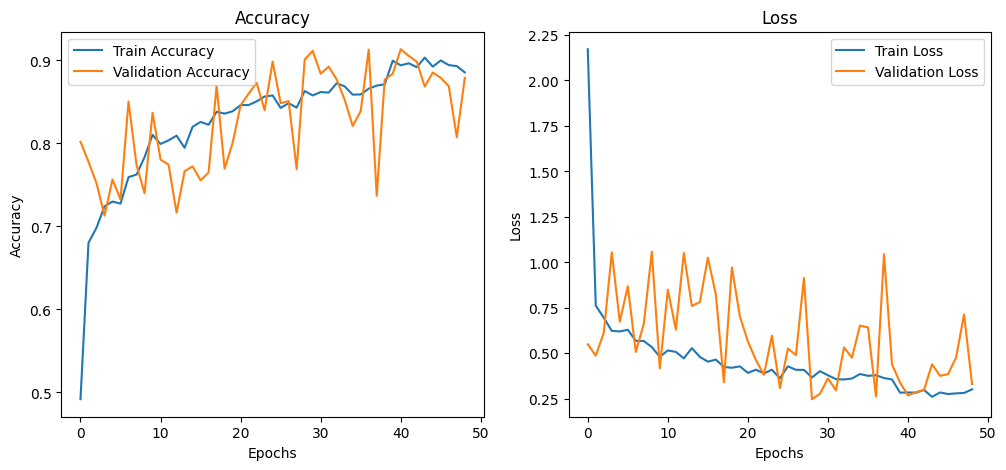

In [10]:
# Graficar la historia de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [11]:
# Guardar el modelo
model.save("resnet50v2_gastro_model.h5")
print("Modelo guardado")

Modelo guardado


In [12]:
# Evaluar en el conjunto de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


  1/100 [..............................] - ETA: 6s - loss: 0.1446 - accuracy: 0.8750


  3/100 [..............................] - ETA: 2s - loss: 0.1619 - accuracy: 0.9167


  5/100 [>.............................] - ETA: 2s - loss: 0.1274 - accuracy: 0.9500


  8/100 [=>............................] - ETA: 2s - loss: 0.1719 - accuracy: 0.9062


 12/100 [==>...........................] - ETA: 1s - loss: 0.2525 - accuracy: 0.9167


 16/100 [===>..........................] - ETA: 1s - loss: 0.2094 - accuracy: 0.9297


 19/100 [====>.........................] - ETA: 1s - loss: 0.2267 - accuracy: 0.9079


 22/100 [=====>........................] - ETA: 1s - loss: 0.2196 - accuracy: 0.9148


 26/100 [======>.......................] - ETA: 1s - loss: 0.2181 - accuracy: 0.9135


 28/100 [=======>......................] - ETA: 1s - loss: 0.2076 - accuracy: 0.9152


 31/100 [========>.....................] - ETA: 1s - loss: 0.2057 - accuracy: 0.9153


 33/100 [========>.....................] - ETA: 1s - loss: 0.1964 - accuracy: 0.9205


 36/100 [=========>....................] - ETA: 1s - loss: 0.1802 - accuracy: 0.9271


 38/100 [==========>...................] - ETA: 1s - loss: 0.1720 - accuracy: 0.9309


 40/100 [===========>..................] - ETA: 1s - loss: 0.1657 - accuracy: 0.9344


 43/100 [===========>..................] - ETA: 1s - loss: 0.1620 - accuracy: 0.9331


 45/100 [============>.................] - ETA: 1s - loss: 0.1675 - accuracy: 0.9306


 47/100 [=============>................] - ETA: 1s - loss: 0.1692 - accuracy: 0.9282


 49/100 [=============>................] - ETA: 1s - loss: 0.2165 - accuracy: 0.9235


 51/100 [==============>...............] - ETA: 1s - loss: 0.2184 - accuracy: 0.9216


 53/100 [==============>...............] - ETA: 1s - loss: 0.2329 - accuracy: 0.9151


 55/100 [===============>..............] - ETA: 1s - loss: 0.2499 - accuracy: 0.9114


 57/100 [================>.............] - ETA: 1s - loss: 0.2558 - accuracy: 0.9123


 60/100 [=================>............] - ETA: 1s - loss: 0.2473 - accuracy: 0.9167


 62/100 [=================>............] - ETA: 0s - loss: 0.2491 - accuracy: 0.9133


 64/100 [==================>...........] - ETA: 0s - loss: 0.2623 - accuracy: 0.9062


 66/100 [==================>...........] - ETA: 0s - loss: 0.2691 - accuracy: 0.9015


 69/100 [===================>..........] - ETA: 0s - loss: 0.2880 - accuracy: 0.8967


 71/100 [====================>.........] - ETA: 0s - loss: 0.2946 - accuracy: 0.8926


 74/100 [=====================>........] - ETA: 0s - loss: 0.3136 - accuracy: 0.8868


 76/100 [=====================>........] - ETA: 0s - loss: 0.3176 - accuracy: 0.8849


 77/100 [======================>.......] - ETA: 0s - loss: 0.3134 - accuracy: 0.8864


 78/100 [======================>.......] - ETA: 0s - loss: 0.3094 - accuracy: 0.8878


 79/100 [======================>.......] - ETA: 0s - loss: 0.3055 - accuracy: 0.8892


 80/100 [=======================>......] - ETA: 0s - loss: 0.3017 - accuracy: 0.8906


 81/100 [=======================>......] - ETA: 0s - loss: 0.2985 - accuracy: 0.8920


 82/100 [=======================>......] - ETA: 0s - loss: 0.2949 - accuracy: 0.8933


 83/100 [=======================>......] - ETA: 0s - loss: 0.2913 - accuracy: 0.8946


 84/100 [========================>.....] - ETA: 0s - loss: 0.2879 - accuracy: 0.8958


 85/100 [========================>.....] - ETA: 0s - loss: 0.2845 - accuracy: 0.8971


 86/100 [========================>.....] - ETA: 0s - loss: 0.2812 - accuracy: 0.8983


 87/100 [=========================>....] - ETA: 0s - loss: 0.2781 - accuracy: 0.8994


 88/100 [=========================>....] - ETA: 0s - loss: 0.2749 - accuracy: 0.9006


 89/100 [=========================>....] - ETA: 0s - loss: 0.2718 - accuracy: 0.9017


 90/100 [==========================>...] - ETA: 0s - loss: 0.2688 - accuracy: 0.9028


 91/100 [==========================>...] - ETA: 0s - loss: 0.2659 - accuracy: 0.9038


 92/100 [==========================>...] - ETA: 0s - loss: 0.2630 - accuracy: 0.9049


 93/100 [==========================>...] - ETA: 0s - loss: 0.2601 - accuracy: 0.9059


 94/100 [===========================>..] - ETA: 0s - loss: 0.2574 - accuracy: 0.9069


 95/100 [===========================>..] - ETA: 0s - loss: 0.2547 - accuracy: 0.9079


 96/100 [===========================>..] - ETA: 0s - loss: 0.2520 - accuracy: 0.9089


 97/100 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.9098


 98/100 [============================>.] - ETA: 0s - loss: 0.2469 - accuracy: 0.9107


 99/100 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.9116


100/100 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9125


100/100 [==============================] - 4s 38ms/step - loss: 0.2419 - accuracy: 0.9125


Test Accuracy: 91.25%



  1/250 [..............................] - ETA: 15s - loss: 0.3815 - accuracy: 0.6250


  5/250 [..............................] - ETA: 3s - loss: 0.2641 - accuracy: 0.8250 


  8/250 [..............................] - ETA: 4s - loss: 0.2249 - accuracy: 0.8750


 11/250 [>.............................] - ETA: 4s - loss: 0.2128 - accuracy: 0.8864


 14/250 [>.............................] - ETA: 4s - loss: 0.2204 - accuracy: 0.8929


 17/250 [=>............................] - ETA: 4s - loss: 0.2097 - accuracy: 0.8971


 21/250 [=>............................] - ETA: 3s - loss: 0.2293 - accuracy: 0.8810


 25/250 [==>...........................] - ETA: 3s - loss: 0.2308 - accuracy: 0.8750


 28/250 [==>...........................] - ETA: 3s - loss: 0.2167 - accuracy: 0.8839


 32/250 [==>...........................] - ETA: 3s - loss: 0.2122 - accuracy: 0.8867


 36/250 [===>..........................] - ETA: 3s - loss: 0.2013 - accuracy: 0.8958


 39/250 [===>..........................] - ETA: 3s - loss: 0.2289 - accuracy: 0.8974


 42/250 [====>.........................] - ETA: 3s - loss: 0.2230 - accuracy: 0.8958


 45/250 [====>.........................] - ETA: 3s - loss: 0.2292 - accuracy: 0.8889


 50/250 [=====>........................] - ETA: 3s - loss: 0.2284 - accuracy: 0.8875


 54/250 [=====>........................] - ETA: 3s - loss: 0.2386 - accuracy: 0.8819


 58/250 [=====>........................] - ETA: 3s - loss: 0.2421 - accuracy: 0.8815


 62/250 [======>.......................] - ETA: 3s - loss: 0.2366 - accuracy: 0.8871


 64/250 [======>.......................] - ETA: 3s - loss: 0.2298 - accuracy: 0.8906


 66/250 [======>.......................] - ETA: 3s - loss: 0.2260 - accuracy: 0.8920


 69/250 [=======>......................] - ETA: 3s - loss: 0.2606 - accuracy: 0.8913


 71/250 [=======>......................] - ETA: 3s - loss: 0.2543 - accuracy: 0.8944


 73/250 [=======>......................] - ETA: 3s - loss: 0.2489 - accuracy: 0.8973


 75/250 [========>.....................] - ETA: 3s - loss: 0.2467 - accuracy: 0.8967


 78/250 [========>.....................] - ETA: 3s - loss: 0.2404 - accuracy: 0.8990


 81/250 [========>.....................] - ETA: 3s - loss: 0.2338 - accuracy: 0.9012


 83/250 [========>.....................] - ETA: 3s - loss: 0.2290 - accuracy: 0.9036


 85/250 [=========>....................] - ETA: 3s - loss: 0.2277 - accuracy: 0.9044


 87/250 [=========>....................] - ETA: 3s - loss: 0.2247 - accuracy: 0.9052


 89/250 [=========>....................] - ETA: 3s - loss: 0.2206 - accuracy: 0.9073


 91/250 [=========>....................] - ETA: 3s - loss: 0.2169 - accuracy: 0.9093


 93/250 [==========>...................] - ETA: 3s - loss: 0.2234 - accuracy: 0.9059


 95/250 [==========>...................] - ETA: 3s - loss: 0.2235 - accuracy: 0.9053


 97/250 [==========>...................] - ETA: 3s - loss: 0.2197 - accuracy: 0.9072


 99/250 [==========>...................] - ETA: 3s - loss: 0.2191 - accuracy: 0.9066


102/250 [===========>..................] - ETA: 3s - loss: 0.2149 - accuracy: 0.9081


104/250 [===========>..................] - ETA: 3s - loss: 0.2309 - accuracy: 0.9062


106/250 [===========>..................] - ETA: 3s - loss: 0.2280 - accuracy: 0.9068


108/250 [===========>..................] - ETA: 3s - loss: 0.2255 - accuracy: 0.9074


110/250 [============>.................] - ETA: 3s - loss: 0.2224 - accuracy: 0.9091


112/250 [============>.................] - ETA: 3s - loss: 0.2197 - accuracy: 0.9096


114/250 [============>.................] - ETA: 3s - loss: 0.2171 - accuracy: 0.9112


116/250 [============>.................] - ETA: 3s - loss: 0.2155 - accuracy: 0.9116


118/250 [=============>................] - ETA: 3s - loss: 0.2130 - accuracy: 0.9131


121/250 [=============>................] - ETA: 3s - loss: 0.2126 - accuracy: 0.9122


124/250 [=============>................] - ETA: 2s - loss: 0.2100 - accuracy: 0.9133


126/250 [==============>...............] - ETA: 2s - loss: 0.2138 - accuracy: 0.9117


129/250 [==============>...............] - ETA: 2s - loss: 0.2219 - accuracy: 0.9079


132/250 [==============>...............] - ETA: 2s - loss: 0.2289 - accuracy: 0.9034


134/250 [===============>..............] - ETA: 2s - loss: 0.2328 - accuracy: 0.9011


137/250 [===============>..............] - ETA: 2s - loss: 0.2461 - accuracy: 0.8942


139/250 [===============>..............] - ETA: 2s - loss: 0.2481 - accuracy: 0.8939


141/250 [===============>..............] - ETA: 2s - loss: 0.2615 - accuracy: 0.8918


143/250 [================>.............] - ETA: 2s - loss: 0.2629 - accuracy: 0.8907


145/250 [================>.............] - ETA: 2s - loss: 0.2668 - accuracy: 0.8897


147/250 [================>.............] - ETA: 2s - loss: 0.2691 - accuracy: 0.8886


150/250 [=================>............] - ETA: 2s - loss: 0.2715 - accuracy: 0.8883


153/250 [=================>............] - ETA: 2s - loss: 0.2763 - accuracy: 0.8856


155/250 [=================>............] - ETA: 2s - loss: 0.2762 - accuracy: 0.8855


158/250 [=================>............] - ETA: 2s - loss: 0.2759 - accuracy: 0.8861


160/250 [==================>...........] - ETA: 2s - loss: 0.2842 - accuracy: 0.8836


162/250 [==================>...........] - ETA: 2s - loss: 0.2821 - accuracy: 0.8850


164/250 [==================>...........] - ETA: 2s - loss: 0.2838 - accuracy: 0.8841


166/250 [==================>...........] - ETA: 2s - loss: 0.2870 - accuracy: 0.8825


168/250 [===================>..........] - ETA: 2s - loss: 0.2927 - accuracy: 0.8810


170/250 [===================>..........] - ETA: 2s - loss: 0.3018 - accuracy: 0.8794


173/250 [===================>..........] - ETA: 1s - loss: 0.3054 - accuracy: 0.8786


175/250 [====================>.........] - ETA: 1s - loss: 0.3129 - accuracy: 0.8757


177/250 [====================>.........] - ETA: 1s - loss: 0.3125 - accuracy: 0.8757


179/250 [====================>.........] - ETA: 1s - loss: 0.3146 - accuracy: 0.8736


181/250 [====================>.........] - ETA: 1s - loss: 0.3213 - accuracy: 0.8715


183/250 [====================>.........] - ETA: 1s - loss: 0.3224 - accuracy: 0.8716


186/250 [=====================>........] - ETA: 1s - loss: 0.3254 - accuracy: 0.8703


188/250 [=====================>........] - ETA: 1s - loss: 0.3253 - accuracy: 0.8703


189/250 [=====================>........] - ETA: 1s - loss: 0.3236 - accuracy: 0.8710


190/250 [=====================>........] - ETA: 1s - loss: 0.3219 - accuracy: 0.8717


191/250 [=====================>........] - ETA: 1s - loss: 0.3202 - accuracy: 0.8724


192/250 [======================>.......] - ETA: 1s - loss: 0.3185 - accuracy: 0.8730


193/250 [======================>.......] - ETA: 1s - loss: 0.3169 - accuracy: 0.8737


194/250 [======================>.......] - ETA: 1s - loss: 0.3152 - accuracy: 0.8744


195/250 [======================>.......] - ETA: 1s - loss: 0.3136 - accuracy: 0.8750


196/250 [======================>.......] - ETA: 1s - loss: 0.3120 - accuracy: 0.8756


197/250 [======================>.......] - ETA: 1s - loss: 0.3104 - accuracy: 0.8763


198/250 [======================>.......] - ETA: 1s - loss: 0.3089 - accuracy: 0.8769


199/250 [======================>.......] - ETA: 1s - loss: 0.3073 - accuracy: 0.8775


200/250 [=======================>......] - ETA: 1s - loss: 0.3058 - accuracy: 0.8781


201/250 [=======================>......] - ETA: 1s - loss: 0.3042 - accuracy: 0.8787


202/250 [=======================>......] - ETA: 1s - loss: 0.3027 - accuracy: 0.8793


203/250 [=======================>......] - ETA: 1s - loss: 0.3013 - accuracy: 0.8799


204/250 [=======================>......] - ETA: 1s - loss: 0.2998 - accuracy: 0.8805


205/250 [=======================>......] - ETA: 1s - loss: 0.2983 - accuracy: 0.8811


206/250 [=======================>......] - ETA: 1s - loss: 0.2969 - accuracy: 0.8817


207/250 [=======================>......] - ETA: 1s - loss: 0.2955 - accuracy: 0.8822


208/250 [=======================>......] - ETA: 1s - loss: 0.2941 - accuracy: 0.8828


209/250 [========================>.....] - ETA: 1s - loss: 0.2927 - accuracy: 0.8834


210/250 [========================>.....] - ETA: 1s - loss: 0.2913 - accuracy: 0.8839


211/250 [========================>.....] - ETA: 1s - loss: 0.2899 - accuracy: 0.8845


212/250 [========================>.....] - ETA: 1s - loss: 0.2885 - accuracy: 0.8850


213/250 [========================>.....] - ETA: 1s - loss: 0.2872 - accuracy: 0.8856


214/250 [========================>.....] - ETA: 1s - loss: 0.2859 - accuracy: 0.8861


215/250 [========================>.....] - ETA: 1s - loss: 0.2845 - accuracy: 0.8866


216/250 [========================>.....] - ETA: 1s - loss: 0.2854 - accuracy: 0.8866


217/250 [=========================>....] - ETA: 1s - loss: 0.2841 - accuracy: 0.8871


218/250 [=========================>....] - ETA: 1s - loss: 0.2828 - accuracy: 0.8876


219/250 [=========================>....] - ETA: 1s - loss: 0.2815 - accuracy: 0.8881


220/250 [=========================>....] - ETA: 0s - loss: 0.2802 - accuracy: 0.8886


221/250 [=========================>....] - ETA: 0s - loss: 0.2790 - accuracy: 0.8891


222/250 [=========================>....] - ETA: 0s - loss: 0.2777 - accuracy: 0.8896


223/250 [=========================>....] - ETA: 0s - loss: 0.2765 - accuracy: 0.8901


224/250 [=========================>....] - ETA: 0s - loss: 0.2752 - accuracy: 0.8906


225/250 [==========================>...] - ETA: 0s - loss: 0.2741 - accuracy: 0.8911


226/250 [==========================>...] - ETA: 0s - loss: 0.2729 - accuracy: 0.8916


227/250 [==========================>...] - ETA: 0s - loss: 0.2717 - accuracy: 0.8921


228/250 [==========================>...] - ETA: 0s - loss: 0.2709 - accuracy: 0.8925


229/250 [==========================>...] - ETA: 0s - loss: 0.2697 - accuracy: 0.8930


230/250 [==========================>...] - ETA: 0s - loss: 0.2685 - accuracy: 0.8935


231/250 [==========================>...] - ETA: 0s - loss: 0.2678 - accuracy: 0.8934


232/250 [==========================>...] - ETA: 0s - loss: 0.2666 - accuracy: 0.8939


233/250 [==========================>...] - ETA: 0s - loss: 0.2656 - accuracy: 0.8943


234/250 [===========================>..] - ETA: 0s - loss: 0.2645 - accuracy: 0.8948


235/250 [===========================>..] - ETA: 0s - loss: 0.2633 - accuracy: 0.8952


236/250 [===========================>..] - ETA: 0s - loss: 0.2622 - accuracy: 0.8957


237/250 [===========================>..] - ETA: 0s - loss: 0.2613 - accuracy: 0.8961


238/250 [===========================>..] - ETA: 0s - loss: 0.2602 - accuracy: 0.8965


239/250 [===========================>..] - ETA: 0s - loss: 0.2591 - accuracy: 0.8970


240/250 [===========================>..] - ETA: 0s - loss: 0.2580 - accuracy: 0.8974


241/250 [===========================>..] - ETA: 0s - loss: 0.2570 - accuracy: 0.8978


242/250 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.8982


243/250 [============================>.] - ETA: 0s - loss: 0.2549 - accuracy: 0.8987


244/250 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.8991


245/250 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.8995


246/250 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8999


247/250 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.8998


248/250 [============================>.] - ETA: 0s - loss: 0.2501 - accuracy: 0.9002


249/250 [============================>.] - ETA: 0s - loss: 0.2491 - accuracy: 0.9006


250/250 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.9010


250/250 [==============================] - 9s 38ms/step - loss: 0.2481 - accuracy: 0.9010


Validation Accuracy: 90.10%


In [13]:
# Cargar el modelo guardado y probarlo
test_model = keras.models.load_model("resnet50v2_gastro_model.h5")

In [14]:
# Obtener predicciones para validación
y_true_val = val_generator.classes
y_pred_val = np.argmax(test_model.predict(val_generator), axis=1)

# Obtener predicciones para test
y_true_test = test_generator.classes
y_pred_test = np.argmax(test_model.predict(test_generator), axis=1)

# Reporte de clasificación para validación
print("\nValidation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

# Reporte de clasificación para test
print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=test_generator.class_indices.keys()))


  1/250 [..............................] - ETA: 1:06


  4/250 [..............................] - ETA: 6s  


  7/250 [..............................] - ETA: 6s


 10/250 [>.............................] - ETA: 5s


 14/250 [>.............................] - ETA: 5s


 18/250 [=>............................] - ETA: 4s


 21/250 [=>............................] - ETA: 4s


 25/250 [==>...........................] - ETA: 4s


 29/250 [==>...........................] - ETA: 4s


 33/250 [==>...........................] - ETA: 4s


 37/250 [===>..........................] - ETA: 3s


 41/250 [===>..........................] - ETA: 3s


 45/250 [====>.........................] - ETA: 3s


 49/250 [====>.........................] - ETA: 3s


 53/250 [=====>........................] - ETA: 3s


 57/250 [=====>........................] - ETA: 3s


 61/250 [======>.......................] - ETA: 3s


 64/250 [======>.......................] - ETA: 3s


 67/250 [=======>......................] - ETA: 3s


 70/250 [=======>......................] - ETA: 3s


 72/250 [=======>......................] - ETA: 3s


 74/250 [=======>......................] - ETA: 3s


 77/250 [========>.....................] - ETA: 3s


 79/250 [========>.....................] - ETA: 3s


 82/250 [========>.....................] - ETA: 3s


 85/250 [=========>....................] - ETA: 3s


 87/250 [=========>....................] - ETA: 3s


 90/250 [=========>....................] - ETA: 3s


 92/250 [==========>...................] - ETA: 3s


 94/250 [==========>...................] - ETA: 3s


 96/250 [==========>...................] - ETA: 3s


 98/250 [==========>...................] - ETA: 3s


101/250 [===========>..................] - ETA: 3s


103/250 [===========>..................] - ETA: 3s


105/250 [===========>..................] - ETA: 3s


108/250 [===========>..................] - ETA: 3s


111/250 [============>.................] - ETA: 3s


113/250 [============>.................] - ETA: 3s


116/250 [============>.................] - ETA: 3s


118/250 [=============>................] - ETA: 2s


121/250 [=============>................] - ETA: 2s


123/250 [=============>................] - ETA: 2s


126/250 [==============>...............] - ETA: 2s


129/250 [==============>...............] - ETA: 2s


132/250 [==============>...............] - ETA: 2s


134/250 [===============>..............] - ETA: 2s


137/250 [===============>..............] - ETA: 2s


140/250 [===============>..............] - ETA: 2s


142/250 [================>.............] - ETA: 2s


144/250 [================>.............] - ETA: 2s


146/250 [================>.............] - ETA: 2s


149/250 [================>.............] - ETA: 2s


152/250 [=================>............] - ETA: 2s


155/250 [=================>............] - ETA: 2s


158/250 [=================>............] - ETA: 2s


160/250 [==================>...........] - ETA: 2s


162/250 [==================>...........] - ETA: 2s


165/250 [==================>...........] - ETA: 2s


167/250 [===================>..........] - ETA: 1s


169/250 [===================>..........] - ETA: 1s


171/250 [===================>..........] - ETA: 1s


174/250 [===================>..........] - ETA: 1s


176/250 [====================>.........] - ETA: 1s


178/250 [====================>.........] - ETA: 1s


180/250 [====================>.........] - ETA: 1s


182/250 [====================>.........] - ETA: 1s


184/250 [=====================>........] - ETA: 1s


187/250 [=====================>........] - ETA: 1s


188/250 [=====================>........] - ETA: 1s


189/250 [=====================>........] - ETA: 1s


190/250 [=====================>........] - ETA: 1s


191/250 [=====================>........] - ETA: 1s


192/250 [======================>.......] - ETA: 1s


193/250 [======================>.......] - ETA: 1s


194/250 [======================>.......] - ETA: 1s


195/250 [======================>.......] - ETA: 1s


196/250 [======================>.......] - ETA: 1s


197/250 [======================>.......] - ETA: 1s


198/250 [======================>.......] - ETA: 1s


199/250 [======================>.......] - ETA: 1s


200/250 [=======================>......] - ETA: 1s


201/250 [=======================>......] - ETA: 1s


202/250 [=======================>......] - ETA: 1s


203/250 [=======================>......] - ETA: 1s


204/250 [=======================>......] - ETA: 1s


205/250 [=======================>......] - ETA: 1s


206/250 [=======================>......] - ETA: 1s


207/250 [=======================>......] - ETA: 1s


208/250 [=======================>......] - ETA: 1s


209/250 [========================>.....] - ETA: 1s


210/250 [========================>.....] - ETA: 1s


211/250 [========================>.....] - ETA: 1s


212/250 [========================>.....] - ETA: 1s


213/250 [========================>.....] - ETA: 1s


214/250 [========================>.....] - ETA: 1s


215/250 [========================>.....] - ETA: 1s


216/250 [========================>.....] - ETA: 1s


217/250 [=========================>....] - ETA: 1s


218/250 [=========================>....] - ETA: 1s


219/250 [=========================>....] - ETA: 0s


220/250 [=========================>....] - ETA: 0s


221/250 [=========================>....] - ETA: 0s


222/250 [=========================>....] - ETA: 0s


223/250 [=========================>....] - ETA: 0s


224/250 [=========================>....] - ETA: 0s


225/250 [==========================>...] - ETA: 0s


226/250 [==========================>...] - ETA: 0s


227/250 [==========================>...] - ETA: 0s


228/250 [==========================>...] - ETA: 0s


229/250 [==========================>...] - ETA: 0s


230/250 [==========================>...] - ETA: 0s


231/250 [==========================>...] - ETA: 0s


232/250 [==========================>...] - ETA: 0s


233/250 [==========================>...] - ETA: 0s


234/250 [===========================>..] - ETA: 0s


235/250 [===========================>..] - ETA: 0s


236/250 [===========================>..] - ETA: 0s


237/250 [===========================>..] - ETA: 0s


238/250 [===========================>..] - ETA: 0s


239/250 [===========================>..] - ETA: 0s


240/250 [===========================>..] - ETA: 0s


241/250 [===========================>..] - ETA: 0s


242/250 [============================>.] - ETA: 0s


243/250 [============================>.] - ETA: 0s


244/250 [============================>.] - ETA: 0s


245/250 [============================>.] - ETA: 0s


246/250 [============================>.] - ETA: 0s


247/250 [============================>.] - ETA: 0s


248/250 [============================>.] - ETA: 0s


249/250 [============================>.] - ETA: 0s


250/250 [==============================] - ETA: 0s


250/250 [==============================] - 9s 37ms/step



  1/100 [..............................] - ETA: 4s


  4/100 [>.............................] - ETA: 1s


  7/100 [=>............................] - ETA: 2s


 11/100 [==>...........................] - ETA: 1s


 15/100 [===>..........................] - ETA: 1s


 18/100 [====>.........................] - ETA: 1s


 22/100 [=====>........................] - ETA: 1s


 26/100 [======>.......................] - ETA: 1s


 29/100 [=======>......................] - ETA: 1s


 31/100 [========>.....................] - ETA: 1s


 33/100 [========>.....................] - ETA: 1s


 36/100 [=========>....................] - ETA: 1s


 39/100 [==========>...................] - ETA: 1s


 41/100 [===========>..................] - ETA: 1s


 44/100 [============>.................] - ETA: 1s


 46/100 [============>.................] - ETA: 1s


 49/100 [=============>................] - ETA: 1s


 51/100 [==============>...............] - ETA: 1s


 53/100 [==============>...............] - ETA: 1s


 56/100 [===============>..............] - ETA: 1s


 59/100 [================>.............] - ETA: 0s


 61/100 [=================>............] - ETA: 0s


 64/100 [==================>...........] - ETA: 0s


 66/100 [==================>...........] - ETA: 0s


 68/100 [===================>..........] - ETA: 0s


 70/100 [====================>.........] - ETA: 0s


 72/100 [====================>.........] - ETA: 0s


 75/100 [=====================>........] - ETA: 0s


 76/100 [=====================>........] - ETA: 0s


 77/100 [======================>.......] - ETA: 0s


 78/100 [======================>.......] - ETA: 0s


 79/100 [======================>.......] - ETA: 0s


 80/100 [=======================>......] - ETA: 0s


 81/100 [=======================>......] - ETA: 0s


 82/100 [=======================>......] - ETA: 0s


 83/100 [=======================>......] - ETA: 0s


 84/100 [========================>.....] - ETA: 0s


 85/100 [========================>.....] - ETA: 0s


 86/100 [========================>.....] - ETA: 0s


 87/100 [=========================>....] - ETA: 0s


 88/100 [=========================>....] - ETA: 0s


 89/100 [=========================>....] - ETA: 0s


 90/100 [==========================>...] - ETA: 0s


 91/100 [==========================>...] - ETA: 0s


 92/100 [==========================>...] - ETA: 0s


 93/100 [==========================>...] - ETA: 0s


 94/100 [===========================>..] - ETA: 0s


 95/100 [===========================>..] - ETA: 0s


 96/100 [===========================>..] - ETA: 0s


 97/100 [============================>.] - ETA: 0s


 98/100 [============================>.] - ETA: 0s


 99/100 [============================>.] - ETA: 0s


100/100 [==============================] - ETA: 0s


100/100 [==============================] - 4s 38ms/step



Validation Classification Report:


                      precision    recall  f1-score   support

            0_normal       0.99      0.89      0.94       500
1_ulcerative_colitis       0.76      0.94      0.84       500
            2_polyps       0.91      0.78      0.84       500
       3_esophagitis       0.98      0.99      0.99       500

            accuracy                           0.90      2000
           macro avg       0.91      0.90      0.90      2000
        weighted avg       0.91      0.90      0.90      2000


Test Classification Report:
                      precision    recall  f1-score   support

            0_normal       0.99      0.91      0.95       200
1_ulcerative_colitis       0.79      0.94      0.86       200
            2_polyps       0.93      0.81      0.86       200
       3_esophagitis       0.97      0.99      0.98       200

            accuracy                           0.91       800
           macro avg       0.92      0.91      0.91       800
        weighted avg       0.92     

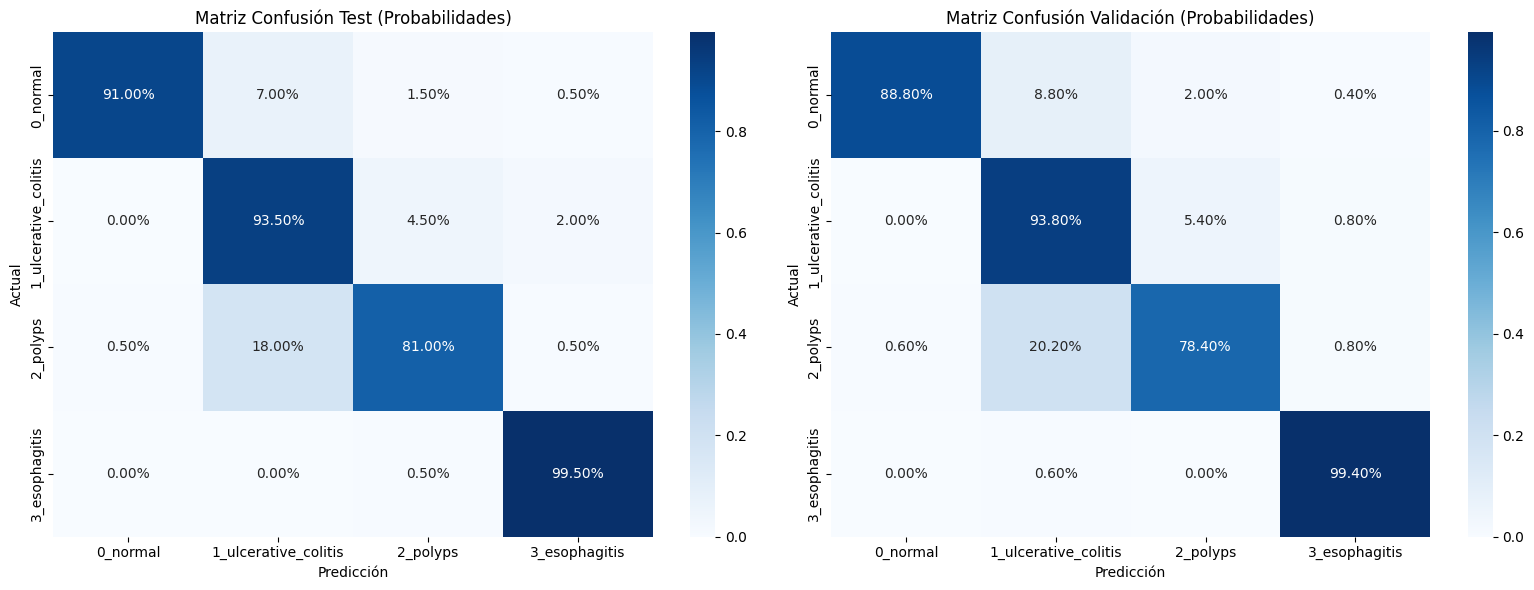

In [15]:
# Función para convertir la matriz de confusión a probabilidades
def confusion_matrix_prob(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Matriz de confusión para el conjunto de test
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_test_prob = confusion_matrix_prob(cm_test)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Test (Probabilidades)')

# Matriz de confusión para el conjunto de validación
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_val_prob = confusion_matrix_prob(cm_val)
plt.subplot(1, 2, 2)
sns.heatmap(cm_val_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Validación (Probabilidades)')

plt.tight_layout()
plt.show()